##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

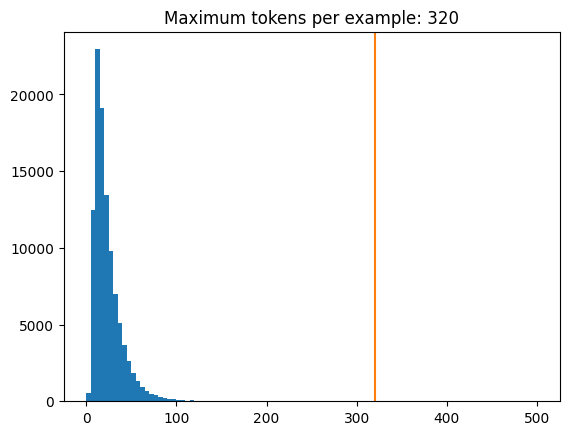

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 72)
(64, 65)
(64, 65)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   90   45  469  109 1317   45 2098 5502   80], shape=(10,), dtype=int64)
tf.Tensor([  90   45  469  109 1317   45 2098 5502   80   71], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


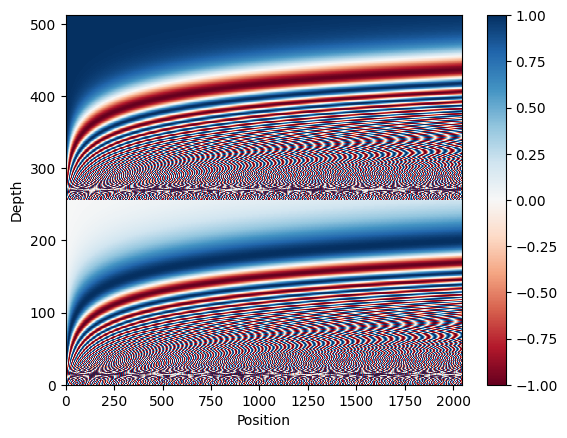

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

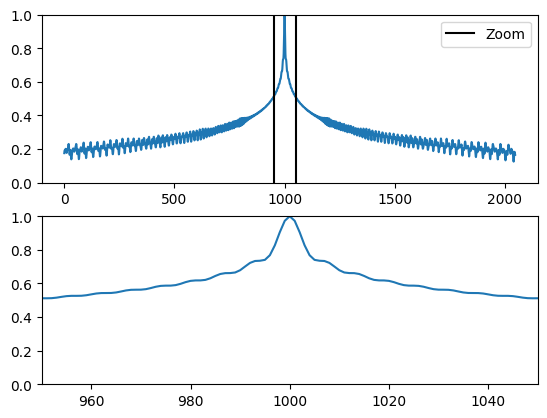

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 65), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 72, 512)
(64, 65, 512)


(64, 65, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 72, 512)
(64, 72, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 65, 512)
(64, 65, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 65, 512)
(64, 65, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 72, 512)


(64, 72, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 72)
(64, 72, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 65, 512)
(64, 72, 512)
(64, 65, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 65)
(64, 72, 512)
(64, 65, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 65, 72])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 65)
(64, 72)
(64, 65, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 65, 72)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

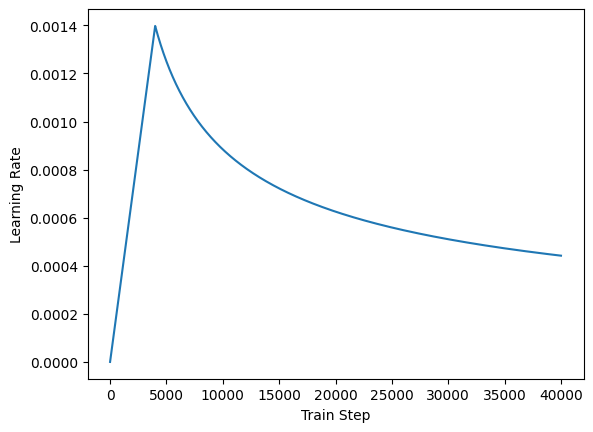

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20


  1/810 [..............................] - ETA: 6:57:57 - loss: 8.8616 - masked_accuracy: 0.0000e+00

  2/810 [..............................] - ETA: 6:49 - loss: 8.8558 - masked_accuracy: 0.0000e+00   

  3/810 [..............................] - ETA: 7:09 - loss: 8.8543 - masked_accuracy: 0.0000e+00

  4/810 [..............................] - ETA: 7:05 - loss: 8.8548 - masked_accuracy: 0.0000e+00

  5/810 [..............................] - ETA: 7:10 - loss: 8.8538 - masked_accuracy: 0.0000e+00

  6/810 [..............................] - ETA: 7:07 - loss: 8.8524 - masked_accuracy: 0.0000e+00

  7/810 [..............................] - ETA: 7:01 - loss: 8.8523 - masked_accuracy: 0.0000e+00

  8/810 [..............................] - ETA: 6:59 - loss: 8.8517 - masked_accuracy: 8.1116e-05

  9/810 [..............................] - ETA: 6:53 - loss: 8.8507 - masked_accuracy: 7.2103e-05

 10/810 [..............................] - ETA: 6:53 - loss: 8.8491 - masked_accuracy: 6.4893e-05

 11/810 [..............................] - ETA: 6:49 - loss: 8.8484 - masked_accuracy: 5.8994e-05

 12/810 [..............................] - ETA: 6:45 - loss: 8.8481 - masked_accuracy: 5.4077e-05

 13/810 [..............................] - ETA: 6:33 - loss: 8.8474 - masked_accuracy: 4.9918e-05

 14/810 [..............................] - ETA: 6:34 - loss: 8.8465 - masked_accuracy: 4.6352e-05

 15/810 [..............................] - ETA: 6:33 - loss: 8.8451 - masked_accuracy: 8.7354e-05

 16/810 [..............................] - ETA: 6:31 - loss: 8.8441 - masked_accuracy: 8.1894e-05

 17/810 [..............................] - ETA: 6:30 - loss: 8.8428 - masked_accuracy: 7.7077e-05

 18/810 [..............................] - ETA: 6:22 - loss: 8.8418 - masked_accuracy: 7.2795e-05

 19/810 [..............................] - ETA: 6:21 - loss: 8.8407 - masked_accuracy: 1.0343e-04

 20/810 [..............................] - ETA: 6:22 - loss: 8.8394 - masked_accuracy: 1.3182e-04

 21/810 [..............................] - ETA: 6:21 - loss: 8.8382 - masked_accuracy: 1.9583e-04

 22/810 [..............................] - ETA: 6:22 - loss: 8.8372 - masked_accuracy: 2.8808e-04

 23/810 [..............................] - ETA: 6:21 - loss: 8.8356 - masked_accuracy: 2.7556e-04

 24/810 [..............................] - ETA: 6:21 - loss: 8.8344 - masked_accuracy: 3.5592e-04

 25/810 [..............................] - ETA: 6:21 - loss: 8.8324 - masked_accuracy: 4.2703e-04

 26/810 [..............................] - ETA: 6:21 - loss: 8.8308 - masked_accuracy: 5.6580e-04

 27/810 [>.............................] - ETA: 6:20 - loss: 8.8291 - masked_accuracy: 5.9597e-04

 28/810 [>.............................] - ETA: 6:19 - loss: 8.8272 - masked_accuracy: 7.3483e-04

 29/810 [>.............................] - ETA: 6:19 - loss: 8.8253 - masked_accuracy: 8.5738e-04

 30/810 [>.............................] - ETA: 6:18 - loss: 8.8234 - masked_accuracy: 9.6857e-04

 31/810 [>.............................] - ETA: 6:18 - loss: 8.8217 - masked_accuracy: 0.0012    

 32/810 [>.............................] - ETA: 6:17 - loss: 8.8197 - masked_accuracy: 0.0013

 33/810 [>.............................] - ETA: 6:17 - loss: 8.8179 - masked_accuracy: 0.0016

 34/810 [>.............................] - ETA: 6:16 - loss: 8.8156 - masked_accuracy: 0.0018

 35/810 [>.............................] - ETA: 6:11 - loss: 8.8137 - masked_accuracy: 0.0023

 36/810 [>.............................] - ETA: 6:11 - loss: 8.8118 - masked_accuracy: 0.0026

 37/810 [>.............................] - ETA: 6:04 - loss: 8.8096 - masked_accuracy: 0.0029

 38/810 [>.............................] - ETA: 6:01 - loss: 8.8076 - masked_accuracy: 0.0032

 39/810 [>.............................] - ETA: 5:54 - loss: 8.8055 - masked_accuracy: 0.0036

 40/810 [>.............................] - ETA: 5:53 - loss: 8.8031 - masked_accuracy: 0.0041

 41/810 [>.............................] - ETA: 5:54 - loss: 8.8008 - masked_accuracy: 0.0046

 42/810 [>.............................] - ETA: 5:50 - loss: 8.7985 - masked_accuracy: 0.0050

 43/810 [>.............................] - ETA: 5:43 - loss: 8.7964 - masked_accuracy: 0.0054

 44/810 [>.............................] - ETA: 5:40 - loss: 8.7944 - masked_accuracy: 0.0060

 45/810 [>.............................] - ETA: 5:40 - loss: 8.7921 - masked_accuracy: 0.0068

 46/810 [>.............................] - ETA: 5:37 - loss: 8.7901 - masked_accuracy: 0.0073

 47/810 [>.............................] - ETA: 5:34 - loss: 8.7877 - masked_accuracy: 0.0080

 48/810 [>.............................] - ETA: 5:31 - loss: 8.7856 - masked_accuracy: 0.0085

 49/810 [>.............................] - ETA: 5:29 - loss: 8.7833 - masked_accuracy: 0.0091

 50/810 [>.............................] - ETA: 5:29 - loss: 8.7809 - masked_accuracy: 0.0098

 51/810 [>.............................] - ETA: 5:27 - loss: 8.7787 - masked_accuracy: 0.0104

 52/810 [>.............................] - ETA: 5:22 - loss: 8.7764 - masked_accuracy: 0.0113

 53/810 [>.............................] - ETA: 5:22 - loss: 8.7739 - masked_accuracy: 0.0122

 54/810 [=>............................] - ETA: 5:23 - loss: 8.7714 - masked_accuracy: 0.0131

 55/810 [=>............................] - ETA: 5:21 - loss: 8.7690 - masked_accuracy: 0.0137

 56/810 [=>............................] - ETA: 5:22 - loss: 8.7666 - masked_accuracy: 0.0143

 57/810 [=>............................] - ETA: 5:19 - loss: 8.7645 - masked_accuracy: 0.0147

 58/810 [=>............................] - ETA: 5:20 - loss: 8.7623 - masked_accuracy: 0.0151

 59/810 [=>............................] - ETA: 5:21 - loss: 8.7603 - masked_accuracy: 0.0155

 60/810 [=>............................] - ETA: 5:18 - loss: 8.7582 - masked_accuracy: 0.0162

 61/810 [=>............................] - ETA: 5:19 - loss: 8.7559 - masked_accuracy: 0.0168

 62/810 [=>............................] - ETA: 5:20 - loss: 8.7535 - masked_accuracy: 0.0174

 63/810 [=>............................] - ETA: 5:20 - loss: 8.7511 - masked_accuracy: 0.0179

 64/810 [=>............................] - ETA: 5:16 - loss: 8.7485 - masked_accuracy: 0.0186

 65/810 [=>............................] - ETA: 5:13 - loss: 8.7461 - masked_accuracy: 0.0191

 66/810 [=>............................] - ETA: 5:13 - loss: 8.7441 - masked_accuracy: 0.0197

 67/810 [=>............................] - ETA: 5:11 - loss: 8.7416 - masked_accuracy: 0.0201

 68/810 [=>............................] - ETA: 5:11 - loss: 8.7391 - masked_accuracy: 0.0204

 69/810 [=>............................] - ETA: 5:09 - loss: 8.7369 - masked_accuracy: 0.0209

 70/810 [=>............................] - ETA: 5:06 - loss: 8.7345 - masked_accuracy: 0.0214

 71/810 [=>............................] - ETA: 5:07 - loss: 8.7324 - masked_accuracy: 0.0217

 72/810 [=>............................] - ETA: 5:05 - loss: 8.7300 - masked_accuracy: 0.0222

 73/810 [=>............................] - ETA: 5:04 - loss: 8.7276 - masked_accuracy: 0.0229

 74/810 [=>............................] - ETA: 5:02 - loss: 8.7253 - masked_accuracy: 0.0232

 75/810 [=>............................] - ETA: 5:02 - loss: 8.7233 - masked_accuracy: 0.0235

 76/810 [=>............................] - ETA: 5:02 - loss: 8.7211 - masked_accuracy: 0.0238

 77/810 [=>............................] - ETA: 5:01 - loss: 8.7192 - masked_accuracy: 0.0241

 78/810 [=>............................] - ETA: 5:01 - loss: 8.7172 - masked_accuracy: 0.0243

 79/810 [=>............................] - ETA: 5:00 - loss: 8.7148 - masked_accuracy: 0.0248

 80/810 [=>............................] - ETA: 5:01 - loss: 8.7124 - masked_accuracy: 0.0251

 81/810 [==>...........................] - ETA: 4:58 - loss: 8.7100 - masked_accuracy: 0.0256

 82/810 [==>...........................] - ETA: 4:58 - loss: 8.7078 - masked_accuracy: 0.0259

 83/810 [==>...........................] - ETA: 4:57 - loss: 8.7055 - masked_accuracy: 0.0263

 84/810 [==>...........................] - ETA: 4:56 - loss: 8.7034 - masked_accuracy: 0.0265

 85/810 [==>...........................] - ETA: 4:55 - loss: 8.7013 - masked_accuracy: 0.0269

 86/810 [==>...........................] - ETA: 4:56 - loss: 8.6992 - masked_accuracy: 0.0272

 87/810 [==>...........................] - ETA: 4:56 - loss: 8.6968 - masked_accuracy: 0.0277

 88/810 [==>...........................] - ETA: 4:56 - loss: 8.6944 - masked_accuracy: 0.0281

 89/810 [==>...........................] - ETA: 4:55 - loss: 8.6923 - masked_accuracy: 0.0284

 90/810 [==>...........................] - ETA: 4:53 - loss: 8.6902 - masked_accuracy: 0.0287

 91/810 [==>...........................] - ETA: 4:51 - loss: 8.6882 - masked_accuracy: 0.0290

 92/810 [==>...........................] - ETA: 4:50 - loss: 8.6861 - masked_accuracy: 0.0293

 93/810 [==>...........................] - ETA: 4:50 - loss: 8.6839 - masked_accuracy: 0.0297

 94/810 [==>...........................] - ETA: 4:47 - loss: 8.6817 - masked_accuracy: 0.0302

 95/810 [==>...........................] - ETA: 4:48 - loss: 8.6797 - masked_accuracy: 0.0306

 96/810 [==>...........................] - ETA: 4:47 - loss: 8.6777 - masked_accuracy: 0.0310

 97/810 [==>...........................] - ETA: 4:44 - loss: 8.6754 - masked_accuracy: 0.0314

 98/810 [==>...........................] - ETA: 4:45 - loss: 8.6734 - masked_accuracy: 0.0318

 99/810 [==>...........................] - ETA: 4:45 - loss: 8.6709 - masked_accuracy: 0.0323

100/810 [==>...........................] - ETA: 4:43 - loss: 8.6687 - masked_accuracy: 0.0327

101/810 [==>...........................] - ETA: 4:42 - loss: 8.6663 - masked_accuracy: 0.0332

102/810 [==>...........................] - ETA: 4:42 - loss: 8.6641 - masked_accuracy: 0.0335

103/810 [==>...........................] - ETA: 4:41 - loss: 8.6615 - masked_accuracy: 0.0340

104/810 [==>...........................] - ETA: 4:41 - loss: 8.6594 - masked_accuracy: 0.0344

105/810 [==>...........................] - ETA: 4:39 - loss: 8.6571 - masked_accuracy: 0.0348

106/810 [==>...........................] - ETA: 4:39 - loss: 8.6549 - masked_accuracy: 0.0352

107/810 [==>...........................] - ETA: 4:38 - loss: 8.6526 - masked_accuracy: 0.0355

108/810 [===>..........................] - ETA: 4:37 - loss: 8.6504 - masked_accuracy: 0.0358

109/810 [===>..........................] - ETA: 4:35 - loss: 8.6480 - masked_accuracy: 0.0362

110/810 [===>..........................] - ETA: 4:35 - loss: 8.6456 - masked_accuracy: 0.0366

111/810 [===>..........................] - ETA: 4:34 - loss: 8.6433 - masked_accuracy: 0.0369

112/810 [===>..........................] - ETA: 4:33 - loss: 8.6412 - masked_accuracy: 0.0371

113/810 [===>..........................] - ETA: 4:31 - loss: 8.6390 - masked_accuracy: 0.0374

114/810 [===>..........................] - ETA: 4:29 - loss: 8.6368 - masked_accuracy: 0.0376

115/810 [===>..........................] - ETA: 4:29 - loss: 8.6346 - masked_accuracy: 0.0379

116/810 [===>..........................] - ETA: 4:27 - loss: 8.6323 - masked_accuracy: 0.0382

117/810 [===>..........................] - ETA: 4:25 - loss: 8.6300 - masked_accuracy: 0.0385

118/810 [===>..........................] - ETA: 4:24 - loss: 8.6277 - masked_accuracy: 0.0388

119/810 [===>..........................] - ETA: 4:23 - loss: 8.6252 - masked_accuracy: 0.0390

120/810 [===>..........................] - ETA: 4:22 - loss: 8.6227 - masked_accuracy: 0.0394

121/810 [===>..........................] - ETA: 4:21 - loss: 8.6203 - masked_accuracy: 0.0396

122/810 [===>..........................] - ETA: 4:21 - loss: 8.6178 - masked_accuracy: 0.0399

123/810 [===>..........................] - ETA: 4:21 - loss: 8.6154 - masked_accuracy: 0.0401

124/810 [===>..........................] - ETA: 4:21 - loss: 8.6130 - masked_accuracy: 0.0404

125/810 [===>..........................] - ETA: 4:21 - loss: 8.6105 - masked_accuracy: 0.0407

126/810 [===>..........................] - ETA: 4:21 - loss: 8.6080 - masked_accuracy: 0.0410

127/810 [===>..........................] - ETA: 4:19 - loss: 8.6054 - masked_accuracy: 0.0413

128/810 [===>..........................] - ETA: 4:19 - loss: 8.6030 - masked_accuracy: 0.0415

129/810 [===>..........................] - ETA: 4:19 - loss: 8.6006 - masked_accuracy: 0.0417

130/810 [===>..........................] - ETA: 4:17 - loss: 8.5981 - masked_accuracy: 0.0420

131/810 [===>..........................] - ETA: 4:16 - loss: 8.5958 - masked_accuracy: 0.0421

132/810 [===>..........................] - ETA: 4:15 - loss: 8.5932 - masked_accuracy: 0.0423

133/810 [===>..........................] - ETA: 4:14 - loss: 8.5907 - masked_accuracy: 0.0426

134/810 [===>..........................] - ETA: 4:14 - loss: 8.5881 - masked_accuracy: 0.0429

135/810 [====>.........................] - ETA: 4:13 - loss: 8.5856 - masked_accuracy: 0.0431

136/810 [====>.........................] - ETA: 4:11 - loss: 8.5831 - masked_accuracy: 0.0432

137/810 [====>.........................] - ETA: 4:12 - loss: 8.5806 - masked_accuracy: 0.0435

138/810 [====>.........................] - ETA: 4:11 - loss: 8.5782 - masked_accuracy: 0.0437

139/810 [====>.........................] - ETA: 4:09 - loss: 8.5757 - masked_accuracy: 0.0439

140/810 [====>.........................] - ETA: 4:07 - loss: 8.5731 - masked_accuracy: 0.0441

141/810 [====>.........................] - ETA: 4:07 - loss: 8.5706 - masked_accuracy: 0.0443

142/810 [====>.........................] - ETA: 4:06 - loss: 8.5681 - masked_accuracy: 0.0445

143/810 [====>.........................] - ETA: 4:05 - loss: 8.5656 - masked_accuracy: 0.0447

144/810 [====>.........................] - ETA: 4:04 - loss: 8.5631 - masked_accuracy: 0.0448

145/810 [====>.........................] - ETA: 4:04 - loss: 8.5606 - masked_accuracy: 0.0450

146/810 [====>.........................] - ETA: 4:02 - loss: 8.5580 - masked_accuracy: 0.0452

147/810 [====>.........................] - ETA: 4:02 - loss: 8.5553 - masked_accuracy: 0.0454

148/810 [====>.........................] - ETA: 4:02 - loss: 8.5527 - masked_accuracy: 0.0456

149/810 [====>.........................] - ETA: 4:00 - loss: 8.5501 - masked_accuracy: 0.0457

150/810 [====>.........................] - ETA: 4:00 - loss: 8.5475 - masked_accuracy: 0.0459

151/810 [====>.........................] - ETA: 4:00 - loss: 8.5449 - masked_accuracy: 0.0461

152/810 [====>.........................] - ETA: 3:59 - loss: 8.5423 - masked_accuracy: 0.0463

153/810 [====>.........................] - ETA: 3:58 - loss: 8.5396 - masked_accuracy: 0.0465

154/810 [====>.........................] - ETA: 3:57 - loss: 8.5368 - masked_accuracy: 0.0467

155/810 [====>.........................] - ETA: 3:56 - loss: 8.5341 - masked_accuracy: 0.0469

156/810 [====>.........................] - ETA: 3:55 - loss: 8.5314 - masked_accuracy: 0.0471

157/810 [====>.........................] - ETA: 3:54 - loss: 8.5285 - masked_accuracy: 0.0473

158/810 [====>.........................] - ETA: 3:53 - loss: 8.5257 - masked_accuracy: 0.0475

159/810 [====>.........................] - ETA: 3:53 - loss: 8.5231 - masked_accuracy: 0.0476

160/810 [====>.........................] - ETA: 3:52 - loss: 8.5204 - masked_accuracy: 0.0478

161/810 [====>.........................] - ETA: 3:51 - loss: 8.5175 - masked_accuracy: 0.0480

162/810 [=====>........................] - ETA: 3:51 - loss: 8.5147 - masked_accuracy: 0.0482

163/810 [=====>........................] - ETA: 3:50 - loss: 8.5120 - masked_accuracy: 0.0483

164/810 [=====>........................] - ETA: 3:49 - loss: 8.5094 - masked_accuracy: 0.0485

165/810 [=====>........................] - ETA: 3:48 - loss: 8.5065 - masked_accuracy: 0.0486

166/810 [=====>........................] - ETA: 3:47 - loss: 8.5039 - masked_accuracy: 0.0488

167/810 [=====>........................] - ETA: 3:47 - loss: 8.5009 - masked_accuracy: 0.0489

168/810 [=====>........................] - ETA: 3:46 - loss: 8.4981 - masked_accuracy: 0.0491

169/810 [=====>........................] - ETA: 3:45 - loss: 8.4952 - masked_accuracy: 0.0493

170/810 [=====>........................] - ETA: 3:45 - loss: 8.4924 - masked_accuracy: 0.0494

171/810 [=====>........................] - ETA: 3:45 - loss: 8.4895 - masked_accuracy: 0.0495

172/810 [=====>........................] - ETA: 3:44 - loss: 8.4865 - masked_accuracy: 0.0497

173/810 [=====>........................] - ETA: 3:44 - loss: 8.4835 - masked_accuracy: 0.0498

174/810 [=====>........................] - ETA: 3:43 - loss: 8.4808 - masked_accuracy: 0.0500

175/810 [=====>........................] - ETA: 3:43 - loss: 8.4778 - masked_accuracy: 0.0502

176/810 [=====>........................] - ETA: 3:42 - loss: 8.4747 - masked_accuracy: 0.0504

177/810 [=====>........................] - ETA: 3:42 - loss: 8.4719 - masked_accuracy: 0.0505

178/810 [=====>........................] - ETA: 3:41 - loss: 8.4689 - masked_accuracy: 0.0507

179/810 [=====>........................] - ETA: 3:40 - loss: 8.4658 - masked_accuracy: 0.0510

180/810 [=====>........................] - ETA: 3:40 - loss: 8.4628 - masked_accuracy: 0.0511

181/810 [=====>........................] - ETA: 3:38 - loss: 8.4598 - masked_accuracy: 0.0513

182/810 [=====>........................] - ETA: 3:38 - loss: 8.4567 - masked_accuracy: 0.0515

183/810 [=====>........................] - ETA: 3:37 - loss: 8.4536 - masked_accuracy: 0.0517

184/810 [=====>........................] - ETA: 3:36 - loss: 8.4504 - masked_accuracy: 0.0519

185/810 [=====>........................] - ETA: 3:36 - loss: 8.4472 - masked_accuracy: 0.0520

186/810 [=====>........................] - ETA: 3:35 - loss: 8.4440 - masked_accuracy: 0.0522

187/810 [=====>........................] - ETA: 3:35 - loss: 8.4409 - masked_accuracy: 0.0523

188/810 [=====>........................] - ETA: 3:34 - loss: 8.4378 - masked_accuracy: 0.0526

189/810 [======>.......................] - ETA: 3:33 - loss: 8.4349 - masked_accuracy: 0.0527

190/810 [======>.......................] - ETA: 3:33 - loss: 8.4317 - masked_accuracy: 0.0528

191/810 [======>.......................] - ETA: 3:32 - loss: 8.4286 - masked_accuracy: 0.0529

192/810 [======>.......................] - ETA: 3:32 - loss: 8.4255 - masked_accuracy: 0.0531

193/810 [======>.......................] - ETA: 3:31 - loss: 8.4224 - masked_accuracy: 0.0532

194/810 [======>.......................] - ETA: 3:30 - loss: 8.4192 - masked_accuracy: 0.0533

195/810 [======>.......................] - ETA: 3:29 - loss: 8.4160 - masked_accuracy: 0.0535

196/810 [======>.......................] - ETA: 3:28 - loss: 8.4129 - masked_accuracy: 0.0536

197/810 [======>.......................] - ETA: 3:27 - loss: 8.4095 - masked_accuracy: 0.0538

198/810 [======>.......................] - ETA: 3:27 - loss: 8.4063 - masked_accuracy: 0.0540

199/810 [======>.......................] - ETA: 3:26 - loss: 8.4031 - masked_accuracy: 0.0541

200/810 [======>.......................] - ETA: 3:25 - loss: 8.3998 - masked_accuracy: 0.0544

201/810 [======>.......................] - ETA: 3:24 - loss: 8.3962 - masked_accuracy: 0.0546

202/810 [======>.......................] - ETA: 3:24 - loss: 8.3929 - masked_accuracy: 0.0549

203/810 [======>.......................] - ETA: 3:24 - loss: 8.3896 - masked_accuracy: 0.0550

204/810 [======>.......................] - ETA: 3:24 - loss: 8.3862 - masked_accuracy: 0.0553

205/810 [======>.......................] - ETA: 3:23 - loss: 8.3829 - masked_accuracy: 0.0554

206/810 [======>.......................] - ETA: 3:23 - loss: 8.3794 - masked_accuracy: 0.0557

207/810 [======>.......................] - ETA: 3:22 - loss: 8.3760 - masked_accuracy: 0.0559

208/810 [======>.......................] - ETA: 3:22 - loss: 8.3725 - masked_accuracy: 0.0562

209/810 [======>.......................] - ETA: 3:21 - loss: 8.3691 - masked_accuracy: 0.0563

210/810 [======>.......................] - ETA: 3:21 - loss: 8.3657 - masked_accuracy: 0.0565

211/810 [======>.......................] - ETA: 3:20 - loss: 8.3625 - masked_accuracy: 0.0567

212/810 [======>.......................] - ETA: 3:20 - loss: 8.3592 - masked_accuracy: 0.0569

213/810 [======>.......................] - ETA: 3:19 - loss: 8.3558 - masked_accuracy: 0.0572

214/810 [======>.......................] - ETA: 3:19 - loss: 8.3523 - masked_accuracy: 0.0574

215/810 [======>.......................] - ETA: 3:19 - loss: 8.3491 - masked_accuracy: 0.0575

216/810 [=======>......................] - ETA: 3:18 - loss: 8.3457 - masked_accuracy: 0.0577

217/810 [=======>......................] - ETA: 3:17 - loss: 8.3425 - masked_accuracy: 0.0578

218/810 [=======>......................] - ETA: 3:17 - loss: 8.3390 - masked_accuracy: 0.0581

219/810 [=======>......................] - ETA: 3:17 - loss: 8.3357 - masked_accuracy: 0.0582

220/810 [=======>......................] - ETA: 3:16 - loss: 8.3322 - masked_accuracy: 0.0584

221/810 [=======>......................] - ETA: 3:16 - loss: 8.3286 - masked_accuracy: 0.0587

222/810 [=======>......................] - ETA: 3:15 - loss: 8.3248 - masked_accuracy: 0.0589

223/810 [=======>......................] - ETA: 3:15 - loss: 8.3213 - masked_accuracy: 0.0591

224/810 [=======>......................] - ETA: 3:14 - loss: 8.3178 - masked_accuracy: 0.0592

225/810 [=======>......................] - ETA: 3:13 - loss: 8.3140 - masked_accuracy: 0.0594

226/810 [=======>......................] - ETA: 3:12 - loss: 8.3104 - masked_accuracy: 0.0596

227/810 [=======>......................] - ETA: 3:12 - loss: 8.3067 - masked_accuracy: 0.0598

228/810 [=======>......................] - ETA: 3:11 - loss: 8.3032 - masked_accuracy: 0.0601

229/810 [=======>......................] - ETA: 3:11 - loss: 8.2996 - masked_accuracy: 0.0603

230/810 [=======>......................] - ETA: 3:10 - loss: 8.2960 - masked_accuracy: 0.0605

231/810 [=======>......................] - ETA: 3:09 - loss: 8.2924 - masked_accuracy: 0.0608

232/810 [=======>......................] - ETA: 3:08 - loss: 8.2888 - masked_accuracy: 0.0611

233/810 [=======>......................] - ETA: 3:08 - loss: 8.2852 - masked_accuracy: 0.0613

234/810 [=======>......................] - ETA: 3:07 - loss: 8.2817 - masked_accuracy: 0.0615

235/810 [=======>......................] - ETA: 3:07 - loss: 8.2781 - masked_accuracy: 0.0618

236/810 [=======>......................] - ETA: 3:06 - loss: 8.2746 - masked_accuracy: 0.0619

237/810 [=======>......................] - ETA: 3:06 - loss: 8.2708 - masked_accuracy: 0.0622

238/810 [=======>......................] - ETA: 3:06 - loss: 8.2674 - masked_accuracy: 0.0624

239/810 [=======>......................] - ETA: 3:05 - loss: 8.2637 - masked_accuracy: 0.0625

240/810 [=======>......................] - ETA: 3:04 - loss: 8.2599 - masked_accuracy: 0.0627

241/810 [=======>......................] - ETA: 3:04 - loss: 8.2561 - masked_accuracy: 0.0629

242/810 [=======>......................] - ETA: 3:03 - loss: 8.2525 - masked_accuracy: 0.0631

243/810 [========>.....................] - ETA: 3:02 - loss: 8.2486 - masked_accuracy: 0.0633

244/810 [========>.....................] - ETA: 3:02 - loss: 8.2450 - masked_accuracy: 0.0635

245/810 [========>.....................] - ETA: 3:01 - loss: 8.2414 - masked_accuracy: 0.0637

246/810 [========>.....................] - ETA: 3:01 - loss: 8.2378 - masked_accuracy: 0.0639

247/810 [========>.....................] - ETA: 3:00 - loss: 8.2339 - masked_accuracy: 0.0642

248/810 [========>.....................] - ETA: 2:59 - loss: 8.2304 - masked_accuracy: 0.0644

249/810 [========>.....................] - ETA: 2:59 - loss: 8.2266 - masked_accuracy: 0.0646

250/810 [========>.....................] - ETA: 2:58 - loss: 8.2229 - masked_accuracy: 0.0648

251/810 [========>.....................] - ETA: 2:58 - loss: 8.2194 - masked_accuracy: 0.0649

252/810 [========>.....................] - ETA: 2:57 - loss: 8.2158 - masked_accuracy: 0.0651

253/810 [========>.....................] - ETA: 2:57 - loss: 8.2120 - masked_accuracy: 0.0654

254/810 [========>.....................] - ETA: 2:56 - loss: 8.2084 - masked_accuracy: 0.0657

255/810 [========>.....................] - ETA: 2:56 - loss: 8.2048 - masked_accuracy: 0.0658

256/810 [========>.....................] - ETA: 2:56 - loss: 8.2009 - masked_accuracy: 0.0660

257/810 [========>.....................] - ETA: 2:55 - loss: 8.1974 - masked_accuracy: 0.0662

258/810 [========>.....................] - ETA: 2:55 - loss: 8.1936 - masked_accuracy: 0.0663

259/810 [========>.....................] - ETA: 2:54 - loss: 8.1899 - masked_accuracy: 0.0666

260/810 [========>.....................] - ETA: 2:54 - loss: 8.1858 - masked_accuracy: 0.0668

261/810 [========>.....................] - ETA: 2:53 - loss: 8.1820 - masked_accuracy: 0.0670

262/810 [========>.....................] - ETA: 2:52 - loss: 8.1781 - masked_accuracy: 0.0672

263/810 [========>.....................] - ETA: 2:52 - loss: 8.1742 - masked_accuracy: 0.0674

264/810 [========>.....................] - ETA: 2:51 - loss: 8.1703 - masked_accuracy: 0.0676

265/810 [========>.....................] - ETA: 2:51 - loss: 8.1665 - masked_accuracy: 0.0678

266/810 [========>.....................] - ETA: 2:50 - loss: 8.1628 - masked_accuracy: 0.0680

267/810 [========>.....................] - ETA: 2:50 - loss: 8.1589 - masked_accuracy: 0.0682

268/810 [========>.....................] - ETA: 2:49 - loss: 8.1551 - masked_accuracy: 0.0684

269/810 [========>.....................] - ETA: 2:49 - loss: 8.1512 - masked_accuracy: 0.0686

270/810 [=========>....................] - ETA: 2:48 - loss: 8.1473 - masked_accuracy: 0.0687

271/810 [=========>....................] - ETA: 2:48 - loss: 8.1435 - masked_accuracy: 0.0689

272/810 [=========>....................] - ETA: 2:47 - loss: 8.1393 - masked_accuracy: 0.0692

273/810 [=========>....................] - ETA: 2:47 - loss: 8.1354 - masked_accuracy: 0.0693

274/810 [=========>....................] - ETA: 2:47 - loss: 8.1314 - masked_accuracy: 0.0695

275/810 [=========>....................] - ETA: 2:46 - loss: 8.1274 - masked_accuracy: 0.0697

276/810 [=========>....................] - ETA: 2:46 - loss: 8.1238 - masked_accuracy: 0.0699

277/810 [=========>....................] - ETA: 2:45 - loss: 8.1201 - masked_accuracy: 0.0700

278/810 [=========>....................] - ETA: 2:45 - loss: 8.1161 - masked_accuracy: 0.0702

279/810 [=========>....................] - ETA: 2:44 - loss: 8.1124 - masked_accuracy: 0.0705

280/810 [=========>....................] - ETA: 2:44 - loss: 8.1087 - masked_accuracy: 0.0706

281/810 [=========>....................] - ETA: 2:44 - loss: 8.1048 - masked_accuracy: 0.0708

282/810 [=========>....................] - ETA: 2:43 - loss: 8.1009 - masked_accuracy: 0.0709

283/810 [=========>....................] - ETA: 2:43 - loss: 8.0967 - masked_accuracy: 0.0711

284/810 [=========>....................] - ETA: 2:42 - loss: 8.0928 - masked_accuracy: 0.0713

285/810 [=========>....................] - ETA: 2:42 - loss: 8.0887 - masked_accuracy: 0.0715

286/810 [=========>....................] - ETA: 2:42 - loss: 8.0850 - masked_accuracy: 0.0717

287/810 [=========>....................] - ETA: 2:42 - loss: 8.0811 - masked_accuracy: 0.0718

288/810 [=========>....................] - ETA: 2:41 - loss: 8.0774 - masked_accuracy: 0.0720

289/810 [=========>....................] - ETA: 2:41 - loss: 8.0733 - masked_accuracy: 0.0721

290/810 [=========>....................] - ETA: 2:40 - loss: 8.0693 - masked_accuracy: 0.0723

291/810 [=========>....................] - ETA: 2:40 - loss: 8.0653 - masked_accuracy: 0.0725

292/810 [=========>....................] - ETA: 2:39 - loss: 8.0613 - masked_accuracy: 0.0726

293/810 [=========>....................] - ETA: 2:39 - loss: 8.0576 - masked_accuracy: 0.0727

294/810 [=========>....................] - ETA: 2:39 - loss: 8.0538 - masked_accuracy: 0.0729

295/810 [=========>....................] - ETA: 2:38 - loss: 8.0496 - masked_accuracy: 0.0731

296/810 [=========>....................] - ETA: 2:38 - loss: 8.0457 - masked_accuracy: 0.0733

297/810 [==========>...................] - ETA: 2:38 - loss: 8.0416 - masked_accuracy: 0.0735

298/810 [==========>...................] - ETA: 2:37 - loss: 8.0375 - masked_accuracy: 0.0737

299/810 [==========>...................] - ETA: 2:37 - loss: 8.0334 - masked_accuracy: 0.0739

300/810 [==========>...................] - ETA: 2:37 - loss: 8.0291 - masked_accuracy: 0.0741

301/810 [==========>...................] - ETA: 2:36 - loss: 8.0251 - masked_accuracy: 0.0743

302/810 [==========>...................] - ETA: 2:36 - loss: 8.0212 - masked_accuracy: 0.0745

303/810 [==========>...................] - ETA: 2:35 - loss: 8.0172 - masked_accuracy: 0.0747

304/810 [==========>...................] - ETA: 2:35 - loss: 8.0133 - masked_accuracy: 0.0749

305/810 [==========>...................] - ETA: 2:34 - loss: 8.0094 - masked_accuracy: 0.0751

306/810 [==========>...................] - ETA: 2:34 - loss: 8.0055 - masked_accuracy: 0.0752

307/810 [==========>...................] - ETA: 2:33 - loss: 8.0016 - masked_accuracy: 0.0754

308/810 [==========>...................] - ETA: 2:33 - loss: 7.9974 - masked_accuracy: 0.0756

309/810 [==========>...................] - ETA: 2:33 - loss: 7.9937 - masked_accuracy: 0.0758

310/810 [==========>...................] - ETA: 2:32 - loss: 7.9898 - masked_accuracy: 0.0760

311/810 [==========>...................] - ETA: 2:32 - loss: 7.9858 - masked_accuracy: 0.0761

312/810 [==========>...................] - ETA: 2:31 - loss: 7.9815 - masked_accuracy: 0.0763

313/810 [==========>...................] - ETA: 2:31 - loss: 7.9776 - masked_accuracy: 0.0764

314/810 [==========>...................] - ETA: 2:31 - loss: 7.9734 - masked_accuracy: 0.0766

315/810 [==========>...................] - ETA: 2:30 - loss: 7.9695 - masked_accuracy: 0.0768

316/810 [==========>...................] - ETA: 2:30 - loss: 7.9655 - masked_accuracy: 0.0769

317/810 [==========>...................] - ETA: 2:29 - loss: 7.9618 - masked_accuracy: 0.0771

318/810 [==========>...................] - ETA: 2:29 - loss: 7.9578 - masked_accuracy: 0.0772

319/810 [==========>...................] - ETA: 2:28 - loss: 7.9538 - masked_accuracy: 0.0774

320/810 [==========>...................] - ETA: 2:28 - loss: 7.9498 - masked_accuracy: 0.0776

321/810 [==========>...................] - ETA: 2:27 - loss: 7.9458 - masked_accuracy: 0.0778

322/810 [==========>...................] - ETA: 2:27 - loss: 7.9420 - masked_accuracy: 0.0779

323/810 [==========>...................] - ETA: 2:26 - loss: 7.9380 - masked_accuracy: 0.0780

324/810 [===========>..................] - ETA: 2:26 - loss: 7.9340 - masked_accuracy: 0.0782

325/810 [===========>..................] - ETA: 2:26 - loss: 7.9303 - masked_accuracy: 0.0783

326/810 [===========>..................] - ETA: 2:25 - loss: 7.9265 - masked_accuracy: 0.0784

327/810 [===========>..................] - ETA: 2:25 - loss: 7.9225 - masked_accuracy: 0.0786

328/810 [===========>..................] - ETA: 2:24 - loss: 7.9186 - masked_accuracy: 0.0787

329/810 [===========>..................] - ETA: 2:23 - loss: 7.9147 - masked_accuracy: 0.0789

330/810 [===========>..................] - ETA: 2:23 - loss: 7.9109 - masked_accuracy: 0.0790

331/810 [===========>..................] - ETA: 2:23 - loss: 7.9070 - masked_accuracy: 0.0792

332/810 [===========>..................] - ETA: 2:22 - loss: 7.9028 - masked_accuracy: 0.0794

333/810 [===========>..................] - ETA: 2:22 - loss: 7.8989 - masked_accuracy: 0.0796

334/810 [===========>..................] - ETA: 2:21 - loss: 7.8951 - masked_accuracy: 0.0797

335/810 [===========>..................] - ETA: 2:21 - loss: 7.8912 - masked_accuracy: 0.0799

336/810 [===========>..................] - ETA: 2:20 - loss: 7.8873 - masked_accuracy: 0.0800

337/810 [===========>..................] - ETA: 2:20 - loss: 7.8834 - masked_accuracy: 0.0801

338/810 [===========>..................] - ETA: 2:19 - loss: 7.8793 - masked_accuracy: 0.0803

339/810 [===========>..................] - ETA: 2:19 - loss: 7.8755 - masked_accuracy: 0.0804

340/810 [===========>..................] - ETA: 2:18 - loss: 7.8714 - masked_accuracy: 0.0806

341/810 [===========>..................] - ETA: 2:18 - loss: 7.8675 - masked_accuracy: 0.0807

342/810 [===========>..................] - ETA: 2:17 - loss: 7.8637 - masked_accuracy: 0.0809

343/810 [===========>..................] - ETA: 2:17 - loss: 7.8597 - masked_accuracy: 0.0811

344/810 [===========>..................] - ETA: 2:16 - loss: 7.8557 - masked_accuracy: 0.0812

345/810 [===========>..................] - ETA: 2:16 - loss: 7.8517 - masked_accuracy: 0.0813

346/810 [===========>..................] - ETA: 2:16 - loss: 7.8478 - masked_accuracy: 0.0815

347/810 [===========>..................] - ETA: 2:15 - loss: 7.8438 - masked_accuracy: 0.0816

348/810 [===========>..................] - ETA: 2:15 - loss: 7.8400 - masked_accuracy: 0.0818

349/810 [===========>..................] - ETA: 2:14 - loss: 7.8361 - masked_accuracy: 0.0819

350/810 [===========>..................] - ETA: 2:14 - loss: 7.8321 - masked_accuracy: 0.0821

351/810 [============>.................] - ETA: 2:14 - loss: 7.8285 - masked_accuracy: 0.0822

352/810 [============>.................] - ETA: 2:13 - loss: 7.8245 - masked_accuracy: 0.0823

353/810 [============>.................] - ETA: 2:13 - loss: 7.8206 - masked_accuracy: 0.0824

354/810 [============>.................] - ETA: 2:12 - loss: 7.8169 - masked_accuracy: 0.0825

355/810 [============>.................] - ETA: 2:12 - loss: 7.8132 - masked_accuracy: 0.0826

356/810 [============>.................] - ETA: 2:12 - loss: 7.8093 - masked_accuracy: 0.0828

357/810 [============>.................] - ETA: 2:12 - loss: 7.8052 - masked_accuracy: 0.0829

358/810 [============>.................] - ETA: 2:11 - loss: 7.8013 - masked_accuracy: 0.0831

359/810 [============>.................] - ETA: 2:11 - loss: 7.7973 - masked_accuracy: 0.0833

360/810 [============>.................] - ETA: 2:10 - loss: 7.7933 - masked_accuracy: 0.0835

361/810 [============>.................] - ETA: 2:10 - loss: 7.7894 - masked_accuracy: 0.0836

362/810 [============>.................] - ETA: 2:09 - loss: 7.7856 - masked_accuracy: 0.0838

363/810 [============>.................] - ETA: 2:09 - loss: 7.7819 - masked_accuracy: 0.0839

364/810 [============>.................] - ETA: 2:09 - loss: 7.7782 - masked_accuracy: 0.0840

365/810 [============>.................] - ETA: 2:08 - loss: 7.7744 - masked_accuracy: 0.0842

366/810 [============>.................] - ETA: 2:08 - loss: 7.7705 - masked_accuracy: 0.0844

367/810 [============>.................] - ETA: 2:08 - loss: 7.7667 - masked_accuracy: 0.0846

368/810 [============>.................] - ETA: 2:07 - loss: 7.7626 - masked_accuracy: 0.0847

369/810 [============>.................] - ETA: 2:07 - loss: 7.7588 - masked_accuracy: 0.0849

370/810 [============>.................] - ETA: 2:06 - loss: 7.7551 - masked_accuracy: 0.0850

371/810 [============>.................] - ETA: 2:06 - loss: 7.7510 - masked_accuracy: 0.0851

372/810 [============>.................] - ETA: 2:06 - loss: 7.7475 - masked_accuracy: 0.0852

373/810 [============>.................] - ETA: 2:05 - loss: 7.7439 - masked_accuracy: 0.0853

374/810 [============>.................] - ETA: 2:05 - loss: 7.7405 - masked_accuracy: 0.0854

375/810 [============>.................] - ETA: 2:05 - loss: 7.7367 - masked_accuracy: 0.0856

376/810 [============>.................] - ETA: 2:04 - loss: 7.7330 - masked_accuracy: 0.0857

377/810 [============>.................] - ETA: 2:04 - loss: 7.7293 - masked_accuracy: 0.0859

378/810 [=============>................] - ETA: 2:04 - loss: 7.7254 - masked_accuracy: 0.0860

379/810 [=============>................] - ETA: 2:03 - loss: 7.7212 - masked_accuracy: 0.0861

380/810 [=============>................] - ETA: 2:03 - loss: 7.7178 - masked_accuracy: 0.0862

381/810 [=============>................] - ETA: 2:03 - loss: 7.7139 - masked_accuracy: 0.0864

382/810 [=============>................] - ETA: 2:03 - loss: 7.7104 - masked_accuracy: 0.0865

383/810 [=============>................] - ETA: 2:03 - loss: 7.7065 - masked_accuracy: 0.0867

384/810 [=============>................] - ETA: 2:02 - loss: 7.7030 - masked_accuracy: 0.0868

385/810 [=============>................] - ETA: 2:02 - loss: 7.6994 - masked_accuracy: 0.0869

386/810 [=============>................] - ETA: 2:01 - loss: 7.6960 - masked_accuracy: 0.0870

387/810 [=============>................] - ETA: 2:01 - loss: 7.6924 - masked_accuracy: 0.0871

388/810 [=============>................] - ETA: 2:01 - loss: 7.6887 - masked_accuracy: 0.0872

389/810 [=============>................] - ETA: 2:01 - loss: 7.6851 - masked_accuracy: 0.0874

390/810 [=============>................] - ETA: 2:01 - loss: 7.6814 - masked_accuracy: 0.0875

391/810 [=============>................] - ETA: 2:00 - loss: 7.6778 - masked_accuracy: 0.0877

392/810 [=============>................] - ETA: 2:00 - loss: 7.6743 - masked_accuracy: 0.0877

393/810 [=============>................] - ETA: 2:00 - loss: 7.6704 - masked_accuracy: 0.0879

394/810 [=============>................] - ETA: 1:59 - loss: 7.6666 - masked_accuracy: 0.0881

395/810 [=============>................] - ETA: 1:59 - loss: 7.6630 - masked_accuracy: 0.0882

396/810 [=============>................] - ETA: 1:59 - loss: 7.6598 - masked_accuracy: 0.0883

397/810 [=============>................] - ETA: 1:58 - loss: 7.6562 - masked_accuracy: 0.0884

398/810 [=============>................] - ETA: 1:58 - loss: 7.6528 - masked_accuracy: 0.0885

399/810 [=============>................] - ETA: 1:57 - loss: 7.6493 - masked_accuracy: 0.0887

400/810 [=============>................] - ETA: 1:57 - loss: 7.6455 - masked_accuracy: 0.0889

401/810 [=============>................] - ETA: 1:57 - loss: 7.6421 - masked_accuracy: 0.0890

402/810 [=============>................] - ETA: 1:56 - loss: 7.6387 - masked_accuracy: 0.0891

403/810 [=============>................] - ETA: 1:56 - loss: 7.6354 - masked_accuracy: 0.0892

404/810 [=============>................] - ETA: 1:55 - loss: 7.6319 - masked_accuracy: 0.0894

405/810 [==============>...............] - ETA: 1:55 - loss: 7.6283 - masked_accuracy: 0.0895

406/810 [==============>...............] - ETA: 1:55 - loss: 7.6247 - masked_accuracy: 0.0897

407/810 [==============>...............] - ETA: 1:54 - loss: 7.6213 - masked_accuracy: 0.0898

408/810 [==============>...............] - ETA: 1:54 - loss: 7.6173 - masked_accuracy: 0.0900

409/810 [==============>...............] - ETA: 1:53 - loss: 7.6135 - masked_accuracy: 0.0901

410/810 [==============>...............] - ETA: 1:53 - loss: 7.6099 - masked_accuracy: 0.0902

411/810 [==============>...............] - ETA: 1:53 - loss: 7.6065 - masked_accuracy: 0.0903

412/810 [==============>...............] - ETA: 1:52 - loss: 7.6028 - masked_accuracy: 0.0905

413/810 [==============>...............] - ETA: 1:52 - loss: 7.5993 - masked_accuracy: 0.0906

414/810 [==============>...............] - ETA: 1:51 - loss: 7.5960 - masked_accuracy: 0.0907

415/810 [==============>...............] - ETA: 1:51 - loss: 7.5921 - masked_accuracy: 0.0909

416/810 [==============>...............] - ETA: 1:51 - loss: 7.5885 - masked_accuracy: 0.0910

417/810 [==============>...............] - ETA: 1:51 - loss: 7.5850 - masked_accuracy: 0.0912

418/810 [==============>...............] - ETA: 1:50 - loss: 7.5814 - masked_accuracy: 0.0913

419/810 [==============>...............] - ETA: 1:50 - loss: 7.5780 - masked_accuracy: 0.0915

420/810 [==============>...............] - ETA: 1:50 - loss: 7.5746 - masked_accuracy: 0.0916

421/810 [==============>...............] - ETA: 1:49 - loss: 7.5712 - masked_accuracy: 0.0917

422/810 [==============>...............] - ETA: 1:49 - loss: 7.5676 - masked_accuracy: 0.0918

423/810 [==============>...............] - ETA: 1:48 - loss: 7.5642 - masked_accuracy: 0.0920

424/810 [==============>...............] - ETA: 1:48 - loss: 7.5609 - masked_accuracy: 0.0921

425/810 [==============>...............] - ETA: 1:48 - loss: 7.5576 - masked_accuracy: 0.0923

426/810 [==============>...............] - ETA: 1:47 - loss: 7.5540 - masked_accuracy: 0.0924

427/810 [==============>...............] - ETA: 1:47 - loss: 7.5505 - masked_accuracy: 0.0926

428/810 [==============>...............] - ETA: 1:47 - loss: 7.5468 - masked_accuracy: 0.0928

429/810 [==============>...............] - ETA: 1:46 - loss: 7.5437 - masked_accuracy: 0.0929

430/810 [==============>...............] - ETA: 1:46 - loss: 7.5404 - masked_accuracy: 0.0930

431/810 [==============>...............] - ETA: 1:45 - loss: 7.5370 - masked_accuracy: 0.0932

432/810 [===============>..............] - ETA: 1:45 - loss: 7.5340 - masked_accuracy: 0.0933

433/810 [===============>..............] - ETA: 1:45 - loss: 7.5307 - masked_accuracy: 0.0934

434/810 [===============>..............] - ETA: 1:44 - loss: 7.5275 - masked_accuracy: 0.0935

435/810 [===============>..............] - ETA: 1:44 - loss: 7.5242 - masked_accuracy: 0.0937

436/810 [===============>..............] - ETA: 1:44 - loss: 7.5209 - masked_accuracy: 0.0938

437/810 [===============>..............] - ETA: 1:43 - loss: 7.5179 - masked_accuracy: 0.0940

438/810 [===============>..............] - ETA: 1:43 - loss: 7.5146 - masked_accuracy: 0.0941

439/810 [===============>..............] - ETA: 1:43 - loss: 7.5111 - masked_accuracy: 0.0943

440/810 [===============>..............] - ETA: 1:42 - loss: 7.5081 - masked_accuracy: 0.0944

441/810 [===============>..............] - ETA: 1:42 - loss: 7.5050 - masked_accuracy: 0.0945

442/810 [===============>..............] - ETA: 1:42 - loss: 7.5017 - masked_accuracy: 0.0947

443/810 [===============>..............] - ETA: 1:41 - loss: 7.4983 - masked_accuracy: 0.0948

444/810 [===============>..............] - ETA: 1:41 - loss: 7.4952 - masked_accuracy: 0.0950

445/810 [===============>..............] - ETA: 1:41 - loss: 7.4919 - masked_accuracy: 0.0951

446/810 [===============>..............] - ETA: 1:40 - loss: 7.4887 - masked_accuracy: 0.0952

447/810 [===============>..............] - ETA: 1:40 - loss: 7.4857 - masked_accuracy: 0.0953

448/810 [===============>..............] - ETA: 1:40 - loss: 7.4821 - masked_accuracy: 0.0955

449/810 [===============>..............] - ETA: 1:39 - loss: 7.4792 - masked_accuracy: 0.0957

450/810 [===============>..............] - ETA: 1:39 - loss: 7.4759 - masked_accuracy: 0.0958

451/810 [===============>..............] - ETA: 1:39 - loss: 7.4727 - masked_accuracy: 0.0960

452/810 [===============>..............] - ETA: 1:38 - loss: 7.4694 - masked_accuracy: 0.0961

453/810 [===============>..............] - ETA: 1:38 - loss: 7.4661 - masked_accuracy: 0.0963

454/810 [===============>..............] - ETA: 1:38 - loss: 7.4631 - masked_accuracy: 0.0964

455/810 [===============>..............] - ETA: 1:37 - loss: 7.4601 - masked_accuracy: 0.0966

456/810 [===============>..............] - ETA: 1:37 - loss: 7.4569 - masked_accuracy: 0.0967

457/810 [===============>..............] - ETA: 1:37 - loss: 7.4535 - masked_accuracy: 0.0969

458/810 [===============>..............] - ETA: 1:36 - loss: 7.4506 - masked_accuracy: 0.0970

459/810 [================>.............] - ETA: 1:36 - loss: 7.4477 - masked_accuracy: 0.0972

460/810 [================>.............] - ETA: 1:35 - loss: 7.4449 - masked_accuracy: 0.0973

461/810 [================>.............] - ETA: 1:35 - loss: 7.4417 - masked_accuracy: 0.0975

462/810 [================>.............] - ETA: 1:35 - loss: 7.4384 - masked_accuracy: 0.0977

463/810 [================>.............] - ETA: 1:34 - loss: 7.4350 - masked_accuracy: 0.0978

464/810 [================>.............] - ETA: 1:34 - loss: 7.4316 - masked_accuracy: 0.0980

465/810 [================>.............] - ETA: 1:34 - loss: 7.4283 - masked_accuracy: 0.0982

466/810 [================>.............] - ETA: 1:33 - loss: 7.4249 - masked_accuracy: 0.0984

467/810 [================>.............] - ETA: 1:33 - loss: 7.4223 - masked_accuracy: 0.0985

468/810 [================>.............] - ETA: 1:33 - loss: 7.4191 - masked_accuracy: 0.0986

469/810 [================>.............] - ETA: 1:33 - loss: 7.4158 - masked_accuracy: 0.0988

470/810 [================>.............] - ETA: 1:32 - loss: 7.4130 - masked_accuracy: 0.0989

471/810 [================>.............] - ETA: 1:32 - loss: 7.4098 - masked_accuracy: 0.0991

472/810 [================>.............] - ETA: 1:32 - loss: 7.4067 - masked_accuracy: 0.0992

473/810 [================>.............] - ETA: 1:31 - loss: 7.4033 - masked_accuracy: 0.0994

474/810 [================>.............] - ETA: 1:31 - loss: 7.4000 - masked_accuracy: 0.0996

475/810 [================>.............] - ETA: 1:31 - loss: 7.3969 - masked_accuracy: 0.0998

476/810 [================>.............] - ETA: 1:30 - loss: 7.3938 - masked_accuracy: 0.0999

477/810 [================>.............] - ETA: 1:30 - loss: 7.3907 - masked_accuracy: 0.1001

478/810 [================>.............] - ETA: 1:29 - loss: 7.3877 - masked_accuracy: 0.1002

479/810 [================>.............] - ETA: 1:29 - loss: 7.3846 - masked_accuracy: 0.1004

480/810 [================>.............] - ETA: 1:29 - loss: 7.3819 - masked_accuracy: 0.1005

481/810 [================>.............] - ETA: 1:28 - loss: 7.3789 - masked_accuracy: 0.1007

482/810 [================>.............] - ETA: 1:28 - loss: 7.3758 - masked_accuracy: 0.1009

483/810 [================>.............] - ETA: 1:28 - loss: 7.3728 - masked_accuracy: 0.1010

484/810 [================>.............] - ETA: 1:27 - loss: 7.3699 - masked_accuracy: 0.1011

485/810 [================>.............] - ETA: 1:27 - loss: 7.3670 - masked_accuracy: 0.1013

486/810 [=================>............] - ETA: 1:27 - loss: 7.3642 - masked_accuracy: 0.1014

487/810 [=================>............] - ETA: 1:26 - loss: 7.3613 - masked_accuracy: 0.1016

488/810 [=================>............] - ETA: 1:26 - loss: 7.3585 - masked_accuracy: 0.1017

489/810 [=================>............] - ETA: 1:26 - loss: 7.3559 - masked_accuracy: 0.1018

490/810 [=================>............] - ETA: 1:25 - loss: 7.3528 - masked_accuracy: 0.1020

491/810 [=================>............] - ETA: 1:25 - loss: 7.3499 - masked_accuracy: 0.1022

492/810 [=================>............] - ETA: 1:25 - loss: 7.3470 - masked_accuracy: 0.1024

493/810 [=================>............] - ETA: 1:24 - loss: 7.3442 - masked_accuracy: 0.1025

494/810 [=================>............] - ETA: 1:24 - loss: 7.3412 - masked_accuracy: 0.1027

495/810 [=================>............] - ETA: 1:24 - loss: 7.3380 - masked_accuracy: 0.1028

496/810 [=================>............] - ETA: 1:23 - loss: 7.3353 - masked_accuracy: 0.1030

497/810 [=================>............] - ETA: 1:23 - loss: 7.3319 - masked_accuracy: 0.1031

498/810 [=================>............] - ETA: 1:23 - loss: 7.3291 - masked_accuracy: 0.1033

499/810 [=================>............] - ETA: 1:22 - loss: 7.3263 - masked_accuracy: 0.1035

500/810 [=================>............] - ETA: 1:22 - loss: 7.3234 - masked_accuracy: 0.1036

501/810 [=================>............] - ETA: 1:22 - loss: 7.3205 - masked_accuracy: 0.1038

502/810 [=================>............] - ETA: 1:21 - loss: 7.3175 - masked_accuracy: 0.1040

503/810 [=================>............] - ETA: 1:21 - loss: 7.3147 - masked_accuracy: 0.1041

504/810 [=================>............] - ETA: 1:21 - loss: 7.3116 - masked_accuracy: 0.1043

505/810 [=================>............] - ETA: 1:21 - loss: 7.3088 - masked_accuracy: 0.1044

506/810 [=================>............] - ETA: 1:20 - loss: 7.3057 - masked_accuracy: 0.1046

507/810 [=================>............] - ETA: 1:20 - loss: 7.3028 - masked_accuracy: 0.1047

508/810 [=================>............] - ETA: 1:20 - loss: 7.3001 - masked_accuracy: 0.1049

509/810 [=================>............] - ETA: 1:19 - loss: 7.2975 - masked_accuracy: 0.1050

510/810 [=================>............] - ETA: 1:19 - loss: 7.2944 - masked_accuracy: 0.1052

511/810 [=================>............] - ETA: 1:19 - loss: 7.2915 - masked_accuracy: 0.1054

512/810 [=================>............] - ETA: 1:18 - loss: 7.2886 - masked_accuracy: 0.1055

513/810 [==================>...........] - ETA: 1:18 - loss: 7.2860 - masked_accuracy: 0.1057

514/810 [==================>...........] - ETA: 1:18 - loss: 7.2831 - masked_accuracy: 0.1058

515/810 [==================>...........] - ETA: 1:18 - loss: 7.2800 - masked_accuracy: 0.1060

516/810 [==================>...........] - ETA: 1:17 - loss: 7.2774 - masked_accuracy: 0.1061

517/810 [==================>...........] - ETA: 1:17 - loss: 7.2748 - masked_accuracy: 0.1063

518/810 [==================>...........] - ETA: 1:17 - loss: 7.2716 - masked_accuracy: 0.1064

519/810 [==================>...........] - ETA: 1:16 - loss: 7.2686 - masked_accuracy: 0.1066

520/810 [==================>...........] - ETA: 1:16 - loss: 7.2658 - masked_accuracy: 0.1068

521/810 [==================>...........] - ETA: 1:16 - loss: 7.2631 - masked_accuracy: 0.1069

522/810 [==================>...........] - ETA: 1:16 - loss: 7.2600 - masked_accuracy: 0.1071

523/810 [==================>...........] - ETA: 1:15 - loss: 7.2572 - masked_accuracy: 0.1072

524/810 [==================>...........] - ETA: 1:15 - loss: 7.2544 - masked_accuracy: 0.1073

525/810 [==================>...........] - ETA: 1:15 - loss: 7.2517 - masked_accuracy: 0.1075

526/810 [==================>...........] - ETA: 1:14 - loss: 7.2492 - masked_accuracy: 0.1076

527/810 [==================>...........] - ETA: 1:14 - loss: 7.2461 - masked_accuracy: 0.1078

528/810 [==================>...........] - ETA: 1:14 - loss: 7.2435 - masked_accuracy: 0.1079

529/810 [==================>...........] - ETA: 1:13 - loss: 7.2409 - masked_accuracy: 0.1080

530/810 [==================>...........] - ETA: 1:13 - loss: 7.2382 - masked_accuracy: 0.1082

531/810 [==================>...........] - ETA: 1:13 - loss: 7.2352 - masked_accuracy: 0.1083

532/810 [==================>...........] - ETA: 1:12 - loss: 7.2324 - masked_accuracy: 0.1085

533/810 [==================>...........] - ETA: 1:12 - loss: 7.2292 - masked_accuracy: 0.1087

534/810 [==================>...........] - ETA: 1:12 - loss: 7.2264 - masked_accuracy: 0.1088

535/810 [==================>...........] - ETA: 1:12 - loss: 7.2235 - masked_accuracy: 0.1090

536/810 [==================>...........] - ETA: 1:11 - loss: 7.2209 - masked_accuracy: 0.1091

537/810 [==================>...........] - ETA: 1:11 - loss: 7.2184 - masked_accuracy: 0.1092

538/810 [==================>...........] - ETA: 1:11 - loss: 7.2155 - masked_accuracy: 0.1093

539/810 [==================>...........] - ETA: 1:10 - loss: 7.2130 - masked_accuracy: 0.1095

540/810 [===================>..........] - ETA: 1:10 - loss: 7.2099 - masked_accuracy: 0.1096

541/810 [===================>..........] - ETA: 1:10 - loss: 7.2073 - masked_accuracy: 0.1098

542/810 [===================>..........] - ETA: 1:09 - loss: 7.2045 - masked_accuracy: 0.1099

543/810 [===================>..........] - ETA: 1:09 - loss: 7.2015 - masked_accuracy: 0.1101

544/810 [===================>..........] - ETA: 1:09 - loss: 7.1989 - masked_accuracy: 0.1102

545/810 [===================>..........] - ETA: 1:09 - loss: 7.1963 - masked_accuracy: 0.1103

546/810 [===================>..........] - ETA: 1:08 - loss: 7.1939 - masked_accuracy: 0.1104

547/810 [===================>..........] - ETA: 1:08 - loss: 7.1913 - masked_accuracy: 0.1105

548/810 [===================>..........] - ETA: 1:08 - loss: 7.1885 - masked_accuracy: 0.1107

549/810 [===================>..........] - ETA: 1:07 - loss: 7.1857 - masked_accuracy: 0.1109

550/810 [===================>..........] - ETA: 1:07 - loss: 7.1829 - masked_accuracy: 0.1110

551/810 [===================>..........] - ETA: 1:07 - loss: 7.1802 - masked_accuracy: 0.1111

552/810 [===================>..........] - ETA: 1:06 - loss: 7.1776 - masked_accuracy: 0.1113

553/810 [===================>..........] - ETA: 1:06 - loss: 7.1748 - masked_accuracy: 0.1114

554/810 [===================>..........] - ETA: 1:06 - loss: 7.1721 - masked_accuracy: 0.1116

555/810 [===================>..........] - ETA: 1:05 - loss: 7.1690 - masked_accuracy: 0.1118

556/810 [===================>..........] - ETA: 1:05 - loss: 7.1664 - masked_accuracy: 0.1119

557/810 [===================>..........] - ETA: 1:05 - loss: 7.1639 - masked_accuracy: 0.1120

558/810 [===================>..........] - ETA: 1:05 - loss: 7.1612 - masked_accuracy: 0.1122

559/810 [===================>..........] - ETA: 1:04 - loss: 7.1583 - masked_accuracy: 0.1123

560/810 [===================>..........] - ETA: 1:04 - loss: 7.1554 - masked_accuracy: 0.1125

561/810 [===================>..........] - ETA: 1:04 - loss: 7.1528 - masked_accuracy: 0.1126

562/810 [===================>..........] - ETA: 1:03 - loss: 7.1501 - masked_accuracy: 0.1128

563/810 [===================>..........] - ETA: 1:03 - loss: 7.1474 - masked_accuracy: 0.1129

564/810 [===================>..........] - ETA: 1:03 - loss: 7.1448 - masked_accuracy: 0.1131

565/810 [===================>..........] - ETA: 1:03 - loss: 7.1422 - masked_accuracy: 0.1132

566/810 [===================>..........] - ETA: 1:02 - loss: 7.1393 - masked_accuracy: 0.1134

567/810 [====================>.........] - ETA: 1:02 - loss: 7.1367 - masked_accuracy: 0.1135

568/810 [====================>.........] - ETA: 1:02 - loss: 7.1340 - masked_accuracy: 0.1137

569/810 [====================>.........] - ETA: 1:01 - loss: 7.1316 - masked_accuracy: 0.1138

570/810 [====================>.........] - ETA: 1:01 - loss: 7.1289 - masked_accuracy: 0.1139

571/810 [====================>.........] - ETA: 1:01 - loss: 7.1267 - masked_accuracy: 0.1141

572/810 [====================>.........] - ETA: 1:01 - loss: 7.1241 - masked_accuracy: 0.1142

573/810 [====================>.........] - ETA: 1:00 - loss: 7.1214 - masked_accuracy: 0.1143

574/810 [====================>.........] - ETA: 1:00 - loss: 7.1188 - masked_accuracy: 0.1144

575/810 [====================>.........] - ETA: 1:00 - loss: 7.1163 - masked_accuracy: 0.1146

576/810 [====================>.........] - ETA: 59s - loss: 7.1139 - masked_accuracy: 0.1147 

577/810 [====================>.........] - ETA: 59s - loss: 7.1114 - masked_accuracy: 0.1148

578/810 [====================>.........] - ETA: 59s - loss: 7.1090 - masked_accuracy: 0.1149

579/810 [====================>.........] - ETA: 59s - loss: 7.1062 - masked_accuracy: 0.1151

580/810 [====================>.........] - ETA: 58s - loss: 7.1037 - masked_accuracy: 0.1152

581/810 [====================>.........] - ETA: 58s - loss: 7.1009 - masked_accuracy: 0.1154

582/810 [====================>.........] - ETA: 58s - loss: 7.0981 - masked_accuracy: 0.1155

583/810 [====================>.........] - ETA: 57s - loss: 7.0954 - masked_accuracy: 0.1156

584/810 [====================>.........] - ETA: 57s - loss: 7.0929 - masked_accuracy: 0.1158

585/810 [====================>.........] - ETA: 57s - loss: 7.0903 - masked_accuracy: 0.1159

586/810 [====================>.........] - ETA: 57s - loss: 7.0876 - masked_accuracy: 0.1160

587/810 [====================>.........] - ETA: 56s - loss: 7.0850 - masked_accuracy: 0.1162

588/810 [====================>.........] - ETA: 56s - loss: 7.0826 - masked_accuracy: 0.1163

589/810 [====================>.........] - ETA: 56s - loss: 7.0798 - masked_accuracy: 0.1164

590/810 [====================>.........] - ETA: 55s - loss: 7.0774 - masked_accuracy: 0.1165

591/810 [====================>.........] - ETA: 55s - loss: 7.0747 - masked_accuracy: 0.1167

592/810 [====================>.........] - ETA: 55s - loss: 7.0724 - masked_accuracy: 0.1168

593/810 [====================>.........] - ETA: 55s - loss: 7.0699 - masked_accuracy: 0.1169

594/810 [=====================>........] - ETA: 54s - loss: 7.0677 - masked_accuracy: 0.1170

595/810 [=====================>........] - ETA: 54s - loss: 7.0651 - masked_accuracy: 0.1171

596/810 [=====================>........] - ETA: 54s - loss: 7.0626 - masked_accuracy: 0.1172

597/810 [=====================>........] - ETA: 54s - loss: 7.0601 - masked_accuracy: 0.1173

598/810 [=====================>........] - ETA: 53s - loss: 7.0574 - masked_accuracy: 0.1175

599/810 [=====================>........] - ETA: 53s - loss: 7.0552 - masked_accuracy: 0.1176

600/810 [=====================>........] - ETA: 53s - loss: 7.0526 - masked_accuracy: 0.1177

601/810 [=====================>........] - ETA: 52s - loss: 7.0500 - masked_accuracy: 0.1178

602/810 [=====================>........] - ETA: 52s - loss: 7.0470 - masked_accuracy: 0.1180

603/810 [=====================>........] - ETA: 52s - loss: 7.0443 - masked_accuracy: 0.1182

604/810 [=====================>........] - ETA: 52s - loss: 7.0419 - masked_accuracy: 0.1183

605/810 [=====================>........] - ETA: 51s - loss: 7.0393 - masked_accuracy: 0.1185

606/810 [=====================>........] - ETA: 51s - loss: 7.0370 - masked_accuracy: 0.1186

607/810 [=====================>........] - ETA: 51s - loss: 7.0344 - masked_accuracy: 0.1187

608/810 [=====================>........] - ETA: 50s - loss: 7.0319 - masked_accuracy: 0.1189

609/810 [=====================>........] - ETA: 50s - loss: 7.0290 - masked_accuracy: 0.1190

610/810 [=====================>........] - ETA: 50s - loss: 7.0269 - masked_accuracy: 0.1192

611/810 [=====================>........] - ETA: 50s - loss: 7.0244 - masked_accuracy: 0.1193

612/810 [=====================>........] - ETA: 49s - loss: 7.0219 - masked_accuracy: 0.1194

613/810 [=====================>........] - ETA: 49s - loss: 7.0195 - masked_accuracy: 0.1196

614/810 [=====================>........] - ETA: 49s - loss: 7.0170 - masked_accuracy: 0.1197

615/810 [=====================>........] - ETA: 49s - loss: 7.0146 - masked_accuracy: 0.1198

616/810 [=====================>........] - ETA: 48s - loss: 7.0120 - masked_accuracy: 0.1200

617/810 [=====================>........] - ETA: 48s - loss: 7.0097 - masked_accuracy: 0.1201

618/810 [=====================>........] - ETA: 48s - loss: 7.0072 - masked_accuracy: 0.1202

619/810 [=====================>........] - ETA: 48s - loss: 7.0049 - masked_accuracy: 0.1203

620/810 [=====================>........] - ETA: 47s - loss: 7.0026 - masked_accuracy: 0.1205

621/810 [======================>.......] - ETA: 47s - loss: 7.0002 - masked_accuracy: 0.1206

622/810 [======================>.......] - ETA: 47s - loss: 6.9976 - masked_accuracy: 0.1208

623/810 [======================>.......] - ETA: 46s - loss: 6.9952 - masked_accuracy: 0.1209

624/810 [======================>.......] - ETA: 46s - loss: 6.9925 - masked_accuracy: 0.1210

625/810 [======================>.......] - ETA: 46s - loss: 6.9902 - masked_accuracy: 0.1212

626/810 [======================>.......] - ETA: 46s - loss: 6.9880 - masked_accuracy: 0.1213

627/810 [======================>.......] - ETA: 45s - loss: 6.9858 - masked_accuracy: 0.1214

628/810 [======================>.......] - ETA: 45s - loss: 6.9832 - masked_accuracy: 0.1215

629/810 [======================>.......] - ETA: 45s - loss: 6.9808 - masked_accuracy: 0.1217

630/810 [======================>.......] - ETA: 45s - loss: 6.9785 - masked_accuracy: 0.1218

631/810 [======================>.......] - ETA: 44s - loss: 6.9760 - masked_accuracy: 0.1219

632/810 [======================>.......] - ETA: 44s - loss: 6.9737 - masked_accuracy: 0.1220

633/810 [======================>.......] - ETA: 44s - loss: 6.9714 - masked_accuracy: 0.1221

634/810 [======================>.......] - ETA: 43s - loss: 6.9691 - masked_accuracy: 0.1223

635/810 [======================>.......] - ETA: 43s - loss: 6.9666 - masked_accuracy: 0.1224

636/810 [======================>.......] - ETA: 43s - loss: 6.9642 - masked_accuracy: 0.1226

637/810 [======================>.......] - ETA: 43s - loss: 6.9615 - masked_accuracy: 0.1227

638/810 [======================>.......] - ETA: 42s - loss: 6.9591 - masked_accuracy: 0.1228

639/810 [======================>.......] - ETA: 42s - loss: 6.9567 - masked_accuracy: 0.1230

640/810 [======================>.......] - ETA: 42s - loss: 6.9543 - masked_accuracy: 0.1231

641/810 [======================>.......] - ETA: 42s - loss: 6.9519 - masked_accuracy: 0.1233

642/810 [======================>.......] - ETA: 41s - loss: 6.9494 - masked_accuracy: 0.1234

643/810 [======================>.......] - ETA: 41s - loss: 6.9472 - masked_accuracy: 0.1235

644/810 [======================>.......] - ETA: 41s - loss: 6.9449 - masked_accuracy: 0.1236

645/810 [======================>.......] - ETA: 41s - loss: 6.9422 - masked_accuracy: 0.1238

646/810 [======================>.......] - ETA: 40s - loss: 6.9400 - masked_accuracy: 0.1239

647/810 [======================>.......] - ETA: 40s - loss: 6.9378 - masked_accuracy: 0.1240

648/810 [=======================>......] - ETA: 40s - loss: 6.9352 - masked_accuracy: 0.1242

649/810 [=======================>......] - ETA: 39s - loss: 6.9328 - masked_accuracy: 0.1243

650/810 [=======================>......] - ETA: 39s - loss: 6.9301 - masked_accuracy: 0.1245

651/810 [=======================>......] - ETA: 39s - loss: 6.9274 - masked_accuracy: 0.1246

652/810 [=======================>......] - ETA: 39s - loss: 6.9247 - masked_accuracy: 0.1248

653/810 [=======================>......] - ETA: 38s - loss: 6.9221 - masked_accuracy: 0.1249

654/810 [=======================>......] - ETA: 38s - loss: 6.9199 - masked_accuracy: 0.1251

655/810 [=======================>......] - ETA: 38s - loss: 6.9175 - masked_accuracy: 0.1252

656/810 [=======================>......] - ETA: 38s - loss: 6.9155 - masked_accuracy: 0.1253

657/810 [=======================>......] - ETA: 37s - loss: 6.9129 - masked_accuracy: 0.1254

658/810 [=======================>......] - ETA: 37s - loss: 6.9108 - masked_accuracy: 0.1255

659/810 [=======================>......] - ETA: 37s - loss: 6.9086 - masked_accuracy: 0.1257

660/810 [=======================>......] - ETA: 37s - loss: 6.9064 - masked_accuracy: 0.1258

661/810 [=======================>......] - ETA: 36s - loss: 6.9040 - masked_accuracy: 0.1259

662/810 [=======================>......] - ETA: 36s - loss: 6.9019 - masked_accuracy: 0.1260

663/810 [=======================>......] - ETA: 36s - loss: 6.8997 - masked_accuracy: 0.1262

664/810 [=======================>......] - ETA: 36s - loss: 6.8972 - masked_accuracy: 0.1263

665/810 [=======================>......] - ETA: 35s - loss: 6.8951 - masked_accuracy: 0.1264

666/810 [=======================>......] - ETA: 35s - loss: 6.8926 - masked_accuracy: 0.1266

667/810 [=======================>......] - ETA: 35s - loss: 6.8904 - masked_accuracy: 0.1266

668/810 [=======================>......] - ETA: 34s - loss: 6.8881 - masked_accuracy: 0.1268

669/810 [=======================>......] - ETA: 34s - loss: 6.8858 - masked_accuracy: 0.1269

670/810 [=======================>......] - ETA: 34s - loss: 6.8837 - masked_accuracy: 0.1270

671/810 [=======================>......] - ETA: 34s - loss: 6.8815 - masked_accuracy: 0.1271

672/810 [=======================>......] - ETA: 33s - loss: 6.8789 - masked_accuracy: 0.1273

673/810 [=======================>......] - ETA: 33s - loss: 6.8765 - masked_accuracy: 0.1275

674/810 [=======================>......] - ETA: 33s - loss: 6.8745 - masked_accuracy: 0.1276

675/810 [========================>.....] - ETA: 33s - loss: 6.8722 - masked_accuracy: 0.1277

676/810 [========================>.....] - ETA: 32s - loss: 6.8698 - masked_accuracy: 0.1278

677/810 [========================>.....] - ETA: 32s - loss: 6.8675 - masked_accuracy: 0.1280

678/810 [========================>.....] - ETA: 32s - loss: 6.8653 - masked_accuracy: 0.1281

679/810 [========================>.....] - ETA: 32s - loss: 6.8628 - masked_accuracy: 0.1283

680/810 [========================>.....] - ETA: 31s - loss: 6.8602 - masked_accuracy: 0.1284

681/810 [========================>.....] - ETA: 31s - loss: 6.8581 - masked_accuracy: 0.1286

682/810 [========================>.....] - ETA: 31s - loss: 6.8560 - masked_accuracy: 0.1287

683/810 [========================>.....] - ETA: 31s - loss: 6.8536 - masked_accuracy: 0.1288

684/810 [========================>.....] - ETA: 30s - loss: 6.8515 - masked_accuracy: 0.1289

685/810 [========================>.....] - ETA: 30s - loss: 6.8492 - masked_accuracy: 0.1291

686/810 [========================>.....] - ETA: 30s - loss: 6.8472 - masked_accuracy: 0.1291

687/810 [========================>.....] - ETA: 30s - loss: 6.8449 - masked_accuracy: 0.1293

688/810 [========================>.....] - ETA: 29s - loss: 6.8426 - masked_accuracy: 0.1294

689/810 [========================>.....] - ETA: 29s - loss: 6.8403 - masked_accuracy: 0.1296

690/810 [========================>.....] - ETA: 29s - loss: 6.8379 - masked_accuracy: 0.1297

691/810 [========================>.....] - ETA: 29s - loss: 6.8357 - masked_accuracy: 0.1298

692/810 [========================>.....] - ETA: 28s - loss: 6.8338 - masked_accuracy: 0.1299

693/810 [========================>.....] - ETA: 28s - loss: 6.8318 - masked_accuracy: 0.1300

694/810 [========================>.....] - ETA: 28s - loss: 6.8297 - masked_accuracy: 0.1302

695/810 [========================>.....] - ETA: 28s - loss: 6.8275 - masked_accuracy: 0.1303

696/810 [========================>.....] - ETA: 27s - loss: 6.8254 - masked_accuracy: 0.1304

697/810 [========================>.....] - ETA: 27s - loss: 6.8233 - masked_accuracy: 0.1305

698/810 [========================>.....] - ETA: 27s - loss: 6.8211 - masked_accuracy: 0.1307

699/810 [========================>.....] - ETA: 27s - loss: 6.8190 - masked_accuracy: 0.1308

700/810 [========================>.....] - ETA: 26s - loss: 6.8167 - masked_accuracy: 0.1309

701/810 [========================>.....] - ETA: 26s - loss: 6.8146 - masked_accuracy: 0.1311

702/810 [=========================>....] - ETA: 26s - loss: 6.8122 - masked_accuracy: 0.1312

703/810 [=========================>....] - ETA: 26s - loss: 6.8099 - masked_accuracy: 0.1314

704/810 [=========================>....] - ETA: 25s - loss: 6.8075 - masked_accuracy: 0.1315

705/810 [=========================>....] - ETA: 25s - loss: 6.8052 - masked_accuracy: 0.1317

706/810 [=========================>....] - ETA: 25s - loss: 6.8031 - masked_accuracy: 0.1318

707/810 [=========================>....] - ETA: 25s - loss: 6.8010 - masked_accuracy: 0.1319

708/810 [=========================>....] - ETA: 24s - loss: 6.7988 - masked_accuracy: 0.1321

709/810 [=========================>....] - ETA: 24s - loss: 6.7967 - masked_accuracy: 0.1322

710/810 [=========================>....] - ETA: 24s - loss: 6.7945 - masked_accuracy: 0.1323

711/810 [=========================>....] - ETA: 24s - loss: 6.7920 - masked_accuracy: 0.1325

712/810 [=========================>....] - ETA: 23s - loss: 6.7898 - masked_accuracy: 0.1326

713/810 [=========================>....] - ETA: 23s - loss: 6.7877 - masked_accuracy: 0.1327

714/810 [=========================>....] - ETA: 23s - loss: 6.7854 - masked_accuracy: 0.1329

715/810 [=========================>....] - ETA: 23s - loss: 6.7834 - masked_accuracy: 0.1330

716/810 [=========================>....] - ETA: 22s - loss: 6.7814 - masked_accuracy: 0.1331

717/810 [=========================>....] - ETA: 22s - loss: 6.7794 - masked_accuracy: 0.1332

718/810 [=========================>....] - ETA: 22s - loss: 6.7773 - masked_accuracy: 0.1333

719/810 [=========================>....] - ETA: 22s - loss: 6.7750 - masked_accuracy: 0.1335

720/810 [=========================>....] - ETA: 21s - loss: 6.7731 - masked_accuracy: 0.1336

721/810 [=========================>....] - ETA: 21s - loss: 6.7712 - masked_accuracy: 0.1337

722/810 [=========================>....] - ETA: 21s - loss: 6.7693 - masked_accuracy: 0.1338

723/810 [=========================>....] - ETA: 21s - loss: 6.7674 - masked_accuracy: 0.1339

724/810 [=========================>....] - ETA: 20s - loss: 6.7651 - masked_accuracy: 0.1341

725/810 [=========================>....] - ETA: 20s - loss: 6.7630 - masked_accuracy: 0.1342

726/810 [=========================>....] - ETA: 20s - loss: 6.7609 - masked_accuracy: 0.1343

727/810 [=========================>....] - ETA: 20s - loss: 6.7587 - masked_accuracy: 0.1344

728/810 [=========================>....] - ETA: 19s - loss: 6.7565 - masked_accuracy: 0.1346

729/810 [==========================>...] - ETA: 19s - loss: 6.7545 - masked_accuracy: 0.1347

730/810 [==========================>...] - ETA: 19s - loss: 6.7523 - masked_accuracy: 0.1348

731/810 [==========================>...] - ETA: 19s - loss: 6.7501 - masked_accuracy: 0.1350

732/810 [==========================>...] - ETA: 18s - loss: 6.7479 - masked_accuracy: 0.1351

733/810 [==========================>...] - ETA: 18s - loss: 6.7457 - masked_accuracy: 0.1352

734/810 [==========================>...] - ETA: 18s - loss: 6.7437 - masked_accuracy: 0.1353

735/810 [==========================>...] - ETA: 18s - loss: 6.7416 - masked_accuracy: 0.1354

736/810 [==========================>...] - ETA: 17s - loss: 6.7397 - masked_accuracy: 0.1356

737/810 [==========================>...] - ETA: 17s - loss: 6.7376 - masked_accuracy: 0.1357

738/810 [==========================>...] - ETA: 17s - loss: 6.7355 - masked_accuracy: 0.1358

739/810 [==========================>...] - ETA: 17s - loss: 6.7335 - masked_accuracy: 0.1359

740/810 [==========================>...] - ETA: 16s - loss: 6.7312 - masked_accuracy: 0.1361

741/810 [==========================>...] - ETA: 16s - loss: 6.7292 - masked_accuracy: 0.1362

742/810 [==========================>...] - ETA: 16s - loss: 6.7270 - masked_accuracy: 0.1363

743/810 [==========================>...] - ETA: 16s - loss: 6.7251 - masked_accuracy: 0.1364

744/810 [==========================>...] - ETA: 15s - loss: 6.7230 - masked_accuracy: 0.1366

745/810 [==========================>...] - ETA: 15s - loss: 6.7207 - masked_accuracy: 0.1367

746/810 [==========================>...] - ETA: 15s - loss: 6.7188 - masked_accuracy: 0.1368

747/810 [==========================>...] - ETA: 15s - loss: 6.7166 - masked_accuracy: 0.1370

748/810 [==========================>...] - ETA: 14s - loss: 6.7146 - masked_accuracy: 0.1371

749/810 [==========================>...] - ETA: 14s - loss: 6.7126 - masked_accuracy: 0.1373

750/810 [==========================>...] - ETA: 14s - loss: 6.7106 - masked_accuracy: 0.1374

751/810 [==========================>...] - ETA: 14s - loss: 6.7083 - masked_accuracy: 0.1376

752/810 [==========================>...] - ETA: 13s - loss: 6.7063 - masked_accuracy: 0.1377

753/810 [==========================>...] - ETA: 13s - loss: 6.7041 - masked_accuracy: 0.1378

754/810 [==========================>...] - ETA: 13s - loss: 6.7021 - masked_accuracy: 0.1380

755/810 [==========================>...] - ETA: 13s - loss: 6.7002 - masked_accuracy: 0.1381

756/810 [===========================>..] - ETA: 12s - loss: 6.6982 - masked_accuracy: 0.1382

757/810 [===========================>..] - ETA: 12s - loss: 6.6962 - masked_accuracy: 0.1383

758/810 [===========================>..] - ETA: 12s - loss: 6.6944 - masked_accuracy: 0.1384

759/810 [===========================>..] - ETA: 12s - loss: 6.6925 - masked_accuracy: 0.1385

760/810 [===========================>..] - ETA: 11s - loss: 6.6908 - masked_accuracy: 0.1386

761/810 [===========================>..] - ETA: 11s - loss: 6.6890 - masked_accuracy: 0.1387

762/810 [===========================>..] - ETA: 11s - loss: 6.6870 - masked_accuracy: 0.1389

763/810 [===========================>..] - ETA: 11s - loss: 6.6851 - masked_accuracy: 0.1390

764/810 [===========================>..] - ETA: 11s - loss: 6.6833 - masked_accuracy: 0.1391

765/810 [===========================>..] - ETA: 10s - loss: 6.6814 - masked_accuracy: 0.1393

766/810 [===========================>..] - ETA: 10s - loss: 6.6792 - masked_accuracy: 0.1394

767/810 [===========================>..] - ETA: 10s - loss: 6.6774 - masked_accuracy: 0.1395

768/810 [===========================>..] - ETA: 10s - loss: 6.6754 - masked_accuracy: 0.1396

769/810 [===========================>..] - ETA: 9s - loss: 6.6735 - masked_accuracy: 0.1398 

770/810 [===========================>..] - ETA: 9s - loss: 6.6716 - masked_accuracy: 0.1399

771/810 [===========================>..] - ETA: 9s - loss: 6.6696 - masked_accuracy: 0.1400

772/810 [===========================>..] - ETA: 9s - loss: 6.6675 - masked_accuracy: 0.1401

773/810 [===========================>..] - ETA: 8s - loss: 6.6655 - masked_accuracy: 0.1403

774/810 [===========================>..] - ETA: 8s - loss: 6.6634 - masked_accuracy: 0.1404

775/810 [===========================>..] - ETA: 8s - loss: 6.6616 - masked_accuracy: 0.1405

776/810 [===========================>..] - ETA: 8s - loss: 6.6597 - masked_accuracy: 0.1406

777/810 [===========================>..] - ETA: 7s - loss: 6.6577 - masked_accuracy: 0.1407

778/810 [===========================>..] - ETA: 7s - loss: 6.6557 - masked_accuracy: 0.1409

779/810 [===========================>..] - ETA: 7s - loss: 6.6539 - masked_accuracy: 0.1410

780/810 [===========================>..] - ETA: 7s - loss: 6.6520 - masked_accuracy: 0.1411

781/810 [===========================>..] - ETA: 6s - loss: 6.6502 - masked_accuracy: 0.1412

782/810 [===========================>..] - ETA: 6s - loss: 6.6483 - masked_accuracy: 0.1413

783/810 [============================>.] - ETA: 6s - loss: 6.6463 - masked_accuracy: 0.1414

784/810 [============================>.] - ETA: 6s - loss: 6.6442 - masked_accuracy: 0.1416

785/810 [============================>.] - ETA: 5s - loss: 6.6422 - masked_accuracy: 0.1417

786/810 [============================>.] - ETA: 5s - loss: 6.6402 - masked_accuracy: 0.1418

787/810 [============================>.] - ETA: 5s - loss: 6.6384 - masked_accuracy: 0.1420

788/810 [============================>.] - ETA: 5s - loss: 6.6364 - masked_accuracy: 0.1421

789/810 [============================>.] - ETA: 4s - loss: 6.6345 - masked_accuracy: 0.1422

790/810 [============================>.] - ETA: 4s - loss: 6.6327 - masked_accuracy: 0.1423

791/810 [============================>.] - ETA: 4s - loss: 6.6308 - masked_accuracy: 0.1424

792/810 [============================>.] - ETA: 4s - loss: 6.6289 - masked_accuracy: 0.1426

793/810 [============================>.] - ETA: 4s - loss: 6.6269 - masked_accuracy: 0.1427

794/810 [============================>.] - ETA: 3s - loss: 6.6248 - masked_accuracy: 0.1429

795/810 [============================>.] - ETA: 3s - loss: 6.6230 - masked_accuracy: 0.1430

796/810 [============================>.] - ETA: 3s - loss: 6.6214 - masked_accuracy: 0.1431

797/810 [============================>.] - ETA: 3s - loss: 6.6195 - masked_accuracy: 0.1432

798/810 [============================>.] - ETA: 2s - loss: 6.6176 - masked_accuracy: 0.1433

799/810 [============================>.] - ETA: 2s - loss: 6.6158 - masked_accuracy: 0.1434

800/810 [============================>.] - ETA: 2s - loss: 6.6140 - masked_accuracy: 0.1436

801/810 [============================>.] - ETA: 2s - loss: 6.6121 - masked_accuracy: 0.1437

802/810 [============================>.] - ETA: 1s - loss: 6.6100 - masked_accuracy: 0.1438

803/810 [============================>.] - ETA: 1s - loss: 6.6081 - masked_accuracy: 0.1440

804/810 [============================>.] - ETA: 1s - loss: 6.6063 - masked_accuracy: 0.1441

805/810 [============================>.] - ETA: 1s - loss: 6.6043 - masked_accuracy: 0.1442

806/810 [============================>.] - ETA: 0s - loss: 6.6025 - masked_accuracy: 0.1443

807/810 [============================>.] - ETA: 0s - loss: 6.6005 - masked_accuracy: 0.1445

808/810 [============================>.] - ETA: 0s - loss: 6.5986 - masked_accuracy: 0.1446

809/810 [============================>.] - ETA: 0s - loss: 6.5968 - masked_accuracy: 0.1447

810/810 [==============================] - ETA: 0s - loss: 6.5966 - masked_accuracy: 0.1448

810/810 [==============================] - 226s 241ms/step - loss: 6.5966 - masked_accuracy: 0.1448 - val_loss: 5.0304 - val_masked_accuracy: 0.2538


Epoch 2/20


  1/810 [..............................] - ETA: 11:28 - loss: 5.2012 - masked_accuracy: 0.2313

  2/810 [..............................] - ETA: 2:41 - loss: 5.0777 - masked_accuracy: 0.2418 

  3/810 [..............................] - ETA: 2:45 - loss: 5.0843 - masked_accuracy: 0.2426

  4/810 [..............................] - ETA: 2:19 - loss: 5.0312 - masked_accuracy: 0.2526

  5/810 [..............................] - ETA: 2:07 - loss: 4.9978 - masked_accuracy: 0.2581

  6/810 [..............................] - ETA: 2:19 - loss: 4.9973 - masked_accuracy: 0.2556

  7/810 [..............................] - ETA: 2:19 - loss: 5.0138 - masked_accuracy: 0.2546

  8/810 [..............................] - ETA: 2:16 - loss: 5.0093 - masked_accuracy: 0.2567

  9/810 [..............................] - ETA: 2:14 - loss: 5.0182 - masked_accuracy: 0.2562

 10/810 [..............................] - ETA: 2:13 - loss: 5.0237 - masked_accuracy: 0.2555

 11/810 [..............................] - ETA: 2:13 - loss: 5.0216 - masked_accuracy: 0.2561

 12/810 [..............................] - ETA: 2:11 - loss: 5.0359 - masked_accuracy: 0.2543

 13/810 [..............................] - ETA: 2:11 - loss: 5.0381 - masked_accuracy: 0.2530

 14/810 [..............................] - ETA: 2:13 - loss: 5.0341 - masked_accuracy: 0.2525

 15/810 [..............................] - ETA: 2:13 - loss: 5.0456 - masked_accuracy: 0.2505

 16/810 [..............................] - ETA: 2:11 - loss: 5.0560 - masked_accuracy: 0.2500

 17/810 [..............................] - ETA: 2:08 - loss: 5.0545 - masked_accuracy: 0.2510

 18/810 [..............................] - ETA: 2:08 - loss: 5.0502 - masked_accuracy: 0.2510

 19/810 [..............................] - ETA: 2:07 - loss: 5.0441 - masked_accuracy: 0.2521

 20/810 [..............................] - ETA: 2:10 - loss: 5.0410 - masked_accuracy: 0.2532

 21/810 [..............................] - ETA: 2:10 - loss: 5.0434 - masked_accuracy: 0.2526

 22/810 [..............................] - ETA: 2:09 - loss: 5.0336 - masked_accuracy: 0.2527

 23/810 [..............................] - ETA: 2:08 - loss: 5.0293 - masked_accuracy: 0.2527

 24/810 [..............................] - ETA: 2:07 - loss: 5.0326 - masked_accuracy: 0.2522

 25/810 [..............................] - ETA: 2:07 - loss: 5.0338 - masked_accuracy: 0.2521

 26/810 [..............................] - ETA: 2:06 - loss: 5.0315 - masked_accuracy: 0.2526

 27/810 [>.............................] - ETA: 2:07 - loss: 5.0358 - masked_accuracy: 0.2517

 28/810 [>.............................] - ETA: 2:06 - loss: 5.0305 - masked_accuracy: 0.2521

 29/810 [>.............................] - ETA: 2:05 - loss: 5.0308 - masked_accuracy: 0.2514

 30/810 [>.............................] - ETA: 2:06 - loss: 5.0315 - masked_accuracy: 0.2513

 31/810 [>.............................] - ETA: 2:07 - loss: 5.0324 - masked_accuracy: 0.2509

 32/810 [>.............................] - ETA: 2:06 - loss: 5.0355 - masked_accuracy: 0.2507

 33/810 [>.............................] - ETA: 2:06 - loss: 5.0361 - masked_accuracy: 0.2506

 34/810 [>.............................] - ETA: 2:05 - loss: 5.0297 - masked_accuracy: 0.2513

 35/810 [>.............................] - ETA: 2:05 - loss: 5.0266 - masked_accuracy: 0.2516

 36/810 [>.............................] - ETA: 2:05 - loss: 5.0212 - masked_accuracy: 0.2521

 37/810 [>.............................] - ETA: 2:05 - loss: 5.0230 - masked_accuracy: 0.2520

 38/810 [>.............................] - ETA: 2:04 - loss: 5.0246 - masked_accuracy: 0.2521

 39/810 [>.............................] - ETA: 2:04 - loss: 5.0225 - masked_accuracy: 0.2521

 40/810 [>.............................] - ETA: 2:03 - loss: 5.0252 - masked_accuracy: 0.2517

 41/810 [>.............................] - ETA: 2:02 - loss: 5.0242 - masked_accuracy: 0.2519

 42/810 [>.............................] - ETA: 2:02 - loss: 5.0251 - masked_accuracy: 0.2514

 43/810 [>.............................] - ETA: 2:01 - loss: 5.0282 - masked_accuracy: 0.2517

 44/810 [>.............................] - ETA: 2:00 - loss: 5.0288 - masked_accuracy: 0.2516

 45/810 [>.............................] - ETA: 2:01 - loss: 5.0240 - masked_accuracy: 0.2521

 46/810 [>.............................] - ETA: 2:01 - loss: 5.0185 - masked_accuracy: 0.2525

 47/810 [>.............................] - ETA: 2:01 - loss: 5.0176 - masked_accuracy: 0.2525

 48/810 [>.............................] - ETA: 2:03 - loss: 5.0170 - masked_accuracy: 0.2524

 49/810 [>.............................] - ETA: 2:03 - loss: 5.0171 - masked_accuracy: 0.2525

 50/810 [>.............................] - ETA: 2:02 - loss: 5.0173 - masked_accuracy: 0.2523

 51/810 [>.............................] - ETA: 2:02 - loss: 5.0162 - masked_accuracy: 0.2523

 52/810 [>.............................] - ETA: 2:02 - loss: 5.0170 - masked_accuracy: 0.2520

 53/810 [>.............................] - ETA: 2:01 - loss: 5.0180 - masked_accuracy: 0.2521

 54/810 [=>............................] - ETA: 2:01 - loss: 5.0164 - masked_accuracy: 0.2525

 55/810 [=>............................] - ETA: 2:02 - loss: 5.0173 - masked_accuracy: 0.2526

 56/810 [=>............................] - ETA: 2:01 - loss: 5.0143 - masked_accuracy: 0.2524

 57/810 [=>............................] - ETA: 2:02 - loss: 5.0142 - masked_accuracy: 0.2523

 58/810 [=>............................] - ETA: 2:02 - loss: 5.0129 - masked_accuracy: 0.2523

 59/810 [=>............................] - ETA: 2:01 - loss: 5.0138 - masked_accuracy: 0.2523

 60/810 [=>............................] - ETA: 2:00 - loss: 5.0140 - masked_accuracy: 0.2523

 61/810 [=>............................] - ETA: 2:00 - loss: 5.0084 - masked_accuracy: 0.2529

 62/810 [=>............................] - ETA: 2:00 - loss: 5.0071 - masked_accuracy: 0.2530

 63/810 [=>............................] - ETA: 2:00 - loss: 5.0013 - masked_accuracy: 0.2533

 64/810 [=>............................] - ETA: 2:00 - loss: 5.0022 - masked_accuracy: 0.2531

 65/810 [=>............................] - ETA: 1:59 - loss: 5.0053 - masked_accuracy: 0.2527

 66/810 [=>............................] - ETA: 1:59 - loss: 5.0062 - masked_accuracy: 0.2528

 67/810 [=>............................] - ETA: 1:59 - loss: 5.0077 - masked_accuracy: 0.2525

 68/810 [=>............................] - ETA: 1:59 - loss: 5.0091 - masked_accuracy: 0.2523

 69/810 [=>............................] - ETA: 1:59 - loss: 5.0066 - masked_accuracy: 0.2527

 70/810 [=>............................] - ETA: 1:59 - loss: 5.0051 - masked_accuracy: 0.2530

 71/810 [=>............................] - ETA: 1:59 - loss: 5.0029 - masked_accuracy: 0.2531

 72/810 [=>............................] - ETA: 1:59 - loss: 4.9995 - masked_accuracy: 0.2535

 73/810 [=>............................] - ETA: 1:59 - loss: 4.9968 - masked_accuracy: 0.2538

 74/810 [=>............................] - ETA: 1:59 - loss: 4.9977 - masked_accuracy: 0.2536

 75/810 [=>............................] - ETA: 1:59 - loss: 4.9986 - masked_accuracy: 0.2535

 76/810 [=>............................] - ETA: 1:58 - loss: 4.9970 - masked_accuracy: 0.2536

 77/810 [=>............................] - ETA: 1:59 - loss: 4.9950 - masked_accuracy: 0.2540

 78/810 [=>............................] - ETA: 1:58 - loss: 4.9949 - masked_accuracy: 0.2540

 79/810 [=>............................] - ETA: 1:59 - loss: 4.9942 - masked_accuracy: 0.2540

 80/810 [=>............................] - ETA: 1:58 - loss: 4.9922 - masked_accuracy: 0.2541

 81/810 [==>...........................] - ETA: 1:58 - loss: 4.9929 - masked_accuracy: 0.2541

 82/810 [==>...........................] - ETA: 1:58 - loss: 4.9931 - masked_accuracy: 0.2540

 83/810 [==>...........................] - ETA: 1:58 - loss: 4.9925 - masked_accuracy: 0.2540

 84/810 [==>...........................] - ETA: 1:58 - loss: 4.9881 - masked_accuracy: 0.2546

 85/810 [==>...........................] - ETA: 1:58 - loss: 4.9902 - masked_accuracy: 0.2544

 86/810 [==>...........................] - ETA: 1:58 - loss: 4.9882 - masked_accuracy: 0.2545

 87/810 [==>...........................] - ETA: 1:58 - loss: 4.9874 - masked_accuracy: 0.2545

 88/810 [==>...........................] - ETA: 1:57 - loss: 4.9877 - masked_accuracy: 0.2547

 89/810 [==>...........................] - ETA: 1:57 - loss: 4.9876 - masked_accuracy: 0.2545

 90/810 [==>...........................] - ETA: 1:57 - loss: 4.9869 - masked_accuracy: 0.2547

 91/810 [==>...........................] - ETA: 1:57 - loss: 4.9874 - masked_accuracy: 0.2546

 92/810 [==>...........................] - ETA: 1:56 - loss: 4.9876 - masked_accuracy: 0.2545

 93/810 [==>...........................] - ETA: 1:56 - loss: 4.9867 - masked_accuracy: 0.2546

 94/810 [==>...........................] - ETA: 1:56 - loss: 4.9850 - masked_accuracy: 0.2549

 95/810 [==>...........................] - ETA: 1:55 - loss: 4.9829 - masked_accuracy: 0.2550

 96/810 [==>...........................] - ETA: 1:55 - loss: 4.9823 - masked_accuracy: 0.2550

 97/810 [==>...........................] - ETA: 1:55 - loss: 4.9823 - masked_accuracy: 0.2550

 98/810 [==>...........................] - ETA: 1:55 - loss: 4.9822 - masked_accuracy: 0.2549

 99/810 [==>...........................] - ETA: 1:54 - loss: 4.9820 - masked_accuracy: 0.2550

100/810 [==>...........................] - ETA: 1:54 - loss: 4.9828 - masked_accuracy: 0.2549

101/810 [==>...........................] - ETA: 1:54 - loss: 4.9827 - masked_accuracy: 0.2550

102/810 [==>...........................] - ETA: 1:54 - loss: 4.9833 - masked_accuracy: 0.2550

103/810 [==>...........................] - ETA: 1:55 - loss: 4.9827 - masked_accuracy: 0.2552

104/810 [==>...........................] - ETA: 1:54 - loss: 4.9811 - masked_accuracy: 0.2552

105/810 [==>...........................] - ETA: 1:55 - loss: 4.9797 - masked_accuracy: 0.2553

106/810 [==>...........................] - ETA: 1:54 - loss: 4.9774 - masked_accuracy: 0.2555

107/810 [==>...........................] - ETA: 1:54 - loss: 4.9761 - masked_accuracy: 0.2556

108/810 [===>..........................] - ETA: 1:55 - loss: 4.9761 - masked_accuracy: 0.2555

109/810 [===>..........................] - ETA: 1:55 - loss: 4.9749 - masked_accuracy: 0.2555

110/810 [===>..........................] - ETA: 1:54 - loss: 4.9728 - masked_accuracy: 0.2557

111/810 [===>..........................] - ETA: 1:54 - loss: 4.9691 - masked_accuracy: 0.2560

112/810 [===>..........................] - ETA: 1:54 - loss: 4.9694 - masked_accuracy: 0.2559

113/810 [===>..........................] - ETA: 1:54 - loss: 4.9680 - masked_accuracy: 0.2562

114/810 [===>..........................] - ETA: 1:54 - loss: 4.9665 - masked_accuracy: 0.2563

115/810 [===>..........................] - ETA: 1:54 - loss: 4.9643 - masked_accuracy: 0.2565

116/810 [===>..........................] - ETA: 1:54 - loss: 4.9652 - masked_accuracy: 0.2564

117/810 [===>..........................] - ETA: 1:54 - loss: 4.9643 - masked_accuracy: 0.2563

118/810 [===>..........................] - ETA: 1:54 - loss: 4.9653 - masked_accuracy: 0.2563

119/810 [===>..........................] - ETA: 1:54 - loss: 4.9649 - masked_accuracy: 0.2563

120/810 [===>..........................] - ETA: 1:54 - loss: 4.9652 - masked_accuracy: 0.2563

121/810 [===>..........................] - ETA: 1:54 - loss: 4.9654 - masked_accuracy: 0.2564

122/810 [===>..........................] - ETA: 1:54 - loss: 4.9662 - masked_accuracy: 0.2563

123/810 [===>..........................] - ETA: 1:54 - loss: 4.9647 - masked_accuracy: 0.2564

124/810 [===>..........................] - ETA: 1:54 - loss: 4.9640 - masked_accuracy: 0.2565

125/810 [===>..........................] - ETA: 1:53 - loss: 4.9644 - masked_accuracy: 0.2566

126/810 [===>..........................] - ETA: 1:53 - loss: 4.9622 - masked_accuracy: 0.2568

127/810 [===>..........................] - ETA: 1:53 - loss: 4.9623 - masked_accuracy: 0.2567

128/810 [===>..........................] - ETA: 1:53 - loss: 4.9600 - masked_accuracy: 0.2570

129/810 [===>..........................] - ETA: 1:54 - loss: 4.9589 - masked_accuracy: 0.2571

130/810 [===>..........................] - ETA: 1:53 - loss: 4.9609 - masked_accuracy: 0.2570

131/810 [===>..........................] - ETA: 1:53 - loss: 4.9601 - masked_accuracy: 0.2570

132/810 [===>..........................] - ETA: 1:53 - loss: 4.9601 - masked_accuracy: 0.2571

133/810 [===>..........................] - ETA: 1:53 - loss: 4.9583 - masked_accuracy: 0.2571

134/810 [===>..........................] - ETA: 1:53 - loss: 4.9584 - masked_accuracy: 0.2570

135/810 [====>.........................] - ETA: 1:53 - loss: 4.9569 - masked_accuracy: 0.2571

136/810 [====>.........................] - ETA: 1:53 - loss: 4.9573 - masked_accuracy: 0.2570

137/810 [====>.........................] - ETA: 1:52 - loss: 4.9565 - masked_accuracy: 0.2570

138/810 [====>.........................] - ETA: 1:52 - loss: 4.9575 - masked_accuracy: 0.2570

139/810 [====>.........................] - ETA: 1:52 - loss: 4.9571 - masked_accuracy: 0.2570

140/810 [====>.........................] - ETA: 1:52 - loss: 4.9577 - masked_accuracy: 0.2569

141/810 [====>.........................] - ETA: 1:52 - loss: 4.9568 - masked_accuracy: 0.2570

142/810 [====>.........................] - ETA: 1:51 - loss: 4.9579 - masked_accuracy: 0.2570

143/810 [====>.........................] - ETA: 1:51 - loss: 4.9563 - masked_accuracy: 0.2572

144/810 [====>.........................] - ETA: 1:51 - loss: 4.9552 - masked_accuracy: 0.2572

145/810 [====>.........................] - ETA: 1:51 - loss: 4.9535 - masked_accuracy: 0.2574

146/810 [====>.........................] - ETA: 1:51 - loss: 4.9530 - masked_accuracy: 0.2574

147/810 [====>.........................] - ETA: 1:51 - loss: 4.9537 - masked_accuracy: 0.2573

148/810 [====>.........................] - ETA: 1:51 - loss: 4.9542 - masked_accuracy: 0.2573

149/810 [====>.........................] - ETA: 1:50 - loss: 4.9543 - masked_accuracy: 0.2572

150/810 [====>.........................] - ETA: 1:50 - loss: 4.9526 - masked_accuracy: 0.2574

151/810 [====>.........................] - ETA: 1:50 - loss: 4.9507 - masked_accuracy: 0.2575

152/810 [====>.........................] - ETA: 1:50 - loss: 4.9495 - masked_accuracy: 0.2576

153/810 [====>.........................] - ETA: 1:49 - loss: 4.9488 - masked_accuracy: 0.2576

154/810 [====>.........................] - ETA: 1:49 - loss: 4.9480 - masked_accuracy: 0.2577

155/810 [====>.........................] - ETA: 1:49 - loss: 4.9478 - masked_accuracy: 0.2577

156/810 [====>.........................] - ETA: 1:49 - loss: 4.9465 - masked_accuracy: 0.2579

157/810 [====>.........................] - ETA: 1:49 - loss: 4.9459 - masked_accuracy: 0.2579

158/810 [====>.........................] - ETA: 1:49 - loss: 4.9460 - masked_accuracy: 0.2580

159/810 [====>.........................] - ETA: 1:50 - loss: 4.9454 - masked_accuracy: 0.2579

160/810 [====>.........................] - ETA: 1:50 - loss: 4.9454 - masked_accuracy: 0.2580

161/810 [====>.........................] - ETA: 1:49 - loss: 4.9443 - masked_accuracy: 0.2581

162/810 [=====>........................] - ETA: 1:50 - loss: 4.9446 - masked_accuracy: 0.2581

163/810 [=====>........................] - ETA: 1:49 - loss: 4.9435 - masked_accuracy: 0.2582

164/810 [=====>........................] - ETA: 1:49 - loss: 4.9428 - masked_accuracy: 0.2583

165/810 [=====>........................] - ETA: 1:49 - loss: 4.9429 - masked_accuracy: 0.2583

166/810 [=====>........................] - ETA: 1:49 - loss: 4.9417 - masked_accuracy: 0.2584

167/810 [=====>........................] - ETA: 1:49 - loss: 4.9412 - masked_accuracy: 0.2584

168/810 [=====>........................] - ETA: 1:48 - loss: 4.9396 - masked_accuracy: 0.2586

169/810 [=====>........................] - ETA: 1:48 - loss: 4.9400 - masked_accuracy: 0.2586

170/810 [=====>........................] - ETA: 1:48 - loss: 4.9399 - masked_accuracy: 0.2586

171/810 [=====>........................] - ETA: 1:48 - loss: 4.9386 - masked_accuracy: 0.2587

172/810 [=====>........................] - ETA: 1:48 - loss: 4.9386 - masked_accuracy: 0.2587

173/810 [=====>........................] - ETA: 1:48 - loss: 4.9392 - masked_accuracy: 0.2587

174/810 [=====>........................] - ETA: 1:48 - loss: 4.9384 - masked_accuracy: 0.2588

175/810 [=====>........................] - ETA: 1:48 - loss: 4.9375 - masked_accuracy: 0.2589

176/810 [=====>........................] - ETA: 1:48 - loss: 4.9372 - masked_accuracy: 0.2589

177/810 [=====>........................] - ETA: 1:47 - loss: 4.9372 - masked_accuracy: 0.2589

178/810 [=====>........................] - ETA: 1:47 - loss: 4.9365 - masked_accuracy: 0.2589

179/810 [=====>........................] - ETA: 1:47 - loss: 4.9354 - masked_accuracy: 0.2590

180/810 [=====>........................] - ETA: 1:47 - loss: 4.9345 - masked_accuracy: 0.2592

181/810 [=====>........................] - ETA: 1:47 - loss: 4.9327 - masked_accuracy: 0.2593

182/810 [=====>........................] - ETA: 1:47 - loss: 4.9315 - masked_accuracy: 0.2595

183/810 [=====>........................] - ETA: 1:47 - loss: 4.9313 - masked_accuracy: 0.2595

184/810 [=====>........................] - ETA: 1:47 - loss: 4.9309 - masked_accuracy: 0.2595

185/810 [=====>........................] - ETA: 1:46 - loss: 4.9301 - masked_accuracy: 0.2596

186/810 [=====>........................] - ETA: 1:46 - loss: 4.9299 - masked_accuracy: 0.2597

187/810 [=====>........................] - ETA: 1:46 - loss: 4.9296 - masked_accuracy: 0.2597

188/810 [=====>........................] - ETA: 1:46 - loss: 4.9280 - masked_accuracy: 0.2598

189/810 [======>.......................] - ETA: 1:46 - loss: 4.9282 - masked_accuracy: 0.2597

190/810 [======>.......................] - ETA: 1:46 - loss: 4.9270 - masked_accuracy: 0.2599

191/810 [======>.......................] - ETA: 1:46 - loss: 4.9264 - masked_accuracy: 0.2600

192/810 [======>.......................] - ETA: 1:46 - loss: 4.9249 - masked_accuracy: 0.2602

193/810 [======>.......................] - ETA: 1:46 - loss: 4.9247 - masked_accuracy: 0.2601

194/810 [======>.......................] - ETA: 1:46 - loss: 4.9236 - masked_accuracy: 0.2604

195/810 [======>.......................] - ETA: 1:45 - loss: 4.9229 - masked_accuracy: 0.2605

196/810 [======>.......................] - ETA: 1:45 - loss: 4.9235 - masked_accuracy: 0.2605

197/810 [======>.......................] - ETA: 1:45 - loss: 4.9230 - masked_accuracy: 0.2605

198/810 [======>.......................] - ETA: 1:44 - loss: 4.9221 - masked_accuracy: 0.2607

199/810 [======>.......................] - ETA: 1:44 - loss: 4.9210 - masked_accuracy: 0.2607

200/810 [======>.......................] - ETA: 1:44 - loss: 4.9190 - masked_accuracy: 0.2609

201/810 [======>.......................] - ETA: 1:44 - loss: 4.9188 - masked_accuracy: 0.2610

202/810 [======>.......................] - ETA: 1:44 - loss: 4.9180 - masked_accuracy: 0.2610

203/810 [======>.......................] - ETA: 1:44 - loss: 4.9171 - masked_accuracy: 0.2611

204/810 [======>.......................] - ETA: 1:43 - loss: 4.9159 - masked_accuracy: 0.2613

205/810 [======>.......................] - ETA: 1:44 - loss: 4.9162 - masked_accuracy: 0.2613

206/810 [======>.......................] - ETA: 1:44 - loss: 4.9157 - masked_accuracy: 0.2613

207/810 [======>.......................] - ETA: 1:44 - loss: 4.9153 - masked_accuracy: 0.2614

208/810 [======>.......................] - ETA: 1:45 - loss: 4.9155 - masked_accuracy: 0.2614

209/810 [======>.......................] - ETA: 1:44 - loss: 4.9139 - masked_accuracy: 0.2616

210/810 [======>.......................] - ETA: 1:44 - loss: 4.9127 - masked_accuracy: 0.2618

211/810 [======>.......................] - ETA: 1:44 - loss: 4.9125 - masked_accuracy: 0.2618

212/810 [======>.......................] - ETA: 1:44 - loss: 4.9113 - masked_accuracy: 0.2619

213/810 [======>.......................] - ETA: 1:44 - loss: 4.9113 - masked_accuracy: 0.2620

214/810 [======>.......................] - ETA: 1:44 - loss: 4.9107 - masked_accuracy: 0.2621

215/810 [======>.......................] - ETA: 1:43 - loss: 4.9104 - masked_accuracy: 0.2621

216/810 [=======>......................] - ETA: 1:43 - loss: 4.9087 - masked_accuracy: 0.2622

217/810 [=======>......................] - ETA: 1:43 - loss: 4.9084 - masked_accuracy: 0.2623

218/810 [=======>......................] - ETA: 1:43 - loss: 4.9073 - masked_accuracy: 0.2625

219/810 [=======>......................] - ETA: 1:43 - loss: 4.9069 - masked_accuracy: 0.2625

220/810 [=======>......................] - ETA: 1:42 - loss: 4.9057 - masked_accuracy: 0.2627

221/810 [=======>......................] - ETA: 1:42 - loss: 4.9048 - masked_accuracy: 0.2628

222/810 [=======>......................] - ETA: 1:42 - loss: 4.9043 - masked_accuracy: 0.2629

223/810 [=======>......................] - ETA: 1:42 - loss: 4.9043 - masked_accuracy: 0.2629

224/810 [=======>......................] - ETA: 1:41 - loss: 4.9034 - masked_accuracy: 0.2630

225/810 [=======>......................] - ETA: 1:41 - loss: 4.9033 - masked_accuracy: 0.2630

226/810 [=======>......................] - ETA: 1:41 - loss: 4.9029 - masked_accuracy: 0.2630

227/810 [=======>......................] - ETA: 1:41 - loss: 4.9023 - masked_accuracy: 0.2631

228/810 [=======>......................] - ETA: 1:40 - loss: 4.9014 - masked_accuracy: 0.2633

229/810 [=======>......................] - ETA: 1:40 - loss: 4.9005 - masked_accuracy: 0.2634

230/810 [=======>......................] - ETA: 1:40 - loss: 4.8998 - masked_accuracy: 0.2634

231/810 [=======>......................] - ETA: 1:40 - loss: 4.8980 - masked_accuracy: 0.2636

232/810 [=======>......................] - ETA: 1:40 - loss: 4.8970 - masked_accuracy: 0.2637

233/810 [=======>......................] - ETA: 1:39 - loss: 4.8959 - masked_accuracy: 0.2638

234/810 [=======>......................] - ETA: 1:39 - loss: 4.8948 - masked_accuracy: 0.2638

235/810 [=======>......................] - ETA: 1:39 - loss: 4.8939 - masked_accuracy: 0.2639

236/810 [=======>......................] - ETA: 1:39 - loss: 4.8937 - masked_accuracy: 0.2639

237/810 [=======>......................] - ETA: 1:38 - loss: 4.8942 - masked_accuracy: 0.2638

238/810 [=======>......................] - ETA: 1:38 - loss: 4.8936 - masked_accuracy: 0.2639

239/810 [=======>......................] - ETA: 1:38 - loss: 4.8922 - masked_accuracy: 0.2640

240/810 [=======>......................] - ETA: 1:38 - loss: 4.8918 - masked_accuracy: 0.2640

241/810 [=======>......................] - ETA: 1:38 - loss: 4.8902 - masked_accuracy: 0.2641

242/810 [=======>......................] - ETA: 1:37 - loss: 4.8891 - masked_accuracy: 0.2642

243/810 [========>.....................] - ETA: 1:37 - loss: 4.8885 - masked_accuracy: 0.2643

244/810 [========>.....................] - ETA: 1:37 - loss: 4.8881 - masked_accuracy: 0.2643

245/810 [========>.....................] - ETA: 1:37 - loss: 4.8870 - masked_accuracy: 0.2644

246/810 [========>.....................] - ETA: 1:37 - loss: 4.8857 - masked_accuracy: 0.2645

247/810 [========>.....................] - ETA: 1:37 - loss: 4.8849 - masked_accuracy: 0.2646

248/810 [========>.....................] - ETA: 1:36 - loss: 4.8850 - masked_accuracy: 0.2647

249/810 [========>.....................] - ETA: 1:36 - loss: 4.8840 - masked_accuracy: 0.2648

250/810 [========>.....................] - ETA: 1:36 - loss: 4.8838 - masked_accuracy: 0.2648

251/810 [========>.....................] - ETA: 1:36 - loss: 4.8830 - masked_accuracy: 0.2649

252/810 [========>.....................] - ETA: 1:36 - loss: 4.8817 - masked_accuracy: 0.2651

253/810 [========>.....................] - ETA: 1:36 - loss: 4.8805 - masked_accuracy: 0.2652

254/810 [========>.....................] - ETA: 1:35 - loss: 4.8800 - masked_accuracy: 0.2653

255/810 [========>.....................] - ETA: 1:35 - loss: 4.8795 - masked_accuracy: 0.2653

256/810 [========>.....................] - ETA: 1:35 - loss: 4.8792 - masked_accuracy: 0.2654

257/810 [========>.....................] - ETA: 1:35 - loss: 4.8781 - masked_accuracy: 0.2656

258/810 [========>.....................] - ETA: 1:34 - loss: 4.8768 - masked_accuracy: 0.2657

259/810 [========>.....................] - ETA: 1:34 - loss: 4.8751 - masked_accuracy: 0.2659

260/810 [========>.....................] - ETA: 1:34 - loss: 4.8741 - masked_accuracy: 0.2660

261/810 [========>.....................] - ETA: 1:34 - loss: 4.8742 - masked_accuracy: 0.2659

262/810 [========>.....................] - ETA: 1:34 - loss: 4.8734 - masked_accuracy: 0.2660

263/810 [========>.....................] - ETA: 1:34 - loss: 4.8726 - masked_accuracy: 0.2661

264/810 [========>.....................] - ETA: 1:34 - loss: 4.8717 - masked_accuracy: 0.2662

265/810 [========>.....................] - ETA: 1:33 - loss: 4.8714 - masked_accuracy: 0.2663

266/810 [========>.....................] - ETA: 1:33 - loss: 4.8711 - masked_accuracy: 0.2663

267/810 [========>.....................] - ETA: 1:33 - loss: 4.8710 - masked_accuracy: 0.2663

268/810 [========>.....................] - ETA: 1:33 - loss: 4.8709 - masked_accuracy: 0.2663

269/810 [========>.....................] - ETA: 1:33 - loss: 4.8704 - masked_accuracy: 0.2664

270/810 [=========>....................] - ETA: 1:33 - loss: 4.8698 - masked_accuracy: 0.2665

271/810 [=========>....................] - ETA: 1:33 - loss: 4.8692 - masked_accuracy: 0.2665

272/810 [=========>....................] - ETA: 1:32 - loss: 4.8684 - masked_accuracy: 0.2667

273/810 [=========>....................] - ETA: 1:32 - loss: 4.8676 - masked_accuracy: 0.2667

274/810 [=========>....................] - ETA: 1:32 - loss: 4.8665 - masked_accuracy: 0.2667

275/810 [=========>....................] - ETA: 1:32 - loss: 4.8670 - masked_accuracy: 0.2667

276/810 [=========>....................] - ETA: 1:32 - loss: 4.8653 - masked_accuracy: 0.2669

277/810 [=========>....................] - ETA: 1:32 - loss: 4.8647 - masked_accuracy: 0.2670

278/810 [=========>....................] - ETA: 1:32 - loss: 4.8640 - masked_accuracy: 0.2671

279/810 [=========>....................] - ETA: 1:32 - loss: 4.8633 - masked_accuracy: 0.2672

280/810 [=========>....................] - ETA: 1:31 - loss: 4.8625 - masked_accuracy: 0.2672

281/810 [=========>....................] - ETA: 1:31 - loss: 4.8616 - masked_accuracy: 0.2673

282/810 [=========>....................] - ETA: 1:31 - loss: 4.8609 - masked_accuracy: 0.2674

283/810 [=========>....................] - ETA: 1:31 - loss: 4.8604 - masked_accuracy: 0.2675

284/810 [=========>....................] - ETA: 1:31 - loss: 4.8599 - masked_accuracy: 0.2675

285/810 [=========>....................] - ETA: 1:30 - loss: 4.8593 - masked_accuracy: 0.2675

286/810 [=========>....................] - ETA: 1:30 - loss: 4.8582 - masked_accuracy: 0.2677

287/810 [=========>....................] - ETA: 1:30 - loss: 4.8577 - masked_accuracy: 0.2677

288/810 [=========>....................] - ETA: 1:30 - loss: 4.8571 - masked_accuracy: 0.2678

289/810 [=========>....................] - ETA: 1:30 - loss: 4.8562 - masked_accuracy: 0.2678

290/810 [=========>....................] - ETA: 1:30 - loss: 4.8559 - masked_accuracy: 0.2679

291/810 [=========>....................] - ETA: 1:29 - loss: 4.8554 - masked_accuracy: 0.2679

292/810 [=========>....................] - ETA: 1:29 - loss: 4.8540 - masked_accuracy: 0.2680

293/810 [=========>....................] - ETA: 1:29 - loss: 4.8528 - masked_accuracy: 0.2682

294/810 [=========>....................] - ETA: 1:29 - loss: 4.8528 - masked_accuracy: 0.2682

295/810 [=========>....................] - ETA: 1:29 - loss: 4.8519 - masked_accuracy: 0.2683

296/810 [=========>....................] - ETA: 1:29 - loss: 4.8513 - masked_accuracy: 0.2684

297/810 [==========>...................] - ETA: 1:28 - loss: 4.8501 - masked_accuracy: 0.2685

298/810 [==========>...................] - ETA: 1:28 - loss: 4.8501 - masked_accuracy: 0.2685

299/810 [==========>...................] - ETA: 1:28 - loss: 4.8494 - masked_accuracy: 0.2686

300/810 [==========>...................] - ETA: 1:28 - loss: 4.8483 - masked_accuracy: 0.2686

301/810 [==========>...................] - ETA: 1:28 - loss: 4.8479 - masked_accuracy: 0.2686

302/810 [==========>...................] - ETA: 1:27 - loss: 4.8476 - masked_accuracy: 0.2687

303/810 [==========>...................] - ETA: 1:27 - loss: 4.8466 - masked_accuracy: 0.2687

304/810 [==========>...................] - ETA: 1:27 - loss: 4.8456 - masked_accuracy: 0.2689

305/810 [==========>...................] - ETA: 1:27 - loss: 4.8452 - masked_accuracy: 0.2689

306/810 [==========>...................] - ETA: 1:27 - loss: 4.8447 - masked_accuracy: 0.2690

307/810 [==========>...................] - ETA: 1:26 - loss: 4.8433 - masked_accuracy: 0.2692

308/810 [==========>...................] - ETA: 1:26 - loss: 4.8421 - masked_accuracy: 0.2693

309/810 [==========>...................] - ETA: 1:26 - loss: 4.8418 - masked_accuracy: 0.2693

310/810 [==========>...................] - ETA: 1:26 - loss: 4.8409 - masked_accuracy: 0.2694

311/810 [==========>...................] - ETA: 1:26 - loss: 4.8398 - masked_accuracy: 0.2696

312/810 [==========>...................] - ETA: 1:26 - loss: 4.8395 - masked_accuracy: 0.2696

313/810 [==========>...................] - ETA: 1:26 - loss: 4.8389 - masked_accuracy: 0.2696

314/810 [==========>...................] - ETA: 1:25 - loss: 4.8379 - masked_accuracy: 0.2697

315/810 [==========>...................] - ETA: 1:25 - loss: 4.8373 - masked_accuracy: 0.2698

316/810 [==========>...................] - ETA: 1:25 - loss: 4.8368 - masked_accuracy: 0.2698

317/810 [==========>...................] - ETA: 1:25 - loss: 4.8355 - masked_accuracy: 0.2698

318/810 [==========>...................] - ETA: 1:25 - loss: 4.8350 - masked_accuracy: 0.2699

319/810 [==========>...................] - ETA: 1:25 - loss: 4.8344 - masked_accuracy: 0.2699

320/810 [==========>...................] - ETA: 1:24 - loss: 4.8335 - masked_accuracy: 0.2701

321/810 [==========>...................] - ETA: 1:24 - loss: 4.8331 - masked_accuracy: 0.2701

322/810 [==========>...................] - ETA: 1:24 - loss: 4.8322 - masked_accuracy: 0.2702

323/810 [==========>...................] - ETA: 1:24 - loss: 4.8322 - masked_accuracy: 0.2701

324/810 [===========>..................] - ETA: 1:24 - loss: 4.8320 - masked_accuracy: 0.2701

325/810 [===========>..................] - ETA: 1:23 - loss: 4.8315 - masked_accuracy: 0.2702

326/810 [===========>..................] - ETA: 1:23 - loss: 4.8304 - masked_accuracy: 0.2703

327/810 [===========>..................] - ETA: 1:23 - loss: 4.8295 - masked_accuracy: 0.2704

328/810 [===========>..................] - ETA: 1:23 - loss: 4.8292 - masked_accuracy: 0.2704

329/810 [===========>..................] - ETA: 1:23 - loss: 4.8287 - masked_accuracy: 0.2705

330/810 [===========>..................] - ETA: 1:22 - loss: 4.8282 - masked_accuracy: 0.2705

331/810 [===========>..................] - ETA: 1:22 - loss: 4.8280 - masked_accuracy: 0.2705

332/810 [===========>..................] - ETA: 1:22 - loss: 4.8276 - masked_accuracy: 0.2706

333/810 [===========>..................] - ETA: 1:22 - loss: 4.8272 - masked_accuracy: 0.2706

334/810 [===========>..................] - ETA: 1:22 - loss: 4.8266 - masked_accuracy: 0.2707

335/810 [===========>..................] - ETA: 1:22 - loss: 4.8260 - masked_accuracy: 0.2708

336/810 [===========>..................] - ETA: 1:21 - loss: 4.8257 - masked_accuracy: 0.2708

337/810 [===========>..................] - ETA: 1:21 - loss: 4.8252 - masked_accuracy: 0.2708

338/810 [===========>..................] - ETA: 1:21 - loss: 4.8242 - masked_accuracy: 0.2710

339/810 [===========>..................] - ETA: 1:21 - loss: 4.8231 - masked_accuracy: 0.2710

340/810 [===========>..................] - ETA: 1:21 - loss: 4.8227 - masked_accuracy: 0.2711

341/810 [===========>..................] - ETA: 1:21 - loss: 4.8220 - masked_accuracy: 0.2712

342/810 [===========>..................] - ETA: 1:20 - loss: 4.8213 - masked_accuracy: 0.2713

343/810 [===========>..................] - ETA: 1:20 - loss: 4.8206 - masked_accuracy: 0.2714

344/810 [===========>..................] - ETA: 1:20 - loss: 4.8200 - masked_accuracy: 0.2714

345/810 [===========>..................] - ETA: 1:20 - loss: 4.8200 - masked_accuracy: 0.2714

346/810 [===========>..................] - ETA: 1:20 - loss: 4.8193 - masked_accuracy: 0.2715

347/810 [===========>..................] - ETA: 1:20 - loss: 4.8186 - masked_accuracy: 0.2715

348/810 [===========>..................] - ETA: 1:20 - loss: 4.8176 - masked_accuracy: 0.2716

349/810 [===========>..................] - ETA: 1:19 - loss: 4.8171 - masked_accuracy: 0.2716

350/810 [===========>..................] - ETA: 1:19 - loss: 4.8161 - masked_accuracy: 0.2717

351/810 [============>.................] - ETA: 1:19 - loss: 4.8151 - masked_accuracy: 0.2718

352/810 [============>.................] - ETA: 1:19 - loss: 4.8142 - masked_accuracy: 0.2720

353/810 [============>.................] - ETA: 1:19 - loss: 4.8139 - masked_accuracy: 0.2720

354/810 [============>.................] - ETA: 1:18 - loss: 4.8137 - masked_accuracy: 0.2719

355/810 [============>.................] - ETA: 1:18 - loss: 4.8129 - masked_accuracy: 0.2720

356/810 [============>.................] - ETA: 1:18 - loss: 4.8127 - masked_accuracy: 0.2721

357/810 [============>.................] - ETA: 1:18 - loss: 4.8123 - masked_accuracy: 0.2721

358/810 [============>.................] - ETA: 1:18 - loss: 4.8116 - masked_accuracy: 0.2721

359/810 [============>.................] - ETA: 1:17 - loss: 4.8113 - masked_accuracy: 0.2722

360/810 [============>.................] - ETA: 1:17 - loss: 4.8103 - masked_accuracy: 0.2723

361/810 [============>.................] - ETA: 1:17 - loss: 4.8101 - masked_accuracy: 0.2723

362/810 [============>.................] - ETA: 1:17 - loss: 4.8093 - masked_accuracy: 0.2724

363/810 [============>.................] - ETA: 1:17 - loss: 4.8090 - masked_accuracy: 0.2724

364/810 [============>.................] - ETA: 1:16 - loss: 4.8083 - masked_accuracy: 0.2725

365/810 [============>.................] - ETA: 1:16 - loss: 4.8084 - masked_accuracy: 0.2725

366/810 [============>.................] - ETA: 1:16 - loss: 4.8075 - masked_accuracy: 0.2726

367/810 [============>.................] - ETA: 1:16 - loss: 4.8067 - masked_accuracy: 0.2727

368/810 [============>.................] - ETA: 1:16 - loss: 4.8067 - masked_accuracy: 0.2726

369/810 [============>.................] - ETA: 1:16 - loss: 4.8064 - masked_accuracy: 0.2727

370/810 [============>.................] - ETA: 1:15 - loss: 4.8059 - masked_accuracy: 0.2727

371/810 [============>.................] - ETA: 1:15 - loss: 4.8058 - masked_accuracy: 0.2728

372/810 [============>.................] - ETA: 1:15 - loss: 4.8053 - masked_accuracy: 0.2728

373/810 [============>.................] - ETA: 1:15 - loss: 4.8042 - masked_accuracy: 0.2729

374/810 [============>.................] - ETA: 1:15 - loss: 4.8038 - masked_accuracy: 0.2730

375/810 [============>.................] - ETA: 1:15 - loss: 4.8032 - masked_accuracy: 0.2730

376/810 [============>.................] - ETA: 1:14 - loss: 4.8031 - masked_accuracy: 0.2731

377/810 [============>.................] - ETA: 1:14 - loss: 4.8029 - masked_accuracy: 0.2731

378/810 [=============>................] - ETA: 1:14 - loss: 4.8021 - masked_accuracy: 0.2732

379/810 [=============>................] - ETA: 1:14 - loss: 4.8015 - masked_accuracy: 0.2732

380/810 [=============>................] - ETA: 1:14 - loss: 4.8007 - masked_accuracy: 0.2733

381/810 [=============>................] - ETA: 1:13 - loss: 4.8002 - masked_accuracy: 0.2733

382/810 [=============>................] - ETA: 1:13 - loss: 4.8003 - masked_accuracy: 0.2733

383/810 [=============>................] - ETA: 1:13 - loss: 4.7996 - masked_accuracy: 0.2734

384/810 [=============>................] - ETA: 1:13 - loss: 4.7990 - masked_accuracy: 0.2735

385/810 [=============>................] - ETA: 1:13 - loss: 4.7982 - masked_accuracy: 0.2736

386/810 [=============>................] - ETA: 1:13 - loss: 4.7978 - masked_accuracy: 0.2736

387/810 [=============>................] - ETA: 1:12 - loss: 4.7974 - masked_accuracy: 0.2737

388/810 [=============>................] - ETA: 1:12 - loss: 4.7972 - masked_accuracy: 0.2737

389/810 [=============>................] - ETA: 1:12 - loss: 4.7965 - masked_accuracy: 0.2737

390/810 [=============>................] - ETA: 1:12 - loss: 4.7961 - masked_accuracy: 0.2738

391/810 [=============>................] - ETA: 1:12 - loss: 4.7954 - masked_accuracy: 0.2739

392/810 [=============>................] - ETA: 1:12 - loss: 4.7953 - masked_accuracy: 0.2738

393/810 [=============>................] - ETA: 1:12 - loss: 4.7949 - masked_accuracy: 0.2739

394/810 [=============>................] - ETA: 1:11 - loss: 4.7947 - masked_accuracy: 0.2739

395/810 [=============>................] - ETA: 1:11 - loss: 4.7952 - masked_accuracy: 0.2738

396/810 [=============>................] - ETA: 1:11 - loss: 4.7948 - masked_accuracy: 0.2739

397/810 [=============>................] - ETA: 1:11 - loss: 4.7944 - masked_accuracy: 0.2739

398/810 [=============>................] - ETA: 1:11 - loss: 4.7936 - masked_accuracy: 0.2740

399/810 [=============>................] - ETA: 1:11 - loss: 4.7933 - masked_accuracy: 0.2740

400/810 [=============>................] - ETA: 1:11 - loss: 4.7928 - masked_accuracy: 0.2741

401/810 [=============>................] - ETA: 1:10 - loss: 4.7921 - masked_accuracy: 0.2741

402/810 [=============>................] - ETA: 1:10 - loss: 4.7915 - masked_accuracy: 0.2742

403/810 [=============>................] - ETA: 1:10 - loss: 4.7904 - masked_accuracy: 0.2743

404/810 [=============>................] - ETA: 1:10 - loss: 4.7901 - masked_accuracy: 0.2743

405/810 [==============>...............] - ETA: 1:10 - loss: 4.7897 - masked_accuracy: 0.2744

406/810 [==============>...............] - ETA: 1:09 - loss: 4.7897 - masked_accuracy: 0.2744

407/810 [==============>...............] - ETA: 1:09 - loss: 4.7890 - masked_accuracy: 0.2745

408/810 [==============>...............] - ETA: 1:09 - loss: 4.7880 - masked_accuracy: 0.2746

409/810 [==============>...............] - ETA: 1:09 - loss: 4.7878 - masked_accuracy: 0.2746

410/810 [==============>...............] - ETA: 1:09 - loss: 4.7869 - masked_accuracy: 0.2747

411/810 [==============>...............] - ETA: 1:09 - loss: 4.7861 - masked_accuracy: 0.2748

412/810 [==============>...............] - ETA: 1:08 - loss: 4.7851 - masked_accuracy: 0.2749

413/810 [==============>...............] - ETA: 1:08 - loss: 4.7852 - masked_accuracy: 0.2749

414/810 [==============>...............] - ETA: 1:08 - loss: 4.7843 - masked_accuracy: 0.2750

415/810 [==============>...............] - ETA: 1:08 - loss: 4.7831 - masked_accuracy: 0.2751

416/810 [==============>...............] - ETA: 1:08 - loss: 4.7825 - masked_accuracy: 0.2752

417/810 [==============>...............] - ETA: 1:08 - loss: 4.7817 - masked_accuracy: 0.2753

418/810 [==============>...............] - ETA: 1:08 - loss: 4.7803 - masked_accuracy: 0.2754

419/810 [==============>...............] - ETA: 1:07 - loss: 4.7802 - masked_accuracy: 0.2754

420/810 [==============>...............] - ETA: 1:07 - loss: 4.7791 - masked_accuracy: 0.2755

421/810 [==============>...............] - ETA: 1:07 - loss: 4.7787 - masked_accuracy: 0.2756

422/810 [==============>...............] - ETA: 1:07 - loss: 4.7777 - masked_accuracy: 0.2757

423/810 [==============>...............] - ETA: 1:07 - loss: 4.7772 - masked_accuracy: 0.2757

424/810 [==============>...............] - ETA: 1:06 - loss: 4.7767 - masked_accuracy: 0.2758

425/810 [==============>...............] - ETA: 1:06 - loss: 4.7762 - masked_accuracy: 0.2758

426/810 [==============>...............] - ETA: 1:06 - loss: 4.7761 - masked_accuracy: 0.2759

427/810 [==============>...............] - ETA: 1:06 - loss: 4.7754 - masked_accuracy: 0.2759

428/810 [==============>...............] - ETA: 1:06 - loss: 4.7746 - masked_accuracy: 0.2760

429/810 [==============>...............] - ETA: 1:06 - loss: 4.7744 - masked_accuracy: 0.2760

430/810 [==============>...............] - ETA: 1:05 - loss: 4.7738 - masked_accuracy: 0.2761

431/810 [==============>...............] - ETA: 1:05 - loss: 4.7733 - masked_accuracy: 0.2762

432/810 [===============>..............] - ETA: 1:05 - loss: 4.7732 - masked_accuracy: 0.2762

433/810 [===============>..............] - ETA: 1:05 - loss: 4.7725 - masked_accuracy: 0.2763

434/810 [===============>..............] - ETA: 1:05 - loss: 4.7714 - masked_accuracy: 0.2764

435/810 [===============>..............] - ETA: 1:04 - loss: 4.7708 - masked_accuracy: 0.2764

436/810 [===============>..............] - ETA: 1:04 - loss: 4.7699 - masked_accuracy: 0.2765

437/810 [===============>..............] - ETA: 1:04 - loss: 4.7691 - masked_accuracy: 0.2766

438/810 [===============>..............] - ETA: 1:04 - loss: 4.7682 - masked_accuracy: 0.2767

439/810 [===============>..............] - ETA: 1:04 - loss: 4.7678 - masked_accuracy: 0.2767

440/810 [===============>..............] - ETA: 1:04 - loss: 4.7674 - masked_accuracy: 0.2768

441/810 [===============>..............] - ETA: 1:03 - loss: 4.7670 - masked_accuracy: 0.2768

442/810 [===============>..............] - ETA: 1:03 - loss: 4.7662 - masked_accuracy: 0.2769

443/810 [===============>..............] - ETA: 1:03 - loss: 4.7658 - masked_accuracy: 0.2770

444/810 [===============>..............] - ETA: 1:03 - loss: 4.7649 - masked_accuracy: 0.2771

445/810 [===============>..............] - ETA: 1:03 - loss: 4.7643 - masked_accuracy: 0.2772

446/810 [===============>..............] - ETA: 1:02 - loss: 4.7636 - masked_accuracy: 0.2773

447/810 [===============>..............] - ETA: 1:02 - loss: 4.7626 - masked_accuracy: 0.2774

448/810 [===============>..............] - ETA: 1:02 - loss: 4.7620 - masked_accuracy: 0.2774

449/810 [===============>..............] - ETA: 1:02 - loss: 4.7615 - masked_accuracy: 0.2775

450/810 [===============>..............] - ETA: 1:02 - loss: 4.7608 - masked_accuracy: 0.2775

451/810 [===============>..............] - ETA: 1:02 - loss: 4.7604 - masked_accuracy: 0.2776

452/810 [===============>..............] - ETA: 1:01 - loss: 4.7598 - masked_accuracy: 0.2777

453/810 [===============>..............] - ETA: 1:01 - loss: 4.7587 - masked_accuracy: 0.2778

454/810 [===============>..............] - ETA: 1:01 - loss: 4.7582 - masked_accuracy: 0.2778

455/810 [===============>..............] - ETA: 1:01 - loss: 4.7583 - masked_accuracy: 0.2778

456/810 [===============>..............] - ETA: 1:01 - loss: 4.7579 - masked_accuracy: 0.2779

457/810 [===============>..............] - ETA: 1:01 - loss: 4.7577 - masked_accuracy: 0.2779

458/810 [===============>..............] - ETA: 1:01 - loss: 4.7575 - masked_accuracy: 0.2779

459/810 [================>.............] - ETA: 1:00 - loss: 4.7570 - masked_accuracy: 0.2779

460/810 [================>.............] - ETA: 1:00 - loss: 4.7563 - masked_accuracy: 0.2780

461/810 [================>.............] - ETA: 1:00 - loss: 4.7558 - masked_accuracy: 0.2781

462/810 [================>.............] - ETA: 1:00 - loss: 4.7550 - masked_accuracy: 0.2781

463/810 [================>.............] - ETA: 1:00 - loss: 4.7542 - masked_accuracy: 0.2782

464/810 [================>.............] - ETA: 59s - loss: 4.7531 - masked_accuracy: 0.2784 

465/810 [================>.............] - ETA: 59s - loss: 4.7520 - masked_accuracy: 0.2785

466/810 [================>.............] - ETA: 59s - loss: 4.7514 - masked_accuracy: 0.2786

467/810 [================>.............] - ETA: 59s - loss: 4.7507 - masked_accuracy: 0.2786

468/810 [================>.............] - ETA: 59s - loss: 4.7500 - masked_accuracy: 0.2787

469/810 [================>.............] - ETA: 58s - loss: 4.7491 - masked_accuracy: 0.2788

470/810 [================>.............] - ETA: 58s - loss: 4.7485 - masked_accuracy: 0.2789

471/810 [================>.............] - ETA: 58s - loss: 4.7475 - masked_accuracy: 0.2790

472/810 [================>.............] - ETA: 58s - loss: 4.7465 - masked_accuracy: 0.2791

473/810 [================>.............] - ETA: 58s - loss: 4.7461 - masked_accuracy: 0.2792

474/810 [================>.............] - ETA: 58s - loss: 4.7456 - masked_accuracy: 0.2792

475/810 [================>.............] - ETA: 57s - loss: 4.7447 - masked_accuracy: 0.2793

476/810 [================>.............] - ETA: 57s - loss: 4.7448 - masked_accuracy: 0.2793

477/810 [================>.............] - ETA: 57s - loss: 4.7442 - masked_accuracy: 0.2794

478/810 [================>.............] - ETA: 57s - loss: 4.7436 - masked_accuracy: 0.2794

479/810 [================>.............] - ETA: 57s - loss: 4.7430 - masked_accuracy: 0.2795

480/810 [================>.............] - ETA: 57s - loss: 4.7421 - masked_accuracy: 0.2796

481/810 [================>.............] - ETA: 56s - loss: 4.7413 - masked_accuracy: 0.2797

482/810 [================>.............] - ETA: 56s - loss: 4.7403 - masked_accuracy: 0.2798

483/810 [================>.............] - ETA: 56s - loss: 4.7398 - masked_accuracy: 0.2798

484/810 [================>.............] - ETA: 56s - loss: 4.7393 - masked_accuracy: 0.2798

485/810 [================>.............] - ETA: 56s - loss: 4.7390 - masked_accuracy: 0.2799

486/810 [=================>............] - ETA: 56s - loss: 4.7388 - masked_accuracy: 0.2799

487/810 [=================>............] - ETA: 55s - loss: 4.7384 - masked_accuracy: 0.2799

488/810 [=================>............] - ETA: 55s - loss: 4.7378 - masked_accuracy: 0.2800

489/810 [=================>............] - ETA: 55s - loss: 4.7364 - masked_accuracy: 0.2801

490/810 [=================>............] - ETA: 55s - loss: 4.7363 - masked_accuracy: 0.2802

491/810 [=================>............] - ETA: 55s - loss: 4.7360 - masked_accuracy: 0.2802

492/810 [=================>............] - ETA: 55s - loss: 4.7356 - masked_accuracy: 0.2802

493/810 [=================>............] - ETA: 54s - loss: 4.7347 - masked_accuracy: 0.2803

494/810 [=================>............] - ETA: 54s - loss: 4.7340 - masked_accuracy: 0.2804

495/810 [=================>............] - ETA: 54s - loss: 4.7336 - masked_accuracy: 0.2804

496/810 [=================>............] - ETA: 54s - loss: 4.7330 - masked_accuracy: 0.2805

497/810 [=================>............] - ETA: 54s - loss: 4.7325 - masked_accuracy: 0.2805

498/810 [=================>............] - ETA: 54s - loss: 4.7322 - masked_accuracy: 0.2806

499/810 [=================>............] - ETA: 53s - loss: 4.7319 - masked_accuracy: 0.2806

500/810 [=================>............] - ETA: 53s - loss: 4.7317 - masked_accuracy: 0.2807

501/810 [=================>............] - ETA: 53s - loss: 4.7312 - masked_accuracy: 0.2807

502/810 [=================>............] - ETA: 53s - loss: 4.7304 - masked_accuracy: 0.2808

503/810 [=================>............] - ETA: 53s - loss: 4.7297 - masked_accuracy: 0.2809

504/810 [=================>............] - ETA: 52s - loss: 4.7293 - masked_accuracy: 0.2809

505/810 [=================>............] - ETA: 52s - loss: 4.7285 - masked_accuracy: 0.2810

506/810 [=================>............] - ETA: 52s - loss: 4.7280 - masked_accuracy: 0.2810

507/810 [=================>............] - ETA: 52s - loss: 4.7276 - masked_accuracy: 0.2811

508/810 [=================>............] - ETA: 52s - loss: 4.7271 - masked_accuracy: 0.2811

509/810 [=================>............] - ETA: 52s - loss: 4.7265 - masked_accuracy: 0.2812

510/810 [=================>............] - ETA: 51s - loss: 4.7261 - masked_accuracy: 0.2812

511/810 [=================>............] - ETA: 51s - loss: 4.7259 - masked_accuracy: 0.2813

512/810 [=================>............] - ETA: 51s - loss: 4.7255 - masked_accuracy: 0.2813

513/810 [==================>...........] - ETA: 51s - loss: 4.7251 - masked_accuracy: 0.2814

514/810 [==================>...........] - ETA: 51s - loss: 4.7245 - masked_accuracy: 0.2814

515/810 [==================>...........] - ETA: 50s - loss: 4.7239 - masked_accuracy: 0.2815

516/810 [==================>...........] - ETA: 50s - loss: 4.7230 - masked_accuracy: 0.2816

517/810 [==================>...........] - ETA: 50s - loss: 4.7220 - masked_accuracy: 0.2817

518/810 [==================>...........] - ETA: 50s - loss: 4.7214 - masked_accuracy: 0.2817

519/810 [==================>...........] - ETA: 50s - loss: 4.7209 - masked_accuracy: 0.2818

520/810 [==================>...........] - ETA: 50s - loss: 4.7199 - masked_accuracy: 0.2819

521/810 [==================>...........] - ETA: 49s - loss: 4.7194 - masked_accuracy: 0.2820

522/810 [==================>...........] - ETA: 49s - loss: 4.7190 - masked_accuracy: 0.2820

523/810 [==================>...........] - ETA: 49s - loss: 4.7184 - masked_accuracy: 0.2821

524/810 [==================>...........] - ETA: 49s - loss: 4.7179 - masked_accuracy: 0.2821

525/810 [==================>...........] - ETA: 49s - loss: 4.7173 - masked_accuracy: 0.2822

526/810 [==================>...........] - ETA: 49s - loss: 4.7168 - masked_accuracy: 0.2822

527/810 [==================>...........] - ETA: 48s - loss: 4.7161 - masked_accuracy: 0.2823

528/810 [==================>...........] - ETA: 48s - loss: 4.7153 - masked_accuracy: 0.2824

529/810 [==================>...........] - ETA: 48s - loss: 4.7145 - masked_accuracy: 0.2825

530/810 [==================>...........] - ETA: 48s - loss: 4.7136 - masked_accuracy: 0.2826

531/810 [==================>...........] - ETA: 48s - loss: 4.7130 - masked_accuracy: 0.2826

532/810 [==================>...........] - ETA: 48s - loss: 4.7123 - masked_accuracy: 0.2827

533/810 [==================>...........] - ETA: 47s - loss: 4.7114 - masked_accuracy: 0.2828

534/810 [==================>...........] - ETA: 47s - loss: 4.7105 - masked_accuracy: 0.2829

535/810 [==================>...........] - ETA: 47s - loss: 4.7097 - masked_accuracy: 0.2829

536/810 [==================>...........] - ETA: 47s - loss: 4.7095 - masked_accuracy: 0.2830

537/810 [==================>...........] - ETA: 47s - loss: 4.7086 - masked_accuracy: 0.2831

538/810 [==================>...........] - ETA: 46s - loss: 4.7079 - masked_accuracy: 0.2832

539/810 [==================>...........] - ETA: 46s - loss: 4.7072 - masked_accuracy: 0.2832

540/810 [===================>..........] - ETA: 46s - loss: 4.7065 - masked_accuracy: 0.2833

541/810 [===================>..........] - ETA: 46s - loss: 4.7063 - masked_accuracy: 0.2833

542/810 [===================>..........] - ETA: 46s - loss: 4.7059 - masked_accuracy: 0.2834

543/810 [===================>..........] - ETA: 46s - loss: 4.7055 - masked_accuracy: 0.2834

544/810 [===================>..........] - ETA: 45s - loss: 4.7050 - masked_accuracy: 0.2835

545/810 [===================>..........] - ETA: 45s - loss: 4.7041 - masked_accuracy: 0.2836

546/810 [===================>..........] - ETA: 45s - loss: 4.7039 - masked_accuracy: 0.2836

547/810 [===================>..........] - ETA: 45s - loss: 4.7035 - masked_accuracy: 0.2836

548/810 [===================>..........] - ETA: 45s - loss: 4.7028 - masked_accuracy: 0.2837

549/810 [===================>..........] - ETA: 45s - loss: 4.7022 - masked_accuracy: 0.2837

550/810 [===================>..........] - ETA: 44s - loss: 4.7013 - masked_accuracy: 0.2838

551/810 [===================>..........] - ETA: 44s - loss: 4.7010 - masked_accuracy: 0.2839

552/810 [===================>..........] - ETA: 44s - loss: 4.7007 - masked_accuracy: 0.2839

553/810 [===================>..........] - ETA: 44s - loss: 4.7002 - masked_accuracy: 0.2840

554/810 [===================>..........] - ETA: 44s - loss: 4.6997 - masked_accuracy: 0.2841

555/810 [===================>..........] - ETA: 43s - loss: 4.6991 - masked_accuracy: 0.2841

556/810 [===================>..........] - ETA: 43s - loss: 4.6984 - masked_accuracy: 0.2842

557/810 [===================>..........] - ETA: 43s - loss: 4.6979 - masked_accuracy: 0.2843

558/810 [===================>..........] - ETA: 43s - loss: 4.6973 - masked_accuracy: 0.2844

559/810 [===================>..........] - ETA: 43s - loss: 4.6968 - masked_accuracy: 0.2844

560/810 [===================>..........] - ETA: 43s - loss: 4.6961 - masked_accuracy: 0.2845

561/810 [===================>..........] - ETA: 42s - loss: 4.6952 - masked_accuracy: 0.2846

562/810 [===================>..........] - ETA: 42s - loss: 4.6945 - masked_accuracy: 0.2847

563/810 [===================>..........] - ETA: 42s - loss: 4.6938 - masked_accuracy: 0.2847

564/810 [===================>..........] - ETA: 42s - loss: 4.6931 - masked_accuracy: 0.2848

565/810 [===================>..........] - ETA: 42s - loss: 4.6924 - masked_accuracy: 0.2849

566/810 [===================>..........] - ETA: 42s - loss: 4.6914 - masked_accuracy: 0.2850

567/810 [====================>.........] - ETA: 41s - loss: 4.6906 - masked_accuracy: 0.2851

568/810 [====================>.........] - ETA: 41s - loss: 4.6899 - masked_accuracy: 0.2852

569/810 [====================>.........] - ETA: 41s - loss: 4.6897 - masked_accuracy: 0.2852

570/810 [====================>.........] - ETA: 41s - loss: 4.6892 - masked_accuracy: 0.2852

571/810 [====================>.........] - ETA: 41s - loss: 4.6886 - masked_accuracy: 0.2853

572/810 [====================>.........] - ETA: 40s - loss: 4.6883 - masked_accuracy: 0.2853

573/810 [====================>.........] - ETA: 40s - loss: 4.6880 - masked_accuracy: 0.2853

574/810 [====================>.........] - ETA: 40s - loss: 4.6871 - masked_accuracy: 0.2855

575/810 [====================>.........] - ETA: 40s - loss: 4.6864 - masked_accuracy: 0.2855

576/810 [====================>.........] - ETA: 40s - loss: 4.6853 - masked_accuracy: 0.2856

577/810 [====================>.........] - ETA: 40s - loss: 4.6850 - masked_accuracy: 0.2857

578/810 [====================>.........] - ETA: 39s - loss: 4.6845 - masked_accuracy: 0.2857

579/810 [====================>.........] - ETA: 39s - loss: 4.6842 - masked_accuracy: 0.2858

580/810 [====================>.........] - ETA: 39s - loss: 4.6835 - masked_accuracy: 0.2859

581/810 [====================>.........] - ETA: 39s - loss: 4.6830 - masked_accuracy: 0.2859

582/810 [====================>.........] - ETA: 39s - loss: 4.6825 - masked_accuracy: 0.2860

583/810 [====================>.........] - ETA: 39s - loss: 4.6818 - masked_accuracy: 0.2861

584/810 [====================>.........] - ETA: 38s - loss: 4.6814 - masked_accuracy: 0.2861

585/810 [====================>.........] - ETA: 38s - loss: 4.6810 - masked_accuracy: 0.2861

586/810 [====================>.........] - ETA: 38s - loss: 4.6807 - masked_accuracy: 0.2861

587/810 [====================>.........] - ETA: 38s - loss: 4.6799 - masked_accuracy: 0.2862

588/810 [====================>.........] - ETA: 38s - loss: 4.6792 - masked_accuracy: 0.2863

589/810 [====================>.........] - ETA: 38s - loss: 4.6789 - masked_accuracy: 0.2863

590/810 [====================>.........] - ETA: 37s - loss: 4.6786 - masked_accuracy: 0.2864

591/810 [====================>.........] - ETA: 37s - loss: 4.6775 - masked_accuracy: 0.2865

592/810 [====================>.........] - ETA: 37s - loss: 4.6773 - masked_accuracy: 0.2865

593/810 [====================>.........] - ETA: 37s - loss: 4.6767 - masked_accuracy: 0.2866

594/810 [=====================>........] - ETA: 37s - loss: 4.6758 - masked_accuracy: 0.2867

595/810 [=====================>........] - ETA: 36s - loss: 4.6754 - masked_accuracy: 0.2867

596/810 [=====================>........] - ETA: 36s - loss: 4.6750 - masked_accuracy: 0.2868

597/810 [=====================>........] - ETA: 36s - loss: 4.6746 - masked_accuracy: 0.2868

598/810 [=====================>........] - ETA: 36s - loss: 4.6740 - masked_accuracy: 0.2869

599/810 [=====================>........] - ETA: 36s - loss: 4.6730 - masked_accuracy: 0.2870

600/810 [=====================>........] - ETA: 36s - loss: 4.6724 - masked_accuracy: 0.2870

601/810 [=====================>........] - ETA: 35s - loss: 4.6719 - masked_accuracy: 0.2871

602/810 [=====================>........] - ETA: 35s - loss: 4.6714 - masked_accuracy: 0.2872

603/810 [=====================>........] - ETA: 35s - loss: 4.6710 - masked_accuracy: 0.2873

604/810 [=====================>........] - ETA: 35s - loss: 4.6706 - masked_accuracy: 0.2873

605/810 [=====================>........] - ETA: 35s - loss: 4.6705 - masked_accuracy: 0.2873

606/810 [=====================>........] - ETA: 35s - loss: 4.6697 - masked_accuracy: 0.2873

607/810 [=====================>........] - ETA: 34s - loss: 4.6693 - masked_accuracy: 0.2874

608/810 [=====================>........] - ETA: 34s - loss: 4.6690 - masked_accuracy: 0.2874

609/810 [=====================>........] - ETA: 34s - loss: 4.6687 - masked_accuracy: 0.2874

610/810 [=====================>........] - ETA: 34s - loss: 4.6680 - masked_accuracy: 0.2875

611/810 [=====================>........] - ETA: 34s - loss: 4.6675 - masked_accuracy: 0.2876

612/810 [=====================>........] - ETA: 34s - loss: 4.6670 - masked_accuracy: 0.2876

613/810 [=====================>........] - ETA: 33s - loss: 4.6666 - masked_accuracy: 0.2877

614/810 [=====================>........] - ETA: 33s - loss: 4.6658 - masked_accuracy: 0.2878

615/810 [=====================>........] - ETA: 33s - loss: 4.6655 - masked_accuracy: 0.2878

616/810 [=====================>........] - ETA: 33s - loss: 4.6649 - masked_accuracy: 0.2879

617/810 [=====================>........] - ETA: 33s - loss: 4.6645 - masked_accuracy: 0.2879

618/810 [=====================>........] - ETA: 33s - loss: 4.6644 - masked_accuracy: 0.2879

619/810 [=====================>........] - ETA: 32s - loss: 4.6640 - masked_accuracy: 0.2879

620/810 [=====================>........] - ETA: 32s - loss: 4.6634 - masked_accuracy: 0.2880

621/810 [======================>.......] - ETA: 32s - loss: 4.6628 - masked_accuracy: 0.2881

622/810 [======================>.......] - ETA: 32s - loss: 4.6621 - masked_accuracy: 0.2881

623/810 [======================>.......] - ETA: 32s - loss: 4.6614 - masked_accuracy: 0.2882

624/810 [======================>.......] - ETA: 32s - loss: 4.6608 - masked_accuracy: 0.2883

625/810 [======================>.......] - ETA: 31s - loss: 4.6601 - masked_accuracy: 0.2883

626/810 [======================>.......] - ETA: 31s - loss: 4.6598 - masked_accuracy: 0.2884

627/810 [======================>.......] - ETA: 31s - loss: 4.6594 - masked_accuracy: 0.2884

628/810 [======================>.......] - ETA: 31s - loss: 4.6589 - masked_accuracy: 0.2885

629/810 [======================>.......] - ETA: 31s - loss: 4.6583 - masked_accuracy: 0.2886

630/810 [======================>.......] - ETA: 30s - loss: 4.6580 - masked_accuracy: 0.2886

631/810 [======================>.......] - ETA: 30s - loss: 4.6577 - masked_accuracy: 0.2886

632/810 [======================>.......] - ETA: 30s - loss: 4.6570 - masked_accuracy: 0.2887

633/810 [======================>.......] - ETA: 30s - loss: 4.6563 - masked_accuracy: 0.2888

634/810 [======================>.......] - ETA: 30s - loss: 4.6557 - masked_accuracy: 0.2888

635/810 [======================>.......] - ETA: 30s - loss: 4.6550 - masked_accuracy: 0.2889

636/810 [======================>.......] - ETA: 29s - loss: 4.6546 - masked_accuracy: 0.2889

637/810 [======================>.......] - ETA: 29s - loss: 4.6546 - masked_accuracy: 0.2890

638/810 [======================>.......] - ETA: 29s - loss: 4.6537 - masked_accuracy: 0.2891

639/810 [======================>.......] - ETA: 29s - loss: 4.6534 - masked_accuracy: 0.2891

640/810 [======================>.......] - ETA: 29s - loss: 4.6529 - masked_accuracy: 0.2891

641/810 [======================>.......] - ETA: 29s - loss: 4.6526 - masked_accuracy: 0.2892

642/810 [======================>.......] - ETA: 28s - loss: 4.6520 - masked_accuracy: 0.2892

643/810 [======================>.......] - ETA: 28s - loss: 4.6515 - masked_accuracy: 0.2893

644/810 [======================>.......] - ETA: 28s - loss: 4.6509 - masked_accuracy: 0.2894

645/810 [======================>.......] - ETA: 28s - loss: 4.6502 - masked_accuracy: 0.2894

646/810 [======================>.......] - ETA: 28s - loss: 4.6495 - masked_accuracy: 0.2895

647/810 [======================>.......] - ETA: 28s - loss: 4.6486 - masked_accuracy: 0.2896

648/810 [=======================>......] - ETA: 27s - loss: 4.6477 - masked_accuracy: 0.2897

649/810 [=======================>......] - ETA: 27s - loss: 4.6473 - masked_accuracy: 0.2897

650/810 [=======================>......] - ETA: 27s - loss: 4.6467 - masked_accuracy: 0.2898

651/810 [=======================>......] - ETA: 27s - loss: 4.6461 - masked_accuracy: 0.2899

652/810 [=======================>......] - ETA: 27s - loss: 4.6454 - masked_accuracy: 0.2900

653/810 [=======================>......] - ETA: 26s - loss: 4.6447 - masked_accuracy: 0.2901

654/810 [=======================>......] - ETA: 26s - loss: 4.6442 - masked_accuracy: 0.2901

655/810 [=======================>......] - ETA: 26s - loss: 4.6438 - masked_accuracy: 0.2902

656/810 [=======================>......] - ETA: 26s - loss: 4.6434 - masked_accuracy: 0.2902

657/810 [=======================>......] - ETA: 26s - loss: 4.6430 - masked_accuracy: 0.2903

658/810 [=======================>......] - ETA: 26s - loss: 4.6424 - masked_accuracy: 0.2903

659/810 [=======================>......] - ETA: 25s - loss: 4.6415 - masked_accuracy: 0.2904

660/810 [=======================>......] - ETA: 25s - loss: 4.6411 - masked_accuracy: 0.2904

661/810 [=======================>......] - ETA: 25s - loss: 4.6403 - masked_accuracy: 0.2905

662/810 [=======================>......] - ETA: 25s - loss: 4.6394 - masked_accuracy: 0.2906

663/810 [=======================>......] - ETA: 25s - loss: 4.6388 - masked_accuracy: 0.2907

664/810 [=======================>......] - ETA: 25s - loss: 4.6385 - masked_accuracy: 0.2907

665/810 [=======================>......] - ETA: 24s - loss: 4.6379 - masked_accuracy: 0.2908

666/810 [=======================>......] - ETA: 24s - loss: 4.6378 - masked_accuracy: 0.2908

667/810 [=======================>......] - ETA: 24s - loss: 4.6371 - masked_accuracy: 0.2909

668/810 [=======================>......] - ETA: 24s - loss: 4.6364 - masked_accuracy: 0.2910

669/810 [=======================>......] - ETA: 24s - loss: 4.6360 - masked_accuracy: 0.2910

670/810 [=======================>......] - ETA: 24s - loss: 4.6358 - masked_accuracy: 0.2911

671/810 [=======================>......] - ETA: 23s - loss: 4.6354 - masked_accuracy: 0.2911

672/810 [=======================>......] - ETA: 23s - loss: 4.6351 - masked_accuracy: 0.2911

673/810 [=======================>......] - ETA: 23s - loss: 4.6348 - masked_accuracy: 0.2911

674/810 [=======================>......] - ETA: 23s - loss: 4.6342 - masked_accuracy: 0.2912

675/810 [========================>.....] - ETA: 23s - loss: 4.6331 - masked_accuracy: 0.2913

676/810 [========================>.....] - ETA: 23s - loss: 4.6329 - masked_accuracy: 0.2913

677/810 [========================>.....] - ETA: 22s - loss: 4.6319 - masked_accuracy: 0.2914

678/810 [========================>.....] - ETA: 22s - loss: 4.6314 - masked_accuracy: 0.2915

679/810 [========================>.....] - ETA: 22s - loss: 4.6309 - masked_accuracy: 0.2915

680/810 [========================>.....] - ETA: 22s - loss: 4.6308 - masked_accuracy: 0.2915

681/810 [========================>.....] - ETA: 22s - loss: 4.6303 - masked_accuracy: 0.2916

682/810 [========================>.....] - ETA: 22s - loss: 4.6302 - masked_accuracy: 0.2916

683/810 [========================>.....] - ETA: 21s - loss: 4.6297 - masked_accuracy: 0.2917

684/810 [========================>.....] - ETA: 21s - loss: 4.6292 - masked_accuracy: 0.2917

685/810 [========================>.....] - ETA: 21s - loss: 4.6288 - masked_accuracy: 0.2917

686/810 [========================>.....] - ETA: 21s - loss: 4.6282 - masked_accuracy: 0.2918

687/810 [========================>.....] - ETA: 21s - loss: 4.6280 - masked_accuracy: 0.2918

688/810 [========================>.....] - ETA: 21s - loss: 4.6276 - masked_accuracy: 0.2919

689/810 [========================>.....] - ETA: 20s - loss: 4.6270 - masked_accuracy: 0.2919

690/810 [========================>.....] - ETA: 20s - loss: 4.6266 - masked_accuracy: 0.2920

691/810 [========================>.....] - ETA: 20s - loss: 4.6264 - masked_accuracy: 0.2920

692/810 [========================>.....] - ETA: 20s - loss: 4.6259 - masked_accuracy: 0.2920

693/810 [========================>.....] - ETA: 20s - loss: 4.6255 - masked_accuracy: 0.2921

694/810 [========================>.....] - ETA: 20s - loss: 4.6251 - masked_accuracy: 0.2922

695/810 [========================>.....] - ETA: 19s - loss: 4.6246 - masked_accuracy: 0.2922

696/810 [========================>.....] - ETA: 19s - loss: 4.6242 - masked_accuracy: 0.2923

697/810 [========================>.....] - ETA: 19s - loss: 4.6239 - masked_accuracy: 0.2923

698/810 [========================>.....] - ETA: 19s - loss: 4.6233 - masked_accuracy: 0.2924

699/810 [========================>.....] - ETA: 19s - loss: 4.6231 - masked_accuracy: 0.2924

700/810 [========================>.....] - ETA: 18s - loss: 4.6225 - masked_accuracy: 0.2925

701/810 [========================>.....] - ETA: 18s - loss: 4.6224 - masked_accuracy: 0.2925

702/810 [=========================>....] - ETA: 18s - loss: 4.6218 - masked_accuracy: 0.2926

703/810 [=========================>....] - ETA: 18s - loss: 4.6214 - masked_accuracy: 0.2927

704/810 [=========================>....] - ETA: 18s - loss: 4.6209 - masked_accuracy: 0.2927

705/810 [=========================>....] - ETA: 18s - loss: 4.6203 - masked_accuracy: 0.2927

706/810 [=========================>....] - ETA: 17s - loss: 4.6200 - masked_accuracy: 0.2928

707/810 [=========================>....] - ETA: 17s - loss: 4.6198 - masked_accuracy: 0.2928

708/810 [=========================>....] - ETA: 17s - loss: 4.6191 - masked_accuracy: 0.2929

709/810 [=========================>....] - ETA: 17s - loss: 4.6186 - masked_accuracy: 0.2930

710/810 [=========================>....] - ETA: 17s - loss: 4.6180 - masked_accuracy: 0.2930

711/810 [=========================>....] - ETA: 17s - loss: 4.6176 - masked_accuracy: 0.2931

712/810 [=========================>....] - ETA: 16s - loss: 4.6172 - masked_accuracy: 0.2931

713/810 [=========================>....] - ETA: 16s - loss: 4.6165 - masked_accuracy: 0.2931

714/810 [=========================>....] - ETA: 16s - loss: 4.6160 - masked_accuracy: 0.2932

715/810 [=========================>....] - ETA: 16s - loss: 4.6153 - masked_accuracy: 0.2933

716/810 [=========================>....] - ETA: 16s - loss: 4.6149 - masked_accuracy: 0.2934

717/810 [=========================>....] - ETA: 16s - loss: 4.6144 - masked_accuracy: 0.2934

718/810 [=========================>....] - ETA: 15s - loss: 4.6138 - masked_accuracy: 0.2935

719/810 [=========================>....] - ETA: 15s - loss: 4.6133 - masked_accuracy: 0.2935

720/810 [=========================>....] - ETA: 15s - loss: 4.6125 - masked_accuracy: 0.2936

721/810 [=========================>....] - ETA: 15s - loss: 4.6120 - masked_accuracy: 0.2937

722/810 [=========================>....] - ETA: 15s - loss: 4.6114 - masked_accuracy: 0.2937

723/810 [=========================>....] - ETA: 14s - loss: 4.6107 - masked_accuracy: 0.2938

724/810 [=========================>....] - ETA: 14s - loss: 4.6101 - masked_accuracy: 0.2939

725/810 [=========================>....] - ETA: 14s - loss: 4.6094 - masked_accuracy: 0.2940

726/810 [=========================>....] - ETA: 14s - loss: 4.6090 - masked_accuracy: 0.2940

727/810 [=========================>....] - ETA: 14s - loss: 4.6088 - masked_accuracy: 0.2940

728/810 [=========================>....] - ETA: 14s - loss: 4.6087 - masked_accuracy: 0.2940

729/810 [==========================>...] - ETA: 14s - loss: 4.6081 - masked_accuracy: 0.2941

730/810 [==========================>...] - ETA: 13s - loss: 4.6074 - masked_accuracy: 0.2941

731/810 [==========================>...] - ETA: 13s - loss: 4.6069 - masked_accuracy: 0.2942

732/810 [==========================>...] - ETA: 13s - loss: 4.6066 - masked_accuracy: 0.2942

733/810 [==========================>...] - ETA: 13s - loss: 4.6058 - masked_accuracy: 0.2943

734/810 [==========================>...] - ETA: 13s - loss: 4.6056 - masked_accuracy: 0.2943

735/810 [==========================>...] - ETA: 12s - loss: 4.6051 - masked_accuracy: 0.2943

736/810 [==========================>...] - ETA: 12s - loss: 4.6046 - masked_accuracy: 0.2944

737/810 [==========================>...] - ETA: 12s - loss: 4.6043 - masked_accuracy: 0.2945

738/810 [==========================>...] - ETA: 12s - loss: 4.6039 - masked_accuracy: 0.2945

739/810 [==========================>...] - ETA: 12s - loss: 4.6034 - masked_accuracy: 0.2946

740/810 [==========================>...] - ETA: 12s - loss: 4.6028 - masked_accuracy: 0.2947

741/810 [==========================>...] - ETA: 11s - loss: 4.6020 - masked_accuracy: 0.2947

742/810 [==========================>...] - ETA: 11s - loss: 4.6016 - masked_accuracy: 0.2948

743/810 [==========================>...] - ETA: 11s - loss: 4.6008 - masked_accuracy: 0.2949

744/810 [==========================>...] - ETA: 11s - loss: 4.6002 - masked_accuracy: 0.2950

745/810 [==========================>...] - ETA: 11s - loss: 4.5999 - masked_accuracy: 0.2950

746/810 [==========================>...] - ETA: 11s - loss: 4.5992 - masked_accuracy: 0.2951

747/810 [==========================>...] - ETA: 10s - loss: 4.5987 - masked_accuracy: 0.2951

748/810 [==========================>...] - ETA: 10s - loss: 4.5980 - masked_accuracy: 0.2952

749/810 [==========================>...] - ETA: 10s - loss: 4.5979 - masked_accuracy: 0.2952

750/810 [==========================>...] - ETA: 10s - loss: 4.5975 - masked_accuracy: 0.2953

751/810 [==========================>...] - ETA: 10s - loss: 4.5972 - masked_accuracy: 0.2953

752/810 [==========================>...] - ETA: 10s - loss: 4.5965 - masked_accuracy: 0.2953

753/810 [==========================>...] - ETA: 9s - loss: 4.5963 - masked_accuracy: 0.2954 

754/810 [==========================>...] - ETA: 9s - loss: 4.5959 - masked_accuracy: 0.2954

755/810 [==========================>...] - ETA: 9s - loss: 4.5955 - masked_accuracy: 0.2955

756/810 [===========================>..] - ETA: 9s - loss: 4.5949 - masked_accuracy: 0.2955

757/810 [===========================>..] - ETA: 9s - loss: 4.5944 - masked_accuracy: 0.2956

758/810 [===========================>..] - ETA: 8s - loss: 4.5939 - masked_accuracy: 0.2956

759/810 [===========================>..] - ETA: 8s - loss: 4.5934 - masked_accuracy: 0.2957

760/810 [===========================>..] - ETA: 8s - loss: 4.5930 - masked_accuracy: 0.2957

761/810 [===========================>..] - ETA: 8s - loss: 4.5924 - masked_accuracy: 0.2958

762/810 [===========================>..] - ETA: 8s - loss: 4.5917 - masked_accuracy: 0.2959

763/810 [===========================>..] - ETA: 8s - loss: 4.5911 - masked_accuracy: 0.2960

764/810 [===========================>..] - ETA: 7s - loss: 4.5905 - masked_accuracy: 0.2960

765/810 [===========================>..] - ETA: 7s - loss: 4.5899 - masked_accuracy: 0.2961

766/810 [===========================>..] - ETA: 7s - loss: 4.5896 - masked_accuracy: 0.2961

767/810 [===========================>..] - ETA: 7s - loss: 4.5890 - masked_accuracy: 0.2962

768/810 [===========================>..] - ETA: 7s - loss: 4.5885 - masked_accuracy: 0.2963

769/810 [===========================>..] - ETA: 7s - loss: 4.5879 - masked_accuracy: 0.2963

770/810 [===========================>..] - ETA: 6s - loss: 4.5874 - masked_accuracy: 0.2964

771/810 [===========================>..] - ETA: 6s - loss: 4.5871 - masked_accuracy: 0.2964

772/810 [===========================>..] - ETA: 6s - loss: 4.5865 - masked_accuracy: 0.2965

773/810 [===========================>..] - ETA: 6s - loss: 4.5859 - masked_accuracy: 0.2965

774/810 [===========================>..] - ETA: 6s - loss: 4.5851 - masked_accuracy: 0.2966

775/810 [===========================>..] - ETA: 6s - loss: 4.5847 - masked_accuracy: 0.2967

776/810 [===========================>..] - ETA: 5s - loss: 4.5840 - masked_accuracy: 0.2968

777/810 [===========================>..] - ETA: 5s - loss: 4.5833 - masked_accuracy: 0.2968

778/810 [===========================>..] - ETA: 5s - loss: 4.5832 - masked_accuracy: 0.2968

779/810 [===========================>..] - ETA: 5s - loss: 4.5829 - masked_accuracy: 0.2968

780/810 [===========================>..] - ETA: 5s - loss: 4.5821 - masked_accuracy: 0.2969

781/810 [===========================>..] - ETA: 5s - loss: 4.5816 - masked_accuracy: 0.2970

782/810 [===========================>..] - ETA: 4s - loss: 4.5808 - masked_accuracy: 0.2971

783/810 [============================>.] - ETA: 4s - loss: 4.5801 - masked_accuracy: 0.2972

784/810 [============================>.] - ETA: 4s - loss: 4.5797 - masked_accuracy: 0.2972

785/810 [============================>.] - ETA: 4s - loss: 4.5791 - masked_accuracy: 0.2973

786/810 [============================>.] - ETA: 4s - loss: 4.5784 - masked_accuracy: 0.2974

787/810 [============================>.] - ETA: 3s - loss: 4.5777 - masked_accuracy: 0.2975

788/810 [============================>.] - ETA: 3s - loss: 4.5770 - masked_accuracy: 0.2975

789/810 [============================>.] - ETA: 3s - loss: 4.5765 - masked_accuracy: 0.2976

790/810 [============================>.] - ETA: 3s - loss: 4.5761 - masked_accuracy: 0.2976

791/810 [============================>.] - ETA: 3s - loss: 4.5755 - masked_accuracy: 0.2977

792/810 [============================>.] - ETA: 3s - loss: 4.5752 - masked_accuracy: 0.2977

793/810 [============================>.] - ETA: 2s - loss: 4.5744 - masked_accuracy: 0.2978

794/810 [============================>.] - ETA: 2s - loss: 4.5742 - masked_accuracy: 0.2978

795/810 [============================>.] - ETA: 2s - loss: 4.5738 - masked_accuracy: 0.2979

796/810 [============================>.] - ETA: 2s - loss: 4.5733 - masked_accuracy: 0.2979

797/810 [============================>.] - ETA: 2s - loss: 4.5728 - masked_accuracy: 0.2980

798/810 [============================>.] - ETA: 2s - loss: 4.5727 - masked_accuracy: 0.2980

799/810 [============================>.] - ETA: 1s - loss: 4.5724 - masked_accuracy: 0.2981

800/810 [============================>.] - ETA: 1s - loss: 4.5720 - masked_accuracy: 0.2981

801/810 [============================>.] - ETA: 1s - loss: 4.5713 - masked_accuracy: 0.2982

802/810 [============================>.] - ETA: 1s - loss: 4.5710 - masked_accuracy: 0.2982

803/810 [============================>.] - ETA: 1s - loss: 4.5706 - masked_accuracy: 0.2983

804/810 [============================>.] - ETA: 1s - loss: 4.5702 - masked_accuracy: 0.2983

805/810 [============================>.] - ETA: 0s - loss: 4.5694 - masked_accuracy: 0.2984

806/810 [============================>.] - ETA: 0s - loss: 4.5687 - masked_accuracy: 0.2984

807/810 [============================>.] - ETA: 0s - loss: 4.5685 - masked_accuracy: 0.2985

808/810 [============================>.] - ETA: 0s - loss: 4.5680 - masked_accuracy: 0.2985

809/810 [============================>.] - ETA: 0s - loss: 4.5675 - masked_accuracy: 0.2986

810/810 [==============================] - ETA: 0s - loss: 4.5674 - masked_accuracy: 0.2987

810/810 [==============================] - 143s 176ms/step - loss: 4.5674 - masked_accuracy: 0.2987 - val_loss: 4.0807 - val_masked_accuracy: 0.3534


Epoch 3/20


  1/810 [..............................] - ETA: 10:33 - loss: 4.1524 - masked_accuracy: 0.3403

  2/810 [..............................] - ETA: 1:47 - loss: 4.1668 - masked_accuracy: 0.3373 

  3/810 [..............................] - ETA: 2:05 - loss: 4.1811 - masked_accuracy: 0.3345

  4/810 [..............................] - ETA: 2:03 - loss: 4.2001 - masked_accuracy: 0.3340

  5/810 [..............................] - ETA: 2:10 - loss: 4.1680 - masked_accuracy: 0.3370

  6/810 [..............................] - ETA: 2:19 - loss: 4.1452 - masked_accuracy: 0.3412

  7/810 [..............................] - ETA: 2:16 - loss: 4.1384 - masked_accuracy: 0.3398

  8/810 [..............................] - ETA: 2:19 - loss: 4.1588 - masked_accuracy: 0.3357

  9/810 [..............................] - ETA: 2:16 - loss: 4.1759 - masked_accuracy: 0.3343

 10/810 [..............................] - ETA: 2:19 - loss: 4.1776 - masked_accuracy: 0.3354

 11/810 [..............................] - ETA: 2:16 - loss: 4.1721 - masked_accuracy: 0.3365

 12/810 [..............................] - ETA: 2:20 - loss: 4.1681 - masked_accuracy: 0.3372

 13/810 [..............................] - ETA: 2:18 - loss: 4.1599 - masked_accuracy: 0.3389

 14/810 [..............................] - ETA: 2:16 - loss: 4.1768 - masked_accuracy: 0.3380

 15/810 [..............................] - ETA: 2:14 - loss: 4.1582 - masked_accuracy: 0.3396

 16/810 [..............................] - ETA: 2:14 - loss: 4.1609 - masked_accuracy: 0.3396

 17/810 [..............................] - ETA: 2:14 - loss: 4.1553 - masked_accuracy: 0.3401

 18/810 [..............................] - ETA: 2:11 - loss: 4.1449 - masked_accuracy: 0.3412

 19/810 [..............................] - ETA: 2:10 - loss: 4.1406 - masked_accuracy: 0.3421

 20/810 [..............................] - ETA: 2:22 - loss: 4.1293 - masked_accuracy: 0.3429

 21/810 [..............................] - ETA: 2:22 - loss: 4.1317 - masked_accuracy: 0.3426

 22/810 [..............................] - ETA: 2:20 - loss: 4.1279 - masked_accuracy: 0.3434

 23/810 [..............................] - ETA: 2:18 - loss: 4.1290 - masked_accuracy: 0.3434

 24/810 [..............................] - ETA: 2:17 - loss: 4.1236 - masked_accuracy: 0.3444

 25/810 [..............................] - ETA: 2:18 - loss: 4.1226 - masked_accuracy: 0.3449

 26/810 [..............................] - ETA: 2:17 - loss: 4.1115 - masked_accuracy: 0.3462

 27/810 [>.............................] - ETA: 2:16 - loss: 4.1127 - masked_accuracy: 0.3459

 28/810 [>.............................] - ETA: 2:17 - loss: 4.1126 - masked_accuracy: 0.3459

 29/810 [>.............................] - ETA: 2:18 - loss: 4.1160 - masked_accuracy: 0.3453

 30/810 [>.............................] - ETA: 2:17 - loss: 4.1205 - masked_accuracy: 0.3451

 31/810 [>.............................] - ETA: 2:18 - loss: 4.1157 - masked_accuracy: 0.3456

 32/810 [>.............................] - ETA: 2:18 - loss: 4.1127 - masked_accuracy: 0.3463

 33/810 [>.............................] - ETA: 2:17 - loss: 4.1109 - masked_accuracy: 0.3468

 34/810 [>.............................] - ETA: 2:17 - loss: 4.1084 - masked_accuracy: 0.3468

 35/810 [>.............................] - ETA: 2:16 - loss: 4.1079 - masked_accuracy: 0.3470

 36/810 [>.............................] - ETA: 2:16 - loss: 4.1086 - masked_accuracy: 0.3470

 37/810 [>.............................] - ETA: 2:15 - loss: 4.1104 - masked_accuracy: 0.3470

 38/810 [>.............................] - ETA: 2:16 - loss: 4.1129 - masked_accuracy: 0.3471

 39/810 [>.............................] - ETA: 2:15 - loss: 4.1103 - masked_accuracy: 0.3471

 40/810 [>.............................] - ETA: 2:16 - loss: 4.1065 - masked_accuracy: 0.3477

 41/810 [>.............................] - ETA: 2:15 - loss: 4.1066 - masked_accuracy: 0.3476

 42/810 [>.............................] - ETA: 2:15 - loss: 4.1019 - masked_accuracy: 0.3478

 43/810 [>.............................] - ETA: 2:15 - loss: 4.0988 - masked_accuracy: 0.3485

 44/810 [>.............................] - ETA: 2:15 - loss: 4.1017 - masked_accuracy: 0.3480

 45/810 [>.............................] - ETA: 2:14 - loss: 4.1020 - masked_accuracy: 0.3481

 46/810 [>.............................] - ETA: 2:14 - loss: 4.1014 - masked_accuracy: 0.3483

 47/810 [>.............................] - ETA: 2:13 - loss: 4.1032 - masked_accuracy: 0.3483

 48/810 [>.............................] - ETA: 2:12 - loss: 4.0996 - masked_accuracy: 0.3484

 49/810 [>.............................] - ETA: 2:11 - loss: 4.0947 - masked_accuracy: 0.3489

 50/810 [>.............................] - ETA: 2:12 - loss: 4.0970 - masked_accuracy: 0.3488

 51/810 [>.............................] - ETA: 2:12 - loss: 4.0989 - masked_accuracy: 0.3484

 52/810 [>.............................] - ETA: 2:12 - loss: 4.0993 - masked_accuracy: 0.3483

 53/810 [>.............................] - ETA: 2:13 - loss: 4.1015 - masked_accuracy: 0.3481

 54/810 [=>............................] - ETA: 2:12 - loss: 4.0972 - masked_accuracy: 0.3486

 55/810 [=>............................] - ETA: 2:11 - loss: 4.0925 - masked_accuracy: 0.3493

 56/810 [=>............................] - ETA: 2:11 - loss: 4.0927 - masked_accuracy: 0.3494

 57/810 [=>............................] - ETA: 2:10 - loss: 4.0875 - masked_accuracy: 0.3500

 58/810 [=>............................] - ETA: 2:11 - loss: 4.0851 - masked_accuracy: 0.3502

 59/810 [=>............................] - ETA: 2:10 - loss: 4.0820 - masked_accuracy: 0.3507

 60/810 [=>............................] - ETA: 2:09 - loss: 4.0813 - masked_accuracy: 0.3508

 61/810 [=>............................] - ETA: 2:09 - loss: 4.0797 - masked_accuracy: 0.3511

 62/810 [=>............................] - ETA: 2:11 - loss: 4.0777 - masked_accuracy: 0.3515

 63/810 [=>............................] - ETA: 2:10 - loss: 4.0772 - masked_accuracy: 0.3517

 64/810 [=>............................] - ETA: 2:11 - loss: 4.0739 - masked_accuracy: 0.3519

 65/810 [=>............................] - ETA: 2:10 - loss: 4.0719 - masked_accuracy: 0.3522

 66/810 [=>............................] - ETA: 2:10 - loss: 4.0735 - masked_accuracy: 0.3522

 67/810 [=>............................] - ETA: 2:09 - loss: 4.0761 - masked_accuracy: 0.3519

 68/810 [=>............................] - ETA: 2:10 - loss: 4.0749 - masked_accuracy: 0.3521

 69/810 [=>............................] - ETA: 2:09 - loss: 4.0752 - masked_accuracy: 0.3519

 70/810 [=>............................] - ETA: 2:09 - loss: 4.0743 - masked_accuracy: 0.3520

 71/810 [=>............................] - ETA: 2:09 - loss: 4.0782 - masked_accuracy: 0.3516

 72/810 [=>............................] - ETA: 2:08 - loss: 4.0753 - masked_accuracy: 0.3519

 73/810 [=>............................] - ETA: 2:08 - loss: 4.0761 - masked_accuracy: 0.3516

 74/810 [=>............................] - ETA: 2:08 - loss: 4.0749 - masked_accuracy: 0.3518

 75/810 [=>............................] - ETA: 2:07 - loss: 4.0761 - masked_accuracy: 0.3516

 76/810 [=>............................] - ETA: 2:08 - loss: 4.0736 - masked_accuracy: 0.3519

 77/810 [=>............................] - ETA: 2:08 - loss: 4.0768 - masked_accuracy: 0.3516

 78/810 [=>............................] - ETA: 2:08 - loss: 4.0768 - masked_accuracy: 0.3518

 79/810 [=>............................] - ETA: 2:07 - loss: 4.0764 - masked_accuracy: 0.3518

 80/810 [=>............................] - ETA: 2:07 - loss: 4.0766 - masked_accuracy: 0.3519

 81/810 [==>...........................] - ETA: 2:06 - loss: 4.0789 - masked_accuracy: 0.3518

 82/810 [==>...........................] - ETA: 2:06 - loss: 4.0801 - masked_accuracy: 0.3516

 83/810 [==>...........................] - ETA: 2:06 - loss: 4.0798 - masked_accuracy: 0.3517

 84/810 [==>...........................] - ETA: 2:06 - loss: 4.0804 - masked_accuracy: 0.3517

 85/810 [==>...........................] - ETA: 2:05 - loss: 4.0809 - masked_accuracy: 0.3517

 86/810 [==>...........................] - ETA: 2:05 - loss: 4.0831 - masked_accuracy: 0.3513

 87/810 [==>...........................] - ETA: 2:05 - loss: 4.0856 - masked_accuracy: 0.3510

 88/810 [==>...........................] - ETA: 2:04 - loss: 4.0834 - masked_accuracy: 0.3512

 89/810 [==>...........................] - ETA: 2:04 - loss: 4.0798 - masked_accuracy: 0.3518

 90/810 [==>...........................] - ETA: 2:03 - loss: 4.0806 - masked_accuracy: 0.3519

 91/810 [==>...........................] - ETA: 2:03 - loss: 4.0823 - masked_accuracy: 0.3517

 92/810 [==>...........................] - ETA: 2:03 - loss: 4.0814 - masked_accuracy: 0.3517

 93/810 [==>...........................] - ETA: 2:02 - loss: 4.0805 - masked_accuracy: 0.3518

 94/810 [==>...........................] - ETA: 2:02 - loss: 4.0803 - masked_accuracy: 0.3517

 95/810 [==>...........................] - ETA: 2:02 - loss: 4.0796 - masked_accuracy: 0.3519

 96/810 [==>...........................] - ETA: 2:02 - loss: 4.0797 - masked_accuracy: 0.3519

 97/810 [==>...........................] - ETA: 2:02 - loss: 4.0798 - masked_accuracy: 0.3518

 98/810 [==>...........................] - ETA: 2:02 - loss: 4.0807 - masked_accuracy: 0.3518

 99/810 [==>...........................] - ETA: 2:02 - loss: 4.0818 - masked_accuracy: 0.3516

100/810 [==>...........................] - ETA: 2:02 - loss: 4.0818 - masked_accuracy: 0.3515

101/810 [==>...........................] - ETA: 2:01 - loss: 4.0792 - masked_accuracy: 0.3518

102/810 [==>...........................] - ETA: 2:01 - loss: 4.0803 - masked_accuracy: 0.3517

103/810 [==>...........................] - ETA: 2:01 - loss: 4.0820 - masked_accuracy: 0.3516

104/810 [==>...........................] - ETA: 2:01 - loss: 4.0808 - masked_accuracy: 0.3518

105/810 [==>...........................] - ETA: 2:01 - loss: 4.0844 - masked_accuracy: 0.3513

106/810 [==>...........................] - ETA: 2:01 - loss: 4.0842 - masked_accuracy: 0.3513

107/810 [==>...........................] - ETA: 2:01 - loss: 4.0834 - masked_accuracy: 0.3514

108/810 [===>..........................] - ETA: 2:01 - loss: 4.0826 - masked_accuracy: 0.3514

109/810 [===>..........................] - ETA: 2:00 - loss: 4.0805 - masked_accuracy: 0.3518

110/810 [===>..........................] - ETA: 2:00 - loss: 4.0800 - masked_accuracy: 0.3517

111/810 [===>..........................] - ETA: 2:00 - loss: 4.0779 - masked_accuracy: 0.3519

112/810 [===>..........................] - ETA: 1:59 - loss: 4.0780 - masked_accuracy: 0.3519

113/810 [===>..........................] - ETA: 1:59 - loss: 4.0762 - masked_accuracy: 0.3521

114/810 [===>..........................] - ETA: 1:59 - loss: 4.0759 - masked_accuracy: 0.3520

115/810 [===>..........................] - ETA: 1:59 - loss: 4.0755 - masked_accuracy: 0.3519

116/810 [===>..........................] - ETA: 1:59 - loss: 4.0752 - masked_accuracy: 0.3519

117/810 [===>..........................] - ETA: 1:58 - loss: 4.0756 - masked_accuracy: 0.3520

118/810 [===>..........................] - ETA: 1:58 - loss: 4.0746 - masked_accuracy: 0.3520

119/810 [===>..........................] - ETA: 1:58 - loss: 4.0745 - masked_accuracy: 0.3520

120/810 [===>..........................] - ETA: 1:58 - loss: 4.0745 - masked_accuracy: 0.3521

121/810 [===>..........................] - ETA: 1:57 - loss: 4.0745 - masked_accuracy: 0.3522

122/810 [===>..........................] - ETA: 1:57 - loss: 4.0756 - masked_accuracy: 0.3523

123/810 [===>..........................] - ETA: 1:57 - loss: 4.0744 - masked_accuracy: 0.3525

124/810 [===>..........................] - ETA: 1:56 - loss: 4.0742 - masked_accuracy: 0.3527

125/810 [===>..........................] - ETA: 1:56 - loss: 4.0730 - masked_accuracy: 0.3528

126/810 [===>..........................] - ETA: 1:56 - loss: 4.0724 - masked_accuracy: 0.3530

127/810 [===>..........................] - ETA: 1:55 - loss: 4.0697 - masked_accuracy: 0.3533

128/810 [===>..........................] - ETA: 1:55 - loss: 4.0697 - masked_accuracy: 0.3533

129/810 [===>..........................] - ETA: 1:55 - loss: 4.0680 - masked_accuracy: 0.3535

130/810 [===>..........................] - ETA: 1:55 - loss: 4.0678 - masked_accuracy: 0.3533

131/810 [===>..........................] - ETA: 1:55 - loss: 4.0664 - masked_accuracy: 0.3534

132/810 [===>..........................] - ETA: 1:54 - loss: 4.0652 - masked_accuracy: 0.3536

133/810 [===>..........................] - ETA: 1:54 - loss: 4.0642 - masked_accuracy: 0.3537

134/810 [===>..........................] - ETA: 1:54 - loss: 4.0657 - masked_accuracy: 0.3535

135/810 [====>.........................] - ETA: 1:54 - loss: 4.0642 - masked_accuracy: 0.3538

136/810 [====>.........................] - ETA: 1:53 - loss: 4.0649 - masked_accuracy: 0.3537

137/810 [====>.........................] - ETA: 1:53 - loss: 4.0633 - masked_accuracy: 0.3540

138/810 [====>.........................] - ETA: 1:53 - loss: 4.0629 - masked_accuracy: 0.3540

139/810 [====>.........................] - ETA: 1:53 - loss: 4.0630 - masked_accuracy: 0.3540

140/810 [====>.........................] - ETA: 1:52 - loss: 4.0624 - masked_accuracy: 0.3540

141/810 [====>.........................] - ETA: 1:52 - loss: 4.0628 - masked_accuracy: 0.3539

142/810 [====>.........................] - ETA: 1:52 - loss: 4.0628 - masked_accuracy: 0.3539

143/810 [====>.........................] - ETA: 1:52 - loss: 4.0625 - masked_accuracy: 0.3539

144/810 [====>.........................] - ETA: 1:52 - loss: 4.0617 - masked_accuracy: 0.3539

145/810 [====>.........................] - ETA: 1:52 - loss: 4.0623 - masked_accuracy: 0.3539

146/810 [====>.........................] - ETA: 1:52 - loss: 4.0626 - masked_accuracy: 0.3538

147/810 [====>.........................] - ETA: 1:52 - loss: 4.0630 - masked_accuracy: 0.3537

148/810 [====>.........................] - ETA: 1:52 - loss: 4.0636 - masked_accuracy: 0.3537

149/810 [====>.........................] - ETA: 1:52 - loss: 4.0638 - masked_accuracy: 0.3536

150/810 [====>.........................] - ETA: 1:52 - loss: 4.0628 - masked_accuracy: 0.3536

151/810 [====>.........................] - ETA: 1:52 - loss: 4.0632 - masked_accuracy: 0.3535

152/810 [====>.........................] - ETA: 1:52 - loss: 4.0648 - masked_accuracy: 0.3533

153/810 [====>.........................] - ETA: 1:51 - loss: 4.0632 - masked_accuracy: 0.3535

154/810 [====>.........................] - ETA: 1:51 - loss: 4.0622 - masked_accuracy: 0.3536

155/810 [====>.........................] - ETA: 1:51 - loss: 4.0598 - masked_accuracy: 0.3539

156/810 [====>.........................] - ETA: 1:51 - loss: 4.0594 - masked_accuracy: 0.3540

157/810 [====>.........................] - ETA: 1:51 - loss: 4.0602 - masked_accuracy: 0.3538

158/810 [====>.........................] - ETA: 1:51 - loss: 4.0599 - masked_accuracy: 0.3539

159/810 [====>.........................] - ETA: 1:51 - loss: 4.0594 - masked_accuracy: 0.3539

160/810 [====>.........................] - ETA: 1:50 - loss: 4.0588 - masked_accuracy: 0.3540

161/810 [====>.........................] - ETA: 1:50 - loss: 4.0592 - masked_accuracy: 0.3539

162/810 [=====>........................] - ETA: 1:50 - loss: 4.0592 - masked_accuracy: 0.3539

163/810 [=====>........................] - ETA: 1:50 - loss: 4.0581 - masked_accuracy: 0.3539

164/810 [=====>........................] - ETA: 1:49 - loss: 4.0577 - masked_accuracy: 0.3540

165/810 [=====>........................] - ETA: 1:49 - loss: 4.0566 - masked_accuracy: 0.3541

166/810 [=====>........................] - ETA: 1:49 - loss: 4.0565 - masked_accuracy: 0.3541

167/810 [=====>........................] - ETA: 1:49 - loss: 4.0562 - masked_accuracy: 0.3542

168/810 [=====>........................] - ETA: 1:48 - loss: 4.0559 - masked_accuracy: 0.3543

169/810 [=====>........................] - ETA: 1:48 - loss: 4.0557 - masked_accuracy: 0.3543

170/810 [=====>........................] - ETA: 1:48 - loss: 4.0557 - masked_accuracy: 0.3543

171/810 [=====>........................] - ETA: 1:48 - loss: 4.0551 - masked_accuracy: 0.3543

172/810 [=====>........................] - ETA: 1:47 - loss: 4.0528 - masked_accuracy: 0.3547

173/810 [=====>........................] - ETA: 1:47 - loss: 4.0525 - masked_accuracy: 0.3548

174/810 [=====>........................] - ETA: 1:47 - loss: 4.0522 - masked_accuracy: 0.3548

175/810 [=====>........................] - ETA: 1:47 - loss: 4.0515 - masked_accuracy: 0.3549

176/810 [=====>........................] - ETA: 1:46 - loss: 4.0511 - masked_accuracy: 0.3551

177/810 [=====>........................] - ETA: 1:46 - loss: 4.0496 - masked_accuracy: 0.3553

178/810 [=====>........................] - ETA: 1:46 - loss: 4.0464 - masked_accuracy: 0.3557

179/810 [=====>........................] - ETA: 1:46 - loss: 4.0463 - masked_accuracy: 0.3557

180/810 [=====>........................] - ETA: 1:46 - loss: 4.0454 - masked_accuracy: 0.3559

181/810 [=====>........................] - ETA: 1:45 - loss: 4.0447 - masked_accuracy: 0.3560

182/810 [=====>........................] - ETA: 1:45 - loss: 4.0441 - masked_accuracy: 0.3561

183/810 [=====>........................] - ETA: 1:45 - loss: 4.0449 - masked_accuracy: 0.3560

184/810 [=====>........................] - ETA: 1:45 - loss: 4.0439 - masked_accuracy: 0.3561

185/810 [=====>........................] - ETA: 1:45 - loss: 4.0436 - masked_accuracy: 0.3561

186/810 [=====>........................] - ETA: 1:45 - loss: 4.0430 - masked_accuracy: 0.3562

187/810 [=====>........................] - ETA: 1:45 - loss: 4.0414 - masked_accuracy: 0.3563

188/810 [=====>........................] - ETA: 1:44 - loss: 4.0402 - masked_accuracy: 0.3564

189/810 [======>.......................] - ETA: 1:44 - loss: 4.0405 - masked_accuracy: 0.3564

190/810 [======>.......................] - ETA: 1:44 - loss: 4.0420 - masked_accuracy: 0.3562

191/810 [======>.......................] - ETA: 1:44 - loss: 4.0402 - masked_accuracy: 0.3563

192/810 [======>.......................] - ETA: 1:44 - loss: 4.0391 - masked_accuracy: 0.3565

193/810 [======>.......................] - ETA: 1:44 - loss: 4.0395 - masked_accuracy: 0.3564

194/810 [======>.......................] - ETA: 1:43 - loss: 4.0389 - masked_accuracy: 0.3564

195/810 [======>.......................] - ETA: 1:43 - loss: 4.0390 - masked_accuracy: 0.3563

196/810 [======>.......................] - ETA: 1:43 - loss: 4.0389 - masked_accuracy: 0.3563

197/810 [======>.......................] - ETA: 1:43 - loss: 4.0385 - masked_accuracy: 0.3563

198/810 [======>.......................] - ETA: 1:43 - loss: 4.0374 - masked_accuracy: 0.3564

199/810 [======>.......................] - ETA: 1:42 - loss: 4.0378 - masked_accuracy: 0.3563

200/810 [======>.......................] - ETA: 1:42 - loss: 4.0386 - masked_accuracy: 0.3562

201/810 [======>.......................] - ETA: 1:42 - loss: 4.0384 - masked_accuracy: 0.3562

202/810 [======>.......................] - ETA: 1:42 - loss: 4.0383 - masked_accuracy: 0.3562

203/810 [======>.......................] - ETA: 1:42 - loss: 4.0380 - masked_accuracy: 0.3562

204/810 [======>.......................] - ETA: 1:42 - loss: 4.0376 - masked_accuracy: 0.3562

205/810 [======>.......................] - ETA: 1:42 - loss: 4.0375 - masked_accuracy: 0.3563

206/810 [======>.......................] - ETA: 1:41 - loss: 4.0375 - masked_accuracy: 0.3563

207/810 [======>.......................] - ETA: 1:41 - loss: 4.0371 - masked_accuracy: 0.3563

208/810 [======>.......................] - ETA: 1:41 - loss: 4.0365 - masked_accuracy: 0.3564

209/810 [======>.......................] - ETA: 1:41 - loss: 4.0360 - masked_accuracy: 0.3565

210/810 [======>.......................] - ETA: 1:41 - loss: 4.0345 - masked_accuracy: 0.3566

211/810 [======>.......................] - ETA: 1:40 - loss: 4.0345 - masked_accuracy: 0.3566

212/810 [======>.......................] - ETA: 1:40 - loss: 4.0347 - masked_accuracy: 0.3565

213/810 [======>.......................] - ETA: 1:40 - loss: 4.0344 - masked_accuracy: 0.3566

214/810 [======>.......................] - ETA: 1:40 - loss: 4.0345 - masked_accuracy: 0.3566

215/810 [======>.......................] - ETA: 1:40 - loss: 4.0340 - masked_accuracy: 0.3567

216/810 [=======>......................] - ETA: 1:40 - loss: 4.0338 - masked_accuracy: 0.3567

217/810 [=======>......................] - ETA: 1:40 - loss: 4.0339 - masked_accuracy: 0.3567

218/810 [=======>......................] - ETA: 1:40 - loss: 4.0327 - masked_accuracy: 0.3568

219/810 [=======>......................] - ETA: 1:40 - loss: 4.0325 - masked_accuracy: 0.3568

220/810 [=======>......................] - ETA: 1:39 - loss: 4.0318 - masked_accuracy: 0.3569

221/810 [=======>......................] - ETA: 1:39 - loss: 4.0309 - masked_accuracy: 0.3570

222/810 [=======>......................] - ETA: 1:39 - loss: 4.0306 - masked_accuracy: 0.3570

223/810 [=======>......................] - ETA: 1:39 - loss: 4.0306 - masked_accuracy: 0.3570

224/810 [=======>......................] - ETA: 1:39 - loss: 4.0298 - masked_accuracy: 0.3571

225/810 [=======>......................] - ETA: 1:39 - loss: 4.0287 - masked_accuracy: 0.3573

226/810 [=======>......................] - ETA: 1:38 - loss: 4.0276 - masked_accuracy: 0.3574

227/810 [=======>......................] - ETA: 1:38 - loss: 4.0276 - masked_accuracy: 0.3574

228/810 [=======>......................] - ETA: 1:38 - loss: 4.0269 - masked_accuracy: 0.3574

229/810 [=======>......................] - ETA: 1:38 - loss: 4.0259 - masked_accuracy: 0.3575

230/810 [=======>......................] - ETA: 1:38 - loss: 4.0254 - masked_accuracy: 0.3575

231/810 [=======>......................] - ETA: 1:38 - loss: 4.0248 - masked_accuracy: 0.3575

232/810 [=======>......................] - ETA: 1:38 - loss: 4.0248 - masked_accuracy: 0.3576

233/810 [=======>......................] - ETA: 1:38 - loss: 4.0243 - masked_accuracy: 0.3577

234/810 [=======>......................] - ETA: 1:37 - loss: 4.0234 - masked_accuracy: 0.3577

235/810 [=======>......................] - ETA: 1:37 - loss: 4.0241 - masked_accuracy: 0.3577

236/810 [=======>......................] - ETA: 1:37 - loss: 4.0234 - masked_accuracy: 0.3577

237/810 [=======>......................] - ETA: 1:37 - loss: 4.0230 - masked_accuracy: 0.3576

238/810 [=======>......................] - ETA: 1:37 - loss: 4.0238 - masked_accuracy: 0.3575

239/810 [=======>......................] - ETA: 1:36 - loss: 4.0237 - masked_accuracy: 0.3575

240/810 [=======>......................] - ETA: 1:36 - loss: 4.0238 - masked_accuracy: 0.3575

241/810 [=======>......................] - ETA: 1:36 - loss: 4.0239 - masked_accuracy: 0.3575

242/810 [=======>......................] - ETA: 1:36 - loss: 4.0239 - masked_accuracy: 0.3574

243/810 [========>.....................] - ETA: 1:36 - loss: 4.0242 - masked_accuracy: 0.3574

244/810 [========>.....................] - ETA: 1:35 - loss: 4.0237 - masked_accuracy: 0.3574

245/810 [========>.....................] - ETA: 1:35 - loss: 4.0243 - masked_accuracy: 0.3574

246/810 [========>.....................] - ETA: 1:35 - loss: 4.0233 - masked_accuracy: 0.3575

247/810 [========>.....................] - ETA: 1:35 - loss: 4.0233 - masked_accuracy: 0.3575

248/810 [========>.....................] - ETA: 1:35 - loss: 4.0232 - masked_accuracy: 0.3575

249/810 [========>.....................] - ETA: 1:35 - loss: 4.0223 - masked_accuracy: 0.3577

250/810 [========>.....................] - ETA: 1:34 - loss: 4.0231 - masked_accuracy: 0.3576

251/810 [========>.....................] - ETA: 1:34 - loss: 4.0219 - masked_accuracy: 0.3577

252/810 [========>.....................] - ETA: 1:34 - loss: 4.0216 - masked_accuracy: 0.3577

253/810 [========>.....................] - ETA: 1:34 - loss: 4.0217 - masked_accuracy: 0.3577

254/810 [========>.....................] - ETA: 1:34 - loss: 4.0217 - masked_accuracy: 0.3578

255/810 [========>.....................] - ETA: 1:34 - loss: 4.0207 - masked_accuracy: 0.3579

256/810 [========>.....................] - ETA: 1:33 - loss: 4.0199 - masked_accuracy: 0.3579

257/810 [========>.....................] - ETA: 1:33 - loss: 4.0199 - masked_accuracy: 0.3579

258/810 [========>.....................] - ETA: 1:33 - loss: 4.0193 - masked_accuracy: 0.3579

259/810 [========>.....................] - ETA: 1:33 - loss: 4.0193 - masked_accuracy: 0.3579

260/810 [========>.....................] - ETA: 1:33 - loss: 4.0184 - masked_accuracy: 0.3580

261/810 [========>.....................] - ETA: 1:32 - loss: 4.0179 - masked_accuracy: 0.3580

262/810 [========>.....................] - ETA: 1:32 - loss: 4.0173 - masked_accuracy: 0.3580

263/810 [========>.....................] - ETA: 1:32 - loss: 4.0165 - masked_accuracy: 0.3581

264/810 [========>.....................] - ETA: 1:32 - loss: 4.0158 - masked_accuracy: 0.3582

265/810 [========>.....................] - ETA: 1:31 - loss: 4.0157 - masked_accuracy: 0.3582

266/810 [========>.....................] - ETA: 1:31 - loss: 4.0154 - masked_accuracy: 0.3582

267/810 [========>.....................] - ETA: 1:31 - loss: 4.0145 - masked_accuracy: 0.3583

268/810 [========>.....................] - ETA: 1:31 - loss: 4.0147 - masked_accuracy: 0.3583

269/810 [========>.....................] - ETA: 1:31 - loss: 4.0149 - masked_accuracy: 0.3582

270/810 [=========>....................] - ETA: 1:30 - loss: 4.0141 - masked_accuracy: 0.3583

271/810 [=========>....................] - ETA: 1:30 - loss: 4.0131 - masked_accuracy: 0.3585

272/810 [=========>....................] - ETA: 1:30 - loss: 4.0127 - masked_accuracy: 0.3585

273/810 [=========>....................] - ETA: 1:30 - loss: 4.0118 - masked_accuracy: 0.3586

274/810 [=========>....................] - ETA: 1:29 - loss: 4.0116 - masked_accuracy: 0.3586

275/810 [=========>....................] - ETA: 1:30 - loss: 4.0119 - masked_accuracy: 0.3586

276/810 [=========>....................] - ETA: 1:29 - loss: 4.0114 - masked_accuracy: 0.3586

277/810 [=========>....................] - ETA: 1:29 - loss: 4.0127 - masked_accuracy: 0.3585

278/810 [=========>....................] - ETA: 1:29 - loss: 4.0134 - masked_accuracy: 0.3584

279/810 [=========>....................] - ETA: 1:29 - loss: 4.0132 - masked_accuracy: 0.3585

280/810 [=========>....................] - ETA: 1:29 - loss: 4.0128 - masked_accuracy: 0.3584

281/810 [=========>....................] - ETA: 1:29 - loss: 4.0125 - masked_accuracy: 0.3585

282/810 [=========>....................] - ETA: 1:29 - loss: 4.0115 - masked_accuracy: 0.3586

283/810 [=========>....................] - ETA: 1:28 - loss: 4.0114 - masked_accuracy: 0.3586

284/810 [=========>....................] - ETA: 1:28 - loss: 4.0115 - masked_accuracy: 0.3586

285/810 [=========>....................] - ETA: 1:28 - loss: 4.0113 - masked_accuracy: 0.3586

286/810 [=========>....................] - ETA: 1:28 - loss: 4.0114 - masked_accuracy: 0.3586

287/810 [=========>....................] - ETA: 1:28 - loss: 4.0112 - masked_accuracy: 0.3586

288/810 [=========>....................] - ETA: 1:28 - loss: 4.0114 - masked_accuracy: 0.3586

289/810 [=========>....................] - ETA: 1:27 - loss: 4.0102 - masked_accuracy: 0.3588

290/810 [=========>....................] - ETA: 1:27 - loss: 4.0095 - masked_accuracy: 0.3588

291/810 [=========>....................] - ETA: 1:27 - loss: 4.0094 - masked_accuracy: 0.3589

292/810 [=========>....................] - ETA: 1:27 - loss: 4.0092 - masked_accuracy: 0.3589

293/810 [=========>....................] - ETA: 1:27 - loss: 4.0084 - masked_accuracy: 0.3589

294/810 [=========>....................] - ETA: 1:26 - loss: 4.0077 - masked_accuracy: 0.3590

295/810 [=========>....................] - ETA: 1:27 - loss: 4.0088 - masked_accuracy: 0.3589

296/810 [=========>....................] - ETA: 1:27 - loss: 4.0086 - masked_accuracy: 0.3590

297/810 [==========>...................] - ETA: 1:26 - loss: 4.0076 - masked_accuracy: 0.3591

298/810 [==========>...................] - ETA: 1:26 - loss: 4.0071 - masked_accuracy: 0.3591

299/810 [==========>...................] - ETA: 1:26 - loss: 4.0068 - masked_accuracy: 0.3591

300/810 [==========>...................] - ETA: 1:26 - loss: 4.0064 - masked_accuracy: 0.3592

301/810 [==========>...................] - ETA: 1:26 - loss: 4.0055 - masked_accuracy: 0.3593

302/810 [==========>...................] - ETA: 1:25 - loss: 4.0041 - masked_accuracy: 0.3595

303/810 [==========>...................] - ETA: 1:25 - loss: 4.0036 - masked_accuracy: 0.3596

304/810 [==========>...................] - ETA: 1:25 - loss: 4.0030 - masked_accuracy: 0.3597

305/810 [==========>...................] - ETA: 1:25 - loss: 4.0027 - masked_accuracy: 0.3597

306/810 [==========>...................] - ETA: 1:25 - loss: 4.0020 - masked_accuracy: 0.3598

307/810 [==========>...................] - ETA: 1:24 - loss: 4.0017 - masked_accuracy: 0.3598

308/810 [==========>...................] - ETA: 1:24 - loss: 4.0009 - masked_accuracy: 0.3599

309/810 [==========>...................] - ETA: 1:24 - loss: 4.0008 - masked_accuracy: 0.3599

310/810 [==========>...................] - ETA: 1:24 - loss: 4.0001 - masked_accuracy: 0.3600

311/810 [==========>...................] - ETA: 1:24 - loss: 3.9997 - masked_accuracy: 0.3601

312/810 [==========>...................] - ETA: 1:24 - loss: 3.9990 - masked_accuracy: 0.3601

313/810 [==========>...................] - ETA: 1:23 - loss: 3.9979 - masked_accuracy: 0.3602

314/810 [==========>...................] - ETA: 1:23 - loss: 3.9982 - masked_accuracy: 0.3602

315/810 [==========>...................] - ETA: 1:23 - loss: 3.9982 - masked_accuracy: 0.3601

316/810 [==========>...................] - ETA: 1:23 - loss: 3.9976 - masked_accuracy: 0.3602

317/810 [==========>...................] - ETA: 1:23 - loss: 3.9973 - masked_accuracy: 0.3603

318/810 [==========>...................] - ETA: 1:22 - loss: 3.9968 - masked_accuracy: 0.3603

319/810 [==========>...................] - ETA: 1:22 - loss: 3.9963 - masked_accuracy: 0.3604

320/810 [==========>...................] - ETA: 1:22 - loss: 3.9957 - masked_accuracy: 0.3605

321/810 [==========>...................] - ETA: 1:22 - loss: 3.9950 - masked_accuracy: 0.3606

322/810 [==========>...................] - ETA: 1:22 - loss: 3.9946 - masked_accuracy: 0.3606

323/810 [==========>...................] - ETA: 1:22 - loss: 3.9936 - masked_accuracy: 0.3607

324/810 [===========>..................] - ETA: 1:21 - loss: 3.9932 - masked_accuracy: 0.3609

325/810 [===========>..................] - ETA: 1:21 - loss: 3.9934 - masked_accuracy: 0.3609

326/810 [===========>..................] - ETA: 1:21 - loss: 3.9927 - masked_accuracy: 0.3610

327/810 [===========>..................] - ETA: 1:21 - loss: 3.9920 - masked_accuracy: 0.3611

328/810 [===========>..................] - ETA: 1:21 - loss: 3.9911 - masked_accuracy: 0.3612

329/810 [===========>..................] - ETA: 1:20 - loss: 3.9909 - masked_accuracy: 0.3612

330/810 [===========>..................] - ETA: 1:20 - loss: 3.9904 - masked_accuracy: 0.3613

331/810 [===========>..................] - ETA: 1:20 - loss: 3.9900 - masked_accuracy: 0.3613

332/810 [===========>..................] - ETA: 1:20 - loss: 3.9899 - masked_accuracy: 0.3613

333/810 [===========>..................] - ETA: 1:20 - loss: 3.9897 - masked_accuracy: 0.3613

334/810 [===========>..................] - ETA: 1:19 - loss: 3.9891 - masked_accuracy: 0.3614

335/810 [===========>..................] - ETA: 1:19 - loss: 3.9883 - masked_accuracy: 0.3614

336/810 [===========>..................] - ETA: 1:19 - loss: 3.9881 - masked_accuracy: 0.3615

337/810 [===========>..................] - ETA: 1:19 - loss: 3.9878 - masked_accuracy: 0.3615

338/810 [===========>..................] - ETA: 1:19 - loss: 3.9872 - masked_accuracy: 0.3615

339/810 [===========>..................] - ETA: 1:19 - loss: 3.9858 - masked_accuracy: 0.3617

340/810 [===========>..................] - ETA: 1:18 - loss: 3.9857 - masked_accuracy: 0.3616

341/810 [===========>..................] - ETA: 1:18 - loss: 3.9851 - masked_accuracy: 0.3617

342/810 [===========>..................] - ETA: 1:18 - loss: 3.9843 - masked_accuracy: 0.3618

343/810 [===========>..................] - ETA: 1:18 - loss: 3.9845 - masked_accuracy: 0.3617

344/810 [===========>..................] - ETA: 1:18 - loss: 3.9833 - masked_accuracy: 0.3618

345/810 [===========>..................] - ETA: 1:18 - loss: 3.9830 - masked_accuracy: 0.3619

346/810 [===========>..................] - ETA: 1:18 - loss: 3.9827 - masked_accuracy: 0.3619

347/810 [===========>..................] - ETA: 1:18 - loss: 3.9826 - masked_accuracy: 0.3619

348/810 [===========>..................] - ETA: 1:17 - loss: 3.9824 - masked_accuracy: 0.3619

349/810 [===========>..................] - ETA: 1:17 - loss: 3.9824 - masked_accuracy: 0.3619

350/810 [===========>..................] - ETA: 1:17 - loss: 3.9818 - masked_accuracy: 0.3620

351/810 [============>.................] - ETA: 1:17 - loss: 3.9810 - masked_accuracy: 0.3621

352/810 [============>.................] - ETA: 1:17 - loss: 3.9801 - masked_accuracy: 0.3622

353/810 [============>.................] - ETA: 1:16 - loss: 3.9795 - masked_accuracy: 0.3623

354/810 [============>.................] - ETA: 1:16 - loss: 3.9790 - masked_accuracy: 0.3623

355/810 [============>.................] - ETA: 1:16 - loss: 3.9789 - masked_accuracy: 0.3624

356/810 [============>.................] - ETA: 1:16 - loss: 3.9784 - masked_accuracy: 0.3624

357/810 [============>.................] - ETA: 1:16 - loss: 3.9778 - masked_accuracy: 0.3625

358/810 [============>.................] - ETA: 1:16 - loss: 3.9780 - masked_accuracy: 0.3625

359/810 [============>.................] - ETA: 1:15 - loss: 3.9779 - masked_accuracy: 0.3625

360/810 [============>.................] - ETA: 1:15 - loss: 3.9782 - masked_accuracy: 0.3625

361/810 [============>.................] - ETA: 1:15 - loss: 3.9779 - masked_accuracy: 0.3625

362/810 [============>.................] - ETA: 1:15 - loss: 3.9777 - masked_accuracy: 0.3626

363/810 [============>.................] - ETA: 1:15 - loss: 3.9774 - masked_accuracy: 0.3626

364/810 [============>.................] - ETA: 1:15 - loss: 3.9773 - masked_accuracy: 0.3626

365/810 [============>.................] - ETA: 1:14 - loss: 3.9769 - masked_accuracy: 0.3627

366/810 [============>.................] - ETA: 1:14 - loss: 3.9767 - masked_accuracy: 0.3627

367/810 [============>.................] - ETA: 1:14 - loss: 3.9764 - masked_accuracy: 0.3627

368/810 [============>.................] - ETA: 1:14 - loss: 3.9760 - masked_accuracy: 0.3628

369/810 [============>.................] - ETA: 1:14 - loss: 3.9756 - masked_accuracy: 0.3628

370/810 [============>.................] - ETA: 1:13 - loss: 3.9750 - masked_accuracy: 0.3629

371/810 [============>.................] - ETA: 1:13 - loss: 3.9743 - masked_accuracy: 0.3630

372/810 [============>.................] - ETA: 1:13 - loss: 3.9743 - masked_accuracy: 0.3630

373/810 [============>.................] - ETA: 1:13 - loss: 3.9738 - masked_accuracy: 0.3630

374/810 [============>.................] - ETA: 1:13 - loss: 3.9736 - masked_accuracy: 0.3630

375/810 [============>.................] - ETA: 1:13 - loss: 3.9737 - masked_accuracy: 0.3630

376/810 [============>.................] - ETA: 1:12 - loss: 3.9738 - masked_accuracy: 0.3630

377/810 [============>.................] - ETA: 1:12 - loss: 3.9732 - masked_accuracy: 0.3630

378/810 [=============>................] - ETA: 1:12 - loss: 3.9731 - masked_accuracy: 0.3630

379/810 [=============>................] - ETA: 1:12 - loss: 3.9728 - masked_accuracy: 0.3630

380/810 [=============>................] - ETA: 1:12 - loss: 3.9727 - masked_accuracy: 0.3630

381/810 [=============>................] - ETA: 1:12 - loss: 3.9718 - masked_accuracy: 0.3632

382/810 [=============>................] - ETA: 1:12 - loss: 3.9713 - masked_accuracy: 0.3632

383/810 [=============>................] - ETA: 1:11 - loss: 3.9710 - masked_accuracy: 0.3633

384/810 [=============>................] - ETA: 1:11 - loss: 3.9708 - masked_accuracy: 0.3634

385/810 [=============>................] - ETA: 1:11 - loss: 3.9702 - masked_accuracy: 0.3634

386/810 [=============>................] - ETA: 1:11 - loss: 3.9693 - masked_accuracy: 0.3635

387/810 [=============>................] - ETA: 1:11 - loss: 3.9687 - masked_accuracy: 0.3636

388/810 [=============>................] - ETA: 1:10 - loss: 3.9680 - masked_accuracy: 0.3637

389/810 [=============>................] - ETA: 1:10 - loss: 3.9680 - masked_accuracy: 0.3637

390/810 [=============>................] - ETA: 1:10 - loss: 3.9678 - masked_accuracy: 0.3637

391/810 [=============>................] - ETA: 1:10 - loss: 3.9674 - masked_accuracy: 0.3638

392/810 [=============>................] - ETA: 1:10 - loss: 3.9671 - masked_accuracy: 0.3638

393/810 [=============>................] - ETA: 1:09 - loss: 3.9670 - masked_accuracy: 0.3639

394/810 [=============>................] - ETA: 1:09 - loss: 3.9663 - masked_accuracy: 0.3640

395/810 [=============>................] - ETA: 1:09 - loss: 3.9662 - masked_accuracy: 0.3640

396/810 [=============>................] - ETA: 1:09 - loss: 3.9654 - masked_accuracy: 0.3641

397/810 [=============>................] - ETA: 1:09 - loss: 3.9652 - masked_accuracy: 0.3641

398/810 [=============>................] - ETA: 1:08 - loss: 3.9650 - masked_accuracy: 0.3641

399/810 [=============>................] - ETA: 1:08 - loss: 3.9647 - masked_accuracy: 0.3642

400/810 [=============>................] - ETA: 1:08 - loss: 3.9645 - masked_accuracy: 0.3641

401/810 [=============>................] - ETA: 1:08 - loss: 3.9638 - masked_accuracy: 0.3642

402/810 [=============>................] - ETA: 1:08 - loss: 3.9640 - masked_accuracy: 0.3642

403/810 [=============>................] - ETA: 1:08 - loss: 3.9638 - masked_accuracy: 0.3643

404/810 [=============>................] - ETA: 1:07 - loss: 3.9631 - masked_accuracy: 0.3644

405/810 [==============>...............] - ETA: 1:07 - loss: 3.9627 - masked_accuracy: 0.3644

406/810 [==============>...............] - ETA: 1:07 - loss: 3.9618 - masked_accuracy: 0.3645

407/810 [==============>...............] - ETA: 1:07 - loss: 3.9609 - masked_accuracy: 0.3647

408/810 [==============>...............] - ETA: 1:07 - loss: 3.9607 - masked_accuracy: 0.3647

409/810 [==============>...............] - ETA: 1:06 - loss: 3.9604 - masked_accuracy: 0.3647

410/810 [==============>...............] - ETA: 1:06 - loss: 3.9598 - masked_accuracy: 0.3648

411/810 [==============>...............] - ETA: 1:06 - loss: 3.9599 - masked_accuracy: 0.3648

412/810 [==============>...............] - ETA: 1:06 - loss: 3.9593 - masked_accuracy: 0.3649

413/810 [==============>...............] - ETA: 1:06 - loss: 3.9587 - masked_accuracy: 0.3650

414/810 [==============>...............] - ETA: 1:06 - loss: 3.9584 - masked_accuracy: 0.3651

415/810 [==============>...............] - ETA: 1:06 - loss: 3.9575 - masked_accuracy: 0.3652

416/810 [==============>...............] - ETA: 1:05 - loss: 3.9572 - masked_accuracy: 0.3652

417/810 [==============>...............] - ETA: 1:05 - loss: 3.9572 - masked_accuracy: 0.3652

418/810 [==============>...............] - ETA: 1:05 - loss: 3.9564 - masked_accuracy: 0.3653

419/810 [==============>...............] - ETA: 1:05 - loss: 3.9558 - masked_accuracy: 0.3654

420/810 [==============>...............] - ETA: 1:05 - loss: 3.9557 - masked_accuracy: 0.3654

421/810 [==============>...............] - ETA: 1:04 - loss: 3.9556 - masked_accuracy: 0.3654

422/810 [==============>...............] - ETA: 1:04 - loss: 3.9553 - masked_accuracy: 0.3655

423/810 [==============>...............] - ETA: 1:04 - loss: 3.9555 - masked_accuracy: 0.3655

424/810 [==============>...............] - ETA: 1:04 - loss: 3.9550 - masked_accuracy: 0.3655

425/810 [==============>...............] - ETA: 1:04 - loss: 3.9543 - masked_accuracy: 0.3656

426/810 [==============>...............] - ETA: 1:04 - loss: 3.9541 - masked_accuracy: 0.3656

427/810 [==============>...............] - ETA: 1:03 - loss: 3.9538 - masked_accuracy: 0.3656

428/810 [==============>...............] - ETA: 1:03 - loss: 3.9538 - masked_accuracy: 0.3656

429/810 [==============>...............] - ETA: 1:03 - loss: 3.9538 - masked_accuracy: 0.3656

430/810 [==============>...............] - ETA: 1:03 - loss: 3.9531 - masked_accuracy: 0.3657

431/810 [==============>...............] - ETA: 1:03 - loss: 3.9527 - masked_accuracy: 0.3658

432/810 [===============>..............] - ETA: 1:03 - loss: 3.9517 - masked_accuracy: 0.3659

433/810 [===============>..............] - ETA: 1:02 - loss: 3.9511 - masked_accuracy: 0.3659

434/810 [===============>..............] - ETA: 1:02 - loss: 3.9506 - masked_accuracy: 0.3660

435/810 [===============>..............] - ETA: 1:02 - loss: 3.9504 - masked_accuracy: 0.3660

436/810 [===============>..............] - ETA: 1:02 - loss: 3.9506 - masked_accuracy: 0.3660

437/810 [===============>..............] - ETA: 1:02 - loss: 3.9498 - masked_accuracy: 0.3661

438/810 [===============>..............] - ETA: 1:02 - loss: 3.9496 - masked_accuracy: 0.3661

439/810 [===============>..............] - ETA: 1:01 - loss: 3.9492 - masked_accuracy: 0.3661

440/810 [===============>..............] - ETA: 1:01 - loss: 3.9492 - masked_accuracy: 0.3661

441/810 [===============>..............] - ETA: 1:01 - loss: 3.9484 - masked_accuracy: 0.3662

442/810 [===============>..............] - ETA: 1:01 - loss: 3.9482 - masked_accuracy: 0.3662

443/810 [===============>..............] - ETA: 1:01 - loss: 3.9473 - masked_accuracy: 0.3663

444/810 [===============>..............] - ETA: 1:01 - loss: 3.9470 - masked_accuracy: 0.3664

445/810 [===============>..............] - ETA: 1:00 - loss: 3.9464 - masked_accuracy: 0.3665

446/810 [===============>..............] - ETA: 1:00 - loss: 3.9461 - masked_accuracy: 0.3665

447/810 [===============>..............] - ETA: 1:00 - loss: 3.9455 - masked_accuracy: 0.3666

448/810 [===============>..............] - ETA: 1:00 - loss: 3.9456 - masked_accuracy: 0.3666

449/810 [===============>..............] - ETA: 1:00 - loss: 3.9451 - masked_accuracy: 0.3666

450/810 [===============>..............] - ETA: 1:00 - loss: 3.9444 - masked_accuracy: 0.3667

451/810 [===============>..............] - ETA: 59s - loss: 3.9442 - masked_accuracy: 0.3667 

452/810 [===============>..............] - ETA: 59s - loss: 3.9436 - masked_accuracy: 0.3668

453/810 [===============>..............] - ETA: 59s - loss: 3.9427 - masked_accuracy: 0.3668

454/810 [===============>..............] - ETA: 59s - loss: 3.9425 - masked_accuracy: 0.3668

455/810 [===============>..............] - ETA: 59s - loss: 3.9424 - masked_accuracy: 0.3668

456/810 [===============>..............] - ETA: 59s - loss: 3.9427 - masked_accuracy: 0.3668

457/810 [===============>..............] - ETA: 58s - loss: 3.9425 - masked_accuracy: 0.3668

458/810 [===============>..............] - ETA: 58s - loss: 3.9420 - masked_accuracy: 0.3668

459/810 [================>.............] - ETA: 58s - loss: 3.9418 - masked_accuracy: 0.3668

460/810 [================>.............] - ETA: 58s - loss: 3.9413 - masked_accuracy: 0.3668

461/810 [================>.............] - ETA: 58s - loss: 3.9407 - masked_accuracy: 0.3669

462/810 [================>.............] - ETA: 58s - loss: 3.9404 - masked_accuracy: 0.3669

463/810 [================>.............] - ETA: 57s - loss: 3.9393 - masked_accuracy: 0.3670

464/810 [================>.............] - ETA: 57s - loss: 3.9392 - masked_accuracy: 0.3671

465/810 [================>.............] - ETA: 57s - loss: 3.9389 - masked_accuracy: 0.3671

466/810 [================>.............] - ETA: 57s - loss: 3.9386 - masked_accuracy: 0.3671

467/810 [================>.............] - ETA: 57s - loss: 3.9385 - masked_accuracy: 0.3671

468/810 [================>.............] - ETA: 57s - loss: 3.9375 - masked_accuracy: 0.3672

469/810 [================>.............] - ETA: 56s - loss: 3.9371 - masked_accuracy: 0.3672

470/810 [================>.............] - ETA: 56s - loss: 3.9368 - masked_accuracy: 0.3672

471/810 [================>.............] - ETA: 56s - loss: 3.9365 - masked_accuracy: 0.3673

472/810 [================>.............] - ETA: 56s - loss: 3.9362 - masked_accuracy: 0.3673

473/810 [================>.............] - ETA: 56s - loss: 3.9358 - masked_accuracy: 0.3674

474/810 [================>.............] - ETA: 56s - loss: 3.9354 - masked_accuracy: 0.3674

475/810 [================>.............] - ETA: 55s - loss: 3.9347 - masked_accuracy: 0.3675

476/810 [================>.............] - ETA: 55s - loss: 3.9347 - masked_accuracy: 0.3675

477/810 [================>.............] - ETA: 55s - loss: 3.9340 - masked_accuracy: 0.3676

478/810 [================>.............] - ETA: 55s - loss: 3.9334 - masked_accuracy: 0.3677

479/810 [================>.............] - ETA: 55s - loss: 3.9331 - masked_accuracy: 0.3677

480/810 [================>.............] - ETA: 54s - loss: 3.9333 - masked_accuracy: 0.3677

481/810 [================>.............] - ETA: 54s - loss: 3.9329 - masked_accuracy: 0.3677

482/810 [================>.............] - ETA: 54s - loss: 3.9324 - masked_accuracy: 0.3678

483/810 [================>.............] - ETA: 54s - loss: 3.9324 - masked_accuracy: 0.3678

484/810 [================>.............] - ETA: 54s - loss: 3.9318 - masked_accuracy: 0.3679

485/810 [================>.............] - ETA: 54s - loss: 3.9319 - masked_accuracy: 0.3679

486/810 [=================>............] - ETA: 54s - loss: 3.9318 - masked_accuracy: 0.3679

487/810 [=================>............] - ETA: 53s - loss: 3.9313 - masked_accuracy: 0.3679

488/810 [=================>............] - ETA: 53s - loss: 3.9314 - masked_accuracy: 0.3679

489/810 [=================>............] - ETA: 53s - loss: 3.9311 - masked_accuracy: 0.3679

490/810 [=================>............] - ETA: 53s - loss: 3.9308 - masked_accuracy: 0.3680

491/810 [=================>............] - ETA: 53s - loss: 3.9304 - masked_accuracy: 0.3680

492/810 [=================>............] - ETA: 53s - loss: 3.9299 - masked_accuracy: 0.3681

493/810 [=================>............] - ETA: 52s - loss: 3.9292 - masked_accuracy: 0.3681

494/810 [=================>............] - ETA: 52s - loss: 3.9290 - masked_accuracy: 0.3682

495/810 [=================>............] - ETA: 52s - loss: 3.9282 - masked_accuracy: 0.3683

496/810 [=================>............] - ETA: 52s - loss: 3.9285 - masked_accuracy: 0.3682

497/810 [=================>............] - ETA: 52s - loss: 3.9284 - masked_accuracy: 0.3682

498/810 [=================>............] - ETA: 52s - loss: 3.9281 - masked_accuracy: 0.3682

499/810 [=================>............] - ETA: 52s - loss: 3.9277 - masked_accuracy: 0.3683

500/810 [=================>............] - ETA: 51s - loss: 3.9271 - masked_accuracy: 0.3684

501/810 [=================>............] - ETA: 51s - loss: 3.9267 - masked_accuracy: 0.3684

502/810 [=================>............] - ETA: 51s - loss: 3.9264 - masked_accuracy: 0.3684

503/810 [=================>............] - ETA: 51s - loss: 3.9261 - masked_accuracy: 0.3685

504/810 [=================>............] - ETA: 51s - loss: 3.9258 - masked_accuracy: 0.3685

505/810 [=================>............] - ETA: 51s - loss: 3.9254 - masked_accuracy: 0.3685

506/810 [=================>............] - ETA: 51s - loss: 3.9251 - masked_accuracy: 0.3686

507/810 [=================>............] - ETA: 50s - loss: 3.9247 - masked_accuracy: 0.3686

508/810 [=================>............] - ETA: 50s - loss: 3.9243 - masked_accuracy: 0.3687

509/810 [=================>............] - ETA: 50s - loss: 3.9242 - masked_accuracy: 0.3686

510/810 [=================>............] - ETA: 50s - loss: 3.9239 - masked_accuracy: 0.3687

511/810 [=================>............] - ETA: 50s - loss: 3.9237 - masked_accuracy: 0.3687

512/810 [=================>............] - ETA: 50s - loss: 3.9236 - masked_accuracy: 0.3687

513/810 [==================>...........] - ETA: 49s - loss: 3.9233 - masked_accuracy: 0.3688

514/810 [==================>...........] - ETA: 49s - loss: 3.9233 - masked_accuracy: 0.3688

515/810 [==================>...........] - ETA: 49s - loss: 3.9230 - masked_accuracy: 0.3688

516/810 [==================>...........] - ETA: 49s - loss: 3.9226 - masked_accuracy: 0.3688

517/810 [==================>...........] - ETA: 49s - loss: 3.9218 - masked_accuracy: 0.3689

518/810 [==================>...........] - ETA: 49s - loss: 3.9215 - masked_accuracy: 0.3690

519/810 [==================>...........] - ETA: 48s - loss: 3.9212 - masked_accuracy: 0.3690

520/810 [==================>...........] - ETA: 48s - loss: 3.9206 - masked_accuracy: 0.3690

521/810 [==================>...........] - ETA: 48s - loss: 3.9208 - masked_accuracy: 0.3690

522/810 [==================>...........] - ETA: 48s - loss: 3.9201 - masked_accuracy: 0.3691

523/810 [==================>...........] - ETA: 48s - loss: 3.9194 - masked_accuracy: 0.3692

524/810 [==================>...........] - ETA: 48s - loss: 3.9190 - masked_accuracy: 0.3692

525/810 [==================>...........] - ETA: 47s - loss: 3.9187 - masked_accuracy: 0.3692

526/810 [==================>...........] - ETA: 47s - loss: 3.9180 - masked_accuracy: 0.3693

527/810 [==================>...........] - ETA: 47s - loss: 3.9175 - masked_accuracy: 0.3694

528/810 [==================>...........] - ETA: 47s - loss: 3.9168 - masked_accuracy: 0.3695

529/810 [==================>...........] - ETA: 47s - loss: 3.9165 - masked_accuracy: 0.3695

530/810 [==================>...........] - ETA: 47s - loss: 3.9164 - masked_accuracy: 0.3695

531/810 [==================>...........] - ETA: 46s - loss: 3.9160 - masked_accuracy: 0.3695

532/810 [==================>...........] - ETA: 46s - loss: 3.9159 - masked_accuracy: 0.3695

533/810 [==================>...........] - ETA: 46s - loss: 3.9162 - masked_accuracy: 0.3695

534/810 [==================>...........] - ETA: 46s - loss: 3.9157 - masked_accuracy: 0.3695

535/810 [==================>...........] - ETA: 46s - loss: 3.9150 - masked_accuracy: 0.3696

536/810 [==================>...........] - ETA: 46s - loss: 3.9148 - masked_accuracy: 0.3696

537/810 [==================>...........] - ETA: 45s - loss: 3.9143 - masked_accuracy: 0.3697

538/810 [==================>...........] - ETA: 45s - loss: 3.9139 - masked_accuracy: 0.3697

539/810 [==================>...........] - ETA: 45s - loss: 3.9132 - masked_accuracy: 0.3698

540/810 [===================>..........] - ETA: 45s - loss: 3.9129 - masked_accuracy: 0.3699

541/810 [===================>..........] - ETA: 45s - loss: 3.9125 - masked_accuracy: 0.3699

542/810 [===================>..........] - ETA: 45s - loss: 3.9122 - masked_accuracy: 0.3700

543/810 [===================>..........] - ETA: 44s - loss: 3.9118 - masked_accuracy: 0.3700

544/810 [===================>..........] - ETA: 44s - loss: 3.9113 - masked_accuracy: 0.3700

545/810 [===================>..........] - ETA: 44s - loss: 3.9109 - masked_accuracy: 0.3701

546/810 [===================>..........] - ETA: 44s - loss: 3.9101 - masked_accuracy: 0.3701

547/810 [===================>..........] - ETA: 44s - loss: 3.9096 - masked_accuracy: 0.3702

548/810 [===================>..........] - ETA: 44s - loss: 3.9096 - masked_accuracy: 0.3702

549/810 [===================>..........] - ETA: 43s - loss: 3.9094 - masked_accuracy: 0.3702

550/810 [===================>..........] - ETA: 43s - loss: 3.9090 - masked_accuracy: 0.3702

551/810 [===================>..........] - ETA: 43s - loss: 3.9091 - masked_accuracy: 0.3702

552/810 [===================>..........] - ETA: 43s - loss: 3.9080 - masked_accuracy: 0.3703

553/810 [===================>..........] - ETA: 43s - loss: 3.9077 - masked_accuracy: 0.3704

554/810 [===================>..........] - ETA: 43s - loss: 3.9075 - masked_accuracy: 0.3704

555/810 [===================>..........] - ETA: 42s - loss: 3.9076 - masked_accuracy: 0.3704

556/810 [===================>..........] - ETA: 42s - loss: 3.9070 - masked_accuracy: 0.3705

557/810 [===================>..........] - ETA: 42s - loss: 3.9066 - masked_accuracy: 0.3705

558/810 [===================>..........] - ETA: 42s - loss: 3.9059 - masked_accuracy: 0.3706

559/810 [===================>..........] - ETA: 42s - loss: 3.9053 - masked_accuracy: 0.3706

560/810 [===================>..........] - ETA: 41s - loss: 3.9049 - masked_accuracy: 0.3706

561/810 [===================>..........] - ETA: 41s - loss: 3.9046 - masked_accuracy: 0.3707

562/810 [===================>..........] - ETA: 41s - loss: 3.9041 - masked_accuracy: 0.3707

563/810 [===================>..........] - ETA: 41s - loss: 3.9040 - masked_accuracy: 0.3707

564/810 [===================>..........] - ETA: 41s - loss: 3.9033 - masked_accuracy: 0.3708

565/810 [===================>..........] - ETA: 41s - loss: 3.9033 - masked_accuracy: 0.3708

566/810 [===================>..........] - ETA: 40s - loss: 3.9030 - masked_accuracy: 0.3709

567/810 [====================>.........] - ETA: 40s - loss: 3.9025 - masked_accuracy: 0.3709

568/810 [====================>.........] - ETA: 40s - loss: 3.9015 - masked_accuracy: 0.3710

569/810 [====================>.........] - ETA: 40s - loss: 3.9014 - masked_accuracy: 0.3710

570/810 [====================>.........] - ETA: 40s - loss: 3.9012 - masked_accuracy: 0.3710

571/810 [====================>.........] - ETA: 40s - loss: 3.9006 - masked_accuracy: 0.3711

572/810 [====================>.........] - ETA: 40s - loss: 3.9002 - masked_accuracy: 0.3712

573/810 [====================>.........] - ETA: 39s - loss: 3.9004 - masked_accuracy: 0.3711

574/810 [====================>.........] - ETA: 39s - loss: 3.8998 - masked_accuracy: 0.3712

575/810 [====================>.........] - ETA: 39s - loss: 3.8992 - masked_accuracy: 0.3712

576/810 [====================>.........] - ETA: 39s - loss: 3.8987 - masked_accuracy: 0.3713

577/810 [====================>.........] - ETA: 39s - loss: 3.8992 - masked_accuracy: 0.3712

578/810 [====================>.........] - ETA: 39s - loss: 3.8987 - masked_accuracy: 0.3713

579/810 [====================>.........] - ETA: 39s - loss: 3.8982 - masked_accuracy: 0.3714

580/810 [====================>.........] - ETA: 38s - loss: 3.8977 - masked_accuracy: 0.3714

581/810 [====================>.........] - ETA: 38s - loss: 3.8972 - masked_accuracy: 0.3715

582/810 [====================>.........] - ETA: 38s - loss: 3.8969 - masked_accuracy: 0.3715

583/810 [====================>.........] - ETA: 38s - loss: 3.8965 - masked_accuracy: 0.3716

584/810 [====================>.........] - ETA: 38s - loss: 3.8963 - masked_accuracy: 0.3716

585/810 [====================>.........] - ETA: 38s - loss: 3.8956 - masked_accuracy: 0.3717

586/810 [====================>.........] - ETA: 37s - loss: 3.8951 - masked_accuracy: 0.3717

587/810 [====================>.........] - ETA: 37s - loss: 3.8949 - masked_accuracy: 0.3717

588/810 [====================>.........] - ETA: 37s - loss: 3.8945 - masked_accuracy: 0.3718

589/810 [====================>.........] - ETA: 37s - loss: 3.8942 - masked_accuracy: 0.3718

590/810 [====================>.........] - ETA: 37s - loss: 3.8940 - masked_accuracy: 0.3718

591/810 [====================>.........] - ETA: 37s - loss: 3.8935 - masked_accuracy: 0.3719

592/810 [====================>.........] - ETA: 36s - loss: 3.8933 - masked_accuracy: 0.3719

593/810 [====================>.........] - ETA: 36s - loss: 3.8933 - masked_accuracy: 0.3719

594/810 [=====================>........] - ETA: 36s - loss: 3.8928 - masked_accuracy: 0.3719

595/810 [=====================>........] - ETA: 36s - loss: 3.8923 - masked_accuracy: 0.3720

596/810 [=====================>........] - ETA: 36s - loss: 3.8919 - masked_accuracy: 0.3720

597/810 [=====================>........] - ETA: 36s - loss: 3.8919 - masked_accuracy: 0.3720

598/810 [=====================>........] - ETA: 35s - loss: 3.8914 - masked_accuracy: 0.3720

599/810 [=====================>........] - ETA: 35s - loss: 3.8908 - masked_accuracy: 0.3721

600/810 [=====================>........] - ETA: 35s - loss: 3.8906 - masked_accuracy: 0.3721

601/810 [=====================>........] - ETA: 35s - loss: 3.8904 - masked_accuracy: 0.3721

602/810 [=====================>........] - ETA: 35s - loss: 3.8900 - masked_accuracy: 0.3722

603/810 [=====================>........] - ETA: 35s - loss: 3.8898 - masked_accuracy: 0.3722

604/810 [=====================>........] - ETA: 34s - loss: 3.8895 - masked_accuracy: 0.3723

605/810 [=====================>........] - ETA: 34s - loss: 3.8892 - masked_accuracy: 0.3723

606/810 [=====================>........] - ETA: 34s - loss: 3.8889 - masked_accuracy: 0.3723

607/810 [=====================>........] - ETA: 34s - loss: 3.8886 - masked_accuracy: 0.3724

608/810 [=====================>........] - ETA: 34s - loss: 3.8884 - masked_accuracy: 0.3724

609/810 [=====================>........] - ETA: 34s - loss: 3.8878 - masked_accuracy: 0.3725

610/810 [=====================>........] - ETA: 33s - loss: 3.8874 - masked_accuracy: 0.3725

611/810 [=====================>........] - ETA: 33s - loss: 3.8869 - masked_accuracy: 0.3726

612/810 [=====================>........] - ETA: 33s - loss: 3.8862 - masked_accuracy: 0.3727

613/810 [=====================>........] - ETA: 33s - loss: 3.8858 - masked_accuracy: 0.3727

614/810 [=====================>........] - ETA: 33s - loss: 3.8855 - masked_accuracy: 0.3727

615/810 [=====================>........] - ETA: 32s - loss: 3.8854 - masked_accuracy: 0.3728

616/810 [=====================>........] - ETA: 32s - loss: 3.8849 - masked_accuracy: 0.3728

617/810 [=====================>........] - ETA: 32s - loss: 3.8848 - masked_accuracy: 0.3728

618/810 [=====================>........] - ETA: 32s - loss: 3.8841 - masked_accuracy: 0.3729

619/810 [=====================>........] - ETA: 32s - loss: 3.8837 - masked_accuracy: 0.3730

620/810 [=====================>........] - ETA: 32s - loss: 3.8832 - masked_accuracy: 0.3730

621/810 [======================>.......] - ETA: 31s - loss: 3.8832 - masked_accuracy: 0.3731

622/810 [======================>.......] - ETA: 31s - loss: 3.8833 - masked_accuracy: 0.3730

623/810 [======================>.......] - ETA: 31s - loss: 3.8828 - masked_accuracy: 0.3731

624/810 [======================>.......] - ETA: 31s - loss: 3.8825 - masked_accuracy: 0.3731

625/810 [======================>.......] - ETA: 31s - loss: 3.8818 - masked_accuracy: 0.3732

626/810 [======================>.......] - ETA: 31s - loss: 3.8816 - masked_accuracy: 0.3732

627/810 [======================>.......] - ETA: 30s - loss: 3.8811 - masked_accuracy: 0.3733

628/810 [======================>.......] - ETA: 30s - loss: 3.8807 - masked_accuracy: 0.3733

629/810 [======================>.......] - ETA: 30s - loss: 3.8810 - masked_accuracy: 0.3732

630/810 [======================>.......] - ETA: 30s - loss: 3.8809 - masked_accuracy: 0.3733

631/810 [======================>.......] - ETA: 30s - loss: 3.8806 - masked_accuracy: 0.3733

632/810 [======================>.......] - ETA: 30s - loss: 3.8804 - masked_accuracy: 0.3734

633/810 [======================>.......] - ETA: 29s - loss: 3.8797 - masked_accuracy: 0.3734

634/810 [======================>.......] - ETA: 29s - loss: 3.8794 - masked_accuracy: 0.3735

635/810 [======================>.......] - ETA: 29s - loss: 3.8790 - masked_accuracy: 0.3736

636/810 [======================>.......] - ETA: 29s - loss: 3.8784 - masked_accuracy: 0.3736

637/810 [======================>.......] - ETA: 29s - loss: 3.8780 - masked_accuracy: 0.3737

638/810 [======================>.......] - ETA: 29s - loss: 3.8774 - masked_accuracy: 0.3738

639/810 [======================>.......] - ETA: 28s - loss: 3.8772 - masked_accuracy: 0.3738

640/810 [======================>.......] - ETA: 28s - loss: 3.8772 - masked_accuracy: 0.3738

641/810 [======================>.......] - ETA: 28s - loss: 3.8771 - masked_accuracy: 0.3738

642/810 [======================>.......] - ETA: 28s - loss: 3.8767 - masked_accuracy: 0.3738

643/810 [======================>.......] - ETA: 28s - loss: 3.8763 - masked_accuracy: 0.3739

644/810 [======================>.......] - ETA: 28s - loss: 3.8760 - masked_accuracy: 0.3739

645/810 [======================>.......] - ETA: 27s - loss: 3.8758 - masked_accuracy: 0.3739

646/810 [======================>.......] - ETA: 27s - loss: 3.8757 - masked_accuracy: 0.3739

647/810 [======================>.......] - ETA: 27s - loss: 3.8752 - masked_accuracy: 0.3740

648/810 [=======================>......] - ETA: 27s - loss: 3.8750 - masked_accuracy: 0.3740

649/810 [=======================>......] - ETA: 27s - loss: 3.8745 - masked_accuracy: 0.3740

650/810 [=======================>......] - ETA: 27s - loss: 3.8746 - masked_accuracy: 0.3740

651/810 [=======================>......] - ETA: 26s - loss: 3.8741 - masked_accuracy: 0.3741

652/810 [=======================>......] - ETA: 26s - loss: 3.8738 - masked_accuracy: 0.3741

653/810 [=======================>......] - ETA: 26s - loss: 3.8734 - masked_accuracy: 0.3741

654/810 [=======================>......] - ETA: 26s - loss: 3.8730 - masked_accuracy: 0.3742

655/810 [=======================>......] - ETA: 26s - loss: 3.8728 - masked_accuracy: 0.3742

656/810 [=======================>......] - ETA: 26s - loss: 3.8725 - masked_accuracy: 0.3742

657/810 [=======================>......] - ETA: 25s - loss: 3.8720 - masked_accuracy: 0.3743

658/810 [=======================>......] - ETA: 25s - loss: 3.8717 - masked_accuracy: 0.3743

659/810 [=======================>......] - ETA: 25s - loss: 3.8717 - masked_accuracy: 0.3743

660/810 [=======================>......] - ETA: 25s - loss: 3.8718 - masked_accuracy: 0.3743

661/810 [=======================>......] - ETA: 25s - loss: 3.8718 - masked_accuracy: 0.3743

662/810 [=======================>......] - ETA: 25s - loss: 3.8711 - masked_accuracy: 0.3744

663/810 [=======================>......] - ETA: 24s - loss: 3.8706 - masked_accuracy: 0.3744

664/810 [=======================>......] - ETA: 24s - loss: 3.8704 - masked_accuracy: 0.3744

665/810 [=======================>......] - ETA: 24s - loss: 3.8703 - masked_accuracy: 0.3744

666/810 [=======================>......] - ETA: 24s - loss: 3.8699 - masked_accuracy: 0.3745

667/810 [=======================>......] - ETA: 24s - loss: 3.8694 - masked_accuracy: 0.3745

668/810 [=======================>......] - ETA: 24s - loss: 3.8691 - masked_accuracy: 0.3745

669/810 [=======================>......] - ETA: 23s - loss: 3.8686 - masked_accuracy: 0.3746

670/810 [=======================>......] - ETA: 23s - loss: 3.8684 - masked_accuracy: 0.3746

671/810 [=======================>......] - ETA: 23s - loss: 3.8678 - masked_accuracy: 0.3747

672/810 [=======================>......] - ETA: 23s - loss: 3.8672 - masked_accuracy: 0.3748

673/810 [=======================>......] - ETA: 23s - loss: 3.8672 - masked_accuracy: 0.3747

674/810 [=======================>......] - ETA: 23s - loss: 3.8666 - masked_accuracy: 0.3748

675/810 [========================>.....] - ETA: 22s - loss: 3.8663 - masked_accuracy: 0.3748

676/810 [========================>.....] - ETA: 22s - loss: 3.8660 - masked_accuracy: 0.3749

677/810 [========================>.....] - ETA: 22s - loss: 3.8657 - masked_accuracy: 0.3749

678/810 [========================>.....] - ETA: 22s - loss: 3.8656 - masked_accuracy: 0.3749

679/810 [========================>.....] - ETA: 22s - loss: 3.8650 - masked_accuracy: 0.3750

680/810 [========================>.....] - ETA: 22s - loss: 3.8647 - masked_accuracy: 0.3750

681/810 [========================>.....] - ETA: 21s - loss: 3.8640 - masked_accuracy: 0.3751

682/810 [========================>.....] - ETA: 21s - loss: 3.8639 - masked_accuracy: 0.3751

683/810 [========================>.....] - ETA: 21s - loss: 3.8638 - masked_accuracy: 0.3751

684/810 [========================>.....] - ETA: 21s - loss: 3.8631 - masked_accuracy: 0.3752

685/810 [========================>.....] - ETA: 21s - loss: 3.8627 - masked_accuracy: 0.3753

686/810 [========================>.....] - ETA: 21s - loss: 3.8624 - masked_accuracy: 0.3753

687/810 [========================>.....] - ETA: 20s - loss: 3.8620 - masked_accuracy: 0.3753

688/810 [========================>.....] - ETA: 20s - loss: 3.8618 - masked_accuracy: 0.3754

689/810 [========================>.....] - ETA: 20s - loss: 3.8615 - masked_accuracy: 0.3754

690/810 [========================>.....] - ETA: 20s - loss: 3.8612 - masked_accuracy: 0.3754

691/810 [========================>.....] - ETA: 20s - loss: 3.8606 - masked_accuracy: 0.3755

692/810 [========================>.....] - ETA: 20s - loss: 3.8598 - masked_accuracy: 0.3756

693/810 [========================>.....] - ETA: 19s - loss: 3.8594 - masked_accuracy: 0.3757

694/810 [========================>.....] - ETA: 19s - loss: 3.8590 - masked_accuracy: 0.3758

695/810 [========================>.....] - ETA: 19s - loss: 3.8589 - masked_accuracy: 0.3758

696/810 [========================>.....] - ETA: 19s - loss: 3.8583 - masked_accuracy: 0.3759

697/810 [========================>.....] - ETA: 19s - loss: 3.8581 - masked_accuracy: 0.3759

698/810 [========================>.....] - ETA: 18s - loss: 3.8577 - masked_accuracy: 0.3759

699/810 [========================>.....] - ETA: 18s - loss: 3.8573 - masked_accuracy: 0.3760

700/810 [========================>.....] - ETA: 18s - loss: 3.8571 - masked_accuracy: 0.3760

701/810 [========================>.....] - ETA: 18s - loss: 3.8567 - masked_accuracy: 0.3760

702/810 [=========================>....] - ETA: 18s - loss: 3.8563 - masked_accuracy: 0.3761

703/810 [=========================>....] - ETA: 18s - loss: 3.8560 - masked_accuracy: 0.3761

704/810 [=========================>....] - ETA: 17s - loss: 3.8558 - masked_accuracy: 0.3761

705/810 [=========================>....] - ETA: 17s - loss: 3.8551 - masked_accuracy: 0.3762

706/810 [=========================>....] - ETA: 17s - loss: 3.8548 - masked_accuracy: 0.3763

707/810 [=========================>....] - ETA: 17s - loss: 3.8544 - masked_accuracy: 0.3763

708/810 [=========================>....] - ETA: 17s - loss: 3.8534 - masked_accuracy: 0.3764

709/810 [=========================>....] - ETA: 17s - loss: 3.8531 - masked_accuracy: 0.3764

710/810 [=========================>....] - ETA: 16s - loss: 3.8530 - masked_accuracy: 0.3764

711/810 [=========================>....] - ETA: 16s - loss: 3.8529 - masked_accuracy: 0.3764

712/810 [=========================>....] - ETA: 16s - loss: 3.8521 - masked_accuracy: 0.3765

713/810 [=========================>....] - ETA: 16s - loss: 3.8519 - masked_accuracy: 0.3765

714/810 [=========================>....] - ETA: 16s - loss: 3.8515 - masked_accuracy: 0.3766

715/810 [=========================>....] - ETA: 16s - loss: 3.8507 - masked_accuracy: 0.3767

716/810 [=========================>....] - ETA: 15s - loss: 3.8501 - masked_accuracy: 0.3768

717/810 [=========================>....] - ETA: 15s - loss: 3.8496 - masked_accuracy: 0.3768

718/810 [=========================>....] - ETA: 15s - loss: 3.8495 - masked_accuracy: 0.3768

719/810 [=========================>....] - ETA: 15s - loss: 3.8488 - masked_accuracy: 0.3769

720/810 [=========================>....] - ETA: 15s - loss: 3.8485 - masked_accuracy: 0.3770

721/810 [=========================>....] - ETA: 15s - loss: 3.8485 - masked_accuracy: 0.3770

722/810 [=========================>....] - ETA: 14s - loss: 3.8478 - masked_accuracy: 0.3771

723/810 [=========================>....] - ETA: 14s - loss: 3.8474 - masked_accuracy: 0.3771

724/810 [=========================>....] - ETA: 14s - loss: 3.8471 - masked_accuracy: 0.3771

725/810 [=========================>....] - ETA: 14s - loss: 3.8469 - masked_accuracy: 0.3771

726/810 [=========================>....] - ETA: 14s - loss: 3.8470 - masked_accuracy: 0.3771

727/810 [=========================>....] - ETA: 14s - loss: 3.8468 - masked_accuracy: 0.3772

728/810 [=========================>....] - ETA: 13s - loss: 3.8462 - masked_accuracy: 0.3772

729/810 [==========================>...] - ETA: 13s - loss: 3.8459 - masked_accuracy: 0.3773

730/810 [==========================>...] - ETA: 13s - loss: 3.8456 - masked_accuracy: 0.3774

731/810 [==========================>...] - ETA: 13s - loss: 3.8451 - masked_accuracy: 0.3774

732/810 [==========================>...] - ETA: 13s - loss: 3.8446 - masked_accuracy: 0.3775

733/810 [==========================>...] - ETA: 13s - loss: 3.8444 - masked_accuracy: 0.3775

734/810 [==========================>...] - ETA: 12s - loss: 3.8437 - masked_accuracy: 0.3776

735/810 [==========================>...] - ETA: 12s - loss: 3.8433 - masked_accuracy: 0.3776

736/810 [==========================>...] - ETA: 12s - loss: 3.8432 - masked_accuracy: 0.3776

737/810 [==========================>...] - ETA: 12s - loss: 3.8428 - masked_accuracy: 0.3777

738/810 [==========================>...] - ETA: 12s - loss: 3.8425 - masked_accuracy: 0.3777

739/810 [==========================>...] - ETA: 12s - loss: 3.8424 - masked_accuracy: 0.3777

740/810 [==========================>...] - ETA: 11s - loss: 3.8419 - masked_accuracy: 0.3778

741/810 [==========================>...] - ETA: 11s - loss: 3.8412 - masked_accuracy: 0.3778

742/810 [==========================>...] - ETA: 11s - loss: 3.8409 - masked_accuracy: 0.3779

743/810 [==========================>...] - ETA: 11s - loss: 3.8406 - masked_accuracy: 0.3779

744/810 [==========================>...] - ETA: 11s - loss: 3.8402 - masked_accuracy: 0.3779

745/810 [==========================>...] - ETA: 11s - loss: 3.8398 - masked_accuracy: 0.3780

746/810 [==========================>...] - ETA: 10s - loss: 3.8396 - masked_accuracy: 0.3780

747/810 [==========================>...] - ETA: 10s - loss: 3.8392 - masked_accuracy: 0.3781

748/810 [==========================>...] - ETA: 10s - loss: 3.8388 - masked_accuracy: 0.3781

749/810 [==========================>...] - ETA: 10s - loss: 3.8385 - masked_accuracy: 0.3782

750/810 [==========================>...] - ETA: 10s - loss: 3.8379 - masked_accuracy: 0.3782

751/810 [==========================>...] - ETA: 9s - loss: 3.8376 - masked_accuracy: 0.3783 

752/810 [==========================>...] - ETA: 9s - loss: 3.8372 - masked_accuracy: 0.3783

753/810 [==========================>...] - ETA: 9s - loss: 3.8365 - masked_accuracy: 0.3784

754/810 [==========================>...] - ETA: 9s - loss: 3.8362 - masked_accuracy: 0.3784

755/810 [==========================>...] - ETA: 9s - loss: 3.8362 - masked_accuracy: 0.3784

756/810 [===========================>..] - ETA: 9s - loss: 3.8359 - masked_accuracy: 0.3785

757/810 [===========================>..] - ETA: 8s - loss: 3.8357 - masked_accuracy: 0.3785

758/810 [===========================>..] - ETA: 8s - loss: 3.8356 - masked_accuracy: 0.3785

759/810 [===========================>..] - ETA: 8s - loss: 3.8354 - masked_accuracy: 0.3785

760/810 [===========================>..] - ETA: 8s - loss: 3.8349 - masked_accuracy: 0.3786

761/810 [===========================>..] - ETA: 8s - loss: 3.8344 - masked_accuracy: 0.3787

762/810 [===========================>..] - ETA: 8s - loss: 3.8343 - masked_accuracy: 0.3787

763/810 [===========================>..] - ETA: 7s - loss: 3.8342 - masked_accuracy: 0.3787

764/810 [===========================>..] - ETA: 7s - loss: 3.8343 - masked_accuracy: 0.3787

765/810 [===========================>..] - ETA: 7s - loss: 3.8340 - masked_accuracy: 0.3787

766/810 [===========================>..] - ETA: 7s - loss: 3.8338 - masked_accuracy: 0.3787

767/810 [===========================>..] - ETA: 7s - loss: 3.8335 - masked_accuracy: 0.3788

768/810 [===========================>..] - ETA: 7s - loss: 3.8337 - masked_accuracy: 0.3787

769/810 [===========================>..] - ETA: 6s - loss: 3.8335 - masked_accuracy: 0.3787

770/810 [===========================>..] - ETA: 6s - loss: 3.8335 - masked_accuracy: 0.3787

771/810 [===========================>..] - ETA: 6s - loss: 3.8332 - masked_accuracy: 0.3787

772/810 [===========================>..] - ETA: 6s - loss: 3.8329 - masked_accuracy: 0.3788

773/810 [===========================>..] - ETA: 6s - loss: 3.8329 - masked_accuracy: 0.3788

774/810 [===========================>..] - ETA: 6s - loss: 3.8331 - masked_accuracy: 0.3787

775/810 [===========================>..] - ETA: 5s - loss: 3.8329 - masked_accuracy: 0.3787

776/810 [===========================>..] - ETA: 5s - loss: 3.8323 - masked_accuracy: 0.3788

777/810 [===========================>..] - ETA: 5s - loss: 3.8322 - masked_accuracy: 0.3788

778/810 [===========================>..] - ETA: 5s - loss: 3.8320 - masked_accuracy: 0.3789

779/810 [===========================>..] - ETA: 5s - loss: 3.8310 - masked_accuracy: 0.3790

780/810 [===========================>..] - ETA: 5s - loss: 3.8308 - masked_accuracy: 0.3790

781/810 [===========================>..] - ETA: 4s - loss: 3.8306 - masked_accuracy: 0.3790

782/810 [===========================>..] - ETA: 4s - loss: 3.8301 - masked_accuracy: 0.3791

783/810 [============================>.] - ETA: 4s - loss: 3.8297 - masked_accuracy: 0.3791

784/810 [============================>.] - ETA: 4s - loss: 3.8292 - masked_accuracy: 0.3792

785/810 [============================>.] - ETA: 4s - loss: 3.8291 - masked_accuracy: 0.3792

786/810 [============================>.] - ETA: 4s - loss: 3.8288 - masked_accuracy: 0.3792

787/810 [============================>.] - ETA: 3s - loss: 3.8289 - masked_accuracy: 0.3792

788/810 [============================>.] - ETA: 3s - loss: 3.8284 - masked_accuracy: 0.3793

789/810 [============================>.] - ETA: 3s - loss: 3.8281 - masked_accuracy: 0.3793

790/810 [============================>.] - ETA: 3s - loss: 3.8280 - masked_accuracy: 0.3793

791/810 [============================>.] - ETA: 3s - loss: 3.8279 - masked_accuracy: 0.3793

792/810 [============================>.] - ETA: 3s - loss: 3.8274 - masked_accuracy: 0.3794

793/810 [============================>.] - ETA: 2s - loss: 3.8269 - masked_accuracy: 0.3794

794/810 [============================>.] - ETA: 2s - loss: 3.8265 - masked_accuracy: 0.3795

795/810 [============================>.] - ETA: 2s - loss: 3.8262 - masked_accuracy: 0.3795

796/810 [============================>.] - ETA: 2s - loss: 3.8258 - masked_accuracy: 0.3796

797/810 [============================>.] - ETA: 2s - loss: 3.8255 - masked_accuracy: 0.3796

798/810 [============================>.] - ETA: 2s - loss: 3.8254 - masked_accuracy: 0.3796

799/810 [============================>.] - ETA: 1s - loss: 3.8254 - masked_accuracy: 0.3796

800/810 [============================>.] - ETA: 1s - loss: 3.8252 - masked_accuracy: 0.3796

801/810 [============================>.] - ETA: 1s - loss: 3.8251 - masked_accuracy: 0.3796

802/810 [============================>.] - ETA: 1s - loss: 3.8247 - masked_accuracy: 0.3797

803/810 [============================>.] - ETA: 1s - loss: 3.8245 - masked_accuracy: 0.3797

804/810 [============================>.] - ETA: 1s - loss: 3.8241 - masked_accuracy: 0.3797

805/810 [============================>.] - ETA: 0s - loss: 3.8239 - masked_accuracy: 0.3798

806/810 [============================>.] - ETA: 0s - loss: 3.8236 - masked_accuracy: 0.3798

807/810 [============================>.] - ETA: 0s - loss: 3.8233 - masked_accuracy: 0.3798

808/810 [============================>.] - ETA: 0s - loss: 3.8228 - masked_accuracy: 0.3799

809/810 [============================>.] - ETA: 0s - loss: 3.8226 - masked_accuracy: 0.3799

810/810 [==============================] - ETA: 0s - loss: 3.8224 - masked_accuracy: 0.3800

810/810 [==============================] - 140s 172ms/step - loss: 3.8224 - masked_accuracy: 0.3800 - val_loss: 3.4551 - val_masked_accuracy: 0.4350


Epoch 4/20


  1/810 [..............................] - ETA: 10:24 - loss: 3.4945 - masked_accuracy: 0.4057

  2/810 [..............................] - ETA: 2:24 - loss: 3.5390 - masked_accuracy: 0.4117 

  3/810 [..............................] - ETA: 2:25 - loss: 3.5269 - masked_accuracy: 0.4137

  4/810 [..............................] - ETA: 2:16 - loss: 3.6022 - masked_accuracy: 0.4051

  5/810 [..............................] - ETA: 2:16 - loss: 3.5249 - masked_accuracy: 0.4184

  6/810 [..............................] - ETA: 2:19 - loss: 3.5366 - masked_accuracy: 0.4149

  7/810 [..............................] - ETA: 2:16 - loss: 3.5317 - masked_accuracy: 0.4158

  8/810 [..............................] - ETA: 2:15 - loss: 3.5223 - masked_accuracy: 0.4172

  9/810 [..............................] - ETA: 2:12 - loss: 3.5334 - masked_accuracy: 0.4148

 10/810 [..............................] - ETA: 2:07 - loss: 3.5341 - masked_accuracy: 0.4153

 11/810 [..............................] - ETA: 2:09 - loss: 3.5252 - masked_accuracy: 0.4150

 12/810 [..............................] - ETA: 2:06 - loss: 3.5168 - masked_accuracy: 0.4177

 13/810 [..............................] - ETA: 2:10 - loss: 3.5314 - masked_accuracy: 0.4165

 14/810 [..............................] - ETA: 2:12 - loss: 3.5191 - masked_accuracy: 0.4168

 15/810 [..............................] - ETA: 2:11 - loss: 3.5210 - masked_accuracy: 0.4149

 16/810 [..............................] - ETA: 2:08 - loss: 3.5146 - masked_accuracy: 0.4152

 17/810 [..............................] - ETA: 2:08 - loss: 3.5069 - masked_accuracy: 0.4165

 18/810 [..............................] - ETA: 2:07 - loss: 3.5047 - masked_accuracy: 0.4160

 19/810 [..............................] - ETA: 2:19 - loss: 3.4894 - masked_accuracy: 0.4176

 20/810 [..............................] - ETA: 2:19 - loss: 3.4943 - masked_accuracy: 0.4162

 21/810 [..............................] - ETA: 2:29 - loss: 3.4656 - masked_accuracy: 0.4194

 22/810 [..............................] - ETA: 2:29 - loss: 3.4625 - masked_accuracy: 0.4188

 23/810 [..............................] - ETA: 2:40 - loss: 3.4759 - masked_accuracy: 0.4170

 24/810 [..............................] - ETA: 2:40 - loss: 3.4833 - masked_accuracy: 0.4158

 25/810 [..............................] - ETA: 2:38 - loss: 3.4836 - masked_accuracy: 0.4150

 26/810 [..............................] - ETA: 2:35 - loss: 3.4789 - masked_accuracy: 0.4151

 27/810 [>.............................] - ETA: 2:33 - loss: 3.4702 - masked_accuracy: 0.4162

 28/810 [>.............................] - ETA: 2:32 - loss: 3.4700 - masked_accuracy: 0.4166

 29/810 [>.............................] - ETA: 2:30 - loss: 3.4736 - masked_accuracy: 0.4166

 30/810 [>.............................] - ETA: 2:29 - loss: 3.4805 - masked_accuracy: 0.4157

 31/810 [>.............................] - ETA: 2:27 - loss: 3.4756 - masked_accuracy: 0.4167

 32/810 [>.............................] - ETA: 2:26 - loss: 3.4709 - masked_accuracy: 0.4171

 33/810 [>.............................] - ETA: 2:25 - loss: 3.4696 - masked_accuracy: 0.4172

 34/810 [>.............................] - ETA: 2:24 - loss: 3.4633 - masked_accuracy: 0.4182

 35/810 [>.............................] - ETA: 2:23 - loss: 3.4641 - masked_accuracy: 0.4177

 36/810 [>.............................] - ETA: 2:22 - loss: 3.4605 - masked_accuracy: 0.4177

 37/810 [>.............................] - ETA: 2:22 - loss: 3.4667 - masked_accuracy: 0.4167

 38/810 [>.............................] - ETA: 2:23 - loss: 3.4707 - masked_accuracy: 0.4162

 39/810 [>.............................] - ETA: 2:22 - loss: 3.4725 - masked_accuracy: 0.4160

 40/810 [>.............................] - ETA: 2:21 - loss: 3.4738 - masked_accuracy: 0.4158

 41/810 [>.............................] - ETA: 2:22 - loss: 3.4773 - masked_accuracy: 0.4152

 42/810 [>.............................] - ETA: 2:20 - loss: 3.4784 - masked_accuracy: 0.4153

 43/810 [>.............................] - ETA: 2:22 - loss: 3.4755 - masked_accuracy: 0.4155

 44/810 [>.............................] - ETA: 2:21 - loss: 3.4761 - masked_accuracy: 0.4154

 45/810 [>.............................] - ETA: 2:20 - loss: 3.4724 - masked_accuracy: 0.4156

 46/810 [>.............................] - ETA: 2:24 - loss: 3.4698 - masked_accuracy: 0.4161

 47/810 [>.............................] - ETA: 2:24 - loss: 3.4697 - masked_accuracy: 0.4163

 48/810 [>.............................] - ETA: 2:23 - loss: 3.4710 - masked_accuracy: 0.4162

 49/810 [>.............................] - ETA: 2:21 - loss: 3.4679 - masked_accuracy: 0.4166

 50/810 [>.............................] - ETA: 2:21 - loss: 3.4702 - masked_accuracy: 0.4164

 51/810 [>.............................] - ETA: 2:21 - loss: 3.4726 - masked_accuracy: 0.4159

 52/810 [>.............................] - ETA: 2:22 - loss: 3.4748 - masked_accuracy: 0.4153

 53/810 [>.............................] - ETA: 2:21 - loss: 3.4744 - masked_accuracy: 0.4152

 54/810 [=>............................] - ETA: 2:20 - loss: 3.4754 - masked_accuracy: 0.4148

 55/810 [=>............................] - ETA: 2:20 - loss: 3.4717 - masked_accuracy: 0.4151

 56/810 [=>............................] - ETA: 2:20 - loss: 3.4679 - masked_accuracy: 0.4157

 57/810 [=>............................] - ETA: 2:20 - loss: 3.4670 - masked_accuracy: 0.4160

 58/810 [=>............................] - ETA: 2:20 - loss: 3.4660 - masked_accuracy: 0.4161

 59/810 [=>............................] - ETA: 2:19 - loss: 3.4703 - masked_accuracy: 0.4159

 60/810 [=>............................] - ETA: 2:20 - loss: 3.4689 - masked_accuracy: 0.4160

 61/810 [=>............................] - ETA: 2:20 - loss: 3.4709 - masked_accuracy: 0.4154

 62/810 [=>............................] - ETA: 2:20 - loss: 3.4724 - masked_accuracy: 0.4153

 63/810 [=>............................] - ETA: 2:19 - loss: 3.4675 - masked_accuracy: 0.4159

 64/810 [=>............................] - ETA: 2:18 - loss: 3.4691 - masked_accuracy: 0.4158

 65/810 [=>............................] - ETA: 2:18 - loss: 3.4688 - masked_accuracy: 0.4157

 66/810 [=>............................] - ETA: 2:17 - loss: 3.4657 - masked_accuracy: 0.4161

 67/810 [=>............................] - ETA: 2:17 - loss: 3.4677 - masked_accuracy: 0.4159

 68/810 [=>............................] - ETA: 2:16 - loss: 3.4657 - masked_accuracy: 0.4163

 69/810 [=>............................] - ETA: 2:15 - loss: 3.4662 - masked_accuracy: 0.4161

 70/810 [=>............................] - ETA: 2:15 - loss: 3.4678 - masked_accuracy: 0.4159

 71/810 [=>............................] - ETA: 2:14 - loss: 3.4708 - masked_accuracy: 0.4157

 72/810 [=>............................] - ETA: 2:13 - loss: 3.4711 - masked_accuracy: 0.4157

 73/810 [=>............................] - ETA: 2:13 - loss: 3.4720 - masked_accuracy: 0.4157

 74/810 [=>............................] - ETA: 2:13 - loss: 3.4713 - masked_accuracy: 0.4155

 75/810 [=>............................] - ETA: 2:12 - loss: 3.4702 - masked_accuracy: 0.4157

 76/810 [=>............................] - ETA: 2:12 - loss: 3.4704 - masked_accuracy: 0.4157

 77/810 [=>............................] - ETA: 2:12 - loss: 3.4696 - masked_accuracy: 0.4157

 78/810 [=>............................] - ETA: 2:11 - loss: 3.4710 - masked_accuracy: 0.4156

 79/810 [=>............................] - ETA: 2:11 - loss: 3.4711 - masked_accuracy: 0.4154

 80/810 [=>............................] - ETA: 2:10 - loss: 3.4678 - masked_accuracy: 0.4158

 81/810 [==>...........................] - ETA: 2:10 - loss: 3.4652 - masked_accuracy: 0.4164

 82/810 [==>...........................] - ETA: 2:10 - loss: 3.4656 - masked_accuracy: 0.4163

 83/810 [==>...........................] - ETA: 2:10 - loss: 3.4642 - masked_accuracy: 0.4166

 84/810 [==>...........................] - ETA: 2:10 - loss: 3.4664 - masked_accuracy: 0.4164

 85/810 [==>...........................] - ETA: 2:10 - loss: 3.4678 - masked_accuracy: 0.4163

 86/810 [==>...........................] - ETA: 2:09 - loss: 3.4670 - masked_accuracy: 0.4164

 87/810 [==>...........................] - ETA: 2:09 - loss: 3.4674 - masked_accuracy: 0.4162

 88/810 [==>...........................] - ETA: 2:10 - loss: 3.4676 - masked_accuracy: 0.4162

 89/810 [==>...........................] - ETA: 2:09 - loss: 3.4683 - masked_accuracy: 0.4160

 90/810 [==>...........................] - ETA: 2:09 - loss: 3.4679 - masked_accuracy: 0.4162

 91/810 [==>...........................] - ETA: 2:08 - loss: 3.4666 - masked_accuracy: 0.4164

 92/810 [==>...........................] - ETA: 2:08 - loss: 3.4673 - masked_accuracy: 0.4164

 93/810 [==>...........................] - ETA: 2:07 - loss: 3.4654 - masked_accuracy: 0.4167

 94/810 [==>...........................] - ETA: 2:07 - loss: 3.4640 - masked_accuracy: 0.4169

 95/810 [==>...........................] - ETA: 2:07 - loss: 3.4633 - masked_accuracy: 0.4171

 96/810 [==>...........................] - ETA: 2:07 - loss: 3.4628 - masked_accuracy: 0.4172

 97/810 [==>...........................] - ETA: 2:06 - loss: 3.4624 - masked_accuracy: 0.4172

 98/810 [==>...........................] - ETA: 2:06 - loss: 3.4629 - masked_accuracy: 0.4172

 99/810 [==>...........................] - ETA: 2:05 - loss: 3.4617 - masked_accuracy: 0.4172

100/810 [==>...........................] - ETA: 2:05 - loss: 3.4604 - masked_accuracy: 0.4175

101/810 [==>...........................] - ETA: 2:04 - loss: 3.4597 - masked_accuracy: 0.4176

102/810 [==>...........................] - ETA: 2:04 - loss: 3.4596 - masked_accuracy: 0.4177

103/810 [==>...........................] - ETA: 2:05 - loss: 3.4581 - masked_accuracy: 0.4179

104/810 [==>...........................] - ETA: 2:05 - loss: 3.4566 - masked_accuracy: 0.4180

105/810 [==>...........................] - ETA: 2:04 - loss: 3.4563 - masked_accuracy: 0.4179

106/810 [==>...........................] - ETA: 2:04 - loss: 3.4528 - masked_accuracy: 0.4183

107/810 [==>...........................] - ETA: 2:05 - loss: 3.4537 - masked_accuracy: 0.4181

108/810 [===>..........................] - ETA: 2:04 - loss: 3.4529 - masked_accuracy: 0.4180

109/810 [===>..........................] - ETA: 2:04 - loss: 3.4546 - masked_accuracy: 0.4178

110/810 [===>..........................] - ETA: 2:04 - loss: 3.4545 - masked_accuracy: 0.4177

111/810 [===>..........................] - ETA: 2:04 - loss: 3.4536 - masked_accuracy: 0.4178

112/810 [===>..........................] - ETA: 2:04 - loss: 3.4545 - masked_accuracy: 0.4177

113/810 [===>..........................] - ETA: 2:04 - loss: 3.4524 - masked_accuracy: 0.4180

114/810 [===>..........................] - ETA: 2:04 - loss: 3.4525 - masked_accuracy: 0.4179

115/810 [===>..........................] - ETA: 2:03 - loss: 3.4528 - masked_accuracy: 0.4179

116/810 [===>..........................] - ETA: 2:02 - loss: 3.4501 - masked_accuracy: 0.4184

117/810 [===>..........................] - ETA: 2:02 - loss: 3.4494 - masked_accuracy: 0.4184

118/810 [===>..........................] - ETA: 2:01 - loss: 3.4496 - masked_accuracy: 0.4186

119/810 [===>..........................] - ETA: 2:01 - loss: 3.4481 - masked_accuracy: 0.4188

120/810 [===>..........................] - ETA: 2:01 - loss: 3.4498 - masked_accuracy: 0.4186

121/810 [===>..........................] - ETA: 2:00 - loss: 3.4486 - masked_accuracy: 0.4187

122/810 [===>..........................] - ETA: 2:00 - loss: 3.4485 - masked_accuracy: 0.4187

123/810 [===>..........................] - ETA: 2:00 - loss: 3.4485 - masked_accuracy: 0.4187

124/810 [===>..........................] - ETA: 1:59 - loss: 3.4486 - masked_accuracy: 0.4188

125/810 [===>..........................] - ETA: 1:59 - loss: 3.4465 - masked_accuracy: 0.4190

126/810 [===>..........................] - ETA: 1:58 - loss: 3.4451 - masked_accuracy: 0.4191

127/810 [===>..........................] - ETA: 1:58 - loss: 3.4451 - masked_accuracy: 0.4192

128/810 [===>..........................] - ETA: 2:00 - loss: 3.4464 - masked_accuracy: 0.4191

129/810 [===>..........................] - ETA: 1:59 - loss: 3.4461 - masked_accuracy: 0.4191

130/810 [===>..........................] - ETA: 1:59 - loss: 3.4467 - masked_accuracy: 0.4190

131/810 [===>..........................] - ETA: 2:00 - loss: 3.4466 - masked_accuracy: 0.4190

132/810 [===>..........................] - ETA: 1:59 - loss: 3.4465 - masked_accuracy: 0.4191

133/810 [===>..........................] - ETA: 1:59 - loss: 3.4472 - masked_accuracy: 0.4190

134/810 [===>..........................] - ETA: 1:59 - loss: 3.4472 - masked_accuracy: 0.4191

135/810 [====>.........................] - ETA: 1:59 - loss: 3.4485 - masked_accuracy: 0.4188

136/810 [====>.........................] - ETA: 1:59 - loss: 3.4481 - masked_accuracy: 0.4189

137/810 [====>.........................] - ETA: 1:59 - loss: 3.4477 - masked_accuracy: 0.4189

138/810 [====>.........................] - ETA: 1:59 - loss: 3.4482 - masked_accuracy: 0.4188

139/810 [====>.........................] - ETA: 1:59 - loss: 3.4484 - masked_accuracy: 0.4187

140/810 [====>.........................] - ETA: 1:59 - loss: 3.4488 - masked_accuracy: 0.4188

141/810 [====>.........................] - ETA: 1:58 - loss: 3.4477 - masked_accuracy: 0.4190

142/810 [====>.........................] - ETA: 1:58 - loss: 3.4466 - masked_accuracy: 0.4192

143/810 [====>.........................] - ETA: 1:58 - loss: 3.4474 - masked_accuracy: 0.4190

144/810 [====>.........................] - ETA: 1:58 - loss: 3.4484 - masked_accuracy: 0.4189

145/810 [====>.........................] - ETA: 1:57 - loss: 3.4487 - masked_accuracy: 0.4188

146/810 [====>.........................] - ETA: 1:57 - loss: 3.4501 - masked_accuracy: 0.4186

147/810 [====>.........................] - ETA: 1:57 - loss: 3.4494 - masked_accuracy: 0.4186

148/810 [====>.........................] - ETA: 1:56 - loss: 3.4499 - masked_accuracy: 0.4186

149/810 [====>.........................] - ETA: 1:56 - loss: 3.4487 - masked_accuracy: 0.4188

150/810 [====>.........................] - ETA: 1:56 - loss: 3.4495 - masked_accuracy: 0.4187

151/810 [====>.........................] - ETA: 1:56 - loss: 3.4495 - masked_accuracy: 0.4186

152/810 [====>.........................] - ETA: 1:55 - loss: 3.4490 - masked_accuracy: 0.4186

153/810 [====>.........................] - ETA: 1:55 - loss: 3.4495 - masked_accuracy: 0.4187

154/810 [====>.........................] - ETA: 1:55 - loss: 3.4508 - masked_accuracy: 0.4185

155/810 [====>.........................] - ETA: 1:55 - loss: 3.4499 - masked_accuracy: 0.4186

156/810 [====>.........................] - ETA: 1:54 - loss: 3.4487 - masked_accuracy: 0.4187

157/810 [====>.........................] - ETA: 1:54 - loss: 3.4473 - masked_accuracy: 0.4191

158/810 [====>.........................] - ETA: 1:54 - loss: 3.4474 - masked_accuracy: 0.4191

159/810 [====>.........................] - ETA: 1:54 - loss: 3.4491 - masked_accuracy: 0.4189

160/810 [====>.........................] - ETA: 1:54 - loss: 3.4485 - masked_accuracy: 0.4189

161/810 [====>.........................] - ETA: 1:53 - loss: 3.4485 - masked_accuracy: 0.4190

162/810 [=====>........................] - ETA: 1:53 - loss: 3.4468 - masked_accuracy: 0.4191

163/810 [=====>........................] - ETA: 1:53 - loss: 3.4464 - masked_accuracy: 0.4192

164/810 [=====>........................] - ETA: 1:53 - loss: 3.4462 - masked_accuracy: 0.4193

165/810 [=====>........................] - ETA: 1:52 - loss: 3.4456 - masked_accuracy: 0.4194

166/810 [=====>........................] - ETA: 1:52 - loss: 3.4455 - masked_accuracy: 0.4194

167/810 [=====>........................] - ETA: 1:51 - loss: 3.4442 - masked_accuracy: 0.4196

168/810 [=====>........................] - ETA: 1:51 - loss: 3.4429 - masked_accuracy: 0.4197

169/810 [=====>........................] - ETA: 1:51 - loss: 3.4420 - masked_accuracy: 0.4198

170/810 [=====>........................] - ETA: 1:51 - loss: 3.4408 - masked_accuracy: 0.4199

171/810 [=====>........................] - ETA: 1:50 - loss: 3.4401 - masked_accuracy: 0.4199

172/810 [=====>........................] - ETA: 1:50 - loss: 3.4390 - masked_accuracy: 0.4202

173/810 [=====>........................] - ETA: 1:50 - loss: 3.4387 - masked_accuracy: 0.4202

174/810 [=====>........................] - ETA: 1:49 - loss: 3.4381 - masked_accuracy: 0.4203

175/810 [=====>........................] - ETA: 1:49 - loss: 3.4383 - masked_accuracy: 0.4203

176/810 [=====>........................] - ETA: 1:49 - loss: 3.4391 - masked_accuracy: 0.4201

177/810 [=====>........................] - ETA: 1:49 - loss: 3.4382 - masked_accuracy: 0.4203

178/810 [=====>........................] - ETA: 1:49 - loss: 3.4378 - masked_accuracy: 0.4203

179/810 [=====>........................] - ETA: 1:48 - loss: 3.4377 - masked_accuracy: 0.4203

180/810 [=====>........................] - ETA: 1:48 - loss: 3.4378 - masked_accuracy: 0.4203

181/810 [=====>........................] - ETA: 1:48 - loss: 3.4356 - masked_accuracy: 0.4206

182/810 [=====>........................] - ETA: 1:48 - loss: 3.4357 - masked_accuracy: 0.4206

183/810 [=====>........................] - ETA: 1:48 - loss: 3.4346 - masked_accuracy: 0.4207

184/810 [=====>........................] - ETA: 1:48 - loss: 3.4332 - masked_accuracy: 0.4208

185/810 [=====>........................] - ETA: 1:47 - loss: 3.4326 - masked_accuracy: 0.4210

186/810 [=====>........................] - ETA: 1:47 - loss: 3.4330 - masked_accuracy: 0.4210

187/810 [=====>........................] - ETA: 1:47 - loss: 3.4328 - masked_accuracy: 0.4211

188/810 [=====>........................] - ETA: 1:47 - loss: 3.4317 - masked_accuracy: 0.4213

189/810 [======>.......................] - ETA: 1:47 - loss: 3.4324 - masked_accuracy: 0.4212

190/810 [======>.......................] - ETA: 1:47 - loss: 3.4322 - masked_accuracy: 0.4212

191/810 [======>.......................] - ETA: 1:46 - loss: 3.4344 - masked_accuracy: 0.4211

192/810 [======>.......................] - ETA: 1:46 - loss: 3.4348 - masked_accuracy: 0.4210

193/810 [======>.......................] - ETA: 1:46 - loss: 3.4352 - masked_accuracy: 0.4208

194/810 [======>.......................] - ETA: 1:46 - loss: 3.4352 - masked_accuracy: 0.4208

195/810 [======>.......................] - ETA: 1:46 - loss: 3.4346 - masked_accuracy: 0.4209

196/810 [======>.......................] - ETA: 1:45 - loss: 3.4349 - masked_accuracy: 0.4208

197/810 [======>.......................] - ETA: 1:45 - loss: 3.4358 - masked_accuracy: 0.4207

198/810 [======>.......................] - ETA: 1:45 - loss: 3.4357 - masked_accuracy: 0.4207

199/810 [======>.......................] - ETA: 1:45 - loss: 3.4344 - masked_accuracy: 0.4209

200/810 [======>.......................] - ETA: 1:45 - loss: 3.4354 - masked_accuracy: 0.4208

201/810 [======>.......................] - ETA: 1:44 - loss: 3.4357 - masked_accuracy: 0.4208

202/810 [======>.......................] - ETA: 1:44 - loss: 3.4342 - masked_accuracy: 0.4210

203/810 [======>.......................] - ETA: 1:44 - loss: 3.4342 - masked_accuracy: 0.4210

204/810 [======>.......................] - ETA: 1:44 - loss: 3.4352 - masked_accuracy: 0.4209

205/810 [======>.......................] - ETA: 1:44 - loss: 3.4348 - masked_accuracy: 0.4209

206/810 [======>.......................] - ETA: 1:44 - loss: 3.4348 - masked_accuracy: 0.4209

207/810 [======>.......................] - ETA: 1:43 - loss: 3.4337 - masked_accuracy: 0.4210

208/810 [======>.......................] - ETA: 1:43 - loss: 3.4337 - masked_accuracy: 0.4210

209/810 [======>.......................] - ETA: 1:43 - loss: 3.4343 - masked_accuracy: 0.4209

210/810 [======>.......................] - ETA: 1:43 - loss: 3.4330 - masked_accuracy: 0.4211

211/810 [======>.......................] - ETA: 1:42 - loss: 3.4321 - masked_accuracy: 0.4213

212/810 [======>.......................] - ETA: 1:42 - loss: 3.4318 - masked_accuracy: 0.4213

213/810 [======>.......................] - ETA: 1:42 - loss: 3.4320 - masked_accuracy: 0.4212

214/810 [======>.......................] - ETA: 1:42 - loss: 3.4302 - masked_accuracy: 0.4214

215/810 [======>.......................] - ETA: 1:41 - loss: 3.4301 - masked_accuracy: 0.4215

216/810 [=======>......................] - ETA: 1:41 - loss: 3.4305 - masked_accuracy: 0.4215

217/810 [=======>......................] - ETA: 1:41 - loss: 3.4298 - masked_accuracy: 0.4215

218/810 [=======>......................] - ETA: 1:41 - loss: 3.4296 - masked_accuracy: 0.4215

219/810 [=======>......................] - ETA: 1:41 - loss: 3.4297 - masked_accuracy: 0.4215

220/810 [=======>......................] - ETA: 1:40 - loss: 3.4290 - masked_accuracy: 0.4216

221/810 [=======>......................] - ETA: 1:40 - loss: 3.4303 - masked_accuracy: 0.4214

222/810 [=======>......................] - ETA: 1:40 - loss: 3.4309 - masked_accuracy: 0.4213

223/810 [=======>......................] - ETA: 1:40 - loss: 3.4308 - masked_accuracy: 0.4213

224/810 [=======>......................] - ETA: 1:40 - loss: 3.4289 - masked_accuracy: 0.4215

225/810 [=======>......................] - ETA: 1:40 - loss: 3.4304 - masked_accuracy: 0.4214

226/810 [=======>......................] - ETA: 1:39 - loss: 3.4300 - masked_accuracy: 0.4214

227/810 [=======>......................] - ETA: 1:39 - loss: 3.4308 - masked_accuracy: 0.4212

228/810 [=======>......................] - ETA: 1:39 - loss: 3.4307 - masked_accuracy: 0.4212

229/810 [=======>......................] - ETA: 1:39 - loss: 3.4301 - masked_accuracy: 0.4214

230/810 [=======>......................] - ETA: 1:39 - loss: 3.4289 - masked_accuracy: 0.4215

231/810 [=======>......................] - ETA: 1:38 - loss: 3.4288 - masked_accuracy: 0.4215

232/810 [=======>......................] - ETA: 1:38 - loss: 3.4290 - masked_accuracy: 0.4215

233/810 [=======>......................] - ETA: 1:38 - loss: 3.4289 - masked_accuracy: 0.4216

234/810 [=======>......................] - ETA: 1:38 - loss: 3.4287 - masked_accuracy: 0.4216

235/810 [=======>......................] - ETA: 1:38 - loss: 3.4280 - masked_accuracy: 0.4217

236/810 [=======>......................] - ETA: 1:38 - loss: 3.4286 - masked_accuracy: 0.4216

237/810 [=======>......................] - ETA: 1:37 - loss: 3.4279 - masked_accuracy: 0.4217

238/810 [=======>......................] - ETA: 1:37 - loss: 3.4277 - masked_accuracy: 0.4217

239/810 [=======>......................] - ETA: 1:37 - loss: 3.4273 - masked_accuracy: 0.4218

240/810 [=======>......................] - ETA: 1:37 - loss: 3.4271 - masked_accuracy: 0.4218

241/810 [=======>......................] - ETA: 1:36 - loss: 3.4268 - masked_accuracy: 0.4218

242/810 [=======>......................] - ETA: 1:36 - loss: 3.4257 - masked_accuracy: 0.4219

243/810 [========>.....................] - ETA: 1:36 - loss: 3.4244 - masked_accuracy: 0.4221

244/810 [========>.....................] - ETA: 1:36 - loss: 3.4242 - masked_accuracy: 0.4220

245/810 [========>.....................] - ETA: 1:36 - loss: 3.4235 - masked_accuracy: 0.4221

246/810 [========>.....................] - ETA: 1:35 - loss: 3.4233 - masked_accuracy: 0.4222

247/810 [========>.....................] - ETA: 1:35 - loss: 3.4230 - masked_accuracy: 0.4222

248/810 [========>.....................] - ETA: 1:35 - loss: 3.4234 - masked_accuracy: 0.4221

249/810 [========>.....................] - ETA: 1:35 - loss: 3.4229 - masked_accuracy: 0.4222

250/810 [========>.....................] - ETA: 1:35 - loss: 3.4228 - masked_accuracy: 0.4222

251/810 [========>.....................] - ETA: 1:35 - loss: 3.4227 - masked_accuracy: 0.4222

252/810 [========>.....................] - ETA: 1:34 - loss: 3.4224 - masked_accuracy: 0.4222

253/810 [========>.....................] - ETA: 1:34 - loss: 3.4232 - masked_accuracy: 0.4222

254/810 [========>.....................] - ETA: 1:34 - loss: 3.4232 - masked_accuracy: 0.4221

255/810 [========>.....................] - ETA: 1:34 - loss: 3.4222 - masked_accuracy: 0.4222

256/810 [========>.....................] - ETA: 1:34 - loss: 3.4217 - masked_accuracy: 0.4223

257/810 [========>.....................] - ETA: 1:34 - loss: 3.4217 - masked_accuracy: 0.4223

258/810 [========>.....................] - ETA: 1:33 - loss: 3.4212 - masked_accuracy: 0.4224

259/810 [========>.....................] - ETA: 1:33 - loss: 3.4199 - masked_accuracy: 0.4225

260/810 [========>.....................] - ETA: 1:33 - loss: 3.4191 - masked_accuracy: 0.4226

261/810 [========>.....................] - ETA: 1:33 - loss: 3.4186 - masked_accuracy: 0.4226

262/810 [========>.....................] - ETA: 1:33 - loss: 3.4186 - masked_accuracy: 0.4225

263/810 [========>.....................] - ETA: 1:32 - loss: 3.4184 - masked_accuracy: 0.4226

264/810 [========>.....................] - ETA: 1:32 - loss: 3.4177 - masked_accuracy: 0.4226

265/810 [========>.....................] - ETA: 1:32 - loss: 3.4168 - masked_accuracy: 0.4227

266/810 [========>.....................] - ETA: 1:32 - loss: 3.4157 - masked_accuracy: 0.4228

267/810 [========>.....................] - ETA: 1:32 - loss: 3.4141 - masked_accuracy: 0.4231

268/810 [========>.....................] - ETA: 1:31 - loss: 3.4136 - masked_accuracy: 0.4231

269/810 [========>.....................] - ETA: 1:31 - loss: 3.4136 - masked_accuracy: 0.4231

270/810 [=========>....................] - ETA: 1:31 - loss: 3.4136 - masked_accuracy: 0.4231

271/810 [=========>....................] - ETA: 1:31 - loss: 3.4133 - masked_accuracy: 0.4232

272/810 [=========>....................] - ETA: 1:31 - loss: 3.4120 - masked_accuracy: 0.4233

273/810 [=========>....................] - ETA: 1:31 - loss: 3.4117 - masked_accuracy: 0.4234

274/810 [=========>....................] - ETA: 1:30 - loss: 3.4114 - masked_accuracy: 0.4234

275/810 [=========>....................] - ETA: 1:30 - loss: 3.4114 - masked_accuracy: 0.4233

276/810 [=========>....................] - ETA: 1:30 - loss: 3.4116 - masked_accuracy: 0.4233

277/810 [=========>....................] - ETA: 1:30 - loss: 3.4118 - masked_accuracy: 0.4232

278/810 [=========>....................] - ETA: 1:30 - loss: 3.4111 - masked_accuracy: 0.4233

279/810 [=========>....................] - ETA: 1:29 - loss: 3.4112 - masked_accuracy: 0.4234

280/810 [=========>....................] - ETA: 1:29 - loss: 3.4109 - masked_accuracy: 0.4234

281/810 [=========>....................] - ETA: 1:29 - loss: 3.4100 - masked_accuracy: 0.4236

282/810 [=========>....................] - ETA: 1:29 - loss: 3.4103 - masked_accuracy: 0.4235

283/810 [=========>....................] - ETA: 1:29 - loss: 3.4096 - masked_accuracy: 0.4236

284/810 [=========>....................] - ETA: 1:28 - loss: 3.4099 - masked_accuracy: 0.4235

285/810 [=========>....................] - ETA: 1:28 - loss: 3.4101 - masked_accuracy: 0.4236

286/810 [=========>....................] - ETA: 1:28 - loss: 3.4097 - masked_accuracy: 0.4237

287/810 [=========>....................] - ETA: 1:28 - loss: 3.4095 - masked_accuracy: 0.4237

288/810 [=========>....................] - ETA: 1:28 - loss: 3.4097 - masked_accuracy: 0.4237

289/810 [=========>....................] - ETA: 1:28 - loss: 3.4089 - masked_accuracy: 0.4238

290/810 [=========>....................] - ETA: 1:28 - loss: 3.4090 - masked_accuracy: 0.4238

291/810 [=========>....................] - ETA: 1:27 - loss: 3.4093 - masked_accuracy: 0.4237

292/810 [=========>....................] - ETA: 1:27 - loss: 3.4080 - masked_accuracy: 0.4238

293/810 [=========>....................] - ETA: 1:27 - loss: 3.4076 - masked_accuracy: 0.4239

294/810 [=========>....................] - ETA: 1:27 - loss: 3.4077 - masked_accuracy: 0.4239

295/810 [=========>....................] - ETA: 1:27 - loss: 3.4076 - masked_accuracy: 0.4239

296/810 [=========>....................] - ETA: 1:26 - loss: 3.4073 - masked_accuracy: 0.4240

297/810 [==========>...................] - ETA: 1:26 - loss: 3.4068 - masked_accuracy: 0.4240

298/810 [==========>...................] - ETA: 1:26 - loss: 3.4056 - masked_accuracy: 0.4241

299/810 [==========>...................] - ETA: 1:26 - loss: 3.4055 - masked_accuracy: 0.4242

300/810 [==========>...................] - ETA: 1:26 - loss: 3.4059 - masked_accuracy: 0.4241

301/810 [==========>...................] - ETA: 1:26 - loss: 3.4063 - masked_accuracy: 0.4241

302/810 [==========>...................] - ETA: 1:25 - loss: 3.4069 - masked_accuracy: 0.4240

303/810 [==========>...................] - ETA: 1:25 - loss: 3.4069 - masked_accuracy: 0.4240

304/810 [==========>...................] - ETA: 1:25 - loss: 3.4071 - masked_accuracy: 0.4240

305/810 [==========>...................] - ETA: 1:25 - loss: 3.4066 - masked_accuracy: 0.4240

306/810 [==========>...................] - ETA: 1:25 - loss: 3.4063 - masked_accuracy: 0.4240

307/810 [==========>...................] - ETA: 1:24 - loss: 3.4061 - masked_accuracy: 0.4240

308/810 [==========>...................] - ETA: 1:24 - loss: 3.4059 - masked_accuracy: 0.4240

309/810 [==========>...................] - ETA: 1:24 - loss: 3.4059 - masked_accuracy: 0.4240

310/810 [==========>...................] - ETA: 1:24 - loss: 3.4055 - masked_accuracy: 0.4240

311/810 [==========>...................] - ETA: 1:24 - loss: 3.4056 - masked_accuracy: 0.4240

312/810 [==========>...................] - ETA: 1:24 - loss: 3.4056 - masked_accuracy: 0.4240

313/810 [==========>...................] - ETA: 1:23 - loss: 3.4054 - masked_accuracy: 0.4240

314/810 [==========>...................] - ETA: 1:23 - loss: 3.4054 - masked_accuracy: 0.4240

315/810 [==========>...................] - ETA: 1:23 - loss: 3.4047 - masked_accuracy: 0.4240

316/810 [==========>...................] - ETA: 1:23 - loss: 3.4031 - masked_accuracy: 0.4243

317/810 [==========>...................] - ETA: 1:23 - loss: 3.4026 - masked_accuracy: 0.4244

318/810 [==========>...................] - ETA: 1:22 - loss: 3.4024 - masked_accuracy: 0.4244

319/810 [==========>...................] - ETA: 1:22 - loss: 3.4022 - masked_accuracy: 0.4244

320/810 [==========>...................] - ETA: 1:22 - loss: 3.4020 - masked_accuracy: 0.4244

321/810 [==========>...................] - ETA: 1:22 - loss: 3.4013 - masked_accuracy: 0.4245

322/810 [==========>...................] - ETA: 1:22 - loss: 3.4018 - masked_accuracy: 0.4245

323/810 [==========>...................] - ETA: 1:22 - loss: 3.4017 - masked_accuracy: 0.4245

324/810 [===========>..................] - ETA: 1:21 - loss: 3.4011 - masked_accuracy: 0.4245

325/810 [===========>..................] - ETA: 1:21 - loss: 3.4008 - masked_accuracy: 0.4246

326/810 [===========>..................] - ETA: 1:21 - loss: 3.4001 - masked_accuracy: 0.4247

327/810 [===========>..................] - ETA: 1:21 - loss: 3.4002 - masked_accuracy: 0.4246

328/810 [===========>..................] - ETA: 1:21 - loss: 3.3997 - masked_accuracy: 0.4247

329/810 [===========>..................] - ETA: 1:21 - loss: 3.3993 - masked_accuracy: 0.4248

330/810 [===========>..................] - ETA: 1:21 - loss: 3.3990 - masked_accuracy: 0.4249

331/810 [===========>..................] - ETA: 1:20 - loss: 3.3990 - masked_accuracy: 0.4249

332/810 [===========>..................] - ETA: 1:20 - loss: 3.3990 - masked_accuracy: 0.4249

333/810 [===========>..................] - ETA: 1:20 - loss: 3.3990 - masked_accuracy: 0.4249

334/810 [===========>..................] - ETA: 1:20 - loss: 3.3983 - masked_accuracy: 0.4250

335/810 [===========>..................] - ETA: 1:20 - loss: 3.3980 - masked_accuracy: 0.4251

336/810 [===========>..................] - ETA: 1:19 - loss: 3.3973 - masked_accuracy: 0.4251

337/810 [===========>..................] - ETA: 1:19 - loss: 3.3966 - masked_accuracy: 0.4253

338/810 [===========>..................] - ETA: 1:19 - loss: 3.3955 - masked_accuracy: 0.4254

339/810 [===========>..................] - ETA: 1:19 - loss: 3.3953 - masked_accuracy: 0.4254

340/810 [===========>..................] - ETA: 1:19 - loss: 3.3948 - masked_accuracy: 0.4255

341/810 [===========>..................] - ETA: 1:19 - loss: 3.3945 - masked_accuracy: 0.4255

342/810 [===========>..................] - ETA: 1:19 - loss: 3.3941 - masked_accuracy: 0.4256

343/810 [===========>..................] - ETA: 1:18 - loss: 3.3935 - masked_accuracy: 0.4257

344/810 [===========>..................] - ETA: 1:18 - loss: 3.3933 - masked_accuracy: 0.4257

345/810 [===========>..................] - ETA: 1:18 - loss: 3.3938 - masked_accuracy: 0.4256

346/810 [===========>..................] - ETA: 1:18 - loss: 3.3942 - masked_accuracy: 0.4255

347/810 [===========>..................] - ETA: 1:18 - loss: 3.3939 - masked_accuracy: 0.4256

348/810 [===========>..................] - ETA: 1:18 - loss: 3.3936 - masked_accuracy: 0.4255

349/810 [===========>..................] - ETA: 1:18 - loss: 3.3935 - masked_accuracy: 0.4256

350/810 [===========>..................] - ETA: 1:17 - loss: 3.3933 - masked_accuracy: 0.4256

351/810 [============>.................] - ETA: 1:17 - loss: 3.3936 - masked_accuracy: 0.4255

352/810 [============>.................] - ETA: 1:17 - loss: 3.3937 - masked_accuracy: 0.4255

353/810 [============>.................] - ETA: 1:17 - loss: 3.3932 - masked_accuracy: 0.4256

354/810 [============>.................] - ETA: 1:17 - loss: 3.3940 - masked_accuracy: 0.4255

355/810 [============>.................] - ETA: 1:17 - loss: 3.3936 - masked_accuracy: 0.4255

356/810 [============>.................] - ETA: 1:16 - loss: 3.3927 - masked_accuracy: 0.4256

357/810 [============>.................] - ETA: 1:16 - loss: 3.3928 - masked_accuracy: 0.4256

358/810 [============>.................] - ETA: 1:16 - loss: 3.3924 - masked_accuracy: 0.4257

359/810 [============>.................] - ETA: 1:16 - loss: 3.3924 - masked_accuracy: 0.4257

360/810 [============>.................] - ETA: 1:16 - loss: 3.3922 - masked_accuracy: 0.4258

361/810 [============>.................] - ETA: 1:16 - loss: 3.3927 - masked_accuracy: 0.4257

362/810 [============>.................] - ETA: 1:15 - loss: 3.3929 - masked_accuracy: 0.4256

363/810 [============>.................] - ETA: 1:15 - loss: 3.3928 - masked_accuracy: 0.4256

364/810 [============>.................] - ETA: 1:15 - loss: 3.3920 - masked_accuracy: 0.4257

365/810 [============>.................] - ETA: 1:15 - loss: 3.3915 - masked_accuracy: 0.4258

366/810 [============>.................] - ETA: 1:15 - loss: 3.3910 - masked_accuracy: 0.4259

367/810 [============>.................] - ETA: 1:14 - loss: 3.3910 - masked_accuracy: 0.4259

368/810 [============>.................] - ETA: 1:14 - loss: 3.3908 - masked_accuracy: 0.4260

369/810 [============>.................] - ETA: 1:14 - loss: 3.3902 - masked_accuracy: 0.4261

370/810 [============>.................] - ETA: 1:14 - loss: 3.3904 - masked_accuracy: 0.4261

371/810 [============>.................] - ETA: 1:14 - loss: 3.3897 - masked_accuracy: 0.4262

372/810 [============>.................] - ETA: 1:14 - loss: 3.3897 - masked_accuracy: 0.4262

373/810 [============>.................] - ETA: 1:13 - loss: 3.3895 - masked_accuracy: 0.4262

374/810 [============>.................] - ETA: 1:13 - loss: 3.3891 - masked_accuracy: 0.4263

375/810 [============>.................] - ETA: 1:13 - loss: 3.3884 - masked_accuracy: 0.4264

376/810 [============>.................] - ETA: 1:13 - loss: 3.3883 - masked_accuracy: 0.4264

377/810 [============>.................] - ETA: 1:13 - loss: 3.3890 - masked_accuracy: 0.4263

378/810 [=============>................] - ETA: 1:13 - loss: 3.3890 - masked_accuracy: 0.4262

379/810 [=============>................] - ETA: 1:12 - loss: 3.3884 - masked_accuracy: 0.4263

380/810 [=============>................] - ETA: 1:12 - loss: 3.3879 - masked_accuracy: 0.4263

381/810 [=============>................] - ETA: 1:12 - loss: 3.3876 - masked_accuracy: 0.4264

382/810 [=============>................] - ETA: 1:12 - loss: 3.3878 - masked_accuracy: 0.4263

383/810 [=============>................] - ETA: 1:12 - loss: 3.3884 - masked_accuracy: 0.4262

384/810 [=============>................] - ETA: 1:12 - loss: 3.3884 - masked_accuracy: 0.4262

385/810 [=============>................] - ETA: 1:12 - loss: 3.3887 - masked_accuracy: 0.4261

386/810 [=============>................] - ETA: 1:12 - loss: 3.3884 - masked_accuracy: 0.4261

387/810 [=============>................] - ETA: 1:11 - loss: 3.3879 - masked_accuracy: 0.4262

388/810 [=============>................] - ETA: 1:11 - loss: 3.3883 - masked_accuracy: 0.4261

389/810 [=============>................] - ETA: 1:11 - loss: 3.3877 - masked_accuracy: 0.4262

390/810 [=============>................] - ETA: 1:11 - loss: 3.3872 - masked_accuracy: 0.4263

391/810 [=============>................] - ETA: 1:11 - loss: 3.3875 - masked_accuracy: 0.4262

392/810 [=============>................] - ETA: 1:11 - loss: 3.3874 - masked_accuracy: 0.4262

393/810 [=============>................] - ETA: 1:10 - loss: 3.3874 - masked_accuracy: 0.4262

394/810 [=============>................] - ETA: 1:10 - loss: 3.3871 - masked_accuracy: 0.4262

395/810 [=============>................] - ETA: 1:10 - loss: 3.3867 - masked_accuracy: 0.4263

396/810 [=============>................] - ETA: 1:10 - loss: 3.3862 - masked_accuracy: 0.4264

397/810 [=============>................] - ETA: 1:10 - loss: 3.3851 - masked_accuracy: 0.4265

398/810 [=============>................] - ETA: 1:10 - loss: 3.3847 - masked_accuracy: 0.4266

399/810 [=============>................] - ETA: 1:09 - loss: 3.3844 - masked_accuracy: 0.4266

400/810 [=============>................] - ETA: 1:09 - loss: 3.3842 - masked_accuracy: 0.4267

401/810 [=============>................] - ETA: 1:09 - loss: 3.3839 - masked_accuracy: 0.4267

402/810 [=============>................] - ETA: 1:09 - loss: 3.3835 - masked_accuracy: 0.4267

403/810 [=============>................] - ETA: 1:09 - loss: 3.3834 - masked_accuracy: 0.4267

404/810 [=============>................] - ETA: 1:08 - loss: 3.3830 - masked_accuracy: 0.4267

405/810 [==============>...............] - ETA: 1:08 - loss: 3.3823 - masked_accuracy: 0.4268

406/810 [==============>...............] - ETA: 1:08 - loss: 3.3821 - masked_accuracy: 0.4268

407/810 [==============>...............] - ETA: 1:08 - loss: 3.3816 - masked_accuracy: 0.4268

408/810 [==============>...............] - ETA: 1:08 - loss: 3.3810 - masked_accuracy: 0.4269

409/810 [==============>...............] - ETA: 1:08 - loss: 3.3810 - masked_accuracy: 0.4269

410/810 [==============>...............] - ETA: 1:07 - loss: 3.3807 - masked_accuracy: 0.4269

411/810 [==============>...............] - ETA: 1:07 - loss: 3.3801 - masked_accuracy: 0.4270

412/810 [==============>...............] - ETA: 1:07 - loss: 3.3798 - masked_accuracy: 0.4270

413/810 [==============>...............] - ETA: 1:07 - loss: 3.3795 - masked_accuracy: 0.4270

414/810 [==============>...............] - ETA: 1:07 - loss: 3.3793 - masked_accuracy: 0.4270

415/810 [==============>...............] - ETA: 1:06 - loss: 3.3787 - masked_accuracy: 0.4271

416/810 [==============>...............] - ETA: 1:06 - loss: 3.3781 - masked_accuracy: 0.4272

417/810 [==============>...............] - ETA: 1:06 - loss: 3.3780 - masked_accuracy: 0.4272

418/810 [==============>...............] - ETA: 1:06 - loss: 3.3776 - masked_accuracy: 0.4272

419/810 [==============>...............] - ETA: 1:06 - loss: 3.3777 - masked_accuracy: 0.4272

420/810 [==============>...............] - ETA: 1:05 - loss: 3.3779 - masked_accuracy: 0.4272

421/810 [==============>...............] - ETA: 1:05 - loss: 3.3780 - masked_accuracy: 0.4272

422/810 [==============>...............] - ETA: 1:05 - loss: 3.3775 - masked_accuracy: 0.4272

423/810 [==============>...............] - ETA: 1:05 - loss: 3.3765 - masked_accuracy: 0.4274

424/810 [==============>...............] - ETA: 1:05 - loss: 3.3763 - masked_accuracy: 0.4275

425/810 [==============>...............] - ETA: 1:04 - loss: 3.3760 - masked_accuracy: 0.4276

426/810 [==============>...............] - ETA: 1:04 - loss: 3.3758 - masked_accuracy: 0.4276

427/810 [==============>...............] - ETA: 1:04 - loss: 3.3754 - masked_accuracy: 0.4277

428/810 [==============>...............] - ETA: 1:04 - loss: 3.3753 - masked_accuracy: 0.4276

429/810 [==============>...............] - ETA: 1:04 - loss: 3.3755 - masked_accuracy: 0.4276

430/810 [==============>...............] - ETA: 1:04 - loss: 3.3754 - masked_accuracy: 0.4276

431/810 [==============>...............] - ETA: 1:03 - loss: 3.3754 - masked_accuracy: 0.4277

432/810 [===============>..............] - ETA: 1:03 - loss: 3.3751 - masked_accuracy: 0.4277

433/810 [===============>..............] - ETA: 1:03 - loss: 3.3752 - masked_accuracy: 0.4277

434/810 [===============>..............] - ETA: 1:03 - loss: 3.3754 - masked_accuracy: 0.4276

435/810 [===============>..............] - ETA: 1:03 - loss: 3.3756 - masked_accuracy: 0.4276

436/810 [===============>..............] - ETA: 1:03 - loss: 3.3759 - masked_accuracy: 0.4276

437/810 [===============>..............] - ETA: 1:03 - loss: 3.3757 - masked_accuracy: 0.4277

438/810 [===============>..............] - ETA: 1:02 - loss: 3.3754 - masked_accuracy: 0.4277

439/810 [===============>..............] - ETA: 1:02 - loss: 3.3757 - masked_accuracy: 0.4276

440/810 [===============>..............] - ETA: 1:02 - loss: 3.3755 - masked_accuracy: 0.4277

441/810 [===============>..............] - ETA: 1:02 - loss: 3.3756 - masked_accuracy: 0.4277

442/810 [===============>..............] - ETA: 1:02 - loss: 3.3754 - masked_accuracy: 0.4277

443/810 [===============>..............] - ETA: 1:02 - loss: 3.3751 - masked_accuracy: 0.4277

444/810 [===============>..............] - ETA: 1:01 - loss: 3.3749 - masked_accuracy: 0.4277

445/810 [===============>..............] - ETA: 1:01 - loss: 3.3750 - masked_accuracy: 0.4276

446/810 [===============>..............] - ETA: 1:01 - loss: 3.3743 - masked_accuracy: 0.4277

447/810 [===============>..............] - ETA: 1:01 - loss: 3.3740 - masked_accuracy: 0.4278

448/810 [===============>..............] - ETA: 1:01 - loss: 3.3740 - masked_accuracy: 0.4278

449/810 [===============>..............] - ETA: 1:00 - loss: 3.3734 - masked_accuracy: 0.4278

450/810 [===============>..............] - ETA: 1:00 - loss: 3.3732 - masked_accuracy: 0.4279

451/810 [===============>..............] - ETA: 1:00 - loss: 3.3738 - masked_accuracy: 0.4278

452/810 [===============>..............] - ETA: 1:00 - loss: 3.3741 - masked_accuracy: 0.4277

453/810 [===============>..............] - ETA: 1:00 - loss: 3.3738 - masked_accuracy: 0.4278

454/810 [===============>..............] - ETA: 1:00 - loss: 3.3735 - masked_accuracy: 0.4278

455/810 [===============>..............] - ETA: 1:00 - loss: 3.3733 - masked_accuracy: 0.4278

456/810 [===============>..............] - ETA: 59s - loss: 3.3731 - masked_accuracy: 0.4278 

457/810 [===============>..............] - ETA: 59s - loss: 3.3724 - masked_accuracy: 0.4279

458/810 [===============>..............] - ETA: 59s - loss: 3.3722 - masked_accuracy: 0.4279

459/810 [================>.............] - ETA: 59s - loss: 3.3722 - masked_accuracy: 0.4280

460/810 [================>.............] - ETA: 59s - loss: 3.3719 - masked_accuracy: 0.4280

461/810 [================>.............] - ETA: 59s - loss: 3.3716 - masked_accuracy: 0.4280

462/810 [================>.............] - ETA: 58s - loss: 3.3712 - masked_accuracy: 0.4280

463/810 [================>.............] - ETA: 58s - loss: 3.3706 - masked_accuracy: 0.4281

464/810 [================>.............] - ETA: 58s - loss: 3.3705 - masked_accuracy: 0.4281

465/810 [================>.............] - ETA: 58s - loss: 3.3706 - masked_accuracy: 0.4281

466/810 [================>.............] - ETA: 58s - loss: 3.3701 - masked_accuracy: 0.4282

467/810 [================>.............] - ETA: 58s - loss: 3.3693 - masked_accuracy: 0.4283

468/810 [================>.............] - ETA: 57s - loss: 3.3691 - masked_accuracy: 0.4283

469/810 [================>.............] - ETA: 57s - loss: 3.3684 - masked_accuracy: 0.4284

470/810 [================>.............] - ETA: 57s - loss: 3.3684 - masked_accuracy: 0.4283

471/810 [================>.............] - ETA: 57s - loss: 3.3680 - masked_accuracy: 0.4284

472/810 [================>.............] - ETA: 57s - loss: 3.3676 - masked_accuracy: 0.4284

473/810 [================>.............] - ETA: 56s - loss: 3.3675 - masked_accuracy: 0.4284

474/810 [================>.............] - ETA: 56s - loss: 3.3669 - masked_accuracy: 0.4285

475/810 [================>.............] - ETA: 56s - loss: 3.3666 - masked_accuracy: 0.4285

476/810 [================>.............] - ETA: 56s - loss: 3.3667 - masked_accuracy: 0.4285

477/810 [================>.............] - ETA: 56s - loss: 3.3669 - masked_accuracy: 0.4285

478/810 [================>.............] - ETA: 56s - loss: 3.3668 - masked_accuracy: 0.4285

479/810 [================>.............] - ETA: 55s - loss: 3.3667 - masked_accuracy: 0.4285

480/810 [================>.............] - ETA: 55s - loss: 3.3665 - masked_accuracy: 0.4285

481/810 [================>.............] - ETA: 55s - loss: 3.3662 - masked_accuracy: 0.4286

482/810 [================>.............] - ETA: 55s - loss: 3.3658 - masked_accuracy: 0.4286

483/810 [================>.............] - ETA: 55s - loss: 3.3659 - masked_accuracy: 0.4286

484/810 [================>.............] - ETA: 55s - loss: 3.3656 - masked_accuracy: 0.4286

485/810 [================>.............] - ETA: 54s - loss: 3.3654 - masked_accuracy: 0.4286

486/810 [=================>............] - ETA: 54s - loss: 3.3652 - masked_accuracy: 0.4286

487/810 [=================>............] - ETA: 54s - loss: 3.3652 - masked_accuracy: 0.4287

488/810 [=================>............] - ETA: 54s - loss: 3.3649 - masked_accuracy: 0.4287

489/810 [=================>............] - ETA: 54s - loss: 3.3645 - masked_accuracy: 0.4288

490/810 [=================>............] - ETA: 53s - loss: 3.3637 - masked_accuracy: 0.4288

491/810 [=================>............] - ETA: 53s - loss: 3.3633 - masked_accuracy: 0.4289

492/810 [=================>............] - ETA: 53s - loss: 3.3628 - masked_accuracy: 0.4290

493/810 [=================>............] - ETA: 53s - loss: 3.3624 - masked_accuracy: 0.4290

494/810 [=================>............] - ETA: 53s - loss: 3.3623 - masked_accuracy: 0.4290

495/810 [=================>............] - ETA: 53s - loss: 3.3622 - masked_accuracy: 0.4290

496/810 [=================>............] - ETA: 52s - loss: 3.3620 - masked_accuracy: 0.4290

497/810 [=================>............] - ETA: 52s - loss: 3.3617 - masked_accuracy: 0.4290

498/810 [=================>............] - ETA: 52s - loss: 3.3616 - masked_accuracy: 0.4290

499/810 [=================>............] - ETA: 52s - loss: 3.3615 - masked_accuracy: 0.4290

500/810 [=================>............] - ETA: 52s - loss: 3.3612 - masked_accuracy: 0.4291

501/810 [=================>............] - ETA: 51s - loss: 3.3611 - masked_accuracy: 0.4291

502/810 [=================>............] - ETA: 51s - loss: 3.3606 - masked_accuracy: 0.4292

503/810 [=================>............] - ETA: 51s - loss: 3.3599 - masked_accuracy: 0.4292

504/810 [=================>............] - ETA: 51s - loss: 3.3593 - masked_accuracy: 0.4293

505/810 [=================>............] - ETA: 51s - loss: 3.3591 - masked_accuracy: 0.4293

506/810 [=================>............] - ETA: 51s - loss: 3.3586 - masked_accuracy: 0.4294

507/810 [=================>............] - ETA: 50s - loss: 3.3582 - masked_accuracy: 0.4294

508/810 [=================>............] - ETA: 50s - loss: 3.3581 - masked_accuracy: 0.4295

509/810 [=================>............] - ETA: 50s - loss: 3.3576 - masked_accuracy: 0.4295

510/810 [=================>............] - ETA: 50s - loss: 3.3577 - masked_accuracy: 0.4295

511/810 [=================>............] - ETA: 50s - loss: 3.3577 - masked_accuracy: 0.4295

512/810 [=================>............] - ETA: 50s - loss: 3.3576 - masked_accuracy: 0.4294

513/810 [==================>...........] - ETA: 49s - loss: 3.3574 - masked_accuracy: 0.4295

514/810 [==================>...........] - ETA: 49s - loss: 3.3573 - masked_accuracy: 0.4295

515/810 [==================>...........] - ETA: 49s - loss: 3.3573 - masked_accuracy: 0.4294

516/810 [==================>...........] - ETA: 49s - loss: 3.3570 - masked_accuracy: 0.4295

517/810 [==================>...........] - ETA: 49s - loss: 3.3564 - masked_accuracy: 0.4295

518/810 [==================>...........] - ETA: 48s - loss: 3.3566 - masked_accuracy: 0.4295

519/810 [==================>...........] - ETA: 48s - loss: 3.3565 - masked_accuracy: 0.4295

520/810 [==================>...........] - ETA: 48s - loss: 3.3563 - masked_accuracy: 0.4295

521/810 [==================>...........] - ETA: 48s - loss: 3.3562 - masked_accuracy: 0.4295

522/810 [==================>...........] - ETA: 48s - loss: 3.3560 - masked_accuracy: 0.4295

523/810 [==================>...........] - ETA: 48s - loss: 3.3561 - masked_accuracy: 0.4295

524/810 [==================>...........] - ETA: 47s - loss: 3.3559 - masked_accuracy: 0.4295

525/810 [==================>...........] - ETA: 47s - loss: 3.3559 - masked_accuracy: 0.4295

526/810 [==================>...........] - ETA: 47s - loss: 3.3559 - masked_accuracy: 0.4295

527/810 [==================>...........] - ETA: 47s - loss: 3.3557 - masked_accuracy: 0.4295

528/810 [==================>...........] - ETA: 47s - loss: 3.3552 - masked_accuracy: 0.4296

529/810 [==================>...........] - ETA: 47s - loss: 3.3557 - masked_accuracy: 0.4296

530/810 [==================>...........] - ETA: 46s - loss: 3.3554 - masked_accuracy: 0.4296

531/810 [==================>...........] - ETA: 46s - loss: 3.3553 - masked_accuracy: 0.4296

532/810 [==================>...........] - ETA: 46s - loss: 3.3547 - masked_accuracy: 0.4297

533/810 [==================>...........] - ETA: 46s - loss: 3.3545 - masked_accuracy: 0.4297

534/810 [==================>...........] - ETA: 46s - loss: 3.3546 - masked_accuracy: 0.4297

535/810 [==================>...........] - ETA: 46s - loss: 3.3543 - masked_accuracy: 0.4297

536/810 [==================>...........] - ETA: 45s - loss: 3.3537 - masked_accuracy: 0.4298

537/810 [==================>...........] - ETA: 45s - loss: 3.3534 - masked_accuracy: 0.4298

538/810 [==================>...........] - ETA: 45s - loss: 3.3534 - masked_accuracy: 0.4298

539/810 [==================>...........] - ETA: 45s - loss: 3.3538 - masked_accuracy: 0.4297

540/810 [===================>..........] - ETA: 45s - loss: 3.3537 - masked_accuracy: 0.4297

541/810 [===================>..........] - ETA: 45s - loss: 3.3533 - masked_accuracy: 0.4298

542/810 [===================>..........] - ETA: 44s - loss: 3.3528 - masked_accuracy: 0.4298

543/810 [===================>..........] - ETA: 44s - loss: 3.3528 - masked_accuracy: 0.4298

544/810 [===================>..........] - ETA: 44s - loss: 3.3524 - masked_accuracy: 0.4298

545/810 [===================>..........] - ETA: 44s - loss: 3.3523 - masked_accuracy: 0.4299

546/810 [===================>..........] - ETA: 44s - loss: 3.3520 - masked_accuracy: 0.4299

547/810 [===================>..........] - ETA: 44s - loss: 3.3520 - masked_accuracy: 0.4299

548/810 [===================>..........] - ETA: 43s - loss: 3.3516 - masked_accuracy: 0.4300

549/810 [===================>..........] - ETA: 43s - loss: 3.3512 - masked_accuracy: 0.4300

550/810 [===================>..........] - ETA: 43s - loss: 3.3508 - masked_accuracy: 0.4300

551/810 [===================>..........] - ETA: 43s - loss: 3.3507 - masked_accuracy: 0.4300

552/810 [===================>..........] - ETA: 43s - loss: 3.3509 - masked_accuracy: 0.4300

553/810 [===================>..........] - ETA: 43s - loss: 3.3505 - masked_accuracy: 0.4300

554/810 [===================>..........] - ETA: 42s - loss: 3.3503 - masked_accuracy: 0.4300

555/810 [===================>..........] - ETA: 42s - loss: 3.3498 - masked_accuracy: 0.4301

556/810 [===================>..........] - ETA: 42s - loss: 3.3500 - masked_accuracy: 0.4300

557/810 [===================>..........] - ETA: 42s - loss: 3.3497 - masked_accuracy: 0.4301

558/810 [===================>..........] - ETA: 42s - loss: 3.3497 - masked_accuracy: 0.4301

559/810 [===================>..........] - ETA: 42s - loss: 3.3493 - masked_accuracy: 0.4302

560/810 [===================>..........] - ETA: 41s - loss: 3.3488 - masked_accuracy: 0.4302

561/810 [===================>..........] - ETA: 41s - loss: 3.3481 - masked_accuracy: 0.4303

562/810 [===================>..........] - ETA: 41s - loss: 3.3480 - masked_accuracy: 0.4303

563/810 [===================>..........] - ETA: 41s - loss: 3.3485 - masked_accuracy: 0.4303

564/810 [===================>..........] - ETA: 41s - loss: 3.3481 - masked_accuracy: 0.4303

565/810 [===================>..........] - ETA: 41s - loss: 3.3477 - masked_accuracy: 0.4304

566/810 [===================>..........] - ETA: 40s - loss: 3.3474 - masked_accuracy: 0.4304

567/810 [====================>.........] - ETA: 40s - loss: 3.3473 - masked_accuracy: 0.4304

568/810 [====================>.........] - ETA: 40s - loss: 3.3473 - masked_accuracy: 0.4304

569/810 [====================>.........] - ETA: 40s - loss: 3.3472 - masked_accuracy: 0.4304

570/810 [====================>.........] - ETA: 40s - loss: 3.3469 - masked_accuracy: 0.4305

571/810 [====================>.........] - ETA: 40s - loss: 3.3465 - masked_accuracy: 0.4305

572/810 [====================>.........] - ETA: 39s - loss: 3.3465 - masked_accuracy: 0.4305

573/810 [====================>.........] - ETA: 39s - loss: 3.3464 - masked_accuracy: 0.4305

574/810 [====================>.........] - ETA: 39s - loss: 3.3462 - masked_accuracy: 0.4305

575/810 [====================>.........] - ETA: 39s - loss: 3.3458 - masked_accuracy: 0.4305

576/810 [====================>.........] - ETA: 39s - loss: 3.3455 - masked_accuracy: 0.4306

577/810 [====================>.........] - ETA: 39s - loss: 3.3453 - masked_accuracy: 0.4306

578/810 [====================>.........] - ETA: 38s - loss: 3.3451 - masked_accuracy: 0.4306

579/810 [====================>.........] - ETA: 38s - loss: 3.3446 - masked_accuracy: 0.4307

580/810 [====================>.........] - ETA: 38s - loss: 3.3444 - masked_accuracy: 0.4307

581/810 [====================>.........] - ETA: 38s - loss: 3.3439 - masked_accuracy: 0.4308

582/810 [====================>.........] - ETA: 38s - loss: 3.3435 - masked_accuracy: 0.4308

583/810 [====================>.........] - ETA: 38s - loss: 3.3436 - masked_accuracy: 0.4308

584/810 [====================>.........] - ETA: 37s - loss: 3.3435 - masked_accuracy: 0.4308

585/810 [====================>.........] - ETA: 37s - loss: 3.3435 - masked_accuracy: 0.4308

586/810 [====================>.........] - ETA: 37s - loss: 3.3435 - masked_accuracy: 0.4308

587/810 [====================>.........] - ETA: 37s - loss: 3.3432 - masked_accuracy: 0.4308

588/810 [====================>.........] - ETA: 37s - loss: 3.3430 - masked_accuracy: 0.4309

589/810 [====================>.........] - ETA: 37s - loss: 3.3431 - masked_accuracy: 0.4309

590/810 [====================>.........] - ETA: 36s - loss: 3.3427 - masked_accuracy: 0.4309

591/810 [====================>.........] - ETA: 36s - loss: 3.3426 - masked_accuracy: 0.4310

592/810 [====================>.........] - ETA: 36s - loss: 3.3423 - masked_accuracy: 0.4310

593/810 [====================>.........] - ETA: 36s - loss: 3.3418 - masked_accuracy: 0.4311

594/810 [=====================>........] - ETA: 36s - loss: 3.3417 - masked_accuracy: 0.4311

595/810 [=====================>........] - ETA: 36s - loss: 3.3412 - masked_accuracy: 0.4311

596/810 [=====================>........] - ETA: 35s - loss: 3.3411 - masked_accuracy: 0.4311

597/810 [=====================>........] - ETA: 35s - loss: 3.3408 - masked_accuracy: 0.4312

598/810 [=====================>........] - ETA: 35s - loss: 3.3405 - masked_accuracy: 0.4312

599/810 [=====================>........] - ETA: 35s - loss: 3.3400 - masked_accuracy: 0.4313

600/810 [=====================>........] - ETA: 35s - loss: 3.3399 - masked_accuracy: 0.4313

601/810 [=====================>........] - ETA: 35s - loss: 3.3393 - masked_accuracy: 0.4314

602/810 [=====================>........] - ETA: 34s - loss: 3.3391 - masked_accuracy: 0.4314

603/810 [=====================>........] - ETA: 34s - loss: 3.3388 - masked_accuracy: 0.4314

604/810 [=====================>........] - ETA: 34s - loss: 3.3384 - masked_accuracy: 0.4315

605/810 [=====================>........] - ETA: 34s - loss: 3.3381 - masked_accuracy: 0.4315

606/810 [=====================>........] - ETA: 34s - loss: 3.3379 - masked_accuracy: 0.4316

607/810 [=====================>........] - ETA: 34s - loss: 3.3379 - masked_accuracy: 0.4316

608/810 [=====================>........] - ETA: 33s - loss: 3.3378 - masked_accuracy: 0.4316

609/810 [=====================>........] - ETA: 33s - loss: 3.3375 - masked_accuracy: 0.4316

610/810 [=====================>........] - ETA: 33s - loss: 3.3367 - masked_accuracy: 0.4317

611/810 [=====================>........] - ETA: 33s - loss: 3.3365 - masked_accuracy: 0.4318

612/810 [=====================>........] - ETA: 33s - loss: 3.3359 - masked_accuracy: 0.4318

613/810 [=====================>........] - ETA: 33s - loss: 3.3356 - masked_accuracy: 0.4319

614/810 [=====================>........] - ETA: 32s - loss: 3.3354 - masked_accuracy: 0.4319

615/810 [=====================>........] - ETA: 32s - loss: 3.3355 - masked_accuracy: 0.4319

616/810 [=====================>........] - ETA: 32s - loss: 3.3353 - masked_accuracy: 0.4319

617/810 [=====================>........] - ETA: 32s - loss: 3.3353 - masked_accuracy: 0.4319

618/810 [=====================>........] - ETA: 32s - loss: 3.3351 - masked_accuracy: 0.4319

619/810 [=====================>........] - ETA: 32s - loss: 3.3349 - masked_accuracy: 0.4319

620/810 [=====================>........] - ETA: 31s - loss: 3.3345 - masked_accuracy: 0.4320

621/810 [======================>.......] - ETA: 31s - loss: 3.3338 - masked_accuracy: 0.4321

622/810 [======================>.......] - ETA: 31s - loss: 3.3337 - masked_accuracy: 0.4321

623/810 [======================>.......] - ETA: 31s - loss: 3.3331 - masked_accuracy: 0.4322

624/810 [======================>.......] - ETA: 31s - loss: 3.3331 - masked_accuracy: 0.4321

625/810 [======================>.......] - ETA: 30s - loss: 3.3323 - masked_accuracy: 0.4323

626/810 [======================>.......] - ETA: 30s - loss: 3.3325 - masked_accuracy: 0.4322

627/810 [======================>.......] - ETA: 30s - loss: 3.3320 - masked_accuracy: 0.4323

628/810 [======================>.......] - ETA: 30s - loss: 3.3316 - masked_accuracy: 0.4323

629/810 [======================>.......] - ETA: 30s - loss: 3.3315 - masked_accuracy: 0.4323

630/810 [======================>.......] - ETA: 30s - loss: 3.3312 - masked_accuracy: 0.4324

631/810 [======================>.......] - ETA: 29s - loss: 3.3310 - masked_accuracy: 0.4324

632/810 [======================>.......] - ETA: 29s - loss: 3.3313 - masked_accuracy: 0.4323

633/810 [======================>.......] - ETA: 29s - loss: 3.3311 - masked_accuracy: 0.4324

634/810 [======================>.......] - ETA: 29s - loss: 3.3311 - masked_accuracy: 0.4324

635/810 [======================>.......] - ETA: 29s - loss: 3.3305 - masked_accuracy: 0.4324

636/810 [======================>.......] - ETA: 29s - loss: 3.3305 - masked_accuracy: 0.4324

637/810 [======================>.......] - ETA: 28s - loss: 3.3304 - masked_accuracy: 0.4324

638/810 [======================>.......] - ETA: 28s - loss: 3.3302 - masked_accuracy: 0.4325

639/810 [======================>.......] - ETA: 28s - loss: 3.3301 - masked_accuracy: 0.4325

640/810 [======================>.......] - ETA: 28s - loss: 3.3297 - masked_accuracy: 0.4325

641/810 [======================>.......] - ETA: 28s - loss: 3.3294 - masked_accuracy: 0.4325

642/810 [======================>.......] - ETA: 28s - loss: 3.3292 - masked_accuracy: 0.4326

643/810 [======================>.......] - ETA: 27s - loss: 3.3288 - masked_accuracy: 0.4326

644/810 [======================>.......] - ETA: 27s - loss: 3.3283 - masked_accuracy: 0.4327

645/810 [======================>.......] - ETA: 27s - loss: 3.3282 - masked_accuracy: 0.4327

646/810 [======================>.......] - ETA: 27s - loss: 3.3279 - masked_accuracy: 0.4328

647/810 [======================>.......] - ETA: 27s - loss: 3.3275 - masked_accuracy: 0.4328

648/810 [=======================>......] - ETA: 27s - loss: 3.3273 - masked_accuracy: 0.4328

649/810 [=======================>......] - ETA: 26s - loss: 3.3270 - masked_accuracy: 0.4328

650/810 [=======================>......] - ETA: 26s - loss: 3.3268 - masked_accuracy: 0.4328

651/810 [=======================>......] - ETA: 26s - loss: 3.3266 - masked_accuracy: 0.4329

652/810 [=======================>......] - ETA: 26s - loss: 3.3262 - masked_accuracy: 0.4329

653/810 [=======================>......] - ETA: 26s - loss: 3.3259 - masked_accuracy: 0.4330

654/810 [=======================>......] - ETA: 26s - loss: 3.3258 - masked_accuracy: 0.4330

655/810 [=======================>......] - ETA: 25s - loss: 3.3259 - masked_accuracy: 0.4330

656/810 [=======================>......] - ETA: 25s - loss: 3.3256 - masked_accuracy: 0.4330

657/810 [=======================>......] - ETA: 25s - loss: 3.3251 - masked_accuracy: 0.4331

658/810 [=======================>......] - ETA: 25s - loss: 3.3249 - masked_accuracy: 0.4331

659/810 [=======================>......] - ETA: 25s - loss: 3.3246 - masked_accuracy: 0.4332

660/810 [=======================>......] - ETA: 25s - loss: 3.3243 - masked_accuracy: 0.4332

661/810 [=======================>......] - ETA: 24s - loss: 3.3239 - masked_accuracy: 0.4333

662/810 [=======================>......] - ETA: 24s - loss: 3.3236 - masked_accuracy: 0.4333

663/810 [=======================>......] - ETA: 24s - loss: 3.3234 - masked_accuracy: 0.4333

664/810 [=======================>......] - ETA: 24s - loss: 3.3229 - masked_accuracy: 0.4334

665/810 [=======================>......] - ETA: 24s - loss: 3.3230 - masked_accuracy: 0.4334

666/810 [=======================>......] - ETA: 24s - loss: 3.3225 - masked_accuracy: 0.4334

667/810 [=======================>......] - ETA: 23s - loss: 3.3222 - masked_accuracy: 0.4335

668/810 [=======================>......] - ETA: 23s - loss: 3.3218 - masked_accuracy: 0.4335

669/810 [=======================>......] - ETA: 23s - loss: 3.3212 - masked_accuracy: 0.4336

670/810 [=======================>......] - ETA: 23s - loss: 3.3210 - masked_accuracy: 0.4336

671/810 [=======================>......] - ETA: 23s - loss: 3.3209 - masked_accuracy: 0.4336

672/810 [=======================>......] - ETA: 23s - loss: 3.3209 - masked_accuracy: 0.4336

673/810 [=======================>......] - ETA: 22s - loss: 3.3204 - masked_accuracy: 0.4337

674/810 [=======================>......] - ETA: 22s - loss: 3.3198 - masked_accuracy: 0.4338

675/810 [========================>.....] - ETA: 22s - loss: 3.3197 - masked_accuracy: 0.4338

676/810 [========================>.....] - ETA: 22s - loss: 3.3192 - masked_accuracy: 0.4339

677/810 [========================>.....] - ETA: 22s - loss: 3.3190 - masked_accuracy: 0.4339

678/810 [========================>.....] - ETA: 22s - loss: 3.3186 - masked_accuracy: 0.4339

679/810 [========================>.....] - ETA: 21s - loss: 3.3180 - masked_accuracy: 0.4340

680/810 [========================>.....] - ETA: 21s - loss: 3.3177 - masked_accuracy: 0.4341

681/810 [========================>.....] - ETA: 21s - loss: 3.3174 - masked_accuracy: 0.4341

682/810 [========================>.....] - ETA: 21s - loss: 3.3171 - masked_accuracy: 0.4342

683/810 [========================>.....] - ETA: 21s - loss: 3.3172 - masked_accuracy: 0.4342

684/810 [========================>.....] - ETA: 21s - loss: 3.3167 - masked_accuracy: 0.4342

685/810 [========================>.....] - ETA: 20s - loss: 3.3166 - masked_accuracy: 0.4342

686/810 [========================>.....] - ETA: 20s - loss: 3.3162 - masked_accuracy: 0.4342

687/810 [========================>.....] - ETA: 20s - loss: 3.3156 - masked_accuracy: 0.4343

688/810 [========================>.....] - ETA: 20s - loss: 3.3154 - masked_accuracy: 0.4343

689/810 [========================>.....] - ETA: 20s - loss: 3.3148 - masked_accuracy: 0.4344

690/810 [========================>.....] - ETA: 20s - loss: 3.3146 - masked_accuracy: 0.4344

691/810 [========================>.....] - ETA: 19s - loss: 3.3144 - masked_accuracy: 0.4344

692/810 [========================>.....] - ETA: 19s - loss: 3.3140 - masked_accuracy: 0.4345

693/810 [========================>.....] - ETA: 19s - loss: 3.3140 - masked_accuracy: 0.4345

694/810 [========================>.....] - ETA: 19s - loss: 3.3137 - masked_accuracy: 0.4345

695/810 [========================>.....] - ETA: 19s - loss: 3.3132 - masked_accuracy: 0.4346

696/810 [========================>.....] - ETA: 19s - loss: 3.3132 - masked_accuracy: 0.4346

697/810 [========================>.....] - ETA: 18s - loss: 3.3131 - masked_accuracy: 0.4346

698/810 [========================>.....] - ETA: 18s - loss: 3.3126 - masked_accuracy: 0.4347

699/810 [========================>.....] - ETA: 18s - loss: 3.3124 - masked_accuracy: 0.4347

700/810 [========================>.....] - ETA: 18s - loss: 3.3122 - masked_accuracy: 0.4347

701/810 [========================>.....] - ETA: 18s - loss: 3.3122 - masked_accuracy: 0.4347

702/810 [=========================>....] - ETA: 18s - loss: 3.3121 - masked_accuracy: 0.4347

703/810 [=========================>....] - ETA: 17s - loss: 3.3121 - masked_accuracy: 0.4347

704/810 [=========================>....] - ETA: 17s - loss: 3.3114 - masked_accuracy: 0.4348

705/810 [=========================>....] - ETA: 17s - loss: 3.3113 - masked_accuracy: 0.4348

706/810 [=========================>....] - ETA: 17s - loss: 3.3113 - masked_accuracy: 0.4348

707/810 [=========================>....] - ETA: 17s - loss: 3.3109 - masked_accuracy: 0.4348

708/810 [=========================>....] - ETA: 17s - loss: 3.3106 - masked_accuracy: 0.4348

709/810 [=========================>....] - ETA: 16s - loss: 3.3102 - masked_accuracy: 0.4349

710/810 [=========================>....] - ETA: 16s - loss: 3.3095 - masked_accuracy: 0.4350

711/810 [=========================>....] - ETA: 16s - loss: 3.3096 - masked_accuracy: 0.4350

712/810 [=========================>....] - ETA: 16s - loss: 3.3091 - masked_accuracy: 0.4351

713/810 [=========================>....] - ETA: 16s - loss: 3.3089 - masked_accuracy: 0.4351

714/810 [=========================>....] - ETA: 16s - loss: 3.3086 - masked_accuracy: 0.4351

715/810 [=========================>....] - ETA: 15s - loss: 3.3086 - masked_accuracy: 0.4350

716/810 [=========================>....] - ETA: 15s - loss: 3.3084 - masked_accuracy: 0.4351

717/810 [=========================>....] - ETA: 15s - loss: 3.3084 - masked_accuracy: 0.4350

718/810 [=========================>....] - ETA: 15s - loss: 3.3084 - masked_accuracy: 0.4351

719/810 [=========================>....] - ETA: 15s - loss: 3.3082 - masked_accuracy: 0.4351

720/810 [=========================>....] - ETA: 15s - loss: 3.3079 - masked_accuracy: 0.4351

721/810 [=========================>....] - ETA: 14s - loss: 3.3077 - masked_accuracy: 0.4352

722/810 [=========================>....] - ETA: 14s - loss: 3.3072 - masked_accuracy: 0.4352

723/810 [=========================>....] - ETA: 14s - loss: 3.3069 - masked_accuracy: 0.4353

724/810 [=========================>....] - ETA: 14s - loss: 3.3070 - masked_accuracy: 0.4352

725/810 [=========================>....] - ETA: 14s - loss: 3.3070 - masked_accuracy: 0.4353

726/810 [=========================>....] - ETA: 14s - loss: 3.3067 - masked_accuracy: 0.4353

727/810 [=========================>....] - ETA: 13s - loss: 3.3066 - masked_accuracy: 0.4353

728/810 [=========================>....] - ETA: 13s - loss: 3.3068 - masked_accuracy: 0.4353

729/810 [==========================>...] - ETA: 13s - loss: 3.3068 - masked_accuracy: 0.4353

730/810 [==========================>...] - ETA: 13s - loss: 3.3062 - masked_accuracy: 0.4354

731/810 [==========================>...] - ETA: 13s - loss: 3.3059 - masked_accuracy: 0.4354

732/810 [==========================>...] - ETA: 13s - loss: 3.3056 - masked_accuracy: 0.4354

733/810 [==========================>...] - ETA: 12s - loss: 3.3056 - masked_accuracy: 0.4354

734/810 [==========================>...] - ETA: 12s - loss: 3.3052 - masked_accuracy: 0.4354

735/810 [==========================>...] - ETA: 12s - loss: 3.3052 - masked_accuracy: 0.4354

736/810 [==========================>...] - ETA: 12s - loss: 3.3049 - masked_accuracy: 0.4354

737/810 [==========================>...] - ETA: 12s - loss: 3.3049 - masked_accuracy: 0.4354

738/810 [==========================>...] - ETA: 12s - loss: 3.3047 - masked_accuracy: 0.4354

739/810 [==========================>...] - ETA: 11s - loss: 3.3043 - masked_accuracy: 0.4355

740/810 [==========================>...] - ETA: 11s - loss: 3.3039 - masked_accuracy: 0.4355

741/810 [==========================>...] - ETA: 11s - loss: 3.3037 - masked_accuracy: 0.4355

742/810 [==========================>...] - ETA: 11s - loss: 3.3034 - masked_accuracy: 0.4355

743/810 [==========================>...] - ETA: 11s - loss: 3.3031 - masked_accuracy: 0.4356

744/810 [==========================>...] - ETA: 11s - loss: 3.3028 - masked_accuracy: 0.4356

745/810 [==========================>...] - ETA: 10s - loss: 3.3026 - masked_accuracy: 0.4356

746/810 [==========================>...] - ETA: 10s - loss: 3.3024 - masked_accuracy: 0.4357

747/810 [==========================>...] - ETA: 10s - loss: 3.3023 - masked_accuracy: 0.4357

748/810 [==========================>...] - ETA: 10s - loss: 3.3021 - masked_accuracy: 0.4357

749/810 [==========================>...] - ETA: 10s - loss: 3.3017 - masked_accuracy: 0.4357

750/810 [==========================>...] - ETA: 10s - loss: 3.3016 - masked_accuracy: 0.4357

751/810 [==========================>...] - ETA: 9s - loss: 3.3013 - masked_accuracy: 0.4358 

752/810 [==========================>...] - ETA: 9s - loss: 3.3012 - masked_accuracy: 0.4358

753/810 [==========================>...] - ETA: 9s - loss: 3.3011 - masked_accuracy: 0.4358

754/810 [==========================>...] - ETA: 9s - loss: 3.3006 - masked_accuracy: 0.4359

755/810 [==========================>...] - ETA: 9s - loss: 3.3001 - masked_accuracy: 0.4360

756/810 [===========================>..] - ETA: 9s - loss: 3.2999 - masked_accuracy: 0.4360

757/810 [===========================>..] - ETA: 8s - loss: 3.2999 - masked_accuracy: 0.4360

758/810 [===========================>..] - ETA: 8s - loss: 3.2996 - masked_accuracy: 0.4361

759/810 [===========================>..] - ETA: 8s - loss: 3.2995 - masked_accuracy: 0.4361

760/810 [===========================>..] - ETA: 8s - loss: 3.2993 - masked_accuracy: 0.4361

761/810 [===========================>..] - ETA: 8s - loss: 3.2991 - masked_accuracy: 0.4361

762/810 [===========================>..] - ETA: 8s - loss: 3.2990 - masked_accuracy: 0.4361

763/810 [===========================>..] - ETA: 7s - loss: 3.2985 - masked_accuracy: 0.4362

764/810 [===========================>..] - ETA: 7s - loss: 3.2985 - masked_accuracy: 0.4362

765/810 [===========================>..] - ETA: 7s - loss: 3.2981 - masked_accuracy: 0.4362

766/810 [===========================>..] - ETA: 7s - loss: 3.2978 - masked_accuracy: 0.4363

767/810 [===========================>..] - ETA: 7s - loss: 3.2975 - masked_accuracy: 0.4363

768/810 [===========================>..] - ETA: 7s - loss: 3.2972 - masked_accuracy: 0.4364

769/810 [===========================>..] - ETA: 6s - loss: 3.2970 - masked_accuracy: 0.4364

770/810 [===========================>..] - ETA: 6s - loss: 3.2966 - masked_accuracy: 0.4364

771/810 [===========================>..] - ETA: 6s - loss: 3.2963 - masked_accuracy: 0.4364

772/810 [===========================>..] - ETA: 6s - loss: 3.2962 - masked_accuracy: 0.4364

773/810 [===========================>..] - ETA: 6s - loss: 3.2956 - masked_accuracy: 0.4365

774/810 [===========================>..] - ETA: 6s - loss: 3.2955 - masked_accuracy: 0.4365

775/810 [===========================>..] - ETA: 5s - loss: 3.2952 - masked_accuracy: 0.4366

776/810 [===========================>..] - ETA: 5s - loss: 3.2949 - masked_accuracy: 0.4366

777/810 [===========================>..] - ETA: 5s - loss: 3.2946 - masked_accuracy: 0.4367

778/810 [===========================>..] - ETA: 5s - loss: 3.2946 - masked_accuracy: 0.4367

779/810 [===========================>..] - ETA: 5s - loss: 3.2940 - masked_accuracy: 0.4367

780/810 [===========================>..] - ETA: 5s - loss: 3.2933 - masked_accuracy: 0.4368

781/810 [===========================>..] - ETA: 4s - loss: 3.2931 - masked_accuracy: 0.4368

782/810 [===========================>..] - ETA: 4s - loss: 3.2928 - masked_accuracy: 0.4369

783/810 [============================>.] - ETA: 4s - loss: 3.2923 - masked_accuracy: 0.4369

784/810 [============================>.] - ETA: 4s - loss: 3.2923 - masked_accuracy: 0.4369

785/810 [============================>.] - ETA: 4s - loss: 3.2923 - masked_accuracy: 0.4369

786/810 [============================>.] - ETA: 3s - loss: 3.2923 - masked_accuracy: 0.4369

787/810 [============================>.] - ETA: 3s - loss: 3.2923 - masked_accuracy: 0.4369

788/810 [============================>.] - ETA: 3s - loss: 3.2922 - masked_accuracy: 0.4369

789/810 [============================>.] - ETA: 3s - loss: 3.2917 - masked_accuracy: 0.4370

790/810 [============================>.] - ETA: 3s - loss: 3.2913 - masked_accuracy: 0.4371

791/810 [============================>.] - ETA: 3s - loss: 3.2912 - masked_accuracy: 0.4371

792/810 [============================>.] - ETA: 2s - loss: 3.2912 - masked_accuracy: 0.4371

793/810 [============================>.] - ETA: 2s - loss: 3.2911 - masked_accuracy: 0.4371

794/810 [============================>.] - ETA: 2s - loss: 3.2908 - masked_accuracy: 0.4371

795/810 [============================>.] - ETA: 2s - loss: 3.2906 - masked_accuracy: 0.4371

796/810 [============================>.] - ETA: 2s - loss: 3.2905 - masked_accuracy: 0.4371

797/810 [============================>.] - ETA: 2s - loss: 3.2904 - masked_accuracy: 0.4372

798/810 [============================>.] - ETA: 1s - loss: 3.2903 - masked_accuracy: 0.4372

799/810 [============================>.] - ETA: 1s - loss: 3.2904 - masked_accuracy: 0.4372

800/810 [============================>.] - ETA: 1s - loss: 3.2901 - masked_accuracy: 0.4372

801/810 [============================>.] - ETA: 1s - loss: 3.2898 - masked_accuracy: 0.4373

802/810 [============================>.] - ETA: 1s - loss: 3.2896 - masked_accuracy: 0.4373

803/810 [============================>.] - ETA: 1s - loss: 3.2892 - masked_accuracy: 0.4373

804/810 [============================>.] - ETA: 0s - loss: 3.2887 - masked_accuracy: 0.4374

805/810 [============================>.] - ETA: 0s - loss: 3.2885 - masked_accuracy: 0.4374

806/810 [============================>.] - ETA: 0s - loss: 3.2880 - masked_accuracy: 0.4375

807/810 [============================>.] - ETA: 0s - loss: 3.2877 - masked_accuracy: 0.4375

808/810 [============================>.] - ETA: 0s - loss: 3.2875 - masked_accuracy: 0.4375

809/810 [============================>.] - ETA: 0s - loss: 3.2874 - masked_accuracy: 0.4375

810/810 [==============================] - ETA: 0s - loss: 3.2874 - masked_accuracy: 0.4375

810/810 [==============================] - 138s 170ms/step - loss: 3.2874 - masked_accuracy: 0.4375 - val_loss: 3.0001 - val_masked_accuracy: 0.4886


Epoch 5/20


  1/810 [..............................] - ETA: 10:14 - loss: 3.1811 - masked_accuracy: 0.4558

  2/810 [..............................] - ETA: 2:01 - loss: 3.1187 - masked_accuracy: 0.4670 

  3/810 [..............................] - ETA: 2:30 - loss: 3.1355 - masked_accuracy: 0.4613

  4/810 [..............................] - ETA: 2:34 - loss: 3.0820 - masked_accuracy: 0.4661

  5/810 [..............................] - ETA: 2:28 - loss: 3.0785 - masked_accuracy: 0.4635

  6/810 [..............................] - ETA: 2:36 - loss: 3.0971 - masked_accuracy: 0.4587

  7/810 [..............................] - ETA: 2:36 - loss: 3.1018 - masked_accuracy: 0.4544

  8/810 [..............................] - ETA: 2:32 - loss: 3.0892 - masked_accuracy: 0.4572

  9/810 [..............................] - ETA: 2:27 - loss: 3.0656 - masked_accuracy: 0.4594

 10/810 [..............................] - ETA: 2:23 - loss: 3.0637 - masked_accuracy: 0.4594

 11/810 [..............................] - ETA: 2:22 - loss: 3.0637 - masked_accuracy: 0.4589

 12/810 [..............................] - ETA: 2:17 - loss: 3.0478 - masked_accuracy: 0.4609

 13/810 [..............................] - ETA: 2:20 - loss: 3.0552 - masked_accuracy: 0.4595

 14/810 [..............................] - ETA: 2:23 - loss: 3.0498 - masked_accuracy: 0.4606

 15/810 [..............................] - ETA: 2:21 - loss: 3.0398 - masked_accuracy: 0.4616

 16/810 [..............................] - ETA: 2:23 - loss: 3.0449 - masked_accuracy: 0.4622

 17/810 [..............................] - ETA: 2:22 - loss: 3.0305 - masked_accuracy: 0.4633

 18/810 [..............................] - ETA: 2:20 - loss: 3.0220 - masked_accuracy: 0.4646

 19/810 [..............................] - ETA: 2:19 - loss: 3.0219 - masked_accuracy: 0.4646

 20/810 [..............................] - ETA: 2:16 - loss: 3.0271 - masked_accuracy: 0.4645

 21/810 [..............................] - ETA: 2:14 - loss: 3.0236 - masked_accuracy: 0.4644

 22/810 [..............................] - ETA: 2:15 - loss: 3.0249 - masked_accuracy: 0.4643

 23/810 [..............................] - ETA: 2:13 - loss: 3.0179 - masked_accuracy: 0.4646

 24/810 [..............................] - ETA: 2:14 - loss: 3.0169 - masked_accuracy: 0.4651

 25/810 [..............................] - ETA: 2:13 - loss: 3.0064 - masked_accuracy: 0.4667

 26/810 [..............................] - ETA: 2:14 - loss: 3.0171 - masked_accuracy: 0.4652

 27/810 [>.............................] - ETA: 2:13 - loss: 3.0157 - masked_accuracy: 0.4654

 28/810 [>.............................] - ETA: 2:12 - loss: 3.0209 - masked_accuracy: 0.4647

 29/810 [>.............................] - ETA: 2:11 - loss: 3.0217 - masked_accuracy: 0.4654

 30/810 [>.............................] - ETA: 2:11 - loss: 3.0188 - masked_accuracy: 0.4661

 31/810 [>.............................] - ETA: 2:09 - loss: 3.0091 - masked_accuracy: 0.4673

 32/810 [>.............................] - ETA: 2:10 - loss: 3.0080 - masked_accuracy: 0.4671

 33/810 [>.............................] - ETA: 2:09 - loss: 3.0044 - masked_accuracy: 0.4682

 34/810 [>.............................] - ETA: 2:08 - loss: 3.0079 - masked_accuracy: 0.4681

 35/810 [>.............................] - ETA: 2:08 - loss: 3.0074 - masked_accuracy: 0.4680

 36/810 [>.............................] - ETA: 2:09 - loss: 3.0091 - masked_accuracy: 0.4676

 37/810 [>.............................] - ETA: 2:09 - loss: 2.9996 - masked_accuracy: 0.4690

 38/810 [>.............................] - ETA: 2:08 - loss: 3.0030 - masked_accuracy: 0.4687

 39/810 [>.............................] - ETA: 2:08 - loss: 3.0057 - masked_accuracy: 0.4684

 40/810 [>.............................] - ETA: 2:07 - loss: 3.0021 - masked_accuracy: 0.4687

 41/810 [>.............................] - ETA: 2:07 - loss: 3.0007 - masked_accuracy: 0.4689

 42/810 [>.............................] - ETA: 2:06 - loss: 3.0036 - masked_accuracy: 0.4686

 43/810 [>.............................] - ETA: 2:04 - loss: 3.0020 - masked_accuracy: 0.4685

 44/810 [>.............................] - ETA: 2:04 - loss: 3.0016 - masked_accuracy: 0.4686

 45/810 [>.............................] - ETA: 2:04 - loss: 2.9980 - masked_accuracy: 0.4691

 46/810 [>.............................] - ETA: 2:03 - loss: 3.0030 - masked_accuracy: 0.4683

 47/810 [>.............................] - ETA: 2:03 - loss: 3.0055 - masked_accuracy: 0.4682

 48/810 [>.............................] - ETA: 2:04 - loss: 3.0075 - masked_accuracy: 0.4680

 49/810 [>.............................] - ETA: 2:04 - loss: 3.0076 - masked_accuracy: 0.4679

 50/810 [>.............................] - ETA: 2:04 - loss: 3.0088 - masked_accuracy: 0.4680

 51/810 [>.............................] - ETA: 2:04 - loss: 3.0079 - masked_accuracy: 0.4679

 52/810 [>.............................] - ETA: 2:04 - loss: 3.0060 - masked_accuracy: 0.4681

 53/810 [>.............................] - ETA: 2:03 - loss: 3.0116 - masked_accuracy: 0.4672

 54/810 [=>............................] - ETA: 2:03 - loss: 3.0106 - masked_accuracy: 0.4673

 55/810 [=>............................] - ETA: 2:03 - loss: 3.0109 - masked_accuracy: 0.4674

 56/810 [=>............................] - ETA: 2:03 - loss: 3.0145 - masked_accuracy: 0.4670

 57/810 [=>............................] - ETA: 2:02 - loss: 3.0111 - masked_accuracy: 0.4672

 58/810 [=>............................] - ETA: 2:01 - loss: 3.0102 - masked_accuracy: 0.4674

 59/810 [=>............................] - ETA: 2:01 - loss: 3.0061 - masked_accuracy: 0.4676

 60/810 [=>............................] - ETA: 2:01 - loss: 3.0053 - masked_accuracy: 0.4676

 61/810 [=>............................] - ETA: 2:01 - loss: 3.0052 - masked_accuracy: 0.4673

 62/810 [=>............................] - ETA: 2:00 - loss: 3.0048 - masked_accuracy: 0.4674

 63/810 [=>............................] - ETA: 2:00 - loss: 3.0025 - masked_accuracy: 0.4677

 64/810 [=>............................] - ETA: 2:00 - loss: 3.0020 - masked_accuracy: 0.4679

 65/810 [=>............................] - ETA: 1:59 - loss: 2.9997 - masked_accuracy: 0.4683

 66/810 [=>............................] - ETA: 1:59 - loss: 2.9955 - masked_accuracy: 0.4688

 67/810 [=>............................] - ETA: 1:59 - loss: 2.9949 - masked_accuracy: 0.4690

 68/810 [=>............................] - ETA: 1:59 - loss: 2.9934 - masked_accuracy: 0.4691

 69/810 [=>............................] - ETA: 1:59 - loss: 2.9939 - masked_accuracy: 0.4692

 70/810 [=>............................] - ETA: 1:58 - loss: 2.9926 - masked_accuracy: 0.4693

 71/810 [=>............................] - ETA: 1:58 - loss: 2.9918 - masked_accuracy: 0.4695

 72/810 [=>............................] - ETA: 1:57 - loss: 2.9904 - masked_accuracy: 0.4699

 73/810 [=>............................] - ETA: 1:57 - loss: 2.9919 - masked_accuracy: 0.4698

 74/810 [=>............................] - ETA: 1:57 - loss: 2.9906 - masked_accuracy: 0.4698

 75/810 [=>............................] - ETA: 1:58 - loss: 2.9909 - masked_accuracy: 0.4697

 76/810 [=>............................] - ETA: 1:58 - loss: 2.9950 - masked_accuracy: 0.4691

 77/810 [=>............................] - ETA: 1:58 - loss: 2.9934 - masked_accuracy: 0.4691

 78/810 [=>............................] - ETA: 1:57 - loss: 2.9954 - masked_accuracy: 0.4688

 79/810 [=>............................] - ETA: 1:58 - loss: 2.9957 - masked_accuracy: 0.4685

 80/810 [=>............................] - ETA: 1:57 - loss: 2.9957 - masked_accuracy: 0.4682

 81/810 [==>...........................] - ETA: 1:57 - loss: 2.9991 - masked_accuracy: 0.4679

 82/810 [==>...........................] - ETA: 1:58 - loss: 2.9984 - masked_accuracy: 0.4679

 83/810 [==>...........................] - ETA: 1:57 - loss: 2.9984 - masked_accuracy: 0.4678

 84/810 [==>...........................] - ETA: 1:58 - loss: 2.9999 - masked_accuracy: 0.4675

 85/810 [==>...........................] - ETA: 1:57 - loss: 2.9977 - masked_accuracy: 0.4678

 86/810 [==>...........................] - ETA: 1:58 - loss: 2.9960 - masked_accuracy: 0.4681

 87/810 [==>...........................] - ETA: 1:58 - loss: 2.9954 - masked_accuracy: 0.4685

 88/810 [==>...........................] - ETA: 1:57 - loss: 2.9958 - masked_accuracy: 0.4685

 89/810 [==>...........................] - ETA: 1:57 - loss: 2.9959 - masked_accuracy: 0.4683

 90/810 [==>...........................] - ETA: 1:57 - loss: 2.9919 - masked_accuracy: 0.4688

 91/810 [==>...........................] - ETA: 1:57 - loss: 2.9916 - masked_accuracy: 0.4689

 92/810 [==>...........................] - ETA: 1:56 - loss: 2.9910 - masked_accuracy: 0.4689

 93/810 [==>...........................] - ETA: 1:56 - loss: 2.9905 - masked_accuracy: 0.4689

 94/810 [==>...........................] - ETA: 1:56 - loss: 2.9893 - masked_accuracy: 0.4692

 95/810 [==>...........................] - ETA: 1:56 - loss: 2.9903 - masked_accuracy: 0.4691

 96/810 [==>...........................] - ETA: 1:56 - loss: 2.9915 - masked_accuracy: 0.4690

 97/810 [==>...........................] - ETA: 1:56 - loss: 2.9907 - masked_accuracy: 0.4692

 98/810 [==>...........................] - ETA: 1:56 - loss: 2.9890 - masked_accuracy: 0.4695

 99/810 [==>...........................] - ETA: 1:55 - loss: 2.9876 - masked_accuracy: 0.4698

100/810 [==>...........................] - ETA: 1:55 - loss: 2.9875 - masked_accuracy: 0.4698

101/810 [==>...........................] - ETA: 1:55 - loss: 2.9899 - masked_accuracy: 0.4693

102/810 [==>...........................] - ETA: 1:55 - loss: 2.9859 - masked_accuracy: 0.4698

103/810 [==>...........................] - ETA: 1:55 - loss: 2.9864 - masked_accuracy: 0.4697

104/810 [==>...........................] - ETA: 1:55 - loss: 2.9837 - masked_accuracy: 0.4701

105/810 [==>...........................] - ETA: 1:55 - loss: 2.9840 - masked_accuracy: 0.4701

106/810 [==>...........................] - ETA: 1:54 - loss: 2.9841 - masked_accuracy: 0.4700

107/810 [==>...........................] - ETA: 1:55 - loss: 2.9833 - masked_accuracy: 0.4703

108/810 [===>..........................] - ETA: 1:54 - loss: 2.9795 - masked_accuracy: 0.4708

109/810 [===>..........................] - ETA: 1:54 - loss: 2.9791 - masked_accuracy: 0.4707

110/810 [===>..........................] - ETA: 1:54 - loss: 2.9779 - masked_accuracy: 0.4709

111/810 [===>..........................] - ETA: 1:54 - loss: 2.9786 - masked_accuracy: 0.4708

112/810 [===>..........................] - ETA: 1:54 - loss: 2.9779 - masked_accuracy: 0.4708

113/810 [===>..........................] - ETA: 1:54 - loss: 2.9775 - masked_accuracy: 0.4710

114/810 [===>..........................] - ETA: 1:53 - loss: 2.9801 - masked_accuracy: 0.4707

115/810 [===>..........................] - ETA: 1:53 - loss: 2.9781 - masked_accuracy: 0.4710

116/810 [===>..........................] - ETA: 1:53 - loss: 2.9766 - masked_accuracy: 0.4712

117/810 [===>..........................] - ETA: 1:53 - loss: 2.9772 - masked_accuracy: 0.4711

118/810 [===>..........................] - ETA: 1:53 - loss: 2.9778 - masked_accuracy: 0.4710

119/810 [===>..........................] - ETA: 1:52 - loss: 2.9771 - masked_accuracy: 0.4710

120/810 [===>..........................] - ETA: 1:52 - loss: 2.9758 - masked_accuracy: 0.4712

121/810 [===>..........................] - ETA: 1:52 - loss: 2.9764 - masked_accuracy: 0.4709

122/810 [===>..........................] - ETA: 1:52 - loss: 2.9764 - masked_accuracy: 0.4710

123/810 [===>..........................] - ETA: 1:52 - loss: 2.9762 - masked_accuracy: 0.4711

124/810 [===>..........................] - ETA: 1:52 - loss: 2.9784 - masked_accuracy: 0.4710

125/810 [===>..........................] - ETA: 1:51 - loss: 2.9789 - masked_accuracy: 0.4711

126/810 [===>..........................] - ETA: 1:51 - loss: 2.9775 - masked_accuracy: 0.4715

127/810 [===>..........................] - ETA: 1:51 - loss: 2.9765 - masked_accuracy: 0.4716

128/810 [===>..........................] - ETA: 1:51 - loss: 2.9765 - masked_accuracy: 0.4716

129/810 [===>..........................] - ETA: 1:51 - loss: 2.9778 - masked_accuracy: 0.4714

130/810 [===>..........................] - ETA: 1:51 - loss: 2.9792 - masked_accuracy: 0.4712

131/810 [===>..........................] - ETA: 1:51 - loss: 2.9784 - masked_accuracy: 0.4714

132/810 [===>..........................] - ETA: 1:51 - loss: 2.9776 - masked_accuracy: 0.4715

133/810 [===>..........................] - ETA: 1:50 - loss: 2.9776 - masked_accuracy: 0.4716

134/810 [===>..........................] - ETA: 1:50 - loss: 2.9779 - masked_accuracy: 0.4716

135/810 [====>.........................] - ETA: 1:50 - loss: 2.9789 - masked_accuracy: 0.4714

136/810 [====>.........................] - ETA: 1:50 - loss: 2.9793 - masked_accuracy: 0.4713

137/810 [====>.........................] - ETA: 1:50 - loss: 2.9793 - masked_accuracy: 0.4713

138/810 [====>.........................] - ETA: 1:50 - loss: 2.9791 - masked_accuracy: 0.4714

139/810 [====>.........................] - ETA: 1:50 - loss: 2.9794 - masked_accuracy: 0.4712

140/810 [====>.........................] - ETA: 1:50 - loss: 2.9797 - masked_accuracy: 0.4712

141/810 [====>.........................] - ETA: 1:50 - loss: 2.9797 - masked_accuracy: 0.4712

142/810 [====>.........................] - ETA: 1:50 - loss: 2.9773 - masked_accuracy: 0.4714

143/810 [====>.........................] - ETA: 1:50 - loss: 2.9764 - masked_accuracy: 0.4716

144/810 [====>.........................] - ETA: 1:50 - loss: 2.9774 - masked_accuracy: 0.4715

145/810 [====>.........................] - ETA: 1:49 - loss: 2.9753 - masked_accuracy: 0.4718

146/810 [====>.........................] - ETA: 1:49 - loss: 2.9734 - masked_accuracy: 0.4721

147/810 [====>.........................] - ETA: 1:49 - loss: 2.9737 - masked_accuracy: 0.4722

148/810 [====>.........................] - ETA: 1:48 - loss: 2.9715 - masked_accuracy: 0.4725

149/810 [====>.........................] - ETA: 1:48 - loss: 2.9719 - masked_accuracy: 0.4725

150/810 [====>.........................] - ETA: 1:48 - loss: 2.9718 - masked_accuracy: 0.4725

151/810 [====>.........................] - ETA: 1:48 - loss: 2.9713 - masked_accuracy: 0.4726

152/810 [====>.........................] - ETA: 1:48 - loss: 2.9702 - masked_accuracy: 0.4728

153/810 [====>.........................] - ETA: 1:48 - loss: 2.9707 - masked_accuracy: 0.4726

154/810 [====>.........................] - ETA: 1:48 - loss: 2.9709 - masked_accuracy: 0.4725

155/810 [====>.........................] - ETA: 1:48 - loss: 2.9705 - masked_accuracy: 0.4727

156/810 [====>.........................] - ETA: 1:48 - loss: 2.9704 - masked_accuracy: 0.4727

157/810 [====>.........................] - ETA: 1:48 - loss: 2.9698 - masked_accuracy: 0.4728

158/810 [====>.........................] - ETA: 1:48 - loss: 2.9704 - masked_accuracy: 0.4727

159/810 [====>.........................] - ETA: 1:48 - loss: 2.9703 - masked_accuracy: 0.4726

160/810 [====>.........................] - ETA: 1:48 - loss: 2.9686 - masked_accuracy: 0.4729

161/810 [====>.........................] - ETA: 1:48 - loss: 2.9687 - masked_accuracy: 0.4728

162/810 [=====>........................] - ETA: 1:47 - loss: 2.9678 - masked_accuracy: 0.4729

163/810 [=====>........................] - ETA: 1:47 - loss: 2.9677 - masked_accuracy: 0.4730

164/810 [=====>........................] - ETA: 1:47 - loss: 2.9678 - masked_accuracy: 0.4731

165/810 [=====>........................] - ETA: 1:47 - loss: 2.9670 - masked_accuracy: 0.4731

166/810 [=====>........................] - ETA: 1:47 - loss: 2.9678 - masked_accuracy: 0.4730

167/810 [=====>........................] - ETA: 1:47 - loss: 2.9669 - masked_accuracy: 0.4731

168/810 [=====>........................] - ETA: 1:46 - loss: 2.9661 - masked_accuracy: 0.4732

169/810 [=====>........................] - ETA: 1:46 - loss: 2.9651 - masked_accuracy: 0.4733

170/810 [=====>........................] - ETA: 1:46 - loss: 2.9661 - masked_accuracy: 0.4734

171/810 [=====>........................] - ETA: 1:46 - loss: 2.9656 - masked_accuracy: 0.4734

172/810 [=====>........................] - ETA: 1:46 - loss: 2.9648 - masked_accuracy: 0.4735

173/810 [=====>........................] - ETA: 1:45 - loss: 2.9643 - masked_accuracy: 0.4735

174/810 [=====>........................] - ETA: 1:45 - loss: 2.9645 - masked_accuracy: 0.4735

175/810 [=====>........................] - ETA: 1:45 - loss: 2.9630 - masked_accuracy: 0.4737

176/810 [=====>........................] - ETA: 1:44 - loss: 2.9634 - masked_accuracy: 0.4736

177/810 [=====>........................] - ETA: 1:44 - loss: 2.9636 - masked_accuracy: 0.4736

178/810 [=====>........................] - ETA: 1:44 - loss: 2.9628 - masked_accuracy: 0.4738

179/810 [=====>........................] - ETA: 1:44 - loss: 2.9632 - masked_accuracy: 0.4736

180/810 [=====>........................] - ETA: 1:43 - loss: 2.9639 - masked_accuracy: 0.4736

181/810 [=====>........................] - ETA: 1:43 - loss: 2.9634 - masked_accuracy: 0.4738

182/810 [=====>........................] - ETA: 1:43 - loss: 2.9643 - masked_accuracy: 0.4737

183/810 [=====>........................] - ETA: 1:43 - loss: 2.9649 - masked_accuracy: 0.4736

184/810 [=====>........................] - ETA: 1:43 - loss: 2.9652 - masked_accuracy: 0.4736

185/810 [=====>........................] - ETA: 1:43 - loss: 2.9651 - masked_accuracy: 0.4735

186/810 [=====>........................] - ETA: 1:42 - loss: 2.9646 - masked_accuracy: 0.4735

187/810 [=====>........................] - ETA: 1:42 - loss: 2.9647 - masked_accuracy: 0.4735

188/810 [=====>........................] - ETA: 1:42 - loss: 2.9645 - masked_accuracy: 0.4736

189/810 [======>.......................] - ETA: 1:41 - loss: 2.9651 - masked_accuracy: 0.4735

190/810 [======>.......................] - ETA: 1:42 - loss: 2.9651 - masked_accuracy: 0.4735

191/810 [======>.......................] - ETA: 1:41 - loss: 2.9658 - masked_accuracy: 0.4735

192/810 [======>.......................] - ETA: 1:41 - loss: 2.9651 - masked_accuracy: 0.4737

193/810 [======>.......................] - ETA: 1:41 - loss: 2.9653 - masked_accuracy: 0.4736

194/810 [======>.......................] - ETA: 1:41 - loss: 2.9648 - masked_accuracy: 0.4737

195/810 [======>.......................] - ETA: 1:40 - loss: 2.9630 - masked_accuracy: 0.4740

196/810 [======>.......................] - ETA: 1:41 - loss: 2.9642 - masked_accuracy: 0.4737

197/810 [======>.......................] - ETA: 1:41 - loss: 2.9643 - masked_accuracy: 0.4738

198/810 [======>.......................] - ETA: 1:41 - loss: 2.9647 - masked_accuracy: 0.4738

199/810 [======>.......................] - ETA: 1:40 - loss: 2.9646 - masked_accuracy: 0.4739

200/810 [======>.......................] - ETA: 1:41 - loss: 2.9659 - masked_accuracy: 0.4737

201/810 [======>.......................] - ETA: 1:40 - loss: 2.9672 - masked_accuracy: 0.4735

202/810 [======>.......................] - ETA: 1:40 - loss: 2.9678 - masked_accuracy: 0.4735

203/810 [======>.......................] - ETA: 1:40 - loss: 2.9686 - masked_accuracy: 0.4733

204/810 [======>.......................] - ETA: 1:40 - loss: 2.9668 - masked_accuracy: 0.4735

205/810 [======>.......................] - ETA: 1:40 - loss: 2.9664 - masked_accuracy: 0.4736

206/810 [======>.......................] - ETA: 1:39 - loss: 2.9673 - masked_accuracy: 0.4735

207/810 [======>.......................] - ETA: 1:39 - loss: 2.9668 - masked_accuracy: 0.4736

208/810 [======>.......................] - ETA: 1:39 - loss: 2.9672 - masked_accuracy: 0.4736

209/810 [======>.......................] - ETA: 1:39 - loss: 2.9663 - masked_accuracy: 0.4737

210/810 [======>.......................] - ETA: 1:39 - loss: 2.9668 - masked_accuracy: 0.4736

211/810 [======>.......................] - ETA: 1:38 - loss: 2.9659 - masked_accuracy: 0.4737

212/810 [======>.......................] - ETA: 1:38 - loss: 2.9655 - masked_accuracy: 0.4737

213/810 [======>.......................] - ETA: 1:38 - loss: 2.9646 - masked_accuracy: 0.4739

214/810 [======>.......................] - ETA: 1:38 - loss: 2.9646 - masked_accuracy: 0.4738

215/810 [======>.......................] - ETA: 1:38 - loss: 2.9650 - masked_accuracy: 0.4737

216/810 [=======>......................] - ETA: 1:38 - loss: 2.9643 - masked_accuracy: 0.4737

217/810 [=======>......................] - ETA: 1:37 - loss: 2.9643 - masked_accuracy: 0.4738

218/810 [=======>......................] - ETA: 1:37 - loss: 2.9646 - masked_accuracy: 0.4738

219/810 [=======>......................] - ETA: 1:37 - loss: 2.9640 - masked_accuracy: 0.4739

220/810 [=======>......................] - ETA: 1:37 - loss: 2.9640 - masked_accuracy: 0.4738

221/810 [=======>......................] - ETA: 1:37 - loss: 2.9634 - masked_accuracy: 0.4739

222/810 [=======>......................] - ETA: 1:36 - loss: 2.9629 - masked_accuracy: 0.4739

223/810 [=======>......................] - ETA: 1:36 - loss: 2.9624 - masked_accuracy: 0.4740

224/810 [=======>......................] - ETA: 1:36 - loss: 2.9619 - masked_accuracy: 0.4741

225/810 [=======>......................] - ETA: 1:36 - loss: 2.9618 - masked_accuracy: 0.4741

226/810 [=======>......................] - ETA: 1:36 - loss: 2.9613 - masked_accuracy: 0.4742

227/810 [=======>......................] - ETA: 1:36 - loss: 2.9613 - masked_accuracy: 0.4743

228/810 [=======>......................] - ETA: 1:35 - loss: 2.9623 - masked_accuracy: 0.4742

229/810 [=======>......................] - ETA: 1:35 - loss: 2.9616 - masked_accuracy: 0.4742

230/810 [=======>......................] - ETA: 1:35 - loss: 2.9623 - masked_accuracy: 0.4741

231/810 [=======>......................] - ETA: 1:35 - loss: 2.9633 - masked_accuracy: 0.4740

232/810 [=======>......................] - ETA: 1:35 - loss: 2.9627 - masked_accuracy: 0.4741

233/810 [=======>......................] - ETA: 1:35 - loss: 2.9631 - masked_accuracy: 0.4740

234/810 [=======>......................] - ETA: 1:34 - loss: 2.9634 - masked_accuracy: 0.4739

235/810 [=======>......................] - ETA: 1:34 - loss: 2.9638 - masked_accuracy: 0.4739

236/810 [=======>......................] - ETA: 1:34 - loss: 2.9640 - masked_accuracy: 0.4739

237/810 [=======>......................] - ETA: 1:34 - loss: 2.9645 - masked_accuracy: 0.4738

238/810 [=======>......................] - ETA: 1:34 - loss: 2.9640 - masked_accuracy: 0.4739

239/810 [=======>......................] - ETA: 1:34 - loss: 2.9641 - masked_accuracy: 0.4739

240/810 [=======>......................] - ETA: 1:33 - loss: 2.9635 - masked_accuracy: 0.4740

241/810 [=======>......................] - ETA: 1:33 - loss: 2.9628 - masked_accuracy: 0.4741

242/810 [=======>......................] - ETA: 1:33 - loss: 2.9626 - masked_accuracy: 0.4742

243/810 [========>.....................] - ETA: 1:33 - loss: 2.9628 - masked_accuracy: 0.4742

244/810 [========>.....................] - ETA: 1:33 - loss: 2.9624 - masked_accuracy: 0.4742

245/810 [========>.....................] - ETA: 1:33 - loss: 2.9618 - masked_accuracy: 0.4743

246/810 [========>.....................] - ETA: 1:33 - loss: 2.9610 - masked_accuracy: 0.4743

247/810 [========>.....................] - ETA: 1:32 - loss: 2.9603 - masked_accuracy: 0.4744

248/810 [========>.....................] - ETA: 1:32 - loss: 2.9594 - masked_accuracy: 0.4746

249/810 [========>.....................] - ETA: 1:32 - loss: 2.9596 - masked_accuracy: 0.4746

250/810 [========>.....................] - ETA: 1:32 - loss: 2.9599 - masked_accuracy: 0.4746

251/810 [========>.....................] - ETA: 1:31 - loss: 2.9596 - masked_accuracy: 0.4747

252/810 [========>.....................] - ETA: 1:31 - loss: 2.9592 - masked_accuracy: 0.4748

253/810 [========>.....................] - ETA: 1:31 - loss: 2.9590 - masked_accuracy: 0.4748

254/810 [========>.....................] - ETA: 1:31 - loss: 2.9590 - masked_accuracy: 0.4747

255/810 [========>.....................] - ETA: 1:31 - loss: 2.9590 - masked_accuracy: 0.4747

256/810 [========>.....................] - ETA: 1:31 - loss: 2.9593 - masked_accuracy: 0.4746

257/810 [========>.....................] - ETA: 1:30 - loss: 2.9586 - masked_accuracy: 0.4747

258/810 [========>.....................] - ETA: 1:30 - loss: 2.9578 - masked_accuracy: 0.4749

259/810 [========>.....................] - ETA: 1:30 - loss: 2.9581 - masked_accuracy: 0.4749

260/810 [========>.....................] - ETA: 1:30 - loss: 2.9582 - masked_accuracy: 0.4749

261/810 [========>.....................] - ETA: 1:30 - loss: 2.9575 - masked_accuracy: 0.4749

262/810 [========>.....................] - ETA: 1:30 - loss: 2.9577 - masked_accuracy: 0.4748

263/810 [========>.....................] - ETA: 1:30 - loss: 2.9573 - masked_accuracy: 0.4750

264/810 [========>.....................] - ETA: 1:29 - loss: 2.9589 - masked_accuracy: 0.4748

265/810 [========>.....................] - ETA: 1:29 - loss: 2.9592 - masked_accuracy: 0.4747

266/810 [========>.....................] - ETA: 1:29 - loss: 2.9594 - masked_accuracy: 0.4747

267/810 [========>.....................] - ETA: 1:29 - loss: 2.9599 - masked_accuracy: 0.4746

268/810 [========>.....................] - ETA: 1:29 - loss: 2.9595 - masked_accuracy: 0.4747

269/810 [========>.....................] - ETA: 1:29 - loss: 2.9601 - masked_accuracy: 0.4746

270/810 [=========>....................] - ETA: 1:28 - loss: 2.9599 - masked_accuracy: 0.4747

271/810 [=========>....................] - ETA: 1:28 - loss: 2.9597 - masked_accuracy: 0.4747

272/810 [=========>....................] - ETA: 1:28 - loss: 2.9600 - masked_accuracy: 0.4747

273/810 [=========>....................] - ETA: 1:28 - loss: 2.9595 - masked_accuracy: 0.4747

274/810 [=========>....................] - ETA: 1:28 - loss: 2.9597 - masked_accuracy: 0.4747

275/810 [=========>....................] - ETA: 1:28 - loss: 2.9596 - masked_accuracy: 0.4747

276/810 [=========>....................] - ETA: 1:28 - loss: 2.9591 - masked_accuracy: 0.4747

277/810 [=========>....................] - ETA: 1:28 - loss: 2.9580 - masked_accuracy: 0.4749

278/810 [=========>....................] - ETA: 1:27 - loss: 2.9577 - masked_accuracy: 0.4749

279/810 [=========>....................] - ETA: 1:27 - loss: 2.9581 - masked_accuracy: 0.4748

280/810 [=========>....................] - ETA: 1:27 - loss: 2.9583 - masked_accuracy: 0.4748

281/810 [=========>....................] - ETA: 1:27 - loss: 2.9578 - masked_accuracy: 0.4749

282/810 [=========>....................] - ETA: 1:27 - loss: 2.9568 - masked_accuracy: 0.4750

283/810 [=========>....................] - ETA: 1:27 - loss: 2.9568 - masked_accuracy: 0.4750

284/810 [=========>....................] - ETA: 1:26 - loss: 2.9578 - masked_accuracy: 0.4748

285/810 [=========>....................] - ETA: 1:26 - loss: 2.9582 - masked_accuracy: 0.4748

286/810 [=========>....................] - ETA: 1:26 - loss: 2.9585 - masked_accuracy: 0.4748

287/810 [=========>....................] - ETA: 1:26 - loss: 2.9588 - masked_accuracy: 0.4747

288/810 [=========>....................] - ETA: 1:26 - loss: 2.9592 - masked_accuracy: 0.4746

289/810 [=========>....................] - ETA: 1:26 - loss: 2.9592 - masked_accuracy: 0.4746

290/810 [=========>....................] - ETA: 1:25 - loss: 2.9584 - masked_accuracy: 0.4747

291/810 [=========>....................] - ETA: 1:25 - loss: 2.9584 - masked_accuracy: 0.4747

292/810 [=========>....................] - ETA: 1:25 - loss: 2.9571 - masked_accuracy: 0.4748

293/810 [=========>....................] - ETA: 1:25 - loss: 2.9569 - masked_accuracy: 0.4748

294/810 [=========>....................] - ETA: 1:25 - loss: 2.9567 - masked_accuracy: 0.4748

295/810 [=========>....................] - ETA: 1:25 - loss: 2.9572 - masked_accuracy: 0.4748

296/810 [=========>....................] - ETA: 1:24 - loss: 2.9576 - masked_accuracy: 0.4747

297/810 [==========>...................] - ETA: 1:24 - loss: 2.9564 - masked_accuracy: 0.4749

298/810 [==========>...................] - ETA: 1:24 - loss: 2.9560 - masked_accuracy: 0.4749

299/810 [==========>...................] - ETA: 1:24 - loss: 2.9551 - masked_accuracy: 0.4750

300/810 [==========>...................] - ETA: 1:24 - loss: 2.9549 - masked_accuracy: 0.4750

301/810 [==========>...................] - ETA: 1:24 - loss: 2.9552 - masked_accuracy: 0.4750

302/810 [==========>...................] - ETA: 1:23 - loss: 2.9551 - masked_accuracy: 0.4750

303/810 [==========>...................] - ETA: 1:23 - loss: 2.9550 - masked_accuracy: 0.4750

304/810 [==========>...................] - ETA: 1:23 - loss: 2.9549 - masked_accuracy: 0.4751

305/810 [==========>...................] - ETA: 1:23 - loss: 2.9559 - masked_accuracy: 0.4750

306/810 [==========>...................] - ETA: 1:23 - loss: 2.9551 - masked_accuracy: 0.4751

307/810 [==========>...................] - ETA: 1:22 - loss: 2.9543 - masked_accuracy: 0.4752

308/810 [==========>...................] - ETA: 1:22 - loss: 2.9545 - masked_accuracy: 0.4752

309/810 [==========>...................] - ETA: 1:22 - loss: 2.9542 - masked_accuracy: 0.4752

310/810 [==========>...................] - ETA: 1:22 - loss: 2.9545 - masked_accuracy: 0.4752

311/810 [==========>...................] - ETA: 1:22 - loss: 2.9547 - masked_accuracy: 0.4752

312/810 [==========>...................] - ETA: 1:21 - loss: 2.9534 - masked_accuracy: 0.4754

313/810 [==========>...................] - ETA: 1:21 - loss: 2.9531 - masked_accuracy: 0.4755

314/810 [==========>...................] - ETA: 1:21 - loss: 2.9530 - masked_accuracy: 0.4755

315/810 [==========>...................] - ETA: 1:21 - loss: 2.9524 - masked_accuracy: 0.4755

316/810 [==========>...................] - ETA: 1:21 - loss: 2.9530 - masked_accuracy: 0.4754

317/810 [==========>...................] - ETA: 1:21 - loss: 2.9530 - masked_accuracy: 0.4754

318/810 [==========>...................] - ETA: 1:21 - loss: 2.9525 - masked_accuracy: 0.4754

319/810 [==========>...................] - ETA: 1:21 - loss: 2.9531 - masked_accuracy: 0.4753

320/810 [==========>...................] - ETA: 1:21 - loss: 2.9529 - masked_accuracy: 0.4753

321/810 [==========>...................] - ETA: 1:21 - loss: 2.9525 - masked_accuracy: 0.4754

322/810 [==========>...................] - ETA: 1:20 - loss: 2.9525 - masked_accuracy: 0.4754

323/810 [==========>...................] - ETA: 1:20 - loss: 2.9520 - masked_accuracy: 0.4754

324/810 [===========>..................] - ETA: 1:20 - loss: 2.9518 - masked_accuracy: 0.4754

325/810 [===========>..................] - ETA: 1:20 - loss: 2.9515 - masked_accuracy: 0.4754

326/810 [===========>..................] - ETA: 1:20 - loss: 2.9508 - masked_accuracy: 0.4755

327/810 [===========>..................] - ETA: 1:20 - loss: 2.9515 - masked_accuracy: 0.4755

328/810 [===========>..................] - ETA: 1:20 - loss: 2.9512 - masked_accuracy: 0.4755

329/810 [===========>..................] - ETA: 1:19 - loss: 2.9503 - masked_accuracy: 0.4757

330/810 [===========>..................] - ETA: 1:19 - loss: 2.9501 - masked_accuracy: 0.4757

331/810 [===========>..................] - ETA: 1:19 - loss: 2.9496 - masked_accuracy: 0.4757

332/810 [===========>..................] - ETA: 1:19 - loss: 2.9490 - masked_accuracy: 0.4758

333/810 [===========>..................] - ETA: 1:19 - loss: 2.9491 - masked_accuracy: 0.4758

334/810 [===========>..................] - ETA: 1:18 - loss: 2.9490 - masked_accuracy: 0.4757

335/810 [===========>..................] - ETA: 1:18 - loss: 2.9495 - masked_accuracy: 0.4757

336/810 [===========>..................] - ETA: 1:18 - loss: 2.9498 - masked_accuracy: 0.4757

337/810 [===========>..................] - ETA: 1:18 - loss: 2.9492 - masked_accuracy: 0.4757

338/810 [===========>..................] - ETA: 1:18 - loss: 2.9494 - masked_accuracy: 0.4757

339/810 [===========>..................] - ETA: 1:18 - loss: 2.9491 - masked_accuracy: 0.4757

340/810 [===========>..................] - ETA: 1:17 - loss: 2.9488 - masked_accuracy: 0.4758

341/810 [===========>..................] - ETA: 1:17 - loss: 2.9487 - masked_accuracy: 0.4758

342/810 [===========>..................] - ETA: 1:17 - loss: 2.9483 - masked_accuracy: 0.4759

343/810 [===========>..................] - ETA: 1:17 - loss: 2.9479 - masked_accuracy: 0.4759

344/810 [===========>..................] - ETA: 1:17 - loss: 2.9475 - masked_accuracy: 0.4759

345/810 [===========>..................] - ETA: 1:17 - loss: 2.9469 - masked_accuracy: 0.4760

346/810 [===========>..................] - ETA: 1:16 - loss: 2.9472 - masked_accuracy: 0.4760

347/810 [===========>..................] - ETA: 1:16 - loss: 2.9474 - masked_accuracy: 0.4759

348/810 [===========>..................] - ETA: 1:16 - loss: 2.9475 - masked_accuracy: 0.4759

349/810 [===========>..................] - ETA: 1:16 - loss: 2.9474 - masked_accuracy: 0.4759

350/810 [===========>..................] - ETA: 1:16 - loss: 2.9468 - masked_accuracy: 0.4760

351/810 [============>.................] - ETA: 1:15 - loss: 2.9465 - masked_accuracy: 0.4761

352/810 [============>.................] - ETA: 1:15 - loss: 2.9467 - masked_accuracy: 0.4761

353/810 [============>.................] - ETA: 1:15 - loss: 2.9463 - masked_accuracy: 0.4762

354/810 [============>.................] - ETA: 1:15 - loss: 2.9463 - masked_accuracy: 0.4762

355/810 [============>.................] - ETA: 1:15 - loss: 2.9466 - masked_accuracy: 0.4761

356/810 [============>.................] - ETA: 1:15 - loss: 2.9462 - masked_accuracy: 0.4762

357/810 [============>.................] - ETA: 1:14 - loss: 2.9462 - masked_accuracy: 0.4762

358/810 [============>.................] - ETA: 1:14 - loss: 2.9459 - masked_accuracy: 0.4761

359/810 [============>.................] - ETA: 1:14 - loss: 2.9460 - masked_accuracy: 0.4761

360/810 [============>.................] - ETA: 1:14 - loss: 2.9456 - masked_accuracy: 0.4762

361/810 [============>.................] - ETA: 1:14 - loss: 2.9451 - masked_accuracy: 0.4763

362/810 [============>.................] - ETA: 1:14 - loss: 2.9454 - masked_accuracy: 0.4763

363/810 [============>.................] - ETA: 1:14 - loss: 2.9447 - masked_accuracy: 0.4763

364/810 [============>.................] - ETA: 1:13 - loss: 2.9448 - masked_accuracy: 0.4763

365/810 [============>.................] - ETA: 1:13 - loss: 2.9443 - masked_accuracy: 0.4764

366/810 [============>.................] - ETA: 1:13 - loss: 2.9440 - masked_accuracy: 0.4765

367/810 [============>.................] - ETA: 1:13 - loss: 2.9442 - masked_accuracy: 0.4765

368/810 [============>.................] - ETA: 1:13 - loss: 2.9440 - masked_accuracy: 0.4765

369/810 [============>.................] - ETA: 1:13 - loss: 2.9433 - masked_accuracy: 0.4766

370/810 [============>.................] - ETA: 1:12 - loss: 2.9438 - masked_accuracy: 0.4766

371/810 [============>.................] - ETA: 1:12 - loss: 2.9440 - masked_accuracy: 0.4765

372/810 [============>.................] - ETA: 1:12 - loss: 2.9434 - masked_accuracy: 0.4765

373/810 [============>.................] - ETA: 1:12 - loss: 2.9433 - masked_accuracy: 0.4766

374/810 [============>.................] - ETA: 1:12 - loss: 2.9436 - masked_accuracy: 0.4765

375/810 [============>.................] - ETA: 1:12 - loss: 2.9436 - masked_accuracy: 0.4766

376/810 [============>.................] - ETA: 1:11 - loss: 2.9437 - masked_accuracy: 0.4766

377/810 [============>.................] - ETA: 1:11 - loss: 2.9435 - masked_accuracy: 0.4766

378/810 [=============>................] - ETA: 1:11 - loss: 2.9427 - masked_accuracy: 0.4767

379/810 [=============>................] - ETA: 1:11 - loss: 2.9425 - masked_accuracy: 0.4767

380/810 [=============>................] - ETA: 1:11 - loss: 2.9424 - masked_accuracy: 0.4767

381/810 [=============>................] - ETA: 1:10 - loss: 2.9425 - masked_accuracy: 0.4767

382/810 [=============>................] - ETA: 1:10 - loss: 2.9429 - masked_accuracy: 0.4767

383/810 [=============>................] - ETA: 1:10 - loss: 2.9422 - masked_accuracy: 0.4768

384/810 [=============>................] - ETA: 1:10 - loss: 2.9417 - masked_accuracy: 0.4769

385/810 [=============>................] - ETA: 1:10 - loss: 2.9414 - masked_accuracy: 0.4770

386/810 [=============>................] - ETA: 1:10 - loss: 2.9411 - masked_accuracy: 0.4770

387/810 [=============>................] - ETA: 1:10 - loss: 2.9419 - masked_accuracy: 0.4769

388/810 [=============>................] - ETA: 1:09 - loss: 2.9413 - masked_accuracy: 0.4770

389/810 [=============>................] - ETA: 1:09 - loss: 2.9414 - masked_accuracy: 0.4770

390/810 [=============>................] - ETA: 1:09 - loss: 2.9416 - masked_accuracy: 0.4769

391/810 [=============>................] - ETA: 1:09 - loss: 2.9416 - masked_accuracy: 0.4769

392/810 [=============>................] - ETA: 1:09 - loss: 2.9417 - masked_accuracy: 0.4769

393/810 [=============>................] - ETA: 1:09 - loss: 2.9414 - masked_accuracy: 0.4770

394/810 [=============>................] - ETA: 1:08 - loss: 2.9413 - masked_accuracy: 0.4770

395/810 [=============>................] - ETA: 1:08 - loss: 2.9410 - masked_accuracy: 0.4770

396/810 [=============>................] - ETA: 1:08 - loss: 2.9411 - masked_accuracy: 0.4770

397/810 [=============>................] - ETA: 1:08 - loss: 2.9407 - masked_accuracy: 0.4771

398/810 [=============>................] - ETA: 1:08 - loss: 2.9394 - masked_accuracy: 0.4773

399/810 [=============>................] - ETA: 1:08 - loss: 2.9390 - masked_accuracy: 0.4774

400/810 [=============>................] - ETA: 1:08 - loss: 2.9388 - masked_accuracy: 0.4774

401/810 [=============>................] - ETA: 1:07 - loss: 2.9389 - masked_accuracy: 0.4773

402/810 [=============>................] - ETA: 1:07 - loss: 2.9397 - masked_accuracy: 0.4772

403/810 [=============>................] - ETA: 1:07 - loss: 2.9397 - masked_accuracy: 0.4771

404/810 [=============>................] - ETA: 1:07 - loss: 2.9393 - masked_accuracy: 0.4772

405/810 [==============>...............] - ETA: 1:07 - loss: 2.9394 - masked_accuracy: 0.4772

406/810 [==============>...............] - ETA: 1:07 - loss: 2.9392 - masked_accuracy: 0.4772

407/810 [==============>...............] - ETA: 1:06 - loss: 2.9392 - masked_accuracy: 0.4772

408/810 [==============>...............] - ETA: 1:06 - loss: 2.9395 - masked_accuracy: 0.4772

409/810 [==============>...............] - ETA: 1:06 - loss: 2.9390 - masked_accuracy: 0.4773

410/810 [==============>...............] - ETA: 1:06 - loss: 2.9383 - masked_accuracy: 0.4774

411/810 [==============>...............] - ETA: 1:06 - loss: 2.9380 - masked_accuracy: 0.4774

412/810 [==============>...............] - ETA: 1:06 - loss: 2.9373 - masked_accuracy: 0.4775

413/810 [==============>...............] - ETA: 1:06 - loss: 2.9369 - masked_accuracy: 0.4777

414/810 [==============>...............] - ETA: 1:05 - loss: 2.9370 - masked_accuracy: 0.4776

415/810 [==============>...............] - ETA: 1:05 - loss: 2.9367 - masked_accuracy: 0.4777

416/810 [==============>...............] - ETA: 1:05 - loss: 2.9366 - masked_accuracy: 0.4777

417/810 [==============>...............] - ETA: 1:05 - loss: 2.9362 - masked_accuracy: 0.4777

418/810 [==============>...............] - ETA: 1:05 - loss: 2.9360 - masked_accuracy: 0.4777

419/810 [==============>...............] - ETA: 1:05 - loss: 2.9359 - masked_accuracy: 0.4777

420/810 [==============>...............] - ETA: 1:04 - loss: 2.9359 - masked_accuracy: 0.4777

421/810 [==============>...............] - ETA: 1:04 - loss: 2.9363 - masked_accuracy: 0.4776

422/810 [==============>...............] - ETA: 1:04 - loss: 2.9357 - masked_accuracy: 0.4777

423/810 [==============>...............] - ETA: 1:04 - loss: 2.9358 - masked_accuracy: 0.4776

424/810 [==============>...............] - ETA: 1:04 - loss: 2.9362 - masked_accuracy: 0.4775

425/810 [==============>...............] - ETA: 1:04 - loss: 2.9359 - masked_accuracy: 0.4776

426/810 [==============>...............] - ETA: 1:03 - loss: 2.9352 - masked_accuracy: 0.4777

427/810 [==============>...............] - ETA: 1:03 - loss: 2.9351 - masked_accuracy: 0.4777

428/810 [==============>...............] - ETA: 1:03 - loss: 2.9344 - masked_accuracy: 0.4778

429/810 [==============>...............] - ETA: 1:03 - loss: 2.9341 - masked_accuracy: 0.4778

430/810 [==============>...............] - ETA: 1:03 - loss: 2.9338 - masked_accuracy: 0.4779

431/810 [==============>...............] - ETA: 1:03 - loss: 2.9334 - masked_accuracy: 0.4779

432/810 [===============>..............] - ETA: 1:02 - loss: 2.9335 - masked_accuracy: 0.4779

433/810 [===============>..............] - ETA: 1:02 - loss: 2.9335 - masked_accuracy: 0.4779

434/810 [===============>..............] - ETA: 1:02 - loss: 2.9336 - masked_accuracy: 0.4779

435/810 [===============>..............] - ETA: 1:02 - loss: 2.9334 - masked_accuracy: 0.4779

436/810 [===============>..............] - ETA: 1:02 - loss: 2.9333 - masked_accuracy: 0.4779

437/810 [===============>..............] - ETA: 1:02 - loss: 2.9335 - masked_accuracy: 0.4779

438/810 [===============>..............] - ETA: 1:01 - loss: 2.9336 - masked_accuracy: 0.4779

439/810 [===============>..............] - ETA: 1:01 - loss: 2.9332 - masked_accuracy: 0.4779

440/810 [===============>..............] - ETA: 1:01 - loss: 2.9334 - masked_accuracy: 0.4778

441/810 [===============>..............] - ETA: 1:01 - loss: 2.9338 - masked_accuracy: 0.4778

442/810 [===============>..............] - ETA: 1:01 - loss: 2.9339 - masked_accuracy: 0.4777

443/810 [===============>..............] - ETA: 1:01 - loss: 2.9343 - masked_accuracy: 0.4777

444/810 [===============>..............] - ETA: 1:01 - loss: 2.9343 - masked_accuracy: 0.4777

445/810 [===============>..............] - ETA: 1:00 - loss: 2.9347 - masked_accuracy: 0.4776

446/810 [===============>..............] - ETA: 1:00 - loss: 2.9345 - masked_accuracy: 0.4776

447/810 [===============>..............] - ETA: 1:00 - loss: 2.9346 - masked_accuracy: 0.4776

448/810 [===============>..............] - ETA: 1:00 - loss: 2.9346 - masked_accuracy: 0.4776

449/810 [===============>..............] - ETA: 1:00 - loss: 2.9341 - masked_accuracy: 0.4776

450/810 [===============>..............] - ETA: 1:00 - loss: 2.9343 - masked_accuracy: 0.4776

451/810 [===============>..............] - ETA: 1:00 - loss: 2.9349 - masked_accuracy: 0.4775

452/810 [===============>..............] - ETA: 59s - loss: 2.9354 - masked_accuracy: 0.4775 

453/810 [===============>..............] - ETA: 59s - loss: 2.9347 - masked_accuracy: 0.4776

454/810 [===============>..............] - ETA: 59s - loss: 2.9341 - masked_accuracy: 0.4776

455/810 [===============>..............] - ETA: 59s - loss: 2.9339 - masked_accuracy: 0.4777

456/810 [===============>..............] - ETA: 59s - loss: 2.9336 - masked_accuracy: 0.4778

457/810 [===============>..............] - ETA: 59s - loss: 2.9331 - masked_accuracy: 0.4778

458/810 [===============>..............] - ETA: 58s - loss: 2.9331 - masked_accuracy: 0.4778

459/810 [================>.............] - ETA: 58s - loss: 2.9328 - masked_accuracy: 0.4779

460/810 [================>.............] - ETA: 58s - loss: 2.9332 - masked_accuracy: 0.4778

461/810 [================>.............] - ETA: 58s - loss: 2.9328 - masked_accuracy: 0.4778

462/810 [================>.............] - ETA: 58s - loss: 2.9330 - masked_accuracy: 0.4778

463/810 [================>.............] - ETA: 58s - loss: 2.9325 - masked_accuracy: 0.4779

464/810 [================>.............] - ETA: 57s - loss: 2.9326 - masked_accuracy: 0.4779

465/810 [================>.............] - ETA: 57s - loss: 2.9327 - masked_accuracy: 0.4779

466/810 [================>.............] - ETA: 57s - loss: 2.9326 - masked_accuracy: 0.4779

467/810 [================>.............] - ETA: 57s - loss: 2.9321 - masked_accuracy: 0.4780

468/810 [================>.............] - ETA: 57s - loss: 2.9320 - masked_accuracy: 0.4779

469/810 [================>.............] - ETA: 57s - loss: 2.9320 - masked_accuracy: 0.4779

470/810 [================>.............] - ETA: 56s - loss: 2.9317 - masked_accuracy: 0.4780

471/810 [================>.............] - ETA: 56s - loss: 2.9314 - masked_accuracy: 0.4780

472/810 [================>.............] - ETA: 56s - loss: 2.9308 - masked_accuracy: 0.4780

473/810 [================>.............] - ETA: 56s - loss: 2.9308 - masked_accuracy: 0.4780

474/810 [================>.............] - ETA: 56s - loss: 2.9309 - masked_accuracy: 0.4780

475/810 [================>.............] - ETA: 55s - loss: 2.9303 - masked_accuracy: 0.4781

476/810 [================>.............] - ETA: 55s - loss: 2.9305 - masked_accuracy: 0.4780

477/810 [================>.............] - ETA: 55s - loss: 2.9304 - masked_accuracy: 0.4781

478/810 [================>.............] - ETA: 55s - loss: 2.9302 - masked_accuracy: 0.4781

479/810 [================>.............] - ETA: 55s - loss: 2.9304 - masked_accuracy: 0.4780

480/810 [================>.............] - ETA: 55s - loss: 2.9302 - masked_accuracy: 0.4780

481/810 [================>.............] - ETA: 54s - loss: 2.9301 - masked_accuracy: 0.4781

482/810 [================>.............] - ETA: 54s - loss: 2.9299 - masked_accuracy: 0.4781

483/810 [================>.............] - ETA: 54s - loss: 2.9296 - masked_accuracy: 0.4781

484/810 [================>.............] - ETA: 54s - loss: 2.9291 - masked_accuracy: 0.4782

485/810 [================>.............] - ETA: 54s - loss: 2.9288 - masked_accuracy: 0.4783

486/810 [=================>............] - ETA: 54s - loss: 2.9285 - masked_accuracy: 0.4783

487/810 [=================>............] - ETA: 53s - loss: 2.9275 - masked_accuracy: 0.4784

488/810 [=================>............] - ETA: 53s - loss: 2.9272 - masked_accuracy: 0.4785

489/810 [=================>............] - ETA: 53s - loss: 2.9264 - masked_accuracy: 0.4786

490/810 [=================>............] - ETA: 53s - loss: 2.9266 - masked_accuracy: 0.4785

491/810 [=================>............] - ETA: 53s - loss: 2.9262 - masked_accuracy: 0.4786

492/810 [=================>............] - ETA: 53s - loss: 2.9264 - masked_accuracy: 0.4785

493/810 [=================>............] - ETA: 52s - loss: 2.9262 - masked_accuracy: 0.4785

494/810 [=================>............] - ETA: 52s - loss: 2.9257 - masked_accuracy: 0.4786

495/810 [=================>............] - ETA: 52s - loss: 2.9254 - masked_accuracy: 0.4786

496/810 [=================>............] - ETA: 52s - loss: 2.9252 - masked_accuracy: 0.4787

497/810 [=================>............] - ETA: 52s - loss: 2.9250 - masked_accuracy: 0.4787

498/810 [=================>............] - ETA: 52s - loss: 2.9248 - masked_accuracy: 0.4787

499/810 [=================>............] - ETA: 51s - loss: 2.9243 - masked_accuracy: 0.4788

500/810 [=================>............] - ETA: 51s - loss: 2.9235 - masked_accuracy: 0.4789

501/810 [=================>............] - ETA: 51s - loss: 2.9238 - masked_accuracy: 0.4788

502/810 [=================>............] - ETA: 51s - loss: 2.9237 - masked_accuracy: 0.4788

503/810 [=================>............] - ETA: 51s - loss: 2.9236 - masked_accuracy: 0.4788

504/810 [=================>............] - ETA: 51s - loss: 2.9235 - masked_accuracy: 0.4788

505/810 [=================>............] - ETA: 50s - loss: 2.9235 - masked_accuracy: 0.4788

506/810 [=================>............] - ETA: 50s - loss: 2.9232 - masked_accuracy: 0.4789

507/810 [=================>............] - ETA: 50s - loss: 2.9226 - masked_accuracy: 0.4789

508/810 [=================>............] - ETA: 50s - loss: 2.9224 - masked_accuracy: 0.4790

509/810 [=================>............] - ETA: 50s - loss: 2.9227 - masked_accuracy: 0.4789

510/810 [=================>............] - ETA: 50s - loss: 2.9225 - masked_accuracy: 0.4789

511/810 [=================>............] - ETA: 49s - loss: 2.9223 - masked_accuracy: 0.4789

512/810 [=================>............] - ETA: 49s - loss: 2.9220 - masked_accuracy: 0.4789

513/810 [==================>...........] - ETA: 49s - loss: 2.9221 - masked_accuracy: 0.4789

514/810 [==================>...........] - ETA: 49s - loss: 2.9220 - masked_accuracy: 0.4789

515/810 [==================>...........] - ETA: 49s - loss: 2.9219 - masked_accuracy: 0.4789

516/810 [==================>...........] - ETA: 49s - loss: 2.9220 - masked_accuracy: 0.4789

517/810 [==================>...........] - ETA: 48s - loss: 2.9214 - masked_accuracy: 0.4789

518/810 [==================>...........] - ETA: 48s - loss: 2.9215 - masked_accuracy: 0.4789

519/810 [==================>...........] - ETA: 48s - loss: 2.9214 - masked_accuracy: 0.4789

520/810 [==================>...........] - ETA: 48s - loss: 2.9209 - masked_accuracy: 0.4790

521/810 [==================>...........] - ETA: 48s - loss: 2.9207 - masked_accuracy: 0.4790

522/810 [==================>...........] - ETA: 48s - loss: 2.9208 - masked_accuracy: 0.4790

523/810 [==================>...........] - ETA: 47s - loss: 2.9205 - masked_accuracy: 0.4790

524/810 [==================>...........] - ETA: 47s - loss: 2.9201 - masked_accuracy: 0.4791

525/810 [==================>...........] - ETA: 47s - loss: 2.9202 - masked_accuracy: 0.4791

526/810 [==================>...........] - ETA: 47s - loss: 2.9201 - masked_accuracy: 0.4791

527/810 [==================>...........] - ETA: 47s - loss: 2.9203 - masked_accuracy: 0.4791

528/810 [==================>...........] - ETA: 47s - loss: 2.9200 - masked_accuracy: 0.4791

529/810 [==================>...........] - ETA: 46s - loss: 2.9198 - masked_accuracy: 0.4792

530/810 [==================>...........] - ETA: 46s - loss: 2.9196 - masked_accuracy: 0.4792

531/810 [==================>...........] - ETA: 46s - loss: 2.9192 - masked_accuracy: 0.4793

532/810 [==================>...........] - ETA: 46s - loss: 2.9188 - masked_accuracy: 0.4793

533/810 [==================>...........] - ETA: 46s - loss: 2.9191 - masked_accuracy: 0.4793

534/810 [==================>...........] - ETA: 46s - loss: 2.9189 - masked_accuracy: 0.4793

535/810 [==================>...........] - ETA: 45s - loss: 2.9188 - masked_accuracy: 0.4793

536/810 [==================>...........] - ETA: 45s - loss: 2.9191 - masked_accuracy: 0.4793

537/810 [==================>...........] - ETA: 45s - loss: 2.9190 - masked_accuracy: 0.4793

538/810 [==================>...........] - ETA: 45s - loss: 2.9192 - masked_accuracy: 0.4793

539/810 [==================>...........] - ETA: 45s - loss: 2.9191 - masked_accuracy: 0.4793

540/810 [===================>..........] - ETA: 45s - loss: 2.9192 - masked_accuracy: 0.4793

541/810 [===================>..........] - ETA: 45s - loss: 2.9187 - masked_accuracy: 0.4794

542/810 [===================>..........] - ETA: 44s - loss: 2.9185 - masked_accuracy: 0.4794

543/810 [===================>..........] - ETA: 44s - loss: 2.9182 - masked_accuracy: 0.4795

544/810 [===================>..........] - ETA: 44s - loss: 2.9179 - masked_accuracy: 0.4795

545/810 [===================>..........] - ETA: 44s - loss: 2.9178 - masked_accuracy: 0.4795

546/810 [===================>..........] - ETA: 44s - loss: 2.9176 - masked_accuracy: 0.4795

547/810 [===================>..........] - ETA: 43s - loss: 2.9175 - masked_accuracy: 0.4795

548/810 [===================>..........] - ETA: 43s - loss: 2.9175 - masked_accuracy: 0.4795

549/810 [===================>..........] - ETA: 43s - loss: 2.9176 - masked_accuracy: 0.4795

550/810 [===================>..........] - ETA: 43s - loss: 2.9175 - masked_accuracy: 0.4795

551/810 [===================>..........] - ETA: 43s - loss: 2.9172 - masked_accuracy: 0.4795

552/810 [===================>..........] - ETA: 43s - loss: 2.9171 - masked_accuracy: 0.4795

553/810 [===================>..........] - ETA: 42s - loss: 2.9167 - masked_accuracy: 0.4796

554/810 [===================>..........] - ETA: 42s - loss: 2.9164 - masked_accuracy: 0.4797

555/810 [===================>..........] - ETA: 42s - loss: 2.9160 - masked_accuracy: 0.4797

556/810 [===================>..........] - ETA: 42s - loss: 2.9161 - masked_accuracy: 0.4797

557/810 [===================>..........] - ETA: 42s - loss: 2.9157 - masked_accuracy: 0.4798

558/810 [===================>..........] - ETA: 42s - loss: 2.9156 - masked_accuracy: 0.4798

559/810 [===================>..........] - ETA: 42s - loss: 2.9155 - masked_accuracy: 0.4798

560/810 [===================>..........] - ETA: 41s - loss: 2.9156 - masked_accuracy: 0.4798

561/810 [===================>..........] - ETA: 41s - loss: 2.9154 - masked_accuracy: 0.4798

562/810 [===================>..........] - ETA: 41s - loss: 2.9148 - masked_accuracy: 0.4799

563/810 [===================>..........] - ETA: 41s - loss: 2.9148 - masked_accuracy: 0.4799

564/810 [===================>..........] - ETA: 41s - loss: 2.9145 - masked_accuracy: 0.4799

565/810 [===================>..........] - ETA: 40s - loss: 2.9142 - masked_accuracy: 0.4800

566/810 [===================>..........] - ETA: 40s - loss: 2.9140 - masked_accuracy: 0.4800

567/810 [====================>.........] - ETA: 40s - loss: 2.9141 - masked_accuracy: 0.4799

568/810 [====================>.........] - ETA: 40s - loss: 2.9144 - masked_accuracy: 0.4799

569/810 [====================>.........] - ETA: 40s - loss: 2.9141 - masked_accuracy: 0.4799

570/810 [====================>.........] - ETA: 40s - loss: 2.9141 - masked_accuracy: 0.4799

571/810 [====================>.........] - ETA: 39s - loss: 2.9141 - masked_accuracy: 0.4799

572/810 [====================>.........] - ETA: 39s - loss: 2.9141 - masked_accuracy: 0.4799

573/810 [====================>.........] - ETA: 39s - loss: 2.9139 - masked_accuracy: 0.4799

574/810 [====================>.........] - ETA: 39s - loss: 2.9137 - masked_accuracy: 0.4799

575/810 [====================>.........] - ETA: 39s - loss: 2.9133 - masked_accuracy: 0.4800

576/810 [====================>.........] - ETA: 39s - loss: 2.9132 - masked_accuracy: 0.4800

577/810 [====================>.........] - ETA: 38s - loss: 2.9128 - masked_accuracy: 0.4801

578/810 [====================>.........] - ETA: 38s - loss: 2.9125 - masked_accuracy: 0.4801

579/810 [====================>.........] - ETA: 38s - loss: 2.9125 - masked_accuracy: 0.4801

580/810 [====================>.........] - ETA: 38s - loss: 2.9120 - masked_accuracy: 0.4802

581/810 [====================>.........] - ETA: 38s - loss: 2.9120 - masked_accuracy: 0.4802

582/810 [====================>.........] - ETA: 38s - loss: 2.9119 - masked_accuracy: 0.4802

583/810 [====================>.........] - ETA: 37s - loss: 2.9119 - masked_accuracy: 0.4802

584/810 [====================>.........] - ETA: 37s - loss: 2.9117 - masked_accuracy: 0.4802

585/810 [====================>.........] - ETA: 37s - loss: 2.9111 - masked_accuracy: 0.4803

586/810 [====================>.........] - ETA: 37s - loss: 2.9109 - masked_accuracy: 0.4803

587/810 [====================>.........] - ETA: 37s - loss: 2.9110 - masked_accuracy: 0.4803

588/810 [====================>.........] - ETA: 37s - loss: 2.9106 - masked_accuracy: 0.4803

589/810 [====================>.........] - ETA: 36s - loss: 2.9107 - masked_accuracy: 0.4803

590/810 [====================>.........] - ETA: 36s - loss: 2.9105 - masked_accuracy: 0.4804

591/810 [====================>.........] - ETA: 36s - loss: 2.9104 - masked_accuracy: 0.4804

592/810 [====================>.........] - ETA: 36s - loss: 2.9101 - masked_accuracy: 0.4804

593/810 [====================>.........] - ETA: 36s - loss: 2.9101 - masked_accuracy: 0.4804

594/810 [=====================>........] - ETA: 36s - loss: 2.9098 - masked_accuracy: 0.4805

595/810 [=====================>........] - ETA: 35s - loss: 2.9098 - masked_accuracy: 0.4805

596/810 [=====================>........] - ETA: 35s - loss: 2.9095 - masked_accuracy: 0.4805

597/810 [=====================>........] - ETA: 35s - loss: 2.9098 - masked_accuracy: 0.4805

598/810 [=====================>........] - ETA: 35s - loss: 2.9106 - masked_accuracy: 0.4804

599/810 [=====================>........] - ETA: 35s - loss: 2.9102 - masked_accuracy: 0.4804

600/810 [=====================>........] - ETA: 35s - loss: 2.9100 - masked_accuracy: 0.4804

601/810 [=====================>........] - ETA: 34s - loss: 2.9098 - masked_accuracy: 0.4804

602/810 [=====================>........] - ETA: 34s - loss: 2.9096 - masked_accuracy: 0.4805

603/810 [=====================>........] - ETA: 34s - loss: 2.9097 - masked_accuracy: 0.4805

604/810 [=====================>........] - ETA: 34s - loss: 2.9093 - masked_accuracy: 0.4805

605/810 [=====================>........] - ETA: 34s - loss: 2.9090 - masked_accuracy: 0.4806

606/810 [=====================>........] - ETA: 34s - loss: 2.9088 - masked_accuracy: 0.4806

607/810 [=====================>........] - ETA: 33s - loss: 2.9089 - masked_accuracy: 0.4806

608/810 [=====================>........] - ETA: 33s - loss: 2.9088 - masked_accuracy: 0.4806

609/810 [=====================>........] - ETA: 33s - loss: 2.9087 - masked_accuracy: 0.4806

610/810 [=====================>........] - ETA: 33s - loss: 2.9084 - masked_accuracy: 0.4807

611/810 [=====================>........] - ETA: 33s - loss: 2.9088 - masked_accuracy: 0.4807

612/810 [=====================>........] - ETA: 33s - loss: 2.9086 - masked_accuracy: 0.4807

613/810 [=====================>........] - ETA: 32s - loss: 2.9083 - masked_accuracy: 0.4807

614/810 [=====================>........] - ETA: 32s - loss: 2.9081 - masked_accuracy: 0.4807

615/810 [=====================>........] - ETA: 32s - loss: 2.9077 - masked_accuracy: 0.4807

616/810 [=====================>........] - ETA: 32s - loss: 2.9077 - masked_accuracy: 0.4808

617/810 [=====================>........] - ETA: 32s - loss: 2.9077 - masked_accuracy: 0.4808

618/810 [=====================>........] - ETA: 32s - loss: 2.9075 - masked_accuracy: 0.4808

619/810 [=====================>........] - ETA: 31s - loss: 2.9077 - masked_accuracy: 0.4807

620/810 [=====================>........] - ETA: 31s - loss: 2.9074 - masked_accuracy: 0.4807

621/810 [======================>.......] - ETA: 31s - loss: 2.9073 - masked_accuracy: 0.4808

622/810 [======================>.......] - ETA: 31s - loss: 2.9076 - masked_accuracy: 0.4807

623/810 [======================>.......] - ETA: 31s - loss: 2.9072 - masked_accuracy: 0.4808

624/810 [======================>.......] - ETA: 31s - loss: 2.9069 - masked_accuracy: 0.4809

625/810 [======================>.......] - ETA: 30s - loss: 2.9067 - masked_accuracy: 0.4809

626/810 [======================>.......] - ETA: 30s - loss: 2.9064 - masked_accuracy: 0.4809

627/810 [======================>.......] - ETA: 30s - loss: 2.9064 - masked_accuracy: 0.4809

628/810 [======================>.......] - ETA: 30s - loss: 2.9065 - masked_accuracy: 0.4809

629/810 [======================>.......] - ETA: 30s - loss: 2.9064 - masked_accuracy: 0.4809

630/810 [======================>.......] - ETA: 30s - loss: 2.9066 - masked_accuracy: 0.4809

631/810 [======================>.......] - ETA: 29s - loss: 2.9068 - masked_accuracy: 0.4809

632/810 [======================>.......] - ETA: 29s - loss: 2.9066 - masked_accuracy: 0.4809

633/810 [======================>.......] - ETA: 29s - loss: 2.9068 - masked_accuracy: 0.4809

634/810 [======================>.......] - ETA: 29s - loss: 2.9065 - masked_accuracy: 0.4809

635/810 [======================>.......] - ETA: 29s - loss: 2.9068 - masked_accuracy: 0.4809

636/810 [======================>.......] - ETA: 29s - loss: 2.9072 - masked_accuracy: 0.4808

637/810 [======================>.......] - ETA: 28s - loss: 2.9073 - masked_accuracy: 0.4808

638/810 [======================>.......] - ETA: 28s - loss: 2.9074 - masked_accuracy: 0.4808

639/810 [======================>.......] - ETA: 28s - loss: 2.9069 - masked_accuracy: 0.4808

640/810 [======================>.......] - ETA: 28s - loss: 2.9068 - masked_accuracy: 0.4808

641/810 [======================>.......] - ETA: 28s - loss: 2.9066 - masked_accuracy: 0.4809

642/810 [======================>.......] - ETA: 28s - loss: 2.9066 - masked_accuracy: 0.4808

643/810 [======================>.......] - ETA: 27s - loss: 2.9065 - masked_accuracy: 0.4808

644/810 [======================>.......] - ETA: 27s - loss: 2.9064 - masked_accuracy: 0.4809

645/810 [======================>.......] - ETA: 27s - loss: 2.9061 - masked_accuracy: 0.4809

646/810 [======================>.......] - ETA: 27s - loss: 2.9059 - masked_accuracy: 0.4809

647/810 [======================>.......] - ETA: 27s - loss: 2.9060 - masked_accuracy: 0.4809

648/810 [=======================>......] - ETA: 27s - loss: 2.9052 - masked_accuracy: 0.4810

649/810 [=======================>......] - ETA: 26s - loss: 2.9054 - masked_accuracy: 0.4810

650/810 [=======================>......] - ETA: 26s - loss: 2.9053 - masked_accuracy: 0.4810

651/810 [=======================>......] - ETA: 26s - loss: 2.9049 - masked_accuracy: 0.4811

652/810 [=======================>......] - ETA: 26s - loss: 2.9049 - masked_accuracy: 0.4811

653/810 [=======================>......] - ETA: 26s - loss: 2.9045 - masked_accuracy: 0.4811

654/810 [=======================>......] - ETA: 26s - loss: 2.9038 - masked_accuracy: 0.4812

655/810 [=======================>......] - ETA: 25s - loss: 2.9039 - masked_accuracy: 0.4812

656/810 [=======================>......] - ETA: 25s - loss: 2.9041 - masked_accuracy: 0.4812

657/810 [=======================>......] - ETA: 25s - loss: 2.9040 - masked_accuracy: 0.4812

658/810 [=======================>......] - ETA: 25s - loss: 2.9037 - masked_accuracy: 0.4812

659/810 [=======================>......] - ETA: 25s - loss: 2.9033 - masked_accuracy: 0.4813

660/810 [=======================>......] - ETA: 25s - loss: 2.9032 - masked_accuracy: 0.4813

661/810 [=======================>......] - ETA: 24s - loss: 2.9032 - masked_accuracy: 0.4814

662/810 [=======================>......] - ETA: 24s - loss: 2.9029 - masked_accuracy: 0.4814

663/810 [=======================>......] - ETA: 24s - loss: 2.9028 - masked_accuracy: 0.4814

664/810 [=======================>......] - ETA: 24s - loss: 2.9031 - masked_accuracy: 0.4814

665/810 [=======================>......] - ETA: 24s - loss: 2.9029 - masked_accuracy: 0.4814

666/810 [=======================>......] - ETA: 24s - loss: 2.9023 - masked_accuracy: 0.4815

667/810 [=======================>......] - ETA: 23s - loss: 2.9018 - masked_accuracy: 0.4816

668/810 [=======================>......] - ETA: 23s - loss: 2.9015 - masked_accuracy: 0.4816

669/810 [=======================>......] - ETA: 23s - loss: 2.9013 - masked_accuracy: 0.4816

670/810 [=======================>......] - ETA: 23s - loss: 2.9016 - masked_accuracy: 0.4816

671/810 [=======================>......] - ETA: 23s - loss: 2.9012 - masked_accuracy: 0.4817

672/810 [=======================>......] - ETA: 23s - loss: 2.9010 - masked_accuracy: 0.4817

673/810 [=======================>......] - ETA: 22s - loss: 2.9009 - masked_accuracy: 0.4817

674/810 [=======================>......] - ETA: 22s - loss: 2.9010 - masked_accuracy: 0.4817

675/810 [========================>.....] - ETA: 22s - loss: 2.9008 - masked_accuracy: 0.4818

676/810 [========================>.....] - ETA: 22s - loss: 2.9006 - masked_accuracy: 0.4818

677/810 [========================>.....] - ETA: 22s - loss: 2.9005 - masked_accuracy: 0.4818

678/810 [========================>.....] - ETA: 22s - loss: 2.9007 - masked_accuracy: 0.4818

679/810 [========================>.....] - ETA: 21s - loss: 2.9009 - masked_accuracy: 0.4818

680/810 [========================>.....] - ETA: 21s - loss: 2.9006 - masked_accuracy: 0.4818

681/810 [========================>.....] - ETA: 21s - loss: 2.9005 - masked_accuracy: 0.4818

682/810 [========================>.....] - ETA: 21s - loss: 2.9004 - masked_accuracy: 0.4818

683/810 [========================>.....] - ETA: 21s - loss: 2.9002 - masked_accuracy: 0.4818

684/810 [========================>.....] - ETA: 21s - loss: 2.9003 - masked_accuracy: 0.4819

685/810 [========================>.....] - ETA: 20s - loss: 2.9000 - masked_accuracy: 0.4819

686/810 [========================>.....] - ETA: 20s - loss: 2.8999 - masked_accuracy: 0.4819

687/810 [========================>.....] - ETA: 20s - loss: 2.8999 - masked_accuracy: 0.4819

688/810 [========================>.....] - ETA: 20s - loss: 2.8994 - masked_accuracy: 0.4820

689/810 [========================>.....] - ETA: 20s - loss: 2.8991 - masked_accuracy: 0.4821

690/810 [========================>.....] - ETA: 20s - loss: 2.8990 - masked_accuracy: 0.4821

691/810 [========================>.....] - ETA: 19s - loss: 2.8988 - masked_accuracy: 0.4821

692/810 [========================>.....] - ETA: 19s - loss: 2.8984 - masked_accuracy: 0.4822

693/810 [========================>.....] - ETA: 19s - loss: 2.8983 - masked_accuracy: 0.4822

694/810 [========================>.....] - ETA: 19s - loss: 2.8985 - masked_accuracy: 0.4822

695/810 [========================>.....] - ETA: 19s - loss: 2.8984 - masked_accuracy: 0.4822

696/810 [========================>.....] - ETA: 19s - loss: 2.8977 - masked_accuracy: 0.4823

697/810 [========================>.....] - ETA: 18s - loss: 2.8976 - masked_accuracy: 0.4823

698/810 [========================>.....] - ETA: 18s - loss: 2.8977 - masked_accuracy: 0.4822

699/810 [========================>.....] - ETA: 18s - loss: 2.8976 - masked_accuracy: 0.4822

700/810 [========================>.....] - ETA: 18s - loss: 2.8976 - masked_accuracy: 0.4822

701/810 [========================>.....] - ETA: 18s - loss: 2.8977 - masked_accuracy: 0.4822

702/810 [=========================>....] - ETA: 18s - loss: 2.8978 - masked_accuracy: 0.4822

703/810 [=========================>....] - ETA: 17s - loss: 2.8981 - masked_accuracy: 0.4822

704/810 [=========================>....] - ETA: 17s - loss: 2.8977 - masked_accuracy: 0.4822

705/810 [=========================>....] - ETA: 17s - loss: 2.8978 - masked_accuracy: 0.4822

706/810 [=========================>....] - ETA: 17s - loss: 2.8977 - masked_accuracy: 0.4822

707/810 [=========================>....] - ETA: 17s - loss: 2.8970 - masked_accuracy: 0.4823

708/810 [=========================>....] - ETA: 17s - loss: 2.8972 - masked_accuracy: 0.4823

709/810 [=========================>....] - ETA: 16s - loss: 2.8968 - masked_accuracy: 0.4824

710/810 [=========================>....] - ETA: 16s - loss: 2.8966 - masked_accuracy: 0.4824

711/810 [=========================>....] - ETA: 16s - loss: 2.8967 - masked_accuracy: 0.4824

712/810 [=========================>....] - ETA: 16s - loss: 2.8970 - masked_accuracy: 0.4823

713/810 [=========================>....] - ETA: 16s - loss: 2.8968 - masked_accuracy: 0.4823

714/810 [=========================>....] - ETA: 16s - loss: 2.8966 - masked_accuracy: 0.4824

715/810 [=========================>....] - ETA: 15s - loss: 2.8964 - masked_accuracy: 0.4824

716/810 [=========================>....] - ETA: 15s - loss: 2.8964 - masked_accuracy: 0.4824

717/810 [=========================>....] - ETA: 15s - loss: 2.8962 - masked_accuracy: 0.4825

718/810 [=========================>....] - ETA: 15s - loss: 2.8962 - masked_accuracy: 0.4825

719/810 [=========================>....] - ETA: 15s - loss: 2.8962 - masked_accuracy: 0.4824

720/810 [=========================>....] - ETA: 15s - loss: 2.8959 - masked_accuracy: 0.4825

721/810 [=========================>....] - ETA: 14s - loss: 2.8961 - masked_accuracy: 0.4825

722/810 [=========================>....] - ETA: 14s - loss: 2.8961 - masked_accuracy: 0.4825

723/810 [=========================>....] - ETA: 14s - loss: 2.8960 - masked_accuracy: 0.4825

724/810 [=========================>....] - ETA: 14s - loss: 2.8962 - masked_accuracy: 0.4825

725/810 [=========================>....] - ETA: 14s - loss: 2.8961 - masked_accuracy: 0.4825

726/810 [=========================>....] - ETA: 14s - loss: 2.8957 - masked_accuracy: 0.4825

727/810 [=========================>....] - ETA: 13s - loss: 2.8955 - masked_accuracy: 0.4825

728/810 [=========================>....] - ETA: 13s - loss: 2.8956 - masked_accuracy: 0.4825

729/810 [==========================>...] - ETA: 13s - loss: 2.8952 - masked_accuracy: 0.4826

730/810 [==========================>...] - ETA: 13s - loss: 2.8951 - masked_accuracy: 0.4826

731/810 [==========================>...] - ETA: 13s - loss: 2.8948 - masked_accuracy: 0.4826

732/810 [==========================>...] - ETA: 13s - loss: 2.8950 - masked_accuracy: 0.4826

733/810 [==========================>...] - ETA: 12s - loss: 2.8949 - masked_accuracy: 0.4826

734/810 [==========================>...] - ETA: 12s - loss: 2.8947 - masked_accuracy: 0.4827

735/810 [==========================>...] - ETA: 12s - loss: 2.8944 - masked_accuracy: 0.4827

736/810 [==========================>...] - ETA: 12s - loss: 2.8939 - masked_accuracy: 0.4828

737/810 [==========================>...] - ETA: 12s - loss: 2.8937 - masked_accuracy: 0.4828

738/810 [==========================>...] - ETA: 12s - loss: 2.8937 - masked_accuracy: 0.4828

739/810 [==========================>...] - ETA: 11s - loss: 2.8938 - masked_accuracy: 0.4828

740/810 [==========================>...] - ETA: 11s - loss: 2.8936 - masked_accuracy: 0.4828

741/810 [==========================>...] - ETA: 11s - loss: 2.8933 - masked_accuracy: 0.4828

742/810 [==========================>...] - ETA: 11s - loss: 2.8932 - masked_accuracy: 0.4829

743/810 [==========================>...] - ETA: 11s - loss: 2.8928 - masked_accuracy: 0.4829

744/810 [==========================>...] - ETA: 11s - loss: 2.8925 - masked_accuracy: 0.4830

745/810 [==========================>...] - ETA: 10s - loss: 2.8925 - masked_accuracy: 0.4830

746/810 [==========================>...] - ETA: 10s - loss: 2.8924 - masked_accuracy: 0.4830

747/810 [==========================>...] - ETA: 10s - loss: 2.8922 - masked_accuracy: 0.4830

748/810 [==========================>...] - ETA: 10s - loss: 2.8925 - masked_accuracy: 0.4829

749/810 [==========================>...] - ETA: 10s - loss: 2.8921 - masked_accuracy: 0.4830

750/810 [==========================>...] - ETA: 10s - loss: 2.8921 - masked_accuracy: 0.4830

751/810 [==========================>...] - ETA: 9s - loss: 2.8919 - masked_accuracy: 0.4830 

752/810 [==========================>...] - ETA: 9s - loss: 2.8914 - masked_accuracy: 0.4831

753/810 [==========================>...] - ETA: 9s - loss: 2.8915 - masked_accuracy: 0.4830

754/810 [==========================>...] - ETA: 9s - loss: 2.8917 - masked_accuracy: 0.4830

755/810 [==========================>...] - ETA: 9s - loss: 2.8919 - masked_accuracy: 0.4830

756/810 [===========================>..] - ETA: 9s - loss: 2.8916 - masked_accuracy: 0.4830

757/810 [===========================>..] - ETA: 8s - loss: 2.8913 - masked_accuracy: 0.4831

758/810 [===========================>..] - ETA: 8s - loss: 2.8915 - masked_accuracy: 0.4830

759/810 [===========================>..] - ETA: 8s - loss: 2.8912 - masked_accuracy: 0.4831

760/810 [===========================>..] - ETA: 8s - loss: 2.8910 - masked_accuracy: 0.4831

761/810 [===========================>..] - ETA: 8s - loss: 2.8910 - masked_accuracy: 0.4831

762/810 [===========================>..] - ETA: 8s - loss: 2.8906 - masked_accuracy: 0.4831

763/810 [===========================>..] - ETA: 7s - loss: 2.8904 - masked_accuracy: 0.4832

764/810 [===========================>..] - ETA: 7s - loss: 2.8901 - masked_accuracy: 0.4832

765/810 [===========================>..] - ETA: 7s - loss: 2.8898 - masked_accuracy: 0.4832

766/810 [===========================>..] - ETA: 7s - loss: 2.8900 - masked_accuracy: 0.4832

767/810 [===========================>..] - ETA: 7s - loss: 2.8901 - masked_accuracy: 0.4831

768/810 [===========================>..] - ETA: 7s - loss: 2.8902 - masked_accuracy: 0.4831

769/810 [===========================>..] - ETA: 6s - loss: 2.8900 - masked_accuracy: 0.4832

770/810 [===========================>..] - ETA: 6s - loss: 2.8900 - masked_accuracy: 0.4831

771/810 [===========================>..] - ETA: 6s - loss: 2.8900 - masked_accuracy: 0.4832

772/810 [===========================>..] - ETA: 6s - loss: 2.8898 - masked_accuracy: 0.4832

773/810 [===========================>..] - ETA: 6s - loss: 2.8897 - masked_accuracy: 0.4832

774/810 [===========================>..] - ETA: 6s - loss: 2.8896 - masked_accuracy: 0.4831

775/810 [===========================>..] - ETA: 5s - loss: 2.8895 - masked_accuracy: 0.4831

776/810 [===========================>..] - ETA: 5s - loss: 2.8898 - masked_accuracy: 0.4831

777/810 [===========================>..] - ETA: 5s - loss: 2.8897 - masked_accuracy: 0.4831

778/810 [===========================>..] - ETA: 5s - loss: 2.8894 - masked_accuracy: 0.4832

779/810 [===========================>..] - ETA: 5s - loss: 2.8893 - masked_accuracy: 0.4832

780/810 [===========================>..] - ETA: 5s - loss: 2.8893 - masked_accuracy: 0.4832

781/810 [===========================>..] - ETA: 4s - loss: 2.8892 - masked_accuracy: 0.4832

782/810 [===========================>..] - ETA: 4s - loss: 2.8887 - masked_accuracy: 0.4832

783/810 [============================>.] - ETA: 4s - loss: 2.8887 - masked_accuracy: 0.4832

784/810 [============================>.] - ETA: 4s - loss: 2.8884 - masked_accuracy: 0.4833

785/810 [============================>.] - ETA: 4s - loss: 2.8881 - masked_accuracy: 0.4833

786/810 [============================>.] - ETA: 4s - loss: 2.8879 - masked_accuracy: 0.4833

787/810 [============================>.] - ETA: 3s - loss: 2.8879 - masked_accuracy: 0.4833

788/810 [============================>.] - ETA: 3s - loss: 2.8879 - masked_accuracy: 0.4833

789/810 [============================>.] - ETA: 3s - loss: 2.8877 - masked_accuracy: 0.4833

790/810 [============================>.] - ETA: 3s - loss: 2.8877 - masked_accuracy: 0.4834

791/810 [============================>.] - ETA: 3s - loss: 2.8873 - masked_accuracy: 0.4834

792/810 [============================>.] - ETA: 3s - loss: 2.8871 - masked_accuracy: 0.4834

793/810 [============================>.] - ETA: 2s - loss: 2.8869 - masked_accuracy: 0.4834

794/810 [============================>.] - ETA: 2s - loss: 2.8870 - masked_accuracy: 0.4834

795/810 [============================>.] - ETA: 2s - loss: 2.8872 - masked_accuracy: 0.4834

796/810 [============================>.] - ETA: 2s - loss: 2.8869 - masked_accuracy: 0.4835

797/810 [============================>.] - ETA: 2s - loss: 2.8868 - masked_accuracy: 0.4835

798/810 [============================>.] - ETA: 2s - loss: 2.8863 - masked_accuracy: 0.4835

799/810 [============================>.] - ETA: 1s - loss: 2.8864 - masked_accuracy: 0.4835

800/810 [============================>.] - ETA: 1s - loss: 2.8863 - masked_accuracy: 0.4835

801/810 [============================>.] - ETA: 1s - loss: 2.8861 - masked_accuracy: 0.4835

802/810 [============================>.] - ETA: 1s - loss: 2.8861 - masked_accuracy: 0.4836

803/810 [============================>.] - ETA: 1s - loss: 2.8856 - masked_accuracy: 0.4836

804/810 [============================>.] - ETA: 1s - loss: 2.8855 - masked_accuracy: 0.4836

805/810 [============================>.] - ETA: 0s - loss: 2.8854 - masked_accuracy: 0.4836

806/810 [============================>.] - ETA: 0s - loss: 2.8855 - masked_accuracy: 0.4836

807/810 [============================>.] - ETA: 0s - loss: 2.8854 - masked_accuracy: 0.4836

808/810 [============================>.] - ETA: 0s - loss: 2.8851 - masked_accuracy: 0.4837

809/810 [============================>.] - ETA: 0s - loss: 2.8849 - masked_accuracy: 0.4837

810/810 [==============================] - ETA: 0s - loss: 2.8848 - masked_accuracy: 0.4837

810/810 [==============================] - 139s 171ms/step - loss: 2.8848 - masked_accuracy: 0.4837 - val_loss: 2.7381 - val_masked_accuracy: 0.5208


Epoch 6/20


  1/810 [..............................] - ETA: 9:13 - loss: 2.7097 - masked_accuracy: 0.4996

  2/810 [..............................] - ETA: 1:57 - loss: 2.6822 - masked_accuracy: 0.4980

  3/810 [..............................] - ETA: 2:02 - loss: 2.6898 - masked_accuracy: 0.5008

  4/810 [..............................] - ETA: 2:11 - loss: 2.7133 - masked_accuracy: 0.4978

  5/810 [..............................] - ETA: 2:08 - loss: 2.7010 - masked_accuracy: 0.4988

  6/810 [..............................] - ETA: 2:04 - loss: 2.7377 - masked_accuracy: 0.4927

  7/810 [..............................] - ETA: 2:09 - loss: 2.7417 - masked_accuracy: 0.4920

  8/810 [..............................] - ETA: 2:06 - loss: 2.7335 - masked_accuracy: 0.4927

  9/810 [..............................] - ETA: 2:10 - loss: 2.7435 - masked_accuracy: 0.4924

 10/810 [..............................] - ETA: 2:09 - loss: 2.7584 - masked_accuracy: 0.4922

 11/810 [..............................] - ETA: 2:10 - loss: 2.7570 - masked_accuracy: 0.4915

 12/810 [..............................] - ETA: 2:09 - loss: 2.7340 - masked_accuracy: 0.4948

 13/810 [..............................] - ETA: 2:18 - loss: 2.7493 - masked_accuracy: 0.4914

 14/810 [..............................] - ETA: 2:16 - loss: 2.7373 - masked_accuracy: 0.4936

 15/810 [..............................] - ETA: 2:14 - loss: 2.7212 - masked_accuracy: 0.4964

 16/810 [..............................] - ETA: 2:14 - loss: 2.7208 - masked_accuracy: 0.4970

 17/810 [..............................] - ETA: 2:12 - loss: 2.7142 - masked_accuracy: 0.4980

 18/810 [..............................] - ETA: 2:12 - loss: 2.7093 - masked_accuracy: 0.4992

 19/810 [..............................] - ETA: 2:11 - loss: 2.7141 - masked_accuracy: 0.4986

 20/810 [..............................] - ETA: 2:10 - loss: 2.7081 - masked_accuracy: 0.4998

 21/810 [..............................] - ETA: 2:08 - loss: 2.7037 - masked_accuracy: 0.4996

 22/810 [..............................] - ETA: 2:09 - loss: 2.7113 - masked_accuracy: 0.4990

 23/810 [..............................] - ETA: 2:06 - loss: 2.6937 - masked_accuracy: 0.5012

 24/810 [..............................] - ETA: 2:05 - loss: 2.6833 - masked_accuracy: 0.5031

 25/810 [..............................] - ETA: 2:04 - loss: 2.6742 - masked_accuracy: 0.5045

 26/810 [..............................] - ETA: 2:03 - loss: 2.6748 - masked_accuracy: 0.5045

 27/810 [>.............................] - ETA: 2:01 - loss: 2.6766 - masked_accuracy: 0.5045

 28/810 [>.............................] - ETA: 2:01 - loss: 2.6739 - masked_accuracy: 0.5050

 29/810 [>.............................] - ETA: 2:02 - loss: 2.6718 - masked_accuracy: 0.5056

 30/810 [>.............................] - ETA: 2:04 - loss: 2.6735 - masked_accuracy: 0.5054

 31/810 [>.............................] - ETA: 2:04 - loss: 2.6735 - masked_accuracy: 0.5058

 32/810 [>.............................] - ETA: 2:04 - loss: 2.6736 - masked_accuracy: 0.5057

 33/810 [>.............................] - ETA: 2:03 - loss: 2.6727 - masked_accuracy: 0.5053

 34/810 [>.............................] - ETA: 2:03 - loss: 2.6686 - masked_accuracy: 0.5057

 35/810 [>.............................] - ETA: 2:03 - loss: 2.6689 - masked_accuracy: 0.5054

 36/810 [>.............................] - ETA: 2:03 - loss: 2.6652 - masked_accuracy: 0.5055

 37/810 [>.............................] - ETA: 2:04 - loss: 2.6681 - masked_accuracy: 0.5048

 38/810 [>.............................] - ETA: 2:05 - loss: 2.6687 - masked_accuracy: 0.5046

 39/810 [>.............................] - ETA: 2:05 - loss: 2.6679 - masked_accuracy: 0.5049

 40/810 [>.............................] - ETA: 2:06 - loss: 2.6757 - masked_accuracy: 0.5038

 41/810 [>.............................] - ETA: 2:06 - loss: 2.6764 - masked_accuracy: 0.5037

 42/810 [>.............................] - ETA: 2:05 - loss: 2.6665 - masked_accuracy: 0.5053

 43/810 [>.............................] - ETA: 2:05 - loss: 2.6658 - masked_accuracy: 0.5055

 44/810 [>.............................] - ETA: 2:04 - loss: 2.6625 - masked_accuracy: 0.5067

 45/810 [>.............................] - ETA: 2:04 - loss: 2.6580 - masked_accuracy: 0.5076

 46/810 [>.............................] - ETA: 2:04 - loss: 2.6553 - masked_accuracy: 0.5080

 47/810 [>.............................] - ETA: 2:03 - loss: 2.6533 - masked_accuracy: 0.5085

 48/810 [>.............................] - ETA: 2:04 - loss: 2.6574 - masked_accuracy: 0.5080

 49/810 [>.............................] - ETA: 2:05 - loss: 2.6632 - masked_accuracy: 0.5073

 50/810 [>.............................] - ETA: 2:04 - loss: 2.6595 - masked_accuracy: 0.5079

 51/810 [>.............................] - ETA: 2:04 - loss: 2.6587 - masked_accuracy: 0.5078

 52/810 [>.............................] - ETA: 2:04 - loss: 2.6560 - masked_accuracy: 0.5079

 53/810 [>.............................] - ETA: 2:03 - loss: 2.6561 - masked_accuracy: 0.5078

 54/810 [=>............................] - ETA: 2:03 - loss: 2.6564 - masked_accuracy: 0.5077

 55/810 [=>............................] - ETA: 2:07 - loss: 2.6513 - masked_accuracy: 0.5084

 56/810 [=>............................] - ETA: 2:07 - loss: 2.6501 - masked_accuracy: 0.5087

 57/810 [=>............................] - ETA: 2:06 - loss: 2.6458 - masked_accuracy: 0.5092

 58/810 [=>............................] - ETA: 2:06 - loss: 2.6452 - masked_accuracy: 0.5096

 59/810 [=>............................] - ETA: 2:07 - loss: 2.6476 - masked_accuracy: 0.5091

 60/810 [=>............................] - ETA: 2:07 - loss: 2.6453 - masked_accuracy: 0.5094

 61/810 [=>............................] - ETA: 2:07 - loss: 2.6441 - masked_accuracy: 0.5096

 62/810 [=>............................] - ETA: 2:06 - loss: 2.6490 - masked_accuracy: 0.5089

 63/810 [=>............................] - ETA: 2:07 - loss: 2.6499 - masked_accuracy: 0.5087

 64/810 [=>............................] - ETA: 2:07 - loss: 2.6510 - masked_accuracy: 0.5085

 65/810 [=>............................] - ETA: 2:07 - loss: 2.6488 - masked_accuracy: 0.5091

 66/810 [=>............................] - ETA: 2:07 - loss: 2.6498 - masked_accuracy: 0.5090

 67/810 [=>............................] - ETA: 2:07 - loss: 2.6486 - masked_accuracy: 0.5091

 68/810 [=>............................] - ETA: 2:06 - loss: 2.6493 - masked_accuracy: 0.5093

 69/810 [=>............................] - ETA: 2:05 - loss: 2.6489 - masked_accuracy: 0.5096

 70/810 [=>............................] - ETA: 2:05 - loss: 2.6484 - masked_accuracy: 0.5095

 71/810 [=>............................] - ETA: 2:04 - loss: 2.6502 - masked_accuracy: 0.5094

 72/810 [=>............................] - ETA: 2:04 - loss: 2.6558 - masked_accuracy: 0.5087

 73/810 [=>............................] - ETA: 2:04 - loss: 2.6544 - masked_accuracy: 0.5090

 74/810 [=>............................] - ETA: 2:05 - loss: 2.6580 - masked_accuracy: 0.5085

 75/810 [=>............................] - ETA: 2:04 - loss: 2.6566 - masked_accuracy: 0.5088

 76/810 [=>............................] - ETA: 2:05 - loss: 2.6564 - masked_accuracy: 0.5089

 77/810 [=>............................] - ETA: 2:05 - loss: 2.6559 - masked_accuracy: 0.5087

 78/810 [=>............................] - ETA: 2:05 - loss: 2.6577 - masked_accuracy: 0.5086

 79/810 [=>............................] - ETA: 2:04 - loss: 2.6574 - masked_accuracy: 0.5086

 80/810 [=>............................] - ETA: 2:03 - loss: 2.6549 - masked_accuracy: 0.5090

 81/810 [==>...........................] - ETA: 2:03 - loss: 2.6519 - masked_accuracy: 0.5094

 82/810 [==>...........................] - ETA: 2:02 - loss: 2.6516 - masked_accuracy: 0.5094

 83/810 [==>...........................] - ETA: 2:02 - loss: 2.6494 - masked_accuracy: 0.5096

 84/810 [==>...........................] - ETA: 2:02 - loss: 2.6474 - masked_accuracy: 0.5100

 85/810 [==>...........................] - ETA: 2:01 - loss: 2.6458 - masked_accuracy: 0.5101

 86/810 [==>...........................] - ETA: 2:01 - loss: 2.6429 - masked_accuracy: 0.5104

 87/810 [==>...........................] - ETA: 2:00 - loss: 2.6417 - masked_accuracy: 0.5104

 88/810 [==>...........................] - ETA: 2:00 - loss: 2.6385 - masked_accuracy: 0.5109

 89/810 [==>...........................] - ETA: 2:00 - loss: 2.6395 - masked_accuracy: 0.5108

 90/810 [==>...........................] - ETA: 1:59 - loss: 2.6374 - masked_accuracy: 0.5111

 91/810 [==>...........................] - ETA: 1:59 - loss: 2.6381 - masked_accuracy: 0.5109

 92/810 [==>...........................] - ETA: 1:59 - loss: 2.6383 - masked_accuracy: 0.5109

 93/810 [==>...........................] - ETA: 1:58 - loss: 2.6383 - masked_accuracy: 0.5108

 94/810 [==>...........................] - ETA: 1:58 - loss: 2.6387 - masked_accuracy: 0.5107

 95/810 [==>...........................] - ETA: 1:58 - loss: 2.6366 - masked_accuracy: 0.5110

 96/810 [==>...........................] - ETA: 1:58 - loss: 2.6370 - masked_accuracy: 0.5111

 97/810 [==>...........................] - ETA: 1:58 - loss: 2.6361 - masked_accuracy: 0.5112

 98/810 [==>...........................] - ETA: 1:57 - loss: 2.6365 - masked_accuracy: 0.5112

 99/810 [==>...........................] - ETA: 1:58 - loss: 2.6386 - masked_accuracy: 0.5109

100/810 [==>...........................] - ETA: 1:57 - loss: 2.6383 - masked_accuracy: 0.5110

101/810 [==>...........................] - ETA: 1:58 - loss: 2.6394 - masked_accuracy: 0.5108

102/810 [==>...........................] - ETA: 1:58 - loss: 2.6404 - masked_accuracy: 0.5106

103/810 [==>...........................] - ETA: 1:57 - loss: 2.6414 - masked_accuracy: 0.5105

104/810 [==>...........................] - ETA: 1:57 - loss: 2.6437 - masked_accuracy: 0.5103

105/810 [==>...........................] - ETA: 1:57 - loss: 2.6440 - masked_accuracy: 0.5101

106/810 [==>...........................] - ETA: 1:57 - loss: 2.6432 - masked_accuracy: 0.5103

107/810 [==>...........................] - ETA: 1:56 - loss: 2.6421 - masked_accuracy: 0.5105

108/810 [===>..........................] - ETA: 1:56 - loss: 2.6420 - masked_accuracy: 0.5104

109/810 [===>..........................] - ETA: 1:56 - loss: 2.6422 - masked_accuracy: 0.5102

110/810 [===>..........................] - ETA: 1:56 - loss: 2.6436 - masked_accuracy: 0.5100

111/810 [===>..........................] - ETA: 1:56 - loss: 2.6436 - masked_accuracy: 0.5100

112/810 [===>..........................] - ETA: 1:56 - loss: 2.6433 - masked_accuracy: 0.5100

113/810 [===>..........................] - ETA: 1:56 - loss: 2.6427 - masked_accuracy: 0.5100

114/810 [===>..........................] - ETA: 1:55 - loss: 2.6433 - masked_accuracy: 0.5100

115/810 [===>..........................] - ETA: 1:55 - loss: 2.6428 - masked_accuracy: 0.5100

116/810 [===>..........................] - ETA: 1:56 - loss: 2.6403 - masked_accuracy: 0.5103

117/810 [===>..........................] - ETA: 1:55 - loss: 2.6395 - masked_accuracy: 0.5105

118/810 [===>..........................] - ETA: 1:55 - loss: 2.6394 - masked_accuracy: 0.5105

119/810 [===>..........................] - ETA: 1:55 - loss: 2.6404 - masked_accuracy: 0.5104

120/810 [===>..........................] - ETA: 1:54 - loss: 2.6405 - masked_accuracy: 0.5102

121/810 [===>..........................] - ETA: 1:55 - loss: 2.6412 - masked_accuracy: 0.5101

122/810 [===>..........................] - ETA: 1:55 - loss: 2.6408 - masked_accuracy: 0.5101

123/810 [===>..........................] - ETA: 1:55 - loss: 2.6428 - masked_accuracy: 0.5100

124/810 [===>..........................] - ETA: 1:55 - loss: 2.6430 - masked_accuracy: 0.5100

125/810 [===>..........................] - ETA: 1:54 - loss: 2.6440 - masked_accuracy: 0.5099

126/810 [===>..........................] - ETA: 1:54 - loss: 2.6436 - masked_accuracy: 0.5100

127/810 [===>..........................] - ETA: 1:54 - loss: 2.6432 - masked_accuracy: 0.5100

128/810 [===>..........................] - ETA: 1:54 - loss: 2.6432 - masked_accuracy: 0.5101

129/810 [===>..........................] - ETA: 1:54 - loss: 2.6427 - masked_accuracy: 0.5102

130/810 [===>..........................] - ETA: 1:54 - loss: 2.6417 - masked_accuracy: 0.5104

131/810 [===>..........................] - ETA: 1:53 - loss: 2.6421 - masked_accuracy: 0.5104

132/810 [===>..........................] - ETA: 1:53 - loss: 2.6442 - masked_accuracy: 0.5101

133/810 [===>..........................] - ETA: 1:54 - loss: 2.6449 - masked_accuracy: 0.5100

134/810 [===>..........................] - ETA: 1:53 - loss: 2.6428 - masked_accuracy: 0.5104

135/810 [====>.........................] - ETA: 1:53 - loss: 2.6445 - masked_accuracy: 0.5101

136/810 [====>.........................] - ETA: 1:53 - loss: 2.6452 - masked_accuracy: 0.5100

137/810 [====>.........................] - ETA: 1:53 - loss: 2.6452 - masked_accuracy: 0.5099

138/810 [====>.........................] - ETA: 1:53 - loss: 2.6446 - masked_accuracy: 0.5100

139/810 [====>.........................] - ETA: 1:53 - loss: 2.6461 - masked_accuracy: 0.5097

140/810 [====>.........................] - ETA: 1:53 - loss: 2.6459 - masked_accuracy: 0.5099

141/810 [====>.........................] - ETA: 1:52 - loss: 2.6448 - masked_accuracy: 0.5101

142/810 [====>.........................] - ETA: 1:52 - loss: 2.6429 - masked_accuracy: 0.5104

143/810 [====>.........................] - ETA: 1:52 - loss: 2.6440 - masked_accuracy: 0.5102

144/810 [====>.........................] - ETA: 1:52 - loss: 2.6439 - masked_accuracy: 0.5102

145/810 [====>.........................] - ETA: 1:52 - loss: 2.6440 - masked_accuracy: 0.5103

146/810 [====>.........................] - ETA: 1:51 - loss: 2.6419 - masked_accuracy: 0.5106

147/810 [====>.........................] - ETA: 1:51 - loss: 2.6414 - masked_accuracy: 0.5106

148/810 [====>.........................] - ETA: 1:50 - loss: 2.6406 - masked_accuracy: 0.5107

149/810 [====>.........................] - ETA: 1:50 - loss: 2.6414 - masked_accuracy: 0.5108

150/810 [====>.........................] - ETA: 1:50 - loss: 2.6417 - masked_accuracy: 0.5107

151/810 [====>.........................] - ETA: 1:50 - loss: 2.6407 - masked_accuracy: 0.5110

152/810 [====>.........................] - ETA: 1:50 - loss: 2.6415 - masked_accuracy: 0.5109

153/810 [====>.........................] - ETA: 1:50 - loss: 2.6419 - masked_accuracy: 0.5107

154/810 [====>.........................] - ETA: 1:50 - loss: 2.6426 - masked_accuracy: 0.5107

155/810 [====>.........................] - ETA: 1:50 - loss: 2.6422 - masked_accuracy: 0.5108

156/810 [====>.........................] - ETA: 1:49 - loss: 2.6417 - masked_accuracy: 0.5108

157/810 [====>.........................] - ETA: 1:49 - loss: 2.6410 - masked_accuracy: 0.5109

158/810 [====>.........................] - ETA: 1:49 - loss: 2.6419 - masked_accuracy: 0.5107

159/810 [====>.........................] - ETA: 1:48 - loss: 2.6433 - masked_accuracy: 0.5106

160/810 [====>.........................] - ETA: 1:48 - loss: 2.6439 - masked_accuracy: 0.5106

161/810 [====>.........................] - ETA: 1:48 - loss: 2.6444 - masked_accuracy: 0.5105

162/810 [=====>........................] - ETA: 1:48 - loss: 2.6454 - masked_accuracy: 0.5104

163/810 [=====>........................] - ETA: 1:48 - loss: 2.6448 - masked_accuracy: 0.5105

164/810 [=====>........................] - ETA: 1:48 - loss: 2.6465 - masked_accuracy: 0.5102

165/810 [=====>........................] - ETA: 1:48 - loss: 2.6469 - masked_accuracy: 0.5101

166/810 [=====>........................] - ETA: 1:47 - loss: 2.6462 - masked_accuracy: 0.5104

167/810 [=====>........................] - ETA: 1:47 - loss: 2.6466 - masked_accuracy: 0.5101

168/810 [=====>........................] - ETA: 1:47 - loss: 2.6467 - masked_accuracy: 0.5101

169/810 [=====>........................] - ETA: 1:47 - loss: 2.6473 - masked_accuracy: 0.5100

170/810 [=====>........................] - ETA: 1:47 - loss: 2.6475 - masked_accuracy: 0.5100

171/810 [=====>........................] - ETA: 1:47 - loss: 2.6476 - masked_accuracy: 0.5100

172/810 [=====>........................] - ETA: 1:47 - loss: 2.6462 - masked_accuracy: 0.5102

173/810 [=====>........................] - ETA: 1:47 - loss: 2.6472 - masked_accuracy: 0.5101

174/810 [=====>........................] - ETA: 1:47 - loss: 2.6467 - masked_accuracy: 0.5103

175/810 [=====>........................] - ETA: 1:47 - loss: 2.6481 - masked_accuracy: 0.5101

176/810 [=====>........................] - ETA: 1:46 - loss: 2.6499 - masked_accuracy: 0.5100

177/810 [=====>........................] - ETA: 1:46 - loss: 2.6503 - masked_accuracy: 0.5099

178/810 [=====>........................] - ETA: 1:46 - loss: 2.6501 - masked_accuracy: 0.5100

179/810 [=====>........................] - ETA: 1:46 - loss: 2.6511 - masked_accuracy: 0.5099

180/810 [=====>........................] - ETA: 1:46 - loss: 2.6502 - masked_accuracy: 0.5101

181/810 [=====>........................] - ETA: 1:45 - loss: 2.6504 - masked_accuracy: 0.5100

182/810 [=====>........................] - ETA: 1:45 - loss: 2.6509 - masked_accuracy: 0.5098

183/810 [=====>........................] - ETA: 1:45 - loss: 2.6511 - masked_accuracy: 0.5098

184/810 [=====>........................] - ETA: 1:45 - loss: 2.6511 - masked_accuracy: 0.5098

185/810 [=====>........................] - ETA: 1:45 - loss: 2.6508 - masked_accuracy: 0.5098

186/810 [=====>........................] - ETA: 1:45 - loss: 2.6508 - masked_accuracy: 0.5098

187/810 [=====>........................] - ETA: 1:44 - loss: 2.6501 - masked_accuracy: 0.5099

188/810 [=====>........................] - ETA: 1:44 - loss: 2.6497 - masked_accuracy: 0.5099

189/810 [======>.......................] - ETA: 1:44 - loss: 2.6498 - masked_accuracy: 0.5098

190/810 [======>.......................] - ETA: 1:44 - loss: 2.6499 - masked_accuracy: 0.5097

191/810 [======>.......................] - ETA: 1:43 - loss: 2.6506 - masked_accuracy: 0.5096

192/810 [======>.......................] - ETA: 1:43 - loss: 2.6507 - masked_accuracy: 0.5097

193/810 [======>.......................] - ETA: 1:43 - loss: 2.6504 - masked_accuracy: 0.5097

194/810 [======>.......................] - ETA: 1:43 - loss: 2.6498 - masked_accuracy: 0.5098

195/810 [======>.......................] - ETA: 1:43 - loss: 2.6493 - masked_accuracy: 0.5099

196/810 [======>.......................] - ETA: 1:43 - loss: 2.6504 - masked_accuracy: 0.5098

197/810 [======>.......................] - ETA: 1:42 - loss: 2.6503 - masked_accuracy: 0.5097

198/810 [======>.......................] - ETA: 1:42 - loss: 2.6499 - masked_accuracy: 0.5098

199/810 [======>.......................] - ETA: 1:42 - loss: 2.6498 - masked_accuracy: 0.5099

200/810 [======>.......................] - ETA: 1:42 - loss: 2.6497 - masked_accuracy: 0.5098

201/810 [======>.......................] - ETA: 1:42 - loss: 2.6505 - masked_accuracy: 0.5097

202/810 [======>.......................] - ETA: 1:42 - loss: 2.6509 - masked_accuracy: 0.5096

203/810 [======>.......................] - ETA: 1:41 - loss: 2.6514 - masked_accuracy: 0.5096

204/810 [======>.......................] - ETA: 1:41 - loss: 2.6507 - masked_accuracy: 0.5097

205/810 [======>.......................] - ETA: 1:41 - loss: 2.6510 - masked_accuracy: 0.5097

206/810 [======>.......................] - ETA: 1:41 - loss: 2.6526 - masked_accuracy: 0.5095

207/810 [======>.......................] - ETA: 1:41 - loss: 2.6515 - masked_accuracy: 0.5097

208/810 [======>.......................] - ETA: 1:41 - loss: 2.6512 - masked_accuracy: 0.5098

209/810 [======>.......................] - ETA: 1:41 - loss: 2.6518 - masked_accuracy: 0.5097

210/810 [======>.......................] - ETA: 1:40 - loss: 2.6517 - masked_accuracy: 0.5097

211/810 [======>.......................] - ETA: 1:40 - loss: 2.6517 - masked_accuracy: 0.5097

212/810 [======>.......................] - ETA: 1:40 - loss: 2.6522 - masked_accuracy: 0.5096

213/810 [======>.......................] - ETA: 1:40 - loss: 2.6526 - masked_accuracy: 0.5094

214/810 [======>.......................] - ETA: 1:40 - loss: 2.6531 - masked_accuracy: 0.5093

215/810 [======>.......................] - ETA: 1:40 - loss: 2.6529 - masked_accuracy: 0.5093

216/810 [=======>......................] - ETA: 1:39 - loss: 2.6522 - masked_accuracy: 0.5094

217/810 [=======>......................] - ETA: 1:39 - loss: 2.6523 - masked_accuracy: 0.5094

218/810 [=======>......................] - ETA: 1:39 - loss: 2.6526 - masked_accuracy: 0.5093

219/810 [=======>......................] - ETA: 1:39 - loss: 2.6534 - masked_accuracy: 0.5092

220/810 [=======>......................] - ETA: 1:39 - loss: 2.6543 - masked_accuracy: 0.5091

221/810 [=======>......................] - ETA: 1:39 - loss: 2.6548 - masked_accuracy: 0.5091

222/810 [=======>......................] - ETA: 1:39 - loss: 2.6550 - masked_accuracy: 0.5091

223/810 [=======>......................] - ETA: 1:39 - loss: 2.6545 - masked_accuracy: 0.5091

224/810 [=======>......................] - ETA: 1:39 - loss: 2.6547 - masked_accuracy: 0.5092

225/810 [=======>......................] - ETA: 1:39 - loss: 2.6547 - masked_accuracy: 0.5091

226/810 [=======>......................] - ETA: 1:38 - loss: 2.6553 - masked_accuracy: 0.5091

227/810 [=======>......................] - ETA: 1:38 - loss: 2.6543 - masked_accuracy: 0.5092

228/810 [=======>......................] - ETA: 1:38 - loss: 2.6540 - masked_accuracy: 0.5093

229/810 [=======>......................] - ETA: 1:38 - loss: 2.6533 - masked_accuracy: 0.5095

230/810 [=======>......................] - ETA: 1:38 - loss: 2.6536 - masked_accuracy: 0.5094

231/810 [=======>......................] - ETA: 1:38 - loss: 2.6536 - masked_accuracy: 0.5094

232/810 [=======>......................] - ETA: 1:37 - loss: 2.6534 - masked_accuracy: 0.5095

233/810 [=======>......................] - ETA: 1:37 - loss: 2.6526 - masked_accuracy: 0.5096

234/810 [=======>......................] - ETA: 1:37 - loss: 2.6524 - masked_accuracy: 0.5096

235/810 [=======>......................] - ETA: 1:37 - loss: 2.6523 - masked_accuracy: 0.5097

236/810 [=======>......................] - ETA: 1:36 - loss: 2.6515 - masked_accuracy: 0.5098

237/810 [=======>......................] - ETA: 1:36 - loss: 2.6514 - masked_accuracy: 0.5099

238/810 [=======>......................] - ETA: 1:36 - loss: 2.6515 - masked_accuracy: 0.5098

239/810 [=======>......................] - ETA: 1:36 - loss: 2.6504 - masked_accuracy: 0.5100

240/810 [=======>......................] - ETA: 1:36 - loss: 2.6506 - masked_accuracy: 0.5100

241/810 [=======>......................] - ETA: 1:36 - loss: 2.6505 - masked_accuracy: 0.5101

242/810 [=======>......................] - ETA: 1:35 - loss: 2.6488 - masked_accuracy: 0.5104

243/810 [========>.....................] - ETA: 1:35 - loss: 2.6488 - masked_accuracy: 0.5104

244/810 [========>.....................] - ETA: 1:35 - loss: 2.6486 - masked_accuracy: 0.5104

245/810 [========>.....................] - ETA: 1:35 - loss: 2.6490 - masked_accuracy: 0.5103

246/810 [========>.....................] - ETA: 1:35 - loss: 2.6483 - masked_accuracy: 0.5104

247/810 [========>.....................] - ETA: 1:35 - loss: 2.6478 - masked_accuracy: 0.5105

248/810 [========>.....................] - ETA: 1:35 - loss: 2.6478 - masked_accuracy: 0.5105

249/810 [========>.....................] - ETA: 1:34 - loss: 2.6472 - masked_accuracy: 0.5105

250/810 [========>.....................] - ETA: 1:34 - loss: 2.6473 - masked_accuracy: 0.5105

251/810 [========>.....................] - ETA: 1:34 - loss: 2.6473 - masked_accuracy: 0.5105

252/810 [========>.....................] - ETA: 1:34 - loss: 2.6474 - masked_accuracy: 0.5105

253/810 [========>.....................] - ETA: 1:33 - loss: 2.6472 - masked_accuracy: 0.5105

254/810 [========>.....................] - ETA: 1:33 - loss: 2.6474 - masked_accuracy: 0.5106

255/810 [========>.....................] - ETA: 1:33 - loss: 2.6464 - masked_accuracy: 0.5107

256/810 [========>.....................] - ETA: 1:33 - loss: 2.6460 - masked_accuracy: 0.5107

257/810 [========>.....................] - ETA: 1:33 - loss: 2.6448 - masked_accuracy: 0.5109

258/810 [========>.....................] - ETA: 1:32 - loss: 2.6445 - masked_accuracy: 0.5109

259/810 [========>.....................] - ETA: 1:32 - loss: 2.6440 - masked_accuracy: 0.5109

260/810 [========>.....................] - ETA: 1:32 - loss: 2.6442 - masked_accuracy: 0.5108

261/810 [========>.....................] - ETA: 1:32 - loss: 2.6438 - masked_accuracy: 0.5109

262/810 [========>.....................] - ETA: 1:32 - loss: 2.6434 - masked_accuracy: 0.5109

263/810 [========>.....................] - ETA: 1:32 - loss: 2.6431 - masked_accuracy: 0.5110

264/810 [========>.....................] - ETA: 1:32 - loss: 2.6426 - masked_accuracy: 0.5110

265/810 [========>.....................] - ETA: 1:32 - loss: 2.6420 - masked_accuracy: 0.5111

266/810 [========>.....................] - ETA: 1:32 - loss: 2.6413 - masked_accuracy: 0.5112

267/810 [========>.....................] - ETA: 1:32 - loss: 2.6416 - masked_accuracy: 0.5111

268/810 [========>.....................] - ETA: 1:31 - loss: 2.6411 - masked_accuracy: 0.5112

269/810 [========>.....................] - ETA: 1:31 - loss: 2.6414 - masked_accuracy: 0.5112

270/810 [=========>....................] - ETA: 1:31 - loss: 2.6415 - masked_accuracy: 0.5111

271/810 [=========>....................] - ETA: 1:31 - loss: 2.6399 - masked_accuracy: 0.5114

272/810 [=========>....................] - ETA: 1:31 - loss: 2.6396 - masked_accuracy: 0.5114

273/810 [=========>....................] - ETA: 1:30 - loss: 2.6388 - masked_accuracy: 0.5115

274/810 [=========>....................] - ETA: 1:30 - loss: 2.6391 - masked_accuracy: 0.5115

275/810 [=========>....................] - ETA: 1:30 - loss: 2.6388 - masked_accuracy: 0.5116

276/810 [=========>....................] - ETA: 1:30 - loss: 2.6383 - masked_accuracy: 0.5116

277/810 [=========>....................] - ETA: 1:30 - loss: 2.6386 - masked_accuracy: 0.5116

278/810 [=========>....................] - ETA: 1:30 - loss: 2.6385 - masked_accuracy: 0.5116

279/810 [=========>....................] - ETA: 1:30 - loss: 2.6373 - masked_accuracy: 0.5117

280/810 [=========>....................] - ETA: 1:29 - loss: 2.6360 - masked_accuracy: 0.5119

281/810 [=========>....................] - ETA: 1:29 - loss: 2.6367 - masked_accuracy: 0.5118

282/810 [=========>....................] - ETA: 1:29 - loss: 2.6360 - masked_accuracy: 0.5120

283/810 [=========>....................] - ETA: 1:28 - loss: 2.6359 - masked_accuracy: 0.5119

284/810 [=========>....................] - ETA: 1:28 - loss: 2.6356 - masked_accuracy: 0.5120

285/810 [=========>....................] - ETA: 1:28 - loss: 2.6355 - masked_accuracy: 0.5120

286/810 [=========>....................] - ETA: 1:28 - loss: 2.6356 - masked_accuracy: 0.5120

287/810 [=========>....................] - ETA: 1:27 - loss: 2.6355 - masked_accuracy: 0.5120

288/810 [=========>....................] - ETA: 1:27 - loss: 2.6359 - masked_accuracy: 0.5118

289/810 [=========>....................] - ETA: 1:27 - loss: 2.6358 - masked_accuracy: 0.5118

290/810 [=========>....................] - ETA: 1:27 - loss: 2.6346 - masked_accuracy: 0.5120

291/810 [=========>....................] - ETA: 1:27 - loss: 2.6346 - masked_accuracy: 0.5120

292/810 [=========>....................] - ETA: 1:27 - loss: 2.6337 - masked_accuracy: 0.5121

293/810 [=========>....................] - ETA: 1:26 - loss: 2.6330 - masked_accuracy: 0.5122

294/810 [=========>....................] - ETA: 1:26 - loss: 2.6318 - masked_accuracy: 0.5123

295/810 [=========>....................] - ETA: 1:26 - loss: 2.6315 - masked_accuracy: 0.5124

296/810 [=========>....................] - ETA: 1:26 - loss: 2.6310 - masked_accuracy: 0.5125

297/810 [==========>...................] - ETA: 1:26 - loss: 2.6310 - masked_accuracy: 0.5125

298/810 [==========>...................] - ETA: 1:25 - loss: 2.6307 - masked_accuracy: 0.5125

299/810 [==========>...................] - ETA: 1:25 - loss: 2.6298 - masked_accuracy: 0.5126

300/810 [==========>...................] - ETA: 1:25 - loss: 2.6296 - masked_accuracy: 0.5127

301/810 [==========>...................] - ETA: 1:25 - loss: 2.6292 - masked_accuracy: 0.5128

302/810 [==========>...................] - ETA: 1:24 - loss: 2.6287 - masked_accuracy: 0.5128

303/810 [==========>...................] - ETA: 1:24 - loss: 2.6278 - masked_accuracy: 0.5129

304/810 [==========>...................] - ETA: 1:24 - loss: 2.6280 - masked_accuracy: 0.5129

305/810 [==========>...................] - ETA: 1:24 - loss: 2.6280 - masked_accuracy: 0.5129

306/810 [==========>...................] - ETA: 1:24 - loss: 2.6283 - masked_accuracy: 0.5129

307/810 [==========>...................] - ETA: 1:24 - loss: 2.6283 - masked_accuracy: 0.5129

308/810 [==========>...................] - ETA: 1:24 - loss: 2.6279 - masked_accuracy: 0.5130

309/810 [==========>...................] - ETA: 1:23 - loss: 2.6275 - masked_accuracy: 0.5131

310/810 [==========>...................] - ETA: 1:23 - loss: 2.6271 - masked_accuracy: 0.5131

311/810 [==========>...................] - ETA: 1:23 - loss: 2.6270 - masked_accuracy: 0.5132

312/810 [==========>...................] - ETA: 1:23 - loss: 2.6269 - masked_accuracy: 0.5131

313/810 [==========>...................] - ETA: 1:23 - loss: 2.6264 - masked_accuracy: 0.5132

314/810 [==========>...................] - ETA: 1:22 - loss: 2.6262 - masked_accuracy: 0.5132

315/810 [==========>...................] - ETA: 1:22 - loss: 2.6262 - masked_accuracy: 0.5132

316/810 [==========>...................] - ETA: 1:22 - loss: 2.6259 - masked_accuracy: 0.5133

317/810 [==========>...................] - ETA: 1:22 - loss: 2.6262 - masked_accuracy: 0.5133

318/810 [==========>...................] - ETA: 1:22 - loss: 2.6262 - masked_accuracy: 0.5133

319/810 [==========>...................] - ETA: 1:21 - loss: 2.6261 - masked_accuracy: 0.5133

320/810 [==========>...................] - ETA: 1:21 - loss: 2.6264 - masked_accuracy: 0.5132

321/810 [==========>...................] - ETA: 1:21 - loss: 2.6257 - masked_accuracy: 0.5133

322/810 [==========>...................] - ETA: 1:21 - loss: 2.6264 - masked_accuracy: 0.5133

323/810 [==========>...................] - ETA: 1:21 - loss: 2.6257 - masked_accuracy: 0.5133

324/810 [===========>..................] - ETA: 1:20 - loss: 2.6246 - masked_accuracy: 0.5135

325/810 [===========>..................] - ETA: 1:20 - loss: 2.6243 - masked_accuracy: 0.5135

326/810 [===========>..................] - ETA: 1:20 - loss: 2.6244 - masked_accuracy: 0.5136

327/810 [===========>..................] - ETA: 1:20 - loss: 2.6241 - masked_accuracy: 0.5136

328/810 [===========>..................] - ETA: 1:20 - loss: 2.6241 - masked_accuracy: 0.5136

329/810 [===========>..................] - ETA: 1:20 - loss: 2.6240 - masked_accuracy: 0.5136

330/810 [===========>..................] - ETA: 1:19 - loss: 2.6238 - masked_accuracy: 0.5137

331/810 [===========>..................] - ETA: 1:19 - loss: 2.6232 - masked_accuracy: 0.5137

332/810 [===========>..................] - ETA: 1:19 - loss: 2.6225 - masked_accuracy: 0.5138

333/810 [===========>..................] - ETA: 1:19 - loss: 2.6225 - masked_accuracy: 0.5138

334/810 [===========>..................] - ETA: 1:19 - loss: 2.6222 - masked_accuracy: 0.5139

335/810 [===========>..................] - ETA: 1:19 - loss: 2.6228 - masked_accuracy: 0.5138

336/810 [===========>..................] - ETA: 1:18 - loss: 2.6219 - masked_accuracy: 0.5139

337/810 [===========>..................] - ETA: 1:18 - loss: 2.6210 - masked_accuracy: 0.5140

338/810 [===========>..................] - ETA: 1:18 - loss: 2.6212 - masked_accuracy: 0.5140

339/810 [===========>..................] - ETA: 1:18 - loss: 2.6216 - masked_accuracy: 0.5139

340/810 [===========>..................] - ETA: 1:18 - loss: 2.6211 - masked_accuracy: 0.5140

341/810 [===========>..................] - ETA: 1:18 - loss: 2.6207 - masked_accuracy: 0.5140

342/810 [===========>..................] - ETA: 1:18 - loss: 2.6210 - masked_accuracy: 0.5140

343/810 [===========>..................] - ETA: 1:17 - loss: 2.6212 - masked_accuracy: 0.5140

344/810 [===========>..................] - ETA: 1:17 - loss: 2.6216 - masked_accuracy: 0.5139

345/810 [===========>..................] - ETA: 1:17 - loss: 2.6217 - masked_accuracy: 0.5138

346/810 [===========>..................] - ETA: 1:17 - loss: 2.6220 - masked_accuracy: 0.5139

347/810 [===========>..................] - ETA: 1:17 - loss: 2.6219 - masked_accuracy: 0.5139

348/810 [===========>..................] - ETA: 1:17 - loss: 2.6215 - masked_accuracy: 0.5139

349/810 [===========>..................] - ETA: 1:16 - loss: 2.6211 - masked_accuracy: 0.5140

350/810 [===========>..................] - ETA: 1:16 - loss: 2.6211 - masked_accuracy: 0.5140

351/810 [============>.................] - ETA: 1:16 - loss: 2.6206 - masked_accuracy: 0.5141

352/810 [============>.................] - ETA: 1:16 - loss: 2.6207 - masked_accuracy: 0.5141

353/810 [============>.................] - ETA: 1:16 - loss: 2.6208 - masked_accuracy: 0.5142

354/810 [============>.................] - ETA: 1:16 - loss: 2.6207 - masked_accuracy: 0.5142

355/810 [============>.................] - ETA: 1:16 - loss: 2.6209 - masked_accuracy: 0.5142

356/810 [============>.................] - ETA: 1:16 - loss: 2.6213 - masked_accuracy: 0.5141

357/810 [============>.................] - ETA: 1:15 - loss: 2.6211 - masked_accuracy: 0.5141

358/810 [============>.................] - ETA: 1:15 - loss: 2.6210 - masked_accuracy: 0.5142

359/810 [============>.................] - ETA: 1:15 - loss: 2.6214 - masked_accuracy: 0.5141

360/810 [============>.................] - ETA: 1:15 - loss: 2.6219 - masked_accuracy: 0.5141

361/810 [============>.................] - ETA: 1:15 - loss: 2.6218 - masked_accuracy: 0.5141

362/810 [============>.................] - ETA: 1:15 - loss: 2.6219 - masked_accuracy: 0.5141

363/810 [============>.................] - ETA: 1:15 - loss: 2.6221 - masked_accuracy: 0.5141

364/810 [============>.................] - ETA: 1:14 - loss: 2.6223 - masked_accuracy: 0.5141

365/810 [============>.................] - ETA: 1:14 - loss: 2.6223 - masked_accuracy: 0.5141

366/810 [============>.................] - ETA: 1:14 - loss: 2.6230 - masked_accuracy: 0.5140

367/810 [============>.................] - ETA: 1:14 - loss: 2.6228 - masked_accuracy: 0.5140

368/810 [============>.................] - ETA: 1:14 - loss: 2.6223 - masked_accuracy: 0.5141

369/810 [============>.................] - ETA: 1:14 - loss: 2.6230 - masked_accuracy: 0.5140

370/810 [============>.................] - ETA: 1:14 - loss: 2.6225 - masked_accuracy: 0.5141

371/810 [============>.................] - ETA: 1:13 - loss: 2.6220 - masked_accuracy: 0.5141

372/810 [============>.................] - ETA: 1:13 - loss: 2.6216 - masked_accuracy: 0.5142

373/810 [============>.................] - ETA: 1:13 - loss: 2.6206 - masked_accuracy: 0.5143

374/810 [============>.................] - ETA: 1:13 - loss: 2.6203 - masked_accuracy: 0.5143

375/810 [============>.................] - ETA: 1:13 - loss: 2.6196 - masked_accuracy: 0.5144

376/810 [============>.................] - ETA: 1:13 - loss: 2.6197 - masked_accuracy: 0.5144

377/810 [============>.................] - ETA: 1:12 - loss: 2.6197 - masked_accuracy: 0.5144

378/810 [=============>................] - ETA: 1:12 - loss: 2.6193 - masked_accuracy: 0.5144

379/810 [=============>................] - ETA: 1:12 - loss: 2.6191 - masked_accuracy: 0.5145

380/810 [=============>................] - ETA: 1:12 - loss: 2.6187 - masked_accuracy: 0.5145

381/810 [=============>................] - ETA: 1:12 - loss: 2.6188 - masked_accuracy: 0.5145

382/810 [=============>................] - ETA: 1:12 - loss: 2.6185 - masked_accuracy: 0.5146

383/810 [=============>................] - ETA: 1:11 - loss: 2.6190 - masked_accuracy: 0.5145

384/810 [=============>................] - ETA: 1:11 - loss: 2.6184 - masked_accuracy: 0.5145

385/810 [=============>................] - ETA: 1:11 - loss: 2.6175 - masked_accuracy: 0.5147

386/810 [=============>................] - ETA: 1:11 - loss: 2.6169 - masked_accuracy: 0.5148

387/810 [=============>................] - ETA: 1:11 - loss: 2.6161 - masked_accuracy: 0.5149

388/810 [=============>................] - ETA: 1:10 - loss: 2.6161 - masked_accuracy: 0.5149

389/810 [=============>................] - ETA: 1:10 - loss: 2.6162 - masked_accuracy: 0.5149

390/810 [=============>................] - ETA: 1:10 - loss: 2.6171 - masked_accuracy: 0.5148

391/810 [=============>................] - ETA: 1:10 - loss: 2.6166 - masked_accuracy: 0.5148

392/810 [=============>................] - ETA: 1:10 - loss: 2.6168 - masked_accuracy: 0.5148

393/810 [=============>................] - ETA: 1:10 - loss: 2.6166 - masked_accuracy: 0.5148

394/810 [=============>................] - ETA: 1:09 - loss: 2.6159 - masked_accuracy: 0.5149

395/810 [=============>................] - ETA: 1:09 - loss: 2.6158 - masked_accuracy: 0.5149

396/810 [=============>................] - ETA: 1:09 - loss: 2.6162 - masked_accuracy: 0.5149

397/810 [=============>................] - ETA: 1:09 - loss: 2.6156 - masked_accuracy: 0.5149

398/810 [=============>................] - ETA: 1:09 - loss: 2.6155 - masked_accuracy: 0.5149

399/810 [=============>................] - ETA: 1:09 - loss: 2.6153 - masked_accuracy: 0.5149

400/810 [=============>................] - ETA: 1:08 - loss: 2.6156 - masked_accuracy: 0.5150

401/810 [=============>................] - ETA: 1:08 - loss: 2.6155 - masked_accuracy: 0.5150

402/810 [=============>................] - ETA: 1:08 - loss: 2.6159 - masked_accuracy: 0.5149

403/810 [=============>................] - ETA: 1:08 - loss: 2.6155 - masked_accuracy: 0.5150

404/810 [=============>................] - ETA: 1:08 - loss: 2.6152 - masked_accuracy: 0.5150

405/810 [==============>...............] - ETA: 1:08 - loss: 2.6148 - masked_accuracy: 0.5151

406/810 [==============>...............] - ETA: 1:07 - loss: 2.6142 - masked_accuracy: 0.5152

407/810 [==============>...............] - ETA: 1:07 - loss: 2.6137 - masked_accuracy: 0.5152

408/810 [==============>...............] - ETA: 1:07 - loss: 2.6136 - masked_accuracy: 0.5152

409/810 [==============>...............] - ETA: 1:07 - loss: 2.6131 - masked_accuracy: 0.5153

410/810 [==============>...............] - ETA: 1:07 - loss: 2.6128 - masked_accuracy: 0.5153

411/810 [==============>...............] - ETA: 1:06 - loss: 2.6128 - masked_accuracy: 0.5153

412/810 [==============>...............] - ETA: 1:06 - loss: 2.6136 - masked_accuracy: 0.5152

413/810 [==============>...............] - ETA: 1:06 - loss: 2.6133 - masked_accuracy: 0.5153

414/810 [==============>...............] - ETA: 1:06 - loss: 2.6134 - masked_accuracy: 0.5152

415/810 [==============>...............] - ETA: 1:06 - loss: 2.6134 - masked_accuracy: 0.5152

416/810 [==============>...............] - ETA: 1:06 - loss: 2.6137 - masked_accuracy: 0.5151

417/810 [==============>...............] - ETA: 1:05 - loss: 2.6135 - masked_accuracy: 0.5151

418/810 [==============>...............] - ETA: 1:05 - loss: 2.6135 - masked_accuracy: 0.5152

419/810 [==============>...............] - ETA: 1:05 - loss: 2.6130 - masked_accuracy: 0.5152

420/810 [==============>...............] - ETA: 1:05 - loss: 2.6136 - masked_accuracy: 0.5151

421/810 [==============>...............] - ETA: 1:05 - loss: 2.6140 - masked_accuracy: 0.5150

422/810 [==============>...............] - ETA: 1:05 - loss: 2.6138 - masked_accuracy: 0.5151

423/810 [==============>...............] - ETA: 1:05 - loss: 2.6140 - masked_accuracy: 0.5151

424/810 [==============>...............] - ETA: 1:04 - loss: 2.6138 - masked_accuracy: 0.5151

425/810 [==============>...............] - ETA: 1:04 - loss: 2.6137 - masked_accuracy: 0.5151

426/810 [==============>...............] - ETA: 1:04 - loss: 2.6133 - masked_accuracy: 0.5151

427/810 [==============>...............] - ETA: 1:04 - loss: 2.6132 - masked_accuracy: 0.5151

428/810 [==============>...............] - ETA: 1:04 - loss: 2.6131 - masked_accuracy: 0.5151

429/810 [==============>...............] - ETA: 1:04 - loss: 2.6132 - masked_accuracy: 0.5151

430/810 [==============>...............] - ETA: 1:03 - loss: 2.6128 - masked_accuracy: 0.5151

431/810 [==============>...............] - ETA: 1:03 - loss: 2.6127 - masked_accuracy: 0.5152

432/810 [===============>..............] - ETA: 1:03 - loss: 2.6121 - masked_accuracy: 0.5153

433/810 [===============>..............] - ETA: 1:03 - loss: 2.6121 - masked_accuracy: 0.5153

434/810 [===============>..............] - ETA: 1:03 - loss: 2.6123 - masked_accuracy: 0.5152

435/810 [===============>..............] - ETA: 1:02 - loss: 2.6124 - masked_accuracy: 0.5152

436/810 [===============>..............] - ETA: 1:02 - loss: 2.6127 - masked_accuracy: 0.5151

437/810 [===============>..............] - ETA: 1:02 - loss: 2.6129 - masked_accuracy: 0.5151

438/810 [===============>..............] - ETA: 1:02 - loss: 2.6126 - masked_accuracy: 0.5152

439/810 [===============>..............] - ETA: 1:02 - loss: 2.6128 - masked_accuracy: 0.5151

440/810 [===============>..............] - ETA: 1:02 - loss: 2.6135 - masked_accuracy: 0.5150

441/810 [===============>..............] - ETA: 1:02 - loss: 2.6132 - masked_accuracy: 0.5151

442/810 [===============>..............] - ETA: 1:01 - loss: 2.6127 - masked_accuracy: 0.5151

443/810 [===============>..............] - ETA: 1:01 - loss: 2.6126 - masked_accuracy: 0.5151

444/810 [===============>..............] - ETA: 1:01 - loss: 2.6127 - masked_accuracy: 0.5151

445/810 [===============>..............] - ETA: 1:01 - loss: 2.6126 - masked_accuracy: 0.5152

446/810 [===============>..............] - ETA: 1:01 - loss: 2.6123 - masked_accuracy: 0.5152

447/810 [===============>..............] - ETA: 1:00 - loss: 2.6122 - masked_accuracy: 0.5152

448/810 [===============>..............] - ETA: 1:00 - loss: 2.6122 - masked_accuracy: 0.5152

449/810 [===============>..............] - ETA: 1:00 - loss: 2.6123 - masked_accuracy: 0.5152

450/810 [===============>..............] - ETA: 1:00 - loss: 2.6121 - masked_accuracy: 0.5153

451/810 [===============>..............] - ETA: 1:00 - loss: 2.6122 - masked_accuracy: 0.5152

452/810 [===============>..............] - ETA: 1:00 - loss: 2.6119 - masked_accuracy: 0.5152

453/810 [===============>..............] - ETA: 59s - loss: 2.6117 - masked_accuracy: 0.5153 

454/810 [===============>..............] - ETA: 59s - loss: 2.6112 - masked_accuracy: 0.5154

455/810 [===============>..............] - ETA: 59s - loss: 2.6105 - masked_accuracy: 0.5155

456/810 [===============>..............] - ETA: 59s - loss: 2.6104 - masked_accuracy: 0.5155

457/810 [===============>..............] - ETA: 59s - loss: 2.6109 - masked_accuracy: 0.5155

458/810 [===============>..............] - ETA: 58s - loss: 2.6109 - masked_accuracy: 0.5155

459/810 [================>.............] - ETA: 58s - loss: 2.6104 - masked_accuracy: 0.5155

460/810 [================>.............] - ETA: 58s - loss: 2.6097 - masked_accuracy: 0.5156

461/810 [================>.............] - ETA: 58s - loss: 2.6094 - masked_accuracy: 0.5157

462/810 [================>.............] - ETA: 58s - loss: 2.6093 - masked_accuracy: 0.5157

463/810 [================>.............] - ETA: 58s - loss: 2.6088 - masked_accuracy: 0.5157

464/810 [================>.............] - ETA: 57s - loss: 2.6088 - masked_accuracy: 0.5158

465/810 [================>.............] - ETA: 57s - loss: 2.6085 - masked_accuracy: 0.5158

466/810 [================>.............] - ETA: 57s - loss: 2.6084 - masked_accuracy: 0.5158

467/810 [================>.............] - ETA: 57s - loss: 2.6080 - masked_accuracy: 0.5159

468/810 [================>.............] - ETA: 57s - loss: 2.6076 - masked_accuracy: 0.5159

469/810 [================>.............] - ETA: 56s - loss: 2.6076 - masked_accuracy: 0.5159

470/810 [================>.............] - ETA: 56s - loss: 2.6070 - masked_accuracy: 0.5160

471/810 [================>.............] - ETA: 56s - loss: 2.6071 - masked_accuracy: 0.5160

472/810 [================>.............] - ETA: 56s - loss: 2.6074 - masked_accuracy: 0.5159

473/810 [================>.............] - ETA: 56s - loss: 2.6072 - masked_accuracy: 0.5160

474/810 [================>.............] - ETA: 56s - loss: 2.6073 - masked_accuracy: 0.5160

475/810 [================>.............] - ETA: 56s - loss: 2.6073 - masked_accuracy: 0.5160

476/810 [================>.............] - ETA: 55s - loss: 2.6068 - masked_accuracy: 0.5161

477/810 [================>.............] - ETA: 55s - loss: 2.6068 - masked_accuracy: 0.5160

478/810 [================>.............] - ETA: 55s - loss: 2.6064 - masked_accuracy: 0.5161

479/810 [================>.............] - ETA: 55s - loss: 2.6065 - masked_accuracy: 0.5161

480/810 [================>.............] - ETA: 55s - loss: 2.6066 - masked_accuracy: 0.5161

481/810 [================>.............] - ETA: 55s - loss: 2.6064 - masked_accuracy: 0.5161

482/810 [================>.............] - ETA: 54s - loss: 2.6064 - masked_accuracy: 0.5161

483/810 [================>.............] - ETA: 54s - loss: 2.6065 - masked_accuracy: 0.5161

484/810 [================>.............] - ETA: 54s - loss: 2.6068 - masked_accuracy: 0.5161

485/810 [================>.............] - ETA: 54s - loss: 2.6070 - masked_accuracy: 0.5160

486/810 [=================>............] - ETA: 54s - loss: 2.6069 - masked_accuracy: 0.5161

487/810 [=================>............] - ETA: 53s - loss: 2.6069 - masked_accuracy: 0.5161

488/810 [=================>............] - ETA: 53s - loss: 2.6067 - masked_accuracy: 0.5161

489/810 [=================>............] - ETA: 53s - loss: 2.6063 - masked_accuracy: 0.5161

490/810 [=================>............] - ETA: 53s - loss: 2.6059 - masked_accuracy: 0.5162

491/810 [=================>............] - ETA: 53s - loss: 2.6058 - masked_accuracy: 0.5162

492/810 [=================>............] - ETA: 53s - loss: 2.6055 - masked_accuracy: 0.5163

493/810 [=================>............] - ETA: 53s - loss: 2.6053 - masked_accuracy: 0.5163

494/810 [=================>............] - ETA: 52s - loss: 2.6054 - masked_accuracy: 0.5163

495/810 [=================>............] - ETA: 52s - loss: 2.6050 - masked_accuracy: 0.5163

496/810 [=================>............] - ETA: 52s - loss: 2.6044 - masked_accuracy: 0.5164

497/810 [=================>............] - ETA: 52s - loss: 2.6045 - masked_accuracy: 0.5164

498/810 [=================>............] - ETA: 52s - loss: 2.6041 - masked_accuracy: 0.5165

499/810 [=================>............] - ETA: 52s - loss: 2.6044 - masked_accuracy: 0.5165

500/810 [=================>............] - ETA: 51s - loss: 2.6043 - masked_accuracy: 0.5165

501/810 [=================>............] - ETA: 51s - loss: 2.6043 - masked_accuracy: 0.5165

502/810 [=================>............] - ETA: 51s - loss: 2.6040 - masked_accuracy: 0.5165

503/810 [=================>............] - ETA: 51s - loss: 2.6037 - masked_accuracy: 0.5166

504/810 [=================>............] - ETA: 51s - loss: 2.6034 - masked_accuracy: 0.5167

505/810 [=================>............] - ETA: 51s - loss: 2.6035 - masked_accuracy: 0.5167

506/810 [=================>............] - ETA: 50s - loss: 2.6041 - masked_accuracy: 0.5166

507/810 [=================>............] - ETA: 50s - loss: 2.6039 - masked_accuracy: 0.5167

508/810 [=================>............] - ETA: 50s - loss: 2.6036 - masked_accuracy: 0.5167

509/810 [=================>............] - ETA: 50s - loss: 2.6036 - masked_accuracy: 0.5167

510/810 [=================>............] - ETA: 50s - loss: 2.6038 - masked_accuracy: 0.5167

511/810 [=================>............] - ETA: 50s - loss: 2.6036 - masked_accuracy: 0.5167

512/810 [=================>............] - ETA: 50s - loss: 2.6031 - masked_accuracy: 0.5167

513/810 [==================>...........] - ETA: 49s - loss: 2.6028 - masked_accuracy: 0.5168

514/810 [==================>...........] - ETA: 49s - loss: 2.6021 - masked_accuracy: 0.5169

515/810 [==================>...........] - ETA: 49s - loss: 2.6020 - masked_accuracy: 0.5169

516/810 [==================>...........] - ETA: 49s - loss: 2.6019 - masked_accuracy: 0.5169

517/810 [==================>...........] - ETA: 49s - loss: 2.6014 - masked_accuracy: 0.5170

518/810 [==================>...........] - ETA: 48s - loss: 2.6018 - masked_accuracy: 0.5169

519/810 [==================>...........] - ETA: 48s - loss: 2.6018 - masked_accuracy: 0.5169

520/810 [==================>...........] - ETA: 48s - loss: 2.6021 - masked_accuracy: 0.5169

521/810 [==================>...........] - ETA: 48s - loss: 2.6025 - masked_accuracy: 0.5168

522/810 [==================>...........] - ETA: 48s - loss: 2.6024 - masked_accuracy: 0.5168

523/810 [==================>...........] - ETA: 48s - loss: 2.6022 - masked_accuracy: 0.5168

524/810 [==================>...........] - ETA: 48s - loss: 2.6022 - masked_accuracy: 0.5169

525/810 [==================>...........] - ETA: 47s - loss: 2.6020 - masked_accuracy: 0.5169

526/810 [==================>...........] - ETA: 47s - loss: 2.6022 - masked_accuracy: 0.5169

527/810 [==================>...........] - ETA: 47s - loss: 2.6024 - masked_accuracy: 0.5168

528/810 [==================>...........] - ETA: 47s - loss: 2.6021 - masked_accuracy: 0.5169

529/810 [==================>...........] - ETA: 47s - loss: 2.6017 - masked_accuracy: 0.5169

530/810 [==================>...........] - ETA: 47s - loss: 2.6014 - masked_accuracy: 0.5170

531/810 [==================>...........] - ETA: 47s - loss: 2.6012 - masked_accuracy: 0.5170

532/810 [==================>...........] - ETA: 46s - loss: 2.6010 - masked_accuracy: 0.5170

533/810 [==================>...........] - ETA: 46s - loss: 2.6005 - masked_accuracy: 0.5171

534/810 [==================>...........] - ETA: 46s - loss: 2.6002 - masked_accuracy: 0.5171

535/810 [==================>...........] - ETA: 46s - loss: 2.6001 - masked_accuracy: 0.5172

536/810 [==================>...........] - ETA: 46s - loss: 2.6002 - masked_accuracy: 0.5172

537/810 [==================>...........] - ETA: 46s - loss: 2.5997 - masked_accuracy: 0.5172

538/810 [==================>...........] - ETA: 45s - loss: 2.5997 - masked_accuracy: 0.5172

539/810 [==================>...........] - ETA: 45s - loss: 2.5994 - masked_accuracy: 0.5173

540/810 [===================>..........] - ETA: 45s - loss: 2.5992 - masked_accuracy: 0.5173

541/810 [===================>..........] - ETA: 45s - loss: 2.5992 - masked_accuracy: 0.5173

542/810 [===================>..........] - ETA: 45s - loss: 2.5989 - masked_accuracy: 0.5174

543/810 [===================>..........] - ETA: 44s - loss: 2.5986 - masked_accuracy: 0.5175

544/810 [===================>..........] - ETA: 44s - loss: 2.5983 - masked_accuracy: 0.5175

545/810 [===================>..........] - ETA: 44s - loss: 2.5985 - masked_accuracy: 0.5175

546/810 [===================>..........] - ETA: 44s - loss: 2.5985 - masked_accuracy: 0.5175

547/810 [===================>..........] - ETA: 44s - loss: 2.5984 - masked_accuracy: 0.5175

548/810 [===================>..........] - ETA: 44s - loss: 2.5981 - masked_accuracy: 0.5175

549/810 [===================>..........] - ETA: 43s - loss: 2.5979 - masked_accuracy: 0.5176

550/810 [===================>..........] - ETA: 43s - loss: 2.5977 - masked_accuracy: 0.5175

551/810 [===================>..........] - ETA: 43s - loss: 2.5978 - masked_accuracy: 0.5175

552/810 [===================>..........] - ETA: 43s - loss: 2.5981 - masked_accuracy: 0.5175

553/810 [===================>..........] - ETA: 43s - loss: 2.5978 - masked_accuracy: 0.5175

554/810 [===================>..........] - ETA: 43s - loss: 2.5978 - masked_accuracy: 0.5176

555/810 [===================>..........] - ETA: 42s - loss: 2.5981 - masked_accuracy: 0.5175

556/810 [===================>..........] - ETA: 42s - loss: 2.5976 - masked_accuracy: 0.5176

557/810 [===================>..........] - ETA: 42s - loss: 2.5977 - masked_accuracy: 0.5176

558/810 [===================>..........] - ETA: 42s - loss: 2.5974 - masked_accuracy: 0.5177

559/810 [===================>..........] - ETA: 42s - loss: 2.5971 - masked_accuracy: 0.5177

560/810 [===================>..........] - ETA: 42s - loss: 2.5973 - masked_accuracy: 0.5177

561/810 [===================>..........] - ETA: 41s - loss: 2.5970 - masked_accuracy: 0.5177

562/810 [===================>..........] - ETA: 41s - loss: 2.5973 - masked_accuracy: 0.5176

563/810 [===================>..........] - ETA: 41s - loss: 2.5976 - masked_accuracy: 0.5176

564/810 [===================>..........] - ETA: 41s - loss: 2.5975 - masked_accuracy: 0.5176

565/810 [===================>..........] - ETA: 41s - loss: 2.5981 - masked_accuracy: 0.5175

566/810 [===================>..........] - ETA: 41s - loss: 2.5976 - masked_accuracy: 0.5176

567/810 [====================>.........] - ETA: 40s - loss: 2.5976 - masked_accuracy: 0.5176

568/810 [====================>.........] - ETA: 40s - loss: 2.5975 - masked_accuracy: 0.5176

569/810 [====================>.........] - ETA: 40s - loss: 2.5974 - masked_accuracy: 0.5176

570/810 [====================>.........] - ETA: 40s - loss: 2.5969 - masked_accuracy: 0.5177

571/810 [====================>.........] - ETA: 40s - loss: 2.5966 - masked_accuracy: 0.5177

572/810 [====================>.........] - ETA: 40s - loss: 2.5964 - masked_accuracy: 0.5178

573/810 [====================>.........] - ETA: 39s - loss: 2.5966 - masked_accuracy: 0.5178

574/810 [====================>.........] - ETA: 39s - loss: 2.5966 - masked_accuracy: 0.5178

575/810 [====================>.........] - ETA: 39s - loss: 2.5966 - masked_accuracy: 0.5178

576/810 [====================>.........] - ETA: 39s - loss: 2.5969 - masked_accuracy: 0.5177

577/810 [====================>.........] - ETA: 39s - loss: 2.5966 - masked_accuracy: 0.5178

578/810 [====================>.........] - ETA: 39s - loss: 2.5969 - masked_accuracy: 0.5177

579/810 [====================>.........] - ETA: 38s - loss: 2.5970 - masked_accuracy: 0.5177

580/810 [====================>.........] - ETA: 38s - loss: 2.5970 - masked_accuracy: 0.5177

581/810 [====================>.........] - ETA: 38s - loss: 2.5967 - masked_accuracy: 0.5177

582/810 [====================>.........] - ETA: 38s - loss: 2.5968 - masked_accuracy: 0.5177

583/810 [====================>.........] - ETA: 38s - loss: 2.5965 - masked_accuracy: 0.5178

584/810 [====================>.........] - ETA: 38s - loss: 2.5962 - masked_accuracy: 0.5178

585/810 [====================>.........] - ETA: 37s - loss: 2.5957 - masked_accuracy: 0.5179

586/810 [====================>.........] - ETA: 37s - loss: 2.5956 - masked_accuracy: 0.5179

587/810 [====================>.........] - ETA: 37s - loss: 2.5951 - masked_accuracy: 0.5180

588/810 [====================>.........] - ETA: 37s - loss: 2.5945 - masked_accuracy: 0.5181

589/810 [====================>.........] - ETA: 37s - loss: 2.5942 - masked_accuracy: 0.5181

590/810 [====================>.........] - ETA: 36s - loss: 2.5943 - masked_accuracy: 0.5181

591/810 [====================>.........] - ETA: 36s - loss: 2.5939 - masked_accuracy: 0.5182

592/810 [====================>.........] - ETA: 36s - loss: 2.5938 - masked_accuracy: 0.5182

593/810 [====================>.........] - ETA: 36s - loss: 2.5936 - masked_accuracy: 0.5183

594/810 [=====================>........] - ETA: 36s - loss: 2.5934 - masked_accuracy: 0.5183

595/810 [=====================>........] - ETA: 36s - loss: 2.5933 - masked_accuracy: 0.5183

596/810 [=====================>........] - ETA: 36s - loss: 2.5929 - masked_accuracy: 0.5184

597/810 [=====================>........] - ETA: 35s - loss: 2.5929 - masked_accuracy: 0.5184

598/810 [=====================>........] - ETA: 35s - loss: 2.5930 - masked_accuracy: 0.5184

599/810 [=====================>........] - ETA: 35s - loss: 2.5928 - masked_accuracy: 0.5184

600/810 [=====================>........] - ETA: 35s - loss: 2.5928 - masked_accuracy: 0.5184

601/810 [=====================>........] - ETA: 35s - loss: 2.5927 - masked_accuracy: 0.5184

602/810 [=====================>........] - ETA: 35s - loss: 2.5922 - masked_accuracy: 0.5185

603/810 [=====================>........] - ETA: 34s - loss: 2.5923 - masked_accuracy: 0.5185

604/810 [=====================>........] - ETA: 34s - loss: 2.5921 - masked_accuracy: 0.5185

605/810 [=====================>........] - ETA: 34s - loss: 2.5921 - masked_accuracy: 0.5185

606/810 [=====================>........] - ETA: 34s - loss: 2.5920 - masked_accuracy: 0.5186

607/810 [=====================>........] - ETA: 34s - loss: 2.5920 - masked_accuracy: 0.5186

608/810 [=====================>........] - ETA: 33s - loss: 2.5919 - masked_accuracy: 0.5186

609/810 [=====================>........] - ETA: 33s - loss: 2.5917 - masked_accuracy: 0.5186

610/810 [=====================>........] - ETA: 33s - loss: 2.5912 - masked_accuracy: 0.5187

611/810 [=====================>........] - ETA: 33s - loss: 2.5912 - masked_accuracy: 0.5187

612/810 [=====================>........] - ETA: 33s - loss: 2.5910 - masked_accuracy: 0.5187

613/810 [=====================>........] - ETA: 33s - loss: 2.5906 - masked_accuracy: 0.5188

614/810 [=====================>........] - ETA: 32s - loss: 2.5904 - masked_accuracy: 0.5188

615/810 [=====================>........] - ETA: 32s - loss: 2.5906 - masked_accuracy: 0.5187

616/810 [=====================>........] - ETA: 32s - loss: 2.5905 - masked_accuracy: 0.5188

617/810 [=====================>........] - ETA: 32s - loss: 2.5905 - masked_accuracy: 0.5188

618/810 [=====================>........] - ETA: 32s - loss: 2.5903 - masked_accuracy: 0.5188

619/810 [=====================>........] - ETA: 32s - loss: 2.5905 - masked_accuracy: 0.5188

620/810 [=====================>........] - ETA: 31s - loss: 2.5906 - masked_accuracy: 0.5188

621/810 [======================>.......] - ETA: 31s - loss: 2.5904 - masked_accuracy: 0.5188

622/810 [======================>.......] - ETA: 31s - loss: 2.5898 - masked_accuracy: 0.5189

623/810 [======================>.......] - ETA: 31s - loss: 2.5898 - masked_accuracy: 0.5188

624/810 [======================>.......] - ETA: 31s - loss: 2.5900 - masked_accuracy: 0.5188

625/810 [======================>.......] - ETA: 31s - loss: 2.5899 - masked_accuracy: 0.5188

626/810 [======================>.......] - ETA: 30s - loss: 2.5900 - masked_accuracy: 0.5188

627/810 [======================>.......] - ETA: 30s - loss: 2.5898 - masked_accuracy: 0.5189

628/810 [======================>.......] - ETA: 30s - loss: 2.5898 - masked_accuracy: 0.5189

629/810 [======================>.......] - ETA: 30s - loss: 2.5899 - masked_accuracy: 0.5189

630/810 [======================>.......] - ETA: 30s - loss: 2.5896 - masked_accuracy: 0.5189

631/810 [======================>.......] - ETA: 30s - loss: 2.5893 - masked_accuracy: 0.5189

632/810 [======================>.......] - ETA: 29s - loss: 2.5890 - masked_accuracy: 0.5190

633/810 [======================>.......] - ETA: 29s - loss: 2.5887 - masked_accuracy: 0.5190

634/810 [======================>.......] - ETA: 29s - loss: 2.5888 - masked_accuracy: 0.5190

635/810 [======================>.......] - ETA: 29s - loss: 2.5883 - masked_accuracy: 0.5191

636/810 [======================>.......] - ETA: 29s - loss: 2.5878 - masked_accuracy: 0.5192

637/810 [======================>.......] - ETA: 29s - loss: 2.5878 - masked_accuracy: 0.5192

638/810 [======================>.......] - ETA: 28s - loss: 2.5877 - masked_accuracy: 0.5192

639/810 [======================>.......] - ETA: 28s - loss: 2.5876 - masked_accuracy: 0.5192

640/810 [======================>.......] - ETA: 28s - loss: 2.5874 - masked_accuracy: 0.5192

641/810 [======================>.......] - ETA: 28s - loss: 2.5875 - masked_accuracy: 0.5192

642/810 [======================>.......] - ETA: 28s - loss: 2.5873 - masked_accuracy: 0.5192

643/810 [======================>.......] - ETA: 28s - loss: 2.5871 - masked_accuracy: 0.5192

644/810 [======================>.......] - ETA: 27s - loss: 2.5871 - masked_accuracy: 0.5192

645/810 [======================>.......] - ETA: 27s - loss: 2.5871 - masked_accuracy: 0.5192

646/810 [======================>.......] - ETA: 27s - loss: 2.5872 - masked_accuracy: 0.5192

647/810 [======================>.......] - ETA: 27s - loss: 2.5868 - masked_accuracy: 0.5193

648/810 [=======================>......] - ETA: 27s - loss: 2.5868 - masked_accuracy: 0.5193

649/810 [=======================>......] - ETA: 27s - loss: 2.5863 - masked_accuracy: 0.5193

650/810 [=======================>......] - ETA: 26s - loss: 2.5864 - masked_accuracy: 0.5193

651/810 [=======================>......] - ETA: 26s - loss: 2.5864 - masked_accuracy: 0.5193

652/810 [=======================>......] - ETA: 26s - loss: 2.5860 - masked_accuracy: 0.5194

653/810 [=======================>......] - ETA: 26s - loss: 2.5859 - masked_accuracy: 0.5194

654/810 [=======================>......] - ETA: 26s - loss: 2.5853 - masked_accuracy: 0.5195

655/810 [=======================>......] - ETA: 26s - loss: 2.5852 - masked_accuracy: 0.5195

656/810 [=======================>......] - ETA: 25s - loss: 2.5849 - masked_accuracy: 0.5195

657/810 [=======================>......] - ETA: 25s - loss: 2.5848 - masked_accuracy: 0.5195

658/810 [=======================>......] - ETA: 25s - loss: 2.5848 - masked_accuracy: 0.5196

659/810 [=======================>......] - ETA: 25s - loss: 2.5846 - masked_accuracy: 0.5196

660/810 [=======================>......] - ETA: 25s - loss: 2.5845 - masked_accuracy: 0.5196

661/810 [=======================>......] - ETA: 24s - loss: 2.5844 - masked_accuracy: 0.5196

662/810 [=======================>......] - ETA: 24s - loss: 2.5842 - masked_accuracy: 0.5197

663/810 [=======================>......] - ETA: 24s - loss: 2.5841 - masked_accuracy: 0.5197

664/810 [=======================>......] - ETA: 24s - loss: 2.5838 - masked_accuracy: 0.5197

665/810 [=======================>......] - ETA: 24s - loss: 2.5836 - masked_accuracy: 0.5197

666/810 [=======================>......] - ETA: 24s - loss: 2.5836 - masked_accuracy: 0.5197

667/810 [=======================>......] - ETA: 23s - loss: 2.5833 - masked_accuracy: 0.5198

668/810 [=======================>......] - ETA: 23s - loss: 2.5832 - masked_accuracy: 0.5198

669/810 [=======================>......] - ETA: 23s - loss: 2.5832 - masked_accuracy: 0.5198

670/810 [=======================>......] - ETA: 23s - loss: 2.5829 - masked_accuracy: 0.5198

671/810 [=======================>......] - ETA: 23s - loss: 2.5824 - masked_accuracy: 0.5199

672/810 [=======================>......] - ETA: 23s - loss: 2.5822 - masked_accuracy: 0.5199

673/810 [=======================>......] - ETA: 22s - loss: 2.5822 - masked_accuracy: 0.5199

674/810 [=======================>......] - ETA: 22s - loss: 2.5823 - masked_accuracy: 0.5199

675/810 [========================>.....] - ETA: 22s - loss: 2.5818 - masked_accuracy: 0.5200

676/810 [========================>.....] - ETA: 22s - loss: 2.5817 - masked_accuracy: 0.5200

677/810 [========================>.....] - ETA: 22s - loss: 2.5817 - masked_accuracy: 0.5200

678/810 [========================>.....] - ETA: 22s - loss: 2.5813 - masked_accuracy: 0.5201

679/810 [========================>.....] - ETA: 21s - loss: 2.5809 - masked_accuracy: 0.5201

680/810 [========================>.....] - ETA: 21s - loss: 2.5810 - masked_accuracy: 0.5201

681/810 [========================>.....] - ETA: 21s - loss: 2.5809 - masked_accuracy: 0.5201

682/810 [========================>.....] - ETA: 21s - loss: 2.5807 - masked_accuracy: 0.5201

683/810 [========================>.....] - ETA: 21s - loss: 2.5808 - masked_accuracy: 0.5201

684/810 [========================>.....] - ETA: 21s - loss: 2.5808 - masked_accuracy: 0.5201

685/810 [========================>.....] - ETA: 20s - loss: 2.5805 - masked_accuracy: 0.5201

686/810 [========================>.....] - ETA: 20s - loss: 2.5804 - masked_accuracy: 0.5201

687/810 [========================>.....] - ETA: 20s - loss: 2.5801 - masked_accuracy: 0.5202

688/810 [========================>.....] - ETA: 20s - loss: 2.5801 - masked_accuracy: 0.5202

689/810 [========================>.....] - ETA: 20s - loss: 2.5801 - masked_accuracy: 0.5202

690/810 [========================>.....] - ETA: 20s - loss: 2.5795 - masked_accuracy: 0.5203

691/810 [========================>.....] - ETA: 19s - loss: 2.5791 - masked_accuracy: 0.5203

692/810 [========================>.....] - ETA: 19s - loss: 2.5790 - masked_accuracy: 0.5203

693/810 [========================>.....] - ETA: 19s - loss: 2.5787 - masked_accuracy: 0.5204

694/810 [========================>.....] - ETA: 19s - loss: 2.5784 - masked_accuracy: 0.5204

695/810 [========================>.....] - ETA: 19s - loss: 2.5786 - masked_accuracy: 0.5204

696/810 [========================>.....] - ETA: 19s - loss: 2.5787 - masked_accuracy: 0.5204

697/810 [========================>.....] - ETA: 18s - loss: 2.5784 - masked_accuracy: 0.5204

698/810 [========================>.....] - ETA: 18s - loss: 2.5786 - masked_accuracy: 0.5204

699/810 [========================>.....] - ETA: 18s - loss: 2.5783 - masked_accuracy: 0.5204

700/810 [========================>.....] - ETA: 18s - loss: 2.5784 - masked_accuracy: 0.5204

701/810 [========================>.....] - ETA: 18s - loss: 2.5786 - masked_accuracy: 0.5204

702/810 [=========================>....] - ETA: 18s - loss: 2.5787 - masked_accuracy: 0.5204

703/810 [=========================>....] - ETA: 17s - loss: 2.5787 - masked_accuracy: 0.5204

704/810 [=========================>....] - ETA: 17s - loss: 2.5785 - masked_accuracy: 0.5205

705/810 [=========================>....] - ETA: 17s - loss: 2.5784 - masked_accuracy: 0.5205

706/810 [=========================>....] - ETA: 17s - loss: 2.5785 - masked_accuracy: 0.5205

707/810 [=========================>....] - ETA: 17s - loss: 2.5790 - masked_accuracy: 0.5204

708/810 [=========================>....] - ETA: 17s - loss: 2.5790 - masked_accuracy: 0.5204

709/810 [=========================>....] - ETA: 16s - loss: 2.5790 - masked_accuracy: 0.5204

710/810 [=========================>....] - ETA: 16s - loss: 2.5787 - masked_accuracy: 0.5205

711/810 [=========================>....] - ETA: 16s - loss: 2.5785 - masked_accuracy: 0.5205

712/810 [=========================>....] - ETA: 16s - loss: 2.5785 - masked_accuracy: 0.5205

713/810 [=========================>....] - ETA: 16s - loss: 2.5784 - masked_accuracy: 0.5206

714/810 [=========================>....] - ETA: 16s - loss: 2.5782 - masked_accuracy: 0.5206

715/810 [=========================>....] - ETA: 15s - loss: 2.5779 - masked_accuracy: 0.5206

716/810 [=========================>....] - ETA: 15s - loss: 2.5776 - masked_accuracy: 0.5207

717/810 [=========================>....] - ETA: 15s - loss: 2.5775 - masked_accuracy: 0.5207

718/810 [=========================>....] - ETA: 15s - loss: 2.5776 - masked_accuracy: 0.5206

719/810 [=========================>....] - ETA: 15s - loss: 2.5775 - masked_accuracy: 0.5206

720/810 [=========================>....] - ETA: 15s - loss: 2.5773 - masked_accuracy: 0.5207

721/810 [=========================>....] - ETA: 14s - loss: 2.5773 - masked_accuracy: 0.5207

722/810 [=========================>....] - ETA: 14s - loss: 2.5773 - masked_accuracy: 0.5207

723/810 [=========================>....] - ETA: 14s - loss: 2.5773 - masked_accuracy: 0.5206

724/810 [=========================>....] - ETA: 14s - loss: 2.5775 - masked_accuracy: 0.5206

725/810 [=========================>....] - ETA: 14s - loss: 2.5775 - masked_accuracy: 0.5206

726/810 [=========================>....] - ETA: 13s - loss: 2.5773 - masked_accuracy: 0.5206

727/810 [=========================>....] - ETA: 13s - loss: 2.5773 - masked_accuracy: 0.5206

728/810 [=========================>....] - ETA: 13s - loss: 2.5772 - masked_accuracy: 0.5207

729/810 [==========================>...] - ETA: 13s - loss: 2.5767 - masked_accuracy: 0.5207

730/810 [==========================>...] - ETA: 13s - loss: 2.5765 - masked_accuracy: 0.5208

731/810 [==========================>...] - ETA: 13s - loss: 2.5764 - masked_accuracy: 0.5208

732/810 [==========================>...] - ETA: 12s - loss: 2.5763 - masked_accuracy: 0.5208

733/810 [==========================>...] - ETA: 12s - loss: 2.5760 - masked_accuracy: 0.5208

734/810 [==========================>...] - ETA: 12s - loss: 2.5760 - masked_accuracy: 0.5208

735/810 [==========================>...] - ETA: 12s - loss: 2.5758 - masked_accuracy: 0.5208

736/810 [==========================>...] - ETA: 12s - loss: 2.5756 - masked_accuracy: 0.5209

737/810 [==========================>...] - ETA: 12s - loss: 2.5752 - masked_accuracy: 0.5210

738/810 [==========================>...] - ETA: 11s - loss: 2.5753 - masked_accuracy: 0.5210

739/810 [==========================>...] - ETA: 11s - loss: 2.5751 - masked_accuracy: 0.5210

740/810 [==========================>...] - ETA: 11s - loss: 2.5749 - masked_accuracy: 0.5210

741/810 [==========================>...] - ETA: 11s - loss: 2.5749 - masked_accuracy: 0.5210

742/810 [==========================>...] - ETA: 11s - loss: 2.5748 - masked_accuracy: 0.5210

743/810 [==========================>...] - ETA: 11s - loss: 2.5748 - masked_accuracy: 0.5210

744/810 [==========================>...] - ETA: 10s - loss: 2.5747 - masked_accuracy: 0.5210

745/810 [==========================>...] - ETA: 10s - loss: 2.5750 - masked_accuracy: 0.5210

746/810 [==========================>...] - ETA: 10s - loss: 2.5750 - masked_accuracy: 0.5210

747/810 [==========================>...] - ETA: 10s - loss: 2.5747 - masked_accuracy: 0.5210

748/810 [==========================>...] - ETA: 10s - loss: 2.5747 - masked_accuracy: 0.5210

749/810 [==========================>...] - ETA: 10s - loss: 2.5748 - masked_accuracy: 0.5210

750/810 [==========================>...] - ETA: 10s - loss: 2.5750 - masked_accuracy: 0.5210

751/810 [==========================>...] - ETA: 9s - loss: 2.5748 - masked_accuracy: 0.5210 

752/810 [==========================>...] - ETA: 9s - loss: 2.5748 - masked_accuracy: 0.5210

753/810 [==========================>...] - ETA: 9s - loss: 2.5745 - masked_accuracy: 0.5210

754/810 [==========================>...] - ETA: 9s - loss: 2.5747 - masked_accuracy: 0.5210

755/810 [==========================>...] - ETA: 9s - loss: 2.5747 - masked_accuracy: 0.5210

756/810 [===========================>..] - ETA: 9s - loss: 2.5744 - masked_accuracy: 0.5210

757/810 [===========================>..] - ETA: 8s - loss: 2.5741 - masked_accuracy: 0.5211

758/810 [===========================>..] - ETA: 8s - loss: 2.5741 - masked_accuracy: 0.5211

759/810 [===========================>..] - ETA: 8s - loss: 2.5741 - masked_accuracy: 0.5211

760/810 [===========================>..] - ETA: 8s - loss: 2.5737 - masked_accuracy: 0.5211

761/810 [===========================>..] - ETA: 8s - loss: 2.5733 - masked_accuracy: 0.5212

762/810 [===========================>..] - ETA: 8s - loss: 2.5731 - masked_accuracy: 0.5212

763/810 [===========================>..] - ETA: 7s - loss: 2.5728 - masked_accuracy: 0.5212

764/810 [===========================>..] - ETA: 7s - loss: 2.5727 - masked_accuracy: 0.5213

765/810 [===========================>..] - ETA: 7s - loss: 2.5723 - masked_accuracy: 0.5213

766/810 [===========================>..] - ETA: 7s - loss: 2.5718 - masked_accuracy: 0.5214

767/810 [===========================>..] - ETA: 7s - loss: 2.5719 - masked_accuracy: 0.5214

768/810 [===========================>..] - ETA: 7s - loss: 2.5717 - masked_accuracy: 0.5214

769/810 [===========================>..] - ETA: 6s - loss: 2.5712 - masked_accuracy: 0.5215

770/810 [===========================>..] - ETA: 6s - loss: 2.5709 - masked_accuracy: 0.5215

771/810 [===========================>..] - ETA: 6s - loss: 2.5707 - masked_accuracy: 0.5215

772/810 [===========================>..] - ETA: 6s - loss: 2.5705 - masked_accuracy: 0.5216

773/810 [===========================>..] - ETA: 6s - loss: 2.5705 - masked_accuracy: 0.5216

774/810 [===========================>..] - ETA: 6s - loss: 2.5700 - masked_accuracy: 0.5216

775/810 [===========================>..] - ETA: 5s - loss: 2.5699 - masked_accuracy: 0.5217

776/810 [===========================>..] - ETA: 5s - loss: 2.5698 - masked_accuracy: 0.5217

777/810 [===========================>..] - ETA: 5s - loss: 2.5698 - masked_accuracy: 0.5217

778/810 [===========================>..] - ETA: 5s - loss: 2.5697 - masked_accuracy: 0.5217

779/810 [===========================>..] - ETA: 5s - loss: 2.5698 - masked_accuracy: 0.5217

780/810 [===========================>..] - ETA: 5s - loss: 2.5698 - masked_accuracy: 0.5217

781/810 [===========================>..] - ETA: 4s - loss: 2.5698 - masked_accuracy: 0.5217

782/810 [===========================>..] - ETA: 4s - loss: 2.5696 - masked_accuracy: 0.5217

783/810 [============================>.] - ETA: 4s - loss: 2.5695 - masked_accuracy: 0.5217

784/810 [============================>.] - ETA: 4s - loss: 2.5693 - masked_accuracy: 0.5218

785/810 [============================>.] - ETA: 4s - loss: 2.5690 - masked_accuracy: 0.5218

786/810 [============================>.] - ETA: 4s - loss: 2.5694 - masked_accuracy: 0.5218

787/810 [============================>.] - ETA: 3s - loss: 2.5692 - masked_accuracy: 0.5218

788/810 [============================>.] - ETA: 3s - loss: 2.5695 - masked_accuracy: 0.5217

789/810 [============================>.] - ETA: 3s - loss: 2.5694 - masked_accuracy: 0.5218

790/810 [============================>.] - ETA: 3s - loss: 2.5693 - masked_accuracy: 0.5218

791/810 [============================>.] - ETA: 3s - loss: 2.5693 - masked_accuracy: 0.5218

792/810 [============================>.] - ETA: 3s - loss: 2.5692 - masked_accuracy: 0.5218

793/810 [============================>.] - ETA: 2s - loss: 2.5692 - masked_accuracy: 0.5218

794/810 [============================>.] - ETA: 2s - loss: 2.5688 - masked_accuracy: 0.5219

795/810 [============================>.] - ETA: 2s - loss: 2.5687 - masked_accuracy: 0.5219

796/810 [============================>.] - ETA: 2s - loss: 2.5684 - masked_accuracy: 0.5219

797/810 [============================>.] - ETA: 2s - loss: 2.5685 - masked_accuracy: 0.5219

798/810 [============================>.] - ETA: 2s - loss: 2.5683 - masked_accuracy: 0.5219

799/810 [============================>.] - ETA: 1s - loss: 2.5681 - masked_accuracy: 0.5219

800/810 [============================>.] - ETA: 1s - loss: 2.5680 - masked_accuracy: 0.5219

801/810 [============================>.] - ETA: 1s - loss: 2.5677 - masked_accuracy: 0.5220

802/810 [============================>.] - ETA: 1s - loss: 2.5679 - masked_accuracy: 0.5220

803/810 [============================>.] - ETA: 1s - loss: 2.5674 - masked_accuracy: 0.5220

804/810 [============================>.] - ETA: 1s - loss: 2.5675 - masked_accuracy: 0.5220

805/810 [============================>.] - ETA: 0s - loss: 2.5672 - masked_accuracy: 0.5220

806/810 [============================>.] - ETA: 0s - loss: 2.5672 - masked_accuracy: 0.5220

807/810 [============================>.] - ETA: 0s - loss: 2.5671 - masked_accuracy: 0.5221

808/810 [============================>.] - ETA: 0s - loss: 2.5670 - masked_accuracy: 0.5221

809/810 [============================>.] - ETA: 0s - loss: 2.5669 - masked_accuracy: 0.5221

810/810 [==============================] - ETA: 0s - loss: 2.5670 - masked_accuracy: 0.5220

810/810 [==============================] - 138s 170ms/step - loss: 2.5670 - masked_accuracy: 0.5220 - val_loss: 2.4735 - val_masked_accuracy: 0.5506


Epoch 7/20


  1/810 [..............................] - ETA: 8:53 - loss: 2.2607 - masked_accuracy: 0.5646

  2/810 [..............................] - ETA: 3:06 - loss: 2.3753 - masked_accuracy: 0.5395

  3/810 [..............................] - ETA: 2:49 - loss: 2.3493 - masked_accuracy: 0.5447

  4/810 [..............................] - ETA: 2:55 - loss: 2.3808 - masked_accuracy: 0.5417

  5/810 [..............................] - ETA: 2:33 - loss: 2.3585 - masked_accuracy: 0.5486

  6/810 [..............................] - ETA: 2:22 - loss: 2.3482 - masked_accuracy: 0.5499

  7/810 [..............................] - ETA: 2:21 - loss: 2.3599 - masked_accuracy: 0.5447

  8/810 [..............................] - ETA: 2:24 - loss: 2.3466 - masked_accuracy: 0.5466

  9/810 [..............................] - ETA: 2:23 - loss: 2.3439 - masked_accuracy: 0.5478

 10/810 [..............................] - ETA: 2:24 - loss: 2.3574 - masked_accuracy: 0.5445

 11/810 [..............................] - ETA: 2:20 - loss: 2.3397 - masked_accuracy: 0.5484

 12/810 [..............................] - ETA: 2:20 - loss: 2.3516 - masked_accuracy: 0.5471

 13/810 [..............................] - ETA: 2:17 - loss: 2.3565 - masked_accuracy: 0.5458

 14/810 [..............................] - ETA: 2:16 - loss: 2.3600 - masked_accuracy: 0.5459

 15/810 [..............................] - ETA: 2:14 - loss: 2.3656 - masked_accuracy: 0.5453

 16/810 [..............................] - ETA: 2:15 - loss: 2.3580 - masked_accuracy: 0.5462

 17/810 [..............................] - ETA: 2:14 - loss: 2.3529 - masked_accuracy: 0.5471

 18/810 [..............................] - ETA: 2:13 - loss: 2.3579 - masked_accuracy: 0.5464

 19/810 [..............................] - ETA: 2:12 - loss: 2.3651 - masked_accuracy: 0.5447

 20/810 [..............................] - ETA: 2:11 - loss: 2.3670 - masked_accuracy: 0.5449

 21/810 [..............................] - ETA: 2:11 - loss: 2.3731 - masked_accuracy: 0.5433

 22/810 [..............................] - ETA: 2:11 - loss: 2.3701 - masked_accuracy: 0.5433

 23/810 [..............................] - ETA: 2:13 - loss: 2.3817 - masked_accuracy: 0.5418

 24/810 [..............................] - ETA: 2:12 - loss: 2.3817 - masked_accuracy: 0.5420

 25/810 [..............................] - ETA: 2:11 - loss: 2.3824 - masked_accuracy: 0.5423

 26/810 [..............................] - ETA: 2:11 - loss: 2.3778 - masked_accuracy: 0.5422

 27/810 [>.............................] - ETA: 2:10 - loss: 2.3726 - masked_accuracy: 0.5428

 28/810 [>.............................] - ETA: 2:09 - loss: 2.3657 - masked_accuracy: 0.5434

 29/810 [>.............................] - ETA: 2:08 - loss: 2.3526 - masked_accuracy: 0.5453

 30/810 [>.............................] - ETA: 2:06 - loss: 2.3499 - masked_accuracy: 0.5460

 31/810 [>.............................] - ETA: 2:07 - loss: 2.3541 - masked_accuracy: 0.5456

 32/810 [>.............................] - ETA: 2:09 - loss: 2.3468 - masked_accuracy: 0.5466

 33/810 [>.............................] - ETA: 2:09 - loss: 2.3462 - masked_accuracy: 0.5469

 34/810 [>.............................] - ETA: 2:09 - loss: 2.3423 - masked_accuracy: 0.5477

 35/810 [>.............................] - ETA: 2:10 - loss: 2.3447 - masked_accuracy: 0.5469

 36/810 [>.............................] - ETA: 2:10 - loss: 2.3399 - masked_accuracy: 0.5476

 37/810 [>.............................] - ETA: 2:08 - loss: 2.3349 - masked_accuracy: 0.5479

 38/810 [>.............................] - ETA: 2:08 - loss: 2.3337 - masked_accuracy: 0.5486

 39/810 [>.............................] - ETA: 2:08 - loss: 2.3341 - masked_accuracy: 0.5484

 40/810 [>.............................] - ETA: 2:07 - loss: 2.3324 - masked_accuracy: 0.5487

 41/810 [>.............................] - ETA: 2:08 - loss: 2.3327 - masked_accuracy: 0.5487

 42/810 [>.............................] - ETA: 2:07 - loss: 2.3300 - masked_accuracy: 0.5490

 43/810 [>.............................] - ETA: 2:08 - loss: 2.3329 - masked_accuracy: 0.5485

 44/810 [>.............................] - ETA: 2:09 - loss: 2.3333 - masked_accuracy: 0.5483

 45/810 [>.............................] - ETA: 2:09 - loss: 2.3288 - masked_accuracy: 0.5491

 46/810 [>.............................] - ETA: 2:09 - loss: 2.3273 - masked_accuracy: 0.5493

 47/810 [>.............................] - ETA: 2:13 - loss: 2.3239 - masked_accuracy: 0.5502

 48/810 [>.............................] - ETA: 2:13 - loss: 2.3273 - masked_accuracy: 0.5498

 49/810 [>.............................] - ETA: 2:12 - loss: 2.3283 - masked_accuracy: 0.5498

 50/810 [>.............................] - ETA: 2:11 - loss: 2.3244 - masked_accuracy: 0.5504

 51/810 [>.............................] - ETA: 2:12 - loss: 2.3257 - masked_accuracy: 0.5499

 52/810 [>.............................] - ETA: 2:12 - loss: 2.3329 - masked_accuracy: 0.5491

 53/810 [>.............................] - ETA: 2:12 - loss: 2.3343 - masked_accuracy: 0.5490

 54/810 [=>............................] - ETA: 2:11 - loss: 2.3361 - masked_accuracy: 0.5489

 55/810 [=>............................] - ETA: 2:11 - loss: 2.3290 - masked_accuracy: 0.5500

 56/810 [=>............................] - ETA: 2:11 - loss: 2.3297 - masked_accuracy: 0.5498

 57/810 [=>............................] - ETA: 2:11 - loss: 2.3295 - masked_accuracy: 0.5496

 58/810 [=>............................] - ETA: 2:11 - loss: 2.3299 - masked_accuracy: 0.5496

 59/810 [=>............................] - ETA: 2:11 - loss: 2.3288 - masked_accuracy: 0.5497

 60/810 [=>............................] - ETA: 2:11 - loss: 2.3258 - masked_accuracy: 0.5502

 61/810 [=>............................] - ETA: 2:10 - loss: 2.3276 - masked_accuracy: 0.5502

 62/810 [=>............................] - ETA: 2:11 - loss: 2.3343 - masked_accuracy: 0.5493

 63/810 [=>............................] - ETA: 2:10 - loss: 2.3331 - masked_accuracy: 0.5496

 64/810 [=>............................] - ETA: 2:10 - loss: 2.3343 - masked_accuracy: 0.5494

 65/810 [=>............................] - ETA: 2:09 - loss: 2.3309 - masked_accuracy: 0.5500

 66/810 [=>............................] - ETA: 2:09 - loss: 2.3331 - masked_accuracy: 0.5498

 67/810 [=>............................] - ETA: 2:08 - loss: 2.3292 - masked_accuracy: 0.5504

 68/810 [=>............................] - ETA: 2:09 - loss: 2.3290 - masked_accuracy: 0.5505

 69/810 [=>............................] - ETA: 2:08 - loss: 2.3273 - masked_accuracy: 0.5509

 70/810 [=>............................] - ETA: 2:07 - loss: 2.3280 - masked_accuracy: 0.5511

 71/810 [=>............................] - ETA: 2:07 - loss: 2.3294 - masked_accuracy: 0.5509

 72/810 [=>............................] - ETA: 2:06 - loss: 2.3313 - masked_accuracy: 0.5507

 73/810 [=>............................] - ETA: 2:06 - loss: 2.3320 - masked_accuracy: 0.5505

 74/810 [=>............................] - ETA: 2:06 - loss: 2.3335 - masked_accuracy: 0.5502

 75/810 [=>............................] - ETA: 2:06 - loss: 2.3293 - masked_accuracy: 0.5511

 76/810 [=>............................] - ETA: 2:06 - loss: 2.3276 - masked_accuracy: 0.5514

 77/810 [=>............................] - ETA: 2:05 - loss: 2.3287 - masked_accuracy: 0.5511

 78/810 [=>............................] - ETA: 2:05 - loss: 2.3293 - masked_accuracy: 0.5511

 79/810 [=>............................] - ETA: 2:04 - loss: 2.3236 - masked_accuracy: 0.5520

 80/810 [=>............................] - ETA: 2:04 - loss: 2.3202 - masked_accuracy: 0.5526

 81/810 [==>...........................] - ETA: 2:03 - loss: 2.3195 - masked_accuracy: 0.5527

 82/810 [==>...........................] - ETA: 2:03 - loss: 2.3187 - masked_accuracy: 0.5529

 83/810 [==>...........................] - ETA: 2:03 - loss: 2.3183 - masked_accuracy: 0.5529

 84/810 [==>...........................] - ETA: 2:02 - loss: 2.3168 - masked_accuracy: 0.5532

 85/810 [==>...........................] - ETA: 2:02 - loss: 2.3191 - masked_accuracy: 0.5532

 86/810 [==>...........................] - ETA: 2:02 - loss: 2.3197 - masked_accuracy: 0.5532

 87/810 [==>...........................] - ETA: 2:02 - loss: 2.3186 - masked_accuracy: 0.5534

 88/810 [==>...........................] - ETA: 2:01 - loss: 2.3172 - masked_accuracy: 0.5536

 89/810 [==>...........................] - ETA: 2:01 - loss: 2.3168 - masked_accuracy: 0.5537

 90/810 [==>...........................] - ETA: 2:01 - loss: 2.3151 - masked_accuracy: 0.5541

 91/810 [==>...........................] - ETA: 2:01 - loss: 2.3177 - masked_accuracy: 0.5536

 92/810 [==>...........................] - ETA: 2:00 - loss: 2.3174 - masked_accuracy: 0.5538

 93/810 [==>...........................] - ETA: 2:01 - loss: 2.3197 - masked_accuracy: 0.5535

 94/810 [==>...........................] - ETA: 2:00 - loss: 2.3198 - masked_accuracy: 0.5534

 95/810 [==>...........................] - ETA: 2:00 - loss: 2.3197 - masked_accuracy: 0.5535

 96/810 [==>...........................] - ETA: 2:00 - loss: 2.3204 - masked_accuracy: 0.5534

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.3186 - masked_accuracy: 0.5536

 98/810 [==>...........................] - ETA: 1:59 - loss: 2.3207 - masked_accuracy: 0.5534

 99/810 [==>...........................] - ETA: 1:59 - loss: 2.3215 - masked_accuracy: 0.5533

100/810 [==>...........................] - ETA: 1:59 - loss: 2.3220 - masked_accuracy: 0.5533

101/810 [==>...........................] - ETA: 1:58 - loss: 2.3221 - masked_accuracy: 0.5533

102/810 [==>...........................] - ETA: 1:58 - loss: 2.3222 - masked_accuracy: 0.5534

103/810 [==>...........................] - ETA: 1:58 - loss: 2.3224 - masked_accuracy: 0.5533

104/810 [==>...........................] - ETA: 1:57 - loss: 2.3210 - masked_accuracy: 0.5535

105/810 [==>...........................] - ETA: 1:57 - loss: 2.3213 - masked_accuracy: 0.5535

106/810 [==>...........................] - ETA: 1:56 - loss: 2.3199 - masked_accuracy: 0.5537

107/810 [==>...........................] - ETA: 1:57 - loss: 2.3197 - masked_accuracy: 0.5537

108/810 [===>..........................] - ETA: 1:56 - loss: 2.3200 - masked_accuracy: 0.5537

109/810 [===>..........................] - ETA: 1:56 - loss: 2.3207 - masked_accuracy: 0.5535

110/810 [===>..........................] - ETA: 1:56 - loss: 2.3210 - masked_accuracy: 0.5535

111/810 [===>..........................] - ETA: 1:55 - loss: 2.3188 - masked_accuracy: 0.5539

112/810 [===>..........................] - ETA: 1:55 - loss: 2.3199 - masked_accuracy: 0.5536

113/810 [===>..........................] - ETA: 1:55 - loss: 2.3204 - masked_accuracy: 0.5536

114/810 [===>..........................] - ETA: 1:54 - loss: 2.3203 - masked_accuracy: 0.5536

115/810 [===>..........................] - ETA: 1:54 - loss: 2.3191 - masked_accuracy: 0.5537

116/810 [===>..........................] - ETA: 1:54 - loss: 2.3205 - masked_accuracy: 0.5536

117/810 [===>..........................] - ETA: 1:54 - loss: 2.3229 - masked_accuracy: 0.5532

118/810 [===>..........................] - ETA: 1:54 - loss: 2.3242 - masked_accuracy: 0.5530

119/810 [===>..........................] - ETA: 1:54 - loss: 2.3254 - masked_accuracy: 0.5529

120/810 [===>..........................] - ETA: 1:54 - loss: 2.3240 - masked_accuracy: 0.5531

121/810 [===>..........................] - ETA: 1:54 - loss: 2.3254 - masked_accuracy: 0.5530

122/810 [===>..........................] - ETA: 1:54 - loss: 2.3241 - masked_accuracy: 0.5531

123/810 [===>..........................] - ETA: 1:53 - loss: 2.3228 - masked_accuracy: 0.5532

124/810 [===>..........................] - ETA: 1:53 - loss: 2.3230 - masked_accuracy: 0.5533

125/810 [===>..........................] - ETA: 1:53 - loss: 2.3259 - masked_accuracy: 0.5528

126/810 [===>..........................] - ETA: 1:53 - loss: 2.3256 - masked_accuracy: 0.5529

127/810 [===>..........................] - ETA: 1:53 - loss: 2.3256 - masked_accuracy: 0.5528

128/810 [===>..........................] - ETA: 1:52 - loss: 2.3255 - masked_accuracy: 0.5529

129/810 [===>..........................] - ETA: 1:53 - loss: 2.3255 - masked_accuracy: 0.5529

130/810 [===>..........................] - ETA: 1:52 - loss: 2.3251 - masked_accuracy: 0.5529

131/810 [===>..........................] - ETA: 1:52 - loss: 2.3249 - masked_accuracy: 0.5529

132/810 [===>..........................] - ETA: 1:52 - loss: 2.3242 - masked_accuracy: 0.5530

133/810 [===>..........................] - ETA: 1:52 - loss: 2.3234 - masked_accuracy: 0.5532

134/810 [===>..........................] - ETA: 1:51 - loss: 2.3240 - masked_accuracy: 0.5532

135/810 [====>.........................] - ETA: 1:51 - loss: 2.3249 - masked_accuracy: 0.5530

136/810 [====>.........................] - ETA: 1:51 - loss: 2.3240 - masked_accuracy: 0.5531

137/810 [====>.........................] - ETA: 1:51 - loss: 2.3242 - masked_accuracy: 0.5530

138/810 [====>.........................] - ETA: 1:51 - loss: 2.3245 - masked_accuracy: 0.5530

139/810 [====>.........................] - ETA: 1:50 - loss: 2.3262 - masked_accuracy: 0.5527

140/810 [====>.........................] - ETA: 1:50 - loss: 2.3261 - masked_accuracy: 0.5528

141/810 [====>.........................] - ETA: 1:50 - loss: 2.3248 - masked_accuracy: 0.5531

142/810 [====>.........................] - ETA: 1:49 - loss: 2.3249 - masked_accuracy: 0.5530

143/810 [====>.........................] - ETA: 1:50 - loss: 2.3260 - masked_accuracy: 0.5527

144/810 [====>.........................] - ETA: 1:50 - loss: 2.3245 - masked_accuracy: 0.5529

145/810 [====>.........................] - ETA: 1:49 - loss: 2.3239 - masked_accuracy: 0.5530

146/810 [====>.........................] - ETA: 1:49 - loss: 2.3229 - masked_accuracy: 0.5532

147/810 [====>.........................] - ETA: 1:49 - loss: 2.3225 - masked_accuracy: 0.5533

148/810 [====>.........................] - ETA: 1:49 - loss: 2.3210 - masked_accuracy: 0.5535

149/810 [====>.........................] - ETA: 1:49 - loss: 2.3215 - masked_accuracy: 0.5533

150/810 [====>.........................] - ETA: 1:49 - loss: 2.3203 - masked_accuracy: 0.5536

151/810 [====>.........................] - ETA: 1:49 - loss: 2.3203 - masked_accuracy: 0.5537

152/810 [====>.........................] - ETA: 1:48 - loss: 2.3207 - masked_accuracy: 0.5536

153/810 [====>.........................] - ETA: 1:48 - loss: 2.3193 - masked_accuracy: 0.5539

154/810 [====>.........................] - ETA: 1:48 - loss: 2.3197 - masked_accuracy: 0.5538

155/810 [====>.........................] - ETA: 1:47 - loss: 2.3191 - masked_accuracy: 0.5539

156/810 [====>.........................] - ETA: 1:47 - loss: 2.3174 - masked_accuracy: 0.5540

157/810 [====>.........................] - ETA: 1:47 - loss: 2.3178 - masked_accuracy: 0.5539

158/810 [====>.........................] - ETA: 1:47 - loss: 2.3178 - masked_accuracy: 0.5540

159/810 [====>.........................] - ETA: 1:46 - loss: 2.3171 - masked_accuracy: 0.5541

160/810 [====>.........................] - ETA: 1:46 - loss: 2.3165 - masked_accuracy: 0.5541

161/810 [====>.........................] - ETA: 1:46 - loss: 2.3162 - masked_accuracy: 0.5540

162/810 [=====>........................] - ETA: 1:46 - loss: 2.3162 - masked_accuracy: 0.5539

163/810 [=====>........................] - ETA: 1:46 - loss: 2.3161 - masked_accuracy: 0.5540

164/810 [=====>........................] - ETA: 1:46 - loss: 2.3154 - masked_accuracy: 0.5540

165/810 [=====>........................] - ETA: 1:46 - loss: 2.3155 - masked_accuracy: 0.5540

166/810 [=====>........................] - ETA: 1:46 - loss: 2.3165 - masked_accuracy: 0.5540

167/810 [=====>........................] - ETA: 1:45 - loss: 2.3152 - masked_accuracy: 0.5542

168/810 [=====>........................] - ETA: 1:45 - loss: 2.3148 - masked_accuracy: 0.5543

169/810 [=====>........................] - ETA: 1:45 - loss: 2.3153 - masked_accuracy: 0.5543

170/810 [=====>........................] - ETA: 1:45 - loss: 2.3147 - masked_accuracy: 0.5543

171/810 [=====>........................] - ETA: 1:45 - loss: 2.3152 - masked_accuracy: 0.5542

172/810 [=====>........................] - ETA: 1:45 - loss: 2.3150 - masked_accuracy: 0.5543

173/810 [=====>........................] - ETA: 1:45 - loss: 2.3150 - masked_accuracy: 0.5543

174/810 [=====>........................] - ETA: 1:45 - loss: 2.3154 - masked_accuracy: 0.5544

175/810 [=====>........................] - ETA: 1:45 - loss: 2.3144 - masked_accuracy: 0.5546

176/810 [=====>........................] - ETA: 1:44 - loss: 2.3136 - masked_accuracy: 0.5547

177/810 [=====>........................] - ETA: 1:44 - loss: 2.3145 - masked_accuracy: 0.5545

178/810 [=====>........................] - ETA: 1:44 - loss: 2.3144 - masked_accuracy: 0.5545

179/810 [=====>........................] - ETA: 1:44 - loss: 2.3144 - masked_accuracy: 0.5545

180/810 [=====>........................] - ETA: 1:44 - loss: 2.3139 - masked_accuracy: 0.5546

181/810 [=====>........................] - ETA: 1:44 - loss: 2.3129 - masked_accuracy: 0.5548

182/810 [=====>........................] - ETA: 1:43 - loss: 2.3122 - masked_accuracy: 0.5549

183/810 [=====>........................] - ETA: 1:43 - loss: 2.3128 - masked_accuracy: 0.5548

184/810 [=====>........................] - ETA: 1:43 - loss: 2.3137 - masked_accuracy: 0.5548

185/810 [=====>........................] - ETA: 1:43 - loss: 2.3146 - masked_accuracy: 0.5546

186/810 [=====>........................] - ETA: 1:43 - loss: 2.3150 - masked_accuracy: 0.5545

187/810 [=====>........................] - ETA: 1:43 - loss: 2.3163 - masked_accuracy: 0.5544

188/810 [=====>........................] - ETA: 1:43 - loss: 2.3164 - masked_accuracy: 0.5544

189/810 [======>.......................] - ETA: 1:42 - loss: 2.3157 - masked_accuracy: 0.5544

190/810 [======>.......................] - ETA: 1:42 - loss: 2.3152 - masked_accuracy: 0.5544

191/810 [======>.......................] - ETA: 1:42 - loss: 2.3158 - masked_accuracy: 0.5544

192/810 [======>.......................] - ETA: 1:42 - loss: 2.3158 - masked_accuracy: 0.5544

193/810 [======>.......................] - ETA: 1:41 - loss: 2.3159 - masked_accuracy: 0.5543

194/810 [======>.......................] - ETA: 1:41 - loss: 2.3160 - masked_accuracy: 0.5544

195/810 [======>.......................] - ETA: 1:41 - loss: 2.3160 - masked_accuracy: 0.5544

196/810 [======>.......................] - ETA: 1:41 - loss: 2.3162 - masked_accuracy: 0.5543

197/810 [======>.......................] - ETA: 1:41 - loss: 2.3154 - masked_accuracy: 0.5544

198/810 [======>.......................] - ETA: 1:41 - loss: 2.3150 - masked_accuracy: 0.5543

199/810 [======>.......................] - ETA: 1:40 - loss: 2.3155 - masked_accuracy: 0.5543

200/810 [======>.......................] - ETA: 1:40 - loss: 2.3153 - masked_accuracy: 0.5543

201/810 [======>.......................] - ETA: 1:40 - loss: 2.3153 - masked_accuracy: 0.5542

202/810 [======>.......................] - ETA: 1:40 - loss: 2.3162 - masked_accuracy: 0.5541

203/810 [======>.......................] - ETA: 1:40 - loss: 2.3150 - masked_accuracy: 0.5542

204/810 [======>.......................] - ETA: 1:40 - loss: 2.3169 - masked_accuracy: 0.5540

205/810 [======>.......................] - ETA: 1:39 - loss: 2.3168 - masked_accuracy: 0.5539

206/810 [======>.......................] - ETA: 1:39 - loss: 2.3165 - masked_accuracy: 0.5540

207/810 [======>.......................] - ETA: 1:39 - loss: 2.3174 - masked_accuracy: 0.5539

208/810 [======>.......................] - ETA: 1:39 - loss: 2.3161 - masked_accuracy: 0.5540

209/810 [======>.......................] - ETA: 1:39 - loss: 2.3164 - masked_accuracy: 0.5540

210/810 [======>.......................] - ETA: 1:39 - loss: 2.3173 - masked_accuracy: 0.5538

211/810 [======>.......................] - ETA: 1:38 - loss: 2.3162 - masked_accuracy: 0.5540

212/810 [======>.......................] - ETA: 1:38 - loss: 2.3165 - masked_accuracy: 0.5540

213/810 [======>.......................] - ETA: 1:38 - loss: 2.3165 - masked_accuracy: 0.5540

214/810 [======>.......................] - ETA: 1:38 - loss: 2.3171 - masked_accuracy: 0.5539

215/810 [======>.......................] - ETA: 1:38 - loss: 2.3189 - masked_accuracy: 0.5536

216/810 [=======>......................] - ETA: 1:38 - loss: 2.3182 - masked_accuracy: 0.5536

217/810 [=======>......................] - ETA: 1:38 - loss: 2.3184 - masked_accuracy: 0.5536

218/810 [=======>......................] - ETA: 1:38 - loss: 2.3193 - masked_accuracy: 0.5535

219/810 [=======>......................] - ETA: 1:37 - loss: 2.3194 - masked_accuracy: 0.5535

220/810 [=======>......................] - ETA: 1:37 - loss: 2.3205 - masked_accuracy: 0.5533

221/810 [=======>......................] - ETA: 1:37 - loss: 2.3211 - masked_accuracy: 0.5532

222/810 [=======>......................] - ETA: 1:37 - loss: 2.3206 - masked_accuracy: 0.5534

223/810 [=======>......................] - ETA: 1:36 - loss: 2.3195 - masked_accuracy: 0.5535

224/810 [=======>......................] - ETA: 1:36 - loss: 2.3187 - masked_accuracy: 0.5537

225/810 [=======>......................] - ETA: 1:36 - loss: 2.3182 - masked_accuracy: 0.5538

226/810 [=======>......................] - ETA: 1:36 - loss: 2.3194 - masked_accuracy: 0.5536

227/810 [=======>......................] - ETA: 1:35 - loss: 2.3189 - masked_accuracy: 0.5536

228/810 [=======>......................] - ETA: 1:35 - loss: 2.3193 - masked_accuracy: 0.5536

229/810 [=======>......................] - ETA: 1:35 - loss: 2.3194 - masked_accuracy: 0.5535

230/810 [=======>......................] - ETA: 1:35 - loss: 2.3187 - masked_accuracy: 0.5537

231/810 [=======>......................] - ETA: 1:35 - loss: 2.3173 - masked_accuracy: 0.5539

232/810 [=======>......................] - ETA: 1:35 - loss: 2.3159 - masked_accuracy: 0.5540

233/810 [=======>......................] - ETA: 1:35 - loss: 2.3163 - masked_accuracy: 0.5539

234/810 [=======>......................] - ETA: 1:35 - loss: 2.3167 - masked_accuracy: 0.5539

235/810 [=======>......................] - ETA: 1:35 - loss: 2.3176 - masked_accuracy: 0.5537

236/810 [=======>......................] - ETA: 1:34 - loss: 2.3165 - masked_accuracy: 0.5539

237/810 [=======>......................] - ETA: 1:34 - loss: 2.3170 - masked_accuracy: 0.5538

238/810 [=======>......................] - ETA: 1:34 - loss: 2.3172 - masked_accuracy: 0.5538

239/810 [=======>......................] - ETA: 1:34 - loss: 2.3168 - masked_accuracy: 0.5539

240/810 [=======>......................] - ETA: 1:34 - loss: 2.3167 - masked_accuracy: 0.5539

241/810 [=======>......................] - ETA: 1:34 - loss: 2.3156 - masked_accuracy: 0.5541

242/810 [=======>......................] - ETA: 1:34 - loss: 2.3162 - masked_accuracy: 0.5540

243/810 [========>.....................] - ETA: 1:34 - loss: 2.3153 - masked_accuracy: 0.5541

244/810 [========>.....................] - ETA: 1:34 - loss: 2.3147 - masked_accuracy: 0.5541

245/810 [========>.....................] - ETA: 1:34 - loss: 2.3149 - masked_accuracy: 0.5540

246/810 [========>.....................] - ETA: 1:33 - loss: 2.3143 - masked_accuracy: 0.5541

247/810 [========>.....................] - ETA: 1:33 - loss: 2.3149 - masked_accuracy: 0.5540

248/810 [========>.....................] - ETA: 1:33 - loss: 2.3154 - masked_accuracy: 0.5539

249/810 [========>.....................] - ETA: 1:33 - loss: 2.3156 - masked_accuracy: 0.5539

250/810 [========>.....................] - ETA: 1:33 - loss: 2.3164 - masked_accuracy: 0.5537

251/810 [========>.....................] - ETA: 1:33 - loss: 2.3162 - masked_accuracy: 0.5537

252/810 [========>.....................] - ETA: 1:33 - loss: 2.3163 - masked_accuracy: 0.5537

253/810 [========>.....................] - ETA: 1:32 - loss: 2.3157 - masked_accuracy: 0.5539

254/810 [========>.....................] - ETA: 1:32 - loss: 2.3158 - masked_accuracy: 0.5538

255/810 [========>.....................] - ETA: 1:32 - loss: 2.3163 - masked_accuracy: 0.5537

256/810 [========>.....................] - ETA: 1:32 - loss: 2.3160 - masked_accuracy: 0.5538

257/810 [========>.....................] - ETA: 1:32 - loss: 2.3155 - masked_accuracy: 0.5539

258/810 [========>.....................] - ETA: 1:32 - loss: 2.3159 - masked_accuracy: 0.5538

259/810 [========>.....................] - ETA: 1:32 - loss: 2.3156 - masked_accuracy: 0.5538

260/810 [========>.....................] - ETA: 1:31 - loss: 2.3166 - masked_accuracy: 0.5536

261/810 [========>.....................] - ETA: 1:31 - loss: 2.3173 - masked_accuracy: 0.5535

262/810 [========>.....................] - ETA: 1:31 - loss: 2.3174 - masked_accuracy: 0.5534

263/810 [========>.....................] - ETA: 1:31 - loss: 2.3171 - masked_accuracy: 0.5535

264/810 [========>.....................] - ETA: 1:31 - loss: 2.3176 - masked_accuracy: 0.5534

265/810 [========>.....................] - ETA: 1:31 - loss: 2.3178 - masked_accuracy: 0.5534

266/810 [========>.....................] - ETA: 1:30 - loss: 2.3184 - masked_accuracy: 0.5532

267/810 [========>.....................] - ETA: 1:30 - loss: 2.3184 - masked_accuracy: 0.5532

268/810 [========>.....................] - ETA: 1:30 - loss: 2.3179 - masked_accuracy: 0.5533

269/810 [========>.....................] - ETA: 1:30 - loss: 2.3184 - masked_accuracy: 0.5532

270/810 [=========>....................] - ETA: 1:30 - loss: 2.3183 - masked_accuracy: 0.5532

271/810 [=========>....................] - ETA: 1:30 - loss: 2.3184 - masked_accuracy: 0.5532

272/810 [=========>....................] - ETA: 1:29 - loss: 2.3183 - masked_accuracy: 0.5532

273/810 [=========>....................] - ETA: 1:29 - loss: 2.3182 - masked_accuracy: 0.5533

274/810 [=========>....................] - ETA: 1:29 - loss: 2.3189 - masked_accuracy: 0.5532

275/810 [=========>....................] - ETA: 1:29 - loss: 2.3191 - masked_accuracy: 0.5531

276/810 [=========>....................] - ETA: 1:29 - loss: 2.3189 - masked_accuracy: 0.5532

277/810 [=========>....................] - ETA: 1:29 - loss: 2.3182 - masked_accuracy: 0.5533

278/810 [=========>....................] - ETA: 1:29 - loss: 2.3191 - masked_accuracy: 0.5531

279/810 [=========>....................] - ETA: 1:28 - loss: 2.3197 - masked_accuracy: 0.5529

280/810 [=========>....................] - ETA: 1:28 - loss: 2.3197 - masked_accuracy: 0.5530

281/810 [=========>....................] - ETA: 1:28 - loss: 2.3189 - masked_accuracy: 0.5531

282/810 [=========>....................] - ETA: 1:28 - loss: 2.3194 - masked_accuracy: 0.5530

283/810 [=========>....................] - ETA: 1:28 - loss: 2.3194 - masked_accuracy: 0.5530

284/810 [=========>....................] - ETA: 1:27 - loss: 2.3185 - masked_accuracy: 0.5532

285/810 [=========>....................] - ETA: 1:27 - loss: 2.3182 - masked_accuracy: 0.5532

286/810 [=========>....................] - ETA: 1:27 - loss: 2.3182 - masked_accuracy: 0.5532

287/810 [=========>....................] - ETA: 1:27 - loss: 2.3183 - masked_accuracy: 0.5532

288/810 [=========>....................] - ETA: 1:27 - loss: 2.3187 - masked_accuracy: 0.5532

289/810 [=========>....................] - ETA: 1:27 - loss: 2.3183 - masked_accuracy: 0.5532

290/810 [=========>....................] - ETA: 1:26 - loss: 2.3179 - masked_accuracy: 0.5532

291/810 [=========>....................] - ETA: 1:26 - loss: 2.3183 - masked_accuracy: 0.5532

292/810 [=========>....................] - ETA: 1:26 - loss: 2.3189 - masked_accuracy: 0.5531

293/810 [=========>....................] - ETA: 1:26 - loss: 2.3188 - masked_accuracy: 0.5531

294/810 [=========>....................] - ETA: 1:25 - loss: 2.3179 - masked_accuracy: 0.5532

295/810 [=========>....................] - ETA: 1:25 - loss: 2.3181 - masked_accuracy: 0.5532

296/810 [=========>....................] - ETA: 1:25 - loss: 2.3194 - masked_accuracy: 0.5529

297/810 [==========>...................] - ETA: 1:25 - loss: 2.3195 - masked_accuracy: 0.5529

298/810 [==========>...................] - ETA: 1:25 - loss: 2.3190 - masked_accuracy: 0.5530

299/810 [==========>...................] - ETA: 1:25 - loss: 2.3194 - masked_accuracy: 0.5529

300/810 [==========>...................] - ETA: 1:25 - loss: 2.3188 - masked_accuracy: 0.5531

301/810 [==========>...................] - ETA: 1:25 - loss: 2.3187 - masked_accuracy: 0.5531

302/810 [==========>...................] - ETA: 1:24 - loss: 2.3186 - masked_accuracy: 0.5531

303/810 [==========>...................] - ETA: 1:24 - loss: 2.3186 - masked_accuracy: 0.5531

304/810 [==========>...................] - ETA: 1:24 - loss: 2.3182 - masked_accuracy: 0.5531

305/810 [==========>...................] - ETA: 1:24 - loss: 2.3181 - masked_accuracy: 0.5531

306/810 [==========>...................] - ETA: 1:24 - loss: 2.3179 - masked_accuracy: 0.5532

307/810 [==========>...................] - ETA: 1:24 - loss: 2.3180 - masked_accuracy: 0.5532

308/810 [==========>...................] - ETA: 1:23 - loss: 2.3180 - masked_accuracy: 0.5532

309/810 [==========>...................] - ETA: 1:23 - loss: 2.3181 - masked_accuracy: 0.5532

310/810 [==========>...................] - ETA: 1:23 - loss: 2.3182 - masked_accuracy: 0.5532

311/810 [==========>...................] - ETA: 1:23 - loss: 2.3188 - masked_accuracy: 0.5532

312/810 [==========>...................] - ETA: 1:23 - loss: 2.3183 - masked_accuracy: 0.5532

313/810 [==========>...................] - ETA: 1:23 - loss: 2.3187 - masked_accuracy: 0.5531

314/810 [==========>...................] - ETA: 1:22 - loss: 2.3186 - masked_accuracy: 0.5532

315/810 [==========>...................] - ETA: 1:22 - loss: 2.3188 - masked_accuracy: 0.5531

316/810 [==========>...................] - ETA: 1:22 - loss: 2.3192 - masked_accuracy: 0.5530

317/810 [==========>...................] - ETA: 1:22 - loss: 2.3192 - masked_accuracy: 0.5530

318/810 [==========>...................] - ETA: 1:22 - loss: 2.3193 - masked_accuracy: 0.5530

319/810 [==========>...................] - ETA: 1:22 - loss: 2.3185 - masked_accuracy: 0.5531

320/810 [==========>...................] - ETA: 1:22 - loss: 2.3182 - masked_accuracy: 0.5532

321/810 [==========>...................] - ETA: 1:21 - loss: 2.3186 - masked_accuracy: 0.5532

322/810 [==========>...................] - ETA: 1:21 - loss: 2.3188 - masked_accuracy: 0.5532

323/810 [==========>...................] - ETA: 1:21 - loss: 2.3182 - masked_accuracy: 0.5533

324/810 [===========>..................] - ETA: 1:21 - loss: 2.3184 - masked_accuracy: 0.5532

325/810 [===========>..................] - ETA: 1:21 - loss: 2.3184 - masked_accuracy: 0.5532

326/810 [===========>..................] - ETA: 1:21 - loss: 2.3185 - masked_accuracy: 0.5532

327/810 [===========>..................] - ETA: 1:21 - loss: 2.3190 - masked_accuracy: 0.5531

328/810 [===========>..................] - ETA: 1:20 - loss: 2.3184 - masked_accuracy: 0.5532

329/810 [===========>..................] - ETA: 1:20 - loss: 2.3186 - masked_accuracy: 0.5532

330/810 [===========>..................] - ETA: 1:20 - loss: 2.3181 - masked_accuracy: 0.5532

331/810 [===========>..................] - ETA: 1:20 - loss: 2.3179 - masked_accuracy: 0.5533

332/810 [===========>..................] - ETA: 1:20 - loss: 2.3177 - masked_accuracy: 0.5533

333/810 [===========>..................] - ETA: 1:19 - loss: 2.3171 - masked_accuracy: 0.5534

334/810 [===========>..................] - ETA: 1:19 - loss: 2.3167 - masked_accuracy: 0.5535

335/810 [===========>..................] - ETA: 1:19 - loss: 2.3170 - masked_accuracy: 0.5534

336/810 [===========>..................] - ETA: 1:19 - loss: 2.3169 - masked_accuracy: 0.5534

337/810 [===========>..................] - ETA: 1:19 - loss: 2.3173 - masked_accuracy: 0.5534

338/810 [===========>..................] - ETA: 1:19 - loss: 2.3175 - masked_accuracy: 0.5533

339/810 [===========>..................] - ETA: 1:18 - loss: 2.3175 - masked_accuracy: 0.5533

340/810 [===========>..................] - ETA: 1:18 - loss: 2.3171 - masked_accuracy: 0.5534

341/810 [===========>..................] - ETA: 1:18 - loss: 2.3168 - masked_accuracy: 0.5534

342/810 [===========>..................] - ETA: 1:18 - loss: 2.3164 - masked_accuracy: 0.5535

343/810 [===========>..................] - ETA: 1:18 - loss: 2.3171 - masked_accuracy: 0.5534

344/810 [===========>..................] - ETA: 1:18 - loss: 2.3171 - masked_accuracy: 0.5534

345/810 [===========>..................] - ETA: 1:17 - loss: 2.3176 - masked_accuracy: 0.5533

346/810 [===========>..................] - ETA: 1:17 - loss: 2.3175 - masked_accuracy: 0.5534

347/810 [===========>..................] - ETA: 1:17 - loss: 2.3179 - masked_accuracy: 0.5533

348/810 [===========>..................] - ETA: 1:17 - loss: 2.3176 - masked_accuracy: 0.5534

349/810 [===========>..................] - ETA: 1:17 - loss: 2.3172 - masked_accuracy: 0.5534

350/810 [===========>..................] - ETA: 1:17 - loss: 2.3168 - masked_accuracy: 0.5535

351/810 [============>.................] - ETA: 1:16 - loss: 2.3161 - masked_accuracy: 0.5537

352/810 [============>.................] - ETA: 1:16 - loss: 2.3158 - masked_accuracy: 0.5537

353/810 [============>.................] - ETA: 1:16 - loss: 2.3158 - masked_accuracy: 0.5537

354/810 [============>.................] - ETA: 1:16 - loss: 2.3158 - masked_accuracy: 0.5536

355/810 [============>.................] - ETA: 1:16 - loss: 2.3160 - masked_accuracy: 0.5536

356/810 [============>.................] - ETA: 1:16 - loss: 2.3163 - masked_accuracy: 0.5535

357/810 [============>.................] - ETA: 1:15 - loss: 2.3162 - masked_accuracy: 0.5535

358/810 [============>.................] - ETA: 1:15 - loss: 2.3159 - masked_accuracy: 0.5536

359/810 [============>.................] - ETA: 1:15 - loss: 2.3157 - masked_accuracy: 0.5536

360/810 [============>.................] - ETA: 1:15 - loss: 2.3159 - masked_accuracy: 0.5535

361/810 [============>.................] - ETA: 1:15 - loss: 2.3159 - masked_accuracy: 0.5536

362/810 [============>.................] - ETA: 1:14 - loss: 2.3158 - masked_accuracy: 0.5536

363/810 [============>.................] - ETA: 1:14 - loss: 2.3160 - masked_accuracy: 0.5536

364/810 [============>.................] - ETA: 1:14 - loss: 2.3166 - masked_accuracy: 0.5536

365/810 [============>.................] - ETA: 1:14 - loss: 2.3161 - masked_accuracy: 0.5536

366/810 [============>.................] - ETA: 1:14 - loss: 2.3160 - masked_accuracy: 0.5537

367/810 [============>.................] - ETA: 1:13 - loss: 2.3157 - masked_accuracy: 0.5537

368/810 [============>.................] - ETA: 1:13 - loss: 2.3153 - masked_accuracy: 0.5538

369/810 [============>.................] - ETA: 1:13 - loss: 2.3157 - masked_accuracy: 0.5537

370/810 [============>.................] - ETA: 1:13 - loss: 2.3158 - masked_accuracy: 0.5537

371/810 [============>.................] - ETA: 1:13 - loss: 2.3159 - masked_accuracy: 0.5537

372/810 [============>.................] - ETA: 1:13 - loss: 2.3157 - masked_accuracy: 0.5537

373/810 [============>.................] - ETA: 1:12 - loss: 2.3156 - masked_accuracy: 0.5537

374/810 [============>.................] - ETA: 1:12 - loss: 2.3154 - masked_accuracy: 0.5538

375/810 [============>.................] - ETA: 1:12 - loss: 2.3152 - masked_accuracy: 0.5538

376/810 [============>.................] - ETA: 1:12 - loss: 2.3152 - masked_accuracy: 0.5539

377/810 [============>.................] - ETA: 1:12 - loss: 2.3152 - masked_accuracy: 0.5538

378/810 [=============>................] - ETA: 1:12 - loss: 2.3153 - masked_accuracy: 0.5538

379/810 [=============>................] - ETA: 1:11 - loss: 2.3153 - masked_accuracy: 0.5538

380/810 [=============>................] - ETA: 1:11 - loss: 2.3149 - masked_accuracy: 0.5539

381/810 [=============>................] - ETA: 1:11 - loss: 2.3152 - masked_accuracy: 0.5538

382/810 [=============>................] - ETA: 1:11 - loss: 2.3150 - masked_accuracy: 0.5538

383/810 [=============>................] - ETA: 1:11 - loss: 2.3157 - masked_accuracy: 0.5537

384/810 [=============>................] - ETA: 1:10 - loss: 2.3148 - masked_accuracy: 0.5539

385/810 [=============>................] - ETA: 1:10 - loss: 2.3146 - masked_accuracy: 0.5539

386/810 [=============>................] - ETA: 1:10 - loss: 2.3149 - masked_accuracy: 0.5539

387/810 [=============>................] - ETA: 1:10 - loss: 2.3147 - masked_accuracy: 0.5539

388/810 [=============>................] - ETA: 1:10 - loss: 2.3147 - masked_accuracy: 0.5539

389/810 [=============>................] - ETA: 1:10 - loss: 2.3148 - masked_accuracy: 0.5539

390/810 [=============>................] - ETA: 1:09 - loss: 2.3150 - masked_accuracy: 0.5539

391/810 [=============>................] - ETA: 1:09 - loss: 2.3154 - masked_accuracy: 0.5538

392/810 [=============>................] - ETA: 1:09 - loss: 2.3154 - masked_accuracy: 0.5538

393/810 [=============>................] - ETA: 1:09 - loss: 2.3153 - masked_accuracy: 0.5538

394/810 [=============>................] - ETA: 1:09 - loss: 2.3148 - masked_accuracy: 0.5539

395/810 [=============>................] - ETA: 1:08 - loss: 2.3146 - masked_accuracy: 0.5539

396/810 [=============>................] - ETA: 1:08 - loss: 2.3146 - masked_accuracy: 0.5539

397/810 [=============>................] - ETA: 1:08 - loss: 2.3144 - masked_accuracy: 0.5539

398/810 [=============>................] - ETA: 1:08 - loss: 2.3143 - masked_accuracy: 0.5539

399/810 [=============>................] - ETA: 1:08 - loss: 2.3141 - masked_accuracy: 0.5540

400/810 [=============>................] - ETA: 1:08 - loss: 2.3147 - masked_accuracy: 0.5539

401/810 [=============>................] - ETA: 1:08 - loss: 2.3148 - masked_accuracy: 0.5539

402/810 [=============>................] - ETA: 1:08 - loss: 2.3148 - masked_accuracy: 0.5539

403/810 [=============>................] - ETA: 1:07 - loss: 2.3146 - masked_accuracy: 0.5539

404/810 [=============>................] - ETA: 1:07 - loss: 2.3149 - masked_accuracy: 0.5538

405/810 [==============>...............] - ETA: 1:07 - loss: 2.3147 - masked_accuracy: 0.5539

406/810 [==============>...............] - ETA: 1:07 - loss: 2.3147 - masked_accuracy: 0.5539

407/810 [==============>...............] - ETA: 1:07 - loss: 2.3142 - masked_accuracy: 0.5540

408/810 [==============>...............] - ETA: 1:07 - loss: 2.3139 - masked_accuracy: 0.5540

409/810 [==============>...............] - ETA: 1:06 - loss: 2.3133 - masked_accuracy: 0.5541

410/810 [==============>...............] - ETA: 1:06 - loss: 2.3126 - masked_accuracy: 0.5542

411/810 [==============>...............] - ETA: 1:06 - loss: 2.3128 - masked_accuracy: 0.5542

412/810 [==============>...............] - ETA: 1:06 - loss: 2.3131 - masked_accuracy: 0.5541

413/810 [==============>...............] - ETA: 1:06 - loss: 2.3125 - masked_accuracy: 0.5542

414/810 [==============>...............] - ETA: 1:06 - loss: 2.3124 - masked_accuracy: 0.5543

415/810 [==============>...............] - ETA: 1:05 - loss: 2.3121 - masked_accuracy: 0.5543

416/810 [==============>...............] - ETA: 1:05 - loss: 2.3116 - masked_accuracy: 0.5544

417/810 [==============>...............] - ETA: 1:05 - loss: 2.3112 - masked_accuracy: 0.5545

418/810 [==============>...............] - ETA: 1:05 - loss: 2.3117 - masked_accuracy: 0.5544

419/810 [==============>...............] - ETA: 1:05 - loss: 2.3117 - masked_accuracy: 0.5544

420/810 [==============>...............] - ETA: 1:04 - loss: 2.3115 - masked_accuracy: 0.5545

421/810 [==============>...............] - ETA: 1:04 - loss: 2.3118 - masked_accuracy: 0.5545

422/810 [==============>...............] - ETA: 1:04 - loss: 2.3121 - masked_accuracy: 0.5545

423/810 [==============>...............] - ETA: 1:04 - loss: 2.3126 - masked_accuracy: 0.5544

424/810 [==============>...............] - ETA: 1:04 - loss: 2.3130 - masked_accuracy: 0.5543

425/810 [==============>...............] - ETA: 1:04 - loss: 2.3128 - masked_accuracy: 0.5544

426/810 [==============>...............] - ETA: 1:03 - loss: 2.3122 - masked_accuracy: 0.5545

427/810 [==============>...............] - ETA: 1:03 - loss: 2.3123 - masked_accuracy: 0.5544

428/810 [==============>...............] - ETA: 1:03 - loss: 2.3122 - masked_accuracy: 0.5544

429/810 [==============>...............] - ETA: 1:03 - loss: 2.3121 - masked_accuracy: 0.5545

430/810 [==============>...............] - ETA: 1:03 - loss: 2.3120 - masked_accuracy: 0.5545

431/810 [==============>...............] - ETA: 1:03 - loss: 2.3116 - masked_accuracy: 0.5545

432/810 [===============>..............] - ETA: 1:03 - loss: 2.3112 - masked_accuracy: 0.5546

433/810 [===============>..............] - ETA: 1:02 - loss: 2.3113 - masked_accuracy: 0.5545

434/810 [===============>..............] - ETA: 1:02 - loss: 2.3112 - masked_accuracy: 0.5546

435/810 [===============>..............] - ETA: 1:02 - loss: 2.3112 - masked_accuracy: 0.5546

436/810 [===============>..............] - ETA: 1:02 - loss: 2.3115 - masked_accuracy: 0.5546

437/810 [===============>..............] - ETA: 1:02 - loss: 2.3117 - masked_accuracy: 0.5545

438/810 [===============>..............] - ETA: 1:02 - loss: 2.3120 - masked_accuracy: 0.5545

439/810 [===============>..............] - ETA: 1:02 - loss: 2.3118 - masked_accuracy: 0.5545

440/810 [===============>..............] - ETA: 1:01 - loss: 2.3114 - masked_accuracy: 0.5545

441/810 [===============>..............] - ETA: 1:01 - loss: 2.3110 - masked_accuracy: 0.5546

442/810 [===============>..............] - ETA: 1:01 - loss: 2.3110 - masked_accuracy: 0.5546

443/810 [===============>..............] - ETA: 1:01 - loss: 2.3106 - masked_accuracy: 0.5547

444/810 [===============>..............] - ETA: 1:01 - loss: 2.3102 - masked_accuracy: 0.5547

445/810 [===============>..............] - ETA: 1:00 - loss: 2.3098 - masked_accuracy: 0.5548

446/810 [===============>..............] - ETA: 1:00 - loss: 2.3100 - masked_accuracy: 0.5547

447/810 [===============>..............] - ETA: 1:00 - loss: 2.3100 - masked_accuracy: 0.5548

448/810 [===============>..............] - ETA: 1:00 - loss: 2.3104 - masked_accuracy: 0.5547

449/810 [===============>..............] - ETA: 1:00 - loss: 2.3108 - masked_accuracy: 0.5547

450/810 [===============>..............] - ETA: 1:00 - loss: 2.3103 - masked_accuracy: 0.5547

451/810 [===============>..............] - ETA: 59s - loss: 2.3098 - masked_accuracy: 0.5548 

452/810 [===============>..............] - ETA: 59s - loss: 2.3091 - masked_accuracy: 0.5550

453/810 [===============>..............] - ETA: 59s - loss: 2.3093 - masked_accuracy: 0.5549

454/810 [===============>..............] - ETA: 59s - loss: 2.3091 - masked_accuracy: 0.5549

455/810 [===============>..............] - ETA: 59s - loss: 2.3092 - masked_accuracy: 0.5549

456/810 [===============>..............] - ETA: 59s - loss: 2.3089 - masked_accuracy: 0.5550

457/810 [===============>..............] - ETA: 58s - loss: 2.3095 - masked_accuracy: 0.5549

458/810 [===============>..............] - ETA: 58s - loss: 2.3089 - masked_accuracy: 0.5549

459/810 [================>.............] - ETA: 58s - loss: 2.3087 - masked_accuracy: 0.5549

460/810 [================>.............] - ETA: 58s - loss: 2.3083 - masked_accuracy: 0.5550

461/810 [================>.............] - ETA: 58s - loss: 2.3084 - masked_accuracy: 0.5550

462/810 [================>.............] - ETA: 58s - loss: 2.3079 - masked_accuracy: 0.5551

463/810 [================>.............] - ETA: 57s - loss: 2.3080 - masked_accuracy: 0.5551

464/810 [================>.............] - ETA: 57s - loss: 2.3078 - masked_accuracy: 0.5551

465/810 [================>.............] - ETA: 57s - loss: 2.3078 - masked_accuracy: 0.5551

466/810 [================>.............] - ETA: 57s - loss: 2.3079 - masked_accuracy: 0.5551

467/810 [================>.............] - ETA: 57s - loss: 2.3078 - masked_accuracy: 0.5551

468/810 [================>.............] - ETA: 57s - loss: 2.3079 - masked_accuracy: 0.5551

469/810 [================>.............] - ETA: 56s - loss: 2.3079 - masked_accuracy: 0.5551

470/810 [================>.............] - ETA: 56s - loss: 2.3085 - masked_accuracy: 0.5550

471/810 [================>.............] - ETA: 56s - loss: 2.3082 - masked_accuracy: 0.5551

472/810 [================>.............] - ETA: 56s - loss: 2.3078 - masked_accuracy: 0.5551

473/810 [================>.............] - ETA: 56s - loss: 2.3078 - masked_accuracy: 0.5551

474/810 [================>.............] - ETA: 56s - loss: 2.3074 - masked_accuracy: 0.5552

475/810 [================>.............] - ETA: 55s - loss: 2.3071 - masked_accuracy: 0.5552

476/810 [================>.............] - ETA: 55s - loss: 2.3071 - masked_accuracy: 0.5552

477/810 [================>.............] - ETA: 55s - loss: 2.3069 - masked_accuracy: 0.5552

478/810 [================>.............] - ETA: 55s - loss: 2.3073 - masked_accuracy: 0.5552

479/810 [================>.............] - ETA: 55s - loss: 2.3068 - masked_accuracy: 0.5552

480/810 [================>.............] - ETA: 55s - loss: 2.3066 - masked_accuracy: 0.5553

481/810 [================>.............] - ETA: 54s - loss: 2.3064 - masked_accuracy: 0.5553

482/810 [================>.............] - ETA: 54s - loss: 2.3062 - masked_accuracy: 0.5554

483/810 [================>.............] - ETA: 54s - loss: 2.3063 - masked_accuracy: 0.5554

484/810 [================>.............] - ETA: 54s - loss: 2.3067 - masked_accuracy: 0.5553

485/810 [================>.............] - ETA: 54s - loss: 2.3067 - masked_accuracy: 0.5553

486/810 [=================>............] - ETA: 54s - loss: 2.3065 - masked_accuracy: 0.5553

487/810 [=================>............] - ETA: 53s - loss: 2.3065 - masked_accuracy: 0.5554

488/810 [=================>............] - ETA: 53s - loss: 2.3065 - masked_accuracy: 0.5554

489/810 [=================>............] - ETA: 53s - loss: 2.3063 - masked_accuracy: 0.5554

490/810 [=================>............] - ETA: 53s - loss: 2.3062 - masked_accuracy: 0.5554

491/810 [=================>............] - ETA: 53s - loss: 2.3059 - masked_accuracy: 0.5554

492/810 [=================>............] - ETA: 53s - loss: 2.3057 - masked_accuracy: 0.5555

493/810 [=================>............] - ETA: 52s - loss: 2.3053 - masked_accuracy: 0.5555

494/810 [=================>............] - ETA: 52s - loss: 2.3055 - masked_accuracy: 0.5555

495/810 [=================>............] - ETA: 52s - loss: 2.3057 - masked_accuracy: 0.5554

496/810 [=================>............] - ETA: 52s - loss: 2.3056 - masked_accuracy: 0.5555

497/810 [=================>............] - ETA: 52s - loss: 2.3058 - masked_accuracy: 0.5554

498/810 [=================>............] - ETA: 52s - loss: 2.3057 - masked_accuracy: 0.5554

499/810 [=================>............] - ETA: 52s - loss: 2.3061 - masked_accuracy: 0.5554

500/810 [=================>............] - ETA: 51s - loss: 2.3067 - masked_accuracy: 0.5553

501/810 [=================>............] - ETA: 51s - loss: 2.3067 - masked_accuracy: 0.5552

502/810 [=================>............] - ETA: 51s - loss: 2.3064 - masked_accuracy: 0.5553

503/810 [=================>............] - ETA: 51s - loss: 2.3065 - masked_accuracy: 0.5553

504/810 [=================>............] - ETA: 51s - loss: 2.3063 - masked_accuracy: 0.5553

505/810 [=================>............] - ETA: 50s - loss: 2.3057 - masked_accuracy: 0.5554

506/810 [=================>............] - ETA: 50s - loss: 2.3056 - masked_accuracy: 0.5554

507/810 [=================>............] - ETA: 50s - loss: 2.3058 - masked_accuracy: 0.5554

508/810 [=================>............] - ETA: 50s - loss: 2.3055 - masked_accuracy: 0.5554

509/810 [=================>............] - ETA: 50s - loss: 2.3055 - masked_accuracy: 0.5555

510/810 [=================>............] - ETA: 50s - loss: 2.3057 - masked_accuracy: 0.5554

511/810 [=================>............] - ETA: 49s - loss: 2.3055 - masked_accuracy: 0.5554

512/810 [=================>............] - ETA: 49s - loss: 2.3057 - masked_accuracy: 0.5554

513/810 [==================>...........] - ETA: 49s - loss: 2.3053 - masked_accuracy: 0.5555

514/810 [==================>...........] - ETA: 49s - loss: 2.3051 - masked_accuracy: 0.5555

515/810 [==================>...........] - ETA: 49s - loss: 2.3053 - masked_accuracy: 0.5555

516/810 [==================>...........] - ETA: 48s - loss: 2.3051 - masked_accuracy: 0.5556

517/810 [==================>...........] - ETA: 48s - loss: 2.3047 - masked_accuracy: 0.5556

518/810 [==================>...........] - ETA: 48s - loss: 2.3054 - masked_accuracy: 0.5555

519/810 [==================>...........] - ETA: 48s - loss: 2.3053 - masked_accuracy: 0.5555

520/810 [==================>...........] - ETA: 48s - loss: 2.3051 - masked_accuracy: 0.5555

521/810 [==================>...........] - ETA: 48s - loss: 2.3045 - masked_accuracy: 0.5556

522/810 [==================>...........] - ETA: 47s - loss: 2.3047 - masked_accuracy: 0.5555

523/810 [==================>...........] - ETA: 47s - loss: 2.3050 - masked_accuracy: 0.5555

524/810 [==================>...........] - ETA: 47s - loss: 2.3054 - masked_accuracy: 0.5555

525/810 [==================>...........] - ETA: 47s - loss: 2.3050 - masked_accuracy: 0.5555

526/810 [==================>...........] - ETA: 47s - loss: 2.3051 - masked_accuracy: 0.5555

527/810 [==================>...........] - ETA: 47s - loss: 2.3049 - masked_accuracy: 0.5555

528/810 [==================>...........] - ETA: 46s - loss: 2.3048 - masked_accuracy: 0.5555

529/810 [==================>...........] - ETA: 46s - loss: 2.3048 - masked_accuracy: 0.5555

530/810 [==================>...........] - ETA: 46s - loss: 2.3048 - masked_accuracy: 0.5556

531/810 [==================>...........] - ETA: 46s - loss: 2.3052 - masked_accuracy: 0.5555

532/810 [==================>...........] - ETA: 46s - loss: 2.3050 - masked_accuracy: 0.5555

533/810 [==================>...........] - ETA: 46s - loss: 2.3048 - masked_accuracy: 0.5556

534/810 [==================>...........] - ETA: 45s - loss: 2.3048 - masked_accuracy: 0.5556

535/810 [==================>...........] - ETA: 45s - loss: 2.3048 - masked_accuracy: 0.5556

536/810 [==================>...........] - ETA: 45s - loss: 2.3045 - masked_accuracy: 0.5556

537/810 [==================>...........] - ETA: 45s - loss: 2.3047 - masked_accuracy: 0.5556

538/810 [==================>...........] - ETA: 45s - loss: 2.3041 - masked_accuracy: 0.5557

539/810 [==================>...........] - ETA: 45s - loss: 2.3039 - masked_accuracy: 0.5557

540/810 [===================>..........] - ETA: 44s - loss: 2.3039 - masked_accuracy: 0.5557

541/810 [===================>..........] - ETA: 44s - loss: 2.3039 - masked_accuracy: 0.5557

542/810 [===================>..........] - ETA: 44s - loss: 2.3040 - masked_accuracy: 0.5557

543/810 [===================>..........] - ETA: 44s - loss: 2.3043 - masked_accuracy: 0.5557

544/810 [===================>..........] - ETA: 44s - loss: 2.3045 - masked_accuracy: 0.5557

545/810 [===================>..........] - ETA: 44s - loss: 2.3042 - masked_accuracy: 0.5557

546/810 [===================>..........] - ETA: 43s - loss: 2.3040 - masked_accuracy: 0.5557

547/810 [===================>..........] - ETA: 43s - loss: 2.3041 - masked_accuracy: 0.5557

548/810 [===================>..........] - ETA: 43s - loss: 2.3041 - masked_accuracy: 0.5557

549/810 [===================>..........] - ETA: 43s - loss: 2.3042 - masked_accuracy: 0.5556

550/810 [===================>..........] - ETA: 43s - loss: 2.3039 - masked_accuracy: 0.5557

551/810 [===================>..........] - ETA: 43s - loss: 2.3035 - masked_accuracy: 0.5558

552/810 [===================>..........] - ETA: 42s - loss: 2.3037 - masked_accuracy: 0.5557

553/810 [===================>..........] - ETA: 42s - loss: 2.3030 - masked_accuracy: 0.5558

554/810 [===================>..........] - ETA: 42s - loss: 2.3033 - masked_accuracy: 0.5558

555/810 [===================>..........] - ETA: 42s - loss: 2.3030 - masked_accuracy: 0.5558

556/810 [===================>..........] - ETA: 42s - loss: 2.3029 - masked_accuracy: 0.5559

557/810 [===================>..........] - ETA: 42s - loss: 2.3031 - masked_accuracy: 0.5559

558/810 [===================>..........] - ETA: 41s - loss: 2.3027 - masked_accuracy: 0.5559

559/810 [===================>..........] - ETA: 41s - loss: 2.3027 - masked_accuracy: 0.5559

560/810 [===================>..........] - ETA: 41s - loss: 2.3023 - masked_accuracy: 0.5560

561/810 [===================>..........] - ETA: 41s - loss: 2.3023 - masked_accuracy: 0.5560

562/810 [===================>..........] - ETA: 41s - loss: 2.3027 - masked_accuracy: 0.5559

563/810 [===================>..........] - ETA: 41s - loss: 2.3027 - masked_accuracy: 0.5559

564/810 [===================>..........] - ETA: 41s - loss: 2.3026 - masked_accuracy: 0.5559

565/810 [===================>..........] - ETA: 40s - loss: 2.3026 - masked_accuracy: 0.5559

566/810 [===================>..........] - ETA: 40s - loss: 2.3026 - masked_accuracy: 0.5559

567/810 [====================>.........] - ETA: 40s - loss: 2.3025 - masked_accuracy: 0.5559

568/810 [====================>.........] - ETA: 40s - loss: 2.3025 - masked_accuracy: 0.5559

569/810 [====================>.........] - ETA: 40s - loss: 2.3022 - masked_accuracy: 0.5560

570/810 [====================>.........] - ETA: 40s - loss: 2.3024 - masked_accuracy: 0.5559

571/810 [====================>.........] - ETA: 39s - loss: 2.3028 - masked_accuracy: 0.5559

572/810 [====================>.........] - ETA: 39s - loss: 2.3026 - masked_accuracy: 0.5559

573/810 [====================>.........] - ETA: 39s - loss: 2.3030 - masked_accuracy: 0.5559

574/810 [====================>.........] - ETA: 39s - loss: 2.3030 - masked_accuracy: 0.5559

575/810 [====================>.........] - ETA: 39s - loss: 2.3023 - masked_accuracy: 0.5560

576/810 [====================>.........] - ETA: 39s - loss: 2.3026 - masked_accuracy: 0.5560

577/810 [====================>.........] - ETA: 38s - loss: 2.3026 - masked_accuracy: 0.5559

578/810 [====================>.........] - ETA: 38s - loss: 2.3027 - masked_accuracy: 0.5559

579/810 [====================>.........] - ETA: 38s - loss: 2.3024 - masked_accuracy: 0.5560

580/810 [====================>.........] - ETA: 38s - loss: 2.3023 - masked_accuracy: 0.5560

581/810 [====================>.........] - ETA: 38s - loss: 2.3023 - masked_accuracy: 0.5560

582/810 [====================>.........] - ETA: 38s - loss: 2.3018 - masked_accuracy: 0.5561

583/810 [====================>.........] - ETA: 37s - loss: 2.3015 - masked_accuracy: 0.5562

584/810 [====================>.........] - ETA: 37s - loss: 2.3017 - masked_accuracy: 0.5562

585/810 [====================>.........] - ETA: 37s - loss: 2.3017 - masked_accuracy: 0.5562

586/810 [====================>.........] - ETA: 37s - loss: 2.3014 - masked_accuracy: 0.5562

587/810 [====================>.........] - ETA: 37s - loss: 2.3015 - masked_accuracy: 0.5562

588/810 [====================>.........] - ETA: 37s - loss: 2.3014 - masked_accuracy: 0.5562

589/810 [====================>.........] - ETA: 36s - loss: 2.3013 - masked_accuracy: 0.5562

590/810 [====================>.........] - ETA: 36s - loss: 2.3015 - masked_accuracy: 0.5562

591/810 [====================>.........] - ETA: 36s - loss: 2.3017 - masked_accuracy: 0.5561

592/810 [====================>.........] - ETA: 36s - loss: 2.3015 - masked_accuracy: 0.5562

593/810 [====================>.........] - ETA: 36s - loss: 2.3014 - masked_accuracy: 0.5562

594/810 [=====================>........] - ETA: 35s - loss: 2.3016 - masked_accuracy: 0.5562

595/810 [=====================>........] - ETA: 35s - loss: 2.3017 - masked_accuracy: 0.5561

596/810 [=====================>........] - ETA: 35s - loss: 2.3014 - masked_accuracy: 0.5562

597/810 [=====================>........] - ETA: 35s - loss: 2.3010 - masked_accuracy: 0.5563

598/810 [=====================>........] - ETA: 35s - loss: 2.3009 - masked_accuracy: 0.5563

599/810 [=====================>........] - ETA: 35s - loss: 2.3011 - masked_accuracy: 0.5562

600/810 [=====================>........] - ETA: 34s - loss: 2.3018 - masked_accuracy: 0.5561

601/810 [=====================>........] - ETA: 34s - loss: 2.3021 - masked_accuracy: 0.5561

602/810 [=====================>........] - ETA: 34s - loss: 2.3022 - masked_accuracy: 0.5560

603/810 [=====================>........] - ETA: 34s - loss: 2.3027 - masked_accuracy: 0.5560

604/810 [=====================>........] - ETA: 34s - loss: 2.3026 - masked_accuracy: 0.5560

605/810 [=====================>........] - ETA: 34s - loss: 2.3027 - masked_accuracy: 0.5560

606/810 [=====================>........] - ETA: 34s - loss: 2.3027 - masked_accuracy: 0.5560

607/810 [=====================>........] - ETA: 33s - loss: 2.3030 - masked_accuracy: 0.5559

608/810 [=====================>........] - ETA: 33s - loss: 2.3027 - masked_accuracy: 0.5559

609/810 [=====================>........] - ETA: 33s - loss: 2.3028 - masked_accuracy: 0.5559

610/810 [=====================>........] - ETA: 33s - loss: 2.3026 - masked_accuracy: 0.5560

611/810 [=====================>........] - ETA: 33s - loss: 2.3028 - masked_accuracy: 0.5559

612/810 [=====================>........] - ETA: 33s - loss: 2.3031 - masked_accuracy: 0.5559

613/810 [=====================>........] - ETA: 32s - loss: 2.3031 - masked_accuracy: 0.5559

614/810 [=====================>........] - ETA: 32s - loss: 2.3031 - masked_accuracy: 0.5559

615/810 [=====================>........] - ETA: 32s - loss: 2.3032 - masked_accuracy: 0.5559

616/810 [=====================>........] - ETA: 32s - loss: 2.3031 - masked_accuracy: 0.5559

617/810 [=====================>........] - ETA: 32s - loss: 2.3030 - masked_accuracy: 0.5559

618/810 [=====================>........] - ETA: 31s - loss: 2.3032 - masked_accuracy: 0.5559

619/810 [=====================>........] - ETA: 31s - loss: 2.3030 - masked_accuracy: 0.5560

620/810 [=====================>........] - ETA: 31s - loss: 2.3029 - masked_accuracy: 0.5560

621/810 [======================>.......] - ETA: 31s - loss: 2.3029 - masked_accuracy: 0.5560

622/810 [======================>.......] - ETA: 31s - loss: 2.3023 - masked_accuracy: 0.5561

623/810 [======================>.......] - ETA: 31s - loss: 2.3022 - masked_accuracy: 0.5561

624/810 [======================>.......] - ETA: 30s - loss: 2.3020 - masked_accuracy: 0.5561

625/810 [======================>.......] - ETA: 30s - loss: 2.3019 - masked_accuracy: 0.5561

626/810 [======================>.......] - ETA: 30s - loss: 2.3022 - masked_accuracy: 0.5561

627/810 [======================>.......] - ETA: 30s - loss: 2.3021 - masked_accuracy: 0.5561

628/810 [======================>.......] - ETA: 30s - loss: 2.3019 - masked_accuracy: 0.5562

629/810 [======================>.......] - ETA: 30s - loss: 2.3019 - masked_accuracy: 0.5561

630/810 [======================>.......] - ETA: 29s - loss: 2.3021 - masked_accuracy: 0.5561

631/810 [======================>.......] - ETA: 29s - loss: 2.3017 - masked_accuracy: 0.5562

632/810 [======================>.......] - ETA: 29s - loss: 2.3013 - masked_accuracy: 0.5563

633/810 [======================>.......] - ETA: 29s - loss: 2.3010 - masked_accuracy: 0.5563

634/810 [======================>.......] - ETA: 29s - loss: 2.3007 - masked_accuracy: 0.5564

635/810 [======================>.......] - ETA: 29s - loss: 2.3005 - masked_accuracy: 0.5564

636/810 [======================>.......] - ETA: 28s - loss: 2.3007 - masked_accuracy: 0.5564

637/810 [======================>.......] - ETA: 28s - loss: 2.3003 - masked_accuracy: 0.5565

638/810 [======================>.......] - ETA: 28s - loss: 2.3005 - masked_accuracy: 0.5564

639/810 [======================>.......] - ETA: 28s - loss: 2.3003 - masked_accuracy: 0.5564

640/810 [======================>.......] - ETA: 28s - loss: 2.3007 - masked_accuracy: 0.5564

641/810 [======================>.......] - ETA: 28s - loss: 2.3006 - masked_accuracy: 0.5564

642/810 [======================>.......] - ETA: 27s - loss: 2.3008 - masked_accuracy: 0.5564

643/810 [======================>.......] - ETA: 27s - loss: 2.3008 - masked_accuracy: 0.5564

644/810 [======================>.......] - ETA: 27s - loss: 2.3011 - masked_accuracy: 0.5563

645/810 [======================>.......] - ETA: 27s - loss: 2.3009 - masked_accuracy: 0.5564

646/810 [======================>.......] - ETA: 27s - loss: 2.3006 - masked_accuracy: 0.5564

647/810 [======================>.......] - ETA: 27s - loss: 2.3006 - masked_accuracy: 0.5564

648/810 [=======================>......] - ETA: 26s - loss: 2.3010 - masked_accuracy: 0.5563

649/810 [=======================>......] - ETA: 26s - loss: 2.3008 - masked_accuracy: 0.5564

650/810 [=======================>......] - ETA: 26s - loss: 2.3008 - masked_accuracy: 0.5564

651/810 [=======================>......] - ETA: 26s - loss: 2.3010 - masked_accuracy: 0.5563

652/810 [=======================>......] - ETA: 26s - loss: 2.3005 - masked_accuracy: 0.5564

653/810 [=======================>......] - ETA: 26s - loss: 2.3006 - masked_accuracy: 0.5564

654/810 [=======================>......] - ETA: 25s - loss: 2.3006 - masked_accuracy: 0.5564

655/810 [=======================>......] - ETA: 25s - loss: 2.3004 - masked_accuracy: 0.5564

656/810 [=======================>......] - ETA: 25s - loss: 2.3006 - masked_accuracy: 0.5564

657/810 [=======================>......] - ETA: 25s - loss: 2.3003 - masked_accuracy: 0.5564

658/810 [=======================>......] - ETA: 25s - loss: 2.3003 - masked_accuracy: 0.5564

659/810 [=======================>......] - ETA: 25s - loss: 2.3004 - masked_accuracy: 0.5564

660/810 [=======================>......] - ETA: 24s - loss: 2.3003 - masked_accuracy: 0.5565

661/810 [=======================>......] - ETA: 24s - loss: 2.3000 - masked_accuracy: 0.5565

662/810 [=======================>......] - ETA: 24s - loss: 2.2999 - masked_accuracy: 0.5565

663/810 [=======================>......] - ETA: 24s - loss: 2.3001 - masked_accuracy: 0.5565

664/810 [=======================>......] - ETA: 24s - loss: 2.2998 - masked_accuracy: 0.5565

665/810 [=======================>......] - ETA: 24s - loss: 2.3001 - masked_accuracy: 0.5565

666/810 [=======================>......] - ETA: 24s - loss: 2.3001 - masked_accuracy: 0.5565

667/810 [=======================>......] - ETA: 23s - loss: 2.3002 - masked_accuracy: 0.5565

668/810 [=======================>......] - ETA: 23s - loss: 2.3001 - masked_accuracy: 0.5565

669/810 [=======================>......] - ETA: 23s - loss: 2.3002 - masked_accuracy: 0.5565

670/810 [=======================>......] - ETA: 23s - loss: 2.3001 - masked_accuracy: 0.5565

671/810 [=======================>......] - ETA: 23s - loss: 2.2999 - masked_accuracy: 0.5565

672/810 [=======================>......] - ETA: 23s - loss: 2.2999 - masked_accuracy: 0.5565

673/810 [=======================>......] - ETA: 22s - loss: 2.3000 - masked_accuracy: 0.5565

674/810 [=======================>......] - ETA: 22s - loss: 2.3001 - masked_accuracy: 0.5565

675/810 [========================>.....] - ETA: 22s - loss: 2.3000 - masked_accuracy: 0.5565

676/810 [========================>.....] - ETA: 22s - loss: 2.3002 - masked_accuracy: 0.5564

677/810 [========================>.....] - ETA: 22s - loss: 2.3002 - masked_accuracy: 0.5564

678/810 [========================>.....] - ETA: 22s - loss: 2.3003 - masked_accuracy: 0.5564

679/810 [========================>.....] - ETA: 21s - loss: 2.3004 - masked_accuracy: 0.5564

680/810 [========================>.....] - ETA: 21s - loss: 2.3006 - masked_accuracy: 0.5564

681/810 [========================>.....] - ETA: 21s - loss: 2.3005 - masked_accuracy: 0.5564

682/810 [========================>.....] - ETA: 21s - loss: 2.3006 - masked_accuracy: 0.5563

683/810 [========================>.....] - ETA: 21s - loss: 2.3009 - masked_accuracy: 0.5563

684/810 [========================>.....] - ETA: 21s - loss: 2.3011 - masked_accuracy: 0.5563

685/810 [========================>.....] - ETA: 20s - loss: 2.3008 - masked_accuracy: 0.5563

686/810 [========================>.....] - ETA: 20s - loss: 2.3009 - masked_accuracy: 0.5563

687/810 [========================>.....] - ETA: 20s - loss: 2.3007 - masked_accuracy: 0.5563

688/810 [========================>.....] - ETA: 20s - loss: 2.3005 - masked_accuracy: 0.5563

689/810 [========================>.....] - ETA: 20s - loss: 2.3006 - masked_accuracy: 0.5563

690/810 [========================>.....] - ETA: 20s - loss: 2.3004 - masked_accuracy: 0.5564

691/810 [========================>.....] - ETA: 19s - loss: 2.3003 - masked_accuracy: 0.5564

692/810 [========================>.....] - ETA: 19s - loss: 2.3005 - masked_accuracy: 0.5564

693/810 [========================>.....] - ETA: 19s - loss: 2.3004 - masked_accuracy: 0.5564

694/810 [========================>.....] - ETA: 19s - loss: 2.3005 - masked_accuracy: 0.5564

695/810 [========================>.....] - ETA: 19s - loss: 2.3002 - masked_accuracy: 0.5565

696/810 [========================>.....] - ETA: 19s - loss: 2.3003 - masked_accuracy: 0.5565

697/810 [========================>.....] - ETA: 18s - loss: 2.3003 - masked_accuracy: 0.5564

698/810 [========================>.....] - ETA: 18s - loss: 2.3002 - masked_accuracy: 0.5564

699/810 [========================>.....] - ETA: 18s - loss: 2.3004 - masked_accuracy: 0.5564

700/810 [========================>.....] - ETA: 18s - loss: 2.3002 - masked_accuracy: 0.5564

701/810 [========================>.....] - ETA: 18s - loss: 2.3002 - masked_accuracy: 0.5564

702/810 [=========================>....] - ETA: 18s - loss: 2.3001 - masked_accuracy: 0.5564

703/810 [=========================>....] - ETA: 17s - loss: 2.3001 - masked_accuracy: 0.5564

704/810 [=========================>....] - ETA: 17s - loss: 2.2998 - masked_accuracy: 0.5565

705/810 [=========================>....] - ETA: 17s - loss: 2.2996 - masked_accuracy: 0.5565

706/810 [=========================>....] - ETA: 17s - loss: 2.2996 - masked_accuracy: 0.5566

707/810 [=========================>....] - ETA: 17s - loss: 2.2996 - masked_accuracy: 0.5566

708/810 [=========================>....] - ETA: 17s - loss: 2.2996 - masked_accuracy: 0.5565

709/810 [=========================>....] - ETA: 16s - loss: 2.2996 - masked_accuracy: 0.5566

710/810 [=========================>....] - ETA: 16s - loss: 2.2994 - masked_accuracy: 0.5565

711/810 [=========================>....] - ETA: 16s - loss: 2.2993 - masked_accuracy: 0.5566

712/810 [=========================>....] - ETA: 16s - loss: 2.2992 - masked_accuracy: 0.5566

713/810 [=========================>....] - ETA: 16s - loss: 2.2992 - masked_accuracy: 0.5566

714/810 [=========================>....] - ETA: 16s - loss: 2.2993 - masked_accuracy: 0.5566

715/810 [=========================>....] - ETA: 15s - loss: 2.2992 - masked_accuracy: 0.5566

716/810 [=========================>....] - ETA: 15s - loss: 2.2987 - masked_accuracy: 0.5567

717/810 [=========================>....] - ETA: 15s - loss: 2.2988 - masked_accuracy: 0.5567

718/810 [=========================>....] - ETA: 15s - loss: 2.2991 - masked_accuracy: 0.5567

719/810 [=========================>....] - ETA: 15s - loss: 2.2992 - masked_accuracy: 0.5567

720/810 [=========================>....] - ETA: 15s - loss: 2.2990 - masked_accuracy: 0.5567

721/810 [=========================>....] - ETA: 14s - loss: 2.2990 - masked_accuracy: 0.5567

722/810 [=========================>....] - ETA: 14s - loss: 2.2993 - masked_accuracy: 0.5567

723/810 [=========================>....] - ETA: 14s - loss: 2.2993 - masked_accuracy: 0.5567

724/810 [=========================>....] - ETA: 14s - loss: 2.2994 - masked_accuracy: 0.5566

725/810 [=========================>....] - ETA: 14s - loss: 2.2995 - masked_accuracy: 0.5566

726/810 [=========================>....] - ETA: 14s - loss: 2.2997 - masked_accuracy: 0.5566

727/810 [=========================>....] - ETA: 13s - loss: 2.2998 - masked_accuracy: 0.5566

728/810 [=========================>....] - ETA: 13s - loss: 2.2999 - masked_accuracy: 0.5565

729/810 [==========================>...] - ETA: 13s - loss: 2.2997 - masked_accuracy: 0.5566

730/810 [==========================>...] - ETA: 13s - loss: 2.2995 - masked_accuracy: 0.5566

731/810 [==========================>...] - ETA: 13s - loss: 2.2995 - masked_accuracy: 0.5566

732/810 [==========================>...] - ETA: 13s - loss: 2.2993 - masked_accuracy: 0.5566

733/810 [==========================>...] - ETA: 12s - loss: 2.2992 - masked_accuracy: 0.5566

734/810 [==========================>...] - ETA: 12s - loss: 2.2992 - masked_accuracy: 0.5566

735/810 [==========================>...] - ETA: 12s - loss: 2.2989 - masked_accuracy: 0.5567

736/810 [==========================>...] - ETA: 12s - loss: 2.2989 - masked_accuracy: 0.5567

737/810 [==========================>...] - ETA: 12s - loss: 2.2989 - masked_accuracy: 0.5567

738/810 [==========================>...] - ETA: 12s - loss: 2.2989 - masked_accuracy: 0.5567

739/810 [==========================>...] - ETA: 11s - loss: 2.2990 - masked_accuracy: 0.5567

740/810 [==========================>...] - ETA: 11s - loss: 2.2992 - masked_accuracy: 0.5566

741/810 [==========================>...] - ETA: 11s - loss: 2.2990 - masked_accuracy: 0.5566

742/810 [==========================>...] - ETA: 11s - loss: 2.2988 - masked_accuracy: 0.5567

743/810 [==========================>...] - ETA: 11s - loss: 2.2988 - masked_accuracy: 0.5567

744/810 [==========================>...] - ETA: 11s - loss: 2.2984 - masked_accuracy: 0.5567

745/810 [==========================>...] - ETA: 10s - loss: 2.2983 - masked_accuracy: 0.5568

746/810 [==========================>...] - ETA: 10s - loss: 2.2983 - masked_accuracy: 0.5568

747/810 [==========================>...] - ETA: 10s - loss: 2.2980 - masked_accuracy: 0.5568

748/810 [==========================>...] - ETA: 10s - loss: 2.2981 - masked_accuracy: 0.5569

749/810 [==========================>...] - ETA: 10s - loss: 2.2979 - masked_accuracy: 0.5569

750/810 [==========================>...] - ETA: 10s - loss: 2.2979 - masked_accuracy: 0.5569

751/810 [==========================>...] - ETA: 9s - loss: 2.2979 - masked_accuracy: 0.5569 

752/810 [==========================>...] - ETA: 9s - loss: 2.2979 - masked_accuracy: 0.5569

753/810 [==========================>...] - ETA: 9s - loss: 2.2981 - masked_accuracy: 0.5569

754/810 [==========================>...] - ETA: 9s - loss: 2.2981 - masked_accuracy: 0.5569

755/810 [==========================>...] - ETA: 9s - loss: 2.2979 - masked_accuracy: 0.5569

756/810 [===========================>..] - ETA: 9s - loss: 2.2977 - masked_accuracy: 0.5569

757/810 [===========================>..] - ETA: 8s - loss: 2.2976 - masked_accuracy: 0.5569

758/810 [===========================>..] - ETA: 8s - loss: 2.2974 - masked_accuracy: 0.5570

759/810 [===========================>..] - ETA: 8s - loss: 2.2973 - masked_accuracy: 0.5570

760/810 [===========================>..] - ETA: 8s - loss: 2.2973 - masked_accuracy: 0.5570

761/810 [===========================>..] - ETA: 8s - loss: 2.2975 - masked_accuracy: 0.5570

762/810 [===========================>..] - ETA: 7s - loss: 2.2972 - masked_accuracy: 0.5570

763/810 [===========================>..] - ETA: 7s - loss: 2.2973 - masked_accuracy: 0.5570

764/810 [===========================>..] - ETA: 7s - loss: 2.2970 - masked_accuracy: 0.5570

765/810 [===========================>..] - ETA: 7s - loss: 2.2971 - masked_accuracy: 0.5570

766/810 [===========================>..] - ETA: 7s - loss: 2.2970 - masked_accuracy: 0.5570

767/810 [===========================>..] - ETA: 7s - loss: 2.2969 - masked_accuracy: 0.5570

768/810 [===========================>..] - ETA: 7s - loss: 2.2973 - masked_accuracy: 0.5569

769/810 [===========================>..] - ETA: 6s - loss: 2.2971 - masked_accuracy: 0.5570

770/810 [===========================>..] - ETA: 6s - loss: 2.2971 - masked_accuracy: 0.5570

771/810 [===========================>..] - ETA: 6s - loss: 2.2969 - masked_accuracy: 0.5570

772/810 [===========================>..] - ETA: 6s - loss: 2.2968 - masked_accuracy: 0.5570

773/810 [===========================>..] - ETA: 6s - loss: 2.2970 - masked_accuracy: 0.5570

774/810 [===========================>..] - ETA: 5s - loss: 2.2967 - masked_accuracy: 0.5570

775/810 [===========================>..] - ETA: 5s - loss: 2.2972 - masked_accuracy: 0.5569

776/810 [===========================>..] - ETA: 5s - loss: 2.2972 - masked_accuracy: 0.5569

777/810 [===========================>..] - ETA: 5s - loss: 2.2971 - masked_accuracy: 0.5569

778/810 [===========================>..] - ETA: 5s - loss: 2.2970 - masked_accuracy: 0.5570

779/810 [===========================>..] - ETA: 5s - loss: 2.2969 - masked_accuracy: 0.5570

780/810 [===========================>..] - ETA: 4s - loss: 2.2968 - masked_accuracy: 0.5570

781/810 [===========================>..] - ETA: 4s - loss: 2.2969 - masked_accuracy: 0.5570

782/810 [===========================>..] - ETA: 4s - loss: 2.2966 - masked_accuracy: 0.5571

783/810 [============================>.] - ETA: 4s - loss: 2.2966 - masked_accuracy: 0.5571

784/810 [============================>.] - ETA: 4s - loss: 2.2963 - masked_accuracy: 0.5571

785/810 [============================>.] - ETA: 4s - loss: 2.2961 - masked_accuracy: 0.5571

786/810 [============================>.] - ETA: 3s - loss: 2.2959 - masked_accuracy: 0.5572

787/810 [============================>.] - ETA: 3s - loss: 2.2956 - masked_accuracy: 0.5572

788/810 [============================>.] - ETA: 3s - loss: 2.2956 - masked_accuracy: 0.5572

789/810 [============================>.] - ETA: 3s - loss: 2.2956 - masked_accuracy: 0.5572

790/810 [============================>.] - ETA: 3s - loss: 2.2960 - masked_accuracy: 0.5571

791/810 [============================>.] - ETA: 3s - loss: 2.2959 - masked_accuracy: 0.5571

792/810 [============================>.] - ETA: 2s - loss: 2.2957 - masked_accuracy: 0.5571

793/810 [============================>.] - ETA: 2s - loss: 2.2958 - masked_accuracy: 0.5572

794/810 [============================>.] - ETA: 2s - loss: 2.2959 - masked_accuracy: 0.5571

795/810 [============================>.] - ETA: 2s - loss: 2.2960 - masked_accuracy: 0.5571

796/810 [============================>.] - ETA: 2s - loss: 2.2959 - masked_accuracy: 0.5571

797/810 [============================>.] - ETA: 2s - loss: 2.2958 - masked_accuracy: 0.5571

798/810 [============================>.] - ETA: 1s - loss: 2.2959 - masked_accuracy: 0.5571

799/810 [============================>.] - ETA: 1s - loss: 2.2960 - masked_accuracy: 0.5571

800/810 [============================>.] - ETA: 1s - loss: 2.2960 - masked_accuracy: 0.5571

801/810 [============================>.] - ETA: 1s - loss: 2.2959 - masked_accuracy: 0.5571

802/810 [============================>.] - ETA: 1s - loss: 2.2957 - masked_accuracy: 0.5572

803/810 [============================>.] - ETA: 1s - loss: 2.2958 - masked_accuracy: 0.5571

804/810 [============================>.] - ETA: 0s - loss: 2.2957 - masked_accuracy: 0.5571

805/810 [============================>.] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5571

806/810 [============================>.] - ETA: 0s - loss: 2.2959 - masked_accuracy: 0.5571

807/810 [============================>.] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5571

808/810 [============================>.] - ETA: 0s - loss: 2.2960 - masked_accuracy: 0.5571

809/810 [============================>.] - ETA: 0s - loss: 2.2957 - masked_accuracy: 0.5572

810/810 [==============================] - ETA: 0s - loss: 2.2958 - masked_accuracy: 0.5571

810/810 [==============================] - 138s 169ms/step - loss: 2.2958 - masked_accuracy: 0.5571 - val_loss: 2.3634 - val_masked_accuracy: 0.5684


Epoch 8/20


  1/810 [..............................] - ETA: 9:15 - loss: 2.3132 - masked_accuracy: 0.5499

  2/810 [..............................] - ETA: 1:31 - loss: 2.1230 - masked_accuracy: 0.5946

  3/810 [..............................] - ETA: 1:56 - loss: 2.1219 - masked_accuracy: 0.5894

  4/810 [..............................] - ETA: 2:03 - loss: 2.1172 - masked_accuracy: 0.5886

  5/810 [..............................] - ETA: 2:09 - loss: 2.1120 - masked_accuracy: 0.5907

  6/810 [..............................] - ETA: 2:16 - loss: 2.1460 - masked_accuracy: 0.5823

  7/810 [..............................] - ETA: 2:20 - loss: 2.1584 - masked_accuracy: 0.5804

  8/810 [..............................] - ETA: 2:13 - loss: 2.1491 - masked_accuracy: 0.5819

  9/810 [..............................] - ETA: 2:09 - loss: 2.1462 - masked_accuracy: 0.5818

 10/810 [..............................] - ETA: 2:09 - loss: 2.1545 - masked_accuracy: 0.5813

 11/810 [..............................] - ETA: 2:12 - loss: 2.1536 - masked_accuracy: 0.5796

 12/810 [..............................] - ETA: 2:11 - loss: 2.1541 - masked_accuracy: 0.5791

 13/810 [..............................] - ETA: 2:13 - loss: 2.1452 - masked_accuracy: 0.5801

 14/810 [..............................] - ETA: 2:10 - loss: 2.1497 - masked_accuracy: 0.5777

 15/810 [..............................] - ETA: 2:08 - loss: 2.1527 - masked_accuracy: 0.5759

 16/810 [..............................] - ETA: 2:05 - loss: 2.1529 - masked_accuracy: 0.5755

 17/810 [..............................] - ETA: 2:05 - loss: 2.1424 - masked_accuracy: 0.5771

 18/810 [..............................] - ETA: 2:06 - loss: 2.1490 - masked_accuracy: 0.5760

 19/810 [..............................] - ETA: 2:04 - loss: 2.1427 - masked_accuracy: 0.5765

 20/810 [..............................] - ETA: 2:03 - loss: 2.1360 - masked_accuracy: 0.5778

 21/810 [..............................] - ETA: 2:05 - loss: 2.1243 - masked_accuracy: 0.5796

 22/810 [..............................] - ETA: 2:06 - loss: 2.1176 - masked_accuracy: 0.5795

 23/810 [..............................] - ETA: 2:06 - loss: 2.1178 - masked_accuracy: 0.5800

 24/810 [..............................] - ETA: 2:08 - loss: 2.1188 - masked_accuracy: 0.5796

 25/810 [..............................] - ETA: 2:07 - loss: 2.1133 - masked_accuracy: 0.5804

 26/810 [..............................] - ETA: 2:06 - loss: 2.1158 - masked_accuracy: 0.5801

 27/810 [>.............................] - ETA: 2:06 - loss: 2.1100 - masked_accuracy: 0.5813

 28/810 [>.............................] - ETA: 2:06 - loss: 2.1122 - masked_accuracy: 0.5810

 29/810 [>.............................] - ETA: 2:06 - loss: 2.1123 - masked_accuracy: 0.5809

 30/810 [>.............................] - ETA: 2:06 - loss: 2.1133 - masked_accuracy: 0.5806

 31/810 [>.............................] - ETA: 2:06 - loss: 2.1095 - masked_accuracy: 0.5818

 32/810 [>.............................] - ETA: 2:06 - loss: 2.1113 - masked_accuracy: 0.5814

 33/810 [>.............................] - ETA: 2:06 - loss: 2.1094 - masked_accuracy: 0.5819

 34/810 [>.............................] - ETA: 2:05 - loss: 2.1040 - masked_accuracy: 0.5827

 35/810 [>.............................] - ETA: 2:05 - loss: 2.1014 - masked_accuracy: 0.5831

 36/810 [>.............................] - ETA: 2:04 - loss: 2.0966 - masked_accuracy: 0.5840

 37/810 [>.............................] - ETA: 2:04 - loss: 2.0961 - masked_accuracy: 0.5840

 38/810 [>.............................] - ETA: 2:05 - loss: 2.0948 - masked_accuracy: 0.5836

 39/810 [>.............................] - ETA: 2:05 - loss: 2.0952 - masked_accuracy: 0.5837

 40/810 [>.............................] - ETA: 2:06 - loss: 2.0993 - masked_accuracy: 0.5833

 41/810 [>.............................] - ETA: 2:07 - loss: 2.1000 - masked_accuracy: 0.5835

 42/810 [>.............................] - ETA: 2:06 - loss: 2.0961 - masked_accuracy: 0.5842

 43/810 [>.............................] - ETA: 2:05 - loss: 2.0951 - masked_accuracy: 0.5844

 44/810 [>.............................] - ETA: 2:05 - loss: 2.0938 - masked_accuracy: 0.5846

 45/810 [>.............................] - ETA: 2:06 - loss: 2.0961 - masked_accuracy: 0.5842

 46/810 [>.............................] - ETA: 2:05 - loss: 2.0978 - masked_accuracy: 0.5838

 47/810 [>.............................] - ETA: 2:06 - loss: 2.0954 - masked_accuracy: 0.5842

 48/810 [>.............................] - ETA: 2:07 - loss: 2.0915 - masked_accuracy: 0.5849

 49/810 [>.............................] - ETA: 2:08 - loss: 2.0934 - masked_accuracy: 0.5847

 50/810 [>.............................] - ETA: 2:07 - loss: 2.0908 - masked_accuracy: 0.5852

 51/810 [>.............................] - ETA: 2:07 - loss: 2.0892 - masked_accuracy: 0.5856

 52/810 [>.............................] - ETA: 2:07 - loss: 2.0944 - masked_accuracy: 0.5849

 53/810 [>.............................] - ETA: 2:06 - loss: 2.0921 - masked_accuracy: 0.5856

 54/810 [=>............................] - ETA: 2:06 - loss: 2.0936 - masked_accuracy: 0.5851

 55/810 [=>............................] - ETA: 2:07 - loss: 2.0930 - masked_accuracy: 0.5853

 56/810 [=>............................] - ETA: 2:07 - loss: 2.0948 - masked_accuracy: 0.5849

 57/810 [=>............................] - ETA: 2:08 - loss: 2.0971 - masked_accuracy: 0.5845

 58/810 [=>............................] - ETA: 2:07 - loss: 2.0956 - masked_accuracy: 0.5848

 59/810 [=>............................] - ETA: 2:07 - loss: 2.0943 - masked_accuracy: 0.5853

 60/810 [=>............................] - ETA: 2:07 - loss: 2.0956 - masked_accuracy: 0.5851

 61/810 [=>............................] - ETA: 2:06 - loss: 2.0923 - masked_accuracy: 0.5859

 62/810 [=>............................] - ETA: 2:05 - loss: 2.0912 - masked_accuracy: 0.5860

 63/810 [=>............................] - ETA: 2:05 - loss: 2.0871 - masked_accuracy: 0.5866

 64/810 [=>............................] - ETA: 2:05 - loss: 2.0867 - masked_accuracy: 0.5866

 65/810 [=>............................] - ETA: 2:05 - loss: 2.0891 - masked_accuracy: 0.5860

 66/810 [=>............................] - ETA: 2:05 - loss: 2.0904 - masked_accuracy: 0.5856

 67/810 [=>............................] - ETA: 2:04 - loss: 2.0902 - masked_accuracy: 0.5858

 68/810 [=>............................] - ETA: 2:03 - loss: 2.0921 - masked_accuracy: 0.5854

 69/810 [=>............................] - ETA: 2:03 - loss: 2.0914 - masked_accuracy: 0.5856

 70/810 [=>............................] - ETA: 2:03 - loss: 2.0929 - masked_accuracy: 0.5854

 71/810 [=>............................] - ETA: 2:03 - loss: 2.0958 - masked_accuracy: 0.5849

 72/810 [=>............................] - ETA: 2:03 - loss: 2.0967 - masked_accuracy: 0.5847

 73/810 [=>............................] - ETA: 2:02 - loss: 2.0980 - masked_accuracy: 0.5842

 74/810 [=>............................] - ETA: 2:03 - loss: 2.0993 - masked_accuracy: 0.5843

 75/810 [=>............................] - ETA: 2:03 - loss: 2.0997 - masked_accuracy: 0.5843

 76/810 [=>............................] - ETA: 2:03 - loss: 2.0998 - masked_accuracy: 0.5843

 77/810 [=>............................] - ETA: 2:03 - loss: 2.1013 - masked_accuracy: 0.5838

 78/810 [=>............................] - ETA: 2:03 - loss: 2.1002 - masked_accuracy: 0.5838

 79/810 [=>............................] - ETA: 2:02 - loss: 2.0983 - masked_accuracy: 0.5843

 80/810 [=>............................] - ETA: 2:02 - loss: 2.0988 - masked_accuracy: 0.5844

 81/810 [==>...........................] - ETA: 2:01 - loss: 2.0983 - masked_accuracy: 0.5846

 82/810 [==>...........................] - ETA: 2:01 - loss: 2.0985 - masked_accuracy: 0.5846

 83/810 [==>...........................] - ETA: 2:01 - loss: 2.0980 - masked_accuracy: 0.5846

 84/810 [==>...........................] - ETA: 2:00 - loss: 2.0985 - masked_accuracy: 0.5845

 85/810 [==>...........................] - ETA: 2:00 - loss: 2.0977 - masked_accuracy: 0.5845

 86/810 [==>...........................] - ETA: 2:00 - loss: 2.0998 - masked_accuracy: 0.5844

 87/810 [==>...........................] - ETA: 1:59 - loss: 2.0996 - masked_accuracy: 0.5845

 88/810 [==>...........................] - ETA: 1:59 - loss: 2.0986 - masked_accuracy: 0.5847

 89/810 [==>...........................] - ETA: 1:59 - loss: 2.1007 - masked_accuracy: 0.5845

 90/810 [==>...........................] - ETA: 1:59 - loss: 2.1019 - masked_accuracy: 0.5842

 91/810 [==>...........................] - ETA: 1:58 - loss: 2.1035 - masked_accuracy: 0.5838

 92/810 [==>...........................] - ETA: 1:58 - loss: 2.1053 - masked_accuracy: 0.5835

 93/810 [==>...........................] - ETA: 1:58 - loss: 2.1071 - masked_accuracy: 0.5832

 94/810 [==>...........................] - ETA: 1:59 - loss: 2.1081 - masked_accuracy: 0.5829

 95/810 [==>...........................] - ETA: 1:58 - loss: 2.1075 - masked_accuracy: 0.5827

 96/810 [==>...........................] - ETA: 1:58 - loss: 2.1068 - masked_accuracy: 0.5828

 97/810 [==>...........................] - ETA: 1:57 - loss: 2.1075 - masked_accuracy: 0.5828

 98/810 [==>...........................] - ETA: 1:57 - loss: 2.1066 - masked_accuracy: 0.5830

 99/810 [==>...........................] - ETA: 1:57 - loss: 2.1085 - masked_accuracy: 0.5827

100/810 [==>...........................] - ETA: 1:57 - loss: 2.1091 - masked_accuracy: 0.5826

101/810 [==>...........................] - ETA: 1:57 - loss: 2.1077 - masked_accuracy: 0.5827

102/810 [==>...........................] - ETA: 1:56 - loss: 2.1080 - masked_accuracy: 0.5827

103/810 [==>...........................] - ETA: 1:56 - loss: 2.1074 - masked_accuracy: 0.5827

104/810 [==>...........................] - ETA: 1:56 - loss: 2.1087 - masked_accuracy: 0.5823

105/810 [==>...........................] - ETA: 1:56 - loss: 2.1074 - masked_accuracy: 0.5825

106/810 [==>...........................] - ETA: 1:56 - loss: 2.1090 - masked_accuracy: 0.5822

107/810 [==>...........................] - ETA: 1:55 - loss: 2.1087 - masked_accuracy: 0.5821

108/810 [===>..........................] - ETA: 1:55 - loss: 2.1083 - masked_accuracy: 0.5821

109/810 [===>..........................] - ETA: 1:55 - loss: 2.1083 - masked_accuracy: 0.5821

110/810 [===>..........................] - ETA: 1:56 - loss: 2.1102 - masked_accuracy: 0.5818

111/810 [===>..........................] - ETA: 1:55 - loss: 2.1108 - masked_accuracy: 0.5816

112/810 [===>..........................] - ETA: 1:55 - loss: 2.1098 - masked_accuracy: 0.5817

113/810 [===>..........................] - ETA: 1:55 - loss: 2.1105 - masked_accuracy: 0.5815

114/810 [===>..........................] - ETA: 1:55 - loss: 2.1106 - masked_accuracy: 0.5813

115/810 [===>..........................] - ETA: 1:56 - loss: 2.1107 - masked_accuracy: 0.5812

116/810 [===>..........................] - ETA: 1:55 - loss: 2.1096 - masked_accuracy: 0.5812

117/810 [===>..........................] - ETA: 1:55 - loss: 2.1100 - masked_accuracy: 0.5812

118/810 [===>..........................] - ETA: 1:55 - loss: 2.1110 - masked_accuracy: 0.5811

119/810 [===>..........................] - ETA: 1:54 - loss: 2.1126 - masked_accuracy: 0.5809

120/810 [===>..........................] - ETA: 1:54 - loss: 2.1127 - masked_accuracy: 0.5809

121/810 [===>..........................] - ETA: 1:54 - loss: 2.1127 - masked_accuracy: 0.5809

122/810 [===>..........................] - ETA: 1:54 - loss: 2.1127 - masked_accuracy: 0.5809

123/810 [===>..........................] - ETA: 1:54 - loss: 2.1130 - masked_accuracy: 0.5811

124/810 [===>..........................] - ETA: 1:53 - loss: 2.1139 - masked_accuracy: 0.5809

125/810 [===>..........................] - ETA: 1:53 - loss: 2.1143 - masked_accuracy: 0.5810

126/810 [===>..........................] - ETA: 1:53 - loss: 2.1129 - masked_accuracy: 0.5811

127/810 [===>..........................] - ETA: 1:53 - loss: 2.1130 - masked_accuracy: 0.5811

128/810 [===>..........................] - ETA: 1:52 - loss: 2.1129 - masked_accuracy: 0.5811

129/810 [===>..........................] - ETA: 1:52 - loss: 2.1130 - masked_accuracy: 0.5809

130/810 [===>..........................] - ETA: 1:52 - loss: 2.1133 - masked_accuracy: 0.5809

131/810 [===>..........................] - ETA: 1:52 - loss: 2.1124 - masked_accuracy: 0.5810

132/810 [===>..........................] - ETA: 1:52 - loss: 2.1117 - masked_accuracy: 0.5812

133/810 [===>..........................] - ETA: 1:52 - loss: 2.1142 - masked_accuracy: 0.5808

134/810 [===>..........................] - ETA: 1:52 - loss: 2.1152 - masked_accuracy: 0.5807

135/810 [====>.........................] - ETA: 1:52 - loss: 2.1161 - masked_accuracy: 0.5805

136/810 [====>.........................] - ETA: 1:51 - loss: 2.1166 - masked_accuracy: 0.5804

137/810 [====>.........................] - ETA: 1:51 - loss: 2.1173 - masked_accuracy: 0.5801

138/810 [====>.........................] - ETA: 1:51 - loss: 2.1174 - masked_accuracy: 0.5801

139/810 [====>.........................] - ETA: 1:51 - loss: 2.1175 - masked_accuracy: 0.5800

140/810 [====>.........................] - ETA: 1:51 - loss: 2.1191 - masked_accuracy: 0.5798

141/810 [====>.........................] - ETA: 1:51 - loss: 2.1187 - masked_accuracy: 0.5798

142/810 [====>.........................] - ETA: 1:51 - loss: 2.1181 - masked_accuracy: 0.5798

143/810 [====>.........................] - ETA: 1:50 - loss: 2.1171 - masked_accuracy: 0.5800

144/810 [====>.........................] - ETA: 1:50 - loss: 2.1173 - masked_accuracy: 0.5799

145/810 [====>.........................] - ETA: 1:50 - loss: 2.1170 - masked_accuracy: 0.5800

146/810 [====>.........................] - ETA: 1:50 - loss: 2.1193 - masked_accuracy: 0.5796

147/810 [====>.........................] - ETA: 1:50 - loss: 2.1190 - masked_accuracy: 0.5797

148/810 [====>.........................] - ETA: 1:50 - loss: 2.1209 - masked_accuracy: 0.5793

149/810 [====>.........................] - ETA: 1:50 - loss: 2.1209 - masked_accuracy: 0.5794

150/810 [====>.........................] - ETA: 1:50 - loss: 2.1215 - masked_accuracy: 0.5794

151/810 [====>.........................] - ETA: 1:49 - loss: 2.1217 - masked_accuracy: 0.5794

152/810 [====>.........................] - ETA: 1:49 - loss: 2.1219 - masked_accuracy: 0.5793

153/810 [====>.........................] - ETA: 1:49 - loss: 2.1214 - masked_accuracy: 0.5793

154/810 [====>.........................] - ETA: 1:49 - loss: 2.1215 - masked_accuracy: 0.5793

155/810 [====>.........................] - ETA: 1:49 - loss: 2.1204 - masked_accuracy: 0.5793

156/810 [====>.........................] - ETA: 1:48 - loss: 2.1189 - masked_accuracy: 0.5796

157/810 [====>.........................] - ETA: 1:48 - loss: 2.1195 - masked_accuracy: 0.5796

158/810 [====>.........................] - ETA: 1:48 - loss: 2.1192 - masked_accuracy: 0.5796

159/810 [====>.........................] - ETA: 1:48 - loss: 2.1200 - masked_accuracy: 0.5794

160/810 [====>.........................] - ETA: 1:48 - loss: 2.1227 - masked_accuracy: 0.5791

161/810 [====>.........................] - ETA: 1:47 - loss: 2.1214 - masked_accuracy: 0.5793

162/810 [=====>........................] - ETA: 1:47 - loss: 2.1225 - masked_accuracy: 0.5791

163/810 [=====>........................] - ETA: 1:47 - loss: 2.1224 - masked_accuracy: 0.5791

164/810 [=====>........................] - ETA: 1:47 - loss: 2.1224 - masked_accuracy: 0.5791

165/810 [=====>........................] - ETA: 1:47 - loss: 2.1214 - masked_accuracy: 0.5793

166/810 [=====>........................] - ETA: 1:46 - loss: 2.1207 - masked_accuracy: 0.5794

167/810 [=====>........................] - ETA: 1:46 - loss: 2.1211 - masked_accuracy: 0.5792

168/810 [=====>........................] - ETA: 1:46 - loss: 2.1213 - masked_accuracy: 0.5792

169/810 [=====>........................] - ETA: 1:46 - loss: 2.1210 - masked_accuracy: 0.5793

170/810 [=====>........................] - ETA: 1:45 - loss: 2.1199 - masked_accuracy: 0.5795

171/810 [=====>........................] - ETA: 1:45 - loss: 2.1192 - masked_accuracy: 0.5797

172/810 [=====>........................] - ETA: 1:45 - loss: 2.1173 - masked_accuracy: 0.5799

173/810 [=====>........................] - ETA: 1:45 - loss: 2.1164 - masked_accuracy: 0.5801

174/810 [=====>........................] - ETA: 1:45 - loss: 2.1157 - masked_accuracy: 0.5802

175/810 [=====>........................] - ETA: 1:45 - loss: 2.1151 - masked_accuracy: 0.5802

176/810 [=====>........................] - ETA: 1:44 - loss: 2.1138 - masked_accuracy: 0.5805

177/810 [=====>........................] - ETA: 1:44 - loss: 2.1136 - masked_accuracy: 0.5805

178/810 [=====>........................] - ETA: 1:44 - loss: 2.1129 - masked_accuracy: 0.5806

179/810 [=====>........................] - ETA: 1:44 - loss: 2.1128 - masked_accuracy: 0.5806

180/810 [=====>........................] - ETA: 1:44 - loss: 2.1144 - masked_accuracy: 0.5804

181/810 [=====>........................] - ETA: 1:44 - loss: 2.1144 - masked_accuracy: 0.5805

182/810 [=====>........................] - ETA: 1:43 - loss: 2.1143 - masked_accuracy: 0.5805

183/810 [=====>........................] - ETA: 1:43 - loss: 2.1136 - masked_accuracy: 0.5805

184/810 [=====>........................] - ETA: 1:43 - loss: 2.1137 - masked_accuracy: 0.5805

185/810 [=====>........................] - ETA: 1:44 - loss: 2.1147 - masked_accuracy: 0.5804

186/810 [=====>........................] - ETA: 1:43 - loss: 2.1135 - masked_accuracy: 0.5806

187/810 [=====>........................] - ETA: 1:43 - loss: 2.1128 - masked_accuracy: 0.5807

188/810 [=====>........................] - ETA: 1:43 - loss: 2.1133 - masked_accuracy: 0.5806

189/810 [======>.......................] - ETA: 1:43 - loss: 2.1132 - masked_accuracy: 0.5806

190/810 [======>.......................] - ETA: 1:43 - loss: 2.1136 - masked_accuracy: 0.5806

191/810 [======>.......................] - ETA: 1:43 - loss: 2.1136 - masked_accuracy: 0.5805

192/810 [======>.......................] - ETA: 1:42 - loss: 2.1122 - masked_accuracy: 0.5808

193/810 [======>.......................] - ETA: 1:42 - loss: 2.1130 - masked_accuracy: 0.5806

194/810 [======>.......................] - ETA: 1:42 - loss: 2.1124 - masked_accuracy: 0.5808

195/810 [======>.......................] - ETA: 1:41 - loss: 2.1129 - masked_accuracy: 0.5807

196/810 [======>.......................] - ETA: 1:41 - loss: 2.1125 - masked_accuracy: 0.5808

197/810 [======>.......................] - ETA: 1:42 - loss: 2.1127 - masked_accuracy: 0.5808

198/810 [======>.......................] - ETA: 1:42 - loss: 2.1125 - masked_accuracy: 0.5808

199/810 [======>.......................] - ETA: 1:42 - loss: 2.1136 - masked_accuracy: 0.5807

200/810 [======>.......................] - ETA: 1:42 - loss: 2.1130 - masked_accuracy: 0.5808

201/810 [======>.......................] - ETA: 1:42 - loss: 2.1132 - masked_accuracy: 0.5809

202/810 [======>.......................] - ETA: 1:41 - loss: 2.1129 - masked_accuracy: 0.5809

203/810 [======>.......................] - ETA: 1:41 - loss: 2.1125 - masked_accuracy: 0.5810

204/810 [======>.......................] - ETA: 1:41 - loss: 2.1130 - masked_accuracy: 0.5809

205/810 [======>.......................] - ETA: 1:41 - loss: 2.1122 - masked_accuracy: 0.5812

206/810 [======>.......................] - ETA: 1:41 - loss: 2.1124 - masked_accuracy: 0.5810

207/810 [======>.......................] - ETA: 1:41 - loss: 2.1125 - masked_accuracy: 0.5810

208/810 [======>.......................] - ETA: 1:40 - loss: 2.1120 - masked_accuracy: 0.5812

209/810 [======>.......................] - ETA: 1:40 - loss: 2.1126 - masked_accuracy: 0.5811

210/810 [======>.......................] - ETA: 1:40 - loss: 2.1123 - masked_accuracy: 0.5812

211/810 [======>.......................] - ETA: 1:40 - loss: 2.1111 - masked_accuracy: 0.5813

212/810 [======>.......................] - ETA: 1:40 - loss: 2.1103 - masked_accuracy: 0.5815

213/810 [======>.......................] - ETA: 1:40 - loss: 2.1103 - masked_accuracy: 0.5815

214/810 [======>.......................] - ETA: 1:39 - loss: 2.1079 - masked_accuracy: 0.5819

215/810 [======>.......................] - ETA: 1:39 - loss: 2.1079 - masked_accuracy: 0.5819

216/810 [=======>......................] - ETA: 1:39 - loss: 2.1081 - masked_accuracy: 0.5819

217/810 [=======>......................] - ETA: 1:39 - loss: 2.1076 - masked_accuracy: 0.5819

218/810 [=======>......................] - ETA: 1:39 - loss: 2.1086 - masked_accuracy: 0.5817

219/810 [=======>......................] - ETA: 1:39 - loss: 2.1082 - masked_accuracy: 0.5818

220/810 [=======>......................] - ETA: 1:39 - loss: 2.1083 - masked_accuracy: 0.5818

221/810 [=======>......................] - ETA: 1:38 - loss: 2.1085 - masked_accuracy: 0.5818

222/810 [=======>......................] - ETA: 1:38 - loss: 2.1086 - masked_accuracy: 0.5818

223/810 [=======>......................] - ETA: 1:38 - loss: 2.1073 - masked_accuracy: 0.5819

224/810 [=======>......................] - ETA: 1:38 - loss: 2.1075 - masked_accuracy: 0.5819

225/810 [=======>......................] - ETA: 1:38 - loss: 2.1078 - masked_accuracy: 0.5819

226/810 [=======>......................] - ETA: 1:37 - loss: 2.1076 - masked_accuracy: 0.5819

227/810 [=======>......................] - ETA: 1:37 - loss: 2.1073 - masked_accuracy: 0.5819

228/810 [=======>......................] - ETA: 1:37 - loss: 2.1077 - masked_accuracy: 0.5819

229/810 [=======>......................] - ETA: 1:36 - loss: 2.1083 - masked_accuracy: 0.5817

230/810 [=======>......................] - ETA: 1:36 - loss: 2.1074 - masked_accuracy: 0.5818

231/810 [=======>......................] - ETA: 1:36 - loss: 2.1074 - masked_accuracy: 0.5818

232/810 [=======>......................] - ETA: 1:36 - loss: 2.1078 - masked_accuracy: 0.5818

233/810 [=======>......................] - ETA: 1:36 - loss: 2.1076 - masked_accuracy: 0.5818

234/810 [=======>......................] - ETA: 1:36 - loss: 2.1072 - masked_accuracy: 0.5819

235/810 [=======>......................] - ETA: 1:35 - loss: 2.1073 - masked_accuracy: 0.5819

236/810 [=======>......................] - ETA: 1:35 - loss: 2.1077 - masked_accuracy: 0.5818

237/810 [=======>......................] - ETA: 1:35 - loss: 2.1083 - masked_accuracy: 0.5817

238/810 [=======>......................] - ETA: 1:35 - loss: 2.1081 - masked_accuracy: 0.5818

239/810 [=======>......................] - ETA: 1:35 - loss: 2.1075 - masked_accuracy: 0.5819

240/810 [=======>......................] - ETA: 1:34 - loss: 2.1077 - masked_accuracy: 0.5819

241/810 [=======>......................] - ETA: 1:34 - loss: 2.1072 - masked_accuracy: 0.5819

242/810 [=======>......................] - ETA: 1:34 - loss: 2.1076 - masked_accuracy: 0.5819

243/810 [========>.....................] - ETA: 1:34 - loss: 2.1079 - masked_accuracy: 0.5818

244/810 [========>.....................] - ETA: 1:34 - loss: 2.1079 - masked_accuracy: 0.5817

245/810 [========>.....................] - ETA: 1:34 - loss: 2.1088 - masked_accuracy: 0.5816

246/810 [========>.....................] - ETA: 1:34 - loss: 2.1088 - masked_accuracy: 0.5816

247/810 [========>.....................] - ETA: 1:34 - loss: 2.1082 - masked_accuracy: 0.5817

248/810 [========>.....................] - ETA: 1:33 - loss: 2.1087 - masked_accuracy: 0.5816

249/810 [========>.....................] - ETA: 1:33 - loss: 2.1096 - masked_accuracy: 0.5815

250/810 [========>.....................] - ETA: 1:33 - loss: 2.1082 - masked_accuracy: 0.5817

251/810 [========>.....................] - ETA: 1:33 - loss: 2.1081 - masked_accuracy: 0.5817

252/810 [========>.....................] - ETA: 1:33 - loss: 2.1081 - masked_accuracy: 0.5816

253/810 [========>.....................] - ETA: 1:33 - loss: 2.1084 - masked_accuracy: 0.5816

254/810 [========>.....................] - ETA: 1:33 - loss: 2.1085 - masked_accuracy: 0.5817

255/810 [========>.....................] - ETA: 1:33 - loss: 2.1082 - masked_accuracy: 0.5817

256/810 [========>.....................] - ETA: 1:32 - loss: 2.1087 - masked_accuracy: 0.5816

257/810 [========>.....................] - ETA: 1:32 - loss: 2.1088 - masked_accuracy: 0.5817

258/810 [========>.....................] - ETA: 1:32 - loss: 2.1085 - masked_accuracy: 0.5818

259/810 [========>.....................] - ETA: 1:32 - loss: 2.1080 - masked_accuracy: 0.5818

260/810 [========>.....................] - ETA: 1:32 - loss: 2.1079 - masked_accuracy: 0.5818

261/810 [========>.....................] - ETA: 1:31 - loss: 2.1074 - masked_accuracy: 0.5819

262/810 [========>.....................] - ETA: 1:31 - loss: 2.1080 - masked_accuracy: 0.5819

263/810 [========>.....................] - ETA: 1:31 - loss: 2.1089 - masked_accuracy: 0.5817

264/810 [========>.....................] - ETA: 1:31 - loss: 2.1093 - masked_accuracy: 0.5816

265/810 [========>.....................] - ETA: 1:30 - loss: 2.1090 - masked_accuracy: 0.5817

266/810 [========>.....................] - ETA: 1:30 - loss: 2.1092 - masked_accuracy: 0.5816

267/810 [========>.....................] - ETA: 1:30 - loss: 2.1097 - masked_accuracy: 0.5815

268/810 [========>.....................] - ETA: 1:30 - loss: 2.1100 - masked_accuracy: 0.5814

269/810 [========>.....................] - ETA: 1:30 - loss: 2.1098 - masked_accuracy: 0.5814

270/810 [=========>....................] - ETA: 1:29 - loss: 2.1091 - masked_accuracy: 0.5815

271/810 [=========>....................] - ETA: 1:29 - loss: 2.1098 - masked_accuracy: 0.5813

272/810 [=========>....................] - ETA: 1:29 - loss: 2.1093 - masked_accuracy: 0.5814

273/810 [=========>....................] - ETA: 1:29 - loss: 2.1097 - masked_accuracy: 0.5813

274/810 [=========>....................] - ETA: 1:29 - loss: 2.1093 - masked_accuracy: 0.5813

275/810 [=========>....................] - ETA: 1:29 - loss: 2.1092 - masked_accuracy: 0.5813

276/810 [=========>....................] - ETA: 1:28 - loss: 2.1091 - masked_accuracy: 0.5813

277/810 [=========>....................] - ETA: 1:28 - loss: 2.1083 - masked_accuracy: 0.5814

278/810 [=========>....................] - ETA: 1:28 - loss: 2.1083 - masked_accuracy: 0.5814

279/810 [=========>....................] - ETA: 1:28 - loss: 2.1086 - masked_accuracy: 0.5814

280/810 [=========>....................] - ETA: 1:28 - loss: 2.1086 - masked_accuracy: 0.5813

281/810 [=========>....................] - ETA: 1:28 - loss: 2.1084 - masked_accuracy: 0.5814

282/810 [=========>....................] - ETA: 1:27 - loss: 2.1082 - masked_accuracy: 0.5815

283/810 [=========>....................] - ETA: 1:27 - loss: 2.1084 - masked_accuracy: 0.5814

284/810 [=========>....................] - ETA: 1:27 - loss: 2.1082 - masked_accuracy: 0.5814

285/810 [=========>....................] - ETA: 1:27 - loss: 2.1079 - masked_accuracy: 0.5815

286/810 [=========>....................] - ETA: 1:27 - loss: 2.1072 - masked_accuracy: 0.5816

287/810 [=========>....................] - ETA: 1:27 - loss: 2.1074 - masked_accuracy: 0.5816

288/810 [=========>....................] - ETA: 1:27 - loss: 2.1075 - masked_accuracy: 0.5816

289/810 [=========>....................] - ETA: 1:26 - loss: 2.1080 - masked_accuracy: 0.5815

290/810 [=========>....................] - ETA: 1:26 - loss: 2.1074 - masked_accuracy: 0.5817

291/810 [=========>....................] - ETA: 1:26 - loss: 2.1069 - masked_accuracy: 0.5817

292/810 [=========>....................] - ETA: 1:26 - loss: 2.1070 - masked_accuracy: 0.5817

293/810 [=========>....................] - ETA: 1:26 - loss: 2.1073 - masked_accuracy: 0.5816

294/810 [=========>....................] - ETA: 1:25 - loss: 2.1075 - masked_accuracy: 0.5815

295/810 [=========>....................] - ETA: 1:25 - loss: 2.1073 - masked_accuracy: 0.5816

296/810 [=========>....................] - ETA: 1:25 - loss: 2.1074 - masked_accuracy: 0.5816

297/810 [==========>...................] - ETA: 1:25 - loss: 2.1073 - masked_accuracy: 0.5816

298/810 [==========>...................] - ETA: 1:25 - loss: 2.1077 - masked_accuracy: 0.5816

299/810 [==========>...................] - ETA: 1:25 - loss: 2.1082 - masked_accuracy: 0.5814

300/810 [==========>...................] - ETA: 1:24 - loss: 2.1085 - masked_accuracy: 0.5814

301/810 [==========>...................] - ETA: 1:24 - loss: 2.1077 - masked_accuracy: 0.5816

302/810 [==========>...................] - ETA: 1:24 - loss: 2.1079 - masked_accuracy: 0.5815

303/810 [==========>...................] - ETA: 1:24 - loss: 2.1084 - masked_accuracy: 0.5814

304/810 [==========>...................] - ETA: 1:24 - loss: 2.1089 - masked_accuracy: 0.5813

305/810 [==========>...................] - ETA: 1:23 - loss: 2.1088 - masked_accuracy: 0.5813

306/810 [==========>...................] - ETA: 1:23 - loss: 2.1087 - masked_accuracy: 0.5814

307/810 [==========>...................] - ETA: 1:23 - loss: 2.1090 - masked_accuracy: 0.5814

308/810 [==========>...................] - ETA: 1:23 - loss: 2.1096 - masked_accuracy: 0.5812

309/810 [==========>...................] - ETA: 1:23 - loss: 2.1090 - masked_accuracy: 0.5814

310/810 [==========>...................] - ETA: 1:23 - loss: 2.1083 - masked_accuracy: 0.5815

311/810 [==========>...................] - ETA: 1:22 - loss: 2.1082 - masked_accuracy: 0.5816

312/810 [==========>...................] - ETA: 1:22 - loss: 2.1081 - masked_accuracy: 0.5816

313/810 [==========>...................] - ETA: 1:22 - loss: 2.1087 - masked_accuracy: 0.5815

314/810 [==========>...................] - ETA: 1:22 - loss: 2.1086 - masked_accuracy: 0.5815

315/810 [==========>...................] - ETA: 1:22 - loss: 2.1085 - masked_accuracy: 0.5815

316/810 [==========>...................] - ETA: 1:22 - loss: 2.1088 - masked_accuracy: 0.5815

317/810 [==========>...................] - ETA: 1:22 - loss: 2.1091 - masked_accuracy: 0.5814

318/810 [==========>...................] - ETA: 1:21 - loss: 2.1087 - masked_accuracy: 0.5815

319/810 [==========>...................] - ETA: 1:21 - loss: 2.1088 - masked_accuracy: 0.5815

320/810 [==========>...................] - ETA: 1:21 - loss: 2.1087 - masked_accuracy: 0.5815

321/810 [==========>...................] - ETA: 1:21 - loss: 2.1088 - masked_accuracy: 0.5816

322/810 [==========>...................] - ETA: 1:21 - loss: 2.1092 - masked_accuracy: 0.5815

323/810 [==========>...................] - ETA: 1:21 - loss: 2.1093 - masked_accuracy: 0.5815

324/810 [===========>..................] - ETA: 1:20 - loss: 2.1102 - masked_accuracy: 0.5814

325/810 [===========>..................] - ETA: 1:20 - loss: 2.1107 - masked_accuracy: 0.5813

326/810 [===========>..................] - ETA: 1:20 - loss: 2.1107 - masked_accuracy: 0.5813

327/810 [===========>..................] - ETA: 1:20 - loss: 2.1102 - masked_accuracy: 0.5813

328/810 [===========>..................] - ETA: 1:20 - loss: 2.1101 - masked_accuracy: 0.5814

329/810 [===========>..................] - ETA: 1:20 - loss: 2.1097 - masked_accuracy: 0.5814

330/810 [===========>..................] - ETA: 1:19 - loss: 2.1091 - masked_accuracy: 0.5815

331/810 [===========>..................] - ETA: 1:19 - loss: 2.1098 - masked_accuracy: 0.5814

332/810 [===========>..................] - ETA: 1:19 - loss: 2.1095 - masked_accuracy: 0.5814

333/810 [===========>..................] - ETA: 1:19 - loss: 2.1102 - masked_accuracy: 0.5814

334/810 [===========>..................] - ETA: 1:19 - loss: 2.1102 - masked_accuracy: 0.5813

335/810 [===========>..................] - ETA: 1:19 - loss: 2.1105 - masked_accuracy: 0.5813

336/810 [===========>..................] - ETA: 1:19 - loss: 2.1101 - masked_accuracy: 0.5814

337/810 [===========>..................] - ETA: 1:18 - loss: 2.1101 - masked_accuracy: 0.5814

338/810 [===========>..................] - ETA: 1:18 - loss: 2.1098 - masked_accuracy: 0.5815

339/810 [===========>..................] - ETA: 1:18 - loss: 2.1097 - masked_accuracy: 0.5815

340/810 [===========>..................] - ETA: 1:18 - loss: 2.1096 - masked_accuracy: 0.5814

341/810 [===========>..................] - ETA: 1:17 - loss: 2.1099 - masked_accuracy: 0.5813

342/810 [===========>..................] - ETA: 1:17 - loss: 2.1097 - masked_accuracy: 0.5813

343/810 [===========>..................] - ETA: 1:17 - loss: 2.1096 - masked_accuracy: 0.5814

344/810 [===========>..................] - ETA: 1:17 - loss: 2.1095 - masked_accuracy: 0.5814

345/810 [===========>..................] - ETA: 1:17 - loss: 2.1091 - masked_accuracy: 0.5815

346/810 [===========>..................] - ETA: 1:17 - loss: 2.1094 - masked_accuracy: 0.5815

347/810 [===========>..................] - ETA: 1:17 - loss: 2.1100 - masked_accuracy: 0.5814

348/810 [===========>..................] - ETA: 1:17 - loss: 2.1098 - masked_accuracy: 0.5814

349/810 [===========>..................] - ETA: 1:16 - loss: 2.1089 - masked_accuracy: 0.5816

350/810 [===========>..................] - ETA: 1:16 - loss: 2.1091 - masked_accuracy: 0.5816

351/810 [============>.................] - ETA: 1:16 - loss: 2.1093 - masked_accuracy: 0.5816

352/810 [============>.................] - ETA: 1:16 - loss: 2.1089 - masked_accuracy: 0.5816

353/810 [============>.................] - ETA: 1:16 - loss: 2.1090 - masked_accuracy: 0.5817

354/810 [============>.................] - ETA: 1:16 - loss: 2.1088 - masked_accuracy: 0.5817

355/810 [============>.................] - ETA: 1:15 - loss: 2.1095 - masked_accuracy: 0.5816

356/810 [============>.................] - ETA: 1:15 - loss: 2.1095 - masked_accuracy: 0.5815

357/810 [============>.................] - ETA: 1:15 - loss: 2.1098 - masked_accuracy: 0.5815

358/810 [============>.................] - ETA: 1:15 - loss: 2.1099 - masked_accuracy: 0.5814

359/810 [============>.................] - ETA: 1:15 - loss: 2.1099 - masked_accuracy: 0.5814

360/810 [============>.................] - ETA: 1:15 - loss: 2.1097 - masked_accuracy: 0.5815

361/810 [============>.................] - ETA: 1:15 - loss: 2.1101 - masked_accuracy: 0.5814

362/810 [============>.................] - ETA: 1:14 - loss: 2.1103 - masked_accuracy: 0.5814

363/810 [============>.................] - ETA: 1:14 - loss: 2.1105 - masked_accuracy: 0.5814

364/810 [============>.................] - ETA: 1:14 - loss: 2.1106 - masked_accuracy: 0.5814

365/810 [============>.................] - ETA: 1:14 - loss: 2.1110 - masked_accuracy: 0.5813

366/810 [============>.................] - ETA: 1:14 - loss: 2.1110 - masked_accuracy: 0.5813

367/810 [============>.................] - ETA: 1:13 - loss: 2.1109 - masked_accuracy: 0.5813

368/810 [============>.................] - ETA: 1:13 - loss: 2.1115 - masked_accuracy: 0.5812

369/810 [============>.................] - ETA: 1:13 - loss: 2.1112 - masked_accuracy: 0.5812

370/810 [============>.................] - ETA: 1:13 - loss: 2.1114 - masked_accuracy: 0.5812

371/810 [============>.................] - ETA: 1:13 - loss: 2.1109 - masked_accuracy: 0.5813

372/810 [============>.................] - ETA: 1:13 - loss: 2.1104 - masked_accuracy: 0.5814

373/810 [============>.................] - ETA: 1:13 - loss: 2.1107 - masked_accuracy: 0.5814

374/810 [============>.................] - ETA: 1:12 - loss: 2.1108 - masked_accuracy: 0.5813

375/810 [============>.................] - ETA: 1:12 - loss: 2.1103 - masked_accuracy: 0.5814

376/810 [============>.................] - ETA: 1:12 - loss: 2.1106 - masked_accuracy: 0.5814

377/810 [============>.................] - ETA: 1:12 - loss: 2.1105 - masked_accuracy: 0.5814

378/810 [=============>................] - ETA: 1:12 - loss: 2.1105 - masked_accuracy: 0.5814

379/810 [=============>................] - ETA: 1:12 - loss: 2.1105 - masked_accuracy: 0.5814

380/810 [=============>................] - ETA: 1:11 - loss: 2.1107 - masked_accuracy: 0.5814

381/810 [=============>................] - ETA: 1:11 - loss: 2.1103 - masked_accuracy: 0.5814

382/810 [=============>................] - ETA: 1:11 - loss: 2.1106 - masked_accuracy: 0.5814

383/810 [=============>................] - ETA: 1:11 - loss: 2.1102 - masked_accuracy: 0.5815

384/810 [=============>................] - ETA: 1:11 - loss: 2.1098 - masked_accuracy: 0.5816

385/810 [=============>................] - ETA: 1:11 - loss: 2.1100 - masked_accuracy: 0.5815

386/810 [=============>................] - ETA: 1:10 - loss: 2.1099 - masked_accuracy: 0.5815

387/810 [=============>................] - ETA: 1:10 - loss: 2.1098 - masked_accuracy: 0.5815

388/810 [=============>................] - ETA: 1:10 - loss: 2.1101 - masked_accuracy: 0.5815

389/810 [=============>................] - ETA: 1:10 - loss: 2.1100 - masked_accuracy: 0.5815

390/810 [=============>................] - ETA: 1:10 - loss: 2.1097 - masked_accuracy: 0.5815

391/810 [=============>................] - ETA: 1:10 - loss: 2.1098 - masked_accuracy: 0.5814

392/810 [=============>................] - ETA: 1:10 - loss: 2.1098 - masked_accuracy: 0.5815

393/810 [=============>................] - ETA: 1:09 - loss: 2.1097 - masked_accuracy: 0.5815

394/810 [=============>................] - ETA: 1:09 - loss: 2.1098 - masked_accuracy: 0.5814

395/810 [=============>................] - ETA: 1:09 - loss: 2.1100 - masked_accuracy: 0.5814

396/810 [=============>................] - ETA: 1:09 - loss: 2.1103 - masked_accuracy: 0.5814

397/810 [=============>................] - ETA: 1:09 - loss: 2.1105 - masked_accuracy: 0.5814

398/810 [=============>................] - ETA: 1:09 - loss: 2.1110 - masked_accuracy: 0.5813

399/810 [=============>................] - ETA: 1:08 - loss: 2.1110 - masked_accuracy: 0.5813

400/810 [=============>................] - ETA: 1:08 - loss: 2.1113 - masked_accuracy: 0.5812

401/810 [=============>................] - ETA: 1:08 - loss: 2.1113 - masked_accuracy: 0.5813

402/810 [=============>................] - ETA: 1:08 - loss: 2.1113 - masked_accuracy: 0.5812

403/810 [=============>................] - ETA: 1:08 - loss: 2.1112 - masked_accuracy: 0.5812

404/810 [=============>................] - ETA: 1:08 - loss: 2.1112 - masked_accuracy: 0.5812

405/810 [==============>...............] - ETA: 1:08 - loss: 2.1116 - masked_accuracy: 0.5812

406/810 [==============>...............] - ETA: 1:07 - loss: 2.1115 - masked_accuracy: 0.5812

407/810 [==============>...............] - ETA: 1:07 - loss: 2.1118 - masked_accuracy: 0.5812

408/810 [==============>...............] - ETA: 1:07 - loss: 2.1114 - masked_accuracy: 0.5812

409/810 [==============>...............] - ETA: 1:07 - loss: 2.1114 - masked_accuracy: 0.5812

410/810 [==============>...............] - ETA: 1:07 - loss: 2.1108 - masked_accuracy: 0.5813

411/810 [==============>...............] - ETA: 1:06 - loss: 2.1111 - masked_accuracy: 0.5813

412/810 [==============>...............] - ETA: 1:06 - loss: 2.1111 - masked_accuracy: 0.5813

413/810 [==============>...............] - ETA: 1:06 - loss: 2.1105 - masked_accuracy: 0.5813

414/810 [==============>...............] - ETA: 1:06 - loss: 2.1108 - masked_accuracy: 0.5813

415/810 [==============>...............] - ETA: 1:06 - loss: 2.1110 - masked_accuracy: 0.5813

416/810 [==============>...............] - ETA: 1:06 - loss: 2.1113 - masked_accuracy: 0.5812

417/810 [==============>...............] - ETA: 1:05 - loss: 2.1112 - masked_accuracy: 0.5812

418/810 [==============>...............] - ETA: 1:05 - loss: 2.1114 - masked_accuracy: 0.5812

419/810 [==============>...............] - ETA: 1:05 - loss: 2.1123 - masked_accuracy: 0.5810

420/810 [==============>...............] - ETA: 1:05 - loss: 2.1124 - masked_accuracy: 0.5810

421/810 [==============>...............] - ETA: 1:05 - loss: 2.1126 - masked_accuracy: 0.5810

422/810 [==============>...............] - ETA: 1:05 - loss: 2.1123 - masked_accuracy: 0.5811

423/810 [==============>...............] - ETA: 1:05 - loss: 2.1119 - masked_accuracy: 0.5812

424/810 [==============>...............] - ETA: 1:04 - loss: 2.1122 - masked_accuracy: 0.5811

425/810 [==============>...............] - ETA: 1:04 - loss: 2.1119 - masked_accuracy: 0.5812

426/810 [==============>...............] - ETA: 1:04 - loss: 2.1119 - masked_accuracy: 0.5812

427/810 [==============>...............] - ETA: 1:04 - loss: 2.1122 - masked_accuracy: 0.5811

428/810 [==============>...............] - ETA: 1:04 - loss: 2.1123 - masked_accuracy: 0.5811

429/810 [==============>...............] - ETA: 1:04 - loss: 2.1115 - masked_accuracy: 0.5812

430/810 [==============>...............] - ETA: 1:03 - loss: 2.1115 - masked_accuracy: 0.5813

431/810 [==============>...............] - ETA: 1:03 - loss: 2.1114 - masked_accuracy: 0.5813

432/810 [===============>..............] - ETA: 1:03 - loss: 2.1115 - masked_accuracy: 0.5813

433/810 [===============>..............] - ETA: 1:03 - loss: 2.1115 - masked_accuracy: 0.5813

434/810 [===============>..............] - ETA: 1:03 - loss: 2.1118 - masked_accuracy: 0.5813

435/810 [===============>..............] - ETA: 1:02 - loss: 2.1115 - masked_accuracy: 0.5814

436/810 [===============>..............] - ETA: 1:02 - loss: 2.1121 - masked_accuracy: 0.5813

437/810 [===============>..............] - ETA: 1:02 - loss: 2.1122 - masked_accuracy: 0.5813

438/810 [===============>..............] - ETA: 1:02 - loss: 2.1118 - masked_accuracy: 0.5813

439/810 [===============>..............] - ETA: 1:02 - loss: 2.1119 - masked_accuracy: 0.5813

440/810 [===============>..............] - ETA: 1:02 - loss: 2.1120 - masked_accuracy: 0.5812

441/810 [===============>..............] - ETA: 1:01 - loss: 2.1117 - masked_accuracy: 0.5813

442/810 [===============>..............] - ETA: 1:01 - loss: 2.1116 - masked_accuracy: 0.5813

443/810 [===============>..............] - ETA: 1:01 - loss: 2.1117 - masked_accuracy: 0.5813

444/810 [===============>..............] - ETA: 1:01 - loss: 2.1117 - masked_accuracy: 0.5813

445/810 [===============>..............] - ETA: 1:01 - loss: 2.1112 - masked_accuracy: 0.5814

446/810 [===============>..............] - ETA: 1:00 - loss: 2.1113 - masked_accuracy: 0.5813

447/810 [===============>..............] - ETA: 1:00 - loss: 2.1112 - masked_accuracy: 0.5814

448/810 [===============>..............] - ETA: 1:00 - loss: 2.1109 - masked_accuracy: 0.5814

449/810 [===============>..............] - ETA: 1:00 - loss: 2.1105 - masked_accuracy: 0.5815

450/810 [===============>..............] - ETA: 1:00 - loss: 2.1100 - masked_accuracy: 0.5815

451/810 [===============>..............] - ETA: 1:00 - loss: 2.1106 - masked_accuracy: 0.5814

452/810 [===============>..............] - ETA: 59s - loss: 2.1103 - masked_accuracy: 0.5815 

453/810 [===============>..............] - ETA: 59s - loss: 2.1103 - masked_accuracy: 0.5815

454/810 [===============>..............] - ETA: 59s - loss: 2.1106 - masked_accuracy: 0.5814

455/810 [===============>..............] - ETA: 59s - loss: 2.1105 - masked_accuracy: 0.5815

456/810 [===============>..............] - ETA: 59s - loss: 2.1106 - masked_accuracy: 0.5815

457/810 [===============>..............] - ETA: 58s - loss: 2.1109 - masked_accuracy: 0.5814

458/810 [===============>..............] - ETA: 58s - loss: 2.1108 - masked_accuracy: 0.5814

459/810 [================>.............] - ETA: 58s - loss: 2.1107 - masked_accuracy: 0.5814

460/810 [================>.............] - ETA: 58s - loss: 2.1108 - masked_accuracy: 0.5814

461/810 [================>.............] - ETA: 58s - loss: 2.1106 - masked_accuracy: 0.5814

462/810 [================>.............] - ETA: 58s - loss: 2.1103 - masked_accuracy: 0.5815

463/810 [================>.............] - ETA: 57s - loss: 2.1106 - masked_accuracy: 0.5814

464/810 [================>.............] - ETA: 57s - loss: 2.1103 - masked_accuracy: 0.5815

465/810 [================>.............] - ETA: 57s - loss: 2.1099 - masked_accuracy: 0.5815

466/810 [================>.............] - ETA: 57s - loss: 2.1099 - masked_accuracy: 0.5815

467/810 [================>.............] - ETA: 57s - loss: 2.1095 - masked_accuracy: 0.5816

468/810 [================>.............] - ETA: 56s - loss: 2.1093 - masked_accuracy: 0.5816

469/810 [================>.............] - ETA: 56s - loss: 2.1096 - masked_accuracy: 0.5816

470/810 [================>.............] - ETA: 56s - loss: 2.1096 - masked_accuracy: 0.5816

471/810 [================>.............] - ETA: 56s - loss: 2.1097 - masked_accuracy: 0.5816

472/810 [================>.............] - ETA: 56s - loss: 2.1093 - masked_accuracy: 0.5816

473/810 [================>.............] - ETA: 56s - loss: 2.1091 - masked_accuracy: 0.5817

474/810 [================>.............] - ETA: 55s - loss: 2.1092 - masked_accuracy: 0.5817

475/810 [================>.............] - ETA: 55s - loss: 2.1092 - masked_accuracy: 0.5817

476/810 [================>.............] - ETA: 55s - loss: 2.1093 - masked_accuracy: 0.5816

477/810 [================>.............] - ETA: 55s - loss: 2.1097 - masked_accuracy: 0.5815

478/810 [================>.............] - ETA: 55s - loss: 2.1097 - masked_accuracy: 0.5815

479/810 [================>.............] - ETA: 55s - loss: 2.1102 - masked_accuracy: 0.5815

480/810 [================>.............] - ETA: 55s - loss: 2.1102 - masked_accuracy: 0.5815

481/810 [================>.............] - ETA: 54s - loss: 2.1102 - masked_accuracy: 0.5815

482/810 [================>.............] - ETA: 54s - loss: 2.1106 - masked_accuracy: 0.5814

483/810 [================>.............] - ETA: 54s - loss: 2.1106 - masked_accuracy: 0.5814

484/810 [================>.............] - ETA: 54s - loss: 2.1103 - masked_accuracy: 0.5814

485/810 [================>.............] - ETA: 54s - loss: 2.1100 - masked_accuracy: 0.5815

486/810 [=================>............] - ETA: 53s - loss: 2.1099 - masked_accuracy: 0.5815

487/810 [=================>............] - ETA: 53s - loss: 2.1094 - masked_accuracy: 0.5816

488/810 [=================>............] - ETA: 53s - loss: 2.1094 - masked_accuracy: 0.5816

489/810 [=================>............] - ETA: 53s - loss: 2.1089 - masked_accuracy: 0.5817

490/810 [=================>............] - ETA: 53s - loss: 2.1083 - masked_accuracy: 0.5818

491/810 [=================>............] - ETA: 53s - loss: 2.1090 - masked_accuracy: 0.5817

492/810 [=================>............] - ETA: 52s - loss: 2.1096 - masked_accuracy: 0.5816

493/810 [=================>............] - ETA: 52s - loss: 2.1096 - masked_accuracy: 0.5816

494/810 [=================>............] - ETA: 52s - loss: 2.1095 - masked_accuracy: 0.5816

495/810 [=================>............] - ETA: 52s - loss: 2.1093 - masked_accuracy: 0.5816

496/810 [=================>............] - ETA: 52s - loss: 2.1093 - masked_accuracy: 0.5816

497/810 [=================>............] - ETA: 52s - loss: 2.1093 - masked_accuracy: 0.5816

498/810 [=================>............] - ETA: 51s - loss: 2.1092 - masked_accuracy: 0.5816

499/810 [=================>............] - ETA: 51s - loss: 2.1096 - masked_accuracy: 0.5816

500/810 [=================>............] - ETA: 51s - loss: 2.1093 - masked_accuracy: 0.5816

501/810 [=================>............] - ETA: 51s - loss: 2.1094 - masked_accuracy: 0.5816

502/810 [=================>............] - ETA: 51s - loss: 2.1094 - masked_accuracy: 0.5816

503/810 [=================>............] - ETA: 51s - loss: 2.1099 - masked_accuracy: 0.5815

504/810 [=================>............] - ETA: 50s - loss: 2.1099 - masked_accuracy: 0.5815

505/810 [=================>............] - ETA: 50s - loss: 2.1099 - masked_accuracy: 0.5815

506/810 [=================>............] - ETA: 50s - loss: 2.1100 - masked_accuracy: 0.5815

507/810 [=================>............] - ETA: 50s - loss: 2.1105 - masked_accuracy: 0.5814

508/810 [=================>............] - ETA: 50s - loss: 2.1106 - masked_accuracy: 0.5814

509/810 [=================>............] - ETA: 50s - loss: 2.1107 - masked_accuracy: 0.5813

510/810 [=================>............] - ETA: 49s - loss: 2.1105 - masked_accuracy: 0.5813

511/810 [=================>............] - ETA: 49s - loss: 2.1107 - masked_accuracy: 0.5813

512/810 [=================>............] - ETA: 49s - loss: 2.1106 - masked_accuracy: 0.5813

513/810 [==================>...........] - ETA: 49s - loss: 2.1108 - masked_accuracy: 0.5813

514/810 [==================>...........] - ETA: 49s - loss: 2.1107 - masked_accuracy: 0.5813

515/810 [==================>...........] - ETA: 49s - loss: 2.1108 - masked_accuracy: 0.5813

516/810 [==================>...........] - ETA: 48s - loss: 2.1105 - masked_accuracy: 0.5813

517/810 [==================>...........] - ETA: 48s - loss: 2.1103 - masked_accuracy: 0.5814

518/810 [==================>...........] - ETA: 48s - loss: 2.1101 - masked_accuracy: 0.5814

519/810 [==================>...........] - ETA: 48s - loss: 2.1099 - masked_accuracy: 0.5814

520/810 [==================>...........] - ETA: 48s - loss: 2.1099 - masked_accuracy: 0.5814

521/810 [==================>...........] - ETA: 48s - loss: 2.1099 - masked_accuracy: 0.5814

522/810 [==================>...........] - ETA: 47s - loss: 2.1099 - masked_accuracy: 0.5815

523/810 [==================>...........] - ETA: 47s - loss: 2.1094 - masked_accuracy: 0.5816

524/810 [==================>...........] - ETA: 47s - loss: 2.1091 - masked_accuracy: 0.5816

525/810 [==================>...........] - ETA: 47s - loss: 2.1088 - masked_accuracy: 0.5816

526/810 [==================>...........] - ETA: 47s - loss: 2.1088 - masked_accuracy: 0.5817

527/810 [==================>...........] - ETA: 47s - loss: 2.1091 - masked_accuracy: 0.5816

528/810 [==================>...........] - ETA: 46s - loss: 2.1091 - masked_accuracy: 0.5816

529/810 [==================>...........] - ETA: 46s - loss: 2.1090 - masked_accuracy: 0.5816

530/810 [==================>...........] - ETA: 46s - loss: 2.1090 - masked_accuracy: 0.5816

531/810 [==================>...........] - ETA: 46s - loss: 2.1086 - masked_accuracy: 0.5816

532/810 [==================>...........] - ETA: 46s - loss: 2.1083 - masked_accuracy: 0.5817

533/810 [==================>...........] - ETA: 46s - loss: 2.1081 - masked_accuracy: 0.5817

534/810 [==================>...........] - ETA: 45s - loss: 2.1081 - masked_accuracy: 0.5817

535/810 [==================>...........] - ETA: 45s - loss: 2.1076 - masked_accuracy: 0.5818

536/810 [==================>...........] - ETA: 45s - loss: 2.1080 - masked_accuracy: 0.5818

537/810 [==================>...........] - ETA: 45s - loss: 2.1077 - masked_accuracy: 0.5818

538/810 [==================>...........] - ETA: 45s - loss: 2.1074 - masked_accuracy: 0.5819

539/810 [==================>...........] - ETA: 44s - loss: 2.1073 - masked_accuracy: 0.5819

540/810 [===================>..........] - ETA: 44s - loss: 2.1077 - masked_accuracy: 0.5819

541/810 [===================>..........] - ETA: 44s - loss: 2.1074 - masked_accuracy: 0.5819

542/810 [===================>..........] - ETA: 44s - loss: 2.1076 - masked_accuracy: 0.5819

543/810 [===================>..........] - ETA: 44s - loss: 2.1073 - masked_accuracy: 0.5819

544/810 [===================>..........] - ETA: 44s - loss: 2.1075 - masked_accuracy: 0.5819

545/810 [===================>..........] - ETA: 44s - loss: 2.1076 - masked_accuracy: 0.5819

546/810 [===================>..........] - ETA: 43s - loss: 2.1076 - masked_accuracy: 0.5819

547/810 [===================>..........] - ETA: 43s - loss: 2.1075 - masked_accuracy: 0.5819

548/810 [===================>..........] - ETA: 43s - loss: 2.1072 - masked_accuracy: 0.5819

549/810 [===================>..........] - ETA: 43s - loss: 2.1069 - masked_accuracy: 0.5820

550/810 [===================>..........] - ETA: 43s - loss: 2.1073 - masked_accuracy: 0.5819

551/810 [===================>..........] - ETA: 43s - loss: 2.1072 - masked_accuracy: 0.5819

552/810 [===================>..........] - ETA: 42s - loss: 2.1071 - masked_accuracy: 0.5819

553/810 [===================>..........] - ETA: 42s - loss: 2.1070 - masked_accuracy: 0.5819

554/810 [===================>..........] - ETA: 42s - loss: 2.1069 - masked_accuracy: 0.5819

555/810 [===================>..........] - ETA: 42s - loss: 2.1066 - masked_accuracy: 0.5819

556/810 [===================>..........] - ETA: 42s - loss: 2.1068 - masked_accuracy: 0.5819

557/810 [===================>..........] - ETA: 42s - loss: 2.1065 - masked_accuracy: 0.5820

558/810 [===================>..........] - ETA: 41s - loss: 2.1064 - masked_accuracy: 0.5820

559/810 [===================>..........] - ETA: 41s - loss: 2.1064 - masked_accuracy: 0.5820

560/810 [===================>..........] - ETA: 41s - loss: 2.1062 - masked_accuracy: 0.5820

561/810 [===================>..........] - ETA: 41s - loss: 2.1058 - masked_accuracy: 0.5820

562/810 [===================>..........] - ETA: 41s - loss: 2.1057 - masked_accuracy: 0.5821

563/810 [===================>..........] - ETA: 41s - loss: 2.1054 - masked_accuracy: 0.5822

564/810 [===================>..........] - ETA: 40s - loss: 2.1055 - masked_accuracy: 0.5821

565/810 [===================>..........] - ETA: 40s - loss: 2.1054 - masked_accuracy: 0.5822

566/810 [===================>..........] - ETA: 40s - loss: 2.1055 - masked_accuracy: 0.5821

567/810 [====================>.........] - ETA: 40s - loss: 2.1057 - masked_accuracy: 0.5821

568/810 [====================>.........] - ETA: 40s - loss: 2.1055 - masked_accuracy: 0.5822

569/810 [====================>.........] - ETA: 40s - loss: 2.1053 - masked_accuracy: 0.5822

570/810 [====================>.........] - ETA: 39s - loss: 2.1048 - masked_accuracy: 0.5823

571/810 [====================>.........] - ETA: 39s - loss: 2.1050 - masked_accuracy: 0.5823

572/810 [====================>.........] - ETA: 39s - loss: 2.1049 - masked_accuracy: 0.5823

573/810 [====================>.........] - ETA: 39s - loss: 2.1050 - masked_accuracy: 0.5823

574/810 [====================>.........] - ETA: 39s - loss: 2.1049 - masked_accuracy: 0.5823

575/810 [====================>.........] - ETA: 39s - loss: 2.1051 - masked_accuracy: 0.5823

576/810 [====================>.........] - ETA: 38s - loss: 2.1049 - masked_accuracy: 0.5823

577/810 [====================>.........] - ETA: 38s - loss: 2.1048 - masked_accuracy: 0.5823

578/810 [====================>.........] - ETA: 38s - loss: 2.1049 - masked_accuracy: 0.5823

579/810 [====================>.........] - ETA: 38s - loss: 2.1049 - masked_accuracy: 0.5823

580/810 [====================>.........] - ETA: 38s - loss: 2.1044 - masked_accuracy: 0.5823

581/810 [====================>.........] - ETA: 38s - loss: 2.1044 - masked_accuracy: 0.5823

582/810 [====================>.........] - ETA: 37s - loss: 2.1045 - masked_accuracy: 0.5823

583/810 [====================>.........] - ETA: 37s - loss: 2.1041 - masked_accuracy: 0.5823

584/810 [====================>.........] - ETA: 37s - loss: 2.1040 - masked_accuracy: 0.5824

585/810 [====================>.........] - ETA: 37s - loss: 2.1041 - masked_accuracy: 0.5824

586/810 [====================>.........] - ETA: 37s - loss: 2.1038 - masked_accuracy: 0.5824

587/810 [====================>.........] - ETA: 37s - loss: 2.1039 - masked_accuracy: 0.5824

588/810 [====================>.........] - ETA: 36s - loss: 2.1041 - masked_accuracy: 0.5824

589/810 [====================>.........] - ETA: 36s - loss: 2.1040 - masked_accuracy: 0.5824

590/810 [====================>.........] - ETA: 36s - loss: 2.1037 - masked_accuracy: 0.5825

591/810 [====================>.........] - ETA: 36s - loss: 2.1038 - masked_accuracy: 0.5824

592/810 [====================>.........] - ETA: 36s - loss: 2.1041 - masked_accuracy: 0.5824

593/810 [====================>.........] - ETA: 36s - loss: 2.1037 - masked_accuracy: 0.5825

594/810 [=====================>........] - ETA: 35s - loss: 2.1038 - masked_accuracy: 0.5825

595/810 [=====================>........] - ETA: 35s - loss: 2.1039 - masked_accuracy: 0.5824

596/810 [=====================>........] - ETA: 35s - loss: 2.1038 - masked_accuracy: 0.5824

597/810 [=====================>........] - ETA: 35s - loss: 2.1039 - masked_accuracy: 0.5825

598/810 [=====================>........] - ETA: 35s - loss: 2.1040 - masked_accuracy: 0.5824

599/810 [=====================>........] - ETA: 35s - loss: 2.1039 - masked_accuracy: 0.5825

600/810 [=====================>........] - ETA: 34s - loss: 2.1036 - masked_accuracy: 0.5825

601/810 [=====================>........] - ETA: 34s - loss: 2.1036 - masked_accuracy: 0.5825

602/810 [=====================>........] - ETA: 34s - loss: 2.1036 - masked_accuracy: 0.5825

603/810 [=====================>........] - ETA: 34s - loss: 2.1040 - masked_accuracy: 0.5825

604/810 [=====================>........] - ETA: 34s - loss: 2.1038 - masked_accuracy: 0.5825

605/810 [=====================>........] - ETA: 34s - loss: 2.1036 - masked_accuracy: 0.5825

606/810 [=====================>........] - ETA: 33s - loss: 2.1038 - masked_accuracy: 0.5825

607/810 [=====================>........] - ETA: 33s - loss: 2.1040 - masked_accuracy: 0.5825

608/810 [=====================>........] - ETA: 33s - loss: 2.1041 - masked_accuracy: 0.5825

609/810 [=====================>........] - ETA: 33s - loss: 2.1041 - masked_accuracy: 0.5825

610/810 [=====================>........] - ETA: 33s - loss: 2.1039 - masked_accuracy: 0.5825

611/810 [=====================>........] - ETA: 33s - loss: 2.1042 - masked_accuracy: 0.5825

612/810 [=====================>........] - ETA: 32s - loss: 2.1039 - masked_accuracy: 0.5825

613/810 [=====================>........] - ETA: 32s - loss: 2.1043 - masked_accuracy: 0.5825

614/810 [=====================>........] - ETA: 32s - loss: 2.1044 - masked_accuracy: 0.5825

615/810 [=====================>........] - ETA: 32s - loss: 2.1046 - masked_accuracy: 0.5824

616/810 [=====================>........] - ETA: 32s - loss: 2.1046 - masked_accuracy: 0.5825

617/810 [=====================>........] - ETA: 32s - loss: 2.1047 - masked_accuracy: 0.5824

618/810 [=====================>........] - ETA: 31s - loss: 2.1047 - masked_accuracy: 0.5825

619/810 [=====================>........] - ETA: 31s - loss: 2.1044 - masked_accuracy: 0.5825

620/810 [=====================>........] - ETA: 31s - loss: 2.1045 - masked_accuracy: 0.5825

621/810 [======================>.......] - ETA: 31s - loss: 2.1044 - masked_accuracy: 0.5825

622/810 [======================>.......] - ETA: 31s - loss: 2.1039 - masked_accuracy: 0.5826

623/810 [======================>.......] - ETA: 31s - loss: 2.1039 - masked_accuracy: 0.5826

624/810 [======================>.......] - ETA: 30s - loss: 2.1042 - masked_accuracy: 0.5826

625/810 [======================>.......] - ETA: 30s - loss: 2.1042 - masked_accuracy: 0.5826

626/810 [======================>.......] - ETA: 30s - loss: 2.1043 - masked_accuracy: 0.5826

627/810 [======================>.......] - ETA: 30s - loss: 2.1042 - masked_accuracy: 0.5826

628/810 [======================>.......] - ETA: 30s - loss: 2.1043 - masked_accuracy: 0.5826

629/810 [======================>.......] - ETA: 30s - loss: 2.1046 - masked_accuracy: 0.5826

630/810 [======================>.......] - ETA: 29s - loss: 2.1048 - masked_accuracy: 0.5826

631/810 [======================>.......] - ETA: 29s - loss: 2.1047 - masked_accuracy: 0.5826

632/810 [======================>.......] - ETA: 29s - loss: 2.1046 - masked_accuracy: 0.5826

633/810 [======================>.......] - ETA: 29s - loss: 2.1046 - masked_accuracy: 0.5826

634/810 [======================>.......] - ETA: 29s - loss: 2.1050 - masked_accuracy: 0.5825

635/810 [======================>.......] - ETA: 29s - loss: 2.1050 - masked_accuracy: 0.5825

636/810 [======================>.......] - ETA: 28s - loss: 2.1051 - masked_accuracy: 0.5825

637/810 [======================>.......] - ETA: 28s - loss: 2.1053 - masked_accuracy: 0.5825

638/810 [======================>.......] - ETA: 28s - loss: 2.1052 - masked_accuracy: 0.5825

639/810 [======================>.......] - ETA: 28s - loss: 2.1050 - masked_accuracy: 0.5825

640/810 [======================>.......] - ETA: 28s - loss: 2.1050 - masked_accuracy: 0.5825

641/810 [======================>.......] - ETA: 28s - loss: 2.1051 - masked_accuracy: 0.5825

642/810 [======================>.......] - ETA: 27s - loss: 2.1049 - masked_accuracy: 0.5825

643/810 [======================>.......] - ETA: 27s - loss: 2.1053 - masked_accuracy: 0.5825

644/810 [======================>.......] - ETA: 27s - loss: 2.1054 - masked_accuracy: 0.5824

645/810 [======================>.......] - ETA: 27s - loss: 2.1051 - masked_accuracy: 0.5825

646/810 [======================>.......] - ETA: 27s - loss: 2.1049 - masked_accuracy: 0.5825

647/810 [======================>.......] - ETA: 27s - loss: 2.1046 - masked_accuracy: 0.5825

648/810 [=======================>......] - ETA: 26s - loss: 2.1044 - masked_accuracy: 0.5826

649/810 [=======================>......] - ETA: 26s - loss: 2.1046 - masked_accuracy: 0.5825

650/810 [=======================>......] - ETA: 26s - loss: 2.1046 - masked_accuracy: 0.5825

651/810 [=======================>......] - ETA: 26s - loss: 2.1047 - masked_accuracy: 0.5825

652/810 [=======================>......] - ETA: 26s - loss: 2.1046 - masked_accuracy: 0.5825

653/810 [=======================>......] - ETA: 26s - loss: 2.1048 - masked_accuracy: 0.5825

654/810 [=======================>......] - ETA: 25s - loss: 2.1047 - masked_accuracy: 0.5825

655/810 [=======================>......] - ETA: 25s - loss: 2.1046 - masked_accuracy: 0.5825

656/810 [=======================>......] - ETA: 25s - loss: 2.1045 - masked_accuracy: 0.5825

657/810 [=======================>......] - ETA: 25s - loss: 2.1047 - masked_accuracy: 0.5825

658/810 [=======================>......] - ETA: 25s - loss: 2.1045 - masked_accuracy: 0.5826

659/810 [=======================>......] - ETA: 25s - loss: 2.1046 - masked_accuracy: 0.5826

660/810 [=======================>......] - ETA: 24s - loss: 2.1045 - masked_accuracy: 0.5826

661/810 [=======================>......] - ETA: 24s - loss: 2.1045 - masked_accuracy: 0.5826

662/810 [=======================>......] - ETA: 24s - loss: 2.1046 - masked_accuracy: 0.5825

663/810 [=======================>......] - ETA: 24s - loss: 2.1046 - masked_accuracy: 0.5825

664/810 [=======================>......] - ETA: 24s - loss: 2.1046 - masked_accuracy: 0.5825

665/810 [=======================>......] - ETA: 24s - loss: 2.1047 - masked_accuracy: 0.5825

666/810 [=======================>......] - ETA: 23s - loss: 2.1045 - masked_accuracy: 0.5826

667/810 [=======================>......] - ETA: 23s - loss: 2.1044 - masked_accuracy: 0.5826

668/810 [=======================>......] - ETA: 23s - loss: 2.1041 - masked_accuracy: 0.5827

669/810 [=======================>......] - ETA: 23s - loss: 2.1042 - masked_accuracy: 0.5827

670/810 [=======================>......] - ETA: 23s - loss: 2.1042 - masked_accuracy: 0.5826

671/810 [=======================>......] - ETA: 23s - loss: 2.1043 - masked_accuracy: 0.5826

672/810 [=======================>......] - ETA: 22s - loss: 2.1044 - masked_accuracy: 0.5826

673/810 [=======================>......] - ETA: 22s - loss: 2.1041 - masked_accuracy: 0.5827

674/810 [=======================>......] - ETA: 22s - loss: 2.1044 - masked_accuracy: 0.5826

675/810 [========================>.....] - ETA: 22s - loss: 2.1044 - masked_accuracy: 0.5826

676/810 [========================>.....] - ETA: 22s - loss: 2.1045 - masked_accuracy: 0.5826

677/810 [========================>.....] - ETA: 22s - loss: 2.1046 - masked_accuracy: 0.5826

678/810 [========================>.....] - ETA: 21s - loss: 2.1052 - masked_accuracy: 0.5825

679/810 [========================>.....] - ETA: 21s - loss: 2.1053 - masked_accuracy: 0.5825

680/810 [========================>.....] - ETA: 21s - loss: 2.1054 - masked_accuracy: 0.5825

681/810 [========================>.....] - ETA: 21s - loss: 2.1055 - masked_accuracy: 0.5825

682/810 [========================>.....] - ETA: 21s - loss: 2.1054 - masked_accuracy: 0.5825

683/810 [========================>.....] - ETA: 21s - loss: 2.1052 - masked_accuracy: 0.5825

684/810 [========================>.....] - ETA: 21s - loss: 2.1050 - masked_accuracy: 0.5826

685/810 [========================>.....] - ETA: 20s - loss: 2.1048 - masked_accuracy: 0.5826

686/810 [========================>.....] - ETA: 20s - loss: 2.1046 - masked_accuracy: 0.5826

687/810 [========================>.....] - ETA: 20s - loss: 2.1043 - masked_accuracy: 0.5827

688/810 [========================>.....] - ETA: 20s - loss: 2.1045 - masked_accuracy: 0.5826

689/810 [========================>.....] - ETA: 20s - loss: 2.1044 - masked_accuracy: 0.5826

690/810 [========================>.....] - ETA: 20s - loss: 2.1044 - masked_accuracy: 0.5826

691/810 [========================>.....] - ETA: 19s - loss: 2.1041 - masked_accuracy: 0.5827

692/810 [========================>.....] - ETA: 19s - loss: 2.1042 - masked_accuracy: 0.5827

693/810 [========================>.....] - ETA: 19s - loss: 2.1041 - masked_accuracy: 0.5827

694/810 [========================>.....] - ETA: 19s - loss: 2.1039 - masked_accuracy: 0.5828

695/810 [========================>.....] - ETA: 19s - loss: 2.1044 - masked_accuracy: 0.5827

696/810 [========================>.....] - ETA: 19s - loss: 2.1045 - masked_accuracy: 0.5827

697/810 [========================>.....] - ETA: 18s - loss: 2.1042 - masked_accuracy: 0.5827

698/810 [========================>.....] - ETA: 18s - loss: 2.1042 - masked_accuracy: 0.5827

699/810 [========================>.....] - ETA: 18s - loss: 2.1044 - masked_accuracy: 0.5827

700/810 [========================>.....] - ETA: 18s - loss: 2.1045 - masked_accuracy: 0.5827

701/810 [========================>.....] - ETA: 18s - loss: 2.1043 - masked_accuracy: 0.5827

702/810 [=========================>....] - ETA: 18s - loss: 2.1041 - masked_accuracy: 0.5828

703/810 [=========================>....] - ETA: 17s - loss: 2.1043 - masked_accuracy: 0.5827

704/810 [=========================>....] - ETA: 17s - loss: 2.1044 - masked_accuracy: 0.5827

705/810 [=========================>....] - ETA: 17s - loss: 2.1042 - masked_accuracy: 0.5828

706/810 [=========================>....] - ETA: 17s - loss: 2.1042 - masked_accuracy: 0.5828

707/810 [=========================>....] - ETA: 17s - loss: 2.1046 - masked_accuracy: 0.5827

708/810 [=========================>....] - ETA: 17s - loss: 2.1042 - masked_accuracy: 0.5828

709/810 [=========================>....] - ETA: 16s - loss: 2.1043 - masked_accuracy: 0.5828

710/810 [=========================>....] - ETA: 16s - loss: 2.1039 - masked_accuracy: 0.5828

711/810 [=========================>....] - ETA: 16s - loss: 2.1038 - masked_accuracy: 0.5829

712/810 [=========================>....] - ETA: 16s - loss: 2.1039 - masked_accuracy: 0.5828

713/810 [=========================>....] - ETA: 16s - loss: 2.1040 - masked_accuracy: 0.5828

714/810 [=========================>....] - ETA: 16s - loss: 2.1039 - masked_accuracy: 0.5829

715/810 [=========================>....] - ETA: 15s - loss: 2.1037 - masked_accuracy: 0.5829

716/810 [=========================>....] - ETA: 15s - loss: 2.1035 - masked_accuracy: 0.5829

717/810 [=========================>....] - ETA: 15s - loss: 2.1036 - masked_accuracy: 0.5829

718/810 [=========================>....] - ETA: 15s - loss: 2.1037 - masked_accuracy: 0.5828

719/810 [=========================>....] - ETA: 15s - loss: 2.1041 - masked_accuracy: 0.5828

720/810 [=========================>....] - ETA: 15s - loss: 2.1044 - masked_accuracy: 0.5827

721/810 [=========================>....] - ETA: 14s - loss: 2.1043 - masked_accuracy: 0.5827

722/810 [=========================>....] - ETA: 14s - loss: 2.1044 - masked_accuracy: 0.5827

723/810 [=========================>....] - ETA: 14s - loss: 2.1039 - masked_accuracy: 0.5828

724/810 [=========================>....] - ETA: 14s - loss: 2.1039 - masked_accuracy: 0.5828

725/810 [=========================>....] - ETA: 14s - loss: 2.1036 - masked_accuracy: 0.5829

726/810 [=========================>....] - ETA: 14s - loss: 2.1035 - masked_accuracy: 0.5830

727/810 [=========================>....] - ETA: 13s - loss: 2.1034 - masked_accuracy: 0.5830

728/810 [=========================>....] - ETA: 13s - loss: 2.1033 - masked_accuracy: 0.5830

729/810 [==========================>...] - ETA: 13s - loss: 2.1032 - masked_accuracy: 0.5830

730/810 [==========================>...] - ETA: 13s - loss: 2.1032 - masked_accuracy: 0.5830

731/810 [==========================>...] - ETA: 13s - loss: 2.1030 - masked_accuracy: 0.5830

732/810 [==========================>...] - ETA: 13s - loss: 2.1033 - masked_accuracy: 0.5830

733/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5830

734/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5830

735/810 [==========================>...] - ETA: 12s - loss: 2.1034 - masked_accuracy: 0.5830

736/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5829

737/810 [==========================>...] - ETA: 12s - loss: 2.1034 - masked_accuracy: 0.5830

738/810 [==========================>...] - ETA: 12s - loss: 2.1037 - masked_accuracy: 0.5829

739/810 [==========================>...] - ETA: 11s - loss: 2.1038 - masked_accuracy: 0.5829

740/810 [==========================>...] - ETA: 11s - loss: 2.1039 - masked_accuracy: 0.5829

741/810 [==========================>...] - ETA: 11s - loss: 2.1041 - masked_accuracy: 0.5829

742/810 [==========================>...] - ETA: 11s - loss: 2.1045 - masked_accuracy: 0.5828

743/810 [==========================>...] - ETA: 11s - loss: 2.1045 - masked_accuracy: 0.5828

744/810 [==========================>...] - ETA: 11s - loss: 2.1043 - masked_accuracy: 0.5829

745/810 [==========================>...] - ETA: 10s - loss: 2.1038 - masked_accuracy: 0.5829

746/810 [==========================>...] - ETA: 10s - loss: 2.1038 - masked_accuracy: 0.5830

747/810 [==========================>...] - ETA: 10s - loss: 2.1037 - masked_accuracy: 0.5830

748/810 [==========================>...] - ETA: 10s - loss: 2.1036 - masked_accuracy: 0.5830

749/810 [==========================>...] - ETA: 10s - loss: 2.1037 - masked_accuracy: 0.5830

750/810 [==========================>...] - ETA: 10s - loss: 2.1036 - masked_accuracy: 0.5830

751/810 [==========================>...] - ETA: 9s - loss: 2.1039 - masked_accuracy: 0.5830 

752/810 [==========================>...] - ETA: 9s - loss: 2.1039 - masked_accuracy: 0.5830

753/810 [==========================>...] - ETA: 9s - loss: 2.1037 - masked_accuracy: 0.5831

754/810 [==========================>...] - ETA: 9s - loss: 2.1035 - masked_accuracy: 0.5831

755/810 [==========================>...] - ETA: 9s - loss: 2.1033 - masked_accuracy: 0.5832

756/810 [===========================>..] - ETA: 9s - loss: 2.1033 - masked_accuracy: 0.5832

757/810 [===========================>..] - ETA: 8s - loss: 2.1034 - masked_accuracy: 0.5832

758/810 [===========================>..] - ETA: 8s - loss: 2.1038 - masked_accuracy: 0.5831

759/810 [===========================>..] - ETA: 8s - loss: 2.1039 - masked_accuracy: 0.5831

760/810 [===========================>..] - ETA: 8s - loss: 2.1040 - masked_accuracy: 0.5831

761/810 [===========================>..] - ETA: 8s - loss: 2.1040 - masked_accuracy: 0.5831

762/810 [===========================>..] - ETA: 8s - loss: 2.1036 - masked_accuracy: 0.5832

763/810 [===========================>..] - ETA: 7s - loss: 2.1038 - masked_accuracy: 0.5831

764/810 [===========================>..] - ETA: 7s - loss: 2.1036 - masked_accuracy: 0.5832

765/810 [===========================>..] - ETA: 7s - loss: 2.1036 - masked_accuracy: 0.5832

766/810 [===========================>..] - ETA: 7s - loss: 2.1038 - masked_accuracy: 0.5831

767/810 [===========================>..] - ETA: 7s - loss: 2.1037 - masked_accuracy: 0.5832

768/810 [===========================>..] - ETA: 7s - loss: 2.1034 - masked_accuracy: 0.5832

769/810 [===========================>..] - ETA: 6s - loss: 2.1033 - masked_accuracy: 0.5832

770/810 [===========================>..] - ETA: 6s - loss: 2.1033 - masked_accuracy: 0.5832

771/810 [===========================>..] - ETA: 6s - loss: 2.1034 - masked_accuracy: 0.5832

772/810 [===========================>..] - ETA: 6s - loss: 2.1035 - masked_accuracy: 0.5832

773/810 [===========================>..] - ETA: 6s - loss: 2.1035 - masked_accuracy: 0.5832

774/810 [===========================>..] - ETA: 6s - loss: 2.1034 - masked_accuracy: 0.5832

775/810 [===========================>..] - ETA: 5s - loss: 2.1034 - masked_accuracy: 0.5832

776/810 [===========================>..] - ETA: 5s - loss: 2.1033 - masked_accuracy: 0.5832

777/810 [===========================>..] - ETA: 5s - loss: 2.1032 - masked_accuracy: 0.5833

778/810 [===========================>..] - ETA: 5s - loss: 2.1032 - masked_accuracy: 0.5833

779/810 [===========================>..] - ETA: 5s - loss: 2.1033 - masked_accuracy: 0.5832

780/810 [===========================>..] - ETA: 5s - loss: 2.1033 - masked_accuracy: 0.5832

781/810 [===========================>..] - ETA: 4s - loss: 2.1034 - masked_accuracy: 0.5832

782/810 [===========================>..] - ETA: 4s - loss: 2.1035 - masked_accuracy: 0.5832

783/810 [============================>.] - ETA: 4s - loss: 2.1034 - masked_accuracy: 0.5832

784/810 [============================>.] - ETA: 4s - loss: 2.1034 - masked_accuracy: 0.5832

785/810 [============================>.] - ETA: 4s - loss: 2.1035 - masked_accuracy: 0.5832

786/810 [============================>.] - ETA: 4s - loss: 2.1034 - masked_accuracy: 0.5832

787/810 [============================>.] - ETA: 3s - loss: 2.1035 - masked_accuracy: 0.5832

788/810 [============================>.] - ETA: 3s - loss: 2.1033 - masked_accuracy: 0.5833

789/810 [============================>.] - ETA: 3s - loss: 2.1034 - masked_accuracy: 0.5832

790/810 [============================>.] - ETA: 3s - loss: 2.1035 - masked_accuracy: 0.5832

791/810 [============================>.] - ETA: 3s - loss: 2.1034 - masked_accuracy: 0.5833

792/810 [============================>.] - ETA: 3s - loss: 2.1032 - masked_accuracy: 0.5833

793/810 [============================>.] - ETA: 2s - loss: 2.1034 - masked_accuracy: 0.5833

794/810 [============================>.] - ETA: 2s - loss: 2.1035 - masked_accuracy: 0.5832

795/810 [============================>.] - ETA: 2s - loss: 2.1033 - masked_accuracy: 0.5833

796/810 [============================>.] - ETA: 2s - loss: 2.1033 - masked_accuracy: 0.5833

797/810 [============================>.] - ETA: 2s - loss: 2.1033 - masked_accuracy: 0.5833

798/810 [============================>.] - ETA: 2s - loss: 2.1032 - masked_accuracy: 0.5833

799/810 [============================>.] - ETA: 1s - loss: 2.1034 - masked_accuracy: 0.5832

800/810 [============================>.] - ETA: 1s - loss: 2.1035 - masked_accuracy: 0.5832

801/810 [============================>.] - ETA: 1s - loss: 2.1034 - masked_accuracy: 0.5832

802/810 [============================>.] - ETA: 1s - loss: 2.1037 - masked_accuracy: 0.5832

803/810 [============================>.] - ETA: 1s - loss: 2.1038 - masked_accuracy: 0.5832

804/810 [============================>.] - ETA: 1s - loss: 2.1036 - masked_accuracy: 0.5833

805/810 [============================>.] - ETA: 0s - loss: 2.1035 - masked_accuracy: 0.5833

806/810 [============================>.] - ETA: 0s - loss: 2.1035 - masked_accuracy: 0.5833

807/810 [============================>.] - ETA: 0s - loss: 2.1036 - masked_accuracy: 0.5833

808/810 [============================>.] - ETA: 0s - loss: 2.1037 - masked_accuracy: 0.5833

809/810 [============================>.] - ETA: 0s - loss: 2.1036 - masked_accuracy: 0.5833

810/810 [==============================] - ETA: 0s - loss: 2.1036 - masked_accuracy: 0.5833

810/810 [==============================] - 138s 170ms/step - loss: 2.1036 - masked_accuracy: 0.5833 - val_loss: 2.2938 - val_masked_accuracy: 0.5776


Epoch 9/20


  1/810 [..............................] - ETA: 10:33 - loss: 1.9867 - masked_accuracy: 0.5888

  2/810 [..............................] - ETA: 2:22 - loss: 2.0028 - masked_accuracy: 0.5919 

  3/810 [..............................] - ETA: 2:08 - loss: 2.0204 - masked_accuracy: 0.5839

  4/810 [..............................] - ETA: 1:54 - loss: 2.0240 - masked_accuracy: 0.5867

  5/810 [..............................] - ETA: 2:12 - loss: 2.0441 - masked_accuracy: 0.5823

  6/810 [..............................] - ETA: 2:02 - loss: 2.0228 - masked_accuracy: 0.5854

  7/810 [..............................] - ETA: 1:56 - loss: 2.0038 - masked_accuracy: 0.5887

  8/810 [..............................] - ETA: 1:59 - loss: 1.9911 - masked_accuracy: 0.5915

  9/810 [..............................] - ETA: 2:01 - loss: 1.9918 - masked_accuracy: 0.5926

 10/810 [..............................] - ETA: 2:08 - loss: 1.9918 - masked_accuracy: 0.5935

 11/810 [..............................] - ETA: 2:07 - loss: 1.9901 - masked_accuracy: 0.5933

 12/810 [..............................] - ETA: 2:08 - loss: 1.9753 - masked_accuracy: 0.5957

 13/810 [..............................] - ETA: 2:12 - loss: 1.9783 - masked_accuracy: 0.5956

 14/810 [..............................] - ETA: 2:16 - loss: 1.9876 - masked_accuracy: 0.5942

 15/810 [..............................] - ETA: 2:12 - loss: 1.9792 - masked_accuracy: 0.5959

 16/810 [..............................] - ETA: 2:15 - loss: 1.9796 - masked_accuracy: 0.5960

 17/810 [..............................] - ETA: 2:13 - loss: 1.9744 - masked_accuracy: 0.5972

 18/810 [..............................] - ETA: 2:15 - loss: 1.9667 - masked_accuracy: 0.5979

 19/810 [..............................] - ETA: 2:18 - loss: 1.9807 - masked_accuracy: 0.5955

 20/810 [..............................] - ETA: 2:15 - loss: 1.9759 - masked_accuracy: 0.5957

 21/810 [..............................] - ETA: 2:14 - loss: 1.9681 - masked_accuracy: 0.5968

 22/810 [..............................] - ETA: 2:14 - loss: 1.9679 - masked_accuracy: 0.5966

 23/810 [..............................] - ETA: 2:14 - loss: 1.9577 - masked_accuracy: 0.5988

 24/810 [..............................] - ETA: 2:13 - loss: 1.9603 - masked_accuracy: 0.5989

 25/810 [..............................] - ETA: 2:14 - loss: 1.9595 - masked_accuracy: 0.5987

 26/810 [..............................] - ETA: 2:13 - loss: 1.9556 - masked_accuracy: 0.5995

 27/810 [>.............................] - ETA: 2:11 - loss: 1.9494 - masked_accuracy: 0.6007

 28/810 [>.............................] - ETA: 2:11 - loss: 1.9499 - masked_accuracy: 0.6007

 29/810 [>.............................] - ETA: 2:10 - loss: 1.9510 - masked_accuracy: 0.6005

 30/810 [>.............................] - ETA: 2:10 - loss: 1.9477 - masked_accuracy: 0.6018

 31/810 [>.............................] - ETA: 2:08 - loss: 1.9407 - masked_accuracy: 0.6025

 32/810 [>.............................] - ETA: 2:08 - loss: 1.9407 - masked_accuracy: 0.6025

 33/810 [>.............................] - ETA: 2:07 - loss: 1.9320 - masked_accuracy: 0.6040

 34/810 [>.............................] - ETA: 2:08 - loss: 1.9338 - masked_accuracy: 0.6041

 35/810 [>.............................] - ETA: 2:08 - loss: 1.9349 - masked_accuracy: 0.6038

 36/810 [>.............................] - ETA: 2:07 - loss: 1.9331 - masked_accuracy: 0.6039

 37/810 [>.............................] - ETA: 2:08 - loss: 1.9372 - masked_accuracy: 0.6032

 38/810 [>.............................] - ETA: 2:10 - loss: 1.9383 - masked_accuracy: 0.6031

 39/810 [>.............................] - ETA: 2:11 - loss: 1.9403 - masked_accuracy: 0.6026

 40/810 [>.............................] - ETA: 2:16 - loss: 1.9287 - masked_accuracy: 0.6049

 41/810 [>.............................] - ETA: 2:17 - loss: 1.9315 - masked_accuracy: 0.6042

 42/810 [>.............................] - ETA: 2:16 - loss: 1.9320 - masked_accuracy: 0.6041

 43/810 [>.............................] - ETA: 2:15 - loss: 1.9331 - masked_accuracy: 0.6039

 44/810 [>.............................] - ETA: 2:14 - loss: 1.9268 - masked_accuracy: 0.6049

 45/810 [>.............................] - ETA: 2:13 - loss: 1.9298 - masked_accuracy: 0.6047

 46/810 [>.............................] - ETA: 2:12 - loss: 1.9270 - masked_accuracy: 0.6052

 47/810 [>.............................] - ETA: 2:11 - loss: 1.9292 - masked_accuracy: 0.6048

 48/810 [>.............................] - ETA: 2:11 - loss: 1.9304 - masked_accuracy: 0.6047

 49/810 [>.............................] - ETA: 2:10 - loss: 1.9289 - masked_accuracy: 0.6050

 50/810 [>.............................] - ETA: 2:10 - loss: 1.9292 - masked_accuracy: 0.6052

 51/810 [>.............................] - ETA: 2:09 - loss: 1.9312 - masked_accuracy: 0.6051

 52/810 [>.............................] - ETA: 2:09 - loss: 1.9299 - masked_accuracy: 0.6052

 53/810 [>.............................] - ETA: 2:08 - loss: 1.9291 - masked_accuracy: 0.6057

 54/810 [=>............................] - ETA: 2:09 - loss: 1.9319 - masked_accuracy: 0.6053

 55/810 [=>............................] - ETA: 2:09 - loss: 1.9343 - masked_accuracy: 0.6048

 56/810 [=>............................] - ETA: 2:08 - loss: 1.9339 - masked_accuracy: 0.6051

 57/810 [=>............................] - ETA: 2:09 - loss: 1.9352 - masked_accuracy: 0.6051

 58/810 [=>............................] - ETA: 2:09 - loss: 1.9364 - masked_accuracy: 0.6052

 59/810 [=>............................] - ETA: 2:08 - loss: 1.9362 - masked_accuracy: 0.6051

 60/810 [=>............................] - ETA: 2:08 - loss: 1.9391 - masked_accuracy: 0.6047

 61/810 [=>............................] - ETA: 2:08 - loss: 1.9384 - masked_accuracy: 0.6050

 62/810 [=>............................] - ETA: 2:08 - loss: 1.9388 - masked_accuracy: 0.6050

 63/810 [=>............................] - ETA: 2:07 - loss: 1.9423 - masked_accuracy: 0.6045

 64/810 [=>............................] - ETA: 2:06 - loss: 1.9418 - masked_accuracy: 0.6044

 65/810 [=>............................] - ETA: 2:07 - loss: 1.9444 - masked_accuracy: 0.6042

 66/810 [=>............................] - ETA: 2:06 - loss: 1.9416 - masked_accuracy: 0.6044

 67/810 [=>............................] - ETA: 2:06 - loss: 1.9406 - masked_accuracy: 0.6046

 68/810 [=>............................] - ETA: 2:06 - loss: 1.9423 - masked_accuracy: 0.6045

 69/810 [=>............................] - ETA: 2:06 - loss: 1.9419 - masked_accuracy: 0.6046

 70/810 [=>............................] - ETA: 2:05 - loss: 1.9434 - masked_accuracy: 0.6044

 71/810 [=>............................] - ETA: 2:05 - loss: 1.9428 - masked_accuracy: 0.6044

 72/810 [=>............................] - ETA: 2:04 - loss: 1.9425 - masked_accuracy: 0.6044

 73/810 [=>............................] - ETA: 2:04 - loss: 1.9457 - masked_accuracy: 0.6039

 74/810 [=>............................] - ETA: 2:04 - loss: 1.9471 - masked_accuracy: 0.6036

 75/810 [=>............................] - ETA: 2:04 - loss: 1.9464 - masked_accuracy: 0.6040

 76/810 [=>............................] - ETA: 2:03 - loss: 1.9425 - masked_accuracy: 0.6046

 77/810 [=>............................] - ETA: 2:04 - loss: 1.9428 - masked_accuracy: 0.6046

 78/810 [=>............................] - ETA: 2:03 - loss: 1.9432 - masked_accuracy: 0.6047

 79/810 [=>............................] - ETA: 2:03 - loss: 1.9424 - masked_accuracy: 0.6049

 80/810 [=>............................] - ETA: 2:03 - loss: 1.9410 - masked_accuracy: 0.6052

 81/810 [==>...........................] - ETA: 2:03 - loss: 1.9400 - masked_accuracy: 0.6052

 82/810 [==>...........................] - ETA: 2:03 - loss: 1.9414 - masked_accuracy: 0.6050

 83/810 [==>...........................] - ETA: 2:03 - loss: 1.9387 - masked_accuracy: 0.6056

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.9371 - masked_accuracy: 0.6058

 85/810 [==>...........................] - ETA: 2:02 - loss: 1.9380 - masked_accuracy: 0.6056

 86/810 [==>...........................] - ETA: 2:02 - loss: 1.9364 - masked_accuracy: 0.6058

 87/810 [==>...........................] - ETA: 2:02 - loss: 1.9382 - masked_accuracy: 0.6055

 88/810 [==>...........................] - ETA: 2:02 - loss: 1.9373 - masked_accuracy: 0.6055

 89/810 [==>...........................] - ETA: 2:01 - loss: 1.9383 - masked_accuracy: 0.6054

 90/810 [==>...........................] - ETA: 2:01 - loss: 1.9376 - masked_accuracy: 0.6054

 91/810 [==>...........................] - ETA: 2:01 - loss: 1.9368 - masked_accuracy: 0.6056

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.9370 - masked_accuracy: 0.6056

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.9366 - masked_accuracy: 0.6056

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.9373 - masked_accuracy: 0.6053

 95/810 [==>...........................] - ETA: 2:00 - loss: 1.9363 - masked_accuracy: 0.6055

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.9365 - masked_accuracy: 0.6056

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.9358 - masked_accuracy: 0.6058

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.9355 - masked_accuracy: 0.6059

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.9356 - masked_accuracy: 0.6059

100/810 [==>...........................] - ETA: 1:58 - loss: 1.9360 - masked_accuracy: 0.6059

101/810 [==>...........................] - ETA: 1:58 - loss: 1.9362 - masked_accuracy: 0.6059

102/810 [==>...........................] - ETA: 1:58 - loss: 1.9369 - masked_accuracy: 0.6058

103/810 [==>...........................] - ETA: 1:57 - loss: 1.9357 - masked_accuracy: 0.6059

104/810 [==>...........................] - ETA: 1:57 - loss: 1.9355 - masked_accuracy: 0.6059

105/810 [==>...........................] - ETA: 1:57 - loss: 1.9353 - masked_accuracy: 0.6058

106/810 [==>...........................] - ETA: 1:57 - loss: 1.9369 - masked_accuracy: 0.6056

107/810 [==>...........................] - ETA: 1:56 - loss: 1.9367 - masked_accuracy: 0.6057

108/810 [===>..........................] - ETA: 1:56 - loss: 1.9371 - masked_accuracy: 0.6056

109/810 [===>..........................] - ETA: 1:56 - loss: 1.9384 - masked_accuracy: 0.6054

110/810 [===>..........................] - ETA: 1:56 - loss: 1.9393 - masked_accuracy: 0.6052

111/810 [===>..........................] - ETA: 1:55 - loss: 1.9383 - masked_accuracy: 0.6054

112/810 [===>..........................] - ETA: 1:55 - loss: 1.9381 - masked_accuracy: 0.6054

113/810 [===>..........................] - ETA: 1:55 - loss: 1.9374 - masked_accuracy: 0.6057

114/810 [===>..........................] - ETA: 1:55 - loss: 1.9374 - masked_accuracy: 0.6056

115/810 [===>..........................] - ETA: 1:55 - loss: 1.9378 - masked_accuracy: 0.6056

116/810 [===>..........................] - ETA: 1:55 - loss: 1.9374 - masked_accuracy: 0.6057

117/810 [===>..........................] - ETA: 1:55 - loss: 1.9381 - masked_accuracy: 0.6055

118/810 [===>..........................] - ETA: 1:54 - loss: 1.9377 - masked_accuracy: 0.6056

119/810 [===>..........................] - ETA: 1:54 - loss: 1.9377 - masked_accuracy: 0.6057

120/810 [===>..........................] - ETA: 1:54 - loss: 1.9376 - masked_accuracy: 0.6057

121/810 [===>..........................] - ETA: 1:54 - loss: 1.9366 - masked_accuracy: 0.6059

122/810 [===>..........................] - ETA: 1:54 - loss: 1.9367 - masked_accuracy: 0.6060

123/810 [===>..........................] - ETA: 1:53 - loss: 1.9366 - masked_accuracy: 0.6060

124/810 [===>..........................] - ETA: 1:53 - loss: 1.9359 - masked_accuracy: 0.6062

125/810 [===>..........................] - ETA: 1:53 - loss: 1.9362 - masked_accuracy: 0.6063

126/810 [===>..........................] - ETA: 1:53 - loss: 1.9369 - masked_accuracy: 0.6061

127/810 [===>..........................] - ETA: 1:53 - loss: 1.9348 - masked_accuracy: 0.6064

128/810 [===>..........................] - ETA: 1:53 - loss: 1.9346 - masked_accuracy: 0.6064

129/810 [===>..........................] - ETA: 1:53 - loss: 1.9351 - masked_accuracy: 0.6064

130/810 [===>..........................] - ETA: 1:52 - loss: 1.9359 - masked_accuracy: 0.6062

131/810 [===>..........................] - ETA: 1:52 - loss: 1.9352 - masked_accuracy: 0.6062

132/810 [===>..........................] - ETA: 1:52 - loss: 1.9359 - masked_accuracy: 0.6062

133/810 [===>..........................] - ETA: 1:52 - loss: 1.9362 - masked_accuracy: 0.6062

134/810 [===>..........................] - ETA: 1:51 - loss: 1.9365 - masked_accuracy: 0.6061

135/810 [====>.........................] - ETA: 1:51 - loss: 1.9382 - masked_accuracy: 0.6059

136/810 [====>.........................] - ETA: 1:51 - loss: 1.9380 - masked_accuracy: 0.6058

137/810 [====>.........................] - ETA: 1:51 - loss: 1.9383 - masked_accuracy: 0.6058

138/810 [====>.........................] - ETA: 1:51 - loss: 1.9391 - masked_accuracy: 0.6058

139/810 [====>.........................] - ETA: 1:51 - loss: 1.9396 - masked_accuracy: 0.6058

140/810 [====>.........................] - ETA: 1:51 - loss: 1.9388 - masked_accuracy: 0.6058

141/810 [====>.........................] - ETA: 1:50 - loss: 1.9389 - masked_accuracy: 0.6058

142/810 [====>.........................] - ETA: 1:50 - loss: 1.9394 - masked_accuracy: 0.6057

143/810 [====>.........................] - ETA: 1:50 - loss: 1.9395 - masked_accuracy: 0.6057

144/810 [====>.........................] - ETA: 1:50 - loss: 1.9392 - masked_accuracy: 0.6058

145/810 [====>.........................] - ETA: 1:49 - loss: 1.9384 - masked_accuracy: 0.6059

146/810 [====>.........................] - ETA: 1:49 - loss: 1.9395 - masked_accuracy: 0.6058

147/810 [====>.........................] - ETA: 1:49 - loss: 1.9396 - masked_accuracy: 0.6058

148/810 [====>.........................] - ETA: 1:49 - loss: 1.9401 - masked_accuracy: 0.6058

149/810 [====>.........................] - ETA: 1:49 - loss: 1.9399 - masked_accuracy: 0.6059

150/810 [====>.........................] - ETA: 1:49 - loss: 1.9404 - masked_accuracy: 0.6059

151/810 [====>.........................] - ETA: 1:48 - loss: 1.9405 - masked_accuracy: 0.6058

152/810 [====>.........................] - ETA: 1:48 - loss: 1.9411 - masked_accuracy: 0.6056

153/810 [====>.........................] - ETA: 1:48 - loss: 1.9417 - masked_accuracy: 0.6055

154/810 [====>.........................] - ETA: 1:48 - loss: 1.9422 - masked_accuracy: 0.6054

155/810 [====>.........................] - ETA: 1:48 - loss: 1.9420 - masked_accuracy: 0.6054

156/810 [====>.........................] - ETA: 1:47 - loss: 1.9421 - masked_accuracy: 0.6054

157/810 [====>.........................] - ETA: 1:47 - loss: 1.9413 - masked_accuracy: 0.6057

158/810 [====>.........................] - ETA: 1:47 - loss: 1.9422 - masked_accuracy: 0.6056

159/810 [====>.........................] - ETA: 1:47 - loss: 1.9406 - masked_accuracy: 0.6058

160/810 [====>.........................] - ETA: 1:47 - loss: 1.9394 - masked_accuracy: 0.6059

161/810 [====>.........................] - ETA: 1:47 - loss: 1.9401 - masked_accuracy: 0.6058

162/810 [=====>........................] - ETA: 1:46 - loss: 1.9403 - masked_accuracy: 0.6058

163/810 [=====>........................] - ETA: 1:46 - loss: 1.9405 - masked_accuracy: 0.6057

164/810 [=====>........................] - ETA: 1:46 - loss: 1.9407 - masked_accuracy: 0.6057

165/810 [=====>........................] - ETA: 1:46 - loss: 1.9406 - masked_accuracy: 0.6058

166/810 [=====>........................] - ETA: 1:46 - loss: 1.9407 - masked_accuracy: 0.6058

167/810 [=====>........................] - ETA: 1:45 - loss: 1.9411 - masked_accuracy: 0.6058

168/810 [=====>........................] - ETA: 1:45 - loss: 1.9409 - masked_accuracy: 0.6059

169/810 [=====>........................] - ETA: 1:45 - loss: 1.9406 - masked_accuracy: 0.6060

170/810 [=====>........................] - ETA: 1:45 - loss: 1.9411 - masked_accuracy: 0.6059

171/810 [=====>........................] - ETA: 1:45 - loss: 1.9418 - masked_accuracy: 0.6058

172/810 [=====>........................] - ETA: 1:44 - loss: 1.9402 - masked_accuracy: 0.6061

173/810 [=====>........................] - ETA: 1:44 - loss: 1.9399 - masked_accuracy: 0.6061

174/810 [=====>........................] - ETA: 1:44 - loss: 1.9385 - masked_accuracy: 0.6064

175/810 [=====>........................] - ETA: 1:44 - loss: 1.9384 - masked_accuracy: 0.6063

176/810 [=====>........................] - ETA: 1:43 - loss: 1.9390 - masked_accuracy: 0.6063

177/810 [=====>........................] - ETA: 1:43 - loss: 1.9393 - masked_accuracy: 0.6063

178/810 [=====>........................] - ETA: 1:43 - loss: 1.9386 - masked_accuracy: 0.6064

179/810 [=====>........................] - ETA: 1:43 - loss: 1.9384 - masked_accuracy: 0.6064

180/810 [=====>........................] - ETA: 1:43 - loss: 1.9385 - masked_accuracy: 0.6065

181/810 [=====>........................] - ETA: 1:42 - loss: 1.9388 - masked_accuracy: 0.6064

182/810 [=====>........................] - ETA: 1:42 - loss: 1.9399 - masked_accuracy: 0.6063

183/810 [=====>........................] - ETA: 1:42 - loss: 1.9409 - masked_accuracy: 0.6061

184/810 [=====>........................] - ETA: 1:42 - loss: 1.9413 - masked_accuracy: 0.6060

185/810 [=====>........................] - ETA: 1:42 - loss: 1.9405 - masked_accuracy: 0.6062

186/810 [=====>........................] - ETA: 1:42 - loss: 1.9408 - masked_accuracy: 0.6062

187/810 [=====>........................] - ETA: 1:42 - loss: 1.9412 - masked_accuracy: 0.6061

188/810 [=====>........................] - ETA: 1:42 - loss: 1.9412 - masked_accuracy: 0.6061

189/810 [======>.......................] - ETA: 1:41 - loss: 1.9416 - masked_accuracy: 0.6060

190/810 [======>.......................] - ETA: 1:41 - loss: 1.9423 - masked_accuracy: 0.6059

191/810 [======>.......................] - ETA: 1:41 - loss: 1.9422 - masked_accuracy: 0.6059

192/810 [======>.......................] - ETA: 1:41 - loss: 1.9417 - masked_accuracy: 0.6059

193/810 [======>.......................] - ETA: 1:41 - loss: 1.9411 - masked_accuracy: 0.6060

194/810 [======>.......................] - ETA: 1:41 - loss: 1.9411 - masked_accuracy: 0.6060

195/810 [======>.......................] - ETA: 1:40 - loss: 1.9409 - masked_accuracy: 0.6060

196/810 [======>.......................] - ETA: 1:40 - loss: 1.9414 - masked_accuracy: 0.6059

197/810 [======>.......................] - ETA: 1:40 - loss: 1.9416 - masked_accuracy: 0.6058

198/810 [======>.......................] - ETA: 1:40 - loss: 1.9423 - masked_accuracy: 0.6057

199/810 [======>.......................] - ETA: 1:40 - loss: 1.9431 - masked_accuracy: 0.6055

200/810 [======>.......................] - ETA: 1:39 - loss: 1.9422 - masked_accuracy: 0.6056

201/810 [======>.......................] - ETA: 1:39 - loss: 1.9429 - masked_accuracy: 0.6055

202/810 [======>.......................] - ETA: 1:39 - loss: 1.9428 - masked_accuracy: 0.6055

203/810 [======>.......................] - ETA: 1:39 - loss: 1.9424 - masked_accuracy: 0.6055

204/810 [======>.......................] - ETA: 1:39 - loss: 1.9425 - masked_accuracy: 0.6054

205/810 [======>.......................] - ETA: 1:38 - loss: 1.9428 - masked_accuracy: 0.6053

206/810 [======>.......................] - ETA: 1:38 - loss: 1.9424 - masked_accuracy: 0.6054

207/810 [======>.......................] - ETA: 1:38 - loss: 1.9425 - masked_accuracy: 0.6054

208/810 [======>.......................] - ETA: 1:38 - loss: 1.9421 - masked_accuracy: 0.6055

209/810 [======>.......................] - ETA: 1:38 - loss: 1.9421 - masked_accuracy: 0.6054

210/810 [======>.......................] - ETA: 1:37 - loss: 1.9420 - masked_accuracy: 0.6054

211/810 [======>.......................] - ETA: 1:37 - loss: 1.9421 - masked_accuracy: 0.6053

212/810 [======>.......................] - ETA: 1:38 - loss: 1.9424 - masked_accuracy: 0.6053

213/810 [======>.......................] - ETA: 1:38 - loss: 1.9436 - masked_accuracy: 0.6051

214/810 [======>.......................] - ETA: 1:37 - loss: 1.9437 - masked_accuracy: 0.6050

215/810 [======>.......................] - ETA: 1:37 - loss: 1.9431 - masked_accuracy: 0.6052

216/810 [=======>......................] - ETA: 1:37 - loss: 1.9432 - masked_accuracy: 0.6052

217/810 [=======>......................] - ETA: 1:37 - loss: 1.9428 - masked_accuracy: 0.6053

218/810 [=======>......................] - ETA: 1:37 - loss: 1.9429 - masked_accuracy: 0.6053

219/810 [=======>......................] - ETA: 1:37 - loss: 1.9436 - masked_accuracy: 0.6052

220/810 [=======>......................] - ETA: 1:37 - loss: 1.9444 - masked_accuracy: 0.6050

221/810 [=======>......................] - ETA: 1:36 - loss: 1.9441 - masked_accuracy: 0.6051

222/810 [=======>......................] - ETA: 1:36 - loss: 1.9432 - masked_accuracy: 0.6053

223/810 [=======>......................] - ETA: 1:36 - loss: 1.9438 - masked_accuracy: 0.6051

224/810 [=======>......................] - ETA: 1:36 - loss: 1.9445 - masked_accuracy: 0.6051

225/810 [=======>......................] - ETA: 1:36 - loss: 1.9441 - masked_accuracy: 0.6051

226/810 [=======>......................] - ETA: 1:35 - loss: 1.9454 - masked_accuracy: 0.6049

227/810 [=======>......................] - ETA: 1:35 - loss: 1.9452 - masked_accuracy: 0.6049

228/810 [=======>......................] - ETA: 1:35 - loss: 1.9456 - masked_accuracy: 0.6048

229/810 [=======>......................] - ETA: 1:35 - loss: 1.9464 - masked_accuracy: 0.6047

230/810 [=======>......................] - ETA: 1:34 - loss: 1.9472 - masked_accuracy: 0.6046

231/810 [=======>......................] - ETA: 1:34 - loss: 1.9472 - masked_accuracy: 0.6046

232/810 [=======>......................] - ETA: 1:34 - loss: 1.9476 - masked_accuracy: 0.6045

233/810 [=======>......................] - ETA: 1:34 - loss: 1.9482 - masked_accuracy: 0.6044

234/810 [=======>......................] - ETA: 1:34 - loss: 1.9482 - masked_accuracy: 0.6043

235/810 [=======>......................] - ETA: 1:34 - loss: 1.9488 - masked_accuracy: 0.6042

236/810 [=======>......................] - ETA: 1:33 - loss: 1.9489 - masked_accuracy: 0.6043

237/810 [=======>......................] - ETA: 1:33 - loss: 1.9488 - masked_accuracy: 0.6042

238/810 [=======>......................] - ETA: 1:33 - loss: 1.9498 - masked_accuracy: 0.6041

239/810 [=======>......................] - ETA: 1:33 - loss: 1.9499 - masked_accuracy: 0.6040

240/810 [=======>......................] - ETA: 1:33 - loss: 1.9501 - masked_accuracy: 0.6041

241/810 [=======>......................] - ETA: 1:32 - loss: 1.9515 - masked_accuracy: 0.6039

242/810 [=======>......................] - ETA: 1:32 - loss: 1.9515 - masked_accuracy: 0.6039

243/810 [========>.....................] - ETA: 1:32 - loss: 1.9504 - masked_accuracy: 0.6041

244/810 [========>.....................] - ETA: 1:32 - loss: 1.9505 - masked_accuracy: 0.6041

245/810 [========>.....................] - ETA: 1:32 - loss: 1.9501 - masked_accuracy: 0.6041

246/810 [========>.....................] - ETA: 1:32 - loss: 1.9504 - masked_accuracy: 0.6041

247/810 [========>.....................] - ETA: 1:32 - loss: 1.9493 - masked_accuracy: 0.6043

248/810 [========>.....................] - ETA: 1:31 - loss: 1.9489 - masked_accuracy: 0.6043

249/810 [========>.....................] - ETA: 1:31 - loss: 1.9492 - masked_accuracy: 0.6043

250/810 [========>.....................] - ETA: 1:31 - loss: 1.9504 - masked_accuracy: 0.6041

251/810 [========>.....................] - ETA: 1:31 - loss: 1.9509 - masked_accuracy: 0.6040

252/810 [========>.....................] - ETA: 1:31 - loss: 1.9508 - masked_accuracy: 0.6040

253/810 [========>.....................] - ETA: 1:31 - loss: 1.9507 - masked_accuracy: 0.6040

254/810 [========>.....................] - ETA: 1:31 - loss: 1.9510 - masked_accuracy: 0.6040

255/810 [========>.....................] - ETA: 1:30 - loss: 1.9511 - masked_accuracy: 0.6040

256/810 [========>.....................] - ETA: 1:30 - loss: 1.9507 - masked_accuracy: 0.6040

257/810 [========>.....................] - ETA: 1:30 - loss: 1.9516 - masked_accuracy: 0.6039

258/810 [========>.....................] - ETA: 1:30 - loss: 1.9516 - masked_accuracy: 0.6039

259/810 [========>.....................] - ETA: 1:30 - loss: 1.9516 - masked_accuracy: 0.6039

260/810 [========>.....................] - ETA: 1:30 - loss: 1.9519 - masked_accuracy: 0.6039

261/810 [========>.....................] - ETA: 1:29 - loss: 1.9520 - masked_accuracy: 0.6038

262/810 [========>.....................] - ETA: 1:29 - loss: 1.9515 - masked_accuracy: 0.6039

263/810 [========>.....................] - ETA: 1:29 - loss: 1.9517 - masked_accuracy: 0.6039

264/810 [========>.....................] - ETA: 1:29 - loss: 1.9515 - masked_accuracy: 0.6039

265/810 [========>.....................] - ETA: 1:29 - loss: 1.9517 - masked_accuracy: 0.6038

266/810 [========>.....................] - ETA: 1:28 - loss: 1.9507 - masked_accuracy: 0.6041

267/810 [========>.....................] - ETA: 1:28 - loss: 1.9507 - masked_accuracy: 0.6041

268/810 [========>.....................] - ETA: 1:28 - loss: 1.9508 - masked_accuracy: 0.6040

269/810 [========>.....................] - ETA: 1:28 - loss: 1.9510 - masked_accuracy: 0.6040

270/810 [=========>....................] - ETA: 1:28 - loss: 1.9508 - masked_accuracy: 0.6040

271/810 [=========>....................] - ETA: 1:27 - loss: 1.9502 - masked_accuracy: 0.6041

272/810 [=========>....................] - ETA: 1:27 - loss: 1.9504 - masked_accuracy: 0.6041

273/810 [=========>....................] - ETA: 1:27 - loss: 1.9497 - masked_accuracy: 0.6042

274/810 [=========>....................] - ETA: 1:27 - loss: 1.9490 - masked_accuracy: 0.6043

275/810 [=========>....................] - ETA: 1:26 - loss: 1.9496 - masked_accuracy: 0.6042

276/810 [=========>....................] - ETA: 1:26 - loss: 1.9499 - masked_accuracy: 0.6042

277/810 [=========>....................] - ETA: 1:26 - loss: 1.9499 - masked_accuracy: 0.6042

278/810 [=========>....................] - ETA: 1:26 - loss: 1.9496 - masked_accuracy: 0.6042

279/810 [=========>....................] - ETA: 1:26 - loss: 1.9499 - masked_accuracy: 0.6041

280/810 [=========>....................] - ETA: 1:26 - loss: 1.9501 - masked_accuracy: 0.6041

281/810 [=========>....................] - ETA: 1:26 - loss: 1.9508 - masked_accuracy: 0.6040

282/810 [=========>....................] - ETA: 1:25 - loss: 1.9511 - masked_accuracy: 0.6040

283/810 [=========>....................] - ETA: 1:25 - loss: 1.9514 - masked_accuracy: 0.6040

284/810 [=========>....................] - ETA: 1:25 - loss: 1.9518 - masked_accuracy: 0.6039

285/810 [=========>....................] - ETA: 1:25 - loss: 1.9517 - masked_accuracy: 0.6039

286/810 [=========>....................] - ETA: 1:25 - loss: 1.9519 - masked_accuracy: 0.6039

287/810 [=========>....................] - ETA: 1:25 - loss: 1.9522 - masked_accuracy: 0.6038

288/810 [=========>....................] - ETA: 1:24 - loss: 1.9517 - masked_accuracy: 0.6040

289/810 [=========>....................] - ETA: 1:24 - loss: 1.9521 - masked_accuracy: 0.6039

290/810 [=========>....................] - ETA: 1:24 - loss: 1.9514 - masked_accuracy: 0.6040

291/810 [=========>....................] - ETA: 1:24 - loss: 1.9514 - masked_accuracy: 0.6040

292/810 [=========>....................] - ETA: 1:24 - loss: 1.9518 - masked_accuracy: 0.6039

293/810 [=========>....................] - ETA: 1:24 - loss: 1.9516 - masked_accuracy: 0.6039

294/810 [=========>....................] - ETA: 1:24 - loss: 1.9516 - masked_accuracy: 0.6039

295/810 [=========>....................] - ETA: 1:23 - loss: 1.9513 - masked_accuracy: 0.6040

296/810 [=========>....................] - ETA: 1:23 - loss: 1.9521 - masked_accuracy: 0.6038

297/810 [==========>...................] - ETA: 1:23 - loss: 1.9522 - masked_accuracy: 0.6037

298/810 [==========>...................] - ETA: 1:23 - loss: 1.9523 - masked_accuracy: 0.6037

299/810 [==========>...................] - ETA: 1:23 - loss: 1.9522 - masked_accuracy: 0.6037

300/810 [==========>...................] - ETA: 1:23 - loss: 1.9525 - masked_accuracy: 0.6037

301/810 [==========>...................] - ETA: 1:22 - loss: 1.9518 - masked_accuracy: 0.6038

302/810 [==========>...................] - ETA: 1:22 - loss: 1.9517 - masked_accuracy: 0.6038

303/810 [==========>...................] - ETA: 1:22 - loss: 1.9513 - masked_accuracy: 0.6039

304/810 [==========>...................] - ETA: 1:22 - loss: 1.9510 - masked_accuracy: 0.6039

305/810 [==========>...................] - ETA: 1:22 - loss: 1.9509 - masked_accuracy: 0.6039

306/810 [==========>...................] - ETA: 1:22 - loss: 1.9507 - masked_accuracy: 0.6040

307/810 [==========>...................] - ETA: 1:21 - loss: 1.9510 - masked_accuracy: 0.6039

308/810 [==========>...................] - ETA: 1:21 - loss: 1.9518 - masked_accuracy: 0.6039

309/810 [==========>...................] - ETA: 1:21 - loss: 1.9521 - masked_accuracy: 0.6039

310/810 [==========>...................] - ETA: 1:21 - loss: 1.9525 - masked_accuracy: 0.6038

311/810 [==========>...................] - ETA: 1:21 - loss: 1.9521 - masked_accuracy: 0.6039

312/810 [==========>...................] - ETA: 1:21 - loss: 1.9526 - masked_accuracy: 0.6038

313/810 [==========>...................] - ETA: 1:21 - loss: 1.9527 - masked_accuracy: 0.6038

314/810 [==========>...................] - ETA: 1:21 - loss: 1.9531 - masked_accuracy: 0.6038

315/810 [==========>...................] - ETA: 1:21 - loss: 1.9537 - masked_accuracy: 0.6037

316/810 [==========>...................] - ETA: 1:21 - loss: 1.9534 - masked_accuracy: 0.6038

317/810 [==========>...................] - ETA: 1:21 - loss: 1.9533 - masked_accuracy: 0.6038

318/810 [==========>...................] - ETA: 1:20 - loss: 1.9533 - masked_accuracy: 0.6038

319/810 [==========>...................] - ETA: 1:20 - loss: 1.9533 - masked_accuracy: 0.6038

320/810 [==========>...................] - ETA: 1:20 - loss: 1.9533 - masked_accuracy: 0.6038

321/810 [==========>...................] - ETA: 1:20 - loss: 1.9531 - masked_accuracy: 0.6038

322/810 [==========>...................] - ETA: 1:20 - loss: 1.9533 - masked_accuracy: 0.6038

323/810 [==========>...................] - ETA: 1:20 - loss: 1.9536 - masked_accuracy: 0.6037

324/810 [===========>..................] - ETA: 1:20 - loss: 1.9535 - masked_accuracy: 0.6037

325/810 [===========>..................] - ETA: 1:20 - loss: 1.9539 - masked_accuracy: 0.6036

326/810 [===========>..................] - ETA: 1:19 - loss: 1.9543 - masked_accuracy: 0.6036

327/810 [===========>..................] - ETA: 1:19 - loss: 1.9544 - masked_accuracy: 0.6036

328/810 [===========>..................] - ETA: 1:19 - loss: 1.9542 - masked_accuracy: 0.6036

329/810 [===========>..................] - ETA: 1:19 - loss: 1.9541 - masked_accuracy: 0.6036

330/810 [===========>..................] - ETA: 1:19 - loss: 1.9541 - masked_accuracy: 0.6037

331/810 [===========>..................] - ETA: 1:18 - loss: 1.9544 - masked_accuracy: 0.6036

332/810 [===========>..................] - ETA: 1:18 - loss: 1.9541 - masked_accuracy: 0.6036

333/810 [===========>..................] - ETA: 1:18 - loss: 1.9541 - masked_accuracy: 0.6037

334/810 [===========>..................] - ETA: 1:18 - loss: 1.9541 - masked_accuracy: 0.6037

335/810 [===========>..................] - ETA: 1:18 - loss: 1.9534 - masked_accuracy: 0.6038

336/810 [===========>..................] - ETA: 1:17 - loss: 1.9534 - masked_accuracy: 0.6038

337/810 [===========>..................] - ETA: 1:17 - loss: 1.9527 - masked_accuracy: 0.6039

338/810 [===========>..................] - ETA: 1:17 - loss: 1.9531 - masked_accuracy: 0.6038

339/810 [===========>..................] - ETA: 1:17 - loss: 1.9535 - masked_accuracy: 0.6038

340/810 [===========>..................] - ETA: 1:17 - loss: 1.9532 - masked_accuracy: 0.6038

341/810 [===========>..................] - ETA: 1:17 - loss: 1.9536 - masked_accuracy: 0.6038

342/810 [===========>..................] - ETA: 1:17 - loss: 1.9536 - masked_accuracy: 0.6038

343/810 [===========>..................] - ETA: 1:16 - loss: 1.9531 - masked_accuracy: 0.6039

344/810 [===========>..................] - ETA: 1:16 - loss: 1.9534 - masked_accuracy: 0.6038

345/810 [===========>..................] - ETA: 1:16 - loss: 1.9533 - masked_accuracy: 0.6038

346/810 [===========>..................] - ETA: 1:16 - loss: 1.9533 - masked_accuracy: 0.6038

347/810 [===========>..................] - ETA: 1:16 - loss: 1.9528 - masked_accuracy: 0.6039

348/810 [===========>..................] - ETA: 1:16 - loss: 1.9523 - masked_accuracy: 0.6040

349/810 [===========>..................] - ETA: 1:16 - loss: 1.9525 - masked_accuracy: 0.6040

350/810 [===========>..................] - ETA: 1:15 - loss: 1.9528 - masked_accuracy: 0.6039

351/810 [============>.................] - ETA: 1:15 - loss: 1.9529 - masked_accuracy: 0.6039

352/810 [============>.................] - ETA: 1:15 - loss: 1.9529 - masked_accuracy: 0.6039

353/810 [============>.................] - ETA: 1:15 - loss: 1.9530 - masked_accuracy: 0.6039

354/810 [============>.................] - ETA: 1:15 - loss: 1.9529 - masked_accuracy: 0.6039

355/810 [============>.................] - ETA: 1:15 - loss: 1.9526 - masked_accuracy: 0.6039

356/810 [============>.................] - ETA: 1:15 - loss: 1.9524 - masked_accuracy: 0.6039

357/810 [============>.................] - ETA: 1:14 - loss: 1.9516 - masked_accuracy: 0.6041

358/810 [============>.................] - ETA: 1:14 - loss: 1.9517 - masked_accuracy: 0.6041

359/810 [============>.................] - ETA: 1:14 - loss: 1.9520 - masked_accuracy: 0.6040

360/810 [============>.................] - ETA: 1:14 - loss: 1.9523 - masked_accuracy: 0.6040

361/810 [============>.................] - ETA: 1:14 - loss: 1.9518 - masked_accuracy: 0.6041

362/810 [============>.................] - ETA: 1:14 - loss: 1.9520 - masked_accuracy: 0.6040

363/810 [============>.................] - ETA: 1:14 - loss: 1.9516 - masked_accuracy: 0.6041

364/810 [============>.................] - ETA: 1:13 - loss: 1.9512 - masked_accuracy: 0.6042

365/810 [============>.................] - ETA: 1:13 - loss: 1.9504 - masked_accuracy: 0.6043

366/810 [============>.................] - ETA: 1:13 - loss: 1.9501 - masked_accuracy: 0.6043

367/810 [============>.................] - ETA: 1:13 - loss: 1.9499 - masked_accuracy: 0.6044

368/810 [============>.................] - ETA: 1:13 - loss: 1.9502 - masked_accuracy: 0.6044

369/810 [============>.................] - ETA: 1:12 - loss: 1.9505 - masked_accuracy: 0.6043

370/810 [============>.................] - ETA: 1:12 - loss: 1.9508 - masked_accuracy: 0.6042

371/810 [============>.................] - ETA: 1:12 - loss: 1.9513 - masked_accuracy: 0.6041

372/810 [============>.................] - ETA: 1:12 - loss: 1.9514 - masked_accuracy: 0.6041

373/810 [============>.................] - ETA: 1:12 - loss: 1.9512 - masked_accuracy: 0.6042

374/810 [============>.................] - ETA: 1:12 - loss: 1.9507 - masked_accuracy: 0.6043

375/810 [============>.................] - ETA: 1:11 - loss: 1.9511 - masked_accuracy: 0.6042

376/810 [============>.................] - ETA: 1:11 - loss: 1.9519 - masked_accuracy: 0.6041

377/810 [============>.................] - ETA: 1:11 - loss: 1.9516 - masked_accuracy: 0.6041

378/810 [=============>................] - ETA: 1:11 - loss: 1.9512 - masked_accuracy: 0.6042

379/810 [=============>................] - ETA: 1:11 - loss: 1.9515 - masked_accuracy: 0.6041

380/810 [=============>................] - ETA: 1:11 - loss: 1.9517 - masked_accuracy: 0.6040

381/810 [=============>................] - ETA: 1:11 - loss: 1.9518 - masked_accuracy: 0.6040

382/810 [=============>................] - ETA: 1:10 - loss: 1.9519 - masked_accuracy: 0.6040

383/810 [=============>................] - ETA: 1:10 - loss: 1.9520 - masked_accuracy: 0.6040

384/810 [=============>................] - ETA: 1:10 - loss: 1.9517 - masked_accuracy: 0.6040

385/810 [=============>................] - ETA: 1:10 - loss: 1.9521 - masked_accuracy: 0.6040

386/810 [=============>................] - ETA: 1:10 - loss: 1.9519 - masked_accuracy: 0.6040

387/810 [=============>................] - ETA: 1:10 - loss: 1.9514 - masked_accuracy: 0.6041

388/810 [=============>................] - ETA: 1:09 - loss: 1.9518 - masked_accuracy: 0.6041

389/810 [=============>................] - ETA: 1:09 - loss: 1.9523 - masked_accuracy: 0.6040

390/810 [=============>................] - ETA: 1:09 - loss: 1.9520 - masked_accuracy: 0.6040

391/810 [=============>................] - ETA: 1:09 - loss: 1.9521 - masked_accuracy: 0.6040

392/810 [=============>................] - ETA: 1:09 - loss: 1.9523 - masked_accuracy: 0.6039

393/810 [=============>................] - ETA: 1:09 - loss: 1.9526 - masked_accuracy: 0.6039

394/810 [=============>................] - ETA: 1:08 - loss: 1.9527 - masked_accuracy: 0.6039

395/810 [=============>................] - ETA: 1:08 - loss: 1.9525 - masked_accuracy: 0.6040

396/810 [=============>................] - ETA: 1:08 - loss: 1.9523 - masked_accuracy: 0.6040

397/810 [=============>................] - ETA: 1:08 - loss: 1.9526 - masked_accuracy: 0.6039

398/810 [=============>................] - ETA: 1:08 - loss: 1.9525 - masked_accuracy: 0.6039

399/810 [=============>................] - ETA: 1:07 - loss: 1.9525 - masked_accuracy: 0.6039

400/810 [=============>................] - ETA: 1:07 - loss: 1.9528 - masked_accuracy: 0.6038

401/810 [=============>................] - ETA: 1:07 - loss: 1.9531 - masked_accuracy: 0.6037

402/810 [=============>................] - ETA: 1:07 - loss: 1.9528 - masked_accuracy: 0.6038

403/810 [=============>................] - ETA: 1:07 - loss: 1.9530 - masked_accuracy: 0.6037

404/810 [=============>................] - ETA: 1:07 - loss: 1.9538 - masked_accuracy: 0.6037

405/810 [==============>...............] - ETA: 1:07 - loss: 1.9540 - masked_accuracy: 0.6037

406/810 [==============>...............] - ETA: 1:06 - loss: 1.9539 - masked_accuracy: 0.6036

407/810 [==============>...............] - ETA: 1:06 - loss: 1.9545 - masked_accuracy: 0.6036

408/810 [==============>...............] - ETA: 1:06 - loss: 1.9551 - masked_accuracy: 0.6034

409/810 [==============>...............] - ETA: 1:06 - loss: 1.9555 - masked_accuracy: 0.6034

410/810 [==============>...............] - ETA: 1:06 - loss: 1.9552 - masked_accuracy: 0.6035

411/810 [==============>...............] - ETA: 1:06 - loss: 1.9557 - masked_accuracy: 0.6034

412/810 [==============>...............] - ETA: 1:05 - loss: 1.9555 - masked_accuracy: 0.6035

413/810 [==============>...............] - ETA: 1:05 - loss: 1.9555 - masked_accuracy: 0.6035

414/810 [==============>...............] - ETA: 1:05 - loss: 1.9557 - masked_accuracy: 0.6034

415/810 [==============>...............] - ETA: 1:05 - loss: 1.9558 - masked_accuracy: 0.6034

416/810 [==============>...............] - ETA: 1:05 - loss: 1.9562 - masked_accuracy: 0.6033

417/810 [==============>...............] - ETA: 1:05 - loss: 1.9559 - masked_accuracy: 0.6034

418/810 [==============>...............] - ETA: 1:04 - loss: 1.9557 - masked_accuracy: 0.6034

419/810 [==============>...............] - ETA: 1:04 - loss: 1.9558 - masked_accuracy: 0.6034

420/810 [==============>...............] - ETA: 1:04 - loss: 1.9556 - masked_accuracy: 0.6034

421/810 [==============>...............] - ETA: 1:04 - loss: 1.9555 - masked_accuracy: 0.6034

422/810 [==============>...............] - ETA: 1:04 - loss: 1.9553 - masked_accuracy: 0.6035

423/810 [==============>...............] - ETA: 1:04 - loss: 1.9559 - masked_accuracy: 0.6034

424/810 [==============>...............] - ETA: 1:03 - loss: 1.9561 - masked_accuracy: 0.6034

425/810 [==============>...............] - ETA: 1:03 - loss: 1.9559 - masked_accuracy: 0.6034

426/810 [==============>...............] - ETA: 1:03 - loss: 1.9560 - masked_accuracy: 0.6034

427/810 [==============>...............] - ETA: 1:03 - loss: 1.9556 - masked_accuracy: 0.6034

428/810 [==============>...............] - ETA: 1:03 - loss: 1.9559 - masked_accuracy: 0.6033

429/810 [==============>...............] - ETA: 1:03 - loss: 1.9556 - masked_accuracy: 0.6034

430/810 [==============>...............] - ETA: 1:02 - loss: 1.9558 - masked_accuracy: 0.6033

431/810 [==============>...............] - ETA: 1:02 - loss: 1.9556 - masked_accuracy: 0.6034

432/810 [===============>..............] - ETA: 1:02 - loss: 1.9554 - masked_accuracy: 0.6034

433/810 [===============>..............] - ETA: 1:02 - loss: 1.9553 - masked_accuracy: 0.6034

434/810 [===============>..............] - ETA: 1:02 - loss: 1.9552 - masked_accuracy: 0.6034

435/810 [===============>..............] - ETA: 1:01 - loss: 1.9552 - masked_accuracy: 0.6034

436/810 [===============>..............] - ETA: 1:01 - loss: 1.9554 - masked_accuracy: 0.6034

437/810 [===============>..............] - ETA: 1:01 - loss: 1.9552 - masked_accuracy: 0.6034

438/810 [===============>..............] - ETA: 1:01 - loss: 1.9554 - masked_accuracy: 0.6033

439/810 [===============>..............] - ETA: 1:01 - loss: 1.9554 - masked_accuracy: 0.6033

440/810 [===============>..............] - ETA: 1:01 - loss: 1.9557 - masked_accuracy: 0.6033

441/810 [===============>..............] - ETA: 1:00 - loss: 1.9554 - masked_accuracy: 0.6034

442/810 [===============>..............] - ETA: 1:00 - loss: 1.9556 - masked_accuracy: 0.6033

443/810 [===============>..............] - ETA: 1:00 - loss: 1.9553 - masked_accuracy: 0.6034

444/810 [===============>..............] - ETA: 1:00 - loss: 1.9545 - masked_accuracy: 0.6035

445/810 [===============>..............] - ETA: 1:00 - loss: 1.9544 - masked_accuracy: 0.6035

446/810 [===============>..............] - ETA: 1:00 - loss: 1.9540 - masked_accuracy: 0.6036

447/810 [===============>..............] - ETA: 59s - loss: 1.9537 - masked_accuracy: 0.6037 

448/810 [===============>..............] - ETA: 59s - loss: 1.9533 - masked_accuracy: 0.6037

449/810 [===============>..............] - ETA: 59s - loss: 1.9531 - masked_accuracy: 0.6038

450/810 [===============>..............] - ETA: 59s - loss: 1.9528 - masked_accuracy: 0.6038

451/810 [===============>..............] - ETA: 59s - loss: 1.9528 - masked_accuracy: 0.6038

452/810 [===============>..............] - ETA: 58s - loss: 1.9533 - masked_accuracy: 0.6037

453/810 [===============>..............] - ETA: 58s - loss: 1.9531 - masked_accuracy: 0.6038

454/810 [===============>..............] - ETA: 58s - loss: 1.9526 - masked_accuracy: 0.6038

455/810 [===============>..............] - ETA: 58s - loss: 1.9524 - masked_accuracy: 0.6039

456/810 [===============>..............] - ETA: 58s - loss: 1.9529 - masked_accuracy: 0.6038

457/810 [===============>..............] - ETA: 58s - loss: 1.9527 - masked_accuracy: 0.6038

458/810 [===============>..............] - ETA: 57s - loss: 1.9527 - masked_accuracy: 0.6038

459/810 [================>.............] - ETA: 57s - loss: 1.9526 - masked_accuracy: 0.6039

460/810 [================>.............] - ETA: 57s - loss: 1.9524 - masked_accuracy: 0.6039

461/810 [================>.............] - ETA: 57s - loss: 1.9523 - masked_accuracy: 0.6039

462/810 [================>.............] - ETA: 57s - loss: 1.9521 - masked_accuracy: 0.6039

463/810 [================>.............] - ETA: 57s - loss: 1.9525 - masked_accuracy: 0.6039

464/810 [================>.............] - ETA: 56s - loss: 1.9526 - masked_accuracy: 0.6039

465/810 [================>.............] - ETA: 56s - loss: 1.9527 - masked_accuracy: 0.6038

466/810 [================>.............] - ETA: 56s - loss: 1.9528 - masked_accuracy: 0.6038

467/810 [================>.............] - ETA: 56s - loss: 1.9529 - masked_accuracy: 0.6038

468/810 [================>.............] - ETA: 56s - loss: 1.9525 - masked_accuracy: 0.6039

469/810 [================>.............] - ETA: 56s - loss: 1.9528 - masked_accuracy: 0.6038

470/810 [================>.............] - ETA: 56s - loss: 1.9524 - masked_accuracy: 0.6039

471/810 [================>.............] - ETA: 55s - loss: 1.9525 - masked_accuracy: 0.6039

472/810 [================>.............] - ETA: 55s - loss: 1.9522 - masked_accuracy: 0.6039

473/810 [================>.............] - ETA: 55s - loss: 1.9517 - masked_accuracy: 0.6040

474/810 [================>.............] - ETA: 55s - loss: 1.9515 - masked_accuracy: 0.6040

475/810 [================>.............] - ETA: 55s - loss: 1.9515 - masked_accuracy: 0.6040

476/810 [================>.............] - ETA: 55s - loss: 1.9515 - masked_accuracy: 0.6040

477/810 [================>.............] - ETA: 54s - loss: 1.9519 - masked_accuracy: 0.6040

478/810 [================>.............] - ETA: 54s - loss: 1.9524 - masked_accuracy: 0.6040

479/810 [================>.............] - ETA: 54s - loss: 1.9521 - masked_accuracy: 0.6040

480/810 [================>.............] - ETA: 54s - loss: 1.9517 - masked_accuracy: 0.6041

481/810 [================>.............] - ETA: 54s - loss: 1.9517 - masked_accuracy: 0.6041

482/810 [================>.............] - ETA: 54s - loss: 1.9519 - masked_accuracy: 0.6040

483/810 [================>.............] - ETA: 53s - loss: 1.9519 - masked_accuracy: 0.6041

484/810 [================>.............] - ETA: 53s - loss: 1.9519 - masked_accuracy: 0.6041

485/810 [================>.............] - ETA: 53s - loss: 1.9522 - masked_accuracy: 0.6040

486/810 [=================>............] - ETA: 53s - loss: 1.9522 - masked_accuracy: 0.6040

487/810 [=================>............] - ETA: 53s - loss: 1.9521 - masked_accuracy: 0.6041

488/810 [=================>............] - ETA: 53s - loss: 1.9527 - masked_accuracy: 0.6040

489/810 [=================>............] - ETA: 52s - loss: 1.9528 - masked_accuracy: 0.6040

490/810 [=================>............] - ETA: 52s - loss: 1.9527 - masked_accuracy: 0.6040

491/810 [=================>............] - ETA: 52s - loss: 1.9525 - masked_accuracy: 0.6040

492/810 [=================>............] - ETA: 52s - loss: 1.9525 - masked_accuracy: 0.6040

493/810 [=================>............] - ETA: 52s - loss: 1.9525 - masked_accuracy: 0.6040

494/810 [=================>............] - ETA: 52s - loss: 1.9527 - masked_accuracy: 0.6040

495/810 [=================>............] - ETA: 51s - loss: 1.9523 - masked_accuracy: 0.6040

496/810 [=================>............] - ETA: 51s - loss: 1.9526 - masked_accuracy: 0.6040

497/810 [=================>............] - ETA: 51s - loss: 1.9524 - masked_accuracy: 0.6040

498/810 [=================>............] - ETA: 51s - loss: 1.9522 - masked_accuracy: 0.6041

499/810 [=================>............] - ETA: 51s - loss: 1.9519 - masked_accuracy: 0.6041

500/810 [=================>............] - ETA: 51s - loss: 1.9523 - masked_accuracy: 0.6041

501/810 [=================>............] - ETA: 50s - loss: 1.9522 - masked_accuracy: 0.6041

502/810 [=================>............] - ETA: 50s - loss: 1.9521 - masked_accuracy: 0.6041

503/810 [=================>............] - ETA: 50s - loss: 1.9517 - masked_accuracy: 0.6041

504/810 [=================>............] - ETA: 50s - loss: 1.9515 - masked_accuracy: 0.6042

505/810 [=================>............] - ETA: 50s - loss: 1.9518 - masked_accuracy: 0.6041

506/810 [=================>............] - ETA: 50s - loss: 1.9521 - masked_accuracy: 0.6041

507/810 [=================>............] - ETA: 49s - loss: 1.9519 - masked_accuracy: 0.6041

508/810 [=================>............] - ETA: 49s - loss: 1.9521 - masked_accuracy: 0.6041

509/810 [=================>............] - ETA: 49s - loss: 1.9519 - masked_accuracy: 0.6042

510/810 [=================>............] - ETA: 49s - loss: 1.9517 - masked_accuracy: 0.6042

511/810 [=================>............] - ETA: 49s - loss: 1.9521 - masked_accuracy: 0.6042

512/810 [=================>............] - ETA: 48s - loss: 1.9523 - masked_accuracy: 0.6041

513/810 [==================>...........] - ETA: 48s - loss: 1.9522 - masked_accuracy: 0.6041

514/810 [==================>...........] - ETA: 48s - loss: 1.9523 - masked_accuracy: 0.6041

515/810 [==================>...........] - ETA: 48s - loss: 1.9526 - masked_accuracy: 0.6041

516/810 [==================>...........] - ETA: 48s - loss: 1.9528 - masked_accuracy: 0.6040

517/810 [==================>...........] - ETA: 48s - loss: 1.9527 - masked_accuracy: 0.6040

518/810 [==================>...........] - ETA: 48s - loss: 1.9527 - masked_accuracy: 0.6040

519/810 [==================>...........] - ETA: 47s - loss: 1.9531 - masked_accuracy: 0.6040

520/810 [==================>...........] - ETA: 47s - loss: 1.9533 - masked_accuracy: 0.6039

521/810 [==================>...........] - ETA: 47s - loss: 1.9532 - masked_accuracy: 0.6039

522/810 [==================>...........] - ETA: 47s - loss: 1.9531 - masked_accuracy: 0.6039

523/810 [==================>...........] - ETA: 47s - loss: 1.9532 - masked_accuracy: 0.6039

524/810 [==================>...........] - ETA: 47s - loss: 1.9535 - masked_accuracy: 0.6039

525/810 [==================>...........] - ETA: 47s - loss: 1.9535 - masked_accuracy: 0.6039

526/810 [==================>...........] - ETA: 46s - loss: 1.9535 - masked_accuracy: 0.6039

527/810 [==================>...........] - ETA: 46s - loss: 1.9533 - masked_accuracy: 0.6039

528/810 [==================>...........] - ETA: 46s - loss: 1.9534 - masked_accuracy: 0.6039

529/810 [==================>...........] - ETA: 46s - loss: 1.9532 - masked_accuracy: 0.6039

530/810 [==================>...........] - ETA: 46s - loss: 1.9534 - masked_accuracy: 0.6038

531/810 [==================>...........] - ETA: 46s - loss: 1.9531 - masked_accuracy: 0.6038

532/810 [==================>...........] - ETA: 45s - loss: 1.9532 - masked_accuracy: 0.6038

533/810 [==================>...........] - ETA: 45s - loss: 1.9530 - masked_accuracy: 0.6039

534/810 [==================>...........] - ETA: 45s - loss: 1.9531 - masked_accuracy: 0.6039

535/810 [==================>...........] - ETA: 45s - loss: 1.9535 - masked_accuracy: 0.6038

536/810 [==================>...........] - ETA: 45s - loss: 1.9535 - masked_accuracy: 0.6038

537/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6039

538/810 [==================>...........] - ETA: 44s - loss: 1.9533 - masked_accuracy: 0.6039

539/810 [==================>...........] - ETA: 44s - loss: 1.9536 - masked_accuracy: 0.6038

540/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6038

541/810 [===================>..........] - ETA: 44s - loss: 1.9537 - masked_accuracy: 0.6038

542/810 [===================>..........] - ETA: 44s - loss: 1.9538 - masked_accuracy: 0.6038

543/810 [===================>..........] - ETA: 44s - loss: 1.9536 - masked_accuracy: 0.6038

544/810 [===================>..........] - ETA: 43s - loss: 1.9535 - masked_accuracy: 0.6039

545/810 [===================>..........] - ETA: 43s - loss: 1.9536 - masked_accuracy: 0.6039

546/810 [===================>..........] - ETA: 43s - loss: 1.9537 - masked_accuracy: 0.6038

547/810 [===================>..........] - ETA: 43s - loss: 1.9535 - masked_accuracy: 0.6039

548/810 [===================>..........] - ETA: 43s - loss: 1.9537 - masked_accuracy: 0.6039

549/810 [===================>..........] - ETA: 43s - loss: 1.9537 - masked_accuracy: 0.6038

550/810 [===================>..........] - ETA: 43s - loss: 1.9537 - masked_accuracy: 0.6038

551/810 [===================>..........] - ETA: 42s - loss: 1.9538 - masked_accuracy: 0.6038

552/810 [===================>..........] - ETA: 42s - loss: 1.9536 - masked_accuracy: 0.6038

553/810 [===================>..........] - ETA: 42s - loss: 1.9535 - masked_accuracy: 0.6038

554/810 [===================>..........] - ETA: 42s - loss: 1.9535 - masked_accuracy: 0.6038

555/810 [===================>..........] - ETA: 42s - loss: 1.9537 - masked_accuracy: 0.6038

556/810 [===================>..........] - ETA: 42s - loss: 1.9540 - masked_accuracy: 0.6037

557/810 [===================>..........] - ETA: 41s - loss: 1.9539 - masked_accuracy: 0.6037

558/810 [===================>..........] - ETA: 41s - loss: 1.9538 - masked_accuracy: 0.6037

559/810 [===================>..........] - ETA: 41s - loss: 1.9537 - masked_accuracy: 0.6037

560/810 [===================>..........] - ETA: 41s - loss: 1.9535 - masked_accuracy: 0.6038

561/810 [===================>..........] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6038

562/810 [===================>..........] - ETA: 41s - loss: 1.9537 - masked_accuracy: 0.6038

563/810 [===================>..........] - ETA: 40s - loss: 1.9540 - masked_accuracy: 0.6037

564/810 [===================>..........] - ETA: 40s - loss: 1.9538 - masked_accuracy: 0.6038

565/810 [===================>..........] - ETA: 40s - loss: 1.9543 - masked_accuracy: 0.6037

566/810 [===================>..........] - ETA: 40s - loss: 1.9543 - masked_accuracy: 0.6037

567/810 [====================>.........] - ETA: 40s - loss: 1.9545 - masked_accuracy: 0.6037

568/810 [====================>.........] - ETA: 40s - loss: 1.9545 - masked_accuracy: 0.6037

569/810 [====================>.........] - ETA: 39s - loss: 1.9544 - masked_accuracy: 0.6037

570/810 [====================>.........] - ETA: 39s - loss: 1.9546 - masked_accuracy: 0.6036

571/810 [====================>.........] - ETA: 39s - loss: 1.9547 - masked_accuracy: 0.6036

572/810 [====================>.........] - ETA: 39s - loss: 1.9547 - masked_accuracy: 0.6037

573/810 [====================>.........] - ETA: 39s - loss: 1.9549 - masked_accuracy: 0.6036

574/810 [====================>.........] - ETA: 39s - loss: 1.9547 - masked_accuracy: 0.6037

575/810 [====================>.........] - ETA: 38s - loss: 1.9549 - masked_accuracy: 0.6036

576/810 [====================>.........] - ETA: 38s - loss: 1.9547 - masked_accuracy: 0.6036

577/810 [====================>.........] - ETA: 38s - loss: 1.9548 - masked_accuracy: 0.6036

578/810 [====================>.........] - ETA: 38s - loss: 1.9547 - masked_accuracy: 0.6036

579/810 [====================>.........] - ETA: 38s - loss: 1.9551 - masked_accuracy: 0.6035

580/810 [====================>.........] - ETA: 38s - loss: 1.9553 - masked_accuracy: 0.6035

581/810 [====================>.........] - ETA: 37s - loss: 1.9555 - masked_accuracy: 0.6035

582/810 [====================>.........] - ETA: 37s - loss: 1.9551 - masked_accuracy: 0.6036

583/810 [====================>.........] - ETA: 37s - loss: 1.9551 - masked_accuracy: 0.6036

584/810 [====================>.........] - ETA: 37s - loss: 1.9552 - masked_accuracy: 0.6036

585/810 [====================>.........] - ETA: 37s - loss: 1.9552 - masked_accuracy: 0.6036

586/810 [====================>.........] - ETA: 37s - loss: 1.9554 - masked_accuracy: 0.6036

587/810 [====================>.........] - ETA: 37s - loss: 1.9554 - masked_accuracy: 0.6035

588/810 [====================>.........] - ETA: 36s - loss: 1.9557 - masked_accuracy: 0.6035

589/810 [====================>.........] - ETA: 36s - loss: 1.9556 - masked_accuracy: 0.6035

590/810 [====================>.........] - ETA: 36s - loss: 1.9556 - masked_accuracy: 0.6035

591/810 [====================>.........] - ETA: 36s - loss: 1.9554 - masked_accuracy: 0.6035

592/810 [====================>.........] - ETA: 36s - loss: 1.9557 - masked_accuracy: 0.6035

593/810 [====================>.........] - ETA: 36s - loss: 1.9559 - masked_accuracy: 0.6035

594/810 [=====================>........] - ETA: 35s - loss: 1.9561 - masked_accuracy: 0.6035

595/810 [=====================>........] - ETA: 35s - loss: 1.9563 - masked_accuracy: 0.6034

596/810 [=====================>........] - ETA: 35s - loss: 1.9564 - masked_accuracy: 0.6034

597/810 [=====================>........] - ETA: 35s - loss: 1.9565 - masked_accuracy: 0.6033

598/810 [=====================>........] - ETA: 35s - loss: 1.9567 - masked_accuracy: 0.6033

599/810 [=====================>........] - ETA: 35s - loss: 1.9567 - masked_accuracy: 0.6033

600/810 [=====================>........] - ETA: 34s - loss: 1.9567 - masked_accuracy: 0.6033

601/810 [=====================>........] - ETA: 34s - loss: 1.9570 - masked_accuracy: 0.6032

602/810 [=====================>........] - ETA: 34s - loss: 1.9570 - masked_accuracy: 0.6032

603/810 [=====================>........] - ETA: 34s - loss: 1.9569 - masked_accuracy: 0.6032

604/810 [=====================>........] - ETA: 34s - loss: 1.9568 - masked_accuracy: 0.6032

605/810 [=====================>........] - ETA: 34s - loss: 1.9571 - masked_accuracy: 0.6032

606/810 [=====================>........] - ETA: 33s - loss: 1.9571 - masked_accuracy: 0.6032

607/810 [=====================>........] - ETA: 33s - loss: 1.9574 - masked_accuracy: 0.6031

608/810 [=====================>........] - ETA: 33s - loss: 1.9574 - masked_accuracy: 0.6031

609/810 [=====================>........] - ETA: 33s - loss: 1.9572 - masked_accuracy: 0.6032

610/810 [=====================>........] - ETA: 33s - loss: 1.9574 - masked_accuracy: 0.6031

611/810 [=====================>........] - ETA: 33s - loss: 1.9571 - masked_accuracy: 0.6031

612/810 [=====================>........] - ETA: 32s - loss: 1.9569 - masked_accuracy: 0.6032

613/810 [=====================>........] - ETA: 32s - loss: 1.9567 - masked_accuracy: 0.6032

614/810 [=====================>........] - ETA: 32s - loss: 1.9568 - masked_accuracy: 0.6032

615/810 [=====================>........] - ETA: 32s - loss: 1.9570 - masked_accuracy: 0.6032

616/810 [=====================>........] - ETA: 32s - loss: 1.9571 - masked_accuracy: 0.6032

617/810 [=====================>........] - ETA: 32s - loss: 1.9571 - masked_accuracy: 0.6032

618/810 [=====================>........] - ETA: 31s - loss: 1.9570 - masked_accuracy: 0.6032

619/810 [=====================>........] - ETA: 31s - loss: 1.9571 - masked_accuracy: 0.6032

620/810 [=====================>........] - ETA: 31s - loss: 1.9570 - masked_accuracy: 0.6032

621/810 [======================>.......] - ETA: 31s - loss: 1.9568 - masked_accuracy: 0.6033

622/810 [======================>.......] - ETA: 31s - loss: 1.9568 - masked_accuracy: 0.6033

623/810 [======================>.......] - ETA: 31s - loss: 1.9568 - masked_accuracy: 0.6033

624/810 [======================>.......] - ETA: 30s - loss: 1.9568 - masked_accuracy: 0.6033

625/810 [======================>.......] - ETA: 30s - loss: 1.9570 - masked_accuracy: 0.6032

626/810 [======================>.......] - ETA: 30s - loss: 1.9566 - masked_accuracy: 0.6033

627/810 [======================>.......] - ETA: 30s - loss: 1.9565 - masked_accuracy: 0.6034

628/810 [======================>.......] - ETA: 30s - loss: 1.9566 - masked_accuracy: 0.6034

629/810 [======================>.......] - ETA: 30s - loss: 1.9563 - masked_accuracy: 0.6034

630/810 [======================>.......] - ETA: 29s - loss: 1.9563 - masked_accuracy: 0.6034

631/810 [======================>.......] - ETA: 29s - loss: 1.9560 - masked_accuracy: 0.6035

632/810 [======================>.......] - ETA: 29s - loss: 1.9557 - masked_accuracy: 0.6035

633/810 [======================>.......] - ETA: 29s - loss: 1.9562 - masked_accuracy: 0.6035

634/810 [======================>.......] - ETA: 29s - loss: 1.9564 - masked_accuracy: 0.6035

635/810 [======================>.......] - ETA: 29s - loss: 1.9559 - masked_accuracy: 0.6035

636/810 [======================>.......] - ETA: 28s - loss: 1.9561 - masked_accuracy: 0.6035

637/810 [======================>.......] - ETA: 28s - loss: 1.9560 - masked_accuracy: 0.6035

638/810 [======================>.......] - ETA: 28s - loss: 1.9560 - masked_accuracy: 0.6035

639/810 [======================>.......] - ETA: 28s - loss: 1.9559 - masked_accuracy: 0.6035

640/810 [======================>.......] - ETA: 28s - loss: 1.9560 - masked_accuracy: 0.6035

641/810 [======================>.......] - ETA: 28s - loss: 1.9558 - masked_accuracy: 0.6036

642/810 [======================>.......] - ETA: 27s - loss: 1.9560 - masked_accuracy: 0.6035

643/810 [======================>.......] - ETA: 27s - loss: 1.9562 - masked_accuracy: 0.6035

644/810 [======================>.......] - ETA: 27s - loss: 1.9561 - masked_accuracy: 0.6035

645/810 [======================>.......] - ETA: 27s - loss: 1.9561 - masked_accuracy: 0.6035

646/810 [======================>.......] - ETA: 27s - loss: 1.9561 - masked_accuracy: 0.6035

647/810 [======================>.......] - ETA: 27s - loss: 1.9563 - masked_accuracy: 0.6035

648/810 [=======================>......] - ETA: 26s - loss: 1.9562 - masked_accuracy: 0.6035

649/810 [=======================>......] - ETA: 26s - loss: 1.9564 - masked_accuracy: 0.6035

650/810 [=======================>......] - ETA: 26s - loss: 1.9561 - masked_accuracy: 0.6035

651/810 [=======================>......] - ETA: 26s - loss: 1.9562 - masked_accuracy: 0.6035

652/810 [=======================>......] - ETA: 26s - loss: 1.9562 - masked_accuracy: 0.6035

653/810 [=======================>......] - ETA: 26s - loss: 1.9564 - masked_accuracy: 0.6035

654/810 [=======================>......] - ETA: 25s - loss: 1.9566 - masked_accuracy: 0.6035

655/810 [=======================>......] - ETA: 25s - loss: 1.9567 - masked_accuracy: 0.6035

656/810 [=======================>......] - ETA: 25s - loss: 1.9565 - masked_accuracy: 0.6035

657/810 [=======================>......] - ETA: 25s - loss: 1.9566 - masked_accuracy: 0.6035

658/810 [=======================>......] - ETA: 25s - loss: 1.9569 - masked_accuracy: 0.6034

659/810 [=======================>......] - ETA: 25s - loss: 1.9571 - masked_accuracy: 0.6034

660/810 [=======================>......] - ETA: 24s - loss: 1.9570 - masked_accuracy: 0.6034

661/810 [=======================>......] - ETA: 24s - loss: 1.9574 - masked_accuracy: 0.6034

662/810 [=======================>......] - ETA: 24s - loss: 1.9570 - masked_accuracy: 0.6034

663/810 [=======================>......] - ETA: 24s - loss: 1.9573 - masked_accuracy: 0.6034

664/810 [=======================>......] - ETA: 24s - loss: 1.9575 - masked_accuracy: 0.6033

665/810 [=======================>......] - ETA: 24s - loss: 1.9570 - masked_accuracy: 0.6034

666/810 [=======================>......] - ETA: 23s - loss: 1.9571 - masked_accuracy: 0.6034

667/810 [=======================>......] - ETA: 23s - loss: 1.9572 - masked_accuracy: 0.6034

668/810 [=======================>......] - ETA: 23s - loss: 1.9570 - masked_accuracy: 0.6034

669/810 [=======================>......] - ETA: 23s - loss: 1.9569 - masked_accuracy: 0.6034

670/810 [=======================>......] - ETA: 23s - loss: 1.9567 - masked_accuracy: 0.6035

671/810 [=======================>......] - ETA: 23s - loss: 1.9568 - masked_accuracy: 0.6034

672/810 [=======================>......] - ETA: 22s - loss: 1.9567 - masked_accuracy: 0.6034

673/810 [=======================>......] - ETA: 22s - loss: 1.9567 - masked_accuracy: 0.6034

674/810 [=======================>......] - ETA: 22s - loss: 1.9570 - masked_accuracy: 0.6034

675/810 [========================>.....] - ETA: 22s - loss: 1.9570 - masked_accuracy: 0.6034

676/810 [========================>.....] - ETA: 22s - loss: 1.9572 - masked_accuracy: 0.6033

677/810 [========================>.....] - ETA: 22s - loss: 1.9576 - masked_accuracy: 0.6033

678/810 [========================>.....] - ETA: 21s - loss: 1.9575 - masked_accuracy: 0.6033

679/810 [========================>.....] - ETA: 21s - loss: 1.9571 - masked_accuracy: 0.6034

680/810 [========================>.....] - ETA: 21s - loss: 1.9573 - masked_accuracy: 0.6034

681/810 [========================>.....] - ETA: 21s - loss: 1.9573 - masked_accuracy: 0.6033

682/810 [========================>.....] - ETA: 21s - loss: 1.9575 - masked_accuracy: 0.6033

683/810 [========================>.....] - ETA: 21s - loss: 1.9575 - masked_accuracy: 0.6033

684/810 [========================>.....] - ETA: 20s - loss: 1.9576 - masked_accuracy: 0.6033

685/810 [========================>.....] - ETA: 20s - loss: 1.9576 - masked_accuracy: 0.6033

686/810 [========================>.....] - ETA: 20s - loss: 1.9573 - masked_accuracy: 0.6033

687/810 [========================>.....] - ETA: 20s - loss: 1.9574 - masked_accuracy: 0.6033

688/810 [========================>.....] - ETA: 20s - loss: 1.9575 - masked_accuracy: 0.6033

689/810 [========================>.....] - ETA: 20s - loss: 1.9576 - masked_accuracy: 0.6033

690/810 [========================>.....] - ETA: 19s - loss: 1.9577 - masked_accuracy: 0.6033

691/810 [========================>.....] - ETA: 19s - loss: 1.9577 - masked_accuracy: 0.6033

692/810 [========================>.....] - ETA: 19s - loss: 1.9580 - masked_accuracy: 0.6032

693/810 [========================>.....] - ETA: 19s - loss: 1.9580 - masked_accuracy: 0.6032

694/810 [========================>.....] - ETA: 19s - loss: 1.9579 - masked_accuracy: 0.6032

695/810 [========================>.....] - ETA: 19s - loss: 1.9580 - masked_accuracy: 0.6032

696/810 [========================>.....] - ETA: 18s - loss: 1.9580 - masked_accuracy: 0.6032

697/810 [========================>.....] - ETA: 18s - loss: 1.9582 - masked_accuracy: 0.6032

698/810 [========================>.....] - ETA: 18s - loss: 1.9582 - masked_accuracy: 0.6032

699/810 [========================>.....] - ETA: 18s - loss: 1.9579 - masked_accuracy: 0.6032

700/810 [========================>.....] - ETA: 18s - loss: 1.9579 - masked_accuracy: 0.6032

701/810 [========================>.....] - ETA: 18s - loss: 1.9579 - masked_accuracy: 0.6032

702/810 [=========================>....] - ETA: 17s - loss: 1.9577 - masked_accuracy: 0.6032

703/810 [=========================>....] - ETA: 17s - loss: 1.9578 - masked_accuracy: 0.6032

704/810 [=========================>....] - ETA: 17s - loss: 1.9578 - masked_accuracy: 0.6032

705/810 [=========================>....] - ETA: 17s - loss: 1.9577 - masked_accuracy: 0.6032

706/810 [=========================>....] - ETA: 17s - loss: 1.9576 - masked_accuracy: 0.6032

707/810 [=========================>....] - ETA: 17s - loss: 1.9581 - masked_accuracy: 0.6032

708/810 [=========================>....] - ETA: 16s - loss: 1.9583 - masked_accuracy: 0.6031

709/810 [=========================>....] - ETA: 16s - loss: 1.9584 - masked_accuracy: 0.6031

710/810 [=========================>....] - ETA: 16s - loss: 1.9584 - masked_accuracy: 0.6031

711/810 [=========================>....] - ETA: 16s - loss: 1.9585 - masked_accuracy: 0.6031

712/810 [=========================>....] - ETA: 16s - loss: 1.9583 - masked_accuracy: 0.6032

713/810 [=========================>....] - ETA: 16s - loss: 1.9580 - masked_accuracy: 0.6032

714/810 [=========================>....] - ETA: 15s - loss: 1.9580 - masked_accuracy: 0.6032

715/810 [=========================>....] - ETA: 15s - loss: 1.9579 - masked_accuracy: 0.6032

716/810 [=========================>....] - ETA: 15s - loss: 1.9576 - masked_accuracy: 0.6033

717/810 [=========================>....] - ETA: 15s - loss: 1.9578 - masked_accuracy: 0.6032

718/810 [=========================>....] - ETA: 15s - loss: 1.9578 - masked_accuracy: 0.6032

719/810 [=========================>....] - ETA: 15s - loss: 1.9576 - masked_accuracy: 0.6033

720/810 [=========================>....] - ETA: 14s - loss: 1.9576 - masked_accuracy: 0.6033

721/810 [=========================>....] - ETA: 14s - loss: 1.9576 - masked_accuracy: 0.6033

722/810 [=========================>....] - ETA: 14s - loss: 1.9576 - masked_accuracy: 0.6033

723/810 [=========================>....] - ETA: 14s - loss: 1.9576 - masked_accuracy: 0.6033

724/810 [=========================>....] - ETA: 14s - loss: 1.9575 - masked_accuracy: 0.6033

725/810 [=========================>....] - ETA: 14s - loss: 1.9577 - masked_accuracy: 0.6033

726/810 [=========================>....] - ETA: 13s - loss: 1.9577 - masked_accuracy: 0.6033

727/810 [=========================>....] - ETA: 13s - loss: 1.9574 - masked_accuracy: 0.6033

728/810 [=========================>....] - ETA: 13s - loss: 1.9577 - masked_accuracy: 0.6033

729/810 [==========================>...] - ETA: 13s - loss: 1.9579 - masked_accuracy: 0.6032

730/810 [==========================>...] - ETA: 13s - loss: 1.9579 - masked_accuracy: 0.6033

731/810 [==========================>...] - ETA: 13s - loss: 1.9579 - masked_accuracy: 0.6032

732/810 [==========================>...] - ETA: 12s - loss: 1.9580 - masked_accuracy: 0.6033

733/810 [==========================>...] - ETA: 12s - loss: 1.9577 - masked_accuracy: 0.6033

734/810 [==========================>...] - ETA: 12s - loss: 1.9578 - masked_accuracy: 0.6033

735/810 [==========================>...] - ETA: 12s - loss: 1.9578 - masked_accuracy: 0.6033

736/810 [==========================>...] - ETA: 12s - loss: 1.9579 - masked_accuracy: 0.6033

737/810 [==========================>...] - ETA: 12s - loss: 1.9580 - masked_accuracy: 0.6032

738/810 [==========================>...] - ETA: 11s - loss: 1.9579 - masked_accuracy: 0.6033

739/810 [==========================>...] - ETA: 11s - loss: 1.9576 - masked_accuracy: 0.6033

740/810 [==========================>...] - ETA: 11s - loss: 1.9575 - masked_accuracy: 0.6033

741/810 [==========================>...] - ETA: 11s - loss: 1.9573 - masked_accuracy: 0.6034

742/810 [==========================>...] - ETA: 11s - loss: 1.9574 - masked_accuracy: 0.6034

743/810 [==========================>...] - ETA: 11s - loss: 1.9573 - masked_accuracy: 0.6034

744/810 [==========================>...] - ETA: 10s - loss: 1.9572 - masked_accuracy: 0.6034

745/810 [==========================>...] - ETA: 10s - loss: 1.9572 - masked_accuracy: 0.6034

746/810 [==========================>...] - ETA: 10s - loss: 1.9575 - masked_accuracy: 0.6033

747/810 [==========================>...] - ETA: 10s - loss: 1.9578 - masked_accuracy: 0.6033

748/810 [==========================>...] - ETA: 10s - loss: 1.9577 - masked_accuracy: 0.6033

749/810 [==========================>...] - ETA: 10s - loss: 1.9574 - masked_accuracy: 0.6034

750/810 [==========================>...] - ETA: 9s - loss: 1.9572 - masked_accuracy: 0.6034 

751/810 [==========================>...] - ETA: 9s - loss: 1.9572 - masked_accuracy: 0.6034

752/810 [==========================>...] - ETA: 9s - loss: 1.9572 - masked_accuracy: 0.6034

753/810 [==========================>...] - ETA: 9s - loss: 1.9572 - masked_accuracy: 0.6034

754/810 [==========================>...] - ETA: 9s - loss: 1.9572 - masked_accuracy: 0.6034

755/810 [==========================>...] - ETA: 9s - loss: 1.9574 - masked_accuracy: 0.6034

756/810 [===========================>..] - ETA: 8s - loss: 1.9574 - masked_accuracy: 0.6034

757/810 [===========================>..] - ETA: 8s - loss: 1.9578 - masked_accuracy: 0.6033

758/810 [===========================>..] - ETA: 8s - loss: 1.9576 - masked_accuracy: 0.6034

759/810 [===========================>..] - ETA: 8s - loss: 1.9575 - masked_accuracy: 0.6034

760/810 [===========================>..] - ETA: 8s - loss: 1.9575 - masked_accuracy: 0.6034

761/810 [===========================>..] - ETA: 8s - loss: 1.9573 - masked_accuracy: 0.6034

762/810 [===========================>..] - ETA: 7s - loss: 1.9575 - masked_accuracy: 0.6034

763/810 [===========================>..] - ETA: 7s - loss: 1.9573 - masked_accuracy: 0.6034

764/810 [===========================>..] - ETA: 7s - loss: 1.9574 - masked_accuracy: 0.6034

765/810 [===========================>..] - ETA: 7s - loss: 1.9573 - masked_accuracy: 0.6035

766/810 [===========================>..] - ETA: 7s - loss: 1.9572 - masked_accuracy: 0.6035

767/810 [===========================>..] - ETA: 7s - loss: 1.9575 - masked_accuracy: 0.6034

768/810 [===========================>..] - ETA: 6s - loss: 1.9576 - masked_accuracy: 0.6034

769/810 [===========================>..] - ETA: 6s - loss: 1.9575 - masked_accuracy: 0.6034

770/810 [===========================>..] - ETA: 6s - loss: 1.9574 - masked_accuracy: 0.6035

771/810 [===========================>..] - ETA: 6s - loss: 1.9578 - masked_accuracy: 0.6034

772/810 [===========================>..] - ETA: 6s - loss: 1.9577 - masked_accuracy: 0.6035

773/810 [===========================>..] - ETA: 6s - loss: 1.9577 - masked_accuracy: 0.6034

774/810 [===========================>..] - ETA: 5s - loss: 1.9575 - masked_accuracy: 0.6035

775/810 [===========================>..] - ETA: 5s - loss: 1.9576 - masked_accuracy: 0.6035

776/810 [===========================>..] - ETA: 5s - loss: 1.9576 - masked_accuracy: 0.6034

777/810 [===========================>..] - ETA: 5s - loss: 1.9576 - masked_accuracy: 0.6035

778/810 [===========================>..] - ETA: 5s - loss: 1.9575 - masked_accuracy: 0.6035

779/810 [===========================>..] - ETA: 5s - loss: 1.9578 - masked_accuracy: 0.6034

780/810 [===========================>..] - ETA: 4s - loss: 1.9575 - masked_accuracy: 0.6035

781/810 [===========================>..] - ETA: 4s - loss: 1.9576 - masked_accuracy: 0.6034

782/810 [===========================>..] - ETA: 4s - loss: 1.9578 - masked_accuracy: 0.6034

783/810 [============================>.] - ETA: 4s - loss: 1.9578 - masked_accuracy: 0.6034

784/810 [============================>.] - ETA: 4s - loss: 1.9577 - masked_accuracy: 0.6034

785/810 [============================>.] - ETA: 4s - loss: 1.9578 - masked_accuracy: 0.6034

786/810 [============================>.] - ETA: 3s - loss: 1.9577 - masked_accuracy: 0.6034

787/810 [============================>.] - ETA: 3s - loss: 1.9579 - masked_accuracy: 0.6034

788/810 [============================>.] - ETA: 3s - loss: 1.9578 - masked_accuracy: 0.6034

789/810 [============================>.] - ETA: 3s - loss: 1.9580 - masked_accuracy: 0.6033

790/810 [============================>.] - ETA: 3s - loss: 1.9584 - masked_accuracy: 0.6033

791/810 [============================>.] - ETA: 3s - loss: 1.9583 - masked_accuracy: 0.6033

792/810 [============================>.] - ETA: 2s - loss: 1.9584 - masked_accuracy: 0.6033

793/810 [============================>.] - ETA: 2s - loss: 1.9585 - masked_accuracy: 0.6033

794/810 [============================>.] - ETA: 2s - loss: 1.9584 - masked_accuracy: 0.6033

795/810 [============================>.] - ETA: 2s - loss: 1.9585 - masked_accuracy: 0.6033

796/810 [============================>.] - ETA: 2s - loss: 1.9588 - masked_accuracy: 0.6033

797/810 [============================>.] - ETA: 2s - loss: 1.9589 - masked_accuracy: 0.6033

798/810 [============================>.] - ETA: 1s - loss: 1.9590 - masked_accuracy: 0.6033

799/810 [============================>.] - ETA: 1s - loss: 1.9589 - masked_accuracy: 0.6033

800/810 [============================>.] - ETA: 1s - loss: 1.9592 - masked_accuracy: 0.6032

801/810 [============================>.] - ETA: 1s - loss: 1.9591 - masked_accuracy: 0.6032

802/810 [============================>.] - ETA: 1s - loss: 1.9590 - masked_accuracy: 0.6032

803/810 [============================>.] - ETA: 1s - loss: 1.9590 - masked_accuracy: 0.6032

804/810 [============================>.] - ETA: 0s - loss: 1.9587 - masked_accuracy: 0.6033

805/810 [============================>.] - ETA: 0s - loss: 1.9586 - masked_accuracy: 0.6033

806/810 [============================>.] - ETA: 0s - loss: 1.9588 - masked_accuracy: 0.6033

807/810 [============================>.] - ETA: 0s - loss: 1.9587 - masked_accuracy: 0.6033

808/810 [============================>.] - ETA: 0s - loss: 1.9587 - masked_accuracy: 0.6033

809/810 [============================>.] - ETA: 0s - loss: 1.9585 - masked_accuracy: 0.6033

810/810 [==============================] - ETA: 0s - loss: 1.9585 - masked_accuracy: 0.6033

810/810 [==============================] - 138s 169ms/step - loss: 1.9585 - masked_accuracy: 0.6033 - val_loss: 2.1671 - val_masked_accuracy: 0.5964


Epoch 10/20


  1/810 [..............................] - ETA: 10:04 - loss: 1.7329 - masked_accuracy: 0.6340

  2/810 [..............................] - ETA: 1:38 - loss: 1.6556 - masked_accuracy: 0.6539 

  3/810 [..............................] - ETA: 1:56 - loss: 1.7411 - masked_accuracy: 0.6372

  4/810 [..............................] - ETA: 1:57 - loss: 1.7167 - masked_accuracy: 0.6446

  5/810 [..............................] - ETA: 2:31 - loss: 1.7551 - masked_accuracy: 0.6352

  6/810 [..............................] - ETA: 2:20 - loss: 1.7398 - masked_accuracy: 0.6367

  7/810 [..............................] - ETA: 2:21 - loss: 1.7392 - masked_accuracy: 0.6354

  8/810 [..............................] - ETA: 2:23 - loss: 1.7697 - masked_accuracy: 0.6290

  9/810 [..............................] - ETA: 2:20 - loss: 1.7860 - masked_accuracy: 0.6273

 10/810 [..............................] - ETA: 2:14 - loss: 1.7714 - masked_accuracy: 0.6296

 11/810 [..............................] - ETA: 2:11 - loss: 1.7832 - masked_accuracy: 0.6284

 12/810 [..............................] - ETA: 2:10 - loss: 1.8033 - masked_accuracy: 0.6266

 13/810 [..............................] - ETA: 2:09 - loss: 1.8042 - masked_accuracy: 0.6259

 14/810 [..............................] - ETA: 2:09 - loss: 1.8155 - masked_accuracy: 0.6238

 15/810 [..............................] - ETA: 2:12 - loss: 1.8194 - masked_accuracy: 0.6226

 16/810 [..............................] - ETA: 2:13 - loss: 1.8234 - masked_accuracy: 0.6212

 17/810 [..............................] - ETA: 2:15 - loss: 1.8401 - masked_accuracy: 0.6190

 18/810 [..............................] - ETA: 2:14 - loss: 1.8364 - masked_accuracy: 0.6192

 19/810 [..............................] - ETA: 2:12 - loss: 1.8377 - masked_accuracy: 0.6195

 20/810 [..............................] - ETA: 2:11 - loss: 1.8437 - masked_accuracy: 0.6179

 21/810 [..............................] - ETA: 2:13 - loss: 1.8373 - masked_accuracy: 0.6186

 22/810 [..............................] - ETA: 2:12 - loss: 1.8374 - masked_accuracy: 0.6189

 23/810 [..............................] - ETA: 2:10 - loss: 1.8315 - masked_accuracy: 0.6194

 24/810 [..............................] - ETA: 2:12 - loss: 1.8290 - masked_accuracy: 0.6196

 25/810 [..............................] - ETA: 2:11 - loss: 1.8290 - masked_accuracy: 0.6196

 26/810 [..............................] - ETA: 2:10 - loss: 1.8255 - masked_accuracy: 0.6197

 27/810 [>.............................] - ETA: 2:10 - loss: 1.8244 - masked_accuracy: 0.6198

 28/810 [>.............................] - ETA: 2:10 - loss: 1.8206 - masked_accuracy: 0.6194

 29/810 [>.............................] - ETA: 2:09 - loss: 1.8210 - masked_accuracy: 0.6194

 30/810 [>.............................] - ETA: 2:09 - loss: 1.8150 - masked_accuracy: 0.6204

 31/810 [>.............................] - ETA: 2:09 - loss: 1.8144 - masked_accuracy: 0.6210

 32/810 [>.............................] - ETA: 2:09 - loss: 1.8209 - masked_accuracy: 0.6205

 33/810 [>.............................] - ETA: 2:08 - loss: 1.8189 - masked_accuracy: 0.6206

 34/810 [>.............................] - ETA: 2:09 - loss: 1.8218 - masked_accuracy: 0.6205

 35/810 [>.............................] - ETA: 2:09 - loss: 1.8183 - masked_accuracy: 0.6213

 36/810 [>.............................] - ETA: 2:08 - loss: 1.8206 - masked_accuracy: 0.6209

 37/810 [>.............................] - ETA: 2:07 - loss: 1.8179 - masked_accuracy: 0.6208

 38/810 [>.............................] - ETA: 2:06 - loss: 1.8153 - masked_accuracy: 0.6214

 39/810 [>.............................] - ETA: 2:05 - loss: 1.8114 - masked_accuracy: 0.6220

 40/810 [>.............................] - ETA: 2:05 - loss: 1.8064 - masked_accuracy: 0.6229

 41/810 [>.............................] - ETA: 2:06 - loss: 1.8059 - masked_accuracy: 0.6231

 42/810 [>.............................] - ETA: 2:07 - loss: 1.8018 - masked_accuracy: 0.6238

 43/810 [>.............................] - ETA: 2:06 - loss: 1.8029 - masked_accuracy: 0.6236

 44/810 [>.............................] - ETA: 2:07 - loss: 1.8047 - masked_accuracy: 0.6230

 45/810 [>.............................] - ETA: 2:06 - loss: 1.8045 - masked_accuracy: 0.6230

 46/810 [>.............................] - ETA: 2:05 - loss: 1.8070 - masked_accuracy: 0.6225

 47/810 [>.............................] - ETA: 2:06 - loss: 1.8067 - masked_accuracy: 0.6224

 48/810 [>.............................] - ETA: 2:05 - loss: 1.8065 - masked_accuracy: 0.6225

 49/810 [>.............................] - ETA: 2:05 - loss: 1.8076 - masked_accuracy: 0.6224

 50/810 [>.............................] - ETA: 2:05 - loss: 1.8075 - masked_accuracy: 0.6225

 51/810 [>.............................] - ETA: 2:04 - loss: 1.8071 - masked_accuracy: 0.6227

 52/810 [>.............................] - ETA: 2:04 - loss: 1.8065 - masked_accuracy: 0.6230

 53/810 [>.............................] - ETA: 2:05 - loss: 1.8093 - masked_accuracy: 0.6224

 54/810 [=>............................] - ETA: 2:05 - loss: 1.8072 - masked_accuracy: 0.6229

 55/810 [=>............................] - ETA: 2:05 - loss: 1.8045 - masked_accuracy: 0.6230

 56/810 [=>............................] - ETA: 2:06 - loss: 1.8085 - masked_accuracy: 0.6225

 57/810 [=>............................] - ETA: 2:06 - loss: 1.8091 - masked_accuracy: 0.6224

 58/810 [=>............................] - ETA: 2:05 - loss: 1.8085 - masked_accuracy: 0.6226

 59/810 [=>............................] - ETA: 2:04 - loss: 1.8059 - masked_accuracy: 0.6231

 60/810 [=>............................] - ETA: 2:04 - loss: 1.8058 - masked_accuracy: 0.6232

 61/810 [=>............................] - ETA: 2:04 - loss: 1.8027 - masked_accuracy: 0.6240

 62/810 [=>............................] - ETA: 2:04 - loss: 1.8033 - masked_accuracy: 0.6239

 63/810 [=>............................] - ETA: 2:04 - loss: 1.8034 - masked_accuracy: 0.6241

 64/810 [=>............................] - ETA: 2:03 - loss: 1.8024 - masked_accuracy: 0.6242

 65/810 [=>............................] - ETA: 2:03 - loss: 1.8058 - masked_accuracy: 0.6239

 66/810 [=>............................] - ETA: 2:04 - loss: 1.8082 - masked_accuracy: 0.6234

 67/810 [=>............................] - ETA: 2:03 - loss: 1.8082 - masked_accuracy: 0.6234

 68/810 [=>............................] - ETA: 2:03 - loss: 1.8102 - masked_accuracy: 0.6232

 69/810 [=>............................] - ETA: 2:02 - loss: 1.8093 - masked_accuracy: 0.6234

 70/810 [=>............................] - ETA: 2:03 - loss: 1.8099 - masked_accuracy: 0.6234

 71/810 [=>............................] - ETA: 2:02 - loss: 1.8096 - masked_accuracy: 0.6236

 72/810 [=>............................] - ETA: 2:02 - loss: 1.8105 - masked_accuracy: 0.6235

 73/810 [=>............................] - ETA: 2:02 - loss: 1.8118 - masked_accuracy: 0.6235

 74/810 [=>............................] - ETA: 2:01 - loss: 1.8102 - masked_accuracy: 0.6237

 75/810 [=>............................] - ETA: 2:01 - loss: 1.8102 - masked_accuracy: 0.6237

 76/810 [=>............................] - ETA: 2:01 - loss: 1.8105 - masked_accuracy: 0.6237

 77/810 [=>............................] - ETA: 2:01 - loss: 1.8102 - masked_accuracy: 0.6237

 78/810 [=>............................] - ETA: 2:01 - loss: 1.8100 - masked_accuracy: 0.6237

 79/810 [=>............................] - ETA: 2:01 - loss: 1.8110 - masked_accuracy: 0.6234

 80/810 [=>............................] - ETA: 2:01 - loss: 1.8114 - masked_accuracy: 0.6235

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.8103 - masked_accuracy: 0.6236

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.8122 - masked_accuracy: 0.6233

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.8112 - masked_accuracy: 0.6236

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.8104 - masked_accuracy: 0.6238

 85/810 [==>...........................] - ETA: 2:00 - loss: 1.8110 - masked_accuracy: 0.6237

 86/810 [==>...........................] - ETA: 2:00 - loss: 1.8146 - masked_accuracy: 0.6231

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.8139 - masked_accuracy: 0.6233

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.8156 - masked_accuracy: 0.6231

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.8176 - masked_accuracy: 0.6226

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.8176 - masked_accuracy: 0.6227

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.8171 - masked_accuracy: 0.6228

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.8158 - masked_accuracy: 0.6229

 93/810 [==>...........................] - ETA: 1:58 - loss: 1.8135 - masked_accuracy: 0.6233

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.8127 - masked_accuracy: 0.6235

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.8132 - masked_accuracy: 0.6234

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.8111 - masked_accuracy: 0.6237

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.8113 - masked_accuracy: 0.6236

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.8118 - masked_accuracy: 0.6236

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.8122 - masked_accuracy: 0.6235

100/810 [==>...........................] - ETA: 1:57 - loss: 1.8120 - masked_accuracy: 0.6237

101/810 [==>...........................] - ETA: 1:57 - loss: 1.8124 - masked_accuracy: 0.6235

102/810 [==>...........................] - ETA: 1:56 - loss: 1.8135 - masked_accuracy: 0.6234

103/810 [==>...........................] - ETA: 1:56 - loss: 1.8150 - masked_accuracy: 0.6231

104/810 [==>...........................] - ETA: 1:56 - loss: 1.8142 - masked_accuracy: 0.6230

105/810 [==>...........................] - ETA: 1:56 - loss: 1.8160 - masked_accuracy: 0.6227

106/810 [==>...........................] - ETA: 1:56 - loss: 1.8157 - masked_accuracy: 0.6228

107/810 [==>...........................] - ETA: 1:56 - loss: 1.8173 - masked_accuracy: 0.6225

108/810 [===>..........................] - ETA: 1:56 - loss: 1.8191 - masked_accuracy: 0.6222

109/810 [===>..........................] - ETA: 1:56 - loss: 1.8202 - masked_accuracy: 0.6221

110/810 [===>..........................] - ETA: 1:56 - loss: 1.8194 - masked_accuracy: 0.6222

111/810 [===>..........................] - ETA: 1:56 - loss: 1.8211 - masked_accuracy: 0.6218

112/810 [===>..........................] - ETA: 1:55 - loss: 1.8227 - masked_accuracy: 0.6217

113/810 [===>..........................] - ETA: 1:56 - loss: 1.8220 - masked_accuracy: 0.6217

114/810 [===>..........................] - ETA: 1:55 - loss: 1.8201 - masked_accuracy: 0.6221

115/810 [===>..........................] - ETA: 1:55 - loss: 1.8197 - masked_accuracy: 0.6220

116/810 [===>..........................] - ETA: 1:54 - loss: 1.8187 - masked_accuracy: 0.6222

117/810 [===>..........................] - ETA: 1:54 - loss: 1.8170 - masked_accuracy: 0.6224

118/810 [===>..........................] - ETA: 1:54 - loss: 1.8170 - masked_accuracy: 0.6223

119/810 [===>..........................] - ETA: 1:54 - loss: 1.8177 - masked_accuracy: 0.6222

120/810 [===>..........................] - ETA: 1:53 - loss: 1.8173 - masked_accuracy: 0.6223

121/810 [===>..........................] - ETA: 1:53 - loss: 1.8157 - masked_accuracy: 0.6227

122/810 [===>..........................] - ETA: 1:52 - loss: 1.8156 - masked_accuracy: 0.6226

123/810 [===>..........................] - ETA: 1:52 - loss: 1.8159 - masked_accuracy: 0.6225

124/810 [===>..........................] - ETA: 1:52 - loss: 1.8164 - masked_accuracy: 0.6224

125/810 [===>..........................] - ETA: 1:51 - loss: 1.8183 - masked_accuracy: 0.6220

126/810 [===>..........................] - ETA: 1:51 - loss: 1.8184 - masked_accuracy: 0.6220

127/810 [===>..........................] - ETA: 1:51 - loss: 1.8201 - masked_accuracy: 0.6217

128/810 [===>..........................] - ETA: 1:51 - loss: 1.8214 - masked_accuracy: 0.6215

129/810 [===>..........................] - ETA: 1:50 - loss: 1.8213 - masked_accuracy: 0.6214

130/810 [===>..........................] - ETA: 1:50 - loss: 1.8219 - masked_accuracy: 0.6214

131/810 [===>..........................] - ETA: 1:50 - loss: 1.8225 - masked_accuracy: 0.6214

132/810 [===>..........................] - ETA: 1:50 - loss: 1.8222 - masked_accuracy: 0.6214

133/810 [===>..........................] - ETA: 1:49 - loss: 1.8223 - masked_accuracy: 0.6215

134/810 [===>..........................] - ETA: 1:49 - loss: 1.8223 - masked_accuracy: 0.6215

135/810 [====>.........................] - ETA: 1:49 - loss: 1.8228 - masked_accuracy: 0.6215

136/810 [====>.........................] - ETA: 1:48 - loss: 1.8212 - masked_accuracy: 0.6217

137/810 [====>.........................] - ETA: 1:48 - loss: 1.8220 - masked_accuracy: 0.6216

138/810 [====>.........................] - ETA: 1:49 - loss: 1.8220 - masked_accuracy: 0.6216

139/810 [====>.........................] - ETA: 1:48 - loss: 1.8218 - masked_accuracy: 0.6217

140/810 [====>.........................] - ETA: 1:48 - loss: 1.8219 - masked_accuracy: 0.6216

141/810 [====>.........................] - ETA: 1:48 - loss: 1.8217 - masked_accuracy: 0.6218

142/810 [====>.........................] - ETA: 1:48 - loss: 1.8237 - masked_accuracy: 0.6213

143/810 [====>.........................] - ETA: 1:48 - loss: 1.8225 - masked_accuracy: 0.6215

144/810 [====>.........................] - ETA: 1:49 - loss: 1.8235 - masked_accuracy: 0.6214

145/810 [====>.........................] - ETA: 1:48 - loss: 1.8224 - masked_accuracy: 0.6215

146/810 [====>.........................] - ETA: 1:48 - loss: 1.8226 - masked_accuracy: 0.6215

147/810 [====>.........................] - ETA: 1:48 - loss: 1.8218 - masked_accuracy: 0.6217

148/810 [====>.........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6217

149/810 [====>.........................] - ETA: 1:47 - loss: 1.8215 - masked_accuracy: 0.6218

150/810 [====>.........................] - ETA: 1:47 - loss: 1.8217 - masked_accuracy: 0.6218

151/810 [====>.........................] - ETA: 1:47 - loss: 1.8224 - masked_accuracy: 0.6217

152/810 [====>.........................] - ETA: 1:47 - loss: 1.8232 - masked_accuracy: 0.6215

153/810 [====>.........................] - ETA: 1:47 - loss: 1.8240 - masked_accuracy: 0.6214

154/810 [====>.........................] - ETA: 1:46 - loss: 1.8235 - masked_accuracy: 0.6215

155/810 [====>.........................] - ETA: 1:46 - loss: 1.8232 - masked_accuracy: 0.6216

156/810 [====>.........................] - ETA: 1:46 - loss: 1.8232 - masked_accuracy: 0.6215

157/810 [====>.........................] - ETA: 1:46 - loss: 1.8235 - masked_accuracy: 0.6215

158/810 [====>.........................] - ETA: 1:46 - loss: 1.8245 - masked_accuracy: 0.6213

159/810 [====>.........................] - ETA: 1:46 - loss: 1.8249 - masked_accuracy: 0.6213

160/810 [====>.........................] - ETA: 1:46 - loss: 1.8243 - masked_accuracy: 0.6214

161/810 [====>.........................] - ETA: 1:45 - loss: 1.8235 - masked_accuracy: 0.6216

162/810 [=====>........................] - ETA: 1:45 - loss: 1.8229 - masked_accuracy: 0.6217

163/810 [=====>........................] - ETA: 1:45 - loss: 1.8226 - masked_accuracy: 0.6218

164/810 [=====>........................] - ETA: 1:45 - loss: 1.8223 - masked_accuracy: 0.6218

165/810 [=====>........................] - ETA: 1:45 - loss: 1.8227 - masked_accuracy: 0.6217

166/810 [=====>........................] - ETA: 1:44 - loss: 1.8224 - masked_accuracy: 0.6218

167/810 [=====>........................] - ETA: 1:44 - loss: 1.8221 - masked_accuracy: 0.6219

168/810 [=====>........................] - ETA: 1:44 - loss: 1.8220 - masked_accuracy: 0.6220

169/810 [=====>........................] - ETA: 1:44 - loss: 1.8218 - masked_accuracy: 0.6221

170/810 [=====>........................] - ETA: 1:44 - loss: 1.8213 - masked_accuracy: 0.6222

171/810 [=====>........................] - ETA: 1:44 - loss: 1.8211 - masked_accuracy: 0.6222

172/810 [=====>........................] - ETA: 1:44 - loss: 1.8223 - masked_accuracy: 0.6220

173/810 [=====>........................] - ETA: 1:44 - loss: 1.8221 - masked_accuracy: 0.6221

174/810 [=====>........................] - ETA: 1:43 - loss: 1.8218 - masked_accuracy: 0.6221

175/810 [=====>........................] - ETA: 1:43 - loss: 1.8214 - masked_accuracy: 0.6221

176/810 [=====>........................] - ETA: 1:43 - loss: 1.8221 - masked_accuracy: 0.6220

177/810 [=====>........................] - ETA: 1:43 - loss: 1.8218 - masked_accuracy: 0.6220

178/810 [=====>........................] - ETA: 1:42 - loss: 1.8212 - masked_accuracy: 0.6221

179/810 [=====>........................] - ETA: 1:42 - loss: 1.8217 - masked_accuracy: 0.6221

180/810 [=====>........................] - ETA: 1:42 - loss: 1.8205 - masked_accuracy: 0.6224

181/810 [=====>........................] - ETA: 1:42 - loss: 1.8208 - masked_accuracy: 0.6222

182/810 [=====>........................] - ETA: 1:42 - loss: 1.8220 - masked_accuracy: 0.6220

183/810 [=====>........................] - ETA: 1:42 - loss: 1.8216 - masked_accuracy: 0.6220

184/810 [=====>........................] - ETA: 1:42 - loss: 1.8218 - masked_accuracy: 0.6220

185/810 [=====>........................] - ETA: 1:42 - loss: 1.8220 - masked_accuracy: 0.6219

186/810 [=====>........................] - ETA: 1:42 - loss: 1.8221 - masked_accuracy: 0.6220

187/810 [=====>........................] - ETA: 1:42 - loss: 1.8230 - masked_accuracy: 0.6219

188/810 [=====>........................] - ETA: 1:42 - loss: 1.8239 - masked_accuracy: 0.6217

189/810 [======>.......................] - ETA: 1:41 - loss: 1.8241 - masked_accuracy: 0.6216

190/810 [======>.......................] - ETA: 1:41 - loss: 1.8239 - masked_accuracy: 0.6217

191/810 [======>.......................] - ETA: 1:41 - loss: 1.8248 - masked_accuracy: 0.6215

192/810 [======>.......................] - ETA: 1:41 - loss: 1.8258 - masked_accuracy: 0.6213

193/810 [======>.......................] - ETA: 1:41 - loss: 1.8268 - masked_accuracy: 0.6211

194/810 [======>.......................] - ETA: 1:41 - loss: 1.8277 - masked_accuracy: 0.6209

195/810 [======>.......................] - ETA: 1:41 - loss: 1.8289 - masked_accuracy: 0.6207

196/810 [======>.......................] - ETA: 1:41 - loss: 1.8293 - masked_accuracy: 0.6206

197/810 [======>.......................] - ETA: 1:41 - loss: 1.8287 - masked_accuracy: 0.6207

198/810 [======>.......................] - ETA: 1:41 - loss: 1.8292 - masked_accuracy: 0.6208

199/810 [======>.......................] - ETA: 1:40 - loss: 1.8299 - masked_accuracy: 0.6207

200/810 [======>.......................] - ETA: 1:40 - loss: 1.8309 - masked_accuracy: 0.6205

201/810 [======>.......................] - ETA: 1:40 - loss: 1.8310 - masked_accuracy: 0.6205

202/810 [======>.......................] - ETA: 1:40 - loss: 1.8310 - masked_accuracy: 0.6205

203/810 [======>.......................] - ETA: 1:40 - loss: 1.8305 - masked_accuracy: 0.6206

204/810 [======>.......................] - ETA: 1:40 - loss: 1.8310 - masked_accuracy: 0.6205

205/810 [======>.......................] - ETA: 1:40 - loss: 1.8303 - masked_accuracy: 0.6206

206/810 [======>.......................] - ETA: 1:39 - loss: 1.8301 - masked_accuracy: 0.6207

207/810 [======>.......................] - ETA: 1:39 - loss: 1.8316 - masked_accuracy: 0.6204

208/810 [======>.......................] - ETA: 1:39 - loss: 1.8319 - masked_accuracy: 0.6204

209/810 [======>.......................] - ETA: 1:39 - loss: 1.8324 - masked_accuracy: 0.6203

210/810 [======>.......................] - ETA: 1:39 - loss: 1.8324 - masked_accuracy: 0.6202

211/810 [======>.......................] - ETA: 1:39 - loss: 1.8323 - masked_accuracy: 0.6203

212/810 [======>.......................] - ETA: 1:38 - loss: 1.8323 - masked_accuracy: 0.6203

213/810 [======>.......................] - ETA: 1:38 - loss: 1.8324 - masked_accuracy: 0.6203

214/810 [======>.......................] - ETA: 1:38 - loss: 1.8324 - masked_accuracy: 0.6202

215/810 [======>.......................] - ETA: 1:38 - loss: 1.8321 - masked_accuracy: 0.6202

216/810 [=======>......................] - ETA: 1:38 - loss: 1.8312 - masked_accuracy: 0.6204

217/810 [=======>......................] - ETA: 1:38 - loss: 1.8310 - masked_accuracy: 0.6205

218/810 [=======>......................] - ETA: 1:38 - loss: 1.8305 - masked_accuracy: 0.6205

219/810 [=======>......................] - ETA: 1:38 - loss: 1.8305 - masked_accuracy: 0.6206

220/810 [=======>......................] - ETA: 1:37 - loss: 1.8300 - masked_accuracy: 0.6206

221/810 [=======>......................] - ETA: 1:37 - loss: 1.8302 - masked_accuracy: 0.6205

222/810 [=======>......................] - ETA: 1:37 - loss: 1.8295 - masked_accuracy: 0.6207

223/810 [=======>......................] - ETA: 1:37 - loss: 1.8286 - masked_accuracy: 0.6209

224/810 [=======>......................] - ETA: 1:36 - loss: 1.8283 - masked_accuracy: 0.6209

225/810 [=======>......................] - ETA: 1:36 - loss: 1.8277 - masked_accuracy: 0.6210

226/810 [=======>......................] - ETA: 1:36 - loss: 1.8282 - masked_accuracy: 0.6208

227/810 [=======>......................] - ETA: 1:36 - loss: 1.8281 - masked_accuracy: 0.6208

228/810 [=======>......................] - ETA: 1:36 - loss: 1.8288 - masked_accuracy: 0.6208

229/810 [=======>......................] - ETA: 1:36 - loss: 1.8287 - masked_accuracy: 0.6208

230/810 [=======>......................] - ETA: 1:36 - loss: 1.8285 - masked_accuracy: 0.6208

231/810 [=======>......................] - ETA: 1:36 - loss: 1.8288 - masked_accuracy: 0.6208

232/810 [=======>......................] - ETA: 1:35 - loss: 1.8290 - masked_accuracy: 0.6207

233/810 [=======>......................] - ETA: 1:35 - loss: 1.8293 - masked_accuracy: 0.6207

234/810 [=======>......................] - ETA: 1:35 - loss: 1.8293 - masked_accuracy: 0.6207

235/810 [=======>......................] - ETA: 1:35 - loss: 1.8290 - masked_accuracy: 0.6207

236/810 [=======>......................] - ETA: 1:35 - loss: 1.8289 - masked_accuracy: 0.6207

237/810 [=======>......................] - ETA: 1:34 - loss: 1.8285 - masked_accuracy: 0.6208

238/810 [=======>......................] - ETA: 1:34 - loss: 1.8288 - masked_accuracy: 0.6208

239/810 [=======>......................] - ETA: 1:34 - loss: 1.8287 - masked_accuracy: 0.6208

240/810 [=======>......................] - ETA: 1:34 - loss: 1.8287 - masked_accuracy: 0.6208

241/810 [=======>......................] - ETA: 1:33 - loss: 1.8282 - masked_accuracy: 0.6208

242/810 [=======>......................] - ETA: 1:33 - loss: 1.8282 - masked_accuracy: 0.6208

243/810 [========>.....................] - ETA: 1:33 - loss: 1.8291 - masked_accuracy: 0.6206

244/810 [========>.....................] - ETA: 1:33 - loss: 1.8289 - masked_accuracy: 0.6207

245/810 [========>.....................] - ETA: 1:33 - loss: 1.8290 - masked_accuracy: 0.6207

246/810 [========>.....................] - ETA: 1:33 - loss: 1.8285 - masked_accuracy: 0.6208

247/810 [========>.....................] - ETA: 1:33 - loss: 1.8288 - masked_accuracy: 0.6208

248/810 [========>.....................] - ETA: 1:32 - loss: 1.8282 - masked_accuracy: 0.6208

249/810 [========>.....................] - ETA: 1:32 - loss: 1.8277 - masked_accuracy: 0.6209

250/810 [========>.....................] - ETA: 1:32 - loss: 1.8275 - masked_accuracy: 0.6209

251/810 [========>.....................] - ETA: 1:32 - loss: 1.8273 - masked_accuracy: 0.6209

252/810 [========>.....................] - ETA: 1:32 - loss: 1.8274 - masked_accuracy: 0.6208

253/810 [========>.....................] - ETA: 1:32 - loss: 1.8278 - masked_accuracy: 0.6208

254/810 [========>.....................] - ETA: 1:32 - loss: 1.8292 - masked_accuracy: 0.6206

255/810 [========>.....................] - ETA: 1:31 - loss: 1.8291 - masked_accuracy: 0.6206

256/810 [========>.....................] - ETA: 1:31 - loss: 1.8297 - masked_accuracy: 0.6205

257/810 [========>.....................] - ETA: 1:31 - loss: 1.8296 - masked_accuracy: 0.6205

258/810 [========>.....................] - ETA: 1:31 - loss: 1.8295 - masked_accuracy: 0.6206

259/810 [========>.....................] - ETA: 1:31 - loss: 1.8295 - masked_accuracy: 0.6206

260/810 [========>.....................] - ETA: 1:31 - loss: 1.8301 - masked_accuracy: 0.6205

261/810 [========>.....................] - ETA: 1:31 - loss: 1.8296 - masked_accuracy: 0.6206

262/810 [========>.....................] - ETA: 1:30 - loss: 1.8300 - masked_accuracy: 0.6205

263/810 [========>.....................] - ETA: 1:30 - loss: 1.8305 - masked_accuracy: 0.6204

264/810 [========>.....................] - ETA: 1:30 - loss: 1.8302 - masked_accuracy: 0.6203

265/810 [========>.....................] - ETA: 1:30 - loss: 1.8307 - masked_accuracy: 0.6203

266/810 [========>.....................] - ETA: 1:29 - loss: 1.8309 - masked_accuracy: 0.6203

267/810 [========>.....................] - ETA: 1:29 - loss: 1.8307 - masked_accuracy: 0.6203

268/810 [========>.....................] - ETA: 1:29 - loss: 1.8316 - masked_accuracy: 0.6201

269/810 [========>.....................] - ETA: 1:29 - loss: 1.8318 - masked_accuracy: 0.6201

270/810 [=========>....................] - ETA: 1:29 - loss: 1.8313 - masked_accuracy: 0.6201

271/810 [=========>....................] - ETA: 1:29 - loss: 1.8309 - masked_accuracy: 0.6202

272/810 [=========>....................] - ETA: 1:29 - loss: 1.8308 - masked_accuracy: 0.6202

273/810 [=========>....................] - ETA: 1:28 - loss: 1.8307 - masked_accuracy: 0.6203

274/810 [=========>....................] - ETA: 1:28 - loss: 1.8308 - masked_accuracy: 0.6203

275/810 [=========>....................] - ETA: 1:28 - loss: 1.8312 - masked_accuracy: 0.6202

276/810 [=========>....................] - ETA: 1:28 - loss: 1.8310 - masked_accuracy: 0.6203

277/810 [=========>....................] - ETA: 1:28 - loss: 1.8308 - masked_accuracy: 0.6204

278/810 [=========>....................] - ETA: 1:27 - loss: 1.8305 - masked_accuracy: 0.6204

279/810 [=========>....................] - ETA: 1:27 - loss: 1.8300 - masked_accuracy: 0.6205

280/810 [=========>....................] - ETA: 1:27 - loss: 1.8297 - masked_accuracy: 0.6206

281/810 [=========>....................] - ETA: 1:27 - loss: 1.8298 - masked_accuracy: 0.6205

282/810 [=========>....................] - ETA: 1:27 - loss: 1.8299 - masked_accuracy: 0.6205

283/810 [=========>....................] - ETA: 1:27 - loss: 1.8295 - masked_accuracy: 0.6207

284/810 [=========>....................] - ETA: 1:26 - loss: 1.8293 - masked_accuracy: 0.6207

285/810 [=========>....................] - ETA: 1:26 - loss: 1.8289 - masked_accuracy: 0.6208

286/810 [=========>....................] - ETA: 1:26 - loss: 1.8295 - masked_accuracy: 0.6207

287/810 [=========>....................] - ETA: 1:26 - loss: 1.8293 - masked_accuracy: 0.6208

288/810 [=========>....................] - ETA: 1:26 - loss: 1.8302 - masked_accuracy: 0.6207

289/810 [=========>....................] - ETA: 1:25 - loss: 1.8299 - masked_accuracy: 0.6208

290/810 [=========>....................] - ETA: 1:25 - loss: 1.8299 - masked_accuracy: 0.6208

291/810 [=========>....................] - ETA: 1:25 - loss: 1.8299 - masked_accuracy: 0.6208

292/810 [=========>....................] - ETA: 1:25 - loss: 1.8301 - masked_accuracy: 0.6208

293/810 [=========>....................] - ETA: 1:25 - loss: 1.8298 - masked_accuracy: 0.6208

294/810 [=========>....................] - ETA: 1:25 - loss: 1.8305 - masked_accuracy: 0.6207

295/810 [=========>....................] - ETA: 1:25 - loss: 1.8312 - masked_accuracy: 0.6206

296/810 [=========>....................] - ETA: 1:24 - loss: 1.8317 - masked_accuracy: 0.6205

297/810 [==========>...................] - ETA: 1:24 - loss: 1.8313 - masked_accuracy: 0.6205

298/810 [==========>...................] - ETA: 1:24 - loss: 1.8316 - masked_accuracy: 0.6205

299/810 [==========>...................] - ETA: 1:24 - loss: 1.8317 - masked_accuracy: 0.6205

300/810 [==========>...................] - ETA: 1:24 - loss: 1.8316 - masked_accuracy: 0.6204

301/810 [==========>...................] - ETA: 1:24 - loss: 1.8320 - masked_accuracy: 0.6204

302/810 [==========>...................] - ETA: 1:23 - loss: 1.8320 - masked_accuracy: 0.6204

303/810 [==========>...................] - ETA: 1:23 - loss: 1.8323 - masked_accuracy: 0.6204

304/810 [==========>...................] - ETA: 1:23 - loss: 1.8323 - masked_accuracy: 0.6203

305/810 [==========>...................] - ETA: 1:23 - loss: 1.8326 - masked_accuracy: 0.6203

306/810 [==========>...................] - ETA: 1:23 - loss: 1.8316 - masked_accuracy: 0.6204

307/810 [==========>...................] - ETA: 1:23 - loss: 1.8314 - masked_accuracy: 0.6204

308/810 [==========>...................] - ETA: 1:22 - loss: 1.8312 - masked_accuracy: 0.6205

309/810 [==========>...................] - ETA: 1:22 - loss: 1.8313 - masked_accuracy: 0.6205

310/810 [==========>...................] - ETA: 1:22 - loss: 1.8308 - masked_accuracy: 0.6206

311/810 [==========>...................] - ETA: 1:22 - loss: 1.8310 - masked_accuracy: 0.6206

312/810 [==========>...................] - ETA: 1:22 - loss: 1.8305 - masked_accuracy: 0.6206

313/810 [==========>...................] - ETA: 1:22 - loss: 1.8310 - masked_accuracy: 0.6205

314/810 [==========>...................] - ETA: 1:21 - loss: 1.8309 - masked_accuracy: 0.6205

315/810 [==========>...................] - ETA: 1:21 - loss: 1.8309 - masked_accuracy: 0.6206

316/810 [==========>...................] - ETA: 1:21 - loss: 1.8317 - masked_accuracy: 0.6204

317/810 [==========>...................] - ETA: 1:21 - loss: 1.8324 - masked_accuracy: 0.6204

318/810 [==========>...................] - ETA: 1:21 - loss: 1.8323 - masked_accuracy: 0.6203

319/810 [==========>...................] - ETA: 1:21 - loss: 1.8323 - masked_accuracy: 0.6204

320/810 [==========>...................] - ETA: 1:21 - loss: 1.8322 - masked_accuracy: 0.6204

321/810 [==========>...................] - ETA: 1:20 - loss: 1.8329 - masked_accuracy: 0.6203

322/810 [==========>...................] - ETA: 1:20 - loss: 1.8334 - masked_accuracy: 0.6203

323/810 [==========>...................] - ETA: 1:20 - loss: 1.8333 - masked_accuracy: 0.6203

324/810 [===========>..................] - ETA: 1:20 - loss: 1.8337 - masked_accuracy: 0.6202

325/810 [===========>..................] - ETA: 1:20 - loss: 1.8339 - masked_accuracy: 0.6202

326/810 [===========>..................] - ETA: 1:20 - loss: 1.8334 - masked_accuracy: 0.6203

327/810 [===========>..................] - ETA: 1:20 - loss: 1.8333 - masked_accuracy: 0.6203

328/810 [===========>..................] - ETA: 1:20 - loss: 1.8332 - masked_accuracy: 0.6203

329/810 [===========>..................] - ETA: 1:19 - loss: 1.8327 - masked_accuracy: 0.6204

330/810 [===========>..................] - ETA: 1:19 - loss: 1.8329 - masked_accuracy: 0.6203

331/810 [===========>..................] - ETA: 1:19 - loss: 1.8331 - masked_accuracy: 0.6203

332/810 [===========>..................] - ETA: 1:19 - loss: 1.8331 - masked_accuracy: 0.6204

333/810 [===========>..................] - ETA: 1:19 - loss: 1.8333 - masked_accuracy: 0.6204

334/810 [===========>..................] - ETA: 1:18 - loss: 1.8332 - masked_accuracy: 0.6204

335/810 [===========>..................] - ETA: 1:18 - loss: 1.8326 - masked_accuracy: 0.6205

336/810 [===========>..................] - ETA: 1:18 - loss: 1.8323 - masked_accuracy: 0.6205

337/810 [===========>..................] - ETA: 1:18 - loss: 1.8322 - masked_accuracy: 0.6205

338/810 [===========>..................] - ETA: 1:18 - loss: 1.8322 - masked_accuracy: 0.6205

339/810 [===========>..................] - ETA: 1:17 - loss: 1.8319 - masked_accuracy: 0.6206

340/810 [===========>..................] - ETA: 1:17 - loss: 1.8321 - masked_accuracy: 0.6206

341/810 [===========>..................] - ETA: 1:17 - loss: 1.8327 - masked_accuracy: 0.6205

342/810 [===========>..................] - ETA: 1:17 - loss: 1.8322 - masked_accuracy: 0.6206

343/810 [===========>..................] - ETA: 1:17 - loss: 1.8314 - masked_accuracy: 0.6207

344/810 [===========>..................] - ETA: 1:16 - loss: 1.8315 - masked_accuracy: 0.6207

345/810 [===========>..................] - ETA: 1:16 - loss: 1.8317 - masked_accuracy: 0.6206

346/810 [===========>..................] - ETA: 1:16 - loss: 1.8316 - masked_accuracy: 0.6206

347/810 [===========>..................] - ETA: 1:16 - loss: 1.8311 - masked_accuracy: 0.6206

348/810 [===========>..................] - ETA: 1:16 - loss: 1.8319 - masked_accuracy: 0.6205

349/810 [===========>..................] - ETA: 1:16 - loss: 1.8324 - masked_accuracy: 0.6204

350/810 [===========>..................] - ETA: 1:16 - loss: 1.8326 - masked_accuracy: 0.6204

351/810 [============>.................] - ETA: 1:15 - loss: 1.8327 - masked_accuracy: 0.6204

352/810 [============>.................] - ETA: 1:15 - loss: 1.8328 - masked_accuracy: 0.6204

353/810 [============>.................] - ETA: 1:15 - loss: 1.8332 - masked_accuracy: 0.6203

354/810 [============>.................] - ETA: 1:15 - loss: 1.8326 - masked_accuracy: 0.6204

355/810 [============>.................] - ETA: 1:15 - loss: 1.8324 - masked_accuracy: 0.6204

356/810 [============>.................] - ETA: 1:15 - loss: 1.8327 - masked_accuracy: 0.6204

357/810 [============>.................] - ETA: 1:15 - loss: 1.8329 - masked_accuracy: 0.6203

358/810 [============>.................] - ETA: 1:14 - loss: 1.8327 - masked_accuracy: 0.6204

359/810 [============>.................] - ETA: 1:14 - loss: 1.8321 - masked_accuracy: 0.6205

360/810 [============>.................] - ETA: 1:14 - loss: 1.8322 - masked_accuracy: 0.6205

361/810 [============>.................] - ETA: 1:14 - loss: 1.8320 - masked_accuracy: 0.6205

362/810 [============>.................] - ETA: 1:14 - loss: 1.8320 - masked_accuracy: 0.6205

363/810 [============>.................] - ETA: 1:14 - loss: 1.8316 - masked_accuracy: 0.6206

364/810 [============>.................] - ETA: 1:13 - loss: 1.8316 - masked_accuracy: 0.6206

365/810 [============>.................] - ETA: 1:13 - loss: 1.8320 - masked_accuracy: 0.6205

366/810 [============>.................] - ETA: 1:13 - loss: 1.8317 - masked_accuracy: 0.6206

367/810 [============>.................] - ETA: 1:13 - loss: 1.8316 - masked_accuracy: 0.6206

368/810 [============>.................] - ETA: 1:13 - loss: 1.8311 - masked_accuracy: 0.6207

369/810 [============>.................] - ETA: 1:12 - loss: 1.8306 - masked_accuracy: 0.6208

370/810 [============>.................] - ETA: 1:12 - loss: 1.8308 - masked_accuracy: 0.6208

371/810 [============>.................] - ETA: 1:12 - loss: 1.8307 - masked_accuracy: 0.6208

372/810 [============>.................] - ETA: 1:12 - loss: 1.8307 - masked_accuracy: 0.6208

373/810 [============>.................] - ETA: 1:12 - loss: 1.8310 - masked_accuracy: 0.6207

374/810 [============>.................] - ETA: 1:12 - loss: 1.8304 - masked_accuracy: 0.6208

375/810 [============>.................] - ETA: 1:11 - loss: 1.8306 - masked_accuracy: 0.6208

376/810 [============>.................] - ETA: 1:11 - loss: 1.8305 - masked_accuracy: 0.6208

377/810 [============>.................] - ETA: 1:11 - loss: 1.8302 - masked_accuracy: 0.6209

378/810 [=============>................] - ETA: 1:11 - loss: 1.8301 - masked_accuracy: 0.6209

379/810 [=============>................] - ETA: 1:11 - loss: 1.8305 - masked_accuracy: 0.6209

380/810 [=============>................] - ETA: 1:11 - loss: 1.8306 - masked_accuracy: 0.6208

381/810 [=============>................] - ETA: 1:10 - loss: 1.8309 - masked_accuracy: 0.6208

382/810 [=============>................] - ETA: 1:10 - loss: 1.8313 - masked_accuracy: 0.6207

383/810 [=============>................] - ETA: 1:10 - loss: 1.8317 - masked_accuracy: 0.6206

384/810 [=============>................] - ETA: 1:10 - loss: 1.8318 - masked_accuracy: 0.6206

385/810 [=============>................] - ETA: 1:10 - loss: 1.8320 - masked_accuracy: 0.6206

386/810 [=============>................] - ETA: 1:10 - loss: 1.8318 - masked_accuracy: 0.6206

387/810 [=============>................] - ETA: 1:09 - loss: 1.8318 - masked_accuracy: 0.6206

388/810 [=============>................] - ETA: 1:09 - loss: 1.8319 - masked_accuracy: 0.6206

389/810 [=============>................] - ETA: 1:09 - loss: 1.8318 - masked_accuracy: 0.6206

390/810 [=============>................] - ETA: 1:09 - loss: 1.8319 - masked_accuracy: 0.6206

391/810 [=============>................] - ETA: 1:09 - loss: 1.8321 - masked_accuracy: 0.6206

392/810 [=============>................] - ETA: 1:09 - loss: 1.8322 - masked_accuracy: 0.6206

393/810 [=============>................] - ETA: 1:08 - loss: 1.8323 - masked_accuracy: 0.6206

394/810 [=============>................] - ETA: 1:08 - loss: 1.8322 - masked_accuracy: 0.6206

395/810 [=============>................] - ETA: 1:08 - loss: 1.8321 - masked_accuracy: 0.6206

396/810 [=============>................] - ETA: 1:08 - loss: 1.8321 - masked_accuracy: 0.6207

397/810 [=============>................] - ETA: 1:08 - loss: 1.8322 - masked_accuracy: 0.6207

398/810 [=============>................] - ETA: 1:08 - loss: 1.8327 - masked_accuracy: 0.6206

399/810 [=============>................] - ETA: 1:07 - loss: 1.8327 - masked_accuracy: 0.6206

400/810 [=============>................] - ETA: 1:07 - loss: 1.8329 - masked_accuracy: 0.6205

401/810 [=============>................] - ETA: 1:07 - loss: 1.8322 - masked_accuracy: 0.6206

402/810 [=============>................] - ETA: 1:07 - loss: 1.8326 - masked_accuracy: 0.6206

403/810 [=============>................] - ETA: 1:07 - loss: 1.8324 - masked_accuracy: 0.6206

404/810 [=============>................] - ETA: 1:07 - loss: 1.8321 - masked_accuracy: 0.6207

405/810 [==============>...............] - ETA: 1:07 - loss: 1.8328 - masked_accuracy: 0.6206

406/810 [==============>...............] - ETA: 1:06 - loss: 1.8328 - masked_accuracy: 0.6206

407/810 [==============>...............] - ETA: 1:06 - loss: 1.8324 - masked_accuracy: 0.6206

408/810 [==============>...............] - ETA: 1:06 - loss: 1.8327 - masked_accuracy: 0.6206

409/810 [==============>...............] - ETA: 1:06 - loss: 1.8328 - masked_accuracy: 0.6206

410/810 [==============>...............] - ETA: 1:06 - loss: 1.8331 - masked_accuracy: 0.6205

411/810 [==============>...............] - ETA: 1:06 - loss: 1.8332 - masked_accuracy: 0.6205

412/810 [==============>...............] - ETA: 1:05 - loss: 1.8333 - masked_accuracy: 0.6205

413/810 [==============>...............] - ETA: 1:05 - loss: 1.8335 - masked_accuracy: 0.6205

414/810 [==============>...............] - ETA: 1:05 - loss: 1.8334 - masked_accuracy: 0.6205

415/810 [==============>...............] - ETA: 1:05 - loss: 1.8336 - masked_accuracy: 0.6205

416/810 [==============>...............] - ETA: 1:05 - loss: 1.8337 - masked_accuracy: 0.6205

417/810 [==============>...............] - ETA: 1:05 - loss: 1.8341 - masked_accuracy: 0.6204

418/810 [==============>...............] - ETA: 1:05 - loss: 1.8342 - masked_accuracy: 0.6203

419/810 [==============>...............] - ETA: 1:04 - loss: 1.8341 - masked_accuracy: 0.6204

420/810 [==============>...............] - ETA: 1:04 - loss: 1.8341 - masked_accuracy: 0.6204

421/810 [==============>...............] - ETA: 1:04 - loss: 1.8340 - masked_accuracy: 0.6204

422/810 [==============>...............] - ETA: 1:04 - loss: 1.8345 - masked_accuracy: 0.6203

423/810 [==============>...............] - ETA: 1:04 - loss: 1.8348 - masked_accuracy: 0.6203

424/810 [==============>...............] - ETA: 1:04 - loss: 1.8351 - masked_accuracy: 0.6202

425/810 [==============>...............] - ETA: 1:04 - loss: 1.8352 - masked_accuracy: 0.6202

426/810 [==============>...............] - ETA: 1:03 - loss: 1.8352 - masked_accuracy: 0.6202

427/810 [==============>...............] - ETA: 1:03 - loss: 1.8354 - masked_accuracy: 0.6202

428/810 [==============>...............] - ETA: 1:03 - loss: 1.8357 - masked_accuracy: 0.6201

429/810 [==============>...............] - ETA: 1:03 - loss: 1.8358 - masked_accuracy: 0.6201

430/810 [==============>...............] - ETA: 1:03 - loss: 1.8355 - masked_accuracy: 0.6201

431/810 [==============>...............] - ETA: 1:03 - loss: 1.8356 - masked_accuracy: 0.6201

432/810 [===============>..............] - ETA: 1:02 - loss: 1.8356 - masked_accuracy: 0.6201

433/810 [===============>..............] - ETA: 1:02 - loss: 1.8355 - masked_accuracy: 0.6201

434/810 [===============>..............] - ETA: 1:02 - loss: 1.8357 - masked_accuracy: 0.6201

435/810 [===============>..............] - ETA: 1:02 - loss: 1.8355 - masked_accuracy: 0.6202

436/810 [===============>..............] - ETA: 1:02 - loss: 1.8356 - masked_accuracy: 0.6202

437/810 [===============>..............] - ETA: 1:02 - loss: 1.8357 - masked_accuracy: 0.6201

438/810 [===============>..............] - ETA: 1:02 - loss: 1.8353 - masked_accuracy: 0.6201

439/810 [===============>..............] - ETA: 1:01 - loss: 1.8352 - masked_accuracy: 0.6201

440/810 [===============>..............] - ETA: 1:01 - loss: 1.8354 - masked_accuracy: 0.6201

441/810 [===============>..............] - ETA: 1:01 - loss: 1.8357 - masked_accuracy: 0.6201

442/810 [===============>..............] - ETA: 1:01 - loss: 1.8358 - masked_accuracy: 0.6201

443/810 [===============>..............] - ETA: 1:01 - loss: 1.8357 - masked_accuracy: 0.6201

444/810 [===============>..............] - ETA: 1:01 - loss: 1.8361 - masked_accuracy: 0.6201

445/810 [===============>..............] - ETA: 1:00 - loss: 1.8358 - masked_accuracy: 0.6201

446/810 [===============>..............] - ETA: 1:00 - loss: 1.8358 - masked_accuracy: 0.6201

447/810 [===============>..............] - ETA: 1:00 - loss: 1.8362 - masked_accuracy: 0.6201

448/810 [===============>..............] - ETA: 1:00 - loss: 1.8367 - masked_accuracy: 0.6200

449/810 [===============>..............] - ETA: 1:00 - loss: 1.8370 - masked_accuracy: 0.6200

450/810 [===============>..............] - ETA: 1:00 - loss: 1.8369 - masked_accuracy: 0.6200

451/810 [===============>..............] - ETA: 1:00 - loss: 1.8370 - masked_accuracy: 0.6200

452/810 [===============>..............] - ETA: 59s - loss: 1.8370 - masked_accuracy: 0.6200 

453/810 [===============>..............] - ETA: 59s - loss: 1.8369 - masked_accuracy: 0.6200

454/810 [===============>..............] - ETA: 59s - loss: 1.8372 - masked_accuracy: 0.6200

455/810 [===============>..............] - ETA: 59s - loss: 1.8374 - masked_accuracy: 0.6200

456/810 [===============>..............] - ETA: 59s - loss: 1.8377 - masked_accuracy: 0.6199

457/810 [===============>..............] - ETA: 59s - loss: 1.8376 - masked_accuracy: 0.6199

458/810 [===============>..............] - ETA: 58s - loss: 1.8379 - masked_accuracy: 0.6199

459/810 [================>.............] - ETA: 58s - loss: 1.8383 - masked_accuracy: 0.6198

460/810 [================>.............] - ETA: 58s - loss: 1.8380 - masked_accuracy: 0.6199

461/810 [================>.............] - ETA: 58s - loss: 1.8380 - masked_accuracy: 0.6198

462/810 [================>.............] - ETA: 58s - loss: 1.8379 - masked_accuracy: 0.6198

463/810 [================>.............] - ETA: 58s - loss: 1.8378 - masked_accuracy: 0.6199

464/810 [================>.............] - ETA: 58s - loss: 1.8380 - masked_accuracy: 0.6199

465/810 [================>.............] - ETA: 57s - loss: 1.8375 - masked_accuracy: 0.6199

466/810 [================>.............] - ETA: 57s - loss: 1.8372 - masked_accuracy: 0.6200

467/810 [================>.............] - ETA: 57s - loss: 1.8372 - masked_accuracy: 0.6200

468/810 [================>.............] - ETA: 57s - loss: 1.8375 - masked_accuracy: 0.6199

469/810 [================>.............] - ETA: 57s - loss: 1.8375 - masked_accuracy: 0.6200

470/810 [================>.............] - ETA: 56s - loss: 1.8375 - masked_accuracy: 0.6200

471/810 [================>.............] - ETA: 56s - loss: 1.8374 - masked_accuracy: 0.6200

472/810 [================>.............] - ETA: 56s - loss: 1.8372 - masked_accuracy: 0.6200

473/810 [================>.............] - ETA: 56s - loss: 1.8367 - masked_accuracy: 0.6201

474/810 [================>.............] - ETA: 56s - loss: 1.8367 - masked_accuracy: 0.6201

475/810 [================>.............] - ETA: 55s - loss: 1.8367 - masked_accuracy: 0.6201

476/810 [================>.............] - ETA: 55s - loss: 1.8364 - masked_accuracy: 0.6202

477/810 [================>.............] - ETA: 55s - loss: 1.8362 - masked_accuracy: 0.6202

478/810 [================>.............] - ETA: 55s - loss: 1.8360 - masked_accuracy: 0.6202

479/810 [================>.............] - ETA: 55s - loss: 1.8362 - masked_accuracy: 0.6202

480/810 [================>.............] - ETA: 55s - loss: 1.8363 - masked_accuracy: 0.6202

481/810 [================>.............] - ETA: 54s - loss: 1.8364 - masked_accuracy: 0.6202

482/810 [================>.............] - ETA: 54s - loss: 1.8366 - masked_accuracy: 0.6202

483/810 [================>.............] - ETA: 54s - loss: 1.8366 - masked_accuracy: 0.6202

484/810 [================>.............] - ETA: 54s - loss: 1.8369 - masked_accuracy: 0.6201

485/810 [================>.............] - ETA: 54s - loss: 1.8367 - masked_accuracy: 0.6201

486/810 [=================>............] - ETA: 54s - loss: 1.8365 - masked_accuracy: 0.6201

487/810 [=================>............] - ETA: 53s - loss: 1.8364 - masked_accuracy: 0.6201

488/810 [=================>............] - ETA: 53s - loss: 1.8368 - masked_accuracy: 0.6201

489/810 [=================>............] - ETA: 53s - loss: 1.8368 - masked_accuracy: 0.6201

490/810 [=================>............] - ETA: 53s - loss: 1.8367 - masked_accuracy: 0.6201

491/810 [=================>............] - ETA: 53s - loss: 1.8367 - masked_accuracy: 0.6201

492/810 [=================>............] - ETA: 53s - loss: 1.8370 - masked_accuracy: 0.6201

493/810 [=================>............] - ETA: 52s - loss: 1.8371 - masked_accuracy: 0.6201

494/810 [=================>............] - ETA: 52s - loss: 1.8371 - masked_accuracy: 0.6201

495/810 [=================>............] - ETA: 52s - loss: 1.8372 - masked_accuracy: 0.6201

496/810 [=================>............] - ETA: 52s - loss: 1.8368 - masked_accuracy: 0.6202

497/810 [=================>............] - ETA: 52s - loss: 1.8368 - masked_accuracy: 0.6202

498/810 [=================>............] - ETA: 51s - loss: 1.8366 - masked_accuracy: 0.6203

499/810 [=================>............] - ETA: 51s - loss: 1.8369 - masked_accuracy: 0.6202

500/810 [=================>............] - ETA: 51s - loss: 1.8372 - masked_accuracy: 0.6202

501/810 [=================>............] - ETA: 51s - loss: 1.8371 - masked_accuracy: 0.6202

502/810 [=================>............] - ETA: 51s - loss: 1.8371 - masked_accuracy: 0.6202

503/810 [=================>............] - ETA: 51s - loss: 1.8372 - masked_accuracy: 0.6201

504/810 [=================>............] - ETA: 50s - loss: 1.8375 - masked_accuracy: 0.6201

505/810 [=================>............] - ETA: 50s - loss: 1.8373 - masked_accuracy: 0.6201

506/810 [=================>............] - ETA: 50s - loss: 1.8373 - masked_accuracy: 0.6201

507/810 [=================>............] - ETA: 50s - loss: 1.8376 - masked_accuracy: 0.6201

508/810 [=================>............] - ETA: 50s - loss: 1.8380 - masked_accuracy: 0.6200

509/810 [=================>............] - ETA: 50s - loss: 1.8377 - masked_accuracy: 0.6201

510/810 [=================>............] - ETA: 50s - loss: 1.8375 - masked_accuracy: 0.6202

511/810 [=================>............] - ETA: 49s - loss: 1.8372 - masked_accuracy: 0.6202

512/810 [=================>............] - ETA: 49s - loss: 1.8370 - masked_accuracy: 0.6203

513/810 [==================>...........] - ETA: 49s - loss: 1.8369 - masked_accuracy: 0.6203

514/810 [==================>...........] - ETA: 49s - loss: 1.8368 - masked_accuracy: 0.6203

515/810 [==================>...........] - ETA: 49s - loss: 1.8367 - masked_accuracy: 0.6203

516/810 [==================>...........] - ETA: 49s - loss: 1.8369 - masked_accuracy: 0.6202

517/810 [==================>...........] - ETA: 48s - loss: 1.8372 - masked_accuracy: 0.6202

518/810 [==================>...........] - ETA: 48s - loss: 1.8370 - masked_accuracy: 0.6203

519/810 [==================>...........] - ETA: 48s - loss: 1.8370 - masked_accuracy: 0.6203

520/810 [==================>...........] - ETA: 48s - loss: 1.8365 - masked_accuracy: 0.6204

521/810 [==================>...........] - ETA: 48s - loss: 1.8363 - masked_accuracy: 0.6204

522/810 [==================>...........] - ETA: 48s - loss: 1.8365 - masked_accuracy: 0.6204

523/810 [==================>...........] - ETA: 47s - loss: 1.8367 - masked_accuracy: 0.6204

524/810 [==================>...........] - ETA: 47s - loss: 1.8366 - masked_accuracy: 0.6204

525/810 [==================>...........] - ETA: 47s - loss: 1.8369 - masked_accuracy: 0.6203

526/810 [==================>...........] - ETA: 47s - loss: 1.8367 - masked_accuracy: 0.6204

527/810 [==================>...........] - ETA: 47s - loss: 1.8367 - masked_accuracy: 0.6204

528/810 [==================>...........] - ETA: 47s - loss: 1.8367 - masked_accuracy: 0.6204

529/810 [==================>...........] - ETA: 46s - loss: 1.8365 - masked_accuracy: 0.6205

530/810 [==================>...........] - ETA: 46s - loss: 1.8365 - masked_accuracy: 0.6204

531/810 [==================>...........] - ETA: 46s - loss: 1.8364 - masked_accuracy: 0.6205

532/810 [==================>...........] - ETA: 46s - loss: 1.8367 - masked_accuracy: 0.6204

533/810 [==================>...........] - ETA: 46s - loss: 1.8368 - masked_accuracy: 0.6204

534/810 [==================>...........] - ETA: 45s - loss: 1.8372 - masked_accuracy: 0.6203

535/810 [==================>...........] - ETA: 45s - loss: 1.8371 - masked_accuracy: 0.6203

536/810 [==================>...........] - ETA: 45s - loss: 1.8374 - masked_accuracy: 0.6203

537/810 [==================>...........] - ETA: 45s - loss: 1.8373 - masked_accuracy: 0.6203

538/810 [==================>...........] - ETA: 45s - loss: 1.8372 - masked_accuracy: 0.6203

539/810 [==================>...........] - ETA: 45s - loss: 1.8371 - masked_accuracy: 0.6203

540/810 [===================>..........] - ETA: 44s - loss: 1.8371 - masked_accuracy: 0.6204

541/810 [===================>..........] - ETA: 44s - loss: 1.8370 - masked_accuracy: 0.6204

542/810 [===================>..........] - ETA: 44s - loss: 1.8372 - masked_accuracy: 0.6203

543/810 [===================>..........] - ETA: 44s - loss: 1.8371 - masked_accuracy: 0.6203

544/810 [===================>..........] - ETA: 44s - loss: 1.8375 - masked_accuracy: 0.6203

545/810 [===================>..........] - ETA: 44s - loss: 1.8373 - masked_accuracy: 0.6203

546/810 [===================>..........] - ETA: 43s - loss: 1.8374 - masked_accuracy: 0.6203

547/810 [===================>..........] - ETA: 43s - loss: 1.8375 - masked_accuracy: 0.6202

548/810 [===================>..........] - ETA: 43s - loss: 1.8374 - masked_accuracy: 0.6203

549/810 [===================>..........] - ETA: 43s - loss: 1.8377 - masked_accuracy: 0.6202

550/810 [===================>..........] - ETA: 43s - loss: 1.8374 - masked_accuracy: 0.6203

551/810 [===================>..........] - ETA: 43s - loss: 1.8377 - masked_accuracy: 0.6202

552/810 [===================>..........] - ETA: 42s - loss: 1.8379 - masked_accuracy: 0.6202

553/810 [===================>..........] - ETA: 42s - loss: 1.8378 - masked_accuracy: 0.6202

554/810 [===================>..........] - ETA: 42s - loss: 1.8377 - masked_accuracy: 0.6202

555/810 [===================>..........] - ETA: 42s - loss: 1.8373 - masked_accuracy: 0.6203

556/810 [===================>..........] - ETA: 42s - loss: 1.8375 - masked_accuracy: 0.6202

557/810 [===================>..........] - ETA: 42s - loss: 1.8374 - masked_accuracy: 0.6202

558/810 [===================>..........] - ETA: 41s - loss: 1.8375 - masked_accuracy: 0.6203

559/810 [===================>..........] - ETA: 41s - loss: 1.8379 - masked_accuracy: 0.6202

560/810 [===================>..........] - ETA: 41s - loss: 1.8379 - masked_accuracy: 0.6202

561/810 [===================>..........] - ETA: 41s - loss: 1.8382 - masked_accuracy: 0.6201

562/810 [===================>..........] - ETA: 41s - loss: 1.8383 - masked_accuracy: 0.6201

563/810 [===================>..........] - ETA: 41s - loss: 1.8386 - masked_accuracy: 0.6201

564/810 [===================>..........] - ETA: 40s - loss: 1.8387 - masked_accuracy: 0.6200

565/810 [===================>..........] - ETA: 40s - loss: 1.8390 - masked_accuracy: 0.6200

566/810 [===================>..........] - ETA: 40s - loss: 1.8387 - masked_accuracy: 0.6201

567/810 [====================>.........] - ETA: 40s - loss: 1.8386 - masked_accuracy: 0.6201

568/810 [====================>.........] - ETA: 40s - loss: 1.8387 - masked_accuracy: 0.6201

569/810 [====================>.........] - ETA: 40s - loss: 1.8388 - masked_accuracy: 0.6200

570/810 [====================>.........] - ETA: 40s - loss: 1.8393 - masked_accuracy: 0.6200

571/810 [====================>.........] - ETA: 39s - loss: 1.8395 - masked_accuracy: 0.6200

572/810 [====================>.........] - ETA: 39s - loss: 1.8396 - masked_accuracy: 0.6199

573/810 [====================>.........] - ETA: 39s - loss: 1.8395 - masked_accuracy: 0.6200

574/810 [====================>.........] - ETA: 39s - loss: 1.8395 - masked_accuracy: 0.6200

575/810 [====================>.........] - ETA: 39s - loss: 1.8396 - masked_accuracy: 0.6199

576/810 [====================>.........] - ETA: 39s - loss: 1.8399 - masked_accuracy: 0.6199

577/810 [====================>.........] - ETA: 38s - loss: 1.8398 - masked_accuracy: 0.6199

578/810 [====================>.........] - ETA: 38s - loss: 1.8395 - masked_accuracy: 0.6200

579/810 [====================>.........] - ETA: 38s - loss: 1.8398 - masked_accuracy: 0.6199

580/810 [====================>.........] - ETA: 38s - loss: 1.8397 - masked_accuracy: 0.6198

581/810 [====================>.........] - ETA: 38s - loss: 1.8395 - masked_accuracy: 0.6199

582/810 [====================>.........] - ETA: 38s - loss: 1.8396 - masked_accuracy: 0.6198

583/810 [====================>.........] - ETA: 37s - loss: 1.8393 - masked_accuracy: 0.6199

584/810 [====================>.........] - ETA: 37s - loss: 1.8397 - masked_accuracy: 0.6198

585/810 [====================>.........] - ETA: 37s - loss: 1.8400 - masked_accuracy: 0.6198

586/810 [====================>.........] - ETA: 37s - loss: 1.8401 - masked_accuracy: 0.6197

587/810 [====================>.........] - ETA: 37s - loss: 1.8402 - masked_accuracy: 0.6197

588/810 [====================>.........] - ETA: 36s - loss: 1.8402 - masked_accuracy: 0.6197

589/810 [====================>.........] - ETA: 36s - loss: 1.8404 - masked_accuracy: 0.6197

590/810 [====================>.........] - ETA: 36s - loss: 1.8405 - masked_accuracy: 0.6196

591/810 [====================>.........] - ETA: 36s - loss: 1.8408 - masked_accuracy: 0.6196

592/810 [====================>.........] - ETA: 36s - loss: 1.8406 - masked_accuracy: 0.6196

593/810 [====================>.........] - ETA: 36s - loss: 1.8409 - masked_accuracy: 0.6196

594/810 [=====================>........] - ETA: 36s - loss: 1.8412 - masked_accuracy: 0.6195

595/810 [=====================>........] - ETA: 35s - loss: 1.8415 - masked_accuracy: 0.6195

596/810 [=====================>........] - ETA: 35s - loss: 1.8412 - masked_accuracy: 0.6196

597/810 [=====================>........] - ETA: 35s - loss: 1.8411 - masked_accuracy: 0.6196

598/810 [=====================>........] - ETA: 35s - loss: 1.8410 - masked_accuracy: 0.6196

599/810 [=====================>........] - ETA: 35s - loss: 1.8411 - masked_accuracy: 0.6196

600/810 [=====================>........] - ETA: 34s - loss: 1.8411 - masked_accuracy: 0.6196

601/810 [=====================>........] - ETA: 34s - loss: 1.8411 - masked_accuracy: 0.6196

602/810 [=====================>........] - ETA: 34s - loss: 1.8412 - masked_accuracy: 0.6196

603/810 [=====================>........] - ETA: 34s - loss: 1.8409 - masked_accuracy: 0.6197

604/810 [=====================>........] - ETA: 34s - loss: 1.8407 - masked_accuracy: 0.6197

605/810 [=====================>........] - ETA: 34s - loss: 1.8407 - masked_accuracy: 0.6197

606/810 [=====================>........] - ETA: 33s - loss: 1.8407 - masked_accuracy: 0.6197

607/810 [=====================>........] - ETA: 33s - loss: 1.8406 - masked_accuracy: 0.6198

608/810 [=====================>........] - ETA: 33s - loss: 1.8407 - masked_accuracy: 0.6198

609/810 [=====================>........] - ETA: 33s - loss: 1.8405 - masked_accuracy: 0.6198

610/810 [=====================>........] - ETA: 33s - loss: 1.8405 - masked_accuracy: 0.6198

611/810 [=====================>........] - ETA: 33s - loss: 1.8405 - masked_accuracy: 0.6198

612/810 [=====================>........] - ETA: 32s - loss: 1.8405 - masked_accuracy: 0.6198

613/810 [=====================>........] - ETA: 32s - loss: 1.8406 - masked_accuracy: 0.6198

614/810 [=====================>........] - ETA: 32s - loss: 1.8408 - masked_accuracy: 0.6197

615/810 [=====================>........] - ETA: 32s - loss: 1.8411 - masked_accuracy: 0.6197

616/810 [=====================>........] - ETA: 32s - loss: 1.8410 - masked_accuracy: 0.6197

617/810 [=====================>........] - ETA: 32s - loss: 1.8407 - masked_accuracy: 0.6198

618/810 [=====================>........] - ETA: 31s - loss: 1.8405 - masked_accuracy: 0.6198

619/810 [=====================>........] - ETA: 31s - loss: 1.8405 - masked_accuracy: 0.6198

620/810 [=====================>........] - ETA: 31s - loss: 1.8404 - masked_accuracy: 0.6198

621/810 [======================>.......] - ETA: 31s - loss: 1.8405 - masked_accuracy: 0.6198

622/810 [======================>.......] - ETA: 31s - loss: 1.8407 - masked_accuracy: 0.6198

623/810 [======================>.......] - ETA: 31s - loss: 1.8408 - masked_accuracy: 0.6198

624/810 [======================>.......] - ETA: 30s - loss: 1.8408 - masked_accuracy: 0.6198

625/810 [======================>.......] - ETA: 30s - loss: 1.8409 - masked_accuracy: 0.6197

626/810 [======================>.......] - ETA: 30s - loss: 1.8408 - masked_accuracy: 0.6198

627/810 [======================>.......] - ETA: 30s - loss: 1.8408 - masked_accuracy: 0.6198

628/810 [======================>.......] - ETA: 30s - loss: 1.8409 - masked_accuracy: 0.6198

629/810 [======================>.......] - ETA: 30s - loss: 1.8406 - masked_accuracy: 0.6198

630/810 [======================>.......] - ETA: 29s - loss: 1.8404 - masked_accuracy: 0.6198

631/810 [======================>.......] - ETA: 29s - loss: 1.8403 - masked_accuracy: 0.6199

632/810 [======================>.......] - ETA: 29s - loss: 1.8404 - masked_accuracy: 0.6198

633/810 [======================>.......] - ETA: 29s - loss: 1.8406 - masked_accuracy: 0.6198

634/810 [======================>.......] - ETA: 29s - loss: 1.8408 - masked_accuracy: 0.6198

635/810 [======================>.......] - ETA: 29s - loss: 1.8410 - masked_accuracy: 0.6198

636/810 [======================>.......] - ETA: 28s - loss: 1.8413 - masked_accuracy: 0.6197

637/810 [======================>.......] - ETA: 28s - loss: 1.8413 - masked_accuracy: 0.6198

638/810 [======================>.......] - ETA: 28s - loss: 1.8415 - masked_accuracy: 0.6197

639/810 [======================>.......] - ETA: 28s - loss: 1.8415 - masked_accuracy: 0.6197

640/810 [======================>.......] - ETA: 28s - loss: 1.8414 - masked_accuracy: 0.6197

641/810 [======================>.......] - ETA: 28s - loss: 1.8417 - masked_accuracy: 0.6197

642/810 [======================>.......] - ETA: 27s - loss: 1.8417 - masked_accuracy: 0.6197

643/810 [======================>.......] - ETA: 27s - loss: 1.8416 - masked_accuracy: 0.6197

644/810 [======================>.......] - ETA: 27s - loss: 1.8416 - masked_accuracy: 0.6198

645/810 [======================>.......] - ETA: 27s - loss: 1.8415 - masked_accuracy: 0.6198

646/810 [======================>.......] - ETA: 27s - loss: 1.8413 - masked_accuracy: 0.6198

647/810 [======================>.......] - ETA: 27s - loss: 1.8410 - masked_accuracy: 0.6199

648/810 [=======================>......] - ETA: 26s - loss: 1.8409 - masked_accuracy: 0.6199

649/810 [=======================>......] - ETA: 26s - loss: 1.8409 - masked_accuracy: 0.6199

650/810 [=======================>......] - ETA: 26s - loss: 1.8408 - masked_accuracy: 0.6199

651/810 [=======================>......] - ETA: 26s - loss: 1.8409 - masked_accuracy: 0.6199

652/810 [=======================>......] - ETA: 26s - loss: 1.8408 - masked_accuracy: 0.6199

653/810 [=======================>......] - ETA: 26s - loss: 1.8409 - masked_accuracy: 0.6199

654/810 [=======================>......] - ETA: 25s - loss: 1.8410 - masked_accuracy: 0.6198

655/810 [=======================>......] - ETA: 25s - loss: 1.8409 - masked_accuracy: 0.6198

656/810 [=======================>......] - ETA: 25s - loss: 1.8408 - masked_accuracy: 0.6198

657/810 [=======================>......] - ETA: 25s - loss: 1.8409 - masked_accuracy: 0.6198

658/810 [=======================>......] - ETA: 25s - loss: 1.8406 - masked_accuracy: 0.6199

659/810 [=======================>......] - ETA: 25s - loss: 1.8400 - masked_accuracy: 0.6199

660/810 [=======================>......] - ETA: 24s - loss: 1.8403 - masked_accuracy: 0.6199

661/810 [=======================>......] - ETA: 24s - loss: 1.8404 - masked_accuracy: 0.6199

662/810 [=======================>......] - ETA: 24s - loss: 1.8405 - masked_accuracy: 0.6199

663/810 [=======================>......] - ETA: 24s - loss: 1.8405 - masked_accuracy: 0.6199

664/810 [=======================>......] - ETA: 24s - loss: 1.8405 - masked_accuracy: 0.6199

665/810 [=======================>......] - ETA: 24s - loss: 1.8408 - masked_accuracy: 0.6198

666/810 [=======================>......] - ETA: 23s - loss: 1.8409 - masked_accuracy: 0.6198

667/810 [=======================>......] - ETA: 23s - loss: 1.8410 - masked_accuracy: 0.6198

668/810 [=======================>......] - ETA: 23s - loss: 1.8409 - masked_accuracy: 0.6198

669/810 [=======================>......] - ETA: 23s - loss: 1.8413 - masked_accuracy: 0.6197

670/810 [=======================>......] - ETA: 23s - loss: 1.8413 - masked_accuracy: 0.6197

671/810 [=======================>......] - ETA: 23s - loss: 1.8414 - masked_accuracy: 0.6197

672/810 [=======================>......] - ETA: 22s - loss: 1.8414 - masked_accuracy: 0.6198

673/810 [=======================>......] - ETA: 22s - loss: 1.8413 - masked_accuracy: 0.6198

674/810 [=======================>......] - ETA: 22s - loss: 1.8417 - masked_accuracy: 0.6197

675/810 [========================>.....] - ETA: 22s - loss: 1.8417 - masked_accuracy: 0.6197

676/810 [========================>.....] - ETA: 22s - loss: 1.8417 - masked_accuracy: 0.6197

677/810 [========================>.....] - ETA: 22s - loss: 1.8417 - masked_accuracy: 0.6197

678/810 [========================>.....] - ETA: 21s - loss: 1.8418 - masked_accuracy: 0.6197

679/810 [========================>.....] - ETA: 21s - loss: 1.8416 - masked_accuracy: 0.6198

680/810 [========================>.....] - ETA: 21s - loss: 1.8414 - masked_accuracy: 0.6198

681/810 [========================>.....] - ETA: 21s - loss: 1.8414 - masked_accuracy: 0.6198

682/810 [========================>.....] - ETA: 21s - loss: 1.8414 - masked_accuracy: 0.6198

683/810 [========================>.....] - ETA: 21s - loss: 1.8416 - masked_accuracy: 0.6198

684/810 [========================>.....] - ETA: 20s - loss: 1.8418 - masked_accuracy: 0.6197

685/810 [========================>.....] - ETA: 20s - loss: 1.8416 - masked_accuracy: 0.6198

686/810 [========================>.....] - ETA: 20s - loss: 1.8415 - masked_accuracy: 0.6198

687/810 [========================>.....] - ETA: 20s - loss: 1.8417 - masked_accuracy: 0.6198

688/810 [========================>.....] - ETA: 20s - loss: 1.8417 - masked_accuracy: 0.6198

689/810 [========================>.....] - ETA: 20s - loss: 1.8417 - masked_accuracy: 0.6198

690/810 [========================>.....] - ETA: 19s - loss: 1.8417 - masked_accuracy: 0.6198

691/810 [========================>.....] - ETA: 19s - loss: 1.8418 - masked_accuracy: 0.6198

692/810 [========================>.....] - ETA: 19s - loss: 1.8418 - masked_accuracy: 0.6198

693/810 [========================>.....] - ETA: 19s - loss: 1.8420 - masked_accuracy: 0.6198

694/810 [========================>.....] - ETA: 19s - loss: 1.8417 - masked_accuracy: 0.6199

695/810 [========================>.....] - ETA: 19s - loss: 1.8417 - masked_accuracy: 0.6199

696/810 [========================>.....] - ETA: 18s - loss: 1.8416 - masked_accuracy: 0.6199

697/810 [========================>.....] - ETA: 18s - loss: 1.8415 - masked_accuracy: 0.6199

698/810 [========================>.....] - ETA: 18s - loss: 1.8413 - masked_accuracy: 0.6200

699/810 [========================>.....] - ETA: 18s - loss: 1.8411 - masked_accuracy: 0.6200

700/810 [========================>.....] - ETA: 18s - loss: 1.8412 - masked_accuracy: 0.6200

701/810 [========================>.....] - ETA: 18s - loss: 1.8411 - masked_accuracy: 0.6200

702/810 [=========================>....] - ETA: 17s - loss: 1.8411 - masked_accuracy: 0.6200

703/810 [=========================>....] - ETA: 17s - loss: 1.8410 - masked_accuracy: 0.6200

704/810 [=========================>....] - ETA: 17s - loss: 1.8409 - masked_accuracy: 0.6201

705/810 [=========================>....] - ETA: 17s - loss: 1.8410 - masked_accuracy: 0.6201

706/810 [=========================>....] - ETA: 17s - loss: 1.8413 - masked_accuracy: 0.6200

707/810 [=========================>....] - ETA: 17s - loss: 1.8414 - masked_accuracy: 0.6200

708/810 [=========================>....] - ETA: 16s - loss: 1.8415 - masked_accuracy: 0.6200

709/810 [=========================>....] - ETA: 16s - loss: 1.8416 - masked_accuracy: 0.6199

710/810 [=========================>....] - ETA: 16s - loss: 1.8414 - masked_accuracy: 0.6200

711/810 [=========================>....] - ETA: 16s - loss: 1.8417 - masked_accuracy: 0.6199

712/810 [=========================>....] - ETA: 16s - loss: 1.8416 - masked_accuracy: 0.6200

713/810 [=========================>....] - ETA: 16s - loss: 1.8415 - masked_accuracy: 0.6200

714/810 [=========================>....] - ETA: 15s - loss: 1.8412 - masked_accuracy: 0.6200

715/810 [=========================>....] - ETA: 15s - loss: 1.8412 - masked_accuracy: 0.6200

716/810 [=========================>....] - ETA: 15s - loss: 1.8411 - masked_accuracy: 0.6201

717/810 [=========================>....] - ETA: 15s - loss: 1.8411 - masked_accuracy: 0.6201

718/810 [=========================>....] - ETA: 15s - loss: 1.8410 - masked_accuracy: 0.6201

719/810 [=========================>....] - ETA: 15s - loss: 1.8409 - masked_accuracy: 0.6201

720/810 [=========================>....] - ETA: 14s - loss: 1.8409 - masked_accuracy: 0.6201

721/810 [=========================>....] - ETA: 14s - loss: 1.8408 - masked_accuracy: 0.6201

722/810 [=========================>....] - ETA: 14s - loss: 1.8408 - masked_accuracy: 0.6201

723/810 [=========================>....] - ETA: 14s - loss: 1.8410 - masked_accuracy: 0.6201

724/810 [=========================>....] - ETA: 14s - loss: 1.8411 - masked_accuracy: 0.6200

725/810 [=========================>....] - ETA: 14s - loss: 1.8412 - masked_accuracy: 0.6200

726/810 [=========================>....] - ETA: 13s - loss: 1.8411 - masked_accuracy: 0.6201

727/810 [=========================>....] - ETA: 13s - loss: 1.8411 - masked_accuracy: 0.6200

728/810 [=========================>....] - ETA: 13s - loss: 1.8409 - masked_accuracy: 0.6201

729/810 [==========================>...] - ETA: 13s - loss: 1.8409 - masked_accuracy: 0.6201

730/810 [==========================>...] - ETA: 13s - loss: 1.8412 - masked_accuracy: 0.6200

731/810 [==========================>...] - ETA: 13s - loss: 1.8414 - masked_accuracy: 0.6200

732/810 [==========================>...] - ETA: 12s - loss: 1.8415 - masked_accuracy: 0.6200

733/810 [==========================>...] - ETA: 12s - loss: 1.8414 - masked_accuracy: 0.6200

734/810 [==========================>...] - ETA: 12s - loss: 1.8414 - masked_accuracy: 0.6200

735/810 [==========================>...] - ETA: 12s - loss: 1.8414 - masked_accuracy: 0.6200

736/810 [==========================>...] - ETA: 12s - loss: 1.8417 - masked_accuracy: 0.6200

737/810 [==========================>...] - ETA: 12s - loss: 1.8416 - masked_accuracy: 0.6200

738/810 [==========================>...] - ETA: 11s - loss: 1.8414 - masked_accuracy: 0.6200

739/810 [==========================>...] - ETA: 11s - loss: 1.8413 - masked_accuracy: 0.6200

740/810 [==========================>...] - ETA: 11s - loss: 1.8415 - masked_accuracy: 0.6200

741/810 [==========================>...] - ETA: 11s - loss: 1.8416 - masked_accuracy: 0.6200

742/810 [==========================>...] - ETA: 11s - loss: 1.8416 - masked_accuracy: 0.6200

743/810 [==========================>...] - ETA: 11s - loss: 1.8417 - masked_accuracy: 0.6200

744/810 [==========================>...] - ETA: 10s - loss: 1.8415 - masked_accuracy: 0.6200

745/810 [==========================>...] - ETA: 10s - loss: 1.8417 - masked_accuracy: 0.6199

746/810 [==========================>...] - ETA: 10s - loss: 1.8416 - masked_accuracy: 0.6200

747/810 [==========================>...] - ETA: 10s - loss: 1.8416 - masked_accuracy: 0.6200

748/810 [==========================>...] - ETA: 10s - loss: 1.8417 - masked_accuracy: 0.6200

749/810 [==========================>...] - ETA: 10s - loss: 1.8417 - masked_accuracy: 0.6200

750/810 [==========================>...] - ETA: 9s - loss: 1.8414 - masked_accuracy: 0.6200 

751/810 [==========================>...] - ETA: 9s - loss: 1.8414 - masked_accuracy: 0.6200

752/810 [==========================>...] - ETA: 9s - loss: 1.8413 - masked_accuracy: 0.6200

753/810 [==========================>...] - ETA: 9s - loss: 1.8410 - masked_accuracy: 0.6200

754/810 [==========================>...] - ETA: 9s - loss: 1.8410 - masked_accuracy: 0.6200

755/810 [==========================>...] - ETA: 9s - loss: 1.8411 - masked_accuracy: 0.6200

756/810 [===========================>..] - ETA: 8s - loss: 1.8410 - masked_accuracy: 0.6200

757/810 [===========================>..] - ETA: 8s - loss: 1.8408 - masked_accuracy: 0.6201

758/810 [===========================>..] - ETA: 8s - loss: 1.8411 - masked_accuracy: 0.6200

759/810 [===========================>..] - ETA: 8s - loss: 1.8412 - masked_accuracy: 0.6200

760/810 [===========================>..] - ETA: 8s - loss: 1.8411 - masked_accuracy: 0.6200

761/810 [===========================>..] - ETA: 8s - loss: 1.8410 - masked_accuracy: 0.6200

762/810 [===========================>..] - ETA: 7s - loss: 1.8409 - masked_accuracy: 0.6200

763/810 [===========================>..] - ETA: 7s - loss: 1.8409 - masked_accuracy: 0.6200

764/810 [===========================>..] - ETA: 7s - loss: 1.8410 - masked_accuracy: 0.6200

765/810 [===========================>..] - ETA: 7s - loss: 1.8413 - masked_accuracy: 0.6200

766/810 [===========================>..] - ETA: 7s - loss: 1.8412 - masked_accuracy: 0.6200

767/810 [===========================>..] - ETA: 7s - loss: 1.8413 - masked_accuracy: 0.6200

768/810 [===========================>..] - ETA: 6s - loss: 1.8414 - masked_accuracy: 0.6200

769/810 [===========================>..] - ETA: 6s - loss: 1.8413 - masked_accuracy: 0.6200

770/810 [===========================>..] - ETA: 6s - loss: 1.8413 - masked_accuracy: 0.6200

771/810 [===========================>..] - ETA: 6s - loss: 1.8416 - masked_accuracy: 0.6200

772/810 [===========================>..] - ETA: 6s - loss: 1.8415 - masked_accuracy: 0.6200

773/810 [===========================>..] - ETA: 6s - loss: 1.8418 - masked_accuracy: 0.6199

774/810 [===========================>..] - ETA: 5s - loss: 1.8419 - masked_accuracy: 0.6199

775/810 [===========================>..] - ETA: 5s - loss: 1.8421 - masked_accuracy: 0.6199

776/810 [===========================>..] - ETA: 5s - loss: 1.8421 - masked_accuracy: 0.6199

777/810 [===========================>..] - ETA: 5s - loss: 1.8418 - masked_accuracy: 0.6200

778/810 [===========================>..] - ETA: 5s - loss: 1.8419 - masked_accuracy: 0.6200

779/810 [===========================>..] - ETA: 5s - loss: 1.8418 - masked_accuracy: 0.6200

780/810 [===========================>..] - ETA: 4s - loss: 1.8418 - masked_accuracy: 0.6200

781/810 [===========================>..] - ETA: 4s - loss: 1.8418 - masked_accuracy: 0.6200

782/810 [===========================>..] - ETA: 4s - loss: 1.8417 - masked_accuracy: 0.6200

783/810 [============================>.] - ETA: 4s - loss: 1.8416 - masked_accuracy: 0.6200

784/810 [============================>.] - ETA: 4s - loss: 1.8415 - masked_accuracy: 0.6201

785/810 [============================>.] - ETA: 4s - loss: 1.8416 - masked_accuracy: 0.6201

786/810 [============================>.] - ETA: 3s - loss: 1.8417 - masked_accuracy: 0.6200

787/810 [============================>.] - ETA: 3s - loss: 1.8415 - masked_accuracy: 0.6201

788/810 [============================>.] - ETA: 3s - loss: 1.8413 - masked_accuracy: 0.6201

789/810 [============================>.] - ETA: 3s - loss: 1.8412 - masked_accuracy: 0.6201

790/810 [============================>.] - ETA: 3s - loss: 1.8413 - masked_accuracy: 0.6201

791/810 [============================>.] - ETA: 3s - loss: 1.8413 - masked_accuracy: 0.6201

792/810 [============================>.] - ETA: 2s - loss: 1.8418 - masked_accuracy: 0.6200

793/810 [============================>.] - ETA: 2s - loss: 1.8418 - masked_accuracy: 0.6200

794/810 [============================>.] - ETA: 2s - loss: 1.8417 - masked_accuracy: 0.6200

795/810 [============================>.] - ETA: 2s - loss: 1.8418 - masked_accuracy: 0.6200

796/810 [============================>.] - ETA: 2s - loss: 1.8418 - masked_accuracy: 0.6200

797/810 [============================>.] - ETA: 2s - loss: 1.8421 - masked_accuracy: 0.6200

798/810 [============================>.] - ETA: 1s - loss: 1.8424 - masked_accuracy: 0.6199

799/810 [============================>.] - ETA: 1s - loss: 1.8423 - masked_accuracy: 0.6200

800/810 [============================>.] - ETA: 1s - loss: 1.8423 - masked_accuracy: 0.6200

801/810 [============================>.] - ETA: 1s - loss: 1.8423 - masked_accuracy: 0.6200

802/810 [============================>.] - ETA: 1s - loss: 1.8424 - masked_accuracy: 0.6200

803/810 [============================>.] - ETA: 1s - loss: 1.8421 - masked_accuracy: 0.6200

804/810 [============================>.] - ETA: 0s - loss: 1.8423 - masked_accuracy: 0.6200

805/810 [============================>.] - ETA: 0s - loss: 1.8421 - masked_accuracy: 0.6200

806/810 [============================>.] - ETA: 0s - loss: 1.8420 - masked_accuracy: 0.6200

807/810 [============================>.] - ETA: 0s - loss: 1.8421 - masked_accuracy: 0.6200

808/810 [============================>.] - ETA: 0s - loss: 1.8420 - masked_accuracy: 0.6200

809/810 [============================>.] - ETA: 0s - loss: 1.8418 - masked_accuracy: 0.6201

810/810 [==============================] - ETA: 0s - loss: 1.8417 - masked_accuracy: 0.6202

810/810 [==============================] - 138s 169ms/step - loss: 1.8417 - masked_accuracy: 0.6202 - val_loss: 2.1620 - val_masked_accuracy: 0.5995


Epoch 11/20


  1/810 [..............................] - ETA: 8:55 - loss: 1.6433 - masked_accuracy: 0.6423

  2/810 [..............................] - ETA: 3:07 - loss: 1.6787 - masked_accuracy: 0.6449

  3/810 [..............................] - ETA: 2:37 - loss: 1.6922 - masked_accuracy: 0.6428

  4/810 [..............................] - ETA: 2:46 - loss: 1.7415 - masked_accuracy: 0.6351

  5/810 [..............................] - ETA: 2:36 - loss: 1.7386 - masked_accuracy: 0.6335

  6/810 [..............................] - ETA: 2:42 - loss: 1.7432 - masked_accuracy: 0.6322

  7/810 [..............................] - ETA: 2:36 - loss: 1.7387 - masked_accuracy: 0.6316

  8/810 [..............................] - ETA: 2:40 - loss: 1.7265 - masked_accuracy: 0.6331

  9/810 [..............................] - ETA: 2:39 - loss: 1.7327 - masked_accuracy: 0.6335

 10/810 [..............................] - ETA: 2:38 - loss: 1.7333 - masked_accuracy: 0.6324

 11/810 [..............................] - ETA: 2:35 - loss: 1.7479 - masked_accuracy: 0.6300

 12/810 [..............................] - ETA: 2:33 - loss: 1.7547 - masked_accuracy: 0.6302

 13/810 [..............................] - ETA: 2:31 - loss: 1.7413 - masked_accuracy: 0.6325

 14/810 [..............................] - ETA: 2:29 - loss: 1.7578 - masked_accuracy: 0.6297

 15/810 [..............................] - ETA: 2:31 - loss: 1.7563 - masked_accuracy: 0.6296

 16/810 [..............................] - ETA: 2:29 - loss: 1.7501 - masked_accuracy: 0.6310

 17/810 [..............................] - ETA: 2:31 - loss: 1.7491 - masked_accuracy: 0.6315

 18/810 [..............................] - ETA: 2:29 - loss: 1.7512 - masked_accuracy: 0.6305

 19/810 [..............................] - ETA: 2:28 - loss: 1.7441 - masked_accuracy: 0.6323

 20/810 [..............................] - ETA: 2:25 - loss: 1.7378 - masked_accuracy: 0.6331

 21/810 [..............................] - ETA: 2:23 - loss: 1.7325 - masked_accuracy: 0.6337

 22/810 [..............................] - ETA: 2:20 - loss: 1.7374 - masked_accuracy: 0.6333

 23/810 [..............................] - ETA: 2:18 - loss: 1.7397 - masked_accuracy: 0.6330

 24/810 [..............................] - ETA: 2:16 - loss: 1.7345 - masked_accuracy: 0.6337

 25/810 [..............................] - ETA: 2:15 - loss: 1.7364 - masked_accuracy: 0.6336

 26/810 [..............................] - ETA: 2:13 - loss: 1.7303 - masked_accuracy: 0.6341

 27/810 [>.............................] - ETA: 2:12 - loss: 1.7297 - masked_accuracy: 0.6344

 28/810 [>.............................] - ETA: 2:12 - loss: 1.7298 - masked_accuracy: 0.6342

 29/810 [>.............................] - ETA: 2:12 - loss: 1.7293 - masked_accuracy: 0.6342

 30/810 [>.............................] - ETA: 2:13 - loss: 1.7337 - masked_accuracy: 0.6333

 31/810 [>.............................] - ETA: 2:14 - loss: 1.7279 - masked_accuracy: 0.6344

 32/810 [>.............................] - ETA: 2:13 - loss: 1.7258 - masked_accuracy: 0.6351

 33/810 [>.............................] - ETA: 2:13 - loss: 1.7277 - masked_accuracy: 0.6352

 34/810 [>.............................] - ETA: 2:13 - loss: 1.7317 - masked_accuracy: 0.6343

 35/810 [>.............................] - ETA: 2:12 - loss: 1.7287 - masked_accuracy: 0.6347

 36/810 [>.............................] - ETA: 2:13 - loss: 1.7327 - masked_accuracy: 0.6342

 37/810 [>.............................] - ETA: 2:13 - loss: 1.7354 - masked_accuracy: 0.6338

 38/810 [>.............................] - ETA: 2:13 - loss: 1.7381 - masked_accuracy: 0.6332

 39/810 [>.............................] - ETA: 2:12 - loss: 1.7352 - masked_accuracy: 0.6337

 40/810 [>.............................] - ETA: 2:10 - loss: 1.7322 - masked_accuracy: 0.6343

 41/810 [>.............................] - ETA: 2:10 - loss: 1.7320 - masked_accuracy: 0.6345

 42/810 [>.............................] - ETA: 2:10 - loss: 1.7275 - masked_accuracy: 0.6352

 43/810 [>.............................] - ETA: 2:09 - loss: 1.7251 - masked_accuracy: 0.6355

 44/810 [>.............................] - ETA: 2:09 - loss: 1.7275 - masked_accuracy: 0.6352

 45/810 [>.............................] - ETA: 2:08 - loss: 1.7290 - masked_accuracy: 0.6350

 46/810 [>.............................] - ETA: 2:08 - loss: 1.7329 - masked_accuracy: 0.6341

 47/810 [>.............................] - ETA: 2:07 - loss: 1.7352 - masked_accuracy: 0.6336

 48/810 [>.............................] - ETA: 2:06 - loss: 1.7332 - masked_accuracy: 0.6335

 49/810 [>.............................] - ETA: 2:05 - loss: 1.7332 - masked_accuracy: 0.6336

 50/810 [>.............................] - ETA: 2:05 - loss: 1.7332 - masked_accuracy: 0.6338

 51/810 [>.............................] - ETA: 2:06 - loss: 1.7315 - masked_accuracy: 0.6343

 52/810 [>.............................] - ETA: 2:05 - loss: 1.7287 - masked_accuracy: 0.6350

 53/810 [>.............................] - ETA: 2:05 - loss: 1.7255 - masked_accuracy: 0.6356

 54/810 [=>............................] - ETA: 2:04 - loss: 1.7234 - masked_accuracy: 0.6364

 55/810 [=>............................] - ETA: 2:04 - loss: 1.7235 - masked_accuracy: 0.6363

 56/810 [=>............................] - ETA: 2:04 - loss: 1.7218 - masked_accuracy: 0.6364

 57/810 [=>............................] - ETA: 2:04 - loss: 1.7223 - masked_accuracy: 0.6364

 58/810 [=>............................] - ETA: 2:04 - loss: 1.7213 - masked_accuracy: 0.6364

 59/810 [=>............................] - ETA: 2:04 - loss: 1.7217 - masked_accuracy: 0.6365

 60/810 [=>............................] - ETA: 2:04 - loss: 1.7218 - masked_accuracy: 0.6364

 61/810 [=>............................] - ETA: 2:03 - loss: 1.7210 - masked_accuracy: 0.6367

 62/810 [=>............................] - ETA: 2:03 - loss: 1.7184 - masked_accuracy: 0.6372

 63/810 [=>............................] - ETA: 2:03 - loss: 1.7185 - masked_accuracy: 0.6373

 64/810 [=>............................] - ETA: 2:03 - loss: 1.7200 - masked_accuracy: 0.6369

 65/810 [=>............................] - ETA: 2:02 - loss: 1.7201 - masked_accuracy: 0.6366

 66/810 [=>............................] - ETA: 2:02 - loss: 1.7185 - masked_accuracy: 0.6369

 67/810 [=>............................] - ETA: 2:01 - loss: 1.7193 - masked_accuracy: 0.6367

 68/810 [=>............................] - ETA: 2:01 - loss: 1.7171 - masked_accuracy: 0.6369

 69/810 [=>............................] - ETA: 2:01 - loss: 1.7157 - masked_accuracy: 0.6373

 70/810 [=>............................] - ETA: 2:00 - loss: 1.7138 - masked_accuracy: 0.6376

 71/810 [=>............................] - ETA: 2:00 - loss: 1.7170 - masked_accuracy: 0.6371

 72/810 [=>............................] - ETA: 2:00 - loss: 1.7190 - masked_accuracy: 0.6368

 73/810 [=>............................] - ETA: 2:00 - loss: 1.7171 - masked_accuracy: 0.6373

 74/810 [=>............................] - ETA: 1:59 - loss: 1.7176 - masked_accuracy: 0.6373

 75/810 [=>............................] - ETA: 1:59 - loss: 1.7168 - masked_accuracy: 0.6374

 76/810 [=>............................] - ETA: 1:59 - loss: 1.7158 - masked_accuracy: 0.6377

 77/810 [=>............................] - ETA: 1:58 - loss: 1.7134 - masked_accuracy: 0.6381

 78/810 [=>............................] - ETA: 1:58 - loss: 1.7140 - masked_accuracy: 0.6380

 79/810 [=>............................] - ETA: 1:57 - loss: 1.7158 - masked_accuracy: 0.6377

 80/810 [=>............................] - ETA: 1:57 - loss: 1.7166 - masked_accuracy: 0.6375

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.7167 - masked_accuracy: 0.6375

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.7163 - masked_accuracy: 0.6376

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.7172 - masked_accuracy: 0.6375

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.7189 - masked_accuracy: 0.6372

 85/810 [==>...........................] - ETA: 1:58 - loss: 1.7214 - masked_accuracy: 0.6369

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.7198 - masked_accuracy: 0.6373

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.7191 - masked_accuracy: 0.6373

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.7176 - masked_accuracy: 0.6374

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.7176 - masked_accuracy: 0.6375

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.7181 - masked_accuracy: 0.6375

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.7178 - masked_accuracy: 0.6375

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.7174 - masked_accuracy: 0.6375

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.7171 - masked_accuracy: 0.6374

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.7176 - masked_accuracy: 0.6373

 95/810 [==>...........................] - ETA: 1:56 - loss: 1.7173 - masked_accuracy: 0.6375

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.7172 - masked_accuracy: 0.6374

 97/810 [==>...........................] - ETA: 1:55 - loss: 1.7179 - masked_accuracy: 0.6374

 98/810 [==>...........................] - ETA: 1:55 - loss: 1.7161 - masked_accuracy: 0.6376

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.7151 - masked_accuracy: 0.6377

100/810 [==>...........................] - ETA: 1:56 - loss: 1.7164 - masked_accuracy: 0.6375

101/810 [==>...........................] - ETA: 1:55 - loss: 1.7168 - masked_accuracy: 0.6375

102/810 [==>...........................] - ETA: 1:55 - loss: 1.7174 - masked_accuracy: 0.6374

103/810 [==>...........................] - ETA: 1:55 - loss: 1.7175 - masked_accuracy: 0.6374

104/810 [==>...........................] - ETA: 1:55 - loss: 1.7178 - masked_accuracy: 0.6374

105/810 [==>...........................] - ETA: 1:55 - loss: 1.7175 - masked_accuracy: 0.6374

106/810 [==>...........................] - ETA: 1:55 - loss: 1.7180 - masked_accuracy: 0.6374

107/810 [==>...........................] - ETA: 1:55 - loss: 1.7157 - masked_accuracy: 0.6378

108/810 [===>..........................] - ETA: 1:54 - loss: 1.7151 - masked_accuracy: 0.6378

109/810 [===>..........................] - ETA: 1:54 - loss: 1.7160 - masked_accuracy: 0.6377

110/810 [===>..........................] - ETA: 1:54 - loss: 1.7165 - masked_accuracy: 0.6376

111/810 [===>..........................] - ETA: 1:53 - loss: 1.7143 - masked_accuracy: 0.6381

112/810 [===>..........................] - ETA: 1:53 - loss: 1.7152 - masked_accuracy: 0.6380

113/810 [===>..........................] - ETA: 1:53 - loss: 1.7151 - masked_accuracy: 0.6380

114/810 [===>..........................] - ETA: 1:54 - loss: 1.7153 - masked_accuracy: 0.6380

115/810 [===>..........................] - ETA: 1:53 - loss: 1.7152 - masked_accuracy: 0.6380

116/810 [===>..........................] - ETA: 1:53 - loss: 1.7162 - masked_accuracy: 0.6379

117/810 [===>..........................] - ETA: 1:53 - loss: 1.7178 - masked_accuracy: 0.6375

118/810 [===>..........................] - ETA: 1:53 - loss: 1.7169 - masked_accuracy: 0.6377

119/810 [===>..........................] - ETA: 1:53 - loss: 1.7176 - masked_accuracy: 0.6377

120/810 [===>..........................] - ETA: 1:53 - loss: 1.7182 - masked_accuracy: 0.6376

121/810 [===>..........................] - ETA: 1:52 - loss: 1.7191 - masked_accuracy: 0.6375

122/810 [===>..........................] - ETA: 1:52 - loss: 1.7194 - masked_accuracy: 0.6375

123/810 [===>..........................] - ETA: 1:52 - loss: 1.7205 - masked_accuracy: 0.6373

124/810 [===>..........................] - ETA: 1:52 - loss: 1.7214 - masked_accuracy: 0.6372

125/810 [===>..........................] - ETA: 1:51 - loss: 1.7204 - masked_accuracy: 0.6375

126/810 [===>..........................] - ETA: 1:51 - loss: 1.7193 - masked_accuracy: 0.6376

127/810 [===>..........................] - ETA: 1:51 - loss: 1.7188 - masked_accuracy: 0.6376

128/810 [===>..........................] - ETA: 1:51 - loss: 1.7188 - masked_accuracy: 0.6376

129/810 [===>..........................] - ETA: 1:51 - loss: 1.7189 - masked_accuracy: 0.6376

130/810 [===>..........................] - ETA: 1:50 - loss: 1.7186 - masked_accuracy: 0.6376

131/810 [===>..........................] - ETA: 1:50 - loss: 1.7188 - masked_accuracy: 0.6376

132/810 [===>..........................] - ETA: 1:50 - loss: 1.7185 - masked_accuracy: 0.6376

133/810 [===>..........................] - ETA: 1:50 - loss: 1.7179 - masked_accuracy: 0.6377

134/810 [===>..........................] - ETA: 1:50 - loss: 1.7174 - masked_accuracy: 0.6377

135/810 [====>.........................] - ETA: 1:50 - loss: 1.7187 - masked_accuracy: 0.6376

136/810 [====>.........................] - ETA: 1:49 - loss: 1.7177 - masked_accuracy: 0.6378

137/810 [====>.........................] - ETA: 1:49 - loss: 1.7172 - masked_accuracy: 0.6379

138/810 [====>.........................] - ETA: 1:49 - loss: 1.7182 - masked_accuracy: 0.6377

139/810 [====>.........................] - ETA: 1:49 - loss: 1.7186 - masked_accuracy: 0.6376

140/810 [====>.........................] - ETA: 1:49 - loss: 1.7183 - masked_accuracy: 0.6376

141/810 [====>.........................] - ETA: 1:49 - loss: 1.7197 - masked_accuracy: 0.6374

142/810 [====>.........................] - ETA: 1:49 - loss: 1.7197 - masked_accuracy: 0.6373

143/810 [====>.........................] - ETA: 1:49 - loss: 1.7180 - masked_accuracy: 0.6375

144/810 [====>.........................] - ETA: 1:48 - loss: 1.7186 - masked_accuracy: 0.6374

145/810 [====>.........................] - ETA: 1:48 - loss: 1.7183 - masked_accuracy: 0.6374

146/810 [====>.........................] - ETA: 1:48 - loss: 1.7196 - masked_accuracy: 0.6372

147/810 [====>.........................] - ETA: 1:48 - loss: 1.7184 - masked_accuracy: 0.6373

148/810 [====>.........................] - ETA: 1:48 - loss: 1.7186 - masked_accuracy: 0.6374

149/810 [====>.........................] - ETA: 1:47 - loss: 1.7193 - masked_accuracy: 0.6373

150/810 [====>.........................] - ETA: 1:47 - loss: 1.7189 - masked_accuracy: 0.6374

151/810 [====>.........................] - ETA: 1:47 - loss: 1.7179 - masked_accuracy: 0.6375

152/810 [====>.........................] - ETA: 1:47 - loss: 1.7176 - masked_accuracy: 0.6377

153/810 [====>.........................] - ETA: 1:47 - loss: 1.7179 - masked_accuracy: 0.6376

154/810 [====>.........................] - ETA: 1:47 - loss: 1.7177 - masked_accuracy: 0.6376

155/810 [====>.........................] - ETA: 1:47 - loss: 1.7179 - masked_accuracy: 0.6376

156/810 [====>.........................] - ETA: 1:47 - loss: 1.7176 - masked_accuracy: 0.6376

157/810 [====>.........................] - ETA: 1:47 - loss: 1.7174 - masked_accuracy: 0.6376

158/810 [====>.........................] - ETA: 1:47 - loss: 1.7184 - masked_accuracy: 0.6375

159/810 [====>.........................] - ETA: 1:46 - loss: 1.7171 - masked_accuracy: 0.6377

160/810 [====>.........................] - ETA: 1:46 - loss: 1.7172 - masked_accuracy: 0.6377

161/810 [====>.........................] - ETA: 1:46 - loss: 1.7175 - masked_accuracy: 0.6376

162/810 [=====>........................] - ETA: 1:46 - loss: 1.7174 - masked_accuracy: 0.6376

163/810 [=====>........................] - ETA: 1:46 - loss: 1.7161 - masked_accuracy: 0.6379

164/810 [=====>........................] - ETA: 1:45 - loss: 1.7172 - masked_accuracy: 0.6378

165/810 [=====>........................] - ETA: 1:45 - loss: 1.7175 - masked_accuracy: 0.6377

166/810 [=====>........................] - ETA: 1:45 - loss: 1.7176 - masked_accuracy: 0.6377

167/810 [=====>........................] - ETA: 1:45 - loss: 1.7178 - masked_accuracy: 0.6377

168/810 [=====>........................] - ETA: 1:45 - loss: 1.7184 - masked_accuracy: 0.6376

169/810 [=====>........................] - ETA: 1:45 - loss: 1.7188 - masked_accuracy: 0.6375

170/810 [=====>........................] - ETA: 1:45 - loss: 1.7193 - masked_accuracy: 0.6375

171/810 [=====>........................] - ETA: 1:44 - loss: 1.7188 - masked_accuracy: 0.6376

172/810 [=====>........................] - ETA: 1:44 - loss: 1.7181 - masked_accuracy: 0.6378

173/810 [=====>........................] - ETA: 1:44 - loss: 1.7182 - masked_accuracy: 0.6379

174/810 [=====>........................] - ETA: 1:44 - loss: 1.7194 - masked_accuracy: 0.6377

175/810 [=====>........................] - ETA: 1:44 - loss: 1.7186 - masked_accuracy: 0.6379

176/810 [=====>........................] - ETA: 1:44 - loss: 1.7183 - masked_accuracy: 0.6380

177/810 [=====>........................] - ETA: 1:43 - loss: 1.7187 - masked_accuracy: 0.6379

178/810 [=====>........................] - ETA: 1:43 - loss: 1.7178 - masked_accuracy: 0.6381

179/810 [=====>........................] - ETA: 1:43 - loss: 1.7189 - masked_accuracy: 0.6379

180/810 [=====>........................] - ETA: 1:43 - loss: 1.7194 - masked_accuracy: 0.6378

181/810 [=====>........................] - ETA: 1:43 - loss: 1.7188 - masked_accuracy: 0.6379

182/810 [=====>........................] - ETA: 1:43 - loss: 1.7187 - masked_accuracy: 0.6379

183/810 [=====>........................] - ETA: 1:43 - loss: 1.7177 - masked_accuracy: 0.6381

184/810 [=====>........................] - ETA: 1:42 - loss: 1.7177 - masked_accuracy: 0.6380

185/810 [=====>........................] - ETA: 1:42 - loss: 1.7177 - masked_accuracy: 0.6380

186/810 [=====>........................] - ETA: 1:42 - loss: 1.7170 - masked_accuracy: 0.6381

187/810 [=====>........................] - ETA: 1:42 - loss: 1.7169 - masked_accuracy: 0.6381

188/810 [=====>........................] - ETA: 1:41 - loss: 1.7171 - masked_accuracy: 0.6381

189/810 [======>.......................] - ETA: 1:41 - loss: 1.7177 - masked_accuracy: 0.6380

190/810 [======>.......................] - ETA: 1:41 - loss: 1.7176 - masked_accuracy: 0.6381

191/810 [======>.......................] - ETA: 1:41 - loss: 1.7186 - masked_accuracy: 0.6379

192/810 [======>.......................] - ETA: 1:41 - loss: 1.7183 - masked_accuracy: 0.6379

193/810 [======>.......................] - ETA: 1:41 - loss: 1.7197 - masked_accuracy: 0.6377

194/810 [======>.......................] - ETA: 1:41 - loss: 1.7203 - masked_accuracy: 0.6376

195/810 [======>.......................] - ETA: 1:41 - loss: 1.7197 - masked_accuracy: 0.6377

196/810 [======>.......................] - ETA: 1:40 - loss: 1.7195 - masked_accuracy: 0.6377

197/810 [======>.......................] - ETA: 1:40 - loss: 1.7198 - masked_accuracy: 0.6377

198/810 [======>.......................] - ETA: 1:40 - loss: 1.7200 - masked_accuracy: 0.6377

199/810 [======>.......................] - ETA: 1:40 - loss: 1.7197 - masked_accuracy: 0.6377

200/810 [======>.......................] - ETA: 1:40 - loss: 1.7198 - masked_accuracy: 0.6376

201/810 [======>.......................] - ETA: 1:40 - loss: 1.7210 - masked_accuracy: 0.6374

202/810 [======>.......................] - ETA: 1:39 - loss: 1.7208 - masked_accuracy: 0.6373

203/810 [======>.......................] - ETA: 1:39 - loss: 1.7217 - masked_accuracy: 0.6372

204/810 [======>.......................] - ETA: 1:39 - loss: 1.7223 - masked_accuracy: 0.6371

205/810 [======>.......................] - ETA: 1:39 - loss: 1.7223 - masked_accuracy: 0.6371

206/810 [======>.......................] - ETA: 1:39 - loss: 1.7220 - masked_accuracy: 0.6372

207/810 [======>.......................] - ETA: 1:39 - loss: 1.7223 - masked_accuracy: 0.6372

208/810 [======>.......................] - ETA: 1:39 - loss: 1.7225 - masked_accuracy: 0.6371

209/810 [======>.......................] - ETA: 1:39 - loss: 1.7226 - masked_accuracy: 0.6371

210/810 [======>.......................] - ETA: 1:38 - loss: 1.7230 - masked_accuracy: 0.6371

211/810 [======>.......................] - ETA: 1:38 - loss: 1.7222 - masked_accuracy: 0.6372

212/810 [======>.......................] - ETA: 1:38 - loss: 1.7227 - masked_accuracy: 0.6371

213/810 [======>.......................] - ETA: 1:38 - loss: 1.7217 - masked_accuracy: 0.6373

214/810 [======>.......................] - ETA: 1:38 - loss: 1.7232 - masked_accuracy: 0.6370

215/810 [======>.......................] - ETA: 1:38 - loss: 1.7242 - masked_accuracy: 0.6369

216/810 [=======>......................] - ETA: 1:37 - loss: 1.7238 - masked_accuracy: 0.6369

217/810 [=======>......................] - ETA: 1:37 - loss: 1.7234 - masked_accuracy: 0.6370

218/810 [=======>......................] - ETA: 1:37 - loss: 1.7240 - masked_accuracy: 0.6369

219/810 [=======>......................] - ETA: 1:37 - loss: 1.7240 - masked_accuracy: 0.6369

220/810 [=======>......................] - ETA: 1:37 - loss: 1.7239 - masked_accuracy: 0.6369

221/810 [=======>......................] - ETA: 1:37 - loss: 1.7238 - masked_accuracy: 0.6369

222/810 [=======>......................] - ETA: 1:37 - loss: 1.7238 - masked_accuracy: 0.6369

223/810 [=======>......................] - ETA: 1:37 - loss: 1.7244 - masked_accuracy: 0.6368

224/810 [=======>......................] - ETA: 1:36 - loss: 1.7247 - masked_accuracy: 0.6369

225/810 [=======>......................] - ETA: 1:36 - loss: 1.7244 - masked_accuracy: 0.6369

226/810 [=======>......................] - ETA: 1:36 - loss: 1.7249 - masked_accuracy: 0.6368

227/810 [=======>......................] - ETA: 1:36 - loss: 1.7252 - masked_accuracy: 0.6367

228/810 [=======>......................] - ETA: 1:36 - loss: 1.7249 - masked_accuracy: 0.6367

229/810 [=======>......................] - ETA: 1:36 - loss: 1.7254 - masked_accuracy: 0.6366

230/810 [=======>......................] - ETA: 1:36 - loss: 1.7261 - masked_accuracy: 0.6365

231/810 [=======>......................] - ETA: 1:35 - loss: 1.7261 - masked_accuracy: 0.6364

232/810 [=======>......................] - ETA: 1:35 - loss: 1.7262 - masked_accuracy: 0.6364

233/810 [=======>......................] - ETA: 1:35 - loss: 1.7269 - masked_accuracy: 0.6363

234/810 [=======>......................] - ETA: 1:35 - loss: 1.7276 - masked_accuracy: 0.6361

235/810 [=======>......................] - ETA: 1:35 - loss: 1.7273 - masked_accuracy: 0.6361

236/810 [=======>......................] - ETA: 1:35 - loss: 1.7279 - masked_accuracy: 0.6360

237/810 [=======>......................] - ETA: 1:35 - loss: 1.7280 - masked_accuracy: 0.6359

238/810 [=======>......................] - ETA: 1:35 - loss: 1.7281 - masked_accuracy: 0.6359

239/810 [=======>......................] - ETA: 1:35 - loss: 1.7282 - masked_accuracy: 0.6359

240/810 [=======>......................] - ETA: 1:34 - loss: 1.7281 - masked_accuracy: 0.6360

241/810 [=======>......................] - ETA: 1:34 - loss: 1.7273 - masked_accuracy: 0.6361

242/810 [=======>......................] - ETA: 1:34 - loss: 1.7269 - masked_accuracy: 0.6362

243/810 [========>.....................] - ETA: 1:34 - loss: 1.7273 - masked_accuracy: 0.6361

244/810 [========>.....................] - ETA: 1:34 - loss: 1.7275 - masked_accuracy: 0.6361

245/810 [========>.....................] - ETA: 1:34 - loss: 1.7276 - masked_accuracy: 0.6361

246/810 [========>.....................] - ETA: 1:33 - loss: 1.7273 - masked_accuracy: 0.6361

247/810 [========>.....................] - ETA: 1:33 - loss: 1.7273 - masked_accuracy: 0.6362

248/810 [========>.....................] - ETA: 1:33 - loss: 1.7274 - masked_accuracy: 0.6362

249/810 [========>.....................] - ETA: 1:33 - loss: 1.7277 - masked_accuracy: 0.6362

250/810 [========>.....................] - ETA: 1:33 - loss: 1.7281 - masked_accuracy: 0.6361

251/810 [========>.....................] - ETA: 1:33 - loss: 1.7281 - masked_accuracy: 0.6362

252/810 [========>.....................] - ETA: 1:33 - loss: 1.7278 - masked_accuracy: 0.6362

253/810 [========>.....................] - ETA: 1:32 - loss: 1.7272 - masked_accuracy: 0.6363

254/810 [========>.....................] - ETA: 1:32 - loss: 1.7280 - masked_accuracy: 0.6362

255/810 [========>.....................] - ETA: 1:32 - loss: 1.7273 - masked_accuracy: 0.6362

256/810 [========>.....................] - ETA: 1:32 - loss: 1.7273 - masked_accuracy: 0.6363

257/810 [========>.....................] - ETA: 1:32 - loss: 1.7274 - masked_accuracy: 0.6363

258/810 [========>.....................] - ETA: 1:32 - loss: 1.7270 - masked_accuracy: 0.6363

259/810 [========>.....................] - ETA: 1:32 - loss: 1.7271 - masked_accuracy: 0.6363

260/810 [========>.....................] - ETA: 1:32 - loss: 1.7272 - masked_accuracy: 0.6362

261/810 [========>.....................] - ETA: 1:31 - loss: 1.7275 - masked_accuracy: 0.6362

262/810 [========>.....................] - ETA: 1:31 - loss: 1.7273 - masked_accuracy: 0.6363

263/810 [========>.....................] - ETA: 1:31 - loss: 1.7281 - masked_accuracy: 0.6362

264/810 [========>.....................] - ETA: 1:31 - loss: 1.7271 - masked_accuracy: 0.6364

265/810 [========>.....................] - ETA: 1:31 - loss: 1.7267 - masked_accuracy: 0.6364

266/810 [========>.....................] - ETA: 1:30 - loss: 1.7268 - masked_accuracy: 0.6364

267/810 [========>.....................] - ETA: 1:30 - loss: 1.7270 - masked_accuracy: 0.6364

268/810 [========>.....................] - ETA: 1:30 - loss: 1.7269 - masked_accuracy: 0.6364

269/810 [========>.....................] - ETA: 1:30 - loss: 1.7270 - masked_accuracy: 0.6364

270/810 [=========>....................] - ETA: 1:30 - loss: 1.7270 - masked_accuracy: 0.6364

271/810 [=========>....................] - ETA: 1:29 - loss: 1.7269 - masked_accuracy: 0.6364

272/810 [=========>....................] - ETA: 1:29 - loss: 1.7273 - masked_accuracy: 0.6363

273/810 [=========>....................] - ETA: 1:29 - loss: 1.7276 - masked_accuracy: 0.6363

274/810 [=========>....................] - ETA: 1:29 - loss: 1.7278 - masked_accuracy: 0.6363

275/810 [=========>....................] - ETA: 1:29 - loss: 1.7278 - masked_accuracy: 0.6363

276/810 [=========>....................] - ETA: 1:29 - loss: 1.7282 - masked_accuracy: 0.6362

277/810 [=========>....................] - ETA: 1:28 - loss: 1.7286 - masked_accuracy: 0.6362

278/810 [=========>....................] - ETA: 1:28 - loss: 1.7286 - masked_accuracy: 0.6362

279/810 [=========>....................] - ETA: 1:28 - loss: 1.7295 - masked_accuracy: 0.6359

280/810 [=========>....................] - ETA: 1:28 - loss: 1.7296 - masked_accuracy: 0.6359

281/810 [=========>....................] - ETA: 1:28 - loss: 1.7304 - masked_accuracy: 0.6358

282/810 [=========>....................] - ETA: 1:28 - loss: 1.7304 - masked_accuracy: 0.6358

283/810 [=========>....................] - ETA: 1:27 - loss: 1.7304 - masked_accuracy: 0.6358

284/810 [=========>....................] - ETA: 1:27 - loss: 1.7299 - masked_accuracy: 0.6359

285/810 [=========>....................] - ETA: 1:27 - loss: 1.7301 - masked_accuracy: 0.6358

286/810 [=========>....................] - ETA: 1:27 - loss: 1.7303 - masked_accuracy: 0.6358

287/810 [=========>....................] - ETA: 1:27 - loss: 1.7303 - masked_accuracy: 0.6357

288/810 [=========>....................] - ETA: 1:26 - loss: 1.7308 - masked_accuracy: 0.6356

289/810 [=========>....................] - ETA: 1:26 - loss: 1.7305 - masked_accuracy: 0.6357

290/810 [=========>....................] - ETA: 1:26 - loss: 1.7308 - masked_accuracy: 0.6356

291/810 [=========>....................] - ETA: 1:26 - loss: 1.7310 - masked_accuracy: 0.6355

292/810 [=========>....................] - ETA: 1:26 - loss: 1.7310 - masked_accuracy: 0.6355

293/810 [=========>....................] - ETA: 1:26 - loss: 1.7307 - masked_accuracy: 0.6355

294/810 [=========>....................] - ETA: 1:25 - loss: 1.7314 - masked_accuracy: 0.6354

295/810 [=========>....................] - ETA: 1:25 - loss: 1.7313 - masked_accuracy: 0.6354

296/810 [=========>....................] - ETA: 1:25 - loss: 1.7317 - masked_accuracy: 0.6353

297/810 [==========>...................] - ETA: 1:25 - loss: 1.7319 - masked_accuracy: 0.6353

298/810 [==========>...................] - ETA: 1:25 - loss: 1.7318 - masked_accuracy: 0.6354

299/810 [==========>...................] - ETA: 1:25 - loss: 1.7317 - masked_accuracy: 0.6354

300/810 [==========>...................] - ETA: 1:24 - loss: 1.7315 - masked_accuracy: 0.6354

301/810 [==========>...................] - ETA: 1:24 - loss: 1.7318 - masked_accuracy: 0.6354

302/810 [==========>...................] - ETA: 1:24 - loss: 1.7317 - masked_accuracy: 0.6354

303/810 [==========>...................] - ETA: 1:24 - loss: 1.7316 - masked_accuracy: 0.6354

304/810 [==========>...................] - ETA: 1:24 - loss: 1.7316 - masked_accuracy: 0.6354

305/810 [==========>...................] - ETA: 1:23 - loss: 1.7314 - masked_accuracy: 0.6353

306/810 [==========>...................] - ETA: 1:23 - loss: 1.7314 - masked_accuracy: 0.6353

307/810 [==========>...................] - ETA: 1:23 - loss: 1.7315 - masked_accuracy: 0.6353

308/810 [==========>...................] - ETA: 1:23 - loss: 1.7311 - masked_accuracy: 0.6354

309/810 [==========>...................] - ETA: 1:23 - loss: 1.7312 - masked_accuracy: 0.6354

310/810 [==========>...................] - ETA: 1:23 - loss: 1.7315 - masked_accuracy: 0.6354

311/810 [==========>...................] - ETA: 1:23 - loss: 1.7316 - masked_accuracy: 0.6353

312/810 [==========>...................] - ETA: 1:22 - loss: 1.7312 - masked_accuracy: 0.6353

313/810 [==========>...................] - ETA: 1:22 - loss: 1.7315 - masked_accuracy: 0.6353

314/810 [==========>...................] - ETA: 1:22 - loss: 1.7314 - masked_accuracy: 0.6353

315/810 [==========>...................] - ETA: 1:22 - loss: 1.7318 - masked_accuracy: 0.6352

316/810 [==========>...................] - ETA: 1:22 - loss: 1.7314 - masked_accuracy: 0.6353

317/810 [==========>...................] - ETA: 1:21 - loss: 1.7316 - masked_accuracy: 0.6353

318/810 [==========>...................] - ETA: 1:21 - loss: 1.7317 - masked_accuracy: 0.6352

319/810 [==========>...................] - ETA: 1:21 - loss: 1.7317 - masked_accuracy: 0.6352

320/810 [==========>...................] - ETA: 1:21 - loss: 1.7326 - masked_accuracy: 0.6351

321/810 [==========>...................] - ETA: 1:21 - loss: 1.7326 - masked_accuracy: 0.6352

322/810 [==========>...................] - ETA: 1:21 - loss: 1.7327 - masked_accuracy: 0.6351

323/810 [==========>...................] - ETA: 1:20 - loss: 1.7325 - masked_accuracy: 0.6352

324/810 [===========>..................] - ETA: 1:20 - loss: 1.7323 - masked_accuracy: 0.6352

325/810 [===========>..................] - ETA: 1:20 - loss: 1.7323 - masked_accuracy: 0.6352

326/810 [===========>..................] - ETA: 1:20 - loss: 1.7328 - masked_accuracy: 0.6351

327/810 [===========>..................] - ETA: 1:20 - loss: 1.7328 - masked_accuracy: 0.6352

328/810 [===========>..................] - ETA: 1:20 - loss: 1.7332 - masked_accuracy: 0.6351

329/810 [===========>..................] - ETA: 1:19 - loss: 1.7331 - masked_accuracy: 0.6351

330/810 [===========>..................] - ETA: 1:19 - loss: 1.7329 - masked_accuracy: 0.6352

331/810 [===========>..................] - ETA: 1:19 - loss: 1.7328 - masked_accuracy: 0.6352

332/810 [===========>..................] - ETA: 1:19 - loss: 1.7330 - masked_accuracy: 0.6352

333/810 [===========>..................] - ETA: 1:19 - loss: 1.7327 - masked_accuracy: 0.6352

334/810 [===========>..................] - ETA: 1:19 - loss: 1.7323 - masked_accuracy: 0.6353

335/810 [===========>..................] - ETA: 1:18 - loss: 1.7327 - masked_accuracy: 0.6352

336/810 [===========>..................] - ETA: 1:18 - loss: 1.7337 - masked_accuracy: 0.6351

337/810 [===========>..................] - ETA: 1:18 - loss: 1.7338 - masked_accuracy: 0.6351

338/810 [===========>..................] - ETA: 1:18 - loss: 1.7343 - masked_accuracy: 0.6351

339/810 [===========>..................] - ETA: 1:18 - loss: 1.7343 - masked_accuracy: 0.6351

340/810 [===========>..................] - ETA: 1:18 - loss: 1.7338 - masked_accuracy: 0.6352

341/810 [===========>..................] - ETA: 1:18 - loss: 1.7341 - masked_accuracy: 0.6351

342/810 [===========>..................] - ETA: 1:17 - loss: 1.7339 - masked_accuracy: 0.6351

343/810 [===========>..................] - ETA: 1:17 - loss: 1.7338 - masked_accuracy: 0.6351

344/810 [===========>..................] - ETA: 1:17 - loss: 1.7339 - masked_accuracy: 0.6351

345/810 [===========>..................] - ETA: 1:17 - loss: 1.7340 - masked_accuracy: 0.6351

346/810 [===========>..................] - ETA: 1:17 - loss: 1.7346 - masked_accuracy: 0.6350

347/810 [===========>..................] - ETA: 1:17 - loss: 1.7347 - masked_accuracy: 0.6350

348/810 [===========>..................] - ETA: 1:16 - loss: 1.7348 - masked_accuracy: 0.6350

349/810 [===========>..................] - ETA: 1:16 - loss: 1.7346 - masked_accuracy: 0.6350

350/810 [===========>..................] - ETA: 1:16 - loss: 1.7345 - masked_accuracy: 0.6351

351/810 [============>.................] - ETA: 1:16 - loss: 1.7347 - masked_accuracy: 0.6350

352/810 [============>.................] - ETA: 1:16 - loss: 1.7347 - masked_accuracy: 0.6350

353/810 [============>.................] - ETA: 1:15 - loss: 1.7346 - masked_accuracy: 0.6350

354/810 [============>.................] - ETA: 1:15 - loss: 1.7344 - masked_accuracy: 0.6350

355/810 [============>.................] - ETA: 1:15 - loss: 1.7347 - masked_accuracy: 0.6349

356/810 [============>.................] - ETA: 1:15 - loss: 1.7345 - masked_accuracy: 0.6350

357/810 [============>.................] - ETA: 1:15 - loss: 1.7344 - masked_accuracy: 0.6350

358/810 [============>.................] - ETA: 1:14 - loss: 1.7347 - masked_accuracy: 0.6349

359/810 [============>.................] - ETA: 1:14 - loss: 1.7343 - masked_accuracy: 0.6350

360/810 [============>.................] - ETA: 1:14 - loss: 1.7344 - masked_accuracy: 0.6349

361/810 [============>.................] - ETA: 1:14 - loss: 1.7341 - masked_accuracy: 0.6350

362/810 [============>.................] - ETA: 1:14 - loss: 1.7340 - masked_accuracy: 0.6350

363/810 [============>.................] - ETA: 1:13 - loss: 1.7340 - masked_accuracy: 0.6350

364/810 [============>.................] - ETA: 1:13 - loss: 1.7336 - masked_accuracy: 0.6351

365/810 [============>.................] - ETA: 1:13 - loss: 1.7335 - masked_accuracy: 0.6351

366/810 [============>.................] - ETA: 1:13 - loss: 1.7340 - masked_accuracy: 0.6350

367/810 [============>.................] - ETA: 1:13 - loss: 1.7345 - masked_accuracy: 0.6349

368/810 [============>.................] - ETA: 1:13 - loss: 1.7339 - masked_accuracy: 0.6350

369/810 [============>.................] - ETA: 1:12 - loss: 1.7338 - masked_accuracy: 0.6351

370/810 [============>.................] - ETA: 1:12 - loss: 1.7334 - masked_accuracy: 0.6351

371/810 [============>.................] - ETA: 1:12 - loss: 1.7330 - masked_accuracy: 0.6351

372/810 [============>.................] - ETA: 1:12 - loss: 1.7328 - masked_accuracy: 0.6352

373/810 [============>.................] - ETA: 1:12 - loss: 1.7328 - masked_accuracy: 0.6352

374/810 [============>.................] - ETA: 1:11 - loss: 1.7331 - masked_accuracy: 0.6352

375/810 [============>.................] - ETA: 1:11 - loss: 1.7333 - masked_accuracy: 0.6352

376/810 [============>.................] - ETA: 1:11 - loss: 1.7333 - masked_accuracy: 0.6352

377/810 [============>.................] - ETA: 1:11 - loss: 1.7334 - masked_accuracy: 0.6351

378/810 [=============>................] - ETA: 1:11 - loss: 1.7337 - masked_accuracy: 0.6351

379/810 [=============>................] - ETA: 1:11 - loss: 1.7340 - masked_accuracy: 0.6350

380/810 [=============>................] - ETA: 1:10 - loss: 1.7338 - masked_accuracy: 0.6351

381/810 [=============>................] - ETA: 1:10 - loss: 1.7341 - masked_accuracy: 0.6351

382/810 [=============>................] - ETA: 1:10 - loss: 1.7340 - masked_accuracy: 0.6350

383/810 [=============>................] - ETA: 1:10 - loss: 1.7339 - masked_accuracy: 0.6351

384/810 [=============>................] - ETA: 1:10 - loss: 1.7338 - masked_accuracy: 0.6351

385/810 [=============>................] - ETA: 1:10 - loss: 1.7339 - masked_accuracy: 0.6350

386/810 [=============>................] - ETA: 1:10 - loss: 1.7340 - masked_accuracy: 0.6351

387/810 [=============>................] - ETA: 1:09 - loss: 1.7337 - masked_accuracy: 0.6351

388/810 [=============>................] - ETA: 1:09 - loss: 1.7340 - masked_accuracy: 0.6350

389/810 [=============>................] - ETA: 1:09 - loss: 1.7336 - masked_accuracy: 0.6351

390/810 [=============>................] - ETA: 1:09 - loss: 1.7334 - masked_accuracy: 0.6352

391/810 [=============>................] - ETA: 1:09 - loss: 1.7336 - masked_accuracy: 0.6352

392/810 [=============>................] - ETA: 1:09 - loss: 1.7333 - masked_accuracy: 0.6352

393/810 [=============>................] - ETA: 1:08 - loss: 1.7333 - masked_accuracy: 0.6352

394/810 [=============>................] - ETA: 1:08 - loss: 1.7329 - masked_accuracy: 0.6353

395/810 [=============>................] - ETA: 1:08 - loss: 1.7326 - masked_accuracy: 0.6353

396/810 [=============>................] - ETA: 1:08 - loss: 1.7327 - masked_accuracy: 0.6353

397/810 [=============>................] - ETA: 1:08 - loss: 1.7324 - masked_accuracy: 0.6353

398/810 [=============>................] - ETA: 1:07 - loss: 1.7320 - masked_accuracy: 0.6354

399/810 [=============>................] - ETA: 1:07 - loss: 1.7321 - masked_accuracy: 0.6354

400/810 [=============>................] - ETA: 1:07 - loss: 1.7323 - masked_accuracy: 0.6354

401/810 [=============>................] - ETA: 1:07 - loss: 1.7322 - masked_accuracy: 0.6354

402/810 [=============>................] - ETA: 1:07 - loss: 1.7321 - masked_accuracy: 0.6355

403/810 [=============>................] - ETA: 1:06 - loss: 1.7318 - masked_accuracy: 0.6355

404/810 [=============>................] - ETA: 1:06 - loss: 1.7319 - masked_accuracy: 0.6355

405/810 [==============>...............] - ETA: 1:06 - loss: 1.7320 - masked_accuracy: 0.6354

406/810 [==============>...............] - ETA: 1:06 - loss: 1.7321 - masked_accuracy: 0.6354

407/810 [==============>...............] - ETA: 1:06 - loss: 1.7320 - masked_accuracy: 0.6354

408/810 [==============>...............] - ETA: 1:06 - loss: 1.7319 - masked_accuracy: 0.6354

409/810 [==============>...............] - ETA: 1:06 - loss: 1.7319 - masked_accuracy: 0.6355

410/810 [==============>...............] - ETA: 1:05 - loss: 1.7314 - masked_accuracy: 0.6356

411/810 [==============>...............] - ETA: 1:05 - loss: 1.7317 - masked_accuracy: 0.6356

412/810 [==============>...............] - ETA: 1:05 - loss: 1.7319 - masked_accuracy: 0.6355

413/810 [==============>...............] - ETA: 1:05 - loss: 1.7319 - masked_accuracy: 0.6355

414/810 [==============>...............] - ETA: 1:05 - loss: 1.7323 - masked_accuracy: 0.6354

415/810 [==============>...............] - ETA: 1:05 - loss: 1.7325 - masked_accuracy: 0.6353

416/810 [==============>...............] - ETA: 1:05 - loss: 1.7324 - masked_accuracy: 0.6354

417/810 [==============>...............] - ETA: 1:04 - loss: 1.7326 - masked_accuracy: 0.6354

418/810 [==============>...............] - ETA: 1:04 - loss: 1.7330 - masked_accuracy: 0.6353

419/810 [==============>...............] - ETA: 1:04 - loss: 1.7331 - masked_accuracy: 0.6353

420/810 [==============>...............] - ETA: 1:04 - loss: 1.7337 - masked_accuracy: 0.6352

421/810 [==============>...............] - ETA: 1:04 - loss: 1.7338 - masked_accuracy: 0.6352

422/810 [==============>...............] - ETA: 1:04 - loss: 1.7340 - masked_accuracy: 0.6352

423/810 [==============>...............] - ETA: 1:04 - loss: 1.7342 - masked_accuracy: 0.6351

424/810 [==============>...............] - ETA: 1:03 - loss: 1.7341 - masked_accuracy: 0.6351

425/810 [==============>...............] - ETA: 1:03 - loss: 1.7339 - masked_accuracy: 0.6351

426/810 [==============>...............] - ETA: 1:03 - loss: 1.7341 - masked_accuracy: 0.6351

427/810 [==============>...............] - ETA: 1:03 - loss: 1.7340 - masked_accuracy: 0.6351

428/810 [==============>...............] - ETA: 1:03 - loss: 1.7343 - masked_accuracy: 0.6351

429/810 [==============>...............] - ETA: 1:03 - loss: 1.7342 - masked_accuracy: 0.6351

430/810 [==============>...............] - ETA: 1:02 - loss: 1.7344 - masked_accuracy: 0.6351

431/810 [==============>...............] - ETA: 1:02 - loss: 1.7344 - masked_accuracy: 0.6351

432/810 [===============>..............] - ETA: 1:02 - loss: 1.7347 - masked_accuracy: 0.6350

433/810 [===============>..............] - ETA: 1:02 - loss: 1.7347 - masked_accuracy: 0.6350

434/810 [===============>..............] - ETA: 1:02 - loss: 1.7348 - masked_accuracy: 0.6350

435/810 [===============>..............] - ETA: 1:02 - loss: 1.7349 - masked_accuracy: 0.6349

436/810 [===============>..............] - ETA: 1:01 - loss: 1.7352 - masked_accuracy: 0.6349

437/810 [===============>..............] - ETA: 1:01 - loss: 1.7350 - masked_accuracy: 0.6350

438/810 [===============>..............] - ETA: 1:01 - loss: 1.7349 - masked_accuracy: 0.6350

439/810 [===============>..............] - ETA: 1:01 - loss: 1.7351 - masked_accuracy: 0.6350

440/810 [===============>..............] - ETA: 1:01 - loss: 1.7349 - masked_accuracy: 0.6351

441/810 [===============>..............] - ETA: 1:01 - loss: 1.7346 - masked_accuracy: 0.6351

442/810 [===============>..............] - ETA: 1:01 - loss: 1.7345 - masked_accuracy: 0.6351

443/810 [===============>..............] - ETA: 1:00 - loss: 1.7344 - masked_accuracy: 0.6351

444/810 [===============>..............] - ETA: 1:00 - loss: 1.7341 - masked_accuracy: 0.6352

445/810 [===============>..............] - ETA: 1:00 - loss: 1.7339 - masked_accuracy: 0.6352

446/810 [===============>..............] - ETA: 1:00 - loss: 1.7339 - masked_accuracy: 0.6352

447/810 [===============>..............] - ETA: 1:00 - loss: 1.7336 - masked_accuracy: 0.6353

448/810 [===============>..............] - ETA: 59s - loss: 1.7336 - masked_accuracy: 0.6353 

449/810 [===============>..............] - ETA: 59s - loss: 1.7333 - masked_accuracy: 0.6353

450/810 [===============>..............] - ETA: 59s - loss: 1.7334 - masked_accuracy: 0.6353

451/810 [===============>..............] - ETA: 59s - loss: 1.7337 - masked_accuracy: 0.6353

452/810 [===============>..............] - ETA: 59s - loss: 1.7340 - masked_accuracy: 0.6353

453/810 [===============>..............] - ETA: 59s - loss: 1.7337 - masked_accuracy: 0.6353

454/810 [===============>..............] - ETA: 58s - loss: 1.7337 - masked_accuracy: 0.6353

455/810 [===============>..............] - ETA: 58s - loss: 1.7338 - masked_accuracy: 0.6353

456/810 [===============>..............] - ETA: 58s - loss: 1.7337 - masked_accuracy: 0.6353

457/810 [===============>..............] - ETA: 58s - loss: 1.7335 - masked_accuracy: 0.6353

458/810 [===============>..............] - ETA: 58s - loss: 1.7339 - masked_accuracy: 0.6353

459/810 [================>.............] - ETA: 58s - loss: 1.7334 - masked_accuracy: 0.6354

460/810 [================>.............] - ETA: 57s - loss: 1.7334 - masked_accuracy: 0.6354

461/810 [================>.............] - ETA: 57s - loss: 1.7332 - masked_accuracy: 0.6354

462/810 [================>.............] - ETA: 57s - loss: 1.7335 - masked_accuracy: 0.6353

463/810 [================>.............] - ETA: 57s - loss: 1.7337 - masked_accuracy: 0.6353

464/810 [================>.............] - ETA: 57s - loss: 1.7336 - masked_accuracy: 0.6353

465/810 [================>.............] - ETA: 57s - loss: 1.7338 - masked_accuracy: 0.6352

466/810 [================>.............] - ETA: 56s - loss: 1.7335 - masked_accuracy: 0.6353

467/810 [================>.............] - ETA: 56s - loss: 1.7333 - masked_accuracy: 0.6353

468/810 [================>.............] - ETA: 56s - loss: 1.7331 - masked_accuracy: 0.6354

469/810 [================>.............] - ETA: 56s - loss: 1.7326 - masked_accuracy: 0.6355

470/810 [================>.............] - ETA: 56s - loss: 1.7327 - masked_accuracy: 0.6355

471/810 [================>.............] - ETA: 56s - loss: 1.7330 - masked_accuracy: 0.6354

472/810 [================>.............] - ETA: 55s - loss: 1.7332 - masked_accuracy: 0.6354

473/810 [================>.............] - ETA: 55s - loss: 1.7333 - masked_accuracy: 0.6354

474/810 [================>.............] - ETA: 55s - loss: 1.7332 - masked_accuracy: 0.6355

475/810 [================>.............] - ETA: 55s - loss: 1.7334 - masked_accuracy: 0.6354

476/810 [================>.............] - ETA: 55s - loss: 1.7335 - masked_accuracy: 0.6354

477/810 [================>.............] - ETA: 55s - loss: 1.7336 - masked_accuracy: 0.6354

478/810 [================>.............] - ETA: 54s - loss: 1.7338 - masked_accuracy: 0.6353

479/810 [================>.............] - ETA: 54s - loss: 1.7339 - masked_accuracy: 0.6353

480/810 [================>.............] - ETA: 54s - loss: 1.7342 - masked_accuracy: 0.6353

481/810 [================>.............] - ETA: 54s - loss: 1.7341 - masked_accuracy: 0.6353

482/810 [================>.............] - ETA: 54s - loss: 1.7343 - masked_accuracy: 0.6353

483/810 [================>.............] - ETA: 54s - loss: 1.7341 - masked_accuracy: 0.6353

484/810 [================>.............] - ETA: 54s - loss: 1.7342 - masked_accuracy: 0.6353

485/810 [================>.............] - ETA: 53s - loss: 1.7341 - masked_accuracy: 0.6353

486/810 [=================>............] - ETA: 53s - loss: 1.7339 - masked_accuracy: 0.6353

487/810 [=================>............] - ETA: 53s - loss: 1.7338 - masked_accuracy: 0.6353

488/810 [=================>............] - ETA: 53s - loss: 1.7337 - masked_accuracy: 0.6353

489/810 [=================>............] - ETA: 53s - loss: 1.7336 - masked_accuracy: 0.6353

490/810 [=================>............] - ETA: 52s - loss: 1.7339 - masked_accuracy: 0.6353

491/810 [=================>............] - ETA: 52s - loss: 1.7340 - masked_accuracy: 0.6353

492/810 [=================>............] - ETA: 52s - loss: 1.7338 - masked_accuracy: 0.6353

493/810 [=================>............] - ETA: 52s - loss: 1.7340 - masked_accuracy: 0.6353

494/810 [=================>............] - ETA: 52s - loss: 1.7342 - masked_accuracy: 0.6353

495/810 [=================>............] - ETA: 52s - loss: 1.7341 - masked_accuracy: 0.6353

496/810 [=================>............] - ETA: 51s - loss: 1.7342 - masked_accuracy: 0.6353

497/810 [=================>............] - ETA: 51s - loss: 1.7344 - masked_accuracy: 0.6352

498/810 [=================>............] - ETA: 51s - loss: 1.7343 - masked_accuracy: 0.6352

499/810 [=================>............] - ETA: 51s - loss: 1.7342 - masked_accuracy: 0.6352

500/810 [=================>............] - ETA: 51s - loss: 1.7343 - masked_accuracy: 0.6352

501/810 [=================>............] - ETA: 51s - loss: 1.7344 - masked_accuracy: 0.6352

502/810 [=================>............] - ETA: 50s - loss: 1.7349 - masked_accuracy: 0.6351

503/810 [=================>............] - ETA: 50s - loss: 1.7343 - masked_accuracy: 0.6352

504/810 [=================>............] - ETA: 50s - loss: 1.7345 - masked_accuracy: 0.6351

505/810 [=================>............] - ETA: 50s - loss: 1.7345 - masked_accuracy: 0.6352

506/810 [=================>............] - ETA: 50s - loss: 1.7346 - masked_accuracy: 0.6352

507/810 [=================>............] - ETA: 50s - loss: 1.7348 - masked_accuracy: 0.6351

508/810 [=================>............] - ETA: 49s - loss: 1.7351 - masked_accuracy: 0.6351

509/810 [=================>............] - ETA: 49s - loss: 1.7352 - masked_accuracy: 0.6350

510/810 [=================>............] - ETA: 49s - loss: 1.7353 - masked_accuracy: 0.6350

511/810 [=================>............] - ETA: 49s - loss: 1.7354 - masked_accuracy: 0.6350

512/810 [=================>............] - ETA: 49s - loss: 1.7356 - masked_accuracy: 0.6350

513/810 [==================>...........] - ETA: 49s - loss: 1.7360 - masked_accuracy: 0.6350

514/810 [==================>...........] - ETA: 48s - loss: 1.7354 - masked_accuracy: 0.6350

515/810 [==================>...........] - ETA: 48s - loss: 1.7355 - masked_accuracy: 0.6350

516/810 [==================>...........] - ETA: 48s - loss: 1.7354 - masked_accuracy: 0.6350

517/810 [==================>...........] - ETA: 48s - loss: 1.7353 - masked_accuracy: 0.6350

518/810 [==================>...........] - ETA: 48s - loss: 1.7353 - masked_accuracy: 0.6350

519/810 [==================>...........] - ETA: 48s - loss: 1.7354 - masked_accuracy: 0.6350

520/810 [==================>...........] - ETA: 47s - loss: 1.7350 - masked_accuracy: 0.6351

521/810 [==================>...........] - ETA: 47s - loss: 1.7350 - masked_accuracy: 0.6351

522/810 [==================>...........] - ETA: 47s - loss: 1.7351 - masked_accuracy: 0.6351

523/810 [==================>...........] - ETA: 47s - loss: 1.7354 - masked_accuracy: 0.6350

524/810 [==================>...........] - ETA: 47s - loss: 1.7356 - masked_accuracy: 0.6350

525/810 [==================>...........] - ETA: 47s - loss: 1.7358 - masked_accuracy: 0.6349

526/810 [==================>...........] - ETA: 46s - loss: 1.7357 - masked_accuracy: 0.6349

527/810 [==================>...........] - ETA: 46s - loss: 1.7356 - masked_accuracy: 0.6349

528/810 [==================>...........] - ETA: 46s - loss: 1.7358 - masked_accuracy: 0.6349

529/810 [==================>...........] - ETA: 46s - loss: 1.7360 - masked_accuracy: 0.6348

530/810 [==================>...........] - ETA: 46s - loss: 1.7360 - masked_accuracy: 0.6349

531/810 [==================>...........] - ETA: 46s - loss: 1.7362 - masked_accuracy: 0.6348

532/810 [==================>...........] - ETA: 45s - loss: 1.7363 - masked_accuracy: 0.6349

533/810 [==================>...........] - ETA: 45s - loss: 1.7364 - masked_accuracy: 0.6348

534/810 [==================>...........] - ETA: 45s - loss: 1.7365 - masked_accuracy: 0.6348

535/810 [==================>...........] - ETA: 45s - loss: 1.7365 - masked_accuracy: 0.6348

536/810 [==================>...........] - ETA: 45s - loss: 1.7364 - masked_accuracy: 0.6349

537/810 [==================>...........] - ETA: 45s - loss: 1.7361 - masked_accuracy: 0.6349

538/810 [==================>...........] - ETA: 44s - loss: 1.7362 - masked_accuracy: 0.6349

539/810 [==================>...........] - ETA: 44s - loss: 1.7365 - masked_accuracy: 0.6349

540/810 [===================>..........] - ETA: 44s - loss: 1.7364 - masked_accuracy: 0.6349

541/810 [===================>..........] - ETA: 44s - loss: 1.7360 - masked_accuracy: 0.6349

542/810 [===================>..........] - ETA: 44s - loss: 1.7357 - masked_accuracy: 0.6350

543/810 [===================>..........] - ETA: 44s - loss: 1.7357 - masked_accuracy: 0.6350

544/810 [===================>..........] - ETA: 43s - loss: 1.7356 - masked_accuracy: 0.6350

545/810 [===================>..........] - ETA: 43s - loss: 1.7354 - masked_accuracy: 0.6350

546/810 [===================>..........] - ETA: 43s - loss: 1.7356 - masked_accuracy: 0.6350

547/810 [===================>..........] - ETA: 43s - loss: 1.7357 - masked_accuracy: 0.6350

548/810 [===================>..........] - ETA: 43s - loss: 1.7357 - masked_accuracy: 0.6350

549/810 [===================>..........] - ETA: 43s - loss: 1.7357 - masked_accuracy: 0.6350

550/810 [===================>..........] - ETA: 42s - loss: 1.7358 - masked_accuracy: 0.6350

551/810 [===================>..........] - ETA: 42s - loss: 1.7361 - masked_accuracy: 0.6349

552/810 [===================>..........] - ETA: 42s - loss: 1.7362 - masked_accuracy: 0.6349

553/810 [===================>..........] - ETA: 42s - loss: 1.7362 - masked_accuracy: 0.6349

554/810 [===================>..........] - ETA: 42s - loss: 1.7362 - masked_accuracy: 0.6349

555/810 [===================>..........] - ETA: 42s - loss: 1.7362 - masked_accuracy: 0.6349

556/810 [===================>..........] - ETA: 41s - loss: 1.7365 - masked_accuracy: 0.6348

557/810 [===================>..........] - ETA: 41s - loss: 1.7365 - masked_accuracy: 0.6348

558/810 [===================>..........] - ETA: 41s - loss: 1.7364 - masked_accuracy: 0.6348

559/810 [===================>..........] - ETA: 41s - loss: 1.7367 - masked_accuracy: 0.6347

560/810 [===================>..........] - ETA: 41s - loss: 1.7366 - masked_accuracy: 0.6348

561/810 [===================>..........] - ETA: 41s - loss: 1.7367 - masked_accuracy: 0.6348

562/810 [===================>..........] - ETA: 40s - loss: 1.7369 - masked_accuracy: 0.6347

563/810 [===================>..........] - ETA: 40s - loss: 1.7374 - masked_accuracy: 0.6347

564/810 [===================>..........] - ETA: 40s - loss: 1.7376 - masked_accuracy: 0.6346

565/810 [===================>..........] - ETA: 40s - loss: 1.7377 - masked_accuracy: 0.6346

566/810 [===================>..........] - ETA: 40s - loss: 1.7378 - masked_accuracy: 0.6346

567/810 [====================>.........] - ETA: 40s - loss: 1.7375 - masked_accuracy: 0.6346

568/810 [====================>.........] - ETA: 40s - loss: 1.7377 - masked_accuracy: 0.6346

569/810 [====================>.........] - ETA: 39s - loss: 1.7375 - masked_accuracy: 0.6346

570/810 [====================>.........] - ETA: 39s - loss: 1.7379 - masked_accuracy: 0.6346

571/810 [====================>.........] - ETA: 39s - loss: 1.7376 - masked_accuracy: 0.6346

572/810 [====================>.........] - ETA: 39s - loss: 1.7377 - masked_accuracy: 0.6346

573/810 [====================>.........] - ETA: 39s - loss: 1.7374 - masked_accuracy: 0.6347

574/810 [====================>.........] - ETA: 38s - loss: 1.7375 - masked_accuracy: 0.6347

575/810 [====================>.........] - ETA: 38s - loss: 1.7376 - masked_accuracy: 0.6346

576/810 [====================>.........] - ETA: 38s - loss: 1.7377 - masked_accuracy: 0.6346

577/810 [====================>.........] - ETA: 38s - loss: 1.7377 - masked_accuracy: 0.6346

578/810 [====================>.........] - ETA: 38s - loss: 1.7375 - masked_accuracy: 0.6347

579/810 [====================>.........] - ETA: 38s - loss: 1.7378 - masked_accuracy: 0.6346

580/810 [====================>.........] - ETA: 38s - loss: 1.7379 - masked_accuracy: 0.6346

581/810 [====================>.........] - ETA: 37s - loss: 1.7379 - masked_accuracy: 0.6346

582/810 [====================>.........] - ETA: 37s - loss: 1.7380 - masked_accuracy: 0.6345

583/810 [====================>.........] - ETA: 37s - loss: 1.7385 - masked_accuracy: 0.6345

584/810 [====================>.........] - ETA: 37s - loss: 1.7385 - masked_accuracy: 0.6345

585/810 [====================>.........] - ETA: 37s - loss: 1.7385 - masked_accuracy: 0.6345

586/810 [====================>.........] - ETA: 37s - loss: 1.7384 - masked_accuracy: 0.6345

587/810 [====================>.........] - ETA: 36s - loss: 1.7383 - masked_accuracy: 0.6345

588/810 [====================>.........] - ETA: 36s - loss: 1.7381 - masked_accuracy: 0.6345

589/810 [====================>.........] - ETA: 36s - loss: 1.7383 - masked_accuracy: 0.6345

590/810 [====================>.........] - ETA: 36s - loss: 1.7384 - masked_accuracy: 0.6345

591/810 [====================>.........] - ETA: 36s - loss: 1.7386 - masked_accuracy: 0.6345

592/810 [====================>.........] - ETA: 36s - loss: 1.7385 - masked_accuracy: 0.6345

593/810 [====================>.........] - ETA: 35s - loss: 1.7386 - masked_accuracy: 0.6345

594/810 [=====================>........] - ETA: 35s - loss: 1.7386 - masked_accuracy: 0.6345

595/810 [=====================>........] - ETA: 35s - loss: 1.7386 - masked_accuracy: 0.6345

596/810 [=====================>........] - ETA: 35s - loss: 1.7387 - masked_accuracy: 0.6345

597/810 [=====================>........] - ETA: 35s - loss: 1.7387 - masked_accuracy: 0.6345

598/810 [=====================>........] - ETA: 35s - loss: 1.7385 - masked_accuracy: 0.6345

599/810 [=====================>........] - ETA: 34s - loss: 1.7385 - masked_accuracy: 0.6345

600/810 [=====================>........] - ETA: 34s - loss: 1.7384 - masked_accuracy: 0.6345

601/810 [=====================>........] - ETA: 34s - loss: 1.7383 - masked_accuracy: 0.6346

602/810 [=====================>........] - ETA: 34s - loss: 1.7382 - masked_accuracy: 0.6346

603/810 [=====================>........] - ETA: 34s - loss: 1.7382 - masked_accuracy: 0.6346

604/810 [=====================>........] - ETA: 34s - loss: 1.7384 - masked_accuracy: 0.6345

605/810 [=====================>........] - ETA: 33s - loss: 1.7382 - masked_accuracy: 0.6345

606/810 [=====================>........] - ETA: 33s - loss: 1.7383 - masked_accuracy: 0.6345

607/810 [=====================>........] - ETA: 33s - loss: 1.7383 - masked_accuracy: 0.6345

608/810 [=====================>........] - ETA: 33s - loss: 1.7381 - masked_accuracy: 0.6345

609/810 [=====================>........] - ETA: 33s - loss: 1.7379 - masked_accuracy: 0.6346

610/810 [=====================>........] - ETA: 33s - loss: 1.7378 - masked_accuracy: 0.6346

611/810 [=====================>........] - ETA: 32s - loss: 1.7376 - masked_accuracy: 0.6346

612/810 [=====================>........] - ETA: 32s - loss: 1.7376 - masked_accuracy: 0.6346

613/810 [=====================>........] - ETA: 32s - loss: 1.7374 - masked_accuracy: 0.6346

614/810 [=====================>........] - ETA: 32s - loss: 1.7376 - masked_accuracy: 0.6346

615/810 [=====================>........] - ETA: 32s - loss: 1.7379 - masked_accuracy: 0.6345

616/810 [=====================>........] - ETA: 31s - loss: 1.7378 - masked_accuracy: 0.6346

617/810 [=====================>........] - ETA: 31s - loss: 1.7378 - masked_accuracy: 0.6345

618/810 [=====================>........] - ETA: 31s - loss: 1.7375 - masked_accuracy: 0.6346

619/810 [=====================>........] - ETA: 31s - loss: 1.7377 - masked_accuracy: 0.6345

620/810 [=====================>........] - ETA: 31s - loss: 1.7375 - masked_accuracy: 0.6345

621/810 [======================>.......] - ETA: 31s - loss: 1.7372 - masked_accuracy: 0.6346

622/810 [======================>.......] - ETA: 31s - loss: 1.7377 - masked_accuracy: 0.6345

623/810 [======================>.......] - ETA: 30s - loss: 1.7374 - masked_accuracy: 0.6346

624/810 [======================>.......] - ETA: 30s - loss: 1.7375 - masked_accuracy: 0.6346

625/810 [======================>.......] - ETA: 30s - loss: 1.7375 - masked_accuracy: 0.6346

626/810 [======================>.......] - ETA: 30s - loss: 1.7370 - masked_accuracy: 0.6347

627/810 [======================>.......] - ETA: 30s - loss: 1.7374 - masked_accuracy: 0.6346

628/810 [======================>.......] - ETA: 30s - loss: 1.7375 - masked_accuracy: 0.6346

629/810 [======================>.......] - ETA: 29s - loss: 1.7375 - masked_accuracy: 0.6346

630/810 [======================>.......] - ETA: 29s - loss: 1.7374 - masked_accuracy: 0.6346

631/810 [======================>.......] - ETA: 29s - loss: 1.7377 - masked_accuracy: 0.6346

632/810 [======================>.......] - ETA: 29s - loss: 1.7379 - masked_accuracy: 0.6345

633/810 [======================>.......] - ETA: 29s - loss: 1.7387 - masked_accuracy: 0.6345

634/810 [======================>.......] - ETA: 29s - loss: 1.7387 - masked_accuracy: 0.6345

635/810 [======================>.......] - ETA: 28s - loss: 1.7389 - masked_accuracy: 0.6344

636/810 [======================>.......] - ETA: 28s - loss: 1.7390 - masked_accuracy: 0.6344

637/810 [======================>.......] - ETA: 28s - loss: 1.7391 - masked_accuracy: 0.6344

638/810 [======================>.......] - ETA: 28s - loss: 1.7392 - masked_accuracy: 0.6344

639/810 [======================>.......] - ETA: 28s - loss: 1.7391 - masked_accuracy: 0.6344

640/810 [======================>.......] - ETA: 28s - loss: 1.7391 - masked_accuracy: 0.6344

641/810 [======================>.......] - ETA: 27s - loss: 1.7388 - masked_accuracy: 0.6345

642/810 [======================>.......] - ETA: 27s - loss: 1.7389 - masked_accuracy: 0.6344

643/810 [======================>.......] - ETA: 27s - loss: 1.7386 - masked_accuracy: 0.6345

644/810 [======================>.......] - ETA: 27s - loss: 1.7385 - masked_accuracy: 0.6345

645/810 [======================>.......] - ETA: 27s - loss: 1.7387 - masked_accuracy: 0.6345

646/810 [======================>.......] - ETA: 27s - loss: 1.7388 - masked_accuracy: 0.6345

647/810 [======================>.......] - ETA: 26s - loss: 1.7390 - masked_accuracy: 0.6345

648/810 [=======================>......] - ETA: 26s - loss: 1.7388 - masked_accuracy: 0.6345

649/810 [=======================>......] - ETA: 26s - loss: 1.7389 - masked_accuracy: 0.6345

650/810 [=======================>......] - ETA: 26s - loss: 1.7390 - masked_accuracy: 0.6345

651/810 [=======================>......] - ETA: 26s - loss: 1.7391 - masked_accuracy: 0.6344

652/810 [=======================>......] - ETA: 26s - loss: 1.7390 - masked_accuracy: 0.6344

653/810 [=======================>......] - ETA: 25s - loss: 1.7392 - masked_accuracy: 0.6344

654/810 [=======================>......] - ETA: 25s - loss: 1.7389 - masked_accuracy: 0.6345

655/810 [=======================>......] - ETA: 25s - loss: 1.7392 - masked_accuracy: 0.6344

656/810 [=======================>......] - ETA: 25s - loss: 1.7393 - masked_accuracy: 0.6344

657/810 [=======================>......] - ETA: 25s - loss: 1.7392 - masked_accuracy: 0.6344

658/810 [=======================>......] - ETA: 25s - loss: 1.7394 - masked_accuracy: 0.6344

659/810 [=======================>......] - ETA: 24s - loss: 1.7393 - masked_accuracy: 0.6344

660/810 [=======================>......] - ETA: 24s - loss: 1.7392 - masked_accuracy: 0.6344

661/810 [=======================>......] - ETA: 24s - loss: 1.7392 - masked_accuracy: 0.6344

662/810 [=======================>......] - ETA: 24s - loss: 1.7394 - masked_accuracy: 0.6344

663/810 [=======================>......] - ETA: 24s - loss: 1.7394 - masked_accuracy: 0.6344

664/810 [=======================>......] - ETA: 24s - loss: 1.7392 - masked_accuracy: 0.6345

665/810 [=======================>......] - ETA: 23s - loss: 1.7392 - masked_accuracy: 0.6345

666/810 [=======================>......] - ETA: 23s - loss: 1.7394 - masked_accuracy: 0.6345

667/810 [=======================>......] - ETA: 23s - loss: 1.7398 - masked_accuracy: 0.6344

668/810 [=======================>......] - ETA: 23s - loss: 1.7395 - masked_accuracy: 0.6344

669/810 [=======================>......] - ETA: 23s - loss: 1.7395 - masked_accuracy: 0.6344

670/810 [=======================>......] - ETA: 23s - loss: 1.7394 - masked_accuracy: 0.6344

671/810 [=======================>......] - ETA: 22s - loss: 1.7394 - masked_accuracy: 0.6344

672/810 [=======================>......] - ETA: 22s - loss: 1.7396 - masked_accuracy: 0.6344

673/810 [=======================>......] - ETA: 22s - loss: 1.7397 - masked_accuracy: 0.6344

674/810 [=======================>......] - ETA: 22s - loss: 1.7396 - masked_accuracy: 0.6344

675/810 [========================>.....] - ETA: 22s - loss: 1.7397 - masked_accuracy: 0.6344

676/810 [========================>.....] - ETA: 22s - loss: 1.7398 - masked_accuracy: 0.6344

677/810 [========================>.....] - ETA: 21s - loss: 1.7400 - masked_accuracy: 0.6344

678/810 [========================>.....] - ETA: 21s - loss: 1.7400 - masked_accuracy: 0.6343

679/810 [========================>.....] - ETA: 21s - loss: 1.7401 - masked_accuracy: 0.6343

680/810 [========================>.....] - ETA: 21s - loss: 1.7401 - masked_accuracy: 0.6343

681/810 [========================>.....] - ETA: 21s - loss: 1.7401 - masked_accuracy: 0.6343

682/810 [========================>.....] - ETA: 21s - loss: 1.7400 - masked_accuracy: 0.6343

683/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6343

684/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6343

685/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6343

686/810 [========================>.....] - ETA: 20s - loss: 1.7402 - masked_accuracy: 0.6343

687/810 [========================>.....] - ETA: 20s - loss: 1.7402 - masked_accuracy: 0.6343

688/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6343

689/810 [========================>.....] - ETA: 19s - loss: 1.7401 - masked_accuracy: 0.6343

690/810 [========================>.....] - ETA: 19s - loss: 1.7405 - masked_accuracy: 0.6343

691/810 [========================>.....] - ETA: 19s - loss: 1.7405 - masked_accuracy: 0.6343

692/810 [========================>.....] - ETA: 19s - loss: 1.7405 - masked_accuracy: 0.6343

693/810 [========================>.....] - ETA: 19s - loss: 1.7408 - masked_accuracy: 0.6342

694/810 [========================>.....] - ETA: 19s - loss: 1.7410 - masked_accuracy: 0.6342

695/810 [========================>.....] - ETA: 18s - loss: 1.7412 - masked_accuracy: 0.6342

696/810 [========================>.....] - ETA: 18s - loss: 1.7413 - masked_accuracy: 0.6342

697/810 [========================>.....] - ETA: 18s - loss: 1.7411 - masked_accuracy: 0.6342

698/810 [========================>.....] - ETA: 18s - loss: 1.7411 - masked_accuracy: 0.6342

699/810 [========================>.....] - ETA: 18s - loss: 1.7412 - masked_accuracy: 0.6342

700/810 [========================>.....] - ETA: 18s - loss: 1.7414 - masked_accuracy: 0.6342

701/810 [========================>.....] - ETA: 18s - loss: 1.7416 - masked_accuracy: 0.6341

702/810 [=========================>....] - ETA: 17s - loss: 1.7413 - masked_accuracy: 0.6342

703/810 [=========================>....] - ETA: 17s - loss: 1.7412 - masked_accuracy: 0.6342

704/810 [=========================>....] - ETA: 17s - loss: 1.7411 - masked_accuracy: 0.6343

705/810 [=========================>....] - ETA: 17s - loss: 1.7413 - masked_accuracy: 0.6342

706/810 [=========================>....] - ETA: 17s - loss: 1.7415 - masked_accuracy: 0.6342

707/810 [=========================>....] - ETA: 17s - loss: 1.7416 - masked_accuracy: 0.6342

708/810 [=========================>....] - ETA: 16s - loss: 1.7416 - masked_accuracy: 0.6342

709/810 [=========================>....] - ETA: 16s - loss: 1.7416 - masked_accuracy: 0.6342

710/810 [=========================>....] - ETA: 16s - loss: 1.7413 - masked_accuracy: 0.6343

711/810 [=========================>....] - ETA: 16s - loss: 1.7412 - masked_accuracy: 0.6343

712/810 [=========================>....] - ETA: 16s - loss: 1.7412 - masked_accuracy: 0.6343

713/810 [=========================>....] - ETA: 16s - loss: 1.7412 - masked_accuracy: 0.6343

714/810 [=========================>....] - ETA: 15s - loss: 1.7411 - masked_accuracy: 0.6343

715/810 [=========================>....] - ETA: 15s - loss: 1.7414 - masked_accuracy: 0.6343

716/810 [=========================>....] - ETA: 15s - loss: 1.7415 - masked_accuracy: 0.6342

717/810 [=========================>....] - ETA: 15s - loss: 1.7416 - masked_accuracy: 0.6342

718/810 [=========================>....] - ETA: 15s - loss: 1.7417 - masked_accuracy: 0.6342

719/810 [=========================>....] - ETA: 15s - loss: 1.7421 - masked_accuracy: 0.6341

720/810 [=========================>....] - ETA: 14s - loss: 1.7422 - masked_accuracy: 0.6341

721/810 [=========================>....] - ETA: 14s - loss: 1.7422 - masked_accuracy: 0.6341

722/810 [=========================>....] - ETA: 14s - loss: 1.7420 - masked_accuracy: 0.6341

723/810 [=========================>....] - ETA: 14s - loss: 1.7423 - masked_accuracy: 0.6341

724/810 [=========================>....] - ETA: 14s - loss: 1.7424 - masked_accuracy: 0.6341

725/810 [=========================>....] - ETA: 14s - loss: 1.7426 - masked_accuracy: 0.6341

726/810 [=========================>....] - ETA: 13s - loss: 1.7423 - masked_accuracy: 0.6341

727/810 [=========================>....] - ETA: 13s - loss: 1.7420 - masked_accuracy: 0.6342

728/810 [=========================>....] - ETA: 13s - loss: 1.7418 - masked_accuracy: 0.6342

729/810 [==========================>...] - ETA: 13s - loss: 1.7417 - masked_accuracy: 0.6342

730/810 [==========================>...] - ETA: 13s - loss: 1.7418 - masked_accuracy: 0.6342

731/810 [==========================>...] - ETA: 13s - loss: 1.7417 - masked_accuracy: 0.6343

732/810 [==========================>...] - ETA: 12s - loss: 1.7419 - masked_accuracy: 0.6342

733/810 [==========================>...] - ETA: 12s - loss: 1.7416 - masked_accuracy: 0.6343

734/810 [==========================>...] - ETA: 12s - loss: 1.7417 - masked_accuracy: 0.6343

735/810 [==========================>...] - ETA: 12s - loss: 1.7415 - masked_accuracy: 0.6343

736/810 [==========================>...] - ETA: 12s - loss: 1.7414 - masked_accuracy: 0.6343

737/810 [==========================>...] - ETA: 12s - loss: 1.7416 - masked_accuracy: 0.6343

738/810 [==========================>...] - ETA: 11s - loss: 1.7415 - masked_accuracy: 0.6343

739/810 [==========================>...] - ETA: 11s - loss: 1.7417 - masked_accuracy: 0.6343

740/810 [==========================>...] - ETA: 11s - loss: 1.7417 - masked_accuracy: 0.6343

741/810 [==========================>...] - ETA: 11s - loss: 1.7421 - masked_accuracy: 0.6343

742/810 [==========================>...] - ETA: 11s - loss: 1.7422 - masked_accuracy: 0.6342

743/810 [==========================>...] - ETA: 11s - loss: 1.7423 - masked_accuracy: 0.6342

744/810 [==========================>...] - ETA: 10s - loss: 1.7422 - masked_accuracy: 0.6342

745/810 [==========================>...] - ETA: 10s - loss: 1.7423 - masked_accuracy: 0.6342

746/810 [==========================>...] - ETA: 10s - loss: 1.7423 - masked_accuracy: 0.6342

747/810 [==========================>...] - ETA: 10s - loss: 1.7423 - masked_accuracy: 0.6342

748/810 [==========================>...] - ETA: 10s - loss: 1.7424 - masked_accuracy: 0.6342

749/810 [==========================>...] - ETA: 10s - loss: 1.7423 - masked_accuracy: 0.6342

750/810 [==========================>...] - ETA: 9s - loss: 1.7421 - masked_accuracy: 0.6343 

751/810 [==========================>...] - ETA: 9s - loss: 1.7422 - masked_accuracy: 0.6343

752/810 [==========================>...] - ETA: 9s - loss: 1.7420 - masked_accuracy: 0.6343

753/810 [==========================>...] - ETA: 9s - loss: 1.7419 - masked_accuracy: 0.6343

754/810 [==========================>...] - ETA: 9s - loss: 1.7421 - masked_accuracy: 0.6343

755/810 [==========================>...] - ETA: 9s - loss: 1.7420 - masked_accuracy: 0.6343

756/810 [===========================>..] - ETA: 8s - loss: 1.7420 - masked_accuracy: 0.6343

757/810 [===========================>..] - ETA: 8s - loss: 1.7421 - masked_accuracy: 0.6343

758/810 [===========================>..] - ETA: 8s - loss: 1.7422 - masked_accuracy: 0.6343

759/810 [===========================>..] - ETA: 8s - loss: 1.7424 - masked_accuracy: 0.6342

760/810 [===========================>..] - ETA: 8s - loss: 1.7424 - masked_accuracy: 0.6342

761/810 [===========================>..] - ETA: 8s - loss: 1.7426 - masked_accuracy: 0.6342

762/810 [===========================>..] - ETA: 7s - loss: 1.7429 - masked_accuracy: 0.6342

763/810 [===========================>..] - ETA: 7s - loss: 1.7428 - masked_accuracy: 0.6342

764/810 [===========================>..] - ETA: 7s - loss: 1.7431 - masked_accuracy: 0.6342

765/810 [===========================>..] - ETA: 7s - loss: 1.7432 - masked_accuracy: 0.6342

766/810 [===========================>..] - ETA: 7s - loss: 1.7432 - masked_accuracy: 0.6342

767/810 [===========================>..] - ETA: 7s - loss: 1.7433 - masked_accuracy: 0.6341

768/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6341

769/810 [===========================>..] - ETA: 6s - loss: 1.7436 - masked_accuracy: 0.6341

770/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6341

771/810 [===========================>..] - ETA: 6s - loss: 1.7435 - masked_accuracy: 0.6341

772/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6341

773/810 [===========================>..] - ETA: 6s - loss: 1.7433 - masked_accuracy: 0.6341

774/810 [===========================>..] - ETA: 5s - loss: 1.7434 - masked_accuracy: 0.6341

775/810 [===========================>..] - ETA: 5s - loss: 1.7434 - masked_accuracy: 0.6341

776/810 [===========================>..] - ETA: 5s - loss: 1.7437 - masked_accuracy: 0.6341

777/810 [===========================>..] - ETA: 5s - loss: 1.7435 - masked_accuracy: 0.6341

778/810 [===========================>..] - ETA: 5s - loss: 1.7435 - masked_accuracy: 0.6341

779/810 [===========================>..] - ETA: 5s - loss: 1.7435 - masked_accuracy: 0.6341

780/810 [===========================>..] - ETA: 4s - loss: 1.7435 - masked_accuracy: 0.6341

781/810 [===========================>..] - ETA: 4s - loss: 1.7438 - masked_accuracy: 0.6340

782/810 [===========================>..] - ETA: 4s - loss: 1.7442 - masked_accuracy: 0.6340

783/810 [============================>.] - ETA: 4s - loss: 1.7441 - masked_accuracy: 0.6340

784/810 [============================>.] - ETA: 4s - loss: 1.7442 - masked_accuracy: 0.6340

785/810 [============================>.] - ETA: 4s - loss: 1.7444 - masked_accuracy: 0.6339

786/810 [============================>.] - ETA: 3s - loss: 1.7445 - masked_accuracy: 0.6339

787/810 [============================>.] - ETA: 3s - loss: 1.7446 - masked_accuracy: 0.6339

788/810 [============================>.] - ETA: 3s - loss: 1.7446 - masked_accuracy: 0.6339

789/810 [============================>.] - ETA: 3s - loss: 1.7444 - masked_accuracy: 0.6339

790/810 [============================>.] - ETA: 3s - loss: 1.7446 - masked_accuracy: 0.6339

791/810 [============================>.] - ETA: 3s - loss: 1.7445 - masked_accuracy: 0.6339

792/810 [============================>.] - ETA: 2s - loss: 1.7446 - masked_accuracy: 0.6339

793/810 [============================>.] - ETA: 2s - loss: 1.7446 - masked_accuracy: 0.6339

794/810 [============================>.] - ETA: 2s - loss: 1.7448 - masked_accuracy: 0.6339

795/810 [============================>.] - ETA: 2s - loss: 1.7448 - masked_accuracy: 0.6339

796/810 [============================>.] - ETA: 2s - loss: 1.7448 - masked_accuracy: 0.6339

797/810 [============================>.] - ETA: 2s - loss: 1.7447 - masked_accuracy: 0.6339

798/810 [============================>.] - ETA: 1s - loss: 1.7447 - masked_accuracy: 0.6339

799/810 [============================>.] - ETA: 1s - loss: 1.7447 - masked_accuracy: 0.6339

800/810 [============================>.] - ETA: 1s - loss: 1.7449 - masked_accuracy: 0.6339

801/810 [============================>.] - ETA: 1s - loss: 1.7451 - masked_accuracy: 0.6339

802/810 [============================>.] - ETA: 1s - loss: 1.7450 - masked_accuracy: 0.6339

803/810 [============================>.] - ETA: 1s - loss: 1.7451 - masked_accuracy: 0.6339

804/810 [============================>.] - ETA: 0s - loss: 1.7452 - masked_accuracy: 0.6339

805/810 [============================>.] - ETA: 0s - loss: 1.7456 - masked_accuracy: 0.6338

806/810 [============================>.] - ETA: 0s - loss: 1.7456 - masked_accuracy: 0.6338

807/810 [============================>.] - ETA: 0s - loss: 1.7455 - masked_accuracy: 0.6339

808/810 [============================>.] - ETA: 0s - loss: 1.7455 - masked_accuracy: 0.6339

809/810 [============================>.] - ETA: 0s - loss: 1.7455 - masked_accuracy: 0.6339

810/810 [==============================] - ETA: 0s - loss: 1.7454 - masked_accuracy: 0.6339

810/810 [==============================] - 136s 168ms/step - loss: 1.7454 - masked_accuracy: 0.6339 - val_loss: 2.0968 - val_masked_accuracy: 0.6116


Epoch 12/20


  1/810 [..............................] - ETA: 9:14 - loss: 1.5935 - masked_accuracy: 0.6563

  2/810 [..............................] - ETA: 2:14 - loss: 1.5752 - masked_accuracy: 0.6642

  3/810 [..............................] - ETA: 1:56 - loss: 1.5546 - masked_accuracy: 0.6707

  4/810 [..............................] - ETA: 1:57 - loss: 1.5996 - masked_accuracy: 0.6611

  5/810 [..............................] - ETA: 2:14 - loss: 1.6094 - masked_accuracy: 0.6609

  6/810 [..............................] - ETA: 2:15 - loss: 1.5931 - masked_accuracy: 0.6615

  7/810 [..............................] - ETA: 2:11 - loss: 1.6209 - masked_accuracy: 0.6582

  8/810 [..............................] - ETA: 2:07 - loss: 1.6071 - masked_accuracy: 0.6605

  9/810 [..............................] - ETA: 2:07 - loss: 1.6259 - masked_accuracy: 0.6568

 10/810 [..............................] - ETA: 2:05 - loss: 1.6214 - masked_accuracy: 0.6577

 11/810 [..............................] - ETA: 2:04 - loss: 1.6127 - masked_accuracy: 0.6570

 12/810 [..............................] - ETA: 2:02 - loss: 1.6166 - masked_accuracy: 0.6553

 13/810 [..............................] - ETA: 2:07 - loss: 1.6132 - masked_accuracy: 0.6556

 14/810 [..............................] - ETA: 2:08 - loss: 1.6062 - masked_accuracy: 0.6560

 15/810 [..............................] - ETA: 2:05 - loss: 1.6099 - masked_accuracy: 0.6549

 16/810 [..............................] - ETA: 2:05 - loss: 1.6056 - masked_accuracy: 0.6558

 17/810 [..............................] - ETA: 2:04 - loss: 1.6021 - masked_accuracy: 0.6564

 18/810 [..............................] - ETA: 2:02 - loss: 1.5962 - masked_accuracy: 0.6570

 19/810 [..............................] - ETA: 2:02 - loss: 1.5885 - masked_accuracy: 0.6577

 20/810 [..............................] - ETA: 2:05 - loss: 1.5913 - masked_accuracy: 0.6567

 21/810 [..............................] - ETA: 2:07 - loss: 1.5879 - masked_accuracy: 0.6562

 22/810 [..............................] - ETA: 2:07 - loss: 1.5888 - masked_accuracy: 0.6559

 23/810 [..............................] - ETA: 2:05 - loss: 1.5939 - masked_accuracy: 0.6551

 24/810 [..............................] - ETA: 2:05 - loss: 1.6043 - masked_accuracy: 0.6537

 25/810 [..............................] - ETA: 2:04 - loss: 1.6014 - masked_accuracy: 0.6542

 26/810 [..............................] - ETA: 2:06 - loss: 1.6004 - masked_accuracy: 0.6543

 27/810 [>.............................] - ETA: 2:07 - loss: 1.6017 - masked_accuracy: 0.6540

 28/810 [>.............................] - ETA: 2:07 - loss: 1.6087 - masked_accuracy: 0.6528

 29/810 [>.............................] - ETA: 2:08 - loss: 1.6110 - masked_accuracy: 0.6527

 30/810 [>.............................] - ETA: 2:09 - loss: 1.6110 - masked_accuracy: 0.6524

 31/810 [>.............................] - ETA: 2:10 - loss: 1.6119 - masked_accuracy: 0.6522

 32/810 [>.............................] - ETA: 2:09 - loss: 1.6095 - masked_accuracy: 0.6528

 33/810 [>.............................] - ETA: 2:10 - loss: 1.6036 - masked_accuracy: 0.6540

 34/810 [>.............................] - ETA: 2:09 - loss: 1.5976 - masked_accuracy: 0.6555

 35/810 [>.............................] - ETA: 2:09 - loss: 1.6020 - masked_accuracy: 0.6548

 36/810 [>.............................] - ETA: 2:10 - loss: 1.6018 - masked_accuracy: 0.6555

 37/810 [>.............................] - ETA: 2:09 - loss: 1.5993 - masked_accuracy: 0.6559

 38/810 [>.............................] - ETA: 2:08 - loss: 1.6015 - masked_accuracy: 0.6557

 39/810 [>.............................] - ETA: 2:08 - loss: 1.6025 - masked_accuracy: 0.6557

 40/810 [>.............................] - ETA: 2:08 - loss: 1.6069 - masked_accuracy: 0.6551

 41/810 [>.............................] - ETA: 2:09 - loss: 1.6093 - masked_accuracy: 0.6545

 42/810 [>.............................] - ETA: 2:08 - loss: 1.6065 - masked_accuracy: 0.6553

 43/810 [>.............................] - ETA: 2:09 - loss: 1.6125 - masked_accuracy: 0.6538

 44/810 [>.............................] - ETA: 2:09 - loss: 1.6105 - masked_accuracy: 0.6541

 45/810 [>.............................] - ETA: 2:08 - loss: 1.6105 - masked_accuracy: 0.6540

 46/810 [>.............................] - ETA: 2:09 - loss: 1.6066 - masked_accuracy: 0.6547

 47/810 [>.............................] - ETA: 2:08 - loss: 1.6078 - masked_accuracy: 0.6541

 48/810 [>.............................] - ETA: 2:07 - loss: 1.6103 - masked_accuracy: 0.6536

 49/810 [>.............................] - ETA: 2:07 - loss: 1.6116 - masked_accuracy: 0.6534

 50/810 [>.............................] - ETA: 2:06 - loss: 1.6104 - masked_accuracy: 0.6536

 51/810 [>.............................] - ETA: 2:07 - loss: 1.6096 - masked_accuracy: 0.6541

 52/810 [>.............................] - ETA: 2:06 - loss: 1.6092 - masked_accuracy: 0.6543

 53/810 [>.............................] - ETA: 2:06 - loss: 1.6062 - masked_accuracy: 0.6548

 54/810 [=>............................] - ETA: 2:05 - loss: 1.6039 - masked_accuracy: 0.6553

 55/810 [=>............................] - ETA: 2:04 - loss: 1.6031 - masked_accuracy: 0.6555

 56/810 [=>............................] - ETA: 2:04 - loss: 1.6035 - masked_accuracy: 0.6556

 57/810 [=>............................] - ETA: 2:04 - loss: 1.6032 - masked_accuracy: 0.6557

 58/810 [=>............................] - ETA: 2:03 - loss: 1.6025 - masked_accuracy: 0.6556

 59/810 [=>............................] - ETA: 2:03 - loss: 1.6027 - masked_accuracy: 0.6554

 60/810 [=>............................] - ETA: 2:03 - loss: 1.5997 - masked_accuracy: 0.6562

 61/810 [=>............................] - ETA: 2:03 - loss: 1.5998 - masked_accuracy: 0.6563

 62/810 [=>............................] - ETA: 2:02 - loss: 1.6002 - masked_accuracy: 0.6561

 63/810 [=>............................] - ETA: 2:03 - loss: 1.6001 - masked_accuracy: 0.6562

 64/810 [=>............................] - ETA: 2:03 - loss: 1.6021 - masked_accuracy: 0.6559

 65/810 [=>............................] - ETA: 2:02 - loss: 1.6000 - masked_accuracy: 0.6563

 66/810 [=>............................] - ETA: 2:02 - loss: 1.5997 - masked_accuracy: 0.6563

 67/810 [=>............................] - ETA: 2:01 - loss: 1.5970 - masked_accuracy: 0.6569

 68/810 [=>............................] - ETA: 2:01 - loss: 1.5960 - masked_accuracy: 0.6572

 69/810 [=>............................] - ETA: 2:01 - loss: 1.5980 - masked_accuracy: 0.6568

 70/810 [=>............................] - ETA: 2:01 - loss: 1.5984 - masked_accuracy: 0.6567

 71/810 [=>............................] - ETA: 2:02 - loss: 1.5956 - masked_accuracy: 0.6570

 72/810 [=>............................] - ETA: 2:02 - loss: 1.5955 - masked_accuracy: 0.6570

 73/810 [=>............................] - ETA: 2:01 - loss: 1.5949 - masked_accuracy: 0.6572

 74/810 [=>............................] - ETA: 2:01 - loss: 1.5950 - masked_accuracy: 0.6573

 75/810 [=>............................] - ETA: 2:01 - loss: 1.5969 - masked_accuracy: 0.6571

 76/810 [=>............................] - ETA: 2:01 - loss: 1.5975 - masked_accuracy: 0.6568

 77/810 [=>............................] - ETA: 2:01 - loss: 1.5957 - masked_accuracy: 0.6571

 78/810 [=>............................] - ETA: 2:00 - loss: 1.5927 - masked_accuracy: 0.6576

 79/810 [=>............................] - ETA: 2:00 - loss: 1.5920 - masked_accuracy: 0.6578

 80/810 [=>............................] - ETA: 1:59 - loss: 1.5942 - masked_accuracy: 0.6573

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.5961 - masked_accuracy: 0.6569

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.5958 - masked_accuracy: 0.6569

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.5968 - masked_accuracy: 0.6567

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.5970 - masked_accuracy: 0.6566

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.5965 - masked_accuracy: 0.6566

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.5989 - masked_accuracy: 0.6562

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.6005 - masked_accuracy: 0.6561

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.6019 - masked_accuracy: 0.6557

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.6021 - masked_accuracy: 0.6558

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.6006 - masked_accuracy: 0.6561

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.6011 - masked_accuracy: 0.6560

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.6013 - masked_accuracy: 0.6561

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.6026 - masked_accuracy: 0.6560

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.6014 - masked_accuracy: 0.6562

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.6027 - masked_accuracy: 0.6561

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.6040 - masked_accuracy: 0.6559

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.6026 - masked_accuracy: 0.6563

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.6017 - masked_accuracy: 0.6564

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.6023 - masked_accuracy: 0.6562

100/810 [==>...........................] - ETA: 1:56 - loss: 1.6049 - masked_accuracy: 0.6557

101/810 [==>...........................] - ETA: 1:56 - loss: 1.6038 - masked_accuracy: 0.6559

102/810 [==>...........................] - ETA: 1:56 - loss: 1.6025 - masked_accuracy: 0.6563

103/810 [==>...........................] - ETA: 1:56 - loss: 1.6042 - masked_accuracy: 0.6561

104/810 [==>...........................] - ETA: 1:56 - loss: 1.6045 - masked_accuracy: 0.6561

105/810 [==>...........................] - ETA: 1:56 - loss: 1.6054 - masked_accuracy: 0.6559

106/810 [==>...........................] - ETA: 1:56 - loss: 1.6066 - masked_accuracy: 0.6558

107/810 [==>...........................] - ETA: 1:56 - loss: 1.6054 - masked_accuracy: 0.6560

108/810 [===>..........................] - ETA: 1:55 - loss: 1.6057 - masked_accuracy: 0.6559

109/810 [===>..........................] - ETA: 1:55 - loss: 1.6057 - masked_accuracy: 0.6560

110/810 [===>..........................] - ETA: 1:55 - loss: 1.6047 - masked_accuracy: 0.6562

111/810 [===>..........................] - ETA: 1:55 - loss: 1.6048 - masked_accuracy: 0.6562

112/810 [===>..........................] - ETA: 1:55 - loss: 1.6048 - masked_accuracy: 0.6562

113/810 [===>..........................] - ETA: 1:55 - loss: 1.6060 - masked_accuracy: 0.6558

114/810 [===>..........................] - ETA: 1:55 - loss: 1.6111 - masked_accuracy: 0.6551

115/810 [===>..........................] - ETA: 1:55 - loss: 1.6110 - masked_accuracy: 0.6552

116/810 [===>..........................] - ETA: 1:54 - loss: 1.6108 - masked_accuracy: 0.6553

117/810 [===>..........................] - ETA: 1:54 - loss: 1.6100 - masked_accuracy: 0.6554

118/810 [===>..........................] - ETA: 1:54 - loss: 1.6080 - masked_accuracy: 0.6558

119/810 [===>..........................] - ETA: 1:54 - loss: 1.6089 - masked_accuracy: 0.6556

120/810 [===>..........................] - ETA: 1:53 - loss: 1.6079 - masked_accuracy: 0.6559

121/810 [===>..........................] - ETA: 1:53 - loss: 1.6085 - masked_accuracy: 0.6558

122/810 [===>..........................] - ETA: 1:53 - loss: 1.6084 - masked_accuracy: 0.6557

123/810 [===>..........................] - ETA: 1:52 - loss: 1.6092 - masked_accuracy: 0.6555

124/810 [===>..........................] - ETA: 1:53 - loss: 1.6092 - masked_accuracy: 0.6556

125/810 [===>..........................] - ETA: 1:52 - loss: 1.6096 - masked_accuracy: 0.6554

126/810 [===>..........................] - ETA: 1:52 - loss: 1.6075 - masked_accuracy: 0.6558

127/810 [===>..........................] - ETA: 1:52 - loss: 1.6081 - masked_accuracy: 0.6556

128/810 [===>..........................] - ETA: 1:52 - loss: 1.6096 - masked_accuracy: 0.6553

129/810 [===>..........................] - ETA: 1:51 - loss: 1.6111 - masked_accuracy: 0.6550

130/810 [===>..........................] - ETA: 1:51 - loss: 1.6113 - masked_accuracy: 0.6549

131/810 [===>..........................] - ETA: 1:51 - loss: 1.6108 - masked_accuracy: 0.6551

132/810 [===>..........................] - ETA: 1:51 - loss: 1.6108 - masked_accuracy: 0.6550

133/810 [===>..........................] - ETA: 1:51 - loss: 1.6109 - masked_accuracy: 0.6550

134/810 [===>..........................] - ETA: 1:51 - loss: 1.6127 - masked_accuracy: 0.6547

135/810 [====>.........................] - ETA: 1:51 - loss: 1.6138 - masked_accuracy: 0.6545

136/810 [====>.........................] - ETA: 1:51 - loss: 1.6143 - masked_accuracy: 0.6544

137/810 [====>.........................] - ETA: 1:51 - loss: 1.6143 - masked_accuracy: 0.6544

138/810 [====>.........................] - ETA: 1:50 - loss: 1.6150 - masked_accuracy: 0.6543

139/810 [====>.........................] - ETA: 1:50 - loss: 1.6146 - masked_accuracy: 0.6544

140/810 [====>.........................] - ETA: 1:50 - loss: 1.6152 - masked_accuracy: 0.6543

141/810 [====>.........................] - ETA: 1:50 - loss: 1.6158 - masked_accuracy: 0.6543

142/810 [====>.........................] - ETA: 1:50 - loss: 1.6152 - masked_accuracy: 0.6543

143/810 [====>.........................] - ETA: 1:50 - loss: 1.6165 - masked_accuracy: 0.6540

144/810 [====>.........................] - ETA: 1:49 - loss: 1.6177 - masked_accuracy: 0.6538

145/810 [====>.........................] - ETA: 1:49 - loss: 1.6185 - masked_accuracy: 0.6536

146/810 [====>.........................] - ETA: 1:49 - loss: 1.6177 - masked_accuracy: 0.6539

147/810 [====>.........................] - ETA: 1:49 - loss: 1.6166 - masked_accuracy: 0.6540

148/810 [====>.........................] - ETA: 1:49 - loss: 1.6168 - masked_accuracy: 0.6539

149/810 [====>.........................] - ETA: 1:48 - loss: 1.6169 - masked_accuracy: 0.6538

150/810 [====>.........................] - ETA: 1:48 - loss: 1.6167 - masked_accuracy: 0.6538

151/810 [====>.........................] - ETA: 1:48 - loss: 1.6166 - masked_accuracy: 0.6538

152/810 [====>.........................] - ETA: 1:48 - loss: 1.6170 - masked_accuracy: 0.6536

153/810 [====>.........................] - ETA: 1:47 - loss: 1.6171 - masked_accuracy: 0.6536

154/810 [====>.........................] - ETA: 1:47 - loss: 1.6183 - masked_accuracy: 0.6534

155/810 [====>.........................] - ETA: 1:47 - loss: 1.6180 - masked_accuracy: 0.6535

156/810 [====>.........................] - ETA: 1:47 - loss: 1.6185 - masked_accuracy: 0.6534

157/810 [====>.........................] - ETA: 1:47 - loss: 1.6192 - masked_accuracy: 0.6532

158/810 [====>.........................] - ETA: 1:47 - loss: 1.6197 - masked_accuracy: 0.6531

159/810 [====>.........................] - ETA: 1:46 - loss: 1.6204 - masked_accuracy: 0.6529

160/810 [====>.........................] - ETA: 1:46 - loss: 1.6202 - masked_accuracy: 0.6530

161/810 [====>.........................] - ETA: 1:46 - loss: 1.6199 - masked_accuracy: 0.6531

162/810 [=====>........................] - ETA: 1:46 - loss: 1.6202 - masked_accuracy: 0.6531

163/810 [=====>........................] - ETA: 1:46 - loss: 1.6206 - masked_accuracy: 0.6530

164/810 [=====>........................] - ETA: 1:46 - loss: 1.6207 - masked_accuracy: 0.6530

165/810 [=====>........................] - ETA: 1:46 - loss: 1.6215 - masked_accuracy: 0.6528

166/810 [=====>........................] - ETA: 1:46 - loss: 1.6217 - masked_accuracy: 0.6527

167/810 [=====>........................] - ETA: 1:46 - loss: 1.6223 - masked_accuracy: 0.6526

168/810 [=====>........................] - ETA: 1:46 - loss: 1.6239 - masked_accuracy: 0.6524

169/810 [=====>........................] - ETA: 1:46 - loss: 1.6244 - masked_accuracy: 0.6523

170/810 [=====>........................] - ETA: 1:45 - loss: 1.6252 - masked_accuracy: 0.6522

171/810 [=====>........................] - ETA: 1:45 - loss: 1.6247 - masked_accuracy: 0.6523

172/810 [=====>........................] - ETA: 1:45 - loss: 1.6256 - masked_accuracy: 0.6521

173/810 [=====>........................] - ETA: 1:45 - loss: 1.6253 - masked_accuracy: 0.6520

174/810 [=====>........................] - ETA: 1:45 - loss: 1.6251 - masked_accuracy: 0.6521

175/810 [=====>........................] - ETA: 1:45 - loss: 1.6241 - masked_accuracy: 0.6523

176/810 [=====>........................] - ETA: 1:45 - loss: 1.6237 - masked_accuracy: 0.6524

177/810 [=====>........................] - ETA: 1:44 - loss: 1.6237 - masked_accuracy: 0.6523

178/810 [=====>........................] - ETA: 1:44 - loss: 1.6246 - masked_accuracy: 0.6522

179/810 [=====>........................] - ETA: 1:44 - loss: 1.6252 - masked_accuracy: 0.6520

180/810 [=====>........................] - ETA: 1:44 - loss: 1.6259 - masked_accuracy: 0.6519

181/810 [=====>........................] - ETA: 1:44 - loss: 1.6268 - masked_accuracy: 0.6518

182/810 [=====>........................] - ETA: 1:44 - loss: 1.6269 - masked_accuracy: 0.6518

183/810 [=====>........................] - ETA: 1:44 - loss: 1.6279 - masked_accuracy: 0.6516

184/810 [=====>........................] - ETA: 1:43 - loss: 1.6285 - masked_accuracy: 0.6515

185/810 [=====>........................] - ETA: 1:43 - loss: 1.6285 - masked_accuracy: 0.6515

186/810 [=====>........................] - ETA: 1:43 - loss: 1.6290 - masked_accuracy: 0.6515

187/810 [=====>........................] - ETA: 1:43 - loss: 1.6288 - masked_accuracy: 0.6515

188/810 [=====>........................] - ETA: 1:43 - loss: 1.6296 - masked_accuracy: 0.6515

189/810 [======>.......................] - ETA: 1:42 - loss: 1.6301 - masked_accuracy: 0.6514

190/810 [======>.......................] - ETA: 1:42 - loss: 1.6310 - masked_accuracy: 0.6512

191/810 [======>.......................] - ETA: 1:42 - loss: 1.6311 - masked_accuracy: 0.6512

192/810 [======>.......................] - ETA: 1:42 - loss: 1.6303 - masked_accuracy: 0.6513

193/810 [======>.......................] - ETA: 1:42 - loss: 1.6300 - masked_accuracy: 0.6513

194/810 [======>.......................] - ETA: 1:41 - loss: 1.6304 - masked_accuracy: 0.6511

195/810 [======>.......................] - ETA: 1:41 - loss: 1.6295 - masked_accuracy: 0.6513

196/810 [======>.......................] - ETA: 1:41 - loss: 1.6290 - masked_accuracy: 0.6514

197/810 [======>.......................] - ETA: 1:41 - loss: 1.6292 - masked_accuracy: 0.6513

198/810 [======>.......................] - ETA: 1:41 - loss: 1.6280 - masked_accuracy: 0.6516

199/810 [======>.......................] - ETA: 1:41 - loss: 1.6283 - masked_accuracy: 0.6516

200/810 [======>.......................] - ETA: 1:40 - loss: 1.6288 - masked_accuracy: 0.6515

201/810 [======>.......................] - ETA: 1:40 - loss: 1.6285 - masked_accuracy: 0.6516

202/810 [======>.......................] - ETA: 1:40 - loss: 1.6291 - masked_accuracy: 0.6516

203/810 [======>.......................] - ETA: 1:40 - loss: 1.6291 - masked_accuracy: 0.6516

204/810 [======>.......................] - ETA: 1:40 - loss: 1.6291 - masked_accuracy: 0.6515

205/810 [======>.......................] - ETA: 1:39 - loss: 1.6289 - masked_accuracy: 0.6515

206/810 [======>.......................] - ETA: 1:39 - loss: 1.6296 - masked_accuracy: 0.6514

207/810 [======>.......................] - ETA: 1:39 - loss: 1.6296 - masked_accuracy: 0.6514

208/810 [======>.......................] - ETA: 1:39 - loss: 1.6298 - masked_accuracy: 0.6514

209/810 [======>.......................] - ETA: 1:39 - loss: 1.6305 - masked_accuracy: 0.6513

210/810 [======>.......................] - ETA: 1:39 - loss: 1.6303 - masked_accuracy: 0.6514

211/810 [======>.......................] - ETA: 1:39 - loss: 1.6303 - masked_accuracy: 0.6514

212/810 [======>.......................] - ETA: 1:38 - loss: 1.6309 - masked_accuracy: 0.6513

213/810 [======>.......................] - ETA: 1:38 - loss: 1.6307 - masked_accuracy: 0.6513

214/810 [======>.......................] - ETA: 1:38 - loss: 1.6307 - masked_accuracy: 0.6513

215/810 [======>.......................] - ETA: 1:38 - loss: 1.6311 - masked_accuracy: 0.6513

216/810 [=======>......................] - ETA: 1:38 - loss: 1.6307 - masked_accuracy: 0.6514

217/810 [=======>......................] - ETA: 1:38 - loss: 1.6311 - masked_accuracy: 0.6514

218/810 [=======>......................] - ETA: 1:37 - loss: 1.6315 - masked_accuracy: 0.6513

219/810 [=======>......................] - ETA: 1:37 - loss: 1.6311 - masked_accuracy: 0.6513

220/810 [=======>......................] - ETA: 1:37 - loss: 1.6311 - masked_accuracy: 0.6513

221/810 [=======>......................] - ETA: 1:37 - loss: 1.6312 - masked_accuracy: 0.6513

222/810 [=======>......................] - ETA: 1:37 - loss: 1.6311 - masked_accuracy: 0.6513

223/810 [=======>......................] - ETA: 1:36 - loss: 1.6306 - masked_accuracy: 0.6514

224/810 [=======>......................] - ETA: 1:36 - loss: 1.6308 - masked_accuracy: 0.6514

225/810 [=======>......................] - ETA: 1:36 - loss: 1.6307 - masked_accuracy: 0.6514

226/810 [=======>......................] - ETA: 1:36 - loss: 1.6307 - masked_accuracy: 0.6515

227/810 [=======>......................] - ETA: 1:35 - loss: 1.6307 - masked_accuracy: 0.6515

228/810 [=======>......................] - ETA: 1:35 - loss: 1.6306 - masked_accuracy: 0.6516

229/810 [=======>......................] - ETA: 1:35 - loss: 1.6303 - masked_accuracy: 0.6516

230/810 [=======>......................] - ETA: 1:35 - loss: 1.6308 - masked_accuracy: 0.6515

231/810 [=======>......................] - ETA: 1:35 - loss: 1.6311 - masked_accuracy: 0.6515

232/810 [=======>......................] - ETA: 1:35 - loss: 1.6304 - masked_accuracy: 0.6516

233/810 [=======>......................] - ETA: 1:35 - loss: 1.6306 - masked_accuracy: 0.6516

234/810 [=======>......................] - ETA: 1:34 - loss: 1.6291 - masked_accuracy: 0.6519

235/810 [=======>......................] - ETA: 1:34 - loss: 1.6300 - masked_accuracy: 0.6517

236/810 [=======>......................] - ETA: 1:34 - loss: 1.6307 - masked_accuracy: 0.6516

237/810 [=======>......................] - ETA: 1:34 - loss: 1.6310 - masked_accuracy: 0.6516

238/810 [=======>......................] - ETA: 1:34 - loss: 1.6313 - masked_accuracy: 0.6515

239/810 [=======>......................] - ETA: 1:33 - loss: 1.6314 - masked_accuracy: 0.6515

240/810 [=======>......................] - ETA: 1:33 - loss: 1.6307 - masked_accuracy: 0.6516

241/810 [=======>......................] - ETA: 1:33 - loss: 1.6298 - masked_accuracy: 0.6517

242/810 [=======>......................] - ETA: 1:33 - loss: 1.6301 - masked_accuracy: 0.6516

243/810 [========>.....................] - ETA: 1:32 - loss: 1.6299 - masked_accuracy: 0.6516

244/810 [========>.....................] - ETA: 1:32 - loss: 1.6301 - masked_accuracy: 0.6516

245/810 [========>.....................] - ETA: 1:32 - loss: 1.6295 - masked_accuracy: 0.6517

246/810 [========>.....................] - ETA: 1:32 - loss: 1.6307 - masked_accuracy: 0.6515

247/810 [========>.....................] - ETA: 1:32 - loss: 1.6309 - masked_accuracy: 0.6515

248/810 [========>.....................] - ETA: 1:32 - loss: 1.6314 - masked_accuracy: 0.6514

249/810 [========>.....................] - ETA: 1:32 - loss: 1.6316 - masked_accuracy: 0.6513

250/810 [========>.....................] - ETA: 1:32 - loss: 1.6305 - masked_accuracy: 0.6515

251/810 [========>.....................] - ETA: 1:32 - loss: 1.6308 - masked_accuracy: 0.6515

252/810 [========>.....................] - ETA: 1:31 - loss: 1.6306 - masked_accuracy: 0.6515

253/810 [========>.....................] - ETA: 1:31 - loss: 1.6309 - masked_accuracy: 0.6515

254/810 [========>.....................] - ETA: 1:31 - loss: 1.6304 - masked_accuracy: 0.6515

255/810 [========>.....................] - ETA: 1:31 - loss: 1.6306 - masked_accuracy: 0.6515

256/810 [========>.....................] - ETA: 1:31 - loss: 1.6305 - masked_accuracy: 0.6515

257/810 [========>.....................] - ETA: 1:31 - loss: 1.6312 - masked_accuracy: 0.6514

258/810 [========>.....................] - ETA: 1:31 - loss: 1.6317 - masked_accuracy: 0.6514

259/810 [========>.....................] - ETA: 1:30 - loss: 1.6322 - masked_accuracy: 0.6513

260/810 [========>.....................] - ETA: 1:30 - loss: 1.6330 - masked_accuracy: 0.6512

261/810 [========>.....................] - ETA: 1:30 - loss: 1.6340 - masked_accuracy: 0.6510

262/810 [========>.....................] - ETA: 1:30 - loss: 1.6340 - masked_accuracy: 0.6510

263/810 [========>.....................] - ETA: 1:30 - loss: 1.6341 - masked_accuracy: 0.6510

264/810 [========>.....................] - ETA: 1:30 - loss: 1.6338 - masked_accuracy: 0.6510

265/810 [========>.....................] - ETA: 1:30 - loss: 1.6340 - masked_accuracy: 0.6509

266/810 [========>.....................] - ETA: 1:30 - loss: 1.6340 - masked_accuracy: 0.6509

267/810 [========>.....................] - ETA: 1:29 - loss: 1.6340 - masked_accuracy: 0.6509

268/810 [========>.....................] - ETA: 1:29 - loss: 1.6334 - masked_accuracy: 0.6509

269/810 [========>.....................] - ETA: 1:29 - loss: 1.6335 - masked_accuracy: 0.6509

270/810 [=========>....................] - ETA: 1:29 - loss: 1.6336 - masked_accuracy: 0.6509

271/810 [=========>....................] - ETA: 1:28 - loss: 1.6335 - masked_accuracy: 0.6510

272/810 [=========>....................] - ETA: 1:28 - loss: 1.6336 - masked_accuracy: 0.6510

273/810 [=========>....................] - ETA: 1:28 - loss: 1.6332 - masked_accuracy: 0.6510

274/810 [=========>....................] - ETA: 1:28 - loss: 1.6326 - masked_accuracy: 0.6512

275/810 [=========>....................] - ETA: 1:28 - loss: 1.6332 - masked_accuracy: 0.6511

276/810 [=========>....................] - ETA: 1:28 - loss: 1.6331 - masked_accuracy: 0.6511

277/810 [=========>....................] - ETA: 1:27 - loss: 1.6333 - masked_accuracy: 0.6511

278/810 [=========>....................] - ETA: 1:27 - loss: 1.6333 - masked_accuracy: 0.6511

279/810 [=========>....................] - ETA: 1:27 - loss: 1.6334 - masked_accuracy: 0.6511

280/810 [=========>....................] - ETA: 1:27 - loss: 1.6332 - masked_accuracy: 0.6511

281/810 [=========>....................] - ETA: 1:27 - loss: 1.6330 - masked_accuracy: 0.6511

282/810 [=========>....................] - ETA: 1:27 - loss: 1.6325 - masked_accuracy: 0.6512

283/810 [=========>....................] - ETA: 1:26 - loss: 1.6328 - masked_accuracy: 0.6511

284/810 [=========>....................] - ETA: 1:26 - loss: 1.6335 - masked_accuracy: 0.6510

285/810 [=========>....................] - ETA: 1:26 - loss: 1.6339 - masked_accuracy: 0.6508

286/810 [=========>....................] - ETA: 1:26 - loss: 1.6336 - masked_accuracy: 0.6509

287/810 [=========>....................] - ETA: 1:26 - loss: 1.6333 - masked_accuracy: 0.6509

288/810 [=========>....................] - ETA: 1:26 - loss: 1.6339 - masked_accuracy: 0.6508

289/810 [=========>....................] - ETA: 1:25 - loss: 1.6340 - masked_accuracy: 0.6508

290/810 [=========>....................] - ETA: 1:25 - loss: 1.6338 - masked_accuracy: 0.6508

291/810 [=========>....................] - ETA: 1:25 - loss: 1.6336 - masked_accuracy: 0.6509

292/810 [=========>....................] - ETA: 1:25 - loss: 1.6341 - masked_accuracy: 0.6508

293/810 [=========>....................] - ETA: 1:25 - loss: 1.6341 - masked_accuracy: 0.6508

294/810 [=========>....................] - ETA: 1:25 - loss: 1.6340 - masked_accuracy: 0.6508

295/810 [=========>....................] - ETA: 1:25 - loss: 1.6343 - masked_accuracy: 0.6507

296/810 [=========>....................] - ETA: 1:24 - loss: 1.6346 - masked_accuracy: 0.6506

297/810 [==========>...................] - ETA: 1:24 - loss: 1.6348 - masked_accuracy: 0.6506

298/810 [==========>...................] - ETA: 1:24 - loss: 1.6345 - masked_accuracy: 0.6506

299/810 [==========>...................] - ETA: 1:24 - loss: 1.6345 - masked_accuracy: 0.6506

300/810 [==========>...................] - ETA: 1:24 - loss: 1.6347 - masked_accuracy: 0.6506

301/810 [==========>...................] - ETA: 1:24 - loss: 1.6346 - masked_accuracy: 0.6506

302/810 [==========>...................] - ETA: 1:23 - loss: 1.6345 - masked_accuracy: 0.6507

303/810 [==========>...................] - ETA: 1:23 - loss: 1.6348 - masked_accuracy: 0.6506

304/810 [==========>...................] - ETA: 1:23 - loss: 1.6345 - masked_accuracy: 0.6506

305/810 [==========>...................] - ETA: 1:23 - loss: 1.6354 - masked_accuracy: 0.6505

306/810 [==========>...................] - ETA: 1:23 - loss: 1.6361 - masked_accuracy: 0.6504

307/810 [==========>...................] - ETA: 1:23 - loss: 1.6365 - masked_accuracy: 0.6503

308/810 [==========>...................] - ETA: 1:22 - loss: 1.6367 - masked_accuracy: 0.6503

309/810 [==========>...................] - ETA: 1:22 - loss: 1.6366 - masked_accuracy: 0.6503

310/810 [==========>...................] - ETA: 1:22 - loss: 1.6369 - masked_accuracy: 0.6503

311/810 [==========>...................] - ETA: 1:22 - loss: 1.6369 - masked_accuracy: 0.6502

312/810 [==========>...................] - ETA: 1:22 - loss: 1.6373 - masked_accuracy: 0.6502

313/810 [==========>...................] - ETA: 1:22 - loss: 1.6374 - masked_accuracy: 0.6501

314/810 [==========>...................] - ETA: 1:22 - loss: 1.6372 - masked_accuracy: 0.6501

315/810 [==========>...................] - ETA: 1:22 - loss: 1.6368 - masked_accuracy: 0.6502

316/810 [==========>...................] - ETA: 1:22 - loss: 1.6369 - masked_accuracy: 0.6502

317/810 [==========>...................] - ETA: 1:21 - loss: 1.6377 - masked_accuracy: 0.6500

318/810 [==========>...................] - ETA: 1:21 - loss: 1.6373 - masked_accuracy: 0.6501

319/810 [==========>...................] - ETA: 1:21 - loss: 1.6377 - masked_accuracy: 0.6501

320/810 [==========>...................] - ETA: 1:21 - loss: 1.6381 - masked_accuracy: 0.6501

321/810 [==========>...................] - ETA: 1:21 - loss: 1.6380 - masked_accuracy: 0.6501

322/810 [==========>...................] - ETA: 1:20 - loss: 1.6379 - masked_accuracy: 0.6501

323/810 [==========>...................] - ETA: 1:20 - loss: 1.6382 - masked_accuracy: 0.6501

324/810 [===========>..................] - ETA: 1:20 - loss: 1.6380 - masked_accuracy: 0.6501

325/810 [===========>..................] - ETA: 1:20 - loss: 1.6382 - masked_accuracy: 0.6501

326/810 [===========>..................] - ETA: 1:20 - loss: 1.6386 - masked_accuracy: 0.6500

327/810 [===========>..................] - ETA: 1:19 - loss: 1.6382 - masked_accuracy: 0.6501

328/810 [===========>..................] - ETA: 1:19 - loss: 1.6381 - masked_accuracy: 0.6501

329/810 [===========>..................] - ETA: 1:19 - loss: 1.6381 - masked_accuracy: 0.6501

330/810 [===========>..................] - ETA: 1:19 - loss: 1.6377 - masked_accuracy: 0.6501

331/810 [===========>..................] - ETA: 1:19 - loss: 1.6376 - masked_accuracy: 0.6501

332/810 [===========>..................] - ETA: 1:19 - loss: 1.6373 - masked_accuracy: 0.6501

333/810 [===========>..................] - ETA: 1:19 - loss: 1.6374 - masked_accuracy: 0.6502

334/810 [===========>..................] - ETA: 1:19 - loss: 1.6373 - masked_accuracy: 0.6502

335/810 [===========>..................] - ETA: 1:18 - loss: 1.6373 - masked_accuracy: 0.6502

336/810 [===========>..................] - ETA: 1:18 - loss: 1.6371 - masked_accuracy: 0.6503

337/810 [===========>..................] - ETA: 1:18 - loss: 1.6370 - masked_accuracy: 0.6503

338/810 [===========>..................] - ETA: 1:18 - loss: 1.6372 - masked_accuracy: 0.6503

339/810 [===========>..................] - ETA: 1:17 - loss: 1.6371 - masked_accuracy: 0.6503

340/810 [===========>..................] - ETA: 1:17 - loss: 1.6370 - masked_accuracy: 0.6503

341/810 [===========>..................] - ETA: 1:17 - loss: 1.6367 - masked_accuracy: 0.6504

342/810 [===========>..................] - ETA: 1:17 - loss: 1.6367 - masked_accuracy: 0.6504

343/810 [===========>..................] - ETA: 1:17 - loss: 1.6368 - masked_accuracy: 0.6503

344/810 [===========>..................] - ETA: 1:17 - loss: 1.6372 - masked_accuracy: 0.6503

345/810 [===========>..................] - ETA: 1:17 - loss: 1.6373 - masked_accuracy: 0.6503

346/810 [===========>..................] - ETA: 1:16 - loss: 1.6374 - masked_accuracy: 0.6503

347/810 [===========>..................] - ETA: 1:16 - loss: 1.6373 - masked_accuracy: 0.6502

348/810 [===========>..................] - ETA: 1:16 - loss: 1.6374 - masked_accuracy: 0.6503

349/810 [===========>..................] - ETA: 1:16 - loss: 1.6378 - masked_accuracy: 0.6502

350/810 [===========>..................] - ETA: 1:16 - loss: 1.6377 - masked_accuracy: 0.6503

351/810 [============>.................] - ETA: 1:16 - loss: 1.6376 - masked_accuracy: 0.6502

352/810 [============>.................] - ETA: 1:15 - loss: 1.6378 - masked_accuracy: 0.6502

353/810 [============>.................] - ETA: 1:15 - loss: 1.6380 - masked_accuracy: 0.6502

354/810 [============>.................] - ETA: 1:15 - loss: 1.6375 - masked_accuracy: 0.6502

355/810 [============>.................] - ETA: 1:15 - loss: 1.6372 - masked_accuracy: 0.6503

356/810 [============>.................] - ETA: 1:15 - loss: 1.6373 - masked_accuracy: 0.6503

357/810 [============>.................] - ETA: 1:15 - loss: 1.6375 - masked_accuracy: 0.6502

358/810 [============>.................] - ETA: 1:14 - loss: 1.6374 - masked_accuracy: 0.6503

359/810 [============>.................] - ETA: 1:14 - loss: 1.6381 - masked_accuracy: 0.6502

360/810 [============>.................] - ETA: 1:14 - loss: 1.6382 - masked_accuracy: 0.6502

361/810 [============>.................] - ETA: 1:14 - loss: 1.6387 - masked_accuracy: 0.6501

362/810 [============>.................] - ETA: 1:14 - loss: 1.6389 - masked_accuracy: 0.6500

363/810 [============>.................] - ETA: 1:14 - loss: 1.6384 - masked_accuracy: 0.6501

364/810 [============>.................] - ETA: 1:13 - loss: 1.6382 - masked_accuracy: 0.6501

365/810 [============>.................] - ETA: 1:13 - loss: 1.6381 - masked_accuracy: 0.6501

366/810 [============>.................] - ETA: 1:13 - loss: 1.6383 - masked_accuracy: 0.6501

367/810 [============>.................] - ETA: 1:13 - loss: 1.6382 - masked_accuracy: 0.6501

368/810 [============>.................] - ETA: 1:13 - loss: 1.6382 - masked_accuracy: 0.6501

369/810 [============>.................] - ETA: 1:12 - loss: 1.6376 - masked_accuracy: 0.6502

370/810 [============>.................] - ETA: 1:12 - loss: 1.6380 - masked_accuracy: 0.6501

371/810 [============>.................] - ETA: 1:12 - loss: 1.6378 - masked_accuracy: 0.6501

372/810 [============>.................] - ETA: 1:12 - loss: 1.6380 - masked_accuracy: 0.6501

373/810 [============>.................] - ETA: 1:12 - loss: 1.6379 - masked_accuracy: 0.6501

374/810 [============>.................] - ETA: 1:12 - loss: 1.6378 - masked_accuracy: 0.6501

375/810 [============>.................] - ETA: 1:12 - loss: 1.6375 - masked_accuracy: 0.6501

376/810 [============>.................] - ETA: 1:11 - loss: 1.6377 - masked_accuracy: 0.6501

377/810 [============>.................] - ETA: 1:11 - loss: 1.6379 - masked_accuracy: 0.6501

378/810 [=============>................] - ETA: 1:11 - loss: 1.6379 - masked_accuracy: 0.6501

379/810 [=============>................] - ETA: 1:11 - loss: 1.6377 - masked_accuracy: 0.6502

380/810 [=============>................] - ETA: 1:11 - loss: 1.6376 - masked_accuracy: 0.6502

381/810 [=============>................] - ETA: 1:10 - loss: 1.6376 - masked_accuracy: 0.6502

382/810 [=============>................] - ETA: 1:10 - loss: 1.6377 - masked_accuracy: 0.6502

383/810 [=============>................] - ETA: 1:10 - loss: 1.6375 - masked_accuracy: 0.6502

384/810 [=============>................] - ETA: 1:10 - loss: 1.6375 - masked_accuracy: 0.6502

385/810 [=============>................] - ETA: 1:10 - loss: 1.6373 - masked_accuracy: 0.6502

386/810 [=============>................] - ETA: 1:09 - loss: 1.6379 - masked_accuracy: 0.6501

387/810 [=============>................] - ETA: 1:09 - loss: 1.6379 - masked_accuracy: 0.6501

388/810 [=============>................] - ETA: 1:09 - loss: 1.6380 - masked_accuracy: 0.6501

389/810 [=============>................] - ETA: 1:09 - loss: 1.6381 - masked_accuracy: 0.6501

390/810 [=============>................] - ETA: 1:09 - loss: 1.6384 - masked_accuracy: 0.6500

391/810 [=============>................] - ETA: 1:09 - loss: 1.6388 - masked_accuracy: 0.6499

392/810 [=============>................] - ETA: 1:08 - loss: 1.6389 - masked_accuracy: 0.6499

393/810 [=============>................] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6498

394/810 [=============>................] - ETA: 1:08 - loss: 1.6398 - masked_accuracy: 0.6497

395/810 [=============>................] - ETA: 1:08 - loss: 1.6398 - masked_accuracy: 0.6497

396/810 [=============>................] - ETA: 1:08 - loss: 1.6396 - masked_accuracy: 0.6498

397/810 [=============>................] - ETA: 1:07 - loss: 1.6396 - masked_accuracy: 0.6498

398/810 [=============>................] - ETA: 1:07 - loss: 1.6398 - masked_accuracy: 0.6498

399/810 [=============>................] - ETA: 1:07 - loss: 1.6397 - masked_accuracy: 0.6498

400/810 [=============>................] - ETA: 1:07 - loss: 1.6398 - masked_accuracy: 0.6498

401/810 [=============>................] - ETA: 1:07 - loss: 1.6402 - masked_accuracy: 0.6496

402/810 [=============>................] - ETA: 1:07 - loss: 1.6402 - masked_accuracy: 0.6496

403/810 [=============>................] - ETA: 1:07 - loss: 1.6403 - masked_accuracy: 0.6496

404/810 [=============>................] - ETA: 1:06 - loss: 1.6405 - masked_accuracy: 0.6496

405/810 [==============>...............] - ETA: 1:06 - loss: 1.6401 - masked_accuracy: 0.6496

406/810 [==============>...............] - ETA: 1:06 - loss: 1.6399 - masked_accuracy: 0.6497

407/810 [==============>...............] - ETA: 1:06 - loss: 1.6402 - masked_accuracy: 0.6496

408/810 [==============>...............] - ETA: 1:06 - loss: 1.6399 - masked_accuracy: 0.6496

409/810 [==============>...............] - ETA: 1:06 - loss: 1.6401 - masked_accuracy: 0.6496

410/810 [==============>...............] - ETA: 1:05 - loss: 1.6403 - masked_accuracy: 0.6496

411/810 [==============>...............] - ETA: 1:05 - loss: 1.6404 - masked_accuracy: 0.6496

412/810 [==============>...............] - ETA: 1:05 - loss: 1.6409 - masked_accuracy: 0.6495

413/810 [==============>...............] - ETA: 1:05 - loss: 1.6408 - masked_accuracy: 0.6496

414/810 [==============>...............] - ETA: 1:05 - loss: 1.6410 - masked_accuracy: 0.6495

415/810 [==============>...............] - ETA: 1:05 - loss: 1.6409 - masked_accuracy: 0.6495

416/810 [==============>...............] - ETA: 1:04 - loss: 1.6415 - masked_accuracy: 0.6494

417/810 [==============>...............] - ETA: 1:04 - loss: 1.6414 - masked_accuracy: 0.6494

418/810 [==============>...............] - ETA: 1:04 - loss: 1.6416 - masked_accuracy: 0.6494

419/810 [==============>...............] - ETA: 1:04 - loss: 1.6418 - masked_accuracy: 0.6494

420/810 [==============>...............] - ETA: 1:04 - loss: 1.6417 - masked_accuracy: 0.6494

421/810 [==============>...............] - ETA: 1:04 - loss: 1.6415 - masked_accuracy: 0.6494

422/810 [==============>...............] - ETA: 1:04 - loss: 1.6419 - masked_accuracy: 0.6493

423/810 [==============>...............] - ETA: 1:03 - loss: 1.6415 - masked_accuracy: 0.6494

424/810 [==============>...............] - ETA: 1:03 - loss: 1.6418 - masked_accuracy: 0.6493

425/810 [==============>...............] - ETA: 1:03 - loss: 1.6416 - masked_accuracy: 0.6494

426/810 [==============>...............] - ETA: 1:03 - loss: 1.6416 - masked_accuracy: 0.6494

427/810 [==============>...............] - ETA: 1:03 - loss: 1.6416 - masked_accuracy: 0.6494

428/810 [==============>...............] - ETA: 1:03 - loss: 1.6419 - masked_accuracy: 0.6494

429/810 [==============>...............] - ETA: 1:02 - loss: 1.6418 - masked_accuracy: 0.6494

430/810 [==============>...............] - ETA: 1:02 - loss: 1.6417 - masked_accuracy: 0.6494

431/810 [==============>...............] - ETA: 1:02 - loss: 1.6418 - masked_accuracy: 0.6495

432/810 [===============>..............] - ETA: 1:02 - loss: 1.6419 - masked_accuracy: 0.6495

433/810 [===============>..............] - ETA: 1:02 - loss: 1.6417 - masked_accuracy: 0.6495

434/810 [===============>..............] - ETA: 1:02 - loss: 1.6417 - masked_accuracy: 0.6495

435/810 [===============>..............] - ETA: 1:02 - loss: 1.6421 - masked_accuracy: 0.6494

436/810 [===============>..............] - ETA: 1:01 - loss: 1.6425 - masked_accuracy: 0.6493

437/810 [===============>..............] - ETA: 1:01 - loss: 1.6426 - masked_accuracy: 0.6493

438/810 [===============>..............] - ETA: 1:01 - loss: 1.6427 - masked_accuracy: 0.6493

439/810 [===============>..............] - ETA: 1:01 - loss: 1.6428 - masked_accuracy: 0.6493

440/810 [===============>..............] - ETA: 1:01 - loss: 1.6430 - masked_accuracy: 0.6493

441/810 [===============>..............] - ETA: 1:00 - loss: 1.6434 - masked_accuracy: 0.6492

442/810 [===============>..............] - ETA: 1:00 - loss: 1.6434 - masked_accuracy: 0.6492

443/810 [===============>..............] - ETA: 1:00 - loss: 1.6430 - masked_accuracy: 0.6493

444/810 [===============>..............] - ETA: 1:00 - loss: 1.6432 - masked_accuracy: 0.6492

445/810 [===============>..............] - ETA: 1:00 - loss: 1.6434 - masked_accuracy: 0.6492

446/810 [===============>..............] - ETA: 1:00 - loss: 1.6432 - masked_accuracy: 0.6492

447/810 [===============>..............] - ETA: 59s - loss: 1.6432 - masked_accuracy: 0.6492 

448/810 [===============>..............] - ETA: 59s - loss: 1.6433 - masked_accuracy: 0.6492

449/810 [===============>..............] - ETA: 59s - loss: 1.6433 - masked_accuracy: 0.6492

450/810 [===============>..............] - ETA: 59s - loss: 1.6433 - masked_accuracy: 0.6491

451/810 [===============>..............] - ETA: 59s - loss: 1.6434 - masked_accuracy: 0.6491

452/810 [===============>..............] - ETA: 59s - loss: 1.6436 - masked_accuracy: 0.6491

453/810 [===============>..............] - ETA: 58s - loss: 1.6433 - masked_accuracy: 0.6492

454/810 [===============>..............] - ETA: 58s - loss: 1.6434 - masked_accuracy: 0.6491

455/810 [===============>..............] - ETA: 58s - loss: 1.6433 - masked_accuracy: 0.6491

456/810 [===============>..............] - ETA: 58s - loss: 1.6433 - masked_accuracy: 0.6491

457/810 [===============>..............] - ETA: 58s - loss: 1.6428 - masked_accuracy: 0.6492

458/810 [===============>..............] - ETA: 58s - loss: 1.6424 - masked_accuracy: 0.6493

459/810 [================>.............] - ETA: 58s - loss: 1.6424 - masked_accuracy: 0.6493

460/810 [================>.............] - ETA: 58s - loss: 1.6422 - masked_accuracy: 0.6494

461/810 [================>.............] - ETA: 57s - loss: 1.6420 - masked_accuracy: 0.6494

462/810 [================>.............] - ETA: 57s - loss: 1.6421 - masked_accuracy: 0.6494

463/810 [================>.............] - ETA: 57s - loss: 1.6423 - masked_accuracy: 0.6493

464/810 [================>.............] - ETA: 57s - loss: 1.6423 - masked_accuracy: 0.6493

465/810 [================>.............] - ETA: 57s - loss: 1.6423 - masked_accuracy: 0.6493

466/810 [================>.............] - ETA: 57s - loss: 1.6424 - masked_accuracy: 0.6493

467/810 [================>.............] - ETA: 56s - loss: 1.6425 - masked_accuracy: 0.6493

468/810 [================>.............] - ETA: 56s - loss: 1.6429 - masked_accuracy: 0.6492

469/810 [================>.............] - ETA: 56s - loss: 1.6431 - masked_accuracy: 0.6491

470/810 [================>.............] - ETA: 56s - loss: 1.6431 - masked_accuracy: 0.6491

471/810 [================>.............] - ETA: 56s - loss: 1.6429 - masked_accuracy: 0.6492

472/810 [================>.............] - ETA: 56s - loss: 1.6432 - masked_accuracy: 0.6491

473/810 [================>.............] - ETA: 55s - loss: 1.6432 - masked_accuracy: 0.6491

474/810 [================>.............] - ETA: 55s - loss: 1.6431 - masked_accuracy: 0.6492

475/810 [================>.............] - ETA: 55s - loss: 1.6432 - masked_accuracy: 0.6492

476/810 [================>.............] - ETA: 55s - loss: 1.6432 - masked_accuracy: 0.6492

477/810 [================>.............] - ETA: 55s - loss: 1.6439 - masked_accuracy: 0.6491

478/810 [================>.............] - ETA: 55s - loss: 1.6442 - masked_accuracy: 0.6490

479/810 [================>.............] - ETA: 54s - loss: 1.6436 - masked_accuracy: 0.6491

480/810 [================>.............] - ETA: 54s - loss: 1.6440 - masked_accuracy: 0.6490

481/810 [================>.............] - ETA: 54s - loss: 1.6440 - masked_accuracy: 0.6490

482/810 [================>.............] - ETA: 54s - loss: 1.6439 - masked_accuracy: 0.6490

483/810 [================>.............] - ETA: 54s - loss: 1.6436 - masked_accuracy: 0.6491

484/810 [================>.............] - ETA: 54s - loss: 1.6434 - masked_accuracy: 0.6491

485/810 [================>.............] - ETA: 53s - loss: 1.6433 - masked_accuracy: 0.6491

486/810 [=================>............] - ETA: 53s - loss: 1.6435 - masked_accuracy: 0.6491

487/810 [=================>............] - ETA: 53s - loss: 1.6434 - masked_accuracy: 0.6491

488/810 [=================>............] - ETA: 53s - loss: 1.6432 - masked_accuracy: 0.6492

489/810 [=================>............] - ETA: 53s - loss: 1.6434 - masked_accuracy: 0.6492

490/810 [=================>............] - ETA: 53s - loss: 1.6433 - masked_accuracy: 0.6492

491/810 [=================>............] - ETA: 52s - loss: 1.6435 - masked_accuracy: 0.6491

492/810 [=================>............] - ETA: 52s - loss: 1.6436 - masked_accuracy: 0.6491

493/810 [=================>............] - ETA: 52s - loss: 1.6435 - masked_accuracy: 0.6491

494/810 [=================>............] - ETA: 52s - loss: 1.6434 - masked_accuracy: 0.6491

495/810 [=================>............] - ETA: 52s - loss: 1.6430 - masked_accuracy: 0.6492

496/810 [=================>............] - ETA: 52s - loss: 1.6432 - masked_accuracy: 0.6492

497/810 [=================>............] - ETA: 51s - loss: 1.6432 - masked_accuracy: 0.6492

498/810 [=================>............] - ETA: 51s - loss: 1.6433 - masked_accuracy: 0.6492

499/810 [=================>............] - ETA: 51s - loss: 1.6432 - masked_accuracy: 0.6492

500/810 [=================>............] - ETA: 51s - loss: 1.6433 - masked_accuracy: 0.6492

501/810 [=================>............] - ETA: 51s - loss: 1.6432 - masked_accuracy: 0.6492

502/810 [=================>............] - ETA: 51s - loss: 1.6433 - masked_accuracy: 0.6491

503/810 [=================>............] - ETA: 50s - loss: 1.6434 - masked_accuracy: 0.6491

504/810 [=================>............] - ETA: 50s - loss: 1.6432 - masked_accuracy: 0.6491

505/810 [=================>............] - ETA: 50s - loss: 1.6433 - masked_accuracy: 0.6492

506/810 [=================>............] - ETA: 50s - loss: 1.6433 - masked_accuracy: 0.6492

507/810 [=================>............] - ETA: 50s - loss: 1.6433 - masked_accuracy: 0.6492

508/810 [=================>............] - ETA: 50s - loss: 1.6433 - masked_accuracy: 0.6492

509/810 [=================>............] - ETA: 49s - loss: 1.6433 - masked_accuracy: 0.6492

510/810 [=================>............] - ETA: 49s - loss: 1.6434 - masked_accuracy: 0.6492

511/810 [=================>............] - ETA: 49s - loss: 1.6433 - masked_accuracy: 0.6492

512/810 [=================>............] - ETA: 49s - loss: 1.6434 - masked_accuracy: 0.6492

513/810 [==================>...........] - ETA: 49s - loss: 1.6434 - masked_accuracy: 0.6492

514/810 [==================>...........] - ETA: 49s - loss: 1.6434 - masked_accuracy: 0.6492

515/810 [==================>...........] - ETA: 48s - loss: 1.6436 - masked_accuracy: 0.6491

516/810 [==================>...........] - ETA: 48s - loss: 1.6439 - masked_accuracy: 0.6491

517/810 [==================>...........] - ETA: 48s - loss: 1.6437 - masked_accuracy: 0.6491

518/810 [==================>...........] - ETA: 48s - loss: 1.6439 - masked_accuracy: 0.6491

519/810 [==================>...........] - ETA: 48s - loss: 1.6441 - masked_accuracy: 0.6491

520/810 [==================>...........] - ETA: 48s - loss: 1.6440 - masked_accuracy: 0.6491

521/810 [==================>...........] - ETA: 47s - loss: 1.6443 - masked_accuracy: 0.6491

522/810 [==================>...........] - ETA: 47s - loss: 1.6443 - masked_accuracy: 0.6491

523/810 [==================>...........] - ETA: 47s - loss: 1.6444 - masked_accuracy: 0.6491

524/810 [==================>...........] - ETA: 47s - loss: 1.6443 - masked_accuracy: 0.6491

525/810 [==================>...........] - ETA: 47s - loss: 1.6440 - masked_accuracy: 0.6491

526/810 [==================>...........] - ETA: 47s - loss: 1.6440 - masked_accuracy: 0.6491

527/810 [==================>...........] - ETA: 46s - loss: 1.6440 - masked_accuracy: 0.6491

528/810 [==================>...........] - ETA: 46s - loss: 1.6441 - masked_accuracy: 0.6490

529/810 [==================>...........] - ETA: 46s - loss: 1.6443 - masked_accuracy: 0.6490

530/810 [==================>...........] - ETA: 46s - loss: 1.6440 - masked_accuracy: 0.6490

531/810 [==================>...........] - ETA: 46s - loss: 1.6440 - masked_accuracy: 0.6490

532/810 [==================>...........] - ETA: 46s - loss: 1.6441 - masked_accuracy: 0.6491

533/810 [==================>...........] - ETA: 46s - loss: 1.6442 - masked_accuracy: 0.6490

534/810 [==================>...........] - ETA: 45s - loss: 1.6440 - masked_accuracy: 0.6490

535/810 [==================>...........] - ETA: 45s - loss: 1.6440 - masked_accuracy: 0.6490

536/810 [==================>...........] - ETA: 45s - loss: 1.6439 - masked_accuracy: 0.6491

537/810 [==================>...........] - ETA: 45s - loss: 1.6435 - masked_accuracy: 0.6491

538/810 [==================>...........] - ETA: 45s - loss: 1.6436 - masked_accuracy: 0.6491

539/810 [==================>...........] - ETA: 45s - loss: 1.6440 - masked_accuracy: 0.6490

540/810 [===================>..........] - ETA: 44s - loss: 1.6444 - masked_accuracy: 0.6490

541/810 [===================>..........] - ETA: 44s - loss: 1.6443 - masked_accuracy: 0.6490

542/810 [===================>..........] - ETA: 44s - loss: 1.6451 - masked_accuracy: 0.6489

543/810 [===================>..........] - ETA: 44s - loss: 1.6452 - masked_accuracy: 0.6488

544/810 [===================>..........] - ETA: 44s - loss: 1.6452 - masked_accuracy: 0.6488

545/810 [===================>..........] - ETA: 44s - loss: 1.6452 - masked_accuracy: 0.6488

546/810 [===================>..........] - ETA: 43s - loss: 1.6453 - masked_accuracy: 0.6488

547/810 [===================>..........] - ETA: 43s - loss: 1.6454 - masked_accuracy: 0.6488

548/810 [===================>..........] - ETA: 43s - loss: 1.6453 - masked_accuracy: 0.6488

549/810 [===================>..........] - ETA: 43s - loss: 1.6453 - masked_accuracy: 0.6488

550/810 [===================>..........] - ETA: 43s - loss: 1.6454 - masked_accuracy: 0.6488

551/810 [===================>..........] - ETA: 43s - loss: 1.6457 - masked_accuracy: 0.6487

552/810 [===================>..........] - ETA: 42s - loss: 1.6460 - masked_accuracy: 0.6487

553/810 [===================>..........] - ETA: 42s - loss: 1.6461 - masked_accuracy: 0.6487

554/810 [===================>..........] - ETA: 42s - loss: 1.6462 - masked_accuracy: 0.6487

555/810 [===================>..........] - ETA: 42s - loss: 1.6463 - masked_accuracy: 0.6487

556/810 [===================>..........] - ETA: 42s - loss: 1.6465 - masked_accuracy: 0.6487

557/810 [===================>..........] - ETA: 42s - loss: 1.6466 - masked_accuracy: 0.6487

558/810 [===================>..........] - ETA: 41s - loss: 1.6468 - masked_accuracy: 0.6487

559/810 [===================>..........] - ETA: 41s - loss: 1.6469 - masked_accuracy: 0.6486

560/810 [===================>..........] - ETA: 41s - loss: 1.6466 - masked_accuracy: 0.6487

561/810 [===================>..........] - ETA: 41s - loss: 1.6464 - masked_accuracy: 0.6487

562/810 [===================>..........] - ETA: 41s - loss: 1.6463 - masked_accuracy: 0.6487

563/810 [===================>..........] - ETA: 41s - loss: 1.6461 - masked_accuracy: 0.6488

564/810 [===================>..........] - ETA: 40s - loss: 1.6464 - masked_accuracy: 0.6487

565/810 [===================>..........] - ETA: 40s - loss: 1.6465 - masked_accuracy: 0.6487

566/810 [===================>..........] - ETA: 40s - loss: 1.6468 - masked_accuracy: 0.6487

567/810 [====================>.........] - ETA: 40s - loss: 1.6469 - masked_accuracy: 0.6487

568/810 [====================>.........] - ETA: 40s - loss: 1.6467 - masked_accuracy: 0.6487

569/810 [====================>.........] - ETA: 40s - loss: 1.6467 - masked_accuracy: 0.6487

570/810 [====================>.........] - ETA: 39s - loss: 1.6463 - masked_accuracy: 0.6488

571/810 [====================>.........] - ETA: 39s - loss: 1.6466 - masked_accuracy: 0.6487

572/810 [====================>.........] - ETA: 39s - loss: 1.6466 - masked_accuracy: 0.6487

573/810 [====================>.........] - ETA: 39s - loss: 1.6468 - masked_accuracy: 0.6487

574/810 [====================>.........] - ETA: 39s - loss: 1.6468 - masked_accuracy: 0.6487

575/810 [====================>.........] - ETA: 39s - loss: 1.6470 - masked_accuracy: 0.6487

576/810 [====================>.........] - ETA: 38s - loss: 1.6470 - masked_accuracy: 0.6487

577/810 [====================>.........] - ETA: 38s - loss: 1.6472 - masked_accuracy: 0.6486

578/810 [====================>.........] - ETA: 38s - loss: 1.6473 - masked_accuracy: 0.6486

579/810 [====================>.........] - ETA: 38s - loss: 1.6474 - masked_accuracy: 0.6486

580/810 [====================>.........] - ETA: 38s - loss: 1.6474 - masked_accuracy: 0.6486

581/810 [====================>.........] - ETA: 38s - loss: 1.6473 - masked_accuracy: 0.6486

582/810 [====================>.........] - ETA: 37s - loss: 1.6473 - masked_accuracy: 0.6487

583/810 [====================>.........] - ETA: 37s - loss: 1.6472 - masked_accuracy: 0.6487

584/810 [====================>.........] - ETA: 37s - loss: 1.6471 - masked_accuracy: 0.6487

585/810 [====================>.........] - ETA: 37s - loss: 1.6473 - masked_accuracy: 0.6486

586/810 [====================>.........] - ETA: 37s - loss: 1.6475 - masked_accuracy: 0.6486

587/810 [====================>.........] - ETA: 37s - loss: 1.6476 - masked_accuracy: 0.6486

588/810 [====================>.........] - ETA: 36s - loss: 1.6476 - masked_accuracy: 0.6486

589/810 [====================>.........] - ETA: 36s - loss: 1.6476 - masked_accuracy: 0.6486

590/810 [====================>.........] - ETA: 36s - loss: 1.6477 - masked_accuracy: 0.6486

591/810 [====================>.........] - ETA: 36s - loss: 1.6479 - masked_accuracy: 0.6486

592/810 [====================>.........] - ETA: 36s - loss: 1.6483 - masked_accuracy: 0.6485

593/810 [====================>.........] - ETA: 36s - loss: 1.6485 - masked_accuracy: 0.6485

594/810 [=====================>........] - ETA: 35s - loss: 1.6485 - masked_accuracy: 0.6485

595/810 [=====================>........] - ETA: 35s - loss: 1.6486 - masked_accuracy: 0.6484

596/810 [=====================>........] - ETA: 35s - loss: 1.6486 - masked_accuracy: 0.6484

597/810 [=====================>........] - ETA: 35s - loss: 1.6484 - masked_accuracy: 0.6485

598/810 [=====================>........] - ETA: 35s - loss: 1.6483 - masked_accuracy: 0.6485

599/810 [=====================>........] - ETA: 35s - loss: 1.6481 - masked_accuracy: 0.6485

600/810 [=====================>........] - ETA: 35s - loss: 1.6484 - masked_accuracy: 0.6485

601/810 [=====================>........] - ETA: 34s - loss: 1.6482 - masked_accuracy: 0.6485

602/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6485

603/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6486

604/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6485

605/810 [=====================>........] - ETA: 34s - loss: 1.6485 - masked_accuracy: 0.6485

606/810 [=====================>........] - ETA: 33s - loss: 1.6485 - masked_accuracy: 0.6485

607/810 [=====================>........] - ETA: 33s - loss: 1.6487 - masked_accuracy: 0.6484

608/810 [=====================>........] - ETA: 33s - loss: 1.6489 - masked_accuracy: 0.6484

609/810 [=====================>........] - ETA: 33s - loss: 1.6491 - masked_accuracy: 0.6484

610/810 [=====================>........] - ETA: 33s - loss: 1.6490 - masked_accuracy: 0.6484

611/810 [=====================>........] - ETA: 33s - loss: 1.6491 - masked_accuracy: 0.6484

612/810 [=====================>........] - ETA: 33s - loss: 1.6490 - masked_accuracy: 0.6484

613/810 [=====================>........] - ETA: 32s - loss: 1.6490 - masked_accuracy: 0.6484

614/810 [=====================>........] - ETA: 32s - loss: 1.6487 - masked_accuracy: 0.6484

615/810 [=====================>........] - ETA: 32s - loss: 1.6486 - masked_accuracy: 0.6484

616/810 [=====================>........] - ETA: 32s - loss: 1.6486 - masked_accuracy: 0.6484

617/810 [=====================>........] - ETA: 32s - loss: 1.6487 - masked_accuracy: 0.6484

618/810 [=====================>........] - ETA: 31s - loss: 1.6488 - masked_accuracy: 0.6484

619/810 [=====================>........] - ETA: 31s - loss: 1.6490 - masked_accuracy: 0.6483

620/810 [=====================>........] - ETA: 31s - loss: 1.6492 - masked_accuracy: 0.6483

621/810 [======================>.......] - ETA: 31s - loss: 1.6490 - masked_accuracy: 0.6484

622/810 [======================>.......] - ETA: 31s - loss: 1.6495 - masked_accuracy: 0.6483

623/810 [======================>.......] - ETA: 31s - loss: 1.6494 - masked_accuracy: 0.6483

624/810 [======================>.......] - ETA: 31s - loss: 1.6495 - masked_accuracy: 0.6483

625/810 [======================>.......] - ETA: 30s - loss: 1.6498 - masked_accuracy: 0.6482

626/810 [======================>.......] - ETA: 30s - loss: 1.6499 - masked_accuracy: 0.6482

627/810 [======================>.......] - ETA: 30s - loss: 1.6504 - masked_accuracy: 0.6481

628/810 [======================>.......] - ETA: 30s - loss: 1.6502 - masked_accuracy: 0.6482

629/810 [======================>.......] - ETA: 30s - loss: 1.6501 - masked_accuracy: 0.6482

630/810 [======================>.......] - ETA: 30s - loss: 1.6501 - masked_accuracy: 0.6482

631/810 [======================>.......] - ETA: 29s - loss: 1.6501 - masked_accuracy: 0.6482

632/810 [======================>.......] - ETA: 29s - loss: 1.6500 - masked_accuracy: 0.6482

633/810 [======================>.......] - ETA: 29s - loss: 1.6504 - masked_accuracy: 0.6481

634/810 [======================>.......] - ETA: 29s - loss: 1.6506 - masked_accuracy: 0.6481

635/810 [======================>.......] - ETA: 29s - loss: 1.6507 - masked_accuracy: 0.6481

636/810 [======================>.......] - ETA: 28s - loss: 1.6505 - masked_accuracy: 0.6481

637/810 [======================>.......] - ETA: 28s - loss: 1.6505 - masked_accuracy: 0.6481

638/810 [======================>.......] - ETA: 28s - loss: 1.6504 - masked_accuracy: 0.6481

639/810 [======================>.......] - ETA: 28s - loss: 1.6504 - masked_accuracy: 0.6481

640/810 [======================>.......] - ETA: 28s - loss: 1.6506 - masked_accuracy: 0.6481

641/810 [======================>.......] - ETA: 28s - loss: 1.6508 - masked_accuracy: 0.6481

642/810 [======================>.......] - ETA: 27s - loss: 1.6508 - masked_accuracy: 0.6480

643/810 [======================>.......] - ETA: 27s - loss: 1.6507 - masked_accuracy: 0.6481

644/810 [======================>.......] - ETA: 27s - loss: 1.6508 - masked_accuracy: 0.6481

645/810 [======================>.......] - ETA: 27s - loss: 1.6510 - masked_accuracy: 0.6480

646/810 [======================>.......] - ETA: 27s - loss: 1.6512 - masked_accuracy: 0.6480

647/810 [======================>.......] - ETA: 27s - loss: 1.6512 - masked_accuracy: 0.6480

648/810 [=======================>......] - ETA: 26s - loss: 1.6513 - masked_accuracy: 0.6480

649/810 [=======================>......] - ETA: 26s - loss: 1.6512 - masked_accuracy: 0.6480

650/810 [=======================>......] - ETA: 26s - loss: 1.6511 - masked_accuracy: 0.6480

651/810 [=======================>......] - ETA: 26s - loss: 1.6511 - masked_accuracy: 0.6480

652/810 [=======================>......] - ETA: 26s - loss: 1.6512 - masked_accuracy: 0.6480

653/810 [=======================>......] - ETA: 26s - loss: 1.6513 - masked_accuracy: 0.6479

654/810 [=======================>......] - ETA: 25s - loss: 1.6515 - masked_accuracy: 0.6479

655/810 [=======================>......] - ETA: 25s - loss: 1.6517 - masked_accuracy: 0.6478

656/810 [=======================>......] - ETA: 25s - loss: 1.6521 - masked_accuracy: 0.6478

657/810 [=======================>......] - ETA: 25s - loss: 1.6522 - masked_accuracy: 0.6477

658/810 [=======================>......] - ETA: 25s - loss: 1.6520 - masked_accuracy: 0.6478

659/810 [=======================>......] - ETA: 25s - loss: 1.6521 - masked_accuracy: 0.6478

660/810 [=======================>......] - ETA: 24s - loss: 1.6524 - masked_accuracy: 0.6477

661/810 [=======================>......] - ETA: 24s - loss: 1.6522 - masked_accuracy: 0.6478

662/810 [=======================>......] - ETA: 24s - loss: 1.6524 - masked_accuracy: 0.6477

663/810 [=======================>......] - ETA: 24s - loss: 1.6525 - masked_accuracy: 0.6477

664/810 [=======================>......] - ETA: 24s - loss: 1.6526 - masked_accuracy: 0.6477

665/810 [=======================>......] - ETA: 24s - loss: 1.6528 - masked_accuracy: 0.6477

666/810 [=======================>......] - ETA: 23s - loss: 1.6527 - masked_accuracy: 0.6477

667/810 [=======================>......] - ETA: 23s - loss: 1.6527 - masked_accuracy: 0.6477

668/810 [=======================>......] - ETA: 23s - loss: 1.6529 - masked_accuracy: 0.6476

669/810 [=======================>......] - ETA: 23s - loss: 1.6531 - masked_accuracy: 0.6476

670/810 [=======================>......] - ETA: 23s - loss: 1.6532 - masked_accuracy: 0.6476

671/810 [=======================>......] - ETA: 23s - loss: 1.6532 - masked_accuracy: 0.6476

672/810 [=======================>......] - ETA: 22s - loss: 1.6531 - masked_accuracy: 0.6476

673/810 [=======================>......] - ETA: 22s - loss: 1.6530 - masked_accuracy: 0.6476

674/810 [=======================>......] - ETA: 22s - loss: 1.6529 - masked_accuracy: 0.6476

675/810 [========================>.....] - ETA: 22s - loss: 1.6528 - masked_accuracy: 0.6476

676/810 [========================>.....] - ETA: 22s - loss: 1.6529 - masked_accuracy: 0.6476

677/810 [========================>.....] - ETA: 22s - loss: 1.6528 - masked_accuracy: 0.6476

678/810 [========================>.....] - ETA: 21s - loss: 1.6529 - masked_accuracy: 0.6476

679/810 [========================>.....] - ETA: 21s - loss: 1.6529 - masked_accuracy: 0.6476

680/810 [========================>.....] - ETA: 21s - loss: 1.6530 - masked_accuracy: 0.6476

681/810 [========================>.....] - ETA: 21s - loss: 1.6532 - masked_accuracy: 0.6476

682/810 [========================>.....] - ETA: 21s - loss: 1.6532 - masked_accuracy: 0.6476

683/810 [========================>.....] - ETA: 21s - loss: 1.6531 - masked_accuracy: 0.6477

684/810 [========================>.....] - ETA: 20s - loss: 1.6531 - masked_accuracy: 0.6477

685/810 [========================>.....] - ETA: 20s - loss: 1.6531 - masked_accuracy: 0.6477

686/810 [========================>.....] - ETA: 20s - loss: 1.6530 - masked_accuracy: 0.6477

687/810 [========================>.....] - ETA: 20s - loss: 1.6530 - masked_accuracy: 0.6477

688/810 [========================>.....] - ETA: 20s - loss: 1.6535 - masked_accuracy: 0.6476

689/810 [========================>.....] - ETA: 20s - loss: 1.6536 - masked_accuracy: 0.6475

690/810 [========================>.....] - ETA: 19s - loss: 1.6538 - masked_accuracy: 0.6475

691/810 [========================>.....] - ETA: 19s - loss: 1.6540 - masked_accuracy: 0.6475

692/810 [========================>.....] - ETA: 19s - loss: 1.6541 - masked_accuracy: 0.6475

693/810 [========================>.....] - ETA: 19s - loss: 1.6546 - masked_accuracy: 0.6474

694/810 [========================>.....] - ETA: 19s - loss: 1.6546 - masked_accuracy: 0.6474

695/810 [========================>.....] - ETA: 19s - loss: 1.6546 - masked_accuracy: 0.6474

696/810 [========================>.....] - ETA: 18s - loss: 1.6544 - masked_accuracy: 0.6475

697/810 [========================>.....] - ETA: 18s - loss: 1.6543 - masked_accuracy: 0.6475

698/810 [========================>.....] - ETA: 18s - loss: 1.6541 - masked_accuracy: 0.6475

699/810 [========================>.....] - ETA: 18s - loss: 1.6544 - masked_accuracy: 0.6475

700/810 [========================>.....] - ETA: 18s - loss: 1.6545 - masked_accuracy: 0.6475

701/810 [========================>.....] - ETA: 18s - loss: 1.6546 - masked_accuracy: 0.6475

702/810 [=========================>....] - ETA: 17s - loss: 1.6549 - masked_accuracy: 0.6475

703/810 [=========================>....] - ETA: 17s - loss: 1.6546 - masked_accuracy: 0.6475

704/810 [=========================>....] - ETA: 17s - loss: 1.6548 - masked_accuracy: 0.6475

705/810 [=========================>....] - ETA: 17s - loss: 1.6547 - masked_accuracy: 0.6475

706/810 [=========================>....] - ETA: 17s - loss: 1.6548 - masked_accuracy: 0.6475

707/810 [=========================>....] - ETA: 17s - loss: 1.6550 - masked_accuracy: 0.6475

708/810 [=========================>....] - ETA: 16s - loss: 1.6553 - masked_accuracy: 0.6474

709/810 [=========================>....] - ETA: 16s - loss: 1.6554 - masked_accuracy: 0.6474

710/810 [=========================>....] - ETA: 16s - loss: 1.6553 - masked_accuracy: 0.6475

711/810 [=========================>....] - ETA: 16s - loss: 1.6553 - masked_accuracy: 0.6474

712/810 [=========================>....] - ETA: 16s - loss: 1.6554 - masked_accuracy: 0.6474

713/810 [=========================>....] - ETA: 16s - loss: 1.6556 - masked_accuracy: 0.6474

714/810 [=========================>....] - ETA: 15s - loss: 1.6559 - masked_accuracy: 0.6473

715/810 [=========================>....] - ETA: 15s - loss: 1.6556 - masked_accuracy: 0.6474

716/810 [=========================>....] - ETA: 15s - loss: 1.6555 - masked_accuracy: 0.6474

717/810 [=========================>....] - ETA: 15s - loss: 1.6555 - masked_accuracy: 0.6474

718/810 [=========================>....] - ETA: 15s - loss: 1.6554 - masked_accuracy: 0.6474

719/810 [=========================>....] - ETA: 15s - loss: 1.6556 - masked_accuracy: 0.6474

720/810 [=========================>....] - ETA: 14s - loss: 1.6555 - masked_accuracy: 0.6474

721/810 [=========================>....] - ETA: 14s - loss: 1.6556 - masked_accuracy: 0.6474

722/810 [=========================>....] - ETA: 14s - loss: 1.6555 - masked_accuracy: 0.6474

723/810 [=========================>....] - ETA: 14s - loss: 1.6555 - masked_accuracy: 0.6474

724/810 [=========================>....] - ETA: 14s - loss: 1.6556 - masked_accuracy: 0.6474

725/810 [=========================>....] - ETA: 14s - loss: 1.6557 - masked_accuracy: 0.6474

726/810 [=========================>....] - ETA: 13s - loss: 1.6556 - masked_accuracy: 0.6474

727/810 [=========================>....] - ETA: 13s - loss: 1.6556 - masked_accuracy: 0.6474

728/810 [=========================>....] - ETA: 13s - loss: 1.6558 - masked_accuracy: 0.6474

729/810 [==========================>...] - ETA: 13s - loss: 1.6559 - masked_accuracy: 0.6474

730/810 [==========================>...] - ETA: 13s - loss: 1.6560 - masked_accuracy: 0.6473

731/810 [==========================>...] - ETA: 13s - loss: 1.6559 - masked_accuracy: 0.6474

732/810 [==========================>...] - ETA: 12s - loss: 1.6559 - masked_accuracy: 0.6474

733/810 [==========================>...] - ETA: 12s - loss: 1.6562 - masked_accuracy: 0.6473

734/810 [==========================>...] - ETA: 12s - loss: 1.6566 - masked_accuracy: 0.6473

735/810 [==========================>...] - ETA: 12s - loss: 1.6564 - masked_accuracy: 0.6473

736/810 [==========================>...] - ETA: 12s - loss: 1.6563 - masked_accuracy: 0.6473

737/810 [==========================>...] - ETA: 12s - loss: 1.6566 - masked_accuracy: 0.6473

738/810 [==========================>...] - ETA: 11s - loss: 1.6565 - masked_accuracy: 0.6473

739/810 [==========================>...] - ETA: 11s - loss: 1.6564 - masked_accuracy: 0.6473

740/810 [==========================>...] - ETA: 11s - loss: 1.6564 - masked_accuracy: 0.6473

741/810 [==========================>...] - ETA: 11s - loss: 1.6565 - masked_accuracy: 0.6473

742/810 [==========================>...] - ETA: 11s - loss: 1.6565 - masked_accuracy: 0.6473

743/810 [==========================>...] - ETA: 11s - loss: 1.6564 - masked_accuracy: 0.6473

744/810 [==========================>...] - ETA: 10s - loss: 1.6563 - masked_accuracy: 0.6473

745/810 [==========================>...] - ETA: 10s - loss: 1.6564 - masked_accuracy: 0.6473

746/810 [==========================>...] - ETA: 10s - loss: 1.6565 - masked_accuracy: 0.6473

747/810 [==========================>...] - ETA: 10s - loss: 1.6566 - masked_accuracy: 0.6473

748/810 [==========================>...] - ETA: 10s - loss: 1.6564 - masked_accuracy: 0.6473

749/810 [==========================>...] - ETA: 10s - loss: 1.6564 - masked_accuracy: 0.6473

750/810 [==========================>...] - ETA: 9s - loss: 1.6564 - masked_accuracy: 0.6473 

751/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6474

752/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6474

753/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6474

754/810 [==========================>...] - ETA: 9s - loss: 1.6566 - masked_accuracy: 0.6473

755/810 [==========================>...] - ETA: 9s - loss: 1.6566 - masked_accuracy: 0.6473

756/810 [===========================>..] - ETA: 8s - loss: 1.6566 - masked_accuracy: 0.6473

757/810 [===========================>..] - ETA: 8s - loss: 1.6567 - masked_accuracy: 0.6473

758/810 [===========================>..] - ETA: 8s - loss: 1.6568 - masked_accuracy: 0.6473

759/810 [===========================>..] - ETA: 8s - loss: 1.6573 - masked_accuracy: 0.6472

760/810 [===========================>..] - ETA: 8s - loss: 1.6572 - masked_accuracy: 0.6472

761/810 [===========================>..] - ETA: 8s - loss: 1.6571 - masked_accuracy: 0.6473

762/810 [===========================>..] - ETA: 7s - loss: 1.6573 - masked_accuracy: 0.6472

763/810 [===========================>..] - ETA: 7s - loss: 1.6574 - masked_accuracy: 0.6472

764/810 [===========================>..] - ETA: 7s - loss: 1.6574 - masked_accuracy: 0.6472

765/810 [===========================>..] - ETA: 7s - loss: 1.6575 - masked_accuracy: 0.6472

766/810 [===========================>..] - ETA: 7s - loss: 1.6576 - masked_accuracy: 0.6472

767/810 [===========================>..] - ETA: 7s - loss: 1.6576 - masked_accuracy: 0.6472

768/810 [===========================>..] - ETA: 6s - loss: 1.6578 - masked_accuracy: 0.6471

769/810 [===========================>..] - ETA: 6s - loss: 1.6578 - masked_accuracy: 0.6471

770/810 [===========================>..] - ETA: 6s - loss: 1.6580 - masked_accuracy: 0.6471

771/810 [===========================>..] - ETA: 6s - loss: 1.6585 - masked_accuracy: 0.6470

772/810 [===========================>..] - ETA: 6s - loss: 1.6584 - masked_accuracy: 0.6470

773/810 [===========================>..] - ETA: 6s - loss: 1.6587 - masked_accuracy: 0.6470

774/810 [===========================>..] - ETA: 5s - loss: 1.6587 - masked_accuracy: 0.6470

775/810 [===========================>..] - ETA: 5s - loss: 1.6587 - masked_accuracy: 0.6470

776/810 [===========================>..] - ETA: 5s - loss: 1.6586 - masked_accuracy: 0.6470

777/810 [===========================>..] - ETA: 5s - loss: 1.6586 - masked_accuracy: 0.6470

778/810 [===========================>..] - ETA: 5s - loss: 1.6586 - masked_accuracy: 0.6470

779/810 [===========================>..] - ETA: 5s - loss: 1.6586 - masked_accuracy: 0.6470

780/810 [===========================>..] - ETA: 4s - loss: 1.6589 - masked_accuracy: 0.6470

781/810 [===========================>..] - ETA: 4s - loss: 1.6589 - masked_accuracy: 0.6470

782/810 [===========================>..] - ETA: 4s - loss: 1.6591 - masked_accuracy: 0.6470

783/810 [============================>.] - ETA: 4s - loss: 1.6589 - masked_accuracy: 0.6470

784/810 [============================>.] - ETA: 4s - loss: 1.6589 - masked_accuracy: 0.6470

785/810 [============================>.] - ETA: 4s - loss: 1.6589 - masked_accuracy: 0.6470

786/810 [============================>.] - ETA: 3s - loss: 1.6589 - masked_accuracy: 0.6470

787/810 [============================>.] - ETA: 3s - loss: 1.6588 - masked_accuracy: 0.6470

788/810 [============================>.] - ETA: 3s - loss: 1.6589 - masked_accuracy: 0.6470

789/810 [============================>.] - ETA: 3s - loss: 1.6587 - masked_accuracy: 0.6471

790/810 [============================>.] - ETA: 3s - loss: 1.6587 - masked_accuracy: 0.6471

791/810 [============================>.] - ETA: 3s - loss: 1.6587 - masked_accuracy: 0.6471

792/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6471

793/810 [============================>.] - ETA: 2s - loss: 1.6587 - masked_accuracy: 0.6471

794/810 [============================>.] - ETA: 2s - loss: 1.6587 - masked_accuracy: 0.6471

795/810 [============================>.] - ETA: 2s - loss: 1.6587 - masked_accuracy: 0.6471

796/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6471

797/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6471

798/810 [============================>.] - ETA: 1s - loss: 1.6587 - masked_accuracy: 0.6471

799/810 [============================>.] - ETA: 1s - loss: 1.6589 - masked_accuracy: 0.6470

800/810 [============================>.] - ETA: 1s - loss: 1.6593 - masked_accuracy: 0.6470

801/810 [============================>.] - ETA: 1s - loss: 1.6594 - masked_accuracy: 0.6469

802/810 [============================>.] - ETA: 1s - loss: 1.6594 - masked_accuracy: 0.6469

803/810 [============================>.] - ETA: 1s - loss: 1.6596 - masked_accuracy: 0.6469

804/810 [============================>.] - ETA: 0s - loss: 1.6596 - masked_accuracy: 0.6469

805/810 [============================>.] - ETA: 0s - loss: 1.6596 - masked_accuracy: 0.6469

806/810 [============================>.] - ETA: 0s - loss: 1.6596 - masked_accuracy: 0.6469

807/810 [============================>.] - ETA: 0s - loss: 1.6595 - masked_accuracy: 0.6469

808/810 [============================>.] - ETA: 0s - loss: 1.6597 - masked_accuracy: 0.6469

809/810 [============================>.] - ETA: 0s - loss: 1.6597 - masked_accuracy: 0.6469

810/810 [==============================] - ETA: 0s - loss: 1.6596 - masked_accuracy: 0.6470

810/810 [==============================] - 137s 168ms/step - loss: 1.6596 - masked_accuracy: 0.6470 - val_loss: 2.0863 - val_masked_accuracy: 0.6158


Epoch 13/20


  1/810 [..............................] - ETA: 9:36 - loss: 1.5953 - masked_accuracy: 0.6591

  2/810 [..............................] - ETA: 2:38 - loss: 1.6360 - masked_accuracy: 0.6499

  3/810 [..............................] - ETA: 2:52 - loss: 1.6225 - masked_accuracy: 0.6492

  4/810 [..............................] - ETA: 2:38 - loss: 1.6124 - masked_accuracy: 0.6516

  5/810 [..............................] - ETA: 2:20 - loss: 1.6031 - masked_accuracy: 0.6544

  6/810 [..............................] - ETA: 2:16 - loss: 1.5835 - masked_accuracy: 0.6571

  7/810 [..............................] - ETA: 2:07 - loss: 1.5865 - masked_accuracy: 0.6563

  8/810 [..............................] - ETA: 2:03 - loss: 1.5712 - masked_accuracy: 0.6572

  9/810 [..............................] - ETA: 2:07 - loss: 1.5848 - masked_accuracy: 0.6553

 10/810 [..............................] - ETA: 2:07 - loss: 1.5733 - masked_accuracy: 0.6579

 11/810 [..............................] - ETA: 2:03 - loss: 1.5546 - masked_accuracy: 0.6608

 12/810 [..............................] - ETA: 2:03 - loss: 1.5585 - masked_accuracy: 0.6615

 13/810 [..............................] - ETA: 2:03 - loss: 1.5686 - masked_accuracy: 0.6599

 14/810 [..............................] - ETA: 2:02 - loss: 1.5650 - masked_accuracy: 0.6622

 15/810 [..............................] - ETA: 2:02 - loss: 1.5604 - masked_accuracy: 0.6639

 16/810 [..............................] - ETA: 2:05 - loss: 1.5626 - masked_accuracy: 0.6634

 17/810 [..............................] - ETA: 2:05 - loss: 1.5620 - masked_accuracy: 0.6636

 18/810 [..............................] - ETA: 2:08 - loss: 1.5739 - masked_accuracy: 0.6610

 19/810 [..............................] - ETA: 2:07 - loss: 1.5690 - masked_accuracy: 0.6615

 20/810 [..............................] - ETA: 2:07 - loss: 1.5655 - masked_accuracy: 0.6622

 21/810 [..............................] - ETA: 2:07 - loss: 1.5637 - masked_accuracy: 0.6625

 22/810 [..............................] - ETA: 2:09 - loss: 1.5652 - masked_accuracy: 0.6628

 23/810 [..............................] - ETA: 2:11 - loss: 1.5767 - masked_accuracy: 0.6608

 24/810 [..............................] - ETA: 2:10 - loss: 1.5719 - masked_accuracy: 0.6613

 25/810 [..............................] - ETA: 2:10 - loss: 1.5661 - masked_accuracy: 0.6620

 26/810 [..............................] - ETA: 2:10 - loss: 1.5675 - masked_accuracy: 0.6616

 27/810 [>.............................] - ETA: 2:08 - loss: 1.5683 - masked_accuracy: 0.6612

 28/810 [>.............................] - ETA: 2:08 - loss: 1.5580 - masked_accuracy: 0.6635

 29/810 [>.............................] - ETA: 2:08 - loss: 1.5565 - masked_accuracy: 0.6637

 30/810 [>.............................] - ETA: 2:07 - loss: 1.5561 - masked_accuracy: 0.6644

 31/810 [>.............................] - ETA: 2:07 - loss: 1.5575 - masked_accuracy: 0.6644

 32/810 [>.............................] - ETA: 2:09 - loss: 1.5538 - masked_accuracy: 0.6651

 33/810 [>.............................] - ETA: 2:08 - loss: 1.5558 - masked_accuracy: 0.6646

 34/810 [>.............................] - ETA: 2:07 - loss: 1.5521 - masked_accuracy: 0.6653

 35/810 [>.............................] - ETA: 2:06 - loss: 1.5543 - masked_accuracy: 0.6650

 36/810 [>.............................] - ETA: 2:06 - loss: 1.5574 - masked_accuracy: 0.6647

 37/810 [>.............................] - ETA: 2:07 - loss: 1.5571 - masked_accuracy: 0.6650

 38/810 [>.............................] - ETA: 2:06 - loss: 1.5569 - masked_accuracy: 0.6646

 39/810 [>.............................] - ETA: 2:08 - loss: 1.5587 - masked_accuracy: 0.6640

 40/810 [>.............................] - ETA: 2:06 - loss: 1.5581 - masked_accuracy: 0.6643

 41/810 [>.............................] - ETA: 2:08 - loss: 1.5571 - masked_accuracy: 0.6642

 42/810 [>.............................] - ETA: 2:08 - loss: 1.5556 - masked_accuracy: 0.6643

 43/810 [>.............................] - ETA: 2:09 - loss: 1.5568 - masked_accuracy: 0.6641

 44/810 [>.............................] - ETA: 2:08 - loss: 1.5564 - masked_accuracy: 0.6638

 45/810 [>.............................] - ETA: 2:08 - loss: 1.5567 - masked_accuracy: 0.6636

 46/810 [>.............................] - ETA: 2:07 - loss: 1.5579 - masked_accuracy: 0.6632

 47/810 [>.............................] - ETA: 2:08 - loss: 1.5588 - masked_accuracy: 0.6627

 48/810 [>.............................] - ETA: 2:08 - loss: 1.5606 - masked_accuracy: 0.6624

 49/810 [>.............................] - ETA: 2:07 - loss: 1.5603 - masked_accuracy: 0.6625

 50/810 [>.............................] - ETA: 2:06 - loss: 1.5584 - masked_accuracy: 0.6629

 51/810 [>.............................] - ETA: 2:08 - loss: 1.5595 - masked_accuracy: 0.6624

 52/810 [>.............................] - ETA: 2:08 - loss: 1.5573 - masked_accuracy: 0.6628

 53/810 [>.............................] - ETA: 2:08 - loss: 1.5575 - masked_accuracy: 0.6625

 54/810 [=>............................] - ETA: 2:08 - loss: 1.5583 - masked_accuracy: 0.6623

 55/810 [=>............................] - ETA: 2:09 - loss: 1.5619 - masked_accuracy: 0.6619

 56/810 [=>............................] - ETA: 2:09 - loss: 1.5616 - masked_accuracy: 0.6621

 57/810 [=>............................] - ETA: 2:09 - loss: 1.5595 - masked_accuracy: 0.6624

 58/810 [=>............................] - ETA: 2:10 - loss: 1.5558 - masked_accuracy: 0.6631

 59/810 [=>............................] - ETA: 2:10 - loss: 1.5570 - masked_accuracy: 0.6628

 60/810 [=>............................] - ETA: 2:10 - loss: 1.5564 - masked_accuracy: 0.6629

 61/810 [=>............................] - ETA: 2:09 - loss: 1.5606 - masked_accuracy: 0.6621

 62/810 [=>............................] - ETA: 2:09 - loss: 1.5603 - masked_accuracy: 0.6622

 63/810 [=>............................] - ETA: 2:09 - loss: 1.5619 - masked_accuracy: 0.6623

 64/810 [=>............................] - ETA: 2:08 - loss: 1.5612 - masked_accuracy: 0.6626

 65/810 [=>............................] - ETA: 2:08 - loss: 1.5617 - masked_accuracy: 0.6625

 66/810 [=>............................] - ETA: 2:08 - loss: 1.5622 - masked_accuracy: 0.6624

 67/810 [=>............................] - ETA: 2:07 - loss: 1.5607 - masked_accuracy: 0.6626

 68/810 [=>............................] - ETA: 2:06 - loss: 1.5589 - masked_accuracy: 0.6628

 69/810 [=>............................] - ETA: 2:06 - loss: 1.5566 - masked_accuracy: 0.6633

 70/810 [=>............................] - ETA: 2:05 - loss: 1.5580 - masked_accuracy: 0.6629

 71/810 [=>............................] - ETA: 2:05 - loss: 1.5573 - masked_accuracy: 0.6631

 72/810 [=>............................] - ETA: 2:04 - loss: 1.5548 - masked_accuracy: 0.6635

 73/810 [=>............................] - ETA: 2:04 - loss: 1.5536 - masked_accuracy: 0.6637

 74/810 [=>............................] - ETA: 2:04 - loss: 1.5533 - masked_accuracy: 0.6637

 75/810 [=>............................] - ETA: 2:04 - loss: 1.5519 - masked_accuracy: 0.6637

 76/810 [=>............................] - ETA: 2:04 - loss: 1.5492 - masked_accuracy: 0.6641

 77/810 [=>............................] - ETA: 2:03 - loss: 1.5489 - masked_accuracy: 0.6642

 78/810 [=>............................] - ETA: 2:03 - loss: 1.5496 - masked_accuracy: 0.6641

 79/810 [=>............................] - ETA: 2:03 - loss: 1.5506 - masked_accuracy: 0.6639

 80/810 [=>............................] - ETA: 2:03 - loss: 1.5512 - masked_accuracy: 0.6637

 81/810 [==>...........................] - ETA: 2:03 - loss: 1.5501 - masked_accuracy: 0.6637

 82/810 [==>...........................] - ETA: 2:02 - loss: 1.5483 - masked_accuracy: 0.6640

 83/810 [==>...........................] - ETA: 2:02 - loss: 1.5482 - masked_accuracy: 0.6640

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.5500 - masked_accuracy: 0.6638

 85/810 [==>...........................] - ETA: 2:02 - loss: 1.5504 - masked_accuracy: 0.6638

 86/810 [==>...........................] - ETA: 2:01 - loss: 1.5517 - masked_accuracy: 0.6637

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.5524 - masked_accuracy: 0.6636

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.5533 - masked_accuracy: 0.6635

 89/810 [==>...........................] - ETA: 2:01 - loss: 1.5550 - masked_accuracy: 0.6631

 90/810 [==>...........................] - ETA: 2:00 - loss: 1.5551 - masked_accuracy: 0.6631

 91/810 [==>...........................] - ETA: 2:00 - loss: 1.5567 - masked_accuracy: 0.6627

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.5569 - masked_accuracy: 0.6627

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.5573 - masked_accuracy: 0.6626

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.5577 - masked_accuracy: 0.6625

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.5579 - masked_accuracy: 0.6625

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.5574 - masked_accuracy: 0.6626

 97/810 [==>...........................] - ETA: 1:58 - loss: 1.5580 - masked_accuracy: 0.6623

 98/810 [==>...........................] - ETA: 1:58 - loss: 1.5562 - masked_accuracy: 0.6627

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.5564 - masked_accuracy: 0.6626

100/810 [==>...........................] - ETA: 1:57 - loss: 1.5549 - masked_accuracy: 0.6627

101/810 [==>...........................] - ETA: 1:57 - loss: 1.5550 - masked_accuracy: 0.6626

102/810 [==>...........................] - ETA: 1:57 - loss: 1.5533 - masked_accuracy: 0.6630

103/810 [==>...........................] - ETA: 1:57 - loss: 1.5534 - masked_accuracy: 0.6630

104/810 [==>...........................] - ETA: 1:56 - loss: 1.5542 - masked_accuracy: 0.6629

105/810 [==>...........................] - ETA: 1:56 - loss: 1.5543 - masked_accuracy: 0.6627

106/810 [==>...........................] - ETA: 1:56 - loss: 1.5563 - masked_accuracy: 0.6624

107/810 [==>...........................] - ETA: 1:56 - loss: 1.5556 - masked_accuracy: 0.6626

108/810 [===>..........................] - ETA: 1:56 - loss: 1.5549 - masked_accuracy: 0.6626

109/810 [===>..........................] - ETA: 1:55 - loss: 1.5565 - masked_accuracy: 0.6623

110/810 [===>..........................] - ETA: 1:55 - loss: 1.5557 - masked_accuracy: 0.6624

111/810 [===>..........................] - ETA: 1:55 - loss: 1.5551 - masked_accuracy: 0.6625

112/810 [===>..........................] - ETA: 1:55 - loss: 1.5540 - masked_accuracy: 0.6627

113/810 [===>..........................] - ETA: 1:54 - loss: 1.5536 - masked_accuracy: 0.6629

114/810 [===>..........................] - ETA: 1:54 - loss: 1.5536 - masked_accuracy: 0.6627

115/810 [===>..........................] - ETA: 1:54 - loss: 1.5529 - masked_accuracy: 0.6627

116/810 [===>..........................] - ETA: 1:53 - loss: 1.5530 - masked_accuracy: 0.6627

117/810 [===>..........................] - ETA: 1:53 - loss: 1.5527 - masked_accuracy: 0.6628

118/810 [===>..........................] - ETA: 1:53 - loss: 1.5526 - masked_accuracy: 0.6628

119/810 [===>..........................] - ETA: 1:53 - loss: 1.5534 - masked_accuracy: 0.6628

120/810 [===>..........................] - ETA: 1:53 - loss: 1.5542 - masked_accuracy: 0.6626

121/810 [===>..........................] - ETA: 1:53 - loss: 1.5546 - masked_accuracy: 0.6625

122/810 [===>..........................] - ETA: 1:53 - loss: 1.5546 - masked_accuracy: 0.6625

123/810 [===>..........................] - ETA: 1:52 - loss: 1.5543 - masked_accuracy: 0.6626

124/810 [===>..........................] - ETA: 1:53 - loss: 1.5555 - masked_accuracy: 0.6625

125/810 [===>..........................] - ETA: 1:53 - loss: 1.5550 - masked_accuracy: 0.6625

126/810 [===>..........................] - ETA: 1:53 - loss: 1.5545 - masked_accuracy: 0.6627

127/810 [===>..........................] - ETA: 1:52 - loss: 1.5551 - masked_accuracy: 0.6625

128/810 [===>..........................] - ETA: 1:52 - loss: 1.5541 - masked_accuracy: 0.6626

129/810 [===>..........................] - ETA: 1:52 - loss: 1.5534 - masked_accuracy: 0.6627

130/810 [===>..........................] - ETA: 1:51 - loss: 1.5531 - masked_accuracy: 0.6628

131/810 [===>..........................] - ETA: 1:51 - loss: 1.5531 - masked_accuracy: 0.6627

132/810 [===>..........................] - ETA: 1:51 - loss: 1.5539 - masked_accuracy: 0.6626

133/810 [===>..........................] - ETA: 1:51 - loss: 1.5545 - masked_accuracy: 0.6625

134/810 [===>..........................] - ETA: 1:51 - loss: 1.5539 - masked_accuracy: 0.6626

135/810 [====>.........................] - ETA: 1:51 - loss: 1.5564 - masked_accuracy: 0.6622

136/810 [====>.........................] - ETA: 1:51 - loss: 1.5562 - masked_accuracy: 0.6623

137/810 [====>.........................] - ETA: 1:51 - loss: 1.5565 - masked_accuracy: 0.6623

138/810 [====>.........................] - ETA: 1:51 - loss: 1.5546 - masked_accuracy: 0.6627

139/810 [====>.........................] - ETA: 1:50 - loss: 1.5541 - masked_accuracy: 0.6628

140/810 [====>.........................] - ETA: 1:50 - loss: 1.5536 - masked_accuracy: 0.6629

141/810 [====>.........................] - ETA: 1:50 - loss: 1.5539 - masked_accuracy: 0.6629

142/810 [====>.........................] - ETA: 1:50 - loss: 1.5532 - masked_accuracy: 0.6631

143/810 [====>.........................] - ETA: 1:49 - loss: 1.5547 - masked_accuracy: 0.6628

144/810 [====>.........................] - ETA: 1:49 - loss: 1.5551 - masked_accuracy: 0.6627

145/810 [====>.........................] - ETA: 1:49 - loss: 1.5556 - masked_accuracy: 0.6626

146/810 [====>.........................] - ETA: 1:49 - loss: 1.5549 - masked_accuracy: 0.6627

147/810 [====>.........................] - ETA: 1:49 - loss: 1.5552 - masked_accuracy: 0.6627

148/810 [====>.........................] - ETA: 1:49 - loss: 1.5557 - masked_accuracy: 0.6626

149/810 [====>.........................] - ETA: 1:49 - loss: 1.5558 - masked_accuracy: 0.6625

150/810 [====>.........................] - ETA: 1:49 - loss: 1.5560 - masked_accuracy: 0.6624

151/810 [====>.........................] - ETA: 1:49 - loss: 1.5553 - masked_accuracy: 0.6626

152/810 [====>.........................] - ETA: 1:49 - loss: 1.5546 - masked_accuracy: 0.6627

153/810 [====>.........................] - ETA: 1:48 - loss: 1.5543 - masked_accuracy: 0.6627

154/810 [====>.........................] - ETA: 1:48 - loss: 1.5544 - masked_accuracy: 0.6627

155/810 [====>.........................] - ETA: 1:48 - loss: 1.5554 - masked_accuracy: 0.6625

156/810 [====>.........................] - ETA: 1:48 - loss: 1.5552 - masked_accuracy: 0.6625

157/810 [====>.........................] - ETA: 1:47 - loss: 1.5551 - masked_accuracy: 0.6625

158/810 [====>.........................] - ETA: 1:47 - loss: 1.5555 - masked_accuracy: 0.6625

159/810 [====>.........................] - ETA: 1:47 - loss: 1.5558 - masked_accuracy: 0.6624

160/810 [====>.........................] - ETA: 1:47 - loss: 1.5558 - masked_accuracy: 0.6623

161/810 [====>.........................] - ETA: 1:47 - loss: 1.5543 - masked_accuracy: 0.6627

162/810 [=====>........................] - ETA: 1:46 - loss: 1.5547 - masked_accuracy: 0.6627

163/810 [=====>........................] - ETA: 1:46 - loss: 1.5536 - masked_accuracy: 0.6629

164/810 [=====>........................] - ETA: 1:46 - loss: 1.5540 - masked_accuracy: 0.6629

165/810 [=====>........................] - ETA: 1:46 - loss: 1.5533 - masked_accuracy: 0.6629

166/810 [=====>........................] - ETA: 1:46 - loss: 1.5534 - masked_accuracy: 0.6629

167/810 [=====>........................] - ETA: 1:46 - loss: 1.5516 - masked_accuracy: 0.6633

168/810 [=====>........................] - ETA: 1:46 - loss: 1.5518 - masked_accuracy: 0.6632

169/810 [=====>........................] - ETA: 1:45 - loss: 1.5521 - masked_accuracy: 0.6631

170/810 [=====>........................] - ETA: 1:45 - loss: 1.5511 - masked_accuracy: 0.6633

171/810 [=====>........................] - ETA: 1:45 - loss: 1.5523 - masked_accuracy: 0.6632

172/810 [=====>........................] - ETA: 1:45 - loss: 1.5531 - masked_accuracy: 0.6630

173/810 [=====>........................] - ETA: 1:45 - loss: 1.5532 - masked_accuracy: 0.6629

174/810 [=====>........................] - ETA: 1:45 - loss: 1.5547 - masked_accuracy: 0.6626

175/810 [=====>........................] - ETA: 1:44 - loss: 1.5538 - masked_accuracy: 0.6628

176/810 [=====>........................] - ETA: 1:45 - loss: 1.5548 - masked_accuracy: 0.6626

177/810 [=====>........................] - ETA: 1:45 - loss: 1.5539 - masked_accuracy: 0.6628

178/810 [=====>........................] - ETA: 1:45 - loss: 1.5548 - masked_accuracy: 0.6626

179/810 [=====>........................] - ETA: 1:44 - loss: 1.5546 - masked_accuracy: 0.6627

180/810 [=====>........................] - ETA: 1:44 - loss: 1.5546 - masked_accuracy: 0.6627

181/810 [=====>........................] - ETA: 1:44 - loss: 1.5554 - masked_accuracy: 0.6626

182/810 [=====>........................] - ETA: 1:44 - loss: 1.5550 - masked_accuracy: 0.6627

183/810 [=====>........................] - ETA: 1:44 - loss: 1.5552 - masked_accuracy: 0.6626

184/810 [=====>........................] - ETA: 1:44 - loss: 1.5558 - masked_accuracy: 0.6625

185/810 [=====>........................] - ETA: 1:43 - loss: 1.5558 - masked_accuracy: 0.6625

186/810 [=====>........................] - ETA: 1:43 - loss: 1.5563 - masked_accuracy: 0.6624

187/810 [=====>........................] - ETA: 1:43 - loss: 1.5567 - masked_accuracy: 0.6623

188/810 [=====>........................] - ETA: 1:43 - loss: 1.5567 - masked_accuracy: 0.6623

189/810 [======>.......................] - ETA: 1:42 - loss: 1.5568 - masked_accuracy: 0.6622

190/810 [======>.......................] - ETA: 1:42 - loss: 1.5564 - masked_accuracy: 0.6623

191/810 [======>.......................] - ETA: 1:42 - loss: 1.5566 - masked_accuracy: 0.6622

192/810 [======>.......................] - ETA: 1:42 - loss: 1.5559 - masked_accuracy: 0.6623

193/810 [======>.......................] - ETA: 1:42 - loss: 1.5550 - masked_accuracy: 0.6625

194/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6625

195/810 [======>.......................] - ETA: 1:41 - loss: 1.5553 - masked_accuracy: 0.6626

196/810 [======>.......................] - ETA: 1:41 - loss: 1.5557 - masked_accuracy: 0.6626

197/810 [======>.......................] - ETA: 1:41 - loss: 1.5554 - masked_accuracy: 0.6626

198/810 [======>.......................] - ETA: 1:41 - loss: 1.5560 - masked_accuracy: 0.6625

199/810 [======>.......................] - ETA: 1:41 - loss: 1.5559 - masked_accuracy: 0.6625

200/810 [======>.......................] - ETA: 1:41 - loss: 1.5567 - masked_accuracy: 0.6624

201/810 [======>.......................] - ETA: 1:40 - loss: 1.5564 - masked_accuracy: 0.6625

202/810 [======>.......................] - ETA: 1:40 - loss: 1.5571 - masked_accuracy: 0.6624

203/810 [======>.......................] - ETA: 1:40 - loss: 1.5569 - masked_accuracy: 0.6624

204/810 [======>.......................] - ETA: 1:40 - loss: 1.5575 - masked_accuracy: 0.6623

205/810 [======>.......................] - ETA: 1:40 - loss: 1.5571 - masked_accuracy: 0.6624

206/810 [======>.......................] - ETA: 1:39 - loss: 1.5567 - masked_accuracy: 0.6625

207/810 [======>.......................] - ETA: 1:39 - loss: 1.5572 - masked_accuracy: 0.6625

208/810 [======>.......................] - ETA: 1:39 - loss: 1.5568 - masked_accuracy: 0.6625

209/810 [======>.......................] - ETA: 1:39 - loss: 1.5571 - masked_accuracy: 0.6624

210/810 [======>.......................] - ETA: 1:39 - loss: 1.5570 - masked_accuracy: 0.6625

211/810 [======>.......................] - ETA: 1:39 - loss: 1.5570 - masked_accuracy: 0.6625

212/810 [======>.......................] - ETA: 1:39 - loss: 1.5569 - masked_accuracy: 0.6625

213/810 [======>.......................] - ETA: 1:38 - loss: 1.5572 - masked_accuracy: 0.6625

214/810 [======>.......................] - ETA: 1:38 - loss: 1.5571 - masked_accuracy: 0.6625

215/810 [======>.......................] - ETA: 1:38 - loss: 1.5568 - masked_accuracy: 0.6625

216/810 [=======>......................] - ETA: 1:38 - loss: 1.5576 - masked_accuracy: 0.6624

217/810 [=======>......................] - ETA: 1:38 - loss: 1.5578 - masked_accuracy: 0.6624

218/810 [=======>......................] - ETA: 1:38 - loss: 1.5573 - masked_accuracy: 0.6625

219/810 [=======>......................] - ETA: 1:37 - loss: 1.5583 - masked_accuracy: 0.6623

220/810 [=======>......................] - ETA: 1:37 - loss: 1.5587 - masked_accuracy: 0.6622

221/810 [=======>......................] - ETA: 1:37 - loss: 1.5585 - masked_accuracy: 0.6623

222/810 [=======>......................] - ETA: 1:37 - loss: 1.5592 - masked_accuracy: 0.6621

223/810 [=======>......................] - ETA: 1:37 - loss: 1.5588 - masked_accuracy: 0.6621

224/810 [=======>......................] - ETA: 1:37 - loss: 1.5589 - masked_accuracy: 0.6621

225/810 [=======>......................] - ETA: 1:36 - loss: 1.5583 - masked_accuracy: 0.6621

226/810 [=======>......................] - ETA: 1:36 - loss: 1.5586 - masked_accuracy: 0.6621

227/810 [=======>......................] - ETA: 1:36 - loss: 1.5588 - masked_accuracy: 0.6621

228/810 [=======>......................] - ETA: 1:36 - loss: 1.5595 - masked_accuracy: 0.6619

229/810 [=======>......................] - ETA: 1:36 - loss: 1.5592 - masked_accuracy: 0.6620

230/810 [=======>......................] - ETA: 1:36 - loss: 1.5590 - masked_accuracy: 0.6620

231/810 [=======>......................] - ETA: 1:36 - loss: 1.5596 - masked_accuracy: 0.6620

232/810 [=======>......................] - ETA: 1:36 - loss: 1.5598 - masked_accuracy: 0.6619

233/810 [=======>......................] - ETA: 1:35 - loss: 1.5593 - masked_accuracy: 0.6620

234/810 [=======>......................] - ETA: 1:35 - loss: 1.5586 - masked_accuracy: 0.6622

235/810 [=======>......................] - ETA: 1:35 - loss: 1.5588 - masked_accuracy: 0.6622

236/810 [=======>......................] - ETA: 1:35 - loss: 1.5586 - masked_accuracy: 0.6622

237/810 [=======>......................] - ETA: 1:34 - loss: 1.5589 - masked_accuracy: 0.6622

238/810 [=======>......................] - ETA: 1:34 - loss: 1.5588 - masked_accuracy: 0.6622

239/810 [=======>......................] - ETA: 1:34 - loss: 1.5594 - masked_accuracy: 0.6622

240/810 [=======>......................] - ETA: 1:34 - loss: 1.5593 - masked_accuracy: 0.6622

241/810 [=======>......................] - ETA: 1:34 - loss: 1.5586 - masked_accuracy: 0.6623

242/810 [=======>......................] - ETA: 1:34 - loss: 1.5587 - masked_accuracy: 0.6623

243/810 [========>.....................] - ETA: 1:33 - loss: 1.5591 - masked_accuracy: 0.6623

244/810 [========>.....................] - ETA: 1:33 - loss: 1.5592 - masked_accuracy: 0.6622

245/810 [========>.....................] - ETA: 1:33 - loss: 1.5591 - masked_accuracy: 0.6622

246/810 [========>.....................] - ETA: 1:33 - loss: 1.5585 - masked_accuracy: 0.6623

247/810 [========>.....................] - ETA: 1:33 - loss: 1.5591 - masked_accuracy: 0.6623

248/810 [========>.....................] - ETA: 1:33 - loss: 1.5591 - masked_accuracy: 0.6624

249/810 [========>.....................] - ETA: 1:33 - loss: 1.5596 - masked_accuracy: 0.6623

250/810 [========>.....................] - ETA: 1:32 - loss: 1.5596 - masked_accuracy: 0.6623

251/810 [========>.....................] - ETA: 1:32 - loss: 1.5590 - masked_accuracy: 0.6623

252/810 [========>.....................] - ETA: 1:32 - loss: 1.5591 - masked_accuracy: 0.6623

253/810 [========>.....................] - ETA: 1:32 - loss: 1.5588 - masked_accuracy: 0.6623

254/810 [========>.....................] - ETA: 1:32 - loss: 1.5593 - masked_accuracy: 0.6622

255/810 [========>.....................] - ETA: 1:31 - loss: 1.5588 - masked_accuracy: 0.6623

256/810 [========>.....................] - ETA: 1:31 - loss: 1.5588 - masked_accuracy: 0.6623

257/810 [========>.....................] - ETA: 1:31 - loss: 1.5582 - masked_accuracy: 0.6624

258/810 [========>.....................] - ETA: 1:31 - loss: 1.5581 - masked_accuracy: 0.6624

259/810 [========>.....................] - ETA: 1:30 - loss: 1.5581 - masked_accuracy: 0.6624

260/810 [========>.....................] - ETA: 1:30 - loss: 1.5581 - masked_accuracy: 0.6624

261/810 [========>.....................] - ETA: 1:30 - loss: 1.5581 - masked_accuracy: 0.6624

262/810 [========>.....................] - ETA: 1:30 - loss: 1.5578 - masked_accuracy: 0.6625

263/810 [========>.....................] - ETA: 1:29 - loss: 1.5577 - masked_accuracy: 0.6625

264/810 [========>.....................] - ETA: 1:29 - loss: 1.5579 - masked_accuracy: 0.6624

265/810 [========>.....................] - ETA: 1:29 - loss: 1.5583 - masked_accuracy: 0.6623

266/810 [========>.....................] - ETA: 1:29 - loss: 1.5584 - masked_accuracy: 0.6623

267/810 [========>.....................] - ETA: 1:29 - loss: 1.5587 - masked_accuracy: 0.6622

268/810 [========>.....................] - ETA: 1:29 - loss: 1.5588 - masked_accuracy: 0.6622

269/810 [========>.....................] - ETA: 1:29 - loss: 1.5594 - masked_accuracy: 0.6622

270/810 [=========>....................] - ETA: 1:28 - loss: 1.5589 - masked_accuracy: 0.6623

271/810 [=========>....................] - ETA: 1:28 - loss: 1.5584 - masked_accuracy: 0.6624

272/810 [=========>....................] - ETA: 1:28 - loss: 1.5591 - masked_accuracy: 0.6623

273/810 [=========>....................] - ETA: 1:28 - loss: 1.5591 - masked_accuracy: 0.6623

274/810 [=========>....................] - ETA: 1:27 - loss: 1.5590 - masked_accuracy: 0.6624

275/810 [=========>....................] - ETA: 1:27 - loss: 1.5588 - masked_accuracy: 0.6623

276/810 [=========>....................] - ETA: 1:27 - loss: 1.5587 - masked_accuracy: 0.6623

277/810 [=========>....................] - ETA: 1:27 - loss: 1.5588 - masked_accuracy: 0.6623

278/810 [=========>....................] - ETA: 1:26 - loss: 1.5588 - masked_accuracy: 0.6622

279/810 [=========>....................] - ETA: 1:26 - loss: 1.5586 - masked_accuracy: 0.6623

280/810 [=========>....................] - ETA: 1:26 - loss: 1.5589 - masked_accuracy: 0.6622

281/810 [=========>....................] - ETA: 1:26 - loss: 1.5587 - masked_accuracy: 0.6623

282/810 [=========>....................] - ETA: 1:26 - loss: 1.5588 - masked_accuracy: 0.6623

283/810 [=========>....................] - ETA: 1:25 - loss: 1.5587 - masked_accuracy: 0.6623

284/810 [=========>....................] - ETA: 1:25 - loss: 1.5586 - masked_accuracy: 0.6623

285/810 [=========>....................] - ETA: 1:25 - loss: 1.5588 - masked_accuracy: 0.6622

286/810 [=========>....................] - ETA: 1:25 - loss: 1.5588 - masked_accuracy: 0.6622

287/810 [=========>....................] - ETA: 1:25 - loss: 1.5592 - masked_accuracy: 0.6621

288/810 [=========>....................] - ETA: 1:24 - loss: 1.5590 - masked_accuracy: 0.6622

289/810 [=========>....................] - ETA: 1:24 - loss: 1.5587 - masked_accuracy: 0.6622

290/810 [=========>....................] - ETA: 1:24 - loss: 1.5585 - masked_accuracy: 0.6622

291/810 [=========>....................] - ETA: 1:24 - loss: 1.5583 - masked_accuracy: 0.6622

292/810 [=========>....................] - ETA: 1:23 - loss: 1.5584 - masked_accuracy: 0.6622

293/810 [=========>....................] - ETA: 1:23 - loss: 1.5583 - masked_accuracy: 0.6622

294/810 [=========>....................] - ETA: 1:23 - loss: 1.5583 - masked_accuracy: 0.6622

295/810 [=========>....................] - ETA: 1:23 - loss: 1.5584 - masked_accuracy: 0.6622

296/810 [=========>....................] - ETA: 1:23 - loss: 1.5585 - masked_accuracy: 0.6621

297/810 [==========>...................] - ETA: 1:22 - loss: 1.5584 - masked_accuracy: 0.6621

298/810 [==========>...................] - ETA: 1:22 - loss: 1.5591 - masked_accuracy: 0.6620

299/810 [==========>...................] - ETA: 1:22 - loss: 1.5590 - masked_accuracy: 0.6620

300/810 [==========>...................] - ETA: 1:22 - loss: 1.5591 - masked_accuracy: 0.6619

301/810 [==========>...................] - ETA: 1:22 - loss: 1.5597 - masked_accuracy: 0.6618

302/810 [==========>...................] - ETA: 1:22 - loss: 1.5599 - masked_accuracy: 0.6618

303/810 [==========>...................] - ETA: 1:21 - loss: 1.5598 - masked_accuracy: 0.6619

304/810 [==========>...................] - ETA: 1:21 - loss: 1.5595 - masked_accuracy: 0.6618

305/810 [==========>...................] - ETA: 1:21 - loss: 1.5599 - masked_accuracy: 0.6618

306/810 [==========>...................] - ETA: 1:21 - loss: 1.5599 - masked_accuracy: 0.6618

307/810 [==========>...................] - ETA: 1:21 - loss: 1.5602 - masked_accuracy: 0.6617

308/810 [==========>...................] - ETA: 1:21 - loss: 1.5603 - masked_accuracy: 0.6617

309/810 [==========>...................] - ETA: 1:20 - loss: 1.5599 - masked_accuracy: 0.6618

310/810 [==========>...................] - ETA: 1:20 - loss: 1.5597 - masked_accuracy: 0.6619

311/810 [==========>...................] - ETA: 1:20 - loss: 1.5599 - masked_accuracy: 0.6618

312/810 [==========>...................] - ETA: 1:20 - loss: 1.5603 - masked_accuracy: 0.6617

313/810 [==========>...................] - ETA: 1:20 - loss: 1.5601 - masked_accuracy: 0.6618

314/810 [==========>...................] - ETA: 1:20 - loss: 1.5607 - masked_accuracy: 0.6617

315/810 [==========>...................] - ETA: 1:19 - loss: 1.5604 - masked_accuracy: 0.6617

316/810 [==========>...................] - ETA: 1:19 - loss: 1.5604 - masked_accuracy: 0.6617

317/810 [==========>...................] - ETA: 1:19 - loss: 1.5599 - masked_accuracy: 0.6618

318/810 [==========>...................] - ETA: 1:19 - loss: 1.5594 - masked_accuracy: 0.6619

319/810 [==========>...................] - ETA: 1:19 - loss: 1.5597 - masked_accuracy: 0.6618

320/810 [==========>...................] - ETA: 1:18 - loss: 1.5595 - masked_accuracy: 0.6619

321/810 [==========>...................] - ETA: 1:18 - loss: 1.5596 - masked_accuracy: 0.6619

322/810 [==========>...................] - ETA: 1:18 - loss: 1.5594 - masked_accuracy: 0.6619

323/810 [==========>...................] - ETA: 1:18 - loss: 1.5595 - masked_accuracy: 0.6619

324/810 [===========>..................] - ETA: 1:18 - loss: 1.5594 - masked_accuracy: 0.6619

325/810 [===========>..................] - ETA: 1:18 - loss: 1.5595 - masked_accuracy: 0.6619

326/810 [===========>..................] - ETA: 1:18 - loss: 1.5597 - masked_accuracy: 0.6618

327/810 [===========>..................] - ETA: 1:17 - loss: 1.5599 - masked_accuracy: 0.6618

328/810 [===========>..................] - ETA: 1:17 - loss: 1.5596 - masked_accuracy: 0.6619

329/810 [===========>..................] - ETA: 1:17 - loss: 1.5595 - masked_accuracy: 0.6619

330/810 [===========>..................] - ETA: 1:17 - loss: 1.5597 - masked_accuracy: 0.6619

331/810 [===========>..................] - ETA: 1:17 - loss: 1.5602 - masked_accuracy: 0.6618

332/810 [===========>..................] - ETA: 1:17 - loss: 1.5601 - masked_accuracy: 0.6618

333/810 [===========>..................] - ETA: 1:16 - loss: 1.5600 - masked_accuracy: 0.6618

334/810 [===========>..................] - ETA: 1:16 - loss: 1.5602 - masked_accuracy: 0.6617

335/810 [===========>..................] - ETA: 1:16 - loss: 1.5604 - masked_accuracy: 0.6617

336/810 [===========>..................] - ETA: 1:16 - loss: 1.5605 - masked_accuracy: 0.6617

337/810 [===========>..................] - ETA: 1:16 - loss: 1.5611 - masked_accuracy: 0.6616

338/810 [===========>..................] - ETA: 1:15 - loss: 1.5611 - masked_accuracy: 0.6616

339/810 [===========>..................] - ETA: 1:15 - loss: 1.5611 - masked_accuracy: 0.6616

340/810 [===========>..................] - ETA: 1:15 - loss: 1.5607 - masked_accuracy: 0.6617

341/810 [===========>..................] - ETA: 1:15 - loss: 1.5612 - masked_accuracy: 0.6616

342/810 [===========>..................] - ETA: 1:15 - loss: 1.5614 - masked_accuracy: 0.6615

343/810 [===========>..................] - ETA: 1:15 - loss: 1.5615 - masked_accuracy: 0.6615

344/810 [===========>..................] - ETA: 1:15 - loss: 1.5616 - masked_accuracy: 0.6615

345/810 [===========>..................] - ETA: 1:14 - loss: 1.5613 - masked_accuracy: 0.6615

346/810 [===========>..................] - ETA: 1:14 - loss: 1.5612 - masked_accuracy: 0.6615

347/810 [===========>..................] - ETA: 1:14 - loss: 1.5612 - masked_accuracy: 0.6616

348/810 [===========>..................] - ETA: 1:14 - loss: 1.5615 - masked_accuracy: 0.6615

349/810 [===========>..................] - ETA: 1:14 - loss: 1.5618 - masked_accuracy: 0.6615

350/810 [===========>..................] - ETA: 1:13 - loss: 1.5621 - masked_accuracy: 0.6614

351/810 [============>.................] - ETA: 1:13 - loss: 1.5620 - masked_accuracy: 0.6614

352/810 [============>.................] - ETA: 1:13 - loss: 1.5624 - masked_accuracy: 0.6613

353/810 [============>.................] - ETA: 1:13 - loss: 1.5624 - masked_accuracy: 0.6614

354/810 [============>.................] - ETA: 1:13 - loss: 1.5627 - masked_accuracy: 0.6613

355/810 [============>.................] - ETA: 1:13 - loss: 1.5633 - masked_accuracy: 0.6612

356/810 [============>.................] - ETA: 1:13 - loss: 1.5636 - masked_accuracy: 0.6611

357/810 [============>.................] - ETA: 1:12 - loss: 1.5638 - masked_accuracy: 0.6611

358/810 [============>.................] - ETA: 1:12 - loss: 1.5638 - masked_accuracy: 0.6611

359/810 [============>.................] - ETA: 1:12 - loss: 1.5637 - masked_accuracy: 0.6611

360/810 [============>.................] - ETA: 1:12 - loss: 1.5638 - masked_accuracy: 0.6611

361/810 [============>.................] - ETA: 1:12 - loss: 1.5636 - masked_accuracy: 0.6612

362/810 [============>.................] - ETA: 1:12 - loss: 1.5639 - masked_accuracy: 0.6611

363/810 [============>.................] - ETA: 1:11 - loss: 1.5637 - masked_accuracy: 0.6612

364/810 [============>.................] - ETA: 1:11 - loss: 1.5635 - masked_accuracy: 0.6613

365/810 [============>.................] - ETA: 1:11 - loss: 1.5635 - masked_accuracy: 0.6612

366/810 [============>.................] - ETA: 1:11 - loss: 1.5641 - masked_accuracy: 0.6611

367/810 [============>.................] - ETA: 1:11 - loss: 1.5641 - masked_accuracy: 0.6612

368/810 [============>.................] - ETA: 1:11 - loss: 1.5646 - masked_accuracy: 0.6611

369/810 [============>.................] - ETA: 1:10 - loss: 1.5645 - masked_accuracy: 0.6611

370/810 [============>.................] - ETA: 1:10 - loss: 1.5644 - masked_accuracy: 0.6611

371/810 [============>.................] - ETA: 1:10 - loss: 1.5646 - masked_accuracy: 0.6611

372/810 [============>.................] - ETA: 1:10 - loss: 1.5651 - masked_accuracy: 0.6610

373/810 [============>.................] - ETA: 1:10 - loss: 1.5652 - masked_accuracy: 0.6610

374/810 [============>.................] - ETA: 1:10 - loss: 1.5654 - masked_accuracy: 0.6609

375/810 [============>.................] - ETA: 1:09 - loss: 1.5655 - masked_accuracy: 0.6609

376/810 [============>.................] - ETA: 1:09 - loss: 1.5658 - masked_accuracy: 0.6608

377/810 [============>.................] - ETA: 1:09 - loss: 1.5658 - masked_accuracy: 0.6608

378/810 [=============>................] - ETA: 1:09 - loss: 1.5659 - masked_accuracy: 0.6608

379/810 [=============>................] - ETA: 1:09 - loss: 1.5663 - masked_accuracy: 0.6608

380/810 [=============>................] - ETA: 1:09 - loss: 1.5669 - masked_accuracy: 0.6606

381/810 [=============>................] - ETA: 1:09 - loss: 1.5673 - masked_accuracy: 0.6606

382/810 [=============>................] - ETA: 1:08 - loss: 1.5671 - masked_accuracy: 0.6606

383/810 [=============>................] - ETA: 1:08 - loss: 1.5673 - masked_accuracy: 0.6605

384/810 [=============>................] - ETA: 1:08 - loss: 1.5675 - masked_accuracy: 0.6605

385/810 [=============>................] - ETA: 1:08 - loss: 1.5676 - masked_accuracy: 0.6604

386/810 [=============>................] - ETA: 1:08 - loss: 1.5684 - masked_accuracy: 0.6603

387/810 [=============>................] - ETA: 1:08 - loss: 1.5686 - masked_accuracy: 0.6603

388/810 [=============>................] - ETA: 1:08 - loss: 1.5686 - masked_accuracy: 0.6602

389/810 [=============>................] - ETA: 1:07 - loss: 1.5687 - masked_accuracy: 0.6602

390/810 [=============>................] - ETA: 1:07 - loss: 1.5686 - masked_accuracy: 0.6603

391/810 [=============>................] - ETA: 1:07 - loss: 1.5684 - masked_accuracy: 0.6603

392/810 [=============>................] - ETA: 1:07 - loss: 1.5684 - masked_accuracy: 0.6603

393/810 [=============>................] - ETA: 1:07 - loss: 1.5689 - masked_accuracy: 0.6602

394/810 [=============>................] - ETA: 1:07 - loss: 1.5689 - masked_accuracy: 0.6602

395/810 [=============>................] - ETA: 1:07 - loss: 1.5690 - masked_accuracy: 0.6602

396/810 [=============>................] - ETA: 1:07 - loss: 1.5693 - masked_accuracy: 0.6602

397/810 [=============>................] - ETA: 1:06 - loss: 1.5695 - masked_accuracy: 0.6601

398/810 [=============>................] - ETA: 1:06 - loss: 1.5694 - masked_accuracy: 0.6601

399/810 [=============>................] - ETA: 1:06 - loss: 1.5693 - masked_accuracy: 0.6601

400/810 [=============>................] - ETA: 1:06 - loss: 1.5694 - masked_accuracy: 0.6601

401/810 [=============>................] - ETA: 1:06 - loss: 1.5696 - masked_accuracy: 0.6601

402/810 [=============>................] - ETA: 1:06 - loss: 1.5702 - masked_accuracy: 0.6600

403/810 [=============>................] - ETA: 1:05 - loss: 1.5704 - masked_accuracy: 0.6600

404/810 [=============>................] - ETA: 1:05 - loss: 1.5707 - masked_accuracy: 0.6600

405/810 [==============>...............] - ETA: 1:05 - loss: 1.5702 - masked_accuracy: 0.6601

406/810 [==============>...............] - ETA: 1:05 - loss: 1.5706 - masked_accuracy: 0.6600

407/810 [==============>...............] - ETA: 1:05 - loss: 1.5706 - masked_accuracy: 0.6600

408/810 [==============>...............] - ETA: 1:05 - loss: 1.5705 - masked_accuracy: 0.6600

409/810 [==============>...............] - ETA: 1:05 - loss: 1.5709 - masked_accuracy: 0.6599

410/810 [==============>...............] - ETA: 1:04 - loss: 1.5711 - masked_accuracy: 0.6599

411/810 [==============>...............] - ETA: 1:04 - loss: 1.5715 - masked_accuracy: 0.6598

412/810 [==============>...............] - ETA: 1:04 - loss: 1.5717 - masked_accuracy: 0.6598

413/810 [==============>...............] - ETA: 1:04 - loss: 1.5719 - masked_accuracy: 0.6597

414/810 [==============>...............] - ETA: 1:04 - loss: 1.5718 - masked_accuracy: 0.6597

415/810 [==============>...............] - ETA: 1:04 - loss: 1.5719 - masked_accuracy: 0.6598

416/810 [==============>...............] - ETA: 1:04 - loss: 1.5724 - masked_accuracy: 0.6597

417/810 [==============>...............] - ETA: 1:03 - loss: 1.5725 - masked_accuracy: 0.6597

418/810 [==============>...............] - ETA: 1:03 - loss: 1.5725 - masked_accuracy: 0.6597

419/810 [==============>...............] - ETA: 1:03 - loss: 1.5726 - masked_accuracy: 0.6597

420/810 [==============>...............] - ETA: 1:03 - loss: 1.5732 - masked_accuracy: 0.6596

421/810 [==============>...............] - ETA: 1:03 - loss: 1.5728 - masked_accuracy: 0.6597

422/810 [==============>...............] - ETA: 1:03 - loss: 1.5728 - masked_accuracy: 0.6597

423/810 [==============>...............] - ETA: 1:03 - loss: 1.5731 - masked_accuracy: 0.6596

424/810 [==============>...............] - ETA: 1:02 - loss: 1.5730 - masked_accuracy: 0.6596

425/810 [==============>...............] - ETA: 1:02 - loss: 1.5733 - masked_accuracy: 0.6596

426/810 [==============>...............] - ETA: 1:02 - loss: 1.5728 - masked_accuracy: 0.6597

427/810 [==============>...............] - ETA: 1:02 - loss: 1.5732 - masked_accuracy: 0.6596

428/810 [==============>...............] - ETA: 1:02 - loss: 1.5733 - masked_accuracy: 0.6596

429/810 [==============>...............] - ETA: 1:01 - loss: 1.5731 - masked_accuracy: 0.6596

430/810 [==============>...............] - ETA: 1:01 - loss: 1.5732 - masked_accuracy: 0.6596

431/810 [==============>...............] - ETA: 1:01 - loss: 1.5730 - masked_accuracy: 0.6596

432/810 [===============>..............] - ETA: 1:01 - loss: 1.5731 - masked_accuracy: 0.6596

433/810 [===============>..............] - ETA: 1:01 - loss: 1.5730 - masked_accuracy: 0.6596

434/810 [===============>..............] - ETA: 1:01 - loss: 1.5731 - masked_accuracy: 0.6596

435/810 [===============>..............] - ETA: 1:01 - loss: 1.5729 - masked_accuracy: 0.6596

436/810 [===============>..............] - ETA: 1:00 - loss: 1.5725 - masked_accuracy: 0.6597

437/810 [===============>..............] - ETA: 1:00 - loss: 1.5726 - masked_accuracy: 0.6597

438/810 [===============>..............] - ETA: 1:00 - loss: 1.5729 - masked_accuracy: 0.6596

439/810 [===============>..............] - ETA: 1:00 - loss: 1.5733 - masked_accuracy: 0.6595

440/810 [===============>..............] - ETA: 1:00 - loss: 1.5735 - masked_accuracy: 0.6594

441/810 [===============>..............] - ETA: 1:00 - loss: 1.5733 - masked_accuracy: 0.6594

442/810 [===============>..............] - ETA: 59s - loss: 1.5732 - masked_accuracy: 0.6595 

443/810 [===============>..............] - ETA: 59s - loss: 1.5729 - masked_accuracy: 0.6595

444/810 [===============>..............] - ETA: 59s - loss: 1.5730 - masked_accuracy: 0.6595

445/810 [===============>..............] - ETA: 59s - loss: 1.5729 - masked_accuracy: 0.6595

446/810 [===============>..............] - ETA: 59s - loss: 1.5727 - masked_accuracy: 0.6595

447/810 [===============>..............] - ETA: 59s - loss: 1.5727 - masked_accuracy: 0.6595

448/810 [===============>..............] - ETA: 58s - loss: 1.5726 - masked_accuracy: 0.6595

449/810 [===============>..............] - ETA: 58s - loss: 1.5725 - masked_accuracy: 0.6596

450/810 [===============>..............] - ETA: 58s - loss: 1.5725 - masked_accuracy: 0.6596

451/810 [===============>..............] - ETA: 58s - loss: 1.5725 - masked_accuracy: 0.6596

452/810 [===============>..............] - ETA: 58s - loss: 1.5725 - masked_accuracy: 0.6596

453/810 [===============>..............] - ETA: 58s - loss: 1.5723 - masked_accuracy: 0.6596

454/810 [===============>..............] - ETA: 58s - loss: 1.5722 - masked_accuracy: 0.6597

455/810 [===============>..............] - ETA: 57s - loss: 1.5722 - masked_accuracy: 0.6597

456/810 [===============>..............] - ETA: 57s - loss: 1.5720 - masked_accuracy: 0.6598

457/810 [===============>..............] - ETA: 57s - loss: 1.5722 - masked_accuracy: 0.6597

458/810 [===============>..............] - ETA: 57s - loss: 1.5720 - masked_accuracy: 0.6598

459/810 [================>.............] - ETA: 57s - loss: 1.5721 - masked_accuracy: 0.6598

460/810 [================>.............] - ETA: 57s - loss: 1.5722 - masked_accuracy: 0.6597

461/810 [================>.............] - ETA: 56s - loss: 1.5721 - masked_accuracy: 0.6598

462/810 [================>.............] - ETA: 56s - loss: 1.5721 - masked_accuracy: 0.6598

463/810 [================>.............] - ETA: 56s - loss: 1.5723 - masked_accuracy: 0.6597

464/810 [================>.............] - ETA: 56s - loss: 1.5722 - masked_accuracy: 0.6598

465/810 [================>.............] - ETA: 56s - loss: 1.5723 - masked_accuracy: 0.6598

466/810 [================>.............] - ETA: 56s - loss: 1.5723 - masked_accuracy: 0.6597

467/810 [================>.............] - ETA: 56s - loss: 1.5723 - masked_accuracy: 0.6597

468/810 [================>.............] - ETA: 55s - loss: 1.5721 - masked_accuracy: 0.6597

469/810 [================>.............] - ETA: 55s - loss: 1.5719 - masked_accuracy: 0.6598

470/810 [================>.............] - ETA: 55s - loss: 1.5715 - masked_accuracy: 0.6598

471/810 [================>.............] - ETA: 55s - loss: 1.5717 - masked_accuracy: 0.6598

472/810 [================>.............] - ETA: 55s - loss: 1.5717 - masked_accuracy: 0.6598

473/810 [================>.............] - ETA: 55s - loss: 1.5720 - masked_accuracy: 0.6597

474/810 [================>.............] - ETA: 54s - loss: 1.5719 - masked_accuracy: 0.6597

475/810 [================>.............] - ETA: 54s - loss: 1.5721 - masked_accuracy: 0.6597

476/810 [================>.............] - ETA: 54s - loss: 1.5716 - masked_accuracy: 0.6597

477/810 [================>.............] - ETA: 54s - loss: 1.5718 - masked_accuracy: 0.6597

478/810 [================>.............] - ETA: 54s - loss: 1.5716 - masked_accuracy: 0.6598

479/810 [================>.............] - ETA: 54s - loss: 1.5714 - masked_accuracy: 0.6598

480/810 [================>.............] - ETA: 53s - loss: 1.5717 - masked_accuracy: 0.6597

481/810 [================>.............] - ETA: 53s - loss: 1.5721 - masked_accuracy: 0.6596

482/810 [================>.............] - ETA: 53s - loss: 1.5718 - masked_accuracy: 0.6597

483/810 [================>.............] - ETA: 53s - loss: 1.5717 - masked_accuracy: 0.6597

484/810 [================>.............] - ETA: 53s - loss: 1.5717 - masked_accuracy: 0.6597

485/810 [================>.............] - ETA: 53s - loss: 1.5716 - masked_accuracy: 0.6597

486/810 [=================>............] - ETA: 52s - loss: 1.5720 - masked_accuracy: 0.6597

487/810 [=================>............] - ETA: 52s - loss: 1.5719 - masked_accuracy: 0.6597

488/810 [=================>............] - ETA: 52s - loss: 1.5718 - masked_accuracy: 0.6597

489/810 [=================>............] - ETA: 52s - loss: 1.5721 - masked_accuracy: 0.6596

490/810 [=================>............] - ETA: 52s - loss: 1.5725 - masked_accuracy: 0.6596

491/810 [=================>............] - ETA: 52s - loss: 1.5724 - masked_accuracy: 0.6596

492/810 [=================>............] - ETA: 51s - loss: 1.5727 - masked_accuracy: 0.6595

493/810 [=================>............] - ETA: 51s - loss: 1.5732 - masked_accuracy: 0.6594

494/810 [=================>............] - ETA: 51s - loss: 1.5731 - masked_accuracy: 0.6595

495/810 [=================>............] - ETA: 51s - loss: 1.5731 - masked_accuracy: 0.6595

496/810 [=================>............] - ETA: 51s - loss: 1.5732 - masked_accuracy: 0.6594

497/810 [=================>............] - ETA: 51s - loss: 1.5731 - masked_accuracy: 0.6595

498/810 [=================>............] - ETA: 50s - loss: 1.5730 - masked_accuracy: 0.6595

499/810 [=================>............] - ETA: 50s - loss: 1.5732 - masked_accuracy: 0.6595

500/810 [=================>............] - ETA: 50s - loss: 1.5735 - masked_accuracy: 0.6594

501/810 [=================>............] - ETA: 50s - loss: 1.5732 - masked_accuracy: 0.6595

502/810 [=================>............] - ETA: 50s - loss: 1.5728 - masked_accuracy: 0.6595

503/810 [=================>............] - ETA: 50s - loss: 1.5730 - masked_accuracy: 0.6595

504/810 [=================>............] - ETA: 49s - loss: 1.5731 - masked_accuracy: 0.6595

505/810 [=================>............] - ETA: 49s - loss: 1.5730 - masked_accuracy: 0.6595

506/810 [=================>............] - ETA: 49s - loss: 1.5735 - masked_accuracy: 0.6594

507/810 [=================>............] - ETA: 49s - loss: 1.5736 - masked_accuracy: 0.6594

508/810 [=================>............] - ETA: 49s - loss: 1.5736 - masked_accuracy: 0.6594

509/810 [=================>............] - ETA: 49s - loss: 1.5740 - masked_accuracy: 0.6593

510/810 [=================>............] - ETA: 48s - loss: 1.5735 - masked_accuracy: 0.6594

511/810 [=================>............] - ETA: 48s - loss: 1.5737 - masked_accuracy: 0.6594

512/810 [=================>............] - ETA: 48s - loss: 1.5741 - masked_accuracy: 0.6594

513/810 [==================>...........] - ETA: 48s - loss: 1.5743 - masked_accuracy: 0.6594

514/810 [==================>...........] - ETA: 48s - loss: 1.5745 - masked_accuracy: 0.6593

515/810 [==================>...........] - ETA: 48s - loss: 1.5747 - masked_accuracy: 0.6593

516/810 [==================>...........] - ETA: 48s - loss: 1.5745 - masked_accuracy: 0.6593

517/810 [==================>...........] - ETA: 47s - loss: 1.5746 - masked_accuracy: 0.6594

518/810 [==================>...........] - ETA: 47s - loss: 1.5747 - masked_accuracy: 0.6593

519/810 [==================>...........] - ETA: 47s - loss: 1.5746 - masked_accuracy: 0.6593

520/810 [==================>...........] - ETA: 47s - loss: 1.5745 - masked_accuracy: 0.6594

521/810 [==================>...........] - ETA: 47s - loss: 1.5745 - masked_accuracy: 0.6594

522/810 [==================>...........] - ETA: 47s - loss: 1.5746 - masked_accuracy: 0.6593

523/810 [==================>...........] - ETA: 46s - loss: 1.5748 - masked_accuracy: 0.6593

524/810 [==================>...........] - ETA: 46s - loss: 1.5750 - masked_accuracy: 0.6592

525/810 [==================>...........] - ETA: 46s - loss: 1.5749 - masked_accuracy: 0.6593

526/810 [==================>...........] - ETA: 46s - loss: 1.5752 - masked_accuracy: 0.6593

527/810 [==================>...........] - ETA: 46s - loss: 1.5752 - masked_accuracy: 0.6593

528/810 [==================>...........] - ETA: 46s - loss: 1.5751 - masked_accuracy: 0.6593

529/810 [==================>...........] - ETA: 45s - loss: 1.5753 - masked_accuracy: 0.6592

530/810 [==================>...........] - ETA: 45s - loss: 1.5753 - masked_accuracy: 0.6592

531/810 [==================>...........] - ETA: 45s - loss: 1.5753 - masked_accuracy: 0.6593

532/810 [==================>...........] - ETA: 45s - loss: 1.5751 - masked_accuracy: 0.6593

533/810 [==================>...........] - ETA: 45s - loss: 1.5750 - masked_accuracy: 0.6593

534/810 [==================>...........] - ETA: 45s - loss: 1.5747 - masked_accuracy: 0.6593

535/810 [==================>...........] - ETA: 44s - loss: 1.5747 - masked_accuracy: 0.6593

536/810 [==================>...........] - ETA: 44s - loss: 1.5749 - masked_accuracy: 0.6593

537/810 [==================>...........] - ETA: 44s - loss: 1.5748 - masked_accuracy: 0.6593

538/810 [==================>...........] - ETA: 44s - loss: 1.5748 - masked_accuracy: 0.6593

539/810 [==================>...........] - ETA: 44s - loss: 1.5750 - masked_accuracy: 0.6593

540/810 [===================>..........] - ETA: 44s - loss: 1.5752 - masked_accuracy: 0.6592

541/810 [===================>..........] - ETA: 43s - loss: 1.5753 - masked_accuracy: 0.6592

542/810 [===================>..........] - ETA: 43s - loss: 1.5757 - masked_accuracy: 0.6591

543/810 [===================>..........] - ETA: 43s - loss: 1.5759 - masked_accuracy: 0.6591

544/810 [===================>..........] - ETA: 43s - loss: 1.5759 - masked_accuracy: 0.6591

545/810 [===================>..........] - ETA: 43s - loss: 1.5757 - masked_accuracy: 0.6591

546/810 [===================>..........] - ETA: 43s - loss: 1.5759 - masked_accuracy: 0.6591

547/810 [===================>..........] - ETA: 42s - loss: 1.5758 - masked_accuracy: 0.6591

548/810 [===================>..........] - ETA: 42s - loss: 1.5759 - masked_accuracy: 0.6591

549/810 [===================>..........] - ETA: 42s - loss: 1.5761 - masked_accuracy: 0.6591

550/810 [===================>..........] - ETA: 42s - loss: 1.5761 - masked_accuracy: 0.6590

551/810 [===================>..........] - ETA: 42s - loss: 1.5762 - masked_accuracy: 0.6590

552/810 [===================>..........] - ETA: 42s - loss: 1.5762 - masked_accuracy: 0.6590

553/810 [===================>..........] - ETA: 42s - loss: 1.5761 - masked_accuracy: 0.6591

554/810 [===================>..........] - ETA: 41s - loss: 1.5765 - masked_accuracy: 0.6590

555/810 [===================>..........] - ETA: 41s - loss: 1.5763 - masked_accuracy: 0.6590

556/810 [===================>..........] - ETA: 41s - loss: 1.5764 - masked_accuracy: 0.6590

557/810 [===================>..........] - ETA: 41s - loss: 1.5765 - masked_accuracy: 0.6590

558/810 [===================>..........] - ETA: 41s - loss: 1.5762 - masked_accuracy: 0.6590

559/810 [===================>..........] - ETA: 40s - loss: 1.5761 - masked_accuracy: 0.6591

560/810 [===================>..........] - ETA: 40s - loss: 1.5763 - masked_accuracy: 0.6590

561/810 [===================>..........] - ETA: 40s - loss: 1.5762 - masked_accuracy: 0.6590

562/810 [===================>..........] - ETA: 40s - loss: 1.5764 - masked_accuracy: 0.6590

563/810 [===================>..........] - ETA: 40s - loss: 1.5763 - masked_accuracy: 0.6590

564/810 [===================>..........] - ETA: 40s - loss: 1.5767 - masked_accuracy: 0.6590

565/810 [===================>..........] - ETA: 39s - loss: 1.5766 - masked_accuracy: 0.6590

566/810 [===================>..........] - ETA: 39s - loss: 1.5765 - masked_accuracy: 0.6590

567/810 [====================>.........] - ETA: 39s - loss: 1.5768 - masked_accuracy: 0.6590

568/810 [====================>.........] - ETA: 39s - loss: 1.5767 - masked_accuracy: 0.6590

569/810 [====================>.........] - ETA: 39s - loss: 1.5767 - masked_accuracy: 0.6590

570/810 [====================>.........] - ETA: 39s - loss: 1.5767 - masked_accuracy: 0.6590

571/810 [====================>.........] - ETA: 39s - loss: 1.5770 - masked_accuracy: 0.6590

572/810 [====================>.........] - ETA: 38s - loss: 1.5769 - masked_accuracy: 0.6590

573/810 [====================>.........] - ETA: 38s - loss: 1.5768 - masked_accuracy: 0.6590

574/810 [====================>.........] - ETA: 38s - loss: 1.5769 - masked_accuracy: 0.6590

575/810 [====================>.........] - ETA: 38s - loss: 1.5771 - masked_accuracy: 0.6590

576/810 [====================>.........] - ETA: 38s - loss: 1.5771 - masked_accuracy: 0.6589

577/810 [====================>.........] - ETA: 38s - loss: 1.5772 - masked_accuracy: 0.6589

578/810 [====================>.........] - ETA: 37s - loss: 1.5774 - masked_accuracy: 0.6589

579/810 [====================>.........] - ETA: 37s - loss: 1.5777 - masked_accuracy: 0.6588

580/810 [====================>.........] - ETA: 37s - loss: 1.5779 - masked_accuracy: 0.6588

581/810 [====================>.........] - ETA: 37s - loss: 1.5781 - masked_accuracy: 0.6588

582/810 [====================>.........] - ETA: 37s - loss: 1.5781 - masked_accuracy: 0.6588

583/810 [====================>.........] - ETA: 37s - loss: 1.5781 - masked_accuracy: 0.6588

584/810 [====================>.........] - ETA: 36s - loss: 1.5780 - masked_accuracy: 0.6588

585/810 [====================>.........] - ETA: 36s - loss: 1.5782 - masked_accuracy: 0.6588

586/810 [====================>.........] - ETA: 36s - loss: 1.5785 - masked_accuracy: 0.6587

587/810 [====================>.........] - ETA: 36s - loss: 1.5784 - masked_accuracy: 0.6587

588/810 [====================>.........] - ETA: 36s - loss: 1.5782 - masked_accuracy: 0.6588

589/810 [====================>.........] - ETA: 36s - loss: 1.5779 - masked_accuracy: 0.6588

590/810 [====================>.........] - ETA: 35s - loss: 1.5780 - masked_accuracy: 0.6588

591/810 [====================>.........] - ETA: 35s - loss: 1.5779 - masked_accuracy: 0.6588

592/810 [====================>.........] - ETA: 35s - loss: 1.5781 - masked_accuracy: 0.6588

593/810 [====================>.........] - ETA: 35s - loss: 1.5780 - masked_accuracy: 0.6588

594/810 [=====================>........] - ETA: 35s - loss: 1.5781 - masked_accuracy: 0.6588

595/810 [=====================>........] - ETA: 35s - loss: 1.5782 - masked_accuracy: 0.6588

596/810 [=====================>........] - ETA: 35s - loss: 1.5780 - masked_accuracy: 0.6588

597/810 [=====================>........] - ETA: 34s - loss: 1.5780 - masked_accuracy: 0.6588

598/810 [=====================>........] - ETA: 34s - loss: 1.5783 - masked_accuracy: 0.6588

599/810 [=====================>........] - ETA: 34s - loss: 1.5785 - masked_accuracy: 0.6587

600/810 [=====================>........] - ETA: 34s - loss: 1.5784 - masked_accuracy: 0.6587

601/810 [=====================>........] - ETA: 34s - loss: 1.5785 - masked_accuracy: 0.6587

602/810 [=====================>........] - ETA: 34s - loss: 1.5787 - masked_accuracy: 0.6586

603/810 [=====================>........] - ETA: 33s - loss: 1.5788 - masked_accuracy: 0.6586

604/810 [=====================>........] - ETA: 33s - loss: 1.5788 - masked_accuracy: 0.6586

605/810 [=====================>........] - ETA: 33s - loss: 1.5790 - masked_accuracy: 0.6586

606/810 [=====================>........] - ETA: 33s - loss: 1.5789 - masked_accuracy: 0.6586

607/810 [=====================>........] - ETA: 33s - loss: 1.5790 - masked_accuracy: 0.6586

608/810 [=====================>........] - ETA: 33s - loss: 1.5787 - masked_accuracy: 0.6587

609/810 [=====================>........] - ETA: 32s - loss: 1.5786 - masked_accuracy: 0.6587

610/810 [=====================>........] - ETA: 32s - loss: 1.5786 - masked_accuracy: 0.6587

611/810 [=====================>........] - ETA: 32s - loss: 1.5788 - masked_accuracy: 0.6587

612/810 [=====================>........] - ETA: 32s - loss: 1.5786 - masked_accuracy: 0.6587

613/810 [=====================>........] - ETA: 32s - loss: 1.5786 - masked_accuracy: 0.6588

614/810 [=====================>........] - ETA: 32s - loss: 1.5788 - masked_accuracy: 0.6587

615/810 [=====================>........] - ETA: 31s - loss: 1.5790 - masked_accuracy: 0.6587

616/810 [=====================>........] - ETA: 31s - loss: 1.5790 - masked_accuracy: 0.6587

617/810 [=====================>........] - ETA: 31s - loss: 1.5792 - masked_accuracy: 0.6586

618/810 [=====================>........] - ETA: 31s - loss: 1.5793 - masked_accuracy: 0.6586

619/810 [=====================>........] - ETA: 31s - loss: 1.5795 - masked_accuracy: 0.6586

620/810 [=====================>........] - ETA: 31s - loss: 1.5796 - masked_accuracy: 0.6586

621/810 [======================>.......] - ETA: 31s - loss: 1.5798 - masked_accuracy: 0.6586

622/810 [======================>.......] - ETA: 30s - loss: 1.5797 - masked_accuracy: 0.6586

623/810 [======================>.......] - ETA: 30s - loss: 1.5801 - masked_accuracy: 0.6585

624/810 [======================>.......] - ETA: 30s - loss: 1.5802 - masked_accuracy: 0.6585

625/810 [======================>.......] - ETA: 30s - loss: 1.5800 - masked_accuracy: 0.6585

626/810 [======================>.......] - ETA: 30s - loss: 1.5800 - masked_accuracy: 0.6586

627/810 [======================>.......] - ETA: 30s - loss: 1.5802 - masked_accuracy: 0.6585

628/810 [======================>.......] - ETA: 29s - loss: 1.5804 - masked_accuracy: 0.6585

629/810 [======================>.......] - ETA: 29s - loss: 1.5806 - masked_accuracy: 0.6585

630/810 [======================>.......] - ETA: 29s - loss: 1.5807 - masked_accuracy: 0.6585

631/810 [======================>.......] - ETA: 29s - loss: 1.5807 - masked_accuracy: 0.6585

632/810 [======================>.......] - ETA: 29s - loss: 1.5808 - masked_accuracy: 0.6585

633/810 [======================>.......] - ETA: 29s - loss: 1.5811 - masked_accuracy: 0.6584

634/810 [======================>.......] - ETA: 28s - loss: 1.5812 - masked_accuracy: 0.6584

635/810 [======================>.......] - ETA: 28s - loss: 1.5814 - masked_accuracy: 0.6584

636/810 [======================>.......] - ETA: 28s - loss: 1.5815 - masked_accuracy: 0.6584

637/810 [======================>.......] - ETA: 28s - loss: 1.5816 - masked_accuracy: 0.6583

638/810 [======================>.......] - ETA: 28s - loss: 1.5816 - masked_accuracy: 0.6583

639/810 [======================>.......] - ETA: 28s - loss: 1.5815 - masked_accuracy: 0.6584

640/810 [======================>.......] - ETA: 27s - loss: 1.5814 - masked_accuracy: 0.6584

641/810 [======================>.......] - ETA: 27s - loss: 1.5816 - masked_accuracy: 0.6584

642/810 [======================>.......] - ETA: 27s - loss: 1.5815 - masked_accuracy: 0.6584

643/810 [======================>.......] - ETA: 27s - loss: 1.5815 - masked_accuracy: 0.6584

644/810 [======================>.......] - ETA: 27s - loss: 1.5813 - masked_accuracy: 0.6584

645/810 [======================>.......] - ETA: 27s - loss: 1.5814 - masked_accuracy: 0.6584

646/810 [======================>.......] - ETA: 26s - loss: 1.5818 - masked_accuracy: 0.6583

647/810 [======================>.......] - ETA: 26s - loss: 1.5818 - masked_accuracy: 0.6583

648/810 [=======================>......] - ETA: 26s - loss: 1.5818 - masked_accuracy: 0.6583

649/810 [=======================>......] - ETA: 26s - loss: 1.5816 - masked_accuracy: 0.6584

650/810 [=======================>......] - ETA: 26s - loss: 1.5817 - masked_accuracy: 0.6584

651/810 [=======================>......] - ETA: 26s - loss: 1.5817 - masked_accuracy: 0.6584

652/810 [=======================>......] - ETA: 25s - loss: 1.5815 - masked_accuracy: 0.6584

653/810 [=======================>......] - ETA: 25s - loss: 1.5816 - masked_accuracy: 0.6584

654/810 [=======================>......] - ETA: 25s - loss: 1.5818 - masked_accuracy: 0.6583

655/810 [=======================>......] - ETA: 25s - loss: 1.5817 - masked_accuracy: 0.6583

656/810 [=======================>......] - ETA: 25s - loss: 1.5815 - masked_accuracy: 0.6584

657/810 [=======================>......] - ETA: 25s - loss: 1.5819 - masked_accuracy: 0.6583

658/810 [=======================>......] - ETA: 24s - loss: 1.5816 - masked_accuracy: 0.6584

659/810 [=======================>......] - ETA: 24s - loss: 1.5814 - masked_accuracy: 0.6584

660/810 [=======================>......] - ETA: 24s - loss: 1.5812 - masked_accuracy: 0.6584

661/810 [=======================>......] - ETA: 24s - loss: 1.5814 - masked_accuracy: 0.6584

662/810 [=======================>......] - ETA: 24s - loss: 1.5813 - masked_accuracy: 0.6584

663/810 [=======================>......] - ETA: 24s - loss: 1.5814 - masked_accuracy: 0.6584

664/810 [=======================>......] - ETA: 24s - loss: 1.5815 - masked_accuracy: 0.6583

665/810 [=======================>......] - ETA: 23s - loss: 1.5817 - masked_accuracy: 0.6583

666/810 [=======================>......] - ETA: 23s - loss: 1.5816 - masked_accuracy: 0.6583

667/810 [=======================>......] - ETA: 23s - loss: 1.5818 - masked_accuracy: 0.6583

668/810 [=======================>......] - ETA: 23s - loss: 1.5816 - masked_accuracy: 0.6583

669/810 [=======================>......] - ETA: 23s - loss: 1.5817 - masked_accuracy: 0.6583

670/810 [=======================>......] - ETA: 23s - loss: 1.5817 - masked_accuracy: 0.6583

671/810 [=======================>......] - ETA: 22s - loss: 1.5817 - masked_accuracy: 0.6584

672/810 [=======================>......] - ETA: 22s - loss: 1.5817 - masked_accuracy: 0.6584

673/810 [=======================>......] - ETA: 22s - loss: 1.5816 - masked_accuracy: 0.6584

674/810 [=======================>......] - ETA: 22s - loss: 1.5816 - masked_accuracy: 0.6584

675/810 [========================>.....] - ETA: 22s - loss: 1.5816 - masked_accuracy: 0.6584

676/810 [========================>.....] - ETA: 22s - loss: 1.5818 - masked_accuracy: 0.6583

677/810 [========================>.....] - ETA: 21s - loss: 1.5821 - masked_accuracy: 0.6583

678/810 [========================>.....] - ETA: 21s - loss: 1.5819 - masked_accuracy: 0.6583

679/810 [========================>.....] - ETA: 21s - loss: 1.5821 - masked_accuracy: 0.6583

680/810 [========================>.....] - ETA: 21s - loss: 1.5824 - masked_accuracy: 0.6583

681/810 [========================>.....] - ETA: 21s - loss: 1.5825 - masked_accuracy: 0.6583

682/810 [========================>.....] - ETA: 21s - loss: 1.5826 - masked_accuracy: 0.6583

683/810 [========================>.....] - ETA: 20s - loss: 1.5824 - masked_accuracy: 0.6583

684/810 [========================>.....] - ETA: 20s - loss: 1.5824 - masked_accuracy: 0.6583

685/810 [========================>.....] - ETA: 20s - loss: 1.5822 - masked_accuracy: 0.6583

686/810 [========================>.....] - ETA: 20s - loss: 1.5823 - masked_accuracy: 0.6583

687/810 [========================>.....] - ETA: 20s - loss: 1.5824 - masked_accuracy: 0.6583

688/810 [========================>.....] - ETA: 20s - loss: 1.5823 - masked_accuracy: 0.6583

689/810 [========================>.....] - ETA: 19s - loss: 1.5825 - masked_accuracy: 0.6582

690/810 [========================>.....] - ETA: 19s - loss: 1.5826 - masked_accuracy: 0.6582

691/810 [========================>.....] - ETA: 19s - loss: 1.5826 - masked_accuracy: 0.6582

692/810 [========================>.....] - ETA: 19s - loss: 1.5826 - masked_accuracy: 0.6582

693/810 [========================>.....] - ETA: 19s - loss: 1.5824 - masked_accuracy: 0.6582

694/810 [========================>.....] - ETA: 19s - loss: 1.5826 - masked_accuracy: 0.6582

695/810 [========================>.....] - ETA: 18s - loss: 1.5829 - masked_accuracy: 0.6582

696/810 [========================>.....] - ETA: 18s - loss: 1.5830 - masked_accuracy: 0.6582

697/810 [========================>.....] - ETA: 18s - loss: 1.5831 - masked_accuracy: 0.6582

698/810 [========================>.....] - ETA: 18s - loss: 1.5831 - masked_accuracy: 0.6582

699/810 [========================>.....] - ETA: 18s - loss: 1.5833 - masked_accuracy: 0.6582

700/810 [========================>.....] - ETA: 18s - loss: 1.5832 - masked_accuracy: 0.6582

701/810 [========================>.....] - ETA: 17s - loss: 1.5831 - masked_accuracy: 0.6582

702/810 [=========================>....] - ETA: 17s - loss: 1.5831 - masked_accuracy: 0.6582

703/810 [=========================>....] - ETA: 17s - loss: 1.5829 - masked_accuracy: 0.6582

704/810 [=========================>....] - ETA: 17s - loss: 1.5830 - masked_accuracy: 0.6582

705/810 [=========================>....] - ETA: 17s - loss: 1.5831 - masked_accuracy: 0.6582

706/810 [=========================>....] - ETA: 17s - loss: 1.5828 - masked_accuracy: 0.6582

707/810 [=========================>....] - ETA: 16s - loss: 1.5829 - masked_accuracy: 0.6582

708/810 [=========================>....] - ETA: 16s - loss: 1.5829 - masked_accuracy: 0.6582

709/810 [=========================>....] - ETA: 16s - loss: 1.5828 - masked_accuracy: 0.6583

710/810 [=========================>....] - ETA: 16s - loss: 1.5829 - masked_accuracy: 0.6582

711/810 [=========================>....] - ETA: 16s - loss: 1.5832 - masked_accuracy: 0.6582

712/810 [=========================>....] - ETA: 16s - loss: 1.5837 - masked_accuracy: 0.6581

713/810 [=========================>....] - ETA: 15s - loss: 1.5837 - masked_accuracy: 0.6581

714/810 [=========================>....] - ETA: 15s - loss: 1.5836 - masked_accuracy: 0.6581

715/810 [=========================>....] - ETA: 15s - loss: 1.5837 - masked_accuracy: 0.6581

716/810 [=========================>....] - ETA: 15s - loss: 1.5837 - masked_accuracy: 0.6581

717/810 [=========================>....] - ETA: 15s - loss: 1.5839 - masked_accuracy: 0.6581

718/810 [=========================>....] - ETA: 15s - loss: 1.5839 - masked_accuracy: 0.6581

719/810 [=========================>....] - ETA: 14s - loss: 1.5840 - masked_accuracy: 0.6580

720/810 [=========================>....] - ETA: 14s - loss: 1.5838 - masked_accuracy: 0.6581

721/810 [=========================>....] - ETA: 14s - loss: 1.5838 - masked_accuracy: 0.6581

722/810 [=========================>....] - ETA: 14s - loss: 1.5840 - masked_accuracy: 0.6580

723/810 [=========================>....] - ETA: 14s - loss: 1.5842 - masked_accuracy: 0.6580

724/810 [=========================>....] - ETA: 14s - loss: 1.5845 - masked_accuracy: 0.6579

725/810 [=========================>....] - ETA: 13s - loss: 1.5845 - masked_accuracy: 0.6579

726/810 [=========================>....] - ETA: 13s - loss: 1.5844 - masked_accuracy: 0.6580

727/810 [=========================>....] - ETA: 13s - loss: 1.5842 - masked_accuracy: 0.6580

728/810 [=========================>....] - ETA: 13s - loss: 1.5844 - masked_accuracy: 0.6580

729/810 [==========================>...] - ETA: 13s - loss: 1.5846 - masked_accuracy: 0.6580

730/810 [==========================>...] - ETA: 13s - loss: 1.5845 - masked_accuracy: 0.6580

731/810 [==========================>...] - ETA: 12s - loss: 1.5847 - masked_accuracy: 0.6580

732/810 [==========================>...] - ETA: 12s - loss: 1.5848 - masked_accuracy: 0.6580

733/810 [==========================>...] - ETA: 12s - loss: 1.5848 - masked_accuracy: 0.6580

734/810 [==========================>...] - ETA: 12s - loss: 1.5851 - masked_accuracy: 0.6579

735/810 [==========================>...] - ETA: 12s - loss: 1.5851 - masked_accuracy: 0.6579

736/810 [==========================>...] - ETA: 12s - loss: 1.5853 - masked_accuracy: 0.6579

737/810 [==========================>...] - ETA: 12s - loss: 1.5857 - masked_accuracy: 0.6578

738/810 [==========================>...] - ETA: 11s - loss: 1.5857 - masked_accuracy: 0.6578

739/810 [==========================>...] - ETA: 11s - loss: 1.5859 - masked_accuracy: 0.6578

740/810 [==========================>...] - ETA: 11s - loss: 1.5859 - masked_accuracy: 0.6578

741/810 [==========================>...] - ETA: 11s - loss: 1.5859 - masked_accuracy: 0.6578

742/810 [==========================>...] - ETA: 11s - loss: 1.5861 - masked_accuracy: 0.6577

743/810 [==========================>...] - ETA: 11s - loss: 1.5864 - masked_accuracy: 0.6577

744/810 [==========================>...] - ETA: 10s - loss: 1.5866 - masked_accuracy: 0.6577

745/810 [==========================>...] - ETA: 10s - loss: 1.5867 - masked_accuracy: 0.6577

746/810 [==========================>...] - ETA: 10s - loss: 1.5867 - masked_accuracy: 0.6577

747/810 [==========================>...] - ETA: 10s - loss: 1.5867 - masked_accuracy: 0.6577

748/810 [==========================>...] - ETA: 10s - loss: 1.5868 - masked_accuracy: 0.6577

749/810 [==========================>...] - ETA: 10s - loss: 1.5869 - masked_accuracy: 0.6577

750/810 [==========================>...] - ETA: 9s - loss: 1.5870 - masked_accuracy: 0.6577 

751/810 [==========================>...] - ETA: 9s - loss: 1.5870 - masked_accuracy: 0.6577

752/810 [==========================>...] - ETA: 9s - loss: 1.5871 - masked_accuracy: 0.6577

753/810 [==========================>...] - ETA: 9s - loss: 1.5872 - masked_accuracy: 0.6576

754/810 [==========================>...] - ETA: 9s - loss: 1.5872 - masked_accuracy: 0.6577

755/810 [==========================>...] - ETA: 9s - loss: 1.5873 - masked_accuracy: 0.6576

756/810 [===========================>..] - ETA: 8s - loss: 1.5873 - masked_accuracy: 0.6576

757/810 [===========================>..] - ETA: 8s - loss: 1.5875 - masked_accuracy: 0.6576

758/810 [===========================>..] - ETA: 8s - loss: 1.5876 - masked_accuracy: 0.6576

759/810 [===========================>..] - ETA: 8s - loss: 1.5878 - masked_accuracy: 0.6575

760/810 [===========================>..] - ETA: 8s - loss: 1.5880 - masked_accuracy: 0.6575

761/810 [===========================>..] - ETA: 8s - loss: 1.5879 - masked_accuracy: 0.6575

762/810 [===========================>..] - ETA: 7s - loss: 1.5879 - masked_accuracy: 0.6575

763/810 [===========================>..] - ETA: 7s - loss: 1.5880 - masked_accuracy: 0.6575

764/810 [===========================>..] - ETA: 7s - loss: 1.5881 - masked_accuracy: 0.6575

765/810 [===========================>..] - ETA: 7s - loss: 1.5881 - masked_accuracy: 0.6575

766/810 [===========================>..] - ETA: 7s - loss: 1.5883 - masked_accuracy: 0.6575

767/810 [===========================>..] - ETA: 7s - loss: 1.5883 - masked_accuracy: 0.6575

768/810 [===========================>..] - ETA: 6s - loss: 1.5886 - masked_accuracy: 0.6574

769/810 [===========================>..] - ETA: 6s - loss: 1.5888 - masked_accuracy: 0.6574

770/810 [===========================>..] - ETA: 6s - loss: 1.5888 - masked_accuracy: 0.6574

771/810 [===========================>..] - ETA: 6s - loss: 1.5886 - masked_accuracy: 0.6574

772/810 [===========================>..] - ETA: 6s - loss: 1.5884 - masked_accuracy: 0.6574

773/810 [===========================>..] - ETA: 6s - loss: 1.5885 - masked_accuracy: 0.6574

774/810 [===========================>..] - ETA: 5s - loss: 1.5886 - masked_accuracy: 0.6574

775/810 [===========================>..] - ETA: 5s - loss: 1.5887 - masked_accuracy: 0.6574

776/810 [===========================>..] - ETA: 5s - loss: 1.5888 - masked_accuracy: 0.6574

777/810 [===========================>..] - ETA: 5s - loss: 1.5889 - masked_accuracy: 0.6573

778/810 [===========================>..] - ETA: 5s - loss: 1.5890 - masked_accuracy: 0.6573

779/810 [===========================>..] - ETA: 5s - loss: 1.5892 - masked_accuracy: 0.6573

780/810 [===========================>..] - ETA: 4s - loss: 1.5893 - masked_accuracy: 0.6573

781/810 [===========================>..] - ETA: 4s - loss: 1.5895 - masked_accuracy: 0.6573

782/810 [===========================>..] - ETA: 4s - loss: 1.5895 - masked_accuracy: 0.6573

783/810 [============================>.] - ETA: 4s - loss: 1.5897 - masked_accuracy: 0.6572

784/810 [============================>.] - ETA: 4s - loss: 1.5897 - masked_accuracy: 0.6572

785/810 [============================>.] - ETA: 4s - loss: 1.5896 - masked_accuracy: 0.6573

786/810 [============================>.] - ETA: 3s - loss: 1.5898 - masked_accuracy: 0.6572

787/810 [============================>.] - ETA: 3s - loss: 1.5898 - masked_accuracy: 0.6572

788/810 [============================>.] - ETA: 3s - loss: 1.5898 - masked_accuracy: 0.6572

789/810 [============================>.] - ETA: 3s - loss: 1.5897 - masked_accuracy: 0.6573

790/810 [============================>.] - ETA: 3s - loss: 1.5897 - masked_accuracy: 0.6573

791/810 [============================>.] - ETA: 3s - loss: 1.5898 - masked_accuracy: 0.6572

792/810 [============================>.] - ETA: 2s - loss: 1.5899 - masked_accuracy: 0.6572

793/810 [============================>.] - ETA: 2s - loss: 1.5899 - masked_accuracy: 0.6572

794/810 [============================>.] - ETA: 2s - loss: 1.5900 - masked_accuracy: 0.6572

795/810 [============================>.] - ETA: 2s - loss: 1.5899 - masked_accuracy: 0.6573

796/810 [============================>.] - ETA: 2s - loss: 1.5900 - masked_accuracy: 0.6573

797/810 [============================>.] - ETA: 2s - loss: 1.5899 - masked_accuracy: 0.6573

798/810 [============================>.] - ETA: 1s - loss: 1.5900 - masked_accuracy: 0.6573

799/810 [============================>.] - ETA: 1s - loss: 1.5900 - masked_accuracy: 0.6573

800/810 [============================>.] - ETA: 1s - loss: 1.5902 - masked_accuracy: 0.6572

801/810 [============================>.] - ETA: 1s - loss: 1.5904 - masked_accuracy: 0.6572

802/810 [============================>.] - ETA: 1s - loss: 1.5903 - masked_accuracy: 0.6572

803/810 [============================>.] - ETA: 1s - loss: 1.5901 - masked_accuracy: 0.6573

804/810 [============================>.] - ETA: 0s - loss: 1.5904 - masked_accuracy: 0.6573

805/810 [============================>.] - ETA: 0s - loss: 1.5903 - masked_accuracy: 0.6573

806/810 [============================>.] - ETA: 0s - loss: 1.5901 - masked_accuracy: 0.6573

807/810 [============================>.] - ETA: 0s - loss: 1.5901 - masked_accuracy: 0.6573

808/810 [============================>.] - ETA: 0s - loss: 1.5902 - masked_accuracy: 0.6573

809/810 [============================>.] - ETA: 0s - loss: 1.5902 - masked_accuracy: 0.6573

810/810 [==============================] - ETA: 0s - loss: 1.5902 - masked_accuracy: 0.6574

810/810 [==============================] - 137s 168ms/step - loss: 1.5902 - masked_accuracy: 0.6574 - val_loss: 2.0566 - val_masked_accuracy: 0.6175


Epoch 14/20


  1/810 [..............................] - ETA: 9:55 - loss: 1.4681 - masked_accuracy: 0.6702

  2/810 [..............................] - ETA: 1:45 - loss: 1.5111 - masked_accuracy: 0.6643

  3/810 [..............................] - ETA: 1:47 - loss: 1.4742 - masked_accuracy: 0.6661

  4/810 [..............................] - ETA: 1:42 - loss: 1.4412 - masked_accuracy: 0.6747

  5/810 [..............................] - ETA: 1:52 - loss: 1.4359 - masked_accuracy: 0.6776

  6/810 [..............................] - ETA: 1:49 - loss: 1.4253 - masked_accuracy: 0.6782

  7/810 [..............................] - ETA: 1:55 - loss: 1.4200 - masked_accuracy: 0.6787

  8/810 [..............................] - ETA: 1:54 - loss: 1.4449 - masked_accuracy: 0.6768

  9/810 [..............................] - ETA: 1:53 - loss: 1.4501 - masked_accuracy: 0.6760

 10/810 [..............................] - ETA: 1:50 - loss: 1.4454 - masked_accuracy: 0.6757

 11/810 [..............................] - ETA: 1:57 - loss: 1.4328 - masked_accuracy: 0.6780

 12/810 [..............................] - ETA: 1:57 - loss: 1.4410 - masked_accuracy: 0.6770

 13/810 [..............................] - ETA: 2:02 - loss: 1.4499 - masked_accuracy: 0.6755

 14/810 [..............................] - ETA: 2:02 - loss: 1.4569 - masked_accuracy: 0.6739

 15/810 [..............................] - ETA: 2:02 - loss: 1.4540 - masked_accuracy: 0.6747

 16/810 [..............................] - ETA: 2:01 - loss: 1.4525 - masked_accuracy: 0.6753

 17/810 [..............................] - ETA: 2:00 - loss: 1.4520 - masked_accuracy: 0.6754

 18/810 [..............................] - ETA: 2:04 - loss: 1.4610 - masked_accuracy: 0.6735

 19/810 [..............................] - ETA: 2:04 - loss: 1.4600 - masked_accuracy: 0.6736

 20/810 [..............................] - ETA: 2:04 - loss: 1.4626 - masked_accuracy: 0.6735

 21/810 [..............................] - ETA: 2:03 - loss: 1.4633 - masked_accuracy: 0.6735

 22/810 [..............................] - ETA: 2:00 - loss: 1.4663 - masked_accuracy: 0.6735

 23/810 [..............................] - ETA: 2:01 - loss: 1.4646 - masked_accuracy: 0.6742

 24/810 [..............................] - ETA: 2:00 - loss: 1.4626 - masked_accuracy: 0.6747

 25/810 [..............................] - ETA: 2:00 - loss: 1.4563 - masked_accuracy: 0.6757

 26/810 [..............................] - ETA: 1:59 - loss: 1.4534 - masked_accuracy: 0.6764

 27/810 [>.............................] - ETA: 1:59 - loss: 1.4576 - masked_accuracy: 0.6758

 28/810 [>.............................] - ETA: 1:59 - loss: 1.4615 - masked_accuracy: 0.6749

 29/810 [>.............................] - ETA: 1:58 - loss: 1.4635 - masked_accuracy: 0.6748

 30/810 [>.............................] - ETA: 1:58 - loss: 1.4649 - masked_accuracy: 0.6745

 31/810 [>.............................] - ETA: 1:58 - loss: 1.4628 - masked_accuracy: 0.6751

 32/810 [>.............................] - ETA: 1:58 - loss: 1.4606 - masked_accuracy: 0.6753

 33/810 [>.............................] - ETA: 2:00 - loss: 1.4624 - masked_accuracy: 0.6756

 34/810 [>.............................] - ETA: 2:00 - loss: 1.4630 - masked_accuracy: 0.6755

 35/810 [>.............................] - ETA: 2:01 - loss: 1.4657 - masked_accuracy: 0.6754

 36/810 [>.............................] - ETA: 2:00 - loss: 1.4662 - masked_accuracy: 0.6754

 37/810 [>.............................] - ETA: 2:00 - loss: 1.4683 - masked_accuracy: 0.6750

 38/810 [>.............................] - ETA: 1:59 - loss: 1.4713 - masked_accuracy: 0.6744

 39/810 [>.............................] - ETA: 1:59 - loss: 1.4770 - masked_accuracy: 0.6731

 40/810 [>.............................] - ETA: 2:00 - loss: 1.4762 - masked_accuracy: 0.6731

 41/810 [>.............................] - ETA: 2:00 - loss: 1.4764 - masked_accuracy: 0.6734

 42/810 [>.............................] - ETA: 2:00 - loss: 1.4764 - masked_accuracy: 0.6732

 43/810 [>.............................] - ETA: 2:00 - loss: 1.4780 - masked_accuracy: 0.6730

 44/810 [>.............................] - ETA: 2:00 - loss: 1.4784 - masked_accuracy: 0.6732

 45/810 [>.............................] - ETA: 2:00 - loss: 1.4784 - masked_accuracy: 0.6733

 46/810 [>.............................] - ETA: 1:59 - loss: 1.4798 - masked_accuracy: 0.6731

 47/810 [>.............................] - ETA: 1:59 - loss: 1.4807 - masked_accuracy: 0.6731

 48/810 [>.............................] - ETA: 1:59 - loss: 1.4832 - masked_accuracy: 0.6723

 49/810 [>.............................] - ETA: 1:59 - loss: 1.4810 - masked_accuracy: 0.6729

 50/810 [>.............................] - ETA: 2:00 - loss: 1.4809 - masked_accuracy: 0.6731

 51/810 [>.............................] - ETA: 2:00 - loss: 1.4829 - masked_accuracy: 0.6727

 52/810 [>.............................] - ETA: 2:00 - loss: 1.4795 - masked_accuracy: 0.6732

 53/810 [>.............................] - ETA: 1:59 - loss: 1.4749 - masked_accuracy: 0.6742

 54/810 [=>............................] - ETA: 1:59 - loss: 1.4757 - masked_accuracy: 0.6739

 55/810 [=>............................] - ETA: 2:00 - loss: 1.4772 - masked_accuracy: 0.6735

 56/810 [=>............................] - ETA: 2:00 - loss: 1.4776 - masked_accuracy: 0.6734

 57/810 [=>............................] - ETA: 2:00 - loss: 1.4772 - masked_accuracy: 0.6735

 58/810 [=>............................] - ETA: 2:00 - loss: 1.4747 - masked_accuracy: 0.6740

 59/810 [=>............................] - ETA: 2:00 - loss: 1.4760 - masked_accuracy: 0.6739

 60/810 [=>............................] - ETA: 2:01 - loss: 1.4751 - masked_accuracy: 0.6740

 61/810 [=>............................] - ETA: 2:00 - loss: 1.4757 - masked_accuracy: 0.6741

 62/810 [=>............................] - ETA: 2:01 - loss: 1.4768 - masked_accuracy: 0.6737

 63/810 [=>............................] - ETA: 2:00 - loss: 1.4755 - masked_accuracy: 0.6741

 64/810 [=>............................] - ETA: 1:59 - loss: 1.4738 - masked_accuracy: 0.6746

 65/810 [=>............................] - ETA: 1:59 - loss: 1.4734 - masked_accuracy: 0.6747

 66/810 [=>............................] - ETA: 1:59 - loss: 1.4723 - masked_accuracy: 0.6750

 67/810 [=>............................] - ETA: 1:58 - loss: 1.4721 - masked_accuracy: 0.6750

 68/810 [=>............................] - ETA: 1:58 - loss: 1.4737 - masked_accuracy: 0.6748

 69/810 [=>............................] - ETA: 1:57 - loss: 1.4750 - masked_accuracy: 0.6745

 70/810 [=>............................] - ETA: 1:57 - loss: 1.4749 - masked_accuracy: 0.6747

 71/810 [=>............................] - ETA: 1:57 - loss: 1.4773 - masked_accuracy: 0.6743

 72/810 [=>............................] - ETA: 1:57 - loss: 1.4768 - masked_accuracy: 0.6742

 73/810 [=>............................] - ETA: 1:57 - loss: 1.4770 - masked_accuracy: 0.6741

 74/810 [=>............................] - ETA: 1:56 - loss: 1.4756 - masked_accuracy: 0.6744

 75/810 [=>............................] - ETA: 1:57 - loss: 1.4774 - masked_accuracy: 0.6741

 76/810 [=>............................] - ETA: 1:58 - loss: 1.4784 - masked_accuracy: 0.6740

 77/810 [=>............................] - ETA: 1:57 - loss: 1.4773 - masked_accuracy: 0.6742

 78/810 [=>............................] - ETA: 1:57 - loss: 1.4776 - masked_accuracy: 0.6740

 79/810 [=>............................] - ETA: 1:57 - loss: 1.4774 - masked_accuracy: 0.6740

 80/810 [=>............................] - ETA: 1:56 - loss: 1.4785 - masked_accuracy: 0.6739

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.4781 - masked_accuracy: 0.6739

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.4781 - masked_accuracy: 0.6737

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.4789 - masked_accuracy: 0.6736

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.4784 - masked_accuracy: 0.6737

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.4758 - masked_accuracy: 0.6741

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.4776 - masked_accuracy: 0.6740

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.4793 - masked_accuracy: 0.6737

 88/810 [==>...........................] - ETA: 1:57 - loss: 1.4781 - masked_accuracy: 0.6741

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.4777 - masked_accuracy: 0.6743

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.4784 - masked_accuracy: 0.6744

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.4796 - masked_accuracy: 0.6742

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.4829 - masked_accuracy: 0.6738

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.4824 - masked_accuracy: 0.6739

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.4816 - masked_accuracy: 0.6740

 95/810 [==>...........................] - ETA: 1:56 - loss: 1.4811 - masked_accuracy: 0.6741

 96/810 [==>...........................] - ETA: 1:55 - loss: 1.4824 - masked_accuracy: 0.6741

 97/810 [==>...........................] - ETA: 1:55 - loss: 1.4848 - masked_accuracy: 0.6737

 98/810 [==>...........................] - ETA: 1:55 - loss: 1.4832 - masked_accuracy: 0.6740

 99/810 [==>...........................] - ETA: 1:55 - loss: 1.4830 - masked_accuracy: 0.6740

100/810 [==>...........................] - ETA: 1:55 - loss: 1.4836 - masked_accuracy: 0.6737

101/810 [==>...........................] - ETA: 1:55 - loss: 1.4831 - masked_accuracy: 0.6739

102/810 [==>...........................] - ETA: 1:55 - loss: 1.4824 - masked_accuracy: 0.6740

103/810 [==>...........................] - ETA: 1:55 - loss: 1.4828 - masked_accuracy: 0.6740

104/810 [==>...........................] - ETA: 1:55 - loss: 1.4826 - masked_accuracy: 0.6741

105/810 [==>...........................] - ETA: 1:55 - loss: 1.4818 - masked_accuracy: 0.6742

106/810 [==>...........................] - ETA: 1:54 - loss: 1.4823 - masked_accuracy: 0.6742

107/810 [==>...........................] - ETA: 1:54 - loss: 1.4819 - masked_accuracy: 0.6743

108/810 [===>..........................] - ETA: 1:54 - loss: 1.4831 - masked_accuracy: 0.6740

109/810 [===>..........................] - ETA: 1:54 - loss: 1.4834 - masked_accuracy: 0.6739

110/810 [===>..........................] - ETA: 1:54 - loss: 1.4837 - masked_accuracy: 0.6738

111/810 [===>..........................] - ETA: 1:53 - loss: 1.4832 - masked_accuracy: 0.6739

112/810 [===>..........................] - ETA: 1:53 - loss: 1.4823 - masked_accuracy: 0.6741

113/810 [===>..........................] - ETA: 1:52 - loss: 1.4811 - masked_accuracy: 0.6742

114/810 [===>..........................] - ETA: 1:52 - loss: 1.4794 - masked_accuracy: 0.6745

115/810 [===>..........................] - ETA: 1:52 - loss: 1.4787 - masked_accuracy: 0.6747

116/810 [===>..........................] - ETA: 1:52 - loss: 1.4812 - masked_accuracy: 0.6743

117/810 [===>..........................] - ETA: 1:52 - loss: 1.4809 - masked_accuracy: 0.6744

118/810 [===>..........................] - ETA: 1:52 - loss: 1.4820 - masked_accuracy: 0.6741

119/810 [===>..........................] - ETA: 1:52 - loss: 1.4806 - masked_accuracy: 0.6743

120/810 [===>..........................] - ETA: 1:52 - loss: 1.4816 - masked_accuracy: 0.6742

121/810 [===>..........................] - ETA: 1:51 - loss: 1.4824 - masked_accuracy: 0.6741

122/810 [===>..........................] - ETA: 1:51 - loss: 1.4834 - masked_accuracy: 0.6739

123/810 [===>..........................] - ETA: 1:51 - loss: 1.4847 - masked_accuracy: 0.6737

124/810 [===>..........................] - ETA: 1:51 - loss: 1.4845 - masked_accuracy: 0.6738

125/810 [===>..........................] - ETA: 1:51 - loss: 1.4852 - masked_accuracy: 0.6737

126/810 [===>..........................] - ETA: 1:51 - loss: 1.4855 - masked_accuracy: 0.6737

127/810 [===>..........................] - ETA: 1:51 - loss: 1.4861 - masked_accuracy: 0.6736

128/810 [===>..........................] - ETA: 1:51 - loss: 1.4858 - masked_accuracy: 0.6736

129/810 [===>..........................] - ETA: 1:50 - loss: 1.4872 - masked_accuracy: 0.6733

130/810 [===>..........................] - ETA: 1:50 - loss: 1.4864 - masked_accuracy: 0.6736

131/810 [===>..........................] - ETA: 1:50 - loss: 1.4867 - masked_accuracy: 0.6735

132/810 [===>..........................] - ETA: 1:49 - loss: 1.4865 - masked_accuracy: 0.6735

133/810 [===>..........................] - ETA: 1:49 - loss: 1.4864 - masked_accuracy: 0.6735

134/810 [===>..........................] - ETA: 1:49 - loss: 1.4867 - masked_accuracy: 0.6736

135/810 [====>.........................] - ETA: 1:49 - loss: 1.4874 - masked_accuracy: 0.6734

136/810 [====>.........................] - ETA: 1:49 - loss: 1.4868 - masked_accuracy: 0.6736

137/810 [====>.........................] - ETA: 1:49 - loss: 1.4866 - masked_accuracy: 0.6736

138/810 [====>.........................] - ETA: 1:48 - loss: 1.4870 - masked_accuracy: 0.6735

139/810 [====>.........................] - ETA: 1:48 - loss: 1.4870 - masked_accuracy: 0.6734

140/810 [====>.........................] - ETA: 1:48 - loss: 1.4872 - masked_accuracy: 0.6734

141/810 [====>.........................] - ETA: 1:48 - loss: 1.4877 - masked_accuracy: 0.6734

142/810 [====>.........................] - ETA: 1:48 - loss: 1.4872 - masked_accuracy: 0.6734

143/810 [====>.........................] - ETA: 1:48 - loss: 1.4866 - masked_accuracy: 0.6736

144/810 [====>.........................] - ETA: 1:47 - loss: 1.4862 - masked_accuracy: 0.6737

145/810 [====>.........................] - ETA: 1:47 - loss: 1.4865 - masked_accuracy: 0.6737

146/810 [====>.........................] - ETA: 1:46 - loss: 1.4851 - masked_accuracy: 0.6739

147/810 [====>.........................] - ETA: 1:46 - loss: 1.4851 - masked_accuracy: 0.6739

148/810 [====>.........................] - ETA: 1:46 - loss: 1.4847 - masked_accuracy: 0.6741

149/810 [====>.........................] - ETA: 1:46 - loss: 1.4846 - masked_accuracy: 0.6742

150/810 [====>.........................] - ETA: 1:46 - loss: 1.4844 - masked_accuracy: 0.6742

151/810 [====>.........................] - ETA: 1:46 - loss: 1.4843 - masked_accuracy: 0.6743

152/810 [====>.........................] - ETA: 1:46 - loss: 1.4835 - masked_accuracy: 0.6745

153/810 [====>.........................] - ETA: 1:46 - loss: 1.4846 - masked_accuracy: 0.6743

154/810 [====>.........................] - ETA: 1:46 - loss: 1.4840 - masked_accuracy: 0.6744

155/810 [====>.........................] - ETA: 1:46 - loss: 1.4845 - masked_accuracy: 0.6743

156/810 [====>.........................] - ETA: 1:46 - loss: 1.4850 - masked_accuracy: 0.6742

157/810 [====>.........................] - ETA: 1:46 - loss: 1.4859 - masked_accuracy: 0.6742

158/810 [====>.........................] - ETA: 1:45 - loss: 1.4860 - masked_accuracy: 0.6741

159/810 [====>.........................] - ETA: 1:45 - loss: 1.4865 - masked_accuracy: 0.6739

160/810 [====>.........................] - ETA: 1:45 - loss: 1.4866 - masked_accuracy: 0.6739

161/810 [====>.........................] - ETA: 1:45 - loss: 1.4865 - masked_accuracy: 0.6738

162/810 [=====>........................] - ETA: 1:45 - loss: 1.4865 - masked_accuracy: 0.6738

163/810 [=====>........................] - ETA: 1:45 - loss: 1.4870 - masked_accuracy: 0.6736

164/810 [=====>........................] - ETA: 1:45 - loss: 1.4870 - masked_accuracy: 0.6737

165/810 [=====>........................] - ETA: 1:45 - loss: 1.4874 - masked_accuracy: 0.6736

166/810 [=====>........................] - ETA: 1:45 - loss: 1.4878 - masked_accuracy: 0.6735

167/810 [=====>........................] - ETA: 1:45 - loss: 1.4887 - masked_accuracy: 0.6734

168/810 [=====>........................] - ETA: 1:44 - loss: 1.4882 - masked_accuracy: 0.6735

169/810 [=====>........................] - ETA: 1:44 - loss: 1.4877 - masked_accuracy: 0.6736

170/810 [=====>........................] - ETA: 1:44 - loss: 1.4886 - masked_accuracy: 0.6734

171/810 [=====>........................] - ETA: 1:44 - loss: 1.4891 - masked_accuracy: 0.6733

172/810 [=====>........................] - ETA: 1:44 - loss: 1.4904 - masked_accuracy: 0.6730

173/810 [=====>........................] - ETA: 1:44 - loss: 1.4895 - masked_accuracy: 0.6732

174/810 [=====>........................] - ETA: 1:44 - loss: 1.4898 - masked_accuracy: 0.6731

175/810 [=====>........................] - ETA: 1:43 - loss: 1.4903 - masked_accuracy: 0.6730

176/810 [=====>........................] - ETA: 1:43 - loss: 1.4902 - masked_accuracy: 0.6730

177/810 [=====>........................] - ETA: 1:43 - loss: 1.4900 - masked_accuracy: 0.6730

178/810 [=====>........................] - ETA: 1:43 - loss: 1.4897 - masked_accuracy: 0.6732

179/810 [=====>........................] - ETA: 1:43 - loss: 1.4898 - masked_accuracy: 0.6732

180/810 [=====>........................] - ETA: 1:43 - loss: 1.4906 - masked_accuracy: 0.6730

181/810 [=====>........................] - ETA: 1:43 - loss: 1.4908 - masked_accuracy: 0.6730

182/810 [=====>........................] - ETA: 1:42 - loss: 1.4901 - masked_accuracy: 0.6731

183/810 [=====>........................] - ETA: 1:42 - loss: 1.4899 - masked_accuracy: 0.6732

184/810 [=====>........................] - ETA: 1:42 - loss: 1.4908 - masked_accuracy: 0.6730

185/810 [=====>........................] - ETA: 1:42 - loss: 1.4912 - masked_accuracy: 0.6729

186/810 [=====>........................] - ETA: 1:42 - loss: 1.4914 - masked_accuracy: 0.6729

187/810 [=====>........................] - ETA: 1:41 - loss: 1.4909 - masked_accuracy: 0.6730

188/810 [=====>........................] - ETA: 1:41 - loss: 1.4913 - masked_accuracy: 0.6729

189/810 [======>.......................] - ETA: 1:41 - loss: 1.4920 - masked_accuracy: 0.6728

190/810 [======>.......................] - ETA: 1:41 - loss: 1.4919 - masked_accuracy: 0.6728

191/810 [======>.......................] - ETA: 1:41 - loss: 1.4920 - masked_accuracy: 0.6727

192/810 [======>.......................] - ETA: 1:41 - loss: 1.4924 - masked_accuracy: 0.6726

193/810 [======>.......................] - ETA: 1:41 - loss: 1.4925 - masked_accuracy: 0.6725

194/810 [======>.......................] - ETA: 1:41 - loss: 1.4927 - masked_accuracy: 0.6725

195/810 [======>.......................] - ETA: 1:41 - loss: 1.4920 - masked_accuracy: 0.6727

196/810 [======>.......................] - ETA: 1:41 - loss: 1.4914 - masked_accuracy: 0.6728

197/810 [======>.......................] - ETA: 1:41 - loss: 1.4918 - masked_accuracy: 0.6727

198/810 [======>.......................] - ETA: 1:40 - loss: 1.4918 - masked_accuracy: 0.6727

199/810 [======>.......................] - ETA: 1:40 - loss: 1.4922 - masked_accuracy: 0.6728

200/810 [======>.......................] - ETA: 1:40 - loss: 1.4926 - masked_accuracy: 0.6726

201/810 [======>.......................] - ETA: 1:40 - loss: 1.4931 - masked_accuracy: 0.6726

202/810 [======>.......................] - ETA: 1:40 - loss: 1.4936 - masked_accuracy: 0.6725

203/810 [======>.......................] - ETA: 1:39 - loss: 1.4933 - masked_accuracy: 0.6726

204/810 [======>.......................] - ETA: 1:39 - loss: 1.4935 - masked_accuracy: 0.6725

205/810 [======>.......................] - ETA: 1:39 - loss: 1.4942 - masked_accuracy: 0.6724

206/810 [======>.......................] - ETA: 1:39 - loss: 1.4942 - masked_accuracy: 0.6724

207/810 [======>.......................] - ETA: 1:39 - loss: 1.4938 - masked_accuracy: 0.6724

208/810 [======>.......................] - ETA: 1:39 - loss: 1.4944 - masked_accuracy: 0.6723

209/810 [======>.......................] - ETA: 1:39 - loss: 1.4952 - masked_accuracy: 0.6721

210/810 [======>.......................] - ETA: 1:39 - loss: 1.4958 - masked_accuracy: 0.6720

211/810 [======>.......................] - ETA: 1:39 - loss: 1.4955 - masked_accuracy: 0.6721

212/810 [======>.......................] - ETA: 1:38 - loss: 1.4957 - masked_accuracy: 0.6721

213/810 [======>.......................] - ETA: 1:38 - loss: 1.4955 - masked_accuracy: 0.6722

214/810 [======>.......................] - ETA: 1:38 - loss: 1.4951 - masked_accuracy: 0.6722

215/810 [======>.......................] - ETA: 1:38 - loss: 1.4953 - masked_accuracy: 0.6722

216/810 [=======>......................] - ETA: 1:38 - loss: 1.4949 - masked_accuracy: 0.6723

217/810 [=======>......................] - ETA: 1:38 - loss: 1.4941 - masked_accuracy: 0.6724

218/810 [=======>......................] - ETA: 1:37 - loss: 1.4937 - masked_accuracy: 0.6725

219/810 [=======>......................] - ETA: 1:37 - loss: 1.4940 - masked_accuracy: 0.6724

220/810 [=======>......................] - ETA: 1:37 - loss: 1.4946 - masked_accuracy: 0.6723

221/810 [=======>......................] - ETA: 1:37 - loss: 1.4942 - masked_accuracy: 0.6724

222/810 [=======>......................] - ETA: 1:37 - loss: 1.4938 - masked_accuracy: 0.6724

223/810 [=======>......................] - ETA: 1:36 - loss: 1.4945 - masked_accuracy: 0.6723

224/810 [=======>......................] - ETA: 1:36 - loss: 1.4947 - masked_accuracy: 0.6723

225/810 [=======>......................] - ETA: 1:36 - loss: 1.4948 - masked_accuracy: 0.6722

226/810 [=======>......................] - ETA: 1:36 - loss: 1.4946 - masked_accuracy: 0.6722

227/810 [=======>......................] - ETA: 1:35 - loss: 1.4949 - masked_accuracy: 0.6722

228/810 [=======>......................] - ETA: 1:35 - loss: 1.4950 - masked_accuracy: 0.6722

229/810 [=======>......................] - ETA: 1:35 - loss: 1.4959 - masked_accuracy: 0.6720

230/810 [=======>......................] - ETA: 1:35 - loss: 1.4951 - masked_accuracy: 0.6721

231/810 [=======>......................] - ETA: 1:35 - loss: 1.4949 - masked_accuracy: 0.6721

232/810 [=======>......................] - ETA: 1:35 - loss: 1.4953 - masked_accuracy: 0.6721

233/810 [=======>......................] - ETA: 1:35 - loss: 1.4953 - masked_accuracy: 0.6721

234/810 [=======>......................] - ETA: 1:34 - loss: 1.4952 - masked_accuracy: 0.6721

235/810 [=======>......................] - ETA: 1:34 - loss: 1.4950 - masked_accuracy: 0.6722

236/810 [=======>......................] - ETA: 1:34 - loss: 1.4949 - masked_accuracy: 0.6722

237/810 [=======>......................] - ETA: 1:34 - loss: 1.4949 - masked_accuracy: 0.6721

238/810 [=======>......................] - ETA: 1:34 - loss: 1.4954 - masked_accuracy: 0.6720

239/810 [=======>......................] - ETA: 1:33 - loss: 1.4961 - masked_accuracy: 0.6719

240/810 [=======>......................] - ETA: 1:33 - loss: 1.4957 - masked_accuracy: 0.6720

241/810 [=======>......................] - ETA: 1:33 - loss: 1.4957 - masked_accuracy: 0.6720

242/810 [=======>......................] - ETA: 1:33 - loss: 1.4960 - masked_accuracy: 0.6719

243/810 [========>.....................] - ETA: 1:32 - loss: 1.4963 - masked_accuracy: 0.6719

244/810 [========>.....................] - ETA: 1:32 - loss: 1.4959 - masked_accuracy: 0.6720

245/810 [========>.....................] - ETA: 1:32 - loss: 1.4956 - masked_accuracy: 0.6721

246/810 [========>.....................] - ETA: 1:32 - loss: 1.4961 - masked_accuracy: 0.6720

247/810 [========>.....................] - ETA: 1:32 - loss: 1.4966 - masked_accuracy: 0.6719

248/810 [========>.....................] - ETA: 1:32 - loss: 1.4970 - masked_accuracy: 0.6718

249/810 [========>.....................] - ETA: 1:31 - loss: 1.4972 - masked_accuracy: 0.6718

250/810 [========>.....................] - ETA: 1:31 - loss: 1.4964 - masked_accuracy: 0.6720

251/810 [========>.....................] - ETA: 1:31 - loss: 1.4960 - masked_accuracy: 0.6720

252/810 [========>.....................] - ETA: 1:31 - loss: 1.4962 - masked_accuracy: 0.6720

253/810 [========>.....................] - ETA: 1:31 - loss: 1.4956 - masked_accuracy: 0.6720

254/810 [========>.....................] - ETA: 1:31 - loss: 1.4961 - masked_accuracy: 0.6719

255/810 [========>.....................] - ETA: 1:30 - loss: 1.4967 - masked_accuracy: 0.6718

256/810 [========>.....................] - ETA: 1:30 - loss: 1.4967 - masked_accuracy: 0.6718

257/810 [========>.....................] - ETA: 1:30 - loss: 1.4962 - masked_accuracy: 0.6719

258/810 [========>.....................] - ETA: 1:30 - loss: 1.4961 - masked_accuracy: 0.6719

259/810 [========>.....................] - ETA: 1:30 - loss: 1.4959 - masked_accuracy: 0.6719

260/810 [========>.....................] - ETA: 1:30 - loss: 1.4968 - masked_accuracy: 0.6718

261/810 [========>.....................] - ETA: 1:30 - loss: 1.4973 - masked_accuracy: 0.6717

262/810 [========>.....................] - ETA: 1:29 - loss: 1.4969 - masked_accuracy: 0.6717

263/810 [========>.....................] - ETA: 1:29 - loss: 1.4973 - masked_accuracy: 0.6717

264/810 [========>.....................] - ETA: 1:29 - loss: 1.4968 - masked_accuracy: 0.6717

265/810 [========>.....................] - ETA: 1:29 - loss: 1.4970 - masked_accuracy: 0.6716

266/810 [========>.....................] - ETA: 1:28 - loss: 1.4969 - masked_accuracy: 0.6717

267/810 [========>.....................] - ETA: 1:28 - loss: 1.4968 - masked_accuracy: 0.6717

268/810 [========>.....................] - ETA: 1:28 - loss: 1.4969 - masked_accuracy: 0.6716

269/810 [========>.....................] - ETA: 1:28 - loss: 1.4970 - masked_accuracy: 0.6716

270/810 [=========>....................] - ETA: 1:27 - loss: 1.4970 - masked_accuracy: 0.6717

271/810 [=========>....................] - ETA: 1:27 - loss: 1.4973 - masked_accuracy: 0.6716

272/810 [=========>....................] - ETA: 1:27 - loss: 1.4979 - masked_accuracy: 0.6715

273/810 [=========>....................] - ETA: 1:27 - loss: 1.4980 - masked_accuracy: 0.6714

274/810 [=========>....................] - ETA: 1:27 - loss: 1.4978 - masked_accuracy: 0.6714

275/810 [=========>....................] - ETA: 1:27 - loss: 1.4982 - masked_accuracy: 0.6714

276/810 [=========>....................] - ETA: 1:26 - loss: 1.4986 - masked_accuracy: 0.6713

277/810 [=========>....................] - ETA: 1:26 - loss: 1.4983 - masked_accuracy: 0.6715

278/810 [=========>....................] - ETA: 1:26 - loss: 1.4983 - masked_accuracy: 0.6715

279/810 [=========>....................] - ETA: 1:26 - loss: 1.4984 - masked_accuracy: 0.6714

280/810 [=========>....................] - ETA: 1:25 - loss: 1.4984 - masked_accuracy: 0.6714

281/810 [=========>....................] - ETA: 1:25 - loss: 1.4985 - masked_accuracy: 0.6714

282/810 [=========>....................] - ETA: 1:25 - loss: 1.4991 - masked_accuracy: 0.6713

283/810 [=========>....................] - ETA: 1:25 - loss: 1.4994 - masked_accuracy: 0.6713

284/810 [=========>....................] - ETA: 1:25 - loss: 1.4995 - masked_accuracy: 0.6712

285/810 [=========>....................] - ETA: 1:25 - loss: 1.4995 - masked_accuracy: 0.6712

286/810 [=========>....................] - ETA: 1:25 - loss: 1.4997 - masked_accuracy: 0.6712

287/810 [=========>....................] - ETA: 1:24 - loss: 1.4994 - masked_accuracy: 0.6711

288/810 [=========>....................] - ETA: 1:24 - loss: 1.4991 - masked_accuracy: 0.6712

289/810 [=========>....................] - ETA: 1:24 - loss: 1.4991 - masked_accuracy: 0.6712

290/810 [=========>....................] - ETA: 1:24 - loss: 1.4992 - masked_accuracy: 0.6712

291/810 [=========>....................] - ETA: 1:24 - loss: 1.4993 - masked_accuracy: 0.6712

292/810 [=========>....................] - ETA: 1:23 - loss: 1.4995 - masked_accuracy: 0.6711

293/810 [=========>....................] - ETA: 1:23 - loss: 1.4998 - masked_accuracy: 0.6711

294/810 [=========>....................] - ETA: 1:23 - loss: 1.5002 - masked_accuracy: 0.6710

295/810 [=========>....................] - ETA: 1:23 - loss: 1.4998 - masked_accuracy: 0.6711

296/810 [=========>....................] - ETA: 1:23 - loss: 1.4998 - masked_accuracy: 0.6711

297/810 [==========>...................] - ETA: 1:23 - loss: 1.4994 - masked_accuracy: 0.6712

298/810 [==========>...................] - ETA: 1:23 - loss: 1.4991 - masked_accuracy: 0.6713

299/810 [==========>...................] - ETA: 1:22 - loss: 1.4990 - masked_accuracy: 0.6713

300/810 [==========>...................] - ETA: 1:22 - loss: 1.4988 - masked_accuracy: 0.6714

301/810 [==========>...................] - ETA: 1:22 - loss: 1.4988 - masked_accuracy: 0.6713

302/810 [==========>...................] - ETA: 1:22 - loss: 1.4982 - masked_accuracy: 0.6714

303/810 [==========>...................] - ETA: 1:22 - loss: 1.4985 - masked_accuracy: 0.6714

304/810 [==========>...................] - ETA: 1:21 - loss: 1.4983 - masked_accuracy: 0.6714

305/810 [==========>...................] - ETA: 1:21 - loss: 1.4983 - masked_accuracy: 0.6714

306/810 [==========>...................] - ETA: 1:21 - loss: 1.4984 - masked_accuracy: 0.6714

307/810 [==========>...................] - ETA: 1:21 - loss: 1.4983 - masked_accuracy: 0.6714

308/810 [==========>...................] - ETA: 1:21 - loss: 1.4982 - masked_accuracy: 0.6714

309/810 [==========>...................] - ETA: 1:21 - loss: 1.4982 - masked_accuracy: 0.6714

310/810 [==========>...................] - ETA: 1:20 - loss: 1.4984 - masked_accuracy: 0.6713

311/810 [==========>...................] - ETA: 1:20 - loss: 1.4988 - masked_accuracy: 0.6712

312/810 [==========>...................] - ETA: 1:20 - loss: 1.4991 - masked_accuracy: 0.6711

313/810 [==========>...................] - ETA: 1:20 - loss: 1.4991 - masked_accuracy: 0.6711

314/810 [==========>...................] - ETA: 1:20 - loss: 1.4991 - masked_accuracy: 0.6711

315/810 [==========>...................] - ETA: 1:20 - loss: 1.4996 - masked_accuracy: 0.6711

316/810 [==========>...................] - ETA: 1:20 - loss: 1.4995 - masked_accuracy: 0.6711

317/810 [==========>...................] - ETA: 1:20 - loss: 1.4997 - masked_accuracy: 0.6711

318/810 [==========>...................] - ETA: 1:19 - loss: 1.4991 - masked_accuracy: 0.6712

319/810 [==========>...................] - ETA: 1:19 - loss: 1.4988 - masked_accuracy: 0.6712

320/810 [==========>...................] - ETA: 1:19 - loss: 1.4987 - masked_accuracy: 0.6712

321/810 [==========>...................] - ETA: 1:19 - loss: 1.4995 - masked_accuracy: 0.6711

322/810 [==========>...................] - ETA: 1:19 - loss: 1.4995 - masked_accuracy: 0.6711

323/810 [==========>...................] - ETA: 1:19 - loss: 1.4998 - masked_accuracy: 0.6711

324/810 [===========>..................] - ETA: 1:18 - loss: 1.4993 - masked_accuracy: 0.6712

325/810 [===========>..................] - ETA: 1:18 - loss: 1.4993 - masked_accuracy: 0.6712

326/810 [===========>..................] - ETA: 1:18 - loss: 1.4993 - masked_accuracy: 0.6712

327/810 [===========>..................] - ETA: 1:18 - loss: 1.4989 - masked_accuracy: 0.6712

328/810 [===========>..................] - ETA: 1:18 - loss: 1.4988 - masked_accuracy: 0.6712

329/810 [===========>..................] - ETA: 1:18 - loss: 1.4983 - masked_accuracy: 0.6713

330/810 [===========>..................] - ETA: 1:17 - loss: 1.4988 - masked_accuracy: 0.6713

331/810 [===========>..................] - ETA: 1:17 - loss: 1.4992 - masked_accuracy: 0.6712

332/810 [===========>..................] - ETA: 1:17 - loss: 1.4993 - masked_accuracy: 0.6712

333/810 [===========>..................] - ETA: 1:17 - loss: 1.4996 - masked_accuracy: 0.6711

334/810 [===========>..................] - ETA: 1:17 - loss: 1.4996 - masked_accuracy: 0.6711

335/810 [===========>..................] - ETA: 1:17 - loss: 1.5002 - masked_accuracy: 0.6710

336/810 [===========>..................] - ETA: 1:17 - loss: 1.5009 - masked_accuracy: 0.6709

337/810 [===========>..................] - ETA: 1:16 - loss: 1.5010 - masked_accuracy: 0.6709

338/810 [===========>..................] - ETA: 1:16 - loss: 1.5012 - masked_accuracy: 0.6708

339/810 [===========>..................] - ETA: 1:16 - loss: 1.5013 - masked_accuracy: 0.6708

340/810 [===========>..................] - ETA: 1:16 - loss: 1.5010 - masked_accuracy: 0.6709

341/810 [===========>..................] - ETA: 1:16 - loss: 1.5011 - masked_accuracy: 0.6709

342/810 [===========>..................] - ETA: 1:16 - loss: 1.5007 - masked_accuracy: 0.6710

343/810 [===========>..................] - ETA: 1:15 - loss: 1.5008 - masked_accuracy: 0.6710

344/810 [===========>..................] - ETA: 1:15 - loss: 1.5010 - masked_accuracy: 0.6710

345/810 [===========>..................] - ETA: 1:15 - loss: 1.5011 - masked_accuracy: 0.6710

346/810 [===========>..................] - ETA: 1:15 - loss: 1.5009 - masked_accuracy: 0.6710

347/810 [===========>..................] - ETA: 1:15 - loss: 1.5012 - masked_accuracy: 0.6709

348/810 [===========>..................] - ETA: 1:15 - loss: 1.5013 - masked_accuracy: 0.6709

349/810 [===========>..................] - ETA: 1:14 - loss: 1.5010 - masked_accuracy: 0.6710

350/810 [===========>..................] - ETA: 1:14 - loss: 1.5014 - masked_accuracy: 0.6709

351/810 [============>.................] - ETA: 1:14 - loss: 1.5018 - masked_accuracy: 0.6709

352/810 [============>.................] - ETA: 1:14 - loss: 1.5026 - masked_accuracy: 0.6707

353/810 [============>.................] - ETA: 1:14 - loss: 1.5028 - masked_accuracy: 0.6706

354/810 [============>.................] - ETA: 1:13 - loss: 1.5030 - masked_accuracy: 0.6707

355/810 [============>.................] - ETA: 1:13 - loss: 1.5028 - masked_accuracy: 0.6707

356/810 [============>.................] - ETA: 1:13 - loss: 1.5030 - masked_accuracy: 0.6706

357/810 [============>.................] - ETA: 1:13 - loss: 1.5030 - masked_accuracy: 0.6706

358/810 [============>.................] - ETA: 1:13 - loss: 1.5032 - masked_accuracy: 0.6706

359/810 [============>.................] - ETA: 1:13 - loss: 1.5029 - masked_accuracy: 0.6706

360/810 [============>.................] - ETA: 1:13 - loss: 1.5024 - masked_accuracy: 0.6707

361/810 [============>.................] - ETA: 1:12 - loss: 1.5026 - masked_accuracy: 0.6707

362/810 [============>.................] - ETA: 1:12 - loss: 1.5023 - masked_accuracy: 0.6708

363/810 [============>.................] - ETA: 1:12 - loss: 1.5021 - masked_accuracy: 0.6709

364/810 [============>.................] - ETA: 1:12 - loss: 1.5017 - masked_accuracy: 0.6710

365/810 [============>.................] - ETA: 1:12 - loss: 1.5020 - masked_accuracy: 0.6710

366/810 [============>.................] - ETA: 1:12 - loss: 1.5023 - masked_accuracy: 0.6709

367/810 [============>.................] - ETA: 1:11 - loss: 1.5019 - masked_accuracy: 0.6710

368/810 [============>.................] - ETA: 1:11 - loss: 1.5022 - masked_accuracy: 0.6710

369/810 [============>.................] - ETA: 1:11 - loss: 1.5024 - masked_accuracy: 0.6709

370/810 [============>.................] - ETA: 1:11 - loss: 1.5028 - masked_accuracy: 0.6708

371/810 [============>.................] - ETA: 1:11 - loss: 1.5030 - masked_accuracy: 0.6708

372/810 [============>.................] - ETA: 1:11 - loss: 1.5032 - masked_accuracy: 0.6708

373/810 [============>.................] - ETA: 1:10 - loss: 1.5033 - masked_accuracy: 0.6708

374/810 [============>.................] - ETA: 1:10 - loss: 1.5034 - masked_accuracy: 0.6708

375/810 [============>.................] - ETA: 1:10 - loss: 1.5034 - masked_accuracy: 0.6708

376/810 [============>.................] - ETA: 1:10 - loss: 1.5038 - masked_accuracy: 0.6708

377/810 [============>.................] - ETA: 1:10 - loss: 1.5034 - masked_accuracy: 0.6708

378/810 [=============>................] - ETA: 1:10 - loss: 1.5036 - masked_accuracy: 0.6708

379/810 [=============>................] - ETA: 1:10 - loss: 1.5034 - masked_accuracy: 0.6708

380/810 [=============>................] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6708

381/810 [=============>................] - ETA: 1:09 - loss: 1.5029 - masked_accuracy: 0.6709

382/810 [=============>................] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6709

383/810 [=============>................] - ETA: 1:09 - loss: 1.5030 - masked_accuracy: 0.6709

384/810 [=============>................] - ETA: 1:09 - loss: 1.5030 - masked_accuracy: 0.6709

385/810 [=============>................] - ETA: 1:09 - loss: 1.5032 - masked_accuracy: 0.6708

386/810 [=============>................] - ETA: 1:08 - loss: 1.5034 - masked_accuracy: 0.6708

387/810 [=============>................] - ETA: 1:08 - loss: 1.5035 - masked_accuracy: 0.6708

388/810 [=============>................] - ETA: 1:08 - loss: 1.5037 - masked_accuracy: 0.6708

389/810 [=============>................] - ETA: 1:08 - loss: 1.5038 - masked_accuracy: 0.6708

390/810 [=============>................] - ETA: 1:08 - loss: 1.5041 - masked_accuracy: 0.6707

391/810 [=============>................] - ETA: 1:08 - loss: 1.5042 - masked_accuracy: 0.6707

392/810 [=============>................] - ETA: 1:07 - loss: 1.5047 - masked_accuracy: 0.6706

393/810 [=============>................] - ETA: 1:07 - loss: 1.5050 - masked_accuracy: 0.6706

394/810 [=============>................] - ETA: 1:07 - loss: 1.5054 - masked_accuracy: 0.6705

395/810 [=============>................] - ETA: 1:07 - loss: 1.5056 - masked_accuracy: 0.6705

396/810 [=============>................] - ETA: 1:07 - loss: 1.5061 - masked_accuracy: 0.6704

397/810 [=============>................] - ETA: 1:07 - loss: 1.5061 - masked_accuracy: 0.6705

398/810 [=============>................] - ETA: 1:07 - loss: 1.5059 - masked_accuracy: 0.6705

399/810 [=============>................] - ETA: 1:07 - loss: 1.5058 - masked_accuracy: 0.6705

400/810 [=============>................] - ETA: 1:07 - loss: 1.5061 - masked_accuracy: 0.6705

401/810 [=============>................] - ETA: 1:06 - loss: 1.5061 - masked_accuracy: 0.6705

402/810 [=============>................] - ETA: 1:06 - loss: 1.5061 - masked_accuracy: 0.6704

403/810 [=============>................] - ETA: 1:06 - loss: 1.5062 - masked_accuracy: 0.6704

404/810 [=============>................] - ETA: 1:06 - loss: 1.5060 - masked_accuracy: 0.6705

405/810 [==============>...............] - ETA: 1:06 - loss: 1.5058 - masked_accuracy: 0.6705

406/810 [==============>...............] - ETA: 1:06 - loss: 1.5057 - masked_accuracy: 0.6705

407/810 [==============>...............] - ETA: 1:05 - loss: 1.5059 - masked_accuracy: 0.6705

408/810 [==============>...............] - ETA: 1:05 - loss: 1.5059 - masked_accuracy: 0.6705

409/810 [==============>...............] - ETA: 1:05 - loss: 1.5061 - masked_accuracy: 0.6705

410/810 [==============>...............] - ETA: 1:05 - loss: 1.5060 - masked_accuracy: 0.6705

411/810 [==============>...............] - ETA: 1:05 - loss: 1.5059 - masked_accuracy: 0.6705

412/810 [==============>...............] - ETA: 1:04 - loss: 1.5059 - masked_accuracy: 0.6705

413/810 [==============>...............] - ETA: 1:04 - loss: 1.5056 - masked_accuracy: 0.6706

414/810 [==============>...............] - ETA: 1:04 - loss: 1.5057 - masked_accuracy: 0.6706

415/810 [==============>...............] - ETA: 1:04 - loss: 1.5058 - masked_accuracy: 0.6705

416/810 [==============>...............] - ETA: 1:04 - loss: 1.5057 - masked_accuracy: 0.6705

417/810 [==============>...............] - ETA: 1:04 - loss: 1.5057 - masked_accuracy: 0.6706

418/810 [==============>...............] - ETA: 1:03 - loss: 1.5062 - masked_accuracy: 0.6704

419/810 [==============>...............] - ETA: 1:03 - loss: 1.5060 - masked_accuracy: 0.6705

420/810 [==============>...............] - ETA: 1:03 - loss: 1.5059 - masked_accuracy: 0.6705

421/810 [==============>...............] - ETA: 1:03 - loss: 1.5060 - masked_accuracy: 0.6705

422/810 [==============>...............] - ETA: 1:03 - loss: 1.5061 - masked_accuracy: 0.6705

423/810 [==============>...............] - ETA: 1:03 - loss: 1.5061 - masked_accuracy: 0.6705

424/810 [==============>...............] - ETA: 1:03 - loss: 1.5062 - masked_accuracy: 0.6704

425/810 [==============>...............] - ETA: 1:02 - loss: 1.5063 - masked_accuracy: 0.6704

426/810 [==============>...............] - ETA: 1:02 - loss: 1.5065 - masked_accuracy: 0.6704

427/810 [==============>...............] - ETA: 1:02 - loss: 1.5067 - masked_accuracy: 0.6704

428/810 [==============>...............] - ETA: 1:02 - loss: 1.5067 - masked_accuracy: 0.6704

429/810 [==============>...............] - ETA: 1:02 - loss: 1.5068 - masked_accuracy: 0.6704

430/810 [==============>...............] - ETA: 1:02 - loss: 1.5068 - masked_accuracy: 0.6704

431/810 [==============>...............] - ETA: 1:01 - loss: 1.5070 - masked_accuracy: 0.6703

432/810 [===============>..............] - ETA: 1:01 - loss: 1.5071 - masked_accuracy: 0.6703

433/810 [===============>..............] - ETA: 1:01 - loss: 1.5070 - masked_accuracy: 0.6703

434/810 [===============>..............] - ETA: 1:01 - loss: 1.5073 - masked_accuracy: 0.6702

435/810 [===============>..............] - ETA: 1:01 - loss: 1.5072 - masked_accuracy: 0.6702

436/810 [===============>..............] - ETA: 1:01 - loss: 1.5071 - masked_accuracy: 0.6703

437/810 [===============>..............] - ETA: 1:00 - loss: 1.5071 - masked_accuracy: 0.6702

438/810 [===============>..............] - ETA: 1:00 - loss: 1.5073 - masked_accuracy: 0.6703

439/810 [===============>..............] - ETA: 1:00 - loss: 1.5075 - masked_accuracy: 0.6702

440/810 [===============>..............] - ETA: 1:00 - loss: 1.5075 - masked_accuracy: 0.6702

441/810 [===============>..............] - ETA: 1:00 - loss: 1.5073 - masked_accuracy: 0.6702

442/810 [===============>..............] - ETA: 1:00 - loss: 1.5075 - masked_accuracy: 0.6702

443/810 [===============>..............] - ETA: 59s - loss: 1.5071 - masked_accuracy: 0.6703 

444/810 [===============>..............] - ETA: 59s - loss: 1.5071 - masked_accuracy: 0.6703

445/810 [===============>..............] - ETA: 59s - loss: 1.5071 - masked_accuracy: 0.6703

446/810 [===============>..............] - ETA: 59s - loss: 1.5071 - masked_accuracy: 0.6703

447/810 [===============>..............] - ETA: 59s - loss: 1.5070 - masked_accuracy: 0.6704

448/810 [===============>..............] - ETA: 59s - loss: 1.5073 - masked_accuracy: 0.6703

449/810 [===============>..............] - ETA: 58s - loss: 1.5074 - masked_accuracy: 0.6703

450/810 [===============>..............] - ETA: 58s - loss: 1.5076 - masked_accuracy: 0.6702

451/810 [===============>..............] - ETA: 58s - loss: 1.5079 - masked_accuracy: 0.6701

452/810 [===============>..............] - ETA: 58s - loss: 1.5082 - masked_accuracy: 0.6701

453/810 [===============>..............] - ETA: 58s - loss: 1.5081 - masked_accuracy: 0.6700

454/810 [===============>..............] - ETA: 58s - loss: 1.5078 - masked_accuracy: 0.6701

455/810 [===============>..............] - ETA: 58s - loss: 1.5076 - masked_accuracy: 0.6701

456/810 [===============>..............] - ETA: 57s - loss: 1.5071 - masked_accuracy: 0.6702

457/810 [===============>..............] - ETA: 57s - loss: 1.5073 - masked_accuracy: 0.6702

458/810 [===============>..............] - ETA: 57s - loss: 1.5073 - masked_accuracy: 0.6702

459/810 [================>.............] - ETA: 57s - loss: 1.5071 - masked_accuracy: 0.6702

460/810 [================>.............] - ETA: 57s - loss: 1.5073 - masked_accuracy: 0.6702

461/810 [================>.............] - ETA: 57s - loss: 1.5075 - masked_accuracy: 0.6702

462/810 [================>.............] - ETA: 57s - loss: 1.5075 - masked_accuracy: 0.6702

463/810 [================>.............] - ETA: 56s - loss: 1.5076 - masked_accuracy: 0.6702

464/810 [================>.............] - ETA: 56s - loss: 1.5077 - masked_accuracy: 0.6702

465/810 [================>.............] - ETA: 56s - loss: 1.5077 - masked_accuracy: 0.6702

466/810 [================>.............] - ETA: 56s - loss: 1.5079 - masked_accuracy: 0.6701

467/810 [================>.............] - ETA: 56s - loss: 1.5082 - masked_accuracy: 0.6701

468/810 [================>.............] - ETA: 56s - loss: 1.5084 - masked_accuracy: 0.6701

469/810 [================>.............] - ETA: 55s - loss: 1.5083 - masked_accuracy: 0.6701

470/810 [================>.............] - ETA: 55s - loss: 1.5080 - masked_accuracy: 0.6701

471/810 [================>.............] - ETA: 55s - loss: 1.5082 - masked_accuracy: 0.6701

472/810 [================>.............] - ETA: 55s - loss: 1.5084 - masked_accuracy: 0.6701

473/810 [================>.............] - ETA: 55s - loss: 1.5085 - masked_accuracy: 0.6700

474/810 [================>.............] - ETA: 55s - loss: 1.5090 - masked_accuracy: 0.6700

475/810 [================>.............] - ETA: 54s - loss: 1.5093 - masked_accuracy: 0.6699

476/810 [================>.............] - ETA: 54s - loss: 1.5090 - masked_accuracy: 0.6700

477/810 [================>.............] - ETA: 54s - loss: 1.5094 - masked_accuracy: 0.6699

478/810 [================>.............] - ETA: 54s - loss: 1.5092 - masked_accuracy: 0.6699

479/810 [================>.............] - ETA: 54s - loss: 1.5092 - masked_accuracy: 0.6699

480/810 [================>.............] - ETA: 54s - loss: 1.5091 - masked_accuracy: 0.6700

481/810 [================>.............] - ETA: 53s - loss: 1.5092 - masked_accuracy: 0.6699

482/810 [================>.............] - ETA: 53s - loss: 1.5093 - masked_accuracy: 0.6699

483/810 [================>.............] - ETA: 53s - loss: 1.5095 - masked_accuracy: 0.6699

484/810 [================>.............] - ETA: 53s - loss: 1.5096 - masked_accuracy: 0.6699

485/810 [================>.............] - ETA: 53s - loss: 1.5096 - masked_accuracy: 0.6699

486/810 [=================>............] - ETA: 53s - loss: 1.5096 - masked_accuracy: 0.6699

487/810 [=================>............] - ETA: 52s - loss: 1.5093 - masked_accuracy: 0.6700

488/810 [=================>............] - ETA: 52s - loss: 1.5092 - masked_accuracy: 0.6700

489/810 [=================>............] - ETA: 52s - loss: 1.5094 - masked_accuracy: 0.6699

490/810 [=================>............] - ETA: 52s - loss: 1.5094 - masked_accuracy: 0.6700

491/810 [=================>............] - ETA: 52s - loss: 1.5095 - masked_accuracy: 0.6699

492/810 [=================>............] - ETA: 52s - loss: 1.5099 - masked_accuracy: 0.6699

493/810 [=================>............] - ETA: 51s - loss: 1.5102 - masked_accuracy: 0.6698

494/810 [=================>............] - ETA: 51s - loss: 1.5105 - masked_accuracy: 0.6698

495/810 [=================>............] - ETA: 51s - loss: 1.5107 - masked_accuracy: 0.6697

496/810 [=================>............] - ETA: 51s - loss: 1.5105 - masked_accuracy: 0.6697

497/810 [=================>............] - ETA: 51s - loss: 1.5106 - masked_accuracy: 0.6697

498/810 [=================>............] - ETA: 51s - loss: 1.5108 - masked_accuracy: 0.6697

499/810 [=================>............] - ETA: 50s - loss: 1.5106 - masked_accuracy: 0.6698

500/810 [=================>............] - ETA: 50s - loss: 1.5103 - masked_accuracy: 0.6698

501/810 [=================>............] - ETA: 50s - loss: 1.5105 - masked_accuracy: 0.6698

502/810 [=================>............] - ETA: 50s - loss: 1.5106 - masked_accuracy: 0.6698

503/810 [=================>............] - ETA: 50s - loss: 1.5103 - masked_accuracy: 0.6698

504/810 [=================>............] - ETA: 50s - loss: 1.5101 - masked_accuracy: 0.6698

505/810 [=================>............] - ETA: 49s - loss: 1.5103 - masked_accuracy: 0.6698

506/810 [=================>............] - ETA: 49s - loss: 1.5102 - masked_accuracy: 0.6698

507/810 [=================>............] - ETA: 49s - loss: 1.5102 - masked_accuracy: 0.6698

508/810 [=================>............] - ETA: 49s - loss: 1.5102 - masked_accuracy: 0.6698

509/810 [=================>............] - ETA: 49s - loss: 1.5102 - masked_accuracy: 0.6698

510/810 [=================>............] - ETA: 49s - loss: 1.5103 - masked_accuracy: 0.6698

511/810 [=================>............] - ETA: 48s - loss: 1.5103 - masked_accuracy: 0.6698

512/810 [=================>............] - ETA: 48s - loss: 1.5101 - masked_accuracy: 0.6698

513/810 [==================>...........] - ETA: 48s - loss: 1.5103 - masked_accuracy: 0.6698

514/810 [==================>...........] - ETA: 48s - loss: 1.5103 - masked_accuracy: 0.6698

515/810 [==================>...........] - ETA: 48s - loss: 1.5102 - masked_accuracy: 0.6698

516/810 [==================>...........] - ETA: 48s - loss: 1.5100 - masked_accuracy: 0.6699

517/810 [==================>...........] - ETA: 47s - loss: 1.5100 - masked_accuracy: 0.6699

518/810 [==================>...........] - ETA: 47s - loss: 1.5099 - masked_accuracy: 0.6699

519/810 [==================>...........] - ETA: 47s - loss: 1.5099 - masked_accuracy: 0.6699

520/810 [==================>...........] - ETA: 47s - loss: 1.5100 - masked_accuracy: 0.6699

521/810 [==================>...........] - ETA: 47s - loss: 1.5103 - masked_accuracy: 0.6699

522/810 [==================>...........] - ETA: 47s - loss: 1.5103 - masked_accuracy: 0.6698

523/810 [==================>...........] - ETA: 46s - loss: 1.5103 - masked_accuracy: 0.6698

524/810 [==================>...........] - ETA: 46s - loss: 1.5105 - masked_accuracy: 0.6698

525/810 [==================>...........] - ETA: 46s - loss: 1.5106 - masked_accuracy: 0.6698

526/810 [==================>...........] - ETA: 46s - loss: 1.5104 - masked_accuracy: 0.6698

527/810 [==================>...........] - ETA: 46s - loss: 1.5103 - masked_accuracy: 0.6699

528/810 [==================>...........] - ETA: 46s - loss: 1.5105 - masked_accuracy: 0.6698

529/810 [==================>...........] - ETA: 45s - loss: 1.5104 - masked_accuracy: 0.6699

530/810 [==================>...........] - ETA: 45s - loss: 1.5104 - masked_accuracy: 0.6699

531/810 [==================>...........] - ETA: 45s - loss: 1.5103 - masked_accuracy: 0.6699

532/810 [==================>...........] - ETA: 45s - loss: 1.5105 - masked_accuracy: 0.6698

533/810 [==================>...........] - ETA: 45s - loss: 1.5105 - masked_accuracy: 0.6698

534/810 [==================>...........] - ETA: 45s - loss: 1.5109 - masked_accuracy: 0.6697

535/810 [==================>...........] - ETA: 44s - loss: 1.5113 - masked_accuracy: 0.6697

536/810 [==================>...........] - ETA: 44s - loss: 1.5115 - masked_accuracy: 0.6697

537/810 [==================>...........] - ETA: 44s - loss: 1.5115 - masked_accuracy: 0.6696

538/810 [==================>...........] - ETA: 44s - loss: 1.5116 - masked_accuracy: 0.6696

539/810 [==================>...........] - ETA: 44s - loss: 1.5117 - masked_accuracy: 0.6696

540/810 [===================>..........] - ETA: 44s - loss: 1.5118 - masked_accuracy: 0.6695

541/810 [===================>..........] - ETA: 43s - loss: 1.5118 - masked_accuracy: 0.6695

542/810 [===================>..........] - ETA: 43s - loss: 1.5119 - masked_accuracy: 0.6695

543/810 [===================>..........] - ETA: 43s - loss: 1.5120 - masked_accuracy: 0.6695

544/810 [===================>..........] - ETA: 43s - loss: 1.5120 - masked_accuracy: 0.6695

545/810 [===================>..........] - ETA: 43s - loss: 1.5121 - masked_accuracy: 0.6695

546/810 [===================>..........] - ETA: 43s - loss: 1.5123 - masked_accuracy: 0.6695

547/810 [===================>..........] - ETA: 42s - loss: 1.5124 - masked_accuracy: 0.6694

548/810 [===================>..........] - ETA: 42s - loss: 1.5125 - masked_accuracy: 0.6694

549/810 [===================>..........] - ETA: 42s - loss: 1.5126 - masked_accuracy: 0.6694

550/810 [===================>..........] - ETA: 42s - loss: 1.5125 - masked_accuracy: 0.6694

551/810 [===================>..........] - ETA: 42s - loss: 1.5125 - masked_accuracy: 0.6694

552/810 [===================>..........] - ETA: 42s - loss: 1.5125 - masked_accuracy: 0.6694

553/810 [===================>..........] - ETA: 42s - loss: 1.5127 - masked_accuracy: 0.6693

554/810 [===================>..........] - ETA: 41s - loss: 1.5127 - masked_accuracy: 0.6693

555/810 [===================>..........] - ETA: 41s - loss: 1.5127 - masked_accuracy: 0.6693

556/810 [===================>..........] - ETA: 41s - loss: 1.5126 - masked_accuracy: 0.6694

557/810 [===================>..........] - ETA: 41s - loss: 1.5129 - masked_accuracy: 0.6693

558/810 [===================>..........] - ETA: 41s - loss: 1.5131 - masked_accuracy: 0.6693

559/810 [===================>..........] - ETA: 41s - loss: 1.5133 - masked_accuracy: 0.6692

560/810 [===================>..........] - ETA: 40s - loss: 1.5134 - masked_accuracy: 0.6692

561/810 [===================>..........] - ETA: 40s - loss: 1.5131 - masked_accuracy: 0.6693

562/810 [===================>..........] - ETA: 40s - loss: 1.5132 - masked_accuracy: 0.6693

563/810 [===================>..........] - ETA: 40s - loss: 1.5132 - masked_accuracy: 0.6693

564/810 [===================>..........] - ETA: 40s - loss: 1.5131 - masked_accuracy: 0.6693

565/810 [===================>..........] - ETA: 40s - loss: 1.5131 - masked_accuracy: 0.6693

566/810 [===================>..........] - ETA: 39s - loss: 1.5128 - masked_accuracy: 0.6694

567/810 [====================>.........] - ETA: 39s - loss: 1.5130 - masked_accuracy: 0.6693

568/810 [====================>.........] - ETA: 39s - loss: 1.5130 - masked_accuracy: 0.6694

569/810 [====================>.........] - ETA: 39s - loss: 1.5131 - masked_accuracy: 0.6693

570/810 [====================>.........] - ETA: 39s - loss: 1.5135 - masked_accuracy: 0.6693

571/810 [====================>.........] - ETA: 39s - loss: 1.5134 - masked_accuracy: 0.6693

572/810 [====================>.........] - ETA: 39s - loss: 1.5135 - masked_accuracy: 0.6693

573/810 [====================>.........] - ETA: 38s - loss: 1.5138 - masked_accuracy: 0.6692

574/810 [====================>.........] - ETA: 38s - loss: 1.5140 - masked_accuracy: 0.6691

575/810 [====================>.........] - ETA: 38s - loss: 1.5140 - masked_accuracy: 0.6691

576/810 [====================>.........] - ETA: 38s - loss: 1.5138 - masked_accuracy: 0.6692

577/810 [====================>.........] - ETA: 38s - loss: 1.5139 - masked_accuracy: 0.6692

578/810 [====================>.........] - ETA: 38s - loss: 1.5140 - masked_accuracy: 0.6692

579/810 [====================>.........] - ETA: 37s - loss: 1.5141 - masked_accuracy: 0.6692

580/810 [====================>.........] - ETA: 37s - loss: 1.5142 - masked_accuracy: 0.6692

581/810 [====================>.........] - ETA: 37s - loss: 1.5143 - masked_accuracy: 0.6692

582/810 [====================>.........] - ETA: 37s - loss: 1.5147 - masked_accuracy: 0.6691

583/810 [====================>.........] - ETA: 37s - loss: 1.5149 - masked_accuracy: 0.6691

584/810 [====================>.........] - ETA: 37s - loss: 1.5149 - masked_accuracy: 0.6691

585/810 [====================>.........] - ETA: 36s - loss: 1.5150 - masked_accuracy: 0.6691

586/810 [====================>.........] - ETA: 36s - loss: 1.5149 - masked_accuracy: 0.6691

587/810 [====================>.........] - ETA: 36s - loss: 1.5150 - masked_accuracy: 0.6691

588/810 [====================>.........] - ETA: 36s - loss: 1.5150 - masked_accuracy: 0.6691

589/810 [====================>.........] - ETA: 36s - loss: 1.5150 - masked_accuracy: 0.6690

590/810 [====================>.........] - ETA: 36s - loss: 1.5150 - masked_accuracy: 0.6690

591/810 [====================>.........] - ETA: 35s - loss: 1.5152 - masked_accuracy: 0.6690

592/810 [====================>.........] - ETA: 35s - loss: 1.5154 - masked_accuracy: 0.6690

593/810 [====================>.........] - ETA: 35s - loss: 1.5155 - masked_accuracy: 0.6690

594/810 [=====================>........] - ETA: 35s - loss: 1.5157 - masked_accuracy: 0.6690

595/810 [=====================>........] - ETA: 35s - loss: 1.5157 - masked_accuracy: 0.6689

596/810 [=====================>........] - ETA: 35s - loss: 1.5155 - masked_accuracy: 0.6690

597/810 [=====================>........] - ETA: 34s - loss: 1.5156 - masked_accuracy: 0.6689

598/810 [=====================>........] - ETA: 34s - loss: 1.5158 - masked_accuracy: 0.6689

599/810 [=====================>........] - ETA: 34s - loss: 1.5157 - masked_accuracy: 0.6689

600/810 [=====================>........] - ETA: 34s - loss: 1.5157 - masked_accuracy: 0.6689

601/810 [=====================>........] - ETA: 34s - loss: 1.5156 - masked_accuracy: 0.6690

602/810 [=====================>........] - ETA: 34s - loss: 1.5159 - masked_accuracy: 0.6689

603/810 [=====================>........] - ETA: 34s - loss: 1.5157 - masked_accuracy: 0.6689

604/810 [=====================>........] - ETA: 33s - loss: 1.5161 - masked_accuracy: 0.6689

605/810 [=====================>........] - ETA: 33s - loss: 1.5160 - masked_accuracy: 0.6689

606/810 [=====================>........] - ETA: 33s - loss: 1.5159 - masked_accuracy: 0.6689

607/810 [=====================>........] - ETA: 33s - loss: 1.5161 - masked_accuracy: 0.6689

608/810 [=====================>........] - ETA: 33s - loss: 1.5162 - masked_accuracy: 0.6689

609/810 [=====================>........] - ETA: 33s - loss: 1.5164 - masked_accuracy: 0.6688

610/810 [=====================>........] - ETA: 32s - loss: 1.5165 - masked_accuracy: 0.6688

611/810 [=====================>........] - ETA: 32s - loss: 1.5165 - masked_accuracy: 0.6688

612/810 [=====================>........] - ETA: 32s - loss: 1.5165 - masked_accuracy: 0.6688

613/810 [=====================>........] - ETA: 32s - loss: 1.5163 - masked_accuracy: 0.6689

614/810 [=====================>........] - ETA: 32s - loss: 1.5161 - masked_accuracy: 0.6689

615/810 [=====================>........] - ETA: 32s - loss: 1.5163 - masked_accuracy: 0.6689

616/810 [=====================>........] - ETA: 31s - loss: 1.5162 - masked_accuracy: 0.6689

617/810 [=====================>........] - ETA: 31s - loss: 1.5165 - masked_accuracy: 0.6688

618/810 [=====================>........] - ETA: 31s - loss: 1.5164 - masked_accuracy: 0.6689

619/810 [=====================>........] - ETA: 31s - loss: 1.5163 - masked_accuracy: 0.6689

620/810 [=====================>........] - ETA: 31s - loss: 1.5162 - masked_accuracy: 0.6689

621/810 [======================>.......] - ETA: 31s - loss: 1.5163 - masked_accuracy: 0.6689

622/810 [======================>.......] - ETA: 30s - loss: 1.5163 - masked_accuracy: 0.6689

623/810 [======================>.......] - ETA: 30s - loss: 1.5164 - masked_accuracy: 0.6689

624/810 [======================>.......] - ETA: 30s - loss: 1.5164 - masked_accuracy: 0.6689

625/810 [======================>.......] - ETA: 30s - loss: 1.5164 - masked_accuracy: 0.6688

626/810 [======================>.......] - ETA: 30s - loss: 1.5164 - masked_accuracy: 0.6688

627/810 [======================>.......] - ETA: 30s - loss: 1.5165 - masked_accuracy: 0.6688

628/810 [======================>.......] - ETA: 29s - loss: 1.5163 - masked_accuracy: 0.6688

629/810 [======================>.......] - ETA: 29s - loss: 1.5161 - masked_accuracy: 0.6689

630/810 [======================>.......] - ETA: 29s - loss: 1.5163 - masked_accuracy: 0.6688

631/810 [======================>.......] - ETA: 29s - loss: 1.5164 - masked_accuracy: 0.6688

632/810 [======================>.......] - ETA: 29s - loss: 1.5162 - masked_accuracy: 0.6688

633/810 [======================>.......] - ETA: 29s - loss: 1.5163 - masked_accuracy: 0.6688

634/810 [======================>.......] - ETA: 28s - loss: 1.5165 - masked_accuracy: 0.6688

635/810 [======================>.......] - ETA: 28s - loss: 1.5169 - masked_accuracy: 0.6687

636/810 [======================>.......] - ETA: 28s - loss: 1.5170 - masked_accuracy: 0.6687

637/810 [======================>.......] - ETA: 28s - loss: 1.5169 - masked_accuracy: 0.6687

638/810 [======================>.......] - ETA: 28s - loss: 1.5168 - masked_accuracy: 0.6688

639/810 [======================>.......] - ETA: 28s - loss: 1.5168 - masked_accuracy: 0.6688

640/810 [======================>.......] - ETA: 27s - loss: 1.5169 - masked_accuracy: 0.6687

641/810 [======================>.......] - ETA: 27s - loss: 1.5168 - masked_accuracy: 0.6688

642/810 [======================>.......] - ETA: 27s - loss: 1.5168 - masked_accuracy: 0.6688

643/810 [======================>.......] - ETA: 27s - loss: 1.5167 - masked_accuracy: 0.6688

644/810 [======================>.......] - ETA: 27s - loss: 1.5166 - masked_accuracy: 0.6688

645/810 [======================>.......] - ETA: 27s - loss: 1.5169 - masked_accuracy: 0.6688

646/810 [======================>.......] - ETA: 27s - loss: 1.5168 - masked_accuracy: 0.6688

647/810 [======================>.......] - ETA: 26s - loss: 1.5166 - masked_accuracy: 0.6689

648/810 [=======================>......] - ETA: 26s - loss: 1.5166 - masked_accuracy: 0.6688

649/810 [=======================>......] - ETA: 26s - loss: 1.5170 - masked_accuracy: 0.6688

650/810 [=======================>......] - ETA: 26s - loss: 1.5169 - masked_accuracy: 0.6688

651/810 [=======================>......] - ETA: 26s - loss: 1.5169 - masked_accuracy: 0.6688

652/810 [=======================>......] - ETA: 26s - loss: 1.5169 - masked_accuracy: 0.6688

653/810 [=======================>......] - ETA: 25s - loss: 1.5172 - masked_accuracy: 0.6687

654/810 [=======================>......] - ETA: 25s - loss: 1.5174 - masked_accuracy: 0.6687

655/810 [=======================>......] - ETA: 25s - loss: 1.5173 - masked_accuracy: 0.6687

656/810 [=======================>......] - ETA: 25s - loss: 1.5172 - masked_accuracy: 0.6687

657/810 [=======================>......] - ETA: 25s - loss: 1.5172 - masked_accuracy: 0.6687

658/810 [=======================>......] - ETA: 25s - loss: 1.5171 - masked_accuracy: 0.6688

659/810 [=======================>......] - ETA: 24s - loss: 1.5175 - masked_accuracy: 0.6687

660/810 [=======================>......] - ETA: 24s - loss: 1.5177 - masked_accuracy: 0.6687

661/810 [=======================>......] - ETA: 24s - loss: 1.5177 - masked_accuracy: 0.6687

662/810 [=======================>......] - ETA: 24s - loss: 1.5178 - masked_accuracy: 0.6687

663/810 [=======================>......] - ETA: 24s - loss: 1.5180 - masked_accuracy: 0.6686

664/810 [=======================>......] - ETA: 24s - loss: 1.5180 - masked_accuracy: 0.6686

665/810 [=======================>......] - ETA: 23s - loss: 1.5181 - masked_accuracy: 0.6686

666/810 [=======================>......] - ETA: 23s - loss: 1.5182 - masked_accuracy: 0.6686

667/810 [=======================>......] - ETA: 23s - loss: 1.5182 - masked_accuracy: 0.6686

668/810 [=======================>......] - ETA: 23s - loss: 1.5186 - masked_accuracy: 0.6685

669/810 [=======================>......] - ETA: 23s - loss: 1.5186 - masked_accuracy: 0.6685

670/810 [=======================>......] - ETA: 23s - loss: 1.5188 - masked_accuracy: 0.6685

671/810 [=======================>......] - ETA: 22s - loss: 1.5188 - masked_accuracy: 0.6684

672/810 [=======================>......] - ETA: 22s - loss: 1.5193 - masked_accuracy: 0.6684

673/810 [=======================>......] - ETA: 22s - loss: 1.5194 - masked_accuracy: 0.6683

674/810 [=======================>......] - ETA: 22s - loss: 1.5196 - masked_accuracy: 0.6683

675/810 [========================>.....] - ETA: 22s - loss: 1.5200 - masked_accuracy: 0.6682

676/810 [========================>.....] - ETA: 22s - loss: 1.5202 - masked_accuracy: 0.6682

677/810 [========================>.....] - ETA: 21s - loss: 1.5203 - masked_accuracy: 0.6682

678/810 [========================>.....] - ETA: 21s - loss: 1.5208 - masked_accuracy: 0.6681

679/810 [========================>.....] - ETA: 21s - loss: 1.5208 - masked_accuracy: 0.6681

680/810 [========================>.....] - ETA: 21s - loss: 1.5208 - masked_accuracy: 0.6681

681/810 [========================>.....] - ETA: 21s - loss: 1.5210 - masked_accuracy: 0.6681

682/810 [========================>.....] - ETA: 21s - loss: 1.5211 - masked_accuracy: 0.6681

683/810 [========================>.....] - ETA: 20s - loss: 1.5212 - masked_accuracy: 0.6680

684/810 [========================>.....] - ETA: 20s - loss: 1.5210 - masked_accuracy: 0.6681

685/810 [========================>.....] - ETA: 20s - loss: 1.5212 - masked_accuracy: 0.6680

686/810 [========================>.....] - ETA: 20s - loss: 1.5213 - masked_accuracy: 0.6680

687/810 [========================>.....] - ETA: 20s - loss: 1.5215 - masked_accuracy: 0.6679

688/810 [========================>.....] - ETA: 20s - loss: 1.5218 - masked_accuracy: 0.6679

689/810 [========================>.....] - ETA: 19s - loss: 1.5217 - masked_accuracy: 0.6679

690/810 [========================>.....] - ETA: 19s - loss: 1.5218 - masked_accuracy: 0.6679

691/810 [========================>.....] - ETA: 19s - loss: 1.5217 - masked_accuracy: 0.6680

692/810 [========================>.....] - ETA: 19s - loss: 1.5220 - masked_accuracy: 0.6679

693/810 [========================>.....] - ETA: 19s - loss: 1.5222 - masked_accuracy: 0.6679

694/810 [========================>.....] - ETA: 19s - loss: 1.5218 - masked_accuracy: 0.6679

695/810 [========================>.....] - ETA: 18s - loss: 1.5217 - masked_accuracy: 0.6680

696/810 [========================>.....] - ETA: 18s - loss: 1.5219 - masked_accuracy: 0.6679

697/810 [========================>.....] - ETA: 18s - loss: 1.5217 - masked_accuracy: 0.6680

698/810 [========================>.....] - ETA: 18s - loss: 1.5218 - masked_accuracy: 0.6680

699/810 [========================>.....] - ETA: 18s - loss: 1.5217 - masked_accuracy: 0.6680

700/810 [========================>.....] - ETA: 18s - loss: 1.5217 - masked_accuracy: 0.6680

701/810 [========================>.....] - ETA: 17s - loss: 1.5218 - masked_accuracy: 0.6680

702/810 [=========================>....] - ETA: 17s - loss: 1.5218 - masked_accuracy: 0.6680

703/810 [=========================>....] - ETA: 17s - loss: 1.5219 - masked_accuracy: 0.6679

704/810 [=========================>....] - ETA: 17s - loss: 1.5222 - masked_accuracy: 0.6679

705/810 [=========================>....] - ETA: 17s - loss: 1.5221 - masked_accuracy: 0.6679

706/810 [=========================>....] - ETA: 17s - loss: 1.5223 - masked_accuracy: 0.6679

707/810 [=========================>....] - ETA: 16s - loss: 1.5224 - masked_accuracy: 0.6679

708/810 [=========================>....] - ETA: 16s - loss: 1.5224 - masked_accuracy: 0.6679

709/810 [=========================>....] - ETA: 16s - loss: 1.5224 - masked_accuracy: 0.6679

710/810 [=========================>....] - ETA: 16s - loss: 1.5225 - masked_accuracy: 0.6678

711/810 [=========================>....] - ETA: 16s - loss: 1.5227 - masked_accuracy: 0.6678

712/810 [=========================>....] - ETA: 16s - loss: 1.5228 - masked_accuracy: 0.6678

713/810 [=========================>....] - ETA: 15s - loss: 1.5230 - masked_accuracy: 0.6678

714/810 [=========================>....] - ETA: 15s - loss: 1.5231 - masked_accuracy: 0.6677

715/810 [=========================>....] - ETA: 15s - loss: 1.5229 - masked_accuracy: 0.6678

716/810 [=========================>....] - ETA: 15s - loss: 1.5228 - masked_accuracy: 0.6678

717/810 [=========================>....] - ETA: 15s - loss: 1.5229 - masked_accuracy: 0.6678

718/810 [=========================>....] - ETA: 15s - loss: 1.5229 - masked_accuracy: 0.6678

719/810 [=========================>....] - ETA: 14s - loss: 1.5231 - masked_accuracy: 0.6677

720/810 [=========================>....] - ETA: 14s - loss: 1.5227 - masked_accuracy: 0.6678

721/810 [=========================>....] - ETA: 14s - loss: 1.5227 - masked_accuracy: 0.6678

722/810 [=========================>....] - ETA: 14s - loss: 1.5230 - masked_accuracy: 0.6678

723/810 [=========================>....] - ETA: 14s - loss: 1.5229 - masked_accuracy: 0.6678

724/810 [=========================>....] - ETA: 14s - loss: 1.5225 - masked_accuracy: 0.6679

725/810 [=========================>....] - ETA: 13s - loss: 1.5224 - masked_accuracy: 0.6679

726/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6678

727/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6679

728/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6679

729/810 [==========================>...] - ETA: 13s - loss: 1.5228 - masked_accuracy: 0.6678

730/810 [==========================>...] - ETA: 13s - loss: 1.5229 - masked_accuracy: 0.6678

731/810 [==========================>...] - ETA: 12s - loss: 1.5228 - masked_accuracy: 0.6678

732/810 [==========================>...] - ETA: 12s - loss: 1.5227 - masked_accuracy: 0.6679

733/810 [==========================>...] - ETA: 12s - loss: 1.5226 - masked_accuracy: 0.6679

734/810 [==========================>...] - ETA: 12s - loss: 1.5225 - masked_accuracy: 0.6679

735/810 [==========================>...] - ETA: 12s - loss: 1.5223 - masked_accuracy: 0.6679

736/810 [==========================>...] - ETA: 12s - loss: 1.5223 - masked_accuracy: 0.6679

737/810 [==========================>...] - ETA: 11s - loss: 1.5222 - masked_accuracy: 0.6679

738/810 [==========================>...] - ETA: 11s - loss: 1.5224 - masked_accuracy: 0.6679

739/810 [==========================>...] - ETA: 11s - loss: 1.5225 - masked_accuracy: 0.6679

740/810 [==========================>...] - ETA: 11s - loss: 1.5227 - masked_accuracy: 0.6678

741/810 [==========================>...] - ETA: 11s - loss: 1.5226 - masked_accuracy: 0.6679

742/810 [==========================>...] - ETA: 11s - loss: 1.5227 - masked_accuracy: 0.6678

743/810 [==========================>...] - ETA: 11s - loss: 1.5228 - masked_accuracy: 0.6678

744/810 [==========================>...] - ETA: 10s - loss: 1.5226 - masked_accuracy: 0.6679

745/810 [==========================>...] - ETA: 10s - loss: 1.5226 - masked_accuracy: 0.6679

746/810 [==========================>...] - ETA: 10s - loss: 1.5225 - masked_accuracy: 0.6679

747/810 [==========================>...] - ETA: 10s - loss: 1.5226 - masked_accuracy: 0.6679

748/810 [==========================>...] - ETA: 10s - loss: 1.5226 - masked_accuracy: 0.6678

749/810 [==========================>...] - ETA: 10s - loss: 1.5228 - masked_accuracy: 0.6678

750/810 [==========================>...] - ETA: 9s - loss: 1.5229 - masked_accuracy: 0.6678 

751/810 [==========================>...] - ETA: 9s - loss: 1.5227 - masked_accuracy: 0.6678

752/810 [==========================>...] - ETA: 9s - loss: 1.5228 - masked_accuracy: 0.6678

753/810 [==========================>...] - ETA: 9s - loss: 1.5229 - masked_accuracy: 0.6678

754/810 [==========================>...] - ETA: 9s - loss: 1.5231 - masked_accuracy: 0.6678

755/810 [==========================>...] - ETA: 9s - loss: 1.5229 - masked_accuracy: 0.6679

756/810 [===========================>..] - ETA: 8s - loss: 1.5230 - masked_accuracy: 0.6679

757/810 [===========================>..] - ETA: 8s - loss: 1.5231 - masked_accuracy: 0.6678

758/810 [===========================>..] - ETA: 8s - loss: 1.5232 - masked_accuracy: 0.6678

759/810 [===========================>..] - ETA: 8s - loss: 1.5230 - masked_accuracy: 0.6678

760/810 [===========================>..] - ETA: 8s - loss: 1.5231 - masked_accuracy: 0.6678

761/810 [===========================>..] - ETA: 8s - loss: 1.5231 - masked_accuracy: 0.6678

762/810 [===========================>..] - ETA: 7s - loss: 1.5232 - masked_accuracy: 0.6678

763/810 [===========================>..] - ETA: 7s - loss: 1.5232 - masked_accuracy: 0.6679

764/810 [===========================>..] - ETA: 7s - loss: 1.5234 - masked_accuracy: 0.6678

765/810 [===========================>..] - ETA: 7s - loss: 1.5234 - masked_accuracy: 0.6678

766/810 [===========================>..] - ETA: 7s - loss: 1.5235 - masked_accuracy: 0.6678

767/810 [===========================>..] - ETA: 7s - loss: 1.5237 - masked_accuracy: 0.6678

768/810 [===========================>..] - ETA: 6s - loss: 1.5237 - masked_accuracy: 0.6678

769/810 [===========================>..] - ETA: 6s - loss: 1.5237 - masked_accuracy: 0.6678

770/810 [===========================>..] - ETA: 6s - loss: 1.5238 - masked_accuracy: 0.6678

771/810 [===========================>..] - ETA: 6s - loss: 1.5237 - masked_accuracy: 0.6678

772/810 [===========================>..] - ETA: 6s - loss: 1.5240 - masked_accuracy: 0.6677

773/810 [===========================>..] - ETA: 6s - loss: 1.5242 - masked_accuracy: 0.6677

774/810 [===========================>..] - ETA: 5s - loss: 1.5242 - masked_accuracy: 0.6677

775/810 [===========================>..] - ETA: 5s - loss: 1.5243 - masked_accuracy: 0.6677

776/810 [===========================>..] - ETA: 5s - loss: 1.5244 - masked_accuracy: 0.6676

777/810 [===========================>..] - ETA: 5s - loss: 1.5245 - masked_accuracy: 0.6676

778/810 [===========================>..] - ETA: 5s - loss: 1.5247 - masked_accuracy: 0.6676

779/810 [===========================>..] - ETA: 5s - loss: 1.5246 - masked_accuracy: 0.6676

780/810 [===========================>..] - ETA: 4s - loss: 1.5247 - masked_accuracy: 0.6676

781/810 [===========================>..] - ETA: 4s - loss: 1.5247 - masked_accuracy: 0.6676

782/810 [===========================>..] - ETA: 4s - loss: 1.5246 - masked_accuracy: 0.6676

783/810 [============================>.] - ETA: 4s - loss: 1.5246 - masked_accuracy: 0.6676

784/810 [============================>.] - ETA: 4s - loss: 1.5245 - masked_accuracy: 0.6676

785/810 [============================>.] - ETA: 4s - loss: 1.5247 - masked_accuracy: 0.6676

786/810 [============================>.] - ETA: 3s - loss: 1.5248 - masked_accuracy: 0.6676

787/810 [============================>.] - ETA: 3s - loss: 1.5248 - masked_accuracy: 0.6676

788/810 [============================>.] - ETA: 3s - loss: 1.5249 - masked_accuracy: 0.6676

789/810 [============================>.] - ETA: 3s - loss: 1.5251 - masked_accuracy: 0.6675

790/810 [============================>.] - ETA: 3s - loss: 1.5254 - masked_accuracy: 0.6675

791/810 [============================>.] - ETA: 3s - loss: 1.5256 - masked_accuracy: 0.6675

792/810 [============================>.] - ETA: 2s - loss: 1.5255 - masked_accuracy: 0.6675

793/810 [============================>.] - ETA: 2s - loss: 1.5255 - masked_accuracy: 0.6675

794/810 [============================>.] - ETA: 2s - loss: 1.5256 - masked_accuracy: 0.6675

795/810 [============================>.] - ETA: 2s - loss: 1.5257 - masked_accuracy: 0.6675

796/810 [============================>.] - ETA: 2s - loss: 1.5257 - masked_accuracy: 0.6675

797/810 [============================>.] - ETA: 2s - loss: 1.5258 - masked_accuracy: 0.6675

798/810 [============================>.] - ETA: 1s - loss: 1.5257 - masked_accuracy: 0.6675

799/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6675

800/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6675

801/810 [============================>.] - ETA: 1s - loss: 1.5257 - masked_accuracy: 0.6675

802/810 [============================>.] - ETA: 1s - loss: 1.5255 - masked_accuracy: 0.6675

803/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6675

804/810 [============================>.] - ETA: 0s - loss: 1.5255 - masked_accuracy: 0.6675

805/810 [============================>.] - ETA: 0s - loss: 1.5256 - masked_accuracy: 0.6675

806/810 [============================>.] - ETA: 0s - loss: 1.5259 - masked_accuracy: 0.6674

807/810 [============================>.] - ETA: 0s - loss: 1.5260 - masked_accuracy: 0.6674

808/810 [============================>.] - ETA: 0s - loss: 1.5262 - masked_accuracy: 0.6674

809/810 [============================>.] - ETA: 0s - loss: 1.5264 - masked_accuracy: 0.6673

810/810 [==============================] - ETA: 0s - loss: 1.5264 - masked_accuracy: 0.6673

810/810 [==============================] - 136s 168ms/step - loss: 1.5264 - masked_accuracy: 0.6673 - val_loss: 2.0680 - val_masked_accuracy: 0.6154


Epoch 15/20


  1/810 [..............................] - ETA: 10:46 - loss: 1.4957 - masked_accuracy: 0.6689

  2/810 [..............................] - ETA: 1:57 - loss: 1.4405 - masked_accuracy: 0.6805 

  3/810 [..............................] - ETA: 2:00 - loss: 1.4636 - masked_accuracy: 0.6717

  4/810 [..............................] - ETA: 2:21 - loss: 1.4734 - masked_accuracy: 0.6655

  5/810 [..............................] - ETA: 2:32 - loss: 1.4964 - masked_accuracy: 0.6629

  6/810 [..............................] - ETA: 2:30 - loss: 1.4965 - masked_accuracy: 0.6627

  7/810 [..............................] - ETA: 2:24 - loss: 1.4834 - masked_accuracy: 0.6684

  8/810 [..............................] - ETA: 2:20 - loss: 1.4849 - masked_accuracy: 0.6707

  9/810 [..............................] - ETA: 2:18 - loss: 1.4704 - masked_accuracy: 0.6735

 10/810 [..............................] - ETA: 2:16 - loss: 1.4659 - masked_accuracy: 0.6751

 11/810 [..............................] - ETA: 2:14 - loss: 1.4734 - masked_accuracy: 0.6743

 12/810 [..............................] - ETA: 2:12 - loss: 1.4553 - masked_accuracy: 0.6773

 13/810 [..............................] - ETA: 2:09 - loss: 1.4463 - masked_accuracy: 0.6784

 14/810 [..............................] - ETA: 2:06 - loss: 1.4442 - masked_accuracy: 0.6790

 15/810 [..............................] - ETA: 2:04 - loss: 1.4546 - masked_accuracy: 0.6772

 16/810 [..............................] - ETA: 2:03 - loss: 1.4451 - masked_accuracy: 0.6786

 17/810 [..............................] - ETA: 2:03 - loss: 1.4368 - masked_accuracy: 0.6810

 18/810 [..............................] - ETA: 2:03 - loss: 1.4371 - masked_accuracy: 0.6818

 19/810 [..............................] - ETA: 2:03 - loss: 1.4346 - masked_accuracy: 0.6818

 20/810 [..............................] - ETA: 2:06 - loss: 1.4422 - masked_accuracy: 0.6808

 21/810 [..............................] - ETA: 2:06 - loss: 1.4393 - masked_accuracy: 0.6814

 22/810 [..............................] - ETA: 2:06 - loss: 1.4405 - masked_accuracy: 0.6813

 23/810 [..............................] - ETA: 2:03 - loss: 1.4373 - masked_accuracy: 0.6823

 24/810 [..............................] - ETA: 2:02 - loss: 1.4366 - masked_accuracy: 0.6826

 25/810 [..............................] - ETA: 2:02 - loss: 1.4388 - masked_accuracy: 0.6820

 26/810 [..............................] - ETA: 2:03 - loss: 1.4335 - masked_accuracy: 0.6822

 27/810 [>.............................] - ETA: 2:02 - loss: 1.4341 - masked_accuracy: 0.6825

 28/810 [>.............................] - ETA: 2:00 - loss: 1.4376 - masked_accuracy: 0.6820

 29/810 [>.............................] - ETA: 1:59 - loss: 1.4391 - masked_accuracy: 0.6819

 30/810 [>.............................] - ETA: 1:59 - loss: 1.4401 - masked_accuracy: 0.6819

 31/810 [>.............................] - ETA: 1:59 - loss: 1.4372 - masked_accuracy: 0.6821

 32/810 [>.............................] - ETA: 1:59 - loss: 1.4367 - masked_accuracy: 0.6819

 33/810 [>.............................] - ETA: 2:00 - loss: 1.4400 - masked_accuracy: 0.6813

 34/810 [>.............................] - ETA: 2:00 - loss: 1.4334 - masked_accuracy: 0.6827

 35/810 [>.............................] - ETA: 2:00 - loss: 1.4354 - masked_accuracy: 0.6823

 36/810 [>.............................] - ETA: 2:00 - loss: 1.4356 - masked_accuracy: 0.6821

 37/810 [>.............................] - ETA: 2:00 - loss: 1.4343 - masked_accuracy: 0.6828

 38/810 [>.............................] - ETA: 1:59 - loss: 1.4333 - masked_accuracy: 0.6828

 39/810 [>.............................] - ETA: 1:58 - loss: 1.4313 - masked_accuracy: 0.6832

 40/810 [>.............................] - ETA: 1:58 - loss: 1.4313 - masked_accuracy: 0.6832

 41/810 [>.............................] - ETA: 1:58 - loss: 1.4291 - masked_accuracy: 0.6834

 42/810 [>.............................] - ETA: 1:58 - loss: 1.4281 - masked_accuracy: 0.6838

 43/810 [>.............................] - ETA: 1:58 - loss: 1.4286 - masked_accuracy: 0.6841

 44/810 [>.............................] - ETA: 1:59 - loss: 1.4280 - masked_accuracy: 0.6842

 45/810 [>.............................] - ETA: 1:59 - loss: 1.4277 - masked_accuracy: 0.6840

 46/810 [>.............................] - ETA: 1:58 - loss: 1.4283 - masked_accuracy: 0.6839

 47/810 [>.............................] - ETA: 1:59 - loss: 1.4267 - masked_accuracy: 0.6839

 48/810 [>.............................] - ETA: 1:59 - loss: 1.4234 - masked_accuracy: 0.6846

 49/810 [>.............................] - ETA: 1:59 - loss: 1.4229 - masked_accuracy: 0.6846

 50/810 [>.............................] - ETA: 2:00 - loss: 1.4222 - masked_accuracy: 0.6846

 51/810 [>.............................] - ETA: 2:00 - loss: 1.4231 - masked_accuracy: 0.6846

 52/810 [>.............................] - ETA: 2:00 - loss: 1.4253 - masked_accuracy: 0.6838

 53/810 [>.............................] - ETA: 1:59 - loss: 1.4243 - masked_accuracy: 0.6840

 54/810 [=>............................] - ETA: 2:00 - loss: 1.4225 - masked_accuracy: 0.6843

 55/810 [=>............................] - ETA: 2:00 - loss: 1.4183 - masked_accuracy: 0.6850

 56/810 [=>............................] - ETA: 2:00 - loss: 1.4164 - masked_accuracy: 0.6853

 57/810 [=>............................] - ETA: 2:00 - loss: 1.4160 - masked_accuracy: 0.6853

 58/810 [=>............................] - ETA: 1:59 - loss: 1.4160 - masked_accuracy: 0.6853

 59/810 [=>............................] - ETA: 1:59 - loss: 1.4135 - masked_accuracy: 0.6855

 60/810 [=>............................] - ETA: 1:58 - loss: 1.4137 - masked_accuracy: 0.6857

 61/810 [=>............................] - ETA: 1:58 - loss: 1.4132 - masked_accuracy: 0.6858

 62/810 [=>............................] - ETA: 1:58 - loss: 1.4149 - masked_accuracy: 0.6854

 63/810 [=>............................] - ETA: 1:58 - loss: 1.4150 - masked_accuracy: 0.6853

 64/810 [=>............................] - ETA: 1:58 - loss: 1.4167 - masked_accuracy: 0.6850

 65/810 [=>............................] - ETA: 1:57 - loss: 1.4163 - masked_accuracy: 0.6850

 66/810 [=>............................] - ETA: 1:57 - loss: 1.4137 - masked_accuracy: 0.6852

 67/810 [=>............................] - ETA: 1:57 - loss: 1.4157 - masked_accuracy: 0.6848

 68/810 [=>............................] - ETA: 1:57 - loss: 1.4146 - masked_accuracy: 0.6850

 69/810 [=>............................] - ETA: 1:57 - loss: 1.4143 - masked_accuracy: 0.6851

 70/810 [=>............................] - ETA: 1:57 - loss: 1.4154 - masked_accuracy: 0.6848

 71/810 [=>............................] - ETA: 1:56 - loss: 1.4166 - masked_accuracy: 0.6845

 72/810 [=>............................] - ETA: 1:57 - loss: 1.4170 - masked_accuracy: 0.6845

 73/810 [=>............................] - ETA: 1:56 - loss: 1.4163 - masked_accuracy: 0.6848

 74/810 [=>............................] - ETA: 1:56 - loss: 1.4162 - masked_accuracy: 0.6849

 75/810 [=>............................] - ETA: 1:56 - loss: 1.4142 - masked_accuracy: 0.6851

 76/810 [=>............................] - ETA: 1:55 - loss: 1.4137 - masked_accuracy: 0.6852

 77/810 [=>............................] - ETA: 1:56 - loss: 1.4178 - masked_accuracy: 0.6844

 78/810 [=>............................] - ETA: 1:56 - loss: 1.4180 - masked_accuracy: 0.6841

 79/810 [=>............................] - ETA: 1:56 - loss: 1.4171 - masked_accuracy: 0.6844

 80/810 [=>............................] - ETA: 1:56 - loss: 1.4172 - masked_accuracy: 0.6844

 81/810 [==>...........................] - ETA: 1:56 - loss: 1.4190 - masked_accuracy: 0.6840

 82/810 [==>...........................] - ETA: 1:55 - loss: 1.4188 - masked_accuracy: 0.6840

 83/810 [==>...........................] - ETA: 1:55 - loss: 1.4206 - masked_accuracy: 0.6836

 84/810 [==>...........................] - ETA: 1:55 - loss: 1.4197 - masked_accuracy: 0.6837

 85/810 [==>...........................] - ETA: 1:55 - loss: 1.4204 - masked_accuracy: 0.6837

 86/810 [==>...........................] - ETA: 1:55 - loss: 1.4208 - masked_accuracy: 0.6836

 87/810 [==>...........................] - ETA: 1:55 - loss: 1.4219 - masked_accuracy: 0.6835

 88/810 [==>...........................] - ETA: 1:55 - loss: 1.4206 - masked_accuracy: 0.6837

 89/810 [==>...........................] - ETA: 1:55 - loss: 1.4206 - masked_accuracy: 0.6835

 90/810 [==>...........................] - ETA: 1:55 - loss: 1.4219 - masked_accuracy: 0.6833

 91/810 [==>...........................] - ETA: 1:55 - loss: 1.4215 - masked_accuracy: 0.6834

 92/810 [==>...........................] - ETA: 1:55 - loss: 1.4211 - masked_accuracy: 0.6834

 93/810 [==>...........................] - ETA: 1:55 - loss: 1.4200 - masked_accuracy: 0.6835

 94/810 [==>...........................] - ETA: 1:55 - loss: 1.4197 - masked_accuracy: 0.6836

 95/810 [==>...........................] - ETA: 1:55 - loss: 1.4190 - masked_accuracy: 0.6837

 96/810 [==>...........................] - ETA: 1:54 - loss: 1.4187 - masked_accuracy: 0.6836

 97/810 [==>...........................] - ETA: 1:54 - loss: 1.4194 - masked_accuracy: 0.6835

 98/810 [==>...........................] - ETA: 1:54 - loss: 1.4180 - masked_accuracy: 0.6838

 99/810 [==>...........................] - ETA: 1:53 - loss: 1.4185 - masked_accuracy: 0.6838

100/810 [==>...........................] - ETA: 1:53 - loss: 1.4188 - masked_accuracy: 0.6838

101/810 [==>...........................] - ETA: 1:53 - loss: 1.4202 - masked_accuracy: 0.6835

102/810 [==>...........................] - ETA: 1:53 - loss: 1.4201 - masked_accuracy: 0.6836

103/810 [==>...........................] - ETA: 1:53 - loss: 1.4202 - masked_accuracy: 0.6837

104/810 [==>...........................] - ETA: 1:53 - loss: 1.4210 - masked_accuracy: 0.6836

105/810 [==>...........................] - ETA: 1:52 - loss: 1.4213 - masked_accuracy: 0.6836

106/810 [==>...........................] - ETA: 1:53 - loss: 1.4211 - masked_accuracy: 0.6836

107/810 [==>...........................] - ETA: 1:52 - loss: 1.4207 - masked_accuracy: 0.6836

108/810 [===>..........................] - ETA: 1:52 - loss: 1.4201 - masked_accuracy: 0.6838

109/810 [===>..........................] - ETA: 1:52 - loss: 1.4211 - masked_accuracy: 0.6838

110/810 [===>..........................] - ETA: 1:52 - loss: 1.4212 - masked_accuracy: 0.6837

111/810 [===>..........................] - ETA: 1:52 - loss: 1.4210 - masked_accuracy: 0.6838

112/810 [===>..........................] - ETA: 1:52 - loss: 1.4211 - masked_accuracy: 0.6839

113/810 [===>..........................] - ETA: 1:52 - loss: 1.4215 - masked_accuracy: 0.6838

114/810 [===>..........................] - ETA: 1:51 - loss: 1.4210 - masked_accuracy: 0.6839

115/810 [===>..........................] - ETA: 1:51 - loss: 1.4206 - masked_accuracy: 0.6839

116/810 [===>..........................] - ETA: 1:51 - loss: 1.4203 - masked_accuracy: 0.6840

117/810 [===>..........................] - ETA: 1:52 - loss: 1.4217 - masked_accuracy: 0.6838

118/810 [===>..........................] - ETA: 1:51 - loss: 1.4215 - masked_accuracy: 0.6839

119/810 [===>..........................] - ETA: 1:52 - loss: 1.4229 - masked_accuracy: 0.6837

120/810 [===>..........................] - ETA: 1:51 - loss: 1.4234 - masked_accuracy: 0.6835

121/810 [===>..........................] - ETA: 1:51 - loss: 1.4237 - masked_accuracy: 0.6834

122/810 [===>..........................] - ETA: 1:51 - loss: 1.4229 - masked_accuracy: 0.6835

123/810 [===>..........................] - ETA: 1:51 - loss: 1.4223 - masked_accuracy: 0.6835

124/810 [===>..........................] - ETA: 1:51 - loss: 1.4237 - masked_accuracy: 0.6833

125/810 [===>..........................] - ETA: 1:50 - loss: 1.4224 - masked_accuracy: 0.6836

126/810 [===>..........................] - ETA: 1:50 - loss: 1.4221 - masked_accuracy: 0.6836

127/810 [===>..........................] - ETA: 1:50 - loss: 1.4226 - masked_accuracy: 0.6835

128/810 [===>..........................] - ETA: 1:50 - loss: 1.4228 - masked_accuracy: 0.6836

129/810 [===>..........................] - ETA: 1:50 - loss: 1.4226 - masked_accuracy: 0.6837

130/810 [===>..........................] - ETA: 1:49 - loss: 1.4218 - masked_accuracy: 0.6838

131/810 [===>..........................] - ETA: 1:49 - loss: 1.4222 - masked_accuracy: 0.6837

132/810 [===>..........................] - ETA: 1:49 - loss: 1.4216 - masked_accuracy: 0.6838

133/810 [===>..........................] - ETA: 1:48 - loss: 1.4216 - masked_accuracy: 0.6839

134/810 [===>..........................] - ETA: 1:48 - loss: 1.4216 - masked_accuracy: 0.6838

135/810 [====>.........................] - ETA: 1:48 - loss: 1.4216 - masked_accuracy: 0.6838

136/810 [====>.........................] - ETA: 1:48 - loss: 1.4216 - masked_accuracy: 0.6838

137/810 [====>.........................] - ETA: 1:48 - loss: 1.4221 - masked_accuracy: 0.6838

138/810 [====>.........................] - ETA: 1:48 - loss: 1.4214 - masked_accuracy: 0.6841

139/810 [====>.........................] - ETA: 1:47 - loss: 1.4216 - masked_accuracy: 0.6840

140/810 [====>.........................] - ETA: 1:47 - loss: 1.4213 - masked_accuracy: 0.6841

141/810 [====>.........................] - ETA: 1:47 - loss: 1.4203 - masked_accuracy: 0.6843

142/810 [====>.........................] - ETA: 1:47 - loss: 1.4203 - masked_accuracy: 0.6843

143/810 [====>.........................] - ETA: 1:47 - loss: 1.4212 - masked_accuracy: 0.6842

144/810 [====>.........................] - ETA: 1:46 - loss: 1.4213 - masked_accuracy: 0.6841

145/810 [====>.........................] - ETA: 1:46 - loss: 1.4207 - masked_accuracy: 0.6842

146/810 [====>.........................] - ETA: 1:46 - loss: 1.4204 - masked_accuracy: 0.6843

147/810 [====>.........................] - ETA: 1:45 - loss: 1.4205 - masked_accuracy: 0.6842

148/810 [====>.........................] - ETA: 1:45 - loss: 1.4218 - masked_accuracy: 0.6840

149/810 [====>.........................] - ETA: 1:45 - loss: 1.4218 - masked_accuracy: 0.6840

150/810 [====>.........................] - ETA: 1:45 - loss: 1.4217 - masked_accuracy: 0.6839

151/810 [====>.........................] - ETA: 1:45 - loss: 1.4219 - masked_accuracy: 0.6839

152/810 [====>.........................] - ETA: 1:45 - loss: 1.4223 - masked_accuracy: 0.6837

153/810 [====>.........................] - ETA: 1:45 - loss: 1.4230 - masked_accuracy: 0.6835

154/810 [====>.........................] - ETA: 1:44 - loss: 1.4229 - masked_accuracy: 0.6836

155/810 [====>.........................] - ETA: 1:44 - loss: 1.4240 - masked_accuracy: 0.6834

156/810 [====>.........................] - ETA: 1:44 - loss: 1.4233 - masked_accuracy: 0.6835

157/810 [====>.........................] - ETA: 1:44 - loss: 1.4234 - masked_accuracy: 0.6834

158/810 [====>.........................] - ETA: 1:44 - loss: 1.4231 - masked_accuracy: 0.6834

159/810 [====>.........................] - ETA: 1:43 - loss: 1.4232 - masked_accuracy: 0.6835

160/810 [====>.........................] - ETA: 1:43 - loss: 1.4239 - masked_accuracy: 0.6833

161/810 [====>.........................] - ETA: 1:43 - loss: 1.4248 - masked_accuracy: 0.6832

162/810 [=====>........................] - ETA: 1:43 - loss: 1.4252 - masked_accuracy: 0.6830

163/810 [=====>........................] - ETA: 1:43 - loss: 1.4261 - masked_accuracy: 0.6828

164/810 [=====>........................] - ETA: 1:43 - loss: 1.4268 - masked_accuracy: 0.6827

165/810 [=====>........................] - ETA: 1:43 - loss: 1.4276 - masked_accuracy: 0.6826

166/810 [=====>........................] - ETA: 1:43 - loss: 1.4276 - masked_accuracy: 0.6827

167/810 [=====>........................] - ETA: 1:43 - loss: 1.4274 - masked_accuracy: 0.6827

168/810 [=====>........................] - ETA: 1:43 - loss: 1.4283 - masked_accuracy: 0.6826

169/810 [=====>........................] - ETA: 1:42 - loss: 1.4290 - masked_accuracy: 0.6824

170/810 [=====>........................] - ETA: 1:42 - loss: 1.4290 - masked_accuracy: 0.6825

171/810 [=====>........................] - ETA: 1:42 - loss: 1.4293 - masked_accuracy: 0.6824

172/810 [=====>........................] - ETA: 1:42 - loss: 1.4289 - masked_accuracy: 0.6825

173/810 [=====>........................] - ETA: 1:42 - loss: 1.4290 - masked_accuracy: 0.6825

174/810 [=====>........................] - ETA: 1:41 - loss: 1.4295 - masked_accuracy: 0.6824

175/810 [=====>........................] - ETA: 1:41 - loss: 1.4282 - masked_accuracy: 0.6827

176/810 [=====>........................] - ETA: 1:41 - loss: 1.4284 - masked_accuracy: 0.6827

177/810 [=====>........................] - ETA: 1:41 - loss: 1.4285 - masked_accuracy: 0.6826

178/810 [=====>........................] - ETA: 1:40 - loss: 1.4287 - masked_accuracy: 0.6826

179/810 [=====>........................] - ETA: 1:40 - loss: 1.4290 - masked_accuracy: 0.6824

180/810 [=====>........................] - ETA: 1:40 - loss: 1.4289 - masked_accuracy: 0.6824

181/810 [=====>........................] - ETA: 1:40 - loss: 1.4288 - masked_accuracy: 0.6824

182/810 [=====>........................] - ETA: 1:40 - loss: 1.4288 - masked_accuracy: 0.6823

183/810 [=====>........................] - ETA: 1:40 - loss: 1.4295 - masked_accuracy: 0.6822

184/810 [=====>........................] - ETA: 1:40 - loss: 1.4303 - masked_accuracy: 0.6820

185/810 [=====>........................] - ETA: 1:39 - loss: 1.4303 - masked_accuracy: 0.6820

186/810 [=====>........................] - ETA: 1:39 - loss: 1.4308 - masked_accuracy: 0.6820

187/810 [=====>........................] - ETA: 1:39 - loss: 1.4320 - masked_accuracy: 0.6817

188/810 [=====>........................] - ETA: 1:39 - loss: 1.4321 - masked_accuracy: 0.6818

189/810 [======>.......................] - ETA: 1:39 - loss: 1.4315 - masked_accuracy: 0.6819

190/810 [======>.......................] - ETA: 1:39 - loss: 1.4310 - masked_accuracy: 0.6819

191/810 [======>.......................] - ETA: 1:38 - loss: 1.4309 - masked_accuracy: 0.6819

192/810 [======>.......................] - ETA: 1:38 - loss: 1.4304 - masked_accuracy: 0.6820

193/810 [======>.......................] - ETA: 1:38 - loss: 1.4309 - masked_accuracy: 0.6819

194/810 [======>.......................] - ETA: 1:38 - loss: 1.4305 - masked_accuracy: 0.6819

195/810 [======>.......................] - ETA: 1:38 - loss: 1.4302 - masked_accuracy: 0.6820

196/810 [======>.......................] - ETA: 1:37 - loss: 1.4299 - masked_accuracy: 0.6821

197/810 [======>.......................] - ETA: 1:37 - loss: 1.4296 - masked_accuracy: 0.6821

198/810 [======>.......................] - ETA: 1:37 - loss: 1.4301 - masked_accuracy: 0.6821

199/810 [======>.......................] - ETA: 1:37 - loss: 1.4304 - masked_accuracy: 0.6821

200/810 [======>.......................] - ETA: 1:37 - loss: 1.4310 - masked_accuracy: 0.6820

201/810 [======>.......................] - ETA: 1:37 - loss: 1.4308 - masked_accuracy: 0.6820

202/810 [======>.......................] - ETA: 1:37 - loss: 1.4324 - masked_accuracy: 0.6819

203/810 [======>.......................] - ETA: 1:37 - loss: 1.4326 - masked_accuracy: 0.6818

204/810 [======>.......................] - ETA: 1:37 - loss: 1.4331 - masked_accuracy: 0.6817

205/810 [======>.......................] - ETA: 1:37 - loss: 1.4336 - masked_accuracy: 0.6817

206/810 [======>.......................] - ETA: 1:37 - loss: 1.4332 - masked_accuracy: 0.6818

207/810 [======>.......................] - ETA: 1:37 - loss: 1.4337 - masked_accuracy: 0.6817

208/810 [======>.......................] - ETA: 1:37 - loss: 1.4347 - masked_accuracy: 0.6815

209/810 [======>.......................] - ETA: 1:37 - loss: 1.4352 - masked_accuracy: 0.6815

210/810 [======>.......................] - ETA: 1:36 - loss: 1.4356 - masked_accuracy: 0.6814

211/810 [======>.......................] - ETA: 1:36 - loss: 1.4365 - masked_accuracy: 0.6813

212/810 [======>.......................] - ETA: 1:36 - loss: 1.4366 - masked_accuracy: 0.6813

213/810 [======>.......................] - ETA: 1:36 - loss: 1.4361 - masked_accuracy: 0.6814

214/810 [======>.......................] - ETA: 1:36 - loss: 1.4363 - masked_accuracy: 0.6814

215/810 [======>.......................] - ETA: 1:36 - loss: 1.4363 - masked_accuracy: 0.6814

216/810 [=======>......................] - ETA: 1:35 - loss: 1.4362 - masked_accuracy: 0.6815

217/810 [=======>......................] - ETA: 1:35 - loss: 1.4356 - masked_accuracy: 0.6815

218/810 [=======>......................] - ETA: 1:35 - loss: 1.4356 - masked_accuracy: 0.6815

219/810 [=======>......................] - ETA: 1:35 - loss: 1.4354 - masked_accuracy: 0.6815

220/810 [=======>......................] - ETA: 1:35 - loss: 1.4349 - masked_accuracy: 0.6816

221/810 [=======>......................] - ETA: 1:35 - loss: 1.4353 - masked_accuracy: 0.6815

222/810 [=======>......................] - ETA: 1:35 - loss: 1.4359 - masked_accuracy: 0.6814

223/810 [=======>......................] - ETA: 1:35 - loss: 1.4357 - masked_accuracy: 0.6815

224/810 [=======>......................] - ETA: 1:34 - loss: 1.4360 - masked_accuracy: 0.6814

225/810 [=======>......................] - ETA: 1:34 - loss: 1.4357 - masked_accuracy: 0.6815

226/810 [=======>......................] - ETA: 1:34 - loss: 1.4351 - masked_accuracy: 0.6816

227/810 [=======>......................] - ETA: 1:34 - loss: 1.4362 - masked_accuracy: 0.6814

228/810 [=======>......................] - ETA: 1:34 - loss: 1.4362 - masked_accuracy: 0.6815

229/810 [=======>......................] - ETA: 1:34 - loss: 1.4365 - masked_accuracy: 0.6814

230/810 [=======>......................] - ETA: 1:34 - loss: 1.4370 - masked_accuracy: 0.6813

231/810 [=======>......................] - ETA: 1:34 - loss: 1.4378 - masked_accuracy: 0.6812

232/810 [=======>......................] - ETA: 1:34 - loss: 1.4381 - masked_accuracy: 0.6811

233/810 [=======>......................] - ETA: 1:34 - loss: 1.4380 - masked_accuracy: 0.6812

234/810 [=======>......................] - ETA: 1:34 - loss: 1.4378 - masked_accuracy: 0.6812

235/810 [=======>......................] - ETA: 1:33 - loss: 1.4377 - masked_accuracy: 0.6812

236/810 [=======>......................] - ETA: 1:33 - loss: 1.4376 - masked_accuracy: 0.6812

237/810 [=======>......................] - ETA: 1:33 - loss: 1.4375 - masked_accuracy: 0.6813

238/810 [=======>......................] - ETA: 1:33 - loss: 1.4381 - masked_accuracy: 0.6812

239/810 [=======>......................] - ETA: 1:33 - loss: 1.4377 - masked_accuracy: 0.6813

240/810 [=======>......................] - ETA: 1:33 - loss: 1.4382 - masked_accuracy: 0.6812

241/810 [=======>......................] - ETA: 1:32 - loss: 1.4377 - masked_accuracy: 0.6814

242/810 [=======>......................] - ETA: 1:32 - loss: 1.4379 - masked_accuracy: 0.6813

243/810 [========>.....................] - ETA: 1:32 - loss: 1.4385 - masked_accuracy: 0.6813

244/810 [========>.....................] - ETA: 1:32 - loss: 1.4399 - masked_accuracy: 0.6811

245/810 [========>.....................] - ETA: 1:32 - loss: 1.4409 - masked_accuracy: 0.6809

246/810 [========>.....................] - ETA: 1:31 - loss: 1.4407 - masked_accuracy: 0.6810

247/810 [========>.....................] - ETA: 1:31 - loss: 1.4414 - masked_accuracy: 0.6808

248/810 [========>.....................] - ETA: 1:31 - loss: 1.4420 - masked_accuracy: 0.6807

249/810 [========>.....................] - ETA: 1:31 - loss: 1.4421 - masked_accuracy: 0.6807

250/810 [========>.....................] - ETA: 1:31 - loss: 1.4425 - masked_accuracy: 0.6806

251/810 [========>.....................] - ETA: 1:31 - loss: 1.4427 - masked_accuracy: 0.6806

252/810 [========>.....................] - ETA: 1:30 - loss: 1.4425 - masked_accuracy: 0.6807

253/810 [========>.....................] - ETA: 1:30 - loss: 1.4432 - masked_accuracy: 0.6806

254/810 [========>.....................] - ETA: 1:30 - loss: 1.4434 - masked_accuracy: 0.6805

255/810 [========>.....................] - ETA: 1:30 - loss: 1.4432 - masked_accuracy: 0.6805

256/810 [========>.....................] - ETA: 1:30 - loss: 1.4427 - masked_accuracy: 0.6806

257/810 [========>.....................] - ETA: 1:30 - loss: 1.4429 - masked_accuracy: 0.6806

258/810 [========>.....................] - ETA: 1:30 - loss: 1.4425 - masked_accuracy: 0.6807

259/810 [========>.....................] - ETA: 1:29 - loss: 1.4420 - masked_accuracy: 0.6808

260/810 [========>.....................] - ETA: 1:29 - loss: 1.4420 - masked_accuracy: 0.6808

261/810 [========>.....................] - ETA: 1:29 - loss: 1.4427 - masked_accuracy: 0.6807

262/810 [========>.....................] - ETA: 1:29 - loss: 1.4427 - masked_accuracy: 0.6806

263/810 [========>.....................] - ETA: 1:29 - loss: 1.4428 - masked_accuracy: 0.6806

264/810 [========>.....................] - ETA: 1:28 - loss: 1.4423 - masked_accuracy: 0.6807

265/810 [========>.....................] - ETA: 1:28 - loss: 1.4421 - masked_accuracy: 0.6807

266/810 [========>.....................] - ETA: 1:28 - loss: 1.4420 - masked_accuracy: 0.6807

267/810 [========>.....................] - ETA: 1:28 - loss: 1.4410 - masked_accuracy: 0.6808

268/810 [========>.....................] - ETA: 1:28 - loss: 1.4414 - masked_accuracy: 0.6808

269/810 [========>.....................] - ETA: 1:28 - loss: 1.4412 - masked_accuracy: 0.6809

270/810 [=========>....................] - ETA: 1:28 - loss: 1.4416 - masked_accuracy: 0.6808

271/810 [=========>....................] - ETA: 1:27 - loss: 1.4418 - masked_accuracy: 0.6808

272/810 [=========>....................] - ETA: 1:27 - loss: 1.4418 - masked_accuracy: 0.6808

273/810 [=========>....................] - ETA: 1:27 - loss: 1.4419 - masked_accuracy: 0.6808

274/810 [=========>....................] - ETA: 1:27 - loss: 1.4420 - masked_accuracy: 0.6808

275/810 [=========>....................] - ETA: 1:27 - loss: 1.4423 - masked_accuracy: 0.6806

276/810 [=========>....................] - ETA: 1:27 - loss: 1.4422 - masked_accuracy: 0.6807

277/810 [=========>....................] - ETA: 1:26 - loss: 1.4421 - masked_accuracy: 0.6807

278/810 [=========>....................] - ETA: 1:26 - loss: 1.4417 - masked_accuracy: 0.6808

279/810 [=========>....................] - ETA: 1:26 - loss: 1.4421 - masked_accuracy: 0.6807

280/810 [=========>....................] - ETA: 1:26 - loss: 1.4425 - masked_accuracy: 0.6807

281/810 [=========>....................] - ETA: 1:26 - loss: 1.4425 - masked_accuracy: 0.6807

282/810 [=========>....................] - ETA: 1:25 - loss: 1.4423 - masked_accuracy: 0.6807

283/810 [=========>....................] - ETA: 1:25 - loss: 1.4424 - masked_accuracy: 0.6807

284/810 [=========>....................] - ETA: 1:25 - loss: 1.4425 - masked_accuracy: 0.6807

285/810 [=========>....................] - ETA: 1:25 - loss: 1.4422 - masked_accuracy: 0.6808

286/810 [=========>....................] - ETA: 1:25 - loss: 1.4420 - masked_accuracy: 0.6808

287/810 [=========>....................] - ETA: 1:25 - loss: 1.4417 - masked_accuracy: 0.6809

288/810 [=========>....................] - ETA: 1:24 - loss: 1.4419 - masked_accuracy: 0.6808

289/810 [=========>....................] - ETA: 1:24 - loss: 1.4415 - masked_accuracy: 0.6809

290/810 [=========>....................] - ETA: 1:24 - loss: 1.4417 - masked_accuracy: 0.6808

291/810 [=========>....................] - ETA: 1:24 - loss: 1.4424 - masked_accuracy: 0.6806

292/810 [=========>....................] - ETA: 1:24 - loss: 1.4425 - masked_accuracy: 0.6806

293/810 [=========>....................] - ETA: 1:24 - loss: 1.4425 - masked_accuracy: 0.6806

294/810 [=========>....................] - ETA: 1:24 - loss: 1.4423 - masked_accuracy: 0.6806

295/810 [=========>....................] - ETA: 1:23 - loss: 1.4431 - masked_accuracy: 0.6805

296/810 [=========>....................] - ETA: 1:23 - loss: 1.4434 - masked_accuracy: 0.6804

297/810 [==========>...................] - ETA: 1:23 - loss: 1.4431 - masked_accuracy: 0.6804

298/810 [==========>...................] - ETA: 1:23 - loss: 1.4433 - masked_accuracy: 0.6804

299/810 [==========>...................] - ETA: 1:23 - loss: 1.4432 - masked_accuracy: 0.6804

300/810 [==========>...................] - ETA: 1:23 - loss: 1.4433 - masked_accuracy: 0.6804

301/810 [==========>...................] - ETA: 1:22 - loss: 1.4432 - masked_accuracy: 0.6805

302/810 [==========>...................] - ETA: 1:22 - loss: 1.4428 - masked_accuracy: 0.6805

303/810 [==========>...................] - ETA: 1:22 - loss: 1.4427 - masked_accuracy: 0.6805

304/810 [==========>...................] - ETA: 1:22 - loss: 1.4426 - masked_accuracy: 0.6806

305/810 [==========>...................] - ETA: 1:22 - loss: 1.4427 - masked_accuracy: 0.6806

306/810 [==========>...................] - ETA: 1:21 - loss: 1.4425 - masked_accuracy: 0.6806

307/810 [==========>...................] - ETA: 1:21 - loss: 1.4425 - masked_accuracy: 0.6807

308/810 [==========>...................] - ETA: 1:21 - loss: 1.4422 - masked_accuracy: 0.6807

309/810 [==========>...................] - ETA: 1:21 - loss: 1.4419 - masked_accuracy: 0.6807

310/810 [==========>...................] - ETA: 1:21 - loss: 1.4414 - masked_accuracy: 0.6808

311/810 [==========>...................] - ETA: 1:20 - loss: 1.4415 - masked_accuracy: 0.6808

312/810 [==========>...................] - ETA: 1:20 - loss: 1.4421 - masked_accuracy: 0.6807

313/810 [==========>...................] - ETA: 1:20 - loss: 1.4424 - masked_accuracy: 0.6806

314/810 [==========>...................] - ETA: 1:20 - loss: 1.4427 - masked_accuracy: 0.6805

315/810 [==========>...................] - ETA: 1:20 - loss: 1.4425 - masked_accuracy: 0.6806

316/810 [==========>...................] - ETA: 1:20 - loss: 1.4426 - masked_accuracy: 0.6806

317/810 [==========>...................] - ETA: 1:20 - loss: 1.4425 - masked_accuracy: 0.6805

318/810 [==========>...................] - ETA: 1:20 - loss: 1.4431 - masked_accuracy: 0.6805

319/810 [==========>...................] - ETA: 1:19 - loss: 1.4436 - masked_accuracy: 0.6804

320/810 [==========>...................] - ETA: 1:19 - loss: 1.4432 - masked_accuracy: 0.6805

321/810 [==========>...................] - ETA: 1:19 - loss: 1.4431 - masked_accuracy: 0.6805

322/810 [==========>...................] - ETA: 1:19 - loss: 1.4432 - masked_accuracy: 0.6805

323/810 [==========>...................] - ETA: 1:19 - loss: 1.4431 - masked_accuracy: 0.6805

324/810 [===========>..................] - ETA: 1:18 - loss: 1.4431 - masked_accuracy: 0.6805

325/810 [===========>..................] - ETA: 1:18 - loss: 1.4428 - masked_accuracy: 0.6805

326/810 [===========>..................] - ETA: 1:18 - loss: 1.4429 - masked_accuracy: 0.6805

327/810 [===========>..................] - ETA: 1:18 - loss: 1.4427 - masked_accuracy: 0.6806

328/810 [===========>..................] - ETA: 1:18 - loss: 1.4424 - masked_accuracy: 0.6806

329/810 [===========>..................] - ETA: 1:17 - loss: 1.4422 - masked_accuracy: 0.6807

330/810 [===========>..................] - ETA: 1:17 - loss: 1.4422 - masked_accuracy: 0.6807

331/810 [===========>..................] - ETA: 1:17 - loss: 1.4424 - masked_accuracy: 0.6807

332/810 [===========>..................] - ETA: 1:17 - loss: 1.4421 - masked_accuracy: 0.6807

333/810 [===========>..................] - ETA: 1:17 - loss: 1.4423 - masked_accuracy: 0.6807

334/810 [===========>..................] - ETA: 1:17 - loss: 1.4423 - masked_accuracy: 0.6807

335/810 [===========>..................] - ETA: 1:17 - loss: 1.4424 - masked_accuracy: 0.6807

336/810 [===========>..................] - ETA: 1:16 - loss: 1.4426 - masked_accuracy: 0.6806

337/810 [===========>..................] - ETA: 1:16 - loss: 1.4426 - masked_accuracy: 0.6806

338/810 [===========>..................] - ETA: 1:16 - loss: 1.4426 - masked_accuracy: 0.6807

339/810 [===========>..................] - ETA: 1:16 - loss: 1.4428 - masked_accuracy: 0.6806

340/810 [===========>..................] - ETA: 1:16 - loss: 1.4426 - masked_accuracy: 0.6807

341/810 [===========>..................] - ETA: 1:16 - loss: 1.4428 - masked_accuracy: 0.6806

342/810 [===========>..................] - ETA: 1:15 - loss: 1.4430 - masked_accuracy: 0.6806

343/810 [===========>..................] - ETA: 1:15 - loss: 1.4427 - masked_accuracy: 0.6807

344/810 [===========>..................] - ETA: 1:15 - loss: 1.4422 - masked_accuracy: 0.6807

345/810 [===========>..................] - ETA: 1:15 - loss: 1.4421 - masked_accuracy: 0.6808

346/810 [===========>..................] - ETA: 1:15 - loss: 1.4424 - masked_accuracy: 0.6808

347/810 [===========>..................] - ETA: 1:15 - loss: 1.4423 - masked_accuracy: 0.6808

348/810 [===========>..................] - ETA: 1:14 - loss: 1.4424 - masked_accuracy: 0.6808

349/810 [===========>..................] - ETA: 1:14 - loss: 1.4429 - masked_accuracy: 0.6807

350/810 [===========>..................] - ETA: 1:14 - loss: 1.4429 - masked_accuracy: 0.6807

351/810 [============>.................] - ETA: 1:14 - loss: 1.4427 - masked_accuracy: 0.6808

352/810 [============>.................] - ETA: 1:14 - loss: 1.4424 - masked_accuracy: 0.6808

353/810 [============>.................] - ETA: 1:14 - loss: 1.4427 - masked_accuracy: 0.6808

354/810 [============>.................] - ETA: 1:13 - loss: 1.4431 - masked_accuracy: 0.6807

355/810 [============>.................] - ETA: 1:13 - loss: 1.4433 - masked_accuracy: 0.6807

356/810 [============>.................] - ETA: 1:13 - loss: 1.4436 - masked_accuracy: 0.6806

357/810 [============>.................] - ETA: 1:13 - loss: 1.4433 - masked_accuracy: 0.6806

358/810 [============>.................] - ETA: 1:13 - loss: 1.4431 - masked_accuracy: 0.6807

359/810 [============>.................] - ETA: 1:12 - loss: 1.4427 - masked_accuracy: 0.6807

360/810 [============>.................] - ETA: 1:12 - loss: 1.4427 - masked_accuracy: 0.6807

361/810 [============>.................] - ETA: 1:12 - loss: 1.4429 - masked_accuracy: 0.6807

362/810 [============>.................] - ETA: 1:12 - loss: 1.4426 - masked_accuracy: 0.6807

363/810 [============>.................] - ETA: 1:12 - loss: 1.4424 - masked_accuracy: 0.6808

364/810 [============>.................] - ETA: 1:12 - loss: 1.4425 - masked_accuracy: 0.6808

365/810 [============>.................] - ETA: 1:11 - loss: 1.4425 - masked_accuracy: 0.6808

366/810 [============>.................] - ETA: 1:11 - loss: 1.4427 - masked_accuracy: 0.6808

367/810 [============>.................] - ETA: 1:11 - loss: 1.4429 - masked_accuracy: 0.6808

368/810 [============>.................] - ETA: 1:11 - loss: 1.4429 - masked_accuracy: 0.6808

369/810 [============>.................] - ETA: 1:11 - loss: 1.4431 - masked_accuracy: 0.6807

370/810 [============>.................] - ETA: 1:10 - loss: 1.4433 - masked_accuracy: 0.6807

371/810 [============>.................] - ETA: 1:10 - loss: 1.4433 - masked_accuracy: 0.6807

372/810 [============>.................] - ETA: 1:10 - loss: 1.4432 - masked_accuracy: 0.6807

373/810 [============>.................] - ETA: 1:10 - loss: 1.4430 - masked_accuracy: 0.6807

374/810 [============>.................] - ETA: 1:10 - loss: 1.4432 - masked_accuracy: 0.6807

375/810 [============>.................] - ETA: 1:10 - loss: 1.4434 - masked_accuracy: 0.6807

376/810 [============>.................] - ETA: 1:10 - loss: 1.4434 - masked_accuracy: 0.6807

377/810 [============>.................] - ETA: 1:09 - loss: 1.4430 - masked_accuracy: 0.6808

378/810 [=============>................] - ETA: 1:09 - loss: 1.4431 - masked_accuracy: 0.6807

379/810 [=============>................] - ETA: 1:09 - loss: 1.4435 - masked_accuracy: 0.6807

380/810 [=============>................] - ETA: 1:09 - loss: 1.4438 - masked_accuracy: 0.6806

381/810 [=============>................] - ETA: 1:09 - loss: 1.4443 - masked_accuracy: 0.6805

382/810 [=============>................] - ETA: 1:09 - loss: 1.4447 - masked_accuracy: 0.6805

383/810 [=============>................] - ETA: 1:08 - loss: 1.4451 - masked_accuracy: 0.6804

384/810 [=============>................] - ETA: 1:08 - loss: 1.4453 - masked_accuracy: 0.6804

385/810 [=============>................] - ETA: 1:08 - loss: 1.4457 - masked_accuracy: 0.6803

386/810 [=============>................] - ETA: 1:08 - loss: 1.4456 - masked_accuracy: 0.6803

387/810 [=============>................] - ETA: 1:08 - loss: 1.4457 - masked_accuracy: 0.6803

388/810 [=============>................] - ETA: 1:08 - loss: 1.4455 - masked_accuracy: 0.6804

389/810 [=============>................] - ETA: 1:08 - loss: 1.4460 - masked_accuracy: 0.6803

390/810 [=============>................] - ETA: 1:07 - loss: 1.4465 - masked_accuracy: 0.6802

391/810 [=============>................] - ETA: 1:07 - loss: 1.4465 - masked_accuracy: 0.6801

392/810 [=============>................] - ETA: 1:07 - loss: 1.4465 - masked_accuracy: 0.6801

393/810 [=============>................] - ETA: 1:07 - loss: 1.4467 - masked_accuracy: 0.6801

394/810 [=============>................] - ETA: 1:07 - loss: 1.4465 - masked_accuracy: 0.6801

395/810 [=============>................] - ETA: 1:07 - loss: 1.4467 - masked_accuracy: 0.6800

396/810 [=============>................] - ETA: 1:07 - loss: 1.4468 - masked_accuracy: 0.6800

397/810 [=============>................] - ETA: 1:06 - loss: 1.4466 - masked_accuracy: 0.6800

398/810 [=============>................] - ETA: 1:06 - loss: 1.4468 - masked_accuracy: 0.6800

399/810 [=============>................] - ETA: 1:06 - loss: 1.4468 - masked_accuracy: 0.6800

400/810 [=============>................] - ETA: 1:06 - loss: 1.4467 - masked_accuracy: 0.6800

401/810 [=============>................] - ETA: 1:06 - loss: 1.4467 - masked_accuracy: 0.6800

402/810 [=============>................] - ETA: 1:06 - loss: 1.4469 - masked_accuracy: 0.6800

403/810 [=============>................] - ETA: 1:06 - loss: 1.4476 - masked_accuracy: 0.6798

404/810 [=============>................] - ETA: 1:05 - loss: 1.4475 - masked_accuracy: 0.6799

405/810 [==============>...............] - ETA: 1:05 - loss: 1.4473 - masked_accuracy: 0.6799

406/810 [==============>...............] - ETA: 1:05 - loss: 1.4470 - masked_accuracy: 0.6800

407/810 [==============>...............] - ETA: 1:05 - loss: 1.4470 - masked_accuracy: 0.6800

408/810 [==============>...............] - ETA: 1:05 - loss: 1.4472 - masked_accuracy: 0.6799

409/810 [==============>...............] - ETA: 1:05 - loss: 1.4473 - masked_accuracy: 0.6799

410/810 [==============>...............] - ETA: 1:04 - loss: 1.4474 - masked_accuracy: 0.6799

411/810 [==============>...............] - ETA: 1:04 - loss: 1.4471 - masked_accuracy: 0.6799

412/810 [==============>...............] - ETA: 1:04 - loss: 1.4471 - masked_accuracy: 0.6799

413/810 [==============>...............] - ETA: 1:04 - loss: 1.4471 - masked_accuracy: 0.6799

414/810 [==============>...............] - ETA: 1:04 - loss: 1.4470 - masked_accuracy: 0.6799

415/810 [==============>...............] - ETA: 1:04 - loss: 1.4473 - masked_accuracy: 0.6798

416/810 [==============>...............] - ETA: 1:04 - loss: 1.4474 - masked_accuracy: 0.6798

417/810 [==============>...............] - ETA: 1:03 - loss: 1.4473 - masked_accuracy: 0.6799

418/810 [==============>...............] - ETA: 1:03 - loss: 1.4476 - masked_accuracy: 0.6798

419/810 [==============>...............] - ETA: 1:03 - loss: 1.4479 - masked_accuracy: 0.6798

420/810 [==============>...............] - ETA: 1:03 - loss: 1.4477 - masked_accuracy: 0.6798

421/810 [==============>...............] - ETA: 1:03 - loss: 1.4476 - masked_accuracy: 0.6798

422/810 [==============>...............] - ETA: 1:03 - loss: 1.4479 - masked_accuracy: 0.6797

423/810 [==============>...............] - ETA: 1:03 - loss: 1.4480 - masked_accuracy: 0.6797

424/810 [==============>...............] - ETA: 1:02 - loss: 1.4481 - masked_accuracy: 0.6796

425/810 [==============>...............] - ETA: 1:02 - loss: 1.4481 - masked_accuracy: 0.6796

426/810 [==============>...............] - ETA: 1:02 - loss: 1.4481 - masked_accuracy: 0.6797

427/810 [==============>...............] - ETA: 1:02 - loss: 1.4478 - masked_accuracy: 0.6797

428/810 [==============>...............] - ETA: 1:02 - loss: 1.4479 - masked_accuracy: 0.6797

429/810 [==============>...............] - ETA: 1:02 - loss: 1.4478 - masked_accuracy: 0.6797

430/810 [==============>...............] - ETA: 1:02 - loss: 1.4478 - masked_accuracy: 0.6797

431/810 [==============>...............] - ETA: 1:01 - loss: 1.4480 - masked_accuracy: 0.6797

432/810 [===============>..............] - ETA: 1:01 - loss: 1.4480 - masked_accuracy: 0.6797

433/810 [===============>..............] - ETA: 1:01 - loss: 1.4479 - masked_accuracy: 0.6797

434/810 [===============>..............] - ETA: 1:01 - loss: 1.4481 - masked_accuracy: 0.6797

435/810 [===============>..............] - ETA: 1:01 - loss: 1.4481 - masked_accuracy: 0.6797

436/810 [===============>..............] - ETA: 1:01 - loss: 1.4483 - masked_accuracy: 0.6796

437/810 [===============>..............] - ETA: 1:00 - loss: 1.4486 - masked_accuracy: 0.6796

438/810 [===============>..............] - ETA: 1:00 - loss: 1.4484 - masked_accuracy: 0.6796

439/810 [===============>..............] - ETA: 1:00 - loss: 1.4482 - masked_accuracy: 0.6796

440/810 [===============>..............] - ETA: 1:00 - loss: 1.4486 - masked_accuracy: 0.6795

441/810 [===============>..............] - ETA: 1:00 - loss: 1.4488 - masked_accuracy: 0.6795

442/810 [===============>..............] - ETA: 59s - loss: 1.4485 - masked_accuracy: 0.6796 

443/810 [===============>..............] - ETA: 59s - loss: 1.4486 - masked_accuracy: 0.6796

444/810 [===============>..............] - ETA: 59s - loss: 1.4489 - masked_accuracy: 0.6795

445/810 [===============>..............] - ETA: 59s - loss: 1.4489 - masked_accuracy: 0.6796

446/810 [===============>..............] - ETA: 59s - loss: 1.4489 - masked_accuracy: 0.6796

447/810 [===============>..............] - ETA: 59s - loss: 1.4489 - masked_accuracy: 0.6796

448/810 [===============>..............] - ETA: 58s - loss: 1.4486 - masked_accuracy: 0.6796

449/810 [===============>..............] - ETA: 58s - loss: 1.4485 - masked_accuracy: 0.6796

450/810 [===============>..............] - ETA: 58s - loss: 1.4485 - masked_accuracy: 0.6796

451/810 [===============>..............] - ETA: 58s - loss: 1.4485 - masked_accuracy: 0.6796

452/810 [===============>..............] - ETA: 58s - loss: 1.4485 - masked_accuracy: 0.6796

453/810 [===============>..............] - ETA: 58s - loss: 1.4482 - masked_accuracy: 0.6797

454/810 [===============>..............] - ETA: 57s - loss: 1.4481 - masked_accuracy: 0.6797

455/810 [===============>..............] - ETA: 57s - loss: 1.4480 - masked_accuracy: 0.6797

456/810 [===============>..............] - ETA: 57s - loss: 1.4480 - masked_accuracy: 0.6798

457/810 [===============>..............] - ETA: 57s - loss: 1.4485 - masked_accuracy: 0.6797

458/810 [===============>..............] - ETA: 57s - loss: 1.4486 - masked_accuracy: 0.6796

459/810 [================>.............] - ETA: 57s - loss: 1.4488 - masked_accuracy: 0.6796

460/810 [================>.............] - ETA: 56s - loss: 1.4486 - masked_accuracy: 0.6796

461/810 [================>.............] - ETA: 56s - loss: 1.4487 - masked_accuracy: 0.6796

462/810 [================>.............] - ETA: 56s - loss: 1.4488 - masked_accuracy: 0.6796

463/810 [================>.............] - ETA: 56s - loss: 1.4492 - masked_accuracy: 0.6796

464/810 [================>.............] - ETA: 56s - loss: 1.4494 - masked_accuracy: 0.6796

465/810 [================>.............] - ETA: 56s - loss: 1.4492 - masked_accuracy: 0.6795

466/810 [================>.............] - ETA: 55s - loss: 1.4491 - masked_accuracy: 0.6796

467/810 [================>.............] - ETA: 55s - loss: 1.4490 - masked_accuracy: 0.6796

468/810 [================>.............] - ETA: 55s - loss: 1.4491 - masked_accuracy: 0.6795

469/810 [================>.............] - ETA: 55s - loss: 1.4492 - masked_accuracy: 0.6795

470/810 [================>.............] - ETA: 55s - loss: 1.4494 - masked_accuracy: 0.6795

471/810 [================>.............] - ETA: 55s - loss: 1.4493 - masked_accuracy: 0.6795

472/810 [================>.............] - ETA: 54s - loss: 1.4491 - masked_accuracy: 0.6796

473/810 [================>.............] - ETA: 54s - loss: 1.4492 - masked_accuracy: 0.6796

474/810 [================>.............] - ETA: 54s - loss: 1.4495 - masked_accuracy: 0.6795

475/810 [================>.............] - ETA: 54s - loss: 1.4493 - masked_accuracy: 0.6796

476/810 [================>.............] - ETA: 54s - loss: 1.4494 - masked_accuracy: 0.6796

477/810 [================>.............] - ETA: 54s - loss: 1.4491 - masked_accuracy: 0.6796

478/810 [================>.............] - ETA: 54s - loss: 1.4496 - masked_accuracy: 0.6795

479/810 [================>.............] - ETA: 53s - loss: 1.4498 - masked_accuracy: 0.6795

480/810 [================>.............] - ETA: 53s - loss: 1.4495 - masked_accuracy: 0.6796

481/810 [================>.............] - ETA: 53s - loss: 1.4492 - masked_accuracy: 0.6796

482/810 [================>.............] - ETA: 53s - loss: 1.4495 - masked_accuracy: 0.6796

483/810 [================>.............] - ETA: 53s - loss: 1.4497 - masked_accuracy: 0.6796

484/810 [================>.............] - ETA: 53s - loss: 1.4498 - masked_accuracy: 0.6795

485/810 [================>.............] - ETA: 52s - loss: 1.4501 - masked_accuracy: 0.6795

486/810 [=================>............] - ETA: 52s - loss: 1.4499 - masked_accuracy: 0.6795

487/810 [=================>............] - ETA: 52s - loss: 1.4499 - masked_accuracy: 0.6795

488/810 [=================>............] - ETA: 52s - loss: 1.4497 - masked_accuracy: 0.6796

489/810 [=================>............] - ETA: 52s - loss: 1.4498 - masked_accuracy: 0.6795

490/810 [=================>............] - ETA: 51s - loss: 1.4496 - masked_accuracy: 0.6796

491/810 [=================>............] - ETA: 51s - loss: 1.4497 - masked_accuracy: 0.6796

492/810 [=================>............] - ETA: 51s - loss: 1.4496 - masked_accuracy: 0.6796

493/810 [=================>............] - ETA: 51s - loss: 1.4498 - masked_accuracy: 0.6795

494/810 [=================>............] - ETA: 51s - loss: 1.4495 - masked_accuracy: 0.6796

495/810 [=================>............] - ETA: 51s - loss: 1.4499 - masked_accuracy: 0.6795

496/810 [=================>............] - ETA: 51s - loss: 1.4499 - masked_accuracy: 0.6794

497/810 [=================>............] - ETA: 50s - loss: 1.4502 - masked_accuracy: 0.6794

498/810 [=================>............] - ETA: 50s - loss: 1.4504 - masked_accuracy: 0.6793

499/810 [=================>............] - ETA: 50s - loss: 1.4504 - masked_accuracy: 0.6793

500/810 [=================>............] - ETA: 50s - loss: 1.4503 - masked_accuracy: 0.6794

501/810 [=================>............] - ETA: 50s - loss: 1.4503 - masked_accuracy: 0.6794

502/810 [=================>............] - ETA: 50s - loss: 1.4508 - masked_accuracy: 0.6793

503/810 [=================>............] - ETA: 49s - loss: 1.4505 - masked_accuracy: 0.6793

504/810 [=================>............] - ETA: 49s - loss: 1.4506 - masked_accuracy: 0.6793

505/810 [=================>............] - ETA: 49s - loss: 1.4506 - masked_accuracy: 0.6793

506/810 [=================>............] - ETA: 49s - loss: 1.4508 - masked_accuracy: 0.6792

507/810 [=================>............] - ETA: 49s - loss: 1.4513 - masked_accuracy: 0.6791

508/810 [=================>............] - ETA: 49s - loss: 1.4513 - masked_accuracy: 0.6791

509/810 [=================>............] - ETA: 49s - loss: 1.4514 - masked_accuracy: 0.6791

510/810 [=================>............] - ETA: 48s - loss: 1.4511 - masked_accuracy: 0.6792

511/810 [=================>............] - ETA: 48s - loss: 1.4508 - masked_accuracy: 0.6793

512/810 [=================>............] - ETA: 48s - loss: 1.4509 - masked_accuracy: 0.6793

513/810 [==================>...........] - ETA: 48s - loss: 1.4509 - masked_accuracy: 0.6793

514/810 [==================>...........] - ETA: 48s - loss: 1.4510 - masked_accuracy: 0.6793

515/810 [==================>...........] - ETA: 48s - loss: 1.4510 - masked_accuracy: 0.6793

516/810 [==================>...........] - ETA: 47s - loss: 1.4510 - masked_accuracy: 0.6792

517/810 [==================>...........] - ETA: 47s - loss: 1.4509 - masked_accuracy: 0.6793

518/810 [==================>...........] - ETA: 47s - loss: 1.4507 - masked_accuracy: 0.6793

519/810 [==================>...........] - ETA: 47s - loss: 1.4509 - masked_accuracy: 0.6793

520/810 [==================>...........] - ETA: 47s - loss: 1.4511 - masked_accuracy: 0.6792

521/810 [==================>...........] - ETA: 47s - loss: 1.4510 - masked_accuracy: 0.6792

522/810 [==================>...........] - ETA: 46s - loss: 1.4511 - masked_accuracy: 0.6792

523/810 [==================>...........] - ETA: 46s - loss: 1.4515 - masked_accuracy: 0.6792

524/810 [==================>...........] - ETA: 46s - loss: 1.4515 - masked_accuracy: 0.6792

525/810 [==================>...........] - ETA: 46s - loss: 1.4520 - masked_accuracy: 0.6791

526/810 [==================>...........] - ETA: 46s - loss: 1.4519 - masked_accuracy: 0.6791

527/810 [==================>...........] - ETA: 46s - loss: 1.4521 - masked_accuracy: 0.6791

528/810 [==================>...........] - ETA: 45s - loss: 1.4522 - masked_accuracy: 0.6791

529/810 [==================>...........] - ETA: 45s - loss: 1.4522 - masked_accuracy: 0.6791

530/810 [==================>...........] - ETA: 45s - loss: 1.4525 - masked_accuracy: 0.6790

531/810 [==================>...........] - ETA: 45s - loss: 1.4525 - masked_accuracy: 0.6790

532/810 [==================>...........] - ETA: 45s - loss: 1.4526 - masked_accuracy: 0.6790

533/810 [==================>...........] - ETA: 45s - loss: 1.4528 - masked_accuracy: 0.6789

534/810 [==================>...........] - ETA: 44s - loss: 1.4529 - masked_accuracy: 0.6789

535/810 [==================>...........] - ETA: 44s - loss: 1.4533 - masked_accuracy: 0.6788

536/810 [==================>...........] - ETA: 44s - loss: 1.4534 - masked_accuracy: 0.6788

537/810 [==================>...........] - ETA: 44s - loss: 1.4534 - masked_accuracy: 0.6788

538/810 [==================>...........] - ETA: 44s - loss: 1.4536 - masked_accuracy: 0.6788

539/810 [==================>...........] - ETA: 44s - loss: 1.4538 - masked_accuracy: 0.6787

540/810 [===================>..........] - ETA: 44s - loss: 1.4541 - masked_accuracy: 0.6787

541/810 [===================>..........] - ETA: 43s - loss: 1.4546 - masked_accuracy: 0.6786

542/810 [===================>..........] - ETA: 43s - loss: 1.4550 - masked_accuracy: 0.6785

543/810 [===================>..........] - ETA: 43s - loss: 1.4547 - masked_accuracy: 0.6786

544/810 [===================>..........] - ETA: 43s - loss: 1.4546 - masked_accuracy: 0.6786

545/810 [===================>..........] - ETA: 43s - loss: 1.4549 - masked_accuracy: 0.6785

546/810 [===================>..........] - ETA: 43s - loss: 1.4551 - masked_accuracy: 0.6785

547/810 [===================>..........] - ETA: 43s - loss: 1.4550 - masked_accuracy: 0.6785

548/810 [===================>..........] - ETA: 42s - loss: 1.4551 - masked_accuracy: 0.6785

549/810 [===================>..........] - ETA: 42s - loss: 1.4552 - masked_accuracy: 0.6785

550/810 [===================>..........] - ETA: 42s - loss: 1.4554 - masked_accuracy: 0.6785

551/810 [===================>..........] - ETA: 42s - loss: 1.4555 - masked_accuracy: 0.6785

552/810 [===================>..........] - ETA: 42s - loss: 1.4556 - masked_accuracy: 0.6784

553/810 [===================>..........] - ETA: 42s - loss: 1.4555 - masked_accuracy: 0.6785

554/810 [===================>..........] - ETA: 41s - loss: 1.4556 - masked_accuracy: 0.6784

555/810 [===================>..........] - ETA: 41s - loss: 1.4554 - masked_accuracy: 0.6785

556/810 [===================>..........] - ETA: 41s - loss: 1.4552 - masked_accuracy: 0.6785

557/810 [===================>..........] - ETA: 41s - loss: 1.4552 - masked_accuracy: 0.6785

558/810 [===================>..........] - ETA: 41s - loss: 1.4553 - masked_accuracy: 0.6785

559/810 [===================>..........] - ETA: 41s - loss: 1.4556 - masked_accuracy: 0.6784

560/810 [===================>..........] - ETA: 40s - loss: 1.4554 - masked_accuracy: 0.6785

561/810 [===================>..........] - ETA: 40s - loss: 1.4555 - masked_accuracy: 0.6785

562/810 [===================>..........] - ETA: 40s - loss: 1.4556 - masked_accuracy: 0.6784

563/810 [===================>..........] - ETA: 40s - loss: 1.4558 - masked_accuracy: 0.6784

564/810 [===================>..........] - ETA: 40s - loss: 1.4557 - masked_accuracy: 0.6784

565/810 [===================>..........] - ETA: 40s - loss: 1.4556 - masked_accuracy: 0.6785

566/810 [===================>..........] - ETA: 39s - loss: 1.4556 - masked_accuracy: 0.6785

567/810 [====================>.........] - ETA: 39s - loss: 1.4554 - masked_accuracy: 0.6785

568/810 [====================>.........] - ETA: 39s - loss: 1.4554 - masked_accuracy: 0.6785

569/810 [====================>.........] - ETA: 39s - loss: 1.4554 - masked_accuracy: 0.6785

570/810 [====================>.........] - ETA: 39s - loss: 1.4554 - masked_accuracy: 0.6785

571/810 [====================>.........] - ETA: 39s - loss: 1.4552 - masked_accuracy: 0.6785

572/810 [====================>.........] - ETA: 38s - loss: 1.4555 - masked_accuracy: 0.6785

573/810 [====================>.........] - ETA: 38s - loss: 1.4555 - masked_accuracy: 0.6785

574/810 [====================>.........] - ETA: 38s - loss: 1.4554 - masked_accuracy: 0.6785

575/810 [====================>.........] - ETA: 38s - loss: 1.4556 - masked_accuracy: 0.6784

576/810 [====================>.........] - ETA: 38s - loss: 1.4554 - masked_accuracy: 0.6785

577/810 [====================>.........] - ETA: 38s - loss: 1.4553 - masked_accuracy: 0.6785

578/810 [====================>.........] - ETA: 37s - loss: 1.4554 - masked_accuracy: 0.6785

579/810 [====================>.........] - ETA: 37s - loss: 1.4555 - masked_accuracy: 0.6785

580/810 [====================>.........] - ETA: 37s - loss: 1.4554 - masked_accuracy: 0.6785

581/810 [====================>.........] - ETA: 37s - loss: 1.4555 - masked_accuracy: 0.6785

582/810 [====================>.........] - ETA: 37s - loss: 1.4558 - masked_accuracy: 0.6784

583/810 [====================>.........] - ETA: 37s - loss: 1.4558 - masked_accuracy: 0.6784

584/810 [====================>.........] - ETA: 36s - loss: 1.4559 - masked_accuracy: 0.6784

585/810 [====================>.........] - ETA: 36s - loss: 1.4558 - masked_accuracy: 0.6784

586/810 [====================>.........] - ETA: 36s - loss: 1.4560 - masked_accuracy: 0.6784

587/810 [====================>.........] - ETA: 36s - loss: 1.4561 - masked_accuracy: 0.6784

588/810 [====================>.........] - ETA: 36s - loss: 1.4560 - masked_accuracy: 0.6784

589/810 [====================>.........] - ETA: 36s - loss: 1.4561 - masked_accuracy: 0.6784

590/810 [====================>.........] - ETA: 36s - loss: 1.4562 - masked_accuracy: 0.6784

591/810 [====================>.........] - ETA: 35s - loss: 1.4562 - masked_accuracy: 0.6784

592/810 [====================>.........] - ETA: 35s - loss: 1.4566 - masked_accuracy: 0.6783

593/810 [====================>.........] - ETA: 35s - loss: 1.4566 - masked_accuracy: 0.6783

594/810 [=====================>........] - ETA: 35s - loss: 1.4567 - masked_accuracy: 0.6783

595/810 [=====================>........] - ETA: 35s - loss: 1.4567 - masked_accuracy: 0.6782

596/810 [=====================>........] - ETA: 35s - loss: 1.4567 - masked_accuracy: 0.6782

597/810 [=====================>........] - ETA: 34s - loss: 1.4567 - masked_accuracy: 0.6783

598/810 [=====================>........] - ETA: 34s - loss: 1.4569 - masked_accuracy: 0.6782

599/810 [=====================>........] - ETA: 34s - loss: 1.4569 - masked_accuracy: 0.6782

600/810 [=====================>........] - ETA: 34s - loss: 1.4571 - masked_accuracy: 0.6782

601/810 [=====================>........] - ETA: 34s - loss: 1.4575 - masked_accuracy: 0.6781

602/810 [=====================>........] - ETA: 34s - loss: 1.4576 - masked_accuracy: 0.6781

603/810 [=====================>........] - ETA: 33s - loss: 1.4577 - masked_accuracy: 0.6781

604/810 [=====================>........] - ETA: 33s - loss: 1.4577 - masked_accuracy: 0.6781

605/810 [=====================>........] - ETA: 33s - loss: 1.4577 - masked_accuracy: 0.6781

606/810 [=====================>........] - ETA: 33s - loss: 1.4578 - masked_accuracy: 0.6781

607/810 [=====================>........] - ETA: 33s - loss: 1.4578 - masked_accuracy: 0.6781

608/810 [=====================>........] - ETA: 33s - loss: 1.4580 - masked_accuracy: 0.6781

609/810 [=====================>........] - ETA: 32s - loss: 1.4581 - masked_accuracy: 0.6780

610/810 [=====================>........] - ETA: 32s - loss: 1.4582 - masked_accuracy: 0.6780

611/810 [=====================>........] - ETA: 32s - loss: 1.4582 - masked_accuracy: 0.6780

612/810 [=====================>........] - ETA: 32s - loss: 1.4582 - masked_accuracy: 0.6780

613/810 [=====================>........] - ETA: 32s - loss: 1.4582 - masked_accuracy: 0.6780

614/810 [=====================>........] - ETA: 32s - loss: 1.4578 - masked_accuracy: 0.6781

615/810 [=====================>........] - ETA: 31s - loss: 1.4577 - masked_accuracy: 0.6781

616/810 [=====================>........] - ETA: 31s - loss: 1.4579 - masked_accuracy: 0.6781

617/810 [=====================>........] - ETA: 31s - loss: 1.4577 - masked_accuracy: 0.6781

618/810 [=====================>........] - ETA: 31s - loss: 1.4579 - masked_accuracy: 0.6781

619/810 [=====================>........] - ETA: 31s - loss: 1.4580 - masked_accuracy: 0.6781

620/810 [=====================>........] - ETA: 31s - loss: 1.4577 - masked_accuracy: 0.6781

621/810 [======================>.......] - ETA: 30s - loss: 1.4576 - masked_accuracy: 0.6782

622/810 [======================>.......] - ETA: 30s - loss: 1.4576 - masked_accuracy: 0.6781

623/810 [======================>.......] - ETA: 30s - loss: 1.4575 - masked_accuracy: 0.6782

624/810 [======================>.......] - ETA: 30s - loss: 1.4574 - masked_accuracy: 0.6782

625/810 [======================>.......] - ETA: 30s - loss: 1.4575 - masked_accuracy: 0.6782

626/810 [======================>.......] - ETA: 30s - loss: 1.4575 - masked_accuracy: 0.6781

627/810 [======================>.......] - ETA: 29s - loss: 1.4574 - masked_accuracy: 0.6782

628/810 [======================>.......] - ETA: 29s - loss: 1.4573 - masked_accuracy: 0.6782

629/810 [======================>.......] - ETA: 29s - loss: 1.4574 - masked_accuracy: 0.6782

630/810 [======================>.......] - ETA: 29s - loss: 1.4576 - masked_accuracy: 0.6781

631/810 [======================>.......] - ETA: 29s - loss: 1.4577 - masked_accuracy: 0.6781

632/810 [======================>.......] - ETA: 29s - loss: 1.4579 - masked_accuracy: 0.6781

633/810 [======================>.......] - ETA: 28s - loss: 1.4579 - masked_accuracy: 0.6781

634/810 [======================>.......] - ETA: 28s - loss: 1.4578 - masked_accuracy: 0.6781

635/810 [======================>.......] - ETA: 28s - loss: 1.4575 - masked_accuracy: 0.6781

636/810 [======================>.......] - ETA: 28s - loss: 1.4575 - masked_accuracy: 0.6781

637/810 [======================>.......] - ETA: 28s - loss: 1.4577 - masked_accuracy: 0.6781

638/810 [======================>.......] - ETA: 28s - loss: 1.4576 - masked_accuracy: 0.6782

639/810 [======================>.......] - ETA: 27s - loss: 1.4577 - masked_accuracy: 0.6781

640/810 [======================>.......] - ETA: 27s - loss: 1.4577 - masked_accuracy: 0.6781

641/810 [======================>.......] - ETA: 27s - loss: 1.4577 - masked_accuracy: 0.6781

642/810 [======================>.......] - ETA: 27s - loss: 1.4576 - masked_accuracy: 0.6781

643/810 [======================>.......] - ETA: 27s - loss: 1.4575 - masked_accuracy: 0.6781

644/810 [======================>.......] - ETA: 27s - loss: 1.4576 - masked_accuracy: 0.6781

645/810 [======================>.......] - ETA: 26s - loss: 1.4574 - masked_accuracy: 0.6782

646/810 [======================>.......] - ETA: 26s - loss: 1.4574 - masked_accuracy: 0.6782

647/810 [======================>.......] - ETA: 26s - loss: 1.4574 - masked_accuracy: 0.6782

648/810 [=======================>......] - ETA: 26s - loss: 1.4573 - masked_accuracy: 0.6782

649/810 [=======================>......] - ETA: 26s - loss: 1.4575 - masked_accuracy: 0.6782

650/810 [=======================>......] - ETA: 26s - loss: 1.4577 - masked_accuracy: 0.6782

651/810 [=======================>......] - ETA: 26s - loss: 1.4579 - masked_accuracy: 0.6781

652/810 [=======================>......] - ETA: 25s - loss: 1.4579 - masked_accuracy: 0.6781

653/810 [=======================>......] - ETA: 25s - loss: 1.4580 - masked_accuracy: 0.6781

654/810 [=======================>......] - ETA: 25s - loss: 1.4579 - masked_accuracy: 0.6781

655/810 [=======================>......] - ETA: 25s - loss: 1.4578 - masked_accuracy: 0.6781

656/810 [=======================>......] - ETA: 25s - loss: 1.4577 - masked_accuracy: 0.6782

657/810 [=======================>......] - ETA: 25s - loss: 1.4580 - masked_accuracy: 0.6781

658/810 [=======================>......] - ETA: 24s - loss: 1.4580 - masked_accuracy: 0.6781

659/810 [=======================>......] - ETA: 24s - loss: 1.4581 - masked_accuracy: 0.6781

660/810 [=======================>......] - ETA: 24s - loss: 1.4583 - masked_accuracy: 0.6781

661/810 [=======================>......] - ETA: 24s - loss: 1.4586 - masked_accuracy: 0.6780

662/810 [=======================>......] - ETA: 24s - loss: 1.4588 - masked_accuracy: 0.6780

663/810 [=======================>......] - ETA: 24s - loss: 1.4588 - masked_accuracy: 0.6780

664/810 [=======================>......] - ETA: 23s - loss: 1.4589 - masked_accuracy: 0.6780

665/810 [=======================>......] - ETA: 23s - loss: 1.4590 - masked_accuracy: 0.6780

666/810 [=======================>......] - ETA: 23s - loss: 1.4592 - masked_accuracy: 0.6780

667/810 [=======================>......] - ETA: 23s - loss: 1.4592 - masked_accuracy: 0.6779

668/810 [=======================>......] - ETA: 23s - loss: 1.4595 - masked_accuracy: 0.6779

669/810 [=======================>......] - ETA: 23s - loss: 1.4595 - masked_accuracy: 0.6779

670/810 [=======================>......] - ETA: 22s - loss: 1.4594 - masked_accuracy: 0.6779

671/810 [=======================>......] - ETA: 22s - loss: 1.4594 - masked_accuracy: 0.6779

672/810 [=======================>......] - ETA: 22s - loss: 1.4597 - masked_accuracy: 0.6779

673/810 [=======================>......] - ETA: 22s - loss: 1.4598 - masked_accuracy: 0.6779

674/810 [=======================>......] - ETA: 22s - loss: 1.4602 - masked_accuracy: 0.6778

675/810 [========================>.....] - ETA: 22s - loss: 1.4604 - masked_accuracy: 0.6778

676/810 [========================>.....] - ETA: 21s - loss: 1.4606 - masked_accuracy: 0.6777

677/810 [========================>.....] - ETA: 21s - loss: 1.4605 - masked_accuracy: 0.6777

678/810 [========================>.....] - ETA: 21s - loss: 1.4606 - masked_accuracy: 0.6777

679/810 [========================>.....] - ETA: 21s - loss: 1.4608 - masked_accuracy: 0.6777

680/810 [========================>.....] - ETA: 21s - loss: 1.4607 - masked_accuracy: 0.6777

681/810 [========================>.....] - ETA: 21s - loss: 1.4610 - masked_accuracy: 0.6777

682/810 [========================>.....] - ETA: 20s - loss: 1.4609 - masked_accuracy: 0.6777

683/810 [========================>.....] - ETA: 20s - loss: 1.4611 - masked_accuracy: 0.6776

684/810 [========================>.....] - ETA: 20s - loss: 1.4610 - masked_accuracy: 0.6777

685/810 [========================>.....] - ETA: 20s - loss: 1.4609 - masked_accuracy: 0.6777

686/810 [========================>.....] - ETA: 20s - loss: 1.4609 - masked_accuracy: 0.6777

687/810 [========================>.....] - ETA: 20s - loss: 1.4610 - masked_accuracy: 0.6776

688/810 [========================>.....] - ETA: 20s - loss: 1.4610 - masked_accuracy: 0.6776

689/810 [========================>.....] - ETA: 19s - loss: 1.4611 - masked_accuracy: 0.6776

690/810 [========================>.....] - ETA: 19s - loss: 1.4612 - masked_accuracy: 0.6776

691/810 [========================>.....] - ETA: 19s - loss: 1.4612 - masked_accuracy: 0.6776

692/810 [========================>.....] - ETA: 19s - loss: 1.4612 - masked_accuracy: 0.6776

693/810 [========================>.....] - ETA: 19s - loss: 1.4611 - masked_accuracy: 0.6776

694/810 [========================>.....] - ETA: 19s - loss: 1.4611 - masked_accuracy: 0.6776

695/810 [========================>.....] - ETA: 18s - loss: 1.4612 - masked_accuracy: 0.6776

696/810 [========================>.....] - ETA: 18s - loss: 1.4613 - masked_accuracy: 0.6776

697/810 [========================>.....] - ETA: 18s - loss: 1.4616 - masked_accuracy: 0.6775

698/810 [========================>.....] - ETA: 18s - loss: 1.4616 - masked_accuracy: 0.6775

699/810 [========================>.....] - ETA: 18s - loss: 1.4615 - masked_accuracy: 0.6775

700/810 [========================>.....] - ETA: 18s - loss: 1.4618 - masked_accuracy: 0.6775

701/810 [========================>.....] - ETA: 17s - loss: 1.4617 - masked_accuracy: 0.6775

702/810 [=========================>....] - ETA: 17s - loss: 1.4617 - masked_accuracy: 0.6775

703/810 [=========================>....] - ETA: 17s - loss: 1.4622 - masked_accuracy: 0.6775

704/810 [=========================>....] - ETA: 17s - loss: 1.4622 - masked_accuracy: 0.6775

705/810 [=========================>....] - ETA: 17s - loss: 1.4624 - masked_accuracy: 0.6774

706/810 [=========================>....] - ETA: 17s - loss: 1.4623 - masked_accuracy: 0.6774

707/810 [=========================>....] - ETA: 16s - loss: 1.4623 - masked_accuracy: 0.6774

708/810 [=========================>....] - ETA: 16s - loss: 1.4624 - masked_accuracy: 0.6774

709/810 [=========================>....] - ETA: 16s - loss: 1.4627 - masked_accuracy: 0.6774

710/810 [=========================>....] - ETA: 16s - loss: 1.4626 - masked_accuracy: 0.6774

711/810 [=========================>....] - ETA: 16s - loss: 1.4630 - masked_accuracy: 0.6773

712/810 [=========================>....] - ETA: 16s - loss: 1.4630 - masked_accuracy: 0.6773

713/810 [=========================>....] - ETA: 15s - loss: 1.4632 - masked_accuracy: 0.6773

714/810 [=========================>....] - ETA: 15s - loss: 1.4634 - masked_accuracy: 0.6773

715/810 [=========================>....] - ETA: 15s - loss: 1.4636 - masked_accuracy: 0.6772

716/810 [=========================>....] - ETA: 15s - loss: 1.4637 - masked_accuracy: 0.6772

717/810 [=========================>....] - ETA: 15s - loss: 1.4641 - masked_accuracy: 0.6771

718/810 [=========================>....] - ETA: 15s - loss: 1.4642 - masked_accuracy: 0.6771

719/810 [=========================>....] - ETA: 14s - loss: 1.4644 - masked_accuracy: 0.6771

720/810 [=========================>....] - ETA: 14s - loss: 1.4645 - masked_accuracy: 0.6771

721/810 [=========================>....] - ETA: 14s - loss: 1.4644 - masked_accuracy: 0.6771

722/810 [=========================>....] - ETA: 14s - loss: 1.4643 - masked_accuracy: 0.6771

723/810 [=========================>....] - ETA: 14s - loss: 1.4643 - masked_accuracy: 0.6771

724/810 [=========================>....] - ETA: 14s - loss: 1.4643 - masked_accuracy: 0.6771

725/810 [=========================>....] - ETA: 13s - loss: 1.4645 - masked_accuracy: 0.6771

726/810 [=========================>....] - ETA: 13s - loss: 1.4643 - masked_accuracy: 0.6771

727/810 [=========================>....] - ETA: 13s - loss: 1.4646 - masked_accuracy: 0.6770

728/810 [=========================>....] - ETA: 13s - loss: 1.4646 - masked_accuracy: 0.6771

729/810 [==========================>...] - ETA: 13s - loss: 1.4648 - masked_accuracy: 0.6770

730/810 [==========================>...] - ETA: 13s - loss: 1.4649 - masked_accuracy: 0.6770

731/810 [==========================>...] - ETA: 12s - loss: 1.4650 - masked_accuracy: 0.6770

732/810 [==========================>...] - ETA: 12s - loss: 1.4653 - masked_accuracy: 0.6769

733/810 [==========================>...] - ETA: 12s - loss: 1.4653 - masked_accuracy: 0.6769

734/810 [==========================>...] - ETA: 12s - loss: 1.4654 - masked_accuracy: 0.6769

735/810 [==========================>...] - ETA: 12s - loss: 1.4656 - masked_accuracy: 0.6769

736/810 [==========================>...] - ETA: 12s - loss: 1.4654 - masked_accuracy: 0.6770

737/810 [==========================>...] - ETA: 12s - loss: 1.4655 - masked_accuracy: 0.6770

738/810 [==========================>...] - ETA: 11s - loss: 1.4655 - masked_accuracy: 0.6770

739/810 [==========================>...] - ETA: 11s - loss: 1.4656 - masked_accuracy: 0.6769

740/810 [==========================>...] - ETA: 11s - loss: 1.4657 - masked_accuracy: 0.6769

741/810 [==========================>...] - ETA: 11s - loss: 1.4658 - masked_accuracy: 0.6769

742/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6769

743/810 [==========================>...] - ETA: 11s - loss: 1.4662 - masked_accuracy: 0.6768

744/810 [==========================>...] - ETA: 10s - loss: 1.4665 - masked_accuracy: 0.6768

745/810 [==========================>...] - ETA: 10s - loss: 1.4666 - masked_accuracy: 0.6768

746/810 [==========================>...] - ETA: 10s - loss: 1.4665 - masked_accuracy: 0.6768

747/810 [==========================>...] - ETA: 10s - loss: 1.4666 - masked_accuracy: 0.6768

748/810 [==========================>...] - ETA: 10s - loss: 1.4667 - masked_accuracy: 0.6768

749/810 [==========================>...] - ETA: 10s - loss: 1.4667 - masked_accuracy: 0.6768

750/810 [==========================>...] - ETA: 9s - loss: 1.4667 - masked_accuracy: 0.6768 

751/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6768

752/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6768

753/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6768

754/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6768

755/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6768

756/810 [===========================>..] - ETA: 8s - loss: 1.4668 - masked_accuracy: 0.6767

757/810 [===========================>..] - ETA: 8s - loss: 1.4667 - masked_accuracy: 0.6768

758/810 [===========================>..] - ETA: 8s - loss: 1.4668 - masked_accuracy: 0.6768

759/810 [===========================>..] - ETA: 8s - loss: 1.4669 - masked_accuracy: 0.6767

760/810 [===========================>..] - ETA: 8s - loss: 1.4671 - masked_accuracy: 0.6767

761/810 [===========================>..] - ETA: 8s - loss: 1.4674 - masked_accuracy: 0.6767

762/810 [===========================>..] - ETA: 7s - loss: 1.4675 - masked_accuracy: 0.6766

763/810 [===========================>..] - ETA: 7s - loss: 1.4673 - masked_accuracy: 0.6767

764/810 [===========================>..] - ETA: 7s - loss: 1.4674 - masked_accuracy: 0.6766

765/810 [===========================>..] - ETA: 7s - loss: 1.4677 - masked_accuracy: 0.6766

766/810 [===========================>..] - ETA: 7s - loss: 1.4679 - masked_accuracy: 0.6766

767/810 [===========================>..] - ETA: 7s - loss: 1.4681 - masked_accuracy: 0.6766

768/810 [===========================>..] - ETA: 6s - loss: 1.4681 - masked_accuracy: 0.6765

769/810 [===========================>..] - ETA: 6s - loss: 1.4681 - masked_accuracy: 0.6765

770/810 [===========================>..] - ETA: 6s - loss: 1.4683 - masked_accuracy: 0.6765

771/810 [===========================>..] - ETA: 6s - loss: 1.4684 - masked_accuracy: 0.6765

772/810 [===========================>..] - ETA: 6s - loss: 1.4684 - masked_accuracy: 0.6765

773/810 [===========================>..] - ETA: 6s - loss: 1.4687 - masked_accuracy: 0.6764

774/810 [===========================>..] - ETA: 5s - loss: 1.4688 - masked_accuracy: 0.6764

775/810 [===========================>..] - ETA: 5s - loss: 1.4688 - masked_accuracy: 0.6764

776/810 [===========================>..] - ETA: 5s - loss: 1.4689 - masked_accuracy: 0.6764

777/810 [===========================>..] - ETA: 5s - loss: 1.4690 - masked_accuracy: 0.6764

778/810 [===========================>..] - ETA: 5s - loss: 1.4692 - masked_accuracy: 0.6764

779/810 [===========================>..] - ETA: 5s - loss: 1.4692 - masked_accuracy: 0.6763

780/810 [===========================>..] - ETA: 4s - loss: 1.4695 - masked_accuracy: 0.6763

781/810 [===========================>..] - ETA: 4s - loss: 1.4697 - masked_accuracy: 0.6763

782/810 [===========================>..] - ETA: 4s - loss: 1.4699 - masked_accuracy: 0.6762

783/810 [============================>.] - ETA: 4s - loss: 1.4701 - masked_accuracy: 0.6762

784/810 [============================>.] - ETA: 4s - loss: 1.4701 - masked_accuracy: 0.6762

785/810 [============================>.] - ETA: 4s - loss: 1.4702 - masked_accuracy: 0.6762

786/810 [============================>.] - ETA: 3s - loss: 1.4703 - masked_accuracy: 0.6762

787/810 [============================>.] - ETA: 3s - loss: 1.4702 - masked_accuracy: 0.6762

788/810 [============================>.] - ETA: 3s - loss: 1.4701 - masked_accuracy: 0.6762

789/810 [============================>.] - ETA: 3s - loss: 1.4702 - masked_accuracy: 0.6762

790/810 [============================>.] - ETA: 3s - loss: 1.4703 - masked_accuracy: 0.6762

791/810 [============================>.] - ETA: 3s - loss: 1.4705 - masked_accuracy: 0.6761

792/810 [============================>.] - ETA: 2s - loss: 1.4703 - masked_accuracy: 0.6762

793/810 [============================>.] - ETA: 2s - loss: 1.4704 - masked_accuracy: 0.6761

794/810 [============================>.] - ETA: 2s - loss: 1.4707 - masked_accuracy: 0.6761

795/810 [============================>.] - ETA: 2s - loss: 1.4707 - masked_accuracy: 0.6761

796/810 [============================>.] - ETA: 2s - loss: 1.4706 - masked_accuracy: 0.6761

797/810 [============================>.] - ETA: 2s - loss: 1.4707 - masked_accuracy: 0.6761

798/810 [============================>.] - ETA: 1s - loss: 1.4708 - masked_accuracy: 0.6761

799/810 [============================>.] - ETA: 1s - loss: 1.4709 - masked_accuracy: 0.6761

800/810 [============================>.] - ETA: 1s - loss: 1.4711 - masked_accuracy: 0.6760

801/810 [============================>.] - ETA: 1s - loss: 1.4709 - masked_accuracy: 0.6761

802/810 [============================>.] - ETA: 1s - loss: 1.4709 - masked_accuracy: 0.6760

803/810 [============================>.] - ETA: 1s - loss: 1.4709 - masked_accuracy: 0.6760

804/810 [============================>.] - ETA: 0s - loss: 1.4710 - masked_accuracy: 0.6760

805/810 [============================>.] - ETA: 0s - loss: 1.4710 - masked_accuracy: 0.6760

806/810 [============================>.] - ETA: 0s - loss: 1.4711 - masked_accuracy: 0.6760

807/810 [============================>.] - ETA: 0s - loss: 1.4712 - masked_accuracy: 0.6760

808/810 [============================>.] - ETA: 0s - loss: 1.4714 - masked_accuracy: 0.6760

809/810 [============================>.] - ETA: 0s - loss: 1.4714 - masked_accuracy: 0.6760

810/810 [==============================] - ETA: 0s - loss: 1.4715 - masked_accuracy: 0.6759

810/810 [==============================] - 136s 168ms/step - loss: 1.4715 - masked_accuracy: 0.6759 - val_loss: 2.0558 - val_masked_accuracy: 0.6247


Epoch 16/20


  1/810 [..............................] - ETA: 10:39 - loss: 1.5034 - masked_accuracy: 0.6722

  2/810 [..............................] - ETA: 1:38 - loss: 1.5512 - masked_accuracy: 0.6577 

  3/810 [..............................] - ETA: 1:50 - loss: 1.4498 - masked_accuracy: 0.6737

  4/810 [..............................] - ETA: 2:15 - loss: 1.4445 - masked_accuracy: 0.6741

  5/810 [..............................] - ETA: 2:15 - loss: 1.4219 - masked_accuracy: 0.6808

  6/810 [..............................] - ETA: 2:07 - loss: 1.4174 - masked_accuracy: 0.6840

  7/810 [..............................] - ETA: 2:05 - loss: 1.4183 - masked_accuracy: 0.6840

  8/810 [..............................] - ETA: 2:09 - loss: 1.3993 - masked_accuracy: 0.6874

  9/810 [..............................] - ETA: 2:12 - loss: 1.4091 - masked_accuracy: 0.6868

 10/810 [..............................] - ETA: 2:13 - loss: 1.3984 - masked_accuracy: 0.6885

 11/810 [..............................] - ETA: 2:15 - loss: 1.4019 - masked_accuracy: 0.6877

 12/810 [..............................] - ETA: 2:14 - loss: 1.3965 - masked_accuracy: 0.6881

 13/810 [..............................] - ETA: 2:10 - loss: 1.3934 - masked_accuracy: 0.6892

 14/810 [..............................] - ETA: 2:10 - loss: 1.3904 - masked_accuracy: 0.6894

 15/810 [..............................] - ETA: 2:10 - loss: 1.4018 - masked_accuracy: 0.6875

 16/810 [..............................] - ETA: 2:08 - loss: 1.3997 - masked_accuracy: 0.6870

 17/810 [..............................] - ETA: 2:11 - loss: 1.4003 - masked_accuracy: 0.6861

 18/810 [..............................] - ETA: 2:09 - loss: 1.4031 - masked_accuracy: 0.6864

 19/810 [..............................] - ETA: 2:12 - loss: 1.4025 - masked_accuracy: 0.6857

 20/810 [..............................] - ETA: 2:09 - loss: 1.4016 - masked_accuracy: 0.6859

 21/810 [..............................] - ETA: 2:08 - loss: 1.3923 - masked_accuracy: 0.6876

 22/810 [..............................] - ETA: 2:07 - loss: 1.3849 - masked_accuracy: 0.6891

 23/810 [..............................] - ETA: 2:06 - loss: 1.3835 - masked_accuracy: 0.6893

 24/810 [..............................] - ETA: 2:06 - loss: 1.3801 - masked_accuracy: 0.6906

 25/810 [..............................] - ETA: 2:06 - loss: 1.3790 - masked_accuracy: 0.6903

 26/810 [..............................] - ETA: 2:05 - loss: 1.3860 - masked_accuracy: 0.6891

 27/810 [>.............................] - ETA: 2:06 - loss: 1.3844 - masked_accuracy: 0.6893

 28/810 [>.............................] - ETA: 2:08 - loss: 1.3833 - masked_accuracy: 0.6895

 29/810 [>.............................] - ETA: 2:07 - loss: 1.3847 - masked_accuracy: 0.6896

 30/810 [>.............................] - ETA: 2:08 - loss: 1.3889 - masked_accuracy: 0.6882

 31/810 [>.............................] - ETA: 2:08 - loss: 1.3851 - masked_accuracy: 0.6888

 32/810 [>.............................] - ETA: 2:09 - loss: 1.3835 - masked_accuracy: 0.6891

 33/810 [>.............................] - ETA: 2:08 - loss: 1.3861 - masked_accuracy: 0.6891

 34/810 [>.............................] - ETA: 2:08 - loss: 1.3825 - masked_accuracy: 0.6901

 35/810 [>.............................] - ETA: 2:08 - loss: 1.3815 - masked_accuracy: 0.6904

 36/810 [>.............................] - ETA: 2:07 - loss: 1.3819 - masked_accuracy: 0.6902

 37/810 [>.............................] - ETA: 2:07 - loss: 1.3836 - masked_accuracy: 0.6900

 38/810 [>.............................] - ETA: 2:06 - loss: 1.3802 - masked_accuracy: 0.6907

 39/810 [>.............................] - ETA: 2:07 - loss: 1.3814 - masked_accuracy: 0.6907

 40/810 [>.............................] - ETA: 2:06 - loss: 1.3807 - masked_accuracy: 0.6906

 41/810 [>.............................] - ETA: 2:07 - loss: 1.3802 - masked_accuracy: 0.6903

 42/810 [>.............................] - ETA: 2:08 - loss: 1.3812 - masked_accuracy: 0.6901

 43/810 [>.............................] - ETA: 2:07 - loss: 1.3792 - masked_accuracy: 0.6902

 44/810 [>.............................] - ETA: 2:07 - loss: 1.3788 - masked_accuracy: 0.6905

 45/810 [>.............................] - ETA: 2:06 - loss: 1.3783 - masked_accuracy: 0.6909

 46/810 [>.............................] - ETA: 2:05 - loss: 1.3774 - masked_accuracy: 0.6911

 47/810 [>.............................] - ETA: 2:06 - loss: 1.3802 - masked_accuracy: 0.6905

 48/810 [>.............................] - ETA: 2:06 - loss: 1.3780 - masked_accuracy: 0.6909

 49/810 [>.............................] - ETA: 2:06 - loss: 1.3814 - masked_accuracy: 0.6903

 50/810 [>.............................] - ETA: 2:06 - loss: 1.3805 - masked_accuracy: 0.6906

 51/810 [>.............................] - ETA: 2:05 - loss: 1.3824 - masked_accuracy: 0.6903

 52/810 [>.............................] - ETA: 2:05 - loss: 1.3833 - masked_accuracy: 0.6901

 53/810 [>.............................] - ETA: 2:05 - loss: 1.3880 - masked_accuracy: 0.6895

 54/810 [=>............................] - ETA: 2:05 - loss: 1.3893 - masked_accuracy: 0.6892

 55/810 [=>............................] - ETA: 2:05 - loss: 1.3878 - masked_accuracy: 0.6894

 56/810 [=>............................] - ETA: 2:05 - loss: 1.3922 - masked_accuracy: 0.6886

 57/810 [=>............................] - ETA: 2:05 - loss: 1.3941 - masked_accuracy: 0.6881

 58/810 [=>............................] - ETA: 2:04 - loss: 1.3933 - masked_accuracy: 0.6883

 59/810 [=>............................] - ETA: 2:05 - loss: 1.3949 - masked_accuracy: 0.6881

 60/810 [=>............................] - ETA: 2:05 - loss: 1.3939 - masked_accuracy: 0.6884

 61/810 [=>............................] - ETA: 2:05 - loss: 1.3923 - masked_accuracy: 0.6888

 62/810 [=>............................] - ETA: 2:05 - loss: 1.3898 - masked_accuracy: 0.6892

 63/810 [=>............................] - ETA: 2:04 - loss: 1.3890 - masked_accuracy: 0.6893

 64/810 [=>............................] - ETA: 2:05 - loss: 1.3897 - masked_accuracy: 0.6889

 65/810 [=>............................] - ETA: 2:04 - loss: 1.3886 - masked_accuracy: 0.6890

 66/810 [=>............................] - ETA: 2:03 - loss: 1.3881 - masked_accuracy: 0.6892

 67/810 [=>............................] - ETA: 2:03 - loss: 1.3859 - masked_accuracy: 0.6895

 68/810 [=>............................] - ETA: 2:03 - loss: 1.3868 - masked_accuracy: 0.6894

 69/810 [=>............................] - ETA: 2:03 - loss: 1.3861 - masked_accuracy: 0.6894

 70/810 [=>............................] - ETA: 2:02 - loss: 1.3864 - masked_accuracy: 0.6894

 71/810 [=>............................] - ETA: 2:02 - loss: 1.3856 - masked_accuracy: 0.6897

 72/810 [=>............................] - ETA: 2:03 - loss: 1.3860 - masked_accuracy: 0.6897

 73/810 [=>............................] - ETA: 2:02 - loss: 1.3859 - masked_accuracy: 0.6896

 74/810 [=>............................] - ETA: 2:01 - loss: 1.3849 - masked_accuracy: 0.6897

 75/810 [=>............................] - ETA: 2:01 - loss: 1.3843 - masked_accuracy: 0.6898

 76/810 [=>............................] - ETA: 2:01 - loss: 1.3838 - masked_accuracy: 0.6899

 77/810 [=>............................] - ETA: 2:01 - loss: 1.3831 - masked_accuracy: 0.6901

 78/810 [=>............................] - ETA: 2:00 - loss: 1.3844 - masked_accuracy: 0.6897

 79/810 [=>............................] - ETA: 2:00 - loss: 1.3822 - masked_accuracy: 0.6904

 80/810 [=>............................] - ETA: 2:00 - loss: 1.3825 - masked_accuracy: 0.6903

 81/810 [==>...........................] - ETA: 1:59 - loss: 1.3826 - masked_accuracy: 0.6903

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.3821 - masked_accuracy: 0.6903

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.3819 - masked_accuracy: 0.6904

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.3813 - masked_accuracy: 0.6905

 85/810 [==>...........................] - ETA: 2:00 - loss: 1.3809 - masked_accuracy: 0.6907

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.3800 - masked_accuracy: 0.6908

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.3821 - masked_accuracy: 0.6905

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.3799 - masked_accuracy: 0.6908

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.3800 - masked_accuracy: 0.6908

 90/810 [==>...........................] - ETA: 1:57 - loss: 1.3797 - masked_accuracy: 0.6908

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.3791 - masked_accuracy: 0.6911

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.3774 - masked_accuracy: 0.6914

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.3762 - masked_accuracy: 0.6916

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.3746 - masked_accuracy: 0.6918

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.3736 - masked_accuracy: 0.6920

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.3744 - masked_accuracy: 0.6919

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.3744 - masked_accuracy: 0.6919

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.3752 - masked_accuracy: 0.6917

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.3758 - masked_accuracy: 0.6916

100/810 [==>...........................] - ETA: 1:57 - loss: 1.3772 - masked_accuracy: 0.6913

101/810 [==>...........................] - ETA: 1:57 - loss: 1.3777 - masked_accuracy: 0.6912

102/810 [==>...........................] - ETA: 1:57 - loss: 1.3779 - masked_accuracy: 0.6912

103/810 [==>...........................] - ETA: 1:56 - loss: 1.3789 - masked_accuracy: 0.6910

104/810 [==>...........................] - ETA: 1:56 - loss: 1.3786 - masked_accuracy: 0.6910

105/810 [==>...........................] - ETA: 1:56 - loss: 1.3782 - masked_accuracy: 0.6911

106/810 [==>...........................] - ETA: 1:56 - loss: 1.3781 - masked_accuracy: 0.6910

107/810 [==>...........................] - ETA: 1:56 - loss: 1.3778 - masked_accuracy: 0.6910

108/810 [===>..........................] - ETA: 1:56 - loss: 1.3780 - masked_accuracy: 0.6911

109/810 [===>..........................] - ETA: 1:56 - loss: 1.3790 - masked_accuracy: 0.6909

110/810 [===>..........................] - ETA: 1:55 - loss: 1.3801 - masked_accuracy: 0.6907

111/810 [===>..........................] - ETA: 1:55 - loss: 1.3803 - masked_accuracy: 0.6907

112/810 [===>..........................] - ETA: 1:55 - loss: 1.3817 - masked_accuracy: 0.6905

113/810 [===>..........................] - ETA: 1:55 - loss: 1.3816 - masked_accuracy: 0.6904

114/810 [===>..........................] - ETA: 1:55 - loss: 1.3815 - masked_accuracy: 0.6905

115/810 [===>..........................] - ETA: 1:55 - loss: 1.3809 - masked_accuracy: 0.6906

116/810 [===>..........................] - ETA: 1:54 - loss: 1.3800 - masked_accuracy: 0.6908

117/810 [===>..........................] - ETA: 1:54 - loss: 1.3802 - masked_accuracy: 0.6907

118/810 [===>..........................] - ETA: 1:54 - loss: 1.3803 - masked_accuracy: 0.6907

119/810 [===>..........................] - ETA: 1:54 - loss: 1.3817 - masked_accuracy: 0.6906

120/810 [===>..........................] - ETA: 1:54 - loss: 1.3833 - masked_accuracy: 0.6904

121/810 [===>..........................] - ETA: 1:54 - loss: 1.3823 - masked_accuracy: 0.6905

122/810 [===>..........................] - ETA: 1:54 - loss: 1.3824 - masked_accuracy: 0.6905

123/810 [===>..........................] - ETA: 1:54 - loss: 1.3827 - masked_accuracy: 0.6904

124/810 [===>..........................] - ETA: 1:53 - loss: 1.3827 - masked_accuracy: 0.6905

125/810 [===>..........................] - ETA: 1:53 - loss: 1.3821 - masked_accuracy: 0.6907

126/810 [===>..........................] - ETA: 1:53 - loss: 1.3804 - masked_accuracy: 0.6911

127/810 [===>..........................] - ETA: 1:53 - loss: 1.3807 - masked_accuracy: 0.6910

128/810 [===>..........................] - ETA: 1:53 - loss: 1.3814 - masked_accuracy: 0.6908

129/810 [===>..........................] - ETA: 1:52 - loss: 1.3812 - masked_accuracy: 0.6907

130/810 [===>..........................] - ETA: 1:53 - loss: 1.3815 - masked_accuracy: 0.6906

131/810 [===>..........................] - ETA: 1:53 - loss: 1.3815 - masked_accuracy: 0.6907

132/810 [===>..........................] - ETA: 1:52 - loss: 1.3804 - masked_accuracy: 0.6908

133/810 [===>..........................] - ETA: 1:52 - loss: 1.3823 - masked_accuracy: 0.6906

134/810 [===>..........................] - ETA: 1:52 - loss: 1.3824 - masked_accuracy: 0.6904

135/810 [====>.........................] - ETA: 1:52 - loss: 1.3817 - masked_accuracy: 0.6906

136/810 [====>.........................] - ETA: 1:52 - loss: 1.3819 - masked_accuracy: 0.6907

137/810 [====>.........................] - ETA: 1:51 - loss: 1.3813 - masked_accuracy: 0.6907

138/810 [====>.........................] - ETA: 1:51 - loss: 1.3811 - masked_accuracy: 0.6908

139/810 [====>.........................] - ETA: 1:51 - loss: 1.3797 - masked_accuracy: 0.6911

140/810 [====>.........................] - ETA: 1:51 - loss: 1.3801 - masked_accuracy: 0.6909

141/810 [====>.........................] - ETA: 1:51 - loss: 1.3796 - masked_accuracy: 0.6910

142/810 [====>.........................] - ETA: 1:51 - loss: 1.3807 - masked_accuracy: 0.6909

143/810 [====>.........................] - ETA: 1:51 - loss: 1.3812 - masked_accuracy: 0.6907

144/810 [====>.........................] - ETA: 1:50 - loss: 1.3809 - masked_accuracy: 0.6907

145/810 [====>.........................] - ETA: 1:50 - loss: 1.3807 - masked_accuracy: 0.6907

146/810 [====>.........................] - ETA: 1:50 - loss: 1.3800 - masked_accuracy: 0.6908

147/810 [====>.........................] - ETA: 1:50 - loss: 1.3800 - masked_accuracy: 0.6908

148/810 [====>.........................] - ETA: 1:49 - loss: 1.3790 - masked_accuracy: 0.6909

149/810 [====>.........................] - ETA: 1:49 - loss: 1.3799 - masked_accuracy: 0.6908

150/810 [====>.........................] - ETA: 1:49 - loss: 1.3796 - masked_accuracy: 0.6909

151/810 [====>.........................] - ETA: 1:49 - loss: 1.3797 - masked_accuracy: 0.6908

152/810 [====>.........................] - ETA: 1:49 - loss: 1.3799 - masked_accuracy: 0.6909

153/810 [====>.........................] - ETA: 1:49 - loss: 1.3803 - masked_accuracy: 0.6909

154/810 [====>.........................] - ETA: 1:49 - loss: 1.3790 - masked_accuracy: 0.6911

155/810 [====>.........................] - ETA: 1:49 - loss: 1.3799 - masked_accuracy: 0.6909

156/810 [====>.........................] - ETA: 1:49 - loss: 1.3803 - masked_accuracy: 0.6908

157/810 [====>.........................] - ETA: 1:49 - loss: 1.3806 - masked_accuracy: 0.6907

158/810 [====>.........................] - ETA: 1:49 - loss: 1.3802 - masked_accuracy: 0.6908

159/810 [====>.........................] - ETA: 1:48 - loss: 1.3798 - masked_accuracy: 0.6909

160/810 [====>.........................] - ETA: 1:48 - loss: 1.3805 - masked_accuracy: 0.6907

161/810 [====>.........................] - ETA: 1:48 - loss: 1.3813 - masked_accuracy: 0.6905

162/810 [=====>........................] - ETA: 1:48 - loss: 1.3810 - masked_accuracy: 0.6906

163/810 [=====>........................] - ETA: 1:48 - loss: 1.3804 - masked_accuracy: 0.6908

164/810 [=====>........................] - ETA: 1:47 - loss: 1.3804 - masked_accuracy: 0.6907

165/810 [=====>........................] - ETA: 1:47 - loss: 1.3803 - masked_accuracy: 0.6907

166/810 [=====>........................] - ETA: 1:47 - loss: 1.3808 - masked_accuracy: 0.6905

167/810 [=====>........................] - ETA: 1:47 - loss: 1.3809 - masked_accuracy: 0.6905

168/810 [=====>........................] - ETA: 1:47 - loss: 1.3812 - masked_accuracy: 0.6905

169/810 [=====>........................] - ETA: 1:47 - loss: 1.3818 - masked_accuracy: 0.6902

170/810 [=====>........................] - ETA: 1:47 - loss: 1.3811 - masked_accuracy: 0.6904

171/810 [=====>........................] - ETA: 1:47 - loss: 1.3813 - masked_accuracy: 0.6904

172/810 [=====>........................] - ETA: 1:47 - loss: 1.3818 - masked_accuracy: 0.6902

173/810 [=====>........................] - ETA: 1:46 - loss: 1.3829 - masked_accuracy: 0.6900

174/810 [=====>........................] - ETA: 1:46 - loss: 1.3830 - masked_accuracy: 0.6901

175/810 [=====>........................] - ETA: 1:46 - loss: 1.3821 - masked_accuracy: 0.6902

176/810 [=====>........................] - ETA: 1:46 - loss: 1.3827 - masked_accuracy: 0.6901

177/810 [=====>........................] - ETA: 1:46 - loss: 1.3819 - masked_accuracy: 0.6902

178/810 [=====>........................] - ETA: 1:46 - loss: 1.3818 - masked_accuracy: 0.6902

179/810 [=====>........................] - ETA: 1:46 - loss: 1.3814 - masked_accuracy: 0.6902

180/810 [=====>........................] - ETA: 1:45 - loss: 1.3820 - masked_accuracy: 0.6901

181/810 [=====>........................] - ETA: 1:45 - loss: 1.3819 - masked_accuracy: 0.6901

182/810 [=====>........................] - ETA: 1:45 - loss: 1.3828 - masked_accuracy: 0.6900

183/810 [=====>........................] - ETA: 1:45 - loss: 1.3827 - masked_accuracy: 0.6901

184/810 [=====>........................] - ETA: 1:45 - loss: 1.3828 - masked_accuracy: 0.6901

185/810 [=====>........................] - ETA: 1:44 - loss: 1.3838 - masked_accuracy: 0.6900

186/810 [=====>........................] - ETA: 1:44 - loss: 1.3841 - masked_accuracy: 0.6899

187/810 [=====>........................] - ETA: 1:44 - loss: 1.3837 - masked_accuracy: 0.6900

188/810 [=====>........................] - ETA: 1:44 - loss: 1.3837 - masked_accuracy: 0.6900

189/810 [======>.......................] - ETA: 1:43 - loss: 1.3848 - masked_accuracy: 0.6899

190/810 [======>.......................] - ETA: 1:43 - loss: 1.3842 - masked_accuracy: 0.6900

191/810 [======>.......................] - ETA: 1:43 - loss: 1.3844 - masked_accuracy: 0.6898

192/810 [======>.......................] - ETA: 1:43 - loss: 1.3855 - masked_accuracy: 0.6896

193/810 [======>.......................] - ETA: 1:43 - loss: 1.3854 - masked_accuracy: 0.6896

194/810 [======>.......................] - ETA: 1:43 - loss: 1.3866 - masked_accuracy: 0.6894

195/810 [======>.......................] - ETA: 1:42 - loss: 1.3864 - masked_accuracy: 0.6894

196/810 [======>.......................] - ETA: 1:42 - loss: 1.3861 - masked_accuracy: 0.6894

197/810 [======>.......................] - ETA: 1:42 - loss: 1.3856 - masked_accuracy: 0.6895

198/810 [======>.......................] - ETA: 1:41 - loss: 1.3857 - masked_accuracy: 0.6895

199/810 [======>.......................] - ETA: 1:41 - loss: 1.3859 - masked_accuracy: 0.6894

200/810 [======>.......................] - ETA: 1:41 - loss: 1.3863 - masked_accuracy: 0.6893

201/810 [======>.......................] - ETA: 1:41 - loss: 1.3861 - masked_accuracy: 0.6893

202/810 [======>.......................] - ETA: 1:41 - loss: 1.3867 - masked_accuracy: 0.6893

203/810 [======>.......................] - ETA: 1:40 - loss: 1.3861 - masked_accuracy: 0.6894

204/810 [======>.......................] - ETA: 1:40 - loss: 1.3870 - masked_accuracy: 0.6892

205/810 [======>.......................] - ETA: 1:40 - loss: 1.3866 - masked_accuracy: 0.6893

206/810 [======>.......................] - ETA: 1:40 - loss: 1.3866 - masked_accuracy: 0.6893

207/810 [======>.......................] - ETA: 1:40 - loss: 1.3865 - masked_accuracy: 0.6892

208/810 [======>.......................] - ETA: 1:39 - loss: 1.3867 - masked_accuracy: 0.6891

209/810 [======>.......................] - ETA: 1:39 - loss: 1.3862 - masked_accuracy: 0.6892

210/810 [======>.......................] - ETA: 1:39 - loss: 1.3865 - masked_accuracy: 0.6892

211/810 [======>.......................] - ETA: 1:39 - loss: 1.3871 - masked_accuracy: 0.6891

212/810 [======>.......................] - ETA: 1:38 - loss: 1.3871 - masked_accuracy: 0.6890

213/810 [======>.......................] - ETA: 1:38 - loss: 1.3875 - masked_accuracy: 0.6890

214/810 [======>.......................] - ETA: 1:38 - loss: 1.3878 - masked_accuracy: 0.6890

215/810 [======>.......................] - ETA: 1:38 - loss: 1.3871 - masked_accuracy: 0.6891

216/810 [=======>......................] - ETA: 1:38 - loss: 1.3868 - masked_accuracy: 0.6892

217/810 [=======>......................] - ETA: 1:38 - loss: 1.3864 - masked_accuracy: 0.6893

218/810 [=======>......................] - ETA: 1:38 - loss: 1.3866 - masked_accuracy: 0.6893

219/810 [=======>......................] - ETA: 1:37 - loss: 1.3868 - masked_accuracy: 0.6892

220/810 [=======>......................] - ETA: 1:37 - loss: 1.3862 - masked_accuracy: 0.6894

221/810 [=======>......................] - ETA: 1:37 - loss: 1.3868 - masked_accuracy: 0.6892

222/810 [=======>......................] - ETA: 1:37 - loss: 1.3869 - masked_accuracy: 0.6892

223/810 [=======>......................] - ETA: 1:37 - loss: 1.3872 - masked_accuracy: 0.6891

224/810 [=======>......................] - ETA: 1:37 - loss: 1.3875 - masked_accuracy: 0.6890

225/810 [=======>......................] - ETA: 1:36 - loss: 1.3874 - masked_accuracy: 0.6891

226/810 [=======>......................] - ETA: 1:36 - loss: 1.3880 - masked_accuracy: 0.6890

227/810 [=======>......................] - ETA: 1:36 - loss: 1.3888 - masked_accuracy: 0.6888

228/810 [=======>......................] - ETA: 1:36 - loss: 1.3891 - masked_accuracy: 0.6887

229/810 [=======>......................] - ETA: 1:36 - loss: 1.3894 - masked_accuracy: 0.6886

230/810 [=======>......................] - ETA: 1:36 - loss: 1.3898 - masked_accuracy: 0.6886

231/810 [=======>......................] - ETA: 1:35 - loss: 1.3896 - masked_accuracy: 0.6886

232/810 [=======>......................] - ETA: 1:35 - loss: 1.3897 - masked_accuracy: 0.6887

233/810 [=======>......................] - ETA: 1:35 - loss: 1.3891 - masked_accuracy: 0.6888

234/810 [=======>......................] - ETA: 1:35 - loss: 1.3889 - masked_accuracy: 0.6888

235/810 [=======>......................] - ETA: 1:35 - loss: 1.3893 - masked_accuracy: 0.6888

236/810 [=======>......................] - ETA: 1:34 - loss: 1.3893 - masked_accuracy: 0.6888

237/810 [=======>......................] - ETA: 1:34 - loss: 1.3889 - masked_accuracy: 0.6889

238/810 [=======>......................] - ETA: 1:34 - loss: 1.3886 - masked_accuracy: 0.6889

239/810 [=======>......................] - ETA: 1:34 - loss: 1.3886 - masked_accuracy: 0.6890

240/810 [=======>......................] - ETA: 1:34 - loss: 1.3890 - masked_accuracy: 0.6889

241/810 [=======>......................] - ETA: 1:34 - loss: 1.3895 - masked_accuracy: 0.6889

242/810 [=======>......................] - ETA: 1:34 - loss: 1.3893 - masked_accuracy: 0.6890

243/810 [========>.....................] - ETA: 1:33 - loss: 1.3897 - masked_accuracy: 0.6889

244/810 [========>.....................] - ETA: 1:33 - loss: 1.3893 - masked_accuracy: 0.6889

245/810 [========>.....................] - ETA: 1:33 - loss: 1.3893 - masked_accuracy: 0.6890

246/810 [========>.....................] - ETA: 1:33 - loss: 1.3888 - masked_accuracy: 0.6890

247/810 [========>.....................] - ETA: 1:32 - loss: 1.3898 - masked_accuracy: 0.6888

248/810 [========>.....................] - ETA: 1:32 - loss: 1.3903 - masked_accuracy: 0.6888

249/810 [========>.....................] - ETA: 1:32 - loss: 1.3905 - masked_accuracy: 0.6887

250/810 [========>.....................] - ETA: 1:32 - loss: 1.3907 - masked_accuracy: 0.6887

251/810 [========>.....................] - ETA: 1:32 - loss: 1.3907 - masked_accuracy: 0.6886

252/810 [========>.....................] - ETA: 1:32 - loss: 1.3905 - masked_accuracy: 0.6886

253/810 [========>.....................] - ETA: 1:31 - loss: 1.3909 - masked_accuracy: 0.6885

254/810 [========>.....................] - ETA: 1:31 - loss: 1.3912 - masked_accuracy: 0.6885

255/810 [========>.....................] - ETA: 1:31 - loss: 1.3911 - masked_accuracy: 0.6886

256/810 [========>.....................] - ETA: 1:31 - loss: 1.3914 - masked_accuracy: 0.6885

257/810 [========>.....................] - ETA: 1:31 - loss: 1.3912 - masked_accuracy: 0.6886

258/810 [========>.....................] - ETA: 1:30 - loss: 1.3914 - masked_accuracy: 0.6886

259/810 [========>.....................] - ETA: 1:30 - loss: 1.3914 - masked_accuracy: 0.6886

260/810 [========>.....................] - ETA: 1:30 - loss: 1.3914 - masked_accuracy: 0.6886

261/810 [========>.....................] - ETA: 1:30 - loss: 1.3917 - masked_accuracy: 0.6885

262/810 [========>.....................] - ETA: 1:30 - loss: 1.3918 - masked_accuracy: 0.6885

263/810 [========>.....................] - ETA: 1:30 - loss: 1.3915 - masked_accuracy: 0.6887

264/810 [========>.....................] - ETA: 1:29 - loss: 1.3916 - masked_accuracy: 0.6886

265/810 [========>.....................] - ETA: 1:29 - loss: 1.3918 - masked_accuracy: 0.6885

266/810 [========>.....................] - ETA: 1:29 - loss: 1.3917 - masked_accuracy: 0.6885

267/810 [========>.....................] - ETA: 1:29 - loss: 1.3927 - masked_accuracy: 0.6884

268/810 [========>.....................] - ETA: 1:29 - loss: 1.3926 - masked_accuracy: 0.6884

269/810 [========>.....................] - ETA: 1:29 - loss: 1.3930 - masked_accuracy: 0.6883

270/810 [=========>....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6884

271/810 [=========>....................] - ETA: 1:28 - loss: 1.3931 - masked_accuracy: 0.6883

272/810 [=========>....................] - ETA: 1:28 - loss: 1.3928 - masked_accuracy: 0.6884

273/810 [=========>....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6885

274/810 [=========>....................] - ETA: 1:28 - loss: 1.3928 - masked_accuracy: 0.6884

275/810 [=========>....................] - ETA: 1:27 - loss: 1.3929 - masked_accuracy: 0.6884

276/810 [=========>....................] - ETA: 1:27 - loss: 1.3932 - masked_accuracy: 0.6883

277/810 [=========>....................] - ETA: 1:27 - loss: 1.3934 - masked_accuracy: 0.6883

278/810 [=========>....................] - ETA: 1:27 - loss: 1.3933 - masked_accuracy: 0.6883

279/810 [=========>....................] - ETA: 1:27 - loss: 1.3929 - masked_accuracy: 0.6884

280/810 [=========>....................] - ETA: 1:26 - loss: 1.3931 - masked_accuracy: 0.6885

281/810 [=========>....................] - ETA: 1:26 - loss: 1.3931 - masked_accuracy: 0.6884

282/810 [=========>....................] - ETA: 1:26 - loss: 1.3931 - masked_accuracy: 0.6884

283/810 [=========>....................] - ETA: 1:26 - loss: 1.3932 - masked_accuracy: 0.6884

284/810 [=========>....................] - ETA: 1:26 - loss: 1.3929 - masked_accuracy: 0.6884

285/810 [=========>....................] - ETA: 1:26 - loss: 1.3927 - masked_accuracy: 0.6884

286/810 [=========>....................] - ETA: 1:25 - loss: 1.3923 - masked_accuracy: 0.6885

287/810 [=========>....................] - ETA: 1:25 - loss: 1.3920 - masked_accuracy: 0.6886

288/810 [=========>....................] - ETA: 1:25 - loss: 1.3920 - masked_accuracy: 0.6886

289/810 [=========>....................] - ETA: 1:25 - loss: 1.3919 - masked_accuracy: 0.6886

290/810 [=========>....................] - ETA: 1:25 - loss: 1.3922 - masked_accuracy: 0.6886

291/810 [=========>....................] - ETA: 1:25 - loss: 1.3917 - masked_accuracy: 0.6887

292/810 [=========>....................] - ETA: 1:24 - loss: 1.3919 - masked_accuracy: 0.6886

293/810 [=========>....................] - ETA: 1:24 - loss: 1.3919 - masked_accuracy: 0.6887

294/810 [=========>....................] - ETA: 1:24 - loss: 1.3917 - masked_accuracy: 0.6887

295/810 [=========>....................] - ETA: 1:24 - loss: 1.3922 - masked_accuracy: 0.6886

296/810 [=========>....................] - ETA: 1:24 - loss: 1.3923 - masked_accuracy: 0.6886

297/810 [==========>...................] - ETA: 1:23 - loss: 1.3918 - masked_accuracy: 0.6888

298/810 [==========>...................] - ETA: 1:23 - loss: 1.3919 - masked_accuracy: 0.6888

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3916 - masked_accuracy: 0.6888

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3920 - masked_accuracy: 0.6888

301/810 [==========>...................] - ETA: 1:23 - loss: 1.3922 - masked_accuracy: 0.6887

302/810 [==========>...................] - ETA: 1:23 - loss: 1.3920 - masked_accuracy: 0.6887

303/810 [==========>...................] - ETA: 1:22 - loss: 1.3920 - masked_accuracy: 0.6887

304/810 [==========>...................] - ETA: 1:22 - loss: 1.3927 - masked_accuracy: 0.6886

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3925 - masked_accuracy: 0.6886

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3927 - masked_accuracy: 0.6886

307/810 [==========>...................] - ETA: 1:22 - loss: 1.3931 - masked_accuracy: 0.6885

308/810 [==========>...................] - ETA: 1:22 - loss: 1.3929 - masked_accuracy: 0.6886

309/810 [==========>...................] - ETA: 1:22 - loss: 1.3926 - masked_accuracy: 0.6887

310/810 [==========>...................] - ETA: 1:21 - loss: 1.3925 - masked_accuracy: 0.6887

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3930 - masked_accuracy: 0.6886

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3929 - masked_accuracy: 0.6886

313/810 [==========>...................] - ETA: 1:21 - loss: 1.3927 - masked_accuracy: 0.6886

314/810 [==========>...................] - ETA: 1:21 - loss: 1.3929 - masked_accuracy: 0.6886

315/810 [==========>...................] - ETA: 1:21 - loss: 1.3932 - masked_accuracy: 0.6885

316/810 [==========>...................] - ETA: 1:21 - loss: 1.3929 - masked_accuracy: 0.6886

317/810 [==========>...................] - ETA: 1:21 - loss: 1.3932 - masked_accuracy: 0.6885

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3933 - masked_accuracy: 0.6885

319/810 [==========>...................] - ETA: 1:20 - loss: 1.3932 - masked_accuracy: 0.6886

320/810 [==========>...................] - ETA: 1:20 - loss: 1.3927 - masked_accuracy: 0.6887

321/810 [==========>...................] - ETA: 1:20 - loss: 1.3933 - masked_accuracy: 0.6886

322/810 [==========>...................] - ETA: 1:20 - loss: 1.3937 - masked_accuracy: 0.6885

323/810 [==========>...................] - ETA: 1:20 - loss: 1.3935 - masked_accuracy: 0.6885

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3934 - masked_accuracy: 0.6886

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3938 - masked_accuracy: 0.6885

326/810 [===========>..................] - ETA: 1:19 - loss: 1.3935 - masked_accuracy: 0.6885

327/810 [===========>..................] - ETA: 1:19 - loss: 1.3939 - masked_accuracy: 0.6885

328/810 [===========>..................] - ETA: 1:19 - loss: 1.3940 - masked_accuracy: 0.6885

329/810 [===========>..................] - ETA: 1:19 - loss: 1.3940 - masked_accuracy: 0.6885

330/810 [===========>..................] - ETA: 1:18 - loss: 1.3944 - masked_accuracy: 0.6884

331/810 [===========>..................] - ETA: 1:18 - loss: 1.3946 - masked_accuracy: 0.6884

332/810 [===========>..................] - ETA: 1:18 - loss: 1.3947 - masked_accuracy: 0.6884

333/810 [===========>..................] - ETA: 1:18 - loss: 1.3948 - masked_accuracy: 0.6884

334/810 [===========>..................] - ETA: 1:18 - loss: 1.3949 - masked_accuracy: 0.6884

335/810 [===========>..................] - ETA: 1:18 - loss: 1.3951 - masked_accuracy: 0.6884

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3950 - masked_accuracy: 0.6884

337/810 [===========>..................] - ETA: 1:17 - loss: 1.3950 - masked_accuracy: 0.6884

338/810 [===========>..................] - ETA: 1:17 - loss: 1.3949 - masked_accuracy: 0.6885

339/810 [===========>..................] - ETA: 1:17 - loss: 1.3947 - masked_accuracy: 0.6885

340/810 [===========>..................] - ETA: 1:17 - loss: 1.3945 - masked_accuracy: 0.6886

341/810 [===========>..................] - ETA: 1:17 - loss: 1.3942 - masked_accuracy: 0.6886

342/810 [===========>..................] - ETA: 1:17 - loss: 1.3943 - masked_accuracy: 0.6886

343/810 [===========>..................] - ETA: 1:17 - loss: 1.3944 - masked_accuracy: 0.6886

344/810 [===========>..................] - ETA: 1:16 - loss: 1.3944 - masked_accuracy: 0.6885

345/810 [===========>..................] - ETA: 1:16 - loss: 1.3942 - masked_accuracy: 0.6885

346/810 [===========>..................] - ETA: 1:16 - loss: 1.3942 - masked_accuracy: 0.6885

347/810 [===========>..................] - ETA: 1:16 - loss: 1.3943 - masked_accuracy: 0.6885

348/810 [===========>..................] - ETA: 1:16 - loss: 1.3946 - masked_accuracy: 0.6884

349/810 [===========>..................] - ETA: 1:16 - loss: 1.3946 - masked_accuracy: 0.6884

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3947 - masked_accuracy: 0.6884

351/810 [============>.................] - ETA: 1:15 - loss: 1.3943 - masked_accuracy: 0.6884

352/810 [============>.................] - ETA: 1:15 - loss: 1.3943 - masked_accuracy: 0.6885

353/810 [============>.................] - ETA: 1:15 - loss: 1.3943 - masked_accuracy: 0.6884

354/810 [============>.................] - ETA: 1:15 - loss: 1.3942 - masked_accuracy: 0.6884

355/810 [============>.................] - ETA: 1:15 - loss: 1.3944 - masked_accuracy: 0.6884

356/810 [============>.................] - ETA: 1:15 - loss: 1.3947 - masked_accuracy: 0.6883

357/810 [============>.................] - ETA: 1:14 - loss: 1.3944 - masked_accuracy: 0.6883

358/810 [============>.................] - ETA: 1:14 - loss: 1.3949 - masked_accuracy: 0.6882

359/810 [============>.................] - ETA: 1:14 - loss: 1.3955 - masked_accuracy: 0.6881

360/810 [============>.................] - ETA: 1:14 - loss: 1.3953 - masked_accuracy: 0.6882

361/810 [============>.................] - ETA: 1:14 - loss: 1.3953 - masked_accuracy: 0.6882

362/810 [============>.................] - ETA: 1:14 - loss: 1.3955 - masked_accuracy: 0.6881

363/810 [============>.................] - ETA: 1:14 - loss: 1.3956 - masked_accuracy: 0.6881

364/810 [============>.................] - ETA: 1:14 - loss: 1.3961 - masked_accuracy: 0.6880

365/810 [============>.................] - ETA: 1:13 - loss: 1.3962 - masked_accuracy: 0.6880

366/810 [============>.................] - ETA: 1:13 - loss: 1.3961 - masked_accuracy: 0.6880

367/810 [============>.................] - ETA: 1:13 - loss: 1.3969 - masked_accuracy: 0.6879

368/810 [============>.................] - ETA: 1:13 - loss: 1.3970 - masked_accuracy: 0.6879

369/810 [============>.................] - ETA: 1:13 - loss: 1.3969 - masked_accuracy: 0.6879

370/810 [============>.................] - ETA: 1:13 - loss: 1.3971 - masked_accuracy: 0.6878

371/810 [============>.................] - ETA: 1:12 - loss: 1.3969 - masked_accuracy: 0.6879

372/810 [============>.................] - ETA: 1:12 - loss: 1.3970 - masked_accuracy: 0.6879

373/810 [============>.................] - ETA: 1:12 - loss: 1.3971 - masked_accuracy: 0.6879

374/810 [============>.................] - ETA: 1:12 - loss: 1.3974 - masked_accuracy: 0.6878

375/810 [============>.................] - ETA: 1:12 - loss: 1.3971 - masked_accuracy: 0.6879

376/810 [============>.................] - ETA: 1:12 - loss: 1.3967 - masked_accuracy: 0.6880

377/810 [============>.................] - ETA: 1:12 - loss: 1.3964 - masked_accuracy: 0.6880

378/810 [=============>................] - ETA: 1:11 - loss: 1.3962 - masked_accuracy: 0.6880

379/810 [=============>................] - ETA: 1:11 - loss: 1.3962 - masked_accuracy: 0.6881

380/810 [=============>................] - ETA: 1:11 - loss: 1.3961 - masked_accuracy: 0.6881

381/810 [=============>................] - ETA: 1:11 - loss: 1.3961 - masked_accuracy: 0.6881

382/810 [=============>................] - ETA: 1:11 - loss: 1.3966 - masked_accuracy: 0.6880

383/810 [=============>................] - ETA: 1:11 - loss: 1.3967 - masked_accuracy: 0.6879

384/810 [=============>................] - ETA: 1:10 - loss: 1.3965 - masked_accuracy: 0.6880

385/810 [=============>................] - ETA: 1:10 - loss: 1.3969 - masked_accuracy: 0.6879

386/810 [=============>................] - ETA: 1:10 - loss: 1.3967 - masked_accuracy: 0.6880

387/810 [=============>................] - ETA: 1:10 - loss: 1.3971 - masked_accuracy: 0.6879

388/810 [=============>................] - ETA: 1:10 - loss: 1.3972 - masked_accuracy: 0.6879

389/810 [=============>................] - ETA: 1:09 - loss: 1.3968 - masked_accuracy: 0.6879

390/810 [=============>................] - ETA: 1:09 - loss: 1.3969 - masked_accuracy: 0.6879

391/810 [=============>................] - ETA: 1:09 - loss: 1.3969 - masked_accuracy: 0.6879

392/810 [=============>................] - ETA: 1:09 - loss: 1.3969 - masked_accuracy: 0.6879

393/810 [=============>................] - ETA: 1:09 - loss: 1.3967 - masked_accuracy: 0.6879

394/810 [=============>................] - ETA: 1:09 - loss: 1.3969 - masked_accuracy: 0.6879

395/810 [=============>................] - ETA: 1:09 - loss: 1.3970 - masked_accuracy: 0.6878

396/810 [=============>................] - ETA: 1:08 - loss: 1.3970 - masked_accuracy: 0.6878

397/810 [=============>................] - ETA: 1:08 - loss: 1.3973 - masked_accuracy: 0.6878

398/810 [=============>................] - ETA: 1:08 - loss: 1.3972 - masked_accuracy: 0.6878

399/810 [=============>................] - ETA: 1:08 - loss: 1.3975 - masked_accuracy: 0.6878

400/810 [=============>................] - ETA: 1:08 - loss: 1.3972 - masked_accuracy: 0.6878

401/810 [=============>................] - ETA: 1:08 - loss: 1.3971 - masked_accuracy: 0.6878

402/810 [=============>................] - ETA: 1:07 - loss: 1.3970 - masked_accuracy: 0.6879

403/810 [=============>................] - ETA: 1:07 - loss: 1.3974 - masked_accuracy: 0.6878

404/810 [=============>................] - ETA: 1:07 - loss: 1.3971 - masked_accuracy: 0.6878

405/810 [==============>...............] - ETA: 1:07 - loss: 1.3971 - masked_accuracy: 0.6878

406/810 [==============>...............] - ETA: 1:07 - loss: 1.3971 - masked_accuracy: 0.6878

407/810 [==============>...............] - ETA: 1:07 - loss: 1.3974 - masked_accuracy: 0.6878

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3969 - masked_accuracy: 0.6879

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3972 - masked_accuracy: 0.6878

410/810 [==============>...............] - ETA: 1:06 - loss: 1.3969 - masked_accuracy: 0.6879

411/810 [==============>...............] - ETA: 1:06 - loss: 1.3973 - masked_accuracy: 0.6878

412/810 [==============>...............] - ETA: 1:06 - loss: 1.3975 - masked_accuracy: 0.6878

413/810 [==============>...............] - ETA: 1:06 - loss: 1.3976 - masked_accuracy: 0.6878

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3977 - masked_accuracy: 0.6877

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3979 - masked_accuracy: 0.6877

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3982 - masked_accuracy: 0.6876

417/810 [==============>...............] - ETA: 1:05 - loss: 1.3984 - masked_accuracy: 0.6876

418/810 [==============>...............] - ETA: 1:05 - loss: 1.3991 - masked_accuracy: 0.6875

419/810 [==============>...............] - ETA: 1:05 - loss: 1.3989 - masked_accuracy: 0.6875

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3990 - masked_accuracy: 0.6875

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3991 - masked_accuracy: 0.6875

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3991 - masked_accuracy: 0.6875

423/810 [==============>...............] - ETA: 1:04 - loss: 1.3991 - masked_accuracy: 0.6875

424/810 [==============>...............] - ETA: 1:04 - loss: 1.3992 - masked_accuracy: 0.6875

425/810 [==============>...............] - ETA: 1:04 - loss: 1.3988 - masked_accuracy: 0.6875

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3990 - masked_accuracy: 0.6875

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3987 - masked_accuracy: 0.6875

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3985 - masked_accuracy: 0.6875

429/810 [==============>...............] - ETA: 1:03 - loss: 1.3985 - masked_accuracy: 0.6876

430/810 [==============>...............] - ETA: 1:03 - loss: 1.3983 - masked_accuracy: 0.6876

431/810 [==============>...............] - ETA: 1:03 - loss: 1.3986 - masked_accuracy: 0.6876

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3985 - masked_accuracy: 0.6876

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3986 - masked_accuracy: 0.6876

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3989 - masked_accuracy: 0.6875

435/810 [===============>..............] - ETA: 1:02 - loss: 1.3985 - masked_accuracy: 0.6876

436/810 [===============>..............] - ETA: 1:02 - loss: 1.3986 - masked_accuracy: 0.6876

437/810 [===============>..............] - ETA: 1:02 - loss: 1.3986 - masked_accuracy: 0.6876

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3992 - masked_accuracy: 0.6875

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3992 - masked_accuracy: 0.6875

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3992 - masked_accuracy: 0.6875

441/810 [===============>..............] - ETA: 1:01 - loss: 1.3994 - masked_accuracy: 0.6874

442/810 [===============>..............] - ETA: 1:01 - loss: 1.3993 - masked_accuracy: 0.6874

443/810 [===============>..............] - ETA: 1:01 - loss: 1.3998 - masked_accuracy: 0.6874

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3999 - masked_accuracy: 0.6873

445/810 [===============>..............] - ETA: 1:00 - loss: 1.4004 - masked_accuracy: 0.6873

446/810 [===============>..............] - ETA: 1:00 - loss: 1.4006 - masked_accuracy: 0.6872

447/810 [===============>..............] - ETA: 1:00 - loss: 1.4003 - masked_accuracy: 0.6873

448/810 [===============>..............] - ETA: 1:00 - loss: 1.4006 - masked_accuracy: 0.6873

449/810 [===============>..............] - ETA: 59s - loss: 1.4006 - masked_accuracy: 0.6873 

450/810 [===============>..............] - ETA: 59s - loss: 1.4010 - masked_accuracy: 0.6872

451/810 [===============>..............] - ETA: 59s - loss: 1.4006 - masked_accuracy: 0.6873

452/810 [===============>..............] - ETA: 59s - loss: 1.4006 - masked_accuracy: 0.6873

453/810 [===============>..............] - ETA: 59s - loss: 1.4010 - masked_accuracy: 0.6872

454/810 [===============>..............] - ETA: 59s - loss: 1.4009 - masked_accuracy: 0.6872

455/810 [===============>..............] - ETA: 59s - loss: 1.4008 - masked_accuracy: 0.6872

456/810 [===============>..............] - ETA: 58s - loss: 1.4004 - masked_accuracy: 0.6873

457/810 [===============>..............] - ETA: 58s - loss: 1.4007 - masked_accuracy: 0.6873

458/810 [===============>..............] - ETA: 58s - loss: 1.4006 - masked_accuracy: 0.6873

459/810 [================>.............] - ETA: 58s - loss: 1.4006 - masked_accuracy: 0.6873

460/810 [================>.............] - ETA: 58s - loss: 1.4011 - masked_accuracy: 0.6872

461/810 [================>.............] - ETA: 57s - loss: 1.4013 - masked_accuracy: 0.6871

462/810 [================>.............] - ETA: 57s - loss: 1.4016 - masked_accuracy: 0.6871

463/810 [================>.............] - ETA: 57s - loss: 1.4015 - masked_accuracy: 0.6871

464/810 [================>.............] - ETA: 57s - loss: 1.4016 - masked_accuracy: 0.6871

465/810 [================>.............] - ETA: 57s - loss: 1.4020 - masked_accuracy: 0.6870

466/810 [================>.............] - ETA: 57s - loss: 1.4024 - masked_accuracy: 0.6870

467/810 [================>.............] - ETA: 57s - loss: 1.4028 - masked_accuracy: 0.6869

468/810 [================>.............] - ETA: 56s - loss: 1.4027 - masked_accuracy: 0.6869

469/810 [================>.............] - ETA: 56s - loss: 1.4027 - masked_accuracy: 0.6869

470/810 [================>.............] - ETA: 56s - loss: 1.4028 - masked_accuracy: 0.6869

471/810 [================>.............] - ETA: 56s - loss: 1.4027 - masked_accuracy: 0.6869

472/810 [================>.............] - ETA: 56s - loss: 1.4026 - masked_accuracy: 0.6869

473/810 [================>.............] - ETA: 56s - loss: 1.4027 - masked_accuracy: 0.6869

474/810 [================>.............] - ETA: 55s - loss: 1.4025 - masked_accuracy: 0.6869

475/810 [================>.............] - ETA: 55s - loss: 1.4025 - masked_accuracy: 0.6869

476/810 [================>.............] - ETA: 55s - loss: 1.4025 - masked_accuracy: 0.6869

477/810 [================>.............] - ETA: 55s - loss: 1.4022 - masked_accuracy: 0.6870

478/810 [================>.............] - ETA: 55s - loss: 1.4020 - masked_accuracy: 0.6870

479/810 [================>.............] - ETA: 55s - loss: 1.4021 - masked_accuracy: 0.6870

480/810 [================>.............] - ETA: 54s - loss: 1.4020 - masked_accuracy: 0.6870

481/810 [================>.............] - ETA: 54s - loss: 1.4020 - masked_accuracy: 0.6870

482/810 [================>.............] - ETA: 54s - loss: 1.4015 - masked_accuracy: 0.6871

483/810 [================>.............] - ETA: 54s - loss: 1.4019 - masked_accuracy: 0.6870

484/810 [================>.............] - ETA: 54s - loss: 1.4017 - masked_accuracy: 0.6871

485/810 [================>.............] - ETA: 54s - loss: 1.4019 - masked_accuracy: 0.6870

486/810 [=================>............] - ETA: 53s - loss: 1.4020 - masked_accuracy: 0.6870

487/810 [=================>............] - ETA: 53s - loss: 1.4019 - masked_accuracy: 0.6871

488/810 [=================>............] - ETA: 53s - loss: 1.4021 - masked_accuracy: 0.6870

489/810 [=================>............] - ETA: 53s - loss: 1.4025 - masked_accuracy: 0.6869

490/810 [=================>............] - ETA: 53s - loss: 1.4024 - masked_accuracy: 0.6869

491/810 [=================>............] - ETA: 53s - loss: 1.4026 - masked_accuracy: 0.6869

492/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6868

493/810 [=================>............] - ETA: 52s - loss: 1.4031 - masked_accuracy: 0.6868

494/810 [=================>............] - ETA: 52s - loss: 1.4032 - masked_accuracy: 0.6868

495/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6868

496/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6868

497/810 [=================>............] - ETA: 52s - loss: 1.4027 - masked_accuracy: 0.6869

498/810 [=================>............] - ETA: 51s - loss: 1.4025 - masked_accuracy: 0.6869

499/810 [=================>............] - ETA: 51s - loss: 1.4025 - masked_accuracy: 0.6870

500/810 [=================>............] - ETA: 51s - loss: 1.4024 - masked_accuracy: 0.6869

501/810 [=================>............] - ETA: 51s - loss: 1.4022 - masked_accuracy: 0.6870

502/810 [=================>............] - ETA: 51s - loss: 1.4022 - masked_accuracy: 0.6870

503/810 [=================>............] - ETA: 50s - loss: 1.4022 - masked_accuracy: 0.6870

504/810 [=================>............] - ETA: 50s - loss: 1.4021 - masked_accuracy: 0.6871

505/810 [=================>............] - ETA: 50s - loss: 1.4022 - masked_accuracy: 0.6870

506/810 [=================>............] - ETA: 50s - loss: 1.4020 - masked_accuracy: 0.6871

507/810 [=================>............] - ETA: 50s - loss: 1.4020 - masked_accuracy: 0.6871

508/810 [=================>............] - ETA: 50s - loss: 1.4020 - masked_accuracy: 0.6871

509/810 [=================>............] - ETA: 49s - loss: 1.4020 - masked_accuracy: 0.6871

510/810 [=================>............] - ETA: 49s - loss: 1.4022 - masked_accuracy: 0.6871

511/810 [=================>............] - ETA: 49s - loss: 1.4025 - masked_accuracy: 0.6870

512/810 [=================>............] - ETA: 49s - loss: 1.4027 - masked_accuracy: 0.6870

513/810 [==================>...........] - ETA: 49s - loss: 1.4028 - masked_accuracy: 0.6870

514/810 [==================>...........] - ETA: 49s - loss: 1.4026 - masked_accuracy: 0.6870

515/810 [==================>...........] - ETA: 49s - loss: 1.4026 - masked_accuracy: 0.6870

516/810 [==================>...........] - ETA: 48s - loss: 1.4027 - masked_accuracy: 0.6870

517/810 [==================>...........] - ETA: 48s - loss: 1.4026 - masked_accuracy: 0.6870

518/810 [==================>...........] - ETA: 48s - loss: 1.4024 - masked_accuracy: 0.6870

519/810 [==================>...........] - ETA: 48s - loss: 1.4028 - masked_accuracy: 0.6870

520/810 [==================>...........] - ETA: 48s - loss: 1.4030 - masked_accuracy: 0.6870

521/810 [==================>...........] - ETA: 47s - loss: 1.4030 - masked_accuracy: 0.6870

522/810 [==================>...........] - ETA: 47s - loss: 1.4028 - masked_accuracy: 0.6870

523/810 [==================>...........] - ETA: 47s - loss: 1.4027 - masked_accuracy: 0.6870

524/810 [==================>...........] - ETA: 47s - loss: 1.4027 - masked_accuracy: 0.6870

525/810 [==================>...........] - ETA: 47s - loss: 1.4025 - masked_accuracy: 0.6871

526/810 [==================>...........] - ETA: 47s - loss: 1.4027 - masked_accuracy: 0.6870

527/810 [==================>...........] - ETA: 47s - loss: 1.4031 - masked_accuracy: 0.6870

528/810 [==================>...........] - ETA: 46s - loss: 1.4029 - masked_accuracy: 0.6870

529/810 [==================>...........] - ETA: 46s - loss: 1.4031 - masked_accuracy: 0.6869

530/810 [==================>...........] - ETA: 46s - loss: 1.4033 - masked_accuracy: 0.6869

531/810 [==================>...........] - ETA: 46s - loss: 1.4034 - masked_accuracy: 0.6869

532/810 [==================>...........] - ETA: 46s - loss: 1.4036 - masked_accuracy: 0.6869

533/810 [==================>...........] - ETA: 46s - loss: 1.4037 - masked_accuracy: 0.6868

534/810 [==================>...........] - ETA: 45s - loss: 1.4033 - masked_accuracy: 0.6869

535/810 [==================>...........] - ETA: 45s - loss: 1.4033 - masked_accuracy: 0.6869

536/810 [==================>...........] - ETA: 45s - loss: 1.4034 - masked_accuracy: 0.6869

537/810 [==================>...........] - ETA: 45s - loss: 1.4033 - masked_accuracy: 0.6869

538/810 [==================>...........] - ETA: 45s - loss: 1.4034 - masked_accuracy: 0.6869

539/810 [==================>...........] - ETA: 44s - loss: 1.4037 - masked_accuracy: 0.6869

540/810 [===================>..........] - ETA: 44s - loss: 1.4034 - masked_accuracy: 0.6869

541/810 [===================>..........] - ETA: 44s - loss: 1.4035 - masked_accuracy: 0.6869

542/810 [===================>..........] - ETA: 44s - loss: 1.4034 - masked_accuracy: 0.6869

543/810 [===================>..........] - ETA: 44s - loss: 1.4033 - masked_accuracy: 0.6869

544/810 [===================>..........] - ETA: 44s - loss: 1.4034 - masked_accuracy: 0.6869

545/810 [===================>..........] - ETA: 44s - loss: 1.4035 - masked_accuracy: 0.6869

546/810 [===================>..........] - ETA: 43s - loss: 1.4035 - masked_accuracy: 0.6869

547/810 [===================>..........] - ETA: 43s - loss: 1.4036 - masked_accuracy: 0.6869

548/810 [===================>..........] - ETA: 43s - loss: 1.4036 - masked_accuracy: 0.6869

549/810 [===================>..........] - ETA: 43s - loss: 1.4035 - masked_accuracy: 0.6869

550/810 [===================>..........] - ETA: 43s - loss: 1.4035 - masked_accuracy: 0.6870

551/810 [===================>..........] - ETA: 43s - loss: 1.4039 - masked_accuracy: 0.6869

552/810 [===================>..........] - ETA: 43s - loss: 1.4043 - masked_accuracy: 0.6868

553/810 [===================>..........] - ETA: 42s - loss: 1.4044 - masked_accuracy: 0.6868

554/810 [===================>..........] - ETA: 42s - loss: 1.4044 - masked_accuracy: 0.6868

555/810 [===================>..........] - ETA: 42s - loss: 1.4044 - masked_accuracy: 0.6868

556/810 [===================>..........] - ETA: 42s - loss: 1.4043 - masked_accuracy: 0.6868

557/810 [===================>..........] - ETA: 42s - loss: 1.4041 - masked_accuracy: 0.6869

558/810 [===================>..........] - ETA: 42s - loss: 1.4043 - masked_accuracy: 0.6868

559/810 [===================>..........] - ETA: 41s - loss: 1.4045 - masked_accuracy: 0.6867

560/810 [===================>..........] - ETA: 41s - loss: 1.4046 - masked_accuracy: 0.6867

561/810 [===================>..........] - ETA: 41s - loss: 1.4047 - masked_accuracy: 0.6867

562/810 [===================>..........] - ETA: 41s - loss: 1.4047 - masked_accuracy: 0.6867

563/810 [===================>..........] - ETA: 41s - loss: 1.4046 - masked_accuracy: 0.6867

564/810 [===================>..........] - ETA: 41s - loss: 1.4050 - masked_accuracy: 0.6866

565/810 [===================>..........] - ETA: 40s - loss: 1.4047 - masked_accuracy: 0.6867

566/810 [===================>..........] - ETA: 40s - loss: 1.4051 - masked_accuracy: 0.6866

567/810 [====================>.........] - ETA: 40s - loss: 1.4054 - masked_accuracy: 0.6866

568/810 [====================>.........] - ETA: 40s - loss: 1.4056 - masked_accuracy: 0.6865

569/810 [====================>.........] - ETA: 40s - loss: 1.4057 - masked_accuracy: 0.6865

570/810 [====================>.........] - ETA: 40s - loss: 1.4060 - masked_accuracy: 0.6865

571/810 [====================>.........] - ETA: 40s - loss: 1.4057 - masked_accuracy: 0.6865

572/810 [====================>.........] - ETA: 39s - loss: 1.4058 - masked_accuracy: 0.6865

573/810 [====================>.........] - ETA: 39s - loss: 1.4060 - masked_accuracy: 0.6865

574/810 [====================>.........] - ETA: 39s - loss: 1.4063 - masked_accuracy: 0.6864

575/810 [====================>.........] - ETA: 39s - loss: 1.4062 - masked_accuracy: 0.6865

576/810 [====================>.........] - ETA: 39s - loss: 1.4063 - masked_accuracy: 0.6864

577/810 [====================>.........] - ETA: 38s - loss: 1.4064 - masked_accuracy: 0.6864

578/810 [====================>.........] - ETA: 38s - loss: 1.4065 - masked_accuracy: 0.6864

579/810 [====================>.........] - ETA: 38s - loss: 1.4067 - masked_accuracy: 0.6863

580/810 [====================>.........] - ETA: 38s - loss: 1.4066 - masked_accuracy: 0.6864

581/810 [====================>.........] - ETA: 38s - loss: 1.4066 - masked_accuracy: 0.6864

582/810 [====================>.........] - ETA: 38s - loss: 1.4067 - masked_accuracy: 0.6863

583/810 [====================>.........] - ETA: 38s - loss: 1.4067 - masked_accuracy: 0.6864

584/810 [====================>.........] - ETA: 37s - loss: 1.4068 - masked_accuracy: 0.6863

585/810 [====================>.........] - ETA: 37s - loss: 1.4071 - masked_accuracy: 0.6863

586/810 [====================>.........] - ETA: 37s - loss: 1.4070 - masked_accuracy: 0.6864

587/810 [====================>.........] - ETA: 37s - loss: 1.4070 - masked_accuracy: 0.6864

588/810 [====================>.........] - ETA: 37s - loss: 1.4069 - masked_accuracy: 0.6864

589/810 [====================>.........] - ETA: 37s - loss: 1.4066 - masked_accuracy: 0.6864

590/810 [====================>.........] - ETA: 36s - loss: 1.4066 - masked_accuracy: 0.6864

591/810 [====================>.........] - ETA: 36s - loss: 1.4067 - masked_accuracy: 0.6864

592/810 [====================>.........] - ETA: 36s - loss: 1.4066 - masked_accuracy: 0.6864

593/810 [====================>.........] - ETA: 36s - loss: 1.4067 - masked_accuracy: 0.6864

594/810 [=====================>........] - ETA: 36s - loss: 1.4069 - masked_accuracy: 0.6864

595/810 [=====================>........] - ETA: 36s - loss: 1.4070 - masked_accuracy: 0.6863

596/810 [=====================>........] - ETA: 35s - loss: 1.4072 - masked_accuracy: 0.6863

597/810 [=====================>........] - ETA: 35s - loss: 1.4071 - masked_accuracy: 0.6863

598/810 [=====================>........] - ETA: 35s - loss: 1.4072 - masked_accuracy: 0.6863

599/810 [=====================>........] - ETA: 35s - loss: 1.4072 - masked_accuracy: 0.6863

600/810 [=====================>........] - ETA: 35s - loss: 1.4072 - masked_accuracy: 0.6863

601/810 [=====================>........] - ETA: 35s - loss: 1.4074 - masked_accuracy: 0.6863

602/810 [=====================>........] - ETA: 34s - loss: 1.4074 - masked_accuracy: 0.6863

603/810 [=====================>........] - ETA: 34s - loss: 1.4076 - masked_accuracy: 0.6863

604/810 [=====================>........] - ETA: 34s - loss: 1.4077 - masked_accuracy: 0.6863

605/810 [=====================>........] - ETA: 34s - loss: 1.4076 - masked_accuracy: 0.6862

606/810 [=====================>........] - ETA: 34s - loss: 1.4078 - masked_accuracy: 0.6862

607/810 [=====================>........] - ETA: 33s - loss: 1.4078 - masked_accuracy: 0.6862

608/810 [=====================>........] - ETA: 33s - loss: 1.4081 - masked_accuracy: 0.6861

609/810 [=====================>........] - ETA: 33s - loss: 1.4081 - masked_accuracy: 0.6861

610/810 [=====================>........] - ETA: 33s - loss: 1.4081 - masked_accuracy: 0.6861

611/810 [=====================>........] - ETA: 33s - loss: 1.4080 - masked_accuracy: 0.6862

612/810 [=====================>........] - ETA: 33s - loss: 1.4080 - masked_accuracy: 0.6861

613/810 [=====================>........] - ETA: 32s - loss: 1.4077 - masked_accuracy: 0.6862

614/810 [=====================>........] - ETA: 32s - loss: 1.4077 - masked_accuracy: 0.6862

615/810 [=====================>........] - ETA: 32s - loss: 1.4080 - masked_accuracy: 0.6861

616/810 [=====================>........] - ETA: 32s - loss: 1.4080 - masked_accuracy: 0.6861

617/810 [=====================>........] - ETA: 32s - loss: 1.4080 - masked_accuracy: 0.6862

618/810 [=====================>........] - ETA: 32s - loss: 1.4081 - masked_accuracy: 0.6861

619/810 [=====================>........] - ETA: 31s - loss: 1.4083 - masked_accuracy: 0.6861

620/810 [=====================>........] - ETA: 31s - loss: 1.4083 - masked_accuracy: 0.6861

621/810 [======================>.......] - ETA: 31s - loss: 1.4083 - masked_accuracy: 0.6861

622/810 [======================>.......] - ETA: 31s - loss: 1.4085 - masked_accuracy: 0.6861

623/810 [======================>.......] - ETA: 31s - loss: 1.4085 - masked_accuracy: 0.6861

624/810 [======================>.......] - ETA: 31s - loss: 1.4086 - masked_accuracy: 0.6861

625/810 [======================>.......] - ETA: 30s - loss: 1.4087 - masked_accuracy: 0.6861

626/810 [======================>.......] - ETA: 30s - loss: 1.4086 - masked_accuracy: 0.6861

627/810 [======================>.......] - ETA: 30s - loss: 1.4085 - masked_accuracy: 0.6861

628/810 [======================>.......] - ETA: 30s - loss: 1.4085 - masked_accuracy: 0.6861

629/810 [======================>.......] - ETA: 30s - loss: 1.4086 - masked_accuracy: 0.6861

630/810 [======================>.......] - ETA: 30s - loss: 1.4086 - masked_accuracy: 0.6861

631/810 [======================>.......] - ETA: 29s - loss: 1.4088 - masked_accuracy: 0.6860

632/810 [======================>.......] - ETA: 29s - loss: 1.4086 - masked_accuracy: 0.6861

633/810 [======================>.......] - ETA: 29s - loss: 1.4089 - masked_accuracy: 0.6860

634/810 [======================>.......] - ETA: 29s - loss: 1.4090 - masked_accuracy: 0.6860

635/810 [======================>.......] - ETA: 29s - loss: 1.4091 - masked_accuracy: 0.6860

636/810 [======================>.......] - ETA: 29s - loss: 1.4093 - masked_accuracy: 0.6859

637/810 [======================>.......] - ETA: 28s - loss: 1.4093 - masked_accuracy: 0.6859

638/810 [======================>.......] - ETA: 28s - loss: 1.4095 - masked_accuracy: 0.6859

639/810 [======================>.......] - ETA: 28s - loss: 1.4095 - masked_accuracy: 0.6859

640/810 [======================>.......] - ETA: 28s - loss: 1.4095 - masked_accuracy: 0.6859

641/810 [======================>.......] - ETA: 28s - loss: 1.4094 - masked_accuracy: 0.6859

642/810 [======================>.......] - ETA: 28s - loss: 1.4095 - masked_accuracy: 0.6859

643/810 [======================>.......] - ETA: 27s - loss: 1.4099 - masked_accuracy: 0.6859

644/810 [======================>.......] - ETA: 27s - loss: 1.4098 - masked_accuracy: 0.6859

645/810 [======================>.......] - ETA: 27s - loss: 1.4098 - masked_accuracy: 0.6859

646/810 [======================>.......] - ETA: 27s - loss: 1.4099 - masked_accuracy: 0.6859

647/810 [======================>.......] - ETA: 27s - loss: 1.4099 - masked_accuracy: 0.6859

648/810 [=======================>......] - ETA: 27s - loss: 1.4101 - masked_accuracy: 0.6859

649/810 [=======================>......] - ETA: 26s - loss: 1.4102 - masked_accuracy: 0.6859

650/810 [=======================>......] - ETA: 26s - loss: 1.4101 - masked_accuracy: 0.6859

651/810 [=======================>......] - ETA: 26s - loss: 1.4100 - masked_accuracy: 0.6859

652/810 [=======================>......] - ETA: 26s - loss: 1.4098 - masked_accuracy: 0.6860

653/810 [=======================>......] - ETA: 26s - loss: 1.4099 - masked_accuracy: 0.6860

654/810 [=======================>......] - ETA: 26s - loss: 1.4099 - masked_accuracy: 0.6860

655/810 [=======================>......] - ETA: 25s - loss: 1.4101 - masked_accuracy: 0.6859

656/810 [=======================>......] - ETA: 25s - loss: 1.4103 - masked_accuracy: 0.6859

657/810 [=======================>......] - ETA: 25s - loss: 1.4102 - masked_accuracy: 0.6859

658/810 [=======================>......] - ETA: 25s - loss: 1.4104 - masked_accuracy: 0.6859

659/810 [=======================>......] - ETA: 25s - loss: 1.4105 - masked_accuracy: 0.6859

660/810 [=======================>......] - ETA: 24s - loss: 1.4107 - masked_accuracy: 0.6858

661/810 [=======================>......] - ETA: 24s - loss: 1.4105 - masked_accuracy: 0.6858

662/810 [=======================>......] - ETA: 24s - loss: 1.4108 - masked_accuracy: 0.6858

663/810 [=======================>......] - ETA: 24s - loss: 1.4106 - masked_accuracy: 0.6858

664/810 [=======================>......] - ETA: 24s - loss: 1.4105 - masked_accuracy: 0.6858

665/810 [=======================>......] - ETA: 24s - loss: 1.4107 - masked_accuracy: 0.6858

666/810 [=======================>......] - ETA: 23s - loss: 1.4106 - masked_accuracy: 0.6858

667/810 [=======================>......] - ETA: 23s - loss: 1.4108 - masked_accuracy: 0.6858

668/810 [=======================>......] - ETA: 23s - loss: 1.4106 - masked_accuracy: 0.6858

669/810 [=======================>......] - ETA: 23s - loss: 1.4107 - masked_accuracy: 0.6858

670/810 [=======================>......] - ETA: 23s - loss: 1.4108 - masked_accuracy: 0.6858

671/810 [=======================>......] - ETA: 23s - loss: 1.4110 - masked_accuracy: 0.6857

672/810 [=======================>......] - ETA: 22s - loss: 1.4111 - masked_accuracy: 0.6857

673/810 [=======================>......] - ETA: 22s - loss: 1.4111 - masked_accuracy: 0.6857

674/810 [=======================>......] - ETA: 22s - loss: 1.4114 - masked_accuracy: 0.6857

675/810 [========================>.....] - ETA: 22s - loss: 1.4115 - masked_accuracy: 0.6857

676/810 [========================>.....] - ETA: 22s - loss: 1.4116 - masked_accuracy: 0.6856

677/810 [========================>.....] - ETA: 22s - loss: 1.4114 - masked_accuracy: 0.6857

678/810 [========================>.....] - ETA: 21s - loss: 1.4115 - masked_accuracy: 0.6857

679/810 [========================>.....] - ETA: 21s - loss: 1.4116 - masked_accuracy: 0.6856

680/810 [========================>.....] - ETA: 21s - loss: 1.4118 - masked_accuracy: 0.6856

681/810 [========================>.....] - ETA: 21s - loss: 1.4118 - masked_accuracy: 0.6856

682/810 [========================>.....] - ETA: 21s - loss: 1.4119 - masked_accuracy: 0.6856

683/810 [========================>.....] - ETA: 21s - loss: 1.4120 - masked_accuracy: 0.6856

684/810 [========================>.....] - ETA: 20s - loss: 1.4121 - masked_accuracy: 0.6856

685/810 [========================>.....] - ETA: 20s - loss: 1.4121 - masked_accuracy: 0.6856

686/810 [========================>.....] - ETA: 20s - loss: 1.4122 - masked_accuracy: 0.6856

687/810 [========================>.....] - ETA: 20s - loss: 1.4122 - masked_accuracy: 0.6856

688/810 [========================>.....] - ETA: 20s - loss: 1.4126 - masked_accuracy: 0.6855

689/810 [========================>.....] - ETA: 20s - loss: 1.4126 - masked_accuracy: 0.6855

690/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

691/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

692/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

693/810 [========================>.....] - ETA: 19s - loss: 1.4124 - masked_accuracy: 0.6855

694/810 [========================>.....] - ETA: 19s - loss: 1.4127 - masked_accuracy: 0.6855

695/810 [========================>.....] - ETA: 19s - loss: 1.4128 - masked_accuracy: 0.6855

696/810 [========================>.....] - ETA: 18s - loss: 1.4132 - masked_accuracy: 0.6854

697/810 [========================>.....] - ETA: 18s - loss: 1.4132 - masked_accuracy: 0.6854

698/810 [========================>.....] - ETA: 18s - loss: 1.4131 - masked_accuracy: 0.6854

699/810 [========================>.....] - ETA: 18s - loss: 1.4131 - masked_accuracy: 0.6854

700/810 [========================>.....] - ETA: 18s - loss: 1.4129 - masked_accuracy: 0.6854

701/810 [========================>.....] - ETA: 18s - loss: 1.4132 - masked_accuracy: 0.6854

702/810 [=========================>....] - ETA: 17s - loss: 1.4131 - masked_accuracy: 0.6854

703/810 [=========================>....] - ETA: 17s - loss: 1.4134 - masked_accuracy: 0.6854

704/810 [=========================>....] - ETA: 17s - loss: 1.4136 - masked_accuracy: 0.6853

705/810 [=========================>....] - ETA: 17s - loss: 1.4135 - masked_accuracy: 0.6854

706/810 [=========================>....] - ETA: 17s - loss: 1.4137 - masked_accuracy: 0.6853

707/810 [=========================>....] - ETA: 17s - loss: 1.4137 - masked_accuracy: 0.6853

708/810 [=========================>....] - ETA: 16s - loss: 1.4140 - masked_accuracy: 0.6853

709/810 [=========================>....] - ETA: 16s - loss: 1.4138 - masked_accuracy: 0.6853

710/810 [=========================>....] - ETA: 16s - loss: 1.4141 - masked_accuracy: 0.6853

711/810 [=========================>....] - ETA: 16s - loss: 1.4142 - masked_accuracy: 0.6853

712/810 [=========================>....] - ETA: 16s - loss: 1.4146 - masked_accuracy: 0.6852

713/810 [=========================>....] - ETA: 16s - loss: 1.4147 - masked_accuracy: 0.6852

714/810 [=========================>....] - ETA: 15s - loss: 1.4147 - masked_accuracy: 0.6852

715/810 [=========================>....] - ETA: 15s - loss: 1.4149 - masked_accuracy: 0.6852

716/810 [=========================>....] - ETA: 15s - loss: 1.4150 - masked_accuracy: 0.6852

717/810 [=========================>....] - ETA: 15s - loss: 1.4152 - masked_accuracy: 0.6851

718/810 [=========================>....] - ETA: 15s - loss: 1.4152 - masked_accuracy: 0.6851

719/810 [=========================>....] - ETA: 15s - loss: 1.4152 - masked_accuracy: 0.6851

720/810 [=========================>....] - ETA: 14s - loss: 1.4154 - masked_accuracy: 0.6851

721/810 [=========================>....] - ETA: 14s - loss: 1.4152 - masked_accuracy: 0.6851

722/810 [=========================>....] - ETA: 14s - loss: 1.4153 - masked_accuracy: 0.6851

723/810 [=========================>....] - ETA: 14s - loss: 1.4154 - masked_accuracy: 0.6851

724/810 [=========================>....] - ETA: 14s - loss: 1.4154 - masked_accuracy: 0.6851

725/810 [=========================>....] - ETA: 14s - loss: 1.4155 - masked_accuracy: 0.6851

726/810 [=========================>....] - ETA: 13s - loss: 1.4154 - masked_accuracy: 0.6851

727/810 [=========================>....] - ETA: 13s - loss: 1.4155 - masked_accuracy: 0.6851

728/810 [=========================>....] - ETA: 13s - loss: 1.4153 - masked_accuracy: 0.6851

729/810 [==========================>...] - ETA: 13s - loss: 1.4153 - masked_accuracy: 0.6851

730/810 [==========================>...] - ETA: 13s - loss: 1.4154 - masked_accuracy: 0.6851

731/810 [==========================>...] - ETA: 13s - loss: 1.4154 - masked_accuracy: 0.6851

732/810 [==========================>...] - ETA: 12s - loss: 1.4154 - masked_accuracy: 0.6851

733/810 [==========================>...] - ETA: 12s - loss: 1.4153 - masked_accuracy: 0.6851

734/810 [==========================>...] - ETA: 12s - loss: 1.4153 - masked_accuracy: 0.6851

735/810 [==========================>...] - ETA: 12s - loss: 1.4154 - masked_accuracy: 0.6851

736/810 [==========================>...] - ETA: 12s - loss: 1.4157 - masked_accuracy: 0.6851

737/810 [==========================>...] - ETA: 12s - loss: 1.4156 - masked_accuracy: 0.6851

738/810 [==========================>...] - ETA: 11s - loss: 1.4155 - masked_accuracy: 0.6851

739/810 [==========================>...] - ETA: 11s - loss: 1.4157 - masked_accuracy: 0.6851

740/810 [==========================>...] - ETA: 11s - loss: 1.4158 - masked_accuracy: 0.6850

741/810 [==========================>...] - ETA: 11s - loss: 1.4155 - masked_accuracy: 0.6851

742/810 [==========================>...] - ETA: 11s - loss: 1.4156 - masked_accuracy: 0.6851

743/810 [==========================>...] - ETA: 11s - loss: 1.4155 - masked_accuracy: 0.6851

744/810 [==========================>...] - ETA: 10s - loss: 1.4154 - masked_accuracy: 0.6851

745/810 [==========================>...] - ETA: 10s - loss: 1.4155 - masked_accuracy: 0.6851

746/810 [==========================>...] - ETA: 10s - loss: 1.4156 - masked_accuracy: 0.6851

747/810 [==========================>...] - ETA: 10s - loss: 1.4155 - masked_accuracy: 0.6851

748/810 [==========================>...] - ETA: 10s - loss: 1.4158 - masked_accuracy: 0.6850

749/810 [==========================>...] - ETA: 10s - loss: 1.4157 - masked_accuracy: 0.6851

750/810 [==========================>...] - ETA: 9s - loss: 1.4158 - masked_accuracy: 0.6850 

751/810 [==========================>...] - ETA: 9s - loss: 1.4159 - masked_accuracy: 0.6850

752/810 [==========================>...] - ETA: 9s - loss: 1.4160 - masked_accuracy: 0.6850

753/810 [==========================>...] - ETA: 9s - loss: 1.4160 - masked_accuracy: 0.6850

754/810 [==========================>...] - ETA: 9s - loss: 1.4161 - masked_accuracy: 0.6850

755/810 [==========================>...] - ETA: 9s - loss: 1.4161 - masked_accuracy: 0.6850

756/810 [===========================>..] - ETA: 8s - loss: 1.4161 - masked_accuracy: 0.6850

757/810 [===========================>..] - ETA: 8s - loss: 1.4160 - masked_accuracy: 0.6850

758/810 [===========================>..] - ETA: 8s - loss: 1.4162 - masked_accuracy: 0.6850

759/810 [===========================>..] - ETA: 8s - loss: 1.4162 - masked_accuracy: 0.6850

760/810 [===========================>..] - ETA: 8s - loss: 1.4166 - masked_accuracy: 0.6849

761/810 [===========================>..] - ETA: 8s - loss: 1.4165 - masked_accuracy: 0.6849

762/810 [===========================>..] - ETA: 7s - loss: 1.4166 - masked_accuracy: 0.6849

763/810 [===========================>..] - ETA: 7s - loss: 1.4166 - masked_accuracy: 0.6849

764/810 [===========================>..] - ETA: 7s - loss: 1.4165 - masked_accuracy: 0.6849

765/810 [===========================>..] - ETA: 7s - loss: 1.4167 - masked_accuracy: 0.6848

766/810 [===========================>..] - ETA: 7s - loss: 1.4167 - masked_accuracy: 0.6848

767/810 [===========================>..] - ETA: 7s - loss: 1.4165 - masked_accuracy: 0.6849

768/810 [===========================>..] - ETA: 6s - loss: 1.4167 - masked_accuracy: 0.6848

769/810 [===========================>..] - ETA: 6s - loss: 1.4167 - masked_accuracy: 0.6848

770/810 [===========================>..] - ETA: 6s - loss: 1.4167 - masked_accuracy: 0.6848

771/810 [===========================>..] - ETA: 6s - loss: 1.4167 - masked_accuracy: 0.6849

772/810 [===========================>..] - ETA: 6s - loss: 1.4171 - masked_accuracy: 0.6848

773/810 [===========================>..] - ETA: 6s - loss: 1.4171 - masked_accuracy: 0.6848

774/810 [===========================>..] - ETA: 5s - loss: 1.4169 - masked_accuracy: 0.6848

775/810 [===========================>..] - ETA: 5s - loss: 1.4167 - masked_accuracy: 0.6848

776/810 [===========================>..] - ETA: 5s - loss: 1.4166 - masked_accuracy: 0.6848

777/810 [===========================>..] - ETA: 5s - loss: 1.4168 - masked_accuracy: 0.6848

778/810 [===========================>..] - ETA: 5s - loss: 1.4167 - masked_accuracy: 0.6848

779/810 [===========================>..] - ETA: 5s - loss: 1.4168 - masked_accuracy: 0.6848

780/810 [===========================>..] - ETA: 4s - loss: 1.4172 - masked_accuracy: 0.6848

781/810 [===========================>..] - ETA: 4s - loss: 1.4173 - masked_accuracy: 0.6847

782/810 [===========================>..] - ETA: 4s - loss: 1.4172 - masked_accuracy: 0.6848

783/810 [============================>.] - ETA: 4s - loss: 1.4174 - masked_accuracy: 0.6847

784/810 [============================>.] - ETA: 4s - loss: 1.4174 - masked_accuracy: 0.6847

785/810 [============================>.] - ETA: 4s - loss: 1.4173 - masked_accuracy: 0.6848

786/810 [============================>.] - ETA: 3s - loss: 1.4173 - masked_accuracy: 0.6848

787/810 [============================>.] - ETA: 3s - loss: 1.4174 - masked_accuracy: 0.6848

788/810 [============================>.] - ETA: 3s - loss: 1.4173 - masked_accuracy: 0.6848

789/810 [============================>.] - ETA: 3s - loss: 1.4172 - masked_accuracy: 0.6848

790/810 [============================>.] - ETA: 3s - loss: 1.4171 - masked_accuracy: 0.6848

791/810 [============================>.] - ETA: 3s - loss: 1.4171 - masked_accuracy: 0.6848

792/810 [============================>.] - ETA: 2s - loss: 1.4174 - masked_accuracy: 0.6848

793/810 [============================>.] - ETA: 2s - loss: 1.4174 - masked_accuracy: 0.6848

794/810 [============================>.] - ETA: 2s - loss: 1.4174 - masked_accuracy: 0.6848

795/810 [============================>.] - ETA: 2s - loss: 1.4175 - masked_accuracy: 0.6847

796/810 [============================>.] - ETA: 2s - loss: 1.4175 - masked_accuracy: 0.6847

797/810 [============================>.] - ETA: 2s - loss: 1.4175 - masked_accuracy: 0.6847

798/810 [============================>.] - ETA: 1s - loss: 1.4176 - masked_accuracy: 0.6847

799/810 [============================>.] - ETA: 1s - loss: 1.4176 - masked_accuracy: 0.6847

800/810 [============================>.] - ETA: 1s - loss: 1.4176 - masked_accuracy: 0.6848

801/810 [============================>.] - ETA: 1s - loss: 1.4175 - masked_accuracy: 0.6847

802/810 [============================>.] - ETA: 1s - loss: 1.4176 - masked_accuracy: 0.6847

803/810 [============================>.] - ETA: 1s - loss: 1.4176 - masked_accuracy: 0.6847

804/810 [============================>.] - ETA: 0s - loss: 1.4175 - masked_accuracy: 0.6848

805/810 [============================>.] - ETA: 0s - loss: 1.4176 - masked_accuracy: 0.6847

806/810 [============================>.] - ETA: 0s - loss: 1.4177 - masked_accuracy: 0.6847

807/810 [============================>.] - ETA: 0s - loss: 1.4176 - masked_accuracy: 0.6847

808/810 [============================>.] - ETA: 0s - loss: 1.4178 - masked_accuracy: 0.6847

809/810 [============================>.] - ETA: 0s - loss: 1.4181 - masked_accuracy: 0.6846

810/810 [==============================] - ETA: 0s - loss: 1.4181 - masked_accuracy: 0.6847

810/810 [==============================] - 138s 169ms/step - loss: 1.4181 - masked_accuracy: 0.6847 - val_loss: 2.0567 - val_masked_accuracy: 0.6221


Epoch 17/20


  1/810 [..............................] - ETA: 8:36 - loss: 1.1412 - masked_accuracy: 0.7486

  2/810 [..............................] - ETA: 2:15 - loss: 1.2131 - masked_accuracy: 0.7252

  3/810 [..............................] - ETA: 1:49 - loss: 1.2435 - masked_accuracy: 0.7168

  4/810 [..............................] - ETA: 2:14 - loss: 1.2383 - masked_accuracy: 0.7165

  5/810 [..............................] - ETA: 2:12 - loss: 1.2540 - masked_accuracy: 0.7157

  6/810 [..............................] - ETA: 2:17 - loss: 1.2763 - masked_accuracy: 0.7121

  7/810 [..............................] - ETA: 2:14 - loss: 1.2435 - masked_accuracy: 0.7165

  8/810 [..............................] - ETA: 2:12 - loss: 1.2564 - masked_accuracy: 0.7130

  9/810 [..............................] - ETA: 2:18 - loss: 1.2695 - masked_accuracy: 0.7102

 10/810 [..............................] - ETA: 2:14 - loss: 1.2809 - masked_accuracy: 0.7079

 11/810 [..............................] - ETA: 2:12 - loss: 1.2961 - masked_accuracy: 0.7060

 12/810 [..............................] - ETA: 2:08 - loss: 1.3034 - masked_accuracy: 0.7035

 13/810 [..............................] - ETA: 2:06 - loss: 1.2950 - masked_accuracy: 0.7043

 14/810 [..............................] - ETA: 2:06 - loss: 1.3077 - masked_accuracy: 0.7018

 15/810 [..............................] - ETA: 2:05 - loss: 1.2976 - masked_accuracy: 0.7036

 16/810 [..............................] - ETA: 2:04 - loss: 1.3018 - masked_accuracy: 0.7026

 17/810 [..............................] - ETA: 2:03 - loss: 1.3073 - masked_accuracy: 0.7019

 18/810 [..............................] - ETA: 2:04 - loss: 1.3059 - masked_accuracy: 0.7025

 19/810 [..............................] - ETA: 2:03 - loss: 1.3036 - masked_accuracy: 0.7029

 20/810 [..............................] - ETA: 2:04 - loss: 1.3055 - masked_accuracy: 0.7025

 21/810 [..............................] - ETA: 2:04 - loss: 1.3033 - masked_accuracy: 0.7029

 22/810 [..............................] - ETA: 2:03 - loss: 1.2992 - masked_accuracy: 0.7039

 23/810 [..............................] - ETA: 2:05 - loss: 1.3016 - masked_accuracy: 0.7032

 24/810 [..............................] - ETA: 2:04 - loss: 1.2988 - masked_accuracy: 0.7037

 25/810 [..............................] - ETA: 2:05 - loss: 1.2997 - masked_accuracy: 0.7037

 26/810 [..............................] - ETA: 2:06 - loss: 1.3017 - masked_accuracy: 0.7033

 27/810 [>.............................] - ETA: 2:05 - loss: 1.3025 - masked_accuracy: 0.7033

 28/810 [>.............................] - ETA: 2:05 - loss: 1.3050 - masked_accuracy: 0.7034

 29/810 [>.............................] - ETA: 2:06 - loss: 1.3061 - masked_accuracy: 0.7030

 30/810 [>.............................] - ETA: 2:07 - loss: 1.3076 - masked_accuracy: 0.7030

 31/810 [>.............................] - ETA: 2:08 - loss: 1.3026 - masked_accuracy: 0.7041

 32/810 [>.............................] - ETA: 2:08 - loss: 1.3025 - masked_accuracy: 0.7042

 33/810 [>.............................] - ETA: 2:09 - loss: 1.3001 - masked_accuracy: 0.7046

 34/810 [>.............................] - ETA: 2:09 - loss: 1.3044 - masked_accuracy: 0.7037

 35/810 [>.............................] - ETA: 2:08 - loss: 1.2995 - masked_accuracy: 0.7049

 36/810 [>.............................] - ETA: 2:08 - loss: 1.2990 - masked_accuracy: 0.7053

 37/810 [>.............................] - ETA: 2:07 - loss: 1.2974 - masked_accuracy: 0.7052

 38/810 [>.............................] - ETA: 2:07 - loss: 1.2985 - masked_accuracy: 0.7048

 39/810 [>.............................] - ETA: 2:08 - loss: 1.2997 - masked_accuracy: 0.7050

 40/810 [>.............................] - ETA: 2:09 - loss: 1.3007 - masked_accuracy: 0.7041

 41/810 [>.............................] - ETA: 2:09 - loss: 1.3009 - masked_accuracy: 0.7041

 42/810 [>.............................] - ETA: 2:08 - loss: 1.3005 - masked_accuracy: 0.7043

 43/810 [>.............................] - ETA: 2:07 - loss: 1.3039 - masked_accuracy: 0.7034

 44/810 [>.............................] - ETA: 2:07 - loss: 1.3041 - masked_accuracy: 0.7035

 45/810 [>.............................] - ETA: 2:07 - loss: 1.3023 - masked_accuracy: 0.7039

 46/810 [>.............................] - ETA: 2:08 - loss: 1.3062 - masked_accuracy: 0.7031

 47/810 [>.............................] - ETA: 2:07 - loss: 1.3055 - masked_accuracy: 0.7030

 48/810 [>.............................] - ETA: 2:07 - loss: 1.3045 - masked_accuracy: 0.7033

 49/810 [>.............................] - ETA: 2:08 - loss: 1.3061 - masked_accuracy: 0.7028

 50/810 [>.............................] - ETA: 2:09 - loss: 1.3080 - masked_accuracy: 0.7025

 51/810 [>.............................] - ETA: 2:08 - loss: 1.3075 - masked_accuracy: 0.7027

 52/810 [>.............................] - ETA: 2:07 - loss: 1.3071 - masked_accuracy: 0.7031

 53/810 [>.............................] - ETA: 2:07 - loss: 1.3068 - masked_accuracy: 0.7035

 54/810 [=>............................] - ETA: 2:07 - loss: 1.3099 - masked_accuracy: 0.7029

 55/810 [=>............................] - ETA: 2:07 - loss: 1.3122 - masked_accuracy: 0.7025

 56/810 [=>............................] - ETA: 2:06 - loss: 1.3108 - masked_accuracy: 0.7028

 57/810 [=>............................] - ETA: 2:06 - loss: 1.3122 - masked_accuracy: 0.7026

 58/810 [=>............................] - ETA: 2:07 - loss: 1.3121 - masked_accuracy: 0.7025

 59/810 [=>............................] - ETA: 2:07 - loss: 1.3112 - masked_accuracy: 0.7026

 60/810 [=>............................] - ETA: 2:06 - loss: 1.3106 - masked_accuracy: 0.7026

 61/810 [=>............................] - ETA: 2:05 - loss: 1.3108 - masked_accuracy: 0.7025

 62/810 [=>............................] - ETA: 2:05 - loss: 1.3111 - masked_accuracy: 0.7028

 63/810 [=>............................] - ETA: 2:05 - loss: 1.3153 - masked_accuracy: 0.7021

 64/810 [=>............................] - ETA: 2:06 - loss: 1.3153 - masked_accuracy: 0.7021

 65/810 [=>............................] - ETA: 2:05 - loss: 1.3148 - masked_accuracy: 0.7022

 66/810 [=>............................] - ETA: 2:05 - loss: 1.3146 - masked_accuracy: 0.7022

 67/810 [=>............................] - ETA: 2:05 - loss: 1.3128 - masked_accuracy: 0.7026

 68/810 [=>............................] - ETA: 2:05 - loss: 1.3148 - masked_accuracy: 0.7022

 69/810 [=>............................] - ETA: 2:06 - loss: 1.3141 - masked_accuracy: 0.7025

 70/810 [=>............................] - ETA: 2:05 - loss: 1.3138 - masked_accuracy: 0.7026

 71/810 [=>............................] - ETA: 2:05 - loss: 1.3161 - masked_accuracy: 0.7023

 72/810 [=>............................] - ETA: 2:05 - loss: 1.3152 - masked_accuracy: 0.7023

 73/810 [=>............................] - ETA: 2:04 - loss: 1.3161 - masked_accuracy: 0.7022

 74/810 [=>............................] - ETA: 2:04 - loss: 1.3139 - masked_accuracy: 0.7026

 75/810 [=>............................] - ETA: 2:04 - loss: 1.3130 - masked_accuracy: 0.7025

 76/810 [=>............................] - ETA: 2:03 - loss: 1.3126 - masked_accuracy: 0.7028

 77/810 [=>............................] - ETA: 2:03 - loss: 1.3135 - masked_accuracy: 0.7026

 78/810 [=>............................] - ETA: 2:03 - loss: 1.3151 - masked_accuracy: 0.7023

 79/810 [=>............................] - ETA: 2:03 - loss: 1.3146 - masked_accuracy: 0.7025

 80/810 [=>............................] - ETA: 2:03 - loss: 1.3133 - masked_accuracy: 0.7026

 81/810 [==>...........................] - ETA: 2:02 - loss: 1.3149 - masked_accuracy: 0.7025

 82/810 [==>...........................] - ETA: 2:03 - loss: 1.3152 - masked_accuracy: 0.7025

 83/810 [==>...........................] - ETA: 2:03 - loss: 1.3167 - masked_accuracy: 0.7022

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.3150 - masked_accuracy: 0.7025

 85/810 [==>...........................] - ETA: 2:02 - loss: 1.3139 - masked_accuracy: 0.7028

 86/810 [==>...........................] - ETA: 2:01 - loss: 1.3141 - masked_accuracy: 0.7027

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.3132 - masked_accuracy: 0.7028

 88/810 [==>...........................] - ETA: 2:01 - loss: 1.3141 - masked_accuracy: 0.7026

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.3158 - masked_accuracy: 0.7024

 90/810 [==>...........................] - ETA: 2:00 - loss: 1.3165 - masked_accuracy: 0.7022

 91/810 [==>...........................] - ETA: 2:01 - loss: 1.3180 - masked_accuracy: 0.7018

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.3183 - masked_accuracy: 0.7017

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.3174 - masked_accuracy: 0.7018

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.3179 - masked_accuracy: 0.7018

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.3164 - masked_accuracy: 0.7021

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.3158 - masked_accuracy: 0.7021

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.3150 - masked_accuracy: 0.7023

 98/810 [==>...........................] - ETA: 1:58 - loss: 1.3161 - masked_accuracy: 0.7020

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.3164 - masked_accuracy: 0.7018

100/810 [==>...........................] - ETA: 1:58 - loss: 1.3166 - masked_accuracy: 0.7016

101/810 [==>...........................] - ETA: 1:57 - loss: 1.3168 - masked_accuracy: 0.7016

102/810 [==>...........................] - ETA: 1:57 - loss: 1.3160 - masked_accuracy: 0.7018

103/810 [==>...........................] - ETA: 1:57 - loss: 1.3162 - masked_accuracy: 0.7016

104/810 [==>...........................] - ETA: 1:57 - loss: 1.3161 - masked_accuracy: 0.7016

105/810 [==>...........................] - ETA: 1:56 - loss: 1.3177 - masked_accuracy: 0.7012

106/810 [==>...........................] - ETA: 1:56 - loss: 1.3188 - masked_accuracy: 0.7010

107/810 [==>...........................] - ETA: 1:56 - loss: 1.3179 - masked_accuracy: 0.7013

108/810 [===>..........................] - ETA: 1:55 - loss: 1.3185 - masked_accuracy: 0.7012

109/810 [===>..........................] - ETA: 1:55 - loss: 1.3203 - masked_accuracy: 0.7008

110/810 [===>..........................] - ETA: 1:55 - loss: 1.3197 - masked_accuracy: 0.7010

111/810 [===>..........................] - ETA: 1:55 - loss: 1.3202 - masked_accuracy: 0.7009

112/810 [===>..........................] - ETA: 1:54 - loss: 1.3202 - masked_accuracy: 0.7008

113/810 [===>..........................] - ETA: 1:54 - loss: 1.3193 - masked_accuracy: 0.7010

114/810 [===>..........................] - ETA: 1:53 - loss: 1.3186 - masked_accuracy: 0.7012

115/810 [===>..........................] - ETA: 1:53 - loss: 1.3185 - masked_accuracy: 0.7012

116/810 [===>..........................] - ETA: 1:53 - loss: 1.3184 - masked_accuracy: 0.7012

117/810 [===>..........................] - ETA: 1:53 - loss: 1.3182 - masked_accuracy: 0.7014

118/810 [===>..........................] - ETA: 1:53 - loss: 1.3195 - masked_accuracy: 0.7011

119/810 [===>..........................] - ETA: 1:52 - loss: 1.3193 - masked_accuracy: 0.7011

120/810 [===>..........................] - ETA: 1:52 - loss: 1.3193 - masked_accuracy: 0.7013

121/810 [===>..........................] - ETA: 1:52 - loss: 1.3204 - masked_accuracy: 0.7010

122/810 [===>..........................] - ETA: 1:52 - loss: 1.3198 - masked_accuracy: 0.7011

123/810 [===>..........................] - ETA: 1:51 - loss: 1.3191 - masked_accuracy: 0.7013

124/810 [===>..........................] - ETA: 1:51 - loss: 1.3190 - masked_accuracy: 0.7014

125/810 [===>..........................] - ETA: 1:51 - loss: 1.3202 - masked_accuracy: 0.7011

126/810 [===>..........................] - ETA: 1:51 - loss: 1.3197 - masked_accuracy: 0.7011

127/810 [===>..........................] - ETA: 1:51 - loss: 1.3194 - masked_accuracy: 0.7011

128/810 [===>..........................] - ETA: 1:51 - loss: 1.3190 - masked_accuracy: 0.7012

129/810 [===>..........................] - ETA: 1:51 - loss: 1.3190 - masked_accuracy: 0.7012

130/810 [===>..........................] - ETA: 1:51 - loss: 1.3196 - masked_accuracy: 0.7011

131/810 [===>..........................] - ETA: 1:50 - loss: 1.3205 - masked_accuracy: 0.7008

132/810 [===>..........................] - ETA: 1:50 - loss: 1.3216 - masked_accuracy: 0.7006

133/810 [===>..........................] - ETA: 1:50 - loss: 1.3219 - masked_accuracy: 0.7006

134/810 [===>..........................] - ETA: 1:50 - loss: 1.3210 - masked_accuracy: 0.7008

135/810 [====>.........................] - ETA: 1:50 - loss: 1.3205 - masked_accuracy: 0.7010

136/810 [====>.........................] - ETA: 1:49 - loss: 1.3210 - masked_accuracy: 0.7009

137/810 [====>.........................] - ETA: 1:49 - loss: 1.3219 - masked_accuracy: 0.7006

138/810 [====>.........................] - ETA: 1:49 - loss: 1.3219 - masked_accuracy: 0.7007

139/810 [====>.........................] - ETA: 1:49 - loss: 1.3228 - masked_accuracy: 0.7006

140/810 [====>.........................] - ETA: 1:49 - loss: 1.3222 - masked_accuracy: 0.7007

141/810 [====>.........................] - ETA: 1:49 - loss: 1.3211 - masked_accuracy: 0.7009

142/810 [====>.........................] - ETA: 1:48 - loss: 1.3215 - masked_accuracy: 0.7008

143/810 [====>.........................] - ETA: 1:48 - loss: 1.3223 - masked_accuracy: 0.7007

144/810 [====>.........................] - ETA: 1:48 - loss: 1.3215 - masked_accuracy: 0.7009

145/810 [====>.........................] - ETA: 1:48 - loss: 1.3225 - masked_accuracy: 0.7007

146/810 [====>.........................] - ETA: 1:48 - loss: 1.3224 - masked_accuracy: 0.7007

147/810 [====>.........................] - ETA: 1:48 - loss: 1.3220 - masked_accuracy: 0.7008

148/810 [====>.........................] - ETA: 1:47 - loss: 1.3222 - masked_accuracy: 0.7008

149/810 [====>.........................] - ETA: 1:47 - loss: 1.3218 - masked_accuracy: 0.7007

150/810 [====>.........................] - ETA: 1:47 - loss: 1.3214 - masked_accuracy: 0.7007

151/810 [====>.........................] - ETA: 1:47 - loss: 1.3209 - masked_accuracy: 0.7007

152/810 [====>.........................] - ETA: 1:46 - loss: 1.3216 - masked_accuracy: 0.7006

153/810 [====>.........................] - ETA: 1:46 - loss: 1.3214 - masked_accuracy: 0.7006

154/810 [====>.........................] - ETA: 1:45 - loss: 1.3216 - masked_accuracy: 0.7007

155/810 [====>.........................] - ETA: 1:45 - loss: 1.3206 - masked_accuracy: 0.7008

156/810 [====>.........................] - ETA: 1:45 - loss: 1.3205 - masked_accuracy: 0.7009

157/810 [====>.........................] - ETA: 1:45 - loss: 1.3206 - masked_accuracy: 0.7008

158/810 [====>.........................] - ETA: 1:45 - loss: 1.3202 - masked_accuracy: 0.7009

159/810 [====>.........................] - ETA: 1:45 - loss: 1.3214 - masked_accuracy: 0.7007

160/810 [====>.........................] - ETA: 1:44 - loss: 1.3203 - masked_accuracy: 0.7009

161/810 [====>.........................] - ETA: 1:44 - loss: 1.3206 - masked_accuracy: 0.7009

162/810 [=====>........................] - ETA: 1:44 - loss: 1.3214 - masked_accuracy: 0.7007

163/810 [=====>........................] - ETA: 1:44 - loss: 1.3219 - masked_accuracy: 0.7006

164/810 [=====>........................] - ETA: 1:43 - loss: 1.3230 - masked_accuracy: 0.7004

165/810 [=====>........................] - ETA: 1:43 - loss: 1.3237 - masked_accuracy: 0.7003

166/810 [=====>........................] - ETA: 1:43 - loss: 1.3233 - masked_accuracy: 0.7005

167/810 [=====>........................] - ETA: 1:43 - loss: 1.3238 - masked_accuracy: 0.7003

168/810 [=====>........................] - ETA: 1:43 - loss: 1.3242 - masked_accuracy: 0.7002

169/810 [=====>........................] - ETA: 1:43 - loss: 1.3251 - masked_accuracy: 0.7000

170/810 [=====>........................] - ETA: 1:42 - loss: 1.3252 - masked_accuracy: 0.7000

171/810 [=====>........................] - ETA: 1:42 - loss: 1.3256 - masked_accuracy: 0.7000

172/810 [=====>........................] - ETA: 1:42 - loss: 1.3258 - masked_accuracy: 0.6999

173/810 [=====>........................] - ETA: 1:42 - loss: 1.3257 - masked_accuracy: 0.7000

174/810 [=====>........................] - ETA: 1:42 - loss: 1.3254 - masked_accuracy: 0.7000

175/810 [=====>........................] - ETA: 1:42 - loss: 1.3261 - masked_accuracy: 0.6999

176/810 [=====>........................] - ETA: 1:42 - loss: 1.3264 - masked_accuracy: 0.6999

177/810 [=====>........................] - ETA: 1:41 - loss: 1.3265 - masked_accuracy: 0.6999

178/810 [=====>........................] - ETA: 1:41 - loss: 1.3265 - masked_accuracy: 0.6999

179/810 [=====>........................] - ETA: 1:41 - loss: 1.3275 - masked_accuracy: 0.6996

180/810 [=====>........................] - ETA: 1:41 - loss: 1.3279 - masked_accuracy: 0.6996

181/810 [=====>........................] - ETA: 1:41 - loss: 1.3280 - masked_accuracy: 0.6996

182/810 [=====>........................] - ETA: 1:41 - loss: 1.3284 - masked_accuracy: 0.6995

183/810 [=====>........................] - ETA: 1:40 - loss: 1.3285 - masked_accuracy: 0.6995

184/810 [=====>........................] - ETA: 1:40 - loss: 1.3281 - masked_accuracy: 0.6995

185/810 [=====>........................] - ETA: 1:40 - loss: 1.3278 - masked_accuracy: 0.6995

186/810 [=====>........................] - ETA: 1:40 - loss: 1.3272 - masked_accuracy: 0.6996

187/810 [=====>........................] - ETA: 1:40 - loss: 1.3267 - masked_accuracy: 0.6997

188/810 [=====>........................] - ETA: 1:39 - loss: 1.3270 - masked_accuracy: 0.6996

189/810 [======>.......................] - ETA: 1:39 - loss: 1.3275 - masked_accuracy: 0.6996

190/810 [======>.......................] - ETA: 1:39 - loss: 1.3283 - masked_accuracy: 0.6994

191/810 [======>.......................] - ETA: 1:39 - loss: 1.3289 - masked_accuracy: 0.6993

192/810 [======>.......................] - ETA: 1:39 - loss: 1.3284 - masked_accuracy: 0.6994

193/810 [======>.......................] - ETA: 1:39 - loss: 1.3295 - masked_accuracy: 0.6992

194/810 [======>.......................] - ETA: 1:39 - loss: 1.3303 - masked_accuracy: 0.6991

195/810 [======>.......................] - ETA: 1:39 - loss: 1.3315 - masked_accuracy: 0.6988

196/810 [======>.......................] - ETA: 1:39 - loss: 1.3318 - masked_accuracy: 0.6988

197/810 [======>.......................] - ETA: 1:38 - loss: 1.3320 - masked_accuracy: 0.6988

198/810 [======>.......................] - ETA: 1:38 - loss: 1.3324 - masked_accuracy: 0.6987

199/810 [======>.......................] - ETA: 1:38 - loss: 1.3324 - masked_accuracy: 0.6987

200/810 [======>.......................] - ETA: 1:38 - loss: 1.3330 - masked_accuracy: 0.6986

201/810 [======>.......................] - ETA: 1:38 - loss: 1.3329 - masked_accuracy: 0.6986

202/810 [======>.......................] - ETA: 1:37 - loss: 1.3334 - masked_accuracy: 0.6986

203/810 [======>.......................] - ETA: 1:37 - loss: 1.3331 - masked_accuracy: 0.6986

204/810 [======>.......................] - ETA: 1:37 - loss: 1.3326 - masked_accuracy: 0.6987

205/810 [======>.......................] - ETA: 1:37 - loss: 1.3323 - masked_accuracy: 0.6987

206/810 [======>.......................] - ETA: 1:37 - loss: 1.3321 - masked_accuracy: 0.6989

207/810 [======>.......................] - ETA: 1:36 - loss: 1.3319 - masked_accuracy: 0.6989

208/810 [======>.......................] - ETA: 1:36 - loss: 1.3318 - masked_accuracy: 0.6989

209/810 [======>.......................] - ETA: 1:36 - loss: 1.3324 - masked_accuracy: 0.6989

210/810 [======>.......................] - ETA: 1:36 - loss: 1.3333 - masked_accuracy: 0.6987

211/810 [======>.......................] - ETA: 1:36 - loss: 1.3337 - masked_accuracy: 0.6985

212/810 [======>.......................] - ETA: 1:36 - loss: 1.3336 - masked_accuracy: 0.6985

213/810 [======>.......................] - ETA: 1:35 - loss: 1.3335 - masked_accuracy: 0.6985

214/810 [======>.......................] - ETA: 1:35 - loss: 1.3339 - masked_accuracy: 0.6984

215/810 [======>.......................] - ETA: 1:35 - loss: 1.3337 - masked_accuracy: 0.6985

216/810 [=======>......................] - ETA: 1:35 - loss: 1.3338 - masked_accuracy: 0.6985

217/810 [=======>......................] - ETA: 1:35 - loss: 1.3335 - masked_accuracy: 0.6985

218/810 [=======>......................] - ETA: 1:35 - loss: 1.3338 - masked_accuracy: 0.6984

219/810 [=======>......................] - ETA: 1:35 - loss: 1.3338 - masked_accuracy: 0.6983

220/810 [=======>......................] - ETA: 1:34 - loss: 1.3335 - masked_accuracy: 0.6984

221/810 [=======>......................] - ETA: 1:34 - loss: 1.3338 - masked_accuracy: 0.6984

222/810 [=======>......................] - ETA: 1:34 - loss: 1.3339 - masked_accuracy: 0.6983

223/810 [=======>......................] - ETA: 1:34 - loss: 1.3339 - masked_accuracy: 0.6982

224/810 [=======>......................] - ETA: 1:34 - loss: 1.3334 - masked_accuracy: 0.6983

225/810 [=======>......................] - ETA: 1:34 - loss: 1.3335 - masked_accuracy: 0.6983

226/810 [=======>......................] - ETA: 1:33 - loss: 1.3341 - masked_accuracy: 0.6982

227/810 [=======>......................] - ETA: 1:33 - loss: 1.3337 - masked_accuracy: 0.6983

228/810 [=======>......................] - ETA: 1:33 - loss: 1.3336 - masked_accuracy: 0.6983

229/810 [=======>......................] - ETA: 1:33 - loss: 1.3343 - masked_accuracy: 0.6981

230/810 [=======>......................] - ETA: 1:33 - loss: 1.3339 - masked_accuracy: 0.6982

231/810 [=======>......................] - ETA: 1:33 - loss: 1.3340 - masked_accuracy: 0.6981

232/810 [=======>......................] - ETA: 1:33 - loss: 1.3341 - masked_accuracy: 0.6981

233/810 [=======>......................] - ETA: 1:32 - loss: 1.3336 - masked_accuracy: 0.6982

234/810 [=======>......................] - ETA: 1:32 - loss: 1.3334 - masked_accuracy: 0.6983

235/810 [=======>......................] - ETA: 1:32 - loss: 1.3331 - masked_accuracy: 0.6984

236/810 [=======>......................] - ETA: 1:32 - loss: 1.3335 - masked_accuracy: 0.6983

237/810 [=======>......................] - ETA: 1:32 - loss: 1.3337 - masked_accuracy: 0.6983

238/810 [=======>......................] - ETA: 1:31 - loss: 1.3333 - masked_accuracy: 0.6984

239/810 [=======>......................] - ETA: 1:31 - loss: 1.3333 - masked_accuracy: 0.6984

240/810 [=======>......................] - ETA: 1:31 - loss: 1.3332 - masked_accuracy: 0.6984

241/810 [=======>......................] - ETA: 1:31 - loss: 1.3330 - masked_accuracy: 0.6984

242/810 [=======>......................] - ETA: 1:31 - loss: 1.3325 - masked_accuracy: 0.6985

243/810 [========>.....................] - ETA: 1:30 - loss: 1.3322 - masked_accuracy: 0.6985

244/810 [========>.....................] - ETA: 1:30 - loss: 1.3322 - masked_accuracy: 0.6985

245/810 [========>.....................] - ETA: 1:30 - loss: 1.3331 - masked_accuracy: 0.6983

246/810 [========>.....................] - ETA: 1:30 - loss: 1.3338 - masked_accuracy: 0.6981

247/810 [========>.....................] - ETA: 1:30 - loss: 1.3341 - masked_accuracy: 0.6981

248/810 [========>.....................] - ETA: 1:30 - loss: 1.3341 - masked_accuracy: 0.6981

249/810 [========>.....................] - ETA: 1:30 - loss: 1.3342 - masked_accuracy: 0.6981

250/810 [========>.....................] - ETA: 1:29 - loss: 1.3342 - masked_accuracy: 0.6981

251/810 [========>.....................] - ETA: 1:29 - loss: 1.3343 - masked_accuracy: 0.6981

252/810 [========>.....................] - ETA: 1:29 - loss: 1.3345 - masked_accuracy: 0.6980

253/810 [========>.....................] - ETA: 1:29 - loss: 1.3345 - masked_accuracy: 0.6980

254/810 [========>.....................] - ETA: 1:29 - loss: 1.3355 - masked_accuracy: 0.6978

255/810 [========>.....................] - ETA: 1:29 - loss: 1.3353 - masked_accuracy: 0.6978

256/810 [========>.....................] - ETA: 1:28 - loss: 1.3352 - masked_accuracy: 0.6978

257/810 [========>.....................] - ETA: 1:28 - loss: 1.3349 - masked_accuracy: 0.6979

258/810 [========>.....................] - ETA: 1:28 - loss: 1.3344 - masked_accuracy: 0.6979

259/810 [========>.....................] - ETA: 1:28 - loss: 1.3342 - masked_accuracy: 0.6980

260/810 [========>.....................] - ETA: 1:28 - loss: 1.3347 - masked_accuracy: 0.6979

261/810 [========>.....................] - ETA: 1:27 - loss: 1.3346 - masked_accuracy: 0.6979

262/810 [========>.....................] - ETA: 1:27 - loss: 1.3351 - masked_accuracy: 0.6978

263/810 [========>.....................] - ETA: 1:27 - loss: 1.3354 - masked_accuracy: 0.6977

264/810 [========>.....................] - ETA: 1:27 - loss: 1.3354 - masked_accuracy: 0.6977

265/810 [========>.....................] - ETA: 1:27 - loss: 1.3356 - masked_accuracy: 0.6977

266/810 [========>.....................] - ETA: 1:27 - loss: 1.3355 - masked_accuracy: 0.6977

267/810 [========>.....................] - ETA: 1:26 - loss: 1.3359 - masked_accuracy: 0.6977

268/810 [========>.....................] - ETA: 1:26 - loss: 1.3361 - masked_accuracy: 0.6977

269/810 [========>.....................] - ETA: 1:26 - loss: 1.3369 - masked_accuracy: 0.6975

270/810 [=========>....................] - ETA: 1:26 - loss: 1.3366 - masked_accuracy: 0.6976

271/810 [=========>....................] - ETA: 1:26 - loss: 1.3367 - masked_accuracy: 0.6976

272/810 [=========>....................] - ETA: 1:26 - loss: 1.3382 - masked_accuracy: 0.6974

273/810 [=========>....................] - ETA: 1:26 - loss: 1.3382 - masked_accuracy: 0.6974

274/810 [=========>....................] - ETA: 1:25 - loss: 1.3379 - masked_accuracy: 0.6975

275/810 [=========>....................] - ETA: 1:25 - loss: 1.3389 - masked_accuracy: 0.6973

276/810 [=========>....................] - ETA: 1:25 - loss: 1.3393 - masked_accuracy: 0.6973

277/810 [=========>....................] - ETA: 1:25 - loss: 1.3395 - masked_accuracy: 0.6972

278/810 [=========>....................] - ETA: 1:25 - loss: 1.3401 - masked_accuracy: 0.6971

279/810 [=========>....................] - ETA: 1:25 - loss: 1.3405 - masked_accuracy: 0.6971

280/810 [=========>....................] - ETA: 1:24 - loss: 1.3409 - masked_accuracy: 0.6970

281/810 [=========>....................] - ETA: 1:24 - loss: 1.3413 - masked_accuracy: 0.6969

282/810 [=========>....................] - ETA: 1:24 - loss: 1.3417 - masked_accuracy: 0.6968

283/810 [=========>....................] - ETA: 1:24 - loss: 1.3420 - masked_accuracy: 0.6967

284/810 [=========>....................] - ETA: 1:24 - loss: 1.3415 - masked_accuracy: 0.6969

285/810 [=========>....................] - ETA: 1:23 - loss: 1.3409 - masked_accuracy: 0.6970

286/810 [=========>....................] - ETA: 1:23 - loss: 1.3403 - masked_accuracy: 0.6971

287/810 [=========>....................] - ETA: 1:23 - loss: 1.3404 - masked_accuracy: 0.6970

288/810 [=========>....................] - ETA: 1:23 - loss: 1.3411 - masked_accuracy: 0.6969

289/810 [=========>....................] - ETA: 1:23 - loss: 1.3412 - masked_accuracy: 0.6969

290/810 [=========>....................] - ETA: 1:23 - loss: 1.3412 - masked_accuracy: 0.6969

291/810 [=========>....................] - ETA: 1:22 - loss: 1.3413 - masked_accuracy: 0.6969

292/810 [=========>....................] - ETA: 1:22 - loss: 1.3416 - masked_accuracy: 0.6968

293/810 [=========>....................] - ETA: 1:22 - loss: 1.3422 - masked_accuracy: 0.6967

294/810 [=========>....................] - ETA: 1:22 - loss: 1.3427 - masked_accuracy: 0.6966

295/810 [=========>....................] - ETA: 1:22 - loss: 1.3429 - masked_accuracy: 0.6965

296/810 [=========>....................] - ETA: 1:22 - loss: 1.3427 - masked_accuracy: 0.6966

297/810 [==========>...................] - ETA: 1:22 - loss: 1.3429 - masked_accuracy: 0.6966

298/810 [==========>...................] - ETA: 1:21 - loss: 1.3425 - masked_accuracy: 0.6967

299/810 [==========>...................] - ETA: 1:21 - loss: 1.3421 - masked_accuracy: 0.6968

300/810 [==========>...................] - ETA: 1:21 - loss: 1.3422 - masked_accuracy: 0.6967

301/810 [==========>...................] - ETA: 1:21 - loss: 1.3425 - masked_accuracy: 0.6967

302/810 [==========>...................] - ETA: 1:21 - loss: 1.3424 - masked_accuracy: 0.6967

303/810 [==========>...................] - ETA: 1:20 - loss: 1.3424 - masked_accuracy: 0.6967

304/810 [==========>...................] - ETA: 1:20 - loss: 1.3426 - masked_accuracy: 0.6967

305/810 [==========>...................] - ETA: 1:20 - loss: 1.3424 - masked_accuracy: 0.6967

306/810 [==========>...................] - ETA: 1:20 - loss: 1.3419 - masked_accuracy: 0.6968

307/810 [==========>...................] - ETA: 1:20 - loss: 1.3414 - masked_accuracy: 0.6970

308/810 [==========>...................] - ETA: 1:20 - loss: 1.3414 - masked_accuracy: 0.6970

309/810 [==========>...................] - ETA: 1:19 - loss: 1.3422 - masked_accuracy: 0.6968

310/810 [==========>...................] - ETA: 1:19 - loss: 1.3428 - masked_accuracy: 0.6967

311/810 [==========>...................] - ETA: 1:19 - loss: 1.3428 - masked_accuracy: 0.6968

312/810 [==========>...................] - ETA: 1:19 - loss: 1.3426 - masked_accuracy: 0.6968

313/810 [==========>...................] - ETA: 1:19 - loss: 1.3426 - masked_accuracy: 0.6969

314/810 [==========>...................] - ETA: 1:19 - loss: 1.3425 - masked_accuracy: 0.6969

315/810 [==========>...................] - ETA: 1:18 - loss: 1.3425 - masked_accuracy: 0.6969

316/810 [==========>...................] - ETA: 1:18 - loss: 1.3435 - masked_accuracy: 0.6968

317/810 [==========>...................] - ETA: 1:18 - loss: 1.3435 - masked_accuracy: 0.6968

318/810 [==========>...................] - ETA: 1:18 - loss: 1.3432 - masked_accuracy: 0.6968

319/810 [==========>...................] - ETA: 1:18 - loss: 1.3435 - masked_accuracy: 0.6967

320/810 [==========>...................] - ETA: 1:18 - loss: 1.3434 - masked_accuracy: 0.6967

321/810 [==========>...................] - ETA: 1:18 - loss: 1.3436 - masked_accuracy: 0.6967

322/810 [==========>...................] - ETA: 1:17 - loss: 1.3438 - masked_accuracy: 0.6967

323/810 [==========>...................] - ETA: 1:17 - loss: 1.3438 - masked_accuracy: 0.6967

324/810 [===========>..................] - ETA: 1:17 - loss: 1.3441 - masked_accuracy: 0.6966

325/810 [===========>..................] - ETA: 1:17 - loss: 1.3443 - masked_accuracy: 0.6966

326/810 [===========>..................] - ETA: 1:17 - loss: 1.3442 - masked_accuracy: 0.6965

327/810 [===========>..................] - ETA: 1:17 - loss: 1.3445 - masked_accuracy: 0.6965

328/810 [===========>..................] - ETA: 1:17 - loss: 1.3447 - masked_accuracy: 0.6965

329/810 [===========>..................] - ETA: 1:16 - loss: 1.3445 - masked_accuracy: 0.6965

330/810 [===========>..................] - ETA: 1:16 - loss: 1.3448 - masked_accuracy: 0.6965

331/810 [===========>..................] - ETA: 1:16 - loss: 1.3447 - masked_accuracy: 0.6965

332/810 [===========>..................] - ETA: 1:16 - loss: 1.3444 - masked_accuracy: 0.6966

333/810 [===========>..................] - ETA: 1:16 - loss: 1.3444 - masked_accuracy: 0.6966

334/810 [===========>..................] - ETA: 1:15 - loss: 1.3447 - masked_accuracy: 0.6966

335/810 [===========>..................] - ETA: 1:15 - loss: 1.3445 - masked_accuracy: 0.6966

336/810 [===========>..................] - ETA: 1:15 - loss: 1.3448 - masked_accuracy: 0.6966

337/810 [===========>..................] - ETA: 1:15 - loss: 1.3448 - masked_accuracy: 0.6965

338/810 [===========>..................] - ETA: 1:15 - loss: 1.3453 - masked_accuracy: 0.6964

339/810 [===========>..................] - ETA: 1:15 - loss: 1.3455 - masked_accuracy: 0.6963

340/810 [===========>..................] - ETA: 1:14 - loss: 1.3457 - masked_accuracy: 0.6963

341/810 [===========>..................] - ETA: 1:14 - loss: 1.3458 - masked_accuracy: 0.6963

342/810 [===========>..................] - ETA: 1:14 - loss: 1.3461 - masked_accuracy: 0.6963

343/810 [===========>..................] - ETA: 1:14 - loss: 1.3456 - masked_accuracy: 0.6963

344/810 [===========>..................] - ETA: 1:14 - loss: 1.3454 - masked_accuracy: 0.6964

345/810 [===========>..................] - ETA: 1:14 - loss: 1.3453 - masked_accuracy: 0.6964

346/810 [===========>..................] - ETA: 1:14 - loss: 1.3457 - masked_accuracy: 0.6963

347/810 [===========>..................] - ETA: 1:13 - loss: 1.3460 - masked_accuracy: 0.6962

348/810 [===========>..................] - ETA: 1:13 - loss: 1.3461 - masked_accuracy: 0.6962

349/810 [===========>..................] - ETA: 1:13 - loss: 1.3463 - masked_accuracy: 0.6962

350/810 [===========>..................] - ETA: 1:13 - loss: 1.3461 - masked_accuracy: 0.6962

351/810 [============>.................] - ETA: 1:13 - loss: 1.3461 - masked_accuracy: 0.6962

352/810 [============>.................] - ETA: 1:13 - loss: 1.3465 - masked_accuracy: 0.6962

353/810 [============>.................] - ETA: 1:13 - loss: 1.3464 - masked_accuracy: 0.6962

354/810 [============>.................] - ETA: 1:13 - loss: 1.3466 - masked_accuracy: 0.6962

355/810 [============>.................] - ETA: 1:12 - loss: 1.3467 - masked_accuracy: 0.6962

356/810 [============>.................] - ETA: 1:12 - loss: 1.3469 - masked_accuracy: 0.6962

357/810 [============>.................] - ETA: 1:12 - loss: 1.3472 - masked_accuracy: 0.6961

358/810 [============>.................] - ETA: 1:12 - loss: 1.3477 - masked_accuracy: 0.6960

359/810 [============>.................] - ETA: 1:12 - loss: 1.3474 - masked_accuracy: 0.6961

360/810 [============>.................] - ETA: 1:12 - loss: 1.3475 - masked_accuracy: 0.6960

361/810 [============>.................] - ETA: 1:11 - loss: 1.3471 - masked_accuracy: 0.6960

362/810 [============>.................] - ETA: 1:11 - loss: 1.3472 - masked_accuracy: 0.6960

363/810 [============>.................] - ETA: 1:11 - loss: 1.3469 - masked_accuracy: 0.6961

364/810 [============>.................] - ETA: 1:11 - loss: 1.3467 - masked_accuracy: 0.6961

365/810 [============>.................] - ETA: 1:11 - loss: 1.3471 - masked_accuracy: 0.6960

366/810 [============>.................] - ETA: 1:11 - loss: 1.3471 - masked_accuracy: 0.6960

367/810 [============>.................] - ETA: 1:10 - loss: 1.3467 - masked_accuracy: 0.6961

368/810 [============>.................] - ETA: 1:10 - loss: 1.3469 - masked_accuracy: 0.6961

369/810 [============>.................] - ETA: 1:10 - loss: 1.3471 - masked_accuracy: 0.6960

370/810 [============>.................] - ETA: 1:10 - loss: 1.3472 - masked_accuracy: 0.6960

371/810 [============>.................] - ETA: 1:10 - loss: 1.3473 - masked_accuracy: 0.6960

372/810 [============>.................] - ETA: 1:10 - loss: 1.3477 - masked_accuracy: 0.6959

373/810 [============>.................] - ETA: 1:10 - loss: 1.3477 - masked_accuracy: 0.6959

374/810 [============>.................] - ETA: 1:09 - loss: 1.3476 - masked_accuracy: 0.6959

375/810 [============>.................] - ETA: 1:09 - loss: 1.3474 - masked_accuracy: 0.6959

376/810 [============>.................] - ETA: 1:09 - loss: 1.3472 - masked_accuracy: 0.6959

377/810 [============>.................] - ETA: 1:09 - loss: 1.3474 - masked_accuracy: 0.6959

378/810 [=============>................] - ETA: 1:09 - loss: 1.3475 - masked_accuracy: 0.6959

379/810 [=============>................] - ETA: 1:09 - loss: 1.3478 - masked_accuracy: 0.6958

380/810 [=============>................] - ETA: 1:08 - loss: 1.3479 - masked_accuracy: 0.6958

381/810 [=============>................] - ETA: 1:08 - loss: 1.3483 - masked_accuracy: 0.6957

382/810 [=============>................] - ETA: 1:08 - loss: 1.3479 - masked_accuracy: 0.6957

383/810 [=============>................] - ETA: 1:08 - loss: 1.3480 - masked_accuracy: 0.6958

384/810 [=============>................] - ETA: 1:08 - loss: 1.3480 - masked_accuracy: 0.6957

385/810 [=============>................] - ETA: 1:08 - loss: 1.3487 - masked_accuracy: 0.6956

386/810 [=============>................] - ETA: 1:08 - loss: 1.3494 - masked_accuracy: 0.6955

387/810 [=============>................] - ETA: 1:07 - loss: 1.3495 - masked_accuracy: 0.6954

388/810 [=============>................] - ETA: 1:07 - loss: 1.3495 - masked_accuracy: 0.6954

389/810 [=============>................] - ETA: 1:07 - loss: 1.3491 - masked_accuracy: 0.6955

390/810 [=============>................] - ETA: 1:07 - loss: 1.3494 - masked_accuracy: 0.6954

391/810 [=============>................] - ETA: 1:07 - loss: 1.3494 - masked_accuracy: 0.6954

392/810 [=============>................] - ETA: 1:07 - loss: 1.3493 - masked_accuracy: 0.6954

393/810 [=============>................] - ETA: 1:07 - loss: 1.3496 - masked_accuracy: 0.6954

394/810 [=============>................] - ETA: 1:06 - loss: 1.3497 - masked_accuracy: 0.6953

395/810 [=============>................] - ETA: 1:06 - loss: 1.3496 - masked_accuracy: 0.6954

396/810 [=============>................] - ETA: 1:06 - loss: 1.3498 - masked_accuracy: 0.6953

397/810 [=============>................] - ETA: 1:06 - loss: 1.3499 - masked_accuracy: 0.6953

398/810 [=============>................] - ETA: 1:06 - loss: 1.3498 - masked_accuracy: 0.6953

399/810 [=============>................] - ETA: 1:06 - loss: 1.3499 - masked_accuracy: 0.6953

400/810 [=============>................] - ETA: 1:05 - loss: 1.3499 - masked_accuracy: 0.6953

401/810 [=============>................] - ETA: 1:05 - loss: 1.3501 - masked_accuracy: 0.6953

402/810 [=============>................] - ETA: 1:05 - loss: 1.3504 - masked_accuracy: 0.6953

403/810 [=============>................] - ETA: 1:05 - loss: 1.3505 - masked_accuracy: 0.6953

404/810 [=============>................] - ETA: 1:05 - loss: 1.3505 - masked_accuracy: 0.6953

405/810 [==============>...............] - ETA: 1:05 - loss: 1.3507 - masked_accuracy: 0.6952

406/810 [==============>...............] - ETA: 1:05 - loss: 1.3505 - masked_accuracy: 0.6953

407/810 [==============>...............] - ETA: 1:04 - loss: 1.3508 - masked_accuracy: 0.6952

408/810 [==============>...............] - ETA: 1:04 - loss: 1.3511 - masked_accuracy: 0.6952

409/810 [==============>...............] - ETA: 1:04 - loss: 1.3513 - masked_accuracy: 0.6951

410/810 [==============>...............] - ETA: 1:04 - loss: 1.3512 - masked_accuracy: 0.6951

411/810 [==============>...............] - ETA: 1:04 - loss: 1.3513 - masked_accuracy: 0.6951

412/810 [==============>...............] - ETA: 1:04 - loss: 1.3517 - masked_accuracy: 0.6951

413/810 [==============>...............] - ETA: 1:04 - loss: 1.3520 - masked_accuracy: 0.6950

414/810 [==============>...............] - ETA: 1:03 - loss: 1.3518 - masked_accuracy: 0.6950

415/810 [==============>...............] - ETA: 1:03 - loss: 1.3520 - masked_accuracy: 0.6950

416/810 [==============>...............] - ETA: 1:03 - loss: 1.3520 - masked_accuracy: 0.6950

417/810 [==============>...............] - ETA: 1:03 - loss: 1.3520 - masked_accuracy: 0.6950

418/810 [==============>...............] - ETA: 1:03 - loss: 1.3522 - masked_accuracy: 0.6950

419/810 [==============>...............] - ETA: 1:03 - loss: 1.3521 - masked_accuracy: 0.6950

420/810 [==============>...............] - ETA: 1:02 - loss: 1.3523 - masked_accuracy: 0.6949

421/810 [==============>...............] - ETA: 1:02 - loss: 1.3523 - masked_accuracy: 0.6949

422/810 [==============>...............] - ETA: 1:02 - loss: 1.3523 - masked_accuracy: 0.6949

423/810 [==============>...............] - ETA: 1:02 - loss: 1.3520 - masked_accuracy: 0.6949

424/810 [==============>...............] - ETA: 1:02 - loss: 1.3521 - masked_accuracy: 0.6949

425/810 [==============>...............] - ETA: 1:02 - loss: 1.3521 - masked_accuracy: 0.6949

426/810 [==============>...............] - ETA: 1:02 - loss: 1.3520 - masked_accuracy: 0.6949

427/810 [==============>...............] - ETA: 1:01 - loss: 1.3516 - masked_accuracy: 0.6950

428/810 [==============>...............] - ETA: 1:01 - loss: 1.3516 - masked_accuracy: 0.6950

429/810 [==============>...............] - ETA: 1:01 - loss: 1.3516 - masked_accuracy: 0.6950

430/810 [==============>...............] - ETA: 1:01 - loss: 1.3523 - masked_accuracy: 0.6949

431/810 [==============>...............] - ETA: 1:01 - loss: 1.3522 - masked_accuracy: 0.6949

432/810 [===============>..............] - ETA: 1:01 - loss: 1.3519 - masked_accuracy: 0.6950

433/810 [===============>..............] - ETA: 1:00 - loss: 1.3516 - masked_accuracy: 0.6950

434/810 [===============>..............] - ETA: 1:00 - loss: 1.3520 - masked_accuracy: 0.6949

435/810 [===============>..............] - ETA: 1:00 - loss: 1.3521 - masked_accuracy: 0.6949

436/810 [===============>..............] - ETA: 1:00 - loss: 1.3525 - masked_accuracy: 0.6948

437/810 [===============>..............] - ETA: 1:00 - loss: 1.3523 - masked_accuracy: 0.6949

438/810 [===============>..............] - ETA: 1:00 - loss: 1.3523 - masked_accuracy: 0.6949

439/810 [===============>..............] - ETA: 59s - loss: 1.3523 - masked_accuracy: 0.6949 

440/810 [===============>..............] - ETA: 59s - loss: 1.3524 - masked_accuracy: 0.6949

441/810 [===============>..............] - ETA: 59s - loss: 1.3527 - masked_accuracy: 0.6949

442/810 [===============>..............] - ETA: 59s - loss: 1.3525 - masked_accuracy: 0.6949

443/810 [===============>..............] - ETA: 59s - loss: 1.3524 - masked_accuracy: 0.6950

444/810 [===============>..............] - ETA: 59s - loss: 1.3527 - masked_accuracy: 0.6950

445/810 [===============>..............] - ETA: 58s - loss: 1.3526 - masked_accuracy: 0.6950

446/810 [===============>..............] - ETA: 58s - loss: 1.3525 - masked_accuracy: 0.6950

447/810 [===============>..............] - ETA: 58s - loss: 1.3527 - masked_accuracy: 0.6950

448/810 [===============>..............] - ETA: 58s - loss: 1.3530 - masked_accuracy: 0.6949

449/810 [===============>..............] - ETA: 58s - loss: 1.3532 - masked_accuracy: 0.6948

450/810 [===============>..............] - ETA: 58s - loss: 1.3529 - masked_accuracy: 0.6949

451/810 [===============>..............] - ETA: 57s - loss: 1.3530 - masked_accuracy: 0.6948

452/810 [===============>..............] - ETA: 57s - loss: 1.3529 - masked_accuracy: 0.6949

453/810 [===============>..............] - ETA: 57s - loss: 1.3527 - masked_accuracy: 0.6949

454/810 [===============>..............] - ETA: 57s - loss: 1.3526 - masked_accuracy: 0.6950

455/810 [===============>..............] - ETA: 57s - loss: 1.3525 - masked_accuracy: 0.6950

456/810 [===============>..............] - ETA: 57s - loss: 1.3524 - masked_accuracy: 0.6950

457/810 [===============>..............] - ETA: 56s - loss: 1.3527 - masked_accuracy: 0.6950

458/810 [===============>..............] - ETA: 56s - loss: 1.3526 - masked_accuracy: 0.6950

459/810 [================>.............] - ETA: 56s - loss: 1.3525 - masked_accuracy: 0.6950

460/810 [================>.............] - ETA: 56s - loss: 1.3523 - masked_accuracy: 0.6950

461/810 [================>.............] - ETA: 56s - loss: 1.3524 - masked_accuracy: 0.6950

462/810 [================>.............] - ETA: 56s - loss: 1.3522 - masked_accuracy: 0.6950

463/810 [================>.............] - ETA: 56s - loss: 1.3521 - masked_accuracy: 0.6950

464/810 [================>.............] - ETA: 55s - loss: 1.3522 - masked_accuracy: 0.6950

465/810 [================>.............] - ETA: 55s - loss: 1.3525 - masked_accuracy: 0.6950

466/810 [================>.............] - ETA: 55s - loss: 1.3524 - masked_accuracy: 0.6950

467/810 [================>.............] - ETA: 55s - loss: 1.3526 - masked_accuracy: 0.6950

468/810 [================>.............] - ETA: 55s - loss: 1.3529 - masked_accuracy: 0.6949

469/810 [================>.............] - ETA: 55s - loss: 1.3528 - masked_accuracy: 0.6949

470/810 [================>.............] - ETA: 54s - loss: 1.3530 - masked_accuracy: 0.6949

471/810 [================>.............] - ETA: 54s - loss: 1.3529 - masked_accuracy: 0.6949

472/810 [================>.............] - ETA: 54s - loss: 1.3530 - masked_accuracy: 0.6949

473/810 [================>.............] - ETA: 54s - loss: 1.3528 - masked_accuracy: 0.6949

474/810 [================>.............] - ETA: 54s - loss: 1.3524 - masked_accuracy: 0.6950

475/810 [================>.............] - ETA: 54s - loss: 1.3524 - masked_accuracy: 0.6950

476/810 [================>.............] - ETA: 53s - loss: 1.3523 - masked_accuracy: 0.6950

477/810 [================>.............] - ETA: 53s - loss: 1.3525 - masked_accuracy: 0.6950

478/810 [================>.............] - ETA: 53s - loss: 1.3527 - masked_accuracy: 0.6949

479/810 [================>.............] - ETA: 53s - loss: 1.3527 - masked_accuracy: 0.6949

480/810 [================>.............] - ETA: 53s - loss: 1.3531 - masked_accuracy: 0.6949

481/810 [================>.............] - ETA: 53s - loss: 1.3532 - masked_accuracy: 0.6949

482/810 [================>.............] - ETA: 53s - loss: 1.3536 - masked_accuracy: 0.6948

483/810 [================>.............] - ETA: 52s - loss: 1.3537 - masked_accuracy: 0.6947

484/810 [================>.............] - ETA: 52s - loss: 1.3535 - masked_accuracy: 0.6947

485/810 [================>.............] - ETA: 52s - loss: 1.3537 - masked_accuracy: 0.6947

486/810 [=================>............] - ETA: 52s - loss: 1.3538 - masked_accuracy: 0.6947

487/810 [=================>............] - ETA: 52s - loss: 1.3537 - masked_accuracy: 0.6947

488/810 [=================>............] - ETA: 52s - loss: 1.3540 - masked_accuracy: 0.6947

489/810 [=================>............] - ETA: 51s - loss: 1.3540 - masked_accuracy: 0.6947

490/810 [=================>............] - ETA: 51s - loss: 1.3543 - masked_accuracy: 0.6946

491/810 [=================>............] - ETA: 51s - loss: 1.3545 - masked_accuracy: 0.6946

492/810 [=================>............] - ETA: 51s - loss: 1.3547 - masked_accuracy: 0.6945

493/810 [=================>............] - ETA: 51s - loss: 1.3548 - masked_accuracy: 0.6945

494/810 [=================>............] - ETA: 51s - loss: 1.3547 - masked_accuracy: 0.6946

495/810 [=================>............] - ETA: 51s - loss: 1.3548 - masked_accuracy: 0.6946

496/810 [=================>............] - ETA: 50s - loss: 1.3549 - masked_accuracy: 0.6945

497/810 [=================>............] - ETA: 50s - loss: 1.3546 - masked_accuracy: 0.6946

498/810 [=================>............] - ETA: 50s - loss: 1.3550 - masked_accuracy: 0.6945

499/810 [=================>............] - ETA: 50s - loss: 1.3550 - masked_accuracy: 0.6945

500/810 [=================>............] - ETA: 50s - loss: 1.3549 - masked_accuracy: 0.6946

501/810 [=================>............] - ETA: 50s - loss: 1.3548 - masked_accuracy: 0.6946

502/810 [=================>............] - ETA: 49s - loss: 1.3550 - masked_accuracy: 0.6946

503/810 [=================>............] - ETA: 49s - loss: 1.3549 - masked_accuracy: 0.6946

504/810 [=================>............] - ETA: 49s - loss: 1.3552 - masked_accuracy: 0.6945

505/810 [=================>............] - ETA: 49s - loss: 1.3550 - masked_accuracy: 0.6945

506/810 [=================>............] - ETA: 49s - loss: 1.3550 - masked_accuracy: 0.6946

507/810 [=================>............] - ETA: 49s - loss: 1.3549 - masked_accuracy: 0.6946

508/810 [=================>............] - ETA: 48s - loss: 1.3553 - masked_accuracy: 0.6945

509/810 [=================>............] - ETA: 48s - loss: 1.3553 - masked_accuracy: 0.6945

510/810 [=================>............] - ETA: 48s - loss: 1.3549 - masked_accuracy: 0.6946

511/810 [=================>............] - ETA: 48s - loss: 1.3551 - masked_accuracy: 0.6945

512/810 [=================>............] - ETA: 48s - loss: 1.3552 - masked_accuracy: 0.6945

513/810 [==================>...........] - ETA: 48s - loss: 1.3551 - masked_accuracy: 0.6946

514/810 [==================>...........] - ETA: 47s - loss: 1.3550 - masked_accuracy: 0.6946

515/810 [==================>...........] - ETA: 47s - loss: 1.3550 - masked_accuracy: 0.6946

516/810 [==================>...........] - ETA: 47s - loss: 1.3551 - masked_accuracy: 0.6946

517/810 [==================>...........] - ETA: 47s - loss: 1.3548 - masked_accuracy: 0.6946

518/810 [==================>...........] - ETA: 47s - loss: 1.3548 - masked_accuracy: 0.6946

519/810 [==================>...........] - ETA: 47s - loss: 1.3549 - masked_accuracy: 0.6946

520/810 [==================>...........] - ETA: 46s - loss: 1.3548 - masked_accuracy: 0.6946

521/810 [==================>...........] - ETA: 46s - loss: 1.3550 - masked_accuracy: 0.6945

522/810 [==================>...........] - ETA: 46s - loss: 1.3552 - masked_accuracy: 0.6945

523/810 [==================>...........] - ETA: 46s - loss: 1.3553 - masked_accuracy: 0.6945

524/810 [==================>...........] - ETA: 46s - loss: 1.3552 - masked_accuracy: 0.6945

525/810 [==================>...........] - ETA: 46s - loss: 1.3553 - masked_accuracy: 0.6945

526/810 [==================>...........] - ETA: 46s - loss: 1.3557 - masked_accuracy: 0.6944

527/810 [==================>...........] - ETA: 45s - loss: 1.3557 - masked_accuracy: 0.6944

528/810 [==================>...........] - ETA: 45s - loss: 1.3556 - masked_accuracy: 0.6944

529/810 [==================>...........] - ETA: 45s - loss: 1.3559 - masked_accuracy: 0.6944

530/810 [==================>...........] - ETA: 45s - loss: 1.3563 - masked_accuracy: 0.6943

531/810 [==================>...........] - ETA: 45s - loss: 1.3565 - masked_accuracy: 0.6943

532/810 [==================>...........] - ETA: 45s - loss: 1.3564 - masked_accuracy: 0.6943

533/810 [==================>...........] - ETA: 44s - loss: 1.3566 - masked_accuracy: 0.6943

534/810 [==================>...........] - ETA: 44s - loss: 1.3569 - masked_accuracy: 0.6943

535/810 [==================>...........] - ETA: 44s - loss: 1.3567 - masked_accuracy: 0.6943

536/810 [==================>...........] - ETA: 44s - loss: 1.3568 - masked_accuracy: 0.6943

537/810 [==================>...........] - ETA: 44s - loss: 1.3571 - masked_accuracy: 0.6942

538/810 [==================>...........] - ETA: 44s - loss: 1.3575 - masked_accuracy: 0.6942

539/810 [==================>...........] - ETA: 43s - loss: 1.3577 - masked_accuracy: 0.6941

540/810 [===================>..........] - ETA: 43s - loss: 1.3579 - masked_accuracy: 0.6941

541/810 [===================>..........] - ETA: 43s - loss: 1.3576 - masked_accuracy: 0.6942

542/810 [===================>..........] - ETA: 43s - loss: 1.3577 - masked_accuracy: 0.6941

543/810 [===================>..........] - ETA: 43s - loss: 1.3579 - masked_accuracy: 0.6941

544/810 [===================>..........] - ETA: 43s - loss: 1.3580 - masked_accuracy: 0.6941

545/810 [===================>..........] - ETA: 42s - loss: 1.3578 - masked_accuracy: 0.6941

546/810 [===================>..........] - ETA: 42s - loss: 1.3578 - masked_accuracy: 0.6941

547/810 [===================>..........] - ETA: 42s - loss: 1.3575 - masked_accuracy: 0.6942

548/810 [===================>..........] - ETA: 42s - loss: 1.3575 - masked_accuracy: 0.6942

549/810 [===================>..........] - ETA: 42s - loss: 1.3578 - masked_accuracy: 0.6941

550/810 [===================>..........] - ETA: 42s - loss: 1.3578 - masked_accuracy: 0.6941

551/810 [===================>..........] - ETA: 42s - loss: 1.3579 - masked_accuracy: 0.6941

552/810 [===================>..........] - ETA: 41s - loss: 1.3582 - masked_accuracy: 0.6941

553/810 [===================>..........] - ETA: 41s - loss: 1.3583 - masked_accuracy: 0.6940

554/810 [===================>..........] - ETA: 41s - loss: 1.3585 - masked_accuracy: 0.6940

555/810 [===================>..........] - ETA: 41s - loss: 1.3588 - masked_accuracy: 0.6940

556/810 [===================>..........] - ETA: 41s - loss: 1.3589 - masked_accuracy: 0.6940

557/810 [===================>..........] - ETA: 41s - loss: 1.3590 - masked_accuracy: 0.6940

558/810 [===================>..........] - ETA: 40s - loss: 1.3588 - masked_accuracy: 0.6940

559/810 [===================>..........] - ETA: 40s - loss: 1.3590 - masked_accuracy: 0.6939

560/810 [===================>..........] - ETA: 40s - loss: 1.3590 - masked_accuracy: 0.6939

561/810 [===================>..........] - ETA: 40s - loss: 1.3593 - masked_accuracy: 0.6939

562/810 [===================>..........] - ETA: 40s - loss: 1.3592 - masked_accuracy: 0.6939

563/810 [===================>..........] - ETA: 40s - loss: 1.3592 - masked_accuracy: 0.6939

564/810 [===================>..........] - ETA: 39s - loss: 1.3593 - masked_accuracy: 0.6939

565/810 [===================>..........] - ETA: 39s - loss: 1.3594 - masked_accuracy: 0.6939

566/810 [===================>..........] - ETA: 39s - loss: 1.3595 - masked_accuracy: 0.6938

567/810 [====================>.........] - ETA: 39s - loss: 1.3596 - masked_accuracy: 0.6938

568/810 [====================>.........] - ETA: 39s - loss: 1.3597 - masked_accuracy: 0.6938

569/810 [====================>.........] - ETA: 39s - loss: 1.3598 - masked_accuracy: 0.6938

570/810 [====================>.........] - ETA: 39s - loss: 1.3599 - masked_accuracy: 0.6938

571/810 [====================>.........] - ETA: 38s - loss: 1.3601 - masked_accuracy: 0.6937

572/810 [====================>.........] - ETA: 38s - loss: 1.3599 - masked_accuracy: 0.6938

573/810 [====================>.........] - ETA: 38s - loss: 1.3601 - masked_accuracy: 0.6937

574/810 [====================>.........] - ETA: 38s - loss: 1.3602 - masked_accuracy: 0.6937

575/810 [====================>.........] - ETA: 38s - loss: 1.3600 - masked_accuracy: 0.6938

576/810 [====================>.........] - ETA: 38s - loss: 1.3599 - masked_accuracy: 0.6938

577/810 [====================>.........] - ETA: 37s - loss: 1.3600 - masked_accuracy: 0.6938

578/810 [====================>.........] - ETA: 37s - loss: 1.3601 - masked_accuracy: 0.6938

579/810 [====================>.........] - ETA: 37s - loss: 1.3602 - masked_accuracy: 0.6938

580/810 [====================>.........] - ETA: 37s - loss: 1.3603 - masked_accuracy: 0.6938

581/810 [====================>.........] - ETA: 37s - loss: 1.3600 - masked_accuracy: 0.6938

582/810 [====================>.........] - ETA: 37s - loss: 1.3601 - masked_accuracy: 0.6938

583/810 [====================>.........] - ETA: 36s - loss: 1.3605 - masked_accuracy: 0.6937

584/810 [====================>.........] - ETA: 36s - loss: 1.3605 - masked_accuracy: 0.6937

585/810 [====================>.........] - ETA: 36s - loss: 1.3606 - masked_accuracy: 0.6937

586/810 [====================>.........] - ETA: 36s - loss: 1.3607 - masked_accuracy: 0.6937

587/810 [====================>.........] - ETA: 36s - loss: 1.3605 - masked_accuracy: 0.6938

588/810 [====================>.........] - ETA: 36s - loss: 1.3605 - masked_accuracy: 0.6938

589/810 [====================>.........] - ETA: 35s - loss: 1.3605 - masked_accuracy: 0.6938

590/810 [====================>.........] - ETA: 35s - loss: 1.3605 - masked_accuracy: 0.6938

591/810 [====================>.........] - ETA: 35s - loss: 1.3605 - masked_accuracy: 0.6938

592/810 [====================>.........] - ETA: 35s - loss: 1.3604 - masked_accuracy: 0.6938

593/810 [====================>.........] - ETA: 35s - loss: 1.3605 - masked_accuracy: 0.6938

594/810 [=====================>........] - ETA: 35s - loss: 1.3604 - masked_accuracy: 0.6938

595/810 [=====================>........] - ETA: 34s - loss: 1.3604 - masked_accuracy: 0.6938

596/810 [=====================>........] - ETA: 34s - loss: 1.3607 - masked_accuracy: 0.6937

597/810 [=====================>........] - ETA: 34s - loss: 1.3608 - masked_accuracy: 0.6937

598/810 [=====================>........] - ETA: 34s - loss: 1.3608 - masked_accuracy: 0.6937

599/810 [=====================>........] - ETA: 34s - loss: 1.3610 - masked_accuracy: 0.6937

600/810 [=====================>........] - ETA: 34s - loss: 1.3610 - masked_accuracy: 0.6937

601/810 [=====================>........] - ETA: 33s - loss: 1.3609 - masked_accuracy: 0.6937

602/810 [=====================>........] - ETA: 33s - loss: 1.3610 - masked_accuracy: 0.6937

603/810 [=====================>........] - ETA: 33s - loss: 1.3613 - masked_accuracy: 0.6937

604/810 [=====================>........] - ETA: 33s - loss: 1.3614 - masked_accuracy: 0.6936

605/810 [=====================>........] - ETA: 33s - loss: 1.3619 - masked_accuracy: 0.6936

606/810 [=====================>........] - ETA: 33s - loss: 1.3619 - masked_accuracy: 0.6936

607/810 [=====================>........] - ETA: 32s - loss: 1.3617 - masked_accuracy: 0.6936

608/810 [=====================>........] - ETA: 32s - loss: 1.3618 - masked_accuracy: 0.6936

609/810 [=====================>........] - ETA: 32s - loss: 1.3619 - masked_accuracy: 0.6936

610/810 [=====================>........] - ETA: 32s - loss: 1.3623 - masked_accuracy: 0.6935

611/810 [=====================>........] - ETA: 32s - loss: 1.3623 - masked_accuracy: 0.6935

612/810 [=====================>........] - ETA: 32s - loss: 1.3625 - masked_accuracy: 0.6935

613/810 [=====================>........] - ETA: 31s - loss: 1.3624 - masked_accuracy: 0.6935

614/810 [=====================>........] - ETA: 31s - loss: 1.3624 - masked_accuracy: 0.6935

615/810 [=====================>........] - ETA: 31s - loss: 1.3625 - masked_accuracy: 0.6935

616/810 [=====================>........] - ETA: 31s - loss: 1.3622 - masked_accuracy: 0.6935

617/810 [=====================>........] - ETA: 31s - loss: 1.3628 - masked_accuracy: 0.6934

618/810 [=====================>........] - ETA: 31s - loss: 1.3630 - masked_accuracy: 0.6934

619/810 [=====================>........] - ETA: 31s - loss: 1.3630 - masked_accuracy: 0.6934

620/810 [=====================>........] - ETA: 30s - loss: 1.3630 - masked_accuracy: 0.6933

621/810 [======================>.......] - ETA: 30s - loss: 1.3631 - masked_accuracy: 0.6933

622/810 [======================>.......] - ETA: 30s - loss: 1.3630 - masked_accuracy: 0.6933

623/810 [======================>.......] - ETA: 30s - loss: 1.3633 - masked_accuracy: 0.6933

624/810 [======================>.......] - ETA: 30s - loss: 1.3635 - masked_accuracy: 0.6932

625/810 [======================>.......] - ETA: 30s - loss: 1.3633 - masked_accuracy: 0.6933

626/810 [======================>.......] - ETA: 29s - loss: 1.3634 - masked_accuracy: 0.6932

627/810 [======================>.......] - ETA: 29s - loss: 1.3636 - masked_accuracy: 0.6932

628/810 [======================>.......] - ETA: 29s - loss: 1.3635 - masked_accuracy: 0.6932

629/810 [======================>.......] - ETA: 29s - loss: 1.3633 - masked_accuracy: 0.6933

630/810 [======================>.......] - ETA: 29s - loss: 1.3634 - masked_accuracy: 0.6933

631/810 [======================>.......] - ETA: 29s - loss: 1.3636 - masked_accuracy: 0.6932

632/810 [======================>.......] - ETA: 28s - loss: 1.3638 - masked_accuracy: 0.6932

633/810 [======================>.......] - ETA: 28s - loss: 1.3637 - masked_accuracy: 0.6932

634/810 [======================>.......] - ETA: 28s - loss: 1.3639 - masked_accuracy: 0.6932

635/810 [======================>.......] - ETA: 28s - loss: 1.3642 - masked_accuracy: 0.6931

636/810 [======================>.......] - ETA: 28s - loss: 1.3642 - masked_accuracy: 0.6931

637/810 [======================>.......] - ETA: 28s - loss: 1.3644 - masked_accuracy: 0.6931

638/810 [======================>.......] - ETA: 27s - loss: 1.3642 - masked_accuracy: 0.6931

639/810 [======================>.......] - ETA: 27s - loss: 1.3643 - masked_accuracy: 0.6931

640/810 [======================>.......] - ETA: 27s - loss: 1.3640 - masked_accuracy: 0.6931

641/810 [======================>.......] - ETA: 27s - loss: 1.3640 - masked_accuracy: 0.6931

642/810 [======================>.......] - ETA: 27s - loss: 1.3639 - masked_accuracy: 0.6931

643/810 [======================>.......] - ETA: 27s - loss: 1.3641 - masked_accuracy: 0.6931

644/810 [======================>.......] - ETA: 27s - loss: 1.3645 - masked_accuracy: 0.6930

645/810 [======================>.......] - ETA: 26s - loss: 1.3645 - masked_accuracy: 0.6930

646/810 [======================>.......] - ETA: 26s - loss: 1.3643 - masked_accuracy: 0.6931

647/810 [======================>.......] - ETA: 26s - loss: 1.3644 - masked_accuracy: 0.6930

648/810 [=======================>......] - ETA: 26s - loss: 1.3645 - masked_accuracy: 0.6930

649/810 [=======================>......] - ETA: 26s - loss: 1.3645 - masked_accuracy: 0.6930

650/810 [=======================>......] - ETA: 26s - loss: 1.3649 - masked_accuracy: 0.6930

651/810 [=======================>......] - ETA: 25s - loss: 1.3650 - masked_accuracy: 0.6930

652/810 [=======================>......] - ETA: 25s - loss: 1.3650 - masked_accuracy: 0.6930

653/810 [=======================>......] - ETA: 25s - loss: 1.3652 - masked_accuracy: 0.6929

654/810 [=======================>......] - ETA: 25s - loss: 1.3654 - masked_accuracy: 0.6929

655/810 [=======================>......] - ETA: 25s - loss: 1.3655 - masked_accuracy: 0.6929

656/810 [=======================>......] - ETA: 25s - loss: 1.3654 - masked_accuracy: 0.6929

657/810 [=======================>......] - ETA: 24s - loss: 1.3655 - masked_accuracy: 0.6928

658/810 [=======================>......] - ETA: 24s - loss: 1.3654 - masked_accuracy: 0.6928

659/810 [=======================>......] - ETA: 24s - loss: 1.3656 - masked_accuracy: 0.6928

660/810 [=======================>......] - ETA: 24s - loss: 1.3658 - masked_accuracy: 0.6928

661/810 [=======================>......] - ETA: 24s - loss: 1.3658 - masked_accuracy: 0.6928

662/810 [=======================>......] - ETA: 24s - loss: 1.3660 - masked_accuracy: 0.6927

663/810 [=======================>......] - ETA: 23s - loss: 1.3659 - masked_accuracy: 0.6927

664/810 [=======================>......] - ETA: 23s - loss: 1.3660 - masked_accuracy: 0.6927

665/810 [=======================>......] - ETA: 23s - loss: 1.3660 - masked_accuracy: 0.6927

666/810 [=======================>......] - ETA: 23s - loss: 1.3658 - masked_accuracy: 0.6927

667/810 [=======================>......] - ETA: 23s - loss: 1.3660 - masked_accuracy: 0.6927

668/810 [=======================>......] - ETA: 23s - loss: 1.3661 - masked_accuracy: 0.6927

669/810 [=======================>......] - ETA: 22s - loss: 1.3661 - masked_accuracy: 0.6928

670/810 [=======================>......] - ETA: 22s - loss: 1.3662 - masked_accuracy: 0.6927

671/810 [=======================>......] - ETA: 22s - loss: 1.3664 - masked_accuracy: 0.6927

672/810 [=======================>......] - ETA: 22s - loss: 1.3664 - masked_accuracy: 0.6927

673/810 [=======================>......] - ETA: 22s - loss: 1.3665 - masked_accuracy: 0.6927

674/810 [=======================>......] - ETA: 22s - loss: 1.3666 - masked_accuracy: 0.6927

675/810 [========================>.....] - ETA: 21s - loss: 1.3665 - masked_accuracy: 0.6927

676/810 [========================>.....] - ETA: 21s - loss: 1.3665 - masked_accuracy: 0.6927

677/810 [========================>.....] - ETA: 21s - loss: 1.3666 - masked_accuracy: 0.6926

678/810 [========================>.....] - ETA: 21s - loss: 1.3666 - masked_accuracy: 0.6927

679/810 [========================>.....] - ETA: 21s - loss: 1.3668 - masked_accuracy: 0.6926

680/810 [========================>.....] - ETA: 21s - loss: 1.3666 - masked_accuracy: 0.6926

681/810 [========================>.....] - ETA: 20s - loss: 1.3666 - masked_accuracy: 0.6926

682/810 [========================>.....] - ETA: 20s - loss: 1.3667 - masked_accuracy: 0.6926

683/810 [========================>.....] - ETA: 20s - loss: 1.3668 - masked_accuracy: 0.6926

684/810 [========================>.....] - ETA: 20s - loss: 1.3668 - masked_accuracy: 0.6926

685/810 [========================>.....] - ETA: 20s - loss: 1.3668 - masked_accuracy: 0.6926

686/810 [========================>.....] - ETA: 20s - loss: 1.3670 - masked_accuracy: 0.6926

687/810 [========================>.....] - ETA: 20s - loss: 1.3672 - masked_accuracy: 0.6926

688/810 [========================>.....] - ETA: 19s - loss: 1.3673 - masked_accuracy: 0.6926

689/810 [========================>.....] - ETA: 19s - loss: 1.3670 - masked_accuracy: 0.6926

690/810 [========================>.....] - ETA: 19s - loss: 1.3669 - masked_accuracy: 0.6927

691/810 [========================>.....] - ETA: 19s - loss: 1.3668 - masked_accuracy: 0.6927

692/810 [========================>.....] - ETA: 19s - loss: 1.3668 - masked_accuracy: 0.6927

693/810 [========================>.....] - ETA: 19s - loss: 1.3670 - masked_accuracy: 0.6927

694/810 [========================>.....] - ETA: 18s - loss: 1.3668 - masked_accuracy: 0.6927

695/810 [========================>.....] - ETA: 18s - loss: 1.3668 - masked_accuracy: 0.6927

696/810 [========================>.....] - ETA: 18s - loss: 1.3667 - masked_accuracy: 0.6927

697/810 [========================>.....] - ETA: 18s - loss: 1.3667 - masked_accuracy: 0.6927

698/810 [========================>.....] - ETA: 18s - loss: 1.3667 - masked_accuracy: 0.6928

699/810 [========================>.....] - ETA: 18s - loss: 1.3670 - masked_accuracy: 0.6927

700/810 [========================>.....] - ETA: 17s - loss: 1.3673 - masked_accuracy: 0.6926

701/810 [========================>.....] - ETA: 17s - loss: 1.3673 - masked_accuracy: 0.6926

702/810 [=========================>....] - ETA: 17s - loss: 1.3671 - masked_accuracy: 0.6926

703/810 [=========================>....] - ETA: 17s - loss: 1.3673 - masked_accuracy: 0.6926

704/810 [=========================>....] - ETA: 17s - loss: 1.3673 - masked_accuracy: 0.6926

705/810 [=========================>....] - ETA: 17s - loss: 1.3675 - masked_accuracy: 0.6926

706/810 [=========================>....] - ETA: 16s - loss: 1.3676 - masked_accuracy: 0.6926

707/810 [=========================>....] - ETA: 16s - loss: 1.3677 - masked_accuracy: 0.6925

708/810 [=========================>....] - ETA: 16s - loss: 1.3676 - masked_accuracy: 0.6926

709/810 [=========================>....] - ETA: 16s - loss: 1.3676 - masked_accuracy: 0.6925

710/810 [=========================>....] - ETA: 16s - loss: 1.3676 - masked_accuracy: 0.6925

711/810 [=========================>....] - ETA: 16s - loss: 1.3678 - masked_accuracy: 0.6925

712/810 [=========================>....] - ETA: 15s - loss: 1.3677 - masked_accuracy: 0.6925

713/810 [=========================>....] - ETA: 15s - loss: 1.3679 - masked_accuracy: 0.6925

714/810 [=========================>....] - ETA: 15s - loss: 1.3679 - masked_accuracy: 0.6925

715/810 [=========================>....] - ETA: 15s - loss: 1.3678 - masked_accuracy: 0.6925

716/810 [=========================>....] - ETA: 15s - loss: 1.3679 - masked_accuracy: 0.6925

717/810 [=========================>....] - ETA: 15s - loss: 1.3684 - masked_accuracy: 0.6924

718/810 [=========================>....] - ETA: 14s - loss: 1.3682 - masked_accuracy: 0.6925

719/810 [=========================>....] - ETA: 14s - loss: 1.3682 - masked_accuracy: 0.6925

720/810 [=========================>....] - ETA: 14s - loss: 1.3683 - masked_accuracy: 0.6925

721/810 [=========================>....] - ETA: 14s - loss: 1.3685 - masked_accuracy: 0.6924

722/810 [=========================>....] - ETA: 14s - loss: 1.3686 - masked_accuracy: 0.6924

723/810 [=========================>....] - ETA: 14s - loss: 1.3685 - masked_accuracy: 0.6924

724/810 [=========================>....] - ETA: 14s - loss: 1.3685 - masked_accuracy: 0.6925

725/810 [=========================>....] - ETA: 13s - loss: 1.3685 - masked_accuracy: 0.6924

726/810 [=========================>....] - ETA: 13s - loss: 1.3685 - masked_accuracy: 0.6924

727/810 [=========================>....] - ETA: 13s - loss: 1.3686 - masked_accuracy: 0.6924

728/810 [=========================>....] - ETA: 13s - loss: 1.3687 - masked_accuracy: 0.6924

729/810 [==========================>...] - ETA: 13s - loss: 1.3688 - masked_accuracy: 0.6924

730/810 [==========================>...] - ETA: 13s - loss: 1.3689 - masked_accuracy: 0.6924

731/810 [==========================>...] - ETA: 12s - loss: 1.3689 - masked_accuracy: 0.6924

732/810 [==========================>...] - ETA: 12s - loss: 1.3688 - masked_accuracy: 0.6924

733/810 [==========================>...] - ETA: 12s - loss: 1.3689 - masked_accuracy: 0.6924

734/810 [==========================>...] - ETA: 12s - loss: 1.3688 - masked_accuracy: 0.6924

735/810 [==========================>...] - ETA: 12s - loss: 1.3687 - masked_accuracy: 0.6924

736/810 [==========================>...] - ETA: 12s - loss: 1.3690 - masked_accuracy: 0.6924

737/810 [==========================>...] - ETA: 11s - loss: 1.3690 - masked_accuracy: 0.6923

738/810 [==========================>...] - ETA: 11s - loss: 1.3688 - masked_accuracy: 0.6924

739/810 [==========================>...] - ETA: 11s - loss: 1.3686 - masked_accuracy: 0.6924

740/810 [==========================>...] - ETA: 11s - loss: 1.3688 - masked_accuracy: 0.6924

741/810 [==========================>...] - ETA: 11s - loss: 1.3688 - masked_accuracy: 0.6924

742/810 [==========================>...] - ETA: 11s - loss: 1.3689 - masked_accuracy: 0.6924

743/810 [==========================>...] - ETA: 10s - loss: 1.3688 - masked_accuracy: 0.6924

744/810 [==========================>...] - ETA: 10s - loss: 1.3689 - masked_accuracy: 0.6924

745/810 [==========================>...] - ETA: 10s - loss: 1.3691 - masked_accuracy: 0.6923

746/810 [==========================>...] - ETA: 10s - loss: 1.3693 - masked_accuracy: 0.6923

747/810 [==========================>...] - ETA: 10s - loss: 1.3693 - masked_accuracy: 0.6923

748/810 [==========================>...] - ETA: 10s - loss: 1.3692 - masked_accuracy: 0.6923

749/810 [==========================>...] - ETA: 9s - loss: 1.3693 - masked_accuracy: 0.6923 

750/810 [==========================>...] - ETA: 9s - loss: 1.3694 - masked_accuracy: 0.6923

751/810 [==========================>...] - ETA: 9s - loss: 1.3695 - masked_accuracy: 0.6923

752/810 [==========================>...] - ETA: 9s - loss: 1.3695 - masked_accuracy: 0.6923

753/810 [==========================>...] - ETA: 9s - loss: 1.3695 - masked_accuracy: 0.6923

754/810 [==========================>...] - ETA: 9s - loss: 1.3694 - masked_accuracy: 0.6923

755/810 [==========================>...] - ETA: 9s - loss: 1.3696 - masked_accuracy: 0.6923

756/810 [===========================>..] - ETA: 8s - loss: 1.3697 - masked_accuracy: 0.6922

757/810 [===========================>..] - ETA: 8s - loss: 1.3698 - masked_accuracy: 0.6922

758/810 [===========================>..] - ETA: 8s - loss: 1.3699 - masked_accuracy: 0.6922

759/810 [===========================>..] - ETA: 8s - loss: 1.3701 - masked_accuracy: 0.6922

760/810 [===========================>..] - ETA: 8s - loss: 1.3701 - masked_accuracy: 0.6922

761/810 [===========================>..] - ETA: 8s - loss: 1.3702 - masked_accuracy: 0.6921

762/810 [===========================>..] - ETA: 7s - loss: 1.3701 - masked_accuracy: 0.6922

763/810 [===========================>..] - ETA: 7s - loss: 1.3701 - masked_accuracy: 0.6922

764/810 [===========================>..] - ETA: 7s - loss: 1.3701 - masked_accuracy: 0.6922

765/810 [===========================>..] - ETA: 7s - loss: 1.3702 - masked_accuracy: 0.6922

766/810 [===========================>..] - ETA: 7s - loss: 1.3703 - masked_accuracy: 0.6922

767/810 [===========================>..] - ETA: 7s - loss: 1.3704 - masked_accuracy: 0.6921

768/810 [===========================>..] - ETA: 6s - loss: 1.3705 - masked_accuracy: 0.6921

769/810 [===========================>..] - ETA: 6s - loss: 1.3706 - masked_accuracy: 0.6921

770/810 [===========================>..] - ETA: 6s - loss: 1.3707 - masked_accuracy: 0.6921

771/810 [===========================>..] - ETA: 6s - loss: 1.3709 - masked_accuracy: 0.6921

772/810 [===========================>..] - ETA: 6s - loss: 1.3709 - masked_accuracy: 0.6920

773/810 [===========================>..] - ETA: 6s - loss: 1.3709 - masked_accuracy: 0.6920

774/810 [===========================>..] - ETA: 5s - loss: 1.3712 - masked_accuracy: 0.6920

775/810 [===========================>..] - ETA: 5s - loss: 1.3711 - masked_accuracy: 0.6920

776/810 [===========================>..] - ETA: 5s - loss: 1.3711 - masked_accuracy: 0.6920

777/810 [===========================>..] - ETA: 5s - loss: 1.3712 - masked_accuracy: 0.6920

778/810 [===========================>..] - ETA: 5s - loss: 1.3713 - masked_accuracy: 0.6920

779/810 [===========================>..] - ETA: 5s - loss: 1.3713 - masked_accuracy: 0.6920

780/810 [===========================>..] - ETA: 4s - loss: 1.3714 - masked_accuracy: 0.6920

781/810 [===========================>..] - ETA: 4s - loss: 1.3714 - masked_accuracy: 0.6920

782/810 [===========================>..] - ETA: 4s - loss: 1.3717 - masked_accuracy: 0.6920

783/810 [============================>.] - ETA: 4s - loss: 1.3718 - masked_accuracy: 0.6919

784/810 [============================>.] - ETA: 4s - loss: 1.3716 - masked_accuracy: 0.6920

785/810 [============================>.] - ETA: 4s - loss: 1.3717 - masked_accuracy: 0.6919

786/810 [============================>.] - ETA: 3s - loss: 1.3718 - masked_accuracy: 0.6919

787/810 [============================>.] - ETA: 3s - loss: 1.3717 - masked_accuracy: 0.6919

788/810 [============================>.] - ETA: 3s - loss: 1.3717 - masked_accuracy: 0.6920

789/810 [============================>.] - ETA: 3s - loss: 1.3716 - masked_accuracy: 0.6920

790/810 [============================>.] - ETA: 3s - loss: 1.3717 - masked_accuracy: 0.6919

791/810 [============================>.] - ETA: 3s - loss: 1.3720 - masked_accuracy: 0.6919

792/810 [============================>.] - ETA: 2s - loss: 1.3722 - masked_accuracy: 0.6918

793/810 [============================>.] - ETA: 2s - loss: 1.3723 - masked_accuracy: 0.6918

794/810 [============================>.] - ETA: 2s - loss: 1.3724 - masked_accuracy: 0.6918

795/810 [============================>.] - ETA: 2s - loss: 1.3722 - masked_accuracy: 0.6918

796/810 [============================>.] - ETA: 2s - loss: 1.3721 - masked_accuracy: 0.6919

797/810 [============================>.] - ETA: 2s - loss: 1.3721 - masked_accuracy: 0.6919

798/810 [============================>.] - ETA: 1s - loss: 1.3721 - masked_accuracy: 0.6919

799/810 [============================>.] - ETA: 1s - loss: 1.3722 - masked_accuracy: 0.6919

800/810 [============================>.] - ETA: 1s - loss: 1.3724 - masked_accuracy: 0.6918

801/810 [============================>.] - ETA: 1s - loss: 1.3727 - masked_accuracy: 0.6918

802/810 [============================>.] - ETA: 1s - loss: 1.3727 - masked_accuracy: 0.6918

803/810 [============================>.] - ETA: 1s - loss: 1.3728 - masked_accuracy: 0.6917

804/810 [============================>.] - ETA: 0s - loss: 1.3729 - masked_accuracy: 0.6917

805/810 [============================>.] - ETA: 0s - loss: 1.3729 - masked_accuracy: 0.6917

806/810 [============================>.] - ETA: 0s - loss: 1.3729 - masked_accuracy: 0.6917

807/810 [============================>.] - ETA: 0s - loss: 1.3729 - masked_accuracy: 0.6917

808/810 [============================>.] - ETA: 0s - loss: 1.3731 - masked_accuracy: 0.6916

809/810 [============================>.] - ETA: 0s - loss: 1.3731 - masked_accuracy: 0.6916

810/810 [==============================] - ETA: 0s - loss: 1.3731 - masked_accuracy: 0.6917

810/810 [==============================] - 136s 167ms/step - loss: 1.3731 - masked_accuracy: 0.6917 - val_loss: 2.0402 - val_masked_accuracy: 0.6277


Epoch 18/20


  1/810 [..............................] - ETA: 10:15 - loss: 1.2384 - masked_accuracy: 0.7165

  2/810 [..............................] - ETA: 1:42 - loss: 1.2072 - masked_accuracy: 0.7205 

  3/810 [..............................] - ETA: 1:52 - loss: 1.2486 - masked_accuracy: 0.7078

  4/810 [..............................] - ETA: 2:01 - loss: 1.2969 - masked_accuracy: 0.6997

  5/810 [..............................] - ETA: 2:17 - loss: 1.3114 - masked_accuracy: 0.6971

  6/810 [..............................] - ETA: 2:27 - loss: 1.2791 - masked_accuracy: 0.7043

  7/810 [..............................] - ETA: 2:33 - loss: 1.2996 - masked_accuracy: 0.7010

  8/810 [..............................] - ETA: 2:31 - loss: 1.2980 - masked_accuracy: 0.7017

  9/810 [..............................] - ETA: 2:27 - loss: 1.2815 - masked_accuracy: 0.7057

 10/810 [..............................] - ETA: 2:29 - loss: 1.2782 - masked_accuracy: 0.7057

 11/810 [..............................] - ETA: 2:26 - loss: 1.2801 - masked_accuracy: 0.7064

 12/810 [..............................] - ETA: 2:27 - loss: 1.2781 - masked_accuracy: 0.7068

 13/810 [..............................] - ETA: 2:28 - loss: 1.2731 - masked_accuracy: 0.7072

 14/810 [..............................] - ETA: 2:24 - loss: 1.2638 - masked_accuracy: 0.7099

 15/810 [..............................] - ETA: 2:20 - loss: 1.2616 - masked_accuracy: 0.7101

 16/810 [..............................] - ETA: 2:19 - loss: 1.2609 - masked_accuracy: 0.7103

 17/810 [..............................] - ETA: 2:20 - loss: 1.2669 - masked_accuracy: 0.7091

 18/810 [..............................] - ETA: 2:17 - loss: 1.2653 - masked_accuracy: 0.7093

 19/810 [..............................] - ETA: 2:14 - loss: 1.2661 - masked_accuracy: 0.7101

 20/810 [..............................] - ETA: 2:14 - loss: 1.2672 - masked_accuracy: 0.7099

 21/810 [..............................] - ETA: 2:13 - loss: 1.2668 - masked_accuracy: 0.7097

 22/810 [..............................] - ETA: 2:15 - loss: 1.2793 - masked_accuracy: 0.7073

 23/810 [..............................] - ETA: 2:16 - loss: 1.2854 - masked_accuracy: 0.7063

 24/810 [..............................] - ETA: 2:17 - loss: 1.2894 - masked_accuracy: 0.7061

 25/810 [..............................] - ETA: 2:16 - loss: 1.2896 - masked_accuracy: 0.7061

 26/810 [..............................] - ETA: 2:16 - loss: 1.2901 - masked_accuracy: 0.7062

 27/810 [>.............................] - ETA: 2:14 - loss: 1.2886 - masked_accuracy: 0.7063

 28/810 [>.............................] - ETA: 2:15 - loss: 1.2866 - masked_accuracy: 0.7067

 29/810 [>.............................] - ETA: 2:14 - loss: 1.2823 - masked_accuracy: 0.7073

 30/810 [>.............................] - ETA: 2:14 - loss: 1.2838 - masked_accuracy: 0.7068

 31/810 [>.............................] - ETA: 2:14 - loss: 1.2829 - masked_accuracy: 0.7068

 32/810 [>.............................] - ETA: 2:14 - loss: 1.2800 - masked_accuracy: 0.7072

 33/810 [>.............................] - ETA: 2:12 - loss: 1.2797 - masked_accuracy: 0.7070

 34/810 [>.............................] - ETA: 2:13 - loss: 1.2776 - masked_accuracy: 0.7074

 35/810 [>.............................] - ETA: 2:12 - loss: 1.2774 - masked_accuracy: 0.7078

 36/810 [>.............................] - ETA: 2:12 - loss: 1.2761 - masked_accuracy: 0.7079

 37/810 [>.............................] - ETA: 2:11 - loss: 1.2762 - masked_accuracy: 0.7081

 38/810 [>.............................] - ETA: 2:12 - loss: 1.2741 - masked_accuracy: 0.7081

 39/810 [>.............................] - ETA: 2:12 - loss: 1.2726 - masked_accuracy: 0.7079

 40/810 [>.............................] - ETA: 2:11 - loss: 1.2728 - masked_accuracy: 0.7076

 41/810 [>.............................] - ETA: 2:10 - loss: 1.2767 - masked_accuracy: 0.7070

 42/810 [>.............................] - ETA: 2:10 - loss: 1.2743 - masked_accuracy: 0.7074

 43/810 [>.............................] - ETA: 2:11 - loss: 1.2772 - masked_accuracy: 0.7068

 44/810 [>.............................] - ETA: 2:10 - loss: 1.2778 - masked_accuracy: 0.7069

 45/810 [>.............................] - ETA: 2:11 - loss: 1.2789 - masked_accuracy: 0.7070

 46/810 [>.............................] - ETA: 2:11 - loss: 1.2802 - masked_accuracy: 0.7069

 47/810 [>.............................] - ETA: 2:11 - loss: 1.2791 - masked_accuracy: 0.7072

 48/810 [>.............................] - ETA: 2:10 - loss: 1.2794 - masked_accuracy: 0.7073

 49/810 [>.............................] - ETA: 2:09 - loss: 1.2815 - masked_accuracy: 0.7069

 50/810 [>.............................] - ETA: 2:08 - loss: 1.2816 - masked_accuracy: 0.7069

 51/810 [>.............................] - ETA: 2:08 - loss: 1.2829 - masked_accuracy: 0.7067

 52/810 [>.............................] - ETA: 2:08 - loss: 1.2824 - masked_accuracy: 0.7067

 53/810 [>.............................] - ETA: 2:08 - loss: 1.2789 - masked_accuracy: 0.7075

 54/810 [=>............................] - ETA: 2:07 - loss: 1.2761 - masked_accuracy: 0.7081

 55/810 [=>............................] - ETA: 2:07 - loss: 1.2750 - masked_accuracy: 0.7082

 56/810 [=>............................] - ETA: 2:06 - loss: 1.2741 - masked_accuracy: 0.7080

 57/810 [=>............................] - ETA: 2:05 - loss: 1.2739 - masked_accuracy: 0.7081

 58/810 [=>............................] - ETA: 2:05 - loss: 1.2753 - masked_accuracy: 0.7080

 59/810 [=>............................] - ETA: 2:05 - loss: 1.2763 - masked_accuracy: 0.7077

 60/810 [=>............................] - ETA: 2:04 - loss: 1.2757 - masked_accuracy: 0.7077

 61/810 [=>............................] - ETA: 2:05 - loss: 1.2761 - masked_accuracy: 0.7075

 62/810 [=>............................] - ETA: 2:05 - loss: 1.2774 - masked_accuracy: 0.7073

 63/810 [=>............................] - ETA: 2:04 - loss: 1.2762 - masked_accuracy: 0.7077

 64/810 [=>............................] - ETA: 2:03 - loss: 1.2752 - masked_accuracy: 0.7078

 65/810 [=>............................] - ETA: 2:03 - loss: 1.2754 - masked_accuracy: 0.7075

 66/810 [=>............................] - ETA: 2:03 - loss: 1.2747 - masked_accuracy: 0.7076

 67/810 [=>............................] - ETA: 2:02 - loss: 1.2756 - masked_accuracy: 0.7076

 68/810 [=>............................] - ETA: 2:02 - loss: 1.2753 - masked_accuracy: 0.7077

 69/810 [=>............................] - ETA: 2:01 - loss: 1.2759 - masked_accuracy: 0.7076

 70/810 [=>............................] - ETA: 2:01 - loss: 1.2728 - masked_accuracy: 0.7080

 71/810 [=>............................] - ETA: 2:01 - loss: 1.2749 - masked_accuracy: 0.7074

 72/810 [=>............................] - ETA: 2:00 - loss: 1.2760 - masked_accuracy: 0.7071

 73/810 [=>............................] - ETA: 2:00 - loss: 1.2750 - masked_accuracy: 0.7074

 74/810 [=>............................] - ETA: 2:00 - loss: 1.2756 - masked_accuracy: 0.7073

 75/810 [=>............................] - ETA: 2:00 - loss: 1.2753 - masked_accuracy: 0.7072

 76/810 [=>............................] - ETA: 1:59 - loss: 1.2745 - masked_accuracy: 0.7074

 77/810 [=>............................] - ETA: 1:59 - loss: 1.2749 - masked_accuracy: 0.7073

 78/810 [=>............................] - ETA: 1:59 - loss: 1.2748 - masked_accuracy: 0.7074

 79/810 [=>............................] - ETA: 2:00 - loss: 1.2758 - masked_accuracy: 0.7072

 80/810 [=>............................] - ETA: 2:00 - loss: 1.2775 - masked_accuracy: 0.7067

 81/810 [==>...........................] - ETA: 1:59 - loss: 1.2774 - masked_accuracy: 0.7069

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.2783 - masked_accuracy: 0.7065

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.2800 - masked_accuracy: 0.7063

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.2793 - masked_accuracy: 0.7065

 85/810 [==>...........................] - ETA: 2:00 - loss: 1.2782 - masked_accuracy: 0.7069

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.2785 - masked_accuracy: 0.7068

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.2777 - masked_accuracy: 0.7070

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.2785 - masked_accuracy: 0.7069

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.2795 - masked_accuracy: 0.7066

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.2804 - masked_accuracy: 0.7064

 91/810 [==>...........................] - ETA: 1:59 - loss: 1.2803 - masked_accuracy: 0.7063

 92/810 [==>...........................] - ETA: 1:59 - loss: 1.2807 - masked_accuracy: 0.7062

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.2817 - masked_accuracy: 0.7060

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.2803 - masked_accuracy: 0.7063

 95/810 [==>...........................] - ETA: 1:58 - loss: 1.2815 - masked_accuracy: 0.7062

 96/810 [==>...........................] - ETA: 1:58 - loss: 1.2828 - masked_accuracy: 0.7060

 97/810 [==>...........................] - ETA: 1:58 - loss: 1.2819 - masked_accuracy: 0.7062

 98/810 [==>...........................] - ETA: 1:58 - loss: 1.2816 - masked_accuracy: 0.7062

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.2805 - masked_accuracy: 0.7064

100/810 [==>...........................] - ETA: 1:57 - loss: 1.2806 - masked_accuracy: 0.7065

101/810 [==>...........................] - ETA: 1:56 - loss: 1.2817 - masked_accuracy: 0.7063

102/810 [==>...........................] - ETA: 1:56 - loss: 1.2809 - masked_accuracy: 0.7065

103/810 [==>...........................] - ETA: 1:56 - loss: 1.2811 - masked_accuracy: 0.7065

104/810 [==>...........................] - ETA: 1:55 - loss: 1.2818 - masked_accuracy: 0.7064

105/810 [==>...........................] - ETA: 1:55 - loss: 1.2818 - masked_accuracy: 0.7064

106/810 [==>...........................] - ETA: 1:55 - loss: 1.2816 - masked_accuracy: 0.7065

107/810 [==>...........................] - ETA: 1:54 - loss: 1.2805 - masked_accuracy: 0.7068

108/810 [===>..........................] - ETA: 1:54 - loss: 1.2800 - masked_accuracy: 0.7069

109/810 [===>..........................] - ETA: 1:54 - loss: 1.2792 - masked_accuracy: 0.7071

110/810 [===>..........................] - ETA: 1:54 - loss: 1.2792 - masked_accuracy: 0.7070

111/810 [===>..........................] - ETA: 1:54 - loss: 1.2792 - masked_accuracy: 0.7070

112/810 [===>..........................] - ETA: 1:54 - loss: 1.2791 - masked_accuracy: 0.7071

113/810 [===>..........................] - ETA: 1:54 - loss: 1.2785 - masked_accuracy: 0.7071

114/810 [===>..........................] - ETA: 1:53 - loss: 1.2786 - masked_accuracy: 0.7071

115/810 [===>..........................] - ETA: 1:53 - loss: 1.2781 - masked_accuracy: 0.7072

116/810 [===>..........................] - ETA: 1:52 - loss: 1.2769 - masked_accuracy: 0.7075

117/810 [===>..........................] - ETA: 1:53 - loss: 1.2773 - masked_accuracy: 0.7075

118/810 [===>..........................] - ETA: 1:53 - loss: 1.2777 - masked_accuracy: 0.7074

119/810 [===>..........................] - ETA: 1:53 - loss: 1.2780 - masked_accuracy: 0.7074

120/810 [===>..........................] - ETA: 1:52 - loss: 1.2774 - masked_accuracy: 0.7075

121/810 [===>..........................] - ETA: 1:52 - loss: 1.2780 - masked_accuracy: 0.7074

122/810 [===>..........................] - ETA: 1:53 - loss: 1.2794 - masked_accuracy: 0.7070

123/810 [===>..........................] - ETA: 1:52 - loss: 1.2791 - masked_accuracy: 0.7071

124/810 [===>..........................] - ETA: 1:52 - loss: 1.2783 - masked_accuracy: 0.7073

125/810 [===>..........................] - ETA: 1:52 - loss: 1.2788 - masked_accuracy: 0.7072

126/810 [===>..........................] - ETA: 1:52 - loss: 1.2801 - masked_accuracy: 0.7069

127/810 [===>..........................] - ETA: 1:52 - loss: 1.2786 - masked_accuracy: 0.7072

128/810 [===>..........................] - ETA: 1:52 - loss: 1.2791 - masked_accuracy: 0.7072

129/810 [===>..........................] - ETA: 1:52 - loss: 1.2787 - masked_accuracy: 0.7071

130/810 [===>..........................] - ETA: 1:52 - loss: 1.2780 - masked_accuracy: 0.7072

131/810 [===>..........................] - ETA: 1:51 - loss: 1.2789 - masked_accuracy: 0.7071

132/810 [===>..........................] - ETA: 1:51 - loss: 1.2789 - masked_accuracy: 0.7071

133/810 [===>..........................] - ETA: 1:51 - loss: 1.2794 - masked_accuracy: 0.7070

134/810 [===>..........................] - ETA: 1:51 - loss: 1.2817 - masked_accuracy: 0.7067

135/810 [====>.........................] - ETA: 1:51 - loss: 1.2815 - masked_accuracy: 0.7068

136/810 [====>.........................] - ETA: 1:51 - loss: 1.2813 - masked_accuracy: 0.7069

137/810 [====>.........................] - ETA: 1:50 - loss: 1.2811 - masked_accuracy: 0.7070

138/810 [====>.........................] - ETA: 1:50 - loss: 1.2812 - masked_accuracy: 0.7070

139/810 [====>.........................] - ETA: 1:50 - loss: 1.2822 - masked_accuracy: 0.7067

140/810 [====>.........................] - ETA: 1:49 - loss: 1.2820 - masked_accuracy: 0.7068

141/810 [====>.........................] - ETA: 1:49 - loss: 1.2829 - masked_accuracy: 0.7067

142/810 [====>.........................] - ETA: 1:49 - loss: 1.2828 - masked_accuracy: 0.7067

143/810 [====>.........................] - ETA: 1:49 - loss: 1.2842 - masked_accuracy: 0.7065

144/810 [====>.........................] - ETA: 1:48 - loss: 1.2843 - masked_accuracy: 0.7066

145/810 [====>.........................] - ETA: 1:48 - loss: 1.2839 - masked_accuracy: 0.7067

146/810 [====>.........................] - ETA: 1:48 - loss: 1.2837 - masked_accuracy: 0.7068

147/810 [====>.........................] - ETA: 1:48 - loss: 1.2845 - masked_accuracy: 0.7066

148/810 [====>.........................] - ETA: 1:48 - loss: 1.2840 - masked_accuracy: 0.7067

149/810 [====>.........................] - ETA: 1:48 - loss: 1.2844 - masked_accuracy: 0.7067

150/810 [====>.........................] - ETA: 1:48 - loss: 1.2854 - masked_accuracy: 0.7064

151/810 [====>.........................] - ETA: 1:47 - loss: 1.2849 - masked_accuracy: 0.7065

152/810 [====>.........................] - ETA: 1:47 - loss: 1.2850 - masked_accuracy: 0.7066

153/810 [====>.........................] - ETA: 1:47 - loss: 1.2855 - masked_accuracy: 0.7064

154/810 [====>.........................] - ETA: 1:47 - loss: 1.2859 - masked_accuracy: 0.7064

155/810 [====>.........................] - ETA: 1:47 - loss: 1.2864 - masked_accuracy: 0.7064

156/810 [====>.........................] - ETA: 1:47 - loss: 1.2872 - masked_accuracy: 0.7062

157/810 [====>.........................] - ETA: 1:47 - loss: 1.2875 - masked_accuracy: 0.7062

158/810 [====>.........................] - ETA: 1:46 - loss: 1.2884 - masked_accuracy: 0.7061

159/810 [====>.........................] - ETA: 1:46 - loss: 1.2887 - masked_accuracy: 0.7059

160/810 [====>.........................] - ETA: 1:46 - loss: 1.2881 - masked_accuracy: 0.7061

161/810 [====>.........................] - ETA: 1:46 - loss: 1.2883 - masked_accuracy: 0.7060

162/810 [=====>........................] - ETA: 1:45 - loss: 1.2889 - masked_accuracy: 0.7059

163/810 [=====>........................] - ETA: 1:45 - loss: 1.2894 - masked_accuracy: 0.7058

164/810 [=====>........................] - ETA: 1:45 - loss: 1.2893 - masked_accuracy: 0.7058

165/810 [=====>........................] - ETA: 1:45 - loss: 1.2892 - masked_accuracy: 0.7059

166/810 [=====>........................] - ETA: 1:45 - loss: 1.2897 - masked_accuracy: 0.7058

167/810 [=====>........................] - ETA: 1:44 - loss: 1.2899 - masked_accuracy: 0.7058

168/810 [=====>........................] - ETA: 1:44 - loss: 1.2903 - masked_accuracy: 0.7057

169/810 [=====>........................] - ETA: 1:44 - loss: 1.2906 - masked_accuracy: 0.7057

170/810 [=====>........................] - ETA: 1:44 - loss: 1.2908 - masked_accuracy: 0.7057

171/810 [=====>........................] - ETA: 1:44 - loss: 1.2912 - masked_accuracy: 0.7056

172/810 [=====>........................] - ETA: 1:43 - loss: 1.2913 - masked_accuracy: 0.7056

173/810 [=====>........................] - ETA: 1:43 - loss: 1.2911 - masked_accuracy: 0.7057

174/810 [=====>........................] - ETA: 1:43 - loss: 1.2909 - masked_accuracy: 0.7057

175/810 [=====>........................] - ETA: 1:43 - loss: 1.2906 - masked_accuracy: 0.7057

176/810 [=====>........................] - ETA: 1:42 - loss: 1.2910 - masked_accuracy: 0.7056

177/810 [=====>........................] - ETA: 1:42 - loss: 1.2911 - masked_accuracy: 0.7055

178/810 [=====>........................] - ETA: 1:42 - loss: 1.2909 - masked_accuracy: 0.7055

179/810 [=====>........................] - ETA: 1:42 - loss: 1.2901 - masked_accuracy: 0.7056

180/810 [=====>........................] - ETA: 1:42 - loss: 1.2899 - masked_accuracy: 0.7056

181/810 [=====>........................] - ETA: 1:42 - loss: 1.2907 - masked_accuracy: 0.7054

182/810 [=====>........................] - ETA: 1:41 - loss: 1.2897 - masked_accuracy: 0.7056

183/810 [=====>........................] - ETA: 1:41 - loss: 1.2895 - masked_accuracy: 0.7057

184/810 [=====>........................] - ETA: 1:41 - loss: 1.2898 - masked_accuracy: 0.7056

185/810 [=====>........................] - ETA: 1:41 - loss: 1.2904 - masked_accuracy: 0.7056

186/810 [=====>........................] - ETA: 1:41 - loss: 1.2906 - masked_accuracy: 0.7055

187/810 [=====>........................] - ETA: 1:41 - loss: 1.2906 - masked_accuracy: 0.7056

188/810 [=====>........................] - ETA: 1:41 - loss: 1.2903 - masked_accuracy: 0.7056

189/810 [======>.......................] - ETA: 1:40 - loss: 1.2901 - masked_accuracy: 0.7057

190/810 [======>.......................] - ETA: 1:40 - loss: 1.2902 - masked_accuracy: 0.7056

191/810 [======>.......................] - ETA: 1:40 - loss: 1.2900 - masked_accuracy: 0.7057

192/810 [======>.......................] - ETA: 1:40 - loss: 1.2901 - masked_accuracy: 0.7057

193/810 [======>.......................] - ETA: 1:39 - loss: 1.2907 - masked_accuracy: 0.7056

194/810 [======>.......................] - ETA: 1:39 - loss: 1.2911 - masked_accuracy: 0.7055

195/810 [======>.......................] - ETA: 1:39 - loss: 1.2909 - masked_accuracy: 0.7055

196/810 [======>.......................] - ETA: 1:39 - loss: 1.2902 - masked_accuracy: 0.7056

197/810 [======>.......................] - ETA: 1:39 - loss: 1.2892 - masked_accuracy: 0.7058

198/810 [======>.......................] - ETA: 1:38 - loss: 1.2897 - masked_accuracy: 0.7058

199/810 [======>.......................] - ETA: 1:38 - loss: 1.2891 - masked_accuracy: 0.7059

200/810 [======>.......................] - ETA: 1:38 - loss: 1.2892 - masked_accuracy: 0.7059

201/810 [======>.......................] - ETA: 1:38 - loss: 1.2897 - masked_accuracy: 0.7059

202/810 [======>.......................] - ETA: 1:38 - loss: 1.2902 - masked_accuracy: 0.7058

203/810 [======>.......................] - ETA: 1:38 - loss: 1.2909 - masked_accuracy: 0.7056

204/810 [======>.......................] - ETA: 1:37 - loss: 1.2911 - masked_accuracy: 0.7055

205/810 [======>.......................] - ETA: 1:37 - loss: 1.2913 - masked_accuracy: 0.7054

206/810 [======>.......................] - ETA: 1:37 - loss: 1.2912 - masked_accuracy: 0.7054

207/810 [======>.......................] - ETA: 1:37 - loss: 1.2918 - masked_accuracy: 0.7053

208/810 [======>.......................] - ETA: 1:37 - loss: 1.2925 - masked_accuracy: 0.7052

209/810 [======>.......................] - ETA: 1:37 - loss: 1.2929 - masked_accuracy: 0.7051

210/810 [======>.......................] - ETA: 1:37 - loss: 1.2930 - masked_accuracy: 0.7051

211/810 [======>.......................] - ETA: 1:36 - loss: 1.2939 - masked_accuracy: 0.7049

212/810 [======>.......................] - ETA: 1:36 - loss: 1.2939 - masked_accuracy: 0.7048

213/810 [======>.......................] - ETA: 1:36 - loss: 1.2938 - masked_accuracy: 0.7049

214/810 [======>.......................] - ETA: 1:36 - loss: 1.2938 - masked_accuracy: 0.7049

215/810 [======>.......................] - ETA: 1:36 - loss: 1.2940 - masked_accuracy: 0.7048

216/810 [=======>......................] - ETA: 1:36 - loss: 1.2935 - masked_accuracy: 0.7049

217/810 [=======>......................] - ETA: 1:35 - loss: 1.2928 - masked_accuracy: 0.7050

218/810 [=======>......................] - ETA: 1:35 - loss: 1.2931 - masked_accuracy: 0.7050

219/810 [=======>......................] - ETA: 1:35 - loss: 1.2930 - masked_accuracy: 0.7050

220/810 [=======>......................] - ETA: 1:35 - loss: 1.2930 - masked_accuracy: 0.7050

221/810 [=======>......................] - ETA: 1:35 - loss: 1.2927 - masked_accuracy: 0.7051

222/810 [=======>......................] - ETA: 1:35 - loss: 1.2927 - masked_accuracy: 0.7051

223/810 [=======>......................] - ETA: 1:34 - loss: 1.2925 - masked_accuracy: 0.7051

224/810 [=======>......................] - ETA: 1:34 - loss: 1.2936 - masked_accuracy: 0.7049

225/810 [=======>......................] - ETA: 1:34 - loss: 1.2937 - masked_accuracy: 0.7049

226/810 [=======>......................] - ETA: 1:34 - loss: 1.2943 - masked_accuracy: 0.7048

227/810 [=======>......................] - ETA: 1:34 - loss: 1.2942 - masked_accuracy: 0.7048

228/810 [=======>......................] - ETA: 1:33 - loss: 1.2935 - masked_accuracy: 0.7050

229/810 [=======>......................] - ETA: 1:33 - loss: 1.2936 - masked_accuracy: 0.7049

230/810 [=======>......................] - ETA: 1:33 - loss: 1.2933 - masked_accuracy: 0.7049

231/810 [=======>......................] - ETA: 1:33 - loss: 1.2936 - masked_accuracy: 0.7048

232/810 [=======>......................] - ETA: 1:33 - loss: 1.2939 - masked_accuracy: 0.7048

233/810 [=======>......................] - ETA: 1:33 - loss: 1.2939 - masked_accuracy: 0.7048

234/810 [=======>......................] - ETA: 1:33 - loss: 1.2936 - masked_accuracy: 0.7049

235/810 [=======>......................] - ETA: 1:33 - loss: 1.2940 - masked_accuracy: 0.7048

236/810 [=======>......................] - ETA: 1:32 - loss: 1.2938 - masked_accuracy: 0.7049

237/810 [=======>......................] - ETA: 1:32 - loss: 1.2938 - masked_accuracy: 0.7049

238/810 [=======>......................] - ETA: 1:32 - loss: 1.2943 - masked_accuracy: 0.7048

239/810 [=======>......................] - ETA: 1:32 - loss: 1.2943 - masked_accuracy: 0.7048

240/810 [=======>......................] - ETA: 1:32 - loss: 1.2944 - masked_accuracy: 0.7047

241/810 [=======>......................] - ETA: 1:32 - loss: 1.2949 - masked_accuracy: 0.7046

242/810 [=======>......................] - ETA: 1:31 - loss: 1.2955 - masked_accuracy: 0.7045

243/810 [========>.....................] - ETA: 1:31 - loss: 1.2953 - masked_accuracy: 0.7046

244/810 [========>.....................] - ETA: 1:31 - loss: 1.2958 - masked_accuracy: 0.7045

245/810 [========>.....................] - ETA: 1:31 - loss: 1.2961 - masked_accuracy: 0.7045

246/810 [========>.....................] - ETA: 1:31 - loss: 1.2961 - masked_accuracy: 0.7044

247/810 [========>.....................] - ETA: 1:31 - loss: 1.2965 - masked_accuracy: 0.7044

248/810 [========>.....................] - ETA: 1:30 - loss: 1.2967 - masked_accuracy: 0.7043

249/810 [========>.....................] - ETA: 1:30 - loss: 1.2961 - masked_accuracy: 0.7044

250/810 [========>.....................] - ETA: 1:30 - loss: 1.2959 - masked_accuracy: 0.7044

251/810 [========>.....................] - ETA: 1:30 - loss: 1.2956 - masked_accuracy: 0.7044

252/810 [========>.....................] - ETA: 1:30 - loss: 1.2958 - masked_accuracy: 0.7044

253/810 [========>.....................] - ETA: 1:30 - loss: 1.2955 - masked_accuracy: 0.7044

254/810 [========>.....................] - ETA: 1:30 - loss: 1.2958 - masked_accuracy: 0.7044

255/810 [========>.....................] - ETA: 1:29 - loss: 1.2959 - masked_accuracy: 0.7043

256/810 [========>.....................] - ETA: 1:29 - loss: 1.2962 - masked_accuracy: 0.7043

257/810 [========>.....................] - ETA: 1:29 - loss: 1.2965 - masked_accuracy: 0.7043

258/810 [========>.....................] - ETA: 1:29 - loss: 1.2965 - masked_accuracy: 0.7043

259/810 [========>.....................] - ETA: 1:29 - loss: 1.2966 - masked_accuracy: 0.7042

260/810 [========>.....................] - ETA: 1:29 - loss: 1.2962 - masked_accuracy: 0.7043

261/810 [========>.....................] - ETA: 1:28 - loss: 1.2963 - masked_accuracy: 0.7043

262/810 [========>.....................] - ETA: 1:28 - loss: 1.2960 - masked_accuracy: 0.7043

263/810 [========>.....................] - ETA: 1:28 - loss: 1.2961 - masked_accuracy: 0.7043

264/810 [========>.....................] - ETA: 1:28 - loss: 1.2957 - masked_accuracy: 0.7044

265/810 [========>.....................] - ETA: 1:28 - loss: 1.2953 - masked_accuracy: 0.7044

266/810 [========>.....................] - ETA: 1:28 - loss: 1.2960 - masked_accuracy: 0.7043

267/810 [========>.....................] - ETA: 1:28 - loss: 1.2961 - masked_accuracy: 0.7043

268/810 [========>.....................] - ETA: 1:28 - loss: 1.2964 - masked_accuracy: 0.7043

269/810 [========>.....................] - ETA: 1:27 - loss: 1.2963 - masked_accuracy: 0.7043

270/810 [=========>....................] - ETA: 1:27 - loss: 1.2958 - masked_accuracy: 0.7044

271/810 [=========>....................] - ETA: 1:27 - loss: 1.2960 - masked_accuracy: 0.7044

272/810 [=========>....................] - ETA: 1:27 - loss: 1.2961 - masked_accuracy: 0.7043

273/810 [=========>....................] - ETA: 1:27 - loss: 1.2961 - masked_accuracy: 0.7043

274/810 [=========>....................] - ETA: 1:26 - loss: 1.2963 - masked_accuracy: 0.7043

275/810 [=========>....................] - ETA: 1:26 - loss: 1.2967 - masked_accuracy: 0.7043

276/810 [=========>....................] - ETA: 1:26 - loss: 1.2964 - masked_accuracy: 0.7043

277/810 [=========>....................] - ETA: 1:26 - loss: 1.2966 - masked_accuracy: 0.7043

278/810 [=========>....................] - ETA: 1:26 - loss: 1.2968 - masked_accuracy: 0.7043

279/810 [=========>....................] - ETA: 1:26 - loss: 1.2972 - masked_accuracy: 0.7042

280/810 [=========>....................] - ETA: 1:26 - loss: 1.2975 - masked_accuracy: 0.7041

281/810 [=========>....................] - ETA: 1:25 - loss: 1.2977 - masked_accuracy: 0.7040

282/810 [=========>....................] - ETA: 1:25 - loss: 1.2983 - masked_accuracy: 0.7040

283/810 [=========>....................] - ETA: 1:25 - loss: 1.2983 - masked_accuracy: 0.7039

284/810 [=========>....................] - ETA: 1:25 - loss: 1.2987 - masked_accuracy: 0.7039

285/810 [=========>....................] - ETA: 1:25 - loss: 1.2991 - masked_accuracy: 0.7038

286/810 [=========>....................] - ETA: 1:25 - loss: 1.2994 - masked_accuracy: 0.7038

287/810 [=========>....................] - ETA: 1:24 - loss: 1.2988 - masked_accuracy: 0.7039

288/810 [=========>....................] - ETA: 1:24 - loss: 1.2986 - masked_accuracy: 0.7040

289/810 [=========>....................] - ETA: 1:24 - loss: 1.2986 - masked_accuracy: 0.7041

290/810 [=========>....................] - ETA: 1:24 - loss: 1.2984 - masked_accuracy: 0.7040

291/810 [=========>....................] - ETA: 1:24 - loss: 1.2988 - masked_accuracy: 0.7040

292/810 [=========>....................] - ETA: 1:24 - loss: 1.2994 - masked_accuracy: 0.7039

293/810 [=========>....................] - ETA: 1:24 - loss: 1.2997 - masked_accuracy: 0.7038

294/810 [=========>....................] - ETA: 1:23 - loss: 1.2999 - masked_accuracy: 0.7038

295/810 [=========>....................] - ETA: 1:23 - loss: 1.2999 - masked_accuracy: 0.7038

296/810 [=========>....................] - ETA: 1:23 - loss: 1.3000 - masked_accuracy: 0.7037

297/810 [==========>...................] - ETA: 1:23 - loss: 1.2998 - masked_accuracy: 0.7037

298/810 [==========>...................] - ETA: 1:23 - loss: 1.2992 - masked_accuracy: 0.7038

299/810 [==========>...................] - ETA: 1:23 - loss: 1.2988 - masked_accuracy: 0.7039

300/810 [==========>...................] - ETA: 1:23 - loss: 1.2989 - masked_accuracy: 0.7039

301/810 [==========>...................] - ETA: 1:22 - loss: 1.2991 - masked_accuracy: 0.7039

302/810 [==========>...................] - ETA: 1:22 - loss: 1.2986 - masked_accuracy: 0.7039

303/810 [==========>...................] - ETA: 1:22 - loss: 1.2986 - masked_accuracy: 0.7039

304/810 [==========>...................] - ETA: 1:22 - loss: 1.2986 - masked_accuracy: 0.7040

305/810 [==========>...................] - ETA: 1:22 - loss: 1.2991 - masked_accuracy: 0.7038

306/810 [==========>...................] - ETA: 1:22 - loss: 1.2992 - masked_accuracy: 0.7038

307/810 [==========>...................] - ETA: 1:22 - loss: 1.2989 - masked_accuracy: 0.7039

308/810 [==========>...................] - ETA: 1:21 - loss: 1.2996 - masked_accuracy: 0.7038

309/810 [==========>...................] - ETA: 1:21 - loss: 1.2995 - masked_accuracy: 0.7038

310/810 [==========>...................] - ETA: 1:21 - loss: 1.2995 - masked_accuracy: 0.7038

311/810 [==========>...................] - ETA: 1:21 - loss: 1.2998 - masked_accuracy: 0.7037

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3002 - masked_accuracy: 0.7036

313/810 [==========>...................] - ETA: 1:21 - loss: 1.3005 - masked_accuracy: 0.7036

314/810 [==========>...................] - ETA: 1:20 - loss: 1.3005 - masked_accuracy: 0.7036

315/810 [==========>...................] - ETA: 1:20 - loss: 1.3008 - masked_accuracy: 0.7036

316/810 [==========>...................] - ETA: 1:20 - loss: 1.3006 - masked_accuracy: 0.7036

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3009 - masked_accuracy: 0.7036

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3010 - masked_accuracy: 0.7036

319/810 [==========>...................] - ETA: 1:20 - loss: 1.3011 - masked_accuracy: 0.7036

320/810 [==========>...................] - ETA: 1:20 - loss: 1.3017 - masked_accuracy: 0.7034

321/810 [==========>...................] - ETA: 1:19 - loss: 1.3020 - masked_accuracy: 0.7033

322/810 [==========>...................] - ETA: 1:19 - loss: 1.3021 - masked_accuracy: 0.7033

323/810 [==========>...................] - ETA: 1:19 - loss: 1.3024 - masked_accuracy: 0.7033

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3024 - masked_accuracy: 0.7033

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3023 - masked_accuracy: 0.7033

326/810 [===========>..................] - ETA: 1:18 - loss: 1.3023 - masked_accuracy: 0.7033

327/810 [===========>..................] - ETA: 1:18 - loss: 1.3024 - masked_accuracy: 0.7033

328/810 [===========>..................] - ETA: 1:18 - loss: 1.3026 - masked_accuracy: 0.7032

329/810 [===========>..................] - ETA: 1:18 - loss: 1.3024 - masked_accuracy: 0.7033

330/810 [===========>..................] - ETA: 1:18 - loss: 1.3026 - masked_accuracy: 0.7032

331/810 [===========>..................] - ETA: 1:18 - loss: 1.3029 - masked_accuracy: 0.7031

332/810 [===========>..................] - ETA: 1:17 - loss: 1.3030 - masked_accuracy: 0.7031

333/810 [===========>..................] - ETA: 1:17 - loss: 1.3032 - masked_accuracy: 0.7031

334/810 [===========>..................] - ETA: 1:17 - loss: 1.3031 - masked_accuracy: 0.7031

335/810 [===========>..................] - ETA: 1:17 - loss: 1.3034 - masked_accuracy: 0.7030

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3035 - masked_accuracy: 0.7030

337/810 [===========>..................] - ETA: 1:17 - loss: 1.3036 - masked_accuracy: 0.7029

338/810 [===========>..................] - ETA: 1:17 - loss: 1.3035 - masked_accuracy: 0.7030

339/810 [===========>..................] - ETA: 1:16 - loss: 1.3037 - masked_accuracy: 0.7029

340/810 [===========>..................] - ETA: 1:16 - loss: 1.3039 - masked_accuracy: 0.7029

341/810 [===========>..................] - ETA: 1:16 - loss: 1.3039 - masked_accuracy: 0.7029

342/810 [===========>..................] - ETA: 1:16 - loss: 1.3036 - masked_accuracy: 0.7029

343/810 [===========>..................] - ETA: 1:16 - loss: 1.3034 - masked_accuracy: 0.7029

344/810 [===========>..................] - ETA: 1:16 - loss: 1.3032 - masked_accuracy: 0.7029

345/810 [===========>..................] - ETA: 1:16 - loss: 1.3032 - masked_accuracy: 0.7029

346/810 [===========>..................] - ETA: 1:15 - loss: 1.3036 - masked_accuracy: 0.7028

347/810 [===========>..................] - ETA: 1:15 - loss: 1.3035 - masked_accuracy: 0.7028

348/810 [===========>..................] - ETA: 1:15 - loss: 1.3036 - masked_accuracy: 0.7028

349/810 [===========>..................] - ETA: 1:15 - loss: 1.3035 - masked_accuracy: 0.7028

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3036 - masked_accuracy: 0.7028

351/810 [============>.................] - ETA: 1:15 - loss: 1.3040 - masked_accuracy: 0.7027

352/810 [============>.................] - ETA: 1:15 - loss: 1.3043 - masked_accuracy: 0.7026

353/810 [============>.................] - ETA: 1:15 - loss: 1.3050 - masked_accuracy: 0.7025

354/810 [============>.................] - ETA: 1:14 - loss: 1.3053 - masked_accuracy: 0.7024

355/810 [============>.................] - ETA: 1:14 - loss: 1.3052 - masked_accuracy: 0.7025

356/810 [============>.................] - ETA: 1:14 - loss: 1.3049 - masked_accuracy: 0.7025

357/810 [============>.................] - ETA: 1:14 - loss: 1.3049 - masked_accuracy: 0.7025

358/810 [============>.................] - ETA: 1:14 - loss: 1.3050 - masked_accuracy: 0.7025

359/810 [============>.................] - ETA: 1:14 - loss: 1.3052 - masked_accuracy: 0.7025

360/810 [============>.................] - ETA: 1:14 - loss: 1.3057 - masked_accuracy: 0.7024

361/810 [============>.................] - ETA: 1:13 - loss: 1.3057 - masked_accuracy: 0.7024

362/810 [============>.................] - ETA: 1:13 - loss: 1.3057 - masked_accuracy: 0.7024

363/810 [============>.................] - ETA: 1:13 - loss: 1.3062 - masked_accuracy: 0.7023

364/810 [============>.................] - ETA: 1:13 - loss: 1.3062 - masked_accuracy: 0.7023

365/810 [============>.................] - ETA: 1:13 - loss: 1.3064 - masked_accuracy: 0.7023

366/810 [============>.................] - ETA: 1:13 - loss: 1.3065 - masked_accuracy: 0.7023

367/810 [============>.................] - ETA: 1:13 - loss: 1.3061 - masked_accuracy: 0.7023

368/810 [============>.................] - ETA: 1:12 - loss: 1.3058 - masked_accuracy: 0.7025

369/810 [============>.................] - ETA: 1:12 - loss: 1.3058 - masked_accuracy: 0.7025

370/810 [============>.................] - ETA: 1:12 - loss: 1.3062 - masked_accuracy: 0.7024

371/810 [============>.................] - ETA: 1:12 - loss: 1.3061 - masked_accuracy: 0.7025

372/810 [============>.................] - ETA: 1:12 - loss: 1.3064 - masked_accuracy: 0.7024

373/810 [============>.................] - ETA: 1:12 - loss: 1.3061 - masked_accuracy: 0.7025

374/810 [============>.................] - ETA: 1:11 - loss: 1.3061 - masked_accuracy: 0.7025

375/810 [============>.................] - ETA: 1:11 - loss: 1.3060 - masked_accuracy: 0.7025

376/810 [============>.................] - ETA: 1:11 - loss: 1.3068 - masked_accuracy: 0.7023

377/810 [============>.................] - ETA: 1:11 - loss: 1.3070 - masked_accuracy: 0.7024

378/810 [=============>................] - ETA: 1:11 - loss: 1.3068 - masked_accuracy: 0.7024

379/810 [=============>................] - ETA: 1:11 - loss: 1.3069 - masked_accuracy: 0.7024

380/810 [=============>................] - ETA: 1:10 - loss: 1.3075 - masked_accuracy: 0.7023

381/810 [=============>................] - ETA: 1:10 - loss: 1.3077 - masked_accuracy: 0.7023

382/810 [=============>................] - ETA: 1:10 - loss: 1.3078 - masked_accuracy: 0.7023

383/810 [=============>................] - ETA: 1:10 - loss: 1.3077 - masked_accuracy: 0.7023

384/810 [=============>................] - ETA: 1:10 - loss: 1.3078 - masked_accuracy: 0.7023

385/810 [=============>................] - ETA: 1:10 - loss: 1.3087 - masked_accuracy: 0.7022

386/810 [=============>................] - ETA: 1:10 - loss: 1.3088 - masked_accuracy: 0.7021

387/810 [=============>................] - ETA: 1:09 - loss: 1.3088 - masked_accuracy: 0.7022

388/810 [=============>................] - ETA: 1:09 - loss: 1.3090 - masked_accuracy: 0.7021

389/810 [=============>................] - ETA: 1:09 - loss: 1.3095 - masked_accuracy: 0.7020

390/810 [=============>................] - ETA: 1:09 - loss: 1.3092 - masked_accuracy: 0.7020

391/810 [=============>................] - ETA: 1:09 - loss: 1.3093 - masked_accuracy: 0.7020

392/810 [=============>................] - ETA: 1:08 - loss: 1.3092 - masked_accuracy: 0.7021

393/810 [=============>................] - ETA: 1:08 - loss: 1.3093 - masked_accuracy: 0.7020

394/810 [=============>................] - ETA: 1:08 - loss: 1.3092 - masked_accuracy: 0.7020

395/810 [=============>................] - ETA: 1:08 - loss: 1.3093 - masked_accuracy: 0.7020

396/810 [=============>................] - ETA: 1:08 - loss: 1.3095 - masked_accuracy: 0.7020

397/810 [=============>................] - ETA: 1:08 - loss: 1.3093 - masked_accuracy: 0.7020

398/810 [=============>................] - ETA: 1:08 - loss: 1.3093 - masked_accuracy: 0.7020

399/810 [=============>................] - ETA: 1:08 - loss: 1.3100 - masked_accuracy: 0.7019

400/810 [=============>................] - ETA: 1:08 - loss: 1.3096 - masked_accuracy: 0.7019

401/810 [=============>................] - ETA: 1:07 - loss: 1.3096 - masked_accuracy: 0.7020

402/810 [=============>................] - ETA: 1:07 - loss: 1.3096 - masked_accuracy: 0.7020

403/810 [=============>................] - ETA: 1:07 - loss: 1.3094 - masked_accuracy: 0.7020

404/810 [=============>................] - ETA: 1:07 - loss: 1.3096 - masked_accuracy: 0.7020

405/810 [==============>...............] - ETA: 1:07 - loss: 1.3094 - masked_accuracy: 0.7020

406/810 [==============>...............] - ETA: 1:07 - loss: 1.3093 - masked_accuracy: 0.7021

407/810 [==============>...............] - ETA: 1:06 - loss: 1.3093 - masked_accuracy: 0.7021

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3090 - masked_accuracy: 0.7021

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3088 - masked_accuracy: 0.7021

410/810 [==============>...............] - ETA: 1:06 - loss: 1.3094 - masked_accuracy: 0.7020

411/810 [==============>...............] - ETA: 1:06 - loss: 1.3097 - masked_accuracy: 0.7019

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3103 - masked_accuracy: 0.7018

413/810 [==============>...............] - ETA: 1:05 - loss: 1.3101 - masked_accuracy: 0.7018

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3102 - masked_accuracy: 0.7019

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3103 - masked_accuracy: 0.7019

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3099 - masked_accuracy: 0.7019

417/810 [==============>...............] - ETA: 1:05 - loss: 1.3099 - masked_accuracy: 0.7019

418/810 [==============>...............] - ETA: 1:04 - loss: 1.3098 - masked_accuracy: 0.7020

419/810 [==============>...............] - ETA: 1:04 - loss: 1.3099 - masked_accuracy: 0.7019

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3099 - masked_accuracy: 0.7019

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3098 - masked_accuracy: 0.7019

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3101 - masked_accuracy: 0.7019

423/810 [==============>...............] - ETA: 1:03 - loss: 1.3103 - masked_accuracy: 0.7019

424/810 [==============>...............] - ETA: 1:03 - loss: 1.3102 - masked_accuracy: 0.7019

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3099 - masked_accuracy: 0.7020

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3098 - masked_accuracy: 0.7020

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3096 - masked_accuracy: 0.7020

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3094 - masked_accuracy: 0.7021

429/810 [==============>...............] - ETA: 1:02 - loss: 1.3094 - masked_accuracy: 0.7021

430/810 [==============>...............] - ETA: 1:02 - loss: 1.3097 - masked_accuracy: 0.7020

431/810 [==============>...............] - ETA: 1:02 - loss: 1.3094 - masked_accuracy: 0.7021

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3094 - masked_accuracy: 0.7020

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3095 - masked_accuracy: 0.7021

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3095 - masked_accuracy: 0.7021

435/810 [===============>..............] - ETA: 1:02 - loss: 1.3095 - masked_accuracy: 0.7020

436/810 [===============>..............] - ETA: 1:01 - loss: 1.3095 - masked_accuracy: 0.7021

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3093 - masked_accuracy: 0.7021

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3098 - masked_accuracy: 0.7020

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3100 - masked_accuracy: 0.7020

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3100 - masked_accuracy: 0.7020

441/810 [===============>..............] - ETA: 1:01 - loss: 1.3101 - masked_accuracy: 0.7020

442/810 [===============>..............] - ETA: 1:00 - loss: 1.3101 - masked_accuracy: 0.7019

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3100 - masked_accuracy: 0.7020

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3100 - masked_accuracy: 0.7020

445/810 [===============>..............] - ETA: 1:00 - loss: 1.3100 - masked_accuracy: 0.7020

446/810 [===============>..............] - ETA: 1:00 - loss: 1.3098 - masked_accuracy: 0.7020

447/810 [===============>..............] - ETA: 1:00 - loss: 1.3097 - masked_accuracy: 0.7020

448/810 [===============>..............] - ETA: 59s - loss: 1.3100 - masked_accuracy: 0.7019 

449/810 [===============>..............] - ETA: 59s - loss: 1.3101 - masked_accuracy: 0.7020

450/810 [===============>..............] - ETA: 59s - loss: 1.3101 - masked_accuracy: 0.7019

451/810 [===============>..............] - ETA: 59s - loss: 1.3102 - masked_accuracy: 0.7019

452/810 [===============>..............] - ETA: 59s - loss: 1.3102 - masked_accuracy: 0.7019

453/810 [===============>..............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7019

454/810 [===============>..............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7019

455/810 [===============>..............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7019

456/810 [===============>..............] - ETA: 58s - loss: 1.3102 - masked_accuracy: 0.7019

457/810 [===============>..............] - ETA: 58s - loss: 1.3101 - masked_accuracy: 0.7019

458/810 [===============>..............] - ETA: 58s - loss: 1.3104 - masked_accuracy: 0.7018

459/810 [================>.............] - ETA: 57s - loss: 1.3106 - masked_accuracy: 0.7018

460/810 [================>.............] - ETA: 57s - loss: 1.3106 - masked_accuracy: 0.7018

461/810 [================>.............] - ETA: 57s - loss: 1.3107 - masked_accuracy: 0.7018

462/810 [================>.............] - ETA: 57s - loss: 1.3107 - masked_accuracy: 0.7018

463/810 [================>.............] - ETA: 57s - loss: 1.3108 - masked_accuracy: 0.7017

464/810 [================>.............] - ETA: 57s - loss: 1.3108 - masked_accuracy: 0.7017

465/810 [================>.............] - ETA: 57s - loss: 1.3111 - masked_accuracy: 0.7017

466/810 [================>.............] - ETA: 56s - loss: 1.3113 - masked_accuracy: 0.7017

467/810 [================>.............] - ETA: 56s - loss: 1.3110 - masked_accuracy: 0.7017

468/810 [================>.............] - ETA: 56s - loss: 1.3111 - masked_accuracy: 0.7017

469/810 [================>.............] - ETA: 56s - loss: 1.3113 - masked_accuracy: 0.7016

470/810 [================>.............] - ETA: 56s - loss: 1.3119 - masked_accuracy: 0.7015

471/810 [================>.............] - ETA: 56s - loss: 1.3121 - masked_accuracy: 0.7015

472/810 [================>.............] - ETA: 56s - loss: 1.3123 - masked_accuracy: 0.7015

473/810 [================>.............] - ETA: 55s - loss: 1.3123 - masked_accuracy: 0.7015

474/810 [================>.............] - ETA: 55s - loss: 1.3128 - masked_accuracy: 0.7014

475/810 [================>.............] - ETA: 55s - loss: 1.3129 - masked_accuracy: 0.7014

476/810 [================>.............] - ETA: 55s - loss: 1.3129 - masked_accuracy: 0.7014

477/810 [================>.............] - ETA: 55s - loss: 1.3127 - masked_accuracy: 0.7014

478/810 [================>.............] - ETA: 54s - loss: 1.3127 - masked_accuracy: 0.7014

479/810 [================>.............] - ETA: 54s - loss: 1.3126 - masked_accuracy: 0.7014

480/810 [================>.............] - ETA: 54s - loss: 1.3126 - masked_accuracy: 0.7014

481/810 [================>.............] - ETA: 54s - loss: 1.3127 - masked_accuracy: 0.7014

482/810 [================>.............] - ETA: 54s - loss: 1.3127 - masked_accuracy: 0.7014

483/810 [================>.............] - ETA: 54s - loss: 1.3131 - masked_accuracy: 0.7013

484/810 [================>.............] - ETA: 54s - loss: 1.3134 - masked_accuracy: 0.7013

485/810 [================>.............] - ETA: 53s - loss: 1.3135 - masked_accuracy: 0.7012

486/810 [=================>............] - ETA: 53s - loss: 1.3136 - masked_accuracy: 0.7012

487/810 [=================>............] - ETA: 53s - loss: 1.3137 - masked_accuracy: 0.7012

488/810 [=================>............] - ETA: 53s - loss: 1.3142 - masked_accuracy: 0.7011

489/810 [=================>............] - ETA: 53s - loss: 1.3143 - masked_accuracy: 0.7011

490/810 [=================>............] - ETA: 53s - loss: 1.3141 - masked_accuracy: 0.7011

491/810 [=================>............] - ETA: 52s - loss: 1.3142 - masked_accuracy: 0.7011

492/810 [=================>............] - ETA: 52s - loss: 1.3145 - masked_accuracy: 0.7011

493/810 [=================>............] - ETA: 52s - loss: 1.3144 - masked_accuracy: 0.7011

494/810 [=================>............] - ETA: 52s - loss: 1.3144 - masked_accuracy: 0.7011

495/810 [=================>............] - ETA: 52s - loss: 1.3144 - masked_accuracy: 0.7011

496/810 [=================>............] - ETA: 52s - loss: 1.3147 - masked_accuracy: 0.7011

497/810 [=================>............] - ETA: 51s - loss: 1.3148 - masked_accuracy: 0.7010

498/810 [=================>............] - ETA: 51s - loss: 1.3146 - masked_accuracy: 0.7010

499/810 [=================>............] - ETA: 51s - loss: 1.3147 - masked_accuracy: 0.7010

500/810 [=================>............] - ETA: 51s - loss: 1.3146 - masked_accuracy: 0.7010

501/810 [=================>............] - ETA: 51s - loss: 1.3144 - masked_accuracy: 0.7011

502/810 [=================>............] - ETA: 51s - loss: 1.3145 - masked_accuracy: 0.7010

503/810 [=================>............] - ETA: 50s - loss: 1.3145 - masked_accuracy: 0.7010

504/810 [=================>............] - ETA: 50s - loss: 1.3145 - masked_accuracy: 0.7010

505/810 [=================>............] - ETA: 50s - loss: 1.3146 - masked_accuracy: 0.7010

506/810 [=================>............] - ETA: 50s - loss: 1.3148 - masked_accuracy: 0.7009

507/810 [=================>............] - ETA: 50s - loss: 1.3150 - masked_accuracy: 0.7009

508/810 [=================>............] - ETA: 50s - loss: 1.3149 - masked_accuracy: 0.7009

509/810 [=================>............] - ETA: 49s - loss: 1.3148 - masked_accuracy: 0.7009

510/810 [=================>............] - ETA: 49s - loss: 1.3149 - masked_accuracy: 0.7009

511/810 [=================>............] - ETA: 49s - loss: 1.3151 - masked_accuracy: 0.7008

512/810 [=================>............] - ETA: 49s - loss: 1.3151 - masked_accuracy: 0.7008

513/810 [==================>...........] - ETA: 49s - loss: 1.3152 - masked_accuracy: 0.7008

514/810 [==================>...........] - ETA: 49s - loss: 1.3156 - masked_accuracy: 0.7007

515/810 [==================>...........] - ETA: 48s - loss: 1.3153 - masked_accuracy: 0.7008

516/810 [==================>...........] - ETA: 48s - loss: 1.3156 - masked_accuracy: 0.7007

517/810 [==================>...........] - ETA: 48s - loss: 1.3157 - masked_accuracy: 0.7007

518/810 [==================>...........] - ETA: 48s - loss: 1.3159 - masked_accuracy: 0.7007

519/810 [==================>...........] - ETA: 48s - loss: 1.3159 - masked_accuracy: 0.7007

520/810 [==================>...........] - ETA: 48s - loss: 1.3160 - masked_accuracy: 0.7007

521/810 [==================>...........] - ETA: 47s - loss: 1.3161 - masked_accuracy: 0.7006

522/810 [==================>...........] - ETA: 47s - loss: 1.3164 - masked_accuracy: 0.7006

523/810 [==================>...........] - ETA: 47s - loss: 1.3164 - masked_accuracy: 0.7006

524/810 [==================>...........] - ETA: 47s - loss: 1.3161 - masked_accuracy: 0.7006

525/810 [==================>...........] - ETA: 47s - loss: 1.3161 - masked_accuracy: 0.7006

526/810 [==================>...........] - ETA: 47s - loss: 1.3163 - masked_accuracy: 0.7006

527/810 [==================>...........] - ETA: 46s - loss: 1.3162 - masked_accuracy: 0.7006

528/810 [==================>...........] - ETA: 46s - loss: 1.3158 - masked_accuracy: 0.7007

529/810 [==================>...........] - ETA: 46s - loss: 1.3159 - masked_accuracy: 0.7007

530/810 [==================>...........] - ETA: 46s - loss: 1.3161 - masked_accuracy: 0.7007

531/810 [==================>...........] - ETA: 46s - loss: 1.3161 - masked_accuracy: 0.7007

532/810 [==================>...........] - ETA: 46s - loss: 1.3164 - masked_accuracy: 0.7006

533/810 [==================>...........] - ETA: 45s - loss: 1.3164 - masked_accuracy: 0.7006

534/810 [==================>...........] - ETA: 45s - loss: 1.3168 - masked_accuracy: 0.7006

535/810 [==================>...........] - ETA: 45s - loss: 1.3169 - masked_accuracy: 0.7006

536/810 [==================>...........] - ETA: 45s - loss: 1.3168 - masked_accuracy: 0.7006

537/810 [==================>...........] - ETA: 45s - loss: 1.3167 - masked_accuracy: 0.7006

538/810 [==================>...........] - ETA: 45s - loss: 1.3169 - masked_accuracy: 0.7006

539/810 [==================>...........] - ETA: 44s - loss: 1.3167 - masked_accuracy: 0.7006

540/810 [===================>..........] - ETA: 44s - loss: 1.3166 - masked_accuracy: 0.7006

541/810 [===================>..........] - ETA: 44s - loss: 1.3168 - masked_accuracy: 0.7006

542/810 [===================>..........] - ETA: 44s - loss: 1.3169 - masked_accuracy: 0.7006

543/810 [===================>..........] - ETA: 44s - loss: 1.3168 - masked_accuracy: 0.7006

544/810 [===================>..........] - ETA: 44s - loss: 1.3172 - masked_accuracy: 0.7005

545/810 [===================>..........] - ETA: 43s - loss: 1.3173 - masked_accuracy: 0.7005

546/810 [===================>..........] - ETA: 43s - loss: 1.3174 - masked_accuracy: 0.7004

547/810 [===================>..........] - ETA: 43s - loss: 1.3175 - masked_accuracy: 0.7004

548/810 [===================>..........] - ETA: 43s - loss: 1.3175 - masked_accuracy: 0.7004

549/810 [===================>..........] - ETA: 43s - loss: 1.3174 - masked_accuracy: 0.7005

550/810 [===================>..........] - ETA: 43s - loss: 1.3176 - masked_accuracy: 0.7004

551/810 [===================>..........] - ETA: 42s - loss: 1.3176 - masked_accuracy: 0.7004

552/810 [===================>..........] - ETA: 42s - loss: 1.3178 - masked_accuracy: 0.7004

553/810 [===================>..........] - ETA: 42s - loss: 1.3180 - masked_accuracy: 0.7003

554/810 [===================>..........] - ETA: 42s - loss: 1.3177 - masked_accuracy: 0.7004

555/810 [===================>..........] - ETA: 42s - loss: 1.3175 - masked_accuracy: 0.7004

556/810 [===================>..........] - ETA: 42s - loss: 1.3178 - masked_accuracy: 0.7004

557/810 [===================>..........] - ETA: 41s - loss: 1.3180 - masked_accuracy: 0.7003

558/810 [===================>..........] - ETA: 41s - loss: 1.3178 - masked_accuracy: 0.7003

559/810 [===================>..........] - ETA: 41s - loss: 1.3177 - masked_accuracy: 0.7003

560/810 [===================>..........] - ETA: 41s - loss: 1.3175 - masked_accuracy: 0.7004

561/810 [===================>..........] - ETA: 41s - loss: 1.3175 - masked_accuracy: 0.7004

562/810 [===================>..........] - ETA: 41s - loss: 1.3178 - masked_accuracy: 0.7003

563/810 [===================>..........] - ETA: 40s - loss: 1.3177 - masked_accuracy: 0.7004

564/810 [===================>..........] - ETA: 40s - loss: 1.3177 - masked_accuracy: 0.7004

565/810 [===================>..........] - ETA: 40s - loss: 1.3176 - masked_accuracy: 0.7004

566/810 [===================>..........] - ETA: 40s - loss: 1.3176 - masked_accuracy: 0.7004

567/810 [====================>.........] - ETA: 40s - loss: 1.3178 - masked_accuracy: 0.7004

568/810 [====================>.........] - ETA: 40s - loss: 1.3179 - masked_accuracy: 0.7003

569/810 [====================>.........] - ETA: 39s - loss: 1.3178 - masked_accuracy: 0.7004

570/810 [====================>.........] - ETA: 39s - loss: 1.3182 - masked_accuracy: 0.7003

571/810 [====================>.........] - ETA: 39s - loss: 1.3182 - masked_accuracy: 0.7003

572/810 [====================>.........] - ETA: 39s - loss: 1.3183 - masked_accuracy: 0.7003

573/810 [====================>.........] - ETA: 39s - loss: 1.3184 - masked_accuracy: 0.7002

574/810 [====================>.........] - ETA: 39s - loss: 1.3181 - masked_accuracy: 0.7003

575/810 [====================>.........] - ETA: 38s - loss: 1.3181 - masked_accuracy: 0.7003

576/810 [====================>.........] - ETA: 38s - loss: 1.3187 - masked_accuracy: 0.7002

577/810 [====================>.........] - ETA: 38s - loss: 1.3187 - masked_accuracy: 0.7002

578/810 [====================>.........] - ETA: 38s - loss: 1.3188 - masked_accuracy: 0.7002

579/810 [====================>.........] - ETA: 38s - loss: 1.3187 - masked_accuracy: 0.7002

580/810 [====================>.........] - ETA: 38s - loss: 1.3188 - masked_accuracy: 0.7002

581/810 [====================>.........] - ETA: 37s - loss: 1.3188 - masked_accuracy: 0.7002

582/810 [====================>.........] - ETA: 37s - loss: 1.3187 - masked_accuracy: 0.7003

583/810 [====================>.........] - ETA: 37s - loss: 1.3189 - masked_accuracy: 0.7002

584/810 [====================>.........] - ETA: 37s - loss: 1.3190 - masked_accuracy: 0.7002

585/810 [====================>.........] - ETA: 37s - loss: 1.3190 - masked_accuracy: 0.7002

586/810 [====================>.........] - ETA: 37s - loss: 1.3192 - masked_accuracy: 0.7002

587/810 [====================>.........] - ETA: 36s - loss: 1.3193 - masked_accuracy: 0.7001

588/810 [====================>.........] - ETA: 36s - loss: 1.3194 - masked_accuracy: 0.7001

589/810 [====================>.........] - ETA: 36s - loss: 1.3196 - masked_accuracy: 0.7001

590/810 [====================>.........] - ETA: 36s - loss: 1.3196 - masked_accuracy: 0.7001

591/810 [====================>.........] - ETA: 36s - loss: 1.3198 - masked_accuracy: 0.7001

592/810 [====================>.........] - ETA: 36s - loss: 1.3200 - masked_accuracy: 0.7000

593/810 [====================>.........] - ETA: 35s - loss: 1.3200 - masked_accuracy: 0.7000

594/810 [=====================>........] - ETA: 35s - loss: 1.3199 - masked_accuracy: 0.7001

595/810 [=====================>........] - ETA: 35s - loss: 1.3198 - masked_accuracy: 0.7001

596/810 [=====================>........] - ETA: 35s - loss: 1.3199 - masked_accuracy: 0.7001

597/810 [=====================>........] - ETA: 35s - loss: 1.3201 - masked_accuracy: 0.7001

598/810 [=====================>........] - ETA: 35s - loss: 1.3199 - masked_accuracy: 0.7001

599/810 [=====================>........] - ETA: 34s - loss: 1.3198 - masked_accuracy: 0.7001

600/810 [=====================>........] - ETA: 34s - loss: 1.3199 - masked_accuracy: 0.7001

601/810 [=====================>........] - ETA: 34s - loss: 1.3200 - masked_accuracy: 0.7001

602/810 [=====================>........] - ETA: 34s - loss: 1.3202 - masked_accuracy: 0.7000

603/810 [=====================>........] - ETA: 34s - loss: 1.3201 - masked_accuracy: 0.7001

604/810 [=====================>........] - ETA: 34s - loss: 1.3203 - masked_accuracy: 0.7000

605/810 [=====================>........] - ETA: 33s - loss: 1.3203 - masked_accuracy: 0.7000

606/810 [=====================>........] - ETA: 33s - loss: 1.3202 - masked_accuracy: 0.7000

607/810 [=====================>........] - ETA: 33s - loss: 1.3201 - masked_accuracy: 0.7001

608/810 [=====================>........] - ETA: 33s - loss: 1.3202 - masked_accuracy: 0.7000

609/810 [=====================>........] - ETA: 33s - loss: 1.3204 - masked_accuracy: 0.7000

610/810 [=====================>........] - ETA: 32s - loss: 1.3204 - masked_accuracy: 0.7000

611/810 [=====================>........] - ETA: 32s - loss: 1.3205 - masked_accuracy: 0.7000

612/810 [=====================>........] - ETA: 32s - loss: 1.3208 - masked_accuracy: 0.7000

613/810 [=====================>........] - ETA: 32s - loss: 1.3208 - masked_accuracy: 0.6999

614/810 [=====================>........] - ETA: 32s - loss: 1.3210 - masked_accuracy: 0.6999

615/810 [=====================>........] - ETA: 32s - loss: 1.3210 - masked_accuracy: 0.6999

616/810 [=====================>........] - ETA: 31s - loss: 1.3210 - masked_accuracy: 0.6999

617/810 [=====================>........] - ETA: 31s - loss: 1.3213 - masked_accuracy: 0.6998

618/810 [=====================>........] - ETA: 31s - loss: 1.3212 - masked_accuracy: 0.6998

619/810 [=====================>........] - ETA: 31s - loss: 1.3212 - masked_accuracy: 0.6998

620/810 [=====================>........] - ETA: 31s - loss: 1.3212 - masked_accuracy: 0.6998

621/810 [======================>.......] - ETA: 31s - loss: 1.3211 - masked_accuracy: 0.6998

622/810 [======================>.......] - ETA: 31s - loss: 1.3213 - masked_accuracy: 0.6998

623/810 [======================>.......] - ETA: 30s - loss: 1.3213 - masked_accuracy: 0.6998

624/810 [======================>.......] - ETA: 30s - loss: 1.3213 - masked_accuracy: 0.6998

625/810 [======================>.......] - ETA: 30s - loss: 1.3214 - masked_accuracy: 0.6998

626/810 [======================>.......] - ETA: 30s - loss: 1.3217 - masked_accuracy: 0.6997

627/810 [======================>.......] - ETA: 30s - loss: 1.3216 - masked_accuracy: 0.6998

628/810 [======================>.......] - ETA: 30s - loss: 1.3217 - masked_accuracy: 0.6997

629/810 [======================>.......] - ETA: 29s - loss: 1.3220 - masked_accuracy: 0.6997

630/810 [======================>.......] - ETA: 29s - loss: 1.3221 - masked_accuracy: 0.6996

631/810 [======================>.......] - ETA: 29s - loss: 1.3224 - masked_accuracy: 0.6996

632/810 [======================>.......] - ETA: 29s - loss: 1.3226 - masked_accuracy: 0.6996

633/810 [======================>.......] - ETA: 29s - loss: 1.3224 - masked_accuracy: 0.6996

634/810 [======================>.......] - ETA: 29s - loss: 1.3227 - masked_accuracy: 0.6995

635/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.6995

636/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.6996

637/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.6996

638/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.6996

639/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.6995

640/810 [======================>.......] - ETA: 28s - loss: 1.3227 - masked_accuracy: 0.6995

641/810 [======================>.......] - ETA: 27s - loss: 1.3230 - masked_accuracy: 0.6995

642/810 [======================>.......] - ETA: 27s - loss: 1.3232 - masked_accuracy: 0.6995

643/810 [======================>.......] - ETA: 27s - loss: 1.3236 - masked_accuracy: 0.6994

644/810 [======================>.......] - ETA: 27s - loss: 1.3238 - masked_accuracy: 0.6994

645/810 [======================>.......] - ETA: 27s - loss: 1.3242 - masked_accuracy: 0.6993

646/810 [======================>.......] - ETA: 27s - loss: 1.3246 - masked_accuracy: 0.6992

647/810 [======================>.......] - ETA: 26s - loss: 1.3244 - masked_accuracy: 0.6993

648/810 [=======================>......] - ETA: 26s - loss: 1.3243 - masked_accuracy: 0.6993

649/810 [=======================>......] - ETA: 26s - loss: 1.3243 - masked_accuracy: 0.6993

650/810 [=======================>......] - ETA: 26s - loss: 1.3242 - masked_accuracy: 0.6993

651/810 [=======================>......] - ETA: 26s - loss: 1.3242 - masked_accuracy: 0.6993

652/810 [=======================>......] - ETA: 26s - loss: 1.3245 - masked_accuracy: 0.6993

653/810 [=======================>......] - ETA: 25s - loss: 1.3244 - masked_accuracy: 0.6993

654/810 [=======================>......] - ETA: 25s - loss: 1.3246 - masked_accuracy: 0.6992

655/810 [=======================>......] - ETA: 25s - loss: 1.3246 - masked_accuracy: 0.6992

656/810 [=======================>......] - ETA: 25s - loss: 1.3246 - masked_accuracy: 0.6992

657/810 [=======================>......] - ETA: 25s - loss: 1.3244 - masked_accuracy: 0.6993

658/810 [=======================>......] - ETA: 25s - loss: 1.3246 - masked_accuracy: 0.6992

659/810 [=======================>......] - ETA: 24s - loss: 1.3248 - masked_accuracy: 0.6992

660/810 [=======================>......] - ETA: 24s - loss: 1.3247 - masked_accuracy: 0.6992

661/810 [=======================>......] - ETA: 24s - loss: 1.3247 - masked_accuracy: 0.6992

662/810 [=======================>......] - ETA: 24s - loss: 1.3249 - masked_accuracy: 0.6992

663/810 [=======================>......] - ETA: 24s - loss: 1.3251 - masked_accuracy: 0.6991

664/810 [=======================>......] - ETA: 24s - loss: 1.3251 - masked_accuracy: 0.6991

665/810 [=======================>......] - ETA: 23s - loss: 1.3252 - masked_accuracy: 0.6991

666/810 [=======================>......] - ETA: 23s - loss: 1.3254 - masked_accuracy: 0.6990

667/810 [=======================>......] - ETA: 23s - loss: 1.3256 - masked_accuracy: 0.6990

668/810 [=======================>......] - ETA: 23s - loss: 1.3258 - masked_accuracy: 0.6990

669/810 [=======================>......] - ETA: 23s - loss: 1.3259 - masked_accuracy: 0.6990

670/810 [=======================>......] - ETA: 23s - loss: 1.3256 - masked_accuracy: 0.6990

671/810 [=======================>......] - ETA: 22s - loss: 1.3258 - masked_accuracy: 0.6990

672/810 [=======================>......] - ETA: 22s - loss: 1.3258 - masked_accuracy: 0.6990

673/810 [=======================>......] - ETA: 22s - loss: 1.3259 - masked_accuracy: 0.6990

674/810 [=======================>......] - ETA: 22s - loss: 1.3258 - masked_accuracy: 0.6990

675/810 [========================>.....] - ETA: 22s - loss: 1.3258 - masked_accuracy: 0.6990

676/810 [========================>.....] - ETA: 22s - loss: 1.3259 - masked_accuracy: 0.6990

677/810 [========================>.....] - ETA: 21s - loss: 1.3260 - masked_accuracy: 0.6990

678/810 [========================>.....] - ETA: 21s - loss: 1.3262 - masked_accuracy: 0.6990

679/810 [========================>.....] - ETA: 21s - loss: 1.3263 - masked_accuracy: 0.6989

680/810 [========================>.....] - ETA: 21s - loss: 1.3263 - masked_accuracy: 0.6990

681/810 [========================>.....] - ETA: 21s - loss: 1.3263 - masked_accuracy: 0.6989

682/810 [========================>.....] - ETA: 21s - loss: 1.3264 - masked_accuracy: 0.6989

683/810 [========================>.....] - ETA: 20s - loss: 1.3262 - masked_accuracy: 0.6990

684/810 [========================>.....] - ETA: 20s - loss: 1.3260 - masked_accuracy: 0.6990

685/810 [========================>.....] - ETA: 20s - loss: 1.3262 - masked_accuracy: 0.6990

686/810 [========================>.....] - ETA: 20s - loss: 1.3263 - masked_accuracy: 0.6990

687/810 [========================>.....] - ETA: 20s - loss: 1.3265 - masked_accuracy: 0.6989

688/810 [========================>.....] - ETA: 20s - loss: 1.3268 - masked_accuracy: 0.6989

689/810 [========================>.....] - ETA: 19s - loss: 1.3271 - masked_accuracy: 0.6988

690/810 [========================>.....] - ETA: 19s - loss: 1.3271 - masked_accuracy: 0.6988

691/810 [========================>.....] - ETA: 19s - loss: 1.3270 - masked_accuracy: 0.6988

692/810 [========================>.....] - ETA: 19s - loss: 1.3271 - masked_accuracy: 0.6988

693/810 [========================>.....] - ETA: 19s - loss: 1.3272 - masked_accuracy: 0.6988

694/810 [========================>.....] - ETA: 19s - loss: 1.3273 - masked_accuracy: 0.6988

695/810 [========================>.....] - ETA: 18s - loss: 1.3273 - masked_accuracy: 0.6988

696/810 [========================>.....] - ETA: 18s - loss: 1.3275 - masked_accuracy: 0.6987

697/810 [========================>.....] - ETA: 18s - loss: 1.3274 - masked_accuracy: 0.6987

698/810 [========================>.....] - ETA: 18s - loss: 1.3273 - masked_accuracy: 0.6988

699/810 [========================>.....] - ETA: 18s - loss: 1.3274 - masked_accuracy: 0.6987

700/810 [========================>.....] - ETA: 18s - loss: 1.3273 - masked_accuracy: 0.6988

701/810 [========================>.....] - ETA: 17s - loss: 1.3274 - masked_accuracy: 0.6988

702/810 [=========================>....] - ETA: 17s - loss: 1.3277 - masked_accuracy: 0.6987

703/810 [=========================>....] - ETA: 17s - loss: 1.3277 - masked_accuracy: 0.6987

704/810 [=========================>....] - ETA: 17s - loss: 1.3278 - masked_accuracy: 0.6987

705/810 [=========================>....] - ETA: 17s - loss: 1.3279 - masked_accuracy: 0.6987

706/810 [=========================>....] - ETA: 17s - loss: 1.3279 - masked_accuracy: 0.6986

707/810 [=========================>....] - ETA: 17s - loss: 1.3281 - masked_accuracy: 0.6986

708/810 [=========================>....] - ETA: 16s - loss: 1.3281 - masked_accuracy: 0.6986

709/810 [=========================>....] - ETA: 16s - loss: 1.3282 - masked_accuracy: 0.6986

710/810 [=========================>....] - ETA: 16s - loss: 1.3282 - masked_accuracy: 0.6986

711/810 [=========================>....] - ETA: 16s - loss: 1.3283 - masked_accuracy: 0.6986

712/810 [=========================>....] - ETA: 16s - loss: 1.3282 - masked_accuracy: 0.6986

713/810 [=========================>....] - ETA: 16s - loss: 1.3281 - masked_accuracy: 0.6986

714/810 [=========================>....] - ETA: 15s - loss: 1.3281 - masked_accuracy: 0.6986

715/810 [=========================>....] - ETA: 15s - loss: 1.3282 - masked_accuracy: 0.6986

716/810 [=========================>....] - ETA: 15s - loss: 1.3281 - masked_accuracy: 0.6986

717/810 [=========================>....] - ETA: 15s - loss: 1.3279 - masked_accuracy: 0.6987

718/810 [=========================>....] - ETA: 15s - loss: 1.3281 - masked_accuracy: 0.6987

719/810 [=========================>....] - ETA: 15s - loss: 1.3281 - masked_accuracy: 0.6987

720/810 [=========================>....] - ETA: 14s - loss: 1.3282 - masked_accuracy: 0.6987

721/810 [=========================>....] - ETA: 14s - loss: 1.3281 - masked_accuracy: 0.6987

722/810 [=========================>....] - ETA: 14s - loss: 1.3282 - masked_accuracy: 0.6986

723/810 [=========================>....] - ETA: 14s - loss: 1.3283 - masked_accuracy: 0.6986

724/810 [=========================>....] - ETA: 14s - loss: 1.3285 - masked_accuracy: 0.6986

725/810 [=========================>....] - ETA: 14s - loss: 1.3285 - masked_accuracy: 0.6986

726/810 [=========================>....] - ETA: 13s - loss: 1.3285 - masked_accuracy: 0.6986

727/810 [=========================>....] - ETA: 13s - loss: 1.3289 - masked_accuracy: 0.6985

728/810 [=========================>....] - ETA: 13s - loss: 1.3289 - masked_accuracy: 0.6985

729/810 [==========================>...] - ETA: 13s - loss: 1.3288 - masked_accuracy: 0.6985

730/810 [==========================>...] - ETA: 13s - loss: 1.3286 - masked_accuracy: 0.6985

731/810 [==========================>...] - ETA: 13s - loss: 1.3288 - masked_accuracy: 0.6985

732/810 [==========================>...] - ETA: 12s - loss: 1.3288 - masked_accuracy: 0.6985

733/810 [==========================>...] - ETA: 12s - loss: 1.3287 - masked_accuracy: 0.6986

734/810 [==========================>...] - ETA: 12s - loss: 1.3284 - masked_accuracy: 0.6986

735/810 [==========================>...] - ETA: 12s - loss: 1.3286 - masked_accuracy: 0.6986

736/810 [==========================>...] - ETA: 12s - loss: 1.3286 - masked_accuracy: 0.6986

737/810 [==========================>...] - ETA: 12s - loss: 1.3286 - masked_accuracy: 0.6986

738/810 [==========================>...] - ETA: 11s - loss: 1.3286 - masked_accuracy: 0.6986

739/810 [==========================>...] - ETA: 11s - loss: 1.3287 - masked_accuracy: 0.6986

740/810 [==========================>...] - ETA: 11s - loss: 1.3287 - masked_accuracy: 0.6986

741/810 [==========================>...] - ETA: 11s - loss: 1.3290 - masked_accuracy: 0.6985

742/810 [==========================>...] - ETA: 11s - loss: 1.3291 - masked_accuracy: 0.6985

743/810 [==========================>...] - ETA: 11s - loss: 1.3294 - masked_accuracy: 0.6984

744/810 [==========================>...] - ETA: 10s - loss: 1.3295 - masked_accuracy: 0.6984

745/810 [==========================>...] - ETA: 10s - loss: 1.3296 - masked_accuracy: 0.6984

746/810 [==========================>...] - ETA: 10s - loss: 1.3295 - masked_accuracy: 0.6984

747/810 [==========================>...] - ETA: 10s - loss: 1.3296 - masked_accuracy: 0.6984

748/810 [==========================>...] - ETA: 10s - loss: 1.3295 - masked_accuracy: 0.6984

749/810 [==========================>...] - ETA: 10s - loss: 1.3294 - masked_accuracy: 0.6985

750/810 [==========================>...] - ETA: 9s - loss: 1.3298 - masked_accuracy: 0.6984 

751/810 [==========================>...] - ETA: 9s - loss: 1.3299 - masked_accuracy: 0.6984

752/810 [==========================>...] - ETA: 9s - loss: 1.3301 - masked_accuracy: 0.6984

753/810 [==========================>...] - ETA: 9s - loss: 1.3300 - masked_accuracy: 0.6984

754/810 [==========================>...] - ETA: 9s - loss: 1.3301 - masked_accuracy: 0.6984

755/810 [==========================>...] - ETA: 9s - loss: 1.3302 - masked_accuracy: 0.6984

756/810 [===========================>..] - ETA: 8s - loss: 1.3302 - masked_accuracy: 0.6984

757/810 [===========================>..] - ETA: 8s - loss: 1.3301 - masked_accuracy: 0.6984

758/810 [===========================>..] - ETA: 8s - loss: 1.3302 - masked_accuracy: 0.6984

759/810 [===========================>..] - ETA: 8s - loss: 1.3302 - masked_accuracy: 0.6984

760/810 [===========================>..] - ETA: 8s - loss: 1.3301 - masked_accuracy: 0.6984

761/810 [===========================>..] - ETA: 8s - loss: 1.3301 - masked_accuracy: 0.6984

762/810 [===========================>..] - ETA: 7s - loss: 1.3302 - masked_accuracy: 0.6984

763/810 [===========================>..] - ETA: 7s - loss: 1.3301 - masked_accuracy: 0.6984

764/810 [===========================>..] - ETA: 7s - loss: 1.3301 - masked_accuracy: 0.6984

765/810 [===========================>..] - ETA: 7s - loss: 1.3302 - masked_accuracy: 0.6984

766/810 [===========================>..] - ETA: 7s - loss: 1.3301 - masked_accuracy: 0.6984

767/810 [===========================>..] - ETA: 7s - loss: 1.3302 - masked_accuracy: 0.6984

768/810 [===========================>..] - ETA: 6s - loss: 1.3304 - masked_accuracy: 0.6984

769/810 [===========================>..] - ETA: 6s - loss: 1.3304 - masked_accuracy: 0.6984

770/810 [===========================>..] - ETA: 6s - loss: 1.3305 - masked_accuracy: 0.6983

771/810 [===========================>..] - ETA: 6s - loss: 1.3307 - masked_accuracy: 0.6983

772/810 [===========================>..] - ETA: 6s - loss: 1.3307 - masked_accuracy: 0.6983

773/810 [===========================>..] - ETA: 6s - loss: 1.3308 - masked_accuracy: 0.6983

774/810 [===========================>..] - ETA: 5s - loss: 1.3307 - masked_accuracy: 0.6983

775/810 [===========================>..] - ETA: 5s - loss: 1.3307 - masked_accuracy: 0.6983

776/810 [===========================>..] - ETA: 5s - loss: 1.3308 - masked_accuracy: 0.6983

777/810 [===========================>..] - ETA: 5s - loss: 1.3308 - masked_accuracy: 0.6983

778/810 [===========================>..] - ETA: 5s - loss: 1.3310 - masked_accuracy: 0.6982

779/810 [===========================>..] - ETA: 5s - loss: 1.3309 - masked_accuracy: 0.6982

780/810 [===========================>..] - ETA: 4s - loss: 1.3308 - masked_accuracy: 0.6982

781/810 [===========================>..] - ETA: 4s - loss: 1.3307 - masked_accuracy: 0.6982

782/810 [===========================>..] - ETA: 4s - loss: 1.3307 - masked_accuracy: 0.6983

783/810 [============================>.] - ETA: 4s - loss: 1.3307 - masked_accuracy: 0.6982

784/810 [============================>.] - ETA: 4s - loss: 1.3308 - masked_accuracy: 0.6982

785/810 [============================>.] - ETA: 4s - loss: 1.3311 - masked_accuracy: 0.6982

786/810 [============================>.] - ETA: 3s - loss: 1.3311 - masked_accuracy: 0.6982

787/810 [============================>.] - ETA: 3s - loss: 1.3310 - masked_accuracy: 0.6982

788/810 [============================>.] - ETA: 3s - loss: 1.3312 - masked_accuracy: 0.6982

789/810 [============================>.] - ETA: 3s - loss: 1.3312 - masked_accuracy: 0.6982

790/810 [============================>.] - ETA: 3s - loss: 1.3313 - masked_accuracy: 0.6982

791/810 [============================>.] - ETA: 3s - loss: 1.3314 - masked_accuracy: 0.6982

792/810 [============================>.] - ETA: 2s - loss: 1.3315 - masked_accuracy: 0.6981

793/810 [============================>.] - ETA: 2s - loss: 1.3316 - masked_accuracy: 0.6981

794/810 [============================>.] - ETA: 2s - loss: 1.3316 - masked_accuracy: 0.6982

795/810 [============================>.] - ETA: 2s - loss: 1.3318 - masked_accuracy: 0.6981

796/810 [============================>.] - ETA: 2s - loss: 1.3319 - masked_accuracy: 0.6981

797/810 [============================>.] - ETA: 2s - loss: 1.3319 - masked_accuracy: 0.6981

798/810 [============================>.] - ETA: 1s - loss: 1.3318 - masked_accuracy: 0.6981

799/810 [============================>.] - ETA: 1s - loss: 1.3318 - masked_accuracy: 0.6981

800/810 [============================>.] - ETA: 1s - loss: 1.3318 - masked_accuracy: 0.6981

801/810 [============================>.] - ETA: 1s - loss: 1.3321 - masked_accuracy: 0.6981

802/810 [============================>.] - ETA: 1s - loss: 1.3322 - masked_accuracy: 0.6981

803/810 [============================>.] - ETA: 1s - loss: 1.3322 - masked_accuracy: 0.6981

804/810 [============================>.] - ETA: 0s - loss: 1.3322 - masked_accuracy: 0.6981

805/810 [============================>.] - ETA: 0s - loss: 1.3322 - masked_accuracy: 0.6981

806/810 [============================>.] - ETA: 0s - loss: 1.3323 - masked_accuracy: 0.6981

807/810 [============================>.] - ETA: 0s - loss: 1.3323 - masked_accuracy: 0.6981

808/810 [============================>.] - ETA: 0s - loss: 1.3321 - masked_accuracy: 0.6981

809/810 [============================>.] - ETA: 0s - loss: 1.3321 - masked_accuracy: 0.6981

810/810 [==============================] - ETA: 0s - loss: 1.3321 - masked_accuracy: 0.6981

810/810 [==============================] - 137s 168ms/step - loss: 1.3321 - masked_accuracy: 0.6981 - val_loss: 2.0581 - val_masked_accuracy: 0.6278


Epoch 19/20


  1/810 [..............................] - ETA: 9:49 - loss: 1.3301 - masked_accuracy: 0.6962

  2/810 [..............................] - ETA: 2:34 - loss: 1.3280 - masked_accuracy: 0.6975

  3/810 [..............................] - ETA: 2:01 - loss: 1.2569 - masked_accuracy: 0.7098

  4/810 [..............................] - ETA: 2:10 - loss: 1.2731 - masked_accuracy: 0.7064

  5/810 [..............................] - ETA: 2:07 - loss: 1.2763 - masked_accuracy: 0.7037

  6/810 [..............................] - ETA: 2:07 - loss: 1.2754 - masked_accuracy: 0.7039

  7/810 [..............................] - ETA: 2:10 - loss: 1.2477 - masked_accuracy: 0.7095

  8/810 [..............................] - ETA: 2:02 - loss: 1.2282 - masked_accuracy: 0.7134

  9/810 [..............................] - ETA: 2:01 - loss: 1.2335 - masked_accuracy: 0.7120

 10/810 [..............................] - ETA: 2:01 - loss: 1.2306 - masked_accuracy: 0.7129

 11/810 [..............................] - ETA: 2:00 - loss: 1.2213 - masked_accuracy: 0.7141

 12/810 [..............................] - ETA: 1:58 - loss: 1.2135 - masked_accuracy: 0.7159

 13/810 [..............................] - ETA: 2:01 - loss: 1.2196 - masked_accuracy: 0.7146

 14/810 [..............................] - ETA: 2:03 - loss: 1.2279 - masked_accuracy: 0.7132

 15/810 [..............................] - ETA: 2:02 - loss: 1.2241 - masked_accuracy: 0.7138

 16/810 [..............................] - ETA: 2:03 - loss: 1.2263 - masked_accuracy: 0.7131

 17/810 [..............................] - ETA: 2:04 - loss: 1.2293 - masked_accuracy: 0.7127

 18/810 [..............................] - ETA: 2:05 - loss: 1.2352 - masked_accuracy: 0.7115

 19/810 [..............................] - ETA: 2:07 - loss: 1.2296 - masked_accuracy: 0.7126

 20/810 [..............................] - ETA: 2:08 - loss: 1.2208 - masked_accuracy: 0.7146

 21/810 [..............................] - ETA: 2:06 - loss: 1.2204 - masked_accuracy: 0.7135

 22/810 [..............................] - ETA: 2:09 - loss: 1.2192 - masked_accuracy: 0.7147

 23/810 [..............................] - ETA: 2:08 - loss: 1.2219 - masked_accuracy: 0.7138

 24/810 [..............................] - ETA: 2:08 - loss: 1.2262 - masked_accuracy: 0.7132

 25/810 [..............................] - ETA: 2:07 - loss: 1.2225 - masked_accuracy: 0.7139

 26/810 [..............................] - ETA: 2:07 - loss: 1.2213 - masked_accuracy: 0.7135

 27/810 [>.............................] - ETA: 2:07 - loss: 1.2260 - masked_accuracy: 0.7134

 28/810 [>.............................] - ETA: 2:07 - loss: 1.2315 - masked_accuracy: 0.7122

 29/810 [>.............................] - ETA: 2:07 - loss: 1.2333 - masked_accuracy: 0.7117

 30/810 [>.............................] - ETA: 2:05 - loss: 1.2335 - masked_accuracy: 0.7117

 31/810 [>.............................] - ETA: 2:04 - loss: 1.2350 - masked_accuracy: 0.7114

 32/810 [>.............................] - ETA: 2:04 - loss: 1.2328 - masked_accuracy: 0.7121

 33/810 [>.............................] - ETA: 2:03 - loss: 1.2330 - masked_accuracy: 0.7123

 34/810 [>.............................] - ETA: 2:04 - loss: 1.2345 - masked_accuracy: 0.7120

 35/810 [>.............................] - ETA: 2:04 - loss: 1.2365 - masked_accuracy: 0.7118

 36/810 [>.............................] - ETA: 2:04 - loss: 1.2317 - masked_accuracy: 0.7127

 37/810 [>.............................] - ETA: 2:04 - loss: 1.2339 - masked_accuracy: 0.7120

 38/810 [>.............................] - ETA: 2:03 - loss: 1.2358 - masked_accuracy: 0.7117

 39/810 [>.............................] - ETA: 2:03 - loss: 1.2353 - masked_accuracy: 0.7115

 40/810 [>.............................] - ETA: 2:03 - loss: 1.2355 - masked_accuracy: 0.7115

 41/810 [>.............................] - ETA: 2:03 - loss: 1.2376 - masked_accuracy: 0.7112

 42/810 [>.............................] - ETA: 2:03 - loss: 1.2385 - masked_accuracy: 0.7111

 43/810 [>.............................] - ETA: 2:03 - loss: 1.2378 - masked_accuracy: 0.7110

 44/810 [>.............................] - ETA: 2:02 - loss: 1.2359 - masked_accuracy: 0.7113

 45/810 [>.............................] - ETA: 2:02 - loss: 1.2374 - masked_accuracy: 0.7109

 46/810 [>.............................] - ETA: 2:02 - loss: 1.2335 - masked_accuracy: 0.7118

 47/810 [>.............................] - ETA: 2:01 - loss: 1.2333 - masked_accuracy: 0.7116

 48/810 [>.............................] - ETA: 2:01 - loss: 1.2331 - masked_accuracy: 0.7117

 49/810 [>.............................] - ETA: 2:00 - loss: 1.2301 - masked_accuracy: 0.7125

 50/810 [>.............................] - ETA: 2:01 - loss: 1.2325 - masked_accuracy: 0.7122

 51/810 [>.............................] - ETA: 2:01 - loss: 1.2308 - masked_accuracy: 0.7125

 52/810 [>.............................] - ETA: 2:00 - loss: 1.2278 - masked_accuracy: 0.7133

 53/810 [>.............................] - ETA: 2:00 - loss: 1.2282 - masked_accuracy: 0.7132

 54/810 [=>............................] - ETA: 2:00 - loss: 1.2265 - masked_accuracy: 0.7137

 55/810 [=>............................] - ETA: 2:00 - loss: 1.2255 - masked_accuracy: 0.7139

 56/810 [=>............................] - ETA: 2:00 - loss: 1.2244 - masked_accuracy: 0.7139

 57/810 [=>............................] - ETA: 2:00 - loss: 1.2221 - masked_accuracy: 0.7145

 58/810 [=>............................] - ETA: 1:59 - loss: 1.2213 - masked_accuracy: 0.7147

 59/810 [=>............................] - ETA: 1:59 - loss: 1.2228 - masked_accuracy: 0.7144

 60/810 [=>............................] - ETA: 1:59 - loss: 1.2216 - masked_accuracy: 0.7146

 61/810 [=>............................] - ETA: 1:59 - loss: 1.2235 - masked_accuracy: 0.7141

 62/810 [=>............................] - ETA: 1:59 - loss: 1.2215 - masked_accuracy: 0.7145

 63/810 [=>............................] - ETA: 2:00 - loss: 1.2205 - masked_accuracy: 0.7148

 64/810 [=>............................] - ETA: 2:00 - loss: 1.2225 - masked_accuracy: 0.7143

 65/810 [=>............................] - ETA: 2:00 - loss: 1.2228 - masked_accuracy: 0.7142

 66/810 [=>............................] - ETA: 2:00 - loss: 1.2258 - masked_accuracy: 0.7138

 67/810 [=>............................] - ETA: 2:00 - loss: 1.2268 - masked_accuracy: 0.7136

 68/810 [=>............................] - ETA: 1:59 - loss: 1.2257 - masked_accuracy: 0.7136

 69/810 [=>............................] - ETA: 2:00 - loss: 1.2267 - masked_accuracy: 0.7134

 70/810 [=>............................] - ETA: 2:00 - loss: 1.2276 - masked_accuracy: 0.7132

 71/810 [=>............................] - ETA: 2:00 - loss: 1.2282 - masked_accuracy: 0.7132

 72/810 [=>............................] - ETA: 2:00 - loss: 1.2279 - masked_accuracy: 0.7133

 73/810 [=>............................] - ETA: 2:00 - loss: 1.2277 - masked_accuracy: 0.7135

 74/810 [=>............................] - ETA: 2:01 - loss: 1.2297 - masked_accuracy: 0.7132

 75/810 [=>............................] - ETA: 2:01 - loss: 1.2296 - masked_accuracy: 0.7133

 76/810 [=>............................] - ETA: 2:00 - loss: 1.2305 - masked_accuracy: 0.7132

 77/810 [=>............................] - ETA: 2:01 - loss: 1.2285 - masked_accuracy: 0.7135

 78/810 [=>............................] - ETA: 2:00 - loss: 1.2295 - masked_accuracy: 0.7134

 79/810 [=>............................] - ETA: 2:00 - loss: 1.2274 - masked_accuracy: 0.7138

 80/810 [=>............................] - ETA: 2:00 - loss: 1.2281 - masked_accuracy: 0.7137

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.2276 - masked_accuracy: 0.7138

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.2280 - masked_accuracy: 0.7138

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.2284 - masked_accuracy: 0.7136

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.2293 - masked_accuracy: 0.7135

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.2301 - masked_accuracy: 0.7134

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.2333 - masked_accuracy: 0.7129

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.2322 - masked_accuracy: 0.7132

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.2322 - masked_accuracy: 0.7132

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.2310 - masked_accuracy: 0.7136

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.2304 - masked_accuracy: 0.7139

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.2296 - masked_accuracy: 0.7139

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.2288 - masked_accuracy: 0.7140

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.2275 - masked_accuracy: 0.7142

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.2256 - masked_accuracy: 0.7146

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.2271 - masked_accuracy: 0.7143

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.2297 - masked_accuracy: 0.7139

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.2307 - masked_accuracy: 0.7138

 98/810 [==>...........................] - ETA: 1:57 - loss: 1.2322 - masked_accuracy: 0.7135

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.2340 - masked_accuracy: 0.7132

100/810 [==>...........................] - ETA: 1:57 - loss: 1.2341 - masked_accuracy: 0.7133

101/810 [==>...........................] - ETA: 1:57 - loss: 1.2346 - masked_accuracy: 0.7132

102/810 [==>...........................] - ETA: 1:57 - loss: 1.2350 - masked_accuracy: 0.7129

103/810 [==>...........................] - ETA: 1:56 - loss: 1.2362 - masked_accuracy: 0.7127

104/810 [==>...........................] - ETA: 1:56 - loss: 1.2359 - masked_accuracy: 0.7127

105/810 [==>...........................] - ETA: 1:55 - loss: 1.2369 - masked_accuracy: 0.7125

106/810 [==>...........................] - ETA: 1:56 - loss: 1.2375 - masked_accuracy: 0.7124

107/810 [==>...........................] - ETA: 1:56 - loss: 1.2380 - masked_accuracy: 0.7125

108/810 [===>..........................] - ETA: 1:56 - loss: 1.2388 - masked_accuracy: 0.7124

109/810 [===>..........................] - ETA: 1:55 - loss: 1.2376 - masked_accuracy: 0.7125

110/810 [===>..........................] - ETA: 1:55 - loss: 1.2387 - masked_accuracy: 0.7123

111/810 [===>..........................] - ETA: 1:55 - loss: 1.2384 - masked_accuracy: 0.7124

112/810 [===>..........................] - ETA: 1:54 - loss: 1.2376 - masked_accuracy: 0.7125

113/810 [===>..........................] - ETA: 1:54 - loss: 1.2375 - masked_accuracy: 0.7125

114/810 [===>..........................] - ETA: 1:54 - loss: 1.2373 - masked_accuracy: 0.7126

115/810 [===>..........................] - ETA: 1:54 - loss: 1.2369 - masked_accuracy: 0.7127

116/810 [===>..........................] - ETA: 1:54 - loss: 1.2382 - masked_accuracy: 0.7124

117/810 [===>..........................] - ETA: 1:55 - loss: 1.2386 - masked_accuracy: 0.7124

118/810 [===>..........................] - ETA: 1:55 - loss: 1.2393 - masked_accuracy: 0.7124

119/810 [===>..........................] - ETA: 1:55 - loss: 1.2394 - masked_accuracy: 0.7124

120/810 [===>..........................] - ETA: 1:55 - loss: 1.2401 - masked_accuracy: 0.7123

121/810 [===>..........................] - ETA: 1:55 - loss: 1.2396 - masked_accuracy: 0.7124

122/810 [===>..........................] - ETA: 1:54 - loss: 1.2399 - masked_accuracy: 0.7122

123/810 [===>..........................] - ETA: 1:54 - loss: 1.2405 - masked_accuracy: 0.7121

124/810 [===>..........................] - ETA: 1:54 - loss: 1.2407 - masked_accuracy: 0.7121

125/810 [===>..........................] - ETA: 1:54 - loss: 1.2397 - masked_accuracy: 0.7123

126/810 [===>..........................] - ETA: 1:53 - loss: 1.2393 - masked_accuracy: 0.7123

127/810 [===>..........................] - ETA: 1:53 - loss: 1.2402 - masked_accuracy: 0.7122

128/810 [===>..........................] - ETA: 1:53 - loss: 1.2399 - masked_accuracy: 0.7122

129/810 [===>..........................] - ETA: 1:53 - loss: 1.2411 - masked_accuracy: 0.7119

130/810 [===>..........................] - ETA: 1:53 - loss: 1.2416 - masked_accuracy: 0.7117

131/810 [===>..........................] - ETA: 1:53 - loss: 1.2406 - masked_accuracy: 0.7120

132/810 [===>..........................] - ETA: 1:52 - loss: 1.2409 - masked_accuracy: 0.7120

133/810 [===>..........................] - ETA: 1:52 - loss: 1.2407 - masked_accuracy: 0.7120

134/810 [===>..........................] - ETA: 1:52 - loss: 1.2408 - masked_accuracy: 0.7120

135/810 [====>.........................] - ETA: 1:52 - loss: 1.2405 - masked_accuracy: 0.7121

136/810 [====>.........................] - ETA: 1:52 - loss: 1.2415 - masked_accuracy: 0.7118

137/810 [====>.........................] - ETA: 1:52 - loss: 1.2412 - masked_accuracy: 0.7119

138/810 [====>.........................] - ETA: 1:51 - loss: 1.2416 - masked_accuracy: 0.7118

139/810 [====>.........................] - ETA: 1:51 - loss: 1.2417 - masked_accuracy: 0.7118

140/810 [====>.........................] - ETA: 1:51 - loss: 1.2427 - masked_accuracy: 0.7116

141/810 [====>.........................] - ETA: 1:51 - loss: 1.2427 - masked_accuracy: 0.7115

142/810 [====>.........................] - ETA: 1:51 - loss: 1.2422 - masked_accuracy: 0.7116

143/810 [====>.........................] - ETA: 1:50 - loss: 1.2426 - masked_accuracy: 0.7115

144/810 [====>.........................] - ETA: 1:50 - loss: 1.2435 - masked_accuracy: 0.7113

145/810 [====>.........................] - ETA: 1:50 - loss: 1.2430 - masked_accuracy: 0.7114

146/810 [====>.........................] - ETA: 1:50 - loss: 1.2437 - masked_accuracy: 0.7113

147/810 [====>.........................] - ETA: 1:50 - loss: 1.2440 - masked_accuracy: 0.7113

148/810 [====>.........................] - ETA: 1:49 - loss: 1.2442 - masked_accuracy: 0.7113

149/810 [====>.........................] - ETA: 1:49 - loss: 1.2445 - masked_accuracy: 0.7112

150/810 [====>.........................] - ETA: 1:49 - loss: 1.2449 - masked_accuracy: 0.7110

151/810 [====>.........................] - ETA: 1:49 - loss: 1.2444 - masked_accuracy: 0.7111

152/810 [====>.........................] - ETA: 1:48 - loss: 1.2444 - masked_accuracy: 0.7111

153/810 [====>.........................] - ETA: 1:48 - loss: 1.2452 - masked_accuracy: 0.7109

154/810 [====>.........................] - ETA: 1:48 - loss: 1.2463 - masked_accuracy: 0.7108

155/810 [====>.........................] - ETA: 1:48 - loss: 1.2464 - masked_accuracy: 0.7108

156/810 [====>.........................] - ETA: 1:48 - loss: 1.2471 - masked_accuracy: 0.7107

157/810 [====>.........................] - ETA: 1:48 - loss: 1.2470 - masked_accuracy: 0.7108

158/810 [====>.........................] - ETA: 1:48 - loss: 1.2468 - masked_accuracy: 0.7108

159/810 [====>.........................] - ETA: 1:47 - loss: 1.2458 - masked_accuracy: 0.7111

160/810 [====>.........................] - ETA: 1:47 - loss: 1.2454 - masked_accuracy: 0.7112

161/810 [====>.........................] - ETA: 1:47 - loss: 1.2451 - masked_accuracy: 0.7113

162/810 [=====>........................] - ETA: 1:46 - loss: 1.2458 - masked_accuracy: 0.7112

163/810 [=====>........................] - ETA: 1:46 - loss: 1.2456 - masked_accuracy: 0.7112

164/810 [=====>........................] - ETA: 1:46 - loss: 1.2463 - masked_accuracy: 0.7110

165/810 [=====>........................] - ETA: 1:46 - loss: 1.2457 - masked_accuracy: 0.7112

166/810 [=====>........................] - ETA: 1:46 - loss: 1.2462 - masked_accuracy: 0.7111

167/810 [=====>........................] - ETA: 1:45 - loss: 1.2462 - masked_accuracy: 0.7111

168/810 [=====>........................] - ETA: 1:45 - loss: 1.2464 - masked_accuracy: 0.7111

169/810 [=====>........................] - ETA: 1:45 - loss: 1.2463 - masked_accuracy: 0.7109

170/810 [=====>........................] - ETA: 1:45 - loss: 1.2465 - masked_accuracy: 0.7108

171/810 [=====>........................] - ETA: 1:45 - loss: 1.2468 - masked_accuracy: 0.7108

172/810 [=====>........................] - ETA: 1:45 - loss: 1.2470 - masked_accuracy: 0.7108

173/810 [=====>........................] - ETA: 1:45 - loss: 1.2467 - masked_accuracy: 0.7109

174/810 [=====>........................] - ETA: 1:44 - loss: 1.2457 - masked_accuracy: 0.7111

175/810 [=====>........................] - ETA: 1:44 - loss: 1.2456 - masked_accuracy: 0.7111

176/810 [=====>........................] - ETA: 1:44 - loss: 1.2451 - masked_accuracy: 0.7113

177/810 [=====>........................] - ETA: 1:44 - loss: 1.2444 - masked_accuracy: 0.7114

178/810 [=====>........................] - ETA: 1:44 - loss: 1.2451 - masked_accuracy: 0.7113

179/810 [=====>........................] - ETA: 1:43 - loss: 1.2454 - masked_accuracy: 0.7113

180/810 [=====>........................] - ETA: 1:43 - loss: 1.2459 - masked_accuracy: 0.7112

181/810 [=====>........................] - ETA: 1:43 - loss: 1.2453 - masked_accuracy: 0.7113

182/810 [=====>........................] - ETA: 1:43 - loss: 1.2449 - masked_accuracy: 0.7114

183/810 [=====>........................] - ETA: 1:42 - loss: 1.2448 - masked_accuracy: 0.7115

184/810 [=====>........................] - ETA: 1:42 - loss: 1.2443 - masked_accuracy: 0.7116

185/810 [=====>........................] - ETA: 1:42 - loss: 1.2440 - masked_accuracy: 0.7117

186/810 [=====>........................] - ETA: 1:42 - loss: 1.2450 - masked_accuracy: 0.7115

187/810 [=====>........................] - ETA: 1:42 - loss: 1.2450 - masked_accuracy: 0.7115

188/810 [=====>........................] - ETA: 1:42 - loss: 1.2453 - masked_accuracy: 0.7114

189/810 [======>.......................] - ETA: 1:41 - loss: 1.2449 - masked_accuracy: 0.7115

190/810 [======>.......................] - ETA: 1:41 - loss: 1.2451 - masked_accuracy: 0.7115

191/810 [======>.......................] - ETA: 1:41 - loss: 1.2456 - masked_accuracy: 0.7114

192/810 [======>.......................] - ETA: 1:41 - loss: 1.2453 - masked_accuracy: 0.7114

193/810 [======>.......................] - ETA: 1:41 - loss: 1.2463 - masked_accuracy: 0.7112

194/810 [======>.......................] - ETA: 1:40 - loss: 1.2465 - masked_accuracy: 0.7111

195/810 [======>.......................] - ETA: 1:40 - loss: 1.2465 - masked_accuracy: 0.7110

196/810 [======>.......................] - ETA: 1:40 - loss: 1.2465 - masked_accuracy: 0.7110

197/810 [======>.......................] - ETA: 1:40 - loss: 1.2463 - masked_accuracy: 0.7110

198/810 [======>.......................] - ETA: 1:40 - loss: 1.2459 - masked_accuracy: 0.7111

199/810 [======>.......................] - ETA: 1:40 - loss: 1.2458 - masked_accuracy: 0.7112

200/810 [======>.......................] - ETA: 1:40 - loss: 1.2465 - masked_accuracy: 0.7111

201/810 [======>.......................] - ETA: 1:39 - loss: 1.2467 - masked_accuracy: 0.7111

202/810 [======>.......................] - ETA: 1:39 - loss: 1.2465 - masked_accuracy: 0.7111

203/810 [======>.......................] - ETA: 1:39 - loss: 1.2466 - masked_accuracy: 0.7111

204/810 [======>.......................] - ETA: 1:39 - loss: 1.2467 - masked_accuracy: 0.7111

205/810 [======>.......................] - ETA: 1:39 - loss: 1.2470 - masked_accuracy: 0.7110

206/810 [======>.......................] - ETA: 1:38 - loss: 1.2470 - masked_accuracy: 0.7110

207/810 [======>.......................] - ETA: 1:38 - loss: 1.2475 - masked_accuracy: 0.7110

208/810 [======>.......................] - ETA: 1:38 - loss: 1.2485 - masked_accuracy: 0.7108

209/810 [======>.......................] - ETA: 1:38 - loss: 1.2493 - masked_accuracy: 0.7107

210/810 [======>.......................] - ETA: 1:38 - loss: 1.2493 - masked_accuracy: 0.7107

211/810 [======>.......................] - ETA: 1:37 - loss: 1.2494 - masked_accuracy: 0.7107

212/810 [======>.......................] - ETA: 1:37 - loss: 1.2490 - masked_accuracy: 0.7108

213/810 [======>.......................] - ETA: 1:37 - loss: 1.2487 - masked_accuracy: 0.7109

214/810 [======>.......................] - ETA: 1:37 - loss: 1.2490 - masked_accuracy: 0.7108

215/810 [======>.......................] - ETA: 1:36 - loss: 1.2490 - masked_accuracy: 0.7108

216/810 [=======>......................] - ETA: 1:36 - loss: 1.2487 - masked_accuracy: 0.7108

217/810 [=======>......................] - ETA: 1:36 - loss: 1.2484 - masked_accuracy: 0.7109

218/810 [=======>......................] - ETA: 1:36 - loss: 1.2482 - masked_accuracy: 0.7109

219/810 [=======>......................] - ETA: 1:36 - loss: 1.2484 - masked_accuracy: 0.7109

220/810 [=======>......................] - ETA: 1:36 - loss: 1.2482 - masked_accuracy: 0.7109

221/810 [=======>......................] - ETA: 1:36 - loss: 1.2483 - masked_accuracy: 0.7110

222/810 [=======>......................] - ETA: 1:35 - loss: 1.2482 - masked_accuracy: 0.7111

223/810 [=======>......................] - ETA: 1:35 - loss: 1.2486 - masked_accuracy: 0.7110

224/810 [=======>......................] - ETA: 1:35 - loss: 1.2492 - masked_accuracy: 0.7109

225/810 [=======>......................] - ETA: 1:35 - loss: 1.2495 - masked_accuracy: 0.7108

226/810 [=======>......................] - ETA: 1:35 - loss: 1.2493 - masked_accuracy: 0.7108

227/810 [=======>......................] - ETA: 1:35 - loss: 1.2501 - masked_accuracy: 0.7107

228/810 [=======>......................] - ETA: 1:34 - loss: 1.2496 - masked_accuracy: 0.7108

229/810 [=======>......................] - ETA: 1:34 - loss: 1.2495 - masked_accuracy: 0.7109

230/810 [=======>......................] - ETA: 1:34 - loss: 1.2501 - masked_accuracy: 0.7108

231/810 [=======>......................] - ETA: 1:34 - loss: 1.2506 - masked_accuracy: 0.7108

232/810 [=======>......................] - ETA: 1:34 - loss: 1.2509 - masked_accuracy: 0.7107

233/810 [=======>......................] - ETA: 1:34 - loss: 1.2511 - masked_accuracy: 0.7107

234/810 [=======>......................] - ETA: 1:33 - loss: 1.2514 - masked_accuracy: 0.7106

235/810 [=======>......................] - ETA: 1:33 - loss: 1.2521 - masked_accuracy: 0.7105

236/810 [=======>......................] - ETA: 1:33 - loss: 1.2527 - masked_accuracy: 0.7104

237/810 [=======>......................] - ETA: 1:33 - loss: 1.2524 - masked_accuracy: 0.7105

238/810 [=======>......................] - ETA: 1:33 - loss: 1.2520 - masked_accuracy: 0.7106

239/810 [=======>......................] - ETA: 1:33 - loss: 1.2517 - masked_accuracy: 0.7107

240/810 [=======>......................] - ETA: 1:33 - loss: 1.2520 - masked_accuracy: 0.7106

241/810 [=======>......................] - ETA: 1:32 - loss: 1.2522 - masked_accuracy: 0.7106

242/810 [=======>......................] - ETA: 1:32 - loss: 1.2528 - masked_accuracy: 0.7105

243/810 [========>.....................] - ETA: 1:32 - loss: 1.2530 - masked_accuracy: 0.7104

244/810 [========>.....................] - ETA: 1:32 - loss: 1.2524 - masked_accuracy: 0.7106

245/810 [========>.....................] - ETA: 1:32 - loss: 1.2523 - masked_accuracy: 0.7106

246/810 [========>.....................] - ETA: 1:32 - loss: 1.2526 - masked_accuracy: 0.7105

247/810 [========>.....................] - ETA: 1:32 - loss: 1.2533 - masked_accuracy: 0.7104

248/810 [========>.....................] - ETA: 1:32 - loss: 1.2527 - masked_accuracy: 0.7105

249/810 [========>.....................] - ETA: 1:31 - loss: 1.2528 - masked_accuracy: 0.7105

250/810 [========>.....................] - ETA: 1:31 - loss: 1.2524 - masked_accuracy: 0.7106

251/810 [========>.....................] - ETA: 1:31 - loss: 1.2523 - masked_accuracy: 0.7106

252/810 [========>.....................] - ETA: 1:31 - loss: 1.2520 - masked_accuracy: 0.7107

253/810 [========>.....................] - ETA: 1:31 - loss: 1.2524 - masked_accuracy: 0.7106

254/810 [========>.....................] - ETA: 1:30 - loss: 1.2519 - masked_accuracy: 0.7106

255/810 [========>.....................] - ETA: 1:30 - loss: 1.2519 - masked_accuracy: 0.7106

256/810 [========>.....................] - ETA: 1:30 - loss: 1.2514 - masked_accuracy: 0.7107

257/810 [========>.....................] - ETA: 1:30 - loss: 1.2514 - masked_accuracy: 0.7107

258/810 [========>.....................] - ETA: 1:30 - loss: 1.2520 - masked_accuracy: 0.7106

259/810 [========>.....................] - ETA: 1:29 - loss: 1.2523 - masked_accuracy: 0.7106

260/810 [========>.....................] - ETA: 1:29 - loss: 1.2529 - masked_accuracy: 0.7105

261/810 [========>.....................] - ETA: 1:29 - loss: 1.2533 - masked_accuracy: 0.7104

262/810 [========>.....................] - ETA: 1:29 - loss: 1.2535 - masked_accuracy: 0.7104

263/810 [========>.....................] - ETA: 1:29 - loss: 1.2538 - masked_accuracy: 0.7104

264/810 [========>.....................] - ETA: 1:29 - loss: 1.2540 - masked_accuracy: 0.7103

265/810 [========>.....................] - ETA: 1:28 - loss: 1.2543 - masked_accuracy: 0.7103

266/810 [========>.....................] - ETA: 1:28 - loss: 1.2545 - masked_accuracy: 0.7102

267/810 [========>.....................] - ETA: 1:28 - loss: 1.2549 - masked_accuracy: 0.7101

268/810 [========>.....................] - ETA: 1:28 - loss: 1.2554 - masked_accuracy: 0.7100

269/810 [========>.....................] - ETA: 1:28 - loss: 1.2554 - masked_accuracy: 0.7101

270/810 [=========>....................] - ETA: 1:28 - loss: 1.2553 - masked_accuracy: 0.7102

271/810 [=========>....................] - ETA: 1:27 - loss: 1.2551 - masked_accuracy: 0.7102

272/810 [=========>....................] - ETA: 1:27 - loss: 1.2548 - masked_accuracy: 0.7103

273/810 [=========>....................] - ETA: 1:27 - loss: 1.2549 - masked_accuracy: 0.7103

274/810 [=========>....................] - ETA: 1:27 - loss: 1.2552 - masked_accuracy: 0.7102

275/810 [=========>....................] - ETA: 1:26 - loss: 1.2548 - masked_accuracy: 0.7103

276/810 [=========>....................] - ETA: 1:26 - loss: 1.2551 - masked_accuracy: 0.7102

277/810 [=========>....................] - ETA: 1:26 - loss: 1.2549 - masked_accuracy: 0.7103

278/810 [=========>....................] - ETA: 1:26 - loss: 1.2551 - masked_accuracy: 0.7103

279/810 [=========>....................] - ETA: 1:26 - loss: 1.2551 - masked_accuracy: 0.7103

280/810 [=========>....................] - ETA: 1:26 - loss: 1.2551 - masked_accuracy: 0.7103

281/810 [=========>....................] - ETA: 1:26 - loss: 1.2550 - masked_accuracy: 0.7103

282/810 [=========>....................] - ETA: 1:25 - loss: 1.2554 - masked_accuracy: 0.7102

283/810 [=========>....................] - ETA: 1:25 - loss: 1.2553 - masked_accuracy: 0.7103

284/810 [=========>....................] - ETA: 1:25 - loss: 1.2555 - masked_accuracy: 0.7103

285/810 [=========>....................] - ETA: 1:25 - loss: 1.2560 - masked_accuracy: 0.7102

286/810 [=========>....................] - ETA: 1:25 - loss: 1.2563 - masked_accuracy: 0.7101

287/810 [=========>....................] - ETA: 1:25 - loss: 1.2560 - masked_accuracy: 0.7102

288/810 [=========>....................] - ETA: 1:25 - loss: 1.2557 - masked_accuracy: 0.7103

289/810 [=========>....................] - ETA: 1:25 - loss: 1.2562 - masked_accuracy: 0.7102

290/810 [=========>....................] - ETA: 1:24 - loss: 1.2562 - masked_accuracy: 0.7102

291/810 [=========>....................] - ETA: 1:24 - loss: 1.2563 - masked_accuracy: 0.7102

292/810 [=========>....................] - ETA: 1:24 - loss: 1.2561 - masked_accuracy: 0.7102

293/810 [=========>....................] - ETA: 1:24 - loss: 1.2563 - masked_accuracy: 0.7101

294/810 [=========>....................] - ETA: 1:24 - loss: 1.2562 - masked_accuracy: 0.7102

295/810 [=========>....................] - ETA: 1:24 - loss: 1.2568 - masked_accuracy: 0.7101

296/810 [=========>....................] - ETA: 1:24 - loss: 1.2568 - masked_accuracy: 0.7101

297/810 [==========>...................] - ETA: 1:23 - loss: 1.2566 - masked_accuracy: 0.7102

298/810 [==========>...................] - ETA: 1:23 - loss: 1.2562 - masked_accuracy: 0.7103

299/810 [==========>...................] - ETA: 1:23 - loss: 1.2563 - masked_accuracy: 0.7103

300/810 [==========>...................] - ETA: 1:23 - loss: 1.2560 - masked_accuracy: 0.7103

301/810 [==========>...................] - ETA: 1:23 - loss: 1.2561 - masked_accuracy: 0.7103

302/810 [==========>...................] - ETA: 1:22 - loss: 1.2558 - masked_accuracy: 0.7104

303/810 [==========>...................] - ETA: 1:22 - loss: 1.2556 - masked_accuracy: 0.7104

304/810 [==========>...................] - ETA: 1:22 - loss: 1.2555 - masked_accuracy: 0.7104

305/810 [==========>...................] - ETA: 1:22 - loss: 1.2560 - masked_accuracy: 0.7103

306/810 [==========>...................] - ETA: 1:22 - loss: 1.2561 - masked_accuracy: 0.7103

307/810 [==========>...................] - ETA: 1:21 - loss: 1.2562 - masked_accuracy: 0.7103

308/810 [==========>...................] - ETA: 1:21 - loss: 1.2562 - masked_accuracy: 0.7103

309/810 [==========>...................] - ETA: 1:21 - loss: 1.2563 - masked_accuracy: 0.7102

310/810 [==========>...................] - ETA: 1:21 - loss: 1.2559 - masked_accuracy: 0.7103

311/810 [==========>...................] - ETA: 1:21 - loss: 1.2561 - masked_accuracy: 0.7103

312/810 [==========>...................] - ETA: 1:21 - loss: 1.2559 - masked_accuracy: 0.7103

313/810 [==========>...................] - ETA: 1:20 - loss: 1.2562 - masked_accuracy: 0.7103

314/810 [==========>...................] - ETA: 1:20 - loss: 1.2560 - masked_accuracy: 0.7103

315/810 [==========>...................] - ETA: 1:20 - loss: 1.2560 - masked_accuracy: 0.7103

316/810 [==========>...................] - ETA: 1:20 - loss: 1.2561 - masked_accuracy: 0.7103

317/810 [==========>...................] - ETA: 1:20 - loss: 1.2562 - masked_accuracy: 0.7103

318/810 [==========>...................] - ETA: 1:19 - loss: 1.2564 - masked_accuracy: 0.7103

319/810 [==========>...................] - ETA: 1:19 - loss: 1.2567 - masked_accuracy: 0.7102

320/810 [==========>...................] - ETA: 1:19 - loss: 1.2566 - masked_accuracy: 0.7103

321/810 [==========>...................] - ETA: 1:19 - loss: 1.2570 - masked_accuracy: 0.7102

322/810 [==========>...................] - ETA: 1:19 - loss: 1.2574 - masked_accuracy: 0.7101

323/810 [==========>...................] - ETA: 1:19 - loss: 1.2573 - masked_accuracy: 0.7101

324/810 [===========>..................] - ETA: 1:19 - loss: 1.2574 - masked_accuracy: 0.7101

325/810 [===========>..................] - ETA: 1:19 - loss: 1.2579 - masked_accuracy: 0.7100

326/810 [===========>..................] - ETA: 1:18 - loss: 1.2581 - masked_accuracy: 0.7100

327/810 [===========>..................] - ETA: 1:18 - loss: 1.2584 - masked_accuracy: 0.7099

328/810 [===========>..................] - ETA: 1:18 - loss: 1.2585 - masked_accuracy: 0.7098

329/810 [===========>..................] - ETA: 1:18 - loss: 1.2581 - masked_accuracy: 0.7099

330/810 [===========>..................] - ETA: 1:18 - loss: 1.2582 - masked_accuracy: 0.7098

331/810 [===========>..................] - ETA: 1:18 - loss: 1.2581 - masked_accuracy: 0.7099

332/810 [===========>..................] - ETA: 1:17 - loss: 1.2582 - masked_accuracy: 0.7098

333/810 [===========>..................] - ETA: 1:17 - loss: 1.2584 - masked_accuracy: 0.7098

334/810 [===========>..................] - ETA: 1:17 - loss: 1.2588 - masked_accuracy: 0.7098

335/810 [===========>..................] - ETA: 1:17 - loss: 1.2591 - masked_accuracy: 0.7097

336/810 [===========>..................] - ETA: 1:17 - loss: 1.2593 - masked_accuracy: 0.7097

337/810 [===========>..................] - ETA: 1:17 - loss: 1.2595 - masked_accuracy: 0.7097

338/810 [===========>..................] - ETA: 1:17 - loss: 1.2596 - masked_accuracy: 0.7097

339/810 [===========>..................] - ETA: 1:17 - loss: 1.2596 - masked_accuracy: 0.7097

340/810 [===========>..................] - ETA: 1:16 - loss: 1.2598 - masked_accuracy: 0.7096

341/810 [===========>..................] - ETA: 1:16 - loss: 1.2591 - masked_accuracy: 0.7098

342/810 [===========>..................] - ETA: 1:16 - loss: 1.2591 - masked_accuracy: 0.7098

343/810 [===========>..................] - ETA: 1:16 - loss: 1.2595 - masked_accuracy: 0.7097

344/810 [===========>..................] - ETA: 1:16 - loss: 1.2595 - masked_accuracy: 0.7097

345/810 [===========>..................] - ETA: 1:16 - loss: 1.2600 - masked_accuracy: 0.7097

346/810 [===========>..................] - ETA: 1:16 - loss: 1.2599 - masked_accuracy: 0.7097

347/810 [===========>..................] - ETA: 1:15 - loss: 1.2599 - masked_accuracy: 0.7097

348/810 [===========>..................] - ETA: 1:15 - loss: 1.2605 - masked_accuracy: 0.7095

349/810 [===========>..................] - ETA: 1:15 - loss: 1.2608 - masked_accuracy: 0.7095

350/810 [===========>..................] - ETA: 1:15 - loss: 1.2609 - masked_accuracy: 0.7094

351/810 [============>.................] - ETA: 1:15 - loss: 1.2609 - masked_accuracy: 0.7095

352/810 [============>.................] - ETA: 1:15 - loss: 1.2612 - masked_accuracy: 0.7094

353/810 [============>.................] - ETA: 1:14 - loss: 1.2615 - masked_accuracy: 0.7093

354/810 [============>.................] - ETA: 1:14 - loss: 1.2616 - masked_accuracy: 0.7093

355/810 [============>.................] - ETA: 1:14 - loss: 1.2613 - masked_accuracy: 0.7094

356/810 [============>.................] - ETA: 1:14 - loss: 1.2611 - masked_accuracy: 0.7094

357/810 [============>.................] - ETA: 1:14 - loss: 1.2610 - masked_accuracy: 0.7095

358/810 [============>.................] - ETA: 1:14 - loss: 1.2612 - masked_accuracy: 0.7094

359/810 [============>.................] - ETA: 1:13 - loss: 1.2608 - masked_accuracy: 0.7095

360/810 [============>.................] - ETA: 1:13 - loss: 1.2608 - masked_accuracy: 0.7095

361/810 [============>.................] - ETA: 1:13 - loss: 1.2603 - masked_accuracy: 0.7096

362/810 [============>.................] - ETA: 1:13 - loss: 1.2605 - masked_accuracy: 0.7095

363/810 [============>.................] - ETA: 1:13 - loss: 1.2604 - masked_accuracy: 0.7095

364/810 [============>.................] - ETA: 1:13 - loss: 1.2603 - masked_accuracy: 0.7095

365/810 [============>.................] - ETA: 1:12 - loss: 1.2608 - masked_accuracy: 0.7095

366/810 [============>.................] - ETA: 1:12 - loss: 1.2609 - masked_accuracy: 0.7094

367/810 [============>.................] - ETA: 1:12 - loss: 1.2610 - masked_accuracy: 0.7095

368/810 [============>.................] - ETA: 1:12 - loss: 1.2613 - masked_accuracy: 0.7094

369/810 [============>.................] - ETA: 1:12 - loss: 1.2618 - masked_accuracy: 0.7093

370/810 [============>.................] - ETA: 1:12 - loss: 1.2620 - masked_accuracy: 0.7093

371/810 [============>.................] - ETA: 1:11 - loss: 1.2620 - masked_accuracy: 0.7093

372/810 [============>.................] - ETA: 1:11 - loss: 1.2623 - masked_accuracy: 0.7093

373/810 [============>.................] - ETA: 1:11 - loss: 1.2623 - masked_accuracy: 0.7093

374/810 [============>.................] - ETA: 1:11 - loss: 1.2622 - masked_accuracy: 0.7092

375/810 [============>.................] - ETA: 1:11 - loss: 1.2626 - masked_accuracy: 0.7092

376/810 [============>.................] - ETA: 1:10 - loss: 1.2628 - masked_accuracy: 0.7092

377/810 [============>.................] - ETA: 1:10 - loss: 1.2629 - masked_accuracy: 0.7092

378/810 [=============>................] - ETA: 1:10 - loss: 1.2630 - masked_accuracy: 0.7092

379/810 [=============>................] - ETA: 1:10 - loss: 1.2631 - masked_accuracy: 0.7092

380/810 [=============>................] - ETA: 1:10 - loss: 1.2631 - masked_accuracy: 0.7092

381/810 [=============>................] - ETA: 1:10 - loss: 1.2631 - masked_accuracy: 0.7092

382/810 [=============>................] - ETA: 1:09 - loss: 1.2637 - masked_accuracy: 0.7091

383/810 [=============>................] - ETA: 1:09 - loss: 1.2633 - masked_accuracy: 0.7091

384/810 [=============>................] - ETA: 1:09 - loss: 1.2633 - masked_accuracy: 0.7091

385/810 [=============>................] - ETA: 1:09 - loss: 1.2632 - masked_accuracy: 0.7091

386/810 [=============>................] - ETA: 1:09 - loss: 1.2636 - masked_accuracy: 0.7091

387/810 [=============>................] - ETA: 1:08 - loss: 1.2637 - masked_accuracy: 0.7090

388/810 [=============>................] - ETA: 1:08 - loss: 1.2636 - masked_accuracy: 0.7090

389/810 [=============>................] - ETA: 1:08 - loss: 1.2635 - masked_accuracy: 0.7090

390/810 [=============>................] - ETA: 1:08 - loss: 1.2636 - masked_accuracy: 0.7090

391/810 [=============>................] - ETA: 1:08 - loss: 1.2638 - masked_accuracy: 0.7090

392/810 [=============>................] - ETA: 1:08 - loss: 1.2641 - masked_accuracy: 0.7090

393/810 [=============>................] - ETA: 1:07 - loss: 1.2641 - masked_accuracy: 0.7089

394/810 [=============>................] - ETA: 1:07 - loss: 1.2640 - masked_accuracy: 0.7089

395/810 [=============>................] - ETA: 1:07 - loss: 1.2642 - masked_accuracy: 0.7089

396/810 [=============>................] - ETA: 1:07 - loss: 1.2643 - masked_accuracy: 0.7089

397/810 [=============>................] - ETA: 1:07 - loss: 1.2647 - masked_accuracy: 0.7088

398/810 [=============>................] - ETA: 1:07 - loss: 1.2646 - masked_accuracy: 0.7088

399/810 [=============>................] - ETA: 1:07 - loss: 1.2644 - masked_accuracy: 0.7088

400/810 [=============>................] - ETA: 1:06 - loss: 1.2647 - masked_accuracy: 0.7087

401/810 [=============>................] - ETA: 1:06 - loss: 1.2645 - masked_accuracy: 0.7088

402/810 [=============>................] - ETA: 1:06 - loss: 1.2650 - masked_accuracy: 0.7087

403/810 [=============>................] - ETA: 1:06 - loss: 1.2652 - masked_accuracy: 0.7087

404/810 [=============>................] - ETA: 1:06 - loss: 1.2652 - masked_accuracy: 0.7087

405/810 [==============>...............] - ETA: 1:06 - loss: 1.2649 - masked_accuracy: 0.7088

406/810 [==============>...............] - ETA: 1:05 - loss: 1.2647 - masked_accuracy: 0.7088

407/810 [==============>...............] - ETA: 1:05 - loss: 1.2649 - masked_accuracy: 0.7088

408/810 [==============>...............] - ETA: 1:05 - loss: 1.2652 - masked_accuracy: 0.7087

409/810 [==============>...............] - ETA: 1:05 - loss: 1.2653 - masked_accuracy: 0.7087

410/810 [==============>...............] - ETA: 1:05 - loss: 1.2658 - masked_accuracy: 0.7086

411/810 [==============>...............] - ETA: 1:05 - loss: 1.2661 - masked_accuracy: 0.7086

412/810 [==============>...............] - ETA: 1:04 - loss: 1.2665 - masked_accuracy: 0.7085

413/810 [==============>...............] - ETA: 1:04 - loss: 1.2664 - masked_accuracy: 0.7085

414/810 [==============>...............] - ETA: 1:04 - loss: 1.2665 - masked_accuracy: 0.7085

415/810 [==============>...............] - ETA: 1:04 - loss: 1.2666 - masked_accuracy: 0.7084

416/810 [==============>...............] - ETA: 1:04 - loss: 1.2665 - masked_accuracy: 0.7084

417/810 [==============>...............] - ETA: 1:04 - loss: 1.2664 - masked_accuracy: 0.7084

418/810 [==============>...............] - ETA: 1:03 - loss: 1.2665 - masked_accuracy: 0.7084

419/810 [==============>...............] - ETA: 1:03 - loss: 1.2664 - masked_accuracy: 0.7084

420/810 [==============>...............] - ETA: 1:03 - loss: 1.2662 - masked_accuracy: 0.7084

421/810 [==============>...............] - ETA: 1:03 - loss: 1.2659 - masked_accuracy: 0.7085

422/810 [==============>...............] - ETA: 1:03 - loss: 1.2663 - masked_accuracy: 0.7084

423/810 [==============>...............] - ETA: 1:03 - loss: 1.2663 - masked_accuracy: 0.7084

424/810 [==============>...............] - ETA: 1:03 - loss: 1.2664 - masked_accuracy: 0.7084

425/810 [==============>...............] - ETA: 1:02 - loss: 1.2665 - masked_accuracy: 0.7084

426/810 [==============>...............] - ETA: 1:02 - loss: 1.2666 - masked_accuracy: 0.7084

427/810 [==============>...............] - ETA: 1:02 - loss: 1.2664 - masked_accuracy: 0.7084

428/810 [==============>...............] - ETA: 1:02 - loss: 1.2663 - masked_accuracy: 0.7085

429/810 [==============>...............] - ETA: 1:02 - loss: 1.2665 - masked_accuracy: 0.7084

430/810 [==============>...............] - ETA: 1:02 - loss: 1.2666 - masked_accuracy: 0.7084

431/810 [==============>...............] - ETA: 1:01 - loss: 1.2666 - masked_accuracy: 0.7084

432/810 [===============>..............] - ETA: 1:01 - loss: 1.2670 - masked_accuracy: 0.7084

433/810 [===============>..............] - ETA: 1:01 - loss: 1.2672 - masked_accuracy: 0.7083

434/810 [===============>..............] - ETA: 1:01 - loss: 1.2674 - masked_accuracy: 0.7083

435/810 [===============>..............] - ETA: 1:01 - loss: 1.2677 - masked_accuracy: 0.7082

436/810 [===============>..............] - ETA: 1:01 - loss: 1.2674 - masked_accuracy: 0.7083

437/810 [===============>..............] - ETA: 1:01 - loss: 1.2675 - masked_accuracy: 0.7083

438/810 [===============>..............] - ETA: 1:00 - loss: 1.2676 - masked_accuracy: 0.7083

439/810 [===============>..............] - ETA: 1:00 - loss: 1.2676 - masked_accuracy: 0.7083

440/810 [===============>..............] - ETA: 1:00 - loss: 1.2676 - masked_accuracy: 0.7083

441/810 [===============>..............] - ETA: 1:00 - loss: 1.2674 - masked_accuracy: 0.7084

442/810 [===============>..............] - ETA: 1:00 - loss: 1.2673 - masked_accuracy: 0.7084

443/810 [===============>..............] - ETA: 1:00 - loss: 1.2671 - masked_accuracy: 0.7084

444/810 [===============>..............] - ETA: 59s - loss: 1.2672 - masked_accuracy: 0.7084 

445/810 [===============>..............] - ETA: 59s - loss: 1.2671 - masked_accuracy: 0.7084

446/810 [===============>..............] - ETA: 59s - loss: 1.2673 - masked_accuracy: 0.7084

447/810 [===============>..............] - ETA: 59s - loss: 1.2672 - masked_accuracy: 0.7084

448/810 [===============>..............] - ETA: 59s - loss: 1.2674 - masked_accuracy: 0.7084

449/810 [===============>..............] - ETA: 59s - loss: 1.2674 - masked_accuracy: 0.7083

450/810 [===============>..............] - ETA: 58s - loss: 1.2676 - masked_accuracy: 0.7083

451/810 [===============>..............] - ETA: 58s - loss: 1.2674 - masked_accuracy: 0.7084

452/810 [===============>..............] - ETA: 58s - loss: 1.2676 - masked_accuracy: 0.7083

453/810 [===============>..............] - ETA: 58s - loss: 1.2677 - masked_accuracy: 0.7083

454/810 [===============>..............] - ETA: 58s - loss: 1.2678 - masked_accuracy: 0.7083

455/810 [===============>..............] - ETA: 58s - loss: 1.2678 - masked_accuracy: 0.7083

456/810 [===============>..............] - ETA: 57s - loss: 1.2678 - masked_accuracy: 0.7083

457/810 [===============>..............] - ETA: 57s - loss: 1.2681 - masked_accuracy: 0.7082

458/810 [===============>..............] - ETA: 57s - loss: 1.2679 - masked_accuracy: 0.7083

459/810 [================>.............] - ETA: 57s - loss: 1.2677 - masked_accuracy: 0.7083

460/810 [================>.............] - ETA: 57s - loss: 1.2675 - masked_accuracy: 0.7083

461/810 [================>.............] - ETA: 57s - loss: 1.2676 - masked_accuracy: 0.7083

462/810 [================>.............] - ETA: 56s - loss: 1.2677 - masked_accuracy: 0.7083

463/810 [================>.............] - ETA: 56s - loss: 1.2678 - masked_accuracy: 0.7083

464/810 [================>.............] - ETA: 56s - loss: 1.2681 - masked_accuracy: 0.7082

465/810 [================>.............] - ETA: 56s - loss: 1.2682 - masked_accuracy: 0.7082

466/810 [================>.............] - ETA: 56s - loss: 1.2682 - masked_accuracy: 0.7082

467/810 [================>.............] - ETA: 56s - loss: 1.2684 - masked_accuracy: 0.7082

468/810 [================>.............] - ETA: 55s - loss: 1.2687 - masked_accuracy: 0.7081

469/810 [================>.............] - ETA: 55s - loss: 1.2686 - masked_accuracy: 0.7081

470/810 [================>.............] - ETA: 55s - loss: 1.2688 - masked_accuracy: 0.7081

471/810 [================>.............] - ETA: 55s - loss: 1.2686 - masked_accuracy: 0.7081

472/810 [================>.............] - ETA: 55s - loss: 1.2685 - masked_accuracy: 0.7081

473/810 [================>.............] - ETA: 55s - loss: 1.2688 - masked_accuracy: 0.7081

474/810 [================>.............] - ETA: 54s - loss: 1.2686 - masked_accuracy: 0.7082

475/810 [================>.............] - ETA: 54s - loss: 1.2686 - masked_accuracy: 0.7082

476/810 [================>.............] - ETA: 54s - loss: 1.2687 - masked_accuracy: 0.7081

477/810 [================>.............] - ETA: 54s - loss: 1.2685 - masked_accuracy: 0.7082

478/810 [================>.............] - ETA: 54s - loss: 1.2682 - masked_accuracy: 0.7082

479/810 [================>.............] - ETA: 54s - loss: 1.2685 - masked_accuracy: 0.7082

480/810 [================>.............] - ETA: 53s - loss: 1.2683 - masked_accuracy: 0.7082

481/810 [================>.............] - ETA: 53s - loss: 1.2682 - masked_accuracy: 0.7083

482/810 [================>.............] - ETA: 53s - loss: 1.2683 - masked_accuracy: 0.7083

483/810 [================>.............] - ETA: 53s - loss: 1.2684 - masked_accuracy: 0.7082

484/810 [================>.............] - ETA: 53s - loss: 1.2684 - masked_accuracy: 0.7082

485/810 [================>.............] - ETA: 53s - loss: 1.2683 - masked_accuracy: 0.7082

486/810 [=================>............] - ETA: 53s - loss: 1.2684 - masked_accuracy: 0.7082

487/810 [=================>............] - ETA: 52s - loss: 1.2683 - masked_accuracy: 0.7082

488/810 [=================>............] - ETA: 52s - loss: 1.2684 - masked_accuracy: 0.7082

489/810 [=================>............] - ETA: 52s - loss: 1.2684 - masked_accuracy: 0.7082

490/810 [=================>............] - ETA: 52s - loss: 1.2686 - masked_accuracy: 0.7081

491/810 [=================>............] - ETA: 52s - loss: 1.2685 - masked_accuracy: 0.7082

492/810 [=================>............] - ETA: 52s - loss: 1.2685 - masked_accuracy: 0.7082

493/810 [=================>............] - ETA: 52s - loss: 1.2683 - masked_accuracy: 0.7082

494/810 [=================>............] - ETA: 51s - loss: 1.2684 - masked_accuracy: 0.7082

495/810 [=================>............] - ETA: 51s - loss: 1.2684 - masked_accuracy: 0.7082

496/810 [=================>............] - ETA: 51s - loss: 1.2686 - masked_accuracy: 0.7082

497/810 [=================>............] - ETA: 51s - loss: 1.2686 - masked_accuracy: 0.7081

498/810 [=================>............] - ETA: 51s - loss: 1.2686 - masked_accuracy: 0.7081

499/810 [=================>............] - ETA: 51s - loss: 1.2685 - masked_accuracy: 0.7082

500/810 [=================>............] - ETA: 51s - loss: 1.2686 - masked_accuracy: 0.7082

501/810 [=================>............] - ETA: 50s - loss: 1.2685 - masked_accuracy: 0.7082

502/810 [=================>............] - ETA: 50s - loss: 1.2686 - masked_accuracy: 0.7082

503/810 [=================>............] - ETA: 50s - loss: 1.2686 - masked_accuracy: 0.7082

504/810 [=================>............] - ETA: 50s - loss: 1.2686 - masked_accuracy: 0.7082

505/810 [=================>............] - ETA: 50s - loss: 1.2685 - masked_accuracy: 0.7083

506/810 [=================>............] - ETA: 49s - loss: 1.2685 - masked_accuracy: 0.7082

507/810 [=================>............] - ETA: 49s - loss: 1.2688 - masked_accuracy: 0.7082

508/810 [=================>............] - ETA: 49s - loss: 1.2686 - masked_accuracy: 0.7082

509/810 [=================>............] - ETA: 49s - loss: 1.2689 - masked_accuracy: 0.7081

510/810 [=================>............] - ETA: 49s - loss: 1.2686 - masked_accuracy: 0.7082

511/810 [=================>............] - ETA: 49s - loss: 1.2683 - masked_accuracy: 0.7082

512/810 [=================>............] - ETA: 48s - loss: 1.2684 - masked_accuracy: 0.7082

513/810 [==================>...........] - ETA: 48s - loss: 1.2685 - masked_accuracy: 0.7082

514/810 [==================>...........] - ETA: 48s - loss: 1.2687 - masked_accuracy: 0.7082

515/810 [==================>...........] - ETA: 48s - loss: 1.2686 - masked_accuracy: 0.7082

516/810 [==================>...........] - ETA: 48s - loss: 1.2685 - masked_accuracy: 0.7082

517/810 [==================>...........] - ETA: 48s - loss: 1.2688 - masked_accuracy: 0.7081

518/810 [==================>...........] - ETA: 47s - loss: 1.2690 - masked_accuracy: 0.7081

519/810 [==================>...........] - ETA: 47s - loss: 1.2692 - masked_accuracy: 0.7081

520/810 [==================>...........] - ETA: 47s - loss: 1.2692 - masked_accuracy: 0.7081

521/810 [==================>...........] - ETA: 47s - loss: 1.2691 - masked_accuracy: 0.7081

522/810 [==================>...........] - ETA: 47s - loss: 1.2693 - masked_accuracy: 0.7081

523/810 [==================>...........] - ETA: 47s - loss: 1.2695 - masked_accuracy: 0.7080

524/810 [==================>...........] - ETA: 46s - loss: 1.2696 - masked_accuracy: 0.7079

525/810 [==================>...........] - ETA: 46s - loss: 1.2701 - masked_accuracy: 0.7079

526/810 [==================>...........] - ETA: 46s - loss: 1.2704 - masked_accuracy: 0.7078

527/810 [==================>...........] - ETA: 46s - loss: 1.2703 - masked_accuracy: 0.7078

528/810 [==================>...........] - ETA: 46s - loss: 1.2706 - masked_accuracy: 0.7078

529/810 [==================>...........] - ETA: 46s - loss: 1.2705 - masked_accuracy: 0.7079

530/810 [==================>...........] - ETA: 46s - loss: 1.2703 - masked_accuracy: 0.7079

531/810 [==================>...........] - ETA: 45s - loss: 1.2706 - masked_accuracy: 0.7079

532/810 [==================>...........] - ETA: 45s - loss: 1.2705 - masked_accuracy: 0.7079

533/810 [==================>...........] - ETA: 45s - loss: 1.2706 - masked_accuracy: 0.7079

534/810 [==================>...........] - ETA: 45s - loss: 1.2709 - masked_accuracy: 0.7078

535/810 [==================>...........] - ETA: 45s - loss: 1.2708 - masked_accuracy: 0.7078

536/810 [==================>...........] - ETA: 44s - loss: 1.2711 - masked_accuracy: 0.7078

537/810 [==================>...........] - ETA: 44s - loss: 1.2711 - masked_accuracy: 0.7078

538/810 [==================>...........] - ETA: 44s - loss: 1.2709 - masked_accuracy: 0.7078

539/810 [==================>...........] - ETA: 44s - loss: 1.2709 - masked_accuracy: 0.7078

540/810 [===================>..........] - ETA: 44s - loss: 1.2709 - masked_accuracy: 0.7078

541/810 [===================>..........] - ETA: 44s - loss: 1.2709 - masked_accuracy: 0.7078

542/810 [===================>..........] - ETA: 44s - loss: 1.2709 - masked_accuracy: 0.7078

543/810 [===================>..........] - ETA: 43s - loss: 1.2710 - masked_accuracy: 0.7078

544/810 [===================>..........] - ETA: 43s - loss: 1.2711 - masked_accuracy: 0.7078

545/810 [===================>..........] - ETA: 43s - loss: 1.2711 - masked_accuracy: 0.7078

546/810 [===================>..........] - ETA: 43s - loss: 1.2714 - masked_accuracy: 0.7077

547/810 [===================>..........] - ETA: 43s - loss: 1.2716 - masked_accuracy: 0.7077

548/810 [===================>..........] - ETA: 43s - loss: 1.2717 - masked_accuracy: 0.7077

549/810 [===================>..........] - ETA: 42s - loss: 1.2715 - masked_accuracy: 0.7077

550/810 [===================>..........] - ETA: 42s - loss: 1.2716 - masked_accuracy: 0.7077

551/810 [===================>..........] - ETA: 42s - loss: 1.2714 - masked_accuracy: 0.7078

552/810 [===================>..........] - ETA: 42s - loss: 1.2714 - masked_accuracy: 0.7078

553/810 [===================>..........] - ETA: 42s - loss: 1.2716 - masked_accuracy: 0.7077

554/810 [===================>..........] - ETA: 42s - loss: 1.2713 - masked_accuracy: 0.7078

555/810 [===================>..........] - ETA: 41s - loss: 1.2714 - masked_accuracy: 0.7078

556/810 [===================>..........] - ETA: 41s - loss: 1.2713 - masked_accuracy: 0.7078

557/810 [===================>..........] - ETA: 41s - loss: 1.2712 - masked_accuracy: 0.7078

558/810 [===================>..........] - ETA: 41s - loss: 1.2713 - masked_accuracy: 0.7077

559/810 [===================>..........] - ETA: 41s - loss: 1.2716 - masked_accuracy: 0.7077

560/810 [===================>..........] - ETA: 41s - loss: 1.2718 - masked_accuracy: 0.7076

561/810 [===================>..........] - ETA: 40s - loss: 1.2719 - masked_accuracy: 0.7076

562/810 [===================>..........] - ETA: 40s - loss: 1.2719 - masked_accuracy: 0.7076

563/810 [===================>..........] - ETA: 40s - loss: 1.2720 - masked_accuracy: 0.7076

564/810 [===================>..........] - ETA: 40s - loss: 1.2720 - masked_accuracy: 0.7076

565/810 [===================>..........] - ETA: 40s - loss: 1.2722 - masked_accuracy: 0.7076

566/810 [===================>..........] - ETA: 40s - loss: 1.2721 - masked_accuracy: 0.7076

567/810 [====================>.........] - ETA: 39s - loss: 1.2721 - masked_accuracy: 0.7076

568/810 [====================>.........] - ETA: 39s - loss: 1.2722 - masked_accuracy: 0.7076

569/810 [====================>.........] - ETA: 39s - loss: 1.2723 - masked_accuracy: 0.7076

570/810 [====================>.........] - ETA: 39s - loss: 1.2721 - masked_accuracy: 0.7076

571/810 [====================>.........] - ETA: 39s - loss: 1.2722 - masked_accuracy: 0.7076

572/810 [====================>.........] - ETA: 39s - loss: 1.2722 - masked_accuracy: 0.7076

573/810 [====================>.........] - ETA: 38s - loss: 1.2723 - masked_accuracy: 0.7076

574/810 [====================>.........] - ETA: 38s - loss: 1.2723 - masked_accuracy: 0.7076

575/810 [====================>.........] - ETA: 38s - loss: 1.2725 - masked_accuracy: 0.7076

576/810 [====================>.........] - ETA: 38s - loss: 1.2726 - masked_accuracy: 0.7076

577/810 [====================>.........] - ETA: 38s - loss: 1.2727 - masked_accuracy: 0.7075

578/810 [====================>.........] - ETA: 38s - loss: 1.2730 - masked_accuracy: 0.7075

579/810 [====================>.........] - ETA: 37s - loss: 1.2730 - masked_accuracy: 0.7075

580/810 [====================>.........] - ETA: 37s - loss: 1.2732 - masked_accuracy: 0.7075

581/810 [====================>.........] - ETA: 37s - loss: 1.2733 - masked_accuracy: 0.7074

582/810 [====================>.........] - ETA: 37s - loss: 1.2735 - masked_accuracy: 0.7074

583/810 [====================>.........] - ETA: 37s - loss: 1.2738 - masked_accuracy: 0.7073

584/810 [====================>.........] - ETA: 37s - loss: 1.2740 - masked_accuracy: 0.7073

585/810 [====================>.........] - ETA: 36s - loss: 1.2741 - masked_accuracy: 0.7073

586/810 [====================>.........] - ETA: 36s - loss: 1.2739 - masked_accuracy: 0.7073

587/810 [====================>.........] - ETA: 36s - loss: 1.2738 - masked_accuracy: 0.7073

588/810 [====================>.........] - ETA: 36s - loss: 1.2736 - masked_accuracy: 0.7073

589/810 [====================>.........] - ETA: 36s - loss: 1.2737 - masked_accuracy: 0.7073

590/810 [====================>.........] - ETA: 36s - loss: 1.2739 - masked_accuracy: 0.7073

591/810 [====================>.........] - ETA: 35s - loss: 1.2739 - masked_accuracy: 0.7073

592/810 [====================>.........] - ETA: 35s - loss: 1.2740 - masked_accuracy: 0.7073

593/810 [====================>.........] - ETA: 35s - loss: 1.2744 - masked_accuracy: 0.7072

594/810 [=====================>........] - ETA: 35s - loss: 1.2743 - masked_accuracy: 0.7073

595/810 [=====================>........] - ETA: 35s - loss: 1.2745 - masked_accuracy: 0.7072

596/810 [=====================>........] - ETA: 35s - loss: 1.2744 - masked_accuracy: 0.7072

597/810 [=====================>........] - ETA: 34s - loss: 1.2745 - masked_accuracy: 0.7072

598/810 [=====================>........] - ETA: 34s - loss: 1.2746 - masked_accuracy: 0.7072

599/810 [=====================>........] - ETA: 34s - loss: 1.2746 - masked_accuracy: 0.7072

600/810 [=====================>........] - ETA: 34s - loss: 1.2748 - masked_accuracy: 0.7071

601/810 [=====================>........] - ETA: 34s - loss: 1.2748 - masked_accuracy: 0.7071

602/810 [=====================>........] - ETA: 34s - loss: 1.2750 - masked_accuracy: 0.7071

603/810 [=====================>........] - ETA: 33s - loss: 1.2751 - masked_accuracy: 0.7071

604/810 [=====================>........] - ETA: 33s - loss: 1.2753 - masked_accuracy: 0.7070

605/810 [=====================>........] - ETA: 33s - loss: 1.2752 - masked_accuracy: 0.7071

606/810 [=====================>........] - ETA: 33s - loss: 1.2754 - masked_accuracy: 0.7071

607/810 [=====================>........] - ETA: 33s - loss: 1.2756 - masked_accuracy: 0.7070

608/810 [=====================>........] - ETA: 33s - loss: 1.2752 - masked_accuracy: 0.7071

609/810 [=====================>........] - ETA: 32s - loss: 1.2751 - masked_accuracy: 0.7071

610/810 [=====================>........] - ETA: 32s - loss: 1.2753 - masked_accuracy: 0.7071

611/810 [=====================>........] - ETA: 32s - loss: 1.2755 - masked_accuracy: 0.7070

612/810 [=====================>........] - ETA: 32s - loss: 1.2757 - masked_accuracy: 0.7070

613/810 [=====================>........] - ETA: 32s - loss: 1.2759 - masked_accuracy: 0.7069

614/810 [=====================>........] - ETA: 32s - loss: 1.2760 - masked_accuracy: 0.7069

615/810 [=====================>........] - ETA: 32s - loss: 1.2760 - masked_accuracy: 0.7069

616/810 [=====================>........] - ETA: 31s - loss: 1.2760 - masked_accuracy: 0.7069

617/810 [=====================>........] - ETA: 31s - loss: 1.2762 - masked_accuracy: 0.7069

618/810 [=====================>........] - ETA: 31s - loss: 1.2763 - masked_accuracy: 0.7069

619/810 [=====================>........] - ETA: 31s - loss: 1.2761 - masked_accuracy: 0.7069

620/810 [=====================>........] - ETA: 31s - loss: 1.2763 - masked_accuracy: 0.7069

621/810 [======================>.......] - ETA: 31s - loss: 1.2764 - masked_accuracy: 0.7068

622/810 [======================>.......] - ETA: 30s - loss: 1.2764 - masked_accuracy: 0.7068

623/810 [======================>.......] - ETA: 30s - loss: 1.2769 - masked_accuracy: 0.7067

624/810 [======================>.......] - ETA: 30s - loss: 1.2768 - masked_accuracy: 0.7068

625/810 [======================>.......] - ETA: 30s - loss: 1.2772 - masked_accuracy: 0.7067

626/810 [======================>.......] - ETA: 30s - loss: 1.2773 - masked_accuracy: 0.7067

627/810 [======================>.......] - ETA: 30s - loss: 1.2776 - masked_accuracy: 0.7066

628/810 [======================>.......] - ETA: 29s - loss: 1.2774 - masked_accuracy: 0.7067

629/810 [======================>.......] - ETA: 29s - loss: 1.2774 - masked_accuracy: 0.7067

630/810 [======================>.......] - ETA: 29s - loss: 1.2772 - masked_accuracy: 0.7067

631/810 [======================>.......] - ETA: 29s - loss: 1.2772 - masked_accuracy: 0.7067

632/810 [======================>.......] - ETA: 29s - loss: 1.2773 - masked_accuracy: 0.7067

633/810 [======================>.......] - ETA: 29s - loss: 1.2771 - masked_accuracy: 0.7067

634/810 [======================>.......] - ETA: 28s - loss: 1.2773 - masked_accuracy: 0.7066

635/810 [======================>.......] - ETA: 28s - loss: 1.2774 - masked_accuracy: 0.7066

636/810 [======================>.......] - ETA: 28s - loss: 1.2773 - masked_accuracy: 0.7066

637/810 [======================>.......] - ETA: 28s - loss: 1.2774 - masked_accuracy: 0.7066

638/810 [======================>.......] - ETA: 28s - loss: 1.2773 - masked_accuracy: 0.7066

639/810 [======================>.......] - ETA: 28s - loss: 1.2772 - masked_accuracy: 0.7067

640/810 [======================>.......] - ETA: 27s - loss: 1.2771 - masked_accuracy: 0.7067

641/810 [======================>.......] - ETA: 27s - loss: 1.2771 - masked_accuracy: 0.7067

642/810 [======================>.......] - ETA: 27s - loss: 1.2772 - masked_accuracy: 0.7067

643/810 [======================>.......] - ETA: 27s - loss: 1.2773 - masked_accuracy: 0.7067

644/810 [======================>.......] - ETA: 27s - loss: 1.2773 - masked_accuracy: 0.7066

645/810 [======================>.......] - ETA: 27s - loss: 1.2774 - masked_accuracy: 0.7066

646/810 [======================>.......] - ETA: 26s - loss: 1.2775 - masked_accuracy: 0.7066

647/810 [======================>.......] - ETA: 26s - loss: 1.2775 - masked_accuracy: 0.7066

648/810 [=======================>......] - ETA: 26s - loss: 1.2776 - masked_accuracy: 0.7066

649/810 [=======================>......] - ETA: 26s - loss: 1.2777 - masked_accuracy: 0.7065

650/810 [=======================>......] - ETA: 26s - loss: 1.2778 - masked_accuracy: 0.7065

651/810 [=======================>......] - ETA: 26s - loss: 1.2779 - masked_accuracy: 0.7065

652/810 [=======================>......] - ETA: 25s - loss: 1.2783 - masked_accuracy: 0.7064

653/810 [=======================>......] - ETA: 25s - loss: 1.2785 - masked_accuracy: 0.7064

654/810 [=======================>......] - ETA: 25s - loss: 1.2788 - masked_accuracy: 0.7063

655/810 [=======================>......] - ETA: 25s - loss: 1.2789 - masked_accuracy: 0.7063

656/810 [=======================>......] - ETA: 25s - loss: 1.2789 - masked_accuracy: 0.7063

657/810 [=======================>......] - ETA: 25s - loss: 1.2789 - masked_accuracy: 0.7063

658/810 [=======================>......] - ETA: 24s - loss: 1.2790 - masked_accuracy: 0.7063

659/810 [=======================>......] - ETA: 24s - loss: 1.2792 - masked_accuracy: 0.7062

660/810 [=======================>......] - ETA: 24s - loss: 1.2793 - masked_accuracy: 0.7062

661/810 [=======================>......] - ETA: 24s - loss: 1.2791 - masked_accuracy: 0.7063

662/810 [=======================>......] - ETA: 24s - loss: 1.2789 - masked_accuracy: 0.7063

663/810 [=======================>......] - ETA: 24s - loss: 1.2790 - masked_accuracy: 0.7063

664/810 [=======================>......] - ETA: 23s - loss: 1.2791 - masked_accuracy: 0.7062

665/810 [=======================>......] - ETA: 23s - loss: 1.2793 - masked_accuracy: 0.7062

666/810 [=======================>......] - ETA: 23s - loss: 1.2793 - masked_accuracy: 0.7062

667/810 [=======================>......] - ETA: 23s - loss: 1.2793 - masked_accuracy: 0.7062

668/810 [=======================>......] - ETA: 23s - loss: 1.2795 - masked_accuracy: 0.7062

669/810 [=======================>......] - ETA: 23s - loss: 1.2795 - masked_accuracy: 0.7062

670/810 [=======================>......] - ETA: 23s - loss: 1.2795 - masked_accuracy: 0.7062

671/810 [=======================>......] - ETA: 22s - loss: 1.2795 - masked_accuracy: 0.7062

672/810 [=======================>......] - ETA: 22s - loss: 1.2799 - masked_accuracy: 0.7062

673/810 [=======================>......] - ETA: 22s - loss: 1.2802 - masked_accuracy: 0.7061

674/810 [=======================>......] - ETA: 22s - loss: 1.2803 - masked_accuracy: 0.7061

675/810 [========================>.....] - ETA: 22s - loss: 1.2803 - masked_accuracy: 0.7061

676/810 [========================>.....] - ETA: 22s - loss: 1.2802 - masked_accuracy: 0.7061

677/810 [========================>.....] - ETA: 21s - loss: 1.2801 - masked_accuracy: 0.7061

678/810 [========================>.....] - ETA: 21s - loss: 1.2803 - masked_accuracy: 0.7061

679/810 [========================>.....] - ETA: 21s - loss: 1.2802 - masked_accuracy: 0.7061

680/810 [========================>.....] - ETA: 21s - loss: 1.2804 - masked_accuracy: 0.7060

681/810 [========================>.....] - ETA: 21s - loss: 1.2803 - masked_accuracy: 0.7060

682/810 [========================>.....] - ETA: 21s - loss: 1.2802 - masked_accuracy: 0.7060

683/810 [========================>.....] - ETA: 20s - loss: 1.2802 - masked_accuracy: 0.7060

684/810 [========================>.....] - ETA: 20s - loss: 1.2803 - masked_accuracy: 0.7060

685/810 [========================>.....] - ETA: 20s - loss: 1.2801 - masked_accuracy: 0.7060

686/810 [========================>.....] - ETA: 20s - loss: 1.2803 - masked_accuracy: 0.7060

687/810 [========================>.....] - ETA: 20s - loss: 1.2803 - masked_accuracy: 0.7060

688/810 [========================>.....] - ETA: 20s - loss: 1.2805 - masked_accuracy: 0.7060

689/810 [========================>.....] - ETA: 19s - loss: 1.2805 - masked_accuracy: 0.7060

690/810 [========================>.....] - ETA: 19s - loss: 1.2804 - masked_accuracy: 0.7060

691/810 [========================>.....] - ETA: 19s - loss: 1.2803 - masked_accuracy: 0.7060

692/810 [========================>.....] - ETA: 19s - loss: 1.2805 - masked_accuracy: 0.7060

693/810 [========================>.....] - ETA: 19s - loss: 1.2807 - masked_accuracy: 0.7060

694/810 [========================>.....] - ETA: 19s - loss: 1.2808 - masked_accuracy: 0.7060

695/810 [========================>.....] - ETA: 18s - loss: 1.2808 - masked_accuracy: 0.7060

696/810 [========================>.....] - ETA: 18s - loss: 1.2809 - masked_accuracy: 0.7059

697/810 [========================>.....] - ETA: 18s - loss: 1.2810 - masked_accuracy: 0.7059

698/810 [========================>.....] - ETA: 18s - loss: 1.2812 - masked_accuracy: 0.7059

699/810 [========================>.....] - ETA: 18s - loss: 1.2811 - masked_accuracy: 0.7059

700/810 [========================>.....] - ETA: 18s - loss: 1.2814 - masked_accuracy: 0.7059

701/810 [========================>.....] - ETA: 17s - loss: 1.2815 - masked_accuracy: 0.7058

702/810 [=========================>....] - ETA: 17s - loss: 1.2816 - masked_accuracy: 0.7058

703/810 [=========================>....] - ETA: 17s - loss: 1.2816 - masked_accuracy: 0.7058

704/810 [=========================>....] - ETA: 17s - loss: 1.2816 - masked_accuracy: 0.7058

705/810 [=========================>....] - ETA: 17s - loss: 1.2816 - masked_accuracy: 0.7058

706/810 [=========================>....] - ETA: 17s - loss: 1.2818 - masked_accuracy: 0.7058

707/810 [=========================>....] - ETA: 16s - loss: 1.2819 - masked_accuracy: 0.7058

708/810 [=========================>....] - ETA: 16s - loss: 1.2818 - masked_accuracy: 0.7058

709/810 [=========================>....] - ETA: 16s - loss: 1.2820 - masked_accuracy: 0.7058

710/810 [=========================>....] - ETA: 16s - loss: 1.2821 - masked_accuracy: 0.7057

711/810 [=========================>....] - ETA: 16s - loss: 1.2823 - masked_accuracy: 0.7057

712/810 [=========================>....] - ETA: 16s - loss: 1.2823 - masked_accuracy: 0.7057

713/810 [=========================>....] - ETA: 15s - loss: 1.2824 - masked_accuracy: 0.7057

714/810 [=========================>....] - ETA: 15s - loss: 1.2825 - masked_accuracy: 0.7057

715/810 [=========================>....] - ETA: 15s - loss: 1.2830 - masked_accuracy: 0.7056

716/810 [=========================>....] - ETA: 15s - loss: 1.2828 - masked_accuracy: 0.7057

717/810 [=========================>....] - ETA: 15s - loss: 1.2828 - masked_accuracy: 0.7057

718/810 [=========================>....] - ETA: 15s - loss: 1.2829 - masked_accuracy: 0.7057

719/810 [=========================>....] - ETA: 14s - loss: 1.2829 - masked_accuracy: 0.7057

720/810 [=========================>....] - ETA: 14s - loss: 1.2830 - masked_accuracy: 0.7056

721/810 [=========================>....] - ETA: 14s - loss: 1.2830 - masked_accuracy: 0.7056

722/810 [=========================>....] - ETA: 14s - loss: 1.2832 - masked_accuracy: 0.7056

723/810 [=========================>....] - ETA: 14s - loss: 1.2833 - masked_accuracy: 0.7056

724/810 [=========================>....] - ETA: 14s - loss: 1.2834 - masked_accuracy: 0.7055

725/810 [=========================>....] - ETA: 14s - loss: 1.2835 - masked_accuracy: 0.7055

726/810 [=========================>....] - ETA: 13s - loss: 1.2832 - masked_accuracy: 0.7056

727/810 [=========================>....] - ETA: 13s - loss: 1.2833 - masked_accuracy: 0.7056

728/810 [=========================>....] - ETA: 13s - loss: 1.2834 - masked_accuracy: 0.7056

729/810 [==========================>...] - ETA: 13s - loss: 1.2836 - masked_accuracy: 0.7055

730/810 [==========================>...] - ETA: 13s - loss: 1.2838 - masked_accuracy: 0.7055

731/810 [==========================>...] - ETA: 12s - loss: 1.2837 - masked_accuracy: 0.7055

732/810 [==========================>...] - ETA: 12s - loss: 1.2839 - masked_accuracy: 0.7055

733/810 [==========================>...] - ETA: 12s - loss: 1.2840 - masked_accuracy: 0.7055

734/810 [==========================>...] - ETA: 12s - loss: 1.2841 - masked_accuracy: 0.7054

735/810 [==========================>...] - ETA: 12s - loss: 1.2845 - masked_accuracy: 0.7054

736/810 [==========================>...] - ETA: 12s - loss: 1.2845 - masked_accuracy: 0.7054

737/810 [==========================>...] - ETA: 12s - loss: 1.2845 - masked_accuracy: 0.7054

738/810 [==========================>...] - ETA: 11s - loss: 1.2847 - masked_accuracy: 0.7054

739/810 [==========================>...] - ETA: 11s - loss: 1.2846 - masked_accuracy: 0.7054

740/810 [==========================>...] - ETA: 11s - loss: 1.2846 - masked_accuracy: 0.7054

741/810 [==========================>...] - ETA: 11s - loss: 1.2846 - masked_accuracy: 0.7054

742/810 [==========================>...] - ETA: 11s - loss: 1.2846 - masked_accuracy: 0.7054

743/810 [==========================>...] - ETA: 11s - loss: 1.2845 - masked_accuracy: 0.7054

744/810 [==========================>...] - ETA: 10s - loss: 1.2847 - masked_accuracy: 0.7054

745/810 [==========================>...] - ETA: 10s - loss: 1.2846 - masked_accuracy: 0.7054

746/810 [==========================>...] - ETA: 10s - loss: 1.2848 - masked_accuracy: 0.7054

747/810 [==========================>...] - ETA: 10s - loss: 1.2849 - masked_accuracy: 0.7053

748/810 [==========================>...] - ETA: 10s - loss: 1.2849 - masked_accuracy: 0.7053

749/810 [==========================>...] - ETA: 10s - loss: 1.2847 - masked_accuracy: 0.7054

750/810 [==========================>...] - ETA: 9s - loss: 1.2848 - masked_accuracy: 0.7054 

751/810 [==========================>...] - ETA: 9s - loss: 1.2848 - masked_accuracy: 0.7054

752/810 [==========================>...] - ETA: 9s - loss: 1.2849 - masked_accuracy: 0.7053

753/810 [==========================>...] - ETA: 9s - loss: 1.2851 - masked_accuracy: 0.7053

754/810 [==========================>...] - ETA: 9s - loss: 1.2851 - masked_accuracy: 0.7053

755/810 [==========================>...] - ETA: 9s - loss: 1.2852 - masked_accuracy: 0.7053

756/810 [===========================>..] - ETA: 8s - loss: 1.2853 - masked_accuracy: 0.7053

757/810 [===========================>..] - ETA: 8s - loss: 1.2852 - masked_accuracy: 0.7053

758/810 [===========================>..] - ETA: 8s - loss: 1.2854 - masked_accuracy: 0.7053

759/810 [===========================>..] - ETA: 8s - loss: 1.2852 - masked_accuracy: 0.7053

760/810 [===========================>..] - ETA: 8s - loss: 1.2853 - masked_accuracy: 0.7053

761/810 [===========================>..] - ETA: 8s - loss: 1.2853 - masked_accuracy: 0.7053

762/810 [===========================>..] - ETA: 7s - loss: 1.2856 - masked_accuracy: 0.7052

763/810 [===========================>..] - ETA: 7s - loss: 1.2855 - masked_accuracy: 0.7053

764/810 [===========================>..] - ETA: 7s - loss: 1.2857 - masked_accuracy: 0.7052

765/810 [===========================>..] - ETA: 7s - loss: 1.2859 - masked_accuracy: 0.7052

766/810 [===========================>..] - ETA: 7s - loss: 1.2860 - masked_accuracy: 0.7052

767/810 [===========================>..] - ETA: 7s - loss: 1.2862 - masked_accuracy: 0.7052

768/810 [===========================>..] - ETA: 6s - loss: 1.2863 - masked_accuracy: 0.7051

769/810 [===========================>..] - ETA: 6s - loss: 1.2862 - masked_accuracy: 0.7052

770/810 [===========================>..] - ETA: 6s - loss: 1.2861 - masked_accuracy: 0.7052

771/810 [===========================>..] - ETA: 6s - loss: 1.2865 - masked_accuracy: 0.7051

772/810 [===========================>..] - ETA: 6s - loss: 1.2866 - masked_accuracy: 0.7051

773/810 [===========================>..] - ETA: 6s - loss: 1.2867 - masked_accuracy: 0.7051

774/810 [===========================>..] - ETA: 5s - loss: 1.2867 - masked_accuracy: 0.7051

775/810 [===========================>..] - ETA: 5s - loss: 1.2868 - masked_accuracy: 0.7051

776/810 [===========================>..] - ETA: 5s - loss: 1.2870 - masked_accuracy: 0.7050

777/810 [===========================>..] - ETA: 5s - loss: 1.2871 - masked_accuracy: 0.7050

778/810 [===========================>..] - ETA: 5s - loss: 1.2871 - masked_accuracy: 0.7050

779/810 [===========================>..] - ETA: 5s - loss: 1.2872 - masked_accuracy: 0.7050

780/810 [===========================>..] - ETA: 4s - loss: 1.2872 - masked_accuracy: 0.7050

781/810 [===========================>..] - ETA: 4s - loss: 1.2875 - masked_accuracy: 0.7050

782/810 [===========================>..] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7050

783/810 [============================>.] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7050

784/810 [============================>.] - ETA: 4s - loss: 1.2873 - masked_accuracy: 0.7050

785/810 [============================>.] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7050

786/810 [============================>.] - ETA: 3s - loss: 1.2877 - masked_accuracy: 0.7050

787/810 [============================>.] - ETA: 3s - loss: 1.2879 - masked_accuracy: 0.7049

788/810 [============================>.] - ETA: 3s - loss: 1.2880 - masked_accuracy: 0.7049

789/810 [============================>.] - ETA: 3s - loss: 1.2880 - masked_accuracy: 0.7049

790/810 [============================>.] - ETA: 3s - loss: 1.2881 - masked_accuracy: 0.7049

791/810 [============================>.] - ETA: 3s - loss: 1.2883 - masked_accuracy: 0.7049

792/810 [============================>.] - ETA: 2s - loss: 1.2885 - masked_accuracy: 0.7049

793/810 [============================>.] - ETA: 2s - loss: 1.2886 - masked_accuracy: 0.7048

794/810 [============================>.] - ETA: 2s - loss: 1.2886 - masked_accuracy: 0.7048

795/810 [============================>.] - ETA: 2s - loss: 1.2887 - masked_accuracy: 0.7048

796/810 [============================>.] - ETA: 2s - loss: 1.2888 - masked_accuracy: 0.7049

797/810 [============================>.] - ETA: 2s - loss: 1.2889 - masked_accuracy: 0.7048

798/810 [============================>.] - ETA: 1s - loss: 1.2890 - masked_accuracy: 0.7048

799/810 [============================>.] - ETA: 1s - loss: 1.2891 - masked_accuracy: 0.7048

800/810 [============================>.] - ETA: 1s - loss: 1.2893 - masked_accuracy: 0.7048

801/810 [============================>.] - ETA: 1s - loss: 1.2895 - masked_accuracy: 0.7048

802/810 [============================>.] - ETA: 1s - loss: 1.2897 - masked_accuracy: 0.7047

803/810 [============================>.] - ETA: 1s - loss: 1.2896 - masked_accuracy: 0.7047

804/810 [============================>.] - ETA: 0s - loss: 1.2898 - masked_accuracy: 0.7047

805/810 [============================>.] - ETA: 0s - loss: 1.2898 - masked_accuracy: 0.7047

806/810 [============================>.] - ETA: 0s - loss: 1.2899 - masked_accuracy: 0.7047

807/810 [============================>.] - ETA: 0s - loss: 1.2899 - masked_accuracy: 0.7047

808/810 [============================>.] - ETA: 0s - loss: 1.2901 - masked_accuracy: 0.7046

809/810 [============================>.] - ETA: 0s - loss: 1.2902 - masked_accuracy: 0.7046

810/810 [==============================] - ETA: 0s - loss: 1.2902 - masked_accuracy: 0.7045

810/810 [==============================] - 136s 168ms/step - loss: 1.2902 - masked_accuracy: 0.7045 - val_loss: 2.0543 - val_masked_accuracy: 0.6304


Epoch 20/20


  1/810 [..............................] - ETA: 10:10 - loss: 1.2094 - masked_accuracy: 0.7266

  2/810 [..............................] - ETA: 1:54 - loss: 1.1909 - masked_accuracy: 0.7217 

  3/810 [..............................] - ETA: 2:10 - loss: 1.1629 - masked_accuracy: 0.7269

  4/810 [..............................] - ETA: 2:10 - loss: 1.1653 - masked_accuracy: 0.7271

  5/810 [..............................] - ETA: 2:00 - loss: 1.2017 - masked_accuracy: 0.7181

  6/810 [..............................] - ETA: 1:58 - loss: 1.2085 - masked_accuracy: 0.7180

  7/810 [..............................] - ETA: 1:54 - loss: 1.1962 - masked_accuracy: 0.7209

  8/810 [..............................] - ETA: 2:04 - loss: 1.2074 - masked_accuracy: 0.7177

  9/810 [..............................] - ETA: 2:10 - loss: 1.2005 - masked_accuracy: 0.7190

 10/810 [..............................] - ETA: 2:09 - loss: 1.1979 - masked_accuracy: 0.7204

 11/810 [..............................] - ETA: 2:10 - loss: 1.1965 - masked_accuracy: 0.7203

 12/810 [..............................] - ETA: 2:06 - loss: 1.1954 - masked_accuracy: 0.7207

 13/810 [..............................] - ETA: 2:11 - loss: 1.1981 - masked_accuracy: 0.7201

 14/810 [..............................] - ETA: 2:11 - loss: 1.2053 - masked_accuracy: 0.7189

 15/810 [..............................] - ETA: 2:13 - loss: 1.1990 - masked_accuracy: 0.7201

 16/810 [..............................] - ETA: 2:16 - loss: 1.2046 - masked_accuracy: 0.7193

 17/810 [..............................] - ETA: 2:14 - loss: 1.2072 - masked_accuracy: 0.7184

 18/810 [..............................] - ETA: 2:11 - loss: 1.2035 - masked_accuracy: 0.7190

 19/810 [..............................] - ETA: 2:10 - loss: 1.1998 - masked_accuracy: 0.7197

 20/810 [..............................] - ETA: 2:13 - loss: 1.2014 - masked_accuracy: 0.7197

 21/810 [..............................] - ETA: 2:11 - loss: 1.2004 - masked_accuracy: 0.7200

 22/810 [..............................] - ETA: 2:10 - loss: 1.1979 - masked_accuracy: 0.7210

 23/810 [..............................] - ETA: 2:09 - loss: 1.2004 - masked_accuracy: 0.7202

 24/810 [..............................] - ETA: 2:11 - loss: 1.2015 - masked_accuracy: 0.7195

 25/810 [..............................] - ETA: 2:10 - loss: 1.1974 - masked_accuracy: 0.7201

 26/810 [..............................] - ETA: 2:11 - loss: 1.2045 - masked_accuracy: 0.7191

 27/810 [>.............................] - ETA: 2:10 - loss: 1.2025 - masked_accuracy: 0.7197

 28/810 [>.............................] - ETA: 2:10 - loss: 1.2014 - masked_accuracy: 0.7196

 29/810 [>.............................] - ETA: 2:10 - loss: 1.2017 - masked_accuracy: 0.7199

 30/810 [>.............................] - ETA: 2:09 - loss: 1.2018 - masked_accuracy: 0.7194

 31/810 [>.............................] - ETA: 2:10 - loss: 1.2041 - masked_accuracy: 0.7190

 32/810 [>.............................] - ETA: 2:09 - loss: 1.2029 - masked_accuracy: 0.7191

 33/810 [>.............................] - ETA: 2:10 - loss: 1.2052 - masked_accuracy: 0.7189

 34/810 [>.............................] - ETA: 2:09 - loss: 1.2071 - masked_accuracy: 0.7185

 35/810 [>.............................] - ETA: 2:09 - loss: 1.2063 - masked_accuracy: 0.7188

 36/810 [>.............................] - ETA: 2:08 - loss: 1.2027 - masked_accuracy: 0.7196

 37/810 [>.............................] - ETA: 2:08 - loss: 1.2012 - masked_accuracy: 0.7201

 38/810 [>.............................] - ETA: 2:07 - loss: 1.2013 - masked_accuracy: 0.7197

 39/810 [>.............................] - ETA: 2:07 - loss: 1.1992 - masked_accuracy: 0.7202

 40/810 [>.............................] - ETA: 2:07 - loss: 1.1952 - masked_accuracy: 0.7209

 41/810 [>.............................] - ETA: 2:06 - loss: 1.1968 - masked_accuracy: 0.7207

 42/810 [>.............................] - ETA: 2:05 - loss: 1.1962 - masked_accuracy: 0.7205

 43/810 [>.............................] - ETA: 2:05 - loss: 1.1977 - masked_accuracy: 0.7203

 44/810 [>.............................] - ETA: 2:05 - loss: 1.1966 - masked_accuracy: 0.7207

 45/810 [>.............................] - ETA: 2:04 - loss: 1.1962 - masked_accuracy: 0.7210

 46/810 [>.............................] - ETA: 2:05 - loss: 1.1986 - masked_accuracy: 0.7207

 47/810 [>.............................] - ETA: 2:04 - loss: 1.1989 - masked_accuracy: 0.7208

 48/810 [>.............................] - ETA: 2:05 - loss: 1.1985 - masked_accuracy: 0.7209

 49/810 [>.............................] - ETA: 2:04 - loss: 1.1996 - masked_accuracy: 0.7210

 50/810 [>.............................] - ETA: 2:05 - loss: 1.2023 - masked_accuracy: 0.7204

 51/810 [>.............................] - ETA: 2:05 - loss: 1.2011 - masked_accuracy: 0.7208

 52/810 [>.............................] - ETA: 2:05 - loss: 1.2013 - masked_accuracy: 0.7207

 53/810 [>.............................] - ETA: 2:06 - loss: 1.2024 - masked_accuracy: 0.7207

 54/810 [=>............................] - ETA: 2:06 - loss: 1.2037 - masked_accuracy: 0.7204

 55/810 [=>............................] - ETA: 2:06 - loss: 1.2008 - masked_accuracy: 0.7207

 56/810 [=>............................] - ETA: 2:05 - loss: 1.2009 - masked_accuracy: 0.7207

 57/810 [=>............................] - ETA: 2:05 - loss: 1.2008 - masked_accuracy: 0.7207

 58/810 [=>............................] - ETA: 2:05 - loss: 1.1993 - masked_accuracy: 0.7209

 59/810 [=>............................] - ETA: 2:05 - loss: 1.2003 - masked_accuracy: 0.7207

 60/810 [=>............................] - ETA: 2:06 - loss: 1.1994 - masked_accuracy: 0.7208

 61/810 [=>............................] - ETA: 2:05 - loss: 1.1985 - masked_accuracy: 0.7208

 62/810 [=>............................] - ETA: 2:05 - loss: 1.1992 - masked_accuracy: 0.7209

 63/810 [=>............................] - ETA: 2:05 - loss: 1.1982 - masked_accuracy: 0.7214

 64/810 [=>............................] - ETA: 2:05 - loss: 1.1978 - masked_accuracy: 0.7215

 65/810 [=>............................] - ETA: 2:04 - loss: 1.1954 - masked_accuracy: 0.7222

 66/810 [=>............................] - ETA: 2:05 - loss: 1.1944 - masked_accuracy: 0.7224

 67/810 [=>............................] - ETA: 2:04 - loss: 1.1921 - masked_accuracy: 0.7229

 68/810 [=>............................] - ETA: 2:04 - loss: 1.1921 - masked_accuracy: 0.7227

 69/810 [=>............................] - ETA: 2:03 - loss: 1.1923 - masked_accuracy: 0.7227

 70/810 [=>............................] - ETA: 2:04 - loss: 1.1945 - masked_accuracy: 0.7223

 71/810 [=>............................] - ETA: 2:04 - loss: 1.1965 - masked_accuracy: 0.7220

 72/810 [=>............................] - ETA: 2:04 - loss: 1.1981 - masked_accuracy: 0.7218

 73/810 [=>............................] - ETA: 2:04 - loss: 1.2000 - masked_accuracy: 0.7215

 74/810 [=>............................] - ETA: 2:04 - loss: 1.2009 - masked_accuracy: 0.7213

 75/810 [=>............................] - ETA: 2:03 - loss: 1.2030 - masked_accuracy: 0.7210

 76/810 [=>............................] - ETA: 2:02 - loss: 1.2048 - masked_accuracy: 0.7206

 77/810 [=>............................] - ETA: 2:02 - loss: 1.2050 - masked_accuracy: 0.7206

 78/810 [=>............................] - ETA: 2:02 - loss: 1.2066 - masked_accuracy: 0.7205

 79/810 [=>............................] - ETA: 2:02 - loss: 1.2062 - masked_accuracy: 0.7204

 80/810 [=>............................] - ETA: 2:02 - loss: 1.2047 - masked_accuracy: 0.7207

 81/810 [==>...........................] - ETA: 2:02 - loss: 1.2049 - masked_accuracy: 0.7205

 82/810 [==>...........................] - ETA: 2:01 - loss: 1.2061 - masked_accuracy: 0.7202

 83/810 [==>...........................] - ETA: 2:01 - loss: 1.2050 - masked_accuracy: 0.7203

 84/810 [==>...........................] - ETA: 2:01 - loss: 1.2051 - masked_accuracy: 0.7202

 85/810 [==>...........................] - ETA: 2:01 - loss: 1.2066 - masked_accuracy: 0.7200

 86/810 [==>...........................] - ETA: 2:00 - loss: 1.2053 - masked_accuracy: 0.7202

 87/810 [==>...........................] - ETA: 2:00 - loss: 1.2055 - masked_accuracy: 0.7200

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.2045 - masked_accuracy: 0.7203

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.2050 - masked_accuracy: 0.7201

 90/810 [==>...........................] - ETA: 2:00 - loss: 1.2041 - masked_accuracy: 0.7202

 91/810 [==>...........................] - ETA: 1:59 - loss: 1.2035 - masked_accuracy: 0.7203

 92/810 [==>...........................] - ETA: 1:59 - loss: 1.2031 - masked_accuracy: 0.7202

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.2032 - masked_accuracy: 0.7202

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.2039 - masked_accuracy: 0.7202

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.2035 - masked_accuracy: 0.7204

 96/810 [==>...........................] - ETA: 1:58 - loss: 1.2040 - masked_accuracy: 0.7204

 97/810 [==>...........................] - ETA: 1:58 - loss: 1.2026 - masked_accuracy: 0.7206

 98/810 [==>...........................] - ETA: 1:58 - loss: 1.2018 - masked_accuracy: 0.7206

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.2012 - masked_accuracy: 0.7207

100/810 [==>...........................] - ETA: 1:57 - loss: 1.2032 - masked_accuracy: 0.7203

101/810 [==>...........................] - ETA: 1:57 - loss: 1.2046 - masked_accuracy: 0.7201

102/810 [==>...........................] - ETA: 1:57 - loss: 1.2057 - masked_accuracy: 0.7199

103/810 [==>...........................] - ETA: 1:57 - loss: 1.2051 - masked_accuracy: 0.7200

104/810 [==>...........................] - ETA: 1:57 - loss: 1.2047 - masked_accuracy: 0.7200

105/810 [==>...........................] - ETA: 1:57 - loss: 1.2034 - masked_accuracy: 0.7203

106/810 [==>...........................] - ETA: 1:57 - loss: 1.2044 - masked_accuracy: 0.7203

107/810 [==>...........................] - ETA: 1:57 - loss: 1.2049 - masked_accuracy: 0.7203

108/810 [===>..........................] - ETA: 1:56 - loss: 1.2056 - masked_accuracy: 0.7201

109/810 [===>..........................] - ETA: 1:56 - loss: 1.2056 - masked_accuracy: 0.7201

110/810 [===>..........................] - ETA: 1:56 - loss: 1.2053 - masked_accuracy: 0.7202

111/810 [===>..........................] - ETA: 1:56 - loss: 1.2056 - masked_accuracy: 0.7201

112/810 [===>..........................] - ETA: 1:56 - loss: 1.2055 - masked_accuracy: 0.7203

113/810 [===>..........................] - ETA: 1:55 - loss: 1.2064 - masked_accuracy: 0.7201

114/810 [===>..........................] - ETA: 1:55 - loss: 1.2064 - masked_accuracy: 0.7201

115/810 [===>..........................] - ETA: 1:55 - loss: 1.2057 - masked_accuracy: 0.7201

116/810 [===>..........................] - ETA: 1:55 - loss: 1.2061 - masked_accuracy: 0.7201

117/810 [===>..........................] - ETA: 1:55 - loss: 1.2064 - masked_accuracy: 0.7199

118/810 [===>..........................] - ETA: 1:54 - loss: 1.2068 - masked_accuracy: 0.7199

119/810 [===>..........................] - ETA: 1:54 - loss: 1.2074 - masked_accuracy: 0.7199

120/810 [===>..........................] - ETA: 1:55 - loss: 1.2084 - masked_accuracy: 0.7196

121/810 [===>..........................] - ETA: 1:55 - loss: 1.2082 - masked_accuracy: 0.7197

122/810 [===>..........................] - ETA: 1:55 - loss: 1.2089 - masked_accuracy: 0.7195

123/810 [===>..........................] - ETA: 1:55 - loss: 1.2098 - masked_accuracy: 0.7194

124/810 [===>..........................] - ETA: 1:54 - loss: 1.2092 - masked_accuracy: 0.7195

125/810 [===>..........................] - ETA: 1:55 - loss: 1.2104 - masked_accuracy: 0.7193

126/810 [===>..........................] - ETA: 1:54 - loss: 1.2103 - masked_accuracy: 0.7192

127/810 [===>..........................] - ETA: 1:54 - loss: 1.2122 - masked_accuracy: 0.7187

128/810 [===>..........................] - ETA: 1:54 - loss: 1.2119 - masked_accuracy: 0.7188

129/810 [===>..........................] - ETA: 1:54 - loss: 1.2113 - masked_accuracy: 0.7188

130/810 [===>..........................] - ETA: 1:53 - loss: 1.2118 - masked_accuracy: 0.7188

131/810 [===>..........................] - ETA: 1:53 - loss: 1.2117 - masked_accuracy: 0.7188

132/810 [===>..........................] - ETA: 1:53 - loss: 1.2112 - masked_accuracy: 0.7188

133/810 [===>..........................] - ETA: 1:52 - loss: 1.2112 - masked_accuracy: 0.7188

134/810 [===>..........................] - ETA: 1:52 - loss: 1.2116 - masked_accuracy: 0.7187

135/810 [====>.........................] - ETA: 1:52 - loss: 1.2120 - masked_accuracy: 0.7185

136/810 [====>.........................] - ETA: 1:52 - loss: 1.2127 - masked_accuracy: 0.7184

137/810 [====>.........................] - ETA: 1:52 - loss: 1.2127 - masked_accuracy: 0.7184

138/810 [====>.........................] - ETA: 1:51 - loss: 1.2130 - masked_accuracy: 0.7183

139/810 [====>.........................] - ETA: 1:51 - loss: 1.2136 - masked_accuracy: 0.7182

140/810 [====>.........................] - ETA: 1:50 - loss: 1.2135 - masked_accuracy: 0.7183

141/810 [====>.........................] - ETA: 1:50 - loss: 1.2132 - masked_accuracy: 0.7183

142/810 [====>.........................] - ETA: 1:50 - loss: 1.2136 - masked_accuracy: 0.7182

143/810 [====>.........................] - ETA: 1:50 - loss: 1.2141 - masked_accuracy: 0.7181

144/810 [====>.........................] - ETA: 1:50 - loss: 1.2145 - masked_accuracy: 0.7180

145/810 [====>.........................] - ETA: 1:50 - loss: 1.2146 - masked_accuracy: 0.7179

146/810 [====>.........................] - ETA: 1:49 - loss: 1.2143 - masked_accuracy: 0.7180

147/810 [====>.........................] - ETA: 1:49 - loss: 1.2139 - masked_accuracy: 0.7181

148/810 [====>.........................] - ETA: 1:49 - loss: 1.2137 - masked_accuracy: 0.7181

149/810 [====>.........................] - ETA: 1:49 - loss: 1.2134 - masked_accuracy: 0.7181

150/810 [====>.........................] - ETA: 1:49 - loss: 1.2132 - masked_accuracy: 0.7182

151/810 [====>.........................] - ETA: 1:49 - loss: 1.2130 - masked_accuracy: 0.7182

152/810 [====>.........................] - ETA: 1:49 - loss: 1.2131 - masked_accuracy: 0.7181

153/810 [====>.........................] - ETA: 1:49 - loss: 1.2125 - masked_accuracy: 0.7183

154/810 [====>.........................] - ETA: 1:48 - loss: 1.2126 - masked_accuracy: 0.7182

155/810 [====>.........................] - ETA: 1:48 - loss: 1.2129 - masked_accuracy: 0.7181

156/810 [====>.........................] - ETA: 1:48 - loss: 1.2129 - masked_accuracy: 0.7181

157/810 [====>.........................] - ETA: 1:48 - loss: 1.2121 - masked_accuracy: 0.7182

158/810 [====>.........................] - ETA: 1:48 - loss: 1.2119 - masked_accuracy: 0.7183

159/810 [====>.........................] - ETA: 1:48 - loss: 1.2121 - masked_accuracy: 0.7183

160/810 [====>.........................] - ETA: 1:48 - loss: 1.2121 - masked_accuracy: 0.7183

161/810 [====>.........................] - ETA: 1:47 - loss: 1.2109 - masked_accuracy: 0.7185

162/810 [=====>........................] - ETA: 1:48 - loss: 1.2112 - masked_accuracy: 0.7184

163/810 [=====>........................] - ETA: 1:47 - loss: 1.2104 - masked_accuracy: 0.7185

164/810 [=====>........................] - ETA: 1:47 - loss: 1.2103 - masked_accuracy: 0.7184

165/810 [=====>........................] - ETA: 1:47 - loss: 1.2110 - masked_accuracy: 0.7183

166/810 [=====>........................] - ETA: 1:46 - loss: 1.2106 - masked_accuracy: 0.7183

167/810 [=====>........................] - ETA: 1:46 - loss: 1.2105 - masked_accuracy: 0.7183

168/810 [=====>........................] - ETA: 1:46 - loss: 1.2109 - masked_accuracy: 0.7182

169/810 [=====>........................] - ETA: 1:46 - loss: 1.2109 - masked_accuracy: 0.7181

170/810 [=====>........................] - ETA: 1:46 - loss: 1.2103 - masked_accuracy: 0.7182

171/810 [=====>........................] - ETA: 1:46 - loss: 1.2104 - masked_accuracy: 0.7181

172/810 [=====>........................] - ETA: 1:46 - loss: 1.2109 - masked_accuracy: 0.7180

173/810 [=====>........................] - ETA: 1:45 - loss: 1.2111 - masked_accuracy: 0.7180

174/810 [=====>........................] - ETA: 1:45 - loss: 1.2109 - masked_accuracy: 0.7180

175/810 [=====>........................] - ETA: 1:45 - loss: 1.2113 - masked_accuracy: 0.7179

176/810 [=====>........................] - ETA: 1:45 - loss: 1.2111 - masked_accuracy: 0.7179

177/810 [=====>........................] - ETA: 1:44 - loss: 1.2109 - masked_accuracy: 0.7180

178/810 [=====>........................] - ETA: 1:44 - loss: 1.2103 - masked_accuracy: 0.7181

179/810 [=====>........................] - ETA: 1:44 - loss: 1.2106 - masked_accuracy: 0.7181

180/810 [=====>........................] - ETA: 1:44 - loss: 1.2109 - masked_accuracy: 0.7180

181/810 [=====>........................] - ETA: 1:43 - loss: 1.2106 - masked_accuracy: 0.7181

182/810 [=====>........................] - ETA: 1:43 - loss: 1.2100 - masked_accuracy: 0.7182

183/810 [=====>........................] - ETA: 1:43 - loss: 1.2098 - masked_accuracy: 0.7183

184/810 [=====>........................] - ETA: 1:43 - loss: 1.2096 - masked_accuracy: 0.7184

185/810 [=====>........................] - ETA: 1:43 - loss: 1.2093 - masked_accuracy: 0.7184

186/810 [=====>........................] - ETA: 1:42 - loss: 1.2107 - masked_accuracy: 0.7181

187/810 [=====>........................] - ETA: 1:42 - loss: 1.2107 - masked_accuracy: 0.7181

188/810 [=====>........................] - ETA: 1:42 - loss: 1.2108 - masked_accuracy: 0.7180

189/810 [======>.......................] - ETA: 1:42 - loss: 1.2107 - masked_accuracy: 0.7180

190/810 [======>.......................] - ETA: 1:41 - loss: 1.2105 - masked_accuracy: 0.7180

191/810 [======>.......................] - ETA: 1:41 - loss: 1.2110 - masked_accuracy: 0.7179

192/810 [======>.......................] - ETA: 1:41 - loss: 1.2114 - masked_accuracy: 0.7178

193/810 [======>.......................] - ETA: 1:41 - loss: 1.2105 - masked_accuracy: 0.7180

194/810 [======>.......................] - ETA: 1:40 - loss: 1.2117 - masked_accuracy: 0.7178

195/810 [======>.......................] - ETA: 1:40 - loss: 1.2125 - masked_accuracy: 0.7175

196/810 [======>.......................] - ETA: 1:40 - loss: 1.2131 - masked_accuracy: 0.7174

197/810 [======>.......................] - ETA: 1:40 - loss: 1.2139 - masked_accuracy: 0.7172

198/810 [======>.......................] - ETA: 1:40 - loss: 1.2141 - masked_accuracy: 0.7172

199/810 [======>.......................] - ETA: 1:40 - loss: 1.2136 - masked_accuracy: 0.7173

200/810 [======>.......................] - ETA: 1:40 - loss: 1.2142 - masked_accuracy: 0.7172

201/810 [======>.......................] - ETA: 1:40 - loss: 1.2155 - masked_accuracy: 0.7170

202/810 [======>.......................] - ETA: 1:40 - loss: 1.2160 - masked_accuracy: 0.7170

203/810 [======>.......................] - ETA: 1:39 - loss: 1.2163 - masked_accuracy: 0.7170

204/810 [======>.......................] - ETA: 1:39 - loss: 1.2166 - masked_accuracy: 0.7168

205/810 [======>.......................] - ETA: 1:39 - loss: 1.2169 - masked_accuracy: 0.7168

206/810 [======>.......................] - ETA: 1:39 - loss: 1.2172 - masked_accuracy: 0.7167

207/810 [======>.......................] - ETA: 1:38 - loss: 1.2177 - masked_accuracy: 0.7166

208/810 [======>.......................] - ETA: 1:38 - loss: 1.2180 - masked_accuracy: 0.7165

209/810 [======>.......................] - ETA: 1:38 - loss: 1.2181 - masked_accuracy: 0.7165

210/810 [======>.......................] - ETA: 1:38 - loss: 1.2184 - masked_accuracy: 0.7165

211/810 [======>.......................] - ETA: 1:38 - loss: 1.2177 - masked_accuracy: 0.7166

212/810 [======>.......................] - ETA: 1:38 - loss: 1.2178 - masked_accuracy: 0.7166

213/810 [======>.......................] - ETA: 1:37 - loss: 1.2181 - masked_accuracy: 0.7166

214/810 [======>.......................] - ETA: 1:37 - loss: 1.2183 - masked_accuracy: 0.7165

215/810 [======>.......................] - ETA: 1:37 - loss: 1.2188 - masked_accuracy: 0.7165

216/810 [=======>......................] - ETA: 1:37 - loss: 1.2185 - masked_accuracy: 0.7166

217/810 [=======>......................] - ETA: 1:37 - loss: 1.2182 - masked_accuracy: 0.7165

218/810 [=======>......................] - ETA: 1:36 - loss: 1.2187 - masked_accuracy: 0.7164

219/810 [=======>......................] - ETA: 1:36 - loss: 1.2192 - masked_accuracy: 0.7163

220/810 [=======>......................] - ETA: 1:36 - loss: 1.2191 - masked_accuracy: 0.7164

221/810 [=======>......................] - ETA: 1:36 - loss: 1.2197 - masked_accuracy: 0.7163

222/810 [=======>......................] - ETA: 1:36 - loss: 1.2195 - masked_accuracy: 0.7164

223/810 [=======>......................] - ETA: 1:36 - loss: 1.2200 - masked_accuracy: 0.7163

224/810 [=======>......................] - ETA: 1:36 - loss: 1.2205 - masked_accuracy: 0.7162

225/810 [=======>......................] - ETA: 1:35 - loss: 1.2213 - masked_accuracy: 0.7161

226/810 [=======>......................] - ETA: 1:35 - loss: 1.2212 - masked_accuracy: 0.7161

227/810 [=======>......................] - ETA: 1:35 - loss: 1.2216 - masked_accuracy: 0.7161

228/810 [=======>......................] - ETA: 1:35 - loss: 1.2218 - masked_accuracy: 0.7161

229/810 [=======>......................] - ETA: 1:35 - loss: 1.2220 - masked_accuracy: 0.7161

230/810 [=======>......................] - ETA: 1:35 - loss: 1.2223 - masked_accuracy: 0.7160

231/810 [=======>......................] - ETA: 1:34 - loss: 1.2222 - masked_accuracy: 0.7160

232/810 [=======>......................] - ETA: 1:34 - loss: 1.2222 - masked_accuracy: 0.7160

233/810 [=======>......................] - ETA: 1:34 - loss: 1.2223 - masked_accuracy: 0.7159

234/810 [=======>......................] - ETA: 1:34 - loss: 1.2225 - masked_accuracy: 0.7159

235/810 [=======>......................] - ETA: 1:34 - loss: 1.2234 - masked_accuracy: 0.7157

236/810 [=======>......................] - ETA: 1:33 - loss: 1.2232 - masked_accuracy: 0.7157

237/810 [=======>......................] - ETA: 1:33 - loss: 1.2232 - masked_accuracy: 0.7157

238/810 [=======>......................] - ETA: 1:33 - loss: 1.2234 - masked_accuracy: 0.7157

239/810 [=======>......................] - ETA: 1:33 - loss: 1.2234 - masked_accuracy: 0.7157

240/810 [=======>......................] - ETA: 1:33 - loss: 1.2236 - masked_accuracy: 0.7156

241/810 [=======>......................] - ETA: 1:33 - loss: 1.2243 - masked_accuracy: 0.7155

242/810 [=======>......................] - ETA: 1:32 - loss: 1.2246 - masked_accuracy: 0.7155

243/810 [========>.....................] - ETA: 1:32 - loss: 1.2243 - masked_accuracy: 0.7155

244/810 [========>.....................] - ETA: 1:32 - loss: 1.2251 - masked_accuracy: 0.7154

245/810 [========>.....................] - ETA: 1:32 - loss: 1.2252 - masked_accuracy: 0.7154

246/810 [========>.....................] - ETA: 1:32 - loss: 1.2258 - masked_accuracy: 0.7153

247/810 [========>.....................] - ETA: 1:32 - loss: 1.2257 - masked_accuracy: 0.7154

248/810 [========>.....................] - ETA: 1:31 - loss: 1.2260 - masked_accuracy: 0.7153

249/810 [========>.....................] - ETA: 1:31 - loss: 1.2262 - masked_accuracy: 0.7153

250/810 [========>.....................] - ETA: 1:31 - loss: 1.2262 - masked_accuracy: 0.7153

251/810 [========>.....................] - ETA: 1:31 - loss: 1.2263 - masked_accuracy: 0.7152

252/810 [========>.....................] - ETA: 1:31 - loss: 1.2258 - masked_accuracy: 0.7153

253/810 [========>.....................] - ETA: 1:30 - loss: 1.2262 - masked_accuracy: 0.7153

254/810 [========>.....................] - ETA: 1:30 - loss: 1.2264 - masked_accuracy: 0.7152

255/810 [========>.....................] - ETA: 1:30 - loss: 1.2265 - masked_accuracy: 0.7152

256/810 [========>.....................] - ETA: 1:30 - loss: 1.2263 - masked_accuracy: 0.7152

257/810 [========>.....................] - ETA: 1:30 - loss: 1.2266 - masked_accuracy: 0.7151

258/810 [========>.....................] - ETA: 1:30 - loss: 1.2265 - masked_accuracy: 0.7151

259/810 [========>.....................] - ETA: 1:29 - loss: 1.2267 - masked_accuracy: 0.7152

260/810 [========>.....................] - ETA: 1:29 - loss: 1.2267 - masked_accuracy: 0.7152

261/810 [========>.....................] - ETA: 1:29 - loss: 1.2268 - masked_accuracy: 0.7152

262/810 [========>.....................] - ETA: 1:29 - loss: 1.2267 - masked_accuracy: 0.7152

263/810 [========>.....................] - ETA: 1:29 - loss: 1.2266 - masked_accuracy: 0.7153

264/810 [========>.....................] - ETA: 1:29 - loss: 1.2264 - masked_accuracy: 0.7153

265/810 [========>.....................] - ETA: 1:28 - loss: 1.2264 - masked_accuracy: 0.7153

266/810 [========>.....................] - ETA: 1:28 - loss: 1.2267 - masked_accuracy: 0.7153

267/810 [========>.....................] - ETA: 1:28 - loss: 1.2272 - masked_accuracy: 0.7152

268/810 [========>.....................] - ETA: 1:28 - loss: 1.2280 - masked_accuracy: 0.7151

269/810 [========>.....................] - ETA: 1:28 - loss: 1.2276 - masked_accuracy: 0.7152

270/810 [=========>....................] - ETA: 1:28 - loss: 1.2280 - masked_accuracy: 0.7151

271/810 [=========>....................] - ETA: 1:28 - loss: 1.2280 - masked_accuracy: 0.7151

272/810 [=========>....................] - ETA: 1:28 - loss: 1.2284 - masked_accuracy: 0.7150

273/810 [=========>....................] - ETA: 1:27 - loss: 1.2282 - masked_accuracy: 0.7150

274/810 [=========>....................] - ETA: 1:27 - loss: 1.2286 - masked_accuracy: 0.7150

275/810 [=========>....................] - ETA: 1:27 - loss: 1.2290 - masked_accuracy: 0.7149

276/810 [=========>....................] - ETA: 1:27 - loss: 1.2287 - masked_accuracy: 0.7150

277/810 [=========>....................] - ETA: 1:27 - loss: 1.2285 - masked_accuracy: 0.7150

278/810 [=========>....................] - ETA: 1:26 - loss: 1.2287 - masked_accuracy: 0.7150

279/810 [=========>....................] - ETA: 1:26 - loss: 1.2287 - masked_accuracy: 0.7150

280/810 [=========>....................] - ETA: 1:26 - loss: 1.2284 - masked_accuracy: 0.7150

281/810 [=========>....................] - ETA: 1:26 - loss: 1.2287 - masked_accuracy: 0.7149

282/810 [=========>....................] - ETA: 1:26 - loss: 1.2287 - masked_accuracy: 0.7149

283/810 [=========>....................] - ETA: 1:26 - loss: 1.2286 - masked_accuracy: 0.7149

284/810 [=========>....................] - ETA: 1:26 - loss: 1.2293 - masked_accuracy: 0.7148

285/810 [=========>....................] - ETA: 1:25 - loss: 1.2294 - masked_accuracy: 0.7148

286/810 [=========>....................] - ETA: 1:25 - loss: 1.2292 - masked_accuracy: 0.7148

287/810 [=========>....................] - ETA: 1:25 - loss: 1.2297 - masked_accuracy: 0.7147

288/810 [=========>....................] - ETA: 1:25 - loss: 1.2290 - masked_accuracy: 0.7149

289/810 [=========>....................] - ETA: 1:25 - loss: 1.2286 - masked_accuracy: 0.7150

290/810 [=========>....................] - ETA: 1:24 - loss: 1.2286 - masked_accuracy: 0.7149

291/810 [=========>....................] - ETA: 1:24 - loss: 1.2286 - masked_accuracy: 0.7150

292/810 [=========>....................] - ETA: 1:24 - loss: 1.2278 - masked_accuracy: 0.7152

293/810 [=========>....................] - ETA: 1:24 - loss: 1.2282 - masked_accuracy: 0.7150

294/810 [=========>....................] - ETA: 1:24 - loss: 1.2282 - masked_accuracy: 0.7150

295/810 [=========>....................] - ETA: 1:24 - loss: 1.2285 - masked_accuracy: 0.7150

296/810 [=========>....................] - ETA: 1:24 - loss: 1.2286 - masked_accuracy: 0.7150

297/810 [==========>...................] - ETA: 1:23 - loss: 1.2287 - masked_accuracy: 0.7150

298/810 [==========>...................] - ETA: 1:23 - loss: 1.2290 - masked_accuracy: 0.7149

299/810 [==========>...................] - ETA: 1:23 - loss: 1.2292 - masked_accuracy: 0.7149

300/810 [==========>...................] - ETA: 1:23 - loss: 1.2288 - masked_accuracy: 0.7150

301/810 [==========>...................] - ETA: 1:23 - loss: 1.2285 - masked_accuracy: 0.7150

302/810 [==========>...................] - ETA: 1:23 - loss: 1.2289 - masked_accuracy: 0.7149

303/810 [==========>...................] - ETA: 1:22 - loss: 1.2291 - masked_accuracy: 0.7149

304/810 [==========>...................] - ETA: 1:22 - loss: 1.2297 - masked_accuracy: 0.7148

305/810 [==========>...................] - ETA: 1:22 - loss: 1.2303 - masked_accuracy: 0.7147

306/810 [==========>...................] - ETA: 1:22 - loss: 1.2305 - masked_accuracy: 0.7147

307/810 [==========>...................] - ETA: 1:22 - loss: 1.2303 - masked_accuracy: 0.7147

308/810 [==========>...................] - ETA: 1:22 - loss: 1.2305 - masked_accuracy: 0.7147

309/810 [==========>...................] - ETA: 1:22 - loss: 1.2304 - masked_accuracy: 0.7147

310/810 [==========>...................] - ETA: 1:22 - loss: 1.2306 - masked_accuracy: 0.7147

311/810 [==========>...................] - ETA: 1:21 - loss: 1.2310 - masked_accuracy: 0.7147

312/810 [==========>...................] - ETA: 1:21 - loss: 1.2308 - masked_accuracy: 0.7147

313/810 [==========>...................] - ETA: 1:21 - loss: 1.2309 - masked_accuracy: 0.7147

314/810 [==========>...................] - ETA: 1:21 - loss: 1.2308 - masked_accuracy: 0.7147

315/810 [==========>...................] - ETA: 1:21 - loss: 1.2312 - masked_accuracy: 0.7146

316/810 [==========>...................] - ETA: 1:21 - loss: 1.2315 - masked_accuracy: 0.7146

317/810 [==========>...................] - ETA: 1:20 - loss: 1.2326 - masked_accuracy: 0.7144

318/810 [==========>...................] - ETA: 1:20 - loss: 1.2327 - masked_accuracy: 0.7144

319/810 [==========>...................] - ETA: 1:20 - loss: 1.2326 - masked_accuracy: 0.7145

320/810 [==========>...................] - ETA: 1:20 - loss: 1.2323 - masked_accuracy: 0.7145

321/810 [==========>...................] - ETA: 1:20 - loss: 1.2323 - masked_accuracy: 0.7145

322/810 [==========>...................] - ETA: 1:20 - loss: 1.2319 - masked_accuracy: 0.7145

323/810 [==========>...................] - ETA: 1:20 - loss: 1.2326 - masked_accuracy: 0.7144

324/810 [===========>..................] - ETA: 1:20 - loss: 1.2326 - masked_accuracy: 0.7143

325/810 [===========>..................] - ETA: 1:19 - loss: 1.2331 - masked_accuracy: 0.7143

326/810 [===========>..................] - ETA: 1:19 - loss: 1.2329 - masked_accuracy: 0.7143

327/810 [===========>..................] - ETA: 1:19 - loss: 1.2330 - masked_accuracy: 0.7143

328/810 [===========>..................] - ETA: 1:19 - loss: 1.2332 - masked_accuracy: 0.7142

329/810 [===========>..................] - ETA: 1:19 - loss: 1.2330 - masked_accuracy: 0.7143

330/810 [===========>..................] - ETA: 1:19 - loss: 1.2331 - masked_accuracy: 0.7143

331/810 [===========>..................] - ETA: 1:18 - loss: 1.2329 - masked_accuracy: 0.7143

332/810 [===========>..................] - ETA: 1:18 - loss: 1.2332 - masked_accuracy: 0.7143

333/810 [===========>..................] - ETA: 1:18 - loss: 1.2331 - masked_accuracy: 0.7143

334/810 [===========>..................] - ETA: 1:18 - loss: 1.2333 - masked_accuracy: 0.7142

335/810 [===========>..................] - ETA: 1:18 - loss: 1.2333 - masked_accuracy: 0.7142

336/810 [===========>..................] - ETA: 1:18 - loss: 1.2334 - masked_accuracy: 0.7142

337/810 [===========>..................] - ETA: 1:18 - loss: 1.2336 - masked_accuracy: 0.7142

338/810 [===========>..................] - ETA: 1:17 - loss: 1.2345 - masked_accuracy: 0.7140

339/810 [===========>..................] - ETA: 1:17 - loss: 1.2347 - masked_accuracy: 0.7140

340/810 [===========>..................] - ETA: 1:17 - loss: 1.2345 - masked_accuracy: 0.7140

341/810 [===========>..................] - ETA: 1:17 - loss: 1.2346 - masked_accuracy: 0.7140

342/810 [===========>..................] - ETA: 1:17 - loss: 1.2342 - masked_accuracy: 0.7141

343/810 [===========>..................] - ETA: 1:17 - loss: 1.2341 - masked_accuracy: 0.7141

344/810 [===========>..................] - ETA: 1:17 - loss: 1.2343 - masked_accuracy: 0.7141

345/810 [===========>..................] - ETA: 1:16 - loss: 1.2345 - masked_accuracy: 0.7140

346/810 [===========>..................] - ETA: 1:16 - loss: 1.2340 - masked_accuracy: 0.7141

347/810 [===========>..................] - ETA: 1:16 - loss: 1.2342 - masked_accuracy: 0.7141

348/810 [===========>..................] - ETA: 1:16 - loss: 1.2341 - masked_accuracy: 0.7141

349/810 [===========>..................] - ETA: 1:16 - loss: 1.2342 - masked_accuracy: 0.7141

350/810 [===========>..................] - ETA: 1:16 - loss: 1.2341 - masked_accuracy: 0.7141

351/810 [============>.................] - ETA: 1:16 - loss: 1.2339 - masked_accuracy: 0.7142

352/810 [============>.................] - ETA: 1:15 - loss: 1.2343 - masked_accuracy: 0.7141

353/810 [============>.................] - ETA: 1:15 - loss: 1.2348 - masked_accuracy: 0.7140

354/810 [============>.................] - ETA: 1:15 - loss: 1.2347 - masked_accuracy: 0.7140

355/810 [============>.................] - ETA: 1:15 - loss: 1.2346 - masked_accuracy: 0.7140

356/810 [============>.................] - ETA: 1:15 - loss: 1.2342 - masked_accuracy: 0.7141

357/810 [============>.................] - ETA: 1:14 - loss: 1.2344 - masked_accuracy: 0.7141

358/810 [============>.................] - ETA: 1:14 - loss: 1.2339 - masked_accuracy: 0.7142

359/810 [============>.................] - ETA: 1:14 - loss: 1.2339 - masked_accuracy: 0.7142

360/810 [============>.................] - ETA: 1:14 - loss: 1.2335 - masked_accuracy: 0.7143

361/810 [============>.................] - ETA: 1:14 - loss: 1.2334 - masked_accuracy: 0.7143

362/810 [============>.................] - ETA: 1:14 - loss: 1.2333 - masked_accuracy: 0.7143

363/810 [============>.................] - ETA: 1:13 - loss: 1.2337 - masked_accuracy: 0.7142

364/810 [============>.................] - ETA: 1:13 - loss: 1.2336 - masked_accuracy: 0.7142

365/810 [============>.................] - ETA: 1:13 - loss: 1.2336 - masked_accuracy: 0.7142

366/810 [============>.................] - ETA: 1:13 - loss: 1.2334 - masked_accuracy: 0.7143

367/810 [============>.................] - ETA: 1:13 - loss: 1.2334 - masked_accuracy: 0.7143

368/810 [============>.................] - ETA: 1:12 - loss: 1.2335 - masked_accuracy: 0.7142

369/810 [============>.................] - ETA: 1:12 - loss: 1.2336 - masked_accuracy: 0.7142

370/810 [============>.................] - ETA: 1:12 - loss: 1.2336 - masked_accuracy: 0.7142

371/810 [============>.................] - ETA: 1:12 - loss: 1.2336 - masked_accuracy: 0.7142

372/810 [============>.................] - ETA: 1:12 - loss: 1.2339 - masked_accuracy: 0.7141

373/810 [============>.................] - ETA: 1:12 - loss: 1.2343 - masked_accuracy: 0.7141

374/810 [============>.................] - ETA: 1:11 - loss: 1.2342 - masked_accuracy: 0.7141

375/810 [============>.................] - ETA: 1:11 - loss: 1.2344 - masked_accuracy: 0.7140

376/810 [============>.................] - ETA: 1:11 - loss: 1.2346 - masked_accuracy: 0.7140

377/810 [============>.................] - ETA: 1:11 - loss: 1.2347 - masked_accuracy: 0.7140

378/810 [=============>................] - ETA: 1:11 - loss: 1.2347 - masked_accuracy: 0.7140

379/810 [=============>................] - ETA: 1:11 - loss: 1.2352 - masked_accuracy: 0.7139

380/810 [=============>................] - ETA: 1:11 - loss: 1.2352 - masked_accuracy: 0.7139

381/810 [=============>................] - ETA: 1:10 - loss: 1.2349 - masked_accuracy: 0.7140

382/810 [=============>................] - ETA: 1:10 - loss: 1.2352 - masked_accuracy: 0.7139

383/810 [=============>................] - ETA: 1:10 - loss: 1.2354 - masked_accuracy: 0.7139

384/810 [=============>................] - ETA: 1:10 - loss: 1.2350 - masked_accuracy: 0.7139

385/810 [=============>................] - ETA: 1:10 - loss: 1.2355 - masked_accuracy: 0.7138

386/810 [=============>................] - ETA: 1:10 - loss: 1.2353 - masked_accuracy: 0.7139

387/810 [=============>................] - ETA: 1:09 - loss: 1.2355 - masked_accuracy: 0.7138

388/810 [=============>................] - ETA: 1:09 - loss: 1.2354 - masked_accuracy: 0.7138

389/810 [=============>................] - ETA: 1:09 - loss: 1.2352 - masked_accuracy: 0.7139

390/810 [=============>................] - ETA: 1:09 - loss: 1.2349 - masked_accuracy: 0.7139

391/810 [=============>................] - ETA: 1:09 - loss: 1.2346 - masked_accuracy: 0.7140

392/810 [=============>................] - ETA: 1:08 - loss: 1.2344 - masked_accuracy: 0.7140

393/810 [=============>................] - ETA: 1:08 - loss: 1.2345 - masked_accuracy: 0.7140

394/810 [=============>................] - ETA: 1:08 - loss: 1.2345 - masked_accuracy: 0.7139

395/810 [=============>................] - ETA: 1:08 - loss: 1.2344 - masked_accuracy: 0.7140

396/810 [=============>................] - ETA: 1:08 - loss: 1.2342 - masked_accuracy: 0.7140

397/810 [=============>................] - ETA: 1:08 - loss: 1.2339 - masked_accuracy: 0.7141

398/810 [=============>................] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7141

399/810 [=============>................] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7141

400/810 [=============>................] - ETA: 1:07 - loss: 1.2336 - masked_accuracy: 0.7142

401/810 [=============>................] - ETA: 1:07 - loss: 1.2340 - masked_accuracy: 0.7141

402/810 [=============>................] - ETA: 1:07 - loss: 1.2339 - masked_accuracy: 0.7141

403/810 [=============>................] - ETA: 1:07 - loss: 1.2340 - masked_accuracy: 0.7141

404/810 [=============>................] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7142

405/810 [==============>...............] - ETA: 1:06 - loss: 1.2339 - masked_accuracy: 0.7142

406/810 [==============>...............] - ETA: 1:06 - loss: 1.2336 - masked_accuracy: 0.7142

407/810 [==============>...............] - ETA: 1:06 - loss: 1.2334 - masked_accuracy: 0.7143

408/810 [==============>...............] - ETA: 1:06 - loss: 1.2331 - masked_accuracy: 0.7143

409/810 [==============>...............] - ETA: 1:06 - loss: 1.2331 - masked_accuracy: 0.7143

410/810 [==============>...............] - ETA: 1:06 - loss: 1.2334 - masked_accuracy: 0.7143

411/810 [==============>...............] - ETA: 1:05 - loss: 1.2334 - masked_accuracy: 0.7142

412/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7142

413/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7142

414/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7142

415/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7142

416/810 [==============>...............] - ETA: 1:04 - loss: 1.2339 - masked_accuracy: 0.7142

417/810 [==============>...............] - ETA: 1:04 - loss: 1.2342 - masked_accuracy: 0.7141

418/810 [==============>...............] - ETA: 1:04 - loss: 1.2344 - masked_accuracy: 0.7141

419/810 [==============>...............] - ETA: 1:04 - loss: 1.2342 - masked_accuracy: 0.7141

420/810 [==============>...............] - ETA: 1:04 - loss: 1.2342 - masked_accuracy: 0.7141

421/810 [==============>...............] - ETA: 1:04 - loss: 1.2345 - masked_accuracy: 0.7141

422/810 [==============>...............] - ETA: 1:04 - loss: 1.2343 - masked_accuracy: 0.7141

423/810 [==============>...............] - ETA: 1:03 - loss: 1.2340 - masked_accuracy: 0.7142

424/810 [==============>...............] - ETA: 1:03 - loss: 1.2343 - masked_accuracy: 0.7141

425/810 [==============>...............] - ETA: 1:03 - loss: 1.2344 - masked_accuracy: 0.7141

426/810 [==============>...............] - ETA: 1:03 - loss: 1.2345 - masked_accuracy: 0.7141

427/810 [==============>...............] - ETA: 1:03 - loss: 1.2345 - masked_accuracy: 0.7140

428/810 [==============>...............] - ETA: 1:03 - loss: 1.2343 - masked_accuracy: 0.7141

429/810 [==============>...............] - ETA: 1:03 - loss: 1.2343 - masked_accuracy: 0.7140

430/810 [==============>...............] - ETA: 1:02 - loss: 1.2340 - masked_accuracy: 0.7141

431/810 [==============>...............] - ETA: 1:02 - loss: 1.2345 - masked_accuracy: 0.7140

432/810 [===============>..............] - ETA: 1:02 - loss: 1.2344 - masked_accuracy: 0.7140

433/810 [===============>..............] - ETA: 1:02 - loss: 1.2347 - masked_accuracy: 0.7140

434/810 [===============>..............] - ETA: 1:02 - loss: 1.2346 - masked_accuracy: 0.7140

435/810 [===============>..............] - ETA: 1:02 - loss: 1.2347 - masked_accuracy: 0.7140

436/810 [===============>..............] - ETA: 1:01 - loss: 1.2346 - masked_accuracy: 0.7140

437/810 [===============>..............] - ETA: 1:01 - loss: 1.2345 - masked_accuracy: 0.7141

438/810 [===============>..............] - ETA: 1:01 - loss: 1.2346 - masked_accuracy: 0.7141

439/810 [===============>..............] - ETA: 1:01 - loss: 1.2345 - masked_accuracy: 0.7140

440/810 [===============>..............] - ETA: 1:01 - loss: 1.2344 - masked_accuracy: 0.7140

441/810 [===============>..............] - ETA: 1:01 - loss: 1.2344 - masked_accuracy: 0.7141

442/810 [===============>..............] - ETA: 1:01 - loss: 1.2344 - masked_accuracy: 0.7141

443/810 [===============>..............] - ETA: 1:00 - loss: 1.2348 - masked_accuracy: 0.7140

444/810 [===============>..............] - ETA: 1:00 - loss: 1.2353 - masked_accuracy: 0.7139

445/810 [===============>..............] - ETA: 1:00 - loss: 1.2352 - masked_accuracy: 0.7139

446/810 [===============>..............] - ETA: 1:00 - loss: 1.2351 - masked_accuracy: 0.7139

447/810 [===============>..............] - ETA: 1:00 - loss: 1.2350 - masked_accuracy: 0.7139

448/810 [===============>..............] - ETA: 1:00 - loss: 1.2348 - masked_accuracy: 0.7140

449/810 [===============>..............] - ETA: 59s - loss: 1.2346 - masked_accuracy: 0.7140 

450/810 [===============>..............] - ETA: 59s - loss: 1.2348 - masked_accuracy: 0.7140

451/810 [===============>..............] - ETA: 59s - loss: 1.2349 - masked_accuracy: 0.7139

452/810 [===============>..............] - ETA: 59s - loss: 1.2350 - masked_accuracy: 0.7139

453/810 [===============>..............] - ETA: 59s - loss: 1.2350 - masked_accuracy: 0.7139

454/810 [===============>..............] - ETA: 59s - loss: 1.2354 - masked_accuracy: 0.7138

455/810 [===============>..............] - ETA: 58s - loss: 1.2354 - masked_accuracy: 0.7138

456/810 [===============>..............] - ETA: 58s - loss: 1.2355 - masked_accuracy: 0.7139

457/810 [===============>..............] - ETA: 58s - loss: 1.2353 - masked_accuracy: 0.7139

458/810 [===============>..............] - ETA: 58s - loss: 1.2352 - masked_accuracy: 0.7139

459/810 [================>.............] - ETA: 58s - loss: 1.2352 - masked_accuracy: 0.7139

460/810 [================>.............] - ETA: 57s - loss: 1.2352 - masked_accuracy: 0.7139

461/810 [================>.............] - ETA: 57s - loss: 1.2348 - masked_accuracy: 0.7139

462/810 [================>.............] - ETA: 57s - loss: 1.2347 - masked_accuracy: 0.7140

463/810 [================>.............] - ETA: 57s - loss: 1.2347 - masked_accuracy: 0.7140

464/810 [================>.............] - ETA: 57s - loss: 1.2349 - masked_accuracy: 0.7139

465/810 [================>.............] - ETA: 57s - loss: 1.2348 - masked_accuracy: 0.7139

466/810 [================>.............] - ETA: 56s - loss: 1.2348 - masked_accuracy: 0.7139

467/810 [================>.............] - ETA: 56s - loss: 1.2348 - masked_accuracy: 0.7139

468/810 [================>.............] - ETA: 56s - loss: 1.2345 - masked_accuracy: 0.7140

469/810 [================>.............] - ETA: 56s - loss: 1.2344 - masked_accuracy: 0.7140

470/810 [================>.............] - ETA: 56s - loss: 1.2341 - masked_accuracy: 0.7141

471/810 [================>.............] - ETA: 55s - loss: 1.2342 - masked_accuracy: 0.7140

472/810 [================>.............] - ETA: 55s - loss: 1.2344 - masked_accuracy: 0.7140

473/810 [================>.............] - ETA: 55s - loss: 1.2341 - masked_accuracy: 0.7141

474/810 [================>.............] - ETA: 55s - loss: 1.2344 - masked_accuracy: 0.7140

475/810 [================>.............] - ETA: 55s - loss: 1.2348 - masked_accuracy: 0.7140

476/810 [================>.............] - ETA: 55s - loss: 1.2347 - masked_accuracy: 0.7140

477/810 [================>.............] - ETA: 55s - loss: 1.2347 - masked_accuracy: 0.7140

478/810 [================>.............] - ETA: 54s - loss: 1.2347 - masked_accuracy: 0.7140

479/810 [================>.............] - ETA: 54s - loss: 1.2348 - masked_accuracy: 0.7139

480/810 [================>.............] - ETA: 54s - loss: 1.2347 - masked_accuracy: 0.7139

481/810 [================>.............] - ETA: 54s - loss: 1.2347 - masked_accuracy: 0.7139

482/810 [================>.............] - ETA: 54s - loss: 1.2345 - masked_accuracy: 0.7139

483/810 [================>.............] - ETA: 53s - loss: 1.2346 - masked_accuracy: 0.7139

484/810 [================>.............] - ETA: 53s - loss: 1.2346 - masked_accuracy: 0.7139

485/810 [================>.............] - ETA: 53s - loss: 1.2346 - masked_accuracy: 0.7139

486/810 [=================>............] - ETA: 53s - loss: 1.2347 - masked_accuracy: 0.7139

487/810 [=================>............] - ETA: 53s - loss: 1.2348 - masked_accuracy: 0.7139

488/810 [=================>............] - ETA: 53s - loss: 1.2347 - masked_accuracy: 0.7140

489/810 [=================>............] - ETA: 52s - loss: 1.2348 - masked_accuracy: 0.7140

490/810 [=================>............] - ETA: 52s - loss: 1.2347 - masked_accuracy: 0.7140

491/810 [=================>............] - ETA: 52s - loss: 1.2348 - masked_accuracy: 0.7140

492/810 [=================>............] - ETA: 52s - loss: 1.2350 - masked_accuracy: 0.7139

493/810 [=================>............] - ETA: 52s - loss: 1.2352 - masked_accuracy: 0.7139

494/810 [=================>............] - ETA: 52s - loss: 1.2354 - masked_accuracy: 0.7139

495/810 [=================>............] - ETA: 51s - loss: 1.2355 - masked_accuracy: 0.7138

496/810 [=================>............] - ETA: 51s - loss: 1.2356 - masked_accuracy: 0.7138

497/810 [=================>............] - ETA: 51s - loss: 1.2356 - masked_accuracy: 0.7138

498/810 [=================>............] - ETA: 51s - loss: 1.2357 - masked_accuracy: 0.7138

499/810 [=================>............] - ETA: 51s - loss: 1.2362 - masked_accuracy: 0.7137

500/810 [=================>............] - ETA: 51s - loss: 1.2363 - masked_accuracy: 0.7137

501/810 [=================>............] - ETA: 51s - loss: 1.2363 - masked_accuracy: 0.7137

502/810 [=================>............] - ETA: 50s - loss: 1.2364 - masked_accuracy: 0.7137

503/810 [=================>............] - ETA: 50s - loss: 1.2364 - masked_accuracy: 0.7136

504/810 [=================>............] - ETA: 50s - loss: 1.2366 - masked_accuracy: 0.7136

505/810 [=================>............] - ETA: 50s - loss: 1.2369 - masked_accuracy: 0.7136

506/810 [=================>............] - ETA: 50s - loss: 1.2367 - masked_accuracy: 0.7136

507/810 [=================>............] - ETA: 50s - loss: 1.2370 - masked_accuracy: 0.7136

508/810 [=================>............] - ETA: 49s - loss: 1.2370 - masked_accuracy: 0.7136

509/810 [=================>............] - ETA: 49s - loss: 1.2370 - masked_accuracy: 0.7135

510/810 [=================>............] - ETA: 49s - loss: 1.2371 - masked_accuracy: 0.7135

511/810 [=================>............] - ETA: 49s - loss: 1.2374 - masked_accuracy: 0.7135

512/810 [=================>............] - ETA: 49s - loss: 1.2374 - masked_accuracy: 0.7135

513/810 [==================>...........] - ETA: 49s - loss: 1.2374 - masked_accuracy: 0.7135

514/810 [==================>...........] - ETA: 48s - loss: 1.2376 - masked_accuracy: 0.7134

515/810 [==================>...........] - ETA: 48s - loss: 1.2376 - masked_accuracy: 0.7134

516/810 [==================>...........] - ETA: 48s - loss: 1.2378 - masked_accuracy: 0.7134

517/810 [==================>...........] - ETA: 48s - loss: 1.2378 - masked_accuracy: 0.7134

518/810 [==================>...........] - ETA: 48s - loss: 1.2377 - masked_accuracy: 0.7134

519/810 [==================>...........] - ETA: 48s - loss: 1.2377 - masked_accuracy: 0.7134

520/810 [==================>...........] - ETA: 47s - loss: 1.2378 - masked_accuracy: 0.7134

521/810 [==================>...........] - ETA: 47s - loss: 1.2377 - masked_accuracy: 0.7135

522/810 [==================>...........] - ETA: 47s - loss: 1.2376 - masked_accuracy: 0.7135

523/810 [==================>...........] - ETA: 47s - loss: 1.2378 - masked_accuracy: 0.7135

524/810 [==================>...........] - ETA: 47s - loss: 1.2380 - masked_accuracy: 0.7134

525/810 [==================>...........] - ETA: 47s - loss: 1.2378 - masked_accuracy: 0.7134

526/810 [==================>...........] - ETA: 46s - loss: 1.2379 - masked_accuracy: 0.7134

527/810 [==================>...........] - ETA: 46s - loss: 1.2376 - masked_accuracy: 0.7135

528/810 [==================>...........] - ETA: 46s - loss: 1.2378 - masked_accuracy: 0.7135

529/810 [==================>...........] - ETA: 46s - loss: 1.2375 - masked_accuracy: 0.7135

530/810 [==================>...........] - ETA: 46s - loss: 1.2374 - masked_accuracy: 0.7135

531/810 [==================>...........] - ETA: 46s - loss: 1.2374 - masked_accuracy: 0.7136

532/810 [==================>...........] - ETA: 45s - loss: 1.2376 - masked_accuracy: 0.7135

533/810 [==================>...........] - ETA: 45s - loss: 1.2376 - masked_accuracy: 0.7135

534/810 [==================>...........] - ETA: 45s - loss: 1.2377 - masked_accuracy: 0.7135

535/810 [==================>...........] - ETA: 45s - loss: 1.2380 - masked_accuracy: 0.7134

536/810 [==================>...........] - ETA: 45s - loss: 1.2380 - masked_accuracy: 0.7134

537/810 [==================>...........] - ETA: 45s - loss: 1.2382 - masked_accuracy: 0.7134

538/810 [==================>...........] - ETA: 44s - loss: 1.2383 - masked_accuracy: 0.7134

539/810 [==================>...........] - ETA: 44s - loss: 1.2382 - masked_accuracy: 0.7134

540/810 [===================>..........] - ETA: 44s - loss: 1.2382 - masked_accuracy: 0.7134

541/810 [===================>..........] - ETA: 44s - loss: 1.2385 - masked_accuracy: 0.7134

542/810 [===================>..........] - ETA: 44s - loss: 1.2383 - masked_accuracy: 0.7134

543/810 [===================>..........] - ETA: 44s - loss: 1.2385 - masked_accuracy: 0.7134

544/810 [===================>..........] - ETA: 43s - loss: 1.2388 - masked_accuracy: 0.7133

545/810 [===================>..........] - ETA: 43s - loss: 1.2389 - masked_accuracy: 0.7134

546/810 [===================>..........] - ETA: 43s - loss: 1.2389 - masked_accuracy: 0.7133

547/810 [===================>..........] - ETA: 43s - loss: 1.2391 - masked_accuracy: 0.7133

548/810 [===================>..........] - ETA: 43s - loss: 1.2391 - masked_accuracy: 0.7133

549/810 [===================>..........] - ETA: 43s - loss: 1.2391 - masked_accuracy: 0.7133

550/810 [===================>..........] - ETA: 42s - loss: 1.2396 - masked_accuracy: 0.7132

551/810 [===================>..........] - ETA: 42s - loss: 1.2397 - masked_accuracy: 0.7132

552/810 [===================>..........] - ETA: 42s - loss: 1.2394 - masked_accuracy: 0.7132

553/810 [===================>..........] - ETA: 42s - loss: 1.2393 - masked_accuracy: 0.7133

554/810 [===================>..........] - ETA: 42s - loss: 1.2393 - masked_accuracy: 0.7133

555/810 [===================>..........] - ETA: 42s - loss: 1.2394 - masked_accuracy: 0.7133

556/810 [===================>..........] - ETA: 41s - loss: 1.2393 - masked_accuracy: 0.7133

557/810 [===================>..........] - ETA: 41s - loss: 1.2392 - masked_accuracy: 0.7133

558/810 [===================>..........] - ETA: 41s - loss: 1.2389 - masked_accuracy: 0.7134

559/810 [===================>..........] - ETA: 41s - loss: 1.2390 - masked_accuracy: 0.7134

560/810 [===================>..........] - ETA: 41s - loss: 1.2394 - masked_accuracy: 0.7133

561/810 [===================>..........] - ETA: 40s - loss: 1.2394 - masked_accuracy: 0.7133

562/810 [===================>..........] - ETA: 40s - loss: 1.2392 - masked_accuracy: 0.7133

563/810 [===================>..........] - ETA: 40s - loss: 1.2394 - masked_accuracy: 0.7133

564/810 [===================>..........] - ETA: 40s - loss: 1.2396 - masked_accuracy: 0.7132

565/810 [===================>..........] - ETA: 40s - loss: 1.2397 - masked_accuracy: 0.7132

566/810 [===================>..........] - ETA: 40s - loss: 1.2397 - masked_accuracy: 0.7132

567/810 [====================>.........] - ETA: 40s - loss: 1.2398 - masked_accuracy: 0.7132

568/810 [====================>.........] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7132

569/810 [====================>.........] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7132

570/810 [====================>.........] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7132

571/810 [====================>.........] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7132

572/810 [====================>.........] - ETA: 39s - loss: 1.2399 - masked_accuracy: 0.7132

573/810 [====================>.........] - ETA: 39s - loss: 1.2398 - masked_accuracy: 0.7132

574/810 [====================>.........] - ETA: 38s - loss: 1.2399 - masked_accuracy: 0.7132

575/810 [====================>.........] - ETA: 38s - loss: 1.2397 - masked_accuracy: 0.7132

576/810 [====================>.........] - ETA: 38s - loss: 1.2396 - masked_accuracy: 0.7132

577/810 [====================>.........] - ETA: 38s - loss: 1.2397 - masked_accuracy: 0.7132

578/810 [====================>.........] - ETA: 38s - loss: 1.2401 - masked_accuracy: 0.7131

579/810 [====================>.........] - ETA: 38s - loss: 1.2400 - masked_accuracy: 0.7131

580/810 [====================>.........] - ETA: 37s - loss: 1.2401 - masked_accuracy: 0.7131

581/810 [====================>.........] - ETA: 37s - loss: 1.2399 - masked_accuracy: 0.7132

582/810 [====================>.........] - ETA: 37s - loss: 1.2402 - masked_accuracy: 0.7131

583/810 [====================>.........] - ETA: 37s - loss: 1.2403 - masked_accuracy: 0.7131

584/810 [====================>.........] - ETA: 37s - loss: 1.2405 - masked_accuracy: 0.7131

585/810 [====================>.........] - ETA: 37s - loss: 1.2404 - masked_accuracy: 0.7131

586/810 [====================>.........] - ETA: 36s - loss: 1.2405 - masked_accuracy: 0.7131

587/810 [====================>.........] - ETA: 36s - loss: 1.2406 - masked_accuracy: 0.7131

588/810 [====================>.........] - ETA: 36s - loss: 1.2406 - masked_accuracy: 0.7131

589/810 [====================>.........] - ETA: 36s - loss: 1.2406 - masked_accuracy: 0.7130

590/810 [====================>.........] - ETA: 36s - loss: 1.2407 - masked_accuracy: 0.7130

591/810 [====================>.........] - ETA: 36s - loss: 1.2407 - masked_accuracy: 0.7130

592/810 [====================>.........] - ETA: 35s - loss: 1.2410 - masked_accuracy: 0.7130

593/810 [====================>.........] - ETA: 35s - loss: 1.2412 - masked_accuracy: 0.7130

594/810 [=====================>........] - ETA: 35s - loss: 1.2414 - masked_accuracy: 0.7130

595/810 [=====================>........] - ETA: 35s - loss: 1.2414 - masked_accuracy: 0.7130

596/810 [=====================>........] - ETA: 35s - loss: 1.2417 - masked_accuracy: 0.7129

597/810 [=====================>........] - ETA: 35s - loss: 1.2416 - masked_accuracy: 0.7129

598/810 [=====================>........] - ETA: 34s - loss: 1.2414 - masked_accuracy: 0.7129

599/810 [=====================>........] - ETA: 34s - loss: 1.2413 - masked_accuracy: 0.7130

600/810 [=====================>........] - ETA: 34s - loss: 1.2412 - masked_accuracy: 0.7130

601/810 [=====================>........] - ETA: 34s - loss: 1.2413 - masked_accuracy: 0.7129

602/810 [=====================>........] - ETA: 34s - loss: 1.2413 - masked_accuracy: 0.7130

603/810 [=====================>........] - ETA: 34s - loss: 1.2414 - masked_accuracy: 0.7130

604/810 [=====================>........] - ETA: 33s - loss: 1.2414 - masked_accuracy: 0.7129

605/810 [=====================>........] - ETA: 33s - loss: 1.2413 - masked_accuracy: 0.7129

606/810 [=====================>........] - ETA: 33s - loss: 1.2412 - masked_accuracy: 0.7129

607/810 [=====================>........] - ETA: 33s - loss: 1.2415 - masked_accuracy: 0.7129

608/810 [=====================>........] - ETA: 33s - loss: 1.2414 - masked_accuracy: 0.7129

609/810 [=====================>........] - ETA: 33s - loss: 1.2415 - masked_accuracy: 0.7129

610/810 [=====================>........] - ETA: 32s - loss: 1.2415 - masked_accuracy: 0.7129

611/810 [=====================>........] - ETA: 32s - loss: 1.2416 - masked_accuracy: 0.7129

612/810 [=====================>........] - ETA: 32s - loss: 1.2416 - masked_accuracy: 0.7129

613/810 [=====================>........] - ETA: 32s - loss: 1.2417 - masked_accuracy: 0.7128

614/810 [=====================>........] - ETA: 32s - loss: 1.2418 - masked_accuracy: 0.7128

615/810 [=====================>........] - ETA: 32s - loss: 1.2420 - masked_accuracy: 0.7128

616/810 [=====================>........] - ETA: 31s - loss: 1.2421 - masked_accuracy: 0.7127

617/810 [=====================>........] - ETA: 31s - loss: 1.2422 - masked_accuracy: 0.7127

618/810 [=====================>........] - ETA: 31s - loss: 1.2424 - masked_accuracy: 0.7127

619/810 [=====================>........] - ETA: 31s - loss: 1.2424 - masked_accuracy: 0.7127

620/810 [=====================>........] - ETA: 31s - loss: 1.2427 - masked_accuracy: 0.7126

621/810 [======================>.......] - ETA: 31s - loss: 1.2427 - masked_accuracy: 0.7127

622/810 [======================>.......] - ETA: 30s - loss: 1.2426 - masked_accuracy: 0.7127

623/810 [======================>.......] - ETA: 30s - loss: 1.2429 - masked_accuracy: 0.7126

624/810 [======================>.......] - ETA: 30s - loss: 1.2431 - masked_accuracy: 0.7125

625/810 [======================>.......] - ETA: 30s - loss: 1.2432 - masked_accuracy: 0.7125

626/810 [======================>.......] - ETA: 30s - loss: 1.2433 - masked_accuracy: 0.7125

627/810 [======================>.......] - ETA: 30s - loss: 1.2433 - masked_accuracy: 0.7125

628/810 [======================>.......] - ETA: 29s - loss: 1.2432 - masked_accuracy: 0.7125

629/810 [======================>.......] - ETA: 29s - loss: 1.2434 - masked_accuracy: 0.7125

630/810 [======================>.......] - ETA: 29s - loss: 1.2435 - masked_accuracy: 0.7125

631/810 [======================>.......] - ETA: 29s - loss: 1.2436 - masked_accuracy: 0.7124

632/810 [======================>.......] - ETA: 29s - loss: 1.2437 - masked_accuracy: 0.7124

633/810 [======================>.......] - ETA: 29s - loss: 1.2438 - masked_accuracy: 0.7124

634/810 [======================>.......] - ETA: 28s - loss: 1.2440 - masked_accuracy: 0.7124

635/810 [======================>.......] - ETA: 28s - loss: 1.2443 - masked_accuracy: 0.7123

636/810 [======================>.......] - ETA: 28s - loss: 1.2444 - masked_accuracy: 0.7123

637/810 [======================>.......] - ETA: 28s - loss: 1.2445 - masked_accuracy: 0.7123

638/810 [======================>.......] - ETA: 28s - loss: 1.2448 - masked_accuracy: 0.7122

639/810 [======================>.......] - ETA: 28s - loss: 1.2450 - masked_accuracy: 0.7122

640/810 [======================>.......] - ETA: 27s - loss: 1.2451 - masked_accuracy: 0.7121

641/810 [======================>.......] - ETA: 27s - loss: 1.2453 - masked_accuracy: 0.7121

642/810 [======================>.......] - ETA: 27s - loss: 1.2454 - masked_accuracy: 0.7121

643/810 [======================>.......] - ETA: 27s - loss: 1.2455 - masked_accuracy: 0.7121

644/810 [======================>.......] - ETA: 27s - loss: 1.2456 - masked_accuracy: 0.7121

645/810 [======================>.......] - ETA: 27s - loss: 1.2456 - masked_accuracy: 0.7121

646/810 [======================>.......] - ETA: 27s - loss: 1.2458 - masked_accuracy: 0.7120

647/810 [======================>.......] - ETA: 26s - loss: 1.2457 - masked_accuracy: 0.7120

648/810 [=======================>......] - ETA: 26s - loss: 1.2460 - masked_accuracy: 0.7120

649/810 [=======================>......] - ETA: 26s - loss: 1.2458 - masked_accuracy: 0.7120

650/810 [=======================>......] - ETA: 26s - loss: 1.2457 - masked_accuracy: 0.7120

651/810 [=======================>......] - ETA: 26s - loss: 1.2457 - masked_accuracy: 0.7120

652/810 [=======================>......] - ETA: 25s - loss: 1.2456 - masked_accuracy: 0.7120

653/810 [=======================>......] - ETA: 25s - loss: 1.2456 - masked_accuracy: 0.7120

654/810 [=======================>......] - ETA: 25s - loss: 1.2457 - masked_accuracy: 0.7120

655/810 [=======================>......] - ETA: 25s - loss: 1.2455 - masked_accuracy: 0.7120

656/810 [=======================>......] - ETA: 25s - loss: 1.2455 - masked_accuracy: 0.7120

657/810 [=======================>......] - ETA: 25s - loss: 1.2456 - masked_accuracy: 0.7120

658/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7120

659/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7120

660/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7120

661/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7120

662/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7121

663/810 [=======================>......] - ETA: 24s - loss: 1.2457 - masked_accuracy: 0.7121

664/810 [=======================>......] - ETA: 24s - loss: 1.2456 - masked_accuracy: 0.7121

665/810 [=======================>......] - ETA: 23s - loss: 1.2457 - masked_accuracy: 0.7121

666/810 [=======================>......] - ETA: 23s - loss: 1.2458 - masked_accuracy: 0.7120

667/810 [=======================>......] - ETA: 23s - loss: 1.2460 - masked_accuracy: 0.7120

668/810 [=======================>......] - ETA: 23s - loss: 1.2461 - masked_accuracy: 0.7120

669/810 [=======================>......] - ETA: 23s - loss: 1.2463 - masked_accuracy: 0.7119

670/810 [=======================>......] - ETA: 23s - loss: 1.2460 - masked_accuracy: 0.7120

671/810 [=======================>......] - ETA: 22s - loss: 1.2462 - masked_accuracy: 0.7120

672/810 [=======================>......] - ETA: 22s - loss: 1.2464 - masked_accuracy: 0.7119

673/810 [=======================>......] - ETA: 22s - loss: 1.2464 - masked_accuracy: 0.7119

674/810 [=======================>......] - ETA: 22s - loss: 1.2464 - masked_accuracy: 0.7119

675/810 [========================>.....] - ETA: 22s - loss: 1.2463 - masked_accuracy: 0.7119

676/810 [========================>.....] - ETA: 22s - loss: 1.2464 - masked_accuracy: 0.7119

677/810 [========================>.....] - ETA: 21s - loss: 1.2465 - masked_accuracy: 0.7119

678/810 [========================>.....] - ETA: 21s - loss: 1.2466 - masked_accuracy: 0.7119

679/810 [========================>.....] - ETA: 21s - loss: 1.2466 - masked_accuracy: 0.7119

680/810 [========================>.....] - ETA: 21s - loss: 1.2465 - masked_accuracy: 0.7119

681/810 [========================>.....] - ETA: 21s - loss: 1.2467 - masked_accuracy: 0.7118

682/810 [========================>.....] - ETA: 21s - loss: 1.2468 - masked_accuracy: 0.7118

683/810 [========================>.....] - ETA: 20s - loss: 1.2469 - masked_accuracy: 0.7118

684/810 [========================>.....] - ETA: 20s - loss: 1.2468 - masked_accuracy: 0.7118

685/810 [========================>.....] - ETA: 20s - loss: 1.2468 - masked_accuracy: 0.7118

686/810 [========================>.....] - ETA: 20s - loss: 1.2471 - masked_accuracy: 0.7118

687/810 [========================>.....] - ETA: 20s - loss: 1.2470 - masked_accuracy: 0.7118

688/810 [========================>.....] - ETA: 20s - loss: 1.2467 - masked_accuracy: 0.7118

689/810 [========================>.....] - ETA: 19s - loss: 1.2468 - masked_accuracy: 0.7118

690/810 [========================>.....] - ETA: 19s - loss: 1.2467 - masked_accuracy: 0.7118

691/810 [========================>.....] - ETA: 19s - loss: 1.2468 - masked_accuracy: 0.7118

692/810 [========================>.....] - ETA: 19s - loss: 1.2471 - masked_accuracy: 0.7118

693/810 [========================>.....] - ETA: 19s - loss: 1.2472 - masked_accuracy: 0.7118

694/810 [========================>.....] - ETA: 19s - loss: 1.2474 - masked_accuracy: 0.7117

695/810 [========================>.....] - ETA: 18s - loss: 1.2475 - masked_accuracy: 0.7117

696/810 [========================>.....] - ETA: 18s - loss: 1.2475 - masked_accuracy: 0.7117

697/810 [========================>.....] - ETA: 18s - loss: 1.2474 - masked_accuracy: 0.7117

698/810 [========================>.....] - ETA: 18s - loss: 1.2474 - masked_accuracy: 0.7117

699/810 [========================>.....] - ETA: 18s - loss: 1.2473 - masked_accuracy: 0.7118

700/810 [========================>.....] - ETA: 18s - loss: 1.2475 - masked_accuracy: 0.7117

701/810 [========================>.....] - ETA: 17s - loss: 1.2478 - masked_accuracy: 0.7117

702/810 [=========================>....] - ETA: 17s - loss: 1.2478 - masked_accuracy: 0.7117

703/810 [=========================>....] - ETA: 17s - loss: 1.2481 - masked_accuracy: 0.7116

704/810 [=========================>....] - ETA: 17s - loss: 1.2482 - masked_accuracy: 0.7116

705/810 [=========================>....] - ETA: 17s - loss: 1.2484 - masked_accuracy: 0.7116

706/810 [=========================>....] - ETA: 17s - loss: 1.2486 - masked_accuracy: 0.7116

707/810 [=========================>....] - ETA: 16s - loss: 1.2485 - masked_accuracy: 0.7116

708/810 [=========================>....] - ETA: 16s - loss: 1.2485 - masked_accuracy: 0.7116

709/810 [=========================>....] - ETA: 16s - loss: 1.2484 - masked_accuracy: 0.7116

710/810 [=========================>....] - ETA: 16s - loss: 1.2486 - masked_accuracy: 0.7116

711/810 [=========================>....] - ETA: 16s - loss: 1.2486 - masked_accuracy: 0.7115

712/810 [=========================>....] - ETA: 16s - loss: 1.2487 - masked_accuracy: 0.7115

713/810 [=========================>....] - ETA: 15s - loss: 1.2488 - masked_accuracy: 0.7115

714/810 [=========================>....] - ETA: 15s - loss: 1.2490 - masked_accuracy: 0.7114

715/810 [=========================>....] - ETA: 15s - loss: 1.2490 - masked_accuracy: 0.7115

716/810 [=========================>....] - ETA: 15s - loss: 1.2490 - masked_accuracy: 0.7115

717/810 [=========================>....] - ETA: 15s - loss: 1.2492 - masked_accuracy: 0.7114

718/810 [=========================>....] - ETA: 15s - loss: 1.2492 - masked_accuracy: 0.7115

719/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7114

720/810 [=========================>....] - ETA: 14s - loss: 1.2494 - masked_accuracy: 0.7114

721/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7115

722/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7114

723/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7115

724/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7115

725/810 [=========================>....] - ETA: 14s - loss: 1.2493 - masked_accuracy: 0.7115

726/810 [=========================>....] - ETA: 13s - loss: 1.2493 - masked_accuracy: 0.7114

727/810 [=========================>....] - ETA: 13s - loss: 1.2492 - masked_accuracy: 0.7114

728/810 [=========================>....] - ETA: 13s - loss: 1.2493 - masked_accuracy: 0.7114

729/810 [==========================>...] - ETA: 13s - loss: 1.2494 - masked_accuracy: 0.7114

730/810 [==========================>...] - ETA: 13s - loss: 1.2495 - masked_accuracy: 0.7114

731/810 [==========================>...] - ETA: 13s - loss: 1.2495 - masked_accuracy: 0.7114

732/810 [==========================>...] - ETA: 12s - loss: 1.2496 - masked_accuracy: 0.7113

733/810 [==========================>...] - ETA: 12s - loss: 1.2498 - masked_accuracy: 0.7113

734/810 [==========================>...] - ETA: 12s - loss: 1.2500 - masked_accuracy: 0.7113

735/810 [==========================>...] - ETA: 12s - loss: 1.2499 - masked_accuracy: 0.7113

736/810 [==========================>...] - ETA: 12s - loss: 1.2497 - masked_accuracy: 0.7113

737/810 [==========================>...] - ETA: 12s - loss: 1.2499 - masked_accuracy: 0.7113

738/810 [==========================>...] - ETA: 11s - loss: 1.2500 - masked_accuracy: 0.7113

739/810 [==========================>...] - ETA: 11s - loss: 1.2501 - masked_accuracy: 0.7113

740/810 [==========================>...] - ETA: 11s - loss: 1.2500 - masked_accuracy: 0.7113

741/810 [==========================>...] - ETA: 11s - loss: 1.2501 - masked_accuracy: 0.7113

742/810 [==========================>...] - ETA: 11s - loss: 1.2502 - masked_accuracy: 0.7113

743/810 [==========================>...] - ETA: 11s - loss: 1.2502 - masked_accuracy: 0.7113

744/810 [==========================>...] - ETA: 10s - loss: 1.2502 - masked_accuracy: 0.7113

745/810 [==========================>...] - ETA: 10s - loss: 1.2503 - masked_accuracy: 0.7113

746/810 [==========================>...] - ETA: 10s - loss: 1.2503 - masked_accuracy: 0.7113

747/810 [==========================>...] - ETA: 10s - loss: 1.2502 - masked_accuracy: 0.7113

748/810 [==========================>...] - ETA: 10s - loss: 1.2502 - masked_accuracy: 0.7114

749/810 [==========================>...] - ETA: 10s - loss: 1.2501 - masked_accuracy: 0.7114

750/810 [==========================>...] - ETA: 9s - loss: 1.2502 - masked_accuracy: 0.7113 

751/810 [==========================>...] - ETA: 9s - loss: 1.2504 - masked_accuracy: 0.7113

752/810 [==========================>...] - ETA: 9s - loss: 1.2503 - masked_accuracy: 0.7113

753/810 [==========================>...] - ETA: 9s - loss: 1.2504 - masked_accuracy: 0.7113

754/810 [==========================>...] - ETA: 9s - loss: 1.2506 - masked_accuracy: 0.7113

755/810 [==========================>...] - ETA: 9s - loss: 1.2507 - masked_accuracy: 0.7113

756/810 [===========================>..] - ETA: 8s - loss: 1.2509 - masked_accuracy: 0.7112

757/810 [===========================>..] - ETA: 8s - loss: 1.2509 - masked_accuracy: 0.7112

758/810 [===========================>..] - ETA: 8s - loss: 1.2510 - masked_accuracy: 0.7112

759/810 [===========================>..] - ETA: 8s - loss: 1.2510 - masked_accuracy: 0.7112

760/810 [===========================>..] - ETA: 8s - loss: 1.2512 - masked_accuracy: 0.7112

761/810 [===========================>..] - ETA: 8s - loss: 1.2511 - masked_accuracy: 0.7112

762/810 [===========================>..] - ETA: 7s - loss: 1.2512 - masked_accuracy: 0.7112

763/810 [===========================>..] - ETA: 7s - loss: 1.2510 - masked_accuracy: 0.7112

764/810 [===========================>..] - ETA: 7s - loss: 1.2513 - masked_accuracy: 0.7112

765/810 [===========================>..] - ETA: 7s - loss: 1.2512 - masked_accuracy: 0.7112

766/810 [===========================>..] - ETA: 7s - loss: 1.2515 - masked_accuracy: 0.7112

767/810 [===========================>..] - ETA: 7s - loss: 1.2516 - masked_accuracy: 0.7111

768/810 [===========================>..] - ETA: 6s - loss: 1.2517 - masked_accuracy: 0.7111

769/810 [===========================>..] - ETA: 6s - loss: 1.2517 - masked_accuracy: 0.7111

770/810 [===========================>..] - ETA: 6s - loss: 1.2517 - masked_accuracy: 0.7111

771/810 [===========================>..] - ETA: 6s - loss: 1.2518 - masked_accuracy: 0.7111

772/810 [===========================>..] - ETA: 6s - loss: 1.2519 - masked_accuracy: 0.7111

773/810 [===========================>..] - ETA: 6s - loss: 1.2518 - masked_accuracy: 0.7111

774/810 [===========================>..] - ETA: 5s - loss: 1.2518 - masked_accuracy: 0.7111

775/810 [===========================>..] - ETA: 5s - loss: 1.2516 - masked_accuracy: 0.7111

776/810 [===========================>..] - ETA: 5s - loss: 1.2518 - masked_accuracy: 0.7111

777/810 [===========================>..] - ETA: 5s - loss: 1.2518 - masked_accuracy: 0.7111

778/810 [===========================>..] - ETA: 5s - loss: 1.2515 - masked_accuracy: 0.7112

779/810 [===========================>..] - ETA: 5s - loss: 1.2518 - masked_accuracy: 0.7111

780/810 [===========================>..] - ETA: 4s - loss: 1.2518 - masked_accuracy: 0.7111

781/810 [===========================>..] - ETA: 4s - loss: 1.2521 - masked_accuracy: 0.7111

782/810 [===========================>..] - ETA: 4s - loss: 1.2522 - masked_accuracy: 0.7111

783/810 [============================>.] - ETA: 4s - loss: 1.2522 - masked_accuracy: 0.7111

784/810 [============================>.] - ETA: 4s - loss: 1.2523 - masked_accuracy: 0.7110

785/810 [============================>.] - ETA: 4s - loss: 1.2523 - masked_accuracy: 0.7110

786/810 [============================>.] - ETA: 3s - loss: 1.2526 - masked_accuracy: 0.7109

787/810 [============================>.] - ETA: 3s - loss: 1.2527 - masked_accuracy: 0.7109

788/810 [============================>.] - ETA: 3s - loss: 1.2527 - masked_accuracy: 0.7109

789/810 [============================>.] - ETA: 3s - loss: 1.2529 - masked_accuracy: 0.7109

790/810 [============================>.] - ETA: 3s - loss: 1.2531 - masked_accuracy: 0.7108

791/810 [============================>.] - ETA: 3s - loss: 1.2532 - masked_accuracy: 0.7108

792/810 [============================>.] - ETA: 2s - loss: 1.2532 - masked_accuracy: 0.7109

793/810 [============================>.] - ETA: 2s - loss: 1.2534 - masked_accuracy: 0.7108

794/810 [============================>.] - ETA: 2s - loss: 1.2533 - masked_accuracy: 0.7108

795/810 [============================>.] - ETA: 2s - loss: 1.2536 - masked_accuracy: 0.7108

796/810 [============================>.] - ETA: 2s - loss: 1.2536 - masked_accuracy: 0.7108

797/810 [============================>.] - ETA: 2s - loss: 1.2537 - masked_accuracy: 0.7108

798/810 [============================>.] - ETA: 1s - loss: 1.2539 - masked_accuracy: 0.7107

799/810 [============================>.] - ETA: 1s - loss: 1.2540 - masked_accuracy: 0.7107

800/810 [============================>.] - ETA: 1s - loss: 1.2541 - masked_accuracy: 0.7107

801/810 [============================>.] - ETA: 1s - loss: 1.2540 - masked_accuracy: 0.7107

802/810 [============================>.] - ETA: 1s - loss: 1.2540 - masked_accuracy: 0.7107

803/810 [============================>.] - ETA: 1s - loss: 1.2541 - masked_accuracy: 0.7107

804/810 [============================>.] - ETA: 0s - loss: 1.2543 - masked_accuracy: 0.7106

805/810 [============================>.] - ETA: 0s - loss: 1.2544 - masked_accuracy: 0.7106

806/810 [============================>.] - ETA: 0s - loss: 1.2545 - masked_accuracy: 0.7106

807/810 [============================>.] - ETA: 0s - loss: 1.2545 - masked_accuracy: 0.7106

808/810 [============================>.] - ETA: 0s - loss: 1.2548 - masked_accuracy: 0.7105

809/810 [============================>.] - ETA: 0s - loss: 1.2550 - masked_accuracy: 0.7105

810/810 [==============================] - ETA: 0s - loss: 1.2551 - masked_accuracy: 0.7105

810/810 [==============================] - 137s 168ms/step - loss: 1.2551 - masked_accuracy: 0.7105 - val_loss: 2.0648 - val_masked_accuracy: 0.6312


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' ll very quickly share with you a few things of a few magic things that have happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

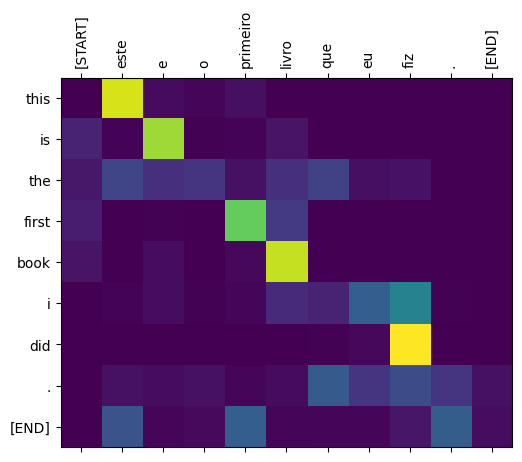

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

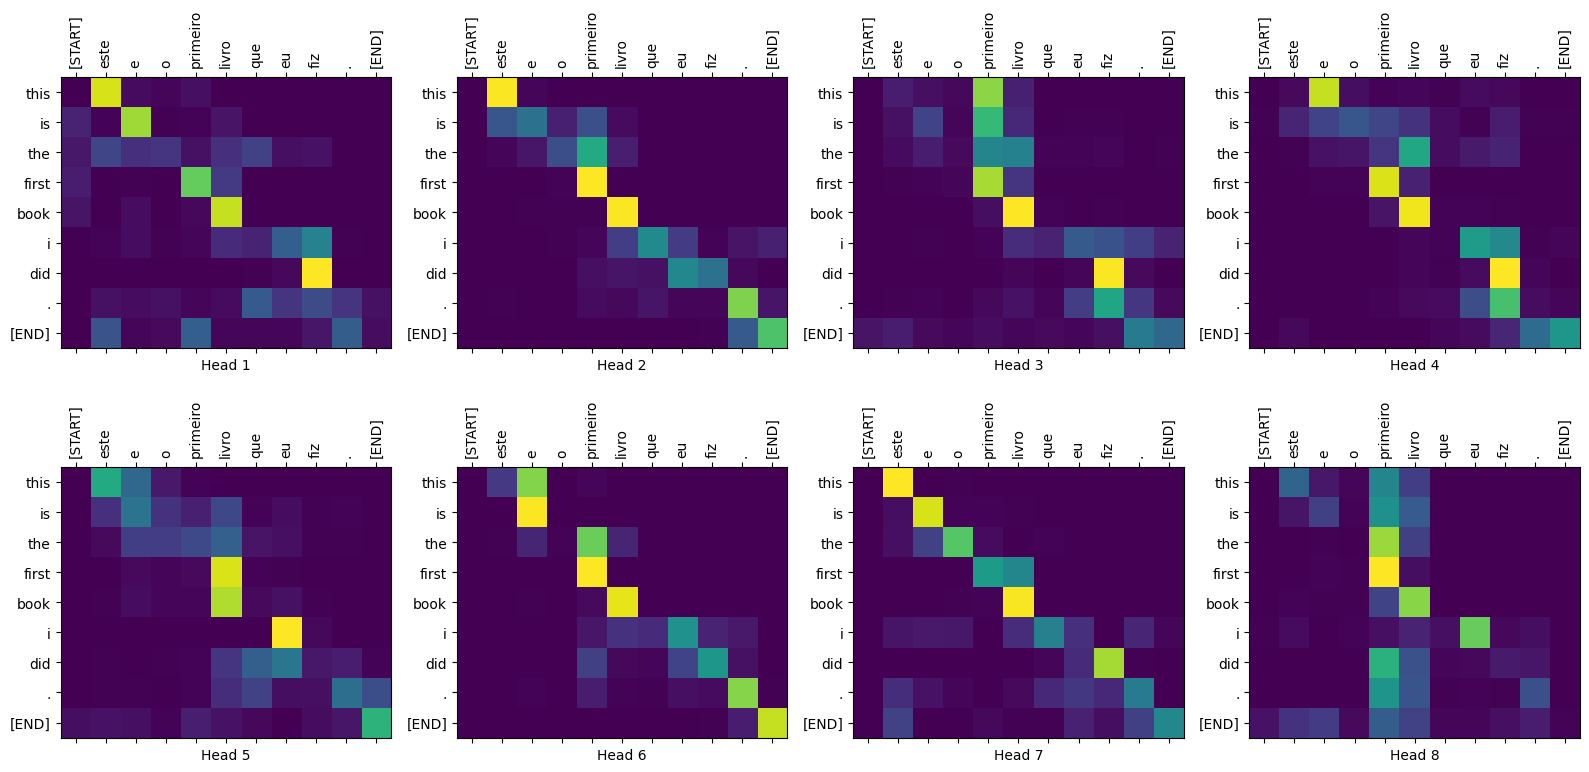

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triumpers in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


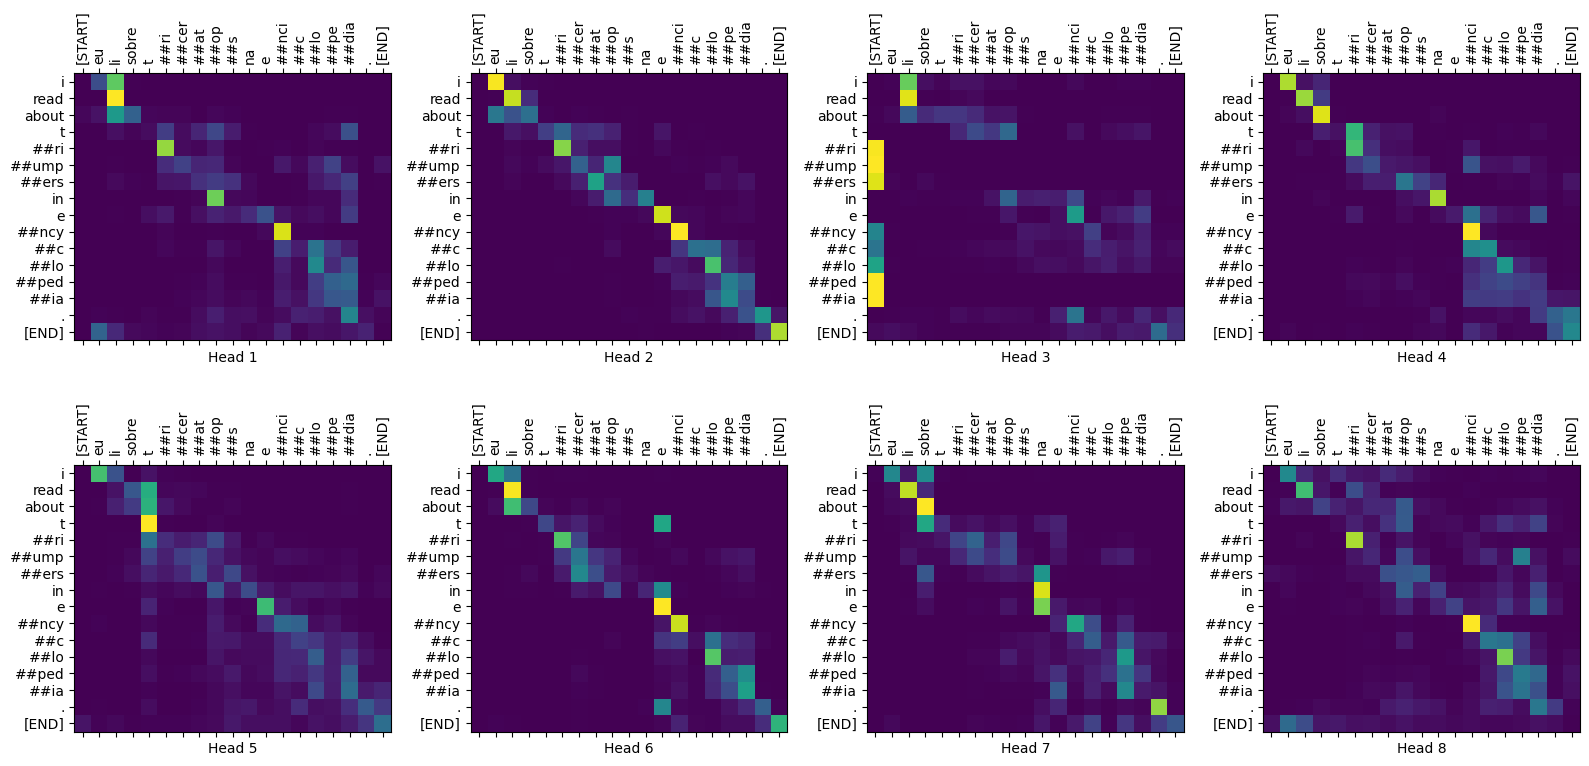

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
